In [1]:
#using Pkg
#Pkg.add(PackageSpec(name="JWAS",rev="master"))
#Pkg.add("RecipesBase")
#using RecipesBase

In [2]:
#methods(add_genotypes)

In [2]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

In [3]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Complete_EXP_Health_WFI.dat", types=Dict(:ID => String, :SlaughterDate => String), delim = ' ',header=true, missingstrings=["NA"] )
phenotypes= dropmissing(phenotypes, :FinPenBatch)
phenotypes= dropmissing(phenotypes, :SlaughterDate)
phenotypes= dropmissing(phenotypes, :PreSlaughterWt)
first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,Bool,String,String?
1,0001,1,1,1B,A,1B_1715,false,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,false,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,false,1B_D04,1B_D04
5,0007,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
6,0009,1,1,1B,A,1B_1902,false,1B_D02,1B_D02
7,0010,1,1,1B,A,1B_1885,false,1B_D02,1B_D02
8,0011,1,1,1B,A,1B_2097,false,1B_D02,1B_D02
9,0012,1,1,1B,A,1B_1902,false,1B_D02,1B_D02


In [4]:
DBF_model_equations = "DBF = intercept + Batch + SlaughterDate + SlaughterAge + PreSlaughterWt + FinPenBatch + SowID"
DBF_R=4.04901
DBF_model=build_model(DBF_model_equations,DBF_R);
set_covariate(DBF_model,"SlaughterAge")
set_covariate(DBF_model,"PreSlaughterWt")
DBF_G1=0.136835
set_random(DBF_model,"FinPenBatch",DBF_G1)
DBF_G2=0.459072
set_random(DBF_model,"SowID",DBF_G2)

In [5]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 18.179698 seconds (19.27 k allocations: 10.392 GiB, 0.14% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [6]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))
DBF_G3=5.22779
@time add_genotypes(DBF_model,M,DBF_G3,header=false, rowID=rowID)
#@time add_genotypes(Nur2ADG_model,"Geno_JWAS_impute.txt",Nur2ADG_G3,separator=' ')

The marker IDs are set to 1,2,...,#markers
#markers: 435172; #individuals: 3205
 14.911421 seconds (8.08 M allocations: 15.987 GiB, 1.41% gc time)


4.0f0

In [7]:
@time DBF_outB=runMCMC(DBF_model,phenotypes,methods="BayesB", missing_phenotypes=true, Pi=0.999, estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

The folder results is created to save results.
Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.
Phenotypes for all traits included in the model for individual 0004 in the row 3 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0024 in the row 21 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0056 in the row 52 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0057 in the row 53 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0103 in the row 87 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0106 in the row 90 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0119 in the row 99 are missing. This record is deleted.
Phenotypes for a

running MCMC ...100%|███████████████████████████████████| Time: 5:07:13




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


18469.299550 seconds (90.30 G allocations: 1.803 TiB, 1.51% gc time)


Dict{Any,Any} with 7 entries:
  "ScaleEffectVargeno"  => 1×3 DataFrame…
  "heritability"        => 1×3 DataFrame…
  "EBV_DBF"             => 3205×3 DataFrame…
  "location parameters" => 1220×5 DataFrame…
  "residual variance"   => 1×3 DataFrame…
  "marker effects geno" => 435172×5 DataFrame…
  "genetic_variance"    => 1×3 DataFrame…

In [8]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,DBF
,Int64,Float64
1,1,0.38781
2,2,0.369455
3,3,0.39056
4,4,0.405086
5,5,0.372974
6,6,0.390428
7,7,0.441777
8,8,0.381119
9,9,0.361667


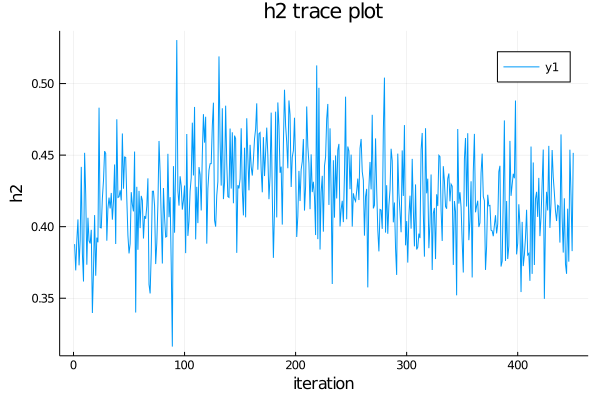

In [9]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [12]:
@time DBF_outB,DBF_winVarProps = GWAS("results/MCMC_samples_marker_effects_geno_DBF.txt","/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
  M;header=true,window_size="0.25 Mb",threshold=0.001)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:41:52


BoundsError: BoundsError: attempt to access (9375×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t     │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64   │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1    │ 1     │ 1103   │ 2      │ 1250000   │ 1500000   │ 1256452   │ 1481038   │ 10     │ 0.415326       │ 0.11546     │ 9.52     │ 1.0        │ 1.0       │
│ 2    │ 1     │ 8711   │ 17     │ 32250000  │ 32500000  │ 32250013  │ 32497670  │ 67     │ 0.0820365      │ 0.0634324   │ 1.89     │ 0.84       │ 0.92      │
│ 3    │ 1     │ 3100   │ 5      │ 85000000  │ 85250000  │ 85001640  │ 85247378  │ 52     │ 0.0882776      │ 0.0686181   │ 2.02     │ 0.817778   │ 0.885926  │
│ 4    │ 1     │ 3523   │ 6      │ 86500000  │ 86750000  │ 86511457  │ 86747331  │ 54     │ 0.0762327      │ 0.063313    │ 1.75     │ 0.76       │ 0.854444  │
│ 5    │ 1     │ 4250   │ 7      │ 97500000  │ 97750000  │ 97511738  │ 97744708  │ 39     │ 0.0460498      │ 0.0502333   │ 1.05     │ 0.646667   │ 0.812889  │
│ 6    │ 1     │ 1257   │ 2      │ 40000000  │ 40250000  │ 40001880  │ 40249873  │ 72     │ 0.040413       │ 0.0485855   │ 0.93     │ 0.557778   │ 0.77037   │
│ 7    │ 1     │ 5103   │ 9      │ 49750000  │ 50000000  │ 49751613  │ 49997149  │ 41     │ 0.0280476      │ 0.0433052   │ 0.64     │ 0.424444   │ 0.720952  │
│ 8    │ 1     │ 1114   │ 2      │ 4250000   │ 4500000   │ 4263924   │ 4499434   │ 66     │ 0.0245841      │ 0.0403296   │ 0.56     │ 0.42       │ 0.683333  │
│ 9    │ 1     │ 1769   │ 3      │ 16250000  │ 16500000  │ 16254189  │ 16497764  │ 61     │ 0.0185627      │ 0.0335674   │ 0.42     │ 0.391111   │ 0.650864  │
│ 10   │ 1     │ 5087   │ 9      │ 45750000  │ 46000000  │ 45788235  │ 45991310  │ 39     │ 0.0161016      │ 0.0275638   │ 0.36     │ 0.388889   │ 0.624667  │
│ 11   │ 1     │ 8854   │ 18     │ 4750000   │ 5000000   │ 4753607   │ 4995194   │ 62     │ 0.0185876      │ 0.0311629   │ 0.42     │ 0.364444   │ 0.60101   │
│ 12   │ 1     │ 6159   │ 12     │ 26000000  │ 26250000  │ 26003111  │ 26243152  │ 58     │ 0.025239       │ 0.0458297   │ 0.57     │ 0.342222   │ 0.579444  │
│ 13   │ 1     │ 3764   │ 6      │ 147000000 │ 147250000 │ 147000268 │ 147248914 │ 60     │ 0.0178872      │ 0.0343219   │ 0.4      │ 0.313333   │ 0.558974  │
│ 14   │ 1     │ 8342   │ 16     │ 20000000  │ 20250000  │ 20000699  │ 20246948  │ 75     │ 0.0186227      │ 0.0386659   │ 0.43     │ 0.306667   │ 0.540952  │
│ 15   │ 1     │ 2222   │ 3      │ 129500000 │ 129750000 │ 129502968 │ 129748906 │ 80     │ 0.0113139      │ 0.0227465   │ 0.26     │ 0.3        │ 0.524889  │
│ 16   │ 1     │ 3836   │ 6      │ 165000000 │ 165250000 │ 165000002 │ 165249700 │ 65     │ 0.0153284      │ 0.0311193   │ 0.35     │ 0.3        │ 0.510833  │
│ 17   │ 1     │ 5250   │ 9      │ 86750000  │ 87000000  │ 86750570  │ 86994798  │ 58     │ 0.0160347      │ 0.0339461   │ 0.37     │ 0.295556   │ 0.49817   │
│ 18   │ 1     │ 2783   │ 5      │ 5750000   │ 6000000   │ 5750829   │ 5995664   │ 58     │ 0.0128768      │ 0.0269477   │ 0.3      │ 0.284444   │ 0.486296  │
│ 19   │ 1     │ 3116   │ 5      │ 89000000  │ 89250000  │ 89004418  │ 89248034  │ 54     │ 0.0139367      │ 0.0282538   │ 0.32     │ 0.284444   │ 0.475673  │
│ 20   │ 1     │ 6217   │ 12     │ 40500000  │ 40750000  │ 40509146  │ 40743230  │ 67     │ 0.0160271      │ 0.0319764   │ 0.37     │ 0.284444   │ 0.466111  │
│ 21   │ 1     │ 6209   │ 12     │ 38500000  │ 38750000  │ 38504224  │ 38742446  │ 64     │ 0.0143021      │ 0.0298386   │ 0.32     │ 0.268889   │ 0.45672   │
│ 22   │ 1     │ 644    │ 1      │ 161000000 │ 161250000 │ 161005018 │ 161247684 │ 52     │ 0.00933791     │ 0.0234396   │ 0.21     │ 0.24       │ 0.446869  │
│ 23   │ 1     │ 3864   │ 7      │ 1000000   │ 1250000   │ 1006444   │ 1244664   │ 38     │ 0.00928605     │ 0.0213992   │ 0.21     │ 0.237778   │ 0.437778  │
│ 24   │ 1     │ 5326   │ 9      │ 105750000 │ 106000000 │ 105753423 │ 105990390 │ 63     │ 0.00972856     │ 0.0239129   │ 0.22     │ 0.233333   │ 0.429259  │
│ 25   │ 1     │ 5521   │ 10     │ 15000000  │ 15250000  │ 15000580  │ 15247774  │ 53     │ 0.0118891      │ 0.0299842   │ 0.27     │ 0.231111   │ 0.421333  │
│ 26   │ 1     │ 4012   │ 7      │ 38000000  │ 38250000  │ 38001363  │ 38248090  │ 69     │ 0.00799139     │ 0.0207644   │ 0.18     │ 0.224444   │ 0.413761  │
│ 27   │ 1     │ 2045   │ 3      │ 85250000  │ 85500000  │ 85251249  │ 85498518  │ 52     │ 0.011479       │ 0.0278227   │ 0.27     │ 0.222222   │ 0.406667  │
│ 28   │ 1     │ 1940   │ 3      │ 59000000  │ 59250000  │ 59001725  │ 59248580  │ 76     │ 0.00704861     │ 0.0187346   │ 0.16     │ 0.213333   │ 0.399762  │
│ 29   │ 1     │ 3837   │ 6      │ 165250000 │ 165500000 │ 165256903 │ 165497688 │ 53     │ 0.00856665     │ 0.0216143   │ 0.2      │ 0.213333   │ 0.393333  │
│ 30   │ 1     │ 5517   │ 10     │ 14000000  │ 14250000  │ 14026569  │ 14242539  │ 49     │ 0.00831518     │ 0.0206206   │ 0.19     │ 0.213333   │ 0.387333  │
│ 31   │ 1     │ 8500   │ 16     │ 59500000  │ 59750000  │ 59516523  │ 59747430  │ 54     │ 0.0093181      │ 0.0249643   │ 0.21     │ 0.208889   │ 0.381577  │
│ 32   │ 1     │ 3839   │ 6      │ 165750000 │ 166000000 │ 165752774 │ 165997868 │ 46     │ 0.00905874     │ 0.0235265   │ 0.21     │ 0.206667   │ 0.376111  │
│ 33   │ 1     │ 1262   │ 2      │ 41250000  │ 41500000  │ 41250750  │ 41497477  │ 69     │ 0.0104084      │ 0.027245    │ 0.24     │ 0.202222   │ 0.370842  │
│ 34   │ 1     │ 8502   │ 16     │ 60000000  │ 60250000  │ 60001022  │ 60249553  │ 60     │ 0.0091258      │ 0.0229668   │ 0.21     │ 0.202222   │ 0.365882  │
│ 35   │ 1     │ 1593   │ 2      │ 124250000 │ 124500000 │ 124284301 │ 124497998 │ 51     │ 0.00786412     │ 0.0223483   │ 0.18     │ 0.197778   │ 0.361079  │
│ 36   │ 1     │ 5623   │ 10     │ 40500000  │ 40750000  │ 40506035  │ 40744949  │ 56     │ 0.0101119      │ 0.0253504   │ 0.23     │ 0.195556   │ 0.356481  │
│ 37   │ 1     │ 4846   │ 8      │ 124500000 │ 124750000 │ 124500243 │ 124749885 │ 66     │ 0.00817581     │ 0.0229306   │ 0.18     │ 0.191111   │ 0.352012  │
│ 38   │ 1     │ 2042   │ 3      │ 84500000  │ 84750000  │ 84501119  │ 84736454  │ 48     │ 0.00627076     │ 0.0169601   │ 0.14     │ 0.186667   │ 0.347661  │
│ 39   │ 1     │ 1130   │ 2      │ 8250000   │ 8500000   │ 8252416   │ 8494981   │ 34     │ 0.00641974     │ 0.0186027   │ 0.15     │ 0.18       │ 0.343362  │
│ 40   │ 1     │ 7655   │ 14     │ 130250000 │ 130500000 │ 130250507 │ 130498899 │ 68     │ 0.00571265     │ 0.015586    │ 0.13     │ 0.18       │ 0.339278  │
│ 41   │ 1     │ 7686   │ 14     │ 138000000 │ 138250000 │ 138002903 │ 138247025 │ 48     │ 0.00915929     │ 0.0243059   │ 0.21     │ 0.18       │ 0.335393  │
│ 42   │ 1     │ 1978   │ 3      │ 68500000  │ 68750000  │ 68504086  │ 68748799  │ 58     │ 0.00611945     │ 0.016407    │ 0.14     │ 0.177778   │ 0.33164   │
│ 43   │ 1     │ 8724   │ 17     │ 35500000  │ 35750000  │ 35507474  │ 35749899  │ 72     │ 0.00536002     │ 0.0145387   │ 0.12     │ 0.175556   │ 0.32801   │
│ 44   │ 1     │ 1225   │ 2      │ 32000000  │ 32250000  │ 32013622  │ 32247564  │ 26     │ 0.0112984      │ 0.0312054   │ 0.26     │ 0.173333   │ 0.324495  │
│ 45   │ 1     │ 7177   │ 14     │ 10750000  │ 11000000  │ 10753275  │ 10984477  │ 47     │ 0.00613825     │ 0.0172557   │ 0.14     │ 0.173333   │ 0.321136  │
│ 46   │ 1     │ 5106   │ 9      │ 50500000  │ 50750000  │ 50501087  │ 50744841  │ 51     │ 0.00509644     │ 0.0154409   │ 0.11     │ 0.166667   │ 0.317778  │
│ 47   │ 1     │ 3943   │ 7      │ 20750000  │ 21000000  │ 20797858  │ 20995550  │ 51     │ 0.00633761     │ 0.0187042   │ 0.15     │ 0.164444   │ 0.314515  │
│ 48   │ 1     │ 3872   │ 7      │ 3000000   │ 3250000   │ 3001119   │ 3249660   │ 41     │ 0.00688911     │ 0.0200644   │ 0.16     │ 0.162222   │ 0.311343  │
│ 49   │ 1     │ 3765   │ 6      │ 147250000 │ 147500000 │ 147252270 │ 147498631 │ 57     │ 0.00761206     │ 0.0234044   │ 0.17     │ 0.16       │ 0.308254  │
│ 50   │ 1     │ 8623   │ 17     │ 10250000  │ 10500000  │ 10250619  │ 10498558  │ 81     │ 0.00520823     │ 0.0165426   │ 0.12     │ 0.157778   │ 0.305244  │
│ 51   │ 1     │ 8761   │ 17     │ 44750000  │ 45000000  │ 44751346  │ 44997333  │ 69     │ 0.00546843     │ 0.0160899   │ 0.13     │ 0.155556   │ 0.302309  │
│ 52   │ 1     │ 8211   │ 15     │ 127750000 │ 128000000 │ 127751415 │ 127995861 │ 62     │ 0.00688055     │ 0.0202073   │ 0.16     │ 0.153333   │ 0.299444  │
│ 53   │ 1     │ 1113   │ 2      │ 4000000   │ 4250000   │ 4012479   │ 4249741   │ 49     │ 0.00774533     │ 0.0230603   │ 0.17     │ 0.151111   │ 0.296646  │
│ 54   │ 1     │ 4251   │ 7      │ 97750000  │ 98000000  │ 97752476  │ 97988976  │ 47     │ 0.00903401     │ 0.0275439   │ 0.21     │ 0.151111   │ 0.293951  │
│ 55   │ 1     │ 8622   │ 17     │ 10000000  │ 10250000  │ 10004193  │ 10247857  │ 62     │ 0.00477311     │ 0.0141149   │ 0.11     │ 0.151111   │ 0.291354  │
│ 56   │ 1     │ 1263   │ 2      │ 41500000  │ 41750000  │ 41501296  │ 41747257  │ 62     │ 0.00684755     │ 0.0227247   │ 0.16     │ 0.148889   │ 0.28881   │
│ 57   │ 1     │ 3303   │ 6      │ 31000000  │ 31250000  │ 31001556  │ 31247336  │ 67     │ 0.0054138      │ 0.0174706   │ 0.12     │ 0.148889   │ 0.286355  │
│ 58   │ 1     │ 1569   │ 2      │ 118250000 │ 118500000 │ 118251469 │ 118497478 │ 57     │ 0.00676949     │ 0.0207684   │ 0.15     │ 0.146667   │ 0.283946  │
│ 59   │ 1     │ 7906   │ 15     │ 51250000  │ 51500000  │ 51251038  │ 51496355  │ 60     │ 0.00492108     │ 0.0155962   │ 0.11     │ 0.146667   │ 0.28162   │
│ 60   │ 1     │ 3363   │ 6      │ 46000000  │ 46250000  │ 46001718  │ 46248115  │ 62     │ 0.00416971     │ 0.0137715   │ 0.1      │ 0.142222   │ 0.279296  │
│ 61   │ 1     │ 3763   │ 6      │ 146750000 │ 147000000 │ 146782297 │ 146997249 │ 50     │ 0.00539914     │ 0.0165468   │ 0.12     │ 0.142222   │ 0.277049  │
│ 62   │ 1     │ 3024   │ 5      │ 66000000  │ 66250000  │ 66000830  │ 66244036  │ 48     │ 0.00650006     │ 0.0188224   │ 0.15     │ 0.14       │ 0.274839  │
│ 63   │ 1     │ 7657   │ 14     │ 130750000 │ 131000000 │ 130765062 │ 130998592 │ 55     │ 0.00540883     │ 0.018031    │ 0.12     │ 0.137778   │ 0.272663  │
│ 64   │ 1     │ 2190   │ 3      │ 121500000 │ 121750000 │ 121501725 │ 121747820 │ 61     │ 0.00609427     │ 0.0193854   │ 0.14     │ 0.135556   │ 0.270521  │
│ 65   │ 1     │ 4208   │ 7      │ 87000000  │ 87250000  │ 87003720  │ 87246599  │ 73     │ 0.00429503     │ 0.014363    │ 0.1      │ 0.135556   │ 0.268444  │
│ 66   │ 1     │ 5518   │ 10     │ 14250000  │ 14500000  │ 14250506  │ 14498330  │ 37     │ 0.00474893     │ 0.0143796   │ 0.11     │ 0.133333   │ 0.266397  │
│ 67   │ 1     │ 6107   │ 12     │ 13000000  │ 13250000  │ 13008602  │ 13244104  │ 76     │ 0.00561624     │ 0.0178395   │ 0.13     │ 0.133333   │ 0.264411  │
│ 68   │ 1     │ 10     │ 1      │ 2250000   │ 2500000   │ 2251625   │ 2499085   │ 72     │ 0.00378914     │ 0.0126795   │ 0.09     │ 0.131111   │ 0.262451  │
│ 69   │ 1     │ 210    │ 1      │ 52250000  │ 52500000  │ 52251037  │ 52499848  │ 67     │ 0.00461992     │ 0.0163302   │ 0.11     │ 0.128889   │ 0.260515  │
│ 70   │ 1     │ 211    │ 1      │ 52500000  │ 52750000  │ 52502195  │ 52747227  │ 71     │ 0.00427829     │ 0.0149563   │ 0.1      │ 0.128889   │ 0.258635  │
│ 71   │ 1     │ 647    │ 1      │ 161750000 │ 162000000 │ 161753812 │ 161999307 │ 50     │ 0.00623547     │ 0.0214994   │ 0.14     │ 0.128889   │ 0.256808  │
│ 72   │ 1     │ 2737   │ 4      │ 125250000 │ 125500000 │ 125251952 │ 125497843 │ 78     │ 0.00339153     │ 0.0115502   │ 0.08     │ 0.128889   │ 0.255031  │
│ 73   │ 1     │ 3887   │ 7      │ 6750000   │ 7000000   │ 6751979   │ 6988259   │ 70     │ 0.00522584     │ 0.0174204   │ 0.12     │ 0.128889   │ 0.253303  │
│ 74   │ 1     │ 213    │ 1      │ 53000000  │ 53250000  │ 53000537  │ 53248919  │ 67     │ 0.00483443     │ 0.0166459   │ 0.11     │ 0.126667   │ 0.251592  │
│ 75   │ 1     │ 325    │ 1      │ 81000000  │ 81250000  │ 81001561  │ 81246308  │ 54     │ 0.00428515     │ 0.0150063   │ 0.1      │ 0.126667   │ 0.249926  │
│ 76   │ 1     │ 2044   │ 3      │ 85000000  │ 85250000  │ 85003412  │ 85246599  │ 60     │ 0.00437719     │ 0.0147949   │ 0.1      │ 0.126667   │ 0.248304  │
│ 77   │ 1     │ 2046   │ 3      │ 85500000  │ 85750000  │ 85504087  │ 85749306  │ 38     │ 0.00553841     │ 0.0182172   │ 0.13     │ 0.126667   │ 0.246724  │
│ 78   │ 1     │ 3880   │ 7      │ 5000000   │ 5250000   │ 5000936   │ 5242217   │ 71     │ 0.00409326     │ 0.0136948   │ 0.09     │ 0.126667   │ 0.245185  │
│ 79   │ 1     │ 1567   │ 2      │ 117750000 │ 118000000 │ 117750667 │ 117998711 │ 66     │ 0.00295165     │ 0.0102137   │ 0.07     │ 0.124444   │ 0.243657  │
│ 80   │ 1     │ 8727   │ 17     │ 36250000  │ 36500000  │ 36252621  │ 36498120  │ 67     │ 0.00528159     │ 0.0177782   │ 0.12     │ 0.124444   │ 0.242167  │
│ 81   │ 1     │ 2156   │ 3      │ 113000000 │ 113250000 │ 113000985 │ 113249170 │ 62     │ 0.00303627     │ 0.00986036  │ 0.07     │ 0.122222   │ 0.240686  │
│ 82   │ 1     │ 5466   │ 10     │ 1250000   │ 1500000   │ 1251882   │ 1498720   │ 81     │ 0.00356323     │ 0.0122381   │ 0.08     │ 0.122222   │ 0.239241  │
│ 83   │ 1     │ 5526   │ 10     │ 16250000  │ 16500000  │ 16278197  │ 16497027  │ 57     │ 0.00301337     │ 0.0105322   │ 0.07     │ 0.122222   │ 0.237831  │
│ 84   │ 1     │ 8927   │ 18     │ 23000000  │ 23250000  │ 23000967  │ 23245873  │ 53     │ 0.00381433     │ 0.0121893   │ 0.09     │ 0.122222   │ 0.236455  │
│ 85   │ 1     │ 3117   │ 5      │ 89250000  │ 89500000  │ 89251430  │ 89499001  │ 50     │ 0.0050821      │ 0.0180384   │ 0.11     │ 0.12       │ 0.235085  │
│ 86   │ 1     │ 3941   │ 7      │ 20250000  │ 20500000  │ 20252636  │ 20498625  │ 69     │ 0.00293698     │ 0.0106598   │ 0.07     │ 0.12       │ 0.233747  │
│ 87   │ 1     │ 2281   │ 4      │ 11250000  │ 11500000  │ 11251406  │ 11498072  │ 76     │ 0.00276788     │ 0.0100062   │ 0.06     │ 0.117778   │ 0.232414  │
│ 88   │ 1     │ 3766   │ 6      │ 147500000 │ 147750000 │ 147502252 │ 147746040 │ 29     │ 0.00574927     │ 0.0202523   │ 0.13     │ 0.117778   │ 0.231111  │
│ 89   │ 1     │ 3940   │ 7      │ 20000000  │ 20250000  │ 20001975  │ 20249027  │ 78     │ 0.00308498     │ 0.0112129   │ 0.07     │ 0.115556   │ 0.229813  │
│ 90   │ 1     │ 4503   │ 8      │ 38750000  │ 39000000  │ 38750202  │ 38997849  │ 54     │ 0.00448572     │ 0.0168001   │ 0.1      │ 0.115556   │ 0.228543  │
│ 91   │ 1     │ 8624   │ 17     │ 10500000  │ 10750000  │ 10503838  │ 10746347  │ 58     │ 0.00510155     │ 0.0202471   │ 0.12     │ 0.115556   │ 0.227302  │
│ 92   │ 1     │ 1833   │ 3      │ 32250000  │ 32500000  │ 32250576  │ 32497290  │ 74     │ 0.00290967     │ 0.0116282   │ 0.07     │ 0.113333   │ 0.226063  │
│ 93   │ 1     │ 3838   │ 6      │ 165500000 │ 165750000 │ 165502178 │ 165749990 │ 34     │ 0.00391174     │ 0.0142499   │ 0.09     │ 0.113333   │ 0.224851  │
│ 94   │ 1     │ 6001   │ 11     │ 65750000  │ 66000000  │ 65752038  │ 65992889  │ 72     │ 0.00266113     │ 0.00925349  │ 0.06     │ 0.113333   │ 0.223664  │
│ 95   │ 1     │ 1261   │ 2      │ 41000000  │ 41250000  │ 41003027  │ 41249391  │ 57     │ 0.00507375     │ 0.0182955   │ 0.11     │ 0.111111   │ 0.22248   │
│ 96   │ 1     │ 2778   │ 5      │ 4500000   │ 4750000   │ 4502447   │ 4742278   │ 47     │ 0.0032343      │ 0.0110116   │ 0.08     │ 0.111111   │ 0.221319  │
│ 97   │ 1     │ 3133   │ 5      │ 93250000  │ 93500000  │ 93250602  │ 93499756  │ 43     │ 0.003027       │ 0.0111318   │ 0.07     │ 0.111111   │ 0.220183  │
│ 98   │ 1     │ 3912   │ 7      │ 13000000  │ 13250000  │ 13002660  │ 13233996  │ 44     │ 0.00350346     │ 0.0125043   │ 0.08     │ 0.111111   │ 0.21907   │
│ 99   │ 1     │ 4843   │ 8      │ 123750000 │ 124000000 │ 123770281 │ 123999102 │ 55     │ 0.00371783     │ 0.0142329   │ 0.09     │ 0.111111   │ 0.21798   │
│ 100  │ 1     │ 5118   │ 9      │ 53500000  │ 53750000  │ 53500816  │ 53729240  │ 43     │ 0.0036444      │ 0.0125806   │ 0.08     │ 0.111111   │ 0.216911  │
│ 101  │ 1     │ 8523   │ 16     │ 65250000  │ 65500000  │ 65257320  │ 65495813  │ 65     │ 0.00466179     │ 0.0175517   │ 0.11     │ 0.111111   │ 0.215864  │
│ 102  │ 1     │ 1770   │ 3      │ 16500000  │ 16750000  │ 16501180  │ 16740560  │ 38     │ 0.00475995     │ 0.0176475   │ 0.11     │ 0.108889   │ 0.214815  │
│ 103  │ 1     │ 4209   │ 7      │ 87250000  │ 87500000  │ 87251891  │ 87498269  │ 66     │ 0.00388686     │ 0.016938    │ 0.09     │ 0.108889   │ 0.213786  │
│ 104  │ 1     │ 5327   │ 9      │ 106000000 │ 106250000 │ 106003716 │ 106244970 │ 62     │ 0.00273937     │ 0.0102638   │ 0.06     │ 0.108889   │ 0.212778  │
│ 105  │ 1     │ 8729   │ 17     │ 36750000  │ 37000000  │ 36751194  │ 36997342  │ 71     │ 0.00481255     │ 0.0201456   │ 0.11     │ 0.108889   │ 0.211788  │
│ 106  │ 1     │ 225    │ 1      │ 56000000  │ 56250000  │ 56003300  │ 56249634  │ 74     │ 0.00230963     │ 0.0082351   │ 0.05     │ 0.106667   │ 0.210797  │
│ 107  │ 1     │ 266    │ 1      │ 66250000  │ 66500000  │ 66253449  │ 66499506  │ 48     │ 0.00369153     │ 0.0155663   │ 0.09     │ 0.106667   │ 0.209823  │
│ 108  │ 1     │ 1689   │ 2      │ 148250000 │ 148500000 │ 148250609 │ 148499924 │ 67     │ 0.0030408      │ 0.0108282   │ 0.07     │ 0.106667   │ 0.208868  │
│ 109  │ 1     │ 3762   │ 6      │ 146500000 │ 146750000 │ 146508971 │ 146737682 │ 39     │ 0.00353064     │ 0.0148895   │ 0.08     │ 0.106667   │ 0.207931  │
│ 110  │ 1     │ 8877   │ 18     │ 10500000  │ 10750000  │ 10503298  │ 10746469  │ 38     │ 0.00404535     │ 0.0153323   │ 0.09     │ 0.106667   │ 0.20701   │
│ 111  │ 1     │ 3622   │ 6      │ 111250000 │ 111500000 │ 111252861 │ 111493922 │ 61     │ 0.0033944      │ 0.0138822   │ 0.08     │ 0.104444   │ 0.206086  │
│ 112  │ 1     │ 5677   │ 10     │ 54000000  │ 54250000  │ 54003286  │ 54248892  │ 75     │ 0.00271217     │ 0.0103332   │ 0.06     │ 0.104444   │ 0.205179  │
│ 113  │ 1     │ 7325   │ 14     │ 47750000  │ 48000000  │ 47750613  │ 47999414  │ 75     │ 0.00300851     │ 0.0106676   │ 0.07     │ 0.104444   │ 0.204287  │
│ 114  │ 1     │ 646    │ 1      │ 161500000 │ 161750000 │ 161500456 │ 161747004 │ 66     │ 0.00233019     │ 0.00947286  │ 0.06     │ 0.102222   │ 0.203392  │
│ 115  │ 1     │ 1090   │ 1      │ 272500000 │ 272750000 │ 272501080 │ 272746057 │ 59     │ 0.00309203     │ 0.0127802   │ 0.07     │ 0.102222   │ 0.202512  │
│ 116  │ 1     │ 1830   │ 3      │ 31500000  │ 31750000  │ 31500612  │ 31744765  │ 80     │ 0.00288288     │ 0.010567    │ 0.07     │ 0.102222   │ 0.201648  │
│ 117  │ 1     │ 5527   │ 10     │ 16500000  │ 16750000  │ 16500082  │ 16748027  │ 64     │ 0.00279795     │ 0.0117474   │ 0.06     │ 0.102222   │ 0.200798  │
│ 118  │ 1     │ 8545   │ 16     │ 70750000  │ 71000000  │ 70750882  │ 70999408  │ 58     │ 0.0032272      │ 0.0128374   │ 0.07     │ 0.102222   │ 0.199962  │
│ 119  │ 1     │ 8616   │ 17     │ 8500000   │ 8750000   │ 8502436   │ 8704915   │ 34     │ 0.00318582     │ 0.0121328   │ 0.07     │ 0.102222   │ 0.199141  │
│ 120  │ 1     │ 1652   │ 2      │ 139000000 │ 139250000 │ 139000185 │ 139249885 │ 85     │ 0.00181417     │ 0.00735979  │ 0.04     │ 0.1        │ 0.198315  │
│ 121  │ 1     │ 3190   │ 6      │ 2750000   │ 3000000   │ 2750136   │ 2999538   │ 83     │ 0.00285099     │ 0.0108108   │ 0.07     │ 0.1        │ 0.197502  │
│ 122  │ 1     │ 7310   │ 14     │ 44000000  │ 44250000  │ 44001184  │ 44248550  │ 68     │ 0.00345059     │ 0.0158461   │ 0.08     │ 0.1        │ 0.196703  │
│ 123  │ 1     │ 20     │ 1      │ 4750000   │ 5000000   │ 4751837   │ 4992802   │ 71     │ 0.00258999     │ 0.0105904   │ 0.06     │ 0.0977778  │ 0.195899  │
│ 124  │ 1     │ 643    │ 1      │ 160750000 │ 161000000 │ 160751707 │ 160987711 │ 28     │ 0.00530093     │ 0.0200728   │ 0.12     │ 0.0977778  │ 0.195108  │
│ 125  │ 1     │ 3525   │ 6      │ 87000000  │ 87250000  │ 87000831  │ 87249104  │ 51     │ 0.00525288     │ 0.0206666   │ 0.12     │ 0.0977778  │ 0.194329  │
│ 126  │ 1     │ 5586   │ 10     │ 31250000  │ 31500000  │ 31250420  │ 31496779  │ 71     │ 0.00253891     │ 0.0105486   │ 0.06     │ 0.0977778  │ 0.193563  │
│ 127  │ 1     │ 5928   │ 11     │ 47500000  │ 47750000  │ 47501284  │ 47749336  │ 69     │ 0.00304122     │ 0.0111407   │ 0.07     │ 0.0977778  │ 0.192808  │
│ 128  │ 1     │ 8524   │ 16     │ 65500000  │ 65750000  │ 65500900  │ 65747469  │ 53     │ 0.00266173     │ 0.010171    │ 0.06     │ 0.0977778  │ 0.192066  │
│ 129  │ 1     │ 226    │ 1      │ 56250000  │ 56500000  │ 56253865  │ 56495788  │ 71     │ 0.00333969     │ 0.0134802   │ 0.08     │ 0.0955556  │ 0.191318  │
│ 130  │ 1     │ 2332   │ 4      │ 24000000  │ 24250000  │ 24003588  │ 24238734  │ 56     │ 0.00191402     │ 0.00696143  │ 0.04     │ 0.0955556  │ 0.190581  │
│ 131  │ 1     │ 2734   │ 4      │ 124500000 │ 124750000 │ 124502806 │ 124746318 │ 75     │ 0.00210009     │ 0.00911619  │ 0.05     │ 0.0955556  │ 0.189856  │
│ 132  │ 1     │ 2736   │ 4      │ 125000000 │ 125250000 │ 125001553 │ 125244314 │ 70     │ 0.00210454     │ 0.00745657  │ 0.05     │ 0.0955556  │ 0.189141  │
│ 133  │ 1     │ 3528   │ 6      │ 87750000  │ 88000000  │ 87750496  │ 87998848  │ 59     │ 0.00297371     │ 0.0118367   │ 0.07     │ 0.0955556  │ 0.188438  │
│ 134  │ 1     │ 4693   │ 8      │ 86250000  │ 86500000  │ 86251027  │ 86498022  │ 65     │ 0.00220124     │ 0.00890169  │ 0.05     │ 0.0955556  │ 0.187745  │
│ 135  │ 1     │ 5088   │ 9      │ 46000000  │ 46250000  │ 46021257  │ 46249215  │ 43     │ 0.00451256     │ 0.0174104   │ 0.1      │ 0.0955556  │ 0.187062  │
│ 136  │ 1     │ 5249   │ 9      │ 86500000  │ 86750000  │ 86506981  │ 86748470  │ 52     │ 0.00328039     │ 0.0132621   │ 0.08     │ 0.0955556  │ 0.186389  │
│ 137  │ 1     │ 5253   │ 9      │ 87500000  │ 87750000  │ 87504635  │ 87746559  │ 57     │ 0.00274409     │ 0.0116791   │ 0.06     │ 0.0955556  │ 0.185726  │
│ 138  │ 1     │ 6394   │ 13     │ 23000000  │ 23250000  │ 23008237  │ 23248661  │ 64     │ 0.0026678      │ 0.0108687   │ 0.06     │ 0.0955556  │ 0.185072  │
│ 139  │ 1     │ 7656   │ 14     │ 130500000 │ 130750000 │ 130500895 │ 130749289 │ 61     │ 0.00304958     │ 0.0112665   │ 0.07     │ 0.0955556  │ 0.184428  │
│ 140  │ 1     │ 7708   │ 15     │ 1750000   │ 2000000   │ 1750092   │ 1999028   │ 68     │ 0.00366981     │ 0.0143477   │ 0.08     │ 0.0955556  │ 0.183794  │
│ 141  │ 1     │ 8194   │ 15     │ 123500000 │ 123750000 │ 123503164 │ 123742609 │ 67     │ 0.00279266     │ 0.0117107   │ 0.06     │ 0.0955556  │ 0.183168  │
│ 142  │ 1     │ 214    │ 1      │ 53250000  │ 53500000  │ 53252886  │ 53498894  │ 57     │ 0.0039583      │ 0.0171207   │ 0.09     │ 0.0933333  │ 0.182535  │
│ 143  │ 1     │ 527    │ 1      │ 131750000 │ 132000000 │ 131767236 │ 131997760 │ 40     │ 0.00340076     │ 0.0158488   │ 0.08     │ 0.0933333  │ 0.181911  │
│ 144  │ 1     │ 645    │ 1      │ 161250000 │ 161500000 │ 161252022 │ 161497353 │ 55     │ 0.00360567     │ 0.0148881   │ 0.08     │ 0.0933333  │ 0.181296  │
│ 145  │ 1     │ 1688   │ 2      │ 148000000 │ 148250000 │ 148002378 │ 148247184 │ 61     │ 0.00269887     │ 0.00992472  │ 0.06     │ 0.0933333  │ 0.18069   │
│ 146  │ 1     │ 8734   │ 17     │ 38000000  │ 38250000  │ 38001554  │ 38248983  │ 48     │ 0.00381976     │ 0.0151296   │ 0.09     │ 0.0933333  │ 0.180091  │
│ 147  │ 1     │ 8739   │ 17     │ 39250000  │ 39500000  │ 39252171  │ 39499511  │ 68     │ 0.00248243     │ 0.00904154  │ 0.06     │ 0.0933333  │ 0.179501  │
│ 148  │ 1     │ 495    │ 1      │ 123750000 │ 124000000 │ 123750328 │ 123995795 │ 57     │ 0.0029842      │ 0.0122362   │ 0.07     │ 0.0911111  │ 0.178904  │
│ 149  │ 1     │ 1221   │ 2      │ 31000000  │ 31250000  │ 31014526  │ 31247445  │ 41     │ 0.00381452     │ 0.0156386   │ 0.09     │ 0.0911111  │ 0.178315  │
│ 150  │ 1     │ 1941   │ 3      │ 59250000  │ 59500000  │ 59252665  │ 59499098  │ 65     │ 0.00264087     │ 0.0096985   │ 0.06     │ 0.0911111  │ 0.177733  │
│ 151  │ 1     │ 5699   │ 10     │ 59500000  │ 59750000  │ 59500973  │ 59749071  │ 77     │ 0.00247264     │ 0.0102136   │ 0.06     │ 0.0911111  │ 0.17716   │
│ 152  │ 1     │ 5704   │ 10     │ 60750000  │ 61000000  │ 60750674  │ 60999298  │ 86     │ 0.00255008     │ 0.00961477  │ 0.06     │ 0.0911111  │ 0.176594  │
│ 153  │ 1     │ 6376   │ 13     │ 18500000  │ 18750000  │ 18504429  │ 18746893  │ 26     │ 0.0036705      │ 0.0141343   │ 0.08     │ 0.0911111  │ 0.176035  │
│ 154  │ 1     │ 8878   │ 18     │ 10750000  │ 11000000  │ 10752810  │ 10998919  │ 53     │ 0.00378107     │ 0.0157393   │ 0.09     │ 0.0911111  │ 0.175483  │
│ 155  │ 1     │ 8941   │ 18     │ 26500000  │ 26750000  │ 26509692  │ 26743944  │ 52     │ 0.0030818      │ 0.0124196   │ 0.07     │ 0.0911111  │ 0.174939  │
│ 156  │ 1     │ 4926   │ 9      │ 5500000   │ 5750000   │ 5502581   │ 5749159   │ 69     │ 0.00197995     │ 0.00743518  │ 0.04     │ 0.0888889  │ 0.174387  │
│ 157  │ 1     │ 5828   │ 11     │ 22250000  │ 22500000  │ 22255079  │ 22493060  │ 69     │ 0.00222703     │ 0.00943372  │ 0.05     │ 0.0888889  │ 0.173843  │
│ 158  │ 1     │ 6241   │ 12     │ 46500000  │ 46750000  │ 46502166  │ 46745165  │ 61     │ 0.00257333     │ 0.00991304  │ 0.06     │ 0.0888889  │ 0.173305  │
│ 159  │ 1     │ 7070   │ 13     │ 192500000 │ 192750000 │ 192501299 │ 192741684 │ 62     │ 0.00231724     │ 0.00903785  │ 0.05     │ 0.0888889  │ 0.172774  │
│ 160  │ 1     │ 7090   │ 13     │ 197500000 │ 197750000 │ 197502607 │ 197738250 │ 67     │ 0.00253997     │ 0.0114151   │ 0.06     │ 0.0888889  │ 0.17225   │
│ 161  │ 1     │ 8374   │ 16     │ 28000000  │ 28250000  │ 28004236  │ 28248897  │ 60     │ 0.00262249     │ 0.0117704   │ 0.06     │ 0.0888889  │ 0.171732  │
│ 162  │ 1     │ 23     │ 1      │ 5500000   │ 5750000   │ 5500246   │ 5748954   │ 53     │ 0.00182888     │ 0.00764804  │ 0.04     │ 0.0866667  │ 0.171207  │
│ 163  │ 1     │ 3946   │ 7      │ 21500000  │ 21750000  │ 21504835  │ 21749623  │ 56     │ 0.00325702     │ 0.0137598   │ 0.07     │ 0.0866667  │ 0.170688  │
│ 164  │ 1     │ 4185   │ 7      │ 81250000  │ 81500000  │ 81257559  │ 81497332  │ 54     │ 0.00249703     │ 0.0114605   │ 0.06     │ 0.0866667  │ 0.170176  │
│ 165  │ 1     │ 4190   │ 7      │ 82500000  │ 82750000  │ 82501326  │ 82746264  │ 42     │ 0.00281128     │ 0.0119445   │ 0.06     │ 0.0866667  │ 0.16967   │
│ 166  │ 1     │ 5089   │ 9      │ 46250000  │ 46500000  │ 46252837  │ 46497649  │ 40     │ 0.00354055     │ 0.0146138   │ 0.08     │ 0.0866667  │ 0.16917   │
│ 167  │ 1     │ 1007   │ 1      │ 251750000 │ 252000000 │ 251754048 │ 251996484 │ 65     │ 0.00202691     │ 0.00802301  │ 0.05     │ 0.0844444  │ 0.168663  │
│ 168  │ 1     │ 1594   │ 2      │ 124500000 │ 124750000 │ 124500103 │ 124737286 │ 51     │ 0.0030029      │ 0.0128501   │ 0.07     │ 0.0844444  │ 0.168161  │
│ 169  │ 1     │ 1939   │ 3      │ 58750000  │ 59000000  │ 58750776  │ 58995587  │ 68     │ 0.00295867     │ 0.0115105   │ 0.07     │ 0.0844444  │ 0.167666  │
│ 170  │ 1     │ 2740   │ 4      │ 126000000 │ 126250000 │ 126004065 │ 126243287 │ 56     │ 0.00204425     │ 0.00836288  │ 0.05     │ 0.0844444  │ 0.167176  │
│ 171  │ 1     │ 5785   │ 11     │ 11500000  │ 11750000  │ 11514006  │ 11694178  │ 55     │ 0.00211022     │ 0.00930834  │ 0.05     │ 0.0844444  │ 0.166693  │
│ 172  │ 1     │ 6373   │ 13     │ 17750000  │ 18000000  │ 17801164  │ 17999537  │ 56     │ 0.00214955     │ 0.00936242  │ 0.05     │ 0.0844444  │ 0.166214  │
│ 173  │ 1     │ 6543   │ 13     │ 60250000  │ 60500000  │ 60254113  │ 60497641  │ 61     │ 0.00244854     │ 0.0107454   │ 0.06     │ 0.0844444  │ 0.165742  │
│ 174  │ 1     │ 6547   │ 13     │ 61250000  │ 61500000  │ 61252570  │ 61499304  │ 69     │ 0.00261732     │ 0.0118671   │ 0.06     │ 0.0844444  │ 0.165275  │
│ 175  │ 1     │ 7658   │ 14     │ 131000000 │ 131250000 │ 131002943 │ 131247633 │ 42     │ 0.00367814     │ 0.0153248   │ 0.08     │ 0.0844444  │ 0.164813  │
│ 176  │ 1     │ 8286   │ 16     │ 6000000   │ 6250000   │ 6005896   │ 6249070   │ 67     │ 0.00255981     │ 0.010966    │ 0.06     │ 0.0844444  │ 0.164356  │
│ 177  │ 1     │ 8546   │ 16     │ 71000000  │ 71250000  │ 71022969  │ 71244079  │ 54     │ 0.00209159     │ 0.00821343  │ 0.05     │ 0.0844444  │ 0.163905  │
│ 178  │ 1     │ 212    │ 1      │ 52750000  │ 53000000  │ 52750496  │ 52988384  │ 65     │ 0.00261771     │ 0.0135961   │ 0.06     │ 0.0822222  │ 0.163446  │
│ 179  │ 1     │ 1383   │ 2      │ 71750000  │ 72000000  │ 71750012  │ 71935181  │ 43     │ 0.00246407     │ 0.0108168   │ 0.06     │ 0.0822222  │ 0.162992  │
│ 180  │ 1     │ 1631   │ 2      │ 133750000 │ 134000000 │ 133750456 │ 133983891 │ 41     │ 0.00299841     │ 0.0126827   │ 0.07     │ 0.0822222  │ 0.162543  │
│ 181  │ 1     │ 3865   │ 7      │ 1250000   │ 1500000   │ 1266094   │ 1499398   │ 46     │ 0.00213163     │ 0.00874035  │ 0.05     │ 0.0822222  │ 0.162099  │
│ 182  │ 1     │ 3945   │ 7      │ 21250000  │ 21500000  │ 21277793  │ 21496418  │ 55     │ 0.00257562     │ 0.0130954   │ 0.06     │ 0.0822222  │ 0.161661  │
│ 183  │ 1     │ 5516   │ 10     │ 13750000  │ 14000000  │ 13750902  │ 13998342  │ 59     │ 0.00287047     │ 0.0128779   │ 0.07     │ 0.0822222  │ 0.161226  │
│ 184  │ 1     │ 6285   │ 12     │ 57500000  │ 57750000  │ 57501196  │ 57749060  │ 74     │ 0.00189809     │ 0.00832619  │ 0.04     │ 0.0822222  │ 0.160797  │
│ 185  │ 1     │ 53     │ 1      │ 13000000  │ 13250000  │ 13002602  │ 13246655  │ 71     │ 0.00232502     │ 0.00918878  │ 0.05     │ 0.08       │ 0.16036   │
│ 186  │ 1     │ 1227   │ 2      │ 32500000  │ 32750000  │ 32507800  │ 32745604  │ 54     │ 0.00297168     │ 0.0125418   │ 0.07     │ 0.08       │ 0.159928  │
│ 187  │ 1     │ 1294   │ 2      │ 49250000  │ 49500000  │ 49253343  │ 49488419  │ 38     │ 0.00206315     │ 0.00969697  │ 0.05     │ 0.08       │ 0.159501  │
│ 188  │ 1     │ 1690   │ 2      │ 148500000 │ 148750000 │ 148503362 │ 148744106 │ 57     │ 0.0025127      │ 0.0107147   │ 0.06     │ 0.08       │ 0.159078  │
│ 189  │ 1     │ 3439   │ 6      │ 65500000  │ 65750000  │ 65500129  │ 65747698  │ 81     │ 0.00246506     │ 0.0119085   │ 0.06     │ 0.08       │ 0.15866   │
│ 190  │ 1     │ 3950   │ 7      │ 22500000  │ 22750000  │ 22501546  │ 22745850  │ 77     │ 0.00254906     │ 0.0101213   │ 0.06     │ 0.08       │ 0.158246  │
│ 191  │ 1     │ 4186   │ 7      │ 81500000  │ 81750000  │ 81501936  │ 81746079  │ 58     │ 0.00236927     │ 0.0100622   │ 0.05     │ 0.08       │ 0.157836  │
│ 192  │ 1     │ 4207   │ 7      │ 86750000  │ 87000000  │ 86750721  │ 86997788  │ 77     │ 0.001657       │ 0.00746819  │ 0.04     │ 0.08       │ 0.157431  │
│ 193  │ 1     │ 6192   │ 12     │ 34250000  │ 34500000  │ 34253730  │ 34499223  │ 60     │ 0.00222765     │ 0.0103488   │ 0.05     │ 0.08       │ 0.157029  │
│ 194  │ 1     │ 8728   │ 17     │ 36500000  │ 36750000  │ 36502725  │ 36749127  │ 79     │ 0.00249461     │ 0.0109826   │ 0.06     │ 0.08       │ 0.156632  │
│ 195  │ 1     │ 19     │ 1      │ 4500000   │ 4750000   │ 4507516   │ 4749689   │ 65     │ 0.00181071     │ 0.00748169  │ 0.04     │ 0.0777778  │ 0.156228  │
│ 196  │ 1     │ 1504   │ 2      │ 102000000 │ 102250000 │ 102000568 │ 102247512 │ 69     │ 0.00211795     │ 0.00985179  │ 0.05     │ 0.0777778  │ 0.155828  │
│ 197  │ 1     │ 1646   │ 2      │ 137500000 │ 137750000 │ 137504477 │ 137749278 │ 71     │ 0.00171699     │ 0.0073114   │ 0.04     │ 0.0777778  │ 0.155431  │
│ 198  │ 1     │ 1979   │ 3      │ 68750000  │ 69000000  │ 68754433  │ 68998156  │ 51     │ 0.00259329     │ 0.0119013   │ 0.06     │ 0.0777778  │ 0.155039  │
│ 199  │ 1     │ 3487   │ 6      │ 77500000  │ 77750000  │ 77501237  │ 77749458  │ 54     │ 0.00212029     │ 0.00872631  │ 0.05     │ 0.0777778  │ 0.154651  │
│ 200  │ 1     │ 3827   │ 6      │ 162750000 │ 163000000 │ 162752157 │ 162935527 │ 45     │ 0.00172244     │ 0.00698537  │ 0.04     │ 0.0777778  │ 0.154267  │
│ 201  │ 1     │ 5105   │ 9      │ 50250000  │ 50500000  │ 50251054  │ 50496301  │ 45     │ 0.00388242     │ 0.0167085   │ 0.09     │ 0.0777778  │ 0.153886  │
│ 202  │ 1     │ 6208   │ 12     │ 38250000  │ 38500000  │ 38255701  │ 38498773  │ 66     │ 0.00341395     │ 0.0149984   │ 0.08     │ 0.0777778  │ 0.153509  │
│ 203  │ 1     │ 6330   │ 13     │ 7000000   │ 7250000   │ 7001076   │ 7247314   │ 56     │ 0.00204573     │ 0.00855537  │ 0.05     │ 0.0777778  │ 0.153136  │
│ 204  │ 1     │ 6569   │ 13     │ 66750000  │ 67000000  │ 66750695  │ 66999309  │ 70     │ 0.00132784     │ 0.00565096  │ 0.03     │ 0.0777778  │ 0.152767  │
│ 205  │ 1     │ 7178   │ 14     │ 11000000  │ 11250000  │ 11024678  │ 11246315  │ 66     │ 0.00166732     │ 0.00755106  │ 0.04     │ 0.0777778  │ 0.152401  │
│ 206  │ 1     │ 7734   │ 15     │ 8250000   │ 8500000   │ 8252185   │ 8499221   │ 59     │ 0.00190601     │ 0.00780328  │ 0.04     │ 0.0777778  │ 0.152039  │
│ 207  │ 1     │ 8509   │ 16     │ 61750000  │ 62000000  │ 61761012  │ 61999546  │ 49     │ 0.00311563     │ 0.0132699   │ 0.07     │ 0.0777778  │ 0.15168   │
│ 208  │ 1     │ 22     │ 1      │ 5250000   │ 5500000   │ 5252556   │ 5496049   │ 64     │ 0.00166537     │ 0.00779793  │ 0.04     │ 0.0755556  │ 0.151314  │
│ 209  │ 1     │ 1129   │ 2      │ 8000000   │ 8250000   │ 8001437   │ 8245848   │ 39     │ 0.00317616     │ 0.015049    │ 0.07     │ 0.0755556  │ 0.150952  │
│ 210  │ 1     │ 1226   │ 2      │ 32250000  │ 32500000  │ 32260299  │ 32499404  │ 47     │ 0.00229194     │ 0.0102424   │ 0.05     │ 0.0755556  │ 0.150593  │
│ 211  │ 1     │ 4509   │ 8      │ 40250000  │ 40500000  │ 40252688  │ 40498539  │ 62     │ 0.0020807      │ 0.0125768   │ 0.05     │ 0.0755556  │ 0.150237  │
│ 212  │ 1     │ 4602   │ 8      │ 63500000  │ 63750000  │ 63502130  │ 63733341  │ 50     │ 0.00406736     │ 0.0194291   │ 0.09     │ 0.0755556  │ 0.149885  │
│ 213  │ 1     │ 5564   │ 10     │ 25750000  │ 26000000  │ 25754863  │ 25999771  │ 54     │ 0.0020335      │ 0.00864604  │ 0.05     │ 0.0755556  │ 0.149536  │
│ 214  │ 1     │ 5679   │ 10     │ 54500000  │ 54750000  │ 54504352  │ 54748317  │ 54     │ 0.00192096     │ 0.00945996  │ 0.04     │ 0.0755556  │ 0.14919   │
│ 215  │ 1     │ 6319   │ 13     │ 4250000   │ 4500000   │ 4252980   │ 4499881   │ 46     │ 0.00162806     │ 0.00692655  │ 0.04     │ 0.0755556  │ 0.148848  │
│ 216  │ 1     │ 7309   │ 14     │ 43750000  │ 44000000  │ 43752308  │ 43996993  │ 73     │ 0.00288867     │ 0.0136769   │ 0.07     │ 0.0755556  │ 0.148508  │
│ 217  │ 1     │ 7557   │ 14     │ 105750000 │ 106000000 │ 105750939 │ 105990792 │ 55     │ 0.00128413     │ 0.00534892  │ 0.03     │ 0.0755556  │ 0.148172  │
│ 218  │ 1     │ 7706   │ 15     │ 1250000   │ 1500000   │ 1263934   │ 1497641   │ 61     │ 0.00185871     │ 0.00872032  │ 0.04     │ 0.0755556  │ 0.147839  │
│ 219  │ 1     │ 8738   │ 17     │ 39000000  │ 39250000  │ 39005690  │ 39247595  │ 52     │ 0.00235812     │ 0.0114793   │ 0.05     │ 0.0755556  │ 0.147509  │
│ 220  │ 1     │ 118    │ 1      │ 29250000  │ 29500000  │ 29252523  │ 29496612  │ 55     │ 0.00169858     │ 0.00759145  │ 0.04     │ 0.0733333  │ 0.147172  │
│ 221  │ 1     │ 638    │ 1      │ 159500000 │ 159750000 │ 159500733 │ 159748821 │ 57     │ 0.00229001     │ 0.0103067   │ 0.05     │ 0.0733333  │ 0.146838  │
│ 222  │ 1     │ 1004   │ 1      │ 251000000 │ 251250000 │ 251002983 │ 251249295 │ 74     │ 0.00238025     │ 0.0113021   │ 0.05     │ 0.0733333  │ 0.146507  │
│ 223  │ 1     │ 1831   │ 3      │ 31750000  │ 32000000  │ 31751303  │ 31998911  │ 50     │ 0.0019259      │ 0.0087714   │ 0.04     │ 0.0733333  │ 0.146178  │
│ 224  │ 1     │ 2741   │ 4      │ 126250000 │ 126500000 │ 126250406 │ 126495961 │ 82     │ 0.00200446     │ 0.00945282  │ 0.05     │ 0.0733333  │ 0.145853  │
│ 225  │ 1     │ 2873   │ 5      │ 28250000  │ 28500000  │ 28252128  │ 28499156  │ 75     │ 0.00170483     │ 0.0081686   │ 0.04     │ 0.0733333  │ 0.145531  │
│ 226  │ 1     │ 3055   │ 5      │ 73750000  │ 74000000  │ 73753773  │ 73999216  │ 44     │ 0.00244146     │ 0.0111902   │ 0.06     │ 0.0733333  │ 0.145211  │
│ 227  │ 1     │ 3637   │ 6      │ 115000000 │ 115250000 │ 115002198 │ 115249434 │ 45     │ 0.00219902     │ 0.010134    │ 0.05     │ 0.0733333  │ 0.144895  │
│ 228  │ 1     │ 3921   │ 7      │ 15250000  │ 15500000  │ 15251350  │ 15498060  │ 76     │ 0.00138989     │ 0.00634525  │ 0.03     │ 0.0733333  │ 0.144581  │
│ 229  │ 1     │ 4694   │ 8      │ 86500000  │ 86750000  │ 86500716  │ 86746942  │ 59     │ 0.00167635     │ 0.00703378  │ 0.04     │ 0.0733333  │ 0.14427   │
│ 230  │ 1     │ 4848   │ 8      │ 125000000 │ 125250000 │ 125001558 │ 125246716 │ 65     │ 0.00159219     │ 0.00764028  │ 0.03     │ 0.0733333  │ 0.143961  │
│ 231  │ 1     │ 5179   │ 9      │ 69000000  │ 69250000  │ 69000120  │ 69246412  │ 50     │ 0.00188661     │ 0.00918858  │ 0.05     │ 0.0733333  │ 0.143656  │
│ 232  │ 1     │ 7239   │ 14     │ 26250000  │ 26500000  │ 26253649  │ 26498131  │ 60     │ 0.00223485     │ 0.00933889  │ 0.05     │ 0.0733333  │ 0.143352  │
│ 233  │ 1     │ 7311   │ 14     │ 44250000  │ 44500000  │ 44250687  │ 44498857  │ 66     │ 0.00150524     │ 0.00642289  │ 0.04     │ 0.0733333  │ 0.143052  │
│ 234  │ 1     │ 1010   │ 1      │ 252500000 │ 252750000 │ 252516402 │ 252748344 │ 51     │ 0.00179819     │ 0.0078215   │ 0.04     │ 0.0711111  │ 0.142745  │
│ 235  │ 1     │ 3028   │ 5      │ 67000000  │ 67250000  │ 67003698  │ 67245751  │ 57     │ 0.0022028      │ 0.0108001   │ 0.05     │ 0.0711111  │ 0.14244   │
│ 236  │ 1     │ 3103   │ 5      │ 85750000  │ 86000000  │ 85750092  │ 85998523  │ 43     │ 0.00221384     │ 0.0103059   │ 0.05     │ 0.0711111  │ 0.142137  │
│ 237  │ 1     │ 3675   │ 6      │ 124750000 │ 125000000 │ 124755984 │ 124996553 │ 50     │ 0.00154062     │ 0.00752742  │ 0.04     │ 0.0711111  │ 0.141838  │
│ 238  │ 1     │ 4408   │ 8      │ 15000000  │ 15250000  │ 15001504  │ 15247586  │ 64     │ 0.00139384     │ 0.00659323  │ 0.03     │ 0.0711111  │ 0.141541  │
│ 239  │ 1     │ 4958   │ 9      │ 13500000  │ 13750000  │ 13501593  │ 13745543  │ 66     │ 0.00204464     │ 0.00976128  │ 0.05     │ 0.0711111  │ 0.141246  │
│ 240  │ 1     │ 5495   │ 10     │ 8500000   │ 8750000   │ 8500372   │ 8743431   │ 78     │ 0.00215111     │ 0.00940686  │ 0.05     │ 0.0711111  │ 0.140954  │
│ 241  │ 1     │ 5678   │ 10     │ 54250000  │ 54500000  │ 54250710  │ 54499260  │ 62     │ 0.00165821     │ 0.0106822   │ 0.04     │ 0.0711111  │ 0.140664  │
│ 242  │ 1     │ 5943   │ 11     │ 51250000  │ 51500000  │ 51270223  │ 51498207  │ 50     │ 0.00185055     │ 0.00820038  │ 0.04     │ 0.0711111  │ 0.140376  │
│ 243  │ 1     │ 6542   │ 13     │ 60000000  │ 60250000  │ 60002688  │ 60246396  │ 57     │ 0.00129397     │ 0.00627913  │ 0.03     │ 0.0711111  │ 0.140091  │
│ 244  │ 1     │ 7308   │ 14     │ 43500000  │ 43750000  │ 43506206  │ 43748399  │ 68     │ 0.00170695     │ 0.00806969  │ 0.04     │ 0.0711111  │ 0.139809  │
│ 245  │ 1     │ 7330   │ 14     │ 49000000  │ 49250000  │ 49012254  │ 49241766  │ 46     │ 0.0038113      │ 0.017554    │ 0.09     │ 0.0711111  │ 0.139528  │
│ 246  │ 1     │ 7614   │ 14     │ 120000000 │ 120250000 │ 120005553 │ 120248386 │ 57     │ 0.00210644     │ 0.00874137  │ 0.05     │ 0.0711111  │ 0.13925   │
│ 247  │ 1     │ 8969   │ 18     │ 33500000  │ 33750000  │ 33501772  │ 33745070  │ 67     │ 0.00215674     │ 0.00915547  │ 0.05     │ 0.0711111  │ 0.138974  │
│ 248  │ 1     │ 265    │ 1      │ 66000000  │ 66250000  │ 66002610  │ 66248474  │ 52     │ 0.00217523     │ 0.0101023   │ 0.05     │ 0.0688889  │ 0.138692  │
│ 249  │ 1     │ 2219   │ 3      │ 128750000 │ 129000000 │ 128753460 │ 128997476 │ 49     │ 0.0017123      │ 0.00932494  │ 0.04     │ 0.0688889  │ 0.138411  │
│ 250  │ 1     │ 3011   │ 5      │ 62750000  │ 63000000  │ 62753540  │ 62999146  │ 63     │ 0.00181399     │ 0.010883    │ 0.04     │ 0.0688889  │ 0.138133  │
│ 251  │ 1     │ 3027   │ 5      │ 66750000  │ 67000000  │ 66751793  │ 66997593  │ 68     │ 0.0020601      │ 0.0112434   │ 0.05     │ 0.0688889  │ 0.137857  │
│ 252  │ 1     │ 3052   │ 5      │ 73000000  │ 73250000  │ 73002857  │ 73247527  │ 68     │ 0.00109816     │ 0.00550333  │ 0.02     │ 0.0688889  │ 0.137584  │
│ 253  │ 1     │ 3102   │ 5      │ 85500000  │ 85750000  │ 85502963  │ 85749005  │ 39     │ 0.00197578     │ 0.00978701  │ 0.05     │ 0.0688889  │ 0.137312  │
│ 254  │ 1     │ 3438   │ 6      │ 65250000  │ 65500000  │ 65262725  │ 65498178  │ 55     │ 0.00165953     │ 0.00800026  │ 0.04     │ 0.0688889  │ 0.137043  │
│ 255  │ 1     │ 3627   │ 6      │ 112500000 │ 112750000 │ 112501200 │ 112749981 │ 58     │ 0.00140761     │ 0.00619698  │ 0.03     │ 0.0688889  │ 0.136776  │
│ 256  │ 1     │ 3761   │ 6      │ 146250000 │ 146500000 │ 146255434 │ 146498747 │ 45     │ 0.00150396     │ 0.0064111   │ 0.03     │ 0.0688889  │ 0.13651   │
│ 257  │ 1     │ 4123   │ 7      │ 65750000  │ 66000000  │ 65752350  │ 65999783  │ 64     │ 0.00225504     │ 0.0104109   │ 0.05     │ 0.0688889  │ 0.136247  │
│ 258  │ 1     │ 4210   │ 7      │ 87500000  │ 87750000  │ 87501874  │ 87747118  │ 66     │ 0.00210261     │ 0.0090158   │ 0.05     │ 0.0688889  │ 0.135986  │
│ 259  │ 1     │ 4539   │ 8      │ 47750000  │ 48000000  │ 47756511  │ 47999603  │ 36     │ 0.00259556     │ 0.0118686   │ 0.06     │ 0.0688889  │ 0.135727  │
│ 260  │ 1     │ 4924   │ 9      │ 5000000   │ 5250000   │ 5019909   │ 5249493   │ 48     │ 0.00150241     │ 0.00747993  │ 0.03     │ 0.0688889  │ 0.13547   │
│ 261  │ 1     │ 5559   │ 10     │ 24500000  │ 24750000  │ 24504029  │ 24745540  │ 54     │ 0.00176323     │ 0.00807099  │ 0.04     │ 0.0688889  │ 0.135215  │
│ 262  │ 1     │ 6375   │ 13     │ 18250000  │ 18500000  │ 18250433  │ 18489855  │ 60     │ 0.00184178     │ 0.00853164  │ 0.04     │ 0.0688889  │ 0.134962  │
│ 263  │ 1     │ 7170   │ 14     │ 9000000   │ 9250000   │ 9004188   │ 9247258   │ 61     │ 0.00199838     │ 0.00944302  │ 0.04     │ 0.0688889  │ 0.134711  │
│ 264  │ 1     │ 7252   │ 14     │ 29500000  │ 29750000  │ 29512631  │ 29746958  │ 37     │ 0.00154622     │ 0.0072676   │ 0.04     │ 0.0688889  │ 0.134461  │
│ 265  │ 1     │ 7332   │ 14     │ 49500000  │ 49750000  │ 49501046  │ 49746602  │ 73     │ 0.00169622     │ 0.00835681  │ 0.04     │ 0.0688889  │ 0.134214  │
│ 266  │ 1     │ 8915   │ 18     │ 20000000  │ 20250000  │ 20007968  │ 20229772  │ 30     │ 0.00164555     │ 0.00711946  │ 0.04     │ 0.0688889  │ 0.133968  │
│ 267  │ 1     │ 61     │ 1      │ 15000000  │ 15250000  │ 15001004  │ 15246632  │ 66     │ 0.00237214     │ 0.0126194   │ 0.05     │ 0.0666667  │ 0.133716  │
│ 268  │ 1     │ 224    │ 1      │ 55750000  │ 56000000  │ 55755753  │ 55999195  │ 52     │ 0.00192642     │ 0.00956142  │ 0.04     │ 0.0666667  │ 0.133466  │
│ 269  │ 1     │ 363    │ 1      │ 90500000  │ 90750000  │ 90527587  │ 90748703  │ 48     │ 0.00205282     │ 0.0106474   │ 0.05     │ 0.0666667  │ 0.133218  │
│ 270  │ 1     │ 1430   │ 2      │ 83500000  │ 83750000  │ 83500427  │ 83747199  │ 54     │ 0.00123143     │ 0.0055641   │ 0.03     │ 0.0666667  │ 0.132971  │
│ 271  │ 1     │ 1980   │ 3      │ 69000000  │ 69250000  │ 69000055  │ 69247686  │ 58     │ 0.00140093     │ 0.00643126  │ 0.03     │ 0.0666667  │ 0.132727  │
│ 272  │ 1     │ 2644   │ 4      │ 102000000 │ 102250000 │ 102003131 │ 102239313 │ 62     │ 0.00191379     │ 0.0100587   │ 0.04     │ 0.0666667  │ 0.132484  │
│ 273  │ 1     │ 3435   │ 6      │ 64500000  │ 64750000  │ 64501354  │ 64746850  │ 52     │ 0.00165873     │ 0.0075768   │ 0.04     │ 0.0666667  │ 0.132243  │
│ 274  │ 1     │ 3719   │ 6      │ 135750000 │ 136000000 │ 135752826 │ 135998609 │ 76     │ 0.00123316     │ 0.00511585  │ 0.03     │ 0.0666667  │ 0.132003  │
│ 275  │ 1     │ 4677   │ 8      │ 82250000  │ 82500000  │ 82254615  │ 82472117  │ 38     │ 0.00197668     │ 0.00930184  │ 0.04     │ 0.0666667  │ 0.131766  │
│ 276  │ 1     │ 5463   │ 10     │ 500000    │ 750000    │ 509606    │ 739437    │ 57     │ 0.0018283      │ 0.00848397  │ 0.04     │ 0.0666667  │ 0.13153   │
│ 277  │ 1     │ 5583   │ 10     │ 30500000  │ 30750000  │ 30501615  │ 30749867  │ 76     │ 0.000953874    │ 0.00430829  │ 0.02     │ 0.0666667  │ 0.131296  │
│ 278  │ 1     │ 6210   │ 12     │ 38750000  │ 39000000  │ 38750713  │ 38997596  │ 45     │ 0.00212342     │ 0.00992638  │ 0.05     │ 0.0666667  │ 0.131063  │
│ 279  │ 1     │ 7176   │ 14     │ 10500000  │ 10750000  │ 10500074  │ 10747609  │ 72     │ 0.00198628     │ 0.00911502  │ 0.04     │ 0.0666667  │ 0.130832  │
│ 280  │ 1     │ 7341   │ 14     │ 51750000  │ 52000000  │ 51773402  │ 51999578  │ 43     │ 0.00246775     │ 0.0126419   │ 0.06     │ 0.0666667  │ 0.130603  │
│ 281  │ 1     │ 8060   │ 15     │ 90000000  │ 90250000  │ 90001625  │ 90249853  │ 37     │ 0.00169358     │ 0.00907259  │ 0.04     │ 0.0666667  │ 0.130376  │
│ 282  │ 1     │ 8975   │ 18     │ 35000000  │ 35250000  │ 35005202  │ 35249142  │ 59     │ 0.00161946     │ 0.00794262  │ 0.04     │ 0.0666667  │ 0.13015   │
│ 283  │ 1     │ 135    │ 1      │ 33500000  │ 33750000  │ 33505607  │ 33746133  │ 76     │ 0.00129023     │ 0.00563509  │ 0.03     │ 0.0644444  │ 0.129918  │
│ 284  │ 1     │ 209    │ 1      │ 52000000  │ 52250000  │ 52000507  │ 52249290  │ 73     │ 0.00189231     │ 0.00937289  │ 0.04     │ 0.0644444  │ 0.129687  │
│ 285  │ 1     │ 303    │ 1      │ 75500000  │ 75750000  │ 75500259  │ 75732722  │ 59     │ 0.00167237     │ 0.0083328   │ 0.04     │ 0.0644444  │ 0.129458  │
│ 286  │ 1     │ 648    │ 1      │ 162000000 │ 162250000 │ 162004596 │ 162247741 │ 47     │ 0.00337005     │ 0.0184281   │ 0.08     │ 0.0644444  │ 0.129231  │
│ 287  │ 1     │ 1944   │ 3      │ 60000000  │ 60250000  │ 60000585  │ 60246079  │ 65     │ 0.00141589     │ 0.00635205  │ 0.03     │ 0.0644444  │ 0.129005  │
│ 288  │ 1     │ 3350   │ 6      │ 42750000  │ 43000000  │ 42752727  │ 42998265  │ 71     │ 0.00119637     │ 0.00585274  │ 0.03     │ 0.0644444  │ 0.128781  │
│ 289  │ 1     │ 3707   │ 6      │ 132750000 │ 133000000 │ 132833417 │ 132999380 │ 35     │ 0.0021666      │ 0.0104062   │ 0.05     │ 0.0644444  │ 0.128558  │
│ 290  │ 1     │ 3944   │ 7      │ 21000000  │ 21250000  │ 21001509  │ 21213093  │ 36     │ 0.00216921     │ 0.0102725   │ 0.05     │ 0.0644444  │ 0.128337  │
│ 291  │ 1     │ 4081   │ 7      │ 55250000  │ 55500000  │ 55250066  │ 55451289  │ 40     │ 0.00192887     │ 0.00917835  │ 0.04     │ 0.0644444  │ 0.128118  │
│ 292  │ 1     │ 4228   │ 7      │ 92000000  │ 92250000  │ 92001227  │ 92245952  │ 67     │ 0.00208692     │ 0.0108897   │ 0.05     │ 0.0644444  │ 0.1279    │
│ 293  │ 1     │ 4240   │ 7      │ 95000000  │ 95250000  │ 95003365  │ 95249813  │ 61     │ 0.00108631     │ 0.00610822  │ 0.03     │ 0.0644444  │ 0.127683  │
│ 294  │ 1     │ 4625   │ 8      │ 69250000  │ 69500000  │ 69255662  │ 69496166  │ 47     │ 0.00152251     │ 0.00743363  │ 0.03     │ 0.0644444  │ 0.127468  │
│ 295  │ 1     │ 4769   │ 8      │ 105250000 │ 105500000 │ 105256894 │ 105497546 │ 59     │ 0.00240403     │ 0.0119826   │ 0.05     │ 0.0644444  │ 0.127254  │
│ 296  │ 1     │ 5622   │ 10     │ 40250000  │ 40500000  │ 40259321  │ 40495573  │ 68     │ 0.00153509     │ 0.00709151  │ 0.03     │ 0.0644444  │ 0.127042  │
│ 297  │ 1     │ 5683   │ 10     │ 55500000  │ 55750000  │ 55503340  │ 55739019  │ 62     │ 0.00128597     │ 0.00607466  │ 0.03     │ 0.0644444  │ 0.126831  │
│ 298  │ 1     │ 6160   │ 12     │ 26250000  │ 26500000  │ 26250533  │ 26497661  │ 68     │ 0.00122779     │ 0.00539006  │ 0.03     │ 0.0644444  │ 0.126622  │
│ 299  │ 1     │ 7403   │ 14     │ 67250000  │ 67500000  │ 67251167  │ 67481630  │ 56     │ 0.00224737     │ 0.0117468   │ 0.05     │ 0.0644444  │ 0.126414  │
│ 300  │ 1     │ 8115   │ 15     │ 103750000 │ 104000000 │ 103751874 │ 103995883 │ 49     │ 0.00152808     │ 0.0072126   │ 0.04     │ 0.0644444  │ 0.126207  │
│ 301  │ 1     │ 8197   │ 15     │ 124250000 │ 124500000 │ 124253721 │ 124496919 │ 73     │ 0.00196773     │ 0.0101084   │ 0.05     │ 0.0644444  │ 0.126002  │
│ 302  │ 1     │ 8339   │ 16     │ 19250000  │ 19500000  │ 19252487  │ 19499875  │ 52     │ 0.00133545     │ 0.00616865  │ 0.03     │ 0.0644444  │ 0.125798  │
│ 303  │ 1     │ 8749   │ 17     │ 41750000  │ 42000000  │ 41753539  │ 41998620  │ 68     │ 0.00186911     │ 0.00854518  │ 0.04     │ 0.0644444  │ 0.125596  │
│ 304  │ 1     │ 8955   │ 18     │ 30000000  │ 30250000  │ 30000120  │ 30248643  │ 50     │ 0.00120968     │ 0.00552707  │ 0.03     │ 0.0644444  │ 0.125395  │
│ 305  │ 1     │ 229    │ 1      │ 57000000  │ 57250000  │ 57002360  │ 57249612  │ 50     │ 0.00166854     │ 0.00841715  │ 0.04     │ 0.0622222  │ 0.125188  │
│ 306  │ 1     │ 1083   │ 1      │ 270750000 │ 271000000 │ 270751039 │ 270998751 │ 66     │ 0.00171101     │ 0.00758594  │ 0.04     │ 0.0622222  │ 0.124982  │
│ 307  │ 1     │ 1340   │ 2      │ 61000000  │ 61250000  │ 61004529  │ 61241250  │ 40     │ 0.002027       │ 0.0109449   │ 0.05     │ 0.0622222  │ 0.124777  │
│ 308  │ 1     │ 1597   │ 2      │ 125250000 │ 125500000 │ 125251038 │ 125490435 │ 45     │ 0.00172869     │ 0.00823023  │ 0.04     │ 0.0622222  │ 0.124574  │
│ 309  │ 1     │ 2043   │ 3      │ 84750000  │ 85000000  │ 84754476  │ 84996056  │ 57     │ 0.00174796     │ 0.00817255  │ 0.04     │ 0.0622222  │ 0.124373  │
│ 310  │ 1     │ 2614   │ 4      │ 94500000  │ 94750000  │ 94501634  │ 94743467  │ 51     │ 0.00125046     │ 0.00576372  │ 0.03     │ 0.0622222  │ 0.124172  │
│ 311  │ 1     │ 3704   │ 6      │ 132000000 │ 132250000 │ 132002947 │ 132249610 │ 53     │ 0.00149444     │ 0.00770114  │ 0.03     │ 0.0622222  │ 0.123973  │
│ 312  │ 1     │ 3913   │ 7      │ 13250000  │ 13500000  │ 13307082  │ 13497808  │ 38     │ 0.00146721     │ 0.00736742  │ 0.03     │ 0.0622222  │ 0.123775  │
│ 313  │ 1     │ 4380   │ 8      │ 8000000   │ 8250000   │ 8003511   │ 8249006   │ 65     │ 0.0010545      │ 0.0050425   │ 0.02     │ 0.0622222  │ 0.123578  │
│ 314  │ 1     │ 4845   │ 8      │ 124250000 │ 124500000 │ 124252802 │ 124496161 │ 67     │ 0.00124615     │ 0.00571446  │ 0.03     │ 0.0622222  │ 0.123383  │
│ 315  │ 1     │ 5325   │ 9      │ 105500000 │ 105750000 │ 105502185 │ 105749862 │ 61     │ 0.00149536     │ 0.00785177  │ 0.03     │ 0.0622222  │ 0.123189  │
│ 316  │ 1     │ 5827   │ 11     │ 22000000  │ 22250000  │ 22003212  │ 22248995  │ 55     │ 0.00147248     │ 0.00711856  │ 0.03     │ 0.0622222  │ 0.122996  │
│ 317  │ 1     │ 7687   │ 14     │ 138250000 │ 138500000 │ 138257726 │ 138497488 │ 49     │ 0.00121469     │ 0.00601573  │ 0.03     │ 0.0622222  │ 0.122804  │
│ 318  │ 1     │ 7689   │ 14     │ 138750000 │ 139000000 │ 138751566 │ 138998054 │ 57     │ 0.00141815     │ 0.00726435  │ 0.03     │ 0.0622222  │ 0.122614  │
│ 319  │ 1     │ 7723   │ 15     │ 5500000   │ 5750000   │ 5502459   │ 5744880   │ 48     │ 0.0019657      │ 0.00937643  │ 0.05     │ 0.0622222  │ 0.122424  │
│ 320  │ 1     │ 8216   │ 15     │ 129000000 │ 129250000 │ 129002403 │ 129244932 │ 72     │ 0.00114818     │ 0.00550547  │ 0.03     │ 0.0622222  │ 0.122236  │
│ 321  │ 1     │ 8646   │ 17     │ 16000000  │ 16250000  │ 16019048  │ 16244697  │ 45     │ 0.00176179     │ 0.010324    │ 0.04     │ 0.0622222  │ 0.122049  │
│ 322  │ 1     │ 8726   │ 17     │ 36000000  │ 36250000  │ 36001178  │ 36242345  │ 56     │ 0.00201027     │ 0.0138329   │ 0.05     │ 0.0622222  │ 0.121863  │
│ 323  │ 1     │ 639    │ 1      │ 159750000 │ 160000000 │ 159750850 │ 159997351 │ 65     │ 0.00130884     │ 0.00662664  │ 0.03     │ 0.06       │ 0.121672  │
│ 324  │ 1     │ 760    │ 1      │ 190000000 │ 190250000 │ 190001724 │ 190249411 │ 44     │ 0.00178175     │ 0.00871495  │ 0.04     │ 0.06       │ 0.121481  │
│ 325  │ 1     │ 896    │ 1      │ 224000000 │ 224250000 │ 224002694 │ 224248785 │ 58     │ 0.00193544     │ 0.0101213   │ 0.05     │ 0.06       │ 0.121292  │
│ 326  │ 1     │ 1023   │ 1      │ 255750000 │ 256000000 │ 255750564 │ 255999886 │ 75     │ 0.00119562     │ 0.00574755  │ 0.03     │ 0.06       │ 0.121104  │
│ 327  │ 1     │ 1256   │ 2      │ 39750000  │ 40000000  │ 39752729  │ 39999794  │ 77     │ 0.00173706     │ 0.00826813  │ 0.04     │ 0.06       │ 0.120917  │
│ 328  │ 1     │ 2221   │ 3      │ 129250000 │ 129500000 │ 129250567 │ 129499610 │ 54     │ 0.00103141     │ 0.00535661  │ 0.02     │ 0.06       │ 0.120732  │
│ 329  │ 1     │ 2258   │ 4      │ 5500000   │ 5750000   │ 5503851   │ 5746770   │ 77     │ 0.00129135     │ 0.00689163  │ 0.03     │ 0.06       │ 0.120547  │
│ 330  │ 1     │ 2479   │ 4      │ 60750000  │ 61000000  │ 60750431  │ 60988280  │ 61     │ 0.00141683     │ 0.00683701  │ 0.03     │ 0.06       │ 0.120364  │
│ 331  │ 1     │ 3488   │ 6      │ 77750000  │ 78000000  │ 77756039  │ 77994120  │ 74     │ 0.00143358     │ 0.00653735  │ 0.03     │ 0.06       │ 0.120181  │
│ 332  │ 1     │ 3847   │ 6      │ 167750000 │ 168000000 │ 167751117 │ 167996655 │ 75     │ 0.00191336     │ 0.0107325   │ 0.04     │ 0.06       │ 0.12      │
│ 333  │ 1     │ 4345   │ 7      │ 121250000 │ 121500000 │ 121252610 │ 121499343 │ 40     │ 0.0021869      │ 0.0111818   │ 0.05     │ 0.06       │ 0.11982   │
│ 334  │ 1     │ 4986   │ 9      │ 20500000  │ 20750000  │ 20500954  │ 20749714  │ 75     │ 0.000894071    │ 0.00419788  │ 0.02     │ 0.06       │ 0.119641  │
│ 335  │ 1     │ 5745   │ 11     │ 1500000   │ 1750000   │ 1505743   │ 1748859   │ 59     │ 0.00169861     │ 0.00770426  │ 0.04     │ 0.06       │ 0.119463  │
│ 336  │ 1     │ 5787   │ 11     │ 12000000  │ 12250000  │ 12008972  │ 12248077  │ 77     │ 0.00143856     │ 0.0109446   │ 0.03     │ 0.06       │ 0.119286  │
│ 337  │ 1     │ 5849   │ 11     │ 27500000  │ 27750000  │ 27500630  │ 27745733  │ 60     │ 0.00166171     │ 0.0080449   │ 0.04     │ 0.06       │ 0.11911   │
│ 338  │ 1     │ 5927   │ 11     │ 47250000  │ 47500000  │ 47255121  │ 47499879  │ 70     │ 0.000965186    │ 0.00430873  │ 0.02     │ 0.06       │ 0.118935  │
│ 339  │ 1     │ 6329   │ 13     │ 6750000   │ 7000000   │ 6750832   │ 6999595   │ 59     │ 0.00156353     │ 0.00830899  │ 0.04     │ 0.06       │ 0.118761  │
│ 340  │ 1     │ 6357   │ 13     │ 13750000  │ 14000000  │ 13754584  │ 13999230  │ 66     │ 0.00125374     │ 0.00681365  │ 0.03     │ 0.06       │ 0.118588  │
│ 341  │ 1     │ 6374   │ 13     │ 18000000  │ 18250000  │ 18006278  │ 18246240  │ 70     │ 0.00152476     │ 0.00801012  │ 0.04     │ 0.06       │ 0.118416  │
│ 342  │ 1     │ 7268   │ 14     │ 33500000  │ 33750000  │ 33503135  │ 33747380  │ 46     │ 0.00124562     │ 0.00587042  │ 0.03     │ 0.06       │ 0.118246  │
│ 343  │ 1     │ 7566   │ 14     │ 108000000 │ 108250000 │ 108009305 │ 108249093 │ 56     │ 0.00107617     │ 0.00531619  │ 0.02     │ 0.06       │ 0.118076  │
│ 344  │ 1     │ 7682   │ 14     │ 137000000 │ 137250000 │ 137000956 │ 137246033 │ 69     │ 0.00115645     │ 0.0061668   │ 0.03     │ 0.06       │ 0.117907  │
│ 345  │ 1     │ 7762   │ 15     │ 15250000  │ 15500000  │ 15252369  │ 15499065  │ 51     │ 0.00159571     │ 0.00873692  │ 0.04     │ 0.06       │ 0.117739  │
│ 346  │ 1     │ 8062   │ 15     │ 90500000  │ 90750000  │ 90526487  │ 90748124  │ 32     │ 0.00145055     │ 0.00708757  │ 0.03     │ 0.06       │ 0.117572  │
│ 347  │ 1     │ 8371   │ 16     │ 27250000  │ 27500000  │ 27251369  │ 27497613  │ 60     │ 0.00142865     │ 0.00677439  │ 0.03     │ 0.06       │ 0.117406  │
│ 348  │ 1     │ 8505   │ 16     │ 60750000  │ 61000000  │ 60751389  │ 60996089  │ 47     │ 0.00158911     │ 0.00750866  │ 0.04     │ 0.06       │ 0.117241  │
│ 349  │ 1     │ 8506   │ 16     │ 61000000  │ 61250000  │ 61002486  │ 61241654  │ 48     │ 0.00167401     │ 0.00793638  │ 0.04     │ 0.06       │ 0.117077  │
│ 350  │ 1     │ 8586   │ 17     │ 1000000   │ 1250000   │ 1005788   │ 1248941   │ 81     │ 0.00102612     │ 0.00622297  │ 0.02     │ 0.06       │ 0.116914  │
│ 351  │ 1     │ 8625   │ 17     │ 10750000  │ 11000000  │ 10755630  │ 10995434  │ 69     │ 0.00110619     │ 0.00659566  │ 0.02     │ 0.06       │ 0.116752  │
│ 352  │ 1     │ 8696   │ 17     │ 28500000  │ 28750000  │ 28500055  │ 28749484  │ 59     │ 0.00111528     │ 0.00667956  │ 0.03     │ 0.06       │ 0.116591  │
│ 353  │ 1     │ 8779   │ 17     │ 49250000  │ 49500000  │ 49273393  │ 49499301  │ 59     │ 0.00105042     │ 0.00480816  │ 0.02     │ 0.06       │ 0.116431  │
│ 354  │ 1     │ 8953   │ 18     │ 29500000  │ 29750000  │ 29505788  │ 29742414  │ 48     │ 0.00157533     │ 0.00779742  │ 0.04     │ 0.06       │ 0.116271  │
│ 355  │ 1     │ 326    │ 1      │ 81250000  │ 81500000  │ 81250851  │ 81496569  │ 51     │ 0.00153998     │ 0.00867365  │ 0.03     │ 0.0577778  │ 0.116106  │
│ 356  │ 1     │ 361    │ 1      │ 90000000  │ 90250000  │ 90000214  │ 90243351  │ 56     │ 0.00183047     │ 0.0113171   │ 0.04     │ 0.0577778  │ 0.115943  │
│ 357  │ 1     │ 421    │ 1      │ 105250000 │ 105500000 │ 105254437 │ 105480962 │ 32     │ 0.00144088     │ 0.00722134  │ 0.03     │ 0.0577778  │ 0.11578   │
│ 358  │ 1     │ 1009   │ 1      │ 252250000 │ 252500000 │ 252251428 │ 252494719 │ 37     │ 0.00133937     │ 0.00614239  │ 0.03     │ 0.0577778  │ 0.115618  │
│ 359  │ 1     │ 1133   │ 2      │ 9000000   │ 9250000   │ 9003683   │ 9244693   │ 67     │ 0.00142785     │ 0.00793453  │ 0.03     │ 0.0577778  │ 0.115457  │
│ 360  │ 1     │ 1264   │ 2      │ 41750000  │ 42000000  │ 41750523  │ 41994631  │ 67     │ 0.00148972     │ 0.0077941   │ 0.03     │ 0.0577778  │ 0.115296  │
│ 361  │ 1     │ 1888   │ 3      │ 46000000  │ 46250000  │ 46003398  │ 46241894  │ 53     │ 0.00142865     │ 0.00749389  │ 0.03     │ 0.0577778  │ 0.115137  │
│ 362  │ 1     │ 2223   │ 3      │ 129750000 │ 130000000 │ 129753138 │ 129998184 │ 46     │ 0.0017676      │ 0.00858291  │ 0.04     │ 0.0577778  │ 0.114979  │
│ 363  │ 1     │ 2251   │ 4      │ 3750000   │ 4000000   │ 3751657   │ 3998029   │ 76     │ 0.00124738     │ 0.00729094  │ 0.03     │ 0.0577778  │ 0.114821  │
│ 364  │ 1     │ 2782   │ 5      │ 5500000   │ 5750000   │ 5503722   │ 5744765   │ 52     │ 0.00141531     │ 0.00694473  │ 0.03     │ 0.0577778  │ 0.114664  │
│ 365  │ 1     │ 3841   │ 6      │ 166250000 │ 166500000 │ 166250574 │ 166495075 │ 65     │ 0.00155053     │ 0.00887318  │ 0.04     │ 0.0577778  │ 0.114508  │
│ 366  │ 1     │ 3962   │ 7      │ 25500000  │ 25750000  │ 25502512  │ 25748770  │ 67     │ 0.00152173     │ 0.00751306  │ 0.04     │ 0.0577778  │ 0.114353  │
│ 367  │ 1     │ 3986   │ 7      │ 31500000  │ 31750000  │ 31504025  │ 31747822  │ 68     │ 0.0012007      │ 0.00540876  │ 0.03     │ 0.0577778  │ 0.114199  │
│ 368  │ 1     │ 4080   │ 7      │ 55000000  │ 55250000  │ 55010418  │ 55247279  │ 21     │ 0.00158348     │ 0.00816051  │ 0.04     │ 0.0577778  │ 0.114046  │
│ 369  │ 1     │ 4090   │ 7      │ 57500000  │ 57750000  │ 57508115  │ 57747224  │ 58     │ 0.000995533    │ 0.00500532  │ 0.02     │ 0.0577778  │ 0.113893  │
│ 370  │ 1     │ 4189   │ 7      │ 82250000  │ 82500000  │ 82252185  │ 82499868  │ 51     │ 0.00106684     │ 0.00477729  │ 0.02     │ 0.0577778  │ 0.113742  │
│ 371  │ 1     │ 4216   │ 7      │ 89000000  │ 89250000  │ 89005643  │ 89248596  │ 63     │ 0.00104266     │ 0.00509646  │ 0.02     │ 0.0577778  │ 0.113591  │
│ 372  │ 1     │ 4376   │ 8      │ 7000000   │ 7250000   │ 7003810   │ 7248711   │ 74     │ 0.000974939    │ 0.00427647  │ 0.02     │ 0.0577778  │ 0.113441  │
│ 373  │ 1     │ 4536   │ 8      │ 47000000  │ 47250000  │ 47008946  │ 47222064  │ 16     │ 0.00320071     │ 0.01565     │ 0.07     │ 0.0577778  │ 0.113292  │
│ 374  │ 1     │ 4607   │ 8      │ 64750000  │ 65000000  │ 64761007  │ 64997911  │ 65     │ 0.00143681     │ 0.0087149   │ 0.03     │ 0.0577778  │ 0.113143  │
│ 375  │ 1     │ 4917   │ 9      │ 3250000   │ 3500000   │ 3251639   │ 3491283   │ 66     │ 0.00130221     │ 0.00645112  │ 0.03     │ 0.0577778  │ 0.112996  │
│ 376  │ 1     │ 5593   │ 10     │ 33000000  │ 33250000  │ 33002080  │ 33249524  │ 67     │ 0.00112127     │ 0.00552924  │ 0.03     │ 0.0577778  │ 0.112849  │
│ 377  │ 1     │ 5694   │ 10     │ 58250000  │ 58500000  │ 58255562  │ 58498142  │ 67     │ 0.00133031     │ 0.00674437  │ 0.03     │ 0.0577778  │ 0.112703  │
│ 378  │ 1     │ 5750   │ 11     │ 2750000   │ 3000000   │ 2750331   │ 2995603   │ 56     │ 0.00163772     │ 0.00792745  │ 0.04     │ 0.0577778  │ 0.112557  │
│ 379  │ 1     │ 5771   │ 11     │ 8000000   │ 8250000   │ 8001218   │ 8244504   │ 66     │ 0.000987527    │ 0.0047032   │ 0.02     │ 0.0577778  │ 0.112413  │
│ 380  │ 1     │ 6010   │ 11     │ 68000000  │ 68250000  │ 68002275  │ 68246676  │ 69     │ 0.00243339     │ 0.0117866   │ 0.06     │ 0.0577778  │ 0.112269  │
│ 381  │ 1     │ 6303   │ 13     │ 250000    │ 500000    │ 265328    │ 496320    │ 63     │ 0.00130008     │ 0.00657294  │ 0.03     │ 0.0577778  │ 0.112126  │
│ 382  │ 1     │ 6393   │ 13     │ 22750000  │ 23000000  │ 22750454  │ 22992518  │ 55     │ 0.00191984     │ 0.0105741   │ 0.05     │ 0.0577778  │ 0.111984  │
│ 383  │ 1     │ 7333   │ 14     │ 49750000  │ 50000000  │ 49750429  │ 49983551  │ 49     │ 0.00231976     │ 0.0120822   │ 0.05     │ 0.0577778  │ 0.111842  │
│ 384  │ 1     │ 7561   │ 14     │ 106750000 │ 107000000 │ 106750452 │ 106997098 │ 80     │ 0.00177481     │ 0.0121896   │ 0.04     │ 0.0577778  │ 0.111701  │
│ 385  │ 1     │ 7577   │ 14     │ 110750000 │ 111000000 │ 110750129 │ 110996258 │ 63     │ 0.00117786     │ 0.00585342  │ 0.03     │ 0.0577778  │ 0.111561  │
│ 386  │ 1     │ 7661   │ 14     │ 131750000 │ 132000000 │ 131750948 │ 131998574 │ 76     │ 0.00129915     │ 0.00777156  │ 0.03     │ 0.0577778  │ 0.111422  │
│ 387  │ 1     │ 8243   │ 15     │ 135750000 │ 136000000 │ 135753911 │ 135998552 │ 64     │ 0.00101619     │ 0.00503542  │ 0.02     │ 0.0577778  │ 0.111283  │
│ 388  │ 1     │ 8245   │ 15     │ 136250000 │ 136500000 │ 136256565 │ 136495562 │ 63     │ 0.00118814     │ 0.00567371  │ 0.03     │ 0.0577778  │ 0.111145  │
│ 389  │ 1     │ 299    │ 1      │ 74500000  │ 74750000  │ 74500543  │ 74749134  │ 61     │ 0.00238125     │ 0.01268     │ 0.05     │ 0.0555556  │ 0.111003  │
│ 390  │ 1     │ 310    │ 1      │ 77250000  │ 77500000  │ 77250074  │ 77499184  │ 53     │ 0.00098592     │ 0.00503484  │ 0.02     │ 0.0555556  │ 0.11086   │
│ 391  │ 1     │ 355    │ 1      │ 88500000  │ 88750000  │ 88501305  │ 88748738  │ 60     │ 0.00147875     │ 0.00731765  │ 0.03     │ 0.0555556  │ 0.110719  │
│ 392  │ 1     │ 664    │ 1      │ 166000000 │ 166250000 │ 166003026 │ 166249235 │ 57     │ 0.00157967     │ 0.0079101   │ 0.04     │ 0.0555556  │ 0.110578  │
│ 393  │ 1     │ 1162   │ 2      │ 16250000  │ 16500000  │ 16252554  │ 16499563  │ 63     │ 0.00131523     │ 0.00651574  │ 0.03     │ 0.0555556  │ 0.110438  │
│ 394  │ 1     │ 1501   │ 2      │ 101250000 │ 101500000 │ 101252314 │ 101497782 │ 55     │ 0.0012723      │ 0.00623436  │ 0.03     │ 0.0555556  │ 0.110299  │
│ 395  │ 1     │ 1614   │ 2      │ 129500000 │ 129750000 │ 129502782 │ 129748881 │ 62     │ 0.00171519     │ 0.00867778  │ 0.04     │ 0.0555556  │ 0.11016   │
│ 396  │ 1     │ 1615   │ 2      │ 129750000 │ 130000000 │ 129751237 │ 129997872 │ 81     │ 0.000840003    │ 0.00372837  │ 0.02     │ 0.0555556  │ 0.110022  │
│ 397  │ 1     │ 1982   │ 3      │ 69500000  │ 69750000  │ 69503678  │ 69739006  │ 76     │ 0.000974523    │ 0.00465082  │ 0.02     │ 0.0555556  │ 0.109885  │
│ 398  │ 1     │ 2482   │ 4      │ 61500000  │ 61750000  │ 61505178  │ 61745914  │ 61     │ 0.00142315     │ 0.00829372  │ 0.03     │ 0.0555556  │ 0.109749  │
│ 399  │ 1     │ 2721   │ 4      │ 121250000 │ 121500000 │ 121257311 │ 121498510 │ 60     │ 0.00109378     │ 0.00593177  │ 0.02     │ 0.0555556  │ 0.109613  │
│ 400  │ 1     │ 2751   │ 4      │ 128750000 │ 129000000 │ 128750655 │ 128996809 │ 75     │ 0.00129843     │ 0.00692481  │ 0.03     │ 0.0555556  │ 0.109478  │
│ 401  │ 1     │ 3020   │ 5      │ 65000000  │ 65250000  │ 65000007  │ 65243569  │ 74     │ 0.00137299     │ 0.00969956  │ 0.03     │ 0.0555556  │ 0.109343  │
│ 402  │ 1     │ 4205   │ 7      │ 86250000  │ 86500000  │ 86250391  │ 86498369  │ 61     │ 0.0015589      │ 0.00930296  │ 0.04     │ 0.0555556  │ 0.10921   │
│ 403  │ 1     │ 4248   │ 7      │ 97000000  │ 97250000  │ 97020636  │ 97236974  │ 48     │ 0.00138052     │ 0.00706826  │ 0.03     │ 0.0555556  │ 0.109076  │
│ 404  │ 1     │ 4540   │ 8      │ 48000000  │ 48250000  │ 48005002  │ 48246935  │ 57     │ 0.00212434     │ 0.0117647   │ 0.05     │ 0.0555556  │ 0.108944  │
│ 405  │ 1     │ 4601   │ 8      │ 63250000  │ 63500000  │ 63252994  │ 63495578  │ 50     │ 0.00197466     │ 0.010632    │ 0.05     │ 0.0555556  │ 0.108812  │
│ 406  │ 1     │ 5090   │ 9      │ 46500000  │ 46750000  │ 46507509  │ 46746316  │ 55     │ 0.000831798    │ 0.00401747  │ 0.02     │ 0.0555556  │ 0.108681  │
│ 407  │ 1     │ 5697   │ 10     │ 59000000  │ 59250000  │ 59006362  │ 59247636  │ 66     │ 0.00104656     │ 0.00511711  │ 0.02     │ 0.0555556  │ 0.10855   │
│ 408  │ 1     │ 6108   │ 12     │ 13250000  │ 13500000  │ 13251735  │ 13498591  │ 65     │ 0.00204458     │ 0.0112108   │ 0.04     │ 0.0555556  │ 0.10842   │
│ 409  │ 1     │ 6125   │ 12     │ 17500000  │ 17750000  │ 17501722  │ 17745509  │ 68     │ 0.00126556     │ 0.00640099  │ 0.03     │ 0.0555556  │ 0.108291  │
│ 410  │ 1     │ 6433   │ 13     │ 32750000  │ 33000000  │ 32750912  │ 32997950  │ 71     │ 0.00109503     │ 0.00552016  │ 0.02     │ 0.0555556  │ 0.108163  │
│ 411  │ 1     │ 6725   │ 13     │ 105750000 │ 106000000 │ 105764108 │ 105992519 │ 40     │ 0.0011253      │ 0.00558466  │ 0.03     │ 0.0555556  │ 0.108035  │
│ 412  │ 1     │ 7238   │ 14     │ 26000000  │ 26250000  │ 26000790  │ 26246258  │ 46     │ 0.0011872      │ 0.00549444  │ 0.03     │ 0.0555556  │ 0.107907  │
│ 413  │ 1     │ 7329   │ 14     │ 48750000  │ 49000000  │ 48750486  │ 48998602  │ 34     │ 0.0016902      │ 0.0100881   │ 0.04     │ 0.0555556  │ 0.10778   │
│ 414  │ 1     │ 8125   │ 15     │ 106250000 │ 106500000 │ 106253616 │ 106499818 │ 41     │ 0.00100979     │ 0.00499098  │ 0.02     │ 0.0555556  │ 0.107654  │
│ 415  │ 1     │ 8333   │ 16     │ 17750000  │ 18000000  │ 17751484  │ 17996098  │ 69     │ 0.00113895     │ 0.00598958  │ 0.03     │ 0.0555556  │ 0.107529  │
│ 416  │ 1     │ 8365   │ 16     │ 25750000  │ 26000000  │ 25760592  │ 25998926  │ 51     │ 0.00156027     │ 0.00877739  │ 0.03     │ 0.0555556  │ 0.107404  │
│ 417  │ 1     │ 8366   │ 16     │ 26000000  │ 26250000  │ 26005303  │ 26244944  │ 61     │ 0.00123215     │ 0.00807326  │ 0.03     │ 0.0555556  │ 0.10728   │
│ 418  │ 1     │ 242    │ 1      │ 60250000  │ 60500000  │ 60254652  │ 60490881  │ 51     │ 0.00109922     │ 0.00695119  │ 0.03     │ 0.0533333  │ 0.10715   │
│ 419  │ 1     │ 327    │ 1      │ 81500000  │ 81750000  │ 81512377  │ 81749973  │ 45     │ 0.00152443     │ 0.00813328  │ 0.03     │ 0.0533333  │ 0.107022  │
│ 420  │ 1     │ 1155   │ 2      │ 14500000  │ 14750000  │ 14501068  │ 14749556  │ 60     │ 0.000955469    │ 0.00580645  │ 0.02     │ 0.0533333  │ 0.106894  │
│ 421  │ 1     │ 1272   │ 2      │ 43750000  │ 44000000  │ 43752711  │ 43995441  │ 71     │ 0.00169154     │ 0.00913859  │ 0.04     │ 0.0533333  │ 0.106767  │
│ 422  │ 1     │ 1503   │ 2      │ 101750000 │ 102000000 │ 101757473 │ 101996802 │ 60     │ 0.00117579     │ 0.00555472  │ 0.03     │ 0.0533333  │ 0.10664   │
│ 423  │ 1     │ 1578   │ 2      │ 120500000 │ 120750000 │ 120504561 │ 120749854 │ 77     │ 0.00175546     │ 0.0107687   │ 0.04     │ 0.0533333  │ 0.106514  │
│ 424  │ 1     │ 1624   │ 2      │ 132000000 │ 132250000 │ 132004620 │ 132249552 │ 54     │ 0.00164697     │ 0.00913821  │ 0.04     │ 0.0533333  │ 0.106389  │
│ 425  │ 1     │ 1691   │ 2      │ 148750000 │ 149000000 │ 148751961 │ 148999160 │ 54     │ 0.00116424     │ 0.00604446  │ 0.03     │ 0.0533333  │ 0.106264  │
│ 426  │ 1     │ 1774   │ 3      │ 17500000  │ 17750000  │ 17508121  │ 17747242  │ 43     │ 0.0014941      │ 0.00733213  │ 0.03     │ 0.0533333  │ 0.10614   │
│ 427  │ 1     │ 1942   │ 3      │ 59500000  │ 59750000  │ 59502894  │ 59748591  │ 59     │ 0.00117445     │ 0.00640052  │ 0.03     │ 0.0533333  │ 0.106016  │
│ 428  │ 1     │ 1981   │ 3      │ 69250000  │ 69500000  │ 69251402  │ 69494738  │ 57     │ 0.0012921      │ 0.00686873  │ 0.03     │ 0.0533333  │ 0.105893  │
│ 429  │ 1     │ 2468   │ 4      │ 58000000  │ 58250000  │ 58000723  │ 58246745  │ 60     │ 0.00122257     │ 0.00587536  │ 0.03     │ 0.0533333  │ 0.105771  │
│ 430  │ 1     │ 2723   │ 4      │ 121750000 │ 122000000 │ 121750964 │ 121992471 │ 78     │ 0.00132798     │ 0.0063985   │ 0.03     │ 0.0533333  │ 0.105649  │
│ 431  │ 1     │ 3141   │ 5      │ 95250000  │ 95500000  │ 95252820  │ 95498931  │ 37     │ 0.00146191     │ 0.00718422  │ 0.03     │ 0.0533333  │ 0.105527  │
│ 432  │ 1     │ 3346   │ 6      │ 41750000  │ 42000000  │ 41753079  │ 41999273  │ 76     │ 0.000739127    │ 0.00372575  │ 0.02     │ 0.0533333  │ 0.105406  │
│ 433  │ 1     │ 3853   │ 6      │ 169250000 │ 169500000 │ 169250048 │ 169496422 │ 62     │ 0.000743035    │ 0.00460042  │ 0.02     │ 0.0533333  │ 0.105286  │
│ 434  │ 1     │ 3999   │ 7      │ 34750000  │ 35000000  │ 34750556  │ 34998791  │ 72     │ 0.001173       │ 0.00609714  │ 0.03     │ 0.0533333  │ 0.105166  │
│ 435  │ 1     │ 4227   │ 7      │ 91750000  │ 92000000  │ 91750381  │ 91997133  │ 68     │ 0.00140786     │ 0.00725852  │ 0.03     │ 0.0533333  │ 0.105047  │
│ 436  │ 1     │ 4569   │ 8      │ 55250000  │ 55500000  │ 55250667  │ 55499624  │ 50     │ 0.00166292     │ 0.00981485  │ 0.04     │ 0.0533333  │ 0.104929  │
│ 437  │ 1     │ 5385   │ 9      │ 120500000 │ 120750000 │ 120504272 │ 120745783 │ 21     │ 0.00203601     │ 0.0103932   │ 0.04     │ 0.0533333  │ 0.104811  │
│ 438  │ 1     │ 5452   │ 9      │ 137250000 │ 137500000 │ 137251602 │ 137497566 │ 78     │ 0.00119296     │ 0.00682545  │ 0.03     │ 0.0533333  │ 0.104693  │
│ 439  │ 1     │ 5810   │ 11     │ 17750000  │ 18000000  │ 17752170  │ 17992589  │ 37     │ 0.0011157      │ 0.00584017  │ 0.03     │ 0.0533333  │ 0.104576  │
│ 440  │ 1     │ 6115   │ 12     │ 15000000  │ 15250000  │ 15004647  │ 15247306  │ 63     │ 0.00105871     │ 0.00516726  │ 0.02     │ 0.0533333  │ 0.10446   │
│ 441  │ 1     │ 6414   │ 13     │ 28000000  │ 28250000  │ 28001643  │ 28248248  │ 59     │ 0.00138205     │ 0.00753813  │ 0.03     │ 0.0533333  │ 0.104344  │
│ 442  │ 1     │ 6415   │ 13     │ 28250000  │ 28500000  │ 28250127  │ 28493742  │ 67     │ 0.00102953     │ 0.00557044  │ 0.02     │ 0.0533333  │ 0.104228  │
│ 443  │ 1     │ 7174   │ 14     │ 10000000  │ 10250000  │ 10001094  │ 10248401  │ 72     │ 0.00083316     │ 0.00456955  │ 0.02     │ 0.0533333  │ 0.104113  │
│ 444  │ 1     │ 7237   │ 14     │ 25750000  │ 26000000  │ 25754410  │ 25989860  │ 57     │ 0.00108376     │ 0.00590362  │ 0.02     │ 0.0533333  │ 0.103999  │
│ 445  │ 1     │ 7319   │ 14     │ 46250000  │ 46500000  │ 46250370  │ 46499201  │ 61     │ 0.00196854     │ 0.0109367   │ 0.04     │ 0.0533333  │ 0.103885  │
│ 446  │ 1     │ 7393   │ 14     │ 64750000  │ 65000000  │ 64754837  │ 64998434  │ 53     │ 0.00134211     │ 0.00730682  │ 0.03     │ 0.0533333  │ 0.103772  │
│ 447  │ 1     │ 7553   │ 14     │ 104750000 │ 105000000 │ 104751257 │ 104994028 │ 61     │ 0.000947449    │ 0.00462899  │ 0.02     │ 0.0533333  │ 0.103659  │
│ 448  │ 1     │ 7714   │ 15     │ 3250000   │ 3500000   │ 3250648   │ 3488377   │ 70     │ 0.00106306     │ 0.00514543  │ 0.02     │ 0.0533333  │ 0.103547  │
│ 449  │ 1     │ 7882   │ 15     │ 45250000  │ 45500000  │ 45253975  │ 45497562  │ 61     │ 0.00134524     │ 0.00674705  │ 0.03     │ 0.0533333  │ 0.103435  │
│ 450  │ 1     │ 8381   │ 16     │ 29750000  │ 30000000  │ 29753018  │ 29999987  │ 60     │ 0.00117396     │ 0.00626873  │ 0.03     │ 0.0533333  │ 0.103323  │
│ 451  │ 1     │ 8713   │ 17     │ 32750000  │ 33000000  │ 32753792  │ 32998532  │ 71     │ 0.00323737     │ 0.0228213   │ 0.07     │ 0.0533333  │ 0.103213  │
│ 452  │ 1     │ 63     │ 1      │ 15500000  │ 15750000  │ 15509381  │ 15747889  │ 54     │ 0.00122104     │ 0.00626153  │ 0.03     │ 0.0511111  │ 0.103097  │
│ 453  │ 1     │ 160    │ 1      │ 39750000  │ 40000000  │ 39750594  │ 39991606  │ 73     │ 0.00102237     │ 0.00546274  │ 0.02     │ 0.0511111  │ 0.102983  │
│ 454  │ 1     │ 268    │ 1      │ 66750000  │ 67000000  │ 66752856  │ 66999558  │ 60     │ 0.00198855     │ 0.0108497   │ 0.05     │ 0.0511111  │ 0.102868  │
│ 455  │ 1     │ 315    │ 1      │ 78500000  │ 78750000  │ 78501059  │ 78749005  │ 47     │ 0.00120102     │ 0.00628883  │ 0.03     │ 0.0511111  │ 0.102755  │
│ 456  │ 1     │ 333    │ 1      │ 83000000  │ 83250000  │ 83001395  │ 83247351  │ 53     │ 0.00121882     │ 0.0065027   │ 0.03     │ 0.0511111  │ 0.102641  │
│ 457  │ 1     │ 539    │ 1      │ 134750000 │ 135000000 │ 134754904 │ 134998333 │ 38     │ 0.00118827     │ 0.00636653  │ 0.03     │ 0.0511111  │ 0.102529  │
│ 458  │ 1     │ 823    │ 1      │ 205750000 │ 206000000 │ 205753542 │ 205998758 │ 63     │ 0.0012729      │ 0.00708326  │ 0.03     │ 0.0511111  │ 0.102416  │
│ 459  │ 1     │ 1341   │ 2      │ 61250000  │ 61500000  │ 61250793  │ 61488713  │ 42     │ 0.00169393     │ 0.00883473  │ 0.04     │ 0.0511111  │ 0.102305  │
│ 460  │ 1     │ 1502   │ 2      │ 101500000 │ 101750000 │ 101502547 │ 101748611 │ 53     │ 0.000895106    │ 0.00426326  │ 0.02     │ 0.0511111  │ 0.102193  │
│ 461  │ 1     │ 1600   │ 2      │ 126000000 │ 126250000 │ 126004600 │ 126247838 │ 56     │ 0.00132002     │ 0.00750267  │ 0.03     │ 0.0511111  │ 0.102082  │
│ 462  │ 1     │ 1610   │ 2      │ 128500000 │ 128750000 │ 128502492 │ 128748758 │ 64     │ 0.00104559     │ 0.00547188  │ 0.02     │ 0.0511111  │ 0.101972  │
│ 463  │ 1     │ 1829   │ 3      │ 31250000  │ 31500000  │ 31254973  │ 31497173  │ 53     │ 0.00117466     │ 0.00652958  │ 0.03     │ 0.0511111  │ 0.101862  │
│ 464  │ 1     │ 1832   │ 3      │ 32000000  │ 32250000  │ 32003405  │ 32246445  │ 61     │ 0.00111098     │ 0.00552688  │ 0.02     │ 0.0511111  │ 0.101753  │
│ 465  │ 1     │ 2464   │ 4      │ 57000000  │ 57250000  │ 57000232  │ 57249244  │ 53     │ 0.00111546     │ 0.00706474  │ 0.03     │ 0.0511111  │ 0.101644  │
│ 466  │ 1     │ 2520   │ 4      │ 71000000  │ 71250000  │ 71000510  │ 71249995  │ 67     │ 0.000789465    │ 0.00343544  │ 0.02     │ 0.0511111  │ 0.101536  │
│ 467  │ 1     │ 2718   │ 4      │ 120500000 │ 120750000 │ 120500134 │ 120747189 │ 66     │ 0.000943254    │ 0.00547277  │ 0.02     │ 0.0511111  │ 0.101428  │
│ 468  │ 1     │ 3381   │ 6      │ 50500000  │ 50750000  │ 50500768  │ 50747618  │ 61     │ 0.00139214     │ 0.00808721  │ 0.03     │ 0.0511111  │ 0.10132   │
│ 469  │ 1     │ 4154   │ 7      │ 73500000  │ 73750000  │ 73501480  │ 73746109  │ 51     │ 0.00107592     │ 0.00586087  │ 0.03     │ 0.0511111  │ 0.101213  │
│ 470  │ 1     │ 4215   │ 7      │ 88750000  │ 89000000  │ 88758443  │ 88995313  │ 57     │ 0.00113629     │ 0.00585343  │ 0.03     │ 0.0511111  │ 0.101106  │
│ 471  │ 1     │ 4354   │ 8      │ 1500000   │ 1750000   │ 1500102   │ 1748475   │ 64     │ 0.00099071     │ 0.00553826  │ 0.02     │ 0.0511111  │ 0.101     │
│ 472  │ 1     │ 4395   │ 8      │ 11750000  │ 12000000  │ 11750509  │ 11995518  │ 73     │ 0.00110473     │ 0.0052917   │ 0.03     │ 0.0511111  │ 0.100895  │
│ 473  │ 1     │ 4624   │ 8      │ 69000000  │ 69250000  │ 69000999  │ 69247437  │ 40     │ 0.00133316     │ 0.00641845  │ 0.03     │ 0.0511111  │ 0.100789  │
│ 474  │ 1     │ 4844   │ 8      │ 124000000 │ 124250000 │ 124008610 │ 124235311 │ 48     │ 0.00116416     │ 0.006092    │ 0.03     │ 0.0511111  │ 0.100684  │
│ 475  │ 1     │ 5119   │ 9      │ 53750000  │ 54000000  │ 53755969  │ 53993676  │ 41     │ 0.00155424     │ 0.00803147  │ 0.03     │ 0.0511111  │ 0.10058   │
│ 476  │ 1     │ 5464   │ 10     │ 750000    │ 1000000   │ 763229    │ 998239    │ 73     │ 0.00101572     │ 0.00529746  │ 0.02     │ 0.0511111  │ 0.100476  │
│ 477  │ 1     │ 5595   │ 10     │ 33500000  │ 33750000  │ 33500784  │ 33749400  │ 48     │ 0.00103374     │ 0.00544116  │ 0.02     │ 0.0511111  │ 0.100373  │
│ 478  │ 1     │ 6119   │ 12     │ 16000000  │ 16250000  │ 16000187  │ 16232184  │ 65     │ 0.000943948    │ 0.00501608  │ 0.02     │ 0.0511111  │ 0.10027   │
│ 479  │ 1     │ 6211   │ 12     │ 39000000  │ 39250000  │ 39008834  │ 39244222  │ 61     │ 0.00093795     │ 0.00501638  │ 0.02     │ 0.0511111  │ 0.100167  │
│ 480  │ 1     │ 6411   │ 13     │ 27250000  │ 27500000  │ 27250328  │ 27481794  │ 67     │ 0.00121101     │ 0.00598318  │ 0.03     │ 0.0511111  │ 0.100065  │
│ 481  │ 1     │ 7205   │ 14     │ 17750000  │ 18000000  │ 17756972  │ 17997381  │ 63     │ 0.00102632     │ 0.00565854  │ 0.02     │ 0.0511111  │ 0.099963  │
│ 482  │ 1     │ 7320   │ 14     │ 46500000  │ 46750000  │ 46501477  │ 46744709  │ 63     │ 0.00133086     │ 0.00820444  │ 0.03     │ 0.0511111  │ 0.0998617 │
│ 483  │ 1     │ 7331   │ 14     │ 49250000  │ 49500000  │ 49252292  │ 49498919  │ 52     │ 0.00169617     │ 0.00947566  │ 0.04     │ 0.0511111  │ 0.0997608 │
│ 484  │ 1     │ 7392   │ 14     │ 64500000  │ 64750000  │ 64500985  │ 64749254  │ 63     │ 0.00141887     │ 0.00812342  │ 0.03     │ 0.0511111  │ 0.0996602 │
│ 485  │ 1     │ 7422   │ 14     │ 72000000  │ 72250000  │ 72002695  │ 72248888  │ 65     │ 0.00099542     │ 0.00577517  │ 0.02     │ 0.0511111  │ 0.0995601 │
│ 486  │ 1     │ 8217   │ 15     │ 129250000 │ 129500000 │ 129251471 │ 129494746 │ 66     │ 0.000886686    │ 0.00451634  │ 0.02     │ 0.0511111  │ 0.0994604 │
│ 487  │ 1     │ 8338   │ 16     │ 19000000  │ 19250000  │ 19001572  │ 19248015  │ 60     │ 0.00114564     │ 0.0061369   │ 0.03     │ 0.0511111  │ 0.0993612 │
│ 488  │ 1     │ 8370   │ 16     │ 27000000  │ 27250000  │ 27006632  │ 27247420  │ 47     │ 0.00111039     │ 0.00580449  │ 0.03     │ 0.0511111  │ 0.0992623 │
│ 489  │ 1     │ 8380   │ 16     │ 29500000  │ 29750000  │ 29503761  │ 29749867  │ 61     │ 0.00113985     │ 0.00609632  │ 0.03     │ 0.0511111  │ 0.0991638 │
│ 490  │ 1     │ 8516   │ 16     │ 63500000  │ 63750000  │ 63511045  │ 63743529  │ 50     │ 0.00121175     │ 0.00622187  │ 0.03     │ 0.0511111  │ 0.0990658 │
│ 491  │ 1     │ 8522   │ 16     │ 65000000  │ 65250000  │ 65007018  │ 65246809  │ 46     │ 0.00103837     │ 0.00518896  │ 0.02     │ 0.0511111  │ 0.0989681 │
│ 492  │ 1     │ 8697   │ 17     │ 28750000  │ 29000000  │ 28753482  │ 28996069  │ 74     │ 0.00108493     │ 0.00615034  │ 0.02     │ 0.0511111  │ 0.0988708 │
│ 493  │ 1     │ 8977   │ 18     │ 35500000  │ 35750000  │ 35501447  │ 35746674  │ 33     │ 0.00107782     │ 0.0057862   │ 0.02     │ 0.0511111  │ 0.0987739 │
│ 494  │ 1     │ 222    │ 1      │ 55250000  │ 55500000  │ 55257134  │ 55497639  │ 53     │ 0.00117003     │ 0.0062359   │ 0.03     │ 0.0488889  │ 0.098673  │
│ 495  │ 1     │ 360    │ 1      │ 89750000  │ 90000000  │ 89756414  │ 89996424  │ 54     │ 0.00156213     │ 0.0089809   │ 0.03     │ 0.0488889  │ 0.0985724 │
│ 496  │ 1     │ 1022   │ 1      │ 255500000 │ 255750000 │ 255500712 │ 255747528 │ 77     │ 0.000989666    │ 0.00547865  │ 0.02     │ 0.0488889  │ 0.0984722 │
│ 497  │ 1     │ 1431   │ 2      │ 83750000  │ 84000000  │ 83754287  │ 83995823  │ 59     │ 0.00150173     │ 0.00868312  │ 0.03     │ 0.0488889  │ 0.0983725 │
│ 498  │ 1     │ 1572   │ 2      │ 119000000 │ 119250000 │ 119002930 │ 119248190 │ 57     │ 0.00149346     │ 0.00846181  │ 0.03     │ 0.0488889  │ 0.0982731 │
│ 499  │ 1     │ 1956   │ 3      │ 63000000  │ 63250000  │ 63004901  │ 63249783  │ 45     │ 0.00156109     │ 0.00990905  │ 0.03     │ 0.0488889  │ 0.0981741 │
│ 500  │ 1     │ 1963   │ 3      │ 64750000  │ 65000000  │ 64755159  │ 64999103  │ 56     │ 0.000946083    │ 0.00546073  │ 0.02     │ 0.0488889  │ 0.0980756 │
│ 501  │ 1     │ 2466   │ 4      │ 57500000  │ 57750000  │ 57500862  │ 57744791  │ 65     │ 0.00093075     │ 0.00478491  │ 0.02     │ 0.0488889  │ 0.0979774 │
│ 502  │ 1     │ 2604   │ 4      │ 92000000  │ 92250000  │ 92005234  │ 92246267  │ 71     │ 0.000787288    │ 0.00443977  │ 0.02     │ 0.0488889  │ 0.0978796 │
│ 503  │ 1     │ 2789   │ 5      │ 7250000   │ 7500000   │ 7252069   │ 7426296   │ 39     │ 0.00077316     │ 0.00403325  │ 0.02     │ 0.0488889  │ 0.0977822 │
│ 504  │ 1     │ 3268   │ 6      │ 22250000  │ 22500000  │ 22251282  │ 22495916  │ 54     │ 0.00145235     │ 0.00780422  │ 0.03     │ 0.0488889  │ 0.0976852 │
│ 505  │ 1     │ 3625   │ 6      │ 112000000 │ 112250000 │ 112007928 │ 112245505 │ 65     │ 0.0011786      │ 0.00648117  │ 0.03     │ 0.0488889  │ 0.0975886 │
│ 506  │ 1     │ 3636   │ 6      │ 114750000 │ 115000000 │ 114758831 │ 114995636 │ 57     │ 0.00112822     │ 0.00660727  │ 0.03     │ 0.0488889  │ 0.0974923 │
│ 507  │ 1     │ 3794   │ 6      │ 154500000 │ 154750000 │ 154500937 │ 154746912 │ 56     │ 0.00108732     │ 0.00655687  │ 0.02     │ 0.0488889  │ 0.0973964 │
│ 508  │ 1     │ 3993   │ 7      │ 33250000  │ 33500000  │ 33251467  │ 33496631  │ 60     │ 0.000856459    │ 0.00417483  │ 0.02     │ 0.0488889  │ 0.097301  │
│ 509  │ 1     │ 4004   │ 7      │ 36000000  │ 36250000  │ 36005167  │ 36248607  │ 69     │ 0.000848238    │ 0.00424178  │ 0.02     │ 0.0488889  │ 0.0972059 │
│ 510  │ 1     │ 4419   │ 8      │ 17750000  │ 18000000  │ 17755472  │ 17998827  │ 34     │ 0.00128289     │ 0.00922775  │ 0.03     │ 0.0488889  │ 0.0971111 │
│ 511  │ 1     │ 4441   │ 8      │ 23250000  │ 23500000  │ 23314031  │ 23499364  │ 49     │ 0.000974903    │ 0.0049939   │ 0.02     │ 0.0488889  │ 0.0970167 │
│ 512  │ 1     │ 4984   │ 9      │ 20000000  │ 20250000  │ 20001064  │ 20248154  │ 57     │ 0.000949103    │ 0.00508017  │ 0.02     │ 0.0488889  │ 0.0969227 │
│ 513  │ 1     │ 4985   │ 9      │ 20250000  │ 20500000  │ 20250743  │ 20497193  │ 76     │ 0.00115394     │ 0.00629222  │ 0.03     │ 0.0488889  │ 0.0968291 │
│ 514  │ 1     │ 5696   │ 10     │ 58750000  │ 59000000  │ 58751344  │ 58998462  │ 43     │ 0.00121757     │ 0.00661639  │ 0.03     │ 0.0488889  │ 0.0967358 │
│ 515  │ 1     │ 5949   │ 11     │ 52750000  │ 53000000  │ 52751443  │ 52999467  │ 54     │ 0.00112723     │ 0.00587529  │ 0.03     │ 0.0488889  │ 0.0966429 │
│ 516  │ 1     │ 6114   │ 12     │ 14750000  │ 15000000  │ 14754977  │ 14999460  │ 73     │ 0.00122265     │ 0.00699104  │ 0.03     │ 0.0488889  │ 0.0965504 │
│ 517  │ 1     │ 6451   │ 13     │ 37250000  │ 37500000  │ 37252987  │ 37499415  │ 53     │ 0.00126263     │ 0.00639101  │ 0.03     │ 0.0488889  │ 0.0964582 │
│ 518  │ 1     │ 7208   │ 14     │ 18500000  │ 18750000  │ 18500467  │ 18748069  │ 54     │ 0.000947026    │ 0.00503512  │ 0.02     │ 0.0488889  │ 0.0963664 │
│ 519  │ 1     │ 7251   │ 14     │ 29250000  │ 29500000  │ 29253702  │ 29496862  │ 51     │ 0.00107923     │ 0.00557905  │ 0.02     │ 0.0488889  │ 0.0962749 │
│ 520  │ 1     │ 7314   │ 14     │ 45000000  │ 45250000  │ 45001414  │ 45240098  │ 59     │ 0.00177747     │ 0.00941707  │ 0.04     │ 0.0488889  │ 0.0961838 │
│ 521  │ 1     │ 7324   │ 14     │ 47500000  │ 47750000  │ 47505397  │ 47744426  │ 50     │ 0.00159719     │ 0.0106385   │ 0.04     │ 0.0488889  │ 0.096093  │
│ 522  │ 1     │ 7390   │ 14     │ 64000000  │ 64250000  │ 64000946  │ 64248130  │ 69     │ 0.00132771     │ 0.00768967  │ 0.03     │ 0.0488889  │ 0.0960026 │
│ 523  │ 1     │ 7494   │ 14     │ 90000000  │ 90250000  │ 90001876  │ 90243163  │ 60     │ 0.000923889    │ 0.00460681  │ 0.02     │ 0.0488889  │ 0.0959125 │
│ 524  │ 1     │ 7588   │ 14     │ 113500000 │ 113750000 │ 113502388 │ 113745140 │ 53     │ 0.000925965    │ 0.00479378  │ 0.02     │ 0.0488889  │ 0.0958227 │
│ 525  │ 1     │ 7979   │ 15     │ 69750000  │ 70000000  │ 69753247  │ 69997306  │ 24     │ 0.000919137    │ 0.00526391  │ 0.02     │ 0.0488889  │ 0.0957333 │
│ 526  │ 1     │ 8008   │ 15     │ 77000000  │ 77250000  │ 77000574  │ 77246251  │ 58     │ 0.000859346    │ 0.00464366  │ 0.02     │ 0.0488889  │ 0.0956443 │
│ 527  │ 1     │ 8083   │ 15     │ 95750000  │ 96000000  │ 95755967  │ 95987879  │ 44     │ 0.00119054     │ 0.0069081   │ 0.03     │ 0.0488889  │ 0.0955556 │
│ 528  │ 1     │ 8128   │ 15     │ 107000000 │ 107250000 │ 107002777 │ 107245855 │ 54     │ 0.000845949    │ 0.00417294  │ 0.02     │ 0.0488889  │ 0.0954672 │
│ 529  │ 1     │ 8271   │ 16     │ 2250000   │ 2500000   │ 2252390   │ 2499513   │ 49     │ 0.000677062    │ 0.00310254  │ 0.02     │ 0.0488889  │ 0.0953791 │
│ 530  │ 1     │ 8287   │ 16     │ 6250000   │ 6500000   │ 6256257   │ 6499225   │ 65     │ 0.000909493    │ 0.00506282  │ 0.02     │ 0.0488889  │ 0.0952914 │
│ 531  │ 1     │ 8383   │ 16     │ 30250000  │ 30500000  │ 30250571  │ 30496904  │ 63     │ 0.00137239     │ 0.00691897  │ 0.03     │ 0.0488889  │ 0.095204  │
│ 532  │ 1     │ 8577   │ 16     │ 78750000  │ 79000000  │ 78756343  │ 78995586  │ 55     │ 0.00101699     │ 0.00507101  │ 0.02     │ 0.0488889  │ 0.095117  │
│ 533  │ 1     │ 8613   │ 17     │ 7750000   │ 8000000   │ 7759640   │ 7998227   │ 59     │ 0.000830899    │ 0.00388808  │ 0.02     │ 0.0488889  │ 0.0950302 │
│ 534  │ 1     │ 8731   │ 17     │ 37250000  │ 37500000  │ 37251217  │ 37492321  │ 66     │ 0.001025       │ 0.00573083  │ 0.02     │ 0.0488889  │ 0.0949438 │
│ 535  │ 1     │ 8736   │ 17     │ 38500000  │ 38750000  │ 38502489  │ 38740946  │ 42     │ 0.00138764     │ 0.00773312  │ 0.03     │ 0.0488889  │ 0.0948577 │
│ 536  │ 1     │ 8851   │ 18     │ 4000000   │ 4250000   │ 4002471   │ 4246811   │ 66     │ 0.000540279    │ 0.00259602  │ 0.01     │ 0.0488889  │ 0.094772  │
│ 537  │ 1     │ 9019   │ 18     │ 46000000  │ 46250000  │ 46008401  │ 46249295  │ 73     │ 0.000848114    │ 0.0044623   │ 0.02     │ 0.0488889  │ 0.0946865 │
│ 538  │ 1     │ 9026   │ 18     │ 47750000  │ 48000000  │ 47751104  │ 47996889  │ 66     │ 0.000870443    │ 0.00477684  │ 0.02     │ 0.0488889  │ 0.0946014 │
│ 539  │ 1     │ 16     │ 1      │ 3750000   │ 4000000   │ 3754179   │ 3994225   │ 49     │ 0.00129752     │ 0.00859132  │ 0.03     │ 0.0466667  │ 0.0945125 │
│ 540  │ 1     │ 52     │ 1      │ 12750000  │ 13000000  │ 12763377  │ 12997223  │ 48     │ 0.00117536     │ 0.00636186  │ 0.03     │ 0.0466667  │ 0.0944239 │
│ 541  │ 1     │ 76     │ 1      │ 18750000  │ 19000000  │ 18752764  │ 18993361  │ 49     │ 0.0008311      │ 0.00439016  │ 0.02     │ 0.0466667  │ 0.0943356 │
│ 542  │ 1     │ 148    │ 1      │ 36750000  │ 37000000  │ 36757463  │ 36999985  │ 63     │ 0.00087029     │ 0.00432527  │ 0.02     │ 0.0466667  │ 0.0942476 │
│ 543  │ 1     │ 180    │ 1      │ 44750000  │ 45000000  │ 44783979  │ 44994173  │ 40     │ 0.000864289    │ 0.0048089   │ 0.02     │ 0.0466667  │ 0.09416   │
│ 544  │ 1     │ 275    │ 1      │ 68500000  │ 68750000  │ 68508587  │ 68740759  │ 49     │ 0.000803041    │ 0.00391579  │ 0.02     │ 0.0466667  │ 0.0940727 │
│ 545  │ 1     │ 297    │ 1      │ 74000000  │ 74250000  │ 74008732  │ 74244147  │ 63     │ 0.000831555    │ 0.00421913  │ 0.02     │ 0.0466667  │ 0.0939857 │
│ 546  │ 1     │ 309    │ 1      │ 77000000  │ 77250000  │ 77001359  │ 77249209  │ 44     │ 0.00134269     │ 0.00818333  │ 0.03     │ 0.0466667  │ 0.0938991 │
│ 547  │ 1     │ 356    │ 1      │ 88750000  │ 89000000  │ 88750097  │ 88996286  │ 60     │ 0.000748302    │ 0.00433578  │ 0.02     │ 0.0466667  │ 0.0938127 │
│ 548  │ 1     │ 422    │ 1      │ 105500000 │ 105750000 │ 105504360 │ 105744951 │ 42     │ 0.000996846    │ 0.00488858  │ 0.02     │ 0.0466667  │ 0.0937267 │
│ 549  │ 1     │ 432    │ 1      │ 108000000 │ 108250000 │ 108003187 │ 108231430 │ 52     │ 0.000711327    │ 0.00393548  │ 0.02     │ 0.0466667  │ 0.093641  │
│ 550  │ 1     │ 466    │ 1      │ 116500000 │ 116750000 │ 116501055 │ 116748710 │ 62     │ 0.00120816     │ 0.00752271  │ 0.03     │ 0.0466667  │ 0.0935556 │
│ 551  │ 1     │ 880    │ 1      │ 220000000 │ 220250000 │ 220003048 │ 220238859 │ 38     │ 0.00104865     │ 0.00646587  │ 0.02     │ 0.0466667  │ 0.0934705 │
│ 552  │ 1     │ 881    │ 1      │ 220250000 │ 220500000 │ 220258813 │ 220498006 │ 43     │ 0.000967621    │ 0.00532765  │ 0.02     │ 0.0466667  │ 0.0933857 │
│ 553  │ 1     │ 1026   │ 1      │ 256500000 │ 256750000 │ 256502461 │ 256749135 │ 73     │ 0.000783471    │ 0.00393848  │ 0.02     │ 0.0466667  │ 0.0933012 │
│ 554  │ 1     │ 1566   │ 2      │ 117500000 │ 117750000 │ 117500288 │ 117744847 │ 62     │ 0.0010425      │ 0.00682851  │ 0.02     │ 0.0466667  │ 0.093217  │
│ 555  │ 1     │ 2015   │ 3      │ 77750000  │ 78000000  │ 77782543  │ 77981821  │ 19     │ 0.00189198     │ 0.0112047   │ 0.04     │ 0.0466667  │ 0.0931331 │
│ 556  │ 1     │ 2282   │ 4      │ 11500000  │ 11750000  │ 11500318  │ 11742038  │ 44     │ 0.000920198    │ 0.00505549  │ 0.02     │ 0.0466667  │ 0.0930496 │
│ 557  │ 1     │ 2302   │ 4      │ 16500000  │ 16750000  │ 16502856  │ 16730818  │ 61     │ 0.00105823     │ 0.00661835  │ 0.02     │ 0.0466667  │ 0.0929663 │
│ 558  │ 1     │ 2533   │ 4      │ 74250000  │ 74500000  │ 74250569  │ 74483999  │ 49     │ 0.0012684      │ 0.00702554  │ 0.03     │ 0.0466667  │ 0.0928833 │
│ 559  │ 1     │ 2669   │ 4      │ 108250000 │ 108500000 │ 108259860 │ 108498799 │ 62     │ 0.000822553    │ 0.00451305  │ 0.02     │ 0.0466667  │ 0.0928006 │
│ 560  │ 1     │ 2719   │ 4      │ 120750000 │ 121000000 │ 120759606 │ 120997236 │ 64     │ 0.001551       │ 0.00852598  │ 0.04     │ 0.0466667  │ 0.0927183 │
│ 561  │ 1     │ 2744   │ 4      │ 127000000 │ 127250000 │ 127002826 │ 127245003 │ 56     │ 0.000947609    │ 0.0056158   │ 0.02     │ 0.0466667  │ 0.0926362 │
│ 562  │ 1     │ 2747   │ 4      │ 127750000 │ 128000000 │ 127750912 │ 127993436 │ 64     │ 0.000778004    │ 0.00396846  │ 0.02     │ 0.0466667  │ 0.0925544 │
│ 563  │ 1     │ 2832   │ 5      │ 18000000  │ 18250000  │ 18001026  │ 18244738  │ 63     │ 0.000890468    │ 0.00476397  │ 0.02     │ 0.0466667  │ 0.0924729 │
│ 564  │ 1     │ 3037   │ 5      │ 69250000  │ 69500000  │ 69251215  │ 69497774  │ 63     │ 0.00100149     │ 0.00575909  │ 0.02     │ 0.0466667  │ 0.0923916 │
│ 565  │ 1     │ 3483   │ 6      │ 76500000  │ 76750000  │ 76501001  │ 76748439  │ 70     │ 0.00102273     │ 0.00612847  │ 0.02     │ 0.0466667  │ 0.0923107 │
│ 566  │ 1     │ 3484   │ 6      │ 76750000  │ 77000000  │ 76754616  │ 76996113  │ 91     │ 0.00075319     │ 0.00378392  │ 0.02     │ 0.0466667  │ 0.0922301 │
│ 567  │ 1     │ 3671   │ 6      │ 123750000 │ 124000000 │ 123755967 │ 123996985 │ 50     │ 0.00070848     │ 0.00381346  │ 0.02     │ 0.0466667  │ 0.0921497 │
│ 568  │ 1     │ 3737   │ 6      │ 140250000 │ 140500000 │ 140253415 │ 140411008 │ 35     │ 0.00109363     │ 0.00578288  │ 0.02     │ 0.0466667  │ 0.0920696 │
│ 569  │ 1     │ 3739   │ 6      │ 140750000 │ 141000000 │ 140757191 │ 140991350 │ 48     │ 0.00105744     │ 0.00549684  │ 0.02     │ 0.0466667  │ 0.0919898 │
│ 570  │ 1     │ 3927   │ 7      │ 16750000  │ 17000000  │ 16751522  │ 16998532  │ 68     │ 0.00105727     │ 0.00561119  │ 0.02     │ 0.0466667  │ 0.0919103 │
│ 571  │ 1     │ 3981   │ 7      │ 30250000  │ 30500000  │ 30256309  │ 30497305  │ 56     │ 0.000822513    │ 0.00397982  │ 0.02     │ 0.0466667  │ 0.0918311 │
│ 572  │ 1     │ 4105   │ 7      │ 61250000  │ 61500000  │ 61251543  │ 61487461  │ 46     │ 0.00130274     │ 0.00731135  │ 0.03     │ 0.0466667  │ 0.0917521 │
│ 573  │ 1     │ 4106   │ 7      │ 61500000  │ 61750000  │ 61512646  │ 61728179  │ 41     │ 0.00113491     │ 0.00671368  │ 0.03     │ 0.0466667  │ 0.0916735 │
│ 574  │ 1     │ 4117   │ 7      │ 64250000  │ 64500000  │ 64252896  │ 64496325  │ 48     │ 0.00144058     │ 0.00947448  │ 0.03     │ 0.0466667  │ 0.091595  │
│ 575  │ 1     │ 4320   │ 7      │ 115000000 │ 115250000 │ 115001346 │ 115245541 │ 69     │ 0.000887045    │ 0.00472567  │ 0.02     │ 0.0466667  │ 0.0915169 │
│ 576  │ 1     │ 4392   │ 8      │ 11000000  │ 11250000  │ 11001859  │ 11248543  │ 67     │ 0.000709045    │ 0.00358703  │ 0.02     │ 0.0466667  │ 0.091439  │
│ 577  │ 1     │ 4416   │ 8      │ 17000000  │ 17250000  │ 17001930  │ 17247573  │ 76     │ 0.00104785     │ 0.00582926  │ 0.02     │ 0.0466667  │ 0.0913614 │
│ 578  │ 1     │ 4504   │ 8      │ 39000000  │ 39250000  │ 39001357  │ 39247694  │ 65     │ 0.000724152    │ 0.00405883  │ 0.02     │ 0.0466667  │ 0.0912841 │
│ 579  │ 1     │ 4561   │ 8      │ 53250000  │ 53500000  │ 53277596  │ 53497439  │ 40     │ 0.00147772     │ 0.0087426   │ 0.03     │ 0.0466667  │ 0.0912071 │
│ 580  │ 1     │ 4690   │ 8      │ 85500000  │ 85750000  │ 85510970  │ 85742236  │ 54     │ 0.000756211    │ 0.00436009  │ 0.02     │ 0.0466667  │ 0.0911303 │
│ 581  │ 1     │ 4982   │ 9      │ 19500000  │ 19750000  │ 19500299  │ 19749588  │ 62     │ 0.00106417     │ 0.00607696  │ 0.02     │ 0.0466667  │ 0.0910537 │
│ 582  │ 1     │ 5077   │ 9      │ 43250000  │ 43500000  │ 43258702  │ 43498016  │ 52     │ 0.00161876     │ 0.00934364  │ 0.04     │ 0.0466667  │ 0.0909775 │
│ 583  │ 1     │ 5186   │ 9      │ 70750000  │ 71000000  │ 70763877  │ 70999233  │ 69     │ 0.00125329     │ 0.00705554  │ 0.03     │ 0.0466667  │ 0.0909015 │
│ 584  │ 1     │ 5251   │ 9      │ 87000000  │ 87250000  │ 87008098  │ 87246815  │ 46     │ 0.00100819     │ 0.00588332  │ 0.02     │ 0.0466667  │ 0.0908257 │
│ 585  │ 1     │ 5259   │ 9      │ 89000000  │ 89250000  │ 89004411  │ 89223920  │ 58     │ 0.000927598    │ 0.00584005  │ 0.02     │ 0.0466667  │ 0.0907502 │
│ 586  │ 1     │ 5386   │ 9      │ 120750000 │ 121000000 │ 120753673 │ 120995072 │ 56     │ 0.00122918     │ 0.00765355  │ 0.03     │ 0.0466667  │ 0.090675  │
│ 587  │ 1     │ 5497   │ 10     │ 9000000   │ 9250000   │ 9003124   │ 9249006   │ 78     │ 0.00100707     │ 0.00526816  │ 0.02     │ 0.0466667  │ 0.0906    │
│ 588  │ 1     │ 5498   │ 10     │ 9250000   │ 9500000   │ 9250642   │ 9498684   │ 70     │ 0.000745917    │ 0.00376649  │ 0.02     │ 0.0466667  │ 0.0905253 │
│ 589  │ 1     │ 5592   │ 10     │ 32750000  │ 33000000  │ 32751592  │ 32992615  │ 49     │ 0.000914752    │ 0.00462524  │ 0.02     │ 0.0466667  │ 0.0904509 │
│ 590  │ 1     │ 6035   │ 11     │ 74250000  │ 74500000  │ 74251947  │ 74498042  │ 70     │ 0.00110951     │ 0.00629661  │ 0.03     │ 0.0466667  │ 0.0903766 │
│ 591  │ 1     │ 6339   │ 13     │ 9250000   │ 9500000   │ 9252137   │ 9496134   │ 61     │ 0.000915154    │ 0.00560141  │ 0.02     │ 0.0466667  │ 0.0903027 │
│ 592  │ 1     │ 6512   │ 13     │ 52500000  │ 52750000  │ 52503048  │ 52749996  │ 71     │ 0.00094102     │ 0.00482846  │ 0.02     │ 0.0466667  │ 0.090229  │
│ 593  │ 1     │ 6639   │ 13     │ 84250000  │ 84500000  │ 84253513  │ 84499453  │ 69     │ 0.00126598     │ 0.00738054  │ 0.03     │ 0.0466667  │ 0.0901555 │
│ 594  │ 1     │ 6963   │ 13     │ 165500000 │ 165750000 │ 165501524 │ 165746723 │ 59     │ 0.00106391     │ 0.00593445  │ 0.03     │ 0.0466667  │ 0.0900823 │
│ 595  │ 1     │ 7080   │ 13     │ 195000000 │ 195250000 │ 195010145 │ 195247982 │ 47     │ 0.00120275     │ 0.00617379  │ 0.03     │ 0.0466667  │ 0.0900093 │
│ 596  │ 1     │ 7222   │ 14     │ 22000000  │ 22250000  │ 22000774  │ 22249661  │ 60     │ 0.00082294     │ 0.00417907  │ 0.02     │ 0.0466667  │ 0.0899366 │
│ 597  │ 1     │ 7236   │ 14     │ 25500000  │ 25750000  │ 25501302  │ 25747482  │ 74     │ 0.00100279     │ 0.00518949  │ 0.02     │ 0.0466667  │ 0.0898641 │
│ 598  │ 1     │ 7407   │ 14     │ 68250000  │ 68500000  │ 68254923  │ 68498436  │ 33     │ 0.000991433    │ 0.00569807  │ 0.02     │ 0.0466667  │ 0.0897919 │
│ 599  │ 1     │ 7651   │ 14     │ 129250000 │ 129500000 │ 129251113 │ 129497008 │ 69     │ 0.00106384     │ 0.00569334  │ 0.03     │ 0.0466667  │ 0.0897199 │
│ 600  │ 1     │ 8064   │ 15     │ 91000000  │ 91250000  │ 91007348  │ 91245480  │ 32     │ 0.0011202      │ 0.00643929  │ 0.03     │ 0.0466667  │ 0.0896481 │
│ 601  │ 1     │ 8112   │ 15     │ 103000000 │ 103250000 │ 103012680 │ 103248022 │ 17     │ 0.00170351     │ 0.0101067   │ 0.04     │ 0.0466667  │ 0.0895766 │
│ 602  │ 1     │ 8114   │ 15     │ 103500000 │ 103750000 │ 103542670 │ 103749156 │ 23     │ 0.00133857     │ 0.00686911  │ 0.03     │ 0.0466667  │ 0.0895054 │
│ 603  │ 1     │ 8264   │ 16     │ 500000    │ 750000    │ 501896    │ 744902    │ 59     │ 0.00116299     │ 0.00663016  │ 0.03     │ 0.0466667  │ 0.0894343 │
│ 604  │ 1     │ 8712   │ 17     │ 32500000  │ 32750000  │ 32502364  │ 32749465  │ 60     │ 0.00126274     │ 0.00720585  │ 0.03     │ 0.0466667  │ 0.0893635 │
│ 605  │ 1     │ 8722   │ 17     │ 35000000  │ 35250000  │ 35004576  │ 35249766  │ 66     │ 0.000788136    │ 0.00403084  │ 0.02     │ 0.0466667  │ 0.0892929 │
│ 606  │ 1     │ 8740   │ 17     │ 39500000  │ 39750000  │ 39502382  │ 39747576  │ 76     │ 0.000879646    │ 0.00471556  │ 0.02     │ 0.0466667  │ 0.0892226 │
│ 607  │ 1     │ 8801   │ 17     │ 54750000  │ 55000000  │ 54753371  │ 54999214  │ 76     │ 0.000712922    │ 0.0035355   │ 0.02     │ 0.0466667  │ 0.0891525 │
│ 608  │ 1     │ 14     │ 1      │ 3250000   │ 3500000   │ 3275884   │ 3496506   │ 59     │ 0.000621045    │ 0.00322948  │ 0.01     │ 0.0444444  │ 0.0890789 │
│ 609  │ 1     │ 75     │ 1      │ 18500000  │ 18750000  │ 18512060  │ 18747015  │ 30     │ 0.000762       │ 0.00418521  │ 0.02     │ 0.0444444  │ 0.0890057 │
│ 610  │ 1     │ 689    │ 1      │ 172250000 │ 172500000 │ 172252595 │ 172490512 │ 53     │ 0.000930107    │ 0.00545211  │ 0.02     │ 0.0444444  │ 0.0889326 │
│ 611  │ 1     │ 916    │ 1      │ 229000000 │ 229250000 │ 229000928 │ 229240136 │ 38     │ 0.0012091      │ 0.00746497  │ 0.03     │ 0.0444444  │ 0.0888598 │
│ 612  │ 1     │ 1038   │ 1      │ 259500000 │ 259750000 │ 259500279 │ 259749780 │ 72     │ 0.000815758    │ 0.00495406  │ 0.02     │ 0.0444444  │ 0.0887872 │
│ 613  │ 1     │ 1427   │ 2      │ 82750000  │ 83000000  │ 82752537  │ 82992603  │ 63     │ 0.00089682     │ 0.00498162  │ 0.02     │ 0.0444444  │ 0.0887149 │
│ 614  │ 1     │ 1613   │ 2      │ 129250000 │ 129500000 │ 129256795 │ 129496147 │ 54     │ 0.000844597    │ 0.00443386  │ 0.02     │ 0.0444444  │ 0.0886428 │
│ 615  │ 1     │ 1628   │ 2      │ 133000000 │ 133250000 │ 133036088 │ 133245769 │ 46     │ 0.000834245    │ 0.00448347  │ 0.02     │ 0.0444444  │ 0.0885709 │
│ 616  │ 1     │ 1763   │ 3      │ 14750000  │ 15000000  │ 14751319  │ 14993753  │ 54     │ 0.00101116     │ 0.00673565  │ 0.02     │ 0.0444444  │ 0.0884993 │
│ 617  │ 1     │ 1987   │ 3      │ 70750000  │ 71000000  │ 70751563  │ 70997273  │ 51     │ 0.00104438     │ 0.00659547  │ 0.02     │ 0.0444444  │ 0.0884279 │
│ 618  │ 1     │ 2157   │ 3      │ 113250000 │ 113500000 │ 113258530 │ 113496085 │ 58     │ 0.000708153    │ 0.00348623  │ 0.02     │ 0.0444444  │ 0.0883567 │
│ 619  │ 1     │ 2173   │ 3      │ 117250000 │ 117500000 │ 117252698 │ 117498219 │ 63     │ 0.00089906     │ 0.00569951  │ 0.02     │ 0.0444444  │ 0.0882858 │
│ 620  │ 1     │ 2729   │ 4      │ 123250000 │ 123500000 │ 123255132 │ 123497781 │ 72     │ 0.00112668     │ 0.00668489  │ 0.03     │ 0.0444444  │ 0.0882151 │
│ 621  │ 1     │ 2738   │ 4      │ 125500000 │ 125750000 │ 125500733 │ 125746392 │ 64     │ 0.000955042    │ 0.00509957  │ 0.02     │ 0.0444444  │ 0.0881446 │
│ 622  │ 1     │ 2996   │ 5      │ 59000000  │ 59250000  │ 59000402  │ 59149418  │ 37     │ 0.00185118     │ 0.0109942   │ 0.04     │ 0.0444444  │ 0.0880743 │
│ 623  │ 1     │ 3351   │ 6      │ 43000000  │ 43250000  │ 43004961  │ 43244535  │ 50     │ 0.000872212    │ 0.00504868  │ 0.02     │ 0.0444444  │ 0.0880043 │
│ 624  │ 1     │ 3666   │ 6      │ 122500000 │ 122750000 │ 122504160 │ 122747802 │ 63     │ 0.000955144    │ 0.0054658   │ 0.02     │ 0.0444444  │ 0.0879345 │
│ 625  │ 1     │ 3929   │ 7      │ 17250000  │ 17500000  │ 17251875  │ 17489256  │ 66     │ 0.000818979    │ 0.00579285  │ 0.02     │ 0.0444444  │ 0.0878649 │
│ 626  │ 1     │ 3930   │ 7      │ 17500000  │ 17750000  │ 17509702  │ 17748012  │ 74     │ 0.000681994    │ 0.00319409  │ 0.02     │ 0.0444444  │ 0.0877955 │
│ 627  │ 1     │ 3948   │ 7      │ 22000000  │ 22250000  │ 22003711  │ 22248800  │ 57     │ 0.00116888     │ 0.00632653  │ 0.03     │ 0.0444444  │ 0.0877264 │
│ 628  │ 1     │ 3982   │ 7      │ 30500000  │ 30750000  │ 30503700  │ 30743717  │ 66     │ 0.000780357    │ 0.00434056  │ 0.02     │ 0.0444444  │ 0.0876575 │
│ 629  │ 1     │ 3992   │ 7      │ 33000000  │ 33250000  │ 33005211  │ 33247054  │ 61     │ 0.000693092    │ 0.00345738  │ 0.02     │ 0.0444444  │ 0.0875888 │
│ 630  │ 1     │ 3994   │ 7      │ 33500000  │ 33750000  │ 33504331  │ 33749004  │ 61     │ 0.000715999    │ 0.00365955  │ 0.02     │ 0.0444444  │ 0.0875203 │
│ 631  │ 1     │ 4066   │ 7      │ 51500000  │ 51750000  │ 51500643  │ 51747916  │ 69     │ 0.000792597    │ 0.00434509  │ 0.02     │ 0.0444444  │ 0.087452  │
│ 632  │ 1     │ 4116   │ 7      │ 64000000  │ 64250000  │ 64003225  │ 64247462  │ 52     │ 0.000911887    │ 0.00537196  │ 0.02     │ 0.0444444  │ 0.087384  │
│ 633  │ 1     │ 4187   │ 7      │ 81750000  │ 82000000  │ 81751972  │ 81999432  │ 57     │ 0.000931474    │ 0.00663204  │ 0.02     │ 0.0444444  │ 0.0873161 │
│ 634  │ 1     │ 4193   │ 7      │ 83250000  │ 83500000  │ 83250429  │ 83499482  │ 61     │ 0.00083241     │ 0.00533036  │ 0.02     │ 0.0444444  │ 0.0872485 │
│ 635  │ 1     │ 4568   │ 8      │ 55000000  │ 55250000  │ 55009764  │ 55239042  │ 45     │ 0.00163209     │ 0.0107902   │ 0.04     │ 0.0444444  │ 0.0871811 │
│ 636  │ 1     │ 4588   │ 8      │ 60000000  │ 60250000  │ 60000617  │ 60249511  │ 45     │ 0.000872977    │ 0.00549881  │ 0.02     │ 0.0444444  │ 0.0871139 │
│ 637  │ 1     │ 4927   │ 9      │ 5750000   │ 6000000   │ 5753414   │ 5997466   │ 35     │ 0.00127254     │ 0.00947352  │ 0.03     │ 0.0444444  │ 0.0870469 │
│ 638  │ 1     │ 5104   │ 9      │ 50000000  │ 50250000  │ 50018017  │ 50246231  │ 24     │ 0.00112007     │ 0.00642649  │ 0.03     │ 0.0444444  │ 0.0869801 │
│ 639  │ 1     │ 5261   │ 9      │ 89500000  │ 89750000  │ 89504277  │ 89748559  │ 54     │ 0.0010065      │ 0.00593634  │ 0.02     │ 0.0444444  │ 0.0869136 │
│ 640  │ 1     │ 5407   │ 9      │ 126000000 │ 126250000 │ 126000423 │ 126249411 │ 68     │ 0.000621617    │ 0.00298322  │ 0.01     │ 0.0444444  │ 0.0868472 │
│ 641  │ 1     │ 5580   │ 10     │ 29750000  │ 30000000  │ 29751037  │ 29999920  │ 40     │ 0.00111443     │ 0.00683742  │ 0.02     │ 0.0444444  │ 0.0867811 │
│ 642  │ 1     │ 5651   │ 10     │ 47500000  │ 47750000  │ 47500940  │ 47748243  │ 74     │ 0.000764395    │ 0.00490064  │ 0.02     │ 0.0444444  │ 0.0867151 │
│ 643  │ 1     │ 5783   │ 11     │ 11000000  │ 11250000  │ 11001723  │ 11249881  │ 55     │ 0.000595112    │ 0.00315432  │ 0.01     │ 0.0444444  │ 0.0866494 │
│ 644  │ 1     │ 5980   │ 11     │ 60500000  │ 60750000  │ 60501827  │ 60747909  │ 51     │ 0.00094776     │ 0.00518207  │ 0.02     │ 0.0444444  │ 0.0865839 │
│ 645  │ 1     │ 6036   │ 11     │ 74500000  │ 74750000  │ 74502145  │ 74748566  │ 61     │ 0.00112555     │ 0.00637253  │ 0.02     │ 0.0444444  │ 0.0865185 │
│ 646  │ 1     │ 6242   │ 12     │ 46750000  │ 47000000  │ 46751167  │ 46993421  │ 83     │ 0.00082092     │ 0.00391891  │ 0.02     │ 0.0444444  │ 0.0864534 │
│ 647  │ 1     │ 6307   │ 13     │ 1250000   │ 1500000   │ 1251219   │ 1495185   │ 61     │ 0.000591704    │ 0.0030823   │ 0.01     │ 0.0444444  │ 0.0863885 │
│ 648  │ 1     │ 6314   │ 13     │ 3000000   │ 3250000   │ 3003702   │ 3247235   │ 57     │ 0.000843335    │ 0.00460617  │ 0.02     │ 0.0444444  │ 0.0863237 │
│ 649  │ 1     │ 6315   │ 13     │ 3250000   │ 3500000   │ 3253331   │ 3494377   │ 58     │ 0.0010031      │ 0.00596394  │ 0.02     │ 0.0444444  │ 0.0862592 │
│ 650  │ 1     │ 6328   │ 13     │ 6500000   │ 6750000   │ 6501112   │ 6748946   │ 40     │ 0.000795312    │ 0.00455466  │ 0.02     │ 0.0444444  │ 0.0861949 │
│ 651  │ 1     │ 6568   │ 13     │ 66500000  │ 66750000  │ 66502085  │ 66746849  │ 65     │ 0.00143769     │ 0.0104277   │ 0.03     │ 0.0444444  │ 0.0861307 │
│ 652  │ 1     │ 6600   │ 13     │ 74500000  │ 74750000  │ 74504254  │ 74745582  │ 61     │ 0.000757414    │ 0.00395654  │ 0.02     │ 0.0444444  │ 0.0860668 │
│ 653  │ 1     │ 6722   │ 13     │ 105000000 │ 105250000 │ 105004316 │ 105249476 │ 46     │ 0.00149352     │ 0.00945647  │ 0.03     │ 0.0444444  │ 0.0860031 │
│ 654  │ 1     │ 6915   │ 13     │ 153500000 │ 153750000 │ 153505582 │ 153740992 │ 62     │ 0.00137816     │ 0.00761384  │ 0.03     │ 0.0444444  │ 0.0859395 │
│ 655  │ 1     │ 7232   │ 14     │ 24500000  │ 24750000  │ 24501628  │ 24748109  │ 56     │ 0.000741643    │ 0.00347536  │ 0.02     │ 0.0444444  │ 0.0858762 │
│ 656  │ 1     │ 7240   │ 14     │ 26500000  │ 26750000  │ 26500183  │ 26746671  │ 74     │ 0.000940572    │ 0.00518736  │ 0.02     │ 0.0444444  │ 0.085813  │
│ 657  │ 1     │ 7321   │ 14     │ 46750000  │ 47000000  │ 46752865  │ 46998737  │ 55     │ 0.00147781     │ 0.00825751  │ 0.03     │ 0.0444444  │ 0.08575   │
│ 658  │ 1     │ 7323   │ 14     │ 47250000  │ 47500000  │ 47255230  │ 47498248  │ 49     │ 0.00137327     │ 0.0082861   │ 0.03     │ 0.0444444  │ 0.0856873 │
│ 659  │ 1     │ 7388   │ 14     │ 63500000  │ 63750000  │ 63504845  │ 63748572  │ 66     │ 0.00106606     │ 0.00619973  │ 0.02     │ 0.0444444  │ 0.0856247 │
│ 660  │ 1     │ 7414   │ 14     │ 70000000  │ 70250000  │ 70006052  │ 70248402  │ 63     │ 0.00119647     │ 0.00764423  │ 0.03     │ 0.0444444  │ 0.0855623 │
│ 661  │ 1     │ 7487   │ 14     │ 88250000  │ 88500000  │ 88258993  │ 88495374  │ 50     │ 0.000926423    │ 0.00530858  │ 0.02     │ 0.0444444  │ 0.0855001 │
│ 662  │ 1     │ 7567   │ 14     │ 108250000 │ 108500000 │ 108252178 │ 108495671 │ 54     │ 0.00075666     │ 0.00422122  │ 0.02     │ 0.0444444  │ 0.0854381 │
│ 663  │ 1     │ 7840   │ 15     │ 34750000  │ 35000000  │ 34752546  │ 34996698  │ 51     │ 0.000800381    │ 0.00415294  │ 0.02     │ 0.0444444  │ 0.0853762 │
│ 664  │ 1     │ 7957   │ 15     │ 64250000  │ 64500000  │ 64252008  │ 64498661  │ 29     │ 0.00166341     │ 0.00892127  │ 0.04     │ 0.0444444  │ 0.0853146 │
│ 665  │ 1     │ 8021   │ 15     │ 80250000  │ 80500000  │ 80252901  │ 80499818  │ 45     │ 0.000798122    │ 0.004552    │ 0.02     │ 0.0444444  │ 0.0852531 │
│ 666  │ 1     │ 8221   │ 15     │ 130250000 │ 130500000 │ 130251550 │ 130495528 │ 64     │ 0.00112913     │ 0.00805862  │ 0.03     │ 0.0444444  │ 0.0851919 │
│ 667  │ 1     │ 8715   │ 17     │ 33250000  │ 33500000  │ 33255444  │ 33498655  │ 69     │ 0.00109211     │ 0.0063199   │ 0.03     │ 0.0444444  │ 0.0851308 │
│ 668  │ 1     │ 8777   │ 17     │ 48750000  │ 49000000  │ 48751860  │ 48984494  │ 73     │ 0.000796607    │ 0.00418274  │ 0.02     │ 0.0444444  │ 0.0850699 │
│ 669  │ 1     │ 51     │ 1      │ 12500000  │ 12750000  │ 12501121  │ 12749472  │ 58     │ 0.000696568    │ 0.00360971  │ 0.02     │ 0.0422222  │ 0.0850058 │
│ 670  │ 1     │ 208    │ 1      │ 51750000  │ 52000000  │ 51753405  │ 51998674  │ 70     │ 0.000855639    │ 0.00522525  │ 0.02     │ 0.0422222  │ 0.084942  │
│ 671  │ 1     │ 267    │ 1      │ 66500000  │ 66750000  │ 66501937  │ 66749045  │ 56     │ 0.000835955    │ 0.00460241  │ 0.02     │ 0.0422222  │ 0.0848783 │
│ 672  │ 1     │ 288    │ 1      │ 71750000  │ 72000000  │ 71751580  │ 71999425  │ 62     │ 0.000775983    │ 0.00450687  │ 0.02     │ 0.0422222  │ 0.0848148 │
│ 673  │ 1     │ 300    │ 1      │ 74750000  │ 75000000  │ 74750525  │ 74999519  │ 69     │ 0.00148412     │ 0.00889511  │ 0.03     │ 0.0422222  │ 0.0847515 │
│ 674  │ 1     │ 362    │ 1      │ 90250000  │ 90500000  │ 90251598  │ 90476961  │ 46     │ 0.00125601     │ 0.00786802  │ 0.03     │ 0.0422222  │ 0.0846884 │
│ 675  │ 1     │ 409    │ 1      │ 102250000 │ 102500000 │ 102256438 │ 102476368 │ 50     │ 0.000907008    │ 0.00537659  │ 0.02     │ 0.0422222  │ 0.0846255 │
│ 676  │ 1     │ 634    │ 1      │ 158500000 │ 158750000 │ 158501891 │ 158748647 │ 62     │ 0.00078889     │ 0.00497735  │ 0.02     │ 0.0422222  │ 0.0845628 │
│ 677  │ 1     │ 820    │ 1      │ 205000000 │ 205250000 │ 205000612 │ 205249235 │ 49     │ 0.00124448     │ 0.00767077  │ 0.03     │ 0.0422222  │ 0.0845002 │
│ 678  │ 1     │ 1062   │ 1      │ 265500000 │ 265750000 │ 265562311 │ 265747347 │ 42     │ 0.000668845    │ 0.00350743  │ 0.02     │ 0.0422222  │ 0.0844379 │
│ 679  │ 1     │ 1115   │ 2      │ 4500000   │ 4750000   │ 4508850   │ 4744560   │ 36     │ 0.000860793    │ 0.00517219  │ 0.02     │ 0.0422222  │ 0.0843757 │
│ 680  │ 1     │ 1493   │ 2      │ 99250000  │ 99500000  │ 99250690  │ 99489837  │ 53     │ 0.000713439    │ 0.00370365  │ 0.02     │ 0.0422222  │ 0.0843137 │
│ 681  │ 1     │ 1590   │ 2      │ 123500000 │ 123750000 │ 123502850 │ 123748872 │ 58     │ 0.00105091     │ 0.00647117  │ 0.02     │ 0.0422222  │ 0.0842519 │
│ 682  │ 1     │ 1598   │ 2      │ 125500000 │ 125750000 │ 125501606 │ 125747052 │ 68     │ 0.0006071      │ 0.00314623  │ 0.01     │ 0.0422222  │ 0.0841903 │
│ 683  │ 1     │ 1687   │ 2      │ 147750000 │ 148000000 │ 147750191 │ 147999694 │ 73     │ 0.000652578    │ 0.00388314  │ 0.02     │ 0.0422222  │ 0.0841288 │
│ 684  │ 1     │ 1798   │ 3      │ 23500000  │ 23750000  │ 23502729  │ 23732630  │ 66     │ 0.000641159    │ 0.00419236  │ 0.01     │ 0.0422222  │ 0.0840676 │
│ 685  │ 1     │ 1959   │ 3      │ 63750000  │ 64000000  │ 63754799  │ 63999017  │ 64     │ 0.000570623    │ 0.00312109  │ 0.01     │ 0.0422222  │ 0.0840065 │
│ 686  │ 1     │ 2205   │ 3      │ 125250000 │ 125500000 │ 125251130 │ 125495928 │ 43     │ 0.000964088    │ 0.00539626  │ 0.02     │ 0.0422222  │ 0.0839456 │
│ 687  │ 1     │ 2618   │ 4      │ 95500000  │ 95750000  │ 95504550  │ 95749687  │ 61     │ 0.000732776    │ 0.00451838  │ 0.02     │ 0.0422222  │ 0.0838848 │
│ 688  │ 1     │ 2874   │ 5      │ 28500000  │ 28750000  │ 28503656  │ 28742560  │ 51     │ 0.000617998    │ 0.00310334  │ 0.01     │ 0.0422222  │ 0.0838243 │
│ 689  │ 1     │ 2882   │ 5      │ 30500000  │ 30750000  │ 30505943  │ 30746165  │ 61     │ 0.000776454    │ 0.00440489  │ 0.02     │ 0.0422222  │ 0.0837639 │
│ 690  │ 1     │ 3026   │ 5      │ 66500000  │ 66750000  │ 66504533  │ 66749501  │ 71     │ 0.000980397    │ 0.00633403  │ 0.02     │ 0.0422222  │ 0.0837037 │
│ 691  │ 1     │ 3134   │ 5      │ 93500000  │ 93750000  │ 93504564  │ 93727105  │ 51     │ 0.000582859    │ 0.00282505  │ 0.01     │ 0.0422222  │ 0.0836437 │
│ 692  │ 1     │ 3191   │ 6      │ 3000000   │ 3250000   │ 3000136   │ 3247920   │ 68     │ 0.000753789    │ 0.0044543   │ 0.02     │ 0.0422222  │ 0.0835838 │
│ 693  │ 1     │ 3436   │ 6      │ 64750000  │ 65000000  │ 64750640  │ 64999828  │ 63     │ 0.000747863    │ 0.00399559  │ 0.02     │ 0.0422222  │ 0.0835241 │
│ 694  │ 1     │ 3437   │ 6      │ 65000000  │ 65250000  │ 65004525  │ 65240419  │ 43     │ 0.0010051      │ 0.00714086  │ 0.02     │ 0.0422222  │ 0.0834646 │
│ 695  │ 1     │ 3526   │ 6      │ 87250000  │ 87500000  │ 87252807  │ 87493265  │ 72     │ 0.00103859     │ 0.00587715  │ 0.02     │ 0.0422222  │ 0.0834053 │
│ 696  │ 1     │ 3550   │ 6      │ 93250000  │ 93500000  │ 93254989  │ 93487616  │ 47     │ 0.000798999    │ 0.00454693  │ 0.02     │ 0.0422222  │ 0.0833461 │
│ 697  │ 1     │ 3674   │ 6      │ 124500000 │ 124750000 │ 124501448 │ 124748166 │ 61     │ 0.000795605    │ 0.00447429  │ 0.02     │ 0.0422222  │ 0.0832871 │
│ 698  │ 1     │ 3791   │ 6      │ 153750000 │ 154000000 │ 153751037 │ 153999285 │ 74     │ 0.000902397    │ 0.00509217  │ 0.02     │ 0.0422222  │ 0.0832283 │
│ 699  │ 1     │ 3901   │ 7      │ 10250000  │ 10500000  │ 10250174  │ 10499115  │ 64     │ 0.00104117     │ 0.00590249  │ 0.02     │ 0.0422222  │ 0.0831696 │
│ 700  │ 1     │ 4006   │ 7      │ 36500000  │ 36750000  │ 36502766  │ 36746263  │ 71     │ 0.00137323     │ 0.00893058  │ 0.03     │ 0.0422222  │ 0.0831111 │
│ 701  │ 1     │ 4018   │ 7      │ 39500000  │ 39750000  │ 39504336  │ 39728172  │ 45     │ 0.000704058    │ 0.00384545  │ 0.02     │ 0.0422222  │ 0.0830528 │
│ 702  │ 1     │ 4130   │ 7      │ 67500000  │ 67750000  │ 67504909  │ 67748519  │ 63     │ 0.000589063    │ 0.00388442  │ 0.01     │ 0.0422222  │ 0.0829946 │
│ 703  │ 1     │ 4304   │ 7      │ 111000000 │ 111250000 │ 111007443 │ 111247473 │ 60     │ 0.000859991    │ 0.00582549  │ 0.02     │ 0.0422222  │ 0.0829366 │
│ 704  │ 1     │ 4326   │ 7      │ 116500000 │ 116750000 │ 116501529 │ 116748570 │ 64     │ 0.000874737    │ 0.00419336  │ 0.02     │ 0.0422222  │ 0.0828788 │
│ 705  │ 1     │ 4411   │ 8      │ 15750000  │ 16000000  │ 15760687  │ 15998941  │ 76     │ 0.00113785     │ 0.00654445  │ 0.02     │ 0.0422222  │ 0.0828211 │
│ 706  │ 1     │ 4494   │ 8      │ 36500000  │ 36750000  │ 36500406  │ 36749110  │ 62     │ 0.000915881    │ 0.00729949  │ 0.02     │ 0.0422222  │ 0.0827636 │
│ 707  │ 1     │ 4508   │ 8      │ 40000000  │ 40250000  │ 40001725  │ 40249593  │ 61     │ 0.00115398     │ 0.00659449  │ 0.03     │ 0.0422222  │ 0.0827063 │
│ 708  │ 1     │ 4558   │ 8      │ 52500000  │ 52750000  │ 52500034  │ 52748149  │ 36     │ 0.00159858     │ 0.0090829   │ 0.04     │ 0.0422222  │ 0.0826491 │
│ 709  │ 1     │ 4747   │ 8      │ 99750000  │ 100000000 │ 99751856  │ 99995528  │ 50     │ 0.000687049    │ 0.00380978  │ 0.02     │ 0.0422222  │ 0.0825921 │
│ 710  │ 1     │ 4888   │ 8      │ 135000000 │ 135250000 │ 135003045 │ 135247616 │ 77     │ 0.000586869    │ 0.00289602  │ 0.01     │ 0.0422222  │ 0.0825352 │
│ 711  │ 1     │ 4991   │ 9      │ 21750000  │ 22000000  │ 21753536  │ 21993278  │ 69     │ 0.00114658     │ 0.00753059  │ 0.03     │ 0.0422222  │ 0.0824785 │
│ 712  │ 1     │ 5003   │ 9      │ 24750000  │ 25000000  │ 24750687  │ 24994001  │ 82     │ 0.00063435     │ 0.0033876   │ 0.01     │ 0.0422222  │ 0.082422  │
│ 713  │ 1     │ 5083   │ 9      │ 44750000  │ 45000000  │ 44750691  │ 44960898  │ 57     │ 0.00121121     │ 0.00690409  │ 0.03     │ 0.0422222  │ 0.0823656 │
│ 714  │ 1     │ 5440   │ 9      │ 134250000 │ 134500000 │ 134251367 │ 134499514 │ 69     │ 0.000796012    │ 0.00436821  │ 0.02     │ 0.0422222  │ 0.0823094 │
│ 715  │ 1     │ 5486   │ 10     │ 6250000   │ 6500000   │ 6251252   │ 6474597   │ 59     │ 0.000610717    │ 0.00314812  │ 0.01     │ 0.0422222  │ 0.0822533 │
│ 716  │ 1     │ 5525   │ 10     │ 16000000  │ 16250000  │ 16005966  │ 16243143  │ 35     │ 0.00093404     │ 0.00576701  │ 0.02     │ 0.0422222  │ 0.0821974 │
│ 717  │ 1     │ 5528   │ 10     │ 16750000  │ 17000000  │ 16754035  │ 16998009  │ 65     │ 0.00098584     │ 0.0058052   │ 0.02     │ 0.0422222  │ 0.0821416 │
│ 718  │ 1     │ 5596   │ 10     │ 33750000  │ 34000000  │ 33756186  │ 33994117  │ 71     │ 0.000646998    │ 0.00352821  │ 0.01     │ 0.0422222  │ 0.082086  │
│ 719  │ 1     │ 5689   │ 10     │ 57000000  │ 57250000  │ 57000582  │ 57247759  │ 59     │ 0.000989481    │ 0.00563017  │ 0.02     │ 0.0422222  │ 0.0820306 │
│ 720  │ 1     │ 5929   │ 11     │ 47750000  │ 48000000  │ 47750961  │ 47997707  │ 43     │ 0.000973314    │ 0.00603685  │ 0.02     │ 0.0422222  │ 0.0819753 │
│ 721  │ 1     │ 6002   │ 11     │ 66000000  │ 66250000  │ 66001158  │ 66249133  │ 73     │ 0.000647733    │ 0.00337949  │ 0.01     │ 0.0422222  │ 0.0819202 │
│ 722  │ 1     │ 6327   │ 13     │ 6250000   │ 6500000   │ 6256000   │ 6498250   │ 59     │ 0.000945393    │ 0.00609643  │ 0.02     │ 0.0422222  │ 0.0818652 │
│ 723  │ 1     │ 6538   │ 13     │ 59000000  │ 59250000  │ 59000633  │ 59246044  │ 68     │ 0.00111263     │ 0.00617928  │ 0.03     │ 0.0422222  │ 0.0818104 │
│ 724  │ 1     │ 7175   │ 14     │ 10250000  │ 10500000  │ 10254158  │ 10494509  │ 67     │ 0.00065703     │ 0.00392615  │ 0.02     │ 0.0422222  │ 0.0817557 │
│ 725  │ 1     │ 7186   │ 14     │ 13000000  │ 13250000  │ 13001454  │ 13248671  │ 63     │ 0.000653776    │ 0.00331618  │ 0.02     │ 0.0422222  │ 0.0817011 │
│ 726  │ 1     │ 7235   │ 14     │ 25250000  │ 25500000  │ 25251341  │ 25497210  │ 69     │ 0.000655642    │ 0.00421755  │ 0.02     │ 0.0422222  │ 0.0816468 │
│ 727  │ 1     │ 7305   │ 14     │ 42750000  │ 43000000  │ 42766702  │ 42998467  │ 51     │ 0.000918127    │ 0.00594379  │ 0.02     │ 0.0422222  │ 0.0815925 │
│ 728  │ 1     │ 7348   │ 14     │ 53500000  │ 53750000  │ 53505622  │ 53749252  │ 59     │ 0.000921441    │ 0.00542035  │ 0.02     │ 0.0422222  │ 0.0815385 │
│ 729  │ 1     │ 7374   │ 14     │ 60000000  │ 60250000  │ 60001837  │ 60242121  │ 65     │ 0.00071973     │ 0.00384555  │ 0.02     │ 0.0422222  │ 0.0814845 │
│ 730  │ 1     │ 7425   │ 14     │ 72750000  │ 73000000  │ 72750395  │ 72995809  │ 67     │ 0.000825187    │ 0.00479947  │ 0.02     │ 0.0422222  │ 0.0814307 │
│ 731  │ 1     │ 7720   │ 15     │ 4750000   │ 5000000   │ 4751726   │ 4999963   │ 63     │ 0.000620094    │ 0.00375782  │ 0.01     │ 0.0422222  │ 0.0813771 │
│ 732  │ 1     │ 8016   │ 15     │ 79000000  │ 79250000  │ 79006559  │ 79248081  │ 56     │ 0.000875119    │ 0.00534986  │ 0.02     │ 0.0422222  │ 0.0813236 │
│ 733  │ 1     │ 8247   │ 15     │ 136750000 │ 137000000 │ 136752035 │ 136998863 │ 65     │ 0.000823865    │ 0.00457626  │ 0.02     │ 0.0422222  │ 0.0812703 │
│ 734  │ 1     │ 8325   │ 16     │ 15750000  │ 16000000  │ 15753014  │ 15995298  │ 34     │ 0.000995939    │ 0.00621346  │ 0.02     │ 0.0422222  │ 0.0812171 │
│ 735  │ 1     │ 8377   │ 16     │ 28750000  │ 29000000  │ 28750263  │ 28996064  │ 44     │ 0.000910485    │ 0.00532073  │ 0.02     │ 0.0422222  │ 0.081164  │
│ 736  │ 1     │ 8447   │ 16     │ 46250000  │ 46500000  │ 46255726  │ 46498098  │ 47     │ 0.00106292     │ 0.00594351  │ 0.02     │ 0.0422222  │ 0.0811111 │
│ 737  │ 1     │ 8685   │ 17     │ 25750000  │ 26000000  │ 25754716  │ 25997624  │ 65     │ 0.000787415    │ 0.00432169  │ 0.02     │ 0.0422222  │ 0.0810583 │
│ 738  │ 1     │ 8733   │ 17     │ 37750000  │ 38000000  │ 37751264  │ 37994920  │ 58     │ 0.00135789     │ 0.00923812  │ 0.03     │ 0.0422222  │ 0.0810057 │
│ 739  │ 1     │ 8793   │ 17     │ 52750000  │ 53000000  │ 52750520  │ 52999509  │ 81     │ 0.000595006    │ 0.00303573  │ 0.01     │ 0.0422222  │ 0.0809532 │
│ 740  │ 1     │ 8862   │ 18     │ 6750000   │ 7000000   │ 6764114   │ 6998466   │ 66     │ 0.000733417    │ 0.00376872  │ 0.02     │ 0.0422222  │ 0.0809009 │
│ 741  │ 1     │ 8928   │ 18     │ 23250000  │ 23500000  │ 23251051  │ 23494906  │ 59     │ 0.00070186     │ 0.00374424  │ 0.02     │ 0.0422222  │ 0.0808487 │
│ 742  │ 1     │ 8991   │ 18     │ 39000000  │ 39250000  │ 39001192  │ 39184099  │ 29     │ 0.00154412     │ 0.00974382  │ 0.04     │ 0.0422222  │ 0.0807966 │
│ 743  │ 1     │ 9003   │ 18     │ 42000000  │ 42250000  │ 42004068  │ 42248048  │ 70     │ 0.000739447    │ 0.0036213   │ 0.02     │ 0.0422222  │ 0.0807447 │
│ 744  │ 1     │ 9024   │ 18     │ 47250000  │ 47500000  │ 47254416  │ 47498512  │ 63     │ 0.000553486    │ 0.00279664  │ 0.01     │ 0.0422222  │ 0.080693  │
│ 745  │ 1     │ 9035   │ 18     │ 50000000  │ 50250000  │ 50004085  │ 50246602  │ 56     │ 0.000600985    │ 0.00377774  │ 0.01     │ 0.0422222  │ 0.0806413 │
│ 746  │ 1     │ 9      │ 1      │ 2000000   │ 2250000   │ 2000553   │ 2244388   │ 68     │ 0.00101325     │ 0.0068634   │ 0.02     │ 0.04       │ 0.0805868 │
│ 747  │ 1     │ 151    │ 1      │ 37500000  │ 37750000  │ 37500545  │ 37748484  │ 70     │ 0.000669761    │ 0.00387189  │ 0.02     │ 0.04       │ 0.0805325 │
│ 748  │ 1     │ 161    │ 1      │ 40000000  │ 40250000  │ 40017009  │ 40245864  │ 54     │ 0.000842558    │ 0.00457917  │ 0.02     │ 0.04       │ 0.0804783 │
│ 749  │ 1     │ 179    │ 1      │ 44500000  │ 44750000  │ 44502796  │ 44716333  │ 49     │ 0.00117514     │ 0.00810604  │ 0.03     │ 0.04       │ 0.0804243 │
│ 750  │ 1     │ 227    │ 1      │ 56500000  │ 56750000  │ 56500036  │ 56738549  │ 66     │ 0.00143367     │ 0.00936367  │ 0.03     │ 0.04       │ 0.0803704 │
│ 751  │ 1     │ 276    │ 1      │ 68750000  │ 69000000  │ 68751591  │ 68996339  │ 46     │ 0.000811935    │ 0.00508336  │ 0.02     │ 0.04       │ 0.0803166 │
│ 752  │ 1     │ 298    │ 1      │ 74250000  │ 74500000  │ 74250820  │ 74491721  │ 57     │ 0.000554106    │ 0.0027963   │ 0.01     │ 0.04       │ 0.080263  │
│ 753  │ 1     │ 316    │ 1      │ 78750000  │ 79000000  │ 78768034  │ 78998462  │ 47     │ 0.00122264     │ 0.00795302  │ 0.03     │ 0.04       │ 0.0802095 │
│ 754  │ 1     │ 334    │ 1      │ 83250000  │ 83500000  │ 83252361  │ 83498421  │ 33     │ 0.0011363      │ 0.00736015  │ 0.03     │ 0.04       │ 0.0801562 │
│ 755  │ 1     │ 1048   │ 1      │ 262000000 │ 262250000 │ 262012437 │ 262247408 │ 49     │ 0.000737396    │ 0.00446673  │ 0.02     │ 0.04       │ 0.080103  │
│ 756  │ 1     │ 1084   │ 1      │ 271000000 │ 271250000 │ 271002876 │ 271247509 │ 62     │ 0.000735737    │ 0.00522606  │ 0.02     │ 0.04       │ 0.08005   │
│ 757  │ 1     │ 1111   │ 2      │ 3500000   │ 3750000   │ 3504867   │ 3749997   │ 50     │ 0.00117257     │ 0.00828322  │ 0.03     │ 0.04       │ 0.0799971 │
│ 758  │ 1     │ 1182   │ 2      │ 21250000  │ 21500000  │ 21252306  │ 21498722  │ 58     │ 0.000852409    │ 0.00521538  │ 0.02     │ 0.04       │ 0.0799443 │
│ 759  │ 1     │ 1252   │ 2      │ 38750000  │ 39000000  │ 38756737  │ 38995031  │ 48     │ 0.000719644    │ 0.00557938  │ 0.02     │ 0.04       │ 0.0798917 │
│ 760  │ 1     │ 1599   │ 2      │ 125750000 │ 126000000 │ 125751908 │ 125999643 │ 41     │ 0.000794233    │ 0.00449672  │ 0.02     │ 0.04       │ 0.0798392 │
│ 761  │ 1     │ 1619   │ 2      │ 130750000 │ 131000000 │ 130750072 │ 130990463 │ 63     │ 0.000537778    │ 0.00283927  │ 0.01     │ 0.04       │ 0.0797868 │
│ 762  │ 1     │ 1623   │ 2      │ 131750000 │ 132000000 │ 131750850 │ 131991172 │ 53     │ 0.000748521    │ 0.00442156  │ 0.02     │ 0.04       │ 0.0797346 │
│ 763  │ 1     │ 1629   │ 2      │ 133250000 │ 133500000 │ 133254050 │ 133493122 │ 54     │ 0.000737128    │ 0.00503407  │ 0.02     │ 0.04       │ 0.0796825 │
│ 764  │ 1     │ 1660   │ 2      │ 141000000 │ 141250000 │ 141004867 │ 141236966 │ 55     │ 0.000987725    │ 0.0050363   │ 0.02     │ 0.04       │ 0.0796306 │
│ 765  │ 1     │ 1732   │ 3      │ 7000000   │ 7250000   │ 7000600   │ 7249032   │ 40     │ 0.00075538     │ 0.00459612  │ 0.02     │ 0.04       │ 0.0795788 │
│ 766  │ 1     │ 1920   │ 3      │ 54000000  │ 54250000  │ 54003037  │ 54249999  │ 63     │ 0.000779447    │ 0.00476804  │ 0.02     │ 0.04       │ 0.0795271 │
│ 767  │ 1     │ 1943   │ 3      │ 59750000  │ 60000000  │ 59750787  │ 59994441  │ 54     │ 0.00110587     │ 0.0066266   │ 0.03     │ 0.04       │ 0.0794756 │
│ 768  │ 1     │ 1945   │ 3      │ 60250000  │ 60500000  │ 60250565  │ 60496145  │ 53     │ 0.000681326    │ 0.00389788  │ 0.01     │ 0.04       │ 0.0794242 │
│ 769  │ 1     │ 2199   │ 3      │ 123750000 │ 124000000 │ 123755927 │ 123998700 │ 67     │ 0.000536455    │ 0.00288107  │ 0.01     │ 0.04       │ 0.0793729 │
│ 770  │ 1     │ 2265   │ 4      │ 7250000   │ 7500000   │ 7251785   │ 7499398   │ 72     │ 0.000606237    │ 0.00314438  │ 0.01     │ 0.04       │ 0.0793218 │
│ 771  │ 1     │ 2549   │ 4      │ 78250000  │ 78500000  │ 78251550  │ 78499093  │ 74     │ 0.000778225    │ 0.00471     │ 0.02     │ 0.04       │ 0.0792708 │
│ 772  │ 1     │ 2735   │ 4      │ 124750000 │ 125000000 │ 124751491 │ 124995785 │ 29     │ 0.00103018     │ 0.00695595  │ 0.02     │ 0.04       │ 0.0792199 │
│ 773  │ 1     │ 2804   │ 5      │ 11000000  │ 11250000  │ 11001667  │ 11248994  │ 69     │ 0.000823926    │ 0.00544468  │ 0.02     │ 0.04       │ 0.0791692 │
│ 774  │ 1     │ 3029   │ 5      │ 67250000  │ 67500000  │ 67253689  │ 67497017  │ 62     │ 0.000830228    │ 0.00515759  │ 0.02     │ 0.04       │ 0.0791186 │
│ 775  │ 1     │ 3034   │ 5      │ 68500000  │ 68750000  │ 68500378  │ 68746904  │ 51     │ 0.00068085     │ 0.00418614  │ 0.02     │ 0.04       │ 0.0790681 │
│ 776  │ 1     │ 3097   │ 5      │ 84250000  │ 84500000  │ 84257094  │ 84494069  │ 52     │ 0.000966989    │ 0.00605185  │ 0.02     │ 0.04       │ 0.0790178 │
│ 777  │ 1     │ 3308   │ 6      │ 32250000  │ 32500000  │ 32252185  │ 32492699  │ 65     │ 0.00130401     │ 0.00858808  │ 0.03     │ 0.04       │ 0.0789675 │
│ 778  │ 1     │ 3418   │ 6      │ 59750000  │ 60000000  │ 59750298  │ 59989157  │ 48     │ 0.000717081    │ 0.00392343  │ 0.02     │ 0.04       │ 0.0789175 │
│ 779  │ 1     │ 3582   │ 6      │ 101250000 │ 101500000 │ 101251549 │ 101495158 │ 57     │ 0.000763541    │ 0.00505191  │ 0.02     │ 0.04       │ 0.0788675 │
│ 780  │ 1     │ 3607   │ 6      │ 107500000 │ 107750000 │ 107503697 │ 107747032 │ 53     │ 0.00095674     │ 0.00553381  │ 0.02     │ 0.04       │ 0.0788177 │
│ 781  │ 1     │ 3793   │ 6      │ 154250000 │ 154500000 │ 154252493 │ 154494256 │ 68     │ 0.000563533    │ 0.00291088  │ 0.01     │ 0.04       │ 0.078768  │
│ 782  │ 1     │ 3803   │ 6      │ 156750000 │ 157000000 │ 156750034 │ 156997362 │ 46     │ 0.000655485    │ 0.00351936  │ 0.02     │ 0.04       │ 0.0787184 │
│ 783  │ 1     │ 4024   │ 7      │ 41000000  │ 41250000  │ 41003627  │ 41231236  │ 59     │ 0.000728598    │ 0.00393892  │ 0.02     │ 0.04       │ 0.0786689 │
│ 784  │ 1     │ 4076   │ 7      │ 54000000  │ 54250000  │ 54000823  │ 54200249  │ 28     │ 0.000700135    │ 0.00430048  │ 0.02     │ 0.04       │ 0.0786196 │
│ 785  │ 1     │ 4224   │ 7      │ 91000000  │ 91250000  │ 91004014  │ 91246960  │ 57     │ 0.000743523    │ 0.00473448  │ 0.02     │ 0.04       │ 0.0785704 │
│ 786  │ 1     │ 4352   │ 8      │ 1000000   │ 1250000   │ 1005267   │ 1248666   │ 54     │ 0.000883794    │ 0.00498657  │ 0.02     │ 0.04       │ 0.0785213 │
│ 787  │ 1     │ 4426   │ 8      │ 19500000  │ 19750000  │ 19500987  │ 19748892  │ 63     │ 0.000800832    │ 0.00446044  │ 0.02     │ 0.04       │ 0.0784724 │
│ 788  │ 1     │ 4609   │ 8      │ 65250000  │ 65500000  │ 65251041  │ 65494245  │ 53     │ 0.000711746    │ 0.00399357  │ 0.02     │ 0.04       │ 0.0784236 │
│ 789  │ 1     │ 4611   │ 8      │ 65750000  │ 66000000  │ 65754259  │ 65989539  │ 37     │ 0.0010758      │ 0.00704351  │ 0.02     │ 0.04       │ 0.0783749 │
│ 790  │ 1     │ 4618   │ 8      │ 67500000  │ 67750000  │ 67501492  │ 67747099  │ 54     │ 0.00105882     │ 0.0065675   │ 0.02     │ 0.04       │ 0.0783263 │
│ 791  │ 1     │ 4636   │ 8      │ 72000000  │ 72250000  │ 72000801  │ 72249242  │ 74     │ 0.000606929    │ 0.00343209  │ 0.01     │ 0.04       │ 0.0782778 │
│ 792  │ 1     │ 5079   │ 9      │ 43750000  │ 44000000  │ 43752338  │ 43998414  │ 63     │ 0.00057344     │ 0.00294302  │ 0.01     │ 0.04       │ 0.0782295 │
│ 793  │ 1     │ 5190   │ 9      │ 71750000  │ 72000000  │ 71754888  │ 71999660  │ 51     │ 0.00115131     │ 0.00661005  │ 0.03     │ 0.04       │ 0.0781813 │
│ 794  │ 1     │ 5255   │ 9      │ 88000000  │ 88250000  │ 88002562  │ 88249118  │ 55     │ 0.00103851     │ 0.00624585  │ 0.02     │ 0.04       │ 0.0781332 │
│ 795  │ 1     │ 5316   │ 9      │ 103250000 │ 103500000 │ 103257384 │ 103499463 │ 41     │ 0.00113436     │ 0.00753595  │ 0.03     │ 0.04       │ 0.0780853 │
│ 796  │ 1     │ 5483   │ 10     │ 5500000   │ 5750000   │ 5502006   │ 5739301   │ 65     │ 0.000815738    │ 0.00531386  │ 0.02     │ 0.04       │ 0.0780374 │
│ 797  │ 1     │ 5500   │ 10     │ 9750000   │ 10000000  │ 9751483   │ 9998051   │ 74     │ 0.000719432    │ 0.00404945  │ 0.02     │ 0.04       │ 0.0779897 │
│ 798  │ 1     │ 5563   │ 10     │ 25500000  │ 25750000  │ 25500944  │ 25748820  │ 51     │ 0.00118453     │ 0.00916862  │ 0.03     │ 0.04       │ 0.0779421 │
│ 799  │ 1     │ 5584   │ 10     │ 30750000  │ 31000000  │ 30752970  │ 30997480  │ 45     │ 0.000650767    │ 0.00391112  │ 0.01     │ 0.04       │ 0.0778946 │
│ 800  │ 1     │ 5594   │ 10     │ 33250000  │ 33500000  │ 33259298  │ 33498636  │ 65     │ 0.00114868     │ 0.00800699  │ 0.03     │ 0.04       │ 0.0778472 │
│ 801  │ 1     │ 5748   │ 11     │ 2250000   │ 2500000   │ 2252232   │ 2497679   │ 50     │ 0.000654843    │ 0.00363206  │ 0.02     │ 0.04       │ 0.0778    │
│ 802  │ 1     │ 5770   │ 11     │ 7750000   │ 8000000   │ 7750392   │ 7997420   │ 61     │ 0.000826435    │ 0.004378    │ 0.02     │ 0.04       │ 0.0777528 │
│ 803  │ 1     │ 5966   │ 11     │ 57000000  │ 57250000  │ 57001562  │ 57244036  │ 43     │ 0.000520631    │ 0.00321156  │ 0.01     │ 0.04       │ 0.0777058 │
│ 804  │ 1     │ 5974   │ 11     │ 59000000  │ 59250000  │ 59000091  │ 59249709  │ 36     │ 0.000884428    │ 0.00543038  │ 0.02     │ 0.04       │ 0.0776589 │
│ 805  │ 1     │ 5979   │ 11     │ 60250000  │ 60500000  │ 60251421  │ 60498105  │ 61     │ 0.000919584    │ 0.00539859  │ 0.02     │ 0.04       │ 0.0776121 │
│ 806  │ 1     │ 5982   │ 11     │ 61000000  │ 61250000  │ 61002195  │ 61245394  │ 64     │ 0.000747292    │ 0.00458532  │ 0.02     │ 0.04       │ 0.0775655 │
│ 807  │ 1     │ 5987   │ 11     │ 62250000  │ 62500000  │ 62252620  │ 62498123  │ 72     │ 0.000390604    │ 0.00194752  │ 0.01     │ 0.04       │ 0.0775189 │
│ 808  │ 1     │ 6086   │ 12     │ 7750000   │ 8000000   │ 7750152   │ 7982108   │ 66     │ 0.000750258    │ 0.00430948  │ 0.02     │ 0.04       │ 0.0774725 │
│ 809  │ 1     │ 6089   │ 12     │ 8500000   │ 8750000   │ 8504544   │ 8747257   │ 66     │ 0.000666641    │ 0.00414185  │ 0.01     │ 0.04       │ 0.0774262 │
│ 810  │ 1     │ 6122   │ 12     │ 16750000  │ 17000000  │ 16751220  │ 16999844  │ 49     │ 0.000730891    │ 0.0041683   │ 0.02     │ 0.04       │ 0.07738   │
│ 811  │ 1     │ 6228   │ 12     │ 43250000  │ 43500000  │ 43252663  │ 43497091  │ 61     │ 0.000593567    │ 0.00321412  │ 0.01     │ 0.04       │ 0.0773339 │
│ 812  │ 1     │ 6332   │ 13     │ 7500000   │ 7750000   │ 7505377   │ 7748783   │ 45     │ 0.000909102    │ 0.00552207  │ 0.02     │ 0.04       │ 0.0772879 │
│ 813  │ 1     │ 6356   │ 13     │ 13500000  │ 13750000  │ 13507242  │ 13744395  │ 56     │ 0.00066806     │ 0.00344611  │ 0.02     │ 0.04       │ 0.077242  │
│ 814  │ 1     │ 6452   │ 13     │ 37500000  │ 37750000  │ 37507605  │ 37724204  │ 38     │ 0.00087097     │ 0.00494603  │ 0.02     │ 0.04       │ 0.0771963 │
│ 815  │ 1     │ 6514   │ 13     │ 53000000  │ 53250000  │ 53001612  │ 53245612  │ 76     │ 0.000491869    │ 0.00303381  │ 0.01     │ 0.04       │ 0.0771506 │
│ 816  │ 1     │ 6516   │ 13     │ 53500000  │ 53750000  │ 53500441  │ 53746257  │ 76     │ 0.00123244     │ 0.00731852  │ 0.03     │ 0.04       │ 0.0771051 │
│ 817  │ 1     │ 6549   │ 13     │ 61750000  │ 62000000  │ 61751840  │ 61997713  │ 66     │ 0.000817521    │ 0.00496732  │ 0.02     │ 0.04       │ 0.0770597 │
│ 818  │ 1     │ 6636   │ 13     │ 83500000  │ 83750000  │ 83501686  │ 83747753  │ 57     │ 0.000746899    │ 0.00415782  │ 0.02     │ 0.04       │ 0.0770144 │
│ 819  │ 1     │ 7216   │ 14     │ 20500000  │ 20750000  │ 20504570  │ 20747927  │ 71     │ 0.000840851    │ 0.00639215  │ 0.02     │ 0.04       │ 0.0769692 │
│ 820  │ 1     │ 7269   │ 14     │ 33750000  │ 34000000  │ 33750117  │ 33999981  │ 59     │ 0.000815842    │ 0.00508031  │ 0.02     │ 0.04       │ 0.0769241 │
│ 821  │ 1     │ 7276   │ 14     │ 35500000  │ 35750000  │ 35508495  │ 35740050  │ 50     │ 0.000684946    │ 0.00403977  │ 0.02     │ 0.04       │ 0.0768791 │
│ 822  │ 1     │ 7286   │ 14     │ 38000000  │ 38250000  │ 38016878  │ 38247772  │ 53     │ 0.000859886    │ 0.0054866   │ 0.02     │ 0.04       │ 0.0768343 │
│ 823  │ 1     │ 7423   │ 14     │ 72250000  │ 72500000  │ 72261851  │ 72496356  │ 70     │ 0.000850379    │ 0.00478233  │ 0.02     │ 0.04       │ 0.0767895 │
│ 824  │ 1     │ 7562   │ 14     │ 107000000 │ 107250000 │ 107000498 │ 107247134 │ 65     │ 0.000897439    │ 0.0054276   │ 0.02     │ 0.04       │ 0.0767449 │
│ 825  │ 1     │ 7571   │ 14     │ 109250000 │ 109500000 │ 109255508 │ 109497913 │ 56     │ 0.000817067    │ 0.00503367  │ 0.02     │ 0.04       │ 0.0767003 │
│ 826  │ 1     │ 7638   │ 14     │ 126000000 │ 126250000 │ 126006582 │ 126248999 │ 64     │ 0.000717697    │ 0.00418442  │ 0.02     │ 0.04       │ 0.0766559 │
│ 827  │ 1     │ 7929   │ 15     │ 57000000  │ 57250000  │ 57001880  │ 57240462  │ 49     │ 0.000557148    │ 0.00310658  │ 0.01     │ 0.04       │ 0.0766116 │
│ 828  │ 1     │ 8026   │ 15     │ 81500000  │ 81750000  │ 81502790  │ 81743940  │ 61     │ 0.000549262    │ 0.00302144  │ 0.01     │ 0.04       │ 0.0765674 │
│ 829  │ 1     │ 8259   │ 15     │ 139750000 │ 140000000 │ 139775190 │ 139995461 │ 28     │ 0.00125634     │ 0.00785711  │ 0.03     │ 0.04       │ 0.0765233 │
│ 830  │ 1     │ 8376   │ 16     │ 28500000  │ 28750000  │ 28500464  │ 28749462  │ 48     │ 0.00127968     │ 0.00930958  │ 0.03     │ 0.04       │ 0.0764793 │
│ 831  │ 1     │ 8525   │ 16     │ 65750000  │ 66000000  │ 65753266  │ 65999536  │ 64     │ 0.00088185     │ 0.00504068  │ 0.02     │ 0.04       │ 0.0764354 │
│ 832  │ 1     │ 8538   │ 16     │ 69000000  │ 69250000  │ 69000916  │ 69246565  │ 70     │ 0.000559427    │ 0.00301983  │ 0.01     │ 0.04       │ 0.0763916 │
│ 833  │ 1     │ 8717   │ 17     │ 33750000  │ 34000000  │ 33760447  │ 33998498  │ 70     │ 0.000630192    │ 0.00316435  │ 0.01     │ 0.04       │ 0.0763479 │
│ 834  │ 1     │ 8791   │ 17     │ 52250000  │ 52500000  │ 52251153  │ 52498450  │ 60     │ 0.000656385    │ 0.0035554   │ 0.01     │ 0.04       │ 0.0763043 │
│ 835  │ 1     │ 8865   │ 18     │ 7500000   │ 7750000   │ 7500197   │ 7747556   │ 46     │ 0.000792454    │ 0.00490746  │ 0.02     │ 0.04       │ 0.0762608 │
│ 836  │ 1     │ 8869   │ 18     │ 8500000   │ 8750000   │ 8500155   │ 8749459   │ 66     │ 0.000584832    │ 0.00301701  │ 0.01     │ 0.04       │ 0.0762174 │
│ 837  │ 1     │ 8951   │ 18     │ 29000000  │ 29250000  │ 29006412  │ 29244148  │ 50     │ 0.000875369    │ 0.00520043  │ 0.02     │ 0.04       │ 0.0761742 │
│ 838  │ 1     │ 8956   │ 18     │ 30250000  │ 30500000  │ 30253497  │ 30497021  │ 39     │ 0.00128384     │ 0.00927547  │ 0.03     │ 0.04       │ 0.076131  │
│ 839  │ 1     │ 8968   │ 18     │ 33250000  │ 33500000  │ 33255045  │ 33496975  │ 44     │ 0.00102265     │ 0.00667219  │ 0.02     │ 0.04       │ 0.0760879 │
│ 840  │ 1     │ 8974   │ 18     │ 34750000  │ 35000000  │ 34756234  │ 34988064  │ 44     │ 0.000736452    │ 0.00436535  │ 0.02     │ 0.04       │ 0.076045  │
│ 841  │ 1     │ 9020   │ 18     │ 46250000  │ 46500000  │ 46252237  │ 46499581  │ 54     │ 0.000803711    │ 0.00468409  │ 0.02     │ 0.04       │ 0.0760021 │
│ 842  │ 1     │ 15     │ 1      │ 3500000   │ 3750000   │ 3501012   │ 3743609   │ 62     │ 0.000767094    │ 0.00422493  │ 0.02     │ 0.0377778  │ 0.0759567 │
│ 843  │ 1     │ 85     │ 1      │ 21000000  │ 21250000  │ 21014920  │ 21242199  │ 39     │ 0.00055317     │ 0.00348702  │ 0.01     │ 0.0377778  │ 0.0759114 │
│ 844  │ 1     │ 178    │ 1      │ 44250000  │ 44500000  │ 44258499  │ 44496205  │ 62     │ 0.000800666    │ 0.00500135  │ 0.02     │ 0.0377778  │ 0.0758662 │
│ 845  │ 1     │ 231    │ 1      │ 57500000  │ 57750000  │ 57500126  │ 57748322  │ 63     │ 0.000620248    │ 0.00392483  │ 0.01     │ 0.0377778  │ 0.0758212 │
│ 846  │ 1     │ 239    │ 1      │ 59500000  │ 59750000  │ 59501222  │ 59748956  │ 51     │ 0.000616722    │ 0.0035453   │ 0.01     │ 0.0377778  │ 0.0757762 │
│ 847  │ 1     │ 269    │ 1      │ 67000000  │ 67250000  │ 67001376  │ 67248505  │ 42     │ 0.000744325    │ 0.00453438  │ 0.02     │ 0.0377778  │ 0.0757313 │
│ 848  │ 1     │ 279    │ 1      │ 69500000  │ 69750000  │ 69513391  │ 69749624  │ 45     │ 0.00080371     │ 0.00475268  │ 0.02     │ 0.0377778  │ 0.0756866 │
│ 849  │ 1     │ 377    │ 1      │ 94250000  │ 94500000  │ 94250329  │ 94497968  │ 63     │ 0.000813077    │ 0.00521513  │ 0.02     │ 0.0377778  │ 0.0756419 │
│ 850  │ 1     │ 381    │ 1      │ 95250000  │ 95500000  │ 95252461  │ 95488966  │ 59     │ 0.000584455    │ 0.00357473  │ 0.01     │ 0.0377778  │ 0.0755974 │
│ 851  │ 1     │ 438    │ 1      │ 109500000 │ 109750000 │ 109500868 │ 109725224 │ 40     │ 0.00119038     │ 0.00719725  │ 0.03     │ 0.0377778  │ 0.0755529 │
│ 852  │ 1     │ 489    │ 1      │ 122250000 │ 122500000 │ 122254945 │ 122495675 │ 33     │ 0.000724689    │ 0.00439718  │ 0.02     │ 0.0377778  │ 0.0755086 │
│ 853  │ 1     │ 525    │ 1      │ 131250000 │ 131500000 │ 131266613 │ 131496530 │ 17     │ 0.000730017    │ 0.00486953  │ 0.02     │ 0.0377778  │ 0.0754644 │
│ 854  │ 1     │ 659    │ 1      │ 164750000 │ 165000000 │ 164750789 │ 164996694 │ 64     │ 0.00103767     │ 0.00694656  │ 0.02     │ 0.0377778  │ 0.0754202 │
│ 855  │ 1     │ 687    │ 1      │ 171750000 │ 172000000 │ 171755292 │ 171995837 │ 43     │ 0.000851608    │ 0.00453704  │ 0.02     │ 0.0377778  │ 0.0753762 │
│ 856  │ 1     │ 1525   │ 2      │ 107250000 │ 107500000 │ 107250427 │ 107496252 │ 57     │ 0.000776912    │ 0.00641751  │ 0.02     │ 0.0377778  │ 0.0753323 │
│ 857  │ 1     │ 1565   │ 2      │ 117250000 │ 117500000 │ 117250593 │ 117498764 │ 66     │ 0.000568669    │ 0.00331899  │ 0.01     │ 0.0377778  │ 0.0752885 │
│ 858  │ 1     │ 1568   │ 2      │ 118000000 │ 118250000 │ 118002281 │ 118246782 │ 58     │ 0.00143161     │ 0.00924082  │ 0.03     │ 0.0377778  │ 0.0752448 │
│ 859  │ 1     │ 1570   │ 2      │ 118500000 │ 118750000 │ 118500293 │ 118746885 │ 52     │ 0.000813149    │ 0.00622735  │ 0.02     │ 0.0377778  │ 0.0752011 │
│ 860  │ 1     │ 1592   │ 2      │ 124000000 │ 124250000 │ 124007765 │ 124243361 │ 53     │ 0.000817679    │ 0.00468571  │ 0.02     │ 0.0377778  │ 0.0751576 │
│ 861  │ 1     │ 1627   │ 2      │ 132750000 │ 133000000 │ 132754079 │ 132982619 │ 62     │ 0.00101606     │ 0.0060615   │ 0.02     │ 0.0377778  │ 0.0751142 │
│ 862  │ 1     │ 1696   │ 2      │ 150000000 │ 150250000 │ 150000500 │ 150245419 │ 71     │ 0.000704683    │ 0.0041821   │ 0.02     │ 0.0377778  │ 0.0750709 │
│ 863  │ 1     │ 1727   │ 3      │ 5750000   │ 6000000   │ 5750822   │ 5997754   │ 76     │ 0.00073933     │ 0.00472276  │ 0.02     │ 0.0377778  │ 0.0750277 │
│ 864  │ 1     │ 1826   │ 3      │ 30500000  │ 30750000  │ 30502901  │ 30749727  │ 58     │ 0.00061066     │ 0.00388784  │ 0.01     │ 0.0377778  │ 0.0749846 │
│ 865  │ 1     │ 1946   │ 3      │ 60500000  │ 60750000  │ 60501560  │ 60743442  │ 55     │ 0.000760255    │ 0.00410203  │ 0.02     │ 0.0377778  │ 0.0749416 │
│ 866  │ 1     │ 2016   │ 3      │ 78000000  │ 78250000  │ 78029727  │ 78243466  │ 21     │ 0.000982477    │ 0.00781729  │ 0.02     │ 0.0377778  │ 0.0748986 │
│ 867  │ 1     │ 2061   │ 3      │ 89250000  │ 89500000  │ 89251851  │ 89498638  │ 46     │ 0.000729272    │ 0.00410044  │ 0.02     │ 0.0377778  │ 0.0748558 │
│ 868  │ 1     │ 2140   │ 3      │ 109000000 │ 109250000 │ 109003670 │ 109246475 │ 58     │ 0.00100446     │ 0.00579433  │ 0.02     │ 0.0377778  │ 0.0748131 │
│ 869  │ 1     │ 2152   │ 3      │ 112000000 │ 112250000 │ 112000154 │ 112245538 │ 54     │ 0.000845324    │ 0.00614087  │ 0.02     │ 0.0377778  │ 0.0747705 │
│ 870  │ 1     │ 2158   │ 3      │ 113500000 │ 113750000 │ 113507191 │ 113747531 │ 60     │ 0.000853667    │ 0.00511362  │ 0.02     │ 0.0377778  │ 0.074728  │
│ 871  │ 1     │ 2254   │ 4      │ 4500000   │ 4750000   │ 4504355   │ 4749670   │ 83     │ 0.000648726    │ 0.0037288   │ 0.02     │ 0.0377778  │ 0.0746855 │
│ 872  │ 1     │ 2263   │ 4      │ 6750000   │ 7000000   │ 6751731   │ 6999460   │ 47     │ 0.000595101    │ 0.00325883  │ 0.01     │ 0.0377778  │ 0.0746432 │
│ 873  │ 1     │ 2273   │ 4      │ 9250000   │ 9500000   │ 9250836   │ 9497862   │ 75     │ 0.000441965    │ 0.0021434   │ 0.01     │ 0.0377778  │ 0.074601  │
│ 874  │ 1     │ 2345   │ 4      │ 27250000  │ 27500000  │ 27251221  │ 27499841  │ 56     │ 0.000741038    │ 0.00510054  │ 0.02     │ 0.0377778  │ 0.0745589 │
│ 875  │ 1     │ 2672   │ 4      │ 109000000 │ 109250000 │ 109000526 │ 109249636 │ 64     │ 0.000618637    │ 0.00328607  │ 0.01     │ 0.0377778  │ 0.0745168 │
│ 876  │ 1     │ 2748   │ 4      │ 128000000 │ 128250000 │ 128015990 │ 128244327 │ 42     │ 0.000945928    │ 0.00647107  │ 0.02     │ 0.0377778  │ 0.0744749 │
│ 877  │ 1     │ 2750   │ 4      │ 128500000 │ 128750000 │ 128500803 │ 128743514 │ 55     │ 0.000821792    │ 0.00504744  │ 0.02     │ 0.0377778  │ 0.074433  │
│ 878  │ 1     │ 2781   │ 5      │ 5250000   │ 5500000   │ 5254343   │ 5489822   │ 44     │ 0.000858238    │ 0.00531997  │ 0.02     │ 0.0377778  │ 0.0743913 │
│ 879  │ 1     │ 2786   │ 5      │ 6500000   │ 6750000   │ 6502249   │ 6744333   │ 56     │ 0.000587434    │ 0.00346816  │ 0.01     │ 0.0377778  │ 0.0743496 │
│ 880  │ 1     │ 2896   │ 5      │ 34000000  │ 34250000  │ 34000744  │ 34229359  │ 56     │ 0.0010049      │ 0.00688488  │ 0.02     │ 0.0377778  │ 0.0743081 │
│ 881  │ 1     │ 2904   │ 5      │ 36000000  │ 36250000  │ 36007222  │ 36247871  │ 39     │ 0.00130708     │ 0.0086399   │ 0.03     │ 0.0377778  │ 0.0742666 │
│ 882  │ 1     │ 2983   │ 5      │ 55750000  │ 56000000  │ 55761084  │ 55999504  │ 37     │ 0.000548377    │ 0.00320705  │ 0.01     │ 0.0377778  │ 0.0742252 │
│ 883  │ 1     │ 3079   │ 5      │ 79750000  │ 80000000  │ 79754463  │ 79999346  │ 61     │ 0.000808586    │ 0.0054215   │ 0.02     │ 0.0377778  │ 0.074184  │
│ 884  │ 1     │ 3282   │ 6      │ 25750000  │ 26000000  │ 25751462  │ 25998715  │ 75     │ 0.000551584    │ 0.00303384  │ 0.01     │ 0.0377778  │ 0.0741428 │
│ 885  │ 1     │ 3430   │ 6      │ 63250000  │ 63500000  │ 63300445  │ 63497288  │ 51     │ 0.000606836    │ 0.00324234  │ 0.01     │ 0.0377778  │ 0.0741017 │
│ 886  │ 1     │ 3522   │ 6      │ 86250000  │ 86500000  │ 86250115  │ 86499391  │ 76     │ 0.00080246     │ 0.00476097  │ 0.02     │ 0.0377778  │ 0.0740607 │
│ 887  │ 1     │ 3652   │ 6      │ 118750000 │ 119000000 │ 118752305 │ 118990157 │ 57     │ 0.000784934    │ 0.00431985  │ 0.02     │ 0.0377778  │ 0.0740198 │
│ 888  │ 1     │ 3767   │ 6      │ 147750000 │ 148000000 │ 147754369 │ 147995891 │ 35     │ 0.000804079    │ 0.00474077  │ 0.02     │ 0.0377778  │ 0.073979  │
│ 889  │ 1     │ 3895   │ 7      │ 8750000   │ 9000000   │ 8751109   │ 8998941   │ 51     │ 0.000719865    │ 0.00394798  │ 0.02     │ 0.0377778  │ 0.0739383 │
│ 890  │ 1     │ 3900   │ 7      │ 10000000  │ 10250000  │ 10003001  │ 10232298  │ 45     │ 0.000639725    │ 0.00342832  │ 0.01     │ 0.0377778  │ 0.0738976 │
│ 891  │ 1     │ 3977   │ 7      │ 29250000  │ 29500000  │ 29252271  │ 29499552  │ 78     │ 0.00060419     │ 0.00364148  │ 0.01     │ 0.0377778  │ 0.0738571 │
│ 892  │ 1     │ 4023   │ 7      │ 40750000  │ 41000000  │ 40752825  │ 40999948  │ 71     │ 0.000813077    │ 0.00430677  │ 0.02     │ 0.0377778  │ 0.0738166 │
│ 893  │ 1     │ 4062   │ 7      │ 50500000  │ 50750000  │ 50506269  │ 50728561  │ 63     │ 0.000758192    │ 0.00642297  │ 0.02     │ 0.0377778  │ 0.0737763 │
│ 894  │ 1     │ 4195   │ 7      │ 83750000  │ 84000000  │ 83755373  │ 83998615  │ 49     │ 0.000773788    │ 0.00494737  │ 0.02     │ 0.0377778  │ 0.073736  │
│ 895  │ 1     │ 4218   │ 7      │ 89500000  │ 89750000  │ 89501720  │ 89747377  │ 58     │ 0.000768301    │ 0.00400712  │ 0.02     │ 0.0377778  │ 0.0736958 │
│ 896  │ 1     │ 4346   │ 7      │ 121500000 │ 121750000 │ 121500398 │ 121734168 │ 51     │ 0.000872394    │ 0.00554378  │ 0.02     │ 0.0377778  │ 0.0736558 │
│ 897  │ 1     │ 4351   │ 8      │ 750000    │ 1000000   │ 790739    │ 998304    │ 43     │ 0.000615603    │ 0.00356949  │ 0.01     │ 0.0377778  │ 0.0736158 │
│ 898  │ 1     │ 4353   │ 8      │ 1250000   │ 1500000   │ 1250386   │ 1496896   │ 63     │ 0.000656035    │ 0.0041449   │ 0.02     │ 0.0377778  │ 0.0735758 │
│ 899  │ 1     │ 4364   │ 8      │ 4000000   │ 4250000   │ 4002508   │ 4183897   │ 51     │ 0.000819523    │ 0.0057809   │ 0.02     │ 0.0377778  │ 0.073536  │
│ 900  │ 1     │ 4507   │ 8      │ 39750000  │ 40000000  │ 39759705  │ 39998603  │ 42     │ 0.000822389    │ 0.00486114  │ 0.02     │ 0.0377778  │ 0.0734963 │
│ 901  │ 1     │ 4604   │ 8      │ 64000000  │ 64250000  │ 64001882  │ 64244379  │ 36     │ 0.00058878     │ 0.0035044   │ 0.01     │ 0.0377778  │ 0.0734567 │
│ 902  │ 1     │ 4623   │ 8      │ 68750000  │ 69000000  │ 68753144  │ 68998573  │ 41     │ 0.000527675    │ 0.00314614  │ 0.01     │ 0.0377778  │ 0.0734171 │
│ 903  │ 1     │ 4688   │ 8      │ 85000000  │ 85250000  │ 85000919  │ 85247761  │ 39     │ 0.000829646    │ 0.00444864  │ 0.02     │ 0.0377778  │ 0.0733776 │
│ 904  │ 1     │ 4709   │ 8      │ 90250000  │ 90500000  │ 90253183  │ 90493802  │ 49     │ 0.000821078    │ 0.00603768  │ 0.02     │ 0.0377778  │ 0.0733382 │
│ 905  │ 1     │ 4834   │ 8      │ 121500000 │ 121750000 │ 121501732 │ 121748867 │ 64     │ 0.000932524    │ 0.00875393  │ 0.02     │ 0.0377778  │ 0.073299  │
│ 906  │ 1     │ 4862   │ 8      │ 128500000 │ 128750000 │ 128512364 │ 128748267 │ 52     │ 0.000449032    │ 0.00252067  │ 0.01     │ 0.0377778  │ 0.0732597 │
│ 907  │ 1     │ 4946   │ 9      │ 10500000  │ 10750000  │ 10501053  │ 10748686  │ 65     │ 0.000655621    │ 0.00328687  │ 0.02     │ 0.0377778  │ 0.0732206 │
│ 908  │ 1     │ 4992   │ 9      │ 22000000  │ 22250000  │ 22001833  │ 22248452  │ 77     │ 0.000491364    │ 0.00249644  │ 0.01     │ 0.0377778  │ 0.0731816 │
│ 909  │ 1     │ 5092   │ 9      │ 47000000  │ 47250000  │ 47002079  │ 47248228  │ 51     │ 0.000763083    │ 0.0045657   │ 0.02     │ 0.0377778  │ 0.0731426 │
│ 910  │ 1     │ 5263   │ 9      │ 90000000  │ 90250000  │ 90000954  │ 90246050  │ 67     │ 0.000843535    │ 0.00514214  │ 0.02     │ 0.0377778  │ 0.0731038 │
│ 911  │ 1     │ 5368   │ 9      │ 116250000 │ 116500000 │ 116251606 │ 116498853 │ 59     │ 0.000526986    │ 0.00300487  │ 0.01     │ 0.0377778  │ 0.073065  │
│ 912  │ 1     │ 5391   │ 9      │ 122000000 │ 122250000 │ 122000183 │ 122248206 │ 55     │ 0.000953767    │ 0.00609423  │ 0.02     │ 0.0377778  │ 0.0730263 │
│ 913  │ 1     │ 5485   │ 10     │ 6000000   │ 6250000   │ 6000857   │ 6247446   │ 65     │ 0.000545614    │ 0.00294846  │ 0.01     │ 0.0377778  │ 0.0729877 │
│ 914  │ 1     │ 5496   │ 10     │ 8750000   │ 9000000   │ 8759998   │ 8999313   │ 60     │ 0.000596188    │ 0.00358505  │ 0.01     │ 0.0377778  │ 0.0729492 │
│ 915  │ 1     │ 5520   │ 10     │ 14750000  │ 15000000  │ 14752274  │ 14996779  │ 59     │ 0.000572971    │ 0.00361693  │ 0.01     │ 0.0377778  │ 0.0729107 │
│ 916  │ 1     │ 5571   │ 10     │ 27500000  │ 27750000  │ 27505741  │ 27749066  │ 70     │ 0.000882409    │ 0.00671948  │ 0.02     │ 0.0377778  │ 0.0728724 │
│ 917  │ 1     │ 5601   │ 10     │ 35000000  │ 35250000  │ 35002296  │ 35241993  │ 56     │ 0.000585406    │ 0.00310334  │ 0.01     │ 0.0377778  │ 0.0728341 │
│ 918  │ 1     │ 5625   │ 10     │ 41000000  │ 41250000  │ 41003708  │ 41242213  │ 70     │ 0.000440443    │ 0.00222972  │ 0.01     │ 0.0377778  │ 0.0727959 │
│ 919  │ 1     │ 5656   │ 10     │ 48750000  │ 49000000  │ 48751920  │ 48998044  │ 56     │ 0.000631743    │ 0.00380884  │ 0.01     │ 0.0377778  │ 0.0727578 │
│ 920  │ 1     │ 5681   │ 10     │ 55000000  │ 55250000  │ 55002916  │ 55249722  │ 62     │ 0.000771369    │ 0.00526132  │ 0.02     │ 0.0377778  │ 0.0727198 │
│ 921  │ 1     │ 5709   │ 10     │ 62000000  │ 62250000  │ 62003873  │ 62248469  │ 46     │ 0.000707795    │ 0.00445379  │ 0.02     │ 0.0377778  │ 0.0726819 │
│ 922  │ 1     │ 5746   │ 11     │ 1750000   │ 2000000   │ 1752634   │ 1994195   │ 40     │ 0.000510753    │ 0.00300483  │ 0.01     │ 0.0377778  │ 0.072644  │
│ 923  │ 1     │ 5925   │ 11     │ 46750000  │ 47000000  │ 46750128  │ 46997068  │ 55     │ 0.000836736    │ 0.00498891  │ 0.02     │ 0.0377778  │ 0.0726062 │
│ 924  │ 1     │ 5926   │ 11     │ 47000000  │ 47250000  │ 47001271  │ 47242143  │ 61     │ 0.000655443    │ 0.00378578  │ 0.01     │ 0.0377778  │ 0.0725685 │
│ 925  │ 1     │ 5965   │ 11     │ 56750000  │ 57000000  │ 56757556  │ 56999849  │ 30     │ 0.000870975    │ 0.00712214  │ 0.02     │ 0.0377778  │ 0.0725309 │
│ 926  │ 1     │ 6091   │ 12     │ 9000000   │ 9250000   │ 9001175   │ 9249412   │ 75     │ 0.000683769    │ 0.00392163  │ 0.02     │ 0.0377778  │ 0.0724934 │
│ 927  │ 1     │ 6118   │ 12     │ 15750000  │ 16000000  │ 15805886  │ 15993017  │ 51     │ 0.000664115    │ 0.00387252  │ 0.01     │ 0.0377778  │ 0.072456  │
│ 928  │ 1     │ 6255   │ 12     │ 50000000  │ 50250000  │ 50001815  │ 50248911  │ 58     │ 0.000525586    │ 0.0028033   │ 0.01     │ 0.0377778  │ 0.0724186 │
│ 929  │ 1     │ 6326   │ 13     │ 6000000   │ 6250000   │ 6000488   │ 6248614   │ 61     │ 0.00102065     │ 0.00630878  │ 0.02     │ 0.0377778  │ 0.0723813 │
│ 930  │ 1     │ 6351   │ 13     │ 12250000  │ 12500000  │ 12252964  │ 12493567  │ 76     │ 0.000486225    │ 0.00243516  │ 0.01     │ 0.0377778  │ 0.0723441 │
│ 931  │ 1     │ 6541   │ 13     │ 59750000  │ 60000000  │ 59752647  │ 59999369  │ 36     │ 0.00175254     │ 0.0118807   │ 0.04     │ 0.0377778  │ 0.072307  │
│ 932  │ 1     │ 6545   │ 13     │ 60750000  │ 61000000  │ 60752536  │ 60997664  │ 46     │ 0.000970894    │ 0.0065723   │ 0.02     │ 0.0377778  │ 0.0722699 │
│ 933  │ 1     │ 6546   │ 13     │ 61000000  │ 61250000  │ 61007899  │ 61249009  │ 42     │ 0.000714713    │ 0.00456625  │ 0.02     │ 0.0377778  │ 0.0722329 │
│ 934  │ 1     │ 6622   │ 13     │ 80000000  │ 80250000  │ 80000384  │ 80249935  │ 59     │ 0.00110185     │ 0.00647998  │ 0.03     │ 0.0377778  │ 0.0721961 │
│ 935  │ 1     │ 6632   │ 13     │ 82500000  │ 82750000  │ 82501160  │ 82735445  │ 58     │ 0.00133726     │ 0.00785178  │ 0.03     │ 0.0377778  │ 0.0721592 │
│ 936  │ 1     │ 6717   │ 13     │ 103750000 │ 104000000 │ 103751843 │ 103998872 │ 43     │ 0.000964479    │ 0.00591352  │ 0.02     │ 0.0377778  │ 0.0721225 │
│ 937  │ 1     │ 7031   │ 13     │ 182750000 │ 183000000 │ 182758402 │ 182999875 │ 61     │ 0.000467234    │ 0.00248639  │ 0.01     │ 0.0377778  │ 0.0720859 │
│ 938  │ 1     │ 7169   │ 14     │ 8750000   │ 9000000   │ 8761232   │ 8994023   │ 65     │ 0.00072813     │ 0.00442007  │ 0.02     │ 0.0377778  │ 0.0720493 │
│ 939  │ 1     │ 7302   │ 14     │ 42000000  │ 42250000  │ 42000735  │ 42248078  │ 61     │ 0.000607446    │ 0.00356636  │ 0.01     │ 0.0377778  │ 0.0720128 │
│ 940  │ 1     │ 7303   │ 14     │ 42250000  │ 42500000  │ 42250990  │ 42496782  │ 66     │ 0.000681271    │ 0.00405643  │ 0.02     │ 0.0377778  │ 0.0719764 │
│ 941  │ 1     │ 7316   │ 14     │ 45500000  │ 45750000  │ 45509383  │ 45748047  │ 51     │ 0.000955237    │ 0.00565242  │ 0.02     │ 0.0377778  │ 0.07194   │
│ 942  │ 1     │ 7322   │ 14     │ 47000000  │ 47250000  │ 47005710  │ 47249974  │ 54     │ 0.00156276     │ 0.0113085   │ 0.04     │ 0.0377778  │ 0.0719038 │
│ 943  │ 1     │ 7327   │ 14     │ 48250000  │ 48500000  │ 48250503  │ 48497483  │ 47     │ 0.00138549     │ 0.00913962  │ 0.03     │ 0.0377778  │ 0.0718676 │
│ 944  │ 1     │ 7391   │ 14     │ 64250000  │ 64500000  │ 64250392  │ 64497906  │ 65     │ 0.000915972    │ 0.00711819  │ 0.02     │ 0.0377778  │ 0.0718315 │
│ 945  │ 1     │ 7419   │ 14     │ 71250000  │ 71500000  │ 71252522  │ 71498628  │ 58     │ 0.000464151    │ 0.00252235  │ 0.01     │ 0.0377778  │ 0.0717954 │
│ 946  │ 1     │ 7421   │ 14     │ 71750000  │ 72000000  │ 71752260  │ 71999625  │ 45     │ 0.0012575      │ 0.00795824  │ 0.03     │ 0.0377778  │ 0.0717595 │
│ 947  │ 1     │ 7491   │ 14     │ 89250000  │ 89500000  │ 89253369  │ 89498585  │ 48     │ 0.000828367    │ 0.00479523  │ 0.02     │ 0.0377778  │ 0.0717236 │
│ 948  │ 1     │ 7520   │ 14     │ 96500000  │ 96750000  │ 96500677  │ 96748436  │ 55     │ 0.000602064    │ 0.00384618  │ 0.01     │ 0.0377778  │ 0.0716878 │
│ 949  │ 1     │ 7570   │ 14     │ 109000000 │ 109250000 │ 109002090 │ 109245149 │ 53     │ 0.000798071    │ 0.00611399  │ 0.02     │ 0.0377778  │ 0.071652  │
│ 950  │ 1     │ 7582   │ 14     │ 112000000 │ 112250000 │ 112013797 │ 112242461 │ 39     │ 0.00109012     │ 0.00611775  │ 0.02     │ 0.0377778  │ 0.0716164 │
│ 951  │ 1     │ 7683   │ 14     │ 137250000 │ 137500000 │ 137252875 │ 137491587 │ 69     │ 0.000743983    │ 0.00409603  │ 0.02     │ 0.0377778  │ 0.0715808 │
│ 952  │ 1     │ 7759   │ 15     │ 14500000  │ 14750000  │ 14524626  │ 14749975  │ 46     │ 0.000811768    │ 0.0053417   │ 0.02     │ 0.0377778  │ 0.0715453 │
│ 953  │ 1     │ 7821   │ 15     │ 30000000  │ 30250000  │ 30001490  │ 30247873  │ 71     │ 0.000556417    │ 0.0029894   │ 0.01     │ 0.0377778  │ 0.0715099 │
│ 954  │ 1     │ 7962   │ 15     │ 65500000  │ 65750000  │ 65507385  │ 65749904  │ 45     │ 0.00114402     │ 0.00787957  │ 0.03     │ 0.0377778  │ 0.0714745 │
│ 955  │ 1     │ 8009   │ 15     │ 77250000  │ 77500000  │ 77251924  │ 77497776  │ 50     │ 0.00101204     │ 0.00626638  │ 0.02     │ 0.0377778  │ 0.0714392 │
│ 956  │ 1     │ 8038   │ 15     │ 84500000  │ 84750000  │ 84500740  │ 84743260  │ 49     │ 0.000921036    │ 0.00561994  │ 0.02     │ 0.0377778  │ 0.071404  │
│ 957  │ 1     │ 8046   │ 15     │ 86500000  │ 86750000  │ 86514260  │ 86749501  │ 37     │ 0.000651283    │ 0.00423265  │ 0.01     │ 0.0377778  │ 0.0713689 │
│ 958  │ 1     │ 8082   │ 15     │ 95500000  │ 95750000  │ 95515332  │ 95744456  │ 43     │ 0.0010718      │ 0.00624777  │ 0.03     │ 0.0377778  │ 0.0713338 │
│ 959  │ 1     │ 8207   │ 15     │ 126750000 │ 127000000 │ 126750816 │ 126999029 │ 54     │ 0.000525956    │ 0.00281045  │ 0.01     │ 0.0377778  │ 0.0712988 │
│ 960  │ 1     │ 8238   │ 15     │ 134500000 │ 134750000 │ 134501326 │ 134749317 │ 69     │ 0.000553057    │ 0.00284524  │ 0.01     │ 0.0377778  │ 0.0712639 │
│ 961  │ 1     │ 8279   │ 16     │ 4250000   │ 4500000   │ 4253782   │ 4491758   │ 60     │ 0.000928403    │ 0.00582401  │ 0.02     │ 0.0377778  │ 0.071229  │
│ 962  │ 1     │ 8281   │ 16     │ 4750000   │ 5000000   │ 4753224   │ 4994366   │ 68     │ 0.000533788    │ 0.00349897  │ 0.01     │ 0.0377778  │ 0.0711943 │
│ 963  │ 1     │ 8304   │ 16     │ 10500000  │ 10750000  │ 10500454  │ 10736836  │ 49     │ 0.000897727    │ 0.00547978  │ 0.02     │ 0.0377778  │ 0.0711596 │
│ 964  │ 1     │ 8373   │ 16     │ 27750000  │ 28000000  │ 27759146  │ 27998336  │ 52     │ 0.000893147    │ 0.00547167  │ 0.02     │ 0.0377778  │ 0.0711249 │
│ 965  │ 1     │ 8508   │ 16     │ 61500000  │ 61750000  │ 61501551  │ 61749023  │ 53     │ 0.00096585     │ 0.00645567  │ 0.02     │ 0.0377778  │ 0.0710904 │
│ 966  │ 1     │ 8544   │ 16     │ 70500000  │ 70750000  │ 70500632  │ 70749902  │ 56     │ 0.000855335    │ 0.00606217  │ 0.02     │ 0.0377778  │ 0.0710559 │
│ 967  │ 1     │ 8693   │ 17     │ 27750000  │ 28000000  │ 27752180  │ 27999153  │ 69     │ 0.000628625    │ 0.00379198  │ 0.02     │ 0.0377778  │ 0.0710215 │
│ 968  │ 1     │ 8725   │ 17     │ 35750000  │ 36000000  │ 35751614  │ 35997507  │ 37     │ 0.00105861     │ 0.00752596  │ 0.03     │ 0.0377778  │ 0.0709871 │
│ 969  │ 1     │ 8844   │ 18     │ 2250000   │ 2500000   │ 2252278   │ 2492429   │ 58     │ 0.000847365    │ 0.00545097  │ 0.02     │ 0.0377778  │ 0.0709529 │
│ 970  │ 1     │ 9034   │ 18     │ 49750000  │ 50000000  │ 49753623  │ 49999960  │ 43     │ 0.000499661    │ 0.00248523  │ 0.01     │ 0.0377778  │ 0.0709187 │
│ 971  │ 1     │ 78     │ 1      │ 19250000  │ 19500000  │ 19252734  │ 19482415  │ 56     │ 0.000563215    │ 0.00353862  │ 0.01     │ 0.0355556  │ 0.0708823 │
│ 972  │ 1     │ 159    │ 1      │ 39500000  │ 39750000  │ 39503218  │ 39748890  │ 57     │ 0.000618909    │ 0.00368534  │ 0.01     │ 0.0355556  │ 0.0708459 │
│ 973  │ 1     │ 306    │ 1      │ 76250000  │ 76500000  │ 76250694  │ 76494773  │ 54     │ 0.000637288    │ 0.00371283  │ 0.01     │ 0.0355556  │ 0.0708096 │
│ 974  │ 1     │ 454    │ 1      │ 113500000 │ 113750000 │ 113503307 │ 113742048 │ 34     │ 0.000576782    │ 0.00345754  │ 0.01     │ 0.0355556  │ 0.0707734 │
│ 975  │ 1     │ 825    │ 1      │ 206250000 │ 206500000 │ 206258316 │ 206498464 │ 62     │ 0.000520359    │ 0.00295906  │ 0.01     │ 0.0355556  │ 0.0707373 │
│ 976  │ 1     │ 1005   │ 1      │ 251250000 │ 251500000 │ 251260775 │ 251492691 │ 62     │ 0.000694185    │ 0.00413654  │ 0.02     │ 0.0355556  │ 0.0707013 │
│ 977  │ 1     │ 1008   │ 1      │ 252000000 │ 252250000 │ 252008666 │ 252249604 │ 66     │ 0.000540227    │ 0.00314741  │ 0.01     │ 0.0355556  │ 0.0706653 │
│ 978  │ 1     │ 1011   │ 1      │ 252750000 │ 253000000 │ 252750854 │ 252997229 │ 77     │ 0.000529347    │ 0.00400054  │ 0.01     │ 0.0355556  │ 0.0706294 │
│ 979  │ 1     │ 1035   │ 1      │ 258750000 │ 259000000 │ 258755267 │ 258998618 │ 60     │ 0.000640263    │ 0.00358013  │ 0.01     │ 0.0355556  │ 0.0705936 │
│ 980  │ 1     │ 1164   │ 2      │ 16750000  │ 17000000  │ 16752843  │ 16999821  │ 70     │ 0.000608793    │ 0.00333554  │ 0.01     │ 0.0355556  │ 0.0705578 │
│ 981  │ 1     │ 1199   │ 2      │ 25500000  │ 25750000  │ 25502288  │ 25749441  │ 77     │ 0.00053368     │ 0.00290227  │ 0.01     │ 0.0355556  │ 0.0705221 │
│ 982  │ 1     │ 1235   │ 2      │ 34500000  │ 34750000  │ 34501870  │ 34746456  │ 54     │ 0.000632001    │ 0.00384987  │ 0.01     │ 0.0355556  │ 0.0704865 │
│ 983  │ 1     │ 1253   │ 2      │ 39000000  │ 39250000  │ 39002387  │ 39249197  │ 62     │ 0.000515802    │ 0.00297199  │ 0.01     │ 0.0355556  │ 0.070451  │
│ 984  │ 1     │ 1269   │ 2      │ 43000000  │ 43250000  │ 43000868  │ 43249856  │ 64     │ 0.000467854    │ 0.00276525  │ 0.01     │ 0.0355556  │ 0.0704155 │
│ 985  │ 1     │ 1271   │ 2      │ 43500000  │ 43750000  │ 43502103  │ 43749486  │ 67     │ 0.000985649    │ 0.00777846  │ 0.02     │ 0.0355556  │ 0.0703801 │
│ 986  │ 1     │ 1331   │ 2      │ 58750000  │ 59000000  │ 58774921  │ 58973393  │ 25     │ 0.00101528     │ 0.0064686   │ 0.02     │ 0.0355556  │ 0.0703448 │
│ 987  │ 1     │ 1459   │ 2      │ 90750000  │ 91000000  │ 90753245  │ 90998852  │ 61     │ 0.000411346    │ 0.00256317  │ 0.01     │ 0.0355556  │ 0.0703096 │
│ 988  │ 1     │ 1497   │ 2      │ 100250000 │ 100500000 │ 100252832 │ 100494332 │ 53     │ 0.000572012    │ 0.00384808  │ 0.01     │ 0.0355556  │ 0.0702744 │
│ 989  │ 1     │ 1648   │ 2      │ 138000000 │ 138250000 │ 138004354 │ 138243756 │ 64     │ 0.000438933    │ 0.00236817  │ 0.01     │ 0.0355556  │ 0.0702393 │
│ 990  │ 1     │ 1655   │ 2      │ 139750000 │ 140000000 │ 139755054 │ 139998786 │ 49     │ 0.000593248    │ 0.00321271  │ 0.01     │ 0.0355556  │ 0.0702043 │
│ 991  │ 1     │ 1813   │ 3      │ 27250000  │ 27500000  │ 27252572  │ 27499161  │ 77     │ 0.000535009    │ 0.00278153  │ 0.01     │ 0.0355556  │ 0.0701693 │
│ 992  │ 1     │ 1821   │ 3      │ 29250000  │ 29500000  │ 29252115  │ 29499859  │ 68     │ 0.000486631    │ 0.00285725  │ 0.01     │ 0.0355556  │ 0.0701344 │
│ 993  │ 1     │ 1877   │ 3      │ 43250000  │ 43500000  │ 43253607  │ 43489041  │ 18     │ 0.000677307    │ 0.00449659  │ 0.02     │ 0.0355556  │ 0.0700996 │
│ 994  │ 1     │ 2013   │ 3      │ 77250000  │ 77500000  │ 77261970  │ 77486524  │ 34     │ 0.000946946    │ 0.00594002  │ 0.02     │ 0.0355556  │ 0.0700648 │
│ 995  │ 1     │ 2014   │ 3      │ 77500000  │ 77750000  │ 77506310  │ 77746857  │ 31     │ 0.000660691    │ 0.00431227  │ 0.02     │ 0.0355556  │ 0.0700302 │
│ 996  │ 1     │ 2185   │ 3      │ 120250000 │ 120500000 │ 120254428 │ 120497789 │ 57     │ 0.000699835    │ 0.00494931  │ 0.02     │ 0.0355556  │ 0.0699955 │
│ 997  │ 1     │ 2210   │ 3      │ 126500000 │ 126750000 │ 126500447 │ 126748916 │ 63     │ 0.000663633    │ 0.00524289  │ 0.02     │ 0.0355556  │ 0.069961  │
│ 998  │ 1     │ 2285   │ 4      │ 12250000  │ 12500000  │ 12260766  │ 12499776  │ 60     │ 0.000357896    │ 0.00196297  │ 0.01     │ 0.0355556  │ 0.0699265 │
│ 999  │ 1     │ 2298   │ 4      │ 15500000  │ 15750000  │ 15501051  │ 15745338  │ 73     │ 0.000592912    │ 0.00324033  │ 0.01     │ 0.0355556  │ 0.0698921 │
│ 1000 │ 1     │ 2306   │ 4      │ 17500000  │ 17750000  │ 17514513  │ 17744153  │ 56     │ 0.000582893    │ 0.0034772   │ 0.01     │ 0.0355556  │ 0.0698578 │
│ 1001 │ 1     │ 2319   │ 4      │ 20750000  │ 21000000  │ 20751837  │ 20998807  │ 83     │ 0.000685399    │ 0.00403469  │ 0.02     │ 0.0355556  │ 0.0698235 │
│ 1002 │ 1     │ 2598   │ 4      │ 90500000  │ 90750000  │ 90503378  │ 90743743  │ 75     │ 0.000599713    │ 0.00333589  │ 0.01     │ 0.0355556  │ 0.0697893 │
│ 1003 │ 1     │ 2612   │ 4      │ 94000000  │ 94250000  │ 94002308  │ 94246922  │ 47     │ 0.000729818    │ 0.00484518  │ 0.02     │ 0.0355556  │ 0.0697552 │
│ 1004 │ 1     │ 2713   │ 4      │ 119250000 │ 119500000 │ 119250059 │ 119497735 │ 57     │ 0.000838433    │ 0.00509102  │ 0.02     │ 0.0355556  │ 0.0697211 │
│ 1005 │ 1     │ 2722   │ 4      │ 121500000 │ 121750000 │ 121502266 │ 121748904 │ 36     │ 0.000782254    │ 0.00463192  │ 0.02     │ 0.0355556  │ 0.0696871 │
│ 1006 │ 1     │ 2779   │ 5      │ 4750000   │ 5000000   │ 4750089   │ 4986323   │ 57     │ 0.000632698    │ 0.00385146  │ 0.02     │ 0.0355556  │ 0.0696532 │
│ 1007 │ 1     │ 2975   │ 5      │ 53750000  │ 54000000  │ 53751534  │ 53999897  │ 35     │ 0.00116086     │ 0.00766443  │ 0.03     │ 0.0355556  │ 0.0696193 │
│ 1008 │ 1     │ 3022   │ 5      │ 65500000  │ 65750000  │ 65500578  │ 65747114  │ 77     │ 0.000758993    │ 0.00528118  │ 0.02     │ 0.0355556  │ 0.0695855 │
│ 1009 │ 1     │ 3080   │ 5      │ 80000000  │ 80250000  │ 80004447  │ 80246799  │ 58     │ 0.000544445    │ 0.00343768  │ 0.01     │ 0.0355556  │ 0.0695518 │
│ 1010 │ 1     │ 3524   │ 6      │ 86750000  │ 87000000  │ 86750127  │ 86902731  │ 34     │ 0.000831788    │ 0.00521725  │ 0.02     │ 0.0355556  │ 0.0695182 │
│ 1011 │ 1     │ 3709   │ 6      │ 133250000 │ 133500000 │ 133262503 │ 133499478 │ 62     │ 0.000955775    │ 0.0056791   │ 0.02     │ 0.0355556  │ 0.0694846 │
│ 1012 │ 1     │ 3718   │ 6      │ 135500000 │ 135750000 │ 135511152 │ 135749001 │ 49     │ 0.000416329    │ 0.00239567  │ 0.01     │ 0.0355556  │ 0.069451  │
│ 1013 │ 1     │ 3741   │ 6      │ 141250000 │ 141500000 │ 141252102 │ 141490376 │ 35     │ 0.000725788    │ 0.00433715  │ 0.02     │ 0.0355556  │ 0.0694176 │
│ 1014 │ 1     │ 3830   │ 6      │ 163500000 │ 163750000 │ 163501754 │ 163749438 │ 59     │ 0.00072202     │ 0.00424967  │ 0.02     │ 0.0355556  │ 0.0693842 │
│ 1015 │ 1     │ 3879   │ 7      │ 4750000   │ 5000000   │ 4752542   │ 4999309   │ 64     │ 0.000581282    │ 0.00330663  │ 0.01     │ 0.0355556  │ 0.0693508 │
│ 1016 │ 1     │ 3886   │ 7      │ 6500000   │ 6750000   │ 6503307   │ 6745461   │ 62     │ 0.000593029    │ 0.00350131  │ 0.01     │ 0.0355556  │ 0.0693176 │
│ 1017 │ 1     │ 3894   │ 7      │ 8500000   │ 8750000   │ 8502065   │ 8747765   │ 66     │ 0.000573567    │ 0.00330605  │ 0.01     │ 0.0355556  │ 0.0692844 │
│ 1018 │ 1     │ 3971   │ 7      │ 27750000  │ 28000000  │ 27751637  │ 27997745  │ 56     │ 0.00080152     │ 0.00539442  │ 0.02     │ 0.0355556  │ 0.0692513 │
│ 1019 │ 1     │ 3974   │ 7      │ 28500000  │ 28750000  │ 28504819  │ 28749550  │ 56     │ 0.000713624    │ 0.00430079  │ 0.02     │ 0.0355556  │ 0.0692182 │
│ 1020 │ 1     │ 3980   │ 7      │ 30000000  │ 30250000  │ 30000596  │ 30247666  │ 73     │ 0.00045856     │ 0.0025574   │ 0.01     │ 0.0355556  │ 0.0691852 │
│ 1021 │ 1     │ 4035   │ 7      │ 43750000  │ 44000000  │ 43751514  │ 43998322  │ 63     │ 0.000639843    │ 0.00357248  │ 0.01     │ 0.0355556  │ 0.0691522 │
│ 1022 │ 1     │ 4194   │ 7      │ 83500000  │ 83750000  │ 83504076  │ 83746761  │ 39     │ 0.000643843    │ 0.00433315  │ 0.02     │ 0.0355556  │ 0.0691194 │
│ 1023 │ 1     │ 4206   │ 7      │ 86500000  │ 86750000  │ 86505084  │ 86747750  │ 62     │ 0.000637119    │ 0.00398708  │ 0.01     │ 0.0355556  │ 0.0690866 │
│ 1024 │ 1     │ 4212   │ 7      │ 88000000  │ 88250000  │ 88017033  │ 88248826  │ 56     │ 0.000533894    │ 0.00296758  │ 0.01     │ 0.0355556  │ 0.0690538 │
│ 1025 │ 1     │ 4239   │ 7      │ 94750000  │ 95000000  │ 94751327  │ 94997328  │ 55     │ 0.000928379    │ 0.00573619  │ 0.02     │ 0.0355556  │ 0.0690211 │
│ 1026 │ 1     │ 4315   │ 7      │ 113750000 │ 114000000 │ 113751906 │ 113999709 │ 70     │ 0.000773161    │ 0.00454033  │ 0.02     │ 0.0355556  │ 0.0689885 │
│ 1027 │ 1     │ 4356   │ 8      │ 2000000   │ 2250000   │ 2002063   │ 2246070   │ 41     │ 0.000649957    │ 0.00396863  │ 0.01     │ 0.0355556  │ 0.068956  │
│ 1028 │ 1     │ 4363   │ 8      │ 3750000   │ 4000000   │ 3750757   │ 3999807   │ 68     │ 0.000822708    │ 0.00494888  │ 0.02     │ 0.0355556  │ 0.0689235 │
│ 1029 │ 1     │ 4378   │ 8      │ 7500000   │ 7750000   │ 7501954   │ 7749352   │ 61     │ 0.000586497    │ 0.00359848  │ 0.01     │ 0.0355556  │ 0.068891  │
│ 1030 │ 1     │ 4409   │ 8      │ 15250000  │ 15500000  │ 15256417  │ 15499083  │ 72     │ 0.000801779    │ 0.00534641  │ 0.02     │ 0.0355556  │ 0.0688587 │
│ 1031 │ 1     │ 4478   │ 8      │ 32500000  │ 32750000  │ 32501090  │ 32749167  │ 70     │ 0.000604994    │ 0.00395358  │ 0.01     │ 0.0355556  │ 0.0688264 │
│ 1032 │ 1     │ 4487   │ 8      │ 34750000  │ 35000000  │ 34752231  │ 34998881  │ 60     │ 0.000788227    │ 0.00556289  │ 0.02     │ 0.0355556  │ 0.0687941 │
│ 1033 │ 1     │ 4578   │ 8      │ 57500000  │ 57750000  │ 57502079  │ 57738023  │ 40     │ 0.000874886    │ 0.00528231  │ 0.02     │ 0.0355556  │ 0.068762  │
│ 1034 │ 1     │ 4770   │ 8      │ 105500000 │ 105750000 │ 105510054 │ 105744565 │ 54     │ 0.000604081    │ 0.00365223  │ 0.01     │ 0.0355556  │ 0.0687299 │
│ 1035 │ 1     │ 4998   │ 9      │ 23500000  │ 23750000  │ 23502264  │ 23748401  │ 67     │ 0.000468313    │ 0.00281798  │ 0.01     │ 0.0355556  │ 0.0686978 │
│ 1036 │ 1     │ 5102   │ 9      │ 49500000  │ 49750000  │ 49501723  │ 49747728  │ 58     │ 0.000626614    │ 0.00422227  │ 0.01     │ 0.0355556  │ 0.0686658 │
│ 1037 │ 1     │ 5252   │ 9      │ 87250000  │ 87500000  │ 87250153  │ 87487536  │ 47     │ 0.000763303    │ 0.00424786  │ 0.02     │ 0.0355556  │ 0.0686339 │
│ 1038 │ 1     │ 5270   │ 9      │ 91750000  │ 92000000  │ 91763699  │ 91999338  │ 48     │ 0.000931919    │ 0.00743415  │ 0.02     │ 0.0355556  │ 0.068602  │
│ 1039 │ 1     │ 5442   │ 9      │ 134750000 │ 135000000 │ 134752716 │ 134999851 │ 47     │ 0.000467237    │ 0.0023344   │ 0.01     │ 0.0355556  │ 0.0685702 │
│ 1040 │ 1     │ 5462   │ 10     │ 250000    │ 500000    │ 251423    │ 491187    │ 59     │ 0.000655285    │ 0.00377704  │ 0.01     │ 0.0355556  │ 0.0685385 │
│ 1041 │ 1     │ 5499   │ 10     │ 9500000   │ 9750000   │ 9500942   │ 9749849   │ 68     │ 0.000854045    │ 0.0061147   │ 0.02     │ 0.0355556  │ 0.0685068 │
│ 1042 │ 1     │ 5556   │ 10     │ 23750000  │ 24000000  │ 23751049  │ 23998429  │ 53     │ 0.000606738    │ 0.00344036  │ 0.01     │ 0.0355556  │ 0.0684752 │
│ 1043 │ 1     │ 5587   │ 10     │ 31500000  │ 31750000  │ 31500868  │ 31706215  │ 48     │ 0.00102608     │ 0.00573179  │ 0.02     │ 0.0355556  │ 0.0684436 │
│ 1044 │ 1     │ 5604   │ 10     │ 35750000  │ 36000000  │ 35760163  │ 35986289  │ 28     │ 0.000677664    │ 0.00428961  │ 0.02     │ 0.0355556  │ 0.0684121 │
│ 1045 │ 1     │ 5624   │ 10     │ 40750000  │ 41000000  │ 40750429  │ 40999605  │ 67     │ 0.000662494    │ 0.00408205  │ 0.02     │ 0.0355556  │ 0.0683806 │
│ 1046 │ 1     │ 5821   │ 11     │ 20500000  │ 20750000  │ 20500463  │ 20743462  │ 65     │ 0.000650604    │ 0.00386156  │ 0.02     │ 0.0355556  │ 0.0683493 │
│ 1047 │ 1     │ 5976   │ 11     │ 59500000  │ 59750000  │ 59502613  │ 59748646  │ 51     │ 0.000452207    │ 0.00259757  │ 0.01     │ 0.0355556  │ 0.0683179 │
│ 1048 │ 1     │ 6137   │ 12     │ 20500000  │ 20750000  │ 20507047  │ 20727551  │ 27     │ 0.000699492    │ 0.00483458  │ 0.02     │ 0.0355556  │ 0.0682867 │
│ 1049 │ 1     │ 6191   │ 12     │ 34000000  │ 34250000  │ 34003193  │ 34242809  │ 75     │ 0.000783604    │ 0.00489205  │ 0.02     │ 0.0355556  │ 0.0682555 │
│ 1050 │ 1     │ 6193   │ 12     │ 34500000  │ 34750000  │ 34501587  │ 34743152  │ 56     │ 0.000661258    │ 0.00373549  │ 0.01     │ 0.0355556  │ 0.0682243 │
│ 1051 │ 1     │ 6202   │ 12     │ 36750000  │ 37000000  │ 36751432  │ 36999953  │ 61     │ 0.000780627    │ 0.00446382  │ 0.02     │ 0.0355556  │ 0.0681933 │
│ 1052 │ 1     │ 6225   │ 12     │ 42500000  │ 42750000  │ 42501038  │ 42746845  │ 58     │ 0.00054136     │ 0.00324469  │ 0.01     │ 0.0355556  │ 0.0681622 │
│ 1053 │ 1     │ 6247   │ 12     │ 48000000  │ 48250000  │ 48003845  │ 48249651  │ 48     │ 0.00128019     │ 0.00862232  │ 0.03     │ 0.0355556  │ 0.0681313 │
│ 1054 │ 1     │ 6350   │ 13     │ 12000000  │ 12250000  │ 12002261  │ 12249932  │ 73     │ 0.000548951    │ 0.00295792  │ 0.01     │ 0.0355556  │ 0.0681004 │
│ 1055 │ 1     │ 6423   │ 13     │ 30250000  │ 30500000  │ 30250953  │ 30497996  │ 63     │ 0.000480562    │ 0.00281967  │ 0.01     │ 0.0355556  │ 0.0680695 │
│ 1056 │ 1     │ 6454   │ 13     │ 38000000  │ 38250000  │ 38001217  │ 38244462  │ 53     │ 0.000565779    │ 0.00294387  │ 0.01     │ 0.0355556  │ 0.0680387 │
│ 1057 │ 1     │ 6507   │ 13     │ 51250000  │ 51500000  │ 51253061  │ 51499700  │ 65     │ 0.000657674    │ 0.00373119  │ 0.02     │ 0.0355556  │ 0.068008  │
│ 1058 │ 1     │ 6623   │ 13     │ 80250000  │ 80500000  │ 80256207  │ 80491254  │ 66     │ 0.000720579    │ 0.00470908  │ 0.02     │ 0.0355556  │ 0.0679773 │
│ 1059 │ 1     │ 6718   │ 13     │ 104000000 │ 104250000 │ 104005094 │ 104241313 │ 37     │ 0.000799186    │ 0.00471719  │ 0.02     │ 0.0355556  │ 0.0679467 │
│ 1060 │ 1     │ 6873   │ 13     │ 143000000 │ 143250000 │ 143005864 │ 143249912 │ 33     │ 0.000754289    │ 0.00461746  │ 0.02     │ 0.0355556  │ 0.0679161 │
│ 1061 │ 1     │ 6891   │ 13     │ 147500000 │ 147750000 │ 147502795 │ 147744626 │ 70     │ 0.000459159    │ 0.00232619  │ 0.01     │ 0.0355556  │ 0.0678856 │
│ 1062 │ 1     │ 7119   │ 13     │ 204750000 │ 205000000 │ 204753041 │ 204998164 │ 60     │ 0.000747578    │ 0.00432339  │ 0.02     │ 0.0355556  │ 0.0678552 │
│ 1063 │ 1     │ 7137   │ 14     │ 750000    │ 1000000   │ 755024    │ 995159    │ 59     │ 0.000811183    │ 0.00476949  │ 0.02     │ 0.0355556  │ 0.0678248 │
│ 1064 │ 1     │ 7299   │ 14     │ 41250000  │ 41500000  │ 41252195  │ 41497643  │ 66     │ 0.000715711    │ 0.00437435  │ 0.02     │ 0.0355556  │ 0.0677945 │
│ 1065 │ 1     │ 7315   │ 14     │ 45250000  │ 45500000  │ 45255085  │ 45479128  │ 43     │ 0.00144258     │ 0.00956505  │ 0.03     │ 0.0355556  │ 0.0677642 │
│ 1066 │ 1     │ 7326   │ 14     │ 48000000  │ 48250000  │ 48005641  │ 48242220  │ 49     │ 0.00121667     │ 0.00838775  │ 0.03     │ 0.0355556  │ 0.067734  │
│ 1067 │ 1     │ 7389   │ 14     │ 63750000  │ 64000000  │ 63759211  │ 63991663  │ 63     │ 0.00068704     │ 0.00367788  │ 0.02     │ 0.0355556  │ 0.0677038 │
│ 1068 │ 1     │ 7400   │ 14     │ 66500000  │ 66750000  │ 66506283  │ 66748559  │ 44     │ 0.00038882     │ 0.00235546  │ 0.01     │ 0.0355556  │ 0.0676737 │
│ 1069 │ 1     │ 7549   │ 14     │ 103750000 │ 104000000 │ 103750880 │ 103998855 │ 72     │ 0.000757882    │ 0.00466358  │ 0.02     │ 0.0355556  │ 0.0676437 │
│ 1070 │ 1     │ 7564   │ 14     │ 107500000 │ 107750000 │ 107504844 │ 107749629 │ 62     │ 0.000553453    │ 0.00326069  │ 0.01     │ 0.0355556  │ 0.0676137 │
│ 1071 │ 1     │ 7591   │ 14     │ 114250000 │ 114500000 │ 114250614 │ 114497343 │ 55     │ 0.000562196    │ 0.00324493  │ 0.01     │ 0.0355556  │ 0.0675838 │
│ 1072 │ 1     │ 7688   │ 14     │ 138500000 │ 138750000 │ 138500542 │ 138747746 │ 57     │ 0.000738386    │ 0.0043567   │ 0.02     │ 0.0355556  │ 0.0675539 │
│ 1073 │ 1     │ 7786   │ 15     │ 21250000  │ 21500000  │ 21251819  │ 21493118  │ 45     │ 0.000803806    │ 0.00521739  │ 0.02     │ 0.0355556  │ 0.0675241 │
│ 1074 │ 1     │ 7866   │ 15     │ 41250000  │ 41500000  │ 41260164  │ 41497852  │ 53     │ 0.000654375    │ 0.00370114  │ 0.01     │ 0.0355556  │ 0.0674943 │
│ 1075 │ 1     │ 7885   │ 15     │ 46000000  │ 46250000  │ 46001421  │ 46247944  │ 54     │ 0.000713367    │ 0.00481666  │ 0.02     │ 0.0355556  │ 0.0674646 │
│ 1076 │ 1     │ 8019   │ 15     │ 79750000  │ 80000000  │ 79750571  │ 79992667  │ 57     │ 0.000755651    │ 0.00499162  │ 0.02     │ 0.0355556  │ 0.0674349 │
│ 1077 │ 1     │ 8063   │ 15     │ 90750000  │ 91000000  │ 90755277  │ 90995209  │ 31     │ 0.000979904    │ 0.00628737  │ 0.02     │ 0.0355556  │ 0.0674053 │
│ 1078 │ 1     │ 8159   │ 15     │ 114750000 │ 115000000 │ 114764843 │ 114999739 │ 39     │ 0.000541271    │ 0.00337673  │ 0.01     │ 0.0355556  │ 0.0673758 │
│ 1079 │ 1     │ 8172   │ 15     │ 118000000 │ 118250000 │ 118000415 │ 118247778 │ 80     │ 0.000387776    │ 0.00213115  │ 0.01     │ 0.0355556  │ 0.0673463 │
│ 1080 │ 1     │ 8178   │ 15     │ 119500000 │ 119750000 │ 119510495 │ 119748854 │ 70     │ 0.00055089     │ 0.00306809  │ 0.01     │ 0.0355556  │ 0.0673169 │
│ 1081 │ 1     │ 8214   │ 15     │ 128500000 │ 128750000 │ 128502448 │ 128746194 │ 68     │ 0.000806561    │ 0.00560072  │ 0.02     │ 0.0355556  │ 0.0672875 │
│ 1082 │ 1     │ 8257   │ 15     │ 139250000 │ 139500000 │ 139252671 │ 139497798 │ 56     │ 0.000703914    │ 0.00456533  │ 0.02     │ 0.0355556  │ 0.0672582 │
│ 1083 │ 1     │ 8285   │ 16     │ 5750000   │ 6000000   │ 5753908   │ 5999039   │ 79     │ 0.0005073      │ 0.00287863  │ 0.01     │ 0.0355556  │ 0.0672289 │
│ 1084 │ 1     │ 8302   │ 16     │ 10000000  │ 10250000  │ 10005210  │ 10246596  │ 59     │ 0.000586382    │ 0.00309071  │ 0.01     │ 0.0355556  │ 0.0671997 │
│ 1085 │ 1     │ 8303   │ 16     │ 10250000  │ 10500000  │ 10251094  │ 10491449  │ 61     │ 0.000705593    │ 0.00442269  │ 0.02     │ 0.0355556  │ 0.0671705 │
│ 1086 │ 1     │ 8362   │ 16     │ 25000000  │ 25250000  │ 25009115  │ 25249237  │ 57     │ 0.000556645    │ 0.00302267  │ 0.01     │ 0.0355556  │ 0.0671414 │
│ 1087 │ 1     │ 8512   │ 16     │ 62500000  │ 62750000  │ 62508305  │ 62729521  │ 50     │ 0.000698372    │ 0.00465629  │ 0.02     │ 0.0355556  │ 0.0671123 │
│ 1088 │ 1     │ 8583   │ 17     │ 250000    │ 500000    │ 251754    │ 498572    │ 56     │ 0.000536809    │ 0.00304659  │ 0.01     │ 0.0355556  │ 0.0670833 │
│ 1089 │ 1     │ 8714   │ 17     │ 33000000  │ 33250000  │ 33003841  │ 33244886  │ 62     │ 0.000813461    │ 0.00568671  │ 0.02     │ 0.0355556  │ 0.0670544 │
│ 1090 │ 1     │ 8723   │ 17     │ 35250000  │ 35500000  │ 35255367  │ 35495591  │ 64     │ 0.000910098    │ 0.0062824   │ 0.02     │ 0.0355556  │ 0.0670255 │
│ 1091 │ 1     │ 8808   │ 17     │ 56500000  │ 56750000  │ 56505448  │ 56738113  │ 53     │ 0.000847936    │ 0.00539593  │ 0.02     │ 0.0355556  │ 0.0669966 │
│ 1092 │ 1     │ 8850   │ 18     │ 3750000   │ 4000000   │ 3830366   │ 3999029   │ 41     │ 0.000790608    │ 0.00588207  │ 0.02     │ 0.0355556  │ 0.0669678 │
│ 1093 │ 1     │ 8868   │ 18     │ 8250000   │ 8500000   │ 8250254   │ 8497392   │ 70     │ 0.000622789    │ 0.00345629  │ 0.01     │ 0.0355556  │ 0.0669391 │
│ 1094 │ 1     │ 8876   │ 18     │ 10250000  │ 10500000  │ 10266759  │ 10481932  │ 21     │ 0.000636762    │ 0.00394951  │ 0.01     │ 0.0355556  │ 0.0669104 │
│ 1095 │ 1     │ 8914   │ 18     │ 19750000  │ 20000000  │ 19751770  │ 19988911  │ 59     │ 0.00074306     │ 0.00511053  │ 0.02     │ 0.0355556  │ 0.0668818 │
│ 1096 │ 1     │ 8949   │ 18     │ 28500000  │ 28750000  │ 28512332  │ 28749919  │ 60     │ 0.000724943    │ 0.00470998  │ 0.02     │ 0.0355556  │ 0.0668532 │
│ 1097 │ 1     │ 8954   │ 18     │ 29750000  │ 30000000  │ 29752483  │ 29996793  │ 45     │ 0.000564073    │ 0.00358291  │ 0.01     │ 0.0355556  │ 0.0668247 │
│ 1098 │ 1     │ 9008   │ 18     │ 43250000  │ 43500000  │ 43251832  │ 43499031  │ 77     │ 0.000796121    │ 0.00495616  │ 0.02     │ 0.0355556  │ 0.0667962 │
│ 1099 │ 1     │ 27     │ 1      │ 6500000   │ 6750000   │ 6500228   │ 6745262   │ 74     │ 0.000654829    │ 0.00408804  │ 0.01     │ 0.0333333  │ 0.0667657 │
│ 1100 │ 1     │ 194    │ 1      │ 48250000  │ 48500000  │ 48250074  │ 48493916  │ 59     │ 0.000575022    │ 0.00393903  │ 0.01     │ 0.0333333  │ 0.0667354 │
│ 1101 │ 1     │ 232    │ 1      │ 57750000  │ 58000000  │ 57750720  │ 57996588  │ 57     │ 0.000536611    │ 0.00354175  │ 0.01     │ 0.0333333  │ 0.066705  │
│ 1102 │ 1     │ 264    │ 1      │ 65750000  │ 66000000  │ 65755011  │ 65999375  │ 65     │ 0.000565946    │ 0.00378801  │ 0.01     │ 0.0333333  │ 0.0666747 │
│ 1103 │ 1     │ 337    │ 1      │ 84000000  │ 84250000  │ 84003966  │ 84249073  │ 55     │ 0.000472768    │ 0.00343376  │ 0.01     │ 0.0333333  │ 0.0666445 │
│ 1104 │ 1     │ 382    │ 1      │ 95500000  │ 95750000  │ 95508626  │ 95743243  │ 62     │ 0.000440324    │ 0.00252224  │ 0.01     │ 0.0333333  │ 0.0666143 │
│ 1105 │ 1     │ 533    │ 1      │ 133250000 │ 133500000 │ 133253349 │ 133499991 │ 38     │ 0.000674445    │ 0.00463225  │ 0.02     │ 0.0333333  │ 0.0665842 │
│ 1106 │ 1     │ 757    │ 1      │ 189250000 │ 189500000 │ 189275419 │ 189494047 │ 30     │ 0.00136843     │ 0.00975981  │ 0.03     │ 0.0333333  │ 0.0665541 │
│ 1107 │ 1     │ 913    │ 1      │ 228250000 │ 228500000 │ 228254735 │ 228492389 │ 38     │ 0.00150253     │ 0.010266    │ 0.03     │ 0.0333333  │ 0.0665241 │
│ 1108 │ 1     │ 1006   │ 1      │ 251500000 │ 251750000 │ 251501210 │ 251748100 │ 75     │ 0.000731065    │ 0.00453684  │ 0.02     │ 0.0333333  │ 0.0664942 │
│ 1109 │ 1     │ 1099   │ 2      │ 250000    │ 500000    │ 256371    │ 494118    │ 46     │ 0.000652829    │ 0.00448068  │ 0.02     │ 0.0333333  │ 0.0664643 │
│ 1110 │ 1     │ 1134   │ 2      │ 9250000   │ 9500000   │ 9250235   │ 9497782   │ 65     │ 0.000528245    │ 0.00481091  │ 0.01     │ 0.0333333  │ 0.0664344 │
│ 1111 │ 1     │ 1169   │ 2      │ 18000000  │ 18250000  │ 18002476  │ 18249050  │ 67     │ 0.000456636    │ 0.00276338  │ 0.01     │ 0.0333333  │ 0.0664046 │
│ 1112 │ 1     │ 1208   │ 2      │ 27750000  │ 28000000  │ 27750719  │ 27996641  │ 30     │ 0.000899274    │ 0.00624592  │ 0.02     │ 0.0333333  │ 0.0663749 │
│ 1113 │ 1     │ 1216   │ 2      │ 29750000  │ 30000000  │ 29751370  │ 29990578  │ 61     │ 0.000527514    │ 0.00362565  │ 0.01     │ 0.0333333  │ 0.0663452 │
│ 1114 │ 1     │ 1259   │ 2      │ 40500000  │ 40750000  │ 40500592  │ 40749718  │ 55     │ 0.000747995    │ 0.00447785  │ 0.02     │ 0.0333333  │ 0.0663156 │
│ 1115 │ 1     │ 1265   │ 2      │ 42000000  │ 42250000  │ 42000823  │ 42242850  │ 64     │ 0.000747102    │ 0.00467665  │ 0.02     │ 0.0333333  │ 0.066286  │
│ 1116 │ 1     │ 1336   │ 2      │ 60000000  │ 60250000  │ 60002225  │ 60245371  │ 42     │ 0.00122929     │ 0.00990458  │ 0.03     │ 0.0333333  │ 0.0662565 │
│ 1117 │ 1     │ 1356   │ 2      │ 65000000  │ 65250000  │ 65024103  │ 65242606  │ 40     │ 0.000686469    │ 0.00500452  │ 0.02     │ 0.0333333  │ 0.066227  │
│ 1118 │ 1     │ 1359   │ 2      │ 65750000  │ 66000000  │ 65755698  │ 65994356  │ 49     │ 0.000646744    │ 0.00394288  │ 0.01     │ 0.0333333  │ 0.0661976 │
│ 1119 │ 1     │ 1439   │ 2      │ 85750000  │ 86000000  │ 85754717  │ 85999261  │ 62     │ 0.000494984    │ 0.00295141  │ 0.01     │ 0.0333333  │ 0.0661682 │
│ 1120 │ 1     │ 1522   │ 2      │ 106500000 │ 106750000 │ 106503902 │ 106747849 │ 62     │ 0.000422758    │ 0.00249761  │ 0.01     │ 0.0333333  │ 0.0661389 │
│ 1121 │ 1     │ 1609   │ 2      │ 128250000 │ 128500000 │ 128251673 │ 128496519 │ 80     │ 0.000626629    │ 0.00338154  │ 0.01     │ 0.0333333  │ 0.0661096 │
│ 1122 │ 1     │ 1630   │ 2      │ 133500000 │ 133750000 │ 133500273 │ 133746047 │ 59     │ 0.000547371    │ 0.00367996  │ 0.01     │ 0.0333333  │ 0.0660804 │
│ 1123 │ 1     │ 1645   │ 2      │ 137250000 │ 137500000 │ 137254632 │ 137478440 │ 61     │ 0.00062796     │ 0.00378163  │ 0.01     │ 0.0333333  │ 0.0660513 │
│ 1124 │ 1     │ 1650   │ 2      │ 138500000 │ 138750000 │ 138502598 │ 138749899 │ 74     │ 0.000680085    │ 0.00524102  │ 0.02     │ 0.0333333  │ 0.0660221 │
│ 1125 │ 1     │ 1752   │ 3      │ 12000000  │ 12250000  │ 12005480  │ 12249295  │ 61     │ 0.00051548     │ 0.00305123  │ 0.01     │ 0.0333333  │ 0.0659931 │
│ 1126 │ 1     │ 1755   │ 3      │ 12750000  │ 13000000  │ 12750294  │ 12996879  │ 75     │ 0.000530756    │ 0.00351336  │ 0.01     │ 0.0333333  │ 0.0659641 │
│ 1127 │ 1     │ 1764   │ 3      │ 15000000  │ 15250000  │ 15002999  │ 15249737  │ 47     │ 0.00050962     │ 0.0029364   │ 0.01     │ 0.0333333  │ 0.0659351 │
│ 1128 │ 1     │ 1768   │ 3      │ 16000000  │ 16250000  │ 16000461  │ 16246989  │ 59     │ 0.000576182    │ 0.0034282   │ 0.01     │ 0.0333333  │ 0.0659062 │
│ 1129 │ 1     │ 1822   │ 3      │ 29500000  │ 29750000  │ 29502818  │ 29748085  │ 73     │ 0.000681654    │ 0.00386469  │ 0.02     │ 0.0333333  │ 0.0658774 │
│ 1130 │ 1     │ 1947   │ 3      │ 60750000  │ 61000000  │ 60751644  │ 60995755  │ 55     │ 0.00059576     │ 0.00378667  │ 0.01     │ 0.0333333  │ 0.0658486 │
│ 1131 │ 1     │ 2006   │ 3      │ 75500000  │ 75750000  │ 75503391  │ 75746187  │ 52     │ 0.000845362    │ 0.005861    │ 0.02     │ 0.0333333  │ 0.0658198 │
│ 1132 │ 1     │ 2048   │ 3      │ 86000000  │ 86250000  │ 86000360  │ 86244607  │ 54     │ 0.000422594    │ 0.00252637  │ 0.01     │ 0.0333333  │ 0.0657911 │
│ 1133 │ 1     │ 2077   │ 3      │ 93250000  │ 93500000  │ 93253696  │ 93499358  │ 54     │ 0.000465004    │ 0.00275503  │ 0.01     │ 0.0333333  │ 0.0657625 │
│ 1134 │ 1     │ 2194   │ 3      │ 122500000 │ 122750000 │ 122505074 │ 122748010 │ 80     │ 0.000601836    │ 0.00330382  │ 0.01     │ 0.0333333  │ 0.0657339 │
│ 1135 │ 1     │ 2253   │ 4      │ 4250000   │ 4500000   │ 4251999   │ 4496188   │ 75     │ 0.000514744    │ 0.00313597  │ 0.01     │ 0.0333333  │ 0.0657053 │
│ 1136 │ 1     │ 2257   │ 4      │ 5250000   │ 5500000   │ 5250585   │ 5497861   │ 70     │ 0.000424343    │ 0.00313261  │ 0.01     │ 0.0333333  │ 0.0656768 │
│ 1137 │ 1     │ 2309   │ 4      │ 18250000  │ 18500000  │ 18276920  │ 18497434  │ 53     │ 0.000437052    │ 0.00252414  │ 0.01     │ 0.0333333  │ 0.0656484 │
│ 1138 │ 1     │ 2523   │ 4      │ 71750000  │ 72000000  │ 71756633  │ 71999979  │ 61     │ 0.000605016    │ 0.00345899  │ 0.01     │ 0.0333333  │ 0.06562   │
│ 1139 │ 1     │ 2593   │ 4      │ 89250000  │ 89500000  │ 89256443  │ 89479908  │ 64     │ 0.000557742    │ 0.0035436   │ 0.01     │ 0.0333333  │ 0.0655916 │
│ 1140 │ 1     │ 2601   │ 4      │ 91250000  │ 91500000  │ 91251186  │ 91495198  │ 68     │ 0.000442813    │ 0.00261194  │ 0.01     │ 0.0333333  │ 0.0655634 │
│ 1141 │ 1     │ 2631   │ 4      │ 98750000  │ 99000000  │ 98753631  │ 98999075  │ 51     │ 0.000457282    │ 0.00285499  │ 0.01     │ 0.0333333  │ 0.0655351 │
│ 1142 │ 1     │ 2636   │ 4      │ 100000000 │ 100250000 │ 100002369 │ 100240514 │ 61     │ 0.000444975    │ 0.0025923   │ 0.01     │ 0.0333333  │ 0.0655069 │
│ 1143 │ 1     │ 2739   │ 4      │ 125750000 │ 126000000 │ 125750544 │ 125997761 │ 66     │ 0.000549277    │ 0.00322569  │ 0.01     │ 0.0333333  │ 0.0654788 │
│ 1144 │ 1     │ 2749   │ 4      │ 128250000 │ 128500000 │ 128251720 │ 128498076 │ 61     │ 0.000560305    │ 0.00377429  │ 0.01     │ 0.0333333  │ 0.0654507 │
│ 1145 │ 1     │ 2752   │ 4      │ 129000000 │ 129250000 │ 129000232 │ 129248163 │ 72     │ 0.000529599    │ 0.00288932  │ 0.01     │ 0.0333333  │ 0.0654226 │
│ 1146 │ 1     │ 2997   │ 5      │ 59250000  │ 59500000  │ 59277072  │ 59495336  │ 46     │ 0.000632587    │ 0.00368583  │ 0.01     │ 0.0333333  │ 0.0653946 │
│ 1147 │ 1     │ 3002   │ 5      │ 60500000  │ 60750000  │ 60507280  │ 60749346  │ 71     │ 0.000516283    │ 0.00352409  │ 0.01     │ 0.0333333  │ 0.0653667 │
│ 1148 │ 1     │ 3054   │ 5      │ 73500000  │ 73750000  │ 73545389  │ 73746915  │ 25     │ 0.000665545    │ 0.00458471  │ 0.02     │ 0.0333333  │ 0.0653388 │
│ 1149 │ 1     │ 3099   │ 5      │ 84750000  │ 85000000  │ 84751492  │ 84996048  │ 66     │ 0.000729379    │ 0.00470982  │ 0.02     │ 0.0333333  │ 0.0653109 │
│ 1150 │ 1     │ 3201   │ 6      │ 5500000   │ 5750000   │ 5500670   │ 5748981   │ 70     │ 0.00038042     │ 0.00244691  │ 0.01     │ 0.0333333  │ 0.0652831 │
│ 1151 │ 1     │ 3215   │ 6      │ 9000000   │ 9250000   │ 9032624   │ 9249453   │ 62     │ 0.000564164    │ 0.00356032  │ 0.01     │ 0.0333333  │ 0.0652553 │
│ 1152 │ 1     │ 3319   │ 6      │ 35000000  │ 35250000  │ 35000125  │ 35244120  │ 60     │ 0.00059046     │ 0.00383073  │ 0.01     │ 0.0333333  │ 0.0652276 │
│ 1153 │ 1     │ 3357   │ 6      │ 44500000  │ 44750000  │ 44501791  │ 44749864  │ 66     │ 0.000477443    │ 0.00310295  │ 0.01     │ 0.0333333  │ 0.0652    │
│ 1154 │ 1     │ 3485   │ 6      │ 77000000  │ 77250000  │ 77003280  │ 77246120  │ 51     │ 0.00049284     │ 0.00300123  │ 0.01     │ 0.0333333  │ 0.0651723 │
│ 1155 │ 1     │ 3629   │ 6      │ 113000000 │ 113250000 │ 113001832 │ 113247092 │ 47     │ 0.000524419    │ 0.00370687  │ 0.01     │ 0.0333333  │ 0.0651448 │
│ 1156 │ 1     │ 3640   │ 6      │ 115750000 │ 116000000 │ 115767713 │ 115999711 │ 38     │ 0.000728352    │ 0.00453238  │ 0.02     │ 0.0333333  │ 0.0651173 │
│ 1157 │ 1     │ 3660   │ 6      │ 120750000 │ 121000000 │ 120754457 │ 120999865 │ 50     │ 0.000524126    │ 0.00299701  │ 0.01     │ 0.0333333  │ 0.0650898 │
│ 1158 │ 1     │ 3673   │ 6      │ 124250000 │ 124500000 │ 124265290 │ 124494122 │ 44     │ 0.000865086    │ 0.00603175  │ 0.02     │ 0.0333333  │ 0.0650624 │
│ 1159 │ 1     │ 3705   │ 6      │ 132250000 │ 132500000 │ 132252182 │ 132492485 │ 56     │ 0.00058287     │ 0.00338519  │ 0.01     │ 0.0333333  │ 0.065035  │
│ 1160 │ 1     │ 3706   │ 6      │ 132500000 │ 132750000 │ 132501900 │ 132725201 │ 63     │ 0.000843615    │ 0.00565961  │ 0.02     │ 0.0333333  │ 0.0650077 │
│ 1161 │ 1     │ 3812   │ 6      │ 159000000 │ 159250000 │ 159010586 │ 159246881 │ 51     │ 0.000850231    │ 0.00591141  │ 0.02     │ 0.0333333  │ 0.0649804 │
│ 1162 │ 1     │ 3835   │ 6      │ 164750000 │ 165000000 │ 164750095 │ 164993693 │ 52     │ 0.000762637    │ 0.00512292  │ 0.02     │ 0.0333333  │ 0.0649531 │
│ 1163 │ 1     │ 3843   │ 6      │ 166750000 │ 167000000 │ 166759382 │ 166991801 │ 55     │ 0.000495099    │ 0.00272311  │ 0.01     │ 0.0333333  │ 0.064926  │
│ 1164 │ 1     │ 3874   │ 7      │ 3500000   │ 3750000   │ 3501494   │ 3744600   │ 79     │ 0.000698251    │ 0.00426418  │ 0.02     │ 0.0333333  │ 0.0648988 │
│ 1165 │ 1     │ 3890   │ 7      │ 7500000   │ 7750000   │ 7501029   │ 7738126   │ 52     │ 0.000583191    │ 0.00334724  │ 0.01     │ 0.0333333  │ 0.0648717 │
│ 1166 │ 1     │ 3920   │ 7      │ 15000000  │ 15250000  │ 15004764  │ 15247787  │ 57     │ 0.000642647    │ 0.00405032  │ 0.01     │ 0.0333333  │ 0.0648447 │
│ 1167 │ 1     │ 3952   │ 7      │ 23000000  │ 23250000  │ 23001142  │ 23249903  │ 78     │ 0.00061273     │ 0.00420849  │ 0.01     │ 0.0333333  │ 0.0648177 │
│ 1168 │ 1     │ 3953   │ 7      │ 23250000  │ 23500000  │ 23252697  │ 23496766  │ 65     │ 0.00101051     │ 0.00651689  │ 0.02     │ 0.0333333  │ 0.0647907 │
│ 1169 │ 1     │ 3954   │ 7      │ 23500000  │ 23750000  │ 23506483  │ 23744838  │ 62     │ 0.00066916     │ 0.0044699   │ 0.02     │ 0.0333333  │ 0.0647638 │
│ 1170 │ 1     │ 3959   │ 7      │ 24750000  │ 25000000  │ 24764780  │ 24993022  │ 46     │ 0.000911218    │ 0.0063413   │ 0.02     │ 0.0333333  │ 0.0647369 │
│ 1171 │ 1     │ 3972   │ 7      │ 28000000  │ 28250000  │ 28000991  │ 28231039  │ 58     │ 0.000791519    │ 0.0051209   │ 0.02     │ 0.0333333  │ 0.0647101 │
│ 1172 │ 1     │ 3978   │ 7      │ 29500000  │ 29750000  │ 29500086  │ 29744642  │ 66     │ 0.00052781     │ 0.00322006  │ 0.01     │ 0.0333333  │ 0.0646834 │
│ 1173 │ 1     │ 3998   │ 7      │ 34500000  │ 34750000  │ 34500795  │ 34747688  │ 74     │ 0.000624801    │ 0.0044792   │ 0.02     │ 0.0333333  │ 0.0646566 │
│ 1174 │ 1     │ 4002   │ 7      │ 35500000  │ 35750000  │ 35500113  │ 35747117  │ 72     │ 0.000470588    │ 0.00265915  │ 0.01     │ 0.0333333  │ 0.0646299 │
│ 1175 │ 1     │ 4003   │ 7      │ 35750000  │ 36000000  │ 35750860  │ 35999908  │ 54     │ 0.000617656    │ 0.00462628  │ 0.01     │ 0.0333333  │ 0.0646033 │
│ 1176 │ 1     │ 4052   │ 7      │ 48000000  │ 48250000  │ 48002486  │ 48248184  │ 75     │ 0.000375212    │ 0.00229474  │ 0.01     │ 0.0333333  │ 0.0645767 │
│ 1177 │ 1     │ 4056   │ 7      │ 49000000  │ 49250000  │ 49001175  │ 49247719  │ 75     │ 0.000678114    │ 0.00402266  │ 0.02     │ 0.0333333  │ 0.0645502 │
│ 1178 │ 1     │ 4057   │ 7      │ 49250000  │ 49500000  │ 49251084  │ 49494622  │ 77     │ 0.000395636    │ 0.00209146  │ 0.01     │ 0.0333333  │ 0.0645237 │
│ 1179 │ 1     │ 4067   │ 7      │ 51750000  │ 52000000  │ 51754302  │ 51999459  │ 66     │ 0.00073802     │ 0.00587221  │ 0.02     │ 0.0333333  │ 0.0644972 │
│ 1180 │ 1     │ 4089   │ 7      │ 57250000  │ 57500000  │ 57252364  │ 57494011  │ 43     │ 0.000729595    │ 0.00459463  │ 0.02     │ 0.0333333  │ 0.0644708 │
│ 1181 │ 1     │ 4133   │ 7      │ 68250000  │ 68500000  │ 68253136  │ 68468807  │ 39     │ 0.000505515    │ 0.0032352   │ 0.01     │ 0.0333333  │ 0.0644444 │
│ 1182 │ 1     │ 4188   │ 7      │ 82000000  │ 82250000  │ 82003699  │ 82249820  │ 42     │ 0.000987205    │ 0.00638881  │ 0.02     │ 0.0333333  │ 0.0644181 │
│ 1183 │ 1     │ 4203   │ 7      │ 85750000  │ 86000000  │ 85752403  │ 85996849  │ 73     │ 0.000428971    │ 0.00219048  │ 0.01     │ 0.0333333  │ 0.0643918 │
│ 1184 │ 1     │ 4211   │ 7      │ 87750000  │ 88000000  │ 87752005  │ 87935821  │ 44     │ 0.000773264    │ 0.00457808  │ 0.02     │ 0.0333333  │ 0.0643656 │
│ 1185 │ 1     │ 4234   │ 7      │ 93500000  │ 93750000  │ 93506055  │ 93746345  │ 70     │ 0.000758921    │ 0.00440953  │ 0.02     │ 0.0333333  │ 0.0643394 │
│ 1186 │ 1     │ 4243   │ 7      │ 95750000  │ 96000000  │ 95751782  │ 95999110  │ 32     │ 0.000877874    │ 0.00606678  │ 0.02     │ 0.0333333  │ 0.0643133 │
│ 1187 │ 1     │ 4302   │ 7      │ 110500000 │ 110750000 │ 110501226 │ 110744786 │ 40     │ 0.000781425    │ 0.00484813  │ 0.02     │ 0.0333333  │ 0.0642872 │
│ 1188 │ 1     │ 4336   │ 7      │ 119000000 │ 119250000 │ 119008795 │ 119245615 │ 67     │ 0.000708653    │ 0.00481851  │ 0.02     │ 0.0333333  │ 0.0642611 │
│ 1189 │ 1     │ 4361   │ 8      │ 3250000   │ 3500000   │ 3255542   │ 3491034   │ 56     │ 0.000444477    │ 0.00272951  │ 0.01     │ 0.0333333  │ 0.0642351 │
│ 1190 │ 1     │ 4374   │ 8      │ 6500000   │ 6750000   │ 6503224   │ 6743871   │ 54     │ 0.000583457    │ 0.0037961   │ 0.01     │ 0.0333333  │ 0.0642092 │
│ 1191 │ 1     │ 4410   │ 8      │ 15500000  │ 15750000  │ 15500460  │ 15746169  │ 62     │ 0.00062506     │ 0.00408944  │ 0.01     │ 0.0333333  │ 0.0641832 │
│ 1192 │ 1     │ 4413   │ 8      │ 16250000  │ 16500000  │ 16251908  │ 16499556  │ 82     │ 0.000553777    │ 0.00390193  │ 0.01     │ 0.0333333  │ 0.0641573 │
│ 1193 │ 1     │ 4470   │ 8      │ 30500000  │ 30750000  │ 30500058  │ 30740074  │ 64     │ 0.000517562    │ 0.00329753  │ 0.01     │ 0.0333333  │ 0.0641315 │
│ 1194 │ 1     │ 4608   │ 8      │ 65000000  │ 65250000  │ 65002821  │ 65248163  │ 63     │ 0.00063653     │ 0.00376933  │ 0.01     │ 0.0333333  │ 0.0641057 │
│ 1195 │ 1     │ 4626   │ 8      │ 69500000  │ 69750000  │ 69506099  │ 69744093  │ 39     │ 0.00110081     │ 0.00642397  │ 0.02     │ 0.0333333  │ 0.06408   │
│ 1196 │ 1     │ 4634   │ 8      │ 71500000  │ 71750000  │ 71500357  │ 71743682  │ 67     │ 0.00047762     │ 0.00283317  │ 0.01     │ 0.0333333  │ 0.0640543 │
│ 1197 │ 1     │ 4638   │ 8      │ 72500000  │ 72750000  │ 72504080  │ 72743099  │ 61     │ 0.000774499    │ 0.00514016  │ 0.02     │ 0.0333333  │ 0.0640286 │
│ 1198 │ 1     │ 4646   │ 8      │ 74500000  │ 74750000  │ 74501459  │ 74747486  │ 54     │ 0.000621833    │ 0.00385458  │ 0.01     │ 0.0333333  │ 0.064003  │
│ 1199 │ 1     │ 4647   │ 8      │ 74750000  │ 75000000  │ 74750188  │ 74999275  │ 66     │ 0.00043423     │ 0.00222674  │ 0.01     │ 0.0333333  │ 0.0639774 │
│ 1200 │ 1     │ 4691   │ 8      │ 85750000  │ 86000000  │ 85753292  │ 85996686  │ 43     │ 0.000767389    │ 0.00456618  │ 0.02     │ 0.0333333  │ 0.0639519 │
│ 1201 │ 1     │ 4750   │ 8      │ 100500000 │ 100750000 │ 100506126 │ 100747884 │ 60     │ 0.000528457    │ 0.0040939   │ 0.01     │ 0.0333333  │ 0.0639264 │
│ 1202 │ 1     │ 4801   │ 8      │ 113250000 │ 113500000 │ 113260237 │ 113495870 │ 45     │ 0.000551359    │ 0.00301932  │ 0.01     │ 0.0333333  │ 0.0639009 │
│ 1203 │ 1     │ 4827   │ 8      │ 119750000 │ 120000000 │ 119750475 │ 119998373 │ 63     │ 0.000321569    │ 0.00154662  │ 0.01     │ 0.0333333  │ 0.0638755 │
│ 1204 │ 1     │ 4828   │ 8      │ 120000000 │ 120250000 │ 120002228 │ 120248271 │ 59     │ 0.000506955    │ 0.00309798  │ 0.01     │ 0.0333333  │ 0.0638501 │
│ 1205 │ 1     │ 4905   │ 9      │ 250000    │ 500000    │ 253666    │ 498217    │ 69     │ 0.000744318    │ 0.00498183  │ 0.02     │ 0.0333333  │ 0.0638248 │
│ 1206 │ 1     │ 4928   │ 9      │ 6000000   │ 6250000   │ 6001171   │ 6248061   │ 77     │ 0.000972406    │ 0.00605076  │ 0.02     │ 0.0333333  │ 0.0637995 │
│ 1207 │ 1     │ 4953   │ 9      │ 12250000  │ 12500000  │ 12252237  │ 12491311  │ 60     │ 0.000399423    │ 0.00226845  │ 0.01     │ 0.0333333  │ 0.0637743 │
│ 1208 │ 1     │ 4964   │ 9      │ 15000000  │ 15250000  │ 15005226  │ 15246219  │ 59     │ 0.000592858    │ 0.00328078  │ 0.01     │ 0.0333333  │ 0.0637491 │
│ 1209 │ 1     │ 4978   │ 9      │ 18500000  │ 18750000  │ 18501577  │ 18746897  │ 58     │ 0.000705327    │ 0.00441125  │ 0.02     │ 0.0333333  │ 0.0637239 │
│ 1210 │ 1     │ 5022   │ 9      │ 29500000  │ 29750000  │ 29502118  │ 29748863  │ 45     │ 0.000534495    │ 0.00319143  │ 0.01     │ 0.0333333  │ 0.0636988 │
│ 1211 │ 1     │ 5064   │ 9      │ 40000000  │ 40250000  │ 40000657  │ 40245427  │ 60     │ 0.000470626    │ 0.00322984  │ 0.01     │ 0.0333333  │ 0.0636737 │
│ 1212 │ 1     │ 5160   │ 9      │ 64250000  │ 64500000  │ 64252346  │ 64458931  │ 61     │ 0.000586333    │ 0.00409693  │ 0.01     │ 0.0333333  │ 0.0636487 │
│ 1213 │ 1     │ 5182   │ 9      │ 69750000  │ 70000000  │ 69755445  │ 69999326  │ 49     │ 0.000453304    │ 0.00271752  │ 0.01     │ 0.0333333  │ 0.0636237 │
│ 1214 │ 1     │ 5254   │ 9      │ 87750000  │ 88000000  │ 87752757  │ 87997468  │ 30     │ 0.000912747    │ 0.00669443  │ 0.02     │ 0.0333333  │ 0.0635988 │
│ 1215 │ 1     │ 5523   │ 10     │ 15500000  │ 15750000  │ 15502709  │ 15745543  │ 65     │ 0.000544247    │ 0.00348263  │ 0.01     │ 0.0333333  │ 0.0635738 │
│ 1216 │ 1     │ 5600   │ 10     │ 34750000  │ 35000000  │ 34752498  │ 34999513  │ 47     │ 0.000632952    │ 0.00386502  │ 0.01     │ 0.0333333  │ 0.063549  │
│ 1217 │ 1     │ 5609   │ 10     │ 37000000  │ 37250000  │ 37006878  │ 37244990  │ 46     │ 0.000739953    │ 0.00526343  │ 0.02     │ 0.0333333  │ 0.0635241 │
│ 1218 │ 1     │ 5636   │ 10     │ 43750000  │ 44000000  │ 43753309  │ 43997605  │ 58     │ 0.000584691    │ 0.00368198  │ 0.01     │ 0.0333333  │ 0.0634994 │
│ 1219 │ 1     │ 5702   │ 10     │ 60250000  │ 60500000  │ 60251568  │ 60499341  │ 68     │ 0.000595884    │ 0.00367809  │ 0.01     │ 0.0333333  │ 0.0634746 │
│ 1220 │ 1     │ 5747   │ 11     │ 2000000   │ 2250000   │ 2001289   │ 2247678   │ 43     │ 0.00114698     │ 0.00752481  │ 0.03     │ 0.0333333  │ 0.0634499 │
│ 1221 │ 1     │ 5782   │ 11     │ 10750000  │ 11000000  │ 10757714  │ 10997846  │ 78     │ 0.000615159    │ 0.00388883  │ 0.01     │ 0.0333333  │ 0.0634252 │
│ 1222 │ 1     │ 5822   │ 11     │ 20750000  │ 21000000  │ 20752712  │ 20998438  │ 66     │ 0.000550603    │ 0.003013    │ 0.01     │ 0.0333333  │ 0.0634006 │
│ 1223 │ 1     │ 5910   │ 11     │ 43000000  │ 43250000  │ 43017508  │ 43227182  │ 41     │ 0.000434843    │ 0.00295187  │ 0.01     │ 0.0333333  │ 0.063376  │
│ 1224 │ 1     │ 5958   │ 11     │ 55000000  │ 55250000  │ 55008303  │ 55240382  │ 44     │ 0.00059483     │ 0.00375898  │ 0.01     │ 0.0333333  │ 0.0633515 │
│ 1225 │ 1     │ 5981   │ 11     │ 60750000  │ 61000000  │ 60750970  │ 60999334  │ 54     │ 0.000805026    │ 0.0052324   │ 0.02     │ 0.0333333  │ 0.063327  │
│ 1226 │ 1     │ 6000   │ 11     │ 65500000  │ 65750000  │ 65511591  │ 65748244  │ 65     │ 0.000605221    │ 0.0036537   │ 0.01     │ 0.0333333  │ 0.0633025 │
│ 1227 │ 1     │ 6039   │ 11     │ 75250000  │ 75500000  │ 75251557  │ 75496214  │ 59     │ 0.000413125    │ 0.00260844  │ 0.01     │ 0.0333333  │ 0.0632781 │
│ 1228 │ 1     │ 6068   │ 12     │ 3250000   │ 3500000   │ 3250027   │ 3499965   │ 72     │ 0.000601386    │ 0.00354543  │ 0.01     │ 0.0333333  │ 0.0632537 │
│ 1229 │ 1     │ 6106   │ 12     │ 12750000  │ 13000000  │ 12750053  │ 12986787  │ 59     │ 0.000505013    │ 0.00305745  │ 0.01     │ 0.0333333  │ 0.0632294 │
│ 1230 │ 1     │ 6116   │ 12     │ 15250000  │ 15500000  │ 15253709  │ 15497280  │ 63     │ 0.000552313    │ 0.00343482  │ 0.01     │ 0.0333333  │ 0.0632051 │
│ 1231 │ 1     │ 6187   │ 12     │ 33000000  │ 33250000  │ 33001559  │ 33247688  │ 65     │ 0.000907386    │ 0.00610581  │ 0.02     │ 0.0333333  │ 0.0631808 │
│ 1232 │ 1     │ 6246   │ 12     │ 47750000  │ 48000000  │ 47751228  │ 47982083  │ 38     │ 0.000555809    │ 0.00353177  │ 0.01     │ 0.0333333  │ 0.0631566 │
│ 1233 │ 1     │ 6390   │ 13     │ 22000000  │ 22250000  │ 22000422  │ 22245620  │ 64     │ 0.000593293    │ 0.00357683  │ 0.01     │ 0.0333333  │ 0.0631324 │
│ 1234 │ 1     │ 6406   │ 13     │ 26000000  │ 26250000  │ 26007656  │ 26249286  │ 66     │ 0.000497364    │ 0.00301807  │ 0.01     │ 0.0333333  │ 0.0631082 │
│ 1235 │ 1     │ 6409   │ 13     │ 26750000  │ 27000000  │ 26755348  │ 26998308  │ 55     │ 0.000467103    │ 0.00265778  │ 0.01     │ 0.0333333  │ 0.0630841 │
│ 1236 │ 1     │ 6419   │ 13     │ 29250000  │ 29500000  │ 29254041  │ 29499656  │ 76     │ 0.00072883     │ 0.00542111  │ 0.02     │ 0.0333333  │ 0.0630601 │
│ 1237 │ 1     │ 6482   │ 13     │ 45000000  │ 45250000  │ 45001580  │ 45249401  │ 63     │ 0.000594263    │ 0.00356507  │ 0.01     │ 0.0333333  │ 0.063036  │
│ 1238 │ 1     │ 6537   │ 13     │ 58750000  │ 59000000  │ 58751562  │ 58997844  │ 62     │ 0.0010222      │ 0.00715455  │ 0.02     │ 0.0333333  │ 0.063012  │
│ 1239 │ 1     │ 6550   │ 13     │ 62000000  │ 62250000  │ 62000186  │ 62242318  │ 59     │ 0.00070571     │ 0.00477263  │ 0.02     │ 0.0333333  │ 0.0629881 │
│ 1240 │ 1     │ 6621   │ 13     │ 79750000  │ 80000000  │ 79773153  │ 79996222  │ 35     │ 0.000580439    │ 0.00392788  │ 0.01     │ 0.0333333  │ 0.0629642 │
│ 1241 │ 1     │ 6625   │ 13     │ 80750000  │ 81000000  │ 80751958  │ 80998155  │ 63     │ 0.000560066    │ 0.00335321  │ 0.01     │ 0.0333333  │ 0.0629403 │
│ 1242 │ 1     │ 6655   │ 13     │ 88250000  │ 88500000  │ 88251616  │ 88499322  │ 49     │ 0.000692613    │ 0.00413311  │ 0.02     │ 0.0333333  │ 0.0629164 │
│ 1243 │ 1     │ 6681   │ 13     │ 94750000  │ 95000000  │ 94756422  │ 94997891  │ 54     │ 0.000392961    │ 0.00218066  │ 0.01     │ 0.0333333  │ 0.0628926 │
│ 1244 │ 1     │ 6732   │ 13     │ 107500000 │ 107750000 │ 107505605 │ 107747145 │ 47     │ 0.000731102    │ 0.00496183  │ 0.02     │ 0.0333333  │ 0.0628689 │
│ 1245 │ 1     │ 6750   │ 13     │ 112250000 │ 112500000 │ 112255247 │ 112498823 │ 40     │ 0.000487251    │ 0.00274699  │ 0.01     │ 0.0333333  │ 0.0628452 │
│ 1246 │ 1     │ 6842   │ 13     │ 135250000 │ 135500000 │ 135250365 │ 135497407 │ 63     │ 0.000464961    │ 0.00287253  │ 0.01     │ 0.0333333  │ 0.0628215 │
│ 1247 │ 1     │ 6901   │ 13     │ 150000000 │ 150250000 │ 150107858 │ 150247558 │ 42     │ 0.000613106    │ 0.0038224   │ 0.01     │ 0.0333333  │ 0.0627978 │
│ 1248 │ 1     │ 6911   │ 13     │ 152500000 │ 152750000 │ 152507789 │ 152749017 │ 60     │ 0.000669707    │ 0.00443956  │ 0.01     │ 0.0333333  │ 0.0627742 │
│ 1249 │ 1     │ 6966   │ 13     │ 166250000 │ 166500000 │ 166251346 │ 166474794 │ 41     │ 0.000687695    │ 0.00478098  │ 0.02     │ 0.0333333  │ 0.0627506 │
│ 1250 │ 1     │ 7034   │ 13     │ 183500000 │ 183750000 │ 183503215 │ 183749066 │ 46     │ 0.000406895    │ 0.00253765  │ 0.01     │ 0.0333333  │ 0.0627271 │
│ 1251 │ 1     │ 7194   │ 14     │ 15000000  │ 15250000  │ 15010065  │ 15244719  │ 63     │ 0.000756553    │ 0.00606464  │ 0.02     │ 0.0333333  │ 0.0627036 │
│ 1252 │ 1     │ 7209   │ 14     │ 18750000  │ 19000000  │ 18750526  │ 18999757  │ 56     │ 0.000592619    │ 0.00431107  │ 0.01     │ 0.0333333  │ 0.0626802 │
│ 1253 │ 1     │ 7231   │ 14     │ 24250000  │ 24500000  │ 24250258  │ 24497541  │ 70     │ 0.000571086    │ 0.00335377  │ 0.01     │ 0.0333333  │ 0.0626567 │
│ 1254 │ 1     │ 7267   │ 14     │ 33250000  │ 33500000  │ 33251907  │ 33489412  │ 56     │ 0.000500284    │ 0.00322346  │ 0.01     │ 0.0333333  │ 0.0626334 │
│ 1255 │ 1     │ 7318   │ 14     │ 46000000  │ 46250000  │ 46022297  │ 46244972  │ 34     │ 0.000856378    │ 0.00546824  │ 0.02     │ 0.0333333  │ 0.06261   │
│ 1256 │ 1     │ 7387   │ 14     │ 63250000  │ 63500000  │ 63251236  │ 63498757  │ 52     │ 0.000369701    │ 0.00204245  │ 0.01     │ 0.0333333  │ 0.0625867 │
│ 1257 │ 1     │ 7416   │ 14     │ 70500000  │ 70750000  │ 70502037  │ 70749872  │ 55     │ 0.00033523     │ 0.00199546  │ 0.01     │ 0.0333333  │ 0.0625634 │
│ 1258 │ 1     │ 7417   │ 14     │ 70750000  │ 71000000  │ 70750857  │ 70997321  │ 36     │ 0.000977081    │ 0.00718821  │ 0.02     │ 0.0333333  │ 0.0625402 │
│ 1259 │ 1     │ 7485   │ 14     │ 87750000  │ 88000000  │ 87750644  │ 87999535  │ 66     │ 0.000501976    │ 0.00280666  │ 0.01     │ 0.0333333  │ 0.062517  │
│ 1260 │ 1     │ 7502   │ 14     │ 92000000  │ 92250000  │ 92002120  │ 92245150  │ 48     │ 0.0004561      │ 0.00280023  │ 0.01     │ 0.0333333  │ 0.0624938 │
│ 1261 │ 1     │ 7542   │ 14     │ 102000000 │ 102250000 │ 102014072 │ 102245069 │ 57     │ 0.00057585     │ 0.00344902  │ 0.01     │ 0.0333333  │ 0.0624707 │
│ 1262 │ 1     │ 7556   │ 14     │ 105500000 │ 105750000 │ 105504554 │ 105749698 │ 70     │ 0.000582099    │ 0.00357886  │ 0.01     │ 0.0333333  │ 0.0624476 │
│ 1263 │ 1     │ 7692   │ 14     │ 139500000 │ 139750000 │ 139506518 │ 139735312 │ 62     │ 0.000638509    │ 0.00375311  │ 0.01     │ 0.0333333  │ 0.0624246 │
│ 1264 │ 1     │ 7705   │ 15     │ 1000000   │ 1250000   │ 1001402   │ 1246781   │ 52     │ 0.000477902    │ 0.00264443  │ 0.01     │ 0.0333333  │ 0.0624015 │
│ 1265 │ 1     │ 7963   │ 15     │ 65750000  │ 66000000  │ 65755195  │ 65998483  │ 35     │ 0.00102947     │ 0.00624416  │ 0.02     │ 0.0333333  │ 0.0623786 │
│ 1266 │ 1     │ 7981   │ 15     │ 70250000  │ 70500000  │ 70266600  │ 70498850  │ 31     │ 0.000738795    │ 0.00475386  │ 0.02     │ 0.0333333  │ 0.0623556 │
│ 1267 │ 1     │ 8050   │ 15     │ 87500000  │ 87750000  │ 87511336  │ 87742930  │ 36     │ 0.000654263    │ 0.00357743  │ 0.01     │ 0.0333333  │ 0.0623327 │
│ 1268 │ 1     │ 8065   │ 15     │ 91250000  │ 91500000  │ 91250794  │ 91494311  │ 36     │ 0.000886388    │ 0.00605109  │ 0.02     │ 0.0333333  │ 0.0623098 │
│ 1269 │ 1     │ 8196   │ 15     │ 124000000 │ 124250000 │ 124007839 │ 124247114 │ 62     │ 0.000718723    │ 0.0046813   │ 0.02     │ 0.0333333  │ 0.062287  │
│ 1270 │ 1     │ 8223   │ 15     │ 130750000 │ 131000000 │ 130751002 │ 130999697 │ 45     │ 0.000746053    │ 0.00460584  │ 0.02     │ 0.0333333  │ 0.0622642 │
│ 1271 │ 1     │ 8251   │ 15     │ 137750000 │ 138000000 │ 137760622 │ 137995913 │ 55     │ 0.000428316    │ 0.00255085  │ 0.01     │ 0.0333333  │ 0.0622415 │
│ 1272 │ 1     │ 8272   │ 16     │ 2500000   │ 2750000   │ 2511965   │ 2745985   │ 49     │ 0.00060169     │ 0.00398387  │ 0.01     │ 0.0333333  │ 0.0622187 │
│ 1273 │ 1     │ 8309   │ 16     │ 11750000  │ 12000000  │ 11772438  │ 11978197  │ 43     │ 0.00092983     │ 0.00633313  │ 0.02     │ 0.0333333  │ 0.062196  │
│ 1274 │ 1     │ 8324   │ 16     │ 15500000  │ 15750000  │ 15658389  │ 15741322  │ 21     │ 0.00102465     │ 0.00673477  │ 0.02     │ 0.0333333  │ 0.0621734 │
│ 1275 │ 1     │ 8337   │ 16     │ 18750000  │ 19000000  │ 18801710  │ 18995564  │ 46     │ 0.000813131    │ 0.00547842  │ 0.02     │ 0.0333333  │ 0.0621508 │
│ 1276 │ 1     │ 8346   │ 16     │ 21000000  │ 21250000  │ 21001291  │ 21249792  │ 69     │ 0.000721058    │ 0.00482379  │ 0.02     │ 0.0333333  │ 0.0621282 │
│ 1277 │ 1     │ 8378   │ 16     │ 29000000  │ 29250000  │ 29007627  │ 29248115  │ 47     │ 0.000414865    │ 0.0023197   │ 0.01     │ 0.0333333  │ 0.0621056 │
│ 1278 │ 1     │ 8382   │ 16     │ 30000000  │ 30250000  │ 30010304  │ 30238792  │ 53     │ 0.000485554    │ 0.00267512  │ 0.01     │ 0.0333333  │ 0.0620831 │
│ 1279 │ 1     │ 8391   │ 16     │ 32250000  │ 32500000  │ 32252713  │ 32498146  │ 65     │ 0.000636229    │ 0.0048215   │ 0.01     │ 0.0333333  │ 0.0620606 │
│ 1280 │ 1     │ 8507   │ 16     │ 61250000  │ 61500000  │ 61250729  │ 61499411  │ 50     │ 0.000420826    │ 0.002215    │ 0.01     │ 0.0333333  │ 0.0620382 │
│ 1281 │ 1     │ 8526   │ 16     │ 66000000  │ 66250000  │ 66005903  │ 66249177  │ 66     │ 0.000699106    │ 0.0036054   │ 0.02     │ 0.0333333  │ 0.0620158 │
│ 1282 │ 1     │ 8568   │ 16     │ 76500000  │ 76750000  │ 76502479  │ 76746821  │ 55     │ 0.00140949     │ 0.0091886   │ 0.03     │ 0.0333333  │ 0.0619934 │
│ 1283 │ 1     │ 8615   │ 17     │ 8250000   │ 8500000   │ 8257591   │ 8499911   │ 56     │ 0.000639067    │ 0.00340972  │ 0.01     │ 0.0333333  │ 0.0619711 │
│ 1284 │ 1     │ 8650   │ 17     │ 17000000  │ 17250000  │ 17000621  │ 17248148  │ 55     │ 0.000728495    │ 0.00493525  │ 0.02     │ 0.0333333  │ 0.0619488 │
│ 1285 │ 1     │ 8705   │ 17     │ 30750000  │ 31000000  │ 30752010  │ 30993815  │ 54     │ 0.000802893    │ 0.00628796  │ 0.02     │ 0.0333333  │ 0.0619265 │
│ 1286 │ 1     │ 8709   │ 17     │ 31750000  │ 32000000  │ 31756334  │ 31999780  │ 70     │ 0.000595254    │ 0.00351539  │ 0.01     │ 0.0333333  │ 0.0619043 │
│ 1287 │ 1     │ 8737   │ 17     │ 38750000  │ 39000000  │ 38750907  │ 38994504  │ 36     │ 0.00115279     │ 0.00781025  │ 0.02     │ 0.0333333  │ 0.0618821 │
│ 1288 │ 1     │ 8742   │ 17     │ 40000000  │ 40250000  │ 40005226  │ 40248004  │ 49     │ 0.000476526    │ 0.00294716  │ 0.01     │ 0.0333333  │ 0.0618599 │
│ 1289 │ 1     │ 8816   │ 17     │ 58500000  │ 58750000  │ 58500890  │ 58748543  │ 66     │ 0.000495657    │ 0.00256699  │ 0.01     │ 0.0333333  │ 0.0618378 │
│ 1290 │ 1     │ 8846   │ 18     │ 2750000   │ 3000000   │ 2751682   │ 2994394   │ 77     │ 0.000471666    │ 0.00261223  │ 0.01     │ 0.0333333  │ 0.0618157 │
│ 1291 │ 1     │ 8916   │ 18     │ 20250000  │ 20500000  │ 20265732  │ 20498086  │ 37     │ 0.000454565    │ 0.00296609  │ 0.01     │ 0.0333333  │ 0.0617936 │
│ 1292 │ 1     │ 8925   │ 18     │ 22500000  │ 22750000  │ 22505720  │ 22739597  │ 39     │ 0.00074367     │ 0.00476179  │ 0.02     │ 0.0333333  │ 0.0617716 │
│ 1293 │ 1     │ 8959   │ 18     │ 31000000  │ 31250000  │ 31000781  │ 31249246  │ 52     │ 0.000834328    │ 0.00542986  │ 0.02     │ 0.0333333  │ 0.0617496 │
│ 1294 │ 1     │ 35     │ 1      │ 8500000   │ 8750000   │ 8500105   │ 8748819   │ 66     │ 0.000411767    │ 0.00275005  │ 0.01     │ 0.0311111  │ 0.0617259 │
│ 1295 │ 1     │ 54     │ 1      │ 13250000  │ 13500000  │ 13251239  │ 13494245  │ 65     │ 0.000403751    │ 0.0021917   │ 0.01     │ 0.0311111  │ 0.0617023 │
│ 1296 │ 1     │ 80     │ 1      │ 19750000  │ 20000000  │ 19752259  │ 19982000  │ 61     │ 0.000513       │ 0.00331467  │ 0.01     │ 0.0311111  │ 0.0616787 │
│ 1297 │ 1     │ 102    │ 1      │ 25250000  │ 25500000  │ 25251269  │ 25492538  │ 70     │ 0.000402105    │ 0.00225759  │ 0.01     │ 0.0311111  │ 0.0616551 │
│ 1298 │ 1     │ 120    │ 1      │ 29750000  │ 30000000  │ 29750984  │ 29999664  │ 66     │ 0.000373945    │ 0.00225973  │ 0.01     │ 0.0311111  │ 0.0616316 │
│ 1299 │ 1     │ 129    │ 1      │ 32000000  │ 32250000  │ 32024388  │ 32248863  │ 69     │ 0.000316103    │ 0.00169982  │ 0.01     │ 0.0311111  │ 0.0616081 │
│ 1300 │ 1     │ 177    │ 1      │ 44000000  │ 44250000  │ 44006026  │ 44248915  │ 53     │ 0.000603141    │ 0.00358878  │ 0.01     │ 0.0311111  │ 0.0615846 │
│ 1301 │ 1     │ 230    │ 1      │ 57250000  │ 57500000  │ 57253240  │ 57496885  │ 44     │ 0.000628691    │ 0.00435938  │ 0.01     │ 0.0311111  │ 0.0615612 │
│ 1302 │ 1     │ 238    │ 1      │ 59250000  │ 59500000  │ 59252224  │ 59497083  │ 60     │ 0.000480134    │ 0.00306728  │ 0.01     │ 0.0311111  │ 0.0615378 │
│ 1303 │ 1     │ 271    │ 1      │ 67500000  │ 67750000  │ 67501988  │ 67746139  │ 53     │ 0.000414045    │ 0.00260253  │ 0.01     │ 0.0311111  │ 0.0615145 │
│ 1304 │ 1     │ 287    │ 1      │ 71500000  │ 71750000  │ 71500926  │ 71746605  │ 69     │ 0.000498333    │ 0.00322199  │ 0.01     │ 0.0311111  │ 0.0614911 │
│ 1305 │ 1     │ 292    │ 1      │ 72750000  │ 73000000  │ 72751581  │ 72998025  │ 66     │ 0.000479667    │ 0.00323976  │ 0.01     │ 0.0311111  │ 0.0614679 │
│ 1306 │ 1     │ 314    │ 1      │ 78250000  │ 78500000  │ 78255265  │ 78498226  │ 42     │ 0.000736345    │ 0.00610198  │ 0.02     │ 0.0311111  │ 0.0614446 │
│ 1307 │ 1     │ 585    │ 1      │ 146250000 │ 146500000 │ 146257380 │ 146498523 │ 57     │ 0.000494994    │ 0.00287592  │ 0.01     │ 0.0311111  │ 0.0614214 │
│ 1308 │ 1     │ 802    │ 1      │ 200500000 │ 200750000 │ 200541674 │ 200746022 │ 41     │ 0.000523805    │ 0.00341311  │ 0.01     │ 0.0311111  │ 0.0613982 │
│ 1309 │ 1     │ 960    │ 1      │ 240000000 │ 240250000 │ 240002385 │ 240247120 │ 42     │ 0.000969119    │ 0.00635729  │ 0.02     │ 0.0311111  │ 0.0613751 │
│ 1310 │ 1     │ 1081   │ 1      │ 270250000 │ 270500000 │ 270260063 │ 270495270 │ 72     │ 0.000450465    │ 0.00271299  │ 0.01     │ 0.0311111  │ 0.061352  │
│ 1311 │ 1     │ 1094   │ 1      │ 273500000 │ 273750000 │ 273511050 │ 273739728 │ 39     │ 0.000452492    │ 0.00279032  │ 0.01     │ 0.0311111  │ 0.0613289 │
│ 1312 │ 1     │ 1112   │ 2      │ 3750000   │ 4000000   │ 3773639   │ 3985548   │ 64     │ 0.000435524    │ 0.00258731  │ 0.01     │ 0.0311111  │ 0.0613059 │
│ 1313 │ 1     │ 1139   │ 2      │ 10500000  │ 10750000  │ 10500109  │ 10748705  │ 64     │ 0.000612266    │ 0.00375415  │ 0.01     │ 0.0311111  │ 0.0612829 │
│ 1314 │ 1     │ 1143   │ 2      │ 11500000  │ 11750000  │ 11501570  │ 11749835  │ 47     │ 0.000617928    │ 0.00430895  │ 0.01     │ 0.0311111  │ 0.0612599 │
│ 1315 │ 1     │ 1224   │ 2      │ 31750000  │ 32000000  │ 31753593  │ 31993346  │ 50     │ 0.000675634    │ 0.00440813  │ 0.02     │ 0.0311111  │ 0.061237  │
│ 1316 │ 1     │ 1295   │ 2      │ 49500000  │ 49750000  │ 49500586  │ 49737739  │ 39     │ 0.00104783     │ 0.00629993  │ 0.02     │ 0.0311111  │ 0.0612141 │
│ 1317 │ 1     │ 1428   │ 2      │ 83000000  │ 83250000  │ 83018196  │ 83249855  │ 39     │ 0.000785897    │ 0.00585674  │ 0.02     │ 0.0311111  │ 0.0611913 │
│ 1318 │ 1     │ 1429   │ 2      │ 83250000  │ 83500000  │ 83251759  │ 83497970  │ 48     │ 0.000599204    │ 0.0037014   │ 0.01     │ 0.0311111  │ 0.0611684 │
│ 1319 │ 1     │ 1454   │ 2      │ 89500000  │ 89750000  │ 89511380  │ 89749048  │ 54     │ 0.000580101    │ 0.00428969  │ 0.01     │ 0.0311111  │ 0.0611456 │
│ 1320 │ 1     │ 1499   │ 2      │ 100750000 │ 101000000 │ 100753508 │ 100990857 │ 50     │ 0.00048193     │ 0.00315029  │ 0.01     │ 0.0311111  │ 0.0611229 │
│ 1321 │ 1     │ 1559   │ 2      │ 115750000 │ 116000000 │ 115754240 │ 115999406 │ 60     │ 0.000518236    │ 0.00327328  │ 0.01     │ 0.0311111  │ 0.0611002 │
│ 1322 │ 1     │ 1620   │ 2      │ 131000000 │ 131250000 │ 131002030 │ 131236618 │ 52     │ 0.000474953    │ 0.00280727  │ 0.01     │ 0.0311111  │ 0.0610775 │
│ 1323 │ 1     │ 1633   │ 2      │ 134250000 │ 134500000 │ 134250063 │ 134497960 │ 62     │ 0.000434114    │ 0.0025311   │ 0.01     │ 0.0311111  │ 0.0610548 │
│ 1324 │ 1     │ 1671   │ 2      │ 143750000 │ 144000000 │ 143790232 │ 143999489 │ 65     │ 0.000429197    │ 0.00276295  │ 0.01     │ 0.0311111  │ 0.0610322 │
│ 1325 │ 1     │ 1693   │ 2      │ 149250000 │ 149500000 │ 149252002 │ 149497230 │ 62     │ 0.000812389    │ 0.00513162  │ 0.02     │ 0.0311111  │ 0.0610096 │
│ 1326 │ 1     │ 1695   │ 2      │ 149750000 │ 150000000 │ 149760014 │ 149998604 │ 67     │ 0.000778353    │ 0.00465717  │ 0.02     │ 0.0311111  │ 0.0609871 │
│ 1327 │ 1     │ 1725   │ 3      │ 5250000   │ 5500000   │ 5250156   │ 5495106   │ 73     │ 0.000874888    │ 0.00590449  │ 0.02     │ 0.0311111  │ 0.0609646 │
│ 1328 │ 1     │ 1753   │ 3      │ 12250000  │ 12500000  │ 12253486  │ 12498338  │ 74     │ 0.000418486    │ 0.00239529  │ 0.01     │ 0.0311111  │ 0.0609421 │
│ 1329 │ 1     │ 1754   │ 3      │ 12500000  │ 12750000  │ 12500129  │ 12749194  │ 70     │ 0.000531123    │ 0.00331031  │ 0.01     │ 0.0311111  │ 0.0609197 │
│ 1330 │ 1     │ 1806   │ 3      │ 25500000  │ 25750000  │ 25503690  │ 25747038  │ 74     │ 0.000428848    │ 0.00239608  │ 0.01     │ 0.0311111  │ 0.0608972 │
│ 1331 │ 1     │ 1823   │ 3      │ 29750000  │ 30000000  │ 29764455  │ 29998112  │ 66     │ 0.000575748    │ 0.00329095  │ 0.01     │ 0.0311111  │ 0.0608749 │
│ 1332 │ 1     │ 1835   │ 3      │ 32750000  │ 33000000  │ 32756965  │ 32995581  │ 53     │ 0.000432296    │ 0.00291724  │ 0.01     │ 0.0311111  │ 0.0608525 │
│ 1333 │ 1     │ 1938   │ 3      │ 58500000  │ 58750000  │ 58502678  │ 58746901  │ 69     │ 0.00075682     │ 0.00556105  │ 0.02     │ 0.0311111  │ 0.0608302 │
│ 1334 │ 1     │ 1991   │ 3      │ 71750000  │ 72000000  │ 71751189  │ 71999561  │ 45     │ 0.000489778    │ 0.00352923  │ 0.01     │ 0.0311111  │ 0.0608079 │
│ 1335 │ 1     │ 2017   │ 3      │ 78250000  │ 78500000  │ 78251036  │ 78492767  │ 40     │ 0.000667594    │ 0.00457213  │ 0.02     │ 0.0311111  │ 0.0607857 │
│ 1336 │ 1     │ 2053   │ 3      │ 87250000  │ 87500000  │ 87260668  │ 87499946  │ 46     │ 0.000748256    │ 0.00522893  │ 0.02     │ 0.0311111  │ 0.0607635 │
│ 1337 │ 1     │ 2085   │ 3      │ 95250000  │ 95500000  │ 95250086  │ 95484728  │ 55     │ 0.000543485    │ 0.00317727  │ 0.01     │ 0.0311111  │ 0.0607413 │
│ 1338 │ 1     │ 2118   │ 3      │ 103500000 │ 103750000 │ 103504747 │ 103749366 │ 75     │ 0.000521557    │ 0.0034212   │ 0.01     │ 0.0311111  │ 0.0607191 │
│ 1339 │ 1     │ 2124   │ 3      │ 105000000 │ 105250000 │ 105000502 │ 105249521 │ 53     │ 0.000595346    │ 0.0045226   │ 0.01     │ 0.0311111  │ 0.060697  │
│ 1340 │ 1     │ 2217   │ 3      │ 128250000 │ 128500000 │ 128251374 │ 128489038 │ 61     │ 0.000477144    │ 0.00301201  │ 0.01     │ 0.0311111  │ 0.060675  │
│ 1341 │ 1     │ 2231   │ 3      │ 131750000 │ 132000000 │ 131758601 │ 131996617 │ 66     │ 0.000499456    │ 0.00306124  │ 0.01     │ 0.0311111  │ 0.0606529 │
│ 1342 │ 1     │ 2259   │ 4      │ 5750000   │ 6000000   │ 5752943   │ 5998661   │ 66     │ 0.000354479    │ 0.00227646  │ 0.01     │ 0.0311111  │ 0.0606309 │
│ 1343 │ 1     │ 2264   │ 4      │ 7000000   │ 7250000   │ 7000962   │ 7246865   │ 60     │ 0.000585933    │ 0.0038854   │ 0.01     │ 0.0311111  │ 0.0606089 │
│ 1344 │ 1     │ 2347   │ 4      │ 27750000  │ 28000000  │ 27759438  │ 27995761  │ 57     │ 0.000464856    │ 0.00285958  │ 0.01     │ 0.0311111  │ 0.060587  │
│ 1345 │ 1     │ 2478   │ 4      │ 60500000  │ 60750000  │ 60628906  │ 60749780  │ 31     │ 0.000824218    │ 0.00529501  │ 0.02     │ 0.0311111  │ 0.0605651 │
│ 1346 │ 1     │ 2597   │ 4      │ 90250000  │ 90500000  │ 90250028  │ 90495919  │ 73     │ 0.000478182    │ 0.00298587  │ 0.01     │ 0.0311111  │ 0.0605432 │
│ 1347 │ 1     │ 2619   │ 4      │ 95750000  │ 96000000  │ 95755171  │ 95997593  │ 55     │ 0.000502174    │ 0.00311228  │ 0.01     │ 0.0311111  │ 0.0605213 │
│ 1348 │ 1     │ 2643   │ 4      │ 101750000 │ 102000000 │ 101757265 │ 101996784 │ 51     │ 0.000613978    │ 0.00396638  │ 0.01     │ 0.0311111  │ 0.0604995 │
│ 1349 │ 1     │ 2709   │ 4      │ 118250000 │ 118500000 │ 118251372 │ 118499212 │ 62     │ 0.000740042    │ 0.00468587  │ 0.02     │ 0.0311111  │ 0.0604777 │
│ 1350 │ 1     │ 2716   │ 4      │ 120000000 │ 120250000 │ 120003227 │ 120247608 │ 56     │ 0.000377368    │ 0.00238941  │ 0.01     │ 0.0311111  │ 0.060456  │
│ 1351 │ 1     │ 2717   │ 4      │ 120250000 │ 120500000 │ 120251199 │ 120497203 │ 63     │ 0.000468993    │ 0.00278932  │ 0.01     │ 0.0311111  │ 0.0604342 │
│ 1352 │ 1     │ 2743   │ 4      │ 126750000 │ 127000000 │ 126751259 │ 126996149 │ 96     │ 0.00086325     │ 0.00601485  │ 0.02     │ 0.0311111  │ 0.0604126 │
│ 1353 │ 1     │ 3005   │ 5      │ 61250000  │ 61500000  │ 61251369  │ 61498821  │ 59     │ 0.000554181    │ 0.00319965  │ 0.01     │ 0.0311111  │ 0.0603909 │
│ 1354 │ 1     │ 3033   │ 5      │ 68250000  │ 68500000  │ 68252000  │ 68496130  │ 55     │ 0.00038674     │ 0.00216691  │ 0.01     │ 0.0311111  │ 0.0603693 │
│ 1355 │ 1     │ 3036   │ 5      │ 69000000  │ 69250000  │ 69006206  │ 69245236  │ 55     │ 0.000464029    │ 0.00292989  │ 0.01     │ 0.0311111  │ 0.0603477 │
│ 1356 │ 1     │ 3101   │ 5      │ 85250000  │ 85500000  │ 85251093  │ 85499112  │ 58     │ 0.000824033    │ 0.00728433  │ 0.02     │ 0.0311111  │ 0.0603261 │
│ 1357 │ 1     │ 3336   │ 6      │ 39250000  │ 39500000  │ 39252120  │ 39493811  │ 47     │ 0.00035213     │ 0.00227544  │ 0.01     │ 0.0311111  │ 0.0603046 │
│ 1358 │ 1     │ 3382   │ 6      │ 50750000  │ 51000000  │ 50753389  │ 50998567  │ 50     │ 0.000463273    │ 0.00308793  │ 0.01     │ 0.0311111  │ 0.0602831 │
│ 1359 │ 1     │ 3477   │ 6      │ 75000000  │ 75250000  │ 75000620  │ 75244716  │ 29     │ 0.000799978    │ 0.00527542  │ 0.02     │ 0.0311111  │ 0.0602616 │
│ 1360 │ 1     │ 3492   │ 6      │ 78750000  │ 79000000  │ 78752237  │ 78999521  │ 73     │ 0.000648827    │ 0.00396251  │ 0.02     │ 0.0311111  │ 0.0602402 │
│ 1361 │ 1     │ 3506   │ 6      │ 82250000  │ 82500000  │ 82253779  │ 82497952  │ 67     │ 0.000926294    │ 0.00742461  │ 0.02     │ 0.0311111  │ 0.0602188 │
│ 1362 │ 1     │ 3608   │ 6      │ 107750000 │ 108000000 │ 107751476 │ 107988318 │ 38     │ 0.000474631    │ 0.00288933  │ 0.01     │ 0.0311111  │ 0.0601974 │
│ 1363 │ 1     │ 3643   │ 6      │ 116500000 │ 116750000 │ 116508198 │ 116745126 │ 60     │ 0.000419402    │ 0.00236168  │ 0.01     │ 0.0311111  │ 0.0601761 │
│ 1364 │ 1     │ 3744   │ 6      │ 142000000 │ 142250000 │ 142000861 │ 142248276 │ 58     │ 0.00041399     │ 0.00241825  │ 0.01     │ 0.0311111  │ 0.0601548 │
│ 1365 │ 1     │ 3760   │ 6      │ 146000000 │ 146250000 │ 146001490 │ 146248190 │ 60     │ 0.000552128    │ 0.00391663  │ 0.01     │ 0.0311111  │ 0.0601335 │
│ 1366 │ 1     │ 3775   │ 6      │ 149750000 │ 150000000 │ 149751290 │ 149984023 │ 53     │ 0.000645218    │ 0.00403522  │ 0.02     │ 0.0311111  │ 0.0601122 │
│ 1367 │ 1     │ 3806   │ 6      │ 157500000 │ 157750000 │ 157500418 │ 157743903 │ 56     │ 0.000387441    │ 0.00270418  │ 0.01     │ 0.0311111  │ 0.060091  │
│ 1368 │ 1     │ 3885   │ 7      │ 6250000   │ 6500000   │ 6255202   │ 6499061   │ 71     │ 0.000769425    │ 0.00506071  │ 0.02     │ 0.0311111  │ 0.0600699 │
│ 1369 │ 1     │ 3922   │ 7      │ 15500000  │ 15750000  │ 15502287  │ 15749046  │ 53     │ 0.00074863     │ 0.00509633  │ 0.02     │ 0.0311111  │ 0.0600487 │
│ 1370 │ 1     │ 3997   │ 7      │ 34250000  │ 34500000  │ 34251152  │ 34494360  │ 67     │ 0.000811376    │ 0.00592569  │ 0.02     │ 0.0311111  │ 0.0600276 │
│ 1371 │ 1     │ 4036   │ 7      │ 44000000  │ 44250000  │ 44006459  │ 44249404  │ 62     │ 0.000486305    │ 0.00286076  │ 0.01     │ 0.0311111  │ 0.0600065 │
│ 1372 │ 1     │ 4061   │ 7      │ 50250000  │ 50500000  │ 50250577  │ 50498935  │ 74     │ 0.000311363    │ 0.00173954  │ 0.01     │ 0.0311111  │ 0.0599854 │
│ 1373 │ 1     │ 4079   │ 7      │ 54750000  │ 55000000  │ 54753493  │ 54996866  │ 36     │ 0.00115483     │ 0.00740852  │ 0.03     │ 0.0311111  │ 0.0599644 │
│ 1374 │ 1     │ 4112   │ 7      │ 63000000  │ 63250000  │ 63008670  │ 63248877  │ 60     │ 0.000588465    │ 0.00375357  │ 0.01     │ 0.0311111  │ 0.0599434 │
│ 1375 │ 1     │ 4152   │ 7      │ 73000000  │ 73250000  │ 73002153  │ 73249583  │ 43     │ 0.000688374    │ 0.00489765  │ 0.02     │ 0.0311111  │ 0.0599224 │
│ 1376 │ 1     │ 4153   │ 7      │ 73250000  │ 73500000  │ 73251935  │ 73491596  │ 42     │ 0.000842634    │ 0.00556476  │ 0.02     │ 0.0311111  │ 0.0599015 │
│ 1377 │ 1     │ 4155   │ 7      │ 73750000  │ 74000000  │ 73752763  │ 73999704  │ 47     │ 0.000611857    │ 0.00356534  │ 0.01     │ 0.0311111  │ 0.0598806 │
│ 1378 │ 1     │ 4196   │ 7      │ 84000000  │ 84250000  │ 84002432  │ 84248416  │ 64     │ 0.000714678    │ 0.00515401  │ 0.02     │ 0.0311111  │ 0.0598597 │
│ 1379 │ 1     │ 4333   │ 7      │ 118250000 │ 118500000 │ 118272730 │ 118495297 │ 60     │ 0.000534869    │ 0.0039645   │ 0.01     │ 0.0311111  │ 0.0598389 │
│ 1380 │ 1     │ 4340   │ 7      │ 120000000 │ 120250000 │ 120001397 │ 120244866 │ 52     │ 0.000715436    │ 0.00503802  │ 0.02     │ 0.0311111  │ 0.059818  │
│ 1381 │ 1     │ 4418   │ 8      │ 17500000  │ 17750000  │ 17504145  │ 17746454  │ 73     │ 0.000768991    │ 0.00577702  │ 0.02     │ 0.0311111  │ 0.0597972 │
│ 1382 │ 1     │ 4427   │ 8      │ 19750000  │ 20000000  │ 19750896  │ 19996073  │ 68     │ 0.000477698    │ 0.00290874  │ 0.01     │ 0.0311111  │ 0.0597765 │
│ 1383 │ 1     │ 4567   │ 8      │ 54750000  │ 55000000  │ 54754139  │ 54999775  │ 38     │ 0.00105659     │ 0.0070789   │ 0.02     │ 0.0311111  │ 0.0597558 │
│ 1384 │ 1     │ 4599   │ 8      │ 62750000  │ 63000000  │ 62759995  │ 62997093  │ 36     │ 0.00121542     │ 0.0110075   │ 0.03     │ 0.0311111  │ 0.0597351 │
│ 1385 │ 1     │ 4600   │ 8      │ 63000000  │ 63250000  │ 63005341  │ 63248634  │ 41     │ 0.00152715     │ 0.00945544  │ 0.03     │ 0.0311111  │ 0.0597144 │
│ 1386 │ 1     │ 4610   │ 8      │ 65500000  │ 65750000  │ 65507402  │ 65739509  │ 46     │ 0.000442974    │ 0.00257981  │ 0.01     │ 0.0311111  │ 0.0596938 │
│ 1387 │ 1     │ 4640   │ 8      │ 73000000  │ 73250000  │ 73000889  │ 73247253  │ 53     │ 0.000430852    │ 0.00231206  │ 0.01     │ 0.0311111  │ 0.0596732 │
│ 1388 │ 1     │ 4663   │ 8      │ 78750000  │ 79000000  │ 78752021  │ 78998951  │ 67     │ 0.000360827    │ 0.00207797  │ 0.01     │ 0.0311111  │ 0.0596526 │
│ 1389 │ 1     │ 4713   │ 8      │ 91250000  │ 91500000  │ 91252532  │ 91498359  │ 56     │ 0.000946206    │ 0.00864028  │ 0.02     │ 0.0311111  │ 0.059632  │
│ 1390 │ 1     │ 4716   │ 8      │ 92000000  │ 92250000  │ 92003359  │ 92243518  │ 54     │ 0.000469734    │ 0.00268788  │ 0.01     │ 0.0311111  │ 0.0596115 │
│ 1391 │ 1     │ 4734   │ 8      │ 96500000  │ 96750000  │ 96501470  │ 96746853  │ 65     │ 0.000451847    │ 0.0026598   │ 0.01     │ 0.0311111  │ 0.059591  │
│ 1392 │ 1     │ 4802   │ 8      │ 113500000 │ 113750000 │ 113503105 │ 113744537 │ 45     │ 0.000732764    │ 0.00517583  │ 0.02     │ 0.0311111  │ 0.0595706 │
│ 1393 │ 1     │ 4819   │ 8      │ 117750000 │ 118000000 │ 117751769 │ 117993437 │ 60     │ 0.000438502    │ 0.00285228  │ 0.01     │ 0.0311111  │ 0.0595501 │
│ 1394 │ 1     │ 4887   │ 8      │ 134750000 │ 135000000 │ 134750037 │ 134996704 │ 81     │ 0.000829747    │ 0.0047952   │ 0.02     │ 0.0311111  │ 0.0595297 │
│ 1395 │ 1     │ 4894   │ 8      │ 136500000 │ 136750000 │ 136501036 │ 136748773 │ 81     │ 0.000644466    │ 0.00370889  │ 0.01     │ 0.0311111  │ 0.0595094 │
│ 1396 │ 1     │ 4913   │ 9      │ 2250000   │ 2500000   │ 2252059   │ 2498582   │ 79     │ 0.000485309    │ 0.00277019  │ 0.01     │ 0.0311111  │ 0.059489  │
│ 1397 │ 1     │ 4923   │ 9      │ 4750000   │ 5000000   │ 4761973   │ 4912307   │ 42     │ 0.000569057    │ 0.00378578  │ 0.01     │ 0.0311111  │ 0.0594687 │
│ 1398 │ 1     │ 5029   │ 9      │ 31250000  │ 31500000  │ 31250028  │ 31493332  │ 56     │ 0.000290792    │ 0.00171695  │ 0.01     │ 0.0311111  │ 0.0594484 │
│ 1399 │ 1     │ 5075   │ 9      │ 42750000  │ 43000000  │ 42751292  │ 42999019  │ 66     │ 0.000582079    │ 0.00389351  │ 0.01     │ 0.0311111  │ 0.0594282 │
│ 1400 │ 1     │ 5187   │ 9      │ 71000000  │ 71250000  │ 71001828  │ 71246222  │ 74     │ 0.000526239    │ 0.00370156  │ 0.01     │ 0.0311111  │ 0.0594079 │
│ 1401 │ 1     │ 5228   │ 9      │ 81250000  │ 81500000  │ 81258403  │ 81495182  │ 36     │ 0.000549323    │ 0.00361636  │ 0.01     │ 0.0311111  │ 0.0593877 │
│ 1402 │ 1     │ 5247   │ 9      │ 86000000  │ 86250000  │ 86011098  │ 86249463  │ 57     │ 0.000594818    │ 0.00385285  │ 0.01     │ 0.0311111  │ 0.0593676 │
│ 1403 │ 1     │ 5262   │ 9      │ 89750000  │ 90000000  │ 89750695  │ 89997932  │ 61     │ 0.000609459    │ 0.00389029  │ 0.01     │ 0.0311111  │ 0.0593474 │
│ 1404 │ 1     │ 5264   │ 9      │ 90250000  │ 90500000  │ 90250042  │ 90494908  │ 51     │ 0.000675244    │ 0.00489104  │ 0.01     │ 0.0311111  │ 0.0593273 │
│ 1405 │ 1     │ 5269   │ 9      │ 91500000  │ 91750000  │ 91501337  │ 91742715  │ 45     │ 0.000871583    │ 0.00591095  │ 0.02     │ 0.0311111  │ 0.0593072 │
│ 1406 │ 1     │ 5324   │ 9      │ 105250000 │ 105500000 │ 105251536 │ 105492961 │ 37     │ 0.000700429    │ 0.0047392   │ 0.02     │ 0.0311111  │ 0.0592872 │
│ 1407 │ 1     │ 5328   │ 9      │ 106250000 │ 106500000 │ 106255329 │ 106495082 │ 55     │ 0.000561462    │ 0.00360066  │ 0.01     │ 0.0311111  │ 0.0592672 │
│ 1408 │ 1     │ 5329   │ 9      │ 106500000 │ 106750000 │ 106501211 │ 106744399 │ 46     │ 0.000744375    │ 0.00425699  │ 0.02     │ 0.0311111  │ 0.0592472 │
│ 1409 │ 1     │ 5349   │ 9      │ 111500000 │ 111750000 │ 111500785 │ 111747261 │ 48     │ 0.000455189    │ 0.00280833  │ 0.01     │ 0.0311111  │ 0.0592272 │
│ 1410 │ 1     │ 5403   │ 9      │ 125000000 │ 125250000 │ 125005311 │ 125246816 │ 58     │ 0.000673432    │ 0.00459001  │ 0.02     │ 0.0311111  │ 0.0592072 │
│ 1411 │ 1     │ 5451   │ 9      │ 137000000 │ 137250000 │ 137002017 │ 137246632 │ 52     │ 0.000730128    │ 0.00463555  │ 0.02     │ 0.0311111  │ 0.0591873 │
│ 1412 │ 1     │ 5470   │ 10     │ 2250000   │ 2500000   │ 2287879   │ 2489202   │ 51     │ 0.000778005    │ 0.00547859  │ 0.02     │ 0.0311111  │ 0.0591675 │
│ 1413 │ 1     │ 5476   │ 10     │ 3750000   │ 4000000   │ 3750796   │ 3999351   │ 55     │ 0.000650742    │ 0.00420838  │ 0.01     │ 0.0311111  │ 0.0591476 │
│ 1414 │ 1     │ 5522   │ 10     │ 15250000  │ 15500000  │ 15259009  │ 15495375  │ 66     │ 0.000677254    │ 0.00523928  │ 0.02     │ 0.0311111  │ 0.0591278 │
│ 1415 │ 1     │ 5588   │ 10     │ 31750000  │ 32000000  │ 31777402  │ 31986275  │ 50     │ 0.000732701    │ 0.00574753  │ 0.02     │ 0.0311111  │ 0.059108  │
│ 1416 │ 1     │ 5589   │ 10     │ 32000000  │ 32250000  │ 32026753  │ 32249473  │ 46     │ 0.000562037    │ 0.00353779  │ 0.01     │ 0.0311111  │ 0.0590882 │
│ 1417 │ 1     │ 5695   │ 10     │ 58500000  │ 58750000  │ 58504064  │ 58749165  │ 44     │ 0.000414279    │ 0.00229428  │ 0.01     │ 0.0311111  │ 0.0590685 │
│ 1418 │ 1     │ 5749   │ 11     │ 2500000   │ 2750000   │ 2502906   │ 2748324   │ 68     │ 0.000491994    │ 0.00304278  │ 0.01     │ 0.0311111  │ 0.0590487 │
│ 1419 │ 1     │ 5773   │ 11     │ 8500000   │ 8750000   │ 8511850   │ 8747998   │ 68     │ 0.000523716    │ 0.00343603  │ 0.01     │ 0.0311111  │ 0.0590291 │
│ 1420 │ 1     │ 5841   │ 11     │ 25500000  │ 25750000  │ 25503836  │ 25704909  │ 44     │ 0.000465901    │ 0.00291656  │ 0.01     │ 0.0311111  │ 0.0590094 │
│ 1421 │ 1     │ 5942   │ 11     │ 51000000  │ 51250000  │ 51000783  │ 51245801  │ 60     │ 0.000461179    │ 0.00251297  │ 0.01     │ 0.0311111  │ 0.0589898 │
│ 1422 │ 1     │ 5950   │ 11     │ 53000000  │ 53250000  │ 53002442  │ 53248306  │ 54     │ 0.000574369    │ 0.00329005  │ 0.01     │ 0.0311111  │ 0.0589702 │
│ 1423 │ 1     │ 5983   │ 11     │ 61250000  │ 61500000  │ 61251718  │ 61488650  │ 61     │ 0.000505331    │ 0.00297083  │ 0.01     │ 0.0311111  │ 0.0589506 │
│ 1424 │ 1     │ 6120   │ 12     │ 16250000  │ 16500000  │ 16264915  │ 16486538  │ 51     │ 0.000907982    │ 0.00673416  │ 0.02     │ 0.0311111  │ 0.058931  │
│ 1425 │ 1     │ 6198   │ 12     │ 35750000  │ 36000000  │ 35751427  │ 35999309  │ 52     │ 0.000477774    │ 0.00283065  │ 0.01     │ 0.0311111  │ 0.0589115 │
│ 1426 │ 1     │ 6254   │ 12     │ 49750000  │ 50000000  │ 49757966  │ 49985332  │ 61     │ 0.000587569    │ 0.00360595  │ 0.01     │ 0.0311111  │ 0.058892  │
│ 1427 │ 1     │ 6269   │ 12     │ 53500000  │ 53750000  │ 53500519  │ 53747693  │ 67     │ 0.000486561    │ 0.00337148  │ 0.01     │ 0.0311111  │ 0.0588725 │
│ 1428 │ 1     │ 6270   │ 12     │ 53750000  │ 54000000  │ 53752358  │ 53995960  │ 72     │ 0.000584138    │ 0.00353457  │ 0.01     │ 0.0311111  │ 0.0588531 │
│ 1429 │ 1     │ 6392   │ 13     │ 22500000  │ 22750000  │ 22510862  │ 22743871  │ 46     │ 0.000615972    │ 0.00393358  │ 0.01     │ 0.0311111  │ 0.0588337 │
│ 1430 │ 1     │ 6408   │ 13     │ 26500000  │ 26750000  │ 26501515  │ 26749307  │ 59     │ 0.000399543    │ 0.00219535  │ 0.01     │ 0.0311111  │ 0.0588143 │
│ 1431 │ 1     │ 6410   │ 13     │ 27000000  │ 27250000  │ 27001607  │ 27246912  │ 56     │ 0.000442028    │ 0.00250879  │ 0.01     │ 0.0311111  │ 0.0587949 │
│ 1432 │ 1     │ 6449   │ 13     │ 36750000  │ 37000000  │ 36780160  │ 36996375  │ 48     │ 0.000778288    │ 0.00592908  │ 0.02     │ 0.0311111  │ 0.0587756 │
│ 1433 │ 1     │ 6480   │ 13     │ 44500000  │ 44750000  │ 44504014  │ 44749844  │ 52     │ 0.000652707    │ 0.00397123  │ 0.01     │ 0.0311111  │ 0.0587563 │
│ 1434 │ 1     │ 6513   │ 13     │ 52750000  │ 53000000  │ 52752545  │ 52997382  │ 70     │ 0.000575224    │ 0.00347733  │ 0.01     │ 0.0311111  │ 0.058737  │
│ 1435 │ 1     │ 6562   │ 13     │ 65000000  │ 65250000  │ 65000613  │ 65249374  │ 54     │ 0.000628233    │ 0.00437364  │ 0.01     │ 0.0311111  │ 0.0587178 │
│ 1436 │ 1     │ 6570   │ 13     │ 67000000  │ 67250000  │ 67002032  │ 67249102  │ 42     │ 0.000437996    │ 0.00313492  │ 0.01     │ 0.0311111  │ 0.0586985 │
│ 1437 │ 1     │ 6664   │ 13     │ 90500000  │ 90750000  │ 90502439  │ 90740100  │ 41     │ 0.000628556    │ 0.00422981  │ 0.01     │ 0.0311111  │ 0.0586793 │
│ 1438 │ 1     │ 6902   │ 13     │ 150250000 │ 150500000 │ 150253088 │ 150498000 │ 37     │ 0.000696097    │ 0.00499267  │ 0.02     │ 0.0311111  │ 0.0586602 │
│ 1439 │ 1     │ 6916   │ 13     │ 153750000 │ 154000000 │ 153755784 │ 153999763 │ 47     │ 0.000607768    │ 0.00414334  │ 0.01     │ 0.0311111  │ 0.058641  │
│ 1440 │ 1     │ 6976   │ 13     │ 168750000 │ 169000000 │ 168757690 │ 168999234 │ 29     │ 0.000667822    │ 0.00425594  │ 0.02     │ 0.0311111  │ 0.0586219 │
│ 1441 │ 1     │ 7035   │ 13     │ 183750000 │ 184000000 │ 183753483 │ 183996587 │ 46     │ 0.000570284    │ 0.00353019  │ 0.01     │ 0.0311111  │ 0.0586028 │
│ 1442 │ 1     │ 7047   │ 13     │ 186750000 │ 187000000 │ 186753768 │ 186999756 │ 34     │ 0.000433778    │ 0.00257196  │ 0.01     │ 0.0311111  │ 0.0585838 │
│ 1443 │ 1     │ 7061   │ 13     │ 190250000 │ 190500000 │ 190258454 │ 190498394 │ 60     │ 0.000468887    │ 0.00280249  │ 0.01     │ 0.0311111  │ 0.0585647 │
│ 1444 │ 1     │ 7064   │ 13     │ 191000000 │ 191250000 │ 191004986 │ 191244051 │ 57     │ 0.000325946    │ 0.00185824  │ 0.01     │ 0.0311111  │ 0.0585457 │
│ 1445 │ 1     │ 7074   │ 13     │ 193500000 │ 193750000 │ 193501216 │ 193745977 │ 43     │ 0.000640638    │ 0.0044433   │ 0.01     │ 0.0311111  │ 0.0585267 │
│ 1446 │ 1     │ 7198   │ 14     │ 16000000  │ 16250000  │ 16001978  │ 16249578  │ 63     │ 0.000464483    │ 0.00282391  │ 0.01     │ 0.0311111  │ 0.0585078 │
│ 1447 │ 1     │ 7273   │ 14     │ 34750000  │ 35000000  │ 34751435  │ 34998680  │ 68     │ 0.00056076     │ 0.00375853  │ 0.01     │ 0.0311111  │ 0.0584888 │
│ 1448 │ 1     │ 7342   │ 14     │ 52000000  │ 52250000  │ 52002744  │ 52245906  │ 49     │ 0.000993001    │ 0.00725188  │ 0.02     │ 0.0311111  │ 0.0584699 │
│ 1449 │ 1     │ 7363   │ 14     │ 57250000  │ 57500000  │ 57250439  │ 57496044  │ 66     │ 0.000539683    │ 0.00329602  │ 0.01     │ 0.0311111  │ 0.058451  │
│ 1450 │ 1     │ 7396   │ 14     │ 65500000  │ 65750000  │ 65505759  │ 65743136  │ 55     │ 0.000508106    │ 0.00383568  │ 0.01     │ 0.0311111  │ 0.0584322 │
│ 1451 │ 1     │ 7397   │ 14     │ 65750000  │ 66000000  │ 65750445  │ 65996530  │ 55     │ 0.000761471    │ 0.00593012  │ 0.02     │ 0.0311111  │ 0.0584134 │
│ 1452 │ 1     │ 7399   │ 14     │ 66250000  │ 66500000  │ 66252910  │ 66499228  │ 61     │ 0.000932697    │ 0.00707875  │ 0.02     │ 0.0311111  │ 0.0583946 │
│ 1453 │ 1     │ 7541   │ 14     │ 101750000 │ 102000000 │ 101751071 │ 101996657 │ 57     │ 0.000446185    │ 0.00289916  │ 0.01     │ 0.0311111  │ 0.0583758 │
│ 1454 │ 1     │ 7572   │ 14     │ 109500000 │ 109750000 │ 109501585 │ 109749916 │ 73     │ 0.000397871    │ 0.0023216   │ 0.01     │ 0.0311111  │ 0.058357  │
│ 1455 │ 1     │ 7667   │ 14     │ 133250000 │ 133500000 │ 133252635 │ 133496090 │ 75     │ 0.000661891    │ 0.00393218  │ 0.02     │ 0.0311111  │ 0.0583383 │
│ 1456 │ 1     │ 7677   │ 14     │ 135750000 │ 136000000 │ 135752352 │ 135999248 │ 68     │ 0.000319518    │ 0.0018408   │ 0.01     │ 0.0311111  │ 0.0583196 │
│ 1457 │ 1     │ 7707   │ 15     │ 1500000   │ 1750000   │ 1501839   │ 1745821   │ 67     │ 0.000440947    │ 0.00340935  │ 0.01     │ 0.0311111  │ 0.0583009 │
│ 1458 │ 1     │ 7719   │ 15     │ 4500000   │ 4750000   │ 4501420   │ 4746537   │ 64     │ 0.000650683    │ 0.00476435  │ 0.01     │ 0.0311111  │ 0.0582823 │
│ 1459 │ 1     │ 7791   │ 15     │ 22500000  │ 22750000  │ 22502770  │ 22747207  │ 42     │ 0.000421356    │ 0.00229198  │ 0.01     │ 0.0311111  │ 0.0582637 │
│ 1460 │ 1     │ 7884   │ 15     │ 45750000  │ 46000000  │ 45750493  │ 45993903  │ 51     │ 0.000619379    │ 0.00379328  │ 0.01     │ 0.0311111  │ 0.0582451 │
│ 1461 │ 1     │ 7980   │ 15     │ 70000000  │ 70250000  │ 70009529  │ 70246574  │ 17     │ 0.000826624    │ 0.00599826  │ 0.02     │ 0.0311111  │ 0.0582265 │
│ 1462 │ 1     │ 8022   │ 15     │ 80500000  │ 80750000  │ 80504011  │ 80746638  │ 59     │ 0.000826953    │ 0.00582797  │ 0.02     │ 0.0311111  │ 0.0582079 │
│ 1463 │ 1     │ 8113   │ 15     │ 103250000 │ 103500000 │ 103251276 │ 103491518 │ 34     │ 0.000440811    │ 0.00278036  │ 0.01     │ 0.0311111  │ 0.0581894 │
│ 1464 │ 1     │ 8127   │ 15     │ 106750000 │ 107000000 │ 106787248 │ 106998004 │ 38     │ 0.000661371    │ 0.00399729  │ 0.02     │ 0.0311111  │ 0.0581709 │
│ 1465 │ 1     │ 8140   │ 15     │ 110000000 │ 110250000 │ 110011379 │ 110244208 │ 69     │ 0.000586677    │ 0.00350108  │ 0.01     │ 0.0311111  │ 0.0581524 │
│ 1466 │ 1     │ 8160   │ 15     │ 115000000 │ 115250000 │ 115009353 │ 115237432 │ 26     │ 0.000913023    │ 0.00652071  │ 0.02     │ 0.0311111  │ 0.058134  │
│ 1467 │ 1     │ 8218   │ 15     │ 129500000 │ 129750000 │ 129507992 │ 129743167 │ 56     │ 0.000651234    │ 0.00390862  │ 0.01     │ 0.0311111  │ 0.0581156 │
│ 1468 │ 1     │ 8255   │ 15     │ 138750000 │ 139000000 │ 138751432 │ 138997397 │ 57     │ 0.000622485    │ 0.00425783  │ 0.01     │ 0.0311111  │ 0.0580972 │
│ 1469 │ 1     │ 8275   │ 16     │ 3250000   │ 3500000   │ 3251059   │ 3498478   │ 75     │ 0.000586226    │ 0.00368487  │ 0.01     │ 0.0311111  │ 0.0580788 │
│ 1470 │ 1     │ 8353   │ 16     │ 22750000  │ 23000000  │ 22760535  │ 22998327  │ 56     │ 0.000716407    │ 0.00534439  │ 0.02     │ 0.0311111  │ 0.0580605 │
│ 1471 │ 1     │ 8364   │ 16     │ 25500000  │ 25750000  │ 25502559  │ 25744099  │ 61     │ 0.000745696    │ 0.00518246  │ 0.02     │ 0.0311111  │ 0.0580421 │
│ 1472 │ 1     │ 8367   │ 16     │ 26250000  │ 26500000  │ 26252954  │ 26499408  │ 69     │ 0.000668459    │ 0.00470137  │ 0.01     │ 0.0311111  │ 0.0580239 │
│ 1473 │ 1     │ 8389   │ 16     │ 31750000  │ 32000000  │ 31751597  │ 31997915  │ 59     │ 0.00059551     │ 0.00423777  │ 0.01     │ 0.0311111  │ 0.0580056 │
│ 1474 │ 1     │ 8390   │ 16     │ 32000000  │ 32250000  │ 32004019  │ 32246012  │ 62     │ 0.000629688    │ 0.00375886  │ 0.02     │ 0.0311111  │ 0.0579873 │
│ 1475 │ 1     │ 8402   │ 16     │ 35000000  │ 35250000  │ 35006355  │ 35248761  │ 63     │ 0.0003902      │ 0.00233782  │ 0.01     │ 0.0311111  │ 0.0579691 │
│ 1476 │ 1     │ 8501   │ 16     │ 59750000  │ 60000000  │ 59752138  │ 59999133  │ 51     │ 0.000513597    │ 0.00312187  │ 0.01     │ 0.0311111  │ 0.0579509 │
│ 1477 │ 1     │ 8518   │ 16     │ 64000000  │ 64250000  │ 64001009  │ 64239267  │ 42     │ 0.000800887    │ 0.00573067  │ 0.02     │ 0.0311111  │ 0.0579327 │
│ 1478 │ 1     │ 8519   │ 16     │ 64250000  │ 64500000  │ 64252823  │ 64498192  │ 48     │ 0.000738602    │ 0.00425895  │ 0.02     │ 0.0311111  │ 0.0579146 │
│ 1479 │ 1     │ 8531   │ 16     │ 67250000  │ 67500000  │ 67250135  │ 67499257  │ 63     │ 0.000539083    │ 0.0032106   │ 0.01     │ 0.0311111  │ 0.0578965 │
│ 1480 │ 1     │ 8543   │ 16     │ 70250000  │ 70500000  │ 70256877  │ 70498997  │ 56     │ 0.000528076    │ 0.00342697  │ 0.01     │ 0.0311111  │ 0.0578784 │
│ 1481 │ 1     │ 8621   │ 17     │ 9750000   │ 10000000  │ 9752974   │ 9998608   │ 65     │ 0.000750249    │ 0.0043323   │ 0.02     │ 0.0311111  │ 0.0578603 │
│ 1482 │ 1     │ 8629   │ 17     │ 11750000  │ 12000000  │ 11754830  │ 11973027  │ 44     │ 0.000412132    │ 0.00238441  │ 0.01     │ 0.0311111  │ 0.0578423 │
│ 1483 │ 1     │ 8695   │ 17     │ 28250000  │ 28500000  │ 28251833  │ 28497563  │ 63     │ 0.000559301    │ 0.00390344  │ 0.01     │ 0.0311111  │ 0.0578242 │
│ 1484 │ 1     │ 8735   │ 17     │ 38250000  │ 38500000  │ 38254135  │ 38498878  │ 53     │ 0.000757817    │ 0.00552799  │ 0.02     │ 0.0311111  │ 0.0578062 │
│ 1485 │ 1     │ 8817   │ 17     │ 58750000  │ 59000000  │ 58761913  │ 58997844  │ 63     │ 0.000465507    │ 0.00325818  │ 0.01     │ 0.0311111  │ 0.0577883 │
│ 1486 │ 1     │ 8864   │ 18     │ 7250000   │ 7500000   │ 7252487   │ 7498054   │ 64     │ 0.000533804    │ 0.00328996  │ 0.01     │ 0.0311111  │ 0.0577703 │
│ 1487 │ 1     │ 8919   │ 18     │ 21000000  │ 21250000  │ 21011004  │ 21246573  │ 69     │ 0.000724085    │ 0.00454303  │ 0.02     │ 0.0311111  │ 0.0577524 │
│ 1488 │ 1     │ 8930   │ 18     │ 23750000  │ 24000000  │ 23785258  │ 23998256  │ 56     │ 0.000454843    │ 0.00337229  │ 0.01     │ 0.0311111  │ 0.0577345 │
│ 1489 │ 1     │ 8939   │ 18     │ 26000000  │ 26250000  │ 26003006  │ 26249846  │ 66     │ 0.000478803    │ 0.00307367  │ 0.01     │ 0.0311111  │ 0.0577166 │
│ 1490 │ 1     │ 8999   │ 18     │ 41000000  │ 41250000  │ 41007612  │ 41245628  │ 57     │ 0.000484456    │ 0.0028573   │ 0.01     │ 0.0311111  │ 0.0576987 │
│ 1491 │ 1     │ 55     │ 1      │ 13500000  │ 13750000  │ 13501448  │ 13742567  │ 58     │ 0.00046817     │ 0.00294294  │ 0.01     │ 0.0288889  │ 0.0576794 │
│ 1492 │ 1     │ 62     │ 1      │ 15250000  │ 15500000  │ 15280579  │ 15498706  │ 22     │ 0.00107358     │ 0.00717245  │ 0.03     │ 0.0288889  │ 0.0576601 │
│ 1493 │ 1     │ 107    │ 1      │ 26500000  │ 26750000  │ 26500521  │ 26746777  │ 72     │ 0.000370451    │ 0.00235734  │ 0.01     │ 0.0288889  │ 0.0576408 │
│ 1494 │ 1     │ 133    │ 1      │ 33000000  │ 33250000  │ 33002217  │ 33249640  │ 81     │ 0.000614536    │ 0.00388993  │ 0.01     │ 0.0288889  │ 0.0576216 │
│ 1495 │ 1     │ 197    │ 1      │ 49000000  │ 49250000  │ 49000445  │ 49248290  │ 53     │ 0.000441102    │ 0.00294282  │ 0.01     │ 0.0288889  │ 0.0576024 │
│ 1496 │ 1     │ 221    │ 1      │ 55000000  │ 55250000  │ 55000843  │ 55245767  │ 64     │ 0.000523619    │ 0.00323965  │ 0.01     │ 0.0288889  │ 0.0575832 │
│ 1497 │ 1     │ 223    │ 1      │ 55500000  │ 55750000  │ 55501807  │ 55748824  │ 64     │ 0.000493878    │ 0.00361794  │ 0.01     │ 0.0288889  │ 0.057564  │
│ 1498 │ 1     │ 236    │ 1      │ 58750000  │ 59000000  │ 58752553  │ 58999705  │ 64     │ 0.000595743    │ 0.00389203  │ 0.01     │ 0.0288889  │ 0.0575449 │
│ 1499 │ 1     │ 286    │ 1      │ 71250000  │ 71500000  │ 71252208  │ 71496749  │ 61     │ 0.000356125    │ 0.0021217   │ 0.01     │ 0.0288889  │ 0.0575258 │
│ 1500 │ 1     │ 304    │ 1      │ 75750000  │ 76000000  │ 75751694  │ 75981624  │ 49     │ 0.000636916    │ 0.0037634   │ 0.01     │ 0.0288889  │ 0.0575067 │
│ 1501 │ 1     │ 335    │ 1      │ 83500000  │ 83750000  │ 83501126  │ 83742907  │ 52     │ 0.000757379    │ 0.00491026  │ 0.02     │ 0.0288889  │ 0.0574876 │
│ 1502 │ 1     │ 359    │ 1      │ 89500000  │ 89750000  │ 89501355  │ 89743097  │ 53     │ 0.000630707    │ 0.00463532  │ 0.01     │ 0.0288889  │ 0.0574686 │
│ 1503 │ 1     │ 488    │ 1      │ 122000000 │ 122250000 │ 122003486 │ 122210871 │ 20     │ 0.000678401    │ 0.00481781  │ 0.01     │ 0.0288889  │ 0.0574495 │
│ 1504 │ 1     │ 508    │ 1      │ 127000000 │ 127250000 │ 127012489 │ 127242074 │ 11     │ 0.000741869    │ 0.00533746  │ 0.02     │ 0.0288889  │ 0.0574306 │
│ 1505 │ 1     │ 920    │ 1      │ 230000000 │ 230250000 │ 230003015 │ 230249063 │ 50     │ 0.000557837    │ 0.00386588  │ 0.01     │ 0.0288889  │ 0.0574116 │
│ 1506 │ 1     │ 1025   │ 1      │ 256250000 │ 256500000 │ 256251508 │ 256499525 │ 58     │ 0.000418695    │ 0.00260598  │ 0.01     │ 0.0288889  │ 0.0573927 │
│ 1507 │ 1     │ 1039   │ 1      │ 259750000 │ 260000000 │ 259752385 │ 259996660 │ 43     │ 0.000475613    │ 0.00337479  │ 0.01     │ 0.0288889  │ 0.0573737 │
│ 1508 │ 1     │ 1059   │ 1      │ 264750000 │ 265000000 │ 264761400 │ 264992347 │ 38     │ 0.000739712    │ 0.00504579  │ 0.02     │ 0.0288889  │ 0.0573548 │
│ 1509 │ 1     │ 1140   │ 2      │ 10750000  │ 11000000  │ 10752126  │ 10975975  │ 60     │ 0.00045697     │ 0.00334518  │ 0.01     │ 0.0288889  │ 0.057336  │
│ 1510 │ 1     │ 1160   │ 2      │ 15750000  │ 16000000  │ 15759684  │ 15999015  │ 46     │ 0.000757262    │ 0.00544007  │ 0.02     │ 0.0288889  │ 0.0573171 │
│ 1511 │ 1     │ 1161   │ 2      │ 16000000  │ 16250000  │ 16003552  │ 16240778  │ 48     │ 0.000497336    │ 0.00291796  │ 0.01     │ 0.0288889  │ 0.0572983 │
│ 1512 │ 1     │ 1163   │ 2      │ 16500000  │ 16750000  │ 16503106  │ 16749587  │ 55     │ 0.000453908    │ 0.00301831  │ 0.01     │ 0.0288889  │ 0.0572795 │
│ 1513 │ 1     │ 1181   │ 2      │ 21000000  │ 21250000  │ 21006698  │ 21248548  │ 62     │ 0.000352483    │ 0.00204748  │ 0.01     │ 0.0288889  │ 0.0572608 │
│ 1514 │ 1     │ 1184   │ 2      │ 21750000  │ 22000000  │ 21751485  │ 21999021  │ 57     │ 0.000370818    │ 0.00241082  │ 0.01     │ 0.0288889  │ 0.057242  │
│ 1515 │ 1     │ 1186   │ 2      │ 22250000  │ 22500000  │ 22255286  │ 22496034  │ 57     │ 0.000358066    │ 0.00215673  │ 0.01     │ 0.0288889  │ 0.0572233 │
│ 1516 │ 1     │ 1193   │ 2      │ 24000000  │ 24250000  │ 24003949  │ 24186882  │ 47     │ 0.000410603    │ 0.00283295  │ 0.01     │ 0.0288889  │ 0.0572046 │
│ 1517 │ 1     │ 1198   │ 2      │ 25250000  │ 25500000  │ 25250944  │ 25499783  │ 73     │ 0.000584468    │ 0.00392663  │ 0.01     │ 0.0288889  │ 0.057186  │
│ 1518 │ 1     │ 1284   │ 2      │ 46750000  │ 47000000  │ 46750107  │ 46993599  │ 40     │ 0.000477784    │ 0.00361813  │ 0.01     │ 0.0288889  │ 0.0571673 │
│ 1519 │ 1     │ 1296   │ 2      │ 49750000  │ 50000000  │ 49753446  │ 49994889  │ 45     │ 0.000464929    │ 0.00346477  │ 0.01     │ 0.0288889  │ 0.0571487 │
│ 1520 │ 1     │ 1361   │ 2      │ 66250000  │ 66500000  │ 66257048  │ 66490291  │ 37     │ 0.000426267    │ 0.00252396  │ 0.01     │ 0.0288889  │ 0.0571301 │
│ 1521 │ 1     │ 1488   │ 2      │ 98000000  │ 98250000  │ 98001290  │ 98246191  │ 46     │ 0.000479813    │ 0.00372853  │ 0.01     │ 0.0288889  │ 0.0571115 │
│ 1522 │ 1     │ 1495   │ 2      │ 99750000  │ 100000000 │ 99751032  │ 99999077  │ 50     │ 0.000744204    │ 0.00724378  │ 0.02     │ 0.0288889  │ 0.057093  │
│ 1523 │ 1     │ 1506   │ 2      │ 102500000 │ 102750000 │ 102501473 │ 102744457 │ 53     │ 0.000591368    │ 0.00390324  │ 0.01     │ 0.0288889  │ 0.0570745 │
│ 1524 │ 1     │ 1550   │ 2      │ 113500000 │ 113750000 │ 113501526 │ 113748047 │ 57     │ 0.000393088    │ 0.00259355  │ 0.01     │ 0.0288889  │ 0.057056  │
│ 1525 │ 1     │ 1595   │ 2      │ 124750000 │ 125000000 │ 124753453 │ 124994787 │ 64     │ 0.00060375     │ 0.00452957  │ 0.01     │ 0.0288889  │ 0.0570375 │
│ 1526 │ 1     │ 1625   │ 2      │ 132250000 │ 132500000 │ 132253671 │ 132499960 │ 71     │ 0.000614875    │ 0.00404118  │ 0.01     │ 0.0288889  │ 0.0570191 │
│ 1527 │ 1     │ 1647   │ 2      │ 137750000 │ 138000000 │ 137750935 │ 137999503 │ 77     │ 0.000520289    │ 0.00343419  │ 0.01     │ 0.0288889  │ 0.0570007 │
│ 1528 │ 1     │ 1651   │ 2      │ 138750000 │ 139000000 │ 138753818 │ 138997891 │ 61     │ 0.000737278    │ 0.00470035  │ 0.02     │ 0.0288889  │ 0.0569823 │
│ 1529 │ 1     │ 1676   │ 2      │ 145000000 │ 145250000 │ 145004602 │ 145243276 │ 66     │ 0.000417885    │ 0.00240564  │ 0.01     │ 0.0288889  │ 0.0569639 │
│ 1530 │ 1     │ 1683   │ 2      │ 146750000 │ 147000000 │ 146750379 │ 146994948 │ 59     │ 0.00045265     │ 0.00271084  │ 0.01     │ 0.0288889  │ 0.0569455 │
│ 1531 │ 1     │ 1720   │ 3      │ 4000000   │ 4250000   │ 4003207   │ 4246657   │ 56     │ 0.000902151    │ 0.00668502  │ 0.02     │ 0.0288889  │ 0.0569272 │
│ 1532 │ 1     │ 1803   │ 3      │ 24750000  │ 25000000  │ 24750120  │ 24983555  │ 65     │ 0.000479849    │ 0.00310133  │ 0.01     │ 0.0288889  │ 0.0569089 │
│ 1533 │ 1     │ 1809   │ 3      │ 26250000  │ 26500000  │ 26252239  │ 26493685  │ 55     │ 0.000372877    │ 0.00270455  │ 0.01     │ 0.0288889  │ 0.0568906 │
│ 1534 │ 1     │ 1819   │ 3      │ 28750000  │ 29000000  │ 28756645  │ 28996380  │ 48     │ 0.000434259    │ 0.00259414  │ 0.01     │ 0.0288889  │ 0.0568724 │
│ 1535 │ 1     │ 1876   │ 3      │ 43000000  │ 43250000  │ 43000478  │ 43246424  │ 44     │ 0.000389234    │ 0.00280559  │ 0.01     │ 0.0288889  │ 0.0568541 │
│ 1536 │ 1     │ 1895   │ 3      │ 47750000  │ 48000000  │ 47752419  │ 47999924  │ 60     │ 0.000535558    │ 0.00321784  │ 0.01     │ 0.0288889  │ 0.0568359 │
│ 1537 │ 1     │ 1988   │ 3      │ 71000000  │ 71250000  │ 71005193  │ 71237222  │ 44     │ 0.000963578    │ 0.00776146  │ 0.02     │ 0.0288889  │ 0.0568178 │
│ 1538 │ 1     │ 2153   │ 3      │ 112250000 │ 112500000 │ 112250613 │ 112499119 │ 62     │ 0.000547338    │ 0.0034391   │ 0.01     │ 0.0288889  │ 0.0567996 │
│ 1539 │ 1     │ 2159   │ 3      │ 113750000 │ 114000000 │ 113750595 │ 113997746 │ 48     │ 0.000744412    │ 0.004804    │ 0.02     │ 0.0288889  │ 0.0567815 │
│ 1540 │ 1     │ 2189   │ 3      │ 121250000 │ 121500000 │ 121251117 │ 121499907 │ 77     │ 0.000598779    │ 0.00389322  │ 0.01     │ 0.0288889  │ 0.0567633 │
│ 1541 │ 1     │ 2262   │ 4      │ 6500000   │ 6750000   │ 6500784   │ 6745818   │ 57     │ 0.000575692    │ 0.00368896  │ 0.01     │ 0.0288889  │ 0.0567453 │
│ 1542 │ 1     │ 2370   │ 4      │ 33500000  │ 33750000  │ 33502249  │ 33749825  │ 67     │ 0.000363097    │ 0.00233856  │ 0.01     │ 0.0288889  │ 0.0567272 │
│ 1543 │ 1     │ 2534   │ 4      │ 74500000  │ 74750000  │ 74506120  │ 74747565  │ 58     │ 0.00048805     │ 0.00310207  │ 0.01     │ 0.0288889  │ 0.0567092 │
│ 1544 │ 1     │ 2574   │ 4      │ 84500000  │ 84750000  │ 84505632  │ 84749684  │ 74     │ 0.000351506    │ 0.00232314  │ 0.01     │ 0.0288889  │ 0.0566911 │
│ 1545 │ 1     │ 2727   │ 4      │ 122750000 │ 123000000 │ 122771610 │ 122999219 │ 44     │ 0.000491989    │ 0.0030417   │ 0.01     │ 0.0288889  │ 0.0566731 │
│ 1546 │ 1     │ 2825   │ 5      │ 16250000  │ 16500000  │ 16256163  │ 16497562  │ 38     │ 0.000436615    │ 0.00268179  │ 0.01     │ 0.0288889  │ 0.0566552 │
│ 1547 │ 1     │ 2828   │ 5      │ 17000000  │ 17250000  │ 17001893  │ 17245936  │ 74     │ 0.000438283    │ 0.00254991  │ 0.01     │ 0.0288889  │ 0.0566372 │
│ 1548 │ 1     │ 2883   │ 5      │ 30750000  │ 31000000  │ 30751599  │ 30996757  │ 60     │ 0.000396996    │ 0.00237613  │ 0.01     │ 0.0288889  │ 0.0566193 │
│ 1549 │ 1     │ 2950   │ 5      │ 47500000  │ 47750000  │ 47504311  │ 47738156  │ 46     │ 0.000758742    │ 0.00638613  │ 0.02     │ 0.0288889  │ 0.0566014 │
│ 1550 │ 1     │ 2979   │ 5      │ 54750000  │ 55000000  │ 54778057  │ 54993078  │ 38     │ 0.000750423    │ 0.00596931  │ 0.02     │ 0.0288889  │ 0.0565835 │
│ 1551 │ 1     │ 2980   │ 5      │ 55000000  │ 55250000  │ 55003151  │ 55249313  │ 38     │ 0.00043866     │ 0.00282443  │ 0.01     │ 0.0288889  │ 0.0565657 │
│ 1552 │ 1     │ 3049   │ 5      │ 72250000  │ 72500000  │ 72251486  │ 72494335  │ 60     │ 0.000399945    │ 0.0023798   │ 0.01     │ 0.0288889  │ 0.0565478 │
│ 1553 │ 1     │ 3068   │ 5      │ 77000000  │ 77250000  │ 77000223  │ 77248822  │ 62     │ 0.000692488    │ 0.00483714  │ 0.02     │ 0.0288889  │ 0.05653   │
│ 1554 │ 1     │ 3092   │ 5      │ 83000000  │ 83250000  │ 83007678  │ 83248167  │ 57     │ 0.000573344    │ 0.0038236   │ 0.01     │ 0.0288889  │ 0.0565122 │
│ 1555 │ 1     │ 3104   │ 5      │ 86000000  │ 86250000  │ 86009966  │ 86249600  │ 49     │ 0.00103351     │ 0.00872427  │ 0.02     │ 0.0288889  │ 0.0564945 │
│ 1556 │ 1     │ 3121   │ 5      │ 90250000  │ 90500000  │ 90252192  │ 90494989  │ 67     │ 0.000311849    │ 0.00195203  │ 0.01     │ 0.0288889  │ 0.0564767 │
│ 1557 │ 1     │ 3206   │ 6      │ 6750000   │ 7000000   │ 6750487   │ 6995932   │ 72     │ 0.000549181    │ 0.00309916  │ 0.01     │ 0.0288889  │ 0.056459  │
│ 1558 │ 1     │ 3212   │ 6      │ 8250000   │ 8500000   │ 8252860   │ 8498435   │ 73     │ 0.00055931     │ 0.00361586  │ 0.01     │ 0.0288889  │ 0.0564413 │
│ 1559 │ 1     │ 3272   │ 6      │ 23250000  │ 23500000  │ 23253763  │ 23493312  │ 58     │ 0.000391931    │ 0.00252779  │ 0.01     │ 0.0288889  │ 0.0564236 │
│ 1560 │ 1     │ 3302   │ 6      │ 30750000  │ 31000000  │ 30750656  │ 30999284  │ 45     │ 0.000454147    │ 0.0029602   │ 0.01     │ 0.0288889  │ 0.056406  │
│ 1561 │ 1     │ 3345   │ 6      │ 41500000  │ 41750000  │ 41519876  │ 41748888  │ 63     │ 0.000484263    │ 0.00309449  │ 0.01     │ 0.0288889  │ 0.0563884 │
│ 1562 │ 1     │ 3348   │ 6      │ 42250000  │ 42500000  │ 42251326  │ 42497077  │ 71     │ 0.000440021    │ 0.0028022   │ 0.01     │ 0.0288889  │ 0.0563707 │
│ 1563 │ 1     │ 3352   │ 6      │ 43250000  │ 43500000  │ 43255741  │ 43481771  │ 49     │ 0.00070732     │ 0.00581346  │ 0.02     │ 0.0288889  │ 0.0563532 │
│ 1564 │ 1     │ 3362   │ 6      │ 45750000  │ 46000000  │ 45752755  │ 45999881  │ 56     │ 0.000554349    │ 0.00396706  │ 0.01     │ 0.0288889  │ 0.0563356 │
│ 1565 │ 1     │ 3461   │ 6      │ 71000000  │ 71250000  │ 71001289  │ 71249002  │ 73     │ 0.000354173    │ 0.0021175   │ 0.01     │ 0.0288889  │ 0.0563181 │
│ 1566 │ 1     │ 3462   │ 6      │ 71250000  │ 71500000  │ 71251806  │ 71499075  │ 80     │ 0.000355512    │ 0.0021758   │ 0.01     │ 0.0288889  │ 0.0563006 │
│ 1567 │ 1     │ 3529   │ 6      │ 88000000  │ 88250000  │ 88002592  │ 88247330  │ 58     │ 0.000477859    │ 0.00302394  │ 0.01     │ 0.0288889  │ 0.0562831 │
│ 1568 │ 1     │ 3616   │ 6      │ 109750000 │ 110000000 │ 109752206 │ 109980773 │ 40     │ 0.000575294    │ 0.00410698  │ 0.01     │ 0.0288889  │ 0.0562656 │
│ 1569 │ 1     │ 3642   │ 6      │ 116250000 │ 116500000 │ 116250805 │ 116498426 │ 36     │ 0.000802721    │ 0.00580113  │ 0.02     │ 0.0288889  │ 0.0562481 │
│ 1570 │ 1     │ 3667   │ 6      │ 122750000 │ 123000000 │ 122754724 │ 122999125 │ 49     │ 0.000553307    │ 0.00335926  │ 0.01     │ 0.0288889  │ 0.0562307 │
│ 1571 │ 1     │ 3681   │ 6      │ 126250000 │ 126500000 │ 126252563 │ 126499362 │ 39     │ 0.000639749    │ 0.0045291   │ 0.02     │ 0.0288889  │ 0.0562133 │
│ 1572 │ 1     │ 3957   │ 7      │ 24250000  │ 24500000  │ 24253412  │ 24491157  │ 37     │ 0.000808017    │ 0.00543411  │ 0.02     │ 0.0288889  │ 0.0561959 │
│ 1573 │ 1     │ 3975   │ 7      │ 28750000  │ 29000000  │ 28752404  │ 28999976  │ 60     │ 0.00043472     │ 0.00280287  │ 0.01     │ 0.0288889  │ 0.0561786 │
│ 1574 │ 1     │ 3989   │ 7      │ 32250000  │ 32500000  │ 32252312  │ 32499573  │ 70     │ 0.000339204    │ 0.00194334  │ 0.01     │ 0.0288889  │ 0.0561612 │
│ 1575 │ 1     │ 3995   │ 7      │ 33750000  │ 34000000  │ 33755642  │ 33894594  │ 44     │ 0.000514923    │ 0.00407274  │ 0.01     │ 0.0288889  │ 0.0561439 │
│ 1576 │ 1     │ 4032   │ 7      │ 43000000  │ 43250000  │ 43002291  │ 43249348  │ 60     │ 0.000587316    │ 0.00452768  │ 0.01     │ 0.0288889  │ 0.0561266 │
│ 1577 │ 1     │ 4045   │ 7      │ 46250000  │ 46500000  │ 46257770  │ 46499842  │ 66     │ 0.00048866     │ 0.00308254  │ 0.01     │ 0.0288889  │ 0.0561093 │
│ 1578 │ 1     │ 4114   │ 7      │ 63500000  │ 63750000  │ 63500514  │ 63702342  │ 47     │ 0.000496886    │ 0.0034956   │ 0.01     │ 0.0288889  │ 0.0560921 │
│ 1579 │ 1     │ 4157   │ 7      │ 74250000  │ 74500000  │ 74252379  │ 74495833  │ 54     │ 0.000527694    │ 0.00373994  │ 0.01     │ 0.0288889  │ 0.0560749 │
│ 1580 │ 1     │ 4232   │ 7      │ 93000000  │ 93250000  │ 93000355  │ 93240891  │ 54     │ 0.000356319    │ 0.00188831  │ 0.01     │ 0.0288889  │ 0.0560577 │
│ 1581 │ 1     │ 4288   │ 7      │ 107000000 │ 107250000 │ 107003414 │ 107249620 │ 61     │ 0.00060468     │ 0.00383749  │ 0.01     │ 0.0288889  │ 0.0560405 │
│ 1582 │ 1     │ 4382   │ 8      │ 8500000   │ 8750000   │ 8502828   │ 8749689   │ 51     │ 0.000322532    │ 0.00185895  │ 0.01     │ 0.0288889  │ 0.0560233 │
│ 1583 │ 1     │ 4420   │ 8      │ 18000000  │ 18250000  │ 18002033  │ 18249462  │ 84     │ 0.000583515    │ 0.00400807  │ 0.01     │ 0.0288889  │ 0.0560062 │
│ 1584 │ 1     │ 4422   │ 8      │ 18500000  │ 18750000  │ 18501865  │ 18736270  │ 59     │ 0.000333481    │ 0.00210074  │ 0.01     │ 0.0288889  │ 0.0559891 │
│ 1585 │ 1     │ 4459   │ 8      │ 27750000  │ 28000000  │ 27751754  │ 27999820  │ 60     │ 0.000351537    │ 0.00230126  │ 0.01     │ 0.0288889  │ 0.055972  │
│ 1586 │ 1     │ 4476   │ 8      │ 32000000  │ 32250000  │ 32000065  │ 32244511  │ 63     │ 0.00042057     │ 0.00261711  │ 0.01     │ 0.0288889  │ 0.0559549 │
│ 1587 │ 1     │ 4477   │ 8      │ 32250000  │ 32500000  │ 32254728  │ 32495808  │ 63     │ 0.000349952    │ 0.00223448  │ 0.01     │ 0.0288889  │ 0.0559378 │
│ 1588 │ 1     │ 4560   │ 8      │ 53000000  │ 53250000  │ 53010223  │ 53241147  │ 34     │ 0.000783711    │ 0.00630308  │ 0.02     │ 0.0288889  │ 0.0559208 │
│ 1589 │ 1     │ 4562   │ 8      │ 53500000  │ 53750000  │ 53501391  │ 53743161  │ 30     │ 0.000686131    │ 0.00442704  │ 0.02     │ 0.0288889  │ 0.0559038 │
│ 1590 │ 1     │ 4596   │ 8      │ 62000000  │ 62250000  │ 62010570  │ 62200211  │ 36     │ 0.000685104    │ 0.00426742  │ 0.02     │ 0.0288889  │ 0.0558868 │
│ 1591 │ 1     │ 4632   │ 8      │ 71000000  │ 71250000  │ 71002215  │ 71248704  │ 61     │ 0.000586407    │ 0.00353872  │ 0.01     │ 0.0288889  │ 0.0558698 │
│ 1592 │ 1     │ 4710   │ 8      │ 90500000  │ 90750000  │ 90501787  │ 90749401  │ 50     │ 0.000640377    │ 0.00395159  │ 0.01     │ 0.0288889  │ 0.0558529 │
│ 1593 │ 1     │ 4767   │ 8      │ 104750000 │ 105000000 │ 104751407 │ 104996962 │ 57     │ 0.000490908    │ 0.00294318  │ 0.01     │ 0.0288889  │ 0.0558359 │
│ 1594 │ 1     │ 4787   │ 8      │ 109750000 │ 110000000 │ 109752263 │ 109995324 │ 63     │ 0.000467404    │ 0.00337111  │ 0.01     │ 0.0288889  │ 0.055819  │
│ 1595 │ 1     │ 4847   │ 8      │ 124750000 │ 125000000 │ 124753036 │ 124991605 │ 55     │ 0.000708795    │ 0.00476957  │ 0.02     │ 0.0288889  │ 0.0558022 │
│ 1596 │ 1     │ 4858   │ 8      │ 127500000 │ 127750000 │ 127501912 │ 127747230 │ 51     │ 0.000643491    │ 0.00412773  │ 0.02     │ 0.0288889  │ 0.0557853 │
│ 1597 │ 1     │ 4932   │ 9      │ 7000000   │ 7250000   │ 7001898   │ 7247947   │ 68     │ 0.000442681    │ 0.00269731  │ 0.01     │ 0.0288889  │ 0.0557685 │
│ 1598 │ 1     │ 4951   │ 9      │ 11750000  │ 12000000  │ 11753930  │ 11997512  │ 57     │ 0.000479357    │ 0.00324846  │ 0.01     │ 0.0288889  │ 0.0557516 │
│ 1599 │ 1     │ 4954   │ 9      │ 12500000  │ 12750000  │ 12506455  │ 12749486  │ 52     │ 0.00070495     │ 0.00537043  │ 0.02     │ 0.0288889  │ 0.0557348 │
│ 1600 │ 1     │ 4997   │ 9      │ 23250000  │ 23500000  │ 23253450  │ 23498447  │ 58     │ 0.000473354    │ 0.00320328  │ 0.01     │ 0.0288889  │ 0.0557181 │
│ 1601 │ 1     │ 5000   │ 9      │ 24000000  │ 24250000  │ 24004093  │ 24249627  │ 68     │ 0.000639326    │ 0.00521528  │ 0.02     │ 0.0288889  │ 0.0557013 │
│ 1602 │ 1     │ 5002   │ 9      │ 24500000  │ 24750000  │ 24506145  │ 24740842  │ 62     │ 0.000726927    │ 0.00626788  │ 0.02     │ 0.0288889  │ 0.0556846 │
│ 1603 │ 1     │ 5030   │ 9      │ 31500000  │ 31750000  │ 31500253  │ 31743351  │ 47     │ 0.000611897    │ 0.0049316   │ 0.01     │ 0.0288889  │ 0.0556678 │
│ 1604 │ 1     │ 5052   │ 9      │ 37000000  │ 37250000  │ 37007599  │ 37229740  │ 46     │ 0.00041893     │ 0.00283524  │ 0.01     │ 0.0288889  │ 0.0556511 │
│ 1605 │ 1     │ 5054   │ 9      │ 37500000  │ 37750000  │ 37502267  │ 37747718  │ 63     │ 0.000386731    │ 0.00216014  │ 0.01     │ 0.0288889  │ 0.0556345 │
│ 1606 │ 1     │ 5084   │ 9      │ 45000000  │ 45250000  │ 45014421  │ 45246498  │ 62     │ 0.000440534    │ 0.00288074  │ 0.01     │ 0.0288889  │ 0.0556178 │
│ 1607 │ 1     │ 5086   │ 9      │ 45500000  │ 45750000  │ 45500218  │ 45707964  │ 36     │ 0.000784357    │ 0.00600043  │ 0.02     │ 0.0288889  │ 0.0556012 │
│ 1608 │ 1     │ 5091   │ 9      │ 46750000  │ 47000000  │ 46750281  │ 46997330  │ 57     │ 0.00101176     │ 0.0070219   │ 0.02     │ 0.0288889  │ 0.0555846 │
│ 1609 │ 1     │ 5096   │ 9      │ 48000000  │ 48250000  │ 48010280  │ 48246473  │ 55     │ 0.00032243     │ 0.00178151  │ 0.01     │ 0.0288889  │ 0.055568  │
│ 1610 │ 1     │ 5108   │ 9      │ 51000000  │ 51250000  │ 51003256  │ 51226784  │ 42     │ 0.000746557    │ 0.00530403  │ 0.02     │ 0.0288889  │ 0.0555514 │
│ 1611 │ 1     │ 5134   │ 9      │ 57500000  │ 57750000  │ 57509840  │ 57747372  │ 48     │ 0.000377991    │ 0.00228861  │ 0.01     │ 0.0288889  │ 0.0555349 │
│ 1612 │ 1     │ 5143   │ 9      │ 59750000  │ 60000000  │ 59752055  │ 59999654  │ 60     │ 0.000426274    │ 0.00278495  │ 0.01     │ 0.0288889  │ 0.0555183 │
│ 1613 │ 1     │ 5163   │ 9      │ 65000000  │ 65250000  │ 65003469  │ 65237725  │ 54     │ 0.000612739    │ 0.00431141  │ 0.01     │ 0.0288889  │ 0.0555018 │
│ 1614 │ 1     │ 5248   │ 9      │ 86250000  │ 86500000  │ 86253420  │ 86498479  │ 65     │ 0.000806166    │ 0.00484494  │ 0.02     │ 0.0288889  │ 0.0554853 │
│ 1615 │ 1     │ 5387   │ 9      │ 121000000 │ 121250000 │ 121012904 │ 121247449 │ 48     │ 0.00056731     │ 0.00390324  │ 0.01     │ 0.0288889  │ 0.0554689 │
│ 1616 │ 1     │ 5435   │ 9      │ 133000000 │ 133250000 │ 133003177 │ 133240499 │ 62     │ 0.00088271     │ 0.00592862  │ 0.02     │ 0.0288889  │ 0.0554524 │
│ 1617 │ 1     │ 5436   │ 9      │ 133250000 │ 133500000 │ 133250378 │ 133499929 │ 53     │ 0.000623486    │ 0.0044896   │ 0.01     │ 0.0288889  │ 0.055436  │
│ 1618 │ 1     │ 5465   │ 10     │ 1000000   │ 1250000   │ 1001021   │ 1247071   │ 51     │ 0.000528327    │ 0.0040956   │ 0.01     │ 0.0288889  │ 0.0554196 │
│ 1619 │ 1     │ 5545   │ 10     │ 21000000  │ 21250000  │ 21010664  │ 21248068  │ 40     │ 0.000496612    │ 0.0032881   │ 0.01     │ 0.0288889  │ 0.0554032 │
│ 1620 │ 1     │ 5641   │ 10     │ 45000000  │ 45250000  │ 45001616  │ 45246580  │ 68     │ 0.000771341    │ 0.00605263  │ 0.02     │ 0.0288889  │ 0.0553868 │
│ 1621 │ 1     │ 5685   │ 10     │ 56000000  │ 56250000  │ 56007735  │ 56242796  │ 71     │ 0.000621249    │ 0.00473857  │ 0.01     │ 0.0288889  │ 0.0553705 │
│ 1622 │ 1     │ 5793   │ 11     │ 13500000  │ 13750000  │ 13508429  │ 13749336  │ 47     │ 0.000539961    │ 0.00346844  │ 0.01     │ 0.0288889  │ 0.0553542 │
│ 1623 │ 1     │ 5817   │ 11     │ 19500000  │ 19750000  │ 19532879  │ 19736706  │ 52     │ 0.000357998    │ 0.00245118  │ 0.01     │ 0.0288889  │ 0.0553379 │
│ 1624 │ 1     │ 6004   │ 11     │ 66500000  │ 66750000  │ 66507844  │ 66748878  │ 60     │ 0.000703497    │ 0.0045418   │ 0.02     │ 0.0288889  │ 0.0553216 │
│ 1625 │ 1     │ 6028   │ 11     │ 72500000  │ 72750000  │ 72501902  │ 72748481  │ 67     │ 0.00082453     │ 0.00636224  │ 0.02     │ 0.0288889  │ 0.0553053 │
│ 1626 │ 1     │ 6067   │ 12     │ 3000000   │ 3250000   │ 3000825   │ 3248095   │ 40     │ 0.000671479    │ 0.00459205  │ 0.02     │ 0.0288889  │ 0.0552891 │
│ 1627 │ 1     │ 6102   │ 12     │ 11750000  │ 12000000  │ 11750354  │ 11993411  │ 57     │ 0.000379667    │ 0.00208407  │ 0.01     │ 0.0288889  │ 0.0552728 │
│ 1628 │ 1     │ 6158   │ 12     │ 25750000  │ 26000000  │ 25753473  │ 25998088  │ 67     │ 0.000657025    │ 0.00600646  │ 0.01     │ 0.0288889  │ 0.0552566 │
│ 1629 │ 1     │ 6218   │ 12     │ 40750000  │ 41000000  │ 40750155  │ 40995926  │ 66     │ 0.000465906    │ 0.00302074  │ 0.01     │ 0.0288889  │ 0.0552404 │
│ 1630 │ 1     │ 6221   │ 12     │ 41500000  │ 41750000  │ 41503380  │ 41748207  │ 76     │ 0.0005028      │ 0.00383343  │ 0.01     │ 0.0288889  │ 0.0552243 │
│ 1631 │ 1     │ 6230   │ 12     │ 43750000  │ 44000000  │ 43755868  │ 43999717  │ 66     │ 0.000391339    │ 0.00262317  │ 0.01     │ 0.0288889  │ 0.0552081 │
│ 1632 │ 1     │ 6286   │ 12     │ 57750000  │ 58000000  │ 57750845  │ 57996214  │ 71     │ 0.000309614    │ 0.0017999   │ 0.01     │ 0.0288889  │ 0.055192  │
│ 1633 │ 1     │ 6372   │ 13     │ 17500000  │ 17750000  │ 17501889  │ 17734871  │ 57     │ 0.000368794    │ 0.00206283  │ 0.01     │ 0.0288889  │ 0.0551759 │
│ 1634 │ 1     │ 6446   │ 13     │ 36000000  │ 36250000  │ 36007489  │ 36247641  │ 55     │ 0.000592927    │ 0.00422032  │ 0.01     │ 0.0288889  │ 0.0551598 │
│ 1635 │ 1     │ 6495   │ 13     │ 48250000  │ 48500000  │ 48255369  │ 48496974  │ 57     │ 0.000378644    │ 0.00280737  │ 0.01     │ 0.0288889  │ 0.0551437 │
│ 1636 │ 1     │ 6517   │ 13     │ 53750000  │ 54000000  │ 53755408  │ 53994927  │ 72     │ 0.000567771    │ 0.00339401  │ 0.01     │ 0.0288889  │ 0.0551277 │
│ 1637 │ 1     │ 6533   │ 13     │ 57750000  │ 58000000  │ 57752862  │ 57998818  │ 57     │ 0.000615398    │ 0.00436042  │ 0.01     │ 0.0288889  │ 0.0551117 │
│ 1638 │ 1     │ 6536   │ 13     │ 58500000  │ 58750000  │ 58503066  │ 58747937  │ 54     │ 0.000302322    │ 0.00176446  │ 0.01     │ 0.0288889  │ 0.0550956 │
│ 1639 │ 1     │ 6566   │ 13     │ 66000000  │ 66250000  │ 66001059  │ 66249500  │ 59     │ 0.000492946    │ 0.00317559  │ 0.01     │ 0.0288889  │ 0.0550797 │
│ 1640 │ 1     │ 6619   │ 13     │ 79250000  │ 79500000  │ 79254377  │ 79499751  │ 53     │ 0.000868716    │ 0.00725658  │ 0.02     │ 0.0288889  │ 0.0550637 │
│ 1641 │ 1     │ 6652   │ 13     │ 87500000  │ 87750000  │ 87502059  │ 87743207  │ 49     │ 0.000473944    │ 0.00282748  │ 0.01     │ 0.0288889  │ 0.0550477 │
│ 1642 │ 1     │ 6654   │ 13     │ 88000000  │ 88250000  │ 88002698  │ 88248417  │ 49     │ 0.000855781    │ 0.00649098  │ 0.02     │ 0.0288889  │ 0.0550318 │
│ 1643 │ 1     │ 6656   │ 13     │ 88500000  │ 88750000  │ 88500932  │ 88745226  │ 50     │ 0.000569587    │ 0.00389648  │ 0.01     │ 0.0288889  │ 0.0550159 │
│ 1644 │ 1     │ 6704   │ 13     │ 100500000 │ 100750000 │ 100500622 │ 100743993 │ 62     │ 0.000300629    │ 0.0016599   │ 0.01     │ 0.0288889  │ 0.055     │
│ 1645 │ 1     │ 6797   │ 13     │ 124000000 │ 124250000 │ 124002274 │ 124246423 │ 43     │ 0.000447501    │ 0.00287582  │ 0.01     │ 0.0288889  │ 0.0549841 │
│ 1646 │ 1     │ 6833   │ 13     │ 133000000 │ 133250000 │ 133001712 │ 133248074 │ 41     │ 0.000429742    │ 0.00310753  │ 0.01     │ 0.0288889  │ 0.0549683 │
│ 1647 │ 1     │ 6839   │ 13     │ 134500000 │ 134750000 │ 134500044 │ 134745334 │ 56     │ 0.000446568    │ 0.00258531  │ 0.01     │ 0.0288889  │ 0.0549524 │
│ 1648 │ 1     │ 6859   │ 13     │ 139500000 │ 139750000 │ 139501122 │ 139748391 │ 28     │ 0.000727611    │ 0.00587109  │ 0.02     │ 0.0288889  │ 0.0549366 │
│ 1649 │ 1     │ 6890   │ 13     │ 147250000 │ 147500000 │ 147253538 │ 147499494 │ 53     │ 0.000518815    │ 0.00361554  │ 0.01     │ 0.0288889  │ 0.0549208 │
│ 1650 │ 1     │ 6912   │ 13     │ 152750000 │ 153000000 │ 152756235 │ 152995149 │ 58     │ 0.000599464    │ 0.00467242  │ 0.01     │ 0.0288889  │ 0.0549051 │
│ 1651 │ 1     │ 7022   │ 13     │ 180500000 │ 180750000 │ 180500899 │ 180731666 │ 47     │ 0.000357573    │ 0.00236395  │ 0.01     │ 0.0288889  │ 0.0548893 │
│ 1652 │ 1     │ 7038   │ 13     │ 184500000 │ 184750000 │ 184501816 │ 184748033 │ 58     │ 0.000394629    │ 0.00231459  │ 0.01     │ 0.0288889  │ 0.0548736 │
│ 1653 │ 1     │ 7109   │ 13     │ 202250000 │ 202500000 │ 202250497 │ 202482205 │ 52     │ 0.000405869    │ 0.00259004  │ 0.01     │ 0.0288889  │ 0.0548578 │
│ 1654 │ 1     │ 7179   │ 14     │ 11250000  │ 11500000  │ 11251462  │ 11497310  │ 75     │ 0.00029915     │ 0.00164344  │ 0.01     │ 0.0288889  │ 0.0548421 │
│ 1655 │ 1     │ 7187   │ 14     │ 13250000  │ 13500000  │ 13253548  │ 13499612  │ 58     │ 0.00060802     │ 0.0043252   │ 0.01     │ 0.0288889  │ 0.0548265 │
│ 1656 │ 1     │ 7193   │ 14     │ 14750000  │ 15000000  │ 14750303  │ 14998750  │ 70     │ 0.000331064    │ 0.00184198  │ 0.01     │ 0.0288889  │ 0.0548108 │
│ 1657 │ 1     │ 7203   │ 14     │ 17250000  │ 17500000  │ 17254795  │ 17499850  │ 59     │ 0.000362351    │ 0.00211094  │ 0.01     │ 0.0288889  │ 0.0547951 │
│ 1658 │ 1     │ 7226   │ 14     │ 23000000  │ 23250000  │ 23001988  │ 23245711  │ 62     │ 0.000457196    │ 0.00316181  │ 0.01     │ 0.0288889  │ 0.0547795 │
│ 1659 │ 1     │ 7284   │ 14     │ 37500000  │ 37750000  │ 37507062  │ 37747385  │ 55     │ 0.000450585    │ 0.00287267  │ 0.01     │ 0.0288889  │ 0.0547639 │
│ 1660 │ 1     │ 7306   │ 14     │ 43000000  │ 43250000  │ 43000400  │ 43242401  │ 55     │ 0.000594358    │ 0.00385913  │ 0.01     │ 0.0288889  │ 0.0547483 │
│ 1661 │ 1     │ 7343   │ 14     │ 52250000  │ 52500000  │ 52252652  │ 52499172  │ 41     │ 0.000815119    │ 0.00636255  │ 0.02     │ 0.0288889  │ 0.0547328 │
│ 1662 │ 1     │ 7347   │ 14     │ 53250000  │ 53500000  │ 53250844  │ 53498348  │ 42     │ 0.000707276    │ 0.0048533   │ 0.02     │ 0.0288889  │ 0.0547172 │
│ 1663 │ 1     │ 7376   │ 14     │ 60500000  │ 60750000  │ 60501983  │ 60746233  │ 69     │ 0.000771894    │ 0.00500124  │ 0.02     │ 0.0288889  │ 0.0547017 │
│ 1664 │ 1     │ 7385   │ 14     │ 62750000  │ 63000000  │ 62751048  │ 62997202  │ 49     │ 0.000426189    │ 0.00252101  │ 0.01     │ 0.0288889  │ 0.0546862 │
│ 1665 │ 1     │ 7402   │ 14     │ 67000000  │ 67250000  │ 67000453  │ 67249836  │ 52     │ 0.000745295    │ 0.00618481  │ 0.02     │ 0.0288889  │ 0.0546707 │
│ 1666 │ 1     │ 7408   │ 14     │ 68500000  │ 68750000  │ 68500566  │ 68747052  │ 48     │ 0.000439971    │ 0.00268136  │ 0.01     │ 0.0288889  │ 0.0546552 │
│ 1667 │ 1     │ 7411   │ 14     │ 69250000  │ 69500000  │ 69252726  │ 69497523  │ 43     │ 0.000341632    │ 0.00205016  │ 0.01     │ 0.0288889  │ 0.0546397 │
│ 1668 │ 1     │ 7413   │ 14     │ 69750000  │ 70000000  │ 69753753  │ 69999911  │ 57     │ 0.000823717    │ 0.00691422  │ 0.02     │ 0.0288889  │ 0.0546243 │
│ 1669 │ 1     │ 7475   │ 14     │ 85250000  │ 85500000  │ 85251656  │ 85497079  │ 70     │ 0.000488861    │ 0.00321627  │ 0.01     │ 0.0288889  │ 0.0546089 │
│ 1670 │ 1     │ 7489   │ 14     │ 88750000  │ 89000000  │ 88750287  │ 88995928  │ 69     │ 0.000389891    │ 0.00263662  │ 0.01     │ 0.0288889  │ 0.0545935 │
│ 1671 │ 1     │ 7543   │ 14     │ 102250000 │ 102500000 │ 102253325 │ 102492597 │ 57     │ 0.000423123    │ 0.00302995  │ 0.01     │ 0.0288889  │ 0.0545781 │
│ 1672 │ 1     │ 7555   │ 14     │ 105250000 │ 105500000 │ 105251523 │ 105499721 │ 52     │ 0.000373545    │ 0.00214092  │ 0.01     │ 0.0288889  │ 0.0545627 │
│ 1673 │ 1     │ 7576   │ 14     │ 110500000 │ 110750000 │ 110511422 │ 110746782 │ 63     │ 0.000659645    │ 0.00425253  │ 0.01     │ 0.0288889  │ 0.0545474 │
│ 1674 │ 1     │ 7615   │ 14     │ 120250000 │ 120500000 │ 120251532 │ 120494778 │ 51     │ 0.000534434    │ 0.00309843  │ 0.01     │ 0.0288889  │ 0.0545321 │
│ 1675 │ 1     │ 7632   │ 14     │ 124500000 │ 124750000 │ 124508616 │ 124748991 │ 62     │ 0.000559095    │ 0.00406937  │ 0.01     │ 0.0288889  │ 0.0545167 │
│ 1676 │ 1     │ 7636   │ 14     │ 125500000 │ 125750000 │ 125500580 │ 125744098 │ 50     │ 0.000436209    │ 0.00310025  │ 0.01     │ 0.0288889  │ 0.0545015 │
│ 1677 │ 1     │ 7659   │ 14     │ 131250000 │ 131500000 │ 131250627 │ 131497220 │ 70     │ 0.000609362    │ 0.00602502  │ 0.01     │ 0.0288889  │ 0.0544862 │
│ 1678 │ 1     │ 7679   │ 14     │ 136250000 │ 136500000 │ 136273177 │ 136498841 │ 44     │ 0.000583934    │ 0.00431912  │ 0.01     │ 0.0288889  │ 0.0544709 │
│ 1679 │ 1     │ 7733   │ 15     │ 8000000   │ 8250000   │ 8002324   │ 8248538   │ 69     │ 0.000716513    │ 0.00405858  │ 0.02     │ 0.0288889  │ 0.0544557 │
│ 1680 │ 1     │ 7745   │ 15     │ 11000000  │ 11250000  │ 11003166  │ 11249867  │ 41     │ 0.000700664    │ 0.00480628  │ 0.02     │ 0.0288889  │ 0.0544405 │
│ 1681 │ 1     │ 7753   │ 15     │ 13000000  │ 13250000  │ 13004351  │ 13247598  │ 61     │ 0.000513699    │ 0.00303518  │ 0.01     │ 0.0288889  │ 0.0544253 │
│ 1682 │ 1     │ 7785   │ 15     │ 21000000  │ 21250000  │ 21002773  │ 21243381  │ 37     │ 0.000622598    │ 0.00385211  │ 0.01     │ 0.0288889  │ 0.0544101 │
│ 1683 │ 1     │ 7854   │ 15     │ 38250000  │ 38500000  │ 38253783  │ 38489847  │ 24     │ 0.000701926    │ 0.0047681   │ 0.02     │ 0.0288889  │ 0.0543949 │
│ 1684 │ 1     │ 8124   │ 15     │ 106000000 │ 106250000 │ 106000840 │ 106245591 │ 45     │ 0.000663553    │ 0.00488098  │ 0.02     │ 0.0288889  │ 0.0543798 │
│ 1685 │ 1     │ 8147   │ 15     │ 111750000 │ 112000000 │ 111750783 │ 111997726 │ 44     │ 0.000433779    │ 0.00275554  │ 0.01     │ 0.0288889  │ 0.0543647 │
│ 1686 │ 1     │ 8157   │ 15     │ 114250000 │ 114500000 │ 114254155 │ 114498771 │ 31     │ 0.0012158      │ 0.00961908  │ 0.03     │ 0.0288889  │ 0.0543495 │
│ 1687 │ 1     │ 8176   │ 15     │ 119000000 │ 119250000 │ 119000935 │ 119241769 │ 61     │ 0.000365919    │ 0.00226115  │ 0.01     │ 0.0288889  │ 0.0543345 │
│ 1688 │ 1     │ 8179   │ 15     │ 119750000 │ 120000000 │ 119752773 │ 119998878 │ 68     │ 0.000587054    │ 0.00398888  │ 0.01     │ 0.0288889  │ 0.0543194 │
│ 1689 │ 1     │ 8252   │ 15     │ 138000000 │ 138250000 │ 138003374 │ 138249190 │ 47     │ 0.000358629    │ 0.00215078  │ 0.01     │ 0.0288889  │ 0.0543043 │
│ 1690 │ 1     │ 8263   │ 16     │ 250000    │ 500000    │ 251751    │ 497140    │ 48     │ 0.000620903    │ 0.00523009  │ 0.01     │ 0.0288889  │ 0.0542893 │
│ 1691 │ 1     │ 8340   │ 16     │ 19500000  │ 19750000  │ 19505000  │ 19746815  │ 66     │ 0.000469612    │ 0.0027664   │ 0.01     │ 0.0288889  │ 0.0542743 │
│ 1692 │ 1     │ 8343   │ 16     │ 20250000  │ 20500000  │ 20254921  │ 20499892  │ 69     │ 0.000729966    │ 0.00487566  │ 0.02     │ 0.0288889  │ 0.0542593 │
│ 1693 │ 1     │ 8351   │ 16     │ 22250000  │ 22500000  │ 22263883  │ 22498513  │ 47     │ 0.000576646    │ 0.00421925  │ 0.01     │ 0.0288889  │ 0.0542443 │
│ 1694 │ 1     │ 8352   │ 16     │ 22500000  │ 22750000  │ 22501133  │ 22743436  │ 65     │ 0.000483068    │ 0.00285614  │ 0.01     │ 0.0288889  │ 0.0542293 │
│ 1695 │ 1     │ 8357   │ 16     │ 23750000  │ 24000000  │ 23751020  │ 23997380  │ 73     │ 0.000620978    │ 0.00394615  │ 0.01     │ 0.0288889  │ 0.0542144 │
│ 1696 │ 1     │ 8379   │ 16     │ 29250000  │ 29500000  │ 29251143  │ 29496415  │ 47     │ 0.000627414    │ 0.00440367  │ 0.01     │ 0.0288889  │ 0.0541994 │
│ 1697 │ 1     │ 8487   │ 16     │ 56250000  │ 56500000  │ 56250524  │ 56498722  │ 64     │ 0.000684395    │ 0.00443901  │ 0.02     │ 0.0288889  │ 0.0541845 │
│ 1698 │ 1     │ 8503   │ 16     │ 60250000  │ 60500000  │ 60251647  │ 60499069  │ 60     │ 0.000346216    │ 0.00198361  │ 0.01     │ 0.0288889  │ 0.0541696 │
│ 1699 │ 1     │ 8515   │ 16     │ 63250000  │ 63500000  │ 63254469  │ 63498985  │ 58     │ 0.0005265      │ 0.00346909  │ 0.01     │ 0.0288889  │ 0.0541547 │
│ 1700 │ 1     │ 8533   │ 16     │ 67750000  │ 68000000  │ 67752290  │ 67999181  │ 56     │ 0.000543424    │ 0.00341212  │ 0.01     │ 0.0288889  │ 0.0541399 │
│ 1701 │ 1     │ 8569   │ 16     │ 76750000  │ 77000000  │ 76752897  │ 76996245  │ 58     │ 0.000722929    │ 0.00531106  │ 0.02     │ 0.0288889  │ 0.054125  │
│ 1702 │ 1     │ 8606   │ 17     │ 6000000   │ 6250000   │ 6002142   │ 6235189   │ 63     │ 0.000409362    │ 0.00303547  │ 0.01     │ 0.0288889  │ 0.0541102 │
│ 1703 │ 1     │ 8612   │ 17     │ 7500000   │ 7750000   │ 7502981   │ 7748844   │ 48     │ 0.00055388     │ 0.00335807  │ 0.01     │ 0.0288889  │ 0.0540954 │
│ 1704 │ 1     │ 8614   │ 17     │ 8000000   │ 8250000   │ 8000855   │ 8244739   │ 53     │ 0.000680915    │ 0.00440217  │ 0.02     │ 0.0288889  │ 0.0540806 │
│ 1705 │ 1     │ 8630   │ 17     │ 12000000  │ 12250000  │ 12038013  │ 12245494  │ 62     │ 0.000566101    │ 0.00341232  │ 0.01     │ 0.0288889  │ 0.0540658 │
│ 1706 │ 1     │ 8708   │ 17     │ 31500000  │ 31750000  │ 31501886  │ 31747665  │ 52     │ 0.000686915    │ 0.0049888   │ 0.02     │ 0.0288889  │ 0.0540511 │
│ 1707 │ 1     │ 8710   │ 17     │ 32000000  │ 32250000  │ 32000858  │ 32245574  │ 62     │ 0.000308207    │ 0.00189868  │ 0.01     │ 0.0288889  │ 0.0540363 │
│ 1708 │ 1     │ 8764   │ 17     │ 45500000  │ 45750000  │ 45506497  │ 45749556  │ 66     │ 0.00056531     │ 0.00330437  │ 0.01     │ 0.0288889  │ 0.0540216 │
│ 1709 │ 1     │ 8772   │ 17     │ 47500000  │ 47750000  │ 47517860  │ 47740022  │ 48     │ 0.00046425     │ 0.00288124  │ 0.01     │ 0.0288889  │ 0.0540069 │
│ 1710 │ 1     │ 8775   │ 17     │ 48250000  │ 48500000  │ 48270590  │ 48499332  │ 51     │ 0.000313493    │ 0.00179586  │ 0.01     │ 0.0288889  │ 0.0539922 │
│ 1711 │ 1     │ 8778   │ 17     │ 49000000  │ 49250000  │ 49019171  │ 49240430  │ 58     │ 0.000643557    │ 0.00468141  │ 0.01     │ 0.0288889  │ 0.0539775 │
│ 1712 │ 1     │ 8810   │ 17     │ 57000000  │ 57250000  │ 57006273  │ 57243838  │ 48     │ 0.000383238    │ 0.00235478  │ 0.01     │ 0.0288889  │ 0.0539629 │
│ 1713 │ 1     │ 8841   │ 18     │ 1500000   │ 1750000   │ 1505019   │ 1746909   │ 64     │ 0.000321442    │ 0.00174987  │ 0.01     │ 0.0288889  │ 0.0539482 │
│ 1714 │ 1     │ 8874   │ 18     │ 9750000   │ 10000000  │ 9750906   │ 9997862   │ 59     │ 0.00079998     │ 0.00579007  │ 0.02     │ 0.0288889  │ 0.0539336 │
│ 1715 │ 1     │ 8957   │ 18     │ 30500000  │ 30750000  │ 30500032  │ 30747052  │ 46     │ 0.000475142    │ 0.00375832  │ 0.01     │ 0.0288889  │ 0.053919  │
│ 1716 │ 1     │ 8973   │ 18     │ 34500000  │ 34750000  │ 34502118  │ 34743108  │ 37     │ 0.000580991    │ 0.00435727  │ 0.01     │ 0.0288889  │ 0.0539044 │
│ 1717 │ 1     │ 9018   │ 18     │ 45750000  │ 46000000  │ 45751370  │ 45995488  │ 54     │ 0.000595475    │ 0.00408954  │ 0.01     │ 0.0288889  │ 0.0538899 │
│ 1718 │ 1     │ 9074   │ 19     │ 4250000   │ 4500000   │ 4288517   │ 4434323   │ 9      │ 0.00112573     │ 0.00896975  │ 0.03     │ 0.0288889  │ 0.0538753 │
│ 1719 │ 1     │ 9077   │ 19     │ 5000000   │ 5250000   │ 5004997   │ 5245023   │ 20     │ 0.000485327    │ 0.00321507  │ 0.01     │ 0.0288889  │ 0.0538608 │
│ 1720 │ 1     │ 56     │ 1      │ 13750000  │ 14000000  │ 13778641  │ 13999491  │ 67     │ 0.000440756    │ 0.00341913  │ 0.01     │ 0.0266667  │ 0.053845  │
│ 1721 │ 1     │ 71     │ 1      │ 17500000  │ 17750000  │ 17508079  │ 17748224  │ 56     │ 0.000502871    │ 0.00344583  │ 0.01     │ 0.0266667  │ 0.0538292 │
│ 1722 │ 1     │ 79     │ 1      │ 19500000  │ 19750000  │ 19504474  │ 19749847  │ 44     │ 0.000455142    │ 0.00294138  │ 0.01     │ 0.0266667  │ 0.0538134 │
│ 1723 │ 1     │ 131    │ 1      │ 32500000  │ 32750000  │ 32511332  │ 32749073  │ 69     │ 0.000495598    │ 0.00431905  │ 0.01     │ 0.0266667  │ 0.0537976 │
│ 1724 │ 1     │ 146    │ 1      │ 36250000  │ 36500000  │ 36250670  │ 36499389  │ 52     │ 0.000477817    │ 0.0033093   │ 0.01     │ 0.0266667  │ 0.0537819 │
│ 1725 │ 1     │ 152    │ 1      │ 37750000  │ 38000000  │ 37752411  │ 37998213  │ 56     │ 0.000680627    │ 0.00404549  │ 0.02     │ 0.0266667  │ 0.0537662 │
│ 1726 │ 1     │ 228    │ 1      │ 56750000  │ 57000000  │ 56751024  │ 56997558  │ 52     │ 0.000867108    │ 0.00661495  │ 0.02     │ 0.0266667  │ 0.0537505 │
│ 1727 │ 1     │ 270    │ 1      │ 67250000  │ 67500000  │ 67251704  │ 67496805  │ 61     │ 0.000472457    │ 0.00330099  │ 0.01     │ 0.0266667  │ 0.0537348 │
│ 1728 │ 1     │ 283    │ 1      │ 70500000  │ 70750000  │ 70519860  │ 70741947  │ 49     │ 0.000734111    │ 0.00678724  │ 0.02     │ 0.0266667  │ 0.0537191 │
│ 1729 │ 1     │ 312    │ 1      │ 77750000  │ 78000000  │ 77750030  │ 77999996  │ 70     │ 0.000372606    │ 0.00273355  │ 0.01     │ 0.0266667  │ 0.0537035 │
│ 1730 │ 1     │ 317    │ 1      │ 79000000  │ 79250000  │ 79004139  │ 79247514  │ 35     │ 0.00051422     │ 0.00350498  │ 0.01     │ 0.0266667  │ 0.0536879 │
│ 1731 │ 1     │ 343    │ 1      │ 85500000  │ 85750000  │ 85502728  │ 85748057  │ 51     │ 0.000333535    │ 0.00239772  │ 0.01     │ 0.0266667  │ 0.0536723 │
│ 1732 │ 1     │ 345    │ 1      │ 86000000  │ 86250000  │ 86005404  │ 86249259  │ 60     │ 0.000517753    │ 0.00341539  │ 0.01     │ 0.0266667  │ 0.0536567 │
│ 1733 │ 1     │ 358    │ 1      │ 89250000  │ 89500000  │ 89250052  │ 89499212  │ 57     │ 0.000439732    │ 0.00331253  │ 0.01     │ 0.0266667  │ 0.0536411 │
│ 1734 │ 1     │ 441    │ 1      │ 110250000 │ 110500000 │ 110252371 │ 110499366 │ 55     │ 0.000336596    │ 0.0021047   │ 0.01     │ 0.0266667  │ 0.0536255 │
│ 1735 │ 1     │ 443    │ 1      │ 110750000 │ 111000000 │ 110755125 │ 110994142 │ 61     │ 0.000452293    │ 0.00297683  │ 0.01     │ 0.0266667  │ 0.05361   │
│ 1736 │ 1     │ 457    │ 1      │ 114250000 │ 114500000 │ 114254364 │ 114487851 │ 33     │ 0.000725895    │ 0.0053887   │ 0.02     │ 0.0266667  │ 0.0535945 │
│ 1737 │ 1     │ 487    │ 1      │ 121750000 │ 122000000 │ 121751876 │ 121997658 │ 19     │ 0.000582912    │ 0.00653899  │ 0.01     │ 0.0266667  │ 0.053579  │
│ 1738 │ 1     │ 522    │ 1      │ 130500000 │ 130750000 │ 130525477 │ 130748231 │ 32     │ 0.000505112    │ 0.00470496  │ 0.01     │ 0.0266667  │ 0.0535635 │
│ 1739 │ 1     │ 538    │ 1      │ 134500000 │ 134750000 │ 134503378 │ 134749185 │ 40     │ 0.000541309    │ 0.00372754  │ 0.01     │ 0.0266667  │ 0.053548  │
│ 1740 │ 1     │ 606    │ 1      │ 151500000 │ 151750000 │ 151504103 │ 151736598 │ 44     │ 0.000509927    │ 0.00418     │ 0.01     │ 0.0266667  │ 0.0535326 │
│ 1741 │ 1     │ 640    │ 1      │ 160000000 │ 160250000 │ 160005633 │ 160243765 │ 39     │ 0.000403812    │ 0.00321039  │ 0.01     │ 0.0266667  │ 0.0535171 │
│ 1742 │ 1     │ 651    │ 1      │ 162750000 │ 163000000 │ 162753794 │ 162998721 │ 62     │ 0.000404464    │ 0.00277192  │ 0.01     │ 0.0266667  │ 0.0535017 │
│ 1743 │ 1     │ 683    │ 1      │ 170750000 │ 171000000 │ 170772020 │ 170989920 │ 41     │ 0.000824058    │ 0.00616695  │ 0.02     │ 0.0266667  │ 0.0534863 │
│ 1744 │ 1     │ 706    │ 1      │ 176500000 │ 176750000 │ 176501514 │ 176748472 │ 61     │ 0.000287427    │ 0.00178765  │ 0.01     │ 0.0266667  │ 0.0534709 │
│ 1745 │ 1     │ 715    │ 1      │ 178750000 │ 179000000 │ 178760144 │ 178994918 │ 59     │ 0.000420437    │ 0.00303579  │ 0.01     │ 0.0266667  │ 0.0534556 │
│ 1746 │ 1     │ 884    │ 1      │ 221000000 │ 221250000 │ 221013400 │ 221247950 │ 64     │ 0.000394917    │ 0.00248076  │ 0.01     │ 0.0266667  │ 0.0534402 │
│ 1747 │ 1     │ 890    │ 1      │ 222500000 │ 222750000 │ 222500017 │ 222748499 │ 76     │ 0.000421905    │ 0.00251836  │ 0.01     │ 0.0266667  │ 0.0534249 │
│ 1748 │ 1     │ 895    │ 1      │ 223750000 │ 224000000 │ 223755174 │ 223998344 │ 67     │ 0.000721135    │ 0.00530963  │ 0.02     │ 0.0266667  │ 0.0534096 │
│ 1749 │ 1     │ 904    │ 1      │ 226000000 │ 226250000 │ 226002283 │ 226248133 │ 47     │ 0.0004178      │ 0.00265146  │ 0.01     │ 0.0266667  │ 0.0533943 │
│ 1750 │ 1     │ 999    │ 1      │ 249750000 │ 250000000 │ 249757079 │ 249998099 │ 63     │ 0.000275578    │ 0.00163104  │ 0.01     │ 0.0266667  │ 0.053379  │
│ 1751 │ 1     │ 1024   │ 1      │ 256000000 │ 256250000 │ 256004810 │ 256244956 │ 65     │ 0.000449896    │ 0.00266317  │ 0.01     │ 0.0266667  │ 0.0533638 │
│ 1752 │ 1     │ 1037   │ 1      │ 259250000 │ 259500000 │ 259252068 │ 259496373 │ 63     │ 0.00055433     │ 0.00386491  │ 0.01     │ 0.0266667  │ 0.0533486 │
│ 1753 │ 1     │ 1049   │ 1      │ 262250000 │ 262500000 │ 262251484 │ 262490937 │ 39     │ 0.000603718    │ 0.00419278  │ 0.01     │ 0.0266667  │ 0.0533333 │
│ 1754 │ 1     │ 1063   │ 1      │ 265750000 │ 266000000 │ 265750583 │ 265989600 │ 52     │ 0.000437642    │ 0.00271461  │ 0.01     │ 0.0266667  │ 0.0533181 │
│ 1755 │ 1     │ 1124   │ 2      │ 6750000   │ 7000000   │ 6751300   │ 6999483   │ 66     │ 0.000322125    │ 0.00224188  │ 0.01     │ 0.0266667  │ 0.0533029 │
│ 1756 │ 1     │ 1170   │ 2      │ 18250000  │ 18500000  │ 18250655  │ 18499249  │ 69     │ 0.000594266    │ 0.00433959  │ 0.01     │ 0.0266667  │ 0.0532878 │
│ 1757 │ 1     │ 1171   │ 2      │ 18500000  │ 18750000  │ 18502847  │ 18747420  │ 68     │ 0.000524648    │ 0.00365664  │ 0.01     │ 0.0266667  │ 0.0532726 │
│ 1758 │ 1     │ 1210   │ 2      │ 28250000  │ 28500000  │ 28254755  │ 28498627  │ 55     │ 0.000675722    │ 0.00473482  │ 0.02     │ 0.0266667  │ 0.0532575 │
│ 1759 │ 1     │ 1212   │ 2      │ 28750000  │ 29000000  │ 28751065  │ 28999309  │ 71     │ 0.000309041    │ 0.00173846  │ 0.01     │ 0.0266667  │ 0.0532424 │
│ 1760 │ 1     │ 1237   │ 2      │ 35000000  │ 35250000  │ 35001883  │ 35248617  │ 58     │ 0.000525037    │ 0.0034707   │ 0.01     │ 0.0266667  │ 0.0532273 │
│ 1761 │ 1     │ 1249   │ 2      │ 38000000  │ 38250000  │ 38009044  │ 38244678  │ 54     │ 0.000350888    │ 0.00259153  │ 0.01     │ 0.0266667  │ 0.0532122 │
│ 1762 │ 1     │ 1290   │ 2      │ 48250000  │ 48500000  │ 48251325  │ 48498749  │ 59     │ 0.000553141    │ 0.00378471  │ 0.01     │ 0.0266667  │ 0.0531971 │
│ 1763 │ 1     │ 1335   │ 2      │ 59750000  │ 60000000  │ 59750610  │ 59990150  │ 29     │ 0.000834719    │ 0.00778152  │ 0.02     │ 0.0266667  │ 0.0531821 │
│ 1764 │ 1     │ 1440   │ 2      │ 86000000  │ 86250000  │ 86002826  │ 86240757  │ 67     │ 0.00066527     │ 0.00645039  │ 0.01     │ 0.0266667  │ 0.053167  │
│ 1765 │ 1     │ 1442   │ 2      │ 86500000  │ 86750000  │ 86505377  │ 86749279  │ 59     │ 0.000406114    │ 0.00300873  │ 0.01     │ 0.0266667  │ 0.053152  │
│ 1766 │ 1     │ 1492   │ 2      │ 99000000  │ 99250000  │ 99002885  │ 99247587  │ 53     │ 0.000934456    │ 0.00691928  │ 0.02     │ 0.0266667  │ 0.053137  │
│ 1767 │ 1     │ 1545   │ 2      │ 112250000 │ 112500000 │ 112251566 │ 112488811 │ 58     │ 0.00035966     │ 0.00227207  │ 0.01     │ 0.0266667  │ 0.0531221 │
│ 1768 │ 1     │ 1575   │ 2      │ 119750000 │ 120000000 │ 119753250 │ 119998454 │ 50     │ 0.000430153    │ 0.003041    │ 0.01     │ 0.0266667  │ 0.0531071 │
│ 1769 │ 1     │ 1576   │ 2      │ 120000000 │ 120250000 │ 120000220 │ 120240553 │ 52     │ 0.000612066    │ 0.00422821  │ 0.01     │ 0.0266667  │ 0.0530921 │
│ 1770 │ 1     │ 1626   │ 2      │ 132500000 │ 132750000 │ 132505619 │ 132748640 │ 59     │ 0.000316125    │ 0.00191287  │ 0.01     │ 0.0266667  │ 0.0530772 │
│ 1771 │ 1     │ 1639   │ 2      │ 135750000 │ 136000000 │ 135750287 │ 135998841 │ 58     │ 0.000472677    │ 0.00347125  │ 0.01     │ 0.0266667  │ 0.0530623 │
│ 1772 │ 1     │ 1653   │ 2      │ 139250000 │ 139500000 │ 139251821 │ 139499671 │ 65     │ 0.000343828    │ 0.00256457  │ 0.01     │ 0.0266667  │ 0.0530474 │
│ 1773 │ 1     │ 1685   │ 2      │ 147250000 │ 147500000 │ 147252028 │ 147495731 │ 67     │ 0.000297501    │ 0.00179269  │ 0.01     │ 0.0266667  │ 0.0530325 │
│ 1774 │ 1     │ 1692   │ 2      │ 149000000 │ 149250000 │ 149000090 │ 149249354 │ 73     │ 0.000410176    │ 0.00243665  │ 0.01     │ 0.0266667  │ 0.0530177 │
│ 1775 │ 1     │ 1892   │ 3      │ 47000000  │ 47250000  │ 47005350  │ 47247400  │ 55     │ 0.000781409    │ 0.00561845  │ 0.02     │ 0.0266667  │ 0.0530028 │
│ 1776 │ 1     │ 1894   │ 3      │ 47500000  │ 47750000  │ 47500622  │ 47744944  │ 55     │ 0.000367774    │ 0.00222107  │ 0.01     │ 0.0266667  │ 0.052988  │
│ 1777 │ 1     │ 1896   │ 3      │ 48000000  │ 48250000  │ 48002501  │ 48244142  │ 54     │ 0.000341894    │ 0.00216481  │ 0.01     │ 0.0266667  │ 0.0529732 │
│ 1778 │ 1     │ 1900   │ 3      │ 49000000  │ 49250000  │ 49000352  │ 49248927  │ 59     │ 0.000267195    │ 0.00167818  │ 0.01     │ 0.0266667  │ 0.0529584 │
│ 1779 │ 1     │ 2007   │ 3      │ 75750000  │ 76000000  │ 75753388  │ 75999116  │ 57     │ 0.000378045    │ 0.00239418  │ 0.01     │ 0.0266667  │ 0.0529436 │
│ 1780 │ 1     │ 2011   │ 3      │ 76750000  │ 77000000  │ 76760026  │ 76998798  │ 48     │ 0.000454393    │ 0.00315462  │ 0.01     │ 0.0266667  │ 0.0529288 │
│ 1781 │ 1     │ 2049   │ 3      │ 86250000  │ 86500000  │ 86263036  │ 86499896  │ 61     │ 0.000475847    │ 0.00325446  │ 0.01     │ 0.0266667  │ 0.0529141 │
│ 1782 │ 1     │ 2119   │ 3      │ 103750000 │ 104000000 │ 103754341 │ 103998487 │ 66     │ 0.00042225     │ 0.00264619  │ 0.01     │ 0.0266667  │ 0.0528994 │
│ 1783 │ 1     │ 2151   │ 3      │ 111750000 │ 112000000 │ 111751415 │ 111998167 │ 43     │ 0.000719773    │ 0.00493566  │ 0.02     │ 0.0266667  │ 0.0528847 │
│ 1784 │ 1     │ 2203   │ 3      │ 124750000 │ 125000000 │ 124780890 │ 124999448 │ 64     │ 0.000440382    │ 0.00264145  │ 0.01     │ 0.0266667  │ 0.05287   │
│ 1785 │ 1     │ 2224   │ 3      │ 130000000 │ 130250000 │ 130000414 │ 130248627 │ 59     │ 0.000492352    │ 0.0035482   │ 0.01     │ 0.0266667  │ 0.0528553 │
│ 1786 │ 1     │ 2250   │ 4      │ 3500000   │ 3750000   │ 3500258   │ 3748481   │ 60     │ 0.000494652    │ 0.00350123  │ 0.01     │ 0.0266667  │ 0.0528406 │
│ 1787 │ 1     │ 2270   │ 4      │ 8500000   │ 8750000   │ 8501840   │ 8748477   │ 73     │ 0.000344186    │ 0.00193837  │ 0.01     │ 0.0266667  │ 0.052826  │
│ 1788 │ 1     │ 2271   │ 4      │ 8750000   │ 9000000   │ 8752275   │ 8998174   │ 58     │ 0.000494909    │ 0.00351452  │ 0.01     │ 0.0266667  │ 0.0528113 │
│ 1789 │ 1     │ 2317   │ 4      │ 20250000  │ 20500000  │ 20252990  │ 20498115  │ 52     │ 0.000538421    │ 0.00362641  │ 0.01     │ 0.0266667  │ 0.0527967 │
│ 1790 │ 1     │ 2348   │ 4      │ 28000000  │ 28250000  │ 28001744  │ 28248311  │ 63     │ 0.000747029    │ 0.00600814  │ 0.02     │ 0.0266667  │ 0.0527821 │
│ 1791 │ 1     │ 2412   │ 4      │ 44000000  │ 44250000  │ 44002145  │ 44245267  │ 51     │ 0.000652929    │ 0.00442408  │ 0.01     │ 0.0266667  │ 0.0527675 │
│ 1792 │ 1     │ 2463   │ 4      │ 56750000  │ 57000000  │ 56779426  │ 56995249  │ 56     │ 0.000436059    │ 0.00280728  │ 0.01     │ 0.0266667  │ 0.052753  │
│ 1793 │ 1     │ 2600   │ 4      │ 91000000  │ 91250000  │ 91003507  │ 91248997  │ 56     │ 0.000412912    │ 0.00273286  │ 0.01     │ 0.0266667  │ 0.0527384 │
│ 1794 │ 1     │ 2617   │ 4      │ 95250000  │ 95500000  │ 95250098  │ 95485304  │ 48     │ 0.000530362    │ 0.00359304  │ 0.01     │ 0.0266667  │ 0.0527239 │
│ 1795 │ 1     │ 2624   │ 4      │ 97000000  │ 97250000  │ 97001016  │ 97245031  │ 56     │ 0.000627557    │ 0.00405451  │ 0.01     │ 0.0266667  │ 0.0527094 │
│ 1796 │ 1     │ 2690   │ 4      │ 113500000 │ 113750000 │ 113502179 │ 113739914 │ 55     │ 0.000452438    │ 0.00299584  │ 0.01     │ 0.0266667  │ 0.0526949 │
│ 1797 │ 1     │ 2700   │ 4      │ 116000000 │ 116250000 │ 116009255 │ 116248637 │ 60     │ 0.000669021    │ 0.00529562  │ 0.02     │ 0.0266667  │ 0.0526804 │
│ 1798 │ 1     │ 2725   │ 4      │ 122250000 │ 122500000 │ 122258828 │ 122495235 │ 61     │ 0.000486733    │ 0.00387354  │ 0.01     │ 0.0266667  │ 0.0526659 │
│ 1799 │ 1     │ 2859   │ 5      │ 24750000  │ 25000000  │ 24753596  │ 24993832  │ 58     │ 0.000295462    │ 0.00189787  │ 0.01     │ 0.0266667  │ 0.0526515 │
│ 1800 │ 1     │ 2870   │ 5      │ 27500000  │ 27750000  │ 27504693  │ 27748257  │ 61     │ 0.00044154     │ 0.00267576  │ 0.01     │ 0.0266667  │ 0.052637  │
│ 1801 │ 1     │ 2936   │ 5      │ 44000000  │ 44250000  │ 44002618  │ 44249446  │ 53     │ 0.000366993    │ 0.00278889  │ 0.01     │ 0.0266667  │ 0.0526226 │
│ 1802 │ 1     │ 3007   │ 5      │ 61750000  │ 62000000  │ 61750778  │ 61991026  │ 81     │ 0.000459467    │ 0.00292033  │ 0.01     │ 0.0266667  │ 0.0526082 │
│ 1803 │ 1     │ 3095   │ 5      │ 83750000  │ 84000000  │ 83778742  │ 83924310  │ 36     │ 0.000627447    │ 0.00420199  │ 0.01     │ 0.0266667  │ 0.0525938 │
│ 1804 │ 1     │ 3124   │ 5      │ 91000000  │ 91250000  │ 91001049  │ 91244437  │ 57     │ 0.000512457    │ 0.00355748  │ 0.01     │ 0.0266667  │ 0.0525795 │
│ 1805 │ 1     │ 3154   │ 5      │ 98500000  │ 98750000  │ 98500019  │ 98749942  │ 64     │ 0.000389948    │ 0.00255066  │ 0.01     │ 0.0266667  │ 0.0525651 │
│ 1806 │ 1     │ 3193   │ 6      │ 3500000   │ 3750000   │ 3501447   │ 3749964   │ 76     │ 0.000366677    │ 0.00243176  │ 0.01     │ 0.0266667  │ 0.0525508 │
│ 1807 │ 1     │ 3226   │ 6      │ 11750000  │ 12000000  │ 11750354  │ 11996440  │ 55     │ 0.000410449    │ 0.00277738  │ 0.01     │ 0.0266667  │ 0.0525364 │
│ 1808 │ 1     │ 3274   │ 6      │ 23750000  │ 24000000  │ 23752383  │ 23957671  │ 47     │ 0.000481534    │ 0.00328362  │ 0.01     │ 0.0266667  │ 0.0525221 │
│ 1809 │ 1     │ 3341   │ 6      │ 40500000  │ 40750000  │ 40501168  │ 40749242  │ 60     │ 0.00045429     │ 0.00355144  │ 0.01     │ 0.0266667  │ 0.0525078 │
│ 1810 │ 1     │ 3349   │ 6      │ 42500000  │ 42750000  │ 42501003  │ 42748631  │ 65     │ 0.000346979    │ 0.00225137  │ 0.01     │ 0.0266667  │ 0.0524936 │
│ 1811 │ 1     │ 3368   │ 6      │ 47250000  │ 47500000  │ 47250363  │ 47496372  │ 55     │ 0.000398442    │ 0.00317477  │ 0.01     │ 0.0266667  │ 0.0524793 │
│ 1812 │ 1     │ 3372   │ 6      │ 48250000  │ 48500000  │ 48250480  │ 48496972  │ 61     │ 0.000334936    │ 0.00215916  │ 0.01     │ 0.0266667  │ 0.052465  │
│ 1813 │ 1     │ 3373   │ 6      │ 48500000  │ 48750000  │ 48507243  │ 48748372  │ 41     │ 0.000307945    │ 0.00188452  │ 0.01     │ 0.0266667  │ 0.0524508 │
│ 1814 │ 1     │ 3427   │ 6      │ 62500000  │ 62750000  │ 62504001  │ 62741866  │ 42     │ 0.000604741    │ 0.00451276  │ 0.01     │ 0.0266667  │ 0.0524366 │
│ 1815 │ 1     │ 3475   │ 6      │ 74500000  │ 74750000  │ 74503294  │ 74749654  │ 57     │ 0.000544164    │ 0.00375103  │ 0.01     │ 0.0266667  │ 0.0524224 │
│ 1816 │ 1     │ 3515   │ 6      │ 84500000  │ 84750000  │ 84501667  │ 84746806  │ 71     │ 0.000492535    │ 0.00455942  │ 0.01     │ 0.0266667  │ 0.0524082 │
│ 1817 │ 1     │ 3520   │ 6      │ 85750000  │ 86000000  │ 85750742  │ 85997279  │ 57     │ 0.000328343    │ 0.00249854  │ 0.01     │ 0.0266667  │ 0.0523941 │
│ 1818 │ 1     │ 3580   │ 6      │ 100750000 │ 101000000 │ 100752453 │ 100999255 │ 50     │ 0.000427772    │ 0.00277339  │ 0.01     │ 0.0266667  │ 0.0523799 │
│ 1819 │ 1     │ 3672   │ 6      │ 124000000 │ 124250000 │ 124006081 │ 124243782 │ 18     │ 0.000760434    │ 0.00503714  │ 0.02     │ 0.0266667  │ 0.0523658 │
│ 1820 │ 1     │ 3716   │ 6      │ 135000000 │ 135250000 │ 135001414 │ 135239034 │ 71     │ 0.000532996    │ 0.00325656  │ 0.01     │ 0.0266667  │ 0.0523516 │
│ 1821 │ 1     │ 3745   │ 6      │ 142250000 │ 142500000 │ 142251181 │ 142499646 │ 43     │ 0.000493172    │ 0.00364802  │ 0.01     │ 0.0266667  │ 0.0523375 │
│ 1822 │ 1     │ 3811   │ 6      │ 158750000 │ 159000000 │ 158752973 │ 158992820 │ 61     │ 0.000461098    │ 0.00279368  │ 0.01     │ 0.0266667  │ 0.0523235 │
│ 1823 │ 1     │ 3964   │ 7      │ 26000000  │ 26250000  │ 26007598  │ 26246557  │ 62     │ 0.000484958    │ 0.00327968  │ 0.01     │ 0.0266667  │ 0.0523094 │
│ 1824 │ 1     │ 3983   │ 7      │ 30750000  │ 31000000  │ 30751351  │ 30998307  │ 67     │ 0.000357556    │ 0.00215768  │ 0.01     │ 0.0266667  │ 0.0522953 │
│ 1825 │ 1     │ 3984   │ 7      │ 31000000  │ 31250000  │ 31003408  │ 31245153  │ 61     │ 0.000460059    │ 0.00298772  │ 0.01     │ 0.0266667  │ 0.0522813 │
│ 1826 │ 1     │ 4013   │ 7      │ 38250000  │ 38500000  │ 38255297  │ 38497261  │ 67     │ 0.000540437    │ 0.00357471  │ 0.01     │ 0.0266667  │ 0.0522673 │
│ 1827 │ 1     │ 4040   │ 7      │ 45000000  │ 45250000  │ 45006606  │ 45240243  │ 56     │ 0.000301809    │ 0.00174252  │ 0.01     │ 0.0266667  │ 0.0522532 │
│ 1828 │ 1     │ 4053   │ 7      │ 48250000  │ 48500000  │ 48253376  │ 48496620  │ 68     │ 0.00028705     │ 0.00183418  │ 0.01     │ 0.0266667  │ 0.0522392 │
│ 1829 │ 1     │ 4060   │ 7      │ 50000000  │ 50250000  │ 50001617  │ 50248064  │ 73     │ 0.000475067    │ 0.00440347  │ 0.01     │ 0.0266667  │ 0.0522253 │
│ 1830 │ 1     │ 4115   │ 7      │ 63750000  │ 64000000  │ 63757465  │ 63999225  │ 40     │ 0.000342945    │ 0.00260983  │ 0.01     │ 0.0266667  │ 0.0522113 │
│ 1831 │ 1     │ 4147   │ 7      │ 71750000  │ 72000000  │ 71767786  │ 71994312  │ 26     │ 0.000449491    │ 0.00314841  │ 0.01     │ 0.0266667  │ 0.0521973 │
│ 1832 │ 1     │ 4355   │ 8      │ 1750000   │ 2000000   │ 1750351   │ 1997315   │ 66     │ 0.000281925    │ 0.00143881  │ 0.01     │ 0.0266667  │ 0.0521834 │
│ 1833 │ 1     │ 4375   │ 8      │ 6750000   │ 7000000   │ 6750268   │ 6999129   │ 65     │ 0.000419981    │ 0.00264598  │ 0.01     │ 0.0266667  │ 0.0521695 │
│ 1834 │ 1     │ 4417   │ 8      │ 17250000  │ 17500000  │ 17250439  │ 17489263  │ 66     │ 0.000399497    │ 0.00242279  │ 0.01     │ 0.0266667  │ 0.0521556 │
│ 1835 │ 1     │ 4439   │ 8      │ 22750000  │ 23000000  │ 22750760  │ 22997278  │ 57     │ 0.000338418    │ 0.00177128  │ 0.01     │ 0.0266667  │ 0.0521417 │
│ 1836 │ 1     │ 4462   │ 8      │ 28500000  │ 28750000  │ 28500036  │ 28748429  │ 59     │ 0.00034792     │ 0.00203959  │ 0.01     │ 0.0266667  │ 0.0521278 │
│ 1837 │ 1     │ 4541   │ 8      │ 48250000  │ 48500000  │ 48252950  │ 48495844  │ 40     │ 0.00107647     │ 0.00933546  │ 0.02     │ 0.0266667  │ 0.052114  │
│ 1838 │ 1     │ 4559   │ 8      │ 52750000  │ 53000000  │ 52750355  │ 52999441  │ 29     │ 0.000723147    │ 0.00563204  │ 0.02     │ 0.0266667  │ 0.0521001 │
│ 1839 │ 1     │ 4617   │ 8      │ 67250000  │ 67500000  │ 67260944  │ 67499964  │ 44     │ 0.000551029    │ 0.00468539  │ 0.01     │ 0.0266667  │ 0.0520863 │
│ 1840 │ 1     │ 4686   │ 8      │ 84500000  │ 84750000  │ 84506800  │ 84747021  │ 57     │ 0.000323634    │ 0.00199952  │ 0.01     │ 0.0266667  │ 0.0520725 │
│ 1841 │ 1     │ 4689   │ 8      │ 85250000  │ 85500000  │ 85252168  │ 85499267  │ 46     │ 0.000505053    │ 0.00373452  │ 0.01     │ 0.0266667  │ 0.0520587 │
│ 1842 │ 1     │ 4715   │ 8      │ 91750000  │ 92000000  │ 91771738  │ 91999517  │ 38     │ 0.000631974    │ 0.00449429  │ 0.01     │ 0.0266667  │ 0.0520449 │
│ 1843 │ 1     │ 4719   │ 8      │ 92750000  │ 93000000  │ 92750218  │ 92997323  │ 59     │ 0.000618509    │ 0.00427232  │ 0.01     │ 0.0266667  │ 0.0520311 │
│ 1844 │ 1     │ 4892   │ 8      │ 136000000 │ 136250000 │ 136000761 │ 136249787 │ 74     │ 0.000539002    │ 0.00387386  │ 0.01     │ 0.0266667  │ 0.0520174 │
│ 1845 │ 1     │ 4893   │ 8      │ 136250000 │ 136500000 │ 136253882 │ 136497988 │ 70     │ 0.000458029    │ 0.00335377  │ 0.01     │ 0.0266667  │ 0.0520036 │
│ 1846 │ 1     │ 4906   │ 9      │ 500000    │ 750000    │ 501912    │ 748121    │ 60     │ 0.000435521    │ 0.00417402  │ 0.01     │ 0.0266667  │ 0.0519899 │
│ 1847 │ 1     │ 4938   │ 9      │ 8500000   │ 8750000   │ 8503249   │ 8747280   │ 54     │ 0.000472991    │ 0.00330668  │ 0.01     │ 0.0266667  │ 0.0519762 │
│ 1848 │ 1     │ 4957   │ 9      │ 13250000  │ 13500000  │ 13254959  │ 13496942  │ 48     │ 0.000500641    │ 0.00361899  │ 0.01     │ 0.0266667  │ 0.0519625 │
│ 1849 │ 1     │ 5001   │ 9      │ 24250000  │ 24500000  │ 24256400  │ 24498578  │ 72     │ 0.000392651    │ 0.00264762  │ 0.01     │ 0.0266667  │ 0.0519488 │
│ 1850 │ 1     │ 5011   │ 9      │ 26750000  │ 27000000  │ 26751055  │ 26997617  │ 61     │ 0.000305071    │ 0.0019779   │ 0.01     │ 0.0266667  │ 0.0519351 │
│ 1851 │ 1     │ 5107   │ 9      │ 50750000  │ 51000000  │ 50762211  │ 50997171  │ 21     │ 0.000897701    │ 0.00654768  │ 0.02     │ 0.0266667  │ 0.0519215 │
│ 1852 │ 1     │ 5164   │ 9      │ 65250000  │ 65500000  │ 65252883  │ 65490923  │ 59     │ 0.000502992    │ 0.00341434  │ 0.01     │ 0.0266667  │ 0.0519078 │
│ 1853 │ 1     │ 5191   │ 9      │ 72000000  │ 72250000  │ 72007457  │ 72249067  │ 42     │ 0.0007338      │ 0.0057409   │ 0.02     │ 0.0266667  │ 0.0518942 │
│ 1854 │ 1     │ 5292   │ 9      │ 97250000  │ 97500000  │ 97252241  │ 97466049  │ 39     │ 0.000273096    │ 0.00150522  │ 0.01     │ 0.0266667  │ 0.0518806 │
│ 1855 │ 1     │ 5401   │ 9      │ 124500000 │ 124750000 │ 124501448 │ 124745842 │ 61     │ 0.000589941    │ 0.00431884  │ 0.01     │ 0.0266667  │ 0.051867  │
│ 1856 │ 1     │ 5411   │ 9      │ 127000000 │ 127250000 │ 127010830 │ 127238919 │ 58     │ 0.000769619    │ 0.00533169  │ 0.02     │ 0.0266667  │ 0.0518534 │
│ 1857 │ 1     │ 5487   │ 10     │ 6500000   │ 6750000   │ 6517165   │ 6748585   │ 58     │ 0.000487279    │ 0.00357143  │ 0.01     │ 0.0266667  │ 0.0518399 │
│ 1858 │ 1     │ 5488   │ 10     │ 6750000   │ 7000000   │ 6757333   │ 6996554   │ 72     │ 0.000404768    │ 0.00264214  │ 0.01     │ 0.0266667  │ 0.0518263 │
│ 1859 │ 1     │ 5505   │ 10     │ 11000000  │ 11250000  │ 11004581  │ 11249560  │ 82     │ 0.00042225     │ 0.0035887   │ 0.01     │ 0.0266667  │ 0.0518128 │
│ 1860 │ 1     │ 5519   │ 10     │ 14500000  │ 14750000  │ 14501475  │ 14748165  │ 61     │ 0.000935216    │ 0.00706901  │ 0.02     │ 0.0266667  │ 0.0517993 │
│ 1861 │ 1     │ 5562   │ 10     │ 25250000  │ 25500000  │ 25252107  │ 25463092  │ 25     │ 0.000769694    │ 0.00558039  │ 0.02     │ 0.0266667  │ 0.0517858 │
│ 1862 │ 1     │ 5597   │ 10     │ 34000000  │ 34250000  │ 34006816  │ 34242823  │ 49     │ 0.000592425    │ 0.00425428  │ 0.01     │ 0.0266667  │ 0.0517723 │
│ 1863 │ 1     │ 5607   │ 10     │ 36500000  │ 36750000  │ 36501847  │ 36747812  │ 50     │ 0.000557969    │ 0.00402562  │ 0.01     │ 0.0266667  │ 0.0517588 │
│ 1864 │ 1     │ 5619   │ 10     │ 39500000  │ 39750000  │ 39503040  │ 39742865  │ 62     │ 0.000305515    │ 0.00181778  │ 0.01     │ 0.0266667  │ 0.0517454 │
│ 1865 │ 1     │ 5650   │ 10     │ 47250000  │ 47500000  │ 47251599  │ 47497437  │ 75     │ 0.000495858    │ 0.00394006  │ 0.01     │ 0.0266667  │ 0.0517319 │
│ 1866 │ 1     │ 5661   │ 10     │ 50000000  │ 50250000  │ 50002842  │ 50241895  │ 56     │ 0.000584516    │ 0.00441306  │ 0.01     │ 0.0266667  │ 0.0517185 │
│ 1867 │ 1     │ 5665   │ 10     │ 51000000  │ 51250000  │ 51000236  │ 51248139  │ 65     │ 0.000552773    │ 0.00370804  │ 0.01     │ 0.0266667  │ 0.0517051 │
│ 1868 │ 1     │ 5675   │ 10     │ 53500000  │ 53750000  │ 53505963  │ 53748673  │ 76     │ 0.000298334    │ 0.00173197  │ 0.01     │ 0.0266667  │ 0.0516916 │
│ 1869 │ 1     │ 5680   │ 10     │ 54750000  │ 55000000  │ 54757463  │ 54992513  │ 72     │ 0.000553082    │ 0.00442956  │ 0.01     │ 0.0266667  │ 0.0516783 │
│ 1870 │ 1     │ 5686   │ 10     │ 56250000  │ 56500000  │ 56251593  │ 56492824  │ 60     │ 0.000429466    │ 0.00261172  │ 0.01     │ 0.0266667  │ 0.0516649 │
│ 1871 │ 1     │ 5725   │ 10     │ 66000000  │ 66250000  │ 66001638  │ 66247738  │ 59     │ 0.000469679    │ 0.00312203  │ 0.01     │ 0.0266667  │ 0.0516515 │
│ 1872 │ 1     │ 5726   │ 10     │ 66250000  │ 66500000  │ 66250316  │ 66498176  │ 65     │ 0.0004001      │ 0.00283231  │ 0.01     │ 0.0266667  │ 0.0516382 │
│ 1873 │ 1     │ 5825   │ 11     │ 21500000  │ 21750000  │ 21524057  │ 21749347  │ 67     │ 0.000342853    │ 0.00189557  │ 0.01     │ 0.0266667  │ 0.0516248 │
│ 1874 │ 1     │ 5872   │ 11     │ 33250000  │ 33500000  │ 33252974  │ 33496511  │ 57     │ 0.00040051     │ 0.00267798  │ 0.01     │ 0.0266667  │ 0.0516115 │
│ 1875 │ 1     │ 5944   │ 11     │ 51500000  │ 51750000  │ 51501518  │ 51747829  │ 54     │ 0.000770904    │ 0.00539339  │ 0.02     │ 0.0266667  │ 0.0515982 │
│ 1876 │ 1     │ 5945   │ 11     │ 51750000  │ 52000000  │ 51750263  │ 51997126  │ 59     │ 0.000724659    │ 0.00554274  │ 0.02     │ 0.0266667  │ 0.0515849 │
│ 1877 │ 1     │ 5977   │ 11     │ 59750000  │ 60000000  │ 59756294  │ 59996394  │ 30     │ 0.000630671    │ 0.00423603  │ 0.01     │ 0.0266667  │ 0.0515717 │
│ 1878 │ 1     │ 6015   │ 11     │ 69250000  │ 69500000  │ 69251430  │ 69498915  │ 66     │ 0.000334175    │ 0.00209041  │ 0.01     │ 0.0266667  │ 0.0515584 │
│ 1879 │ 1     │ 6023   │ 11     │ 71250000  │ 71500000  │ 71257051  │ 71492769  │ 49     │ 0.000351754    │ 0.0022098   │ 0.01     │ 0.0266667  │ 0.0515451 │
│ 1880 │ 1     │ 6088   │ 12     │ 8250000   │ 8500000   │ 8250421   │ 8499334   │ 76     │ 0.000418001    │ 0.00396242  │ 0.01     │ 0.0266667  │ 0.0515319 │
│ 1881 │ 1     │ 6105   │ 12     │ 12500000  │ 12750000  │ 12500058  │ 12749508  │ 54     │ 0.000534431    │ 0.00370057  │ 0.01     │ 0.0266667  │ 0.0515187 │
│ 1882 │ 1     │ 6110   │ 12     │ 13750000  │ 14000000  │ 13751410  │ 13982775  │ 63     │ 0.00061385     │ 0.0051687   │ 0.01     │ 0.0266667  │ 0.0515055 │
│ 1883 │ 1     │ 6207   │ 12     │ 38000000  │ 38250000  │ 38000462  │ 38248407  │ 58     │ 0.00033194     │ 0.00202564  │ 0.01     │ 0.0266667  │ 0.0514923 │
│ 1884 │ 1     │ 6256   │ 12     │ 50250000  │ 50500000  │ 50250869  │ 50498823  │ 62     │ 0.00067039     │ 0.00495936  │ 0.02     │ 0.0266667  │ 0.0514791 │
│ 1885 │ 1     │ 6263   │ 12     │ 52000000  │ 52250000  │ 52009939  │ 52246135  │ 46     │ 0.000416189    │ 0.00261623  │ 0.01     │ 0.0266667  │ 0.051466  │
│ 1886 │ 1     │ 6294   │ 12     │ 59750000  │ 60000000  │ 59750519  │ 59999582  │ 58     │ 0.000400721    │ 0.0026774   │ 0.01     │ 0.0266667  │ 0.0514528 │
│ 1887 │ 1     │ 6304   │ 13     │ 500000    │ 750000    │ 512392    │ 736491    │ 47     │ 0.000480705    │ 0.00343883  │ 0.01     │ 0.0266667  │ 0.0514397 │
│ 1888 │ 1     │ 6317   │ 13     │ 3750000   │ 4000000   │ 3750966   │ 3996499   │ 55     │ 0.000384096    │ 0.00259259  │ 0.01     │ 0.0266667  │ 0.0514266 │
│ 1889 │ 1     │ 6318   │ 13     │ 4000000   │ 4250000   │ 4002562   │ 4249264   │ 56     │ 0.000451467    │ 0.00342195  │ 0.01     │ 0.0266667  │ 0.0514134 │
│ 1890 │ 1     │ 6321   │ 13     │ 4750000   │ 5000000   │ 4757153   │ 4999515   │ 51     │ 0.000547185    │ 0.00440059  │ 0.01     │ 0.0266667  │ 0.0514004 │
│ 1891 │ 1     │ 6391   │ 13     │ 22250000  │ 22500000  │ 22251858  │ 22478243  │ 56     │ 0.000344637    │ 0.00237891  │ 0.01     │ 0.0266667  │ 0.0513873 │
│ 1892 │ 1     │ 6403   │ 13     │ 25250000  │ 25500000  │ 25252960  │ 25488017  │ 67     │ 0.000301554    │ 0.00159545  │ 0.01     │ 0.0266667  │ 0.0513742 │
│ 1893 │ 1     │ 6407   │ 13     │ 26250000  │ 26500000  │ 26254347  │ 26498394  │ 68     │ 0.000568416    │ 0.00417729  │ 0.01     │ 0.0266667  │ 0.0513612 │
│ 1894 │ 1     │ 6428   │ 13     │ 31500000  │ 31750000  │ 31501700  │ 31749926  │ 53     │ 0.000438088    │ 0.00273049  │ 0.01     │ 0.0266667  │ 0.0513481 │
│ 1895 │ 1     │ 6440   │ 13     │ 34500000  │ 34750000  │ 34502713  │ 34735979  │ 47     │ 0.000515983    │ 0.00295683  │ 0.01     │ 0.0266667  │ 0.0513351 │
│ 1896 │ 1     │ 6455   │ 13     │ 38250000  │ 38500000  │ 38259827  │ 38497509  │ 31     │ 0.000810883    │ 0.00539307  │ 0.02     │ 0.0266667  │ 0.0513221 │
│ 1897 │ 1     │ 6457   │ 13     │ 38750000  │ 39000000  │ 38750886  │ 38984457  │ 54     │ 0.000347988    │ 0.00202521  │ 0.01     │ 0.0266667  │ 0.0513091 │
│ 1898 │ 1     │ 6481   │ 13     │ 44750000  │ 45000000  │ 44752394  │ 44997535  │ 59     │ 0.000473531    │ 0.00341789  │ 0.01     │ 0.0266667  │ 0.0512961 │
│ 1899 │ 1     │ 6491   │ 13     │ 47250000  │ 47500000  │ 47258701  │ 47499812  │ 56     │ 0.000300005    │ 0.00172589  │ 0.01     │ 0.0266667  │ 0.0512831 │
│ 1900 │ 1     │ 6520   │ 13     │ 54500000  │ 54750000  │ 54502215  │ 54748168  │ 73     │ 0.000518837    │ 0.00396379  │ 0.01     │ 0.0266667  │ 0.0512702 │
│ 1901 │ 1     │ 6522   │ 13     │ 55000000  │ 55250000  │ 55002845  │ 55241363  │ 64     │ 0.000770382    │ 0.00609236  │ 0.02     │ 0.0266667  │ 0.0512572 │
│ 1902 │ 1     │ 6573   │ 13     │ 67750000  │ 68000000  │ 67750040  │ 67999278  │ 52     │ 0.000534203    │ 0.00392058  │ 0.01     │ 0.0266667  │ 0.0512443 │
│ 1903 │ 1     │ 6653   │ 13     │ 87750000  │ 88000000  │ 87757869  │ 87996300  │ 36     │ 0.000760352    │ 0.00725621  │ 0.02     │ 0.0266667  │ 0.0512314 │
│ 1904 │ 1     │ 6711   │ 13     │ 102250000 │ 102500000 │ 102258972 │ 102495496 │ 24     │ 0.000405924    │ 0.00278946  │ 0.01     │ 0.0266667  │ 0.0512185 │
│ 1905 │ 1     │ 6726   │ 13     │ 106000000 │ 106250000 │ 106003005 │ 106248943 │ 45     │ 0.000742993    │ 0.00489451  │ 0.02     │ 0.0266667  │ 0.0512056 │
│ 1906 │ 1     │ 6893   │ 13     │ 148000000 │ 148250000 │ 148000070 │ 148243530 │ 62     │ 0.000379193    │ 0.0029674   │ 0.01     │ 0.0266667  │ 0.0511927 │
│ 1907 │ 1     │ 6907   │ 13     │ 151500000 │ 151750000 │ 151502325 │ 151749460 │ 62     │ 0.000890479    │ 0.00890313  │ 0.02     │ 0.0266667  │ 0.0511799 │
│ 1908 │ 1     │ 6909   │ 13     │ 152000000 │ 152250000 │ 152005693 │ 152249417 │ 51     │ 0.000317886    │ 0.00259746  │ 0.01     │ 0.0266667  │ 0.051167  │
│ 1909 │ 1     │ 6964   │ 13     │ 165750000 │ 166000000 │ 165752091 │ 165999470 │ 50     │ 0.000976859    │ 0.00874942  │ 0.02     │ 0.0266667  │ 0.0511542 │
│ 1910 │ 1     │ 7010   │ 13     │ 177500000 │ 177750000 │ 177505711 │ 177747065 │ 57     │ 0.000382873    │ 0.00258317  │ 0.01     │ 0.0266667  │ 0.0511414 │
│ 1911 │ 1     │ 7011   │ 13     │ 177750000 │ 178000000 │ 177753186 │ 177988506 │ 52     │ 0.000852941    │ 0.00733209  │ 0.02     │ 0.0266667  │ 0.0511286 │
│ 1912 │ 1     │ 7036   │ 13     │ 184000000 │ 184250000 │ 184010006 │ 184248873 │ 39     │ 0.000398482    │ 0.00309911  │ 0.01     │ 0.0266667  │ 0.0511158 │
│ 1913 │ 1     │ 7068   │ 13     │ 192000000 │ 192250000 │ 192003047 │ 192248745 │ 64     │ 0.000673257    │ 0.0044151   │ 0.02     │ 0.0266667  │ 0.051103  │
│ 1914 │ 1     │ 7146   │ 14     │ 3000000   │ 3250000   │ 3003355   │ 3245038   │ 50     │ 0.000343297    │ 0.00254505  │ 0.01     │ 0.0266667  │ 0.0510902 │
│ 1915 │ 1     │ 7154   │ 14     │ 5000000   │ 5250000   │ 5000978   │ 5248152   │ 55     │ 0.000457997    │ 0.00298802  │ 0.01     │ 0.0266667  │ 0.0510775 │
│ 1916 │ 1     │ 7171   │ 14     │ 9250000   │ 9500000   │ 9253342   │ 9492506   │ 75     │ 0.000389888    │ 0.00242996  │ 0.01     │ 0.0266667  │ 0.0510647 │
│ 1917 │ 1     │ 7188   │ 14     │ 13500000  │ 13750000  │ 13506704  │ 13746155  │ 57     │ 0.000346716    │ 0.00205342  │ 0.01     │ 0.0266667  │ 0.051052  │
│ 1918 │ 1     │ 7189   │ 14     │ 13750000  │ 14000000  │ 13752312  │ 13994109  │ 67     │ 0.000508892    │ 0.00353088  │ 0.01     │ 0.0266667  │ 0.0510393 │
│ 1919 │ 1     │ 7206   │ 14     │ 18000000  │ 18250000  │ 18000496  │ 18249606  │ 62     │ 0.000550614    │ 0.00486005  │ 0.01     │ 0.0266667  │ 0.0510266 │
│ 1920 │ 1     │ 7250   │ 14     │ 29000000  │ 29250000  │ 29001692  │ 29246394  │ 53     │ 0.000543135    │ 0.00379239  │ 0.01     │ 0.0266667  │ 0.0510139 │
│ 1921 │ 1     │ 7275   │ 14     │ 35250000  │ 35500000  │ 35252407  │ 35496512  │ 62     │ 0.000299285    │ 0.00152746  │ 0.01     │ 0.0266667  │ 0.0510012 │
│ 1922 │ 1     │ 7345   │ 14     │ 52750000  │ 53000000  │ 52770190  │ 52999897  │ 30     │ 0.00063161     │ 0.00435253  │ 0.01     │ 0.0266667  │ 0.0509886 │
│ 1923 │ 1     │ 7379   │ 14     │ 61250000  │ 61500000  │ 61253921  │ 61499721  │ 63     │ 0.000599362    │ 0.0043968   │ 0.01     │ 0.0266667  │ 0.0509759 │
│ 1924 │ 1     │ 7395   │ 14     │ 65250000  │ 65500000  │ 65252712  │ 65497913  │ 66     │ 0.000506706    │ 0.00324232  │ 0.01     │ 0.0266667  │ 0.0509633 │
│ 1925 │ 1     │ 7404   │ 14     │ 67500000  │ 67750000  │ 67508288  │ 67746399  │ 59     │ 0.000751812    │ 0.00800288  │ 0.02     │ 0.0266667  │ 0.0509506 │
│ 1926 │ 1     │ 7418   │ 14     │ 71000000  │ 71250000  │ 71000515  │ 71241880  │ 35     │ 0.000668358    │ 0.00491789  │ 0.01     │ 0.0266667  │ 0.050938  │
│ 1927 │ 1     │ 7481   │ 14     │ 86750000  │ 87000000  │ 86751534  │ 86999536  │ 65     │ 0.000475638    │ 0.00369766  │ 0.01     │ 0.0266667  │ 0.0509254 │
│ 1928 │ 1     │ 7486   │ 14     │ 88000000  │ 88250000  │ 88003592  │ 88247060  │ 55     │ 0.000373643    │ 0.00246063  │ 0.01     │ 0.0266667  │ 0.0509129 │
│ 1929 │ 1     │ 7531   │ 14     │ 99250000  │ 99500000  │ 99250072  │ 99498608  │ 72     │ 0.00042014     │ 0.00248747  │ 0.01     │ 0.0266667  │ 0.0509003 │
│ 1930 │ 1     │ 7627   │ 14     │ 123250000 │ 123500000 │ 123252106 │ 123490557 │ 57     │ 0.00045434     │ 0.0032919   │ 0.01     │ 0.0266667  │ 0.0508877 │
│ 1931 │ 1     │ 7650   │ 14     │ 129000000 │ 129250000 │ 129007506 │ 129249935 │ 55     │ 0.00033596     │ 0.00233162  │ 0.01     │ 0.0266667  │ 0.0508752 │
│ 1932 │ 1     │ 7666   │ 14     │ 133000000 │ 133250000 │ 133004109 │ 133248815 │ 77     │ 0.00038489     │ 0.00318994  │ 0.01     │ 0.0266667  │ 0.0508627 │
│ 1933 │ 1     │ 7673   │ 14     │ 134750000 │ 135000000 │ 134751580 │ 134996889 │ 72     │ 0.000570609    │ 0.00414133  │ 0.01     │ 0.0266667  │ 0.0508501 │
│ 1934 │ 1     │ 7674   │ 14     │ 135000000 │ 135250000 │ 135000986 │ 135238726 │ 64     │ 0.000391538    │ 0.00242449  │ 0.01     │ 0.0266667  │ 0.0508376 │
│ 1935 │ 1     │ 7749   │ 15     │ 12000000  │ 12250000  │ 12002874  │ 12246889  │ 60     │ 0.000419031    │ 0.00327662  │ 0.01     │ 0.0266667  │ 0.0508252 │
│ 1936 │ 1     │ 7752   │ 15     │ 12750000  │ 13000000  │ 12752091  │ 12997362  │ 63     │ 0.000450904    │ 0.00293625  │ 0.01     │ 0.0266667  │ 0.0508127 │
│ 1937 │ 1     │ 7809   │ 15     │ 27000000  │ 27250000  │ 27000553  │ 27248532  │ 78     │ 0.000366273    │ 0.00243849  │ 0.01     │ 0.0266667  │ 0.0508002 │
│ 1938 │ 1     │ 7855   │ 15     │ 38500000  │ 38750000  │ 38509552  │ 38745475  │ 38     │ 0.000494422    │ 0.00348865  │ 0.01     │ 0.0266667  │ 0.0507878 │
│ 1939 │ 1     │ 7907   │ 15     │ 51500000  │ 51750000  │ 51512715  │ 51748236  │ 36     │ 0.000617889    │ 0.00506369  │ 0.02     │ 0.0266667  │ 0.0507753 │
│ 1940 │ 1     │ 7936   │ 15     │ 58750000  │ 59000000  │ 58750791  │ 58997911  │ 55     │ 0.000595436    │ 0.00429631  │ 0.01     │ 0.0266667  │ 0.0507629 │
│ 1941 │ 1     │ 7996   │ 15     │ 74000000  │ 74250000  │ 74007371  │ 74238881  │ 37     │ 0.000451984    │ 0.00306178  │ 0.01     │ 0.0266667  │ 0.0507505 │
│ 1942 │ 1     │ 8059   │ 15     │ 89750000  │ 90000000  │ 89753055  │ 89997575  │ 44     │ 0.000505724    │ 0.00470754  │ 0.01     │ 0.0266667  │ 0.0507381 │
│ 1943 │ 1     │ 8170   │ 15     │ 117500000 │ 117750000 │ 117502951 │ 117745662 │ 63     │ 0.000322795    │ 0.00220788  │ 0.01     │ 0.0266667  │ 0.0507257 │
│ 1944 │ 1     │ 8198   │ 15     │ 124500000 │ 124750000 │ 124500365 │ 124733720 │ 70     │ 0.000360498    │ 0.00229774  │ 0.01     │ 0.0266667  │ 0.0507133 │
│ 1945 │ 1     │ 8209   │ 15     │ 127250000 │ 127500000 │ 127253267 │ 127465749 │ 51     │ 0.000639846    │ 0.00470356  │ 0.01     │ 0.0266667  │ 0.0507009 │
│ 1946 │ 1     │ 8274   │ 16     │ 3000000   │ 3250000   │ 3001996   │ 3248143   │ 50     │ 0.0004938      │ 0.00346194  │ 0.01     │ 0.0266667  │ 0.0506886 │
│ 1947 │ 1     │ 8297   │ 16     │ 8750000   │ 9000000   │ 8752179   │ 8999021   │ 50     │ 0.000596247    │ 0.00424429  │ 0.01     │ 0.0266667  │ 0.0506763 │
│ 1948 │ 1     │ 8344   │ 16     │ 20500000  │ 20750000  │ 20500701  │ 20743023  │ 64     │ 0.000305657    │ 0.00189826  │ 0.01     │ 0.0266667  │ 0.0506639 │
│ 1949 │ 1     │ 8345   │ 16     │ 20750000  │ 21000000  │ 20750606  │ 20997407  │ 63     │ 0.000329164    │ 0.00189115  │ 0.01     │ 0.0266667  │ 0.0506516 │
│ 1950 │ 1     │ 8355   │ 16     │ 23250000  │ 23500000  │ 23252416  │ 23498186  │ 72     │ 0.000401807    │ 0.00255929  │ 0.01     │ 0.0266667  │ 0.0506393 │
│ 1951 │ 1     │ 8360   │ 16     │ 24500000  │ 24750000  │ 24504586  │ 24748474  │ 60     │ 0.000769865    │ 0.00553724  │ 0.02     │ 0.0266667  │ 0.050627  │
│ 1952 │ 1     │ 8361   │ 16     │ 24750000  │ 25000000  │ 24750974  │ 24998106  │ 55     │ 0.000573503    │ 0.0040559   │ 0.01     │ 0.0266667  │ 0.0506148 │
│ 1953 │ 1     │ 8372   │ 16     │ 27500000  │ 27750000  │ 27501422  │ 27728899  │ 39     │ 0.000610852    │ 0.0045919   │ 0.01     │ 0.0266667  │ 0.0506025 │
│ 1954 │ 1     │ 8375   │ 16     │ 28250000  │ 28500000  │ 28258709  │ 28498130  │ 44     │ 0.000806931    │ 0.00614944  │ 0.02     │ 0.0266667  │ 0.0505902 │
│ 1955 │ 1     │ 8387   │ 16     │ 31250000  │ 31500000  │ 31253994  │ 31489091  │ 52     │ 0.000427263    │ 0.0026825   │ 0.01     │ 0.0266667  │ 0.050578  │
│ 1956 │ 1     │ 8436   │ 16     │ 43500000  │ 43750000  │ 43503474  │ 43748296  │ 55     │ 0.000507782    │ 0.00333095  │ 0.01     │ 0.0266667  │ 0.0505658 │
│ 1957 │ 1     │ 8455   │ 16     │ 48250000  │ 48500000  │ 48252636  │ 48488759  │ 56     │ 0.000597131    │ 0.00459652  │ 0.01     │ 0.0266667  │ 0.0505536 │
│ 1958 │ 1     │ 8499   │ 16     │ 59250000  │ 59500000  │ 59252129  │ 59496198  │ 48     │ 0.000619621    │ 0.00533656  │ 0.01     │ 0.0266667  │ 0.0505414 │
│ 1959 │ 1     │ 8562   │ 16     │ 75000000  │ 75250000  │ 75001305  │ 75247075  │ 55     │ 0.000320522    │ 0.00179477  │ 0.01     │ 0.0266667  │ 0.0505292 │
│ 1960 │ 1     │ 8570   │ 16     │ 77000000  │ 77250000  │ 77000990  │ 77248799  │ 58     │ 0.000357134    │ 0.00208922  │ 0.01     │ 0.0266667  │ 0.050517  │
│ 1961 │ 1     │ 8587   │ 17     │ 1250000   │ 1500000   │ 1252627   │ 1499162   │ 35     │ 0.000515386    │ 0.00379654  │ 0.01     │ 0.0266667  │ 0.0505048 │
│ 1962 │ 1     │ 8639   │ 17     │ 14250000  │ 14500000  │ 14252013  │ 14490557  │ 29     │ 0.000604957    │ 0.00517849  │ 0.01     │ 0.0266667  │ 0.0504927 │
│ 1963 │ 1     │ 8647   │ 17     │ 16250000  │ 16500000  │ 16252523  │ 16499289  │ 49     │ 0.000414583    │ 0.00293039  │ 0.01     │ 0.0266667  │ 0.0504806 │
│ 1964 │ 1     │ 8687   │ 17     │ 26250000  │ 26500000  │ 26250300  │ 26499291  │ 68     │ 0.000393713    │ 0.00212559  │ 0.01     │ 0.0266667  │ 0.0504684 │
│ 1965 │ 1     │ 8699   │ 17     │ 29250000  │ 29500000  │ 29255521  │ 29497617  │ 63     │ 0.000444055    │ 0.00308446  │ 0.01     │ 0.0266667  │ 0.0504563 │
│ 1966 │ 1     │ 8744   │ 17     │ 40500000  │ 40750000  │ 40502121  │ 40748606  │ 62     │ 0.000437398    │ 0.00301351  │ 0.01     │ 0.0266667  │ 0.0504442 │
│ 1967 │ 1     │ 8762   │ 17     │ 45000000  │ 45250000  │ 45001680  │ 45244382  │ 67     │ 0.000548475    │ 0.00357419  │ 0.01     │ 0.0266667  │ 0.0504321 │
│ 1968 │ 1     │ 8776   │ 17     │ 48500000  │ 48750000  │ 48507971  │ 48746884  │ 54     │ 0.000467299    │ 0.00304682  │ 0.01     │ 0.0266667  │ 0.0504201 │
│ 1969 │ 1     │ 8798   │ 17     │ 54000000  │ 54250000  │ 54003350  │ 54246208  │ 68     │ 0.000401234    │ 0.00254272  │ 0.01     │ 0.0266667  │ 0.050408  │
│ 1970 │ 1     │ 8871   │ 18     │ 9000000   │ 9250000   │ 9010257   │ 9248822   │ 52     │ 0.000486931    │ 0.00388075  │ 0.01     │ 0.0266667  │ 0.0503959 │
│ 1971 │ 1     │ 8933   │ 18     │ 24500000  │ 24750000  │ 24500720  │ 24747936  │ 67     │ 0.000293302    │ 0.00151419  │ 0.01     │ 0.0266667  │ 0.0503839 │
│ 1972 │ 1     │ 8947   │ 18     │ 28000000  │ 28250000  │ 28005791  │ 28248139  │ 35     │ 0.000399709    │ 0.00261949  │ 0.01     │ 0.0266667  │ 0.0503719 │
│ 1973 │ 1     │ 8987   │ 18     │ 38000000  │ 38250000  │ 38000927  │ 38245198  │ 52     │ 0.000552582    │ 0.00402525  │ 0.01     │ 0.0266667  │ 0.0503599 │
│ 1974 │ 1     │ 9023   │ 18     │ 47000000  │ 47250000  │ 47009663  │ 47244586  │ 64     │ 0.000322062    │ 0.00215708  │ 0.01     │ 0.0266667  │ 0.0503479 │
│ 1975 │ 1     │ 9036   │ 18     │ 50250000  │ 50500000  │ 50250665  │ 50497846  │ 52     │ 0.000402562    │ 0.00244193  │ 0.01     │ 0.0266667  │ 0.0503359 │
│ 1976 │ 1     │ 9041   │ 18     │ 51500000  │ 51750000  │ 51501006  │ 51742471  │ 53     │ 0.000491175    │ 0.00354854  │ 0.01     │ 0.0266667  │ 0.0503239 │
│ 1977 │ 1     │ 9276   │ 19     │ 85750000  │ 86000000  │ 85767210  │ 85835647  │ 3      │ 0.000983677    │ 0.00727784  │ 0.02     │ 0.0266667  │ 0.0503119 │
│ 1978 │ 1     │ 12     │ 1      │ 2750000   │ 3000000   │ 2751428   │ 2998071   │ 66     │ 0.000272903    │ 0.00171805  │ 0.01     │ 0.0244444  │ 0.0502988 │
│ 1979 │ 1     │ 26     │ 1      │ 6250000   │ 6500000   │ 6252163   │ 6496197   │ 70     │ 0.000312123    │ 0.00173466  │ 0.01     │ 0.0244444  │ 0.0502858 │
│ 1980 │ 1     │ 37     │ 1      │ 9000000   │ 9250000   │ 9009759   │ 9249958   │ 78     │ 0.000269222    │ 0.00160236  │ 0.01     │ 0.0244444  │ 0.0502727 │
│ 1981 │ 1     │ 40     │ 1      │ 9750000   │ 10000000  │ 9751900   │ 9995902   │ 63     │ 0.00044286     │ 0.00309544  │ 0.01     │ 0.0244444  │ 0.0502597 │
│ 1982 │ 1     │ 47     │ 1      │ 11500000  │ 11750000  │ 11502856  │ 11747120  │ 62     │ 0.00020271     │ 0.00117507  │ 0.0      │ 0.0244444  │ 0.0502467 │
│ 1983 │ 1     │ 92     │ 1      │ 22750000  │ 23000000  │ 22753012  │ 22991873  │ 50     │ 0.000293924    │ 0.00208023  │ 0.01     │ 0.0244444  │ 0.0502337 │
│ 1984 │ 1     │ 123    │ 1      │ 30500000  │ 30750000  │ 30500551  │ 30746906  │ 64     │ 0.000389311    │ 0.00258965  │ 0.01     │ 0.0244444  │ 0.0502207 │
│ 1985 │ 1     │ 149    │ 1      │ 37000000  │ 37250000  │ 37001580  │ 37245154  │ 60     │ 0.000446423    │ 0.00287699  │ 0.01     │ 0.0244444  │ 0.0502077 │
│ 1986 │ 1     │ 215    │ 1      │ 53500000  │ 53750000  │ 53503628  │ 53748757  │ 53     │ 0.000508113    │ 0.00437217  │ 0.01     │ 0.0244444  │ 0.0501947 │
│ 1987 │ 1     │ 217    │ 1      │ 54000000  │ 54250000  │ 54000704  │ 54238200  │ 56     │ 0.000400625    │ 0.00236926  │ 0.01     │ 0.0244444  │ 0.0501817 │
│ 1988 │ 1     │ 256    │ 1      │ 63750000  │ 64000000  │ 63753893  │ 63992807  │ 52     │ 0.000532324    │ 0.00397015  │ 0.01     │ 0.0244444  │ 0.0501688 │
│ 1989 │ 1     │ 282    │ 1      │ 70250000  │ 70500000  │ 70250461  │ 70495977  │ 48     │ 0.000422966    │ 0.00279672  │ 0.01     │ 0.0244444  │ 0.0501559 │
│ 1990 │ 1     │ 285    │ 1      │ 71000000  │ 71250000  │ 71000195  │ 71248433  │ 59     │ 0.0004459      │ 0.00445479  │ 0.01     │ 0.0244444  │ 0.0501429 │
│ 1991 │ 1     │ 302    │ 1      │ 75250000  │ 75500000  │ 75253458  │ 75499567  │ 65     │ 0.000403773    │ 0.00226022  │ 0.01     │ 0.0244444  │ 0.05013   │
│ 1992 │ 1     │ 318    │ 1      │ 79250000  │ 79500000  │ 79250661  │ 79499239  │ 47     │ 0.000239975    │ 0.00157405  │ 0.01     │ 0.0244444  │ 0.0501171 │
│ 1993 │ 1     │ 342    │ 1      │ 85250000  │ 85500000  │ 85250669  │ 85490416  │ 38     │ 0.000400423    │ 0.00301708  │ 0.01     │ 0.0244444  │ 0.0501043 │
│ 1994 │ 1     │ 347    │ 1      │ 86500000  │ 86750000  │ 86502245  │ 86748765  │ 54     │ 0.000356464    │ 0.0027167   │ 0.01     │ 0.0244444  │ 0.0500914 │
│ 1995 │ 1     │ 390    │ 1      │ 97500000  │ 97750000  │ 97516803  │ 97748916  │ 62     │ 0.000300028    │ 0.00184806  │ 0.01     │ 0.0244444  │ 0.0500785 │
│ 1996 │ 1     │ 417    │ 1      │ 104250000 │ 104500000 │ 104252042 │ 104499882 │ 34     │ 0.000442201    │ 0.00394616  │ 0.01     │ 0.0244444  │ 0.0500657 │
│ 1997 │ 1     │ 427    │ 1      │ 106750000 │ 107000000 │ 106750587 │ 106996346 │ 58     │ 0.000340324    │ 0.00225327  │ 0.01     │ 0.0244444  │ 0.0500529 │
│ 1998 │ 1     │ 448    │ 1      │ 112000000 │ 112250000 │ 112000233 │ 112243513 │ 45     │ 0.000461703    │ 0.00340826  │ 0.01     │ 0.0244444  │ 0.05004   │
│ 1999 │ 1     │ 458    │ 1      │ 114500000 │ 114750000 │ 114513084 │ 114737971 │ 38     │ 0.000479556    │ 0.00338714  │ 0.01     │ 0.0244444  │ 0.0500272 │
│ 2000 │ 1     │ 468    │ 1      │ 117000000 │ 117250000 │ 117001841 │ 117241241 │ 33     │ 0.000539385    │ 0.00400115  │ 0.01     │ 0.0244444  │ 0.0500144 │
│ 2001 │ 1     │ 501    │ 1      │ 125250000 │ 125500000 │ 125251167 │ 125499423 │ 60     │ 0.000330455    │ 0.00207703  │ 0.01     │ 0.0244444  │ 0.0500017 │
│ 2002 │ 1     │ 549    │ 1      │ 137250000 │ 137500000 │ 137252402 │ 137495578 │ 17     │ 0.000665739    │ 0.00511138  │ 0.02     │ 0.0244444  │ 0.0499889 │
│ 2003 │ 1     │ 629    │ 1      │ 157250000 │ 157500000 │ 157259758 │ 157498487 │ 38     │ 0.000417135    │ 0.00280172  │ 0.01     │ 0.0244444  │ 0.0499761 │
│ 2004 │ 1     │ 676    │ 1      │ 169000000 │ 169250000 │ 169007402 │ 169249061 │ 44     │ 0.000303719    │ 0.00196803  │ 0.01     │ 0.0244444  │ 0.0499634 │
│ 2005 │ 1     │ 684    │ 1      │ 171000000 │ 171250000 │ 171017646 │ 171247752 │ 29     │ 0.000448235    │ 0.00331037  │ 0.01     │ 0.0244444  │ 0.0499507 │
│ 2006 │ 1     │ 694    │ 1      │ 173500000 │ 173750000 │ 173538449 │ 173749334 │ 32     │ 0.000293767    │ 0.00183476  │ 0.01     │ 0.0244444  │ 0.049938  │
│ 2007 │ 1     │ 748    │ 1      │ 187000000 │ 187250000 │ 187010603 │ 187247001 │ 40     │ 0.00064413     │ 0.00474258  │ 0.01     │ 0.0244444  │ 0.0499253 │
│ 2008 │ 1     │ 769    │ 1      │ 192250000 │ 192500000 │ 192251867 │ 192499646 │ 41     │ 0.000325332    │ 0.00208746  │ 0.01     │ 0.0244444  │ 0.0499126 │
│ 2009 │ 1     │ 887    │ 1      │ 221750000 │ 222000000 │ 221751353 │ 221999900 │ 67     │ 0.000434436    │ 0.00285145  │ 0.01     │ 0.0244444  │ 0.0498999 │
│ 2010 │ 1     │ 893    │ 1      │ 223250000 │ 223500000 │ 223253245 │ 223494476 │ 70     │ 0.000518527    │ 0.00502473  │ 0.01     │ 0.0244444  │ 0.0498872 │
│ 2011 │ 1     │ 907    │ 1      │ 226750000 │ 227000000 │ 226762867 │ 226997199 │ 39     │ 0.000472729    │ 0.00325681  │ 0.01     │ 0.0244444  │ 0.0498746 │
│ 2012 │ 1     │ 950    │ 1      │ 237500000 │ 237750000 │ 237501554 │ 237748430 │ 60     │ 0.000403774    │ 0.00316733  │ 0.01     │ 0.0244444  │ 0.0498619 │
│ 2013 │ 1     │ 991    │ 1      │ 247750000 │ 248000000 │ 247755272 │ 247998016 │ 46     │ 0.000374227    │ 0.00256968  │ 0.01     │ 0.0244444  │ 0.0498493 │
│ 2014 │ 1     │ 995    │ 1      │ 248750000 │ 249000000 │ 248751178 │ 248999553 │ 59     │ 0.000354053    │ 0.00221216  │ 0.01     │ 0.0244444  │ 0.0498367 │
│ 2015 │ 1     │ 1027   │ 1      │ 256750000 │ 257000000 │ 256751587 │ 256993292 │ 65     │ 0.000381072    │ 0.00261013  │ 0.01     │ 0.0244444  │ 0.0498241 │
│ 2016 │ 1     │ 1078   │ 1      │ 269500000 │ 269750000 │ 269509248 │ 269729895 │ 39     │ 0.00028159     │ 0.00196091  │ 0.01     │ 0.0244444  │ 0.0498115 │
│ 2017 │ 1     │ 1110   │ 2      │ 3250000   │ 3500000   │ 3254299   │ 3495227   │ 54     │ 0.000432297    │ 0.00280296  │ 0.01     │ 0.0244444  │ 0.0497989 │
│ 2018 │ 1     │ 1127   │ 2      │ 7500000   │ 7750000   │ 7501113   │ 7748477   │ 48     │ 0.0009248      │ 0.00949008  │ 0.02     │ 0.0244444  │ 0.0497864 │
│ 2019 │ 1     │ 1152   │ 2      │ 13750000  │ 14000000  │ 13872342  │ 13994371  │ 24     │ 0.000947507    │ 0.00711923  │ 0.02     │ 0.0244444  │ 0.0497738 │
│ 2020 │ 1     │ 1230   │ 2      │ 33250000  │ 33500000  │ 33250239  │ 33494717  │ 39     │ 0.000447295    │ 0.00315114  │ 0.01     │ 0.0244444  │ 0.0497613 │
│ 2021 │ 1     │ 1282   │ 2      │ 46250000  │ 46500000  │ 46251882  │ 46498277  │ 67     │ 0.000523296    │ 0.00425323  │ 0.01     │ 0.0244444  │ 0.0497487 │
│ 2022 │ 1     │ 1286   │ 2      │ 47250000  │ 47500000  │ 47252894  │ 47498088  │ 44     │ 0.000319615    │ 0.00192381  │ 0.01     │ 0.0244444  │ 0.0497362 │
│ 2023 │ 1     │ 1322   │ 2      │ 56500000  │ 56750000  │ 56594021  │ 56720937  │ 29     │ 0.000587666    │ 0.00422425  │ 0.01     │ 0.0244444  │ 0.0497237 │
│ 2024 │ 1     │ 1360   │ 2      │ 66000000  │ 66250000  │ 66006938  │ 66249906  │ 35     │ 0.00052618     │ 0.00363085  │ 0.01     │ 0.0244444  │ 0.0497112 │
│ 2025 │ 1     │ 1424   │ 2      │ 82000000  │ 82250000  │ 82020316  │ 82249007  │ 39     │ 0.000500924    │ 0.00340162  │ 0.01     │ 0.0244444  │ 0.0496988 │
│ 2026 │ 1     │ 1434   │ 2      │ 84500000  │ 84750000  │ 84502424  │ 84747819  │ 66     │ 0.000313521    │ 0.00219432  │ 0.01     │ 0.0244444  │ 0.0496863 │
│ 2027 │ 1     │ 1435   │ 2      │ 84750000  │ 85000000  │ 84759205  │ 84997704  │ 60     │ 0.000441555    │ 0.00288107  │ 0.01     │ 0.0244444  │ 0.0496738 │
│ 2028 │ 1     │ 1474   │ 2      │ 94500000  │ 94750000  │ 94502042  │ 94745296  │ 66     │ 0.000348115    │ 0.00239895  │ 0.01     │ 0.0244444  │ 0.0496614 │
│ 2029 │ 1     │ 1475   │ 2      │ 94750000  │ 95000000  │ 94750075  │ 94999932  │ 50     │ 0.000718494    │ 0.00563932  │ 0.02     │ 0.0244444  │ 0.049649  │
│ 2030 │ 1     │ 1478   │ 2      │ 95500000  │ 95750000  │ 95548356  │ 95740633  │ 45     │ 0.000487548    │ 0.00406088  │ 0.01     │ 0.0244444  │ 0.0496366 │
│ 2031 │ 1     │ 1498   │ 2      │ 100500000 │ 100750000 │ 100503030 │ 100749860 │ 43     │ 0.000635186    │ 0.005561    │ 0.01     │ 0.0244444  │ 0.0496242 │
│ 2032 │ 1     │ 1500   │ 2      │ 101000000 │ 101250000 │ 101000616 │ 101248900 │ 36     │ 0.000850337    │ 0.00738056  │ 0.02     │ 0.0244444  │ 0.0496118 │
│ 2033 │ 1     │ 1509   │ 2      │ 103250000 │ 103500000 │ 103252160 │ 103499743 │ 64     │ 0.000403934    │ 0.00265759  │ 0.01     │ 0.0244444  │ 0.0495994 │
│ 2034 │ 1     │ 1510   │ 2      │ 103500000 │ 103750000 │ 103503143 │ 103746040 │ 52     │ 0.00038737     │ 0.00262614  │ 0.01     │ 0.0244444  │ 0.049587  │
│ 2035 │ 1     │ 1523   │ 2      │ 106750000 │ 107000000 │ 106755122 │ 106994537 │ 53     │ 0.000263218    │ 0.00150681  │ 0.01     │ 0.0244444  │ 0.0495747 │
│ 2036 │ 1     │ 1551   │ 2      │ 113750000 │ 114000000 │ 113753759 │ 113999051 │ 56     │ 0.000322293    │ 0.0020124   │ 0.01     │ 0.0244444  │ 0.0495623 │
│ 2037 │ 1     │ 1577   │ 2      │ 120250000 │ 120500000 │ 120253874 │ 120496978 │ 57     │ 0.000374258    │ 0.0024471   │ 0.01     │ 0.0244444  │ 0.04955   │
│ 2038 │ 1     │ 1608   │ 2      │ 128000000 │ 128250000 │ 128001588 │ 128247506 │ 69     │ 0.000401055    │ 0.00285824  │ 0.01     │ 0.0244444  │ 0.0495377 │
│ 2039 │ 1     │ 1622   │ 2      │ 131500000 │ 131750000 │ 131503446 │ 131746408 │ 57     │ 0.000477064    │ 0.00384242  │ 0.01     │ 0.0244444  │ 0.0495254 │
│ 2040 │ 1     │ 1658   │ 2      │ 140500000 │ 140750000 │ 140511700 │ 140747942 │ 65     │ 0.000352416    │ 0.00207925  │ 0.01     │ 0.0244444  │ 0.0495131 │
│ 2041 │ 1     │ 1721   │ 3      │ 4250000   │ 4500000   │ 4250578   │ 4499557   │ 45     │ 0.00043384     │ 0.00276959  │ 0.01     │ 0.0244444  │ 0.0495008 │
│ 2042 │ 1     │ 1767   │ 3      │ 15750000  │ 16000000  │ 15754840  │ 15991838  │ 66     │ 0.000593749    │ 0.00395272  │ 0.01     │ 0.0244444  │ 0.0494885 │
│ 2043 │ 1     │ 1797   │ 3      │ 23250000  │ 23500000  │ 23250348  │ 23496958  │ 64     │ 0.000318643    │ 0.00198811  │ 0.01     │ 0.0244444  │ 0.0494763 │
│ 2044 │ 1     │ 1812   │ 3      │ 27000000  │ 27250000  │ 27002279  │ 27248829  │ 73     │ 0.000364685    │ 0.00254519  │ 0.01     │ 0.0244444  │ 0.049464  │
│ 2045 │ 1     │ 1816   │ 3      │ 28000000  │ 28250000  │ 28009836  │ 28241728  │ 71     │ 0.000332302    │ 0.00230818  │ 0.01     │ 0.0244444  │ 0.0494518 │
│ 2046 │ 1     │ 1836   │ 3      │ 33000000  │ 33250000  │ 33001353  │ 33249561  │ 74     │ 0.000487812    │ 0.0033501   │ 0.01     │ 0.0244444  │ 0.0494396 │
│ 2047 │ 1     │ 1851   │ 3      │ 36750000  │ 37000000  │ 36754857  │ 36996446  │ 56     │ 0.000257008    │ 0.00166262  │ 0.01     │ 0.0244444  │ 0.0494273 │
│ 2048 │ 1     │ 1915   │ 3      │ 52750000  │ 53000000  │ 52770832  │ 52993670  │ 57     │ 0.000256331    │ 0.00156572  │ 0.01     │ 0.0244444  │ 0.0494151 │
│ 2049 │ 1     │ 1933   │ 3      │ 57250000  │ 57500000  │ 57276817  │ 57494396  │ 71     │ 0.000270671    │ 0.00142629  │ 0.01     │ 0.0244444  │ 0.049403  │
│ 2050 │ 1     │ 1935   │ 3      │ 57750000  │ 58000000  │ 57750531  │ 57997464  │ 69     │ 0.000413035    │ 0.00344299  │ 0.01     │ 0.0244444  │ 0.0493908 │
│ 2051 │ 1     │ 1965   │ 3      │ 65250000  │ 65500000  │ 65253390  │ 65497935  │ 41     │ 0.000585747    │ 0.0041524   │ 0.01     │ 0.0244444  │ 0.0493786 │
│ 2052 │ 1     │ 2000   │ 3      │ 74000000  │ 74250000  │ 74001283  │ 74248214  │ 53     │ 0.000412014    │ 0.00305005  │ 0.01     │ 0.0244444  │ 0.0493665 │
│ 2053 │ 1     │ 2022   │ 3      │ 79500000  │ 79750000  │ 79500689  │ 79748438  │ 42     │ 0.000694705    │ 0.00543804  │ 0.02     │ 0.0244444  │ 0.0493543 │
│ 2054 │ 1     │ 2087   │ 3      │ 95750000  │ 96000000  │ 95769703  │ 95998761  │ 41     │ 0.000289424    │ 0.00179088  │ 0.01     │ 0.0244444  │ 0.0493422 │
│ 2055 │ 1     │ 2091   │ 3      │ 96750000  │ 97000000  │ 96751679  │ 96995264  │ 36     │ 0.000312559    │ 0.0019665   │ 0.01     │ 0.0244444  │ 0.0493301 │
│ 2056 │ 1     │ 2093   │ 3      │ 97250000  │ 97500000  │ 97255136  │ 97494726  │ 52     │ 0.000335871    │ 0.00203016  │ 0.01     │ 0.0244444  │ 0.049318  │
│ 2057 │ 1     │ 2131   │ 3      │ 106750000 │ 107000000 │ 106750830 │ 106999209 │ 64     │ 0.000270977    │ 0.00176363  │ 0.01     │ 0.0244444  │ 0.0493059 │
│ 2058 │ 1     │ 2154   │ 3      │ 112500000 │ 112750000 │ 112505765 │ 112745024 │ 62     │ 0.000739154    │ 0.00576503  │ 0.02     │ 0.0244444  │ 0.0492938 │
│ 2059 │ 1     │ 2172   │ 3      │ 117000000 │ 117250000 │ 117002565 │ 117243479 │ 52     │ 0.000448292    │ 0.00318317  │ 0.01     │ 0.0244444  │ 0.0492817 │
│ 2060 │ 1     │ 2187   │ 3      │ 120750000 │ 121000000 │ 120750869 │ 120997364 │ 66     │ 0.000415387    │ 0.0029474   │ 0.01     │ 0.0244444  │ 0.0492697 │
│ 2061 │ 1     │ 2198   │ 3      │ 123500000 │ 123750000 │ 123500812 │ 123744450 │ 54     │ 0.000261466    │ 0.00160275  │ 0.01     │ 0.0244444  │ 0.0492576 │
│ 2062 │ 1     │ 2230   │ 3      │ 131500000 │ 131750000 │ 131504553 │ 131747785 │ 61     │ 0.000387333    │ 0.00270111  │ 0.01     │ 0.0244444  │ 0.0492456 │
│ 2063 │ 1     │ 2252   │ 4      │ 4000000   │ 4250000   │ 4004185   │ 4245201   │ 53     │ 0.000419426    │ 0.00310917  │ 0.01     │ 0.0244444  │ 0.0492336 │
│ 2064 │ 1     │ 2260   │ 4      │ 6000000   │ 6250000   │ 6000203   │ 6249054   │ 68     │ 0.000543294    │ 0.00438462  │ 0.01     │ 0.0244444  │ 0.0492216 │
│ 2065 │ 1     │ 2272   │ 4      │ 9000000   │ 9250000   │ 9002400   │ 9249634   │ 52     │ 0.000332143    │ 0.00217346  │ 0.01     │ 0.0244444  │ 0.0492096 │
│ 2066 │ 1     │ 2276   │ 4      │ 10000000  │ 10250000  │ 10001816  │ 10248914  │ 78     │ 0.000404166    │ 0.0027135   │ 0.01     │ 0.0244444  │ 0.0491976 │
│ 2067 │ 1     │ 2278   │ 4      │ 10500000  │ 10750000  │ 10500307  │ 10749332  │ 53     │ 0.000499036    │ 0.00369716  │ 0.01     │ 0.0244444  │ 0.0491856 │
│ 2068 │ 1     │ 2279   │ 4      │ 10750000  │ 11000000  │ 10761530  │ 10995063  │ 57     │ 0.000351968    │ 0.00245506  │ 0.01     │ 0.0244444  │ 0.0491737 │
│ 2069 │ 1     │ 2284   │ 4      │ 12000000  │ 12250000  │ 12000731  │ 12248359  │ 76     │ 0.000394251    │ 0.00269784  │ 0.01     │ 0.0244444  │ 0.0491617 │
│ 2070 │ 1     │ 2288   │ 4      │ 13000000  │ 13250000  │ 13000977  │ 13244030  │ 63     │ 0.00033445     │ 0.00223983  │ 0.01     │ 0.0244444  │ 0.0491498 │
│ 2071 │ 1     │ 2299   │ 4      │ 15750000  │ 16000000  │ 15750637  │ 15999904  │ 73     │ 0.000310938    │ 0.00192518  │ 0.01     │ 0.0244444  │ 0.0491378 │
│ 2072 │ 1     │ 2324   │ 4      │ 22000000  │ 22250000  │ 22012792  │ 22246869  │ 34     │ 0.000343395    │ 0.0020939   │ 0.01     │ 0.0244444  │ 0.0491259 │
│ 2073 │ 1     │ 2326   │ 4      │ 22500000  │ 22750000  │ 22504204  │ 22748554  │ 46     │ 0.000309811    │ 0.0019546   │ 0.01     │ 0.0244444  │ 0.049114  │
│ 2074 │ 1     │ 2333   │ 4      │ 24250000  │ 24500000  │ 24257729  │ 24492285  │ 46     │ 0.000395878    │ 0.00301843  │ 0.01     │ 0.0244444  │ 0.0491021 │
│ 2075 │ 1     │ 2353   │ 4      │ 29250000  │ 29500000  │ 29251385  │ 29497786  │ 46     │ 0.000449695    │ 0.00333082  │ 0.01     │ 0.0244444  │ 0.0490902 │
│ 2076 │ 1     │ 2399   │ 4      │ 40750000  │ 41000000  │ 40752552  │ 40998021  │ 70     │ 0.000451186    │ 0.00316224  │ 0.01     │ 0.0244444  │ 0.0490784 │
│ 2077 │ 1     │ 2403   │ 4      │ 41750000  │ 42000000  │ 41750355  │ 41995315  │ 45     │ 0.0005472      │ 0.00448559  │ 0.01     │ 0.0244444  │ 0.0490665 │
│ 2078 │ 1     │ 2405   │ 4      │ 42250000  │ 42500000  │ 42250080  │ 42481422  │ 33     │ 0.00050741     │ 0.0038075   │ 0.01     │ 0.0244444  │ 0.0490546 │
│ 2079 │ 1     │ 2467   │ 4      │ 57750000  │ 58000000  │ 57754225  │ 57997888  │ 58     │ 0.000381902    │ 0.00254661  │ 0.01     │ 0.0244444  │ 0.0490428 │
│ 2080 │ 1     │ 2469   │ 4      │ 58250000  │ 58500000  │ 58253029  │ 58479690  │ 39     │ 0.000306052    │ 0.00213937  │ 0.01     │ 0.0244444  │ 0.049031  │
│ 2081 │ 1     │ 2475   │ 4      │ 59750000  │ 60000000  │ 59750483  │ 59994189  │ 50     │ 0.000363425    │ 0.00248914  │ 0.01     │ 0.0244444  │ 0.0490192 │
│ 2082 │ 1     │ 2491   │ 4      │ 63750000  │ 64000000  │ 63751763  │ 63995039  │ 54     │ 0.000385071    │ 0.00244544  │ 0.01     │ 0.0244444  │ 0.0490074 │
│ 2083 │ 1     │ 2494   │ 4      │ 64500000  │ 64750000  │ 64501256  │ 64740240  │ 59     │ 0.000543725    │ 0.00374869  │ 0.01     │ 0.0244444  │ 0.0489956 │
│ 2084 │ 1     │ 2573   │ 4      │ 84250000  │ 84500000  │ 84265302  │ 84497922  │ 55     │ 0.000266358    │ 0.00162667  │ 0.01     │ 0.0244444  │ 0.0489838 │
│ 2085 │ 1     │ 2630   │ 4      │ 98500000  │ 98750000  │ 98501022  │ 98744955  │ 62     │ 0.000733984    │ 0.00571843  │ 0.02     │ 0.0244444  │ 0.048972  │
│ 2086 │ 1     │ 2656   │ 4      │ 105000000 │ 105250000 │ 105002063 │ 105249567 │ 63     │ 0.000315142    │ 0.00192995  │ 0.01     │ 0.0244444  │ 0.0489603 │
│ 2087 │ 1     │ 2673   │ 4      │ 109250000 │ 109500000 │ 109252758 │ 109498754 │ 67     │ 0.000418649    │ 0.00255587  │ 0.01     │ 0.0244444  │ 0.0489485 │
│ 2088 │ 1     │ 2724   │ 4      │ 122000000 │ 122250000 │ 122001885 │ 122246724 │ 65     │ 0.000355919    │ 0.00230077  │ 0.01     │ 0.0244444  │ 0.0489368 │
│ 2089 │ 1     │ 2745   │ 4      │ 127250000 │ 127500000 │ 127252208 │ 127492397 │ 40     │ 0.000392509    │ 0.00284977  │ 0.01     │ 0.0244444  │ 0.0489251 │
│ 2090 │ 1     │ 2795   │ 5      │ 8750000   │ 9000000   │ 8752005   │ 8998287   │ 52     │ 0.000439573    │ 0.00300426  │ 0.01     │ 0.0244444  │ 0.0489133 │
│ 2091 │ 1     │ 2812   │ 5      │ 13000000  │ 13250000  │ 13002115  │ 13249429  │ 67     │ 0.000422226    │ 0.00290922  │ 0.01     │ 0.0244444  │ 0.0489016 │
│ 2092 │ 1     │ 2856   │ 5      │ 24000000  │ 24250000  │ 24000573  │ 24246202  │ 47     │ 0.000389422    │ 0.00278519  │ 0.01     │ 0.0244444  │ 0.04889   │
│ 2093 │ 1     │ 2869   │ 5      │ 27250000  │ 27500000  │ 27251068  │ 27497547  │ 66     │ 0.00029718     │ 0.00161044  │ 0.01     │ 0.0244444  │ 0.0488783 │
│ 2094 │ 1     │ 2914   │ 5      │ 38500000  │ 38750000  │ 38509076  │ 38749597  │ 45     │ 0.000250522    │ 0.00190777  │ 0.01     │ 0.0244444  │ 0.0488666 │
│ 2095 │ 1     │ 2937   │ 5      │ 44250000  │ 44500000  │ 44257412  │ 44495641  │ 51     │ 0.000358463    │ 0.00236445  │ 0.01     │ 0.0244444  │ 0.0488549 │
│ 2096 │ 1     │ 2951   │ 5      │ 47750000  │ 48000000  │ 47751592  │ 47997173  │ 47     │ 0.000392963    │ 0.00300541  │ 0.01     │ 0.0244444  │ 0.0488433 │
│ 2097 │ 1     │ 3045   │ 5      │ 71250000  │ 71500000  │ 71252685  │ 71498794  │ 54     │ 0.000432236    │ 0.00311098  │ 0.01     │ 0.0244444  │ 0.0488317 │
│ 2098 │ 1     │ 3056   │ 5      │ 74000000  │ 74250000  │ 74010393  │ 74249579  │ 52     │ 0.000581685    │ 0.00489899  │ 0.01     │ 0.0244444  │ 0.04882   │
│ 2099 │ 1     │ 3192   │ 6      │ 3250000   │ 3500000   │ 3251148   │ 3498459   │ 59     │ 0.00050096     │ 0.00346916  │ 0.01     │ 0.0244444  │ 0.0488084 │
│ 2100 │ 1     │ 3278   │ 6      │ 24750000  │ 25000000  │ 24750382  │ 24998378  │ 52     │ 0.000369653    │ 0.00232416  │ 0.01     │ 0.0244444  │ 0.0487968 │
│ 2101 │ 1     │ 3279   │ 6      │ 25000000  │ 25250000  │ 25001451  │ 25249390  │ 61     │ 0.000374096    │ 0.00251517  │ 0.01     │ 0.0244444  │ 0.0487852 │
│ 2102 │ 1     │ 3398   │ 6      │ 54750000  │ 55000000  │ 54753796  │ 54998234  │ 38     │ 0.000284373    │ 0.00203252  │ 0.01     │ 0.0244444  │ 0.0487737 │
│ 2103 │ 1     │ 3424   │ 6      │ 61250000  │ 61500000  │ 61253795  │ 61450238  │ 41     │ 0.000236059    │ 0.00164828  │ 0.01     │ 0.0244444  │ 0.0487621 │
│ 2104 │ 1     │ 3431   │ 6      │ 63500000  │ 63750000  │ 63500258  │ 63743210  │ 36     │ 0.000401334    │ 0.00351676  │ 0.01     │ 0.0244444  │ 0.0487505 │
│ 2105 │ 1     │ 3459   │ 6      │ 70500000  │ 70750000  │ 70502843  │ 70747740  │ 69     │ 0.000309541    │ 0.00204765  │ 0.01     │ 0.0244444  │ 0.048739  │
│ 2106 │ 1     │ 3463   │ 6      │ 71500000  │ 71750000  │ 71505102  │ 71749469  │ 69     │ 0.00036        │ 0.00275208  │ 0.01     │ 0.0244444  │ 0.0487274 │
│ 2107 │ 1     │ 3469   │ 6      │ 73000000  │ 73250000  │ 73003014  │ 73243201  │ 50     │ 0.000416171    │ 0.00262264  │ 0.01     │ 0.0244444  │ 0.0487159 │
│ 2108 │ 1     │ 3476   │ 6      │ 74750000  │ 75000000  │ 74751519  │ 74987457  │ 52     │ 0.00046209     │ 0.00309909  │ 0.01     │ 0.0244444  │ 0.0487044 │
│ 2109 │ 1     │ 3500   │ 6      │ 80750000  │ 81000000  │ 80751626  │ 80998399  │ 70     │ 0.00035304     │ 0.00221738  │ 0.01     │ 0.0244444  │ 0.0486929 │
│ 2110 │ 1     │ 3503   │ 6      │ 81500000  │ 81750000  │ 81500750  │ 81741871  │ 57     │ 0.000384444    │ 0.00257553  │ 0.01     │ 0.0244444  │ 0.0486814 │
│ 2111 │ 1     │ 3530   │ 6      │ 88250000  │ 88500000  │ 88250087  │ 88493929  │ 68     │ 0.000399541    │ 0.00264347  │ 0.01     │ 0.0244444  │ 0.0486699 │
│ 2112 │ 1     │ 3581   │ 6      │ 101000000 │ 101250000 │ 101000917 │ 101246881 │ 56     │ 0.000474504    │ 0.0035638   │ 0.01     │ 0.0244444  │ 0.0486585 │
│ 2113 │ 1     │ 3623   │ 6      │ 111500000 │ 111750000 │ 111500457 │ 111747298 │ 46     │ 0.000511138    │ 0.00422796  │ 0.01     │ 0.0244444  │ 0.048647  │
│ 2114 │ 1     │ 3628   │ 6      │ 112750000 │ 113000000 │ 112752242 │ 112995811 │ 55     │ 0.000554856    │ 0.00380798  │ 0.01     │ 0.0244444  │ 0.0486356 │
│ 2115 │ 1     │ 3633   │ 6      │ 114000000 │ 114250000 │ 114002123 │ 114247044 │ 27     │ 0.000255616    │ 0.00163078  │ 0.01     │ 0.0244444  │ 0.0486241 │
│ 2116 │ 1     │ 3655   │ 6      │ 119500000 │ 119750000 │ 119509704 │ 119745045 │ 51     │ 0.000734763    │ 0.00577638  │ 0.02     │ 0.0244444  │ 0.0486127 │
│ 2117 │ 1     │ 3657   │ 6      │ 120000000 │ 120250000 │ 120002571 │ 120249147 │ 63     │ 0.000313037    │ 0.00202543  │ 0.01     │ 0.0244444  │ 0.0486013 │
│ 2118 │ 1     │ 3698   │ 6      │ 130500000 │ 130750000 │ 130501924 │ 130749334 │ 59     │ 0.000395247    │ 0.0027486   │ 0.01     │ 0.0244444  │ 0.0485899 │
│ 2119 │ 1     │ 3768   │ 6      │ 148000000 │ 148250000 │ 148004247 │ 148243414 │ 48     │ 0.000531982    │ 0.00381746  │ 0.01     │ 0.0244444  │ 0.0485785 │
│ 2120 │ 1     │ 3795   │ 6      │ 154750000 │ 155000000 │ 154750461 │ 154998189 │ 75     │ 0.000599536    │ 0.00495208  │ 0.01     │ 0.0244444  │ 0.0485671 │
│ 2121 │ 1     │ 3801   │ 6      │ 156250000 │ 156500000 │ 156256666 │ 156499309 │ 44     │ 0.000530423    │ 0.00377926  │ 0.01     │ 0.0244444  │ 0.0485557 │
│ 2122 │ 1     │ 3881   │ 7      │ 5250000   │ 5500000   │ 5263121   │ 5492015   │ 57     │ 0.000245395    │ 0.00144106  │ 0.01     │ 0.0244444  │ 0.0485444 │
│ 2123 │ 1     │ 3926   │ 7      │ 16500000  │ 16750000  │ 16503961  │ 16747803  │ 61     │ 0.000450858    │ 0.00339228  │ 0.01     │ 0.0244444  │ 0.048533  │
│ 2124 │ 1     │ 3947   │ 7      │ 21750000  │ 22000000  │ 21753379  │ 21991079  │ 32     │ 0.000448152    │ 0.00362372  │ 0.01     │ 0.0244444  │ 0.0485217 │
│ 2125 │ 1     │ 3968   │ 7      │ 27000000  │ 27250000  │ 27000204  │ 27249064  │ 68     │ 0.000401788    │ 0.00247148  │ 0.01     │ 0.0244444  │ 0.0485103 │
│ 2126 │ 1     │ 3970   │ 7      │ 27500000  │ 27750000  │ 27502436  │ 27739781  │ 61     │ 0.000435536    │ 0.00297362  │ 0.01     │ 0.0244444  │ 0.048499  │
│ 2127 │ 1     │ 3973   │ 7      │ 28250000  │ 28500000  │ 28251971  │ 28493479  │ 60     │ 0.000381037    │ 0.00231299  │ 0.01     │ 0.0244444  │ 0.0484877 │
│ 2128 │ 1     │ 4001   │ 7      │ 35250000  │ 35500000  │ 35252340  │ 35496952  │ 73     │ 0.000337012    │ 0.0021706   │ 0.01     │ 0.0244444  │ 0.0484764 │
│ 2129 │ 1     │ 4022   │ 7      │ 40500000  │ 40750000  │ 40502439  │ 40749308  │ 47     │ 0.000474045    │ 0.0034097   │ 0.01     │ 0.0244444  │ 0.0484651 │
│ 2130 │ 1     │ 4037   │ 7      │ 44250000  │ 44500000  │ 44251751  │ 44489604  │ 57     │ 0.000564214    │ 0.00526666  │ 0.01     │ 0.0244444  │ 0.0484538 │
│ 2131 │ 1     │ 4068   │ 7      │ 52000000  │ 52250000  │ 52002198  │ 52241320  │ 70     │ 0.000404495    │ 0.00292731  │ 0.01     │ 0.0244444  │ 0.0484426 │
│ 2132 │ 1     │ 4192   │ 7      │ 83000000  │ 83250000  │ 83056998  │ 83244827  │ 41     │ 0.00050793     │ 0.00365915  │ 0.01     │ 0.0244444  │ 0.0484313 │
│ 2133 │ 1     │ 4241   │ 7      │ 95250000  │ 95500000  │ 95254285  │ 95485640  │ 55     │ 0.000547795    │ 0.00351318  │ 0.01     │ 0.0244444  │ 0.0484201 │
│ 2134 │ 1     │ 4279   │ 7      │ 104750000 │ 105000000 │ 104751287 │ 104992883 │ 51     │ 0.000303628    │ 0.00196214  │ 0.01     │ 0.0244444  │ 0.0484088 │
│ 2135 │ 1     │ 4316   │ 7      │ 114000000 │ 114250000 │ 114002077 │ 114247694 │ 70     │ 0.000353519    │ 0.00214544  │ 0.01     │ 0.0244444  │ 0.0483976 │
│ 2136 │ 1     │ 4337   │ 7      │ 119250000 │ 119500000 │ 119252955 │ 119487210 │ 41     │ 0.000355602    │ 0.00249958  │ 0.01     │ 0.0244444  │ 0.0483864 │
│ 2137 │ 1     │ 4344   │ 7      │ 121000000 │ 121250000 │ 121001006 │ 121249392 │ 63     │ 0.000520882    │ 0.00347414  │ 0.01     │ 0.0244444  │ 0.0483752 │
│ 2138 │ 1     │ 4393   │ 8      │ 11250000  │ 11500000  │ 11251957  │ 11490840  │ 68     │ 0.00028916     │ 0.00160772  │ 0.01     │ 0.0244444  │ 0.048364  │
│ 2139 │ 1     │ 4394   │ 8      │ 11500000  │ 11750000  │ 11501506  │ 11747431  │ 73     │ 0.000369956    │ 0.00283075  │ 0.01     │ 0.0244444  │ 0.0483528 │
│ 2140 │ 1     │ 4421   │ 8      │ 18250000  │ 18500000  │ 18250962  │ 18498741  │ 69     │ 0.000339087    │ 0.002176    │ 0.01     │ 0.0244444  │ 0.0483416 │
│ 2141 │ 1     │ 4424   │ 8      │ 19000000  │ 19250000  │ 19000245  │ 19247515  │ 54     │ 0.000477339    │ 0.00288588  │ 0.01     │ 0.0244444  │ 0.0483305 │
│ 2142 │ 1     │ 4473   │ 8      │ 31250000  │ 31500000  │ 31253770  │ 31498101  │ 71     │ 0.000421145    │ 0.00292579  │ 0.01     │ 0.0244444  │ 0.0483193 │
│ 2143 │ 1     │ 4486   │ 8      │ 34500000  │ 34750000  │ 34582854  │ 34749921  │ 41     │ 0.000345882    │ 0.00208964  │ 0.01     │ 0.0244444  │ 0.0483082 │
│ 2144 │ 1     │ 4535   │ 8      │ 46750000  │ 47000000  │ 46773019  │ 46956410  │ 7      │ 0.00119017     │ 0.00888039  │ 0.03     │ 0.0244444  │ 0.0482971 │
│ 2145 │ 1     │ 4587   │ 8      │ 59750000  │ 60000000  │ 59752984  │ 59995149  │ 50     │ 0.000588776    │ 0.00476123  │ 0.01     │ 0.0244444  │ 0.0482859 │
│ 2146 │ 1     │ 4595   │ 8      │ 61750000  │ 62000000  │ 61751769  │ 61987434  │ 28     │ 0.000614454    │ 0.00453821  │ 0.01     │ 0.0244444  │ 0.0482748 │
│ 2147 │ 1     │ 4598   │ 8      │ 62500000  │ 62750000  │ 62502305  │ 62734967  │ 43     │ 0.000419541    │ 0.00307939  │ 0.01     │ 0.0244444  │ 0.0482637 │
│ 2148 │ 1     │ 4603   │ 8      │ 63750000  │ 64000000  │ 63760973  │ 63995691  │ 32     │ 0.000798013    │ 0.00698162  │ 0.02     │ 0.0244444  │ 0.0482526 │
│ 2149 │ 1     │ 4633   │ 8      │ 71250000  │ 71500000  │ 71254661  │ 71498650  │ 57     │ 0.000623082    │ 0.00554716  │ 0.01     │ 0.0244444  │ 0.0482416 │
│ 2150 │ 1     │ 4679   │ 8      │ 82750000  │ 83000000  │ 82767751  │ 82982149  │ 33     │ 0.000595508    │ 0.00518799  │ 0.01     │ 0.0244444  │ 0.0482305 │
│ 2151 │ 1     │ 4692   │ 8      │ 86000000  │ 86250000  │ 86001621  │ 86245423  │ 61     │ 0.000434201    │ 0.00324859  │ 0.01     │ 0.0244444  │ 0.0482194 │
│ 2152 │ 1     │ 4695   │ 8      │ 86750000  │ 87000000  │ 86751805  │ 86999541  │ 76     │ 0.000658915    │ 0.00586127  │ 0.01     │ 0.0244444  │ 0.0482084 │
│ 2153 │ 1     │ 4711   │ 8      │ 90750000  │ 91000000  │ 90753345  │ 90970592  │ 42     │ 0.000522432    │ 0.00433368  │ 0.01     │ 0.0244444  │ 0.0481973 │
│ 2154 │ 1     │ 4717   │ 8      │ 92250000  │ 92500000  │ 92250568  │ 92495910  │ 48     │ 0.000441911    │ 0.00312147  │ 0.01     │ 0.0244444  │ 0.0481863 │
│ 2155 │ 1     │ 4797   │ 8      │ 112250000 │ 112500000 │ 112254766 │ 112497103 │ 53     │ 0.000331928    │ 0.00225068  │ 0.01     │ 0.0244444  │ 0.0481753 │
│ 2156 │ 1     │ 4841   │ 8      │ 123250000 │ 123500000 │ 123254483 │ 123496573 │ 51     │ 0.000258212    │ 0.00150874  │ 0.01     │ 0.0244444  │ 0.0481643 │
│ 2157 │ 1     │ 4853   │ 8      │ 126250000 │ 126500000 │ 126251096 │ 126499310 │ 61     │ 0.000416827    │ 0.00275233  │ 0.01     │ 0.0244444  │ 0.0481533 │
│ 2158 │ 1     │ 4872   │ 8      │ 131000000 │ 131250000 │ 131003752 │ 131240857 │ 63     │ 0.000295066    │ 0.0018423   │ 0.01     │ 0.0244444  │ 0.0481423 │
│ 2159 │ 1     │ 4880   │ 8      │ 133000000 │ 133250000 │ 133005049 │ 133247899 │ 59     │ 0.000334846    │ 0.00200982  │ 0.01     │ 0.0244444  │ 0.0481313 │
│ 2160 │ 1     │ 4952   │ 9      │ 12000000  │ 12250000  │ 12000199  │ 12247332  │ 63     │ 0.000582131    │ 0.00450799  │ 0.01     │ 0.0244444  │ 0.0481204 │
│ 2161 │ 1     │ 4970   │ 9      │ 16500000  │ 16750000  │ 16505700  │ 16746552  │ 69     │ 0.000289542    │ 0.00164651  │ 0.01     │ 0.0244444  │ 0.0481094 │
│ 2162 │ 1     │ 4971   │ 9      │ 16750000  │ 17000000  │ 16751790  │ 16998670  │ 73     │ 0.000482971    │ 0.00374337  │ 0.01     │ 0.0244444  │ 0.0480985 │
│ 2163 │ 1     │ 4972   │ 9      │ 17000000  │ 17250000  │ 17003236  │ 17248879  │ 75     │ 0.000284791    │ 0.00194457  │ 0.01     │ 0.0244444  │ 0.0480875 │
│ 2164 │ 1     │ 4981   │ 9      │ 19250000  │ 19500000  │ 19250401  │ 19494720  │ 55     │ 0.000560345    │ 0.00465063  │ 0.01     │ 0.0244444  │ 0.0480766 │
│ 2165 │ 1     │ 4999   │ 9      │ 23750000  │ 24000000  │ 23750960  │ 23998130  │ 63     │ 0.00036394     │ 0.00278232  │ 0.01     │ 0.0244444  │ 0.0480657 │
│ 2166 │ 1     │ 5006   │ 9      │ 25500000  │ 25750000  │ 25508522  │ 25743263  │ 74     │ 0.000370921    │ 0.00242702  │ 0.01     │ 0.0244444  │ 0.0480548 │
│ 2167 │ 1     │ 5018   │ 9      │ 28500000  │ 28750000  │ 28500378  │ 28748248  │ 57     │ 0.000298718    │ 0.00207973  │ 0.01     │ 0.0244444  │ 0.0480439 │
│ 2168 │ 1     │ 5063   │ 9      │ 39750000  │ 40000000  │ 39751260  │ 39998534  │ 52     │ 0.000443518    │ 0.00334315  │ 0.01     │ 0.0244444  │ 0.048033  │
│ 2169 │ 1     │ 5136   │ 9      │ 58000000  │ 58250000  │ 58000081  │ 58249469  │ 51     │ 0.000446584    │ 0.00311323  │ 0.01     │ 0.0244444  │ 0.0480221 │
│ 2170 │ 1     │ 5193   │ 9      │ 72500000  │ 72750000  │ 72503323  │ 72746547  │ 33     │ 0.000625695    │ 0.00654936  │ 0.01     │ 0.0244444  │ 0.0480113 │
│ 2171 │ 1     │ 5223   │ 9      │ 80000000  │ 80250000  │ 80007910  │ 80246070  │ 49     │ 0.000426084    │ 0.00312627  │ 0.01     │ 0.0244444  │ 0.0480004 │
│ 2172 │ 1     │ 5238   │ 9      │ 83750000  │ 84000000  │ 83751247  │ 83998854  │ 53     │ 0.000391544    │ 0.00253944  │ 0.01     │ 0.0244444  │ 0.0479896 │
│ 2173 │ 1     │ 5256   │ 9      │ 88250000  │ 88500000  │ 88250766  │ 88496849  │ 58     │ 0.000378942    │ 0.00362049  │ 0.01     │ 0.0244444  │ 0.0479787 │
│ 2174 │ 1     │ 5258   │ 9      │ 88750000  │ 89000000  │ 88753880  │ 88997505  │ 44     │ 0.000315816    │ 0.00217798  │ 0.01     │ 0.0244444  │ 0.0479679 │
│ 2175 │ 1     │ 5340   │ 9      │ 109250000 │ 109500000 │ 109252406 │ 109496483 │ 57     │ 0.000589653    │ 0.00412617  │ 0.01     │ 0.0244444  │ 0.0479571 │
│ 2176 │ 1     │ 5355   │ 9      │ 113000000 │ 113250000 │ 113000142 │ 113246501 │ 58     │ 0.000495678    │ 0.00346678  │ 0.01     │ 0.0244444  │ 0.0479463 │
│ 2177 │ 1     │ 5373   │ 9      │ 117500000 │ 117750000 │ 117507380 │ 117745829 │ 70     │ 0.000370985    │ 0.0019782   │ 0.01     │ 0.0244444  │ 0.0479355 │
│ 2178 │ 1     │ 5390   │ 9      │ 121750000 │ 122000000 │ 121750017 │ 121992523 │ 40     │ 0.000442633    │ 0.00320132  │ 0.01     │ 0.0244444  │ 0.0479247 │
│ 2179 │ 1     │ 5405   │ 9      │ 125500000 │ 125750000 │ 125501450 │ 125747970 │ 68     │ 0.000540988    │ 0.00355985  │ 0.01     │ 0.0244444  │ 0.0479139 │
│ 2180 │ 1     │ 5422   │ 9      │ 129750000 │ 130000000 │ 129751485 │ 129998963 │ 57     │ 0.000604147    │ 0.00510835  │ 0.01     │ 0.0244444  │ 0.0479032 │
│ 2181 │ 1     │ 5432   │ 9      │ 132250000 │ 132500000 │ 132250095 │ 132495752 │ 76     │ 0.000260774    │ 0.00156415  │ 0.01     │ 0.0244444  │ 0.0478924 │
│ 2182 │ 1     │ 5482   │ 10     │ 5250000   │ 5500000   │ 5252464   │ 5499285   │ 69     │ 0.000524871    │ 0.00405658  │ 0.01     │ 0.0244444  │ 0.0478817 │
│ 2183 │ 1     │ 5494   │ 10     │ 8250000   │ 8500000   │ 8250536   │ 8498445   │ 65     │ 0.000380117    │ 0.00229697  │ 0.01     │ 0.0244444  │ 0.0478709 │
│ 2184 │ 1     │ 5508   │ 10     │ 11750000  │ 12000000  │ 11752832  │ 11998795  │ 63     │ 0.000403959    │ 0.00283809  │ 0.01     │ 0.0244444  │ 0.0478602 │
│ 2185 │ 1     │ 5509   │ 10     │ 12000000  │ 12250000  │ 12001141  │ 12249957  │ 81     │ 0.000388667    │ 0.00273705  │ 0.01     │ 0.0244444  │ 0.0478495 │
│ 2186 │ 1     │ 5524   │ 10     │ 15750000  │ 16000000  │ 15756197  │ 15999931  │ 67     │ 0.000299942    │ 0.00176145  │ 0.01     │ 0.0244444  │ 0.0478388 │
│ 2187 │ 1     │ 5530   │ 10     │ 17250000  │ 17500000  │ 17251118  │ 17499661  │ 42     │ 0.000403004    │ 0.00283874  │ 0.01     │ 0.0244444  │ 0.0478281 │
│ 2188 │ 1     │ 5544   │ 10     │ 20750000  │ 21000000  │ 20750746  │ 20992572  │ 57     │ 0.00052395     │ 0.00369227  │ 0.01     │ 0.0244444  │ 0.0478174 │
│ 2189 │ 1     │ 5558   │ 10     │ 24250000  │ 24500000  │ 24253670  │ 24497653  │ 43     │ 0.000559476    │ 0.00388025  │ 0.01     │ 0.0244444  │ 0.0478067 │
│ 2190 │ 1     │ 5560   │ 10     │ 24750000  │ 25000000  │ 24753453  │ 24954723  │ 42     │ 0.000414245    │ 0.00322955  │ 0.01     │ 0.0244444  │ 0.047796  │
│ 2191 │ 1     │ 5572   │ 10     │ 27750000  │ 28000000  │ 27753246  │ 27998066  │ 75     │ 0.000319745    │ 0.00206     │ 0.01     │ 0.0244444  │ 0.0477854 │
│ 2192 │ 1     │ 5576   │ 10     │ 28750000  │ 29000000  │ 28750414  │ 28999742  │ 58     │ 0.000305289    │ 0.00237663  │ 0.01     │ 0.0244444  │ 0.0477747 │
│ 2193 │ 1     │ 5605   │ 10     │ 36000000  │ 36250000  │ 36007416  │ 36243538  │ 38     │ 0.000252978    │ 0.00148345  │ 0.01     │ 0.0244444  │ 0.0477641 │
│ 2194 │ 1     │ 5614   │ 10     │ 38250000  │ 38500000  │ 38250619  │ 38497729  │ 62     │ 0.000296497    │ 0.00192513  │ 0.01     │ 0.0244444  │ 0.0477535 │
│ 2195 │ 1     │ 5637   │ 10     │ 44000000  │ 44250000  │ 44002230  │ 44248099  │ 67     │ 0.000447099    │ 0.00372822  │ 0.01     │ 0.0244444  │ 0.0477428 │
│ 2196 │ 1     │ 5644   │ 10     │ 45750000  │ 46000000  │ 45752349  │ 45999491  │ 65     │ 0.000278851    │ 0.00187807  │ 0.01     │ 0.0244444  │ 0.0477322 │
│ 2197 │ 1     │ 5676   │ 10     │ 53750000  │ 54000000  │ 53751316  │ 53996652  │ 68     │ 0.00048068     │ 0.0038922   │ 0.01     │ 0.0244444  │ 0.0477216 │
│ 2198 │ 1     │ 5688   │ 10     │ 56750000  │ 57000000  │ 56751675  │ 56998136  │ 68     │ 0.000270113    │ 0.00163175  │ 0.01     │ 0.0244444  │ 0.0477111 │
│ 2199 │ 1     │ 5712   │ 10     │ 62750000  │ 63000000  │ 62753407  │ 62999619  │ 63     │ 0.000413845    │ 0.00297007  │ 0.01     │ 0.0244444  │ 0.0477005 │
│ 2200 │ 1     │ 5729   │ 10     │ 67000000  │ 67250000  │ 67000332  │ 67248269  │ 52     │ 0.00029219     │ 0.0017272   │ 0.01     │ 0.0244444  │ 0.0476899 │
│ 2201 │ 1     │ 5731   │ 10     │ 67500000  │ 67750000  │ 67501019  │ 67745922  │ 78     │ 0.000289487    │ 0.00209915  │ 0.01     │ 0.0244444  │ 0.0476793 │
│ 2202 │ 1     │ 5744   │ 11     │ 1250000   │ 1500000   │ 1273124   │ 1496964   │ 35     │ 0.000531695    │ 0.0045244   │ 0.01     │ 0.0244444  │ 0.0476688 │
│ 2203 │ 1     │ 5762   │ 11     │ 5750000   │ 6000000   │ 5750933   │ 5998023   │ 55     │ 0.000253066    │ 0.00164952  │ 0.01     │ 0.0244444  │ 0.0476582 │
│ 2204 │ 1     │ 5769   │ 11     │ 7500000   │ 7750000   │ 7513072   │ 7748967   │ 65     │ 0.000448456    │ 0.00331061  │ 0.01     │ 0.0244444  │ 0.0476477 │
│ 2205 │ 1     │ 5815   │ 11     │ 19000000  │ 19250000  │ 19001678  │ 19230106  │ 40     │ 0.000429774    │ 0.00305332  │ 0.01     │ 0.0244444  │ 0.0476372 │
│ 2206 │ 1     │ 5834   │ 11     │ 23750000  │ 24000000  │ 23752119  │ 23997546  │ 72     │ 0.000304306    │ 0.00201762  │ 0.01     │ 0.0244444  │ 0.0476267 │
│ 2207 │ 1     │ 5959   │ 11     │ 55250000  │ 55500000  │ 55264554  │ 55488790  │ 35     │ 0.000404306    │ 0.00284659  │ 0.01     │ 0.0244444  │ 0.0476162 │
│ 2208 │ 1     │ 6025   │ 11     │ 71750000  │ 72000000  │ 71750083  │ 71995416  │ 55     │ 0.000394114    │ 0.00260381  │ 0.01     │ 0.0244444  │ 0.0476057 │
│ 2209 │ 1     │ 6040   │ 11     │ 75500000  │ 75750000  │ 75500204  │ 75738001  │ 64     │ 0.000412783    │ 0.00316047  │ 0.01     │ 0.0244444  │ 0.0475952 │
│ 2210 │ 1     │ 6060   │ 12     │ 1250000   │ 1500000   │ 1260678   │ 1497349   │ 48     │ 0.000497266    │ 0.00417147  │ 0.01     │ 0.0244444  │ 0.0475847 │
│ 2211 │ 1     │ 6103   │ 12     │ 12000000  │ 12250000  │ 12000020  │ 12248321  │ 25     │ 0.000856316    │ 0.00578353  │ 0.02     │ 0.0244444  │ 0.0475742 │
│ 2212 │ 1     │ 6104   │ 12     │ 12250000  │ 12500000  │ 12252596  │ 12498313  │ 51     │ 0.000374197    │ 0.00260749  │ 0.01     │ 0.0244444  │ 0.0475638 │
│ 2213 │ 1     │ 6139   │ 12     │ 21000000  │ 21250000  │ 21006253  │ 21244954  │ 56     │ 0.000377969    │ 0.00237535  │ 0.01     │ 0.0244444  │ 0.0475533 │
│ 2214 │ 1     │ 6216   │ 12     │ 40250000  │ 40500000  │ 40256635  │ 40494800  │ 74     │ 0.00032717     │ 0.00204952  │ 0.01     │ 0.0244444  │ 0.0475429 │
│ 2215 │ 1     │ 6272   │ 12     │ 54250000  │ 54500000  │ 54250603  │ 54462602  │ 56     │ 0.000416385    │ 0.00287631  │ 0.01     │ 0.0244444  │ 0.0475325 │
│ 2216 │ 1     │ 6291   │ 12     │ 59000000  │ 59250000  │ 59000386  │ 59245367  │ 74     │ 0.00030379     │ 0.00173639  │ 0.01     │ 0.0244444  │ 0.0475221 │
│ 2217 │ 1     │ 6320   │ 13     │ 4500000   │ 4750000   │ 4503323   │ 4749257   │ 52     │ 0.000800633    │ 0.00602671  │ 0.02     │ 0.0244444  │ 0.0475117 │
│ 2218 │ 1     │ 6336   │ 13     │ 8500000   │ 8750000   │ 8504707   │ 8742170   │ 64     │ 0.000296129    │ 0.00191825  │ 0.01     │ 0.0244444  │ 0.0475013 │
│ 2219 │ 1     │ 6371   │ 13     │ 17250000  │ 17500000  │ 17253892  │ 17498699  │ 67     │ 0.000736683    │ 0.00512569  │ 0.02     │ 0.0244444  │ 0.0474909 │
│ 2220 │ 1     │ 6416   │ 13     │ 28500000  │ 28750000  │ 28501171  │ 28748649  │ 75     │ 0.000443101    │ 0.00321145  │ 0.01     │ 0.0244444  │ 0.0474805 │
│ 2221 │ 1     │ 6450   │ 13     │ 37000000  │ 37250000  │ 37000117  │ 37247611  │ 43     │ 0.00062456     │ 0.00433512  │ 0.01     │ 0.0244444  │ 0.0474701 │
│ 2222 │ 1     │ 6466   │ 13     │ 41000000  │ 41250000  │ 41001528  │ 41247218  │ 54     │ 0.000542604    │ 0.00346743  │ 0.01     │ 0.0244444  │ 0.0474597 │
│ 2223 │ 1     │ 6503   │ 13     │ 50250000  │ 50500000  │ 50254123  │ 50498976  │ 55     │ 0.000297624    │ 0.0020456   │ 0.01     │ 0.0244444  │ 0.0474494 │
│ 2224 │ 1     │ 6531   │ 13     │ 57250000  │ 57500000  │ 57256729  │ 57496060  │ 54     │ 0.000328281    │ 0.00237689  │ 0.01     │ 0.0244444  │ 0.047439  │
│ 2225 │ 1     │ 6534   │ 13     │ 58000000  │ 58250000  │ 58006608  │ 58249512  │ 55     │ 0.000442306    │ 0.00320199  │ 0.01     │ 0.0244444  │ 0.0474287 │
│ 2226 │ 1     │ 6540   │ 13     │ 59500000  │ 59750000  │ 59502481  │ 59747580  │ 64     │ 0.000428426    │ 0.00337473  │ 0.01     │ 0.0244444  │ 0.0474184 │
│ 2227 │ 1     │ 6544   │ 13     │ 60500000  │ 60750000  │ 60500028  │ 60748778  │ 52     │ 0.000526858    │ 0.00409887  │ 0.01     │ 0.0244444  │ 0.0474081 │
│ 2228 │ 1     │ 6626   │ 13     │ 81000000  │ 81250000  │ 81006231  │ 81249573  │ 66     │ 0.000342178    │ 0.00239429  │ 0.01     │ 0.0244444  │ 0.0473978 │
│ 2229 │ 1     │ 6647   │ 13     │ 86250000  │ 86500000  │ 86250787  │ 86469422  │ 35     │ 0.000412275    │ 0.00281576  │ 0.01     │ 0.0244444  │ 0.0473875 │
│ 2230 │ 1     │ 6651   │ 13     │ 87250000  │ 87500000  │ 87250664  │ 87498976  │ 33     │ 0.000377927    │ 0.00270285  │ 0.01     │ 0.0244444  │ 0.0473772 │
│ 2231 │ 1     │ 6705   │ 13     │ 100750000 │ 101000000 │ 100760569 │ 100998658 │ 47     │ 0.000539833    │ 0.00390562  │ 0.01     │ 0.0244444  │ 0.0473669 │
│ 2232 │ 1     │ 6716   │ 13     │ 103500000 │ 103750000 │ 103501335 │ 103719556 │ 31     │ 0.000596647    │ 0.00423288  │ 0.01     │ 0.0244444  │ 0.0473566 │
│ 2233 │ 1     │ 6737   │ 13     │ 108750000 │ 109000000 │ 108750199 │ 108987820 │ 46     │ 0.000338413    │ 0.00199842  │ 0.01     │ 0.0244444  │ 0.0473464 │
│ 2234 │ 1     │ 6751   │ 13     │ 112500000 │ 112750000 │ 112500396 │ 112747824 │ 52     │ 0.000390741    │ 0.00298038  │ 0.01     │ 0.0244444  │ 0.0473361 │
│ 2235 │ 1     │ 6889   │ 13     │ 147000000 │ 147250000 │ 147001436 │ 147249770 │ 53     │ 0.000315067    │ 0.00187777  │ 0.01     │ 0.0244444  │ 0.0473259 │
│ 2236 │ 1     │ 6967   │ 13     │ 166500000 │ 166750000 │ 166508348 │ 166746011 │ 45     │ 0.000701193    │ 0.00624938  │ 0.02     │ 0.0244444  │ 0.0473156 │
│ 2237 │ 1     │ 7079   │ 13     │ 194750000 │ 195000000 │ 194751655 │ 194993757 │ 51     │ 0.000423501    │ 0.00304665  │ 0.01     │ 0.0244444  │ 0.0473054 │
│ 2238 │ 1     │ 7086   │ 13     │ 196500000 │ 196750000 │ 196503768 │ 196749869 │ 76     │ 0.00027942     │ 0.0015347   │ 0.01     │ 0.0244444  │ 0.0472952 │
│ 2239 │ 1     │ 7108   │ 13     │ 202000000 │ 202250000 │ 202002946 │ 202242990 │ 64     │ 0.00036717     │ 0.00245919  │ 0.01     │ 0.0244444  │ 0.047285  │
│ 2240 │ 1     │ 7138   │ 14     │ 1000000   │ 1250000   │ 1002911   │ 1249610   │ 47     │ 0.000608152    │ 0.00493125  │ 0.01     │ 0.0244444  │ 0.0472748 │
│ 2241 │ 1     │ 7155   │ 14     │ 5250000   │ 5500000   │ 5250123   │ 5416597   │ 49     │ 0.000301077    │ 0.00183409  │ 0.01     │ 0.0244444  │ 0.0472646 │
│ 2242 │ 1     │ 7159   │ 14     │ 6250000   │ 6500000   │ 6252110   │ 6499878   │ 54     │ 0.000407595    │ 0.00271718  │ 0.01     │ 0.0244444  │ 0.0472544 │
│ 2243 │ 1     │ 7168   │ 14     │ 8500000   │ 8750000   │ 8537558   │ 8747686   │ 43     │ 0.00043033     │ 0.0031076   │ 0.01     │ 0.0244444  │ 0.0472443 │
│ 2244 │ 1     │ 7172   │ 14     │ 9500000   │ 9750000   │ 9500648   │ 9747565   │ 73     │ 0.000306353    │ 0.00214135  │ 0.01     │ 0.0244444  │ 0.0472341 │
│ 2245 │ 1     │ 7207   │ 14     │ 18250000  │ 18500000  │ 18254655  │ 18496949  │ 64     │ 0.000386272    │ 0.00262265  │ 0.01     │ 0.0244444  │ 0.047224  │
│ 2246 │ 1     │ 7277   │ 14     │ 35750000  │ 36000000  │ 35757494  │ 35999529  │ 63     │ 0.00050081     │ 0.00365395  │ 0.01     │ 0.0244444  │ 0.0472138 │
│ 2247 │ 1     │ 7313   │ 14     │ 44750000  │ 45000000  │ 44755505  │ 44992256  │ 55     │ 0.000581707    │ 0.00492656  │ 0.01     │ 0.0244444  │ 0.0472037 │
│ 2248 │ 1     │ 7317   │ 14     │ 45750000  │ 46000000  │ 45753090  │ 45878779  │ 23     │ 0.0006982      │ 0.00548703  │ 0.02     │ 0.0244444  │ 0.0471936 │
│ 2249 │ 1     │ 7328   │ 14     │ 48500000  │ 48750000  │ 48505498  │ 48746326  │ 44     │ 0.000962135    │ 0.00801877  │ 0.02     │ 0.0244444  │ 0.0471834 │
│ 2250 │ 1     │ 7339   │ 14     │ 51250000  │ 51500000  │ 51262126  │ 51495932  │ 37     │ 0.000537066    │ 0.0044304   │ 0.01     │ 0.0244444  │ 0.0471733 │
│ 2251 │ 1     │ 7344   │ 14     │ 52500000  │ 52750000  │ 52510339  │ 52744997  │ 20     │ 0.000853878    │ 0.00746179  │ 0.02     │ 0.0244444  │ 0.0471632 │
│ 2252 │ 1     │ 7405   │ 14     │ 67750000  │ 68000000  │ 67757437  │ 67996849  │ 56     │ 0.000433936    │ 0.00282329  │ 0.01     │ 0.0244444  │ 0.0471531 │
│ 2253 │ 1     │ 7410   │ 14     │ 69000000  │ 69250000  │ 69000745  │ 69243641  │ 39     │ 0.000272396    │ 0.00160717  │ 0.01     │ 0.0244444  │ 0.0471431 │
│ 2254 │ 1     │ 7510   │ 14     │ 94000000  │ 94250000  │ 94000259  │ 94247920  │ 51     │ 0.0002468      │ 0.0016211   │ 0.01     │ 0.0244444  │ 0.047133  │
│ 2255 │ 1     │ 7530   │ 14     │ 99000000  │ 99250000  │ 99001304  │ 99245933  │ 78     │ 0.000910068    │ 0.00761949  │ 0.02     │ 0.0244444  │ 0.0471229 │
│ 2256 │ 1     │ 7569   │ 14     │ 108750000 │ 109000000 │ 108751510 │ 108998978 │ 62     │ 0.000334976    │ 0.00200385  │ 0.01     │ 0.0244444  │ 0.0471129 │
│ 2257 │ 1     │ 7630   │ 14     │ 124000000 │ 124250000 │ 124064721 │ 124249915 │ 37     │ 0.00031041     │ 0.00212958  │ 0.01     │ 0.0244444  │ 0.0471028 │
│ 2258 │ 1     │ 7660   │ 14     │ 131500000 │ 131750000 │ 131501106 │ 131746100 │ 67     │ 0.000543677    │ 0.00389854  │ 0.01     │ 0.0244444  │ 0.0470928 │
│ 2259 │ 1     │ 7684   │ 14     │ 137500000 │ 137750000 │ 137501931 │ 137742410 │ 62     │ 0.000442836    │ 0.00290025  │ 0.01     │ 0.0244444  │ 0.0470828 │
│ 2260 │ 1     │ 7709   │ 15     │ 2000000   │ 2250000   │ 2001206   │ 2248288   │ 66     │ 0.000282779    │ 0.00189815  │ 0.01     │ 0.0244444  │ 0.0470728 │
│ 2261 │ 1     │ 7710   │ 15     │ 2250000   │ 2500000   │ 2253854   │ 2497182   │ 53     │ 0.000403037    │ 0.00256045  │ 0.01     │ 0.0244444  │ 0.0470628 │
│ 2262 │ 1     │ 7743   │ 15     │ 10500000  │ 10750000  │ 10504034  │ 10748744  │ 48     │ 0.000366826    │ 0.00250974  │ 0.01     │ 0.0244444  │ 0.0470528 │
│ 2263 │ 1     │ 7744   │ 15     │ 10750000  │ 11000000  │ 10759289  │ 10990135  │ 43     │ 0.000540958    │ 0.00420163  │ 0.01     │ 0.0244444  │ 0.0470428 │
│ 2264 │ 1     │ 7746   │ 15     │ 11250000  │ 11500000  │ 11251403  │ 11498533  │ 59     │ 0.000534658    │ 0.00396227  │ 0.01     │ 0.0244444  │ 0.0470328 │
│ 2265 │ 1     │ 7756   │ 15     │ 13750000  │ 14000000  │ 13752834  │ 13990711  │ 69     │ 0.000332087    │ 0.00188905  │ 0.01     │ 0.0244444  │ 0.0470228 │
│ 2266 │ 1     │ 7869   │ 15     │ 42000000  │ 42250000  │ 42002747  │ 42246689  │ 57     │ 0.000280108    │ 0.00162111  │ 0.01     │ 0.0244444  │ 0.0470128 │
│ 2267 │ 1     │ 7870   │ 15     │ 42250000  │ 42500000  │ 42283067  │ 42499524  │ 38     │ 0.000278554    │ 0.00176133  │ 0.01     │ 0.0244444  │ 0.0470029 │
│ 2268 │ 1     │ 7955   │ 15     │ 63500000  │ 63750000  │ 63503962  │ 63736730  │ 30     │ 0.000954243    │ 0.00693633  │ 0.02     │ 0.0244444  │ 0.0469929 │
│ 2269 │ 1     │ 7982   │ 15     │ 70500000  │ 70750000  │ 70513193  │ 70732449  │ 18     │ 0.000469675    │ 0.00361691  │ 0.01     │ 0.0244444  │ 0.046983  │
│ 2270 │ 1     │ 8023   │ 15     │ 80750000  │ 81000000  │ 80752829  │ 80973208  │ 58     │ 0.00055173     │ 0.00401748  │ 0.01     │ 0.0244444  │ 0.0469731 │
│ 2271 │ 1     │ 8028   │ 15     │ 82000000  │ 82250000  │ 82002924  │ 82235679  │ 57     │ 0.00034137     │ 0.00233104  │ 0.01     │ 0.0244444  │ 0.0469632 │
│ 2272 │ 1     │ 8093   │ 15     │ 98250000  │ 98500000  │ 98384467  │ 98487358  │ 19     │ 0.000241049    │ 0.00152893  │ 0.01     │ 0.0244444  │ 0.0469532 │
│ 2273 │ 1     │ 8167   │ 15     │ 116750000 │ 117000000 │ 116755693 │ 116985429 │ 59     │ 0.000449031    │ 0.00291315  │ 0.01     │ 0.0244444  │ 0.0469433 │
│ 2274 │ 1     │ 8195   │ 15     │ 123750000 │ 124000000 │ 123757059 │ 123990939 │ 58     │ 0.000507482    │ 0.00439423  │ 0.01     │ 0.0244444  │ 0.0469335 │
│ 2275 │ 1     │ 8250   │ 15     │ 137500000 │ 137750000 │ 137508342 │ 137746791 │ 60     │ 0.000574575    │ 0.00425402  │ 0.01     │ 0.0244444  │ 0.0469236 │
│ 2276 │ 1     │ 8253   │ 15     │ 138250000 │ 138500000 │ 138261921 │ 138494953 │ 47     │ 0.000528204    │ 0.00356258  │ 0.01     │ 0.0244444  │ 0.0469137 │
│ 2277 │ 1     │ 8277   │ 16     │ 3750000   │ 4000000   │ 3751488   │ 3998921   │ 63     │ 0.000500811    │ 0.00405862  │ 0.01     │ 0.0244444  │ 0.0469038 │
│ 2278 │ 1     │ 8359   │ 16     │ 24250000  │ 24500000  │ 24324808  │ 24499035  │ 44     │ 0.000395023    │ 0.00271582  │ 0.01     │ 0.0244444  │ 0.046894  │
│ 2279 │ 1     │ 8386   │ 16     │ 31000000  │ 31250000  │ 31000320  │ 31246411  │ 54     │ 0.000421102    │ 0.00289164  │ 0.01     │ 0.0244444  │ 0.0468841 │
│ 2280 │ 1     │ 8441   │ 16     │ 44750000  │ 45000000  │ 44753473  │ 44998422  │ 54     │ 0.000339278    │ 0.00210522  │ 0.01     │ 0.0244444  │ 0.0468743 │
│ 2281 │ 1     │ 8486   │ 16     │ 56000000  │ 56250000  │ 56003408  │ 56247697  │ 69     │ 0.000557498    │ 0.00400051  │ 0.01     │ 0.0244444  │ 0.0468644 │
│ 2282 │ 1     │ 8514   │ 16     │ 63000000  │ 63250000  │ 63004405  │ 63245478  │ 58     │ 0.000394995    │ 0.00275127  │ 0.01     │ 0.0244444  │ 0.0468546 │
│ 2283 │ 1     │ 8528   │ 16     │ 66500000  │ 66750000  │ 66517741  │ 66748266  │ 40     │ 0.00029187     │ 0.00191017  │ 0.01     │ 0.0244444  │ 0.0468448 │
│ 2284 │ 1     │ 8563   │ 16     │ 75250000  │ 75500000  │ 75251696  │ 75495336  │ 56     │ 0.000368287    │ 0.00257992  │ 0.01     │ 0.0244444  │ 0.046835  │
│ 2285 │ 1     │ 8567   │ 16     │ 76250000  │ 76500000  │ 76253300  │ 76499815  │ 72     │ 0.000452375    │ 0.00304875  │ 0.01     │ 0.0244444  │ 0.0468252 │
│ 2286 │ 1     │ 8584   │ 17     │ 500000    │ 750000    │ 505337    │ 748422    │ 60     │ 0.000316008    │ 0.00208707  │ 0.01     │ 0.0244444  │ 0.0468154 │
│ 2287 │ 1     │ 8626   │ 17     │ 11000000  │ 11250000  │ 11001436  │ 11245043  │ 42     │ 0.000403888    │ 0.00271878  │ 0.01     │ 0.0244444  │ 0.0468056 │
│ 2288 │ 1     │ 8628   │ 17     │ 11500000  │ 11750000  │ 11501230  │ 11749065  │ 72     │ 0.000332396    │ 0.0020171   │ 0.01     │ 0.0244444  │ 0.0467958 │
│ 2289 │ 1     │ 8649   │ 17     │ 16750000  │ 17000000  │ 16755332  │ 16997180  │ 53     │ 0.000316586    │ 0.00200673  │ 0.01     │ 0.0244444  │ 0.0467861 │
│ 2290 │ 1     │ 8655   │ 17     │ 18250000  │ 18500000  │ 18252552  │ 18496102  │ 68     │ 0.00029774     │ 0.0018822   │ 0.01     │ 0.0244444  │ 0.0467763 │
│ 2291 │ 1     │ 8662   │ 17     │ 20000000  │ 20250000  │ 20006726  │ 20248493  │ 55     │ 0.000517579    │ 0.00379859  │ 0.01     │ 0.0244444  │ 0.0467666 │
│ 2292 │ 1     │ 8686   │ 17     │ 26000000  │ 26250000  │ 26002741  │ 26249106  │ 65     │ 0.000606899    │ 0.00518123  │ 0.01     │ 0.0244444  │ 0.0467568 │
│ 2293 │ 1     │ 8702   │ 17     │ 30000000  │ 30250000  │ 30002660  │ 30238567  │ 72     │ 0.000452915    │ 0.00322165  │ 0.01     │ 0.0244444  │ 0.0467471 │
│ 2294 │ 1     │ 8703   │ 17     │ 30250000  │ 30500000  │ 30254077  │ 30497854  │ 58     │ 0.000369308    │ 0.00270079  │ 0.01     │ 0.0244444  │ 0.0467374 │
│ 2295 │ 1     │ 8732   │ 17     │ 37500000  │ 37750000  │ 37522772  │ 37747635  │ 43     │ 0.000882263    │ 0.00782375  │ 0.02     │ 0.0244444  │ 0.0467277 │
│ 2296 │ 1     │ 8747   │ 17     │ 41250000  │ 41500000  │ 41250842  │ 41497605  │ 57     │ 0.000467887    │ 0.00401503  │ 0.01     │ 0.0244444  │ 0.046718  │
│ 2297 │ 1     │ 8789   │ 17     │ 51750000  │ 52000000  │ 51784172  │ 51997722  │ 34     │ 0.000528854    │ 0.00381222  │ 0.01     │ 0.0244444  │ 0.0467083 │
│ 2298 │ 1     │ 8823   │ 17     │ 60250000  │ 60500000  │ 60252778  │ 60495913  │ 61     │ 0.00025637     │ 0.00148522  │ 0.01     │ 0.0244444  │ 0.0466986 │
│ 2299 │ 1     │ 8859   │ 18     │ 6000000   │ 6250000   │ 6006402   │ 6231806   │ 58     │ 0.000475081    │ 0.00310421  │ 0.01     │ 0.0244444  │ 0.0466889 │
│ 2300 │ 1     │ 8866   │ 18     │ 7750000   │ 8000000   │ 7750080   │ 7992494   │ 45     │ 0.000319706    │ 0.00205284  │ 0.01     │ 0.0244444  │ 0.0466792 │
│ 2301 │ 1     │ 8881   │ 18     │ 11500000  │ 11750000  │ 11501549  │ 11747612  │ 57     │ 0.000392661    │ 0.00274598  │ 0.01     │ 0.0244444  │ 0.0466696 │
│ 2302 │ 1     │ 8892   │ 18     │ 14250000  │ 14500000  │ 14267958  │ 14496947  │ 40     │ 0.000393375    │ 0.00272107  │ 0.01     │ 0.0244444  │ 0.0466599 │
│ 2303 │ 1     │ 8905   │ 18     │ 17500000  │ 17750000  │ 17502980  │ 17742162  │ 54     │ 0.0003429      │ 0.00226974  │ 0.01     │ 0.0244444  │ 0.0466503 │
│ 2304 │ 1     │ 8924   │ 18     │ 22250000  │ 22500000  │ 22250345  │ 22494789  │ 43     │ 0.000601878    │ 0.00506953  │ 0.01     │ 0.0244444  │ 0.0466406 │
│ 2305 │ 1     │ 8940   │ 18     │ 26250000  │ 26500000  │ 26256557  │ 26499762  │ 55     │ 0.000550207    │ 0.00425253  │ 0.01     │ 0.0244444  │ 0.046631  │
│ 2306 │ 1     │ 8979   │ 18     │ 36000000  │ 36250000  │ 36000925  │ 36249683  │ 70     │ 0.000339473    │ 0.00232692  │ 0.01     │ 0.0244444  │ 0.0466214 │
│ 2307 │ 1     │ 8985   │ 18     │ 37500000  │ 37750000  │ 37501757  │ 37749488  │ 74     │ 0.000405267    │ 0.00236099  │ 0.01     │ 0.0244444  │ 0.0466118 │
│ 2308 │ 1     │ 9002   │ 18     │ 41750000  │ 42000000  │ 41765432  │ 41997754  │ 70     │ 0.000364145    │ 0.00256554  │ 0.01     │ 0.0244444  │ 0.0466022 │
│ 2309 │ 1     │ 11     │ 1      │ 2500000   │ 2750000   │ 2502100   │ 2747345   │ 74     │ 0.000290943    │ 0.0017595   │ 0.01     │ 0.0222222  │ 0.0465916 │
│ 2310 │ 1     │ 31     │ 1      │ 7500000   │ 7750000   │ 7513299   │ 7749903   │ 66     │ 0.000343828    │ 0.00202631  │ 0.01     │ 0.0222222  │ 0.046581  │
│ 2311 │ 1     │ 66     │ 1      │ 16250000  │ 16500000  │ 16252772  │ 16495214  │ 59     │ 0.000365958    │ 0.00261275  │ 0.01     │ 0.0222222  │ 0.0465705 │
│ 2312 │ 1     │ 89     │ 1      │ 22000000  │ 22250000  │ 22002506  │ 22248281  │ 67     │ 0.000289137    │ 0.00189993  │ 0.01     │ 0.0222222  │ 0.04656   │
│ 2313 │ 1     │ 98     │ 1      │ 24250000  │ 24500000  │ 24253290  │ 24499758  │ 59     │ 0.000305053    │ 0.00201111  │ 0.01     │ 0.0222222  │ 0.0465495 │
│ 2314 │ 1     │ 104    │ 1      │ 25750000  │ 26000000  │ 25750298  │ 25998814  │ 78     │ 0.000239791    │ 0.00139088  │ 0.01     │ 0.0222222  │ 0.0465389 │
│ 2315 │ 1     │ 112    │ 1      │ 27750000  │ 28000000  │ 27750374  │ 27992242  │ 59     │ 0.000366655    │ 0.00261347  │ 0.01     │ 0.0222222  │ 0.0465284 │
│ 2316 │ 1     │ 136    │ 1      │ 33750000  │ 34000000  │ 33771505  │ 33999771  │ 56     │ 0.00037808     │ 0.00232931  │ 0.01     │ 0.0222222  │ 0.0465179 │
│ 2317 │ 1     │ 154    │ 1      │ 38250000  │ 38500000  │ 38251909  │ 38490961  │ 63     │ 0.000417628    │ 0.00285593  │ 0.01     │ 0.0222222  │ 0.0465075 │
│ 2318 │ 1     │ 173    │ 1      │ 43000000  │ 43250000  │ 43001431  │ 43245576  │ 51     │ 0.000277763    │ 0.00179146  │ 0.01     │ 0.0222222  │ 0.046497  │
│ 2319 │ 1     │ 174    │ 1      │ 43250000  │ 43500000  │ 43254524  │ 43499512  │ 64     │ 0.000252566    │ 0.00146248  │ 0.01     │ 0.0222222  │ 0.0464865 │
│ 2320 │ 1     │ 201    │ 1      │ 50000000  │ 50250000  │ 50004551  │ 50248941  │ 66     │ 0.000289106    │ 0.00171581  │ 0.01     │ 0.0222222  │ 0.0464761 │
│ 2321 │ 1     │ 220    │ 1      │ 54750000  │ 55000000  │ 54767513  │ 54998449  │ 44     │ 0.000254711    │ 0.00164406  │ 0.01     │ 0.0222222  │ 0.0464656 │
│ 2322 │ 1     │ 237    │ 1      │ 59000000  │ 59250000  │ 59002370  │ 59248533  │ 56     │ 0.000325764    │ 0.00300484  │ 0.01     │ 0.0222222  │ 0.0464552 │
│ 2323 │ 1     │ 252    │ 1      │ 62750000  │ 63000000  │ 62752157  │ 62993816  │ 50     │ 0.000272833    │ 0.00168503  │ 0.01     │ 0.0222222  │ 0.0464447 │
│ 2324 │ 1     │ 296    │ 1      │ 73750000  │ 74000000  │ 73753335  │ 73999102  │ 57     │ 0.000279091    │ 0.00192984  │ 0.01     │ 0.0222222  │ 0.0464343 │
│ 2325 │ 1     │ 301    │ 1      │ 75000000  │ 75250000  │ 75002773  │ 75246144  │ 46     │ 0.000215412    │ 0.00159821  │ 0.01     │ 0.0222222  │ 0.0464239 │
│ 2326 │ 1     │ 308    │ 1      │ 76750000  │ 77000000  │ 76750564  │ 76997251  │ 40     │ 0.000583071    │ 0.00377081  │ 0.01     │ 0.0222222  │ 0.0464135 │
│ 2327 │ 1     │ 313    │ 1      │ 78000000  │ 78250000  │ 78005125  │ 78247582  │ 52     │ 0.000257732    │ 0.00194954  │ 0.01     │ 0.0222222  │ 0.0464031 │
│ 2328 │ 1     │ 322    │ 1      │ 80250000  │ 80500000  │ 80251985  │ 80497113  │ 48     │ 0.000353553    │ 0.00288871  │ 0.01     │ 0.0222222  │ 0.0463927 │
│ 2329 │ 1     │ 370    │ 1      │ 92250000  │ 92500000  │ 92257676  │ 92498512  │ 36     │ 0.00038926     │ 0.00264764  │ 0.01     │ 0.0222222  │ 0.0463823 │
│ 2330 │ 1     │ 376    │ 1      │ 94000000  │ 94250000  │ 94002702  │ 94244195  │ 50     │ 0.00042914     │ 0.00313186  │ 0.01     │ 0.0222222  │ 0.046372  │
│ 2331 │ 1     │ 379    │ 1      │ 94750000  │ 95000000  │ 94752041  │ 94994646  │ 55     │ 0.000272378    │ 0.00165279  │ 0.01     │ 0.0222222  │ 0.0463616 │
│ 2332 │ 1     │ 380    │ 1      │ 95000000  │ 95250000  │ 95000322  │ 95249591  │ 77     │ 0.000352745    │ 0.0022209   │ 0.01     │ 0.0222222  │ 0.0463512 │
│ 2333 │ 1     │ 397    │ 1      │ 99250000  │ 99500000  │ 99253874  │ 99497378  │ 40     │ 0.000532847    │ 0.00406363  │ 0.01     │ 0.0222222  │ 0.0463409 │
│ 2334 │ 1     │ 414    │ 1      │ 103500000 │ 103750000 │ 103502350 │ 103743617 │ 54     │ 0.000482196    │ 0.00400598  │ 0.01     │ 0.0222222  │ 0.0463306 │
│ 2335 │ 1     │ 446    │ 1      │ 111500000 │ 111750000 │ 111502096 │ 111748259 │ 59     │ 0.000293431    │ 0.00163325  │ 0.01     │ 0.0222222  │ 0.0463202 │
│ 2336 │ 1     │ 451    │ 1      │ 112750000 │ 113000000 │ 112762904 │ 112996255 │ 63     │ 0.000567653    │ 0.00566325  │ 0.01     │ 0.0222222  │ 0.0463099 │
│ 2337 │ 1     │ 630    │ 1      │ 157500000 │ 157750000 │ 157504828 │ 157747113 │ 52     │ 0.000273049    │ 0.00185181  │ 0.01     │ 0.0222222  │ 0.0462996 │
│ 2338 │ 1     │ 658    │ 1      │ 164500000 │ 164750000 │ 164507581 │ 164747171 │ 44     │ 0.000520237    │ 0.00462844  │ 0.01     │ 0.0222222  │ 0.0462893 │
│ 2339 │ 1     │ 668    │ 1      │ 167000000 │ 167250000 │ 167007155 │ 167237810 │ 42     │ 0.000419279    │ 0.00363992  │ 0.01     │ 0.0222222  │ 0.046279  │
│ 2340 │ 1     │ 675    │ 1      │ 168750000 │ 169000000 │ 168763890 │ 168994200 │ 48     │ 0.000499136    │ 0.00377325  │ 0.01     │ 0.0222222  │ 0.0462688 │
│ 2341 │ 1     │ 692    │ 1      │ 173000000 │ 173250000 │ 173005066 │ 173249678 │ 28     │ 0.000337708    │ 0.00261934  │ 0.01     │ 0.0222222  │ 0.0462585 │
│ 2342 │ 1     │ 705    │ 1      │ 176250000 │ 176500000 │ 176257777 │ 176496105 │ 38     │ 0.000336739    │ 0.00232455  │ 0.01     │ 0.0222222  │ 0.0462482 │
│ 2343 │ 1     │ 726    │ 1      │ 181500000 │ 181750000 │ 181506225 │ 181748909 │ 38     │ 0.000407843    │ 0.0032538   │ 0.01     │ 0.0222222  │ 0.046238  │
│ 2344 │ 1     │ 747    │ 1      │ 186750000 │ 187000000 │ 186763738 │ 186984304 │ 27     │ 0.000555167    │ 0.0049412   │ 0.01     │ 0.0222222  │ 0.0462277 │
│ 2345 │ 1     │ 794    │ 1      │ 198500000 │ 198750000 │ 198503534 │ 198746702 │ 46     │ 0.000417124    │ 0.00349636  │ 0.01     │ 0.0222222  │ 0.0462175 │
│ 2346 │ 1     │ 839    │ 1      │ 209750000 │ 210000000 │ 209751023 │ 209996034 │ 58     │ 0.000313297    │ 0.00230985  │ 0.01     │ 0.0222222  │ 0.0462073 │
│ 2347 │ 1     │ 926    │ 1      │ 231500000 │ 231750000 │ 231504368 │ 231731637 │ 53     │ 0.000404622    │ 0.00298985  │ 0.01     │ 0.0222222  │ 0.046197  │
│ 2348 │ 1     │ 944    │ 1      │ 236000000 │ 236250000 │ 236001433 │ 236243213 │ 58     │ 0.000242856    │ 0.00153988  │ 0.01     │ 0.0222222  │ 0.0461868 │
│ 2349 │ 1     │ 996    │ 1      │ 249000000 │ 249250000 │ 249005732 │ 249247854 │ 57     │ 0.000375218    │ 0.00256409  │ 0.01     │ 0.0222222  │ 0.0461766 │
│ 2350 │ 1     │ 1002   │ 1      │ 250500000 │ 250750000 │ 250502513 │ 250741740 │ 59     │ 0.000384056    │ 0.00296501  │ 0.01     │ 0.0222222  │ 0.0461664 │
│ 2351 │ 1     │ 1031   │ 1      │ 257750000 │ 258000000 │ 257751776 │ 257981656 │ 60     │ 0.000272956    │ 0.00175193  │ 0.01     │ 0.0222222  │ 0.0461562 │
│ 2352 │ 1     │ 1068   │ 1      │ 267000000 │ 267250000 │ 267004702 │ 267246675 │ 45     │ 0.000291605    │ 0.00211815  │ 0.01     │ 0.0222222  │ 0.0461461 │
│ 2353 │ 1     │ 1089   │ 1      │ 272250000 │ 272500000 │ 272256406 │ 272492628 │ 53     │ 0.000384923    │ 0.00263635  │ 0.01     │ 0.0222222  │ 0.0461359 │
│ 2354 │ 1     │ 1093   │ 1      │ 273250000 │ 273500000 │ 273252070 │ 273497833 │ 54     │ 0.000398088    │ 0.00273031  │ 0.01     │ 0.0222222  │ 0.0461257 │
│ 2355 │ 1     │ 1154   │ 2      │ 14250000  │ 14500000  │ 14266671  │ 14488818  │ 17     │ 0.000833316    │ 0.00685866  │ 0.02     │ 0.0222222  │ 0.0461156 │
│ 2356 │ 1     │ 1156   │ 2      │ 14750000  │ 15000000  │ 14753237  │ 14996227  │ 57     │ 0.00044724     │ 0.00378352  │ 0.01     │ 0.0222222  │ 0.0461055 │
│ 2357 │ 1     │ 1188   │ 2      │ 22750000  │ 23000000  │ 22751381  │ 22996590  │ 62     │ 0.00039122     │ 0.00335162  │ 0.01     │ 0.0222222  │ 0.0460953 │
│ 2358 │ 1     │ 1194   │ 2      │ 24250000  │ 24500000  │ 24259189  │ 24498261  │ 36     │ 0.000392157    │ 0.00288723  │ 0.01     │ 0.0222222  │ 0.0460852 │
│ 2359 │ 1     │ 1196   │ 2      │ 24750000  │ 25000000  │ 24750795  │ 24998492  │ 79     │ 0.000440051    │ 0.00367603  │ 0.01     │ 0.0222222  │ 0.0460751 │
│ 2360 │ 1     │ 1229   │ 2      │ 33000000  │ 33250000  │ 33000819  │ 33245848  │ 63     │ 0.00024844     │ 0.00162771  │ 0.01     │ 0.0222222  │ 0.046065  │
│ 2361 │ 1     │ 1238   │ 2      │ 35250000  │ 35500000  │ 35254357  │ 35496834  │ 53     │ 0.000331347    │ 0.00275623  │ 0.01     │ 0.0222222  │ 0.0460549 │
│ 2362 │ 1     │ 1255   │ 2      │ 39500000  │ 39750000  │ 39501032  │ 39749947  │ 84     │ 0.000418687    │ 0.00252395  │ 0.01     │ 0.0222222  │ 0.0460448 │
│ 2363 │ 1     │ 1275   │ 2      │ 44500000  │ 44750000  │ 44526513  │ 44749854  │ 44     │ 0.000325143    │ 0.002685    │ 0.01     │ 0.0222222  │ 0.0460347 │
│ 2364 │ 1     │ 1338   │ 2      │ 60500000  │ 60750000  │ 60502453  │ 60748425  │ 57     │ 0.000486908    │ 0.00381803  │ 0.01     │ 0.0222222  │ 0.0460246 │
│ 2365 │ 1     │ 1344   │ 2      │ 62000000  │ 62250000  │ 62064388  │ 62243879  │ 36     │ 0.000421117    │ 0.00320425  │ 0.01     │ 0.0222222  │ 0.0460146 │
│ 2366 │ 1     │ 1345   │ 2      │ 62250000  │ 62500000  │ 62258382  │ 62493364  │ 50     │ 0.000487551    │ 0.00362316  │ 0.01     │ 0.0222222  │ 0.0460045 │
│ 2367 │ 1     │ 1405   │ 2      │ 77250000  │ 77500000  │ 77255871  │ 77481598  │ 34     │ 0.000438919    │ 0.00310303  │ 0.01     │ 0.0222222  │ 0.0459945 │
│ 2368 │ 1     │ 1436   │ 2      │ 85000000  │ 85250000  │ 85000251  │ 85248821  │ 78     │ 0.000257827    │ 0.00148499  │ 0.01     │ 0.0222222  │ 0.0459844 │
│ 2369 │ 1     │ 1456   │ 2      │ 90000000  │ 90250000  │ 90002695  │ 90248595  │ 54     │ 0.000371161    │ 0.00277055  │ 0.01     │ 0.0222222  │ 0.0459744 │
│ 2370 │ 1     │ 1458   │ 2      │ 90500000  │ 90750000  │ 90502814  │ 90749726  │ 61     │ 0.000409509    │ 0.00289422  │ 0.01     │ 0.0222222  │ 0.0459644 │
│ 2371 │ 1     │ 1463   │ 2      │ 91750000  │ 92000000  │ 91752273  │ 91997849  │ 68     │ 0.000319072    │ 0.0025531   │ 0.01     │ 0.0222222  │ 0.0459544 │
│ 2372 │ 1     │ 1465   │ 2      │ 92250000  │ 92500000  │ 92257026  │ 92490522  │ 70     │ 0.000329031    │ 0.00260712  │ 0.01     │ 0.0222222  │ 0.0459444 │
│ 2373 │ 1     │ 1530   │ 2      │ 108500000 │ 108750000 │ 108500311 │ 108747496 │ 48     │ 0.00051964     │ 0.00622932  │ 0.01     │ 0.0222222  │ 0.0459344 │
│ 2374 │ 1     │ 1561   │ 2      │ 116250000 │ 116500000 │ 116254232 │ 116497891 │ 78     │ 0.000325795    │ 0.00205058  │ 0.01     │ 0.0222222  │ 0.0459244 │
│ 2375 │ 1     │ 1571   │ 2      │ 118750000 │ 119000000 │ 118750037 │ 118999711 │ 52     │ 0.000431794    │ 0.00354488  │ 0.01     │ 0.0222222  │ 0.0459144 │
│ 2376 │ 1     │ 1583   │ 2      │ 121750000 │ 122000000 │ 121750641 │ 121996522 │ 58     │ 0.00028693     │ 0.00185248  │ 0.01     │ 0.0222222  │ 0.0459044 │
│ 2377 │ 1     │ 1591   │ 2      │ 123750000 │ 124000000 │ 123763542 │ 123986510 │ 44     │ 0.000401299    │ 0.00340515  │ 0.01     │ 0.0222222  │ 0.0458945 │
│ 2378 │ 1     │ 1604   │ 2      │ 127000000 │ 127250000 │ 127000238 │ 127249958 │ 56     │ 0.00027055     │ 0.00178721  │ 0.01     │ 0.0222222  │ 0.0458845 │
│ 2379 │ 1     │ 1632   │ 2      │ 134000000 │ 134250000 │ 134002521 │ 134242815 │ 54     │ 0.000402215    │ 0.0030579   │ 0.01     │ 0.0222222  │ 0.0458746 │
│ 2380 │ 1     │ 1654   │ 2      │ 139500000 │ 139750000 │ 139503023 │ 139748221 │ 57     │ 0.000392338    │ 0.00341903  │ 0.01     │ 0.0222222  │ 0.0458646 │
│ 2381 │ 1     │ 1665   │ 2      │ 142250000 │ 142500000 │ 142250120 │ 142493851 │ 35     │ 0.000365855    │ 0.00273458  │ 0.01     │ 0.0222222  │ 0.0458547 │
│ 2382 │ 1     │ 1682   │ 2      │ 146500000 │ 146750000 │ 146500141 │ 146747538 │ 53     │ 0.000313689    │ 0.00206669  │ 0.01     │ 0.0222222  │ 0.0458448 │
│ 2383 │ 1     │ 1684   │ 2      │ 147000000 │ 147250000 │ 147002764 │ 147248020 │ 78     │ 0.000315851    │ 0.00218771  │ 0.01     │ 0.0222222  │ 0.0458348 │
│ 2384 │ 1     │ 1694   │ 2      │ 149500000 │ 149750000 │ 149500513 │ 149749488 │ 65     │ 0.000380525    │ 0.00258015  │ 0.01     │ 0.0222222  │ 0.0458249 │
│ 2385 │ 1     │ 1698   │ 2      │ 150500000 │ 150750000 │ 150504958 │ 150748073 │ 74     │ 0.000334106    │ 0.00210788  │ 0.01     │ 0.0222222  │ 0.045815  │
│ 2386 │ 1     │ 1700   │ 2      │ 151000000 │ 151250000 │ 151000553 │ 151248635 │ 54     │ 0.000243005    │ 0.00136675  │ 0.01     │ 0.0222222  │ 0.0458052 │
│ 2387 │ 1     │ 1717   │ 3      │ 3250000   │ 3500000   │ 3254939   │ 3494285   │ 68     │ 0.000225239    │ 0.00148408  │ 0.01     │ 0.0222222  │ 0.0457953 │
│ 2388 │ 1     │ 1718   │ 3      │ 3500000   │ 3750000   │ 3500697   │ 3749330   │ 63     │ 0.000428573    │ 0.00396547  │ 0.01     │ 0.0222222  │ 0.0457854 │
│ 2389 │ 1     │ 1756   │ 3      │ 13000000  │ 13250000  │ 13004192  │ 13245399  │ 74     │ 0.000294164    │ 0.00178686  │ 0.01     │ 0.0222222  │ 0.0457755 │
│ 2390 │ 1     │ 1761   │ 3      │ 14250000  │ 14500000  │ 14256231  │ 14499655  │ 67     │ 0.000203007    │ 0.00131451  │ 0.0      │ 0.0222222  │ 0.0457657 │
│ 2391 │ 1     │ 1766   │ 3      │ 15500000  │ 15750000  │ 15502893  │ 15748195  │ 53     │ 0.000298657    │ 0.0020051   │ 0.01     │ 0.0222222  │ 0.0457558 │
│ 2392 │ 1     │ 1778   │ 3      │ 18500000  │ 18750000  │ 18505448  │ 18749135  │ 60     │ 0.000537182    │ 0.00424056  │ 0.01     │ 0.0222222  │ 0.045746  │
│ 2393 │ 1     │ 1780   │ 3      │ 19000000  │ 19250000  │ 19009885  │ 19249679  │ 45     │ 0.000423132    │ 0.00288811  │ 0.01     │ 0.0222222  │ 0.0457362 │
│ 2394 │ 1     │ 1783   │ 3      │ 19750000  │ 20000000  │ 19753671  │ 19986394  │ 59     │ 0.000427653    │ 0.00314366  │ 0.01     │ 0.0222222  │ 0.0457264 │
│ 2395 │ 1     │ 1785   │ 3      │ 20250000  │ 20500000  │ 20252535  │ 20499037  │ 68     │ 0.000355542    │ 0.00234163  │ 0.01     │ 0.0222222  │ 0.0457165 │
│ 2396 │ 1     │ 1791   │ 3      │ 21750000  │ 22000000  │ 21750351  │ 21996174  │ 64     │ 0.000202509    │ 0.00120544  │ 0.0      │ 0.0222222  │ 0.0457067 │
│ 2397 │ 1     │ 1794   │ 3      │ 22500000  │ 22750000  │ 22529727  │ 22749453  │ 59     │ 0.000367654    │ 0.00226215  │ 0.01     │ 0.0222222  │ 0.0456969 │
│ 2398 │ 1     │ 1799   │ 3      │ 23750000  │ 24000000  │ 23755924  │ 23992988  │ 50     │ 0.000347746    │ 0.00223751  │ 0.01     │ 0.0222222  │ 0.0456871 │
│ 2399 │ 1     │ 1805   │ 3      │ 25250000  │ 25500000  │ 25253140  │ 25495186  │ 68     │ 0.000379895    │ 0.00247822  │ 0.01     │ 0.0222222  │ 0.0456774 │
│ 2400 │ 1     │ 1811   │ 3      │ 26750000  │ 27000000  │ 26756467  │ 26998689  │ 61     │ 0.000259324    │ 0.00185171  │ 0.01     │ 0.0222222  │ 0.0456676 │
│ 2401 │ 1     │ 1824   │ 3      │ 30000000  │ 30250000  │ 30000059  │ 30245326  │ 56     │ 0.000214971    │ 0.00134303  │ 0.0      │ 0.0222222  │ 0.0456578 │
│ 2402 │ 1     │ 1893   │ 3      │ 47250000  │ 47500000  │ 47250820  │ 47497584  │ 66     │ 0.000373796    │ 0.00293071  │ 0.01     │ 0.0222222  │ 0.0456481 │
│ 2403 │ 1     │ 1948   │ 3      │ 61000000  │ 61250000  │ 61000274  │ 61243546  │ 45     │ 0.000387167    │ 0.00287191  │ 0.01     │ 0.0222222  │ 0.0456383 │
│ 2404 │ 1     │ 1954   │ 3      │ 62500000  │ 62750000  │ 62502894  │ 62678852  │ 42     │ 0.000457156    │ 0.0039739   │ 0.01     │ 0.0222222  │ 0.0456286 │
│ 2405 │ 1     │ 1966   │ 3      │ 65500000  │ 65750000  │ 65506560  │ 65741931  │ 49     │ 0.000338805    │ 0.00214625  │ 0.01     │ 0.0222222  │ 0.0456188 │
│ 2406 │ 1     │ 1970   │ 3      │ 66500000  │ 66750000  │ 66503394  │ 66749397  │ 37     │ 0.000488298    │ 0.00421504  │ 0.01     │ 0.0222222  │ 0.0456091 │
│ 2407 │ 1     │ 1984   │ 3      │ 70000000  │ 70250000  │ 70001388  │ 70231697  │ 27     │ 0.000338721    │ 0.00280354  │ 0.01     │ 0.0222222  │ 0.0455994 │
│ 2408 │ 1     │ 2059   │ 3      │ 88750000  │ 89000000  │ 88766783  │ 88982809  │ 45     │ 0.000307373    │ 0.00198831  │ 0.01     │ 0.0222222  │ 0.0455897 │
│ 2409 │ 1     │ 2062   │ 3      │ 89500000  │ 89750000  │ 89508754  │ 89748987  │ 38     │ 0.000449404    │ 0.00344418  │ 0.01     │ 0.0222222  │ 0.04558   │
│ 2410 │ 1     │ 2150   │ 3      │ 111500000 │ 111750000 │ 111501236 │ 111749685 │ 67     │ 0.000367391    │ 0.00289744  │ 0.01     │ 0.0222222  │ 0.0455703 │
│ 2411 │ 1     │ 2155   │ 3      │ 112750000 │ 113000000 │ 112750282 │ 112997652 │ 57     │ 0.000323016    │ 0.00222958  │ 0.01     │ 0.0222222  │ 0.0455606 │
│ 2412 │ 1     │ 2164   │ 3      │ 115000000 │ 115250000 │ 115012855 │ 115241553 │ 61     │ 0.000371438    │ 0.00287197  │ 0.01     │ 0.0222222  │ 0.0455509 │
│ 2413 │ 1     │ 2165   │ 3      │ 115250000 │ 115500000 │ 115251814 │ 115499207 │ 58     │ 0.000450304    │ 0.00384918  │ 0.01     │ 0.0222222  │ 0.0455413 │
│ 2414 │ 1     │ 2186   │ 3      │ 120500000 │ 120750000 │ 120501888 │ 120748646 │ 51     │ 0.000270839    │ 0.00176117  │ 0.01     │ 0.0222222  │ 0.0455316 │
│ 2415 │ 1     │ 2192   │ 3      │ 122000000 │ 122250000 │ 122002698 │ 122228866 │ 67     │ 0.000204217    │ 0.00135772  │ 0.0      │ 0.0222222  │ 0.045522  │
│ 2416 │ 1     │ 2216   │ 3      │ 128000000 │ 128250000 │ 128003120 │ 128248772 │ 67     │ 0.000286777    │ 0.00191139  │ 0.01     │ 0.0222222  │ 0.0455123 │
│ 2417 │ 1     │ 2220   │ 3      │ 129000000 │ 129250000 │ 129000890 │ 129246996 │ 45     │ 0.000419543    │ 0.00351528  │ 0.01     │ 0.0222222  │ 0.0455027 │
│ 2418 │ 1     │ 2236   │ 4      │ 0         │ 250000    │ 27691     │ 242604    │ 38     │ 0.00046542     │ 0.00315866  │ 0.01     │ 0.0222222  │ 0.0454931 │
│ 2419 │ 1     │ 2249   │ 4      │ 3250000   │ 3500000   │ 3251992   │ 3497204   │ 76     │ 0.000466571    │ 0.00373766  │ 0.01     │ 0.0222222  │ 0.0454834 │
│ 2420 │ 1     │ 2255   │ 4      │ 4750000   │ 5000000   │ 4753078   │ 4993072   │ 80     │ 0.000224518    │ 0.00141463  │ 0.01     │ 0.0222222  │ 0.0454738 │
│ 2421 │ 1     │ 2267   │ 4      │ 7750000   │ 8000000   │ 7755757   │ 7999400   │ 61     │ 0.000527812    │ 0.00401008  │ 0.01     │ 0.0222222  │ 0.0454642 │
│ 2422 │ 1     │ 2293   │ 4      │ 14250000  │ 14500000  │ 14252824  │ 14476931  │ 55     │ 0.000487769    │ 0.00366548  │ 0.01     │ 0.0222222  │ 0.0454546 │
│ 2423 │ 1     │ 2311   │ 4      │ 18750000  │ 19000000  │ 18751788  │ 18996573  │ 69     │ 0.000561017    │ 0.00475684  │ 0.01     │ 0.0222222  │ 0.045445  │
│ 2424 │ 1     │ 2315   │ 4      │ 19750000  │ 20000000  │ 19750336  │ 19998363  │ 56     │ 0.000327523    │ 0.00230224  │ 0.01     │ 0.0222222  │ 0.0454355 │
│ 2425 │ 1     │ 2357   │ 4      │ 30250000  │ 30500000  │ 30266157  │ 30497141  │ 46     │ 0.00034716     │ 0.00263245  │ 0.01     │ 0.0222222  │ 0.0454259 │
│ 2426 │ 1     │ 2409   │ 4      │ 43250000  │ 43500000  │ 43268642  │ 43496351  │ 46     │ 0.000267475    │ 0.0020693   │ 0.01     │ 0.0222222  │ 0.0454163 │
│ 2427 │ 1     │ 2472   │ 4      │ 59000000  │ 59250000  │ 59000627  │ 59247575  │ 48     │ 0.000310867    │ 0.00204735  │ 0.01     │ 0.0222222  │ 0.0454068 │
│ 2428 │ 1     │ 2474   │ 4      │ 59500000  │ 59750000  │ 59505125  │ 59747875  │ 51     │ 0.000579057    │ 0.00470464  │ 0.01     │ 0.0222222  │ 0.0453972 │
│ 2429 │ 1     │ 2481   │ 4      │ 61250000  │ 61500000  │ 61252774  │ 61499082  │ 47     │ 0.000322765    │ 0.00313059  │ 0.01     │ 0.0222222  │ 0.0453877 │
│ 2430 │ 1     │ 2497   │ 4      │ 65250000  │ 65500000  │ 65253554  │ 65499054  │ 68     │ 0.000360363    │ 0.00347145  │ 0.01     │ 0.0222222  │ 0.0453781 │
│ 2431 │ 1     │ 2498   │ 4      │ 65500000  │ 65750000  │ 65502676  │ 65748132  │ 73     │ 0.000349926    │ 0.0023191   │ 0.01     │ 0.0222222  │ 0.0453686 │
│ 2432 │ 1     │ 2521   │ 4      │ 71250000  │ 71500000  │ 71257120  │ 71495317  │ 61     │ 0.000547066    │ 0.00555449  │ 0.01     │ 0.0222222  │ 0.0453591 │
│ 2433 │ 1     │ 2575   │ 4      │ 84750000  │ 85000000  │ 84752785  │ 84993977  │ 51     │ 0.000469806    │ 0.0037304   │ 0.01     │ 0.0222222  │ 0.0453496 │
│ 2434 │ 1     │ 2603   │ 4      │ 91750000  │ 92000000  │ 91756335  │ 91980413  │ 42     │ 0.000433525    │ 0.00359651  │ 0.01     │ 0.0222222  │ 0.0453401 │
│ 2435 │ 1     │ 2627   │ 4      │ 97750000  │ 98000000  │ 97751876  │ 97999480  │ 65     │ 0.000225926    │ 0.00137892  │ 0.01     │ 0.0222222  │ 0.0453306 │
│ 2436 │ 1     │ 2664   │ 4      │ 107000000 │ 107250000 │ 107002287 │ 107248206 │ 57     │ 0.00032843     │ 0.00260152  │ 0.01     │ 0.0222222  │ 0.0453211 │
│ 2437 │ 1     │ 2671   │ 4      │ 108750000 │ 109000000 │ 108752378 │ 108996804 │ 68     │ 0.000289723    │ 0.0020314   │ 0.01     │ 0.0222222  │ 0.0453116 │
│ 2438 │ 1     │ 2683   │ 4      │ 111750000 │ 112000000 │ 111750758 │ 111995964 │ 94     │ 0.000324551    │ 0.0020937   │ 0.01     │ 0.0222222  │ 0.0453022 │
│ 2439 │ 1     │ 2687   │ 4      │ 112750000 │ 113000000 │ 112751751 │ 112997098 │ 62     │ 0.000362112    │ 0.00241646  │ 0.01     │ 0.0222222  │ 0.0452927 │
│ 2440 │ 1     │ 2710   │ 4      │ 118500000 │ 118750000 │ 118500932 │ 118749274 │ 68     │ 0.000351505    │ 0.00232315  │ 0.01     │ 0.0222222  │ 0.0452832 │
│ 2441 │ 1     │ 2755   │ 4      │ 129750000 │ 130000000 │ 129750925 │ 129997909 │ 75     │ 0.000617688    │ 0.00469304  │ 0.01     │ 0.0222222  │ 0.0452738 │
│ 2442 │ 1     │ 2787   │ 5      │ 6750000   │ 7000000   │ 6752332   │ 6999956   │ 42     │ 0.000408095    │ 0.003126    │ 0.01     │ 0.0222222  │ 0.0452644 │
│ 2443 │ 1     │ 2803   │ 5      │ 10750000  │ 11000000  │ 10755285  │ 10999692  │ 72     │ 0.000470918    │ 0.0038      │ 0.01     │ 0.0222222  │ 0.0452549 │
│ 2444 │ 1     │ 2817   │ 5      │ 14250000  │ 14500000  │ 14255605  │ 14499235  │ 74     │ 0.000259183    │ 0.00152133  │ 0.01     │ 0.0222222  │ 0.0452455 │
│ 2445 │ 1     │ 2831   │ 5      │ 17750000  │ 18000000  │ 17751914  │ 17998660  │ 45     │ 0.000345002    │ 0.00283139  │ 0.01     │ 0.0222222  │ 0.0452361 │
│ 2446 │ 1     │ 2834   │ 5      │ 18500000  │ 18750000  │ 18500528  │ 18748120  │ 71     │ 0.000342191    │ 0.00245058  │ 0.01     │ 0.0222222  │ 0.0452267 │
│ 2447 │ 1     │ 2855   │ 5      │ 23750000  │ 24000000  │ 23757515  │ 23997180  │ 54     │ 0.000347081    │ 0.00218024  │ 0.01     │ 0.0222222  │ 0.0452173 │
│ 2448 │ 1     │ 2872   │ 5      │ 28000000  │ 28250000  │ 28008002  │ 28248231  │ 55     │ 0.000330136    │ 0.00236994  │ 0.01     │ 0.0222222  │ 0.0452079 │
│ 2449 │ 1     │ 2884   │ 5      │ 31000000  │ 31250000  │ 31000167  │ 31249937  │ 75     │ 0.000450142    │ 0.00326564  │ 0.01     │ 0.0222222  │ 0.0451985 │
│ 2450 │ 1     │ 2885   │ 5      │ 31250000  │ 31500000  │ 31252854  │ 31496725  │ 62     │ 0.000603738    │ 0.0044941   │ 0.01     │ 0.0222222  │ 0.0451891 │
│ 2451 │ 1     │ 2894   │ 5      │ 33500000  │ 33750000  │ 33503561  │ 33748898  │ 54     │ 0.000384975    │ 0.00295355  │ 0.01     │ 0.0222222  │ 0.0451797 │
│ 2452 │ 1     │ 2895   │ 5      │ 33750000  │ 34000000  │ 33752799  │ 33999341  │ 68     │ 0.000361755    │ 0.00252972  │ 0.01     │ 0.0222222  │ 0.0451704 │
│ 2453 │ 1     │ 2944   │ 5      │ 46000000  │ 46250000  │ 46008027  │ 46244433  │ 66     │ 0.000286774    │ 0.00223993  │ 0.01     │ 0.0222222  │ 0.045161  │
│ 2454 │ 1     │ 2945   │ 5      │ 46250000  │ 46500000  │ 46250066  │ 46498678  │ 40     │ 0.000400977    │ 0.00372625  │ 0.01     │ 0.0222222  │ 0.0451517 │
│ 2455 │ 1     │ 2974   │ 5      │ 53500000  │ 53750000  │ 53517880  │ 53747768  │ 41     │ 0.000381998    │ 0.00298797  │ 0.01     │ 0.0222222  │ 0.0451423 │
│ 2456 │ 1     │ 3010   │ 5      │ 62500000  │ 62750000  │ 62500419  │ 62748730  │ 69     │ 0.0002645      │ 0.00174929  │ 0.01     │ 0.0222222  │ 0.045133  │
│ 2457 │ 1     │ 3057   │ 5      │ 74250000  │ 74500000  │ 74264669  │ 74496548  │ 42     │ 0.000420179    │ 0.00320408  │ 0.01     │ 0.0222222  │ 0.0451237 │
│ 2458 │ 1     │ 3120   │ 5      │ 90000000  │ 90250000  │ 90013977  │ 90248754  │ 56     │ 0.0003923      │ 0.00245753  │ 0.01     │ 0.0222222  │ 0.0451144 │
│ 2459 │ 1     │ 3168   │ 5      │ 102000000 │ 102250000 │ 102003878 │ 102248859 │ 79     │ 0.000323007    │ 0.0025711   │ 0.01     │ 0.0222222  │ 0.0451051 │
│ 2460 │ 1     │ 3187   │ 6      │ 2000000   │ 2250000   │ 2002563   │ 2249585   │ 57     │ 0.000331289    │ 0.00231179  │ 0.01     │ 0.0222222  │ 0.0450958 │
│ 2461 │ 1     │ 3203   │ 6      │ 6000000   │ 6250000   │ 6004854   │ 6237466   │ 53     │ 0.00036312     │ 0.00290774  │ 0.01     │ 0.0222222  │ 0.0450865 │
│ 2462 │ 1     │ 3243   │ 6      │ 16000000  │ 16250000  │ 16022825  │ 16249741  │ 51     │ 0.0002942      │ 0.00205354  │ 0.01     │ 0.0222222  │ 0.0450772 │
│ 2463 │ 1     │ 3251   │ 6      │ 18000000  │ 18250000  │ 18035430  │ 18242798  │ 36     │ 0.000452992    │ 0.00400512  │ 0.01     │ 0.0222222  │ 0.0450679 │
│ 2464 │ 1     │ 3257   │ 6      │ 19500000  │ 19750000  │ 19520622  │ 19748873  │ 58     │ 0.000201018    │ 0.0012176   │ 0.0      │ 0.0222222  │ 0.0450586 │
│ 2465 │ 1     │ 3266   │ 6      │ 21750000  │ 22000000  │ 21750532  │ 21999671  │ 81     │ 0.000346351    │ 0.00215206  │ 0.01     │ 0.0222222  │ 0.0450494 │
│ 2466 │ 1     │ 3298   │ 6      │ 29750000  │ 30000000  │ 29752965  │ 29999972  │ 61     │ 0.0002501      │ 0.00158806  │ 0.01     │ 0.0222222  │ 0.0450401 │
│ 2467 │ 1     │ 3361   │ 6      │ 45500000  │ 45750000  │ 45501919  │ 45734370  │ 58     │ 0.000450681    │ 0.00439404  │ 0.01     │ 0.0222222  │ 0.0450309 │
│ 2468 │ 1     │ 3370   │ 6      │ 47750000  │ 48000000  │ 47751952  │ 47999899  │ 63     │ 0.000246297    │ 0.00146526  │ 0.01     │ 0.0222222  │ 0.0450216 │
│ 2469 │ 1     │ 3377   │ 6      │ 49500000  │ 49750000  │ 49502086  │ 49744833  │ 53     │ 0.000489783    │ 0.0033598   │ 0.01     │ 0.0222222  │ 0.0450124 │
│ 2470 │ 1     │ 3489   │ 6      │ 78000000  │ 78250000  │ 78000385  │ 78245725  │ 51     │ 0.000509655    │ 0.00403861  │ 0.01     │ 0.0222222  │ 0.0450031 │
│ 2471 │ 1     │ 3494   │ 6      │ 79250000  │ 79500000  │ 79264756  │ 79499994  │ 68     │ 0.000352146    │ 0.00315055  │ 0.01     │ 0.0222222  │ 0.0449939 │
│ 2472 │ 1     │ 3527   │ 6      │ 87500000  │ 87750000  │ 87501558  │ 87746752  │ 45     │ 0.000388407    │ 0.0026115   │ 0.01     │ 0.0222222  │ 0.0449847 │
│ 2473 │ 1     │ 3534   │ 6      │ 89250000  │ 89500000  │ 89254331  │ 89498020  │ 73     │ 0.000249012    │ 0.00136332  │ 0.01     │ 0.0222222  │ 0.0449755 │
│ 2474 │ 1     │ 3578   │ 6      │ 100250000 │ 100500000 │ 100256788 │ 100498744 │ 42     │ 0.000233986    │ 0.00163613  │ 0.01     │ 0.0222222  │ 0.0449663 │
│ 2475 │ 1     │ 3641   │ 6      │ 116000000 │ 116250000 │ 116003927 │ 116243288 │ 41     │ 0.000508845    │ 0.0043249   │ 0.01     │ 0.0222222  │ 0.0449571 │
│ 2476 │ 1     │ 3661   │ 6      │ 121000000 │ 121250000 │ 121005974 │ 121248074 │ 60     │ 0.000319293    │ 0.0021936   │ 0.01     │ 0.0222222  │ 0.0449479 │
│ 2477 │ 1     │ 3676   │ 6      │ 125000000 │ 125250000 │ 125002684 │ 125237849 │ 56     │ 0.000327456    │ 0.00232654  │ 0.01     │ 0.0222222  │ 0.0449388 │
│ 2478 │ 1     │ 3700   │ 6      │ 131000000 │ 131250000 │ 131001348 │ 131246261 │ 53     │ 0.000367594    │ 0.00287541  │ 0.01     │ 0.0222222  │ 0.0449296 │
│ 2479 │ 1     │ 3727   │ 6      │ 137750000 │ 138000000 │ 137753162 │ 137996946 │ 48     │ 0.000369079    │ 0.00253862  │ 0.01     │ 0.0222222  │ 0.0449204 │
│ 2480 │ 1     │ 3776   │ 6      │ 150000000 │ 150250000 │ 150032914 │ 150247178 │ 68     │ 0.000453348    │ 0.00318319  │ 0.01     │ 0.0222222  │ 0.0449113 │
│ 2481 │ 1     │ 3781   │ 6      │ 151250000 │ 151500000 │ 151250280 │ 151474109 │ 60     │ 0.000384486    │ 0.00318387  │ 0.01     │ 0.0222222  │ 0.0449021 │
│ 2482 │ 1     │ 3790   │ 6      │ 153500000 │ 153750000 │ 153500350 │ 153748030 │ 76     │ 0.000376368    │ 0.00273121  │ 0.01     │ 0.0222222  │ 0.044893  │
│ 2483 │ 1     │ 3797   │ 6      │ 155250000 │ 155500000 │ 155251136 │ 155494166 │ 72     │ 0.000428935    │ 0.00271231  │ 0.01     │ 0.0222222  │ 0.0448839 │
│ 2484 │ 1     │ 3868   │ 7      │ 2000000   │ 2250000   │ 2000772   │ 2246738   │ 49     │ 0.000402716    │ 0.00319799  │ 0.01     │ 0.0222222  │ 0.0448748 │
│ 2485 │ 1     │ 3877   │ 7      │ 4250000   │ 4500000   │ 4252876   │ 4493110   │ 60     │ 0.000569229    │ 0.00434154  │ 0.01     │ 0.0222222  │ 0.0448656 │
│ 2486 │ 1     │ 3897   │ 7      │ 9250000   │ 9500000   │ 9252384   │ 9498129   │ 44     │ 0.000216994    │ 0.00144803  │ 0.0      │ 0.0222222  │ 0.0448565 │
│ 2487 │ 1     │ 3904   │ 7      │ 11000000  │ 11250000  │ 11003222  │ 11247678  │ 64     │ 0.000518983    │ 0.00408193  │ 0.01     │ 0.0222222  │ 0.0448474 │
│ 2488 │ 1     │ 3911   │ 7      │ 12750000  │ 13000000  │ 12750131  │ 12999951  │ 57     │ 0.000293077    │ 0.0020234   │ 0.01     │ 0.0222222  │ 0.0448383 │
│ 2489 │ 1     │ 3915   │ 7      │ 13750000  │ 14000000  │ 13752502  │ 13998175  │ 61     │ 0.000483169    │ 0.00423997  │ 0.01     │ 0.0222222  │ 0.0448292 │
│ 2490 │ 1     │ 3938   │ 7      │ 19500000  │ 19750000  │ 19504743  │ 19744719  │ 65     │ 0.000282793    │ 0.0019425   │ 0.01     │ 0.0222222  │ 0.0448202 │
│ 2491 │ 1     │ 3961   │ 7      │ 25250000  │ 25500000  │ 25252532  │ 25498095  │ 71     │ 0.000288319    │ 0.00198214  │ 0.01     │ 0.0222222  │ 0.0448111 │
│ 2492 │ 1     │ 3963   │ 7      │ 25750000  │ 26000000  │ 25762018  │ 25997123  │ 60     │ 0.000466493    │ 0.00365392  │ 0.01     │ 0.0222222  │ 0.044802  │
│ 2493 │ 1     │ 4000   │ 7      │ 35000000  │ 35250000  │ 35002703  │ 35249080  │ 69     │ 0.000250635    │ 0.00151919  │ 0.01     │ 0.0222222  │ 0.044793  │
│ 2494 │ 1     │ 4059   │ 7      │ 49750000  │ 50000000  │ 49750991  │ 49998683  │ 73     │ 0.000259761    │ 0.00156591  │ 0.01     │ 0.0222222  │ 0.0447839 │
│ 2495 │ 1     │ 4077   │ 7      │ 54250000  │ 54500000  │ 54265201  │ 54491531  │ 31     │ 0.000443463    │ 0.00379087  │ 0.01     │ 0.0222222  │ 0.0447749 │
│ 2496 │ 1     │ 4095   │ 7      │ 58750000  │ 59000000  │ 58753432  │ 58993482  │ 48     │ 0.000292206    │ 0.0017476   │ 0.01     │ 0.0222222  │ 0.0447658 │
│ 2497 │ 1     │ 4146   │ 7      │ 71500000  │ 71750000  │ 71506598  │ 71747789  │ 32     │ 0.000323248    │ 0.00254457  │ 0.01     │ 0.0222222  │ 0.0447568 │
│ 2498 │ 1     │ 4151   │ 7      │ 72750000  │ 73000000  │ 72759770  │ 72981596  │ 21     │ 0.000361238    │ 0.00288518  │ 0.01     │ 0.0222222  │ 0.0447478 │
│ 2499 │ 1     │ 4158   │ 7      │ 74500000  │ 74750000  │ 74500711  │ 74726649  │ 59     │ 0.000443293    │ 0.00338255  │ 0.01     │ 0.0222222  │ 0.0447388 │
│ 2500 │ 1     │ 4197   │ 7      │ 84250000  │ 84500000  │ 84252143  │ 84492047  │ 47     │ 0.000280198    │ 0.00207711  │ 0.01     │ 0.0222222  │ 0.0447298 │
│ 2501 │ 1     │ 4198   │ 7      │ 84500000  │ 84750000  │ 84502986  │ 84739802  │ 61     │ 0.000276532    │ 0.00182923  │ 0.01     │ 0.0222222  │ 0.0447208 │
│ 2502 │ 1     │ 4229   │ 7      │ 92250000  │ 92500000  │ 92252063  │ 92497426  │ 71     │ 0.000291503    │ 0.00199851  │ 0.01     │ 0.0222222  │ 0.0447118 │
│ 2503 │ 1     │ 4278   │ 7      │ 104500000 │ 104750000 │ 104513938 │ 104742016 │ 50     │ 0.000387243    │ 0.00283099  │ 0.01     │ 0.0222222  │ 0.0447028 │
│ 2504 │ 1     │ 4299   │ 7      │ 109750000 │ 110000000 │ 109751793 │ 109976377 │ 64     │ 0.000303256    │ 0.0022334   │ 0.01     │ 0.0222222  │ 0.0446938 │
│ 2505 │ 1     │ 4325   │ 7      │ 116250000 │ 116500000 │ 116253431 │ 116494983 │ 62     │ 0.000387383    │ 0.00258873  │ 0.01     │ 0.0222222  │ 0.0446849 │
│ 2506 │ 1     │ 4334   │ 7      │ 118500000 │ 118750000 │ 118500686 │ 118748841 │ 64     │ 0.000384381    │ 0.00262169  │ 0.01     │ 0.0222222  │ 0.0446759 │
│ 2507 │ 1     │ 4335   │ 7      │ 118750000 │ 119000000 │ 118751033 │ 118995300 │ 55     │ 0.000282556    │ 0.00179244  │ 0.01     │ 0.0222222  │ 0.0446669 │
│ 2508 │ 1     │ 4381   │ 8      │ 8250000   │ 8500000   │ 8251151   │ 8496417   │ 61     │ 0.000396137    │ 0.00265493  │ 0.01     │ 0.0222222  │ 0.044658  │
│ 2509 │ 1     │ 4389   │ 8      │ 10250000  │ 10500000  │ 10252061  │ 10498605  │ 61     │ 0.000296985    │ 0.00194251  │ 0.01     │ 0.0222222  │ 0.044649  │
│ 2510 │ 1     │ 4398   │ 8      │ 12500000  │ 12750000  │ 12501830  │ 12745731  │ 73     │ 0.000236684    │ 0.00138288  │ 0.01     │ 0.0222222  │ 0.0446401 │
│ 2511 │ 1     │ 4414   │ 8      │ 16500000  │ 16750000  │ 16501861  │ 16677354  │ 53     │ 0.000285676    │ 0.00195906  │ 0.01     │ 0.0222222  │ 0.0446312 │
│ 2512 │ 1     │ 4479   │ 8      │ 32750000  │ 33000000  │ 32754257  │ 32989418  │ 63     │ 0.000308735    │ 0.00226335  │ 0.01     │ 0.0222222  │ 0.0446223 │
│ 2513 │ 1     │ 4484   │ 8      │ 34000000  │ 34250000  │ 34002159  │ 34247658  │ 68     │ 0.000365299    │ 0.00302589  │ 0.01     │ 0.0222222  │ 0.0446133 │
│ 2514 │ 1     │ 4566   │ 8      │ 54500000  │ 54750000  │ 54502160  │ 54748675  │ 23     │ 0.000740325    │ 0.00564891  │ 0.02     │ 0.0222222  │ 0.0446044 │
│ 2515 │ 1     │ 4579   │ 8      │ 57750000  │ 58000000  │ 57750776  │ 57995052  │ 27     │ 0.000325553    │ 0.00240278  │ 0.01     │ 0.0222222  │ 0.0445955 │
│ 2516 │ 1     │ 4606   │ 8      │ 64500000  │ 64750000  │ 64505995  │ 64744633  │ 53     │ 0.00105269     │ 0.00945353  │ 0.02     │ 0.0222222  │ 0.0445866 │
│ 2517 │ 1     │ 4616   │ 8      │ 67000000  │ 67250000  │ 67003909  │ 67152783  │ 27     │ 0.000305604    │ 0.00229787  │ 0.01     │ 0.0222222  │ 0.0445778 │
│ 2518 │ 1     │ 4627   │ 8      │ 69750000  │ 70000000  │ 69752744  │ 69988491  │ 58     │ 0.000408352    │ 0.00381293  │ 0.01     │ 0.0222222  │ 0.0445689 │
│ 2519 │ 1     │ 4637   │ 8      │ 72250000  │ 72500000  │ 72252893  │ 72495306  │ 62     │ 0.000366924    │ 0.00259414  │ 0.01     │ 0.0222222  │ 0.04456   │
│ 2520 │ 1     │ 4665   │ 8      │ 79250000  │ 79500000  │ 79250102  │ 79497027  │ 66     │ 0.000487309    │ 0.00364712  │ 0.01     │ 0.0222222  │ 0.0445511 │
│ 2521 │ 1     │ 4680   │ 8      │ 83000000  │ 83250000  │ 83004968  │ 83249301  │ 49     │ 0.00056433     │ 0.00521796  │ 0.01     │ 0.0222222  │ 0.0445423 │
│ 2522 │ 1     │ 4685   │ 8      │ 84250000  │ 84500000  │ 84254458  │ 84499053  │ 47     │ 0.000362984    │ 0.00233331  │ 0.01     │ 0.0222222  │ 0.0445334 │
│ 2523 │ 1     │ 4696   │ 8      │ 87000000  │ 87250000  │ 87002058  │ 87248961  │ 72     │ 0.00033304     │ 0.00221289  │ 0.01     │ 0.0222222  │ 0.0445246 │
│ 2524 │ 1     │ 4744   │ 8      │ 99000000  │ 99250000  │ 99000318  │ 99243306  │ 47     │ 0.000420789    │ 0.00330094  │ 0.01     │ 0.0222222  │ 0.0445158 │
│ 2525 │ 1     │ 4745   │ 8      │ 99250000  │ 99500000  │ 99255895  │ 99497683  │ 59     │ 0.000378706    │ 0.00257576  │ 0.01     │ 0.0222222  │ 0.0445069 │
│ 2526 │ 1     │ 4765   │ 8      │ 104250000 │ 104500000 │ 104252666 │ 104494991 │ 53     │ 0.000523846    │ 0.00390206  │ 0.01     │ 0.0222222  │ 0.0444981 │
│ 2527 │ 1     │ 4766   │ 8      │ 104500000 │ 104750000 │ 104502298 │ 104748037 │ 35     │ 0.000522616    │ 0.00416603  │ 0.01     │ 0.0222222  │ 0.0444893 │
│ 2528 │ 1     │ 4793   │ 8      │ 111250000 │ 111500000 │ 111251758 │ 111498381 │ 63     │ 0.000217387    │ 0.00130597  │ 0.01     │ 0.0222222  │ 0.0444805 │
│ 2529 │ 1     │ 4798   │ 8      │ 112500000 │ 112750000 │ 112500689 │ 112749382 │ 46     │ 0.000379514    │ 0.00277797  │ 0.01     │ 0.0222222  │ 0.0444717 │
│ 2530 │ 1     │ 4826   │ 8      │ 119500000 │ 119750000 │ 119507701 │ 119749637 │ 58     │ 0.000309692    │ 0.00253545  │ 0.01     │ 0.0222222  │ 0.0444629 │
│ 2531 │ 1     │ 4852   │ 8      │ 126000000 │ 126250000 │ 126001921 │ 126247076 │ 46     │ 0.000388177    │ 0.00283096  │ 0.01     │ 0.0222222  │ 0.0444541 │
│ 2532 │ 1     │ 4859   │ 8      │ 127750000 │ 128000000 │ 127750091 │ 127993152 │ 50     │ 0.000327843    │ 0.00197733  │ 0.01     │ 0.0222222  │ 0.0444453 │
│ 2533 │ 1     │ 4860   │ 8      │ 128000000 │ 128250000 │ 128001103 │ 128248039 │ 45     │ 0.000414729    │ 0.00256336  │ 0.01     │ 0.0222222  │ 0.0444365 │
│ 2534 │ 1     │ 4867   │ 8      │ 129750000 │ 130000000 │ 129764384 │ 129999587 │ 58     │ 0.000416382    │ 0.00356584  │ 0.01     │ 0.0222222  │ 0.0444278 │
│ 2535 │ 1     │ 4879   │ 8      │ 132750000 │ 133000000 │ 132752758 │ 132996052 │ 77     │ 0.000293035    │ 0.00203218  │ 0.01     │ 0.0222222  │ 0.044419  │
│ 2536 │ 1     │ 4891   │ 8      │ 135750000 │ 136000000 │ 135751832 │ 135995736 │ 61     │ 0.000300775    │ 0.00188028  │ 0.01     │ 0.0222222  │ 0.0444103 │
│ 2537 │ 1     │ 4931   │ 9      │ 6750000   │ 7000000   │ 6750401   │ 6998992   │ 53     │ 0.000223677    │ 0.00155954  │ 0.01     │ 0.0222222  │ 0.0444015 │
│ 2538 │ 1     │ 4937   │ 9      │ 8250000   │ 8500000   │ 8252566   │ 8494231   │ 61     │ 0.000204313    │ 0.00115954  │ 0.0      │ 0.0222222  │ 0.0443928 │
│ 2539 │ 1     │ 4945   │ 9      │ 10250000  │ 10500000  │ 10250586  │ 10499100  │ 63     │ 0.000332259    │ 0.00228093  │ 0.01     │ 0.0222222  │ 0.0443841 │
│ 2540 │ 1     │ 4955   │ 9      │ 12750000  │ 13000000  │ 12754381  │ 12998175  │ 66     │ 0.000395146    │ 0.00255847  │ 0.01     │ 0.0222222  │ 0.0443753 │
│ 2541 │ 1     │ 4976   │ 9      │ 18000000  │ 18250000  │ 18002311  │ 18247832  │ 62     │ 0.000561277    │ 0.00546563  │ 0.01     │ 0.0222222  │ 0.0443666 │
│ 2542 │ 1     │ 5004   │ 9      │ 25000000  │ 25250000  │ 25000259  │ 25240888  │ 76     │ 0.000330398    │ 0.00266699  │ 0.01     │ 0.0222222  │ 0.0443579 │
│ 2543 │ 1     │ 5015   │ 9      │ 27750000  │ 28000000  │ 27750050  │ 27997577  │ 53     │ 0.00022422     │ 0.00155095  │ 0.01     │ 0.0222222  │ 0.0443492 │
│ 2544 │ 1     │ 5040   │ 9      │ 34000000  │ 34250000  │ 34000802  │ 34244659  │ 58     │ 0.000272467    │ 0.00178084  │ 0.01     │ 0.0222222  │ 0.0443405 │
│ 2545 │ 1     │ 5078   │ 9      │ 43500000  │ 43750000  │ 43518440  │ 43749338  │ 59     │ 0.000335241    │ 0.00206679  │ 0.01     │ 0.0222222  │ 0.0443318 │
│ 2546 │ 1     │ 5085   │ 9      │ 45250000  │ 45500000  │ 45250927  │ 45498521  │ 53     │ 0.000308128    │ 0.00203936  │ 0.01     │ 0.0222222  │ 0.0443231 │
│ 2547 │ 1     │ 5093   │ 9      │ 47250000  │ 47500000  │ 47255533  │ 47493981  │ 31     │ 0.000404053    │ 0.00344796  │ 0.01     │ 0.0222222  │ 0.0443144 │
│ 2548 │ 1     │ 5100   │ 9      │ 49000000  │ 49250000  │ 49009733  │ 49246397  │ 63     │ 0.000307072    │ 0.00204888  │ 0.01     │ 0.0222222  │ 0.0443058 │
│ 2549 │ 1     │ 5120   │ 9      │ 54000000  │ 54250000  │ 54018630  │ 54248351  │ 37     │ 0.000425183    │ 0.00306388  │ 0.01     │ 0.0222222  │ 0.0442971 │
│ 2550 │ 1     │ 5138   │ 9      │ 58500000  │ 58750000  │ 58505272  │ 58749147  │ 69     │ 0.000262311    │ 0.00166499  │ 0.01     │ 0.0222222  │ 0.0442885 │
│ 2551 │ 1     │ 5181   │ 9      │ 69500000  │ 69750000  │ 69503096  │ 69749481  │ 51     │ 0.000367934    │ 0.00241284  │ 0.01     │ 0.0222222  │ 0.0442798 │
│ 2552 │ 1     │ 5192   │ 9      │ 72250000  │ 72500000  │ 72256760  │ 72493372  │ 49     │ 0.000705298    │ 0.00636477  │ 0.02     │ 0.0222222  │ 0.0442712 │
│ 2553 │ 1     │ 5222   │ 9      │ 79750000  │ 80000000  │ 79750565  │ 79993757  │ 46     │ 0.000297539    │ 0.00217193  │ 0.01     │ 0.0222222  │ 0.0442625 │
│ 2554 │ 1     │ 5236   │ 9      │ 83250000  │ 83500000  │ 83252168  │ 83488222  │ 44     │ 0.000497798    │ 0.00354508  │ 0.01     │ 0.0222222  │ 0.0442539 │
│ 2555 │ 1     │ 5267   │ 9      │ 91000000  │ 91250000  │ 91001182  │ 91248164  │ 66     │ 0.000338711    │ 0.00196988  │ 0.01     │ 0.0222222  │ 0.0442453 │
│ 2556 │ 1     │ 5311   │ 9      │ 102000000 │ 102250000 │ 102002550 │ 102238550 │ 63     │ 0.000306447    │ 0.00185065  │ 0.01     │ 0.0222222  │ 0.0442367 │
│ 2557 │ 1     │ 5372   │ 9      │ 117250000 │ 117500000 │ 117255978 │ 117497249 │ 61     │ 0.000378746    │ 0.00254897  │ 0.01     │ 0.0222222  │ 0.044228  │
│ 2558 │ 1     │ 5379   │ 9      │ 119000000 │ 119250000 │ 119000691 │ 119249393 │ 51     │ 0.00033387     │ 0.00256478  │ 0.01     │ 0.0222222  │ 0.0442194 │
│ 2559 │ 1     │ 5406   │ 9      │ 125750000 │ 126000000 │ 125751570 │ 125993313 │ 58     │ 0.000306102    │ 0.00215642  │ 0.01     │ 0.0222222  │ 0.0442108 │
│ 2560 │ 1     │ 5445   │ 9      │ 135500000 │ 135750000 │ 135503291 │ 135744164 │ 69     │ 0.000446647    │ 0.00345734  │ 0.01     │ 0.0222222  │ 0.0442023 │
│ 2561 │ 1     │ 5449   │ 9      │ 136500000 │ 136750000 │ 136508920 │ 136737557 │ 35     │ 0.00040507     │ 0.00344628  │ 0.01     │ 0.0222222  │ 0.0441937 │
│ 2562 │ 1     │ 5471   │ 10     │ 2500000   │ 2750000   │ 2502189   │ 2748950   │ 56     │ 0.000376026    │ 0.00253296  │ 0.01     │ 0.0222222  │ 0.0441851 │
│ 2563 │ 1     │ 5475   │ 10     │ 3500000   │ 3750000   │ 3501841   │ 3748064   │ 59     │ 0.00038331     │ 0.00244836  │ 0.01     │ 0.0222222  │ 0.0441765 │
│ 2564 │ 1     │ 5489   │ 10     │ 7000000   │ 7250000   │ 7001294   │ 7246418   │ 75     │ 0.000465957    │ 0.00406011  │ 0.01     │ 0.0222222  │ 0.044168  │
│ 2565 │ 1     │ 5493   │ 10     │ 8000000   │ 8250000   │ 8000238   │ 8241805   │ 69     │ 0.000241953    │ 0.00162802  │ 0.01     │ 0.0222222  │ 0.0441594 │
│ 2566 │ 1     │ 5515   │ 10     │ 13500000  │ 13750000  │ 13502514  │ 13748202  │ 70     │ 0.000658621    │ 0.00544274  │ 0.02     │ 0.0222222  │ 0.0441509 │
│ 2567 │ 1     │ 5535   │ 10     │ 18500000  │ 18750000  │ 18502701  │ 18744193  │ 62     │ 0.000255948    │ 0.00152289  │ 0.01     │ 0.0222222  │ 0.0441423 │
│ 2568 │ 1     │ 5543   │ 10     │ 20500000  │ 20750000  │ 20500764  │ 20746935  │ 52     │ 0.000487466    │ 0.00346354  │ 0.01     │ 0.0222222  │ 0.0441338 │
│ 2569 │ 1     │ 5561   │ 10     │ 25000000  │ 25250000  │ 25051832  │ 25240494  │ 33     │ 0.000435945    │ 0.00314705  │ 0.01     │ 0.0222222  │ 0.0441253 │
│ 2570 │ 1     │ 5591   │ 10     │ 32500000  │ 32750000  │ 32504019  │ 32732650  │ 46     │ 0.000343585    │ 0.00273841  │ 0.01     │ 0.0222222  │ 0.0441167 │
│ 2571 │ 1     │ 5615   │ 10     │ 38500000  │ 38750000  │ 38502291  │ 38747110  │ 66     │ 0.00034824     │ 0.00225741  │ 0.01     │ 0.0222222  │ 0.0441082 │
│ 2572 │ 1     │ 5633   │ 10     │ 43000000  │ 43250000  │ 43010618  │ 43248014  │ 57     │ 0.000398075    │ 0.00283931  │ 0.01     │ 0.0222222  │ 0.0440997 │
│ 2573 │ 1     │ 5647   │ 10     │ 46500000  │ 46750000  │ 46500068  │ 46749684  │ 56     │ 0.000398547    │ 0.00289878  │ 0.01     │ 0.0222222  │ 0.0440912 │
│ 2574 │ 1     │ 5708   │ 10     │ 61750000  │ 62000000  │ 61750876  │ 61997554  │ 51     │ 0.000374549    │ 0.003336    │ 0.01     │ 0.0222222  │ 0.0440827 │
│ 2575 │ 1     │ 5714   │ 10     │ 63250000  │ 63500000  │ 63255055  │ 63498561  │ 55     │ 0.000288949    │ 0.00191055  │ 0.01     │ 0.0222222  │ 0.0440742 │
│ 2576 │ 1     │ 5736   │ 10     │ 68750000  │ 69000000  │ 68762299  │ 68992040  │ 59     │ 0.000208375    │ 0.00126641  │ 0.01     │ 0.0222222  │ 0.0440657 │
│ 2577 │ 1     │ 5784   │ 11     │ 11250000  │ 11500000  │ 11251008  │ 11497253  │ 49     │ 0.000301096    │ 0.00183519  │ 0.01     │ 0.0222222  │ 0.0440573 │
│ 2578 │ 1     │ 5801   │ 11     │ 15500000  │ 15750000  │ 15522631  │ 15749766  │ 50     │ 0.000292629    │ 0.00191327  │ 0.01     │ 0.0222222  │ 0.0440488 │
│ 2579 │ 1     │ 5812   │ 11     │ 18250000  │ 18500000  │ 18251339  │ 18499999  │ 62     │ 0.000291213    │ 0.00179617  │ 0.01     │ 0.0222222  │ 0.0440403 │
│ 2580 │ 1     │ 5823   │ 11     │ 21000000  │ 21250000  │ 21002337  │ 21249992  │ 55     │ 0.00055514     │ 0.00474702  │ 0.01     │ 0.0222222  │ 0.0440319 │
│ 2581 │ 1     │ 5832   │ 11     │ 23250000  │ 23500000  │ 23254588  │ 23493054  │ 63     │ 0.000282214    │ 0.00199061  │ 0.01     │ 0.0222222  │ 0.0440234 │
│ 2582 │ 1     │ 5850   │ 11     │ 27750000  │ 28000000  │ 27751988  │ 27998400  │ 61     │ 0.000449682    │ 0.00346435  │ 0.01     │ 0.0222222  │ 0.044015  │
│ 2583 │ 1     │ 5912   │ 11     │ 43500000  │ 43750000  │ 43501801  │ 43746234  │ 33     │ 0.000403219    │ 0.00312389  │ 0.01     │ 0.0222222  │ 0.0440065 │
│ 2584 │ 1     │ 5914   │ 11     │ 44000000  │ 44250000  │ 44005756  │ 44243914  │ 63     │ 0.000347396    │ 0.00247907  │ 0.01     │ 0.0222222  │ 0.0439981 │
│ 2585 │ 1     │ 5969   │ 11     │ 57750000  │ 58000000  │ 57755988  │ 57998723  │ 45     │ 0.000262845    │ 0.00174703  │ 0.01     │ 0.0222222  │ 0.0439897 │
│ 2586 │ 1     │ 5986   │ 11     │ 62000000  │ 62250000  │ 62003503  │ 62249799  │ 65     │ 0.000370209    │ 0.00265593  │ 0.01     │ 0.0222222  │ 0.0439813 │
│ 2587 │ 1     │ 5992   │ 11     │ 63500000  │ 63750000  │ 63502429  │ 63747566  │ 46     │ 0.000297041    │ 0.00192683  │ 0.01     │ 0.0222222  │ 0.0439729 │
│ 2588 │ 1     │ 6003   │ 11     │ 66250000  │ 66500000  │ 66251526  │ 66499761  │ 51     │ 0.000457838    │ 0.00365529  │ 0.01     │ 0.0222222  │ 0.0439645 │
│ 2589 │ 1     │ 6018   │ 11     │ 70000000  │ 70250000  │ 70000786  │ 70245353  │ 66     │ 0.000378082    │ 0.00254678  │ 0.01     │ 0.0222222  │ 0.0439561 │
│ 2590 │ 1     │ 6029   │ 11     │ 72750000  │ 73000000  │ 72753858  │ 72998064  │ 62     │ 0.000346863    │ 0.00209528  │ 0.01     │ 0.0222222  │ 0.0439477 │
│ 2591 │ 1     │ 6037   │ 11     │ 74750000  │ 75000000  │ 74755151  │ 74999586  │ 82     │ 0.000382504    │ 0.00242962  │ 0.01     │ 0.0222222  │ 0.0439393 │
│ 2592 │ 1     │ 6047   │ 11     │ 77250000  │ 77500000  │ 77252295  │ 77492829  │ 49     │ 0.000355       │ 0.00294476  │ 0.01     │ 0.0222222  │ 0.0439309 │
│ 2593 │ 1     │ 6056   │ 12     │ 250000    │ 500000    │ 251909    │ 499141    │ 67     │ 0.000293882    │ 0.00168041  │ 0.01     │ 0.0222222  │ 0.0439225 │
│ 2594 │ 1     │ 6065   │ 12     │ 2500000   │ 2750000   │ 2500741   │ 2748745   │ 58     │ 0.000390721    │ 0.00401583  │ 0.01     │ 0.0222222  │ 0.0439142 │
│ 2595 │ 1     │ 6074   │ 12     │ 4750000   │ 5000000   │ 4752980   │ 4996379   │ 56     │ 0.000311655    │ 0.00237843  │ 0.01     │ 0.0222222  │ 0.0439058 │
│ 2596 │ 1     │ 6087   │ 12     │ 8000000   │ 8250000   │ 8012809   │ 8246641   │ 71     │ 0.000293062    │ 0.00170677  │ 0.01     │ 0.0222222  │ 0.0438974 │
│ 2597 │ 1     │ 6124   │ 12     │ 17250000  │ 17500000  │ 17250204  │ 17499324  │ 54     │ 0.000525874    │ 0.00617394  │ 0.01     │ 0.0222222  │ 0.0438891 │
│ 2598 │ 1     │ 6126   │ 12     │ 17750000  │ 18000000  │ 17765260  │ 17995907  │ 42     │ 0.000503739    │ 0.00379531  │ 0.01     │ 0.0222222  │ 0.0438808 │
│ 2599 │ 1     │ 6127   │ 12     │ 18000000  │ 18250000  │ 18001496  │ 18249439  │ 74     │ 0.00038794     │ 0.0024213   │ 0.01     │ 0.0222222  │ 0.0438724 │
│ 2600 │ 1     │ 6135   │ 12     │ 20000000  │ 20250000  │ 20024452  │ 20248982  │ 48     │ 0.000282843    │ 0.00196251  │ 0.01     │ 0.0222222  │ 0.0438641 │
│ 2601 │ 1     │ 6186   │ 12     │ 32750000  │ 33000000  │ 32752485  │ 32998605  │ 49     │ 0.000314145    │ 0.00265847  │ 0.01     │ 0.0222222  │ 0.0438558 │
│ 2602 │ 1     │ 6245   │ 12     │ 47500000  │ 47750000  │ 47507381  │ 47749960  │ 27     │ 0.000370799    │ 0.00249306  │ 0.01     │ 0.0222222  │ 0.0438475 │
│ 2603 │ 1     │ 6274   │ 12     │ 54750000  │ 55000000  │ 54753308  │ 54998709  │ 55     │ 0.000281513    │ 0.00172751  │ 0.01     │ 0.0222222  │ 0.0438392 │
│ 2604 │ 1     │ 6308   │ 13     │ 1500000   │ 1750000   │ 1505539   │ 1748894   │ 58     │ 0.000433785    │ 0.00299072  │ 0.01     │ 0.0222222  │ 0.0438309 │
│ 2605 │ 1     │ 6331   │ 13     │ 7250000   │ 7500000   │ 7251484   │ 7488983   │ 48     │ 0.000524198    │ 0.00492193  │ 0.01     │ 0.0222222  │ 0.0438226 │
│ 2606 │ 1     │ 6333   │ 13     │ 7750000   │ 8000000   │ 7751914   │ 7988873   │ 52     │ 0.000442466    │ 0.00325516  │ 0.01     │ 0.0222222  │ 0.0438143 │
│ 2607 │ 1     │ 6354   │ 13     │ 13000000  │ 13250000  │ 13000934  │ 13247464  │ 42     │ 0.000289078    │ 0.00193533  │ 0.01     │ 0.0222222  │ 0.043806  │
│ 2608 │ 1     │ 6355   │ 13     │ 13250000  │ 13500000  │ 13252291  │ 13497768  │ 69     │ 0.000310999    │ 0.0019838   │ 0.01     │ 0.0222222  │ 0.0437977 │
│ 2609 │ 1     │ 6362   │ 13     │ 15000000  │ 15250000  │ 15014599  │ 15248769  │ 65     │ 0.000453055    │ 0.0034018   │ 0.01     │ 0.0222222  │ 0.0437894 │
│ 2610 │ 1     │ 6363   │ 13     │ 15250000  │ 15500000  │ 15250712  │ 15499667  │ 61     │ 0.000275923    │ 0.00205667  │ 0.01     │ 0.0222222  │ 0.0437812 │
│ 2611 │ 1     │ 6398   │ 13     │ 24000000  │ 24250000  │ 24000724  │ 24242659  │ 50     │ 0.000306461    │ 0.00211267  │ 0.01     │ 0.0222222  │ 0.0437729 │
│ 2612 │ 1     │ 6424   │ 13     │ 30500000  │ 30750000  │ 30502403  │ 30745459  │ 51     │ 0.000214416    │ 0.001323    │ 0.01     │ 0.0222222  │ 0.0437647 │
│ 2613 │ 1     │ 6431   │ 13     │ 32250000  │ 32500000  │ 32255252  │ 32490305  │ 44     │ 0.000460657    │ 0.00376201  │ 0.01     │ 0.0222222  │ 0.0437564 │
│ 2614 │ 1     │ 6437   │ 13     │ 33750000  │ 34000000  │ 33753684  │ 33989109  │ 37     │ 0.000402762    │ 0.00273012  │ 0.01     │ 0.0222222  │ 0.0437482 │
│ 2615 │ 1     │ 6439   │ 13     │ 34250000  │ 34500000  │ 34250261  │ 34498923  │ 58     │ 0.000628426    │ 0.00493434  │ 0.01     │ 0.0222222  │ 0.04374   │
│ 2616 │ 1     │ 6469   │ 13     │ 41750000  │ 42000000  │ 41754464  │ 41990513  │ 55     │ 0.000350533    │ 0.00198043  │ 0.01     │ 0.0222222  │ 0.0437317 │
│ 2617 │ 1     │ 6473   │ 13     │ 42750000  │ 43000000  │ 42754905  │ 42994944  │ 49     │ 0.000333188    │ 0.00231104  │ 0.01     │ 0.0222222  │ 0.0437235 │
│ 2618 │ 1     │ 6511   │ 13     │ 52250000  │ 52500000  │ 52252871  │ 52497016  │ 49     │ 0.00025648     │ 0.00179076  │ 0.01     │ 0.0222222  │ 0.0437153 │
│ 2619 │ 1     │ 6515   │ 13     │ 53250000  │ 53500000  │ 53250214  │ 53496843  │ 81     │ 0.000342865    │ 0.00273082  │ 0.01     │ 0.0222222  │ 0.0437071 │
│ 2620 │ 1     │ 6532   │ 13     │ 57500000  │ 57750000  │ 57500031  │ 57743613  │ 56     │ 0.000302383    │ 0.00209589  │ 0.01     │ 0.0222222  │ 0.0436989 │
│ 2621 │ 1     │ 6539   │ 13     │ 59250000  │ 59500000  │ 59252095  │ 59498473  │ 61     │ 0.000722481    │ 0.00555122  │ 0.02     │ 0.0222222  │ 0.0436907 │
│ 2622 │ 1     │ 6553   │ 13     │ 62750000  │ 63000000  │ 62761142  │ 62991534  │ 49     │ 0.000420622    │ 0.00369177  │ 0.01     │ 0.0222222  │ 0.0436825 │
│ 2623 │ 1     │ 6557   │ 13     │ 63750000  │ 64000000  │ 63754967  │ 63994715  │ 63     │ 0.000488027    │ 0.00337165  │ 0.01     │ 0.0222222  │ 0.0436743 │
│ 2624 │ 1     │ 6559   │ 13     │ 64250000  │ 64500000  │ 64254810  │ 64498182  │ 64     │ 0.000445051    │ 0.00318569  │ 0.01     │ 0.0222222  │ 0.0436662 │
│ 2625 │ 1     │ 6574   │ 13     │ 68000000  │ 68250000  │ 68007567  │ 68247669  │ 47     │ 0.000372613    │ 0.00258536  │ 0.01     │ 0.0222222  │ 0.043658  │
│ 2626 │ 1     │ 6584   │ 13     │ 70500000  │ 70750000  │ 70505993  │ 70746241  │ 57     │ 0.000355765    │ 0.00291651  │ 0.01     │ 0.0222222  │ 0.0436498 │
│ 2627 │ 1     │ 6599   │ 13     │ 74250000  │ 74500000  │ 74254316  │ 74497127  │ 63     │ 0.000312759    │ 0.0019049   │ 0.01     │ 0.0222222  │ 0.0436417 │
│ 2628 │ 1     │ 6627   │ 13     │ 81250000  │ 81500000  │ 81253252  │ 81488325  │ 56     │ 0.000391185    │ 0.00314037  │ 0.01     │ 0.0222222  │ 0.0436335 │
│ 2629 │ 1     │ 6637   │ 13     │ 83750000  │ 84000000  │ 83753218  │ 83999657  │ 63     │ 0.000549538    │ 0.00408399  │ 0.01     │ 0.0222222  │ 0.0436254 │
│ 2630 │ 1     │ 6641   │ 13     │ 84750000  │ 85000000  │ 84779288  │ 84998690  │ 29     │ 0.000271419    │ 0.00190116  │ 0.01     │ 0.0222222  │ 0.0436172 │
│ 2631 │ 1     │ 6657   │ 13     │ 88750000  │ 89000000  │ 88753185  │ 88999545  │ 39     │ 0.00032734     │ 0.00220427  │ 0.01     │ 0.0222222  │ 0.0436091 │
│ 2632 │ 1     │ 6668   │ 13     │ 91500000  │ 91750000  │ 91502772  │ 91748295  │ 50     │ 0.000231645    │ 0.00167511  │ 0.01     │ 0.0222222  │ 0.043601  │
│ 2633 │ 1     │ 6674   │ 13     │ 93000000  │ 93250000  │ 93004647  │ 93249740  │ 49     │ 0.000887398    │ 0.00733522  │ 0.02     │ 0.0222222  │ 0.0435929 │
│ 2634 │ 1     │ 6690   │ 13     │ 97000000  │ 97250000  │ 97000012  │ 97240528  │ 54     │ 0.000388593    │ 0.00291607  │ 0.01     │ 0.0222222  │ 0.0435847 │
│ 2635 │ 1     │ 6719   │ 13     │ 104250000 │ 104500000 │ 104259674 │ 104491317 │ 45     │ 0.00042093     │ 0.00284235  │ 0.01     │ 0.0222222  │ 0.0435766 │
│ 2636 │ 1     │ 6727   │ 13     │ 106250000 │ 106500000 │ 106253138 │ 106498872 │ 58     │ 0.000432669    │ 0.00297672  │ 0.01     │ 0.0222222  │ 0.0435685 │
│ 2637 │ 1     │ 6738   │ 13     │ 109000000 │ 109250000 │ 109004918 │ 109247706 │ 33     │ 0.000296771    │ 0.0023793   │ 0.01     │ 0.0222222  │ 0.0435604 │
│ 2638 │ 1     │ 6741   │ 13     │ 109750000 │ 110000000 │ 109751206 │ 109999581 │ 72     │ 0.000406888    │ 0.00338055  │ 0.01     │ 0.0222222  │ 0.0435524 │
│ 2639 │ 1     │ 6829   │ 13     │ 132000000 │ 132250000 │ 132005093 │ 132249427 │ 48     │ 0.000276122    │ 0.00202998  │ 0.01     │ 0.0222222  │ 0.0435443 │
│ 2640 │ 1     │ 6843   │ 13     │ 135500000 │ 135750000 │ 135500070 │ 135747706 │ 35     │ 0.000576427    │ 0.00437451  │ 0.01     │ 0.0222222  │ 0.0435362 │
│ 2641 │ 1     │ 6848   │ 13     │ 136750000 │ 137000000 │ 136756089 │ 136996866 │ 65     │ 0.000307293    │ 0.00191768  │ 0.01     │ 0.0222222  │ 0.0435281 │
│ 2642 │ 1     │ 6862   │ 13     │ 140250000 │ 140500000 │ 140256463 │ 140496158 │ 40     │ 0.000308328    │ 0.00191371  │ 0.01     │ 0.0222222  │ 0.0435201 │
│ 2643 │ 1     │ 6864   │ 13     │ 140750000 │ 141000000 │ 140759974 │ 140996259 │ 41     │ 0.000240028    │ 0.00171772  │ 0.01     │ 0.0222222  │ 0.043512  │
│ 2644 │ 1     │ 6865   │ 13     │ 141000000 │ 141250000 │ 141009542 │ 141242770 │ 42     │ 0.000270457    │ 0.00184761  │ 0.01     │ 0.0222222  │ 0.043504  │
│ 2645 │ 1     │ 6903   │ 13     │ 150500000 │ 150750000 │ 150505386 │ 150741879 │ 57     │ 0.000499858    │ 0.00369453  │ 0.01     │ 0.0222222  │ 0.0434959 │
│ 2646 │ 1     │ 6906   │ 13     │ 151250000 │ 151500000 │ 151250019 │ 151499977 │ 60     │ 0.000281155    │ 0.0017778   │ 0.01     │ 0.0222222  │ 0.0434879 │
│ 2647 │ 1     │ 6913   │ 13     │ 153000000 │ 153250000 │ 153004508 │ 153243485 │ 48     │ 0.00056288     │ 0.00526177  │ 0.01     │ 0.0222222  │ 0.0434798 │
│ 2648 │ 1     │ 6921   │ 13     │ 155000000 │ 155250000 │ 155002186 │ 155241924 │ 47     │ 0.000283158    │ 0.00190298  │ 0.01     │ 0.0222222  │ 0.0434718 │
│ 2649 │ 1     │ 6951   │ 13     │ 162500000 │ 162750000 │ 162500854 │ 162749627 │ 43     │ 0.00166873     │ 0.0250216   │ 0.04     │ 0.0222222  │ 0.0434638 │
│ 2650 │ 1     │ 6953   │ 13     │ 163000000 │ 163250000 │ 163014718 │ 163243749 │ 36     │ 0.00135539     │ 0.015209    │ 0.03     │ 0.0222222  │ 0.0434558 │
│ 2651 │ 1     │ 6954   │ 13     │ 163250000 │ 163500000 │ 163252687 │ 163497780 │ 41     │ 0.000693515    │ 0.00669717  │ 0.02     │ 0.0222222  │ 0.0434478 │
│ 2652 │ 1     │ 7005   │ 13     │ 176250000 │ 176500000 │ 176250351 │ 176499643 │ 62     │ 0.000282129    │ 0.00213302  │ 0.01     │ 0.0222222  │ 0.0434398 │
│ 2653 │ 1     │ 7106   │ 13     │ 201500000 │ 201750000 │ 201501949 │ 201744649 │ 66     │ 0.000260387    │ 0.00150681  │ 0.01     │ 0.0222222  │ 0.0434318 │
│ 2654 │ 1     │ 7117   │ 13     │ 204250000 │ 204500000 │ 204252597 │ 204492917 │ 42     │ 0.000372067    │ 0.00319707  │ 0.01     │ 0.0222222  │ 0.0434238 │
│ 2655 │ 1     │ 7134   │ 14     │ 0         │ 250000    │ 11088     │ 249778    │ 70     │ 0.000416328    │ 0.0028695   │ 0.01     │ 0.0222222  │ 0.0434158 │
│ 2656 │ 1     │ 7153   │ 14     │ 4750000   │ 5000000   │ 4751169   │ 4998137   │ 62     │ 0.000353663    │ 0.00357299  │ 0.01     │ 0.0222222  │ 0.0434078 │
│ 2657 │ 1     │ 7156   │ 14     │ 5500000   │ 5750000   │ 5539276   │ 5749516   │ 40     │ 0.000397813    │ 0.00277427  │ 0.01     │ 0.0222222  │ 0.0433998 │
│ 2658 │ 1     │ 7191   │ 14     │ 14250000  │ 14500000  │ 14253771  │ 14496645  │ 52     │ 0.000469463    │ 0.0039079   │ 0.01     │ 0.0222222  │ 0.0433919 │
│ 2659 │ 1     │ 7204   │ 14     │ 17500000  │ 17750000  │ 17500595  │ 17747894  │ 61     │ 0.000256151    │ 0.00171471  │ 0.01     │ 0.0222222  │ 0.0433839 │
│ 2660 │ 1     │ 7219   │ 14     │ 21250000  │ 21500000  │ 21252159  │ 21498839  │ 57     │ 0.000364946    │ 0.00233766  │ 0.01     │ 0.0222222  │ 0.0433759 │
│ 2661 │ 1     │ 7290   │ 14     │ 39000000  │ 39250000  │ 39001669  │ 39249102  │ 62     │ 0.000297623    │ 0.00183172  │ 0.01     │ 0.0222222  │ 0.043368  │
│ 2662 │ 1     │ 7296   │ 14     │ 40500000  │ 40750000  │ 40500296  │ 40747749  │ 63     │ 0.000490078    │ 0.00369086  │ 0.01     │ 0.0222222  │ 0.04336   │
│ 2663 │ 1     │ 7300   │ 14     │ 41500000  │ 41750000  │ 41502014  │ 41747992  │ 73     │ 0.000364026    │ 0.00256573  │ 0.01     │ 0.0222222  │ 0.0433521 │
│ 2664 │ 1     │ 7307   │ 14     │ 43250000  │ 43500000  │ 43250657  │ 43499774  │ 59     │ 0.000492563    │ 0.00356795  │ 0.01     │ 0.0222222  │ 0.0433442 │
│ 2665 │ 1     │ 7361   │ 14     │ 56750000  │ 57000000  │ 56754209  │ 56995943  │ 68     │ 0.000259019    │ 0.00153617  │ 0.01     │ 0.0222222  │ 0.0433363 │
│ 2666 │ 1     │ 7366   │ 14     │ 58000000  │ 58250000  │ 58002731  │ 58248431  │ 67     │ 0.000401784    │ 0.00288139  │ 0.01     │ 0.0222222  │ 0.0433283 │
│ 2667 │ 1     │ 7398   │ 14     │ 66000000  │ 66250000  │ 66000643  │ 66247524  │ 49     │ 0.00041977     │ 0.00285546  │ 0.01     │ 0.0222222  │ 0.0433204 │
│ 2668 │ 1     │ 7428   │ 14     │ 73500000  │ 73750000  │ 73505765  │ 73748834  │ 72     │ 0.000314884    │ 0.00197237  │ 0.01     │ 0.0222222  │ 0.0433125 │
│ 2669 │ 1     │ 7462   │ 14     │ 82000000  │ 82250000  │ 82012183  │ 82246631  │ 41     │ 0.000422421    │ 0.00341115  │ 0.01     │ 0.0222222  │ 0.0433046 │
│ 2670 │ 1     │ 7469   │ 14     │ 83750000  │ 84000000  │ 83751464  │ 83999348  │ 55     │ 0.000322106    │ 0.00226125  │ 0.01     │ 0.0222222  │ 0.0432967 │
│ 2671 │ 1     │ 7488   │ 14     │ 88500000  │ 88750000  │ 88500469  │ 88747074  │ 67     │ 0.000465172    │ 0.00292212  │ 0.01     │ 0.0222222  │ 0.0432888 │
│ 2672 │ 1     │ 7499   │ 14     │ 91250000  │ 91500000  │ 91253691  │ 91496419  │ 60     │ 0.000340283    │ 0.00252117  │ 0.01     │ 0.0222222  │ 0.0432809 │
│ 2673 │ 1     │ 7512   │ 14     │ 94500000  │ 94750000  │ 94502969  │ 94748746  │ 47     │ 0.000204492    │ 0.00131689  │ 0.0      │ 0.0222222  │ 0.0432731 │
│ 2674 │ 1     │ 7539   │ 14     │ 101250000 │ 101500000 │ 101252113 │ 101498568 │ 74     │ 0.000590573    │ 0.00462226  │ 0.01     │ 0.0222222  │ 0.0432652 │
│ 2675 │ 1     │ 7580   │ 14     │ 111500000 │ 111750000 │ 111506497 │ 111749872 │ 54     │ 0.000305523    │ 0.00217818  │ 0.01     │ 0.0222222  │ 0.0432573 │
│ 2676 │ 1     │ 7633   │ 14     │ 124750000 │ 125000000 │ 124756821 │ 124998323 │ 74     │ 0.000271259    │ 0.00160526  │ 0.01     │ 0.0222222  │ 0.0432495 │
│ 2677 │ 1     │ 7653   │ 14     │ 129750000 │ 130000000 │ 129750106 │ 129998870 │ 69     │ 0.000342739    │ 0.00277887  │ 0.01     │ 0.0222222  │ 0.0432416 │
│ 2678 │ 1     │ 7670   │ 14     │ 134000000 │ 134250000 │ 134001290 │ 134242279 │ 64     │ 0.000360437    │ 0.00213312  │ 0.01     │ 0.0222222  │ 0.0432338 │
│ 2679 │ 1     │ 7675   │ 14     │ 135250000 │ 135500000 │ 135251935 │ 135499486 │ 73     │ 0.00030356     │ 0.00195713  │ 0.01     │ 0.0222222  │ 0.0432259 │
│ 2680 │ 1     │ 7713   │ 15     │ 3000000   │ 3250000   │ 3000073   │ 3247916   │ 63     │ 0.00030337     │ 0.00223617  │ 0.01     │ 0.0222222  │ 0.0432181 │
│ 2681 │ 1     │ 7731   │ 15     │ 7500000   │ 7750000   │ 7500138   │ 7748045   │ 68     │ 0.000323039    │ 0.00218913  │ 0.01     │ 0.0222222  │ 0.0432102 │
│ 2682 │ 1     │ 7775   │ 15     │ 18500000  │ 18750000  │ 18501479  │ 18749023  │ 57     │ 0.000281305    │ 0.00195457  │ 0.01     │ 0.0222222  │ 0.0432024 │
│ 2683 │ 1     │ 7780   │ 15     │ 19750000  │ 20000000  │ 19750590  │ 19994125  │ 52     │ 0.000437605    │ 0.00294132  │ 0.01     │ 0.0222222  │ 0.0431946 │
│ 2684 │ 1     │ 7783   │ 15     │ 20500000  │ 20750000  │ 20514445  │ 20743071  │ 51     │ 0.000520374    │ 0.0038345   │ 0.01     │ 0.0222222  │ 0.0431868 │
│ 2685 │ 1     │ 7825   │ 15     │ 31000000  │ 31250000  │ 31047023  │ 31234305  │ 57     │ 0.000381905    │ 0.00271851  │ 0.01     │ 0.0222222  │ 0.043179  │
│ 2686 │ 1     │ 7833   │ 15     │ 33000000  │ 33250000  │ 33009952  │ 33248719  │ 58     │ 0.000346642    │ 0.00248236  │ 0.01     │ 0.0222222  │ 0.0431712 │
│ 2687 │ 1     │ 7849   │ 15     │ 37000000  │ 37250000  │ 37006182  │ 37243259  │ 48     │ 0.000347168    │ 0.00309482  │ 0.01     │ 0.0222222  │ 0.0431634 │
│ 2688 │ 1     │ 7960   │ 15     │ 65000000  │ 65250000  │ 65000720  │ 65241399  │ 46     │ 0.000496308    │ 0.00355758  │ 0.01     │ 0.0222222  │ 0.0431556 │
│ 2689 │ 1     │ 7978   │ 15     │ 69500000  │ 69750000  │ 69523431  │ 69741367  │ 26     │ 0.000263052    │ 0.0019435   │ 0.01     │ 0.0222222  │ 0.0431478 │
│ 2690 │ 1     │ 8126   │ 15     │ 106500000 │ 106750000 │ 106502770 │ 106720034 │ 41     │ 0.000659003    │ 0.00498844  │ 0.02     │ 0.0222222  │ 0.04314   │
│ 2691 │ 1     │ 8133   │ 15     │ 108250000 │ 108500000 │ 108252037 │ 108499575 │ 51     │ 0.000254015    │ 0.00161909  │ 0.01     │ 0.0222222  │ 0.0431323 │
│ 2692 │ 1     │ 8134   │ 15     │ 108500000 │ 108750000 │ 108500533 │ 108746940 │ 56     │ 0.000441872    │ 0.00353947  │ 0.01     │ 0.0222222  │ 0.0431245 │
│ 2693 │ 1     │ 8149   │ 15     │ 112250000 │ 112500000 │ 112255447 │ 112487020 │ 61     │ 0.000232059    │ 0.00145311  │ 0.01     │ 0.0222222  │ 0.0431167 │
│ 2694 │ 1     │ 8193   │ 15     │ 123250000 │ 123500000 │ 123253451 │ 123494390 │ 75     │ 0.000306613    │ 0.00190137  │ 0.01     │ 0.0222222  │ 0.043109  │
│ 2695 │ 1     │ 8220   │ 15     │ 130000000 │ 130250000 │ 130004539 │ 130241751 │ 69     │ 0.000340319    │ 0.00223896  │ 0.01     │ 0.0222222  │ 0.0431012 │
│ 2696 │ 1     │ 8237   │ 15     │ 134250000 │ 134500000 │ 134251386 │ 134497457 │ 61     │ 0.000431401    │ 0.00335237  │ 0.01     │ 0.0222222  │ 0.0430935 │
│ 2697 │ 1     │ 8278   │ 16     │ 4000000   │ 4250000   │ 4002367   │ 4243997   │ 56     │ 0.000258926    │ 0.00163577  │ 0.01     │ 0.0222222  │ 0.0430857 │
│ 2698 │ 1     │ 8284   │ 16     │ 5500000   │ 5750000   │ 5503230   │ 5749813   │ 68     │ 0.000285393    │ 0.00186587  │ 0.01     │ 0.0222222  │ 0.043078  │
│ 2699 │ 1     │ 8348   │ 16     │ 21500000  │ 21750000  │ 21500926  │ 21747563  │ 47     │ 0.000376707    │ 0.00295258  │ 0.01     │ 0.0222222  │ 0.0430703 │
│ 2700 │ 1     │ 8368   │ 16     │ 26500000  │ 26750000  │ 26503547  │ 26746795  │ 65     │ 0.000302713    │ 0.00205576  │ 0.01     │ 0.0222222  │ 0.0430626 │
│ 2701 │ 1     │ 8369   │ 16     │ 26750000  │ 27000000  │ 26751678  │ 26971326  │ 33     │ 0.000524928    │ 0.00437357  │ 0.01     │ 0.0222222  │ 0.0430548 │
│ 2702 │ 1     │ 8397   │ 16     │ 33750000  │ 34000000  │ 33750968  │ 33999511  │ 59     │ 0.00029039     │ 0.00176651  │ 0.01     │ 0.0222222  │ 0.0430471 │
│ 2703 │ 1     │ 8399   │ 16     │ 34250000  │ 34500000  │ 34253236  │ 34497639  │ 62     │ 0.000409759    │ 0.00306721  │ 0.01     │ 0.0222222  │ 0.0430394 │
│ 2704 │ 1     │ 8420   │ 16     │ 39500000  │ 39750000  │ 39506627  │ 39743274  │ 43     │ 0.000337324    │ 0.00243808  │ 0.01     │ 0.0222222  │ 0.0430317 │
│ 2705 │ 1     │ 8438   │ 16     │ 44000000  │ 44250000  │ 44036706  │ 44243557  │ 40     │ 0.00038158     │ 0.00256671  │ 0.01     │ 0.0222222  │ 0.043024  │
│ 2706 │ 1     │ 8450   │ 16     │ 47000000  │ 47250000  │ 47001764  │ 47249245  │ 65     │ 0.000427945    │ 0.00301795  │ 0.01     │ 0.0222222  │ 0.0430163 │
│ 2707 │ 1     │ 8484   │ 16     │ 55500000  │ 55750000  │ 55512142  │ 55742662  │ 57     │ 0.000443535    │ 0.0031843   │ 0.01     │ 0.0222222  │ 0.0430087 │
│ 2708 │ 1     │ 8496   │ 16     │ 58500000  │ 58750000  │ 58500470  │ 58746639  │ 52     │ 0.000572587    │ 0.00519268  │ 0.01     │ 0.0222222  │ 0.043001  │
│ 2709 │ 1     │ 8511   │ 16     │ 62250000  │ 62500000  │ 62258733  │ 62499255  │ 45     │ 0.000422373    │ 0.00301827  │ 0.01     │ 0.0222222  │ 0.0429933 │
│ 2710 │ 1     │ 8585   │ 17     │ 750000    │ 1000000   │ 750808    │ 998891    │ 56     │ 0.000264776    │ 0.00161787  │ 0.01     │ 0.0222222  │ 0.0429856 │
│ 2711 │ 1     │ 8602   │ 17     │ 5000000   │ 5250000   │ 5004823   │ 5249754   │ 69     │ 0.000292414    │ 0.00207145  │ 0.01     │ 0.0222222  │ 0.042978  │
│ 2712 │ 1     │ 8610   │ 17     │ 7000000   │ 7250000   │ 7002195   │ 7233229   │ 43     │ 0.000327734    │ 0.00224522  │ 0.01     │ 0.0222222  │ 0.0429703 │
│ 2713 │ 1     │ 8633   │ 17     │ 12750000  │ 13000000  │ 12753213  │ 12999322  │ 58     │ 0.000351572    │ 0.00237627  │ 0.01     │ 0.0222222  │ 0.0429627 │
│ 2714 │ 1     │ 8644   │ 17     │ 15500000  │ 15750000  │ 15501845  │ 15747423  │ 58     │ 0.000397336    │ 0.00316885  │ 0.01     │ 0.0222222  │ 0.042955  │
│ 2715 │ 1     │ 8652   │ 17     │ 17500000  │ 17750000  │ 17501035  │ 17744513  │ 61     │ 0.000315476    │ 0.00198735  │ 0.01     │ 0.0222222  │ 0.0429474 │
│ 2716 │ 1     │ 8678   │ 17     │ 24000000  │ 24250000  │ 24099163  │ 24247698  │ 45     │ 0.000319827    │ 0.00209242  │ 0.01     │ 0.0222222  │ 0.0429398 │
│ 2717 │ 1     │ 8716   │ 17     │ 33500000  │ 33750000  │ 33504635  │ 33745846  │ 57     │ 0.000326124    │ 0.00249491  │ 0.01     │ 0.0222222  │ 0.0429322 │
│ 2718 │ 1     │ 8719   │ 17     │ 34250000  │ 34500000  │ 34265976  │ 34497420  │ 62     │ 0.00030529     │ 0.00231978  │ 0.01     │ 0.0222222  │ 0.0429245 │
│ 2719 │ 1     │ 8730   │ 17     │ 37000000  │ 37250000  │ 37003496  │ 37247807  │ 62     │ 0.000456849    │ 0.00288589  │ 0.01     │ 0.0222222  │ 0.0429169 │
│ 2720 │ 1     │ 8741   │ 17     │ 39750000  │ 40000000  │ 39750150  │ 39998170  │ 42     │ 0.000390963    │ 0.00285946  │ 0.01     │ 0.0222222  │ 0.0429093 │
│ 2721 │ 1     │ 8748   │ 17     │ 41500000  │ 41750000  │ 41506253  │ 41748936  │ 59     │ 0.000386064    │ 0.00262653  │ 0.01     │ 0.0222222  │ 0.0429017 │
│ 2722 │ 1     │ 8765   │ 17     │ 45750000  │ 46000000  │ 45752632  │ 45999754  │ 77     │ 0.000501828    │ 0.00382318  │ 0.01     │ 0.0222222  │ 0.0428941 │
│ 2723 │ 1     │ 8768   │ 17     │ 46500000  │ 46750000  │ 46501751  │ 46748758  │ 67     │ 0.000354673    │ 0.00246583  │ 0.01     │ 0.0222222  │ 0.0428865 │
│ 2724 │ 1     │ 8780   │ 17     │ 49500000  │ 49750000  │ 49504143  │ 49747501  │ 45     │ 0.000307186    │ 0.00203433  │ 0.01     │ 0.0222222  │ 0.0428789 │
│ 2725 │ 1     │ 8786   │ 17     │ 51000000  │ 51250000  │ 51003279  │ 51247578  │ 74     │ 0.000407453    │ 0.00260763  │ 0.01     │ 0.0222222  │ 0.0428714 │
│ 2726 │ 1     │ 8802   │ 17     │ 55000000  │ 55250000  │ 55001404  │ 55247274  │ 77     │ 0.000390708    │ 0.00333511  │ 0.01     │ 0.0222222  │ 0.0428638 │
│ 2727 │ 1     │ 8815   │ 17     │ 58250000  │ 58500000  │ 58252850  │ 58498409  │ 77     │ 0.00030866     │ 0.00212355  │ 0.01     │ 0.0222222  │ 0.0428562 │
│ 2728 │ 1     │ 8824   │ 17     │ 60500000  │ 60750000  │ 60502643  │ 60749108  │ 65     │ 0.000249166    │ 0.00171651  │ 0.01     │ 0.0222222  │ 0.0428486 │
│ 2729 │ 1     │ 8867   │ 18     │ 8000000   │ 8250000   │ 8000801   │ 8246857   │ 50     │ 0.000514162    │ 0.00373364  │ 0.01     │ 0.0222222  │ 0.0428411 │
│ 2730 │ 1     │ 8883   │ 18     │ 12000000  │ 12250000  │ 12001141  │ 12242448  │ 55     │ 0.000313356    │ 0.0021524   │ 0.01     │ 0.0222222  │ 0.0428335 │
│ 2731 │ 1     │ 8893   │ 18     │ 14500000  │ 14750000  │ 14500619  │ 14748891  │ 24     │ 0.000299832    │ 0.00201326  │ 0.01     │ 0.0222222  │ 0.042826  │
│ 2732 │ 1     │ 8971   │ 18     │ 34000000  │ 34250000  │ 34007636  │ 34247257  │ 46     │ 0.00036162     │ 0.00237757  │ 0.01     │ 0.0222222  │ 0.0428184 │
│ 2733 │ 1     │ 8990   │ 18     │ 38750000  │ 39000000  │ 38762012  │ 38986025  │ 37     │ 0.000265261    │ 0.00190725  │ 0.01     │ 0.0222222  │ 0.0428109 │
│ 2734 │ 1     │ 9021   │ 18     │ 46500000  │ 46750000  │ 46502682  │ 46742088  │ 59     │ 0.000208002    │ 0.00132     │ 0.0      │ 0.0222222  │ 0.0428034 │
│ 2735 │ 1     │ 9022   │ 18     │ 46750000  │ 47000000  │ 46751579  │ 46998911  │ 66     │ 0.00028608     │ 0.00202198  │ 0.01     │ 0.0222222  │ 0.0427959 │
│ 2736 │ 1     │ 9270   │ 19     │ 84000000  │ 84250000  │ 84148203  │ 84249921  │ 2      │ 0.00131267     │ 0.00992822  │ 0.03     │ 0.0222222  │ 0.0427883 │
│ 2737 │ 1     │ 18     │ 1      │ 4250000   │ 4500000   │ 4251960   │ 4494393   │ 51     │ 0.000363499    │ 0.00256415  │ 0.01     │ 0.02       │ 0.04278   │
│ 2738 │ 1     │ 45     │ 1      │ 11000000  │ 11250000  │ 11000101  │ 11249562  │ 43     │ 0.000449694    │ 0.00357377  │ 0.01     │ 0.02       │ 0.0427717 │
│ 2739 │ 1     │ 58     │ 1      │ 14250000  │ 14500000  │ 14252100  │ 14497494  │ 58     │ 0.000253381    │ 0.00170687  │ 0.01     │ 0.02       │ 0.0427634 │
│ 2740 │ 1     │ 84     │ 1      │ 20750000  │ 21000000  │ 20751287  │ 20995136  │ 49     │ 0.000543903    │ 0.00418741  │ 0.01     │ 0.02       │ 0.0427551 │
│ 2741 │ 1     │ 106    │ 1      │ 26250000  │ 26500000  │ 26266513  │ 26498614  │ 67     │ 0.000303748    │ 0.00208922  │ 0.01     │ 0.02       │ 0.0427468 │
│ 2742 │ 1     │ 110    │ 1      │ 27250000  │ 27500000  │ 27251841  │ 27499941  │ 72     │ 0.000368206    │ 0.00310153  │ 0.01     │ 0.02       │ 0.0427385 │
│ 2743 │ 1     │ 117    │ 1      │ 29000000  │ 29250000  │ 29001421  │ 29247894  │ 63     │ 0.000482758    │ 0.00400354  │ 0.01     │ 0.02       │ 0.0427302 │
│ 2744 │ 1     │ 125    │ 1      │ 31000000  │ 31250000  │ 31001089  │ 31249652  │ 66     │ 0.000221476    │ 0.00155965  │ 0.01     │ 0.02       │ 0.0427219 │
│ 2745 │ 1     │ 142    │ 1      │ 35250000  │ 35500000  │ 35250232  │ 35489910  │ 50     │ 0.000292522    │ 0.00246598  │ 0.01     │ 0.02       │ 0.0427136 │
│ 2746 │ 1     │ 150    │ 1      │ 37250000  │ 37500000  │ 37250495  │ 37498872  │ 64     │ 0.0004675      │ 0.0037401   │ 0.01     │ 0.02       │ 0.0427053 │
│ 2747 │ 1     │ 153    │ 1      │ 38000000  │ 38250000  │ 38000390  │ 38248038  │ 68     │ 0.000480017    │ 0.00347978  │ 0.01     │ 0.02       │ 0.0426971 │
│ 2748 │ 1     │ 157    │ 1      │ 39000000  │ 39250000  │ 39000584  │ 39248744  │ 49     │ 0.000259269    │ 0.00197816  │ 0.01     │ 0.02       │ 0.0426888 │
│ 2749 │ 1     │ 162    │ 1      │ 40250000  │ 40500000  │ 40251693  │ 40497108  │ 46     │ 0.000221198    │ 0.00162891  │ 0.01     │ 0.02       │ 0.0426806 │
│ 2750 │ 1     │ 168    │ 1      │ 41750000  │ 42000000  │ 41750699  │ 41995556  │ 59     │ 0.000340085    │ 0.00293491  │ 0.01     │ 0.02       │ 0.0426723 │
│ 2751 │ 1     │ 181    │ 1      │ 45000000  │ 45250000  │ 45009954  │ 45228494  │ 51     │ 0.000409228    │ 0.00346328  │ 0.01     │ 0.02       │ 0.0426641 │
│ 2752 │ 1     │ 240    │ 1      │ 59750000  │ 60000000  │ 59750229  │ 59998801  │ 42     │ 0.000349589    │ 0.00260121  │ 0.01     │ 0.02       │ 0.0426558 │
│ 2753 │ 1     │ 280    │ 1      │ 69750000  │ 70000000  │ 69752633  │ 69998202  │ 46     │ 0.000331236    │ 0.00245213  │ 0.01     │ 0.02       │ 0.0426476 │
│ 2754 │ 1     │ 284    │ 1      │ 70750000  │ 71000000  │ 70750847  │ 70997605  │ 49     │ 0.000489356    │ 0.00424638  │ 0.01     │ 0.02       │ 0.0426394 │
│ 2755 │ 1     │ 290    │ 1      │ 72250000  │ 72500000  │ 72252659  │ 72496687  │ 50     │ 0.000323695    │ 0.00252626  │ 0.01     │ 0.02       │ 0.0426312 │
│ 2756 │ 1     │ 291    │ 1      │ 72500000  │ 72750000  │ 72506004  │ 72749530  │ 68     │ 0.000287979    │ 0.00206726  │ 0.01     │ 0.02       │ 0.042623  │
│ 2757 │ 1     │ 311    │ 1      │ 77500000  │ 77750000  │ 77507750  │ 77747736  │ 56     │ 0.000207007    │ 0.00147744  │ 0.0      │ 0.02       │ 0.0426148 │
│ 2758 │ 1     │ 319    │ 1      │ 79500000  │ 79750000  │ 79503649  │ 79747674  │ 50     │ 0.000244002    │ 0.00157511  │ 0.01     │ 0.02       │ 0.0426066 │
│ 2759 │ 1     │ 329    │ 1      │ 82000000  │ 82250000  │ 82000359  │ 82249065  │ 48     │ 0.000175014    │ 0.00131359  │ 0.0      │ 0.02       │ 0.0425984 │
│ 2760 │ 1     │ 354    │ 1      │ 88250000  │ 88500000  │ 88254923  │ 88499414  │ 45     │ 0.000366958    │ 0.00284264  │ 0.01     │ 0.02       │ 0.0425902 │
│ 2761 │ 1     │ 357    │ 1      │ 89000000  │ 89250000  │ 89001945  │ 89247324  │ 52     │ 0.000361033    │ 0.0028765   │ 0.01     │ 0.02       │ 0.042582  │
│ 2762 │ 1     │ 364    │ 1      │ 90750000  │ 91000000  │ 90765603  │ 90999222  │ 41     │ 0.000248658    │ 0.00172052  │ 0.01     │ 0.02       │ 0.0425738 │
│ 2763 │ 1     │ 366    │ 1      │ 91250000  │ 91500000  │ 91250317  │ 91490107  │ 38     │ 0.000448477    │ 0.00423699  │ 0.01     │ 0.02       │ 0.0425656 │
│ 2764 │ 1     │ 398    │ 1      │ 99500000  │ 99750000  │ 99500584  │ 99721283  │ 52     │ 0.000389032    │ 0.00330011  │ 0.01     │ 0.02       │ 0.0425575 │
│ 2765 │ 1     │ 426    │ 1      │ 106500000 │ 106750000 │ 106503740 │ 106745679 │ 57     │ 0.000301414    │ 0.00214734  │ 0.01     │ 0.02       │ 0.0425493 │
│ 2766 │ 1     │ 442    │ 1      │ 110500000 │ 110750000 │ 110520165 │ 110748165 │ 44     │ 0.000469415    │ 0.00372618  │ 0.01     │ 0.02       │ 0.0425412 │
│ 2767 │ 1     │ 490    │ 1      │ 122500000 │ 122750000 │ 122502094 │ 122746890 │ 32     │ 0.000412766    │ 0.00328481  │ 0.01     │ 0.02       │ 0.042533  │
│ 2768 │ 1     │ 496    │ 1      │ 124000000 │ 124250000 │ 124001275 │ 124239634 │ 67     │ 0.000346989    │ 0.00315425  │ 0.01     │ 0.02       │ 0.0425249 │
│ 2769 │ 1     │ 498    │ 1      │ 124500000 │ 124750000 │ 124518532 │ 124730704 │ 34     │ 0.000178537    │ 0.0012898   │ 0.0      │ 0.02       │ 0.0425168 │
│ 2770 │ 1     │ 509    │ 1      │ 127250000 │ 127500000 │ 127257347 │ 127492720 │ 27     │ 0.000244547    │ 0.00192926  │ 0.01     │ 0.02       │ 0.0425086 │
│ 2771 │ 1     │ 534    │ 1      │ 133500000 │ 133750000 │ 133500866 │ 133709630 │ 23     │ 0.000617287    │ 0.00549219  │ 0.01     │ 0.02       │ 0.0425005 │
│ 2772 │ 1     │ 666    │ 1      │ 166500000 │ 166750000 │ 166502481 │ 166747135 │ 39     │ 0.00042347     │ 0.00420573  │ 0.01     │ 0.02       │ 0.0424924 │
│ 2773 │ 1     │ 667    │ 1      │ 166750000 │ 167000000 │ 166765882 │ 166999086 │ 43     │ 0.000318241    │ 0.00259562  │ 0.01     │ 0.02       │ 0.0424843 │
│ 2774 │ 1     │ 672    │ 1      │ 168000000 │ 168250000 │ 168003027 │ 168237563 │ 33     │ 0.000488007    │ 0.00471254  │ 0.01     │ 0.02       │ 0.0424762 │
│ 2775 │ 1     │ 722    │ 1      │ 180500000 │ 180750000 │ 180515863 │ 180748356 │ 44     │ 0.000426713    │ 0.00357442  │ 0.01     │ 0.02       │ 0.0424681 │
│ 2776 │ 1     │ 731    │ 1      │ 182750000 │ 183000000 │ 182751202 │ 182988561 │ 53     │ 0.000248612    │ 0.00160831  │ 0.01     │ 0.02       │ 0.04246   │
│ 2777 │ 1     │ 742    │ 1      │ 185500000 │ 185750000 │ 185509018 │ 185745822 │ 52     │ 0.000225519    │ 0.00142578  │ 0.01     │ 0.02       │ 0.0424519 │
│ 2778 │ 1     │ 751    │ 1      │ 187750000 │ 188000000 │ 187756775 │ 187990879 │ 49     │ 0.000602811    │ 0.00543584  │ 0.01     │ 0.02       │ 0.0424438 │
│ 2779 │ 1     │ 756    │ 1      │ 189000000 │ 189250000 │ 189004033 │ 189242131 │ 22     │ 0.000499654    │ 0.0041221   │ 0.01     │ 0.02       │ 0.0424357 │
│ 2780 │ 1     │ 761    │ 1      │ 190250000 │ 190500000 │ 190256901 │ 190499081 │ 33     │ 0.000315085    │ 0.00226079  │ 0.01     │ 0.02       │ 0.0424277 │
│ 2781 │ 1     │ 788    │ 1      │ 197000000 │ 197250000 │ 197002296 │ 197247746 │ 36     │ 0.000236241    │ 0.00183923  │ 0.01     │ 0.02       │ 0.0424196 │
│ 2782 │ 1     │ 808    │ 1      │ 202000000 │ 202250000 │ 202008590 │ 202245548 │ 30     │ 0.000408106    │ 0.00307874  │ 0.01     │ 0.02       │ 0.0424115 │
│ 2783 │ 1     │ 842    │ 1      │ 210500000 │ 210750000 │ 210565096 │ 210747617 │ 33     │ 0.000238524    │ 0.00163704  │ 0.01     │ 0.02       │ 0.0424035 │
│ 2784 │ 1     │ 886    │ 1      │ 221500000 │ 221750000 │ 221504463 │ 221747903 │ 53     │ 0.000343051    │ 0.00233942  │ 0.01     │ 0.02       │ 0.0423954 │
│ 2785 │ 1     │ 888    │ 1      │ 222000000 │ 222250000 │ 222001818 │ 222245479 │ 48     │ 0.000291053    │ 0.00226751  │ 0.01     │ 0.02       │ 0.0423874 │
│ 2786 │ 1     │ 905    │ 1      │ 226250000 │ 226500000 │ 226264635 │ 226497240 │ 44     │ 0.000333017    │ 0.00255939  │ 0.01     │ 0.02       │ 0.0423794 │
│ 2787 │ 1     │ 924    │ 1      │ 231000000 │ 231250000 │ 231002406 │ 231248419 │ 50     │ 0.000325763    │ 0.0024966   │ 0.01     │ 0.02       │ 0.0423713 │
│ 2788 │ 1     │ 959    │ 1      │ 239750000 │ 240000000 │ 239755990 │ 239999041 │ 64     │ 0.000343934    │ 0.00261537  │ 0.01     │ 0.02       │ 0.0423633 │
│ 2789 │ 1     │ 963    │ 1      │ 240750000 │ 241000000 │ 240759755 │ 240997339 │ 53     │ 0.000237442    │ 0.00198579  │ 0.01     │ 0.02       │ 0.0423553 │
│ 2790 │ 1     │ 969    │ 1      │ 242250000 │ 242500000 │ 242250736 │ 242492885 │ 57     │ 0.000276721    │ 0.00190461  │ 0.01     │ 0.02       │ 0.0423473 │
│ 2791 │ 1     │ 1013   │ 1      │ 253250000 │ 253500000 │ 253252359 │ 253498599 │ 74     │ 0.000271009    │ 0.00167221  │ 0.01     │ 0.02       │ 0.0423393 │
│ 2792 │ 1     │ 1034   │ 1      │ 258500000 │ 258750000 │ 258503881 │ 258739422 │ 56     │ 0.00025452     │ 0.00172848  │ 0.01     │ 0.02       │ 0.0423313 │
│ 2793 │ 1     │ 1064   │ 1      │ 266000000 │ 266250000 │ 266007499 │ 266219811 │ 48     │ 0.000561769    │ 0.00488028  │ 0.01     │ 0.02       │ 0.0423233 │
│ 2794 │ 1     │ 1086   │ 1      │ 271500000 │ 271750000 │ 271500845 │ 271747178 │ 55     │ 0.000299523    │ 0.00247508  │ 0.01     │ 0.02       │ 0.0423153 │
│ 2795 │ 1     │ 1088   │ 1      │ 272000000 │ 272250000 │ 272001272 │ 272247156 │ 41     │ 0.000359129    │ 0.00276942  │ 0.01     │ 0.02       │ 0.0423073 │
│ 2796 │ 1     │ 1092   │ 1      │ 273000000 │ 273250000 │ 273019490 │ 273248527 │ 53     │ 0.000320867    │ 0.00275796  │ 0.01     │ 0.02       │ 0.0422993 │
│ 2797 │ 1     │ 1096   │ 1      │ 274000000 │ 274250000 │ 274010955 │ 274242445 │ 51     │ 0.000237823    │ 0.00168242  │ 0.01     │ 0.02       │ 0.0422913 │
│ 2798 │ 1     │ 1122   │ 2      │ 6250000   │ 6500000   │ 6251408   │ 6499849   │ 44     │ 0.000329579    │ 0.00232094  │ 0.01     │ 0.02       │ 0.0422834 │
│ 2799 │ 1     │ 1135   │ 2      │ 9500000   │ 9750000   │ 9500417   │ 9748922   │ 69     │ 0.000248437    │ 0.00184071  │ 0.01     │ 0.02       │ 0.0422754 │
│ 2800 │ 1     │ 1141   │ 2      │ 11000000  │ 11250000  │ 11003302  │ 11248691  │ 54     │ 0.000249871    │ 0.00220842  │ 0.01     │ 0.02       │ 0.0422675 │
│ 2801 │ 1     │ 1148   │ 2      │ 12750000  │ 13000000  │ 12750186  │ 12999460  │ 61     │ 0.000300854    │ 0.0033768   │ 0.01     │ 0.02       │ 0.0422595 │
│ 2802 │ 1     │ 1165   │ 2      │ 17000000  │ 17250000  │ 17006473  │ 17248493  │ 48     │ 0.000275266    │ 0.00203843  │ 0.01     │ 0.02       │ 0.0422516 │
│ 2803 │ 1     │ 1168   │ 2      │ 17750000  │ 18000000  │ 17755299  │ 17993589  │ 49     │ 0.000337792    │ 0.00291242  │ 0.01     │ 0.02       │ 0.0422436 │
│ 2804 │ 1     │ 1173   │ 2      │ 19000000  │ 19250000  │ 19002276  │ 19247659  │ 58     │ 0.000263566    │ 0.00162644  │ 0.01     │ 0.02       │ 0.0422357 │
│ 2805 │ 1     │ 1192   │ 2      │ 23750000  │ 24000000  │ 23751176  │ 23997297  │ 61     │ 0.000278777    │ 0.00201907  │ 0.01     │ 0.02       │ 0.0422278 │
│ 2806 │ 1     │ 1197   │ 2      │ 25000000  │ 25250000  │ 25001178  │ 25249734  │ 77     │ 0.00047444     │ 0.00354021  │ 0.01     │ 0.02       │ 0.0422198 │
│ 2807 │ 1     │ 1202   │ 2      │ 26250000  │ 26500000  │ 26253387  │ 26496839  │ 73     │ 0.000303745    │ 0.00218999  │ 0.01     │ 0.02       │ 0.0422119 │
│ 2808 │ 1     │ 1215   │ 2      │ 29500000  │ 29750000  │ 29504478  │ 29749031  │ 42     │ 0.000258111    │ 0.00201254  │ 0.01     │ 0.02       │ 0.042204  │
│ 2809 │ 1     │ 1217   │ 2      │ 30000000  │ 30250000  │ 30001557  │ 30227804  │ 52     │ 0.000173211    │ 0.00102792  │ 0.0      │ 0.02       │ 0.0421961 │
│ 2810 │ 1     │ 1231   │ 2      │ 33500000  │ 33750000  │ 33505770  │ 33738133  │ 51     │ 0.000202679    │ 0.0012332   │ 0.0      │ 0.02       │ 0.0421882 │
│ 2811 │ 1     │ 1254   │ 2      │ 39250000  │ 39500000  │ 39260867  │ 39497657  │ 63     │ 0.000197066    │ 0.00136817  │ 0.0      │ 0.02       │ 0.0421803 │
│ 2812 │ 1     │ 1260   │ 2      │ 40750000  │ 41000000  │ 40751652  │ 40999735  │ 54     │ 0.00033319     │ 0.00228243  │ 0.01     │ 0.02       │ 0.0421724 │
│ 2813 │ 1     │ 1279   │ 2      │ 45500000  │ 45750000  │ 45502384  │ 45745663  │ 46     │ 0.000633622    │ 0.0068135   │ 0.01     │ 0.02       │ 0.0421646 │
│ 2814 │ 1     │ 1283   │ 2      │ 46500000  │ 46750000  │ 46503189  │ 46743977  │ 43     │ 0.000713031    │ 0.00638646  │ 0.02     │ 0.02       │ 0.0421567 │
│ 2815 │ 1     │ 1291   │ 2      │ 48500000  │ 48750000  │ 48504578  │ 48746205  │ 49     │ 0.000401301    │ 0.00323719  │ 0.01     │ 0.02       │ 0.0421488 │
│ 2816 │ 1     │ 1368   │ 2      │ 68000000  │ 68250000  │ 68053319  │ 68221621  │ 25     │ 0.000365126    │ 0.00291058  │ 0.01     │ 0.02       │ 0.0421409 │
│ 2817 │ 1     │ 1415   │ 2      │ 79750000  │ 80000000  │ 79754385  │ 79998247  │ 49     │ 0.000424413    │ 0.00410557  │ 0.01     │ 0.02       │ 0.0421331 │
│ 2818 │ 1     │ 1437   │ 2      │ 85250000  │ 85500000  │ 85251325  │ 85491489  │ 76     │ 0.000320795    │ 0.00214897  │ 0.01     │ 0.02       │ 0.0421252 │
│ 2819 │ 1     │ 1438   │ 2      │ 85500000  │ 85750000  │ 85501760  │ 85745867  │ 73     │ 0.000515193    │ 0.00449249  │ 0.01     │ 0.02       │ 0.0421174 │
│ 2820 │ 1     │ 1451   │ 2      │ 88750000  │ 89000000  │ 88750466  │ 88998495  │ 56     │ 0.000241551    │ 0.0023635   │ 0.01     │ 0.02       │ 0.0421095 │
│ 2821 │ 1     │ 1457   │ 2      │ 90250000  │ 90500000  │ 90252344  │ 90495086  │ 64     │ 0.000408737    │ 0.00277661  │ 0.01     │ 0.02       │ 0.0421017 │
│ 2822 │ 1     │ 1477   │ 2      │ 95250000  │ 95500000  │ 95250867  │ 95483544  │ 50     │ 0.000267181    │ 0.0021401   │ 0.01     │ 0.02       │ 0.0420939 │
│ 2823 │ 1     │ 1505   │ 2      │ 102250000 │ 102500000 │ 102253463 │ 102499375 │ 65     │ 0.000599487    │ 0.00490652  │ 0.01     │ 0.02       │ 0.042086  │
│ 2824 │ 1     │ 1508   │ 2      │ 103000000 │ 103250000 │ 103002992 │ 103249156 │ 51     │ 0.000380703    │ 0.00246095  │ 0.01     │ 0.02       │ 0.0420782 │
│ 2825 │ 1     │ 1516   │ 2      │ 105000000 │ 105250000 │ 105000048 │ 105244886 │ 55     │ 0.000309179    │ 0.00262834  │ 0.01     │ 0.02       │ 0.0420704 │
│ 2826 │ 1     │ 1526   │ 2      │ 107500000 │ 107750000 │ 107503621 │ 107749460 │ 57     │ 0.000306005    │ 0.00228846  │ 0.01     │ 0.02       │ 0.0420626 │
│ 2827 │ 1     │ 1547   │ 2      │ 112750000 │ 113000000 │ 112755414 │ 112994275 │ 63     │ 0.000399382    │ 0.00480043  │ 0.01     │ 0.02       │ 0.0420548 │
│ 2828 │ 1     │ 1552   │ 2      │ 114000000 │ 114250000 │ 114001748 │ 114239351 │ 54     │ 0.000420709    │ 0.00319643  │ 0.01     │ 0.02       │ 0.042047  │
│ 2829 │ 1     │ 1563   │ 2      │ 116750000 │ 117000000 │ 116750432 │ 116995291 │ 64     │ 0.000195934    │ 0.00126068  │ 0.0      │ 0.02       │ 0.0420392 │
│ 2830 │ 1     │ 1585   │ 2      │ 122250000 │ 122500000 │ 122250240 │ 122497392 │ 58     │ 0.000259056    │ 0.00182546  │ 0.01     │ 0.02       │ 0.0420314 │
│ 2831 │ 1     │ 1659   │ 2      │ 140750000 │ 141000000 │ 140751707 │ 140999901 │ 58     │ 0.000280439    │ 0.00193184  │ 0.01     │ 0.02       │ 0.0420236 │
│ 2832 │ 1     │ 1672   │ 2      │ 144000000 │ 144250000 │ 144002611 │ 144249484 │ 73     │ 0.000295075    │ 0.00201409  │ 0.01     │ 0.02       │ 0.0420159 │
│ 2833 │ 1     │ 1681   │ 2      │ 146250000 │ 146500000 │ 146253305 │ 146497240 │ 63     │ 0.000268247    │ 0.00190109  │ 0.01     │ 0.02       │ 0.0420081 │
│ 2834 │ 1     │ 1715   │ 3      │ 2750000   │ 3000000   │ 2752371   │ 2996059   │ 67     │ 0.000270818    │ 0.00183381  │ 0.01     │ 0.02       │ 0.0420003 │
│ 2835 │ 1     │ 1765   │ 3      │ 15250000  │ 15500000  │ 15252136  │ 15498248  │ 69     │ 0.000338817    │ 0.00297135  │ 0.01     │ 0.02       │ 0.0419926 │
│ 2836 │ 1     │ 1815   │ 3      │ 27750000  │ 28000000  │ 27750530  │ 27999660  │ 61     │ 0.000176416    │ 0.00116771  │ 0.0      │ 0.02       │ 0.0419848 │
│ 2837 │ 1     │ 1817   │ 3      │ 28250000  │ 28500000  │ 28251515  │ 28498391  │ 62     │ 0.000297852    │ 0.00206191  │ 0.01     │ 0.02       │ 0.041977  │
│ 2838 │ 1     │ 1818   │ 3      │ 28500000  │ 28750000  │ 28502025  │ 28748373  │ 50     │ 0.000235811    │ 0.00181214  │ 0.01     │ 0.02       │ 0.0419693 │
│ 2839 │ 1     │ 1839   │ 3      │ 33750000  │ 34000000  │ 33751416  │ 33999597  │ 78     │ 0.000353551    │ 0.00271093  │ 0.01     │ 0.02       │ 0.0419616 │
│ 2840 │ 1     │ 1856   │ 3      │ 38000000  │ 38250000  │ 38001523  │ 38245756  │ 38     │ 0.000245438    │ 0.00143816  │ 0.01     │ 0.02       │ 0.0419538 │
│ 2841 │ 1     │ 1857   │ 3      │ 38250000  │ 38500000  │ 38257181  │ 38499257  │ 47     │ 0.000428566    │ 0.00383815  │ 0.01     │ 0.02       │ 0.0419461 │
│ 2842 │ 1     │ 1911   │ 3      │ 51750000  │ 52000000  │ 51750357  │ 51998776  │ 45     │ 0.00027179     │ 0.00206526  │ 0.01     │ 0.02       │ 0.0419384 │
│ 2843 │ 1     │ 1916   │ 3      │ 53000000  │ 53250000  │ 53000052  │ 53235156  │ 52     │ 0.000345107    │ 0.0026213   │ 0.01     │ 0.02       │ 0.0419307 │
│ 2844 │ 1     │ 1918   │ 3      │ 53500000  │ 53750000  │ 53504266  │ 53745762  │ 58     │ 0.000413887    │ 0.00246808  │ 0.01     │ 0.02       │ 0.041923  │
│ 2845 │ 1     │ 1949   │ 3      │ 61250000  │ 61500000  │ 61253682  │ 61497198  │ 45     │ 0.000439081    │ 0.00418118  │ 0.01     │ 0.02       │ 0.0419153 │
│ 2846 │ 1     │ 1957   │ 3      │ 63250000  │ 63500000  │ 63253819  │ 63497162  │ 57     │ 0.000499089    │ 0.00446883  │ 0.01     │ 0.02       │ 0.0419076 │
│ 2847 │ 1     │ 1958   │ 3      │ 63500000  │ 63750000  │ 63505435  │ 63748466  │ 74     │ 0.000299268    │ 0.00218775  │ 0.01     │ 0.02       │ 0.0418999 │
│ 2848 │ 1     │ 1969   │ 3      │ 66250000  │ 66500000  │ 66259094  │ 66488639  │ 38     │ 0.000407853    │ 0.00347312  │ 0.01     │ 0.02       │ 0.0418922 │
│ 2849 │ 1     │ 1971   │ 3      │ 66750000  │ 67000000  │ 66753662  │ 66982192  │ 42     │ 0.000169888    │ 0.00099683  │ 0.0      │ 0.02       │ 0.0418845 │
│ 2850 │ 1     │ 1986   │ 3      │ 70500000  │ 70750000  │ 70506164  │ 70747944  │ 56     │ 0.00050196     │ 0.00423614  │ 0.01     │ 0.02       │ 0.0418768 │
│ 2851 │ 1     │ 1990   │ 3      │ 71500000  │ 71750000  │ 71501335  │ 71742503  │ 38     │ 0.000282178    │ 0.00191566  │ 0.01     │ 0.02       │ 0.0418691 │
│ 2852 │ 1     │ 1997   │ 3      │ 73250000  │ 73500000  │ 73265210  │ 73496921  │ 41     │ 0.000386422    │ 0.00286385  │ 0.01     │ 0.02       │ 0.0418615 │
│ 2853 │ 1     │ 2002   │ 3      │ 74500000  │ 74750000  │ 74501158  │ 74742580  │ 43     │ 0.000205179    │ 0.00128486  │ 0.0      │ 0.02       │ 0.0418538 │
│ 2854 │ 1     │ 2060   │ 3      │ 89000000  │ 89250000  │ 89005540  │ 89247438  │ 49     │ 0.000458802    │ 0.00347747  │ 0.01     │ 0.02       │ 0.0418461 │
│ 2855 │ 1     │ 2067   │ 3      │ 90750000  │ 91000000  │ 90751282  │ 90990801  │ 60     │ 0.000381961    │ 0.00301696  │ 0.01     │ 0.02       │ 0.0418385 │
│ 2856 │ 1     │ 2089   │ 3      │ 96250000  │ 96500000  │ 96250051  │ 96494692  │ 57     │ 0.000308243    │ 0.00237275  │ 0.01     │ 0.02       │ 0.0418308 │
│ 2857 │ 1     │ 2098   │ 3      │ 98500000  │ 98750000  │ 98508037  │ 98743591  │ 48     │ 0.000367453    │ 0.00266894  │ 0.01     │ 0.02       │ 0.0418232 │
│ 2858 │ 1     │ 2125   │ 3      │ 105250000 │ 105500000 │ 105252243 │ 105499962 │ 55     │ 0.000224747    │ 0.00121378  │ 0.01     │ 0.02       │ 0.0418156 │
│ 2859 │ 1     │ 2137   │ 3      │ 108250000 │ 108500000 │ 108253992 │ 108474620 │ 54     │ 0.000307921    │ 0.0025759   │ 0.01     │ 0.02       │ 0.0418079 │
│ 2860 │ 1     │ 2141   │ 3      │ 109250000 │ 109500000 │ 109250684 │ 109498525 │ 34     │ 0.000392335    │ 0.00316289  │ 0.01     │ 0.02       │ 0.0418003 │
│ 2861 │ 1     │ 2142   │ 3      │ 109500000 │ 109750000 │ 109504492 │ 109746749 │ 63     │ 0.000280735    │ 0.00154682  │ 0.01     │ 0.02       │ 0.0417927 │
│ 2862 │ 1     │ 2143   │ 3      │ 109750000 │ 110000000 │ 109750613 │ 109999258 │ 51     │ 0.000283034    │ 0.00225349  │ 0.01     │ 0.02       │ 0.0417851 │
│ 2863 │ 1     │ 2204   │ 3      │ 125000000 │ 125250000 │ 125000519 │ 125248334 │ 75     │ 0.000343293    │ 0.00261563  │ 0.01     │ 0.02       │ 0.0417775 │
│ 2864 │ 1     │ 2206   │ 3      │ 125500000 │ 125750000 │ 125504525 │ 125747873 │ 41     │ 0.000434459    │ 0.00376024  │ 0.01     │ 0.02       │ 0.0417699 │
│ 2865 │ 1     │ 2212   │ 3      │ 127000000 │ 127250000 │ 127002517 │ 127248571 │ 67     │ 0.000243792    │ 0.00172978  │ 0.01     │ 0.02       │ 0.0417623 │
│ 2866 │ 1     │ 2225   │ 3      │ 130250000 │ 130500000 │ 130252331 │ 130498855 │ 54     │ 0.000341662    │ 0.00252367  │ 0.01     │ 0.02       │ 0.0417547 │
│ 2867 │ 1     │ 2261   │ 4      │ 6250000   │ 6500000   │ 6250995   │ 6497521   │ 69     │ 0.000388819    │ 0.00264303  │ 0.01     │ 0.02       │ 0.0417471 │
│ 2868 │ 1     │ 2274   │ 4      │ 9500000   │ 9750000   │ 9500048   │ 9745595   │ 62     │ 0.000396744    │ 0.00321603  │ 0.01     │ 0.02       │ 0.0417395 │
│ 2869 │ 1     │ 2289   │ 4      │ 13250000  │ 13500000  │ 13253383  │ 13498922  │ 64     │ 0.000313174    │ 0.00211795  │ 0.01     │ 0.02       │ 0.0417319 │
│ 2870 │ 1     │ 2300   │ 4      │ 16000000  │ 16250000  │ 16002595  │ 16245257  │ 69     │ 0.000229697    │ 0.0016025   │ 0.01     │ 0.02       │ 0.0417244 │
│ 2871 │ 1     │ 2340   │ 4      │ 26000000  │ 26250000  │ 26005074  │ 26239722  │ 49     │ 0.000405225    │ 0.00349283  │ 0.01     │ 0.02       │ 0.0417168 │
│ 2872 │ 1     │ 2362   │ 4      │ 31500000  │ 31750000  │ 31500227  │ 31747393  │ 50     │ 0.000189615    │ 0.00106526  │ 0.0      │ 0.02       │ 0.0417092 │
│ 2873 │ 1     │ 2391   │ 4      │ 38750000  │ 39000000  │ 38753141  │ 38995425  │ 47     │ 0.00023294     │ 0.00162634  │ 0.01     │ 0.02       │ 0.0417017 │
│ 2874 │ 1     │ 2435   │ 4      │ 49750000  │ 50000000  │ 49755781  │ 49997689  │ 60     │ 0.000470516    │ 0.00395227  │ 0.01     │ 0.02       │ 0.0416941 │
│ 2875 │ 1     │ 2456   │ 4      │ 55000000  │ 55250000  │ 55002341  │ 55247682  │ 48     │ 0.000652037    │ 0.00567785  │ 0.02     │ 0.02       │ 0.0416866 │
│ 2876 │ 1     │ 2462   │ 4      │ 56500000  │ 56750000  │ 56501538  │ 56711969  │ 58     │ 0.000416114    │ 0.00375655  │ 0.01     │ 0.02       │ 0.041679  │
│ 2877 │ 1     │ 2471   │ 4      │ 58750000  │ 59000000  │ 58770022  │ 58996669  │ 43     │ 0.000346255    │ 0.00229947  │ 0.01     │ 0.02       │ 0.0416715 │
│ 2878 │ 1     │ 2473   │ 4      │ 59250000  │ 59500000  │ 59252765  │ 59497966  │ 58     │ 0.000465124    │ 0.00508301  │ 0.01     │ 0.02       │ 0.041664  │
│ 2879 │ 1     │ 2504   │ 4      │ 67000000  │ 67250000  │ 67064117  │ 67247553  │ 46     │ 0.000282788    │ 0.00222846  │ 0.01     │ 0.02       │ 0.0416564 │
│ 2880 │ 1     │ 2519   │ 4      │ 70750000  │ 71000000  │ 70753873  │ 70997928  │ 67     │ 0.000276058    │ 0.00186517  │ 0.01     │ 0.02       │ 0.0416489 │
│ 2881 │ 1     │ 2526   │ 4      │ 72500000  │ 72750000  │ 72501246  │ 72749649  │ 67     │ 0.000268054    │ 0.00202407  │ 0.01     │ 0.02       │ 0.0416414 │
│ 2882 │ 1     │ 2527   │ 4      │ 72750000  │ 73000000  │ 72751768  │ 72997352  │ 67     │ 0.000296251    │ 0.00230213  │ 0.01     │ 0.02       │ 0.0416339 │
│ 2883 │ 1     │ 2553   │ 4      │ 79250000  │ 79500000  │ 79250594  │ 79498367  │ 57     │ 0.000347797    │ 0.00267522  │ 0.01     │ 0.02       │ 0.0416264 │
│ 2884 │ 1     │ 2582   │ 4      │ 86500000  │ 86750000  │ 86503544  │ 86748605  │ 61     │ 0.000179387    │ 0.00129081  │ 0.0      │ 0.02       │ 0.0416189 │
│ 2885 │ 1     │ 2599   │ 4      │ 90750000  │ 91000000  │ 90752843  │ 90995247  │ 48     │ 0.000296716    │ 0.0021929   │ 0.01     │ 0.02       │ 0.0416114 │
│ 2886 │ 1     │ 2611   │ 4      │ 93750000  │ 94000000  │ 93751734  │ 93995045  │ 55     │ 0.00020888     │ 0.00149131  │ 0.0      │ 0.02       │ 0.0416039 │
│ 2887 │ 1     │ 2623   │ 4      │ 96750000  │ 97000000  │ 96750374  │ 96996272  │ 62     │ 0.000341886    │ 0.00253328  │ 0.01     │ 0.02       │ 0.0415964 │
│ 2888 │ 1     │ 2635   │ 4      │ 99750000  │ 100000000 │ 99752925  │ 99993326  │ 67     │ 0.000372298    │ 0.00257487  │ 0.01     │ 0.02       │ 0.041589  │
│ 2889 │ 1     │ 2637   │ 4      │ 100250000 │ 100500000 │ 100251797 │ 100475765 │ 44     │ 0.000513872    │ 0.0039305   │ 0.01     │ 0.02       │ 0.0415815 │
│ 2890 │ 1     │ 2639   │ 4      │ 100750000 │ 101000000 │ 100750042 │ 100999731 │ 40     │ 0.000438515    │ 0.00383908  │ 0.01     │ 0.02       │ 0.041574  │
│ 2891 │ 1     │ 2642   │ 4      │ 101500000 │ 101750000 │ 101500328 │ 101748928 │ 66     │ 0.000231965    │ 0.00142918  │ 0.01     │ 0.02       │ 0.0415665 │
│ 2892 │ 1     │ 2654   │ 4      │ 104500000 │ 104750000 │ 104517306 │ 104748584 │ 61     │ 0.000332575    │ 0.00235378  │ 0.01     │ 0.02       │ 0.0415591 │
│ 2893 │ 1     │ 2679   │ 4      │ 110750000 │ 111000000 │ 110758451 │ 110995943 │ 63     │ 0.000221165    │ 0.00135789  │ 0.0      │ 0.02       │ 0.0415516 │
│ 2894 │ 1     │ 2680   │ 4      │ 111000000 │ 111250000 │ 111013891 │ 111245313 │ 65     │ 0.000329082    │ 0.00218949  │ 0.01     │ 0.02       │ 0.0415442 │
│ 2895 │ 1     │ 2682   │ 4      │ 111500000 │ 111750000 │ 111502138 │ 111748666 │ 62     │ 0.000223289    │ 0.00152583  │ 0.01     │ 0.02       │ 0.0415367 │
│ 2896 │ 1     │ 2698   │ 4      │ 115500000 │ 115750000 │ 115500308 │ 115732172 │ 58     │ 0.000391491    │ 0.00307202  │ 0.01     │ 0.02       │ 0.0415293 │
│ 2897 │ 1     │ 2742   │ 4      │ 126500000 │ 126750000 │ 126501497 │ 126749577 │ 61     │ 0.000281238    │ 0.00192353  │ 0.01     │ 0.02       │ 0.0415219 │
│ 2898 │ 1     │ 2746   │ 4      │ 127500000 │ 127750000 │ 127500392 │ 127749186 │ 59     │ 0.000318935    │ 0.00248314  │ 0.01     │ 0.02       │ 0.0415145 │
│ 2899 │ 1     │ 2774   │ 5      │ 3500000   │ 3750000   │ 3505730   │ 3740666   │ 46     │ 0.000305101    │ 0.0022043   │ 0.01     │ 0.02       │ 0.041507  │
│ 2900 │ 1     │ 2775   │ 5      │ 3750000   │ 4000000   │ 3769097   │ 3993061   │ 53     │ 0.000288077    │ 0.00226893  │ 0.01     │ 0.02       │ 0.0414996 │
│ 2901 │ 1     │ 2777   │ 5      │ 4250000   │ 4500000   │ 4252365   │ 4492774   │ 42     │ 0.00030451     │ 0.0022711   │ 0.01     │ 0.02       │ 0.0414922 │
│ 2902 │ 1     │ 2830   │ 5      │ 17500000  │ 17750000  │ 17563886  │ 17742850  │ 43     │ 0.000279274    │ 0.00203081  │ 0.01     │ 0.02       │ 0.0414848 │
│ 2903 │ 1     │ 2836   │ 5      │ 19000000  │ 19250000  │ 19002497  │ 19244274  │ 60     │ 0.000399576    │ 0.00301701  │ 0.01     │ 0.02       │ 0.0414774 │
│ 2904 │ 1     │ 2838   │ 5      │ 19500000  │ 19750000  │ 19503665  │ 19745569  │ 64     │ 0.000261739    │ 0.00149761  │ 0.01     │ 0.02       │ 0.04147   │
│ 2905 │ 1     │ 2864   │ 5      │ 26000000  │ 26250000  │ 26003321  │ 26248746  │ 48     │ 0.0004905      │ 0.0033936   │ 0.01     │ 0.02       │ 0.0414626 │
│ 2906 │ 1     │ 2871   │ 5      │ 27750000  │ 28000000  │ 27752507  │ 27999952  │ 28     │ 0.000318503    │ 0.00237232  │ 0.01     │ 0.02       │ 0.0414552 │
│ 2907 │ 1     │ 2877   │ 5      │ 29250000  │ 29500000  │ 29251277  │ 29499432  │ 52     │ 0.000302514    │ 0.00240372  │ 0.01     │ 0.02       │ 0.0414478 │
│ 2908 │ 1     │ 2893   │ 5      │ 33250000  │ 33500000  │ 33332394  │ 33499853  │ 32     │ 0.000400149    │ 0.00341584  │ 0.01     │ 0.02       │ 0.0414405 │
│ 2909 │ 1     │ 2915   │ 5      │ 38750000  │ 39000000  │ 38753233  │ 38976922  │ 51     │ 0.000308497    │ 0.00232112  │ 0.01     │ 0.02       │ 0.0414331 │
│ 2910 │ 1     │ 2921   │ 5      │ 40250000  │ 40500000  │ 40252218  │ 40482624  │ 19     │ 0.000527862    │ 0.00488403  │ 0.01     │ 0.02       │ 0.0414257 │
│ 2911 │ 1     │ 2926   │ 5      │ 41500000  │ 41750000  │ 41500729  │ 41740161  │ 44     │ 0.000218591    │ 0.00153238  │ 0.0      │ 0.02       │ 0.0414184 │
│ 2912 │ 1     │ 2955   │ 5      │ 48750000  │ 49000000  │ 48755777  │ 48998769  │ 61     │ 0.000241556    │ 0.00138785  │ 0.01     │ 0.02       │ 0.041411  │
│ 2913 │ 1     │ 2981   │ 5      │ 55250000  │ 55500000  │ 55253097  │ 55470400  │ 32     │ 0.000406153    │ 0.00338473  │ 0.01     │ 0.02       │ 0.0414037 │
│ 2914 │ 1     │ 2991   │ 5      │ 57750000  │ 58000000  │ 57756782  │ 57999432  │ 52     │ 0.000268264    │ 0.00171142  │ 0.01     │ 0.02       │ 0.0413963 │
│ 2915 │ 1     │ 2994   │ 5      │ 58500000  │ 58750000  │ 58503050  │ 58749112  │ 65     │ 0.000371515    │ 0.00278529  │ 0.01     │ 0.02       │ 0.041389  │
│ 2916 │ 1     │ 3003   │ 5      │ 60750000  │ 61000000  │ 60752062  │ 60941677  │ 55     │ 0.000285868    │ 0.00212814  │ 0.01     │ 0.02       │ 0.0413816 │
│ 2917 │ 1     │ 3025   │ 5      │ 66250000  │ 66500000  │ 66253429  │ 66491437  │ 57     │ 0.000311627    │ 0.00217536  │ 0.01     │ 0.02       │ 0.0413743 │
│ 2918 │ 1     │ 3030   │ 5      │ 67500000  │ 67750000  │ 67503486  │ 67748235  │ 56     │ 0.000474266    │ 0.00347987  │ 0.01     │ 0.02       │ 0.041367  │
│ 2919 │ 1     │ 3040   │ 5      │ 70000000  │ 70250000  │ 70006346  │ 70248255  │ 66     │ 0.000277631    │ 0.00186168  │ 0.01     │ 0.02       │ 0.0413597 │
│ 2920 │ 1     │ 3042   │ 5      │ 70500000  │ 70750000  │ 70500600  │ 70747818  │ 54     │ 0.000533118    │ 0.00440026  │ 0.01     │ 0.02       │ 0.0413524 │
│ 2921 │ 1     │ 3048   │ 5      │ 72000000  │ 72250000  │ 72002250  │ 72244415  │ 39     │ 0.000251207    │ 0.00175573  │ 0.01     │ 0.02       │ 0.041345  │
│ 2922 │ 1     │ 3077   │ 5      │ 79250000  │ 79500000  │ 79252424  │ 79492528  │ 56     │ 0.000336498    │ 0.00286588  │ 0.01     │ 0.02       │ 0.0413377 │
│ 2923 │ 1     │ 3084   │ 5      │ 81000000  │ 81250000  │ 81004643  │ 81247170  │ 60     │ 0.000348277    │ 0.00292113  │ 0.01     │ 0.02       │ 0.0413304 │
│ 2924 │ 1     │ 3089   │ 5      │ 82250000  │ 82500000  │ 82250985  │ 82492966  │ 51     │ 0.000345646    │ 0.00320701  │ 0.01     │ 0.02       │ 0.0413231 │
│ 2925 │ 1     │ 3106   │ 5      │ 86500000  │ 86750000  │ 86501898  │ 86749072  │ 56     │ 0.000423468    │ 0.00318824  │ 0.01     │ 0.02       │ 0.0413159 │
│ 2926 │ 1     │ 3115   │ 5      │ 88750000  │ 89000000  │ 88831317  │ 88994549  │ 43     │ 0.000444035    │ 0.00333647  │ 0.01     │ 0.02       │ 0.0413086 │
│ 2927 │ 1     │ 3127   │ 5      │ 91750000  │ 92000000  │ 91751312  │ 91996661  │ 43     │ 0.00059889     │ 0.00492305  │ 0.01     │ 0.02       │ 0.0413013 │
│ 2928 │ 1     │ 3155   │ 5      │ 98750000  │ 99000000  │ 98751602  │ 98998425  │ 59     │ 0.000355622    │ 0.00297013  │ 0.01     │ 0.02       │ 0.041294  │
│ 2929 │ 1     │ 3230   │ 6      │ 12750000  │ 13000000  │ 12753153  │ 12996787  │ 69     │ 0.000276712    │ 0.00188929  │ 0.01     │ 0.02       │ 0.0412867 │
│ 2930 │ 1     │ 3238   │ 6      │ 14750000  │ 15000000  │ 14754787  │ 14998202  │ 60     │ 0.000460901    │ 0.00440635  │ 0.01     │ 0.02       │ 0.0412795 │
│ 2931 │ 1     │ 3255   │ 6      │ 19000000  │ 19250000  │ 19006965  │ 19246225  │ 43     │ 0.000456152    │ 0.004047    │ 0.01     │ 0.02       │ 0.0412722 │
│ 2932 │ 1     │ 3256   │ 6      │ 19250000  │ 19500000  │ 19251446  │ 19496950  │ 75     │ 0.000372423    │ 0.00281911  │ 0.01     │ 0.02       │ 0.041265  │
│ 2933 │ 1     │ 3259   │ 6      │ 20000000  │ 20250000  │ 20002651  │ 20249896  │ 74     │ 0.000282603    │ 0.00209527  │ 0.01     │ 0.02       │ 0.0412577 │
│ 2934 │ 1     │ 3262   │ 6      │ 20750000  │ 21000000  │ 20756321  │ 20956433  │ 56     │ 0.000268748    │ 0.00176431  │ 0.01     │ 0.02       │ 0.0412505 │
│ 2935 │ 1     │ 3269   │ 6      │ 22500000  │ 22750000  │ 22500925  │ 22748733  │ 54     │ 0.000399133    │ 0.00313744  │ 0.01     │ 0.02       │ 0.0412432 │
│ 2936 │ 1     │ 3271   │ 6      │ 23000000  │ 23250000  │ 23119642  │ 23249663  │ 42     │ 0.000289038    │ 0.00220736  │ 0.01     │ 0.02       │ 0.041236  │
│ 2937 │ 1     │ 3286   │ 6      │ 26750000  │ 27000000  │ 26762336  │ 26998337  │ 61     │ 0.000363394    │ 0.0029511   │ 0.01     │ 0.02       │ 0.0412288 │
│ 2938 │ 1     │ 3322   │ 6      │ 35750000  │ 36000000  │ 35753827  │ 35997826  │ 39     │ 0.000192112    │ 0.00138164  │ 0.0      │ 0.02       │ 0.0412215 │
│ 2939 │ 1     │ 3339   │ 6      │ 40000000  │ 40250000  │ 40000532  │ 40243769  │ 57     │ 0.000293047    │ 0.00229226  │ 0.01     │ 0.02       │ 0.0412143 │
│ 2940 │ 1     │ 3360   │ 6      │ 45250000  │ 45500000  │ 45264653  │ 45498851  │ 53     │ 0.000472137    │ 0.00528558  │ 0.01     │ 0.02       │ 0.0412071 │
│ 2941 │ 1     │ 3392   │ 6      │ 53250000  │ 53500000  │ 53256496  │ 53497579  │ 55     │ 0.000225392    │ 0.00122816  │ 0.01     │ 0.02       │ 0.0411999 │
│ 2942 │ 1     │ 3415   │ 6      │ 59000000  │ 59250000  │ 59008180  │ 59231317  │ 34     │ 0.000284109    │ 0.00218955  │ 0.01     │ 0.02       │ 0.0411927 │
│ 2943 │ 1     │ 3420   │ 6      │ 60250000  │ 60500000  │ 60257259  │ 60492855  │ 43     │ 0.000319748    │ 0.00264238  │ 0.01     │ 0.02       │ 0.0411855 │
│ 2944 │ 1     │ 3421   │ 6      │ 60500000  │ 60750000  │ 60528390  │ 60748109  │ 60     │ 0.000384668    │ 0.00334591  │ 0.01     │ 0.02       │ 0.0411783 │
│ 2945 │ 1     │ 3423   │ 6      │ 61000000  │ 61250000  │ 61001947  │ 61218668  │ 30     │ 0.000277774    │ 0.00187264  │ 0.01     │ 0.02       │ 0.0411711 │
│ 2946 │ 1     │ 3434   │ 6      │ 64250000  │ 64500000  │ 64269635  │ 64496246  │ 44     │ 0.000719884    │ 0.00639754  │ 0.02     │ 0.02       │ 0.0411639 │
│ 2947 │ 1     │ 3470   │ 6      │ 73250000  │ 73500000  │ 73252118  │ 73495169  │ 65     │ 0.000333929    │ 0.00225138  │ 0.01     │ 0.02       │ 0.0411567 │
│ 2948 │ 1     │ 3481   │ 6      │ 76000000  │ 76250000  │ 76010373  │ 76249862  │ 73     │ 0.00024932     │ 0.00195205  │ 0.01     │ 0.02       │ 0.0411496 │
│ 2949 │ 1     │ 3499   │ 6      │ 80500000  │ 80750000  │ 80505196  │ 80748766  │ 69     │ 0.000294104    │ 0.00194898  │ 0.01     │ 0.02       │ 0.0411424 │
│ 2950 │ 1     │ 3517   │ 6      │ 85000000  │ 85250000  │ 85001910  │ 85245623  │ 70     │ 0.000193019    │ 0.00138461  │ 0.0      │ 0.02       │ 0.0411352 │
│ 2951 │ 1     │ 3539   │ 6      │ 90500000  │ 90750000  │ 90500376  │ 90749208  │ 71     │ 0.000476271    │ 0.0041846   │ 0.01     │ 0.02       │ 0.0411281 │
│ 2952 │ 1     │ 3540   │ 6      │ 90750000  │ 91000000  │ 90755405  │ 90991232  │ 39     │ 0.000352965    │ 0.00233955  │ 0.01     │ 0.02       │ 0.0411209 │
│ 2953 │ 1     │ 3567   │ 6      │ 97500000  │ 97750000  │ 97509061  │ 97747973  │ 75     │ 0.000207852    │ 0.00160991  │ 0.0      │ 0.02       │ 0.0411137 │
│ 2954 │ 1     │ 3577   │ 6      │ 100000000 │ 100250000 │ 100004962 │ 100246844 │ 63     │ 0.000226874    │ 0.00179918  │ 0.01     │ 0.02       │ 0.0411066 │
│ 2955 │ 1     │ 3610   │ 6      │ 108250000 │ 108500000 │ 108250465 │ 108493817 │ 69     │ 0.000344742    │ 0.00237031  │ 0.01     │ 0.02       │ 0.0410995 │
│ 2956 │ 1     │ 3638   │ 6      │ 115250000 │ 115500000 │ 115252776 │ 115498445 │ 53     │ 0.000393263    │ 0.00295345  │ 0.01     │ 0.02       │ 0.0410923 │
│ 2957 │ 1     │ 3658   │ 6      │ 120250000 │ 120500000 │ 120259899 │ 120498014 │ 73     │ 0.000263993    │ 0.00156767  │ 0.01     │ 0.02       │ 0.0410852 │
│ 2958 │ 1     │ 3670   │ 6      │ 123500000 │ 123750000 │ 123501617 │ 123746534 │ 58     │ 0.000374973    │ 0.003137    │ 0.01     │ 0.02       │ 0.0410781 │
│ 2959 │ 1     │ 3682   │ 6      │ 126500000 │ 126750000 │ 126506283 │ 126698976 │ 44     │ 0.000219098    │ 0.00159992  │ 0.01     │ 0.02       │ 0.0410709 │
│ 2960 │ 1     │ 3701   │ 6      │ 131250000 │ 131500000 │ 131250415 │ 131494731 │ 53     │ 0.000407739    │ 0.00308299  │ 0.01     │ 0.02       │ 0.0410638 │
│ 2961 │ 1     │ 3723   │ 6      │ 136750000 │ 137000000 │ 136751669 │ 136999743 │ 73     │ 0.000320504    │ 0.00263362  │ 0.01     │ 0.02       │ 0.0410567 │
│ 2962 │ 1     │ 3749   │ 6      │ 143250000 │ 143500000 │ 143253486 │ 143498372 │ 55     │ 0.000259908    │ 0.00169169  │ 0.01     │ 0.02       │ 0.0410496 │
│ 2963 │ 1     │ 3750   │ 6      │ 143500000 │ 143750000 │ 143501059 │ 143747741 │ 54     │ 0.000325987    │ 0.00213932  │ 0.01     │ 0.02       │ 0.0410425 │
│ 2964 │ 1     │ 3778   │ 6      │ 150500000 │ 150750000 │ 150503340 │ 150748471 │ 63     │ 0.000284447    │ 0.00171337  │ 0.01     │ 0.02       │ 0.0410354 │
│ 2965 │ 1     │ 3799   │ 6      │ 155750000 │ 156000000 │ 155752099 │ 155999302 │ 73     │ 0.000347153    │ 0.00268769  │ 0.01     │ 0.02       │ 0.0410283 │
│ 2966 │ 1     │ 3808   │ 6      │ 158000000 │ 158250000 │ 158000143 │ 158245431 │ 37     │ 0.000248314    │ 0.00185109  │ 0.01     │ 0.02       │ 0.0410212 │
│ 2967 │ 1     │ 3818   │ 6      │ 160500000 │ 160750000 │ 160506365 │ 160738205 │ 53     │ 0.000262538    │ 0.00215214  │ 0.01     │ 0.02       │ 0.0410141 │
│ 2968 │ 1     │ 3824   │ 6      │ 162000000 │ 162250000 │ 162053645 │ 162247697 │ 38     │ 0.000296886    │ 0.00285289  │ 0.01     │ 0.02       │ 0.041007  │
│ 2969 │ 1     │ 3829   │ 6      │ 163250000 │ 163500000 │ 163250236 │ 163499239 │ 63     │ 0.000407849    │ 0.00299649  │ 0.01     │ 0.02       │ 0.041     │
│ 2970 │ 1     │ 3833   │ 6      │ 164250000 │ 164500000 │ 164250502 │ 164484964 │ 26     │ 0.000435467    │ 0.00342994  │ 0.01     │ 0.02       │ 0.0409929 │
│ 2971 │ 1     │ 3845   │ 6      │ 167250000 │ 167500000 │ 167250784 │ 167497141 │ 62     │ 0.000296009    │ 0.00250961  │ 0.01     │ 0.02       │ 0.0409858 │
│ 2972 │ 1     │ 3854   │ 6      │ 169500000 │ 169750000 │ 169502652 │ 169746393 │ 40     │ 0.000324894    │ 0.00230426  │ 0.01     │ 0.02       │ 0.0409788 │
│ 2973 │ 1     │ 3855   │ 6      │ 169750000 │ 170000000 │ 169753082 │ 169991113 │ 47     │ 0.000289979    │ 0.0019332   │ 0.01     │ 0.02       │ 0.0409717 │
│ 2974 │ 1     │ 3883   │ 7      │ 5750000   │ 6000000   │ 5750837   │ 5990741   │ 75     │ 0.000282483    │ 0.00199581  │ 0.01     │ 0.02       │ 0.0409647 │
│ 2975 │ 1     │ 3898   │ 7      │ 9500000   │ 9750000   │ 9500872   │ 9747507   │ 53     │ 0.000298801    │ 0.0021889   │ 0.01     │ 0.02       │ 0.0409576 │
│ 2976 │ 1     │ 3899   │ 7      │ 9750000   │ 10000000  │ 9755824   │ 9999146   │ 47     │ 0.000343416    │ 0.00270583  │ 0.01     │ 0.02       │ 0.0409506 │
│ 2977 │ 1     │ 3914   │ 7      │ 13500000  │ 13750000  │ 13518453  │ 13749203  │ 49     │ 0.000186955    │ 0.00116086  │ 0.0      │ 0.02       │ 0.0409435 │
│ 2978 │ 1     │ 3924   │ 7      │ 16000000  │ 16250000  │ 16003704  │ 16247207  │ 55     │ 0.000438543    │ 0.00293838  │ 0.01     │ 0.02       │ 0.0409365 │
│ 2979 │ 1     │ 3937   │ 7      │ 19250000  │ 19500000  │ 19254572  │ 19497860  │ 63     │ 0.000369398    │ 0.00267837  │ 0.01     │ 0.02       │ 0.0409295 │
│ 2980 │ 1     │ 3939   │ 7      │ 19750000  │ 20000000  │ 19751868  │ 19998274  │ 58     │ 0.000348486    │ 0.0030638   │ 0.01     │ 0.02       │ 0.0409224 │
│ 2981 │ 1     │ 3956   │ 7      │ 24000000  │ 24250000  │ 24003441  │ 24247099  │ 54     │ 0.00024118     │ 0.00176878  │ 0.01     │ 0.02       │ 0.0409154 │
│ 2982 │ 1     │ 3967   │ 7      │ 26750000  │ 27000000  │ 26750322  │ 26997638  │ 77     │ 0.000279169    │ 0.00181575  │ 0.01     │ 0.02       │ 0.0409084 │
│ 2983 │ 1     │ 3976   │ 7      │ 29000000  │ 29250000  │ 29001223  │ 29245737  │ 77     │ 0.000284427    │ 0.00177914  │ 0.01     │ 0.02       │ 0.0409014 │
│ 2984 │ 1     │ 4007   │ 7      │ 36750000  │ 37000000  │ 36750113  │ 36992566  │ 55     │ 0.000377038    │ 0.0034081   │ 0.01     │ 0.02       │ 0.0408944 │
│ 2985 │ 1     │ 4014   │ 7      │ 38500000  │ 38750000  │ 38501153  │ 38748336  │ 53     │ 0.000442874    │ 0.0039342   │ 0.01     │ 0.02       │ 0.0408874 │
│ 2986 │ 1     │ 4019   │ 7      │ 39750000  │ 40000000  │ 39778394  │ 39991914  │ 31     │ 0.000506659    │ 0.00450437  │ 0.01     │ 0.02       │ 0.0408804 │
│ 2987 │ 1     │ 4026   │ 7      │ 41500000  │ 41750000  │ 41501589  │ 41748224  │ 61     │ 0.00021699     │ 0.00131935  │ 0.0      │ 0.02       │ 0.0408734 │
│ 2988 │ 1     │ 4042   │ 7      │ 45500000  │ 45750000  │ 45501518  │ 45748809  │ 75     │ 0.000309314    │ 0.0020917   │ 0.01     │ 0.02       │ 0.0408664 │
│ 2989 │ 1     │ 4044   │ 7      │ 46000000  │ 46250000  │ 46001468  │ 46245706  │ 69     │ 0.000744007    │ 0.00697559  │ 0.02     │ 0.02       │ 0.0408594 │
│ 2990 │ 1     │ 4047   │ 7      │ 46750000  │ 47000000  │ 46753106  │ 46998696  │ 55     │ 0.000407827    │ 0.0028873   │ 0.01     │ 0.02       │ 0.0408525 │
│ 2991 │ 1     │ 4051   │ 7      │ 47750000  │ 48000000  │ 47750129  │ 47998980  │ 67     │ 0.000357677    │ 0.00267165  │ 0.01     │ 0.02       │ 0.0408455 │
│ 2992 │ 1     │ 4065   │ 7      │ 51250000  │ 51500000  │ 51252006  │ 51499349  │ 67     │ 0.00027052     │ 0.00202312  │ 0.01     │ 0.02       │ 0.0408385 │
│ 2993 │ 1     │ 4113   │ 7      │ 63250000  │ 63500000  │ 63258589  │ 63499758  │ 47     │ 0.000387557    │ 0.00308174  │ 0.01     │ 0.02       │ 0.0408316 │
│ 2994 │ 1     │ 4124   │ 7      │ 66000000  │ 66250000  │ 66005079  │ 66248363  │ 30     │ 0.000522247    │ 0.00553957  │ 0.01     │ 0.02       │ 0.0408246 │
│ 2995 │ 1     │ 4202   │ 7      │ 85500000  │ 85750000  │ 85508025  │ 85746244  │ 53     │ 0.000368384    │ 0.003244    │ 0.01     │ 0.02       │ 0.0408177 │
│ 2996 │ 1     │ 4244   │ 7      │ 96000000  │ 96250000  │ 96002107  │ 96248089  │ 53     │ 0.000242417    │ 0.00162015  │ 0.01     │ 0.02       │ 0.0408107 │
│ 2997 │ 1     │ 4282   │ 7      │ 105500000 │ 105750000 │ 105514679 │ 105745664 │ 42     │ 0.000326209    │ 0.00227724  │ 0.01     │ 0.02       │ 0.0408038 │
│ 2998 │ 1     │ 4285   │ 7      │ 106250000 │ 106500000 │ 106268771 │ 106499128 │ 51     │ 0.000445584    │ 0.00399886  │ 0.01     │ 0.02       │ 0.0407968 │
│ 2999 │ 1     │ 4306   │ 7      │ 111500000 │ 111750000 │ 111510150 │ 111747466 │ 67     │ 0.000427679    │ 0.00339197  │ 0.01     │ 0.02       │ 0.0407899 │
│ 3000 │ 1     │ 4341   │ 7      │ 120250000 │ 120500000 │ 120252780 │ 120487595 │ 52     │ 0.000245759    │ 0.00146799  │ 0.01     │ 0.02       │ 0.040783  │
│ 3001 │ 1     │ 4359   │ 8      │ 2750000   │ 3000000   │ 2751642   │ 2996467   │ 59     │ 0.000307373    │ 0.00217168  │ 0.01     │ 0.02       │ 0.040776  │
│ 3002 │ 1     │ 4383   │ 8      │ 8750000   │ 9000000   │ 8756520   │ 8994563   │ 66     │ 0.000295383    │ 0.00194182  │ 0.01     │ 0.02       │ 0.0407691 │
│ 3003 │ 1     │ 4431   │ 8      │ 20750000  │ 21000000  │ 20758888  │ 20992605  │ 68     │ 0.000446123    │ 0.00309738  │ 0.01     │ 0.02       │ 0.0407622 │
│ 3004 │ 1     │ 4466   │ 8      │ 29500000  │ 29750000  │ 29503379  │ 29747179  │ 73     │ 0.00027775     │ 0.00192735  │ 0.01     │ 0.02       │ 0.0407553 │
│ 3005 │ 1     │ 4468   │ 8      │ 30000000  │ 30250000  │ 30000607  │ 30249273  │ 73     │ 0.000331298    │ 0.00224834  │ 0.01     │ 0.02       │ 0.0407484 │
│ 3006 │ 1     │ 4483   │ 8      │ 33750000  │ 34000000  │ 33750758  │ 33994137  │ 54     │ 0.000242252    │ 0.00168534  │ 0.01     │ 0.02       │ 0.0407415 │
│ 3007 │ 1     │ 4497   │ 8      │ 37250000  │ 37500000  │ 37250458  │ 37499105  │ 38     │ 0.000441876    │ 0.00365831  │ 0.01     │ 0.02       │ 0.0407346 │
│ 3008 │ 1     │ 4506   │ 8      │ 39500000  │ 39750000  │ 39510634  │ 39746565  │ 39     │ 0.000309969    │ 0.00239521  │ 0.01     │ 0.02       │ 0.0407277 │
│ 3009 │ 1     │ 4512   │ 8      │ 41000000  │ 41250000  │ 41002026  │ 41237772  │ 44     │ 0.000257012    │ 0.00183683  │ 0.01     │ 0.02       │ 0.0407208 │
│ 3010 │ 1     │ 4563   │ 8      │ 53750000  │ 54000000  │ 53753393  │ 53914431  │ 19     │ 0.000502803    │ 0.004745    │ 0.01     │ 0.02       │ 0.0407139 │
│ 3011 │ 1     │ 4571   │ 8      │ 55750000  │ 56000000  │ 55751771  │ 55974535  │ 36     │ 0.000404108    │ 0.00331532  │ 0.01     │ 0.02       │ 0.040707  │
│ 3012 │ 1     │ 4585   │ 8      │ 59250000  │ 59500000  │ 59265607  │ 59497566  │ 27     │ 0.000231236    │ 0.00149976  │ 0.01     │ 0.02       │ 0.0407002 │
│ 3013 │ 1     │ 4593   │ 8      │ 61250000  │ 61500000  │ 61257909  │ 61486609  │ 31     │ 0.000424393    │ 0.00381452  │ 0.01     │ 0.02       │ 0.0406933 │
│ 3014 │ 1     │ 4621   │ 8      │ 68250000  │ 68500000  │ 68259134  │ 68488407  │ 34     │ 0.000502405    │ 0.00433713  │ 0.01     │ 0.02       │ 0.0406864 │
│ 3015 │ 1     │ 4652   │ 8      │ 76000000  │ 76250000  │ 76002028  │ 76234031  │ 60     │ 0.000420832    │ 0.00328706  │ 0.01     │ 0.02       │ 0.0406796 │
│ 3016 │ 1     │ 4655   │ 8      │ 76750000  │ 77000000  │ 76750960  │ 76996247  │ 77     │ 0.000400471    │ 0.00306244  │ 0.01     │ 0.02       │ 0.0406727 │
│ 3017 │ 1     │ 4673   │ 8      │ 81250000  │ 81500000  │ 81253805  │ 81492385  │ 55     │ 0.000306129    │ 0.00217631  │ 0.01     │ 0.02       │ 0.0406659 │
│ 3018 │ 1     │ 4675   │ 8      │ 81750000  │ 82000000  │ 81751050  │ 81999744  │ 47     │ 0.000447945    │ 0.00307816  │ 0.01     │ 0.02       │ 0.040659  │
│ 3019 │ 1     │ 4676   │ 8      │ 82000000  │ 82250000  │ 82005379  │ 82245123  │ 47     │ 0.000370677    │ 0.00274449  │ 0.01     │ 0.02       │ 0.0406522 │
│ 3020 │ 1     │ 4687   │ 8      │ 84750000  │ 85000000  │ 84753601  │ 84998298  │ 42     │ 0.000295836    │ 0.00261306  │ 0.01     │ 0.02       │ 0.0406453 │
│ 3021 │ 1     │ 4748   │ 8      │ 100000000 │ 100250000 │ 100000924 │ 100247221 │ 53     │ 0.000308328    │ 0.00253235  │ 0.01     │ 0.02       │ 0.0406385 │
│ 3022 │ 1     │ 4753   │ 8      │ 101250000 │ 101500000 │ 101252167 │ 101493395 │ 44     │ 0.000317391    │ 0.00296637  │ 0.01     │ 0.02       │ 0.0406317 │
│ 3023 │ 1     │ 4758   │ 8      │ 102500000 │ 102750000 │ 102506005 │ 102748333 │ 47     │ 0.000322399    │ 0.0022725   │ 0.01     │ 0.02       │ 0.0406248 │
│ 3024 │ 1     │ 4780   │ 8      │ 108000000 │ 108250000 │ 108006431 │ 108248525 │ 49     │ 0.000284197    │ 0.00184925  │ 0.01     │ 0.02       │ 0.040618  │
│ 3025 │ 1     │ 4789   │ 8      │ 110250000 │ 110500000 │ 110254604 │ 110496477 │ 51     │ 0.00030346     │ 0.00239324  │ 0.01     │ 0.02       │ 0.0406112 │
│ 3026 │ 1     │ 4790   │ 8      │ 110500000 │ 110750000 │ 110506660 │ 110736040 │ 43     │ 0.000365855    │ 0.00278306  │ 0.01     │ 0.02       │ 0.0406044 │
│ 3027 │ 1     │ 4817   │ 8      │ 117250000 │ 117500000 │ 117254732 │ 117498594 │ 63     │ 0.000295648    │ 0.00222076  │ 0.01     │ 0.02       │ 0.0405976 │
│ 3028 │ 1     │ 4825   │ 8      │ 119250000 │ 119500000 │ 119328956 │ 119495939 │ 23     │ 0.000257715    │ 0.00198191  │ 0.01     │ 0.02       │ 0.0405908 │
│ 3029 │ 1     │ 4831   │ 8      │ 120750000 │ 121000000 │ 120750855 │ 120996281 │ 47     │ 0.000214438    │ 0.00150244  │ 0.01     │ 0.02       │ 0.040584  │
│ 3030 │ 1     │ 4835   │ 8      │ 121750000 │ 122000000 │ 121751456 │ 121940439 │ 45     │ 0.000404661    │ 0.00378682  │ 0.01     │ 0.02       │ 0.0405772 │
│ 3031 │ 1     │ 4857   │ 8      │ 127250000 │ 127500000 │ 127260600 │ 127493338 │ 56     │ 0.000231356    │ 0.00154242  │ 0.01     │ 0.02       │ 0.0405704 │
│ 3032 │ 1     │ 4865   │ 8      │ 129250000 │ 129500000 │ 129251532 │ 129499688 │ 60     │ 0.0003627      │ 0.00264033  │ 0.01     │ 0.02       │ 0.0405636 │
│ 3033 │ 1     │ 4875   │ 8      │ 131750000 │ 132000000 │ 131751715 │ 131999439 │ 67     │ 0.000470597    │ 0.00385669  │ 0.01     │ 0.02       │ 0.0405568 │
│ 3034 │ 1     │ 4881   │ 8      │ 133250000 │ 133500000 │ 133250692 │ 133499320 │ 72     │ 0.00023712     │ 0.00133715  │ 0.01     │ 0.02       │ 0.0405501 │
│ 3035 │ 1     │ 4883   │ 8      │ 133750000 │ 134000000 │ 133750610 │ 133999293 │ 68     │ 0.000311172    │ 0.00213806  │ 0.01     │ 0.02       │ 0.0405433 │
│ 3036 │ 1     │ 4889   │ 8      │ 135250000 │ 135500000 │ 135250437 │ 135497793 │ 62     │ 0.000250537    │ 0.00183122  │ 0.01     │ 0.02       │ 0.0405365 │
│ 3037 │ 1     │ 4890   │ 8      │ 135500000 │ 135750000 │ 135502562 │ 135747658 │ 83     │ 0.000253449    │ 0.00138599  │ 0.01     │ 0.02       │ 0.0405298 │
│ 3038 │ 1     │ 4907   │ 9      │ 750000    │ 1000000   │ 756338    │ 994046    │ 73     │ 0.000312961    │ 0.00235535  │ 0.01     │ 0.02       │ 0.040523  │
│ 3039 │ 1     │ 4912   │ 9      │ 2000000   │ 2250000   │ 2001714   │ 2249056   │ 81     │ 0.000507786    │ 0.00364065  │ 0.01     │ 0.02       │ 0.0405163 │
│ 3040 │ 1     │ 4914   │ 9      │ 2500000   │ 2750000   │ 2501818   │ 2748966   │ 60     │ 0.00029687     │ 0.00194517  │ 0.01     │ 0.02       │ 0.0405095 │
│ 3041 │ 1     │ 4936   │ 9      │ 8000000   │ 8250000   │ 8003885   │ 8249440   │ 62     │ 0.000384869    │ 0.00309895  │ 0.01     │ 0.02       │ 0.0405028 │
│ 3042 │ 1     │ 4941   │ 9      │ 9250000   │ 9500000   │ 9255310   │ 9497326   │ 73     │ 0.000245302    │ 0.00147557  │ 0.01     │ 0.02       │ 0.040496  │
│ 3043 │ 1     │ 4947   │ 9      │ 10750000  │ 11000000  │ 10752382  │ 10999166  │ 64     │ 0.000401896    │ 0.00336752  │ 0.01     │ 0.02       │ 0.0404893 │
│ 3044 │ 1     │ 4949   │ 9      │ 11250000  │ 11500000  │ 11250510  │ 11495116  │ 61     │ 0.000223727    │ 0.00175207  │ 0.01     │ 0.02       │ 0.0404826 │
│ 3045 │ 1     │ 4974   │ 9      │ 17500000  │ 17750000  │ 17503967  │ 17743775  │ 62     │ 0.000299395    │ 0.00170585  │ 0.01     │ 0.02       │ 0.0404758 │
│ 3046 │ 1     │ 4977   │ 9      │ 18250000  │ 18500000  │ 18253664  │ 18496977  │ 56     │ 0.00026283     │ 0.00227251  │ 0.01     │ 0.02       │ 0.0404691 │
│ 3047 │ 1     │ 4979   │ 9      │ 18750000  │ 19000000  │ 18752014  │ 18997798  │ 52     │ 0.000300557    │ 0.00216848  │ 0.01     │ 0.02       │ 0.0404624 │
│ 3048 │ 1     │ 5005   │ 9      │ 25250000  │ 25500000  │ 25253728  │ 25499833  │ 81     │ 0.000307189    │ 0.00195122  │ 0.01     │ 0.02       │ 0.0404557 │
│ 3049 │ 1     │ 5023   │ 9      │ 29750000  │ 30000000  │ 29761261  │ 29997197  │ 35     │ 0.000346966    │ 0.00279117  │ 0.01     │ 0.02       │ 0.040449  │
│ 3050 │ 1     │ 5028   │ 9      │ 31000000  │ 31250000  │ 31000998  │ 31247559  │ 47     │ 0.000331663    │ 0.00263654  │ 0.01     │ 0.02       │ 0.0404423 │
│ 3051 │ 1     │ 5044   │ 9      │ 35000000  │ 35250000  │ 35004365  │ 35249307  │ 39     │ 0.000209915    │ 0.00156035  │ 0.0      │ 0.02       │ 0.0404356 │
│ 3052 │ 1     │ 5114   │ 9      │ 52500000  │ 52750000  │ 52501571  │ 52745655  │ 39     │ 0.000242683    │ 0.00158925  │ 0.01     │ 0.02       │ 0.0404289 │
│ 3053 │ 1     │ 5115   │ 9      │ 52750000  │ 53000000  │ 52753690  │ 52994064  │ 35     │ 0.00041562     │ 0.00389347  │ 0.01     │ 0.02       │ 0.0404222 │
│ 3054 │ 1     │ 5125   │ 9      │ 55250000  │ 55500000  │ 55260215  │ 55494519  │ 49     │ 0.000358953    │ 0.00252812  │ 0.01     │ 0.02       │ 0.0404155 │
│ 3055 │ 1     │ 5126   │ 9      │ 55500000  │ 55750000  │ 55501056  │ 55747623  │ 63     │ 0.000382188    │ 0.00384342  │ 0.01     │ 0.02       │ 0.0404088 │
│ 3056 │ 1     │ 5132   │ 9      │ 57000000  │ 57250000  │ 57001883  │ 57249740  │ 59     │ 0.000619229    │ 0.00516198  │ 0.01     │ 0.02       │ 0.0404021 │
│ 3057 │ 1     │ 5137   │ 9      │ 58250000  │ 58500000  │ 58252631  │ 58495771  │ 54     │ 0.000252162    │ 0.00168453  │ 0.01     │ 0.02       │ 0.0403954 │
│ 3058 │ 1     │ 5145   │ 9      │ 60250000  │ 60500000  │ 60250957  │ 60491999  │ 66     │ 0.000243729    │ 0.00163157  │ 0.01     │ 0.02       │ 0.0403888 │
│ 3059 │ 1     │ 5194   │ 9      │ 72750000  │ 73000000  │ 72752446  │ 72998506  │ 41     │ 0.000247378    │ 0.00209891  │ 0.01     │ 0.02       │ 0.0403821 │
│ 3060 │ 1     │ 5214   │ 9      │ 77750000  │ 78000000  │ 77756570  │ 77960135  │ 51     │ 0.000301591    │ 0.00199954  │ 0.01     │ 0.02       │ 0.0403755 │
│ 3061 │ 1     │ 5216   │ 9      │ 78250000  │ 78500000  │ 78254206  │ 78489233  │ 53     │ 0.000499957    │ 0.00402647  │ 0.01     │ 0.02       │ 0.0403688 │
│ 3062 │ 1     │ 5225   │ 9      │ 80500000  │ 80750000  │ 80502525  │ 80748793  │ 51     │ 0.000281882    │ 0.00204316  │ 0.01     │ 0.02       │ 0.0403621 │
│ 3063 │ 1     │ 5237   │ 9      │ 83500000  │ 83750000  │ 83501548  │ 83747896  │ 37     │ 0.000504402    │ 0.00453034  │ 0.01     │ 0.02       │ 0.0403555 │
│ 3064 │ 1     │ 5244   │ 9      │ 85250000  │ 85500000  │ 85253403  │ 85497600  │ 57     │ 0.000243176    │ 0.00161657  │ 0.01     │ 0.02       │ 0.0403489 │
│ 3065 │ 1     │ 5257   │ 9      │ 88500000  │ 88750000  │ 88500561  │ 88747540  │ 50     │ 0.000267283    │ 0.00198003  │ 0.01     │ 0.02       │ 0.0403422 │
│ 3066 │ 1     │ 5265   │ 9      │ 90500000  │ 90750000  │ 90502687  │ 90748868  │ 66     │ 0.000629775    │ 0.00487607  │ 0.01     │ 0.02       │ 0.0403356 │
│ 3067 │ 1     │ 5266   │ 9      │ 90750000  │ 91000000  │ 90755392  │ 90998982  │ 71     │ 0.000271084    │ 0.00195057  │ 0.01     │ 0.02       │ 0.0403289 │
│ 3068 │ 1     │ 5419   │ 9      │ 129000000 │ 129250000 │ 129012278 │ 129247200 │ 73     │ 0.000255732    │ 0.00181262  │ 0.01     │ 0.02       │ 0.0403223 │
│ 3069 │ 1     │ 5423   │ 9      │ 130000000 │ 130250000 │ 130005999 │ 130248674 │ 78     │ 0.000198565    │ 0.00122835  │ 0.0      │ 0.02       │ 0.0403157 │
│ 3070 │ 1     │ 5433   │ 9      │ 132500000 │ 132750000 │ 132503845 │ 132743985 │ 57     │ 0.000321304    │ 0.00252144  │ 0.01     │ 0.02       │ 0.0403091 │
│ 3071 │ 1     │ 5490   │ 10     │ 7250000   │ 7500000   │ 7252368   │ 7495820   │ 63     │ 0.0001999      │ 0.00128128  │ 0.0      │ 0.02       │ 0.0403025 │
│ 3072 │ 1     │ 5512   │ 10     │ 12750000  │ 13000000  │ 12752255  │ 12996034  │ 66     │ 0.000354836    │ 0.0026254   │ 0.01     │ 0.02       │ 0.0402959 │
│ 3073 │ 1     │ 5552   │ 10     │ 22750000  │ 23000000  │ 22797431  │ 22995215  │ 52     │ 0.000267337    │ 0.00222907  │ 0.01     │ 0.02       │ 0.0402893 │
│ 3074 │ 1     │ 5565   │ 10     │ 26000000  │ 26250000  │ 26004430  │ 26245415  │ 48     │ 0.000247725    │ 0.00185914  │ 0.01     │ 0.02       │ 0.0402827 │
│ 3075 │ 1     │ 5568   │ 10     │ 26750000  │ 27000000  │ 26750295  │ 26999239  │ 59     │ 0.00025239     │ 0.00172069  │ 0.01     │ 0.02       │ 0.0402761 │
│ 3076 │ 1     │ 5570   │ 10     │ 27250000  │ 27500000  │ 27252964  │ 27496296  │ 53     │ 0.000199574    │ 0.00142822  │ 0.0      │ 0.02       │ 0.0402695 │
│ 3077 │ 1     │ 5578   │ 10     │ 29250000  │ 29500000  │ 29258798  │ 29498316  │ 60     │ 0.000248154    │ 0.00182915  │ 0.01     │ 0.02       │ 0.0402629 │
│ 3078 │ 1     │ 5579   │ 10     │ 29500000  │ 29750000  │ 29500094  │ 29682283  │ 54     │ 0.000373105    │ 0.00285096  │ 0.01     │ 0.02       │ 0.0402563 │
│ 3079 │ 1     │ 5581   │ 10     │ 30000000  │ 30250000  │ 30001562  │ 30247768  │ 75     │ 0.000220724    │ 0.00134623  │ 0.01     │ 0.02       │ 0.0402497 │
│ 3080 │ 1     │ 5582   │ 10     │ 30250000  │ 30500000  │ 30250539  │ 30497838  │ 66     │ 0.000327154    │ 0.00217804  │ 0.01     │ 0.02       │ 0.0402431 │
│ 3081 │ 1     │ 5610   │ 10     │ 37250000  │ 37500000  │ 37258037  │ 37499533  │ 47     │ 0.000196367    │ 0.00146363  │ 0.0      │ 0.02       │ 0.0402366 │
│ 3082 │ 1     │ 5630   │ 10     │ 42250000  │ 42500000  │ 42255618  │ 42499999  │ 64     │ 0.000351692    │ 0.00244569  │ 0.01     │ 0.02       │ 0.04023   │
│ 3083 │ 1     │ 5635   │ 10     │ 43500000  │ 43750000  │ 43501152  │ 43748989  │ 80     │ 0.000239736    │ 0.00156649  │ 0.01     │ 0.02       │ 0.0402234 │
│ 3084 │ 1     │ 5643   │ 10     │ 45500000  │ 45750000  │ 45502001  │ 45746002  │ 52     │ 0.000201447    │ 0.00140577  │ 0.0      │ 0.02       │ 0.0402169 │
│ 3085 │ 1     │ 5646   │ 10     │ 46250000  │ 46500000  │ 46252339  │ 46499017  │ 63     │ 0.000431277    │ 0.0032897   │ 0.01     │ 0.02       │ 0.0402103 │
│ 3086 │ 1     │ 5649   │ 10     │ 47000000  │ 47250000  │ 47003394  │ 47249840  │ 58     │ 0.00025988     │ 0.00204998  │ 0.01     │ 0.02       │ 0.0402038 │
│ 3087 │ 1     │ 5682   │ 10     │ 55250000  │ 55500000  │ 55257128  │ 55497549  │ 55     │ 0.000375107    │ 0.00256371  │ 0.01     │ 0.02       │ 0.0401972 │
│ 3088 │ 1     │ 5698   │ 10     │ 59250000  │ 59500000  │ 59253394  │ 59496065  │ 72     │ 0.000296828    │ 0.00175962  │ 0.01     │ 0.02       │ 0.0401907 │
│ 3089 │ 1     │ 5710   │ 10     │ 62250000  │ 62500000  │ 62257559  │ 62499145  │ 48     │ 0.000213984    │ 0.00125277  │ 0.0      │ 0.02       │ 0.0401842 │
│ 3090 │ 1     │ 5715   │ 10     │ 63500000  │ 63750000  │ 63562777  │ 63744573  │ 27     │ 0.000367144    │ 0.00291779  │ 0.01     │ 0.02       │ 0.0401776 │
│ 3091 │ 1     │ 5760   │ 11     │ 5250000   │ 5500000   │ 5257916   │ 5488719   │ 44     │ 0.000374892    │ 0.0033347   │ 0.01     │ 0.02       │ 0.0401711 │
│ 3092 │ 1     │ 5772   │ 11     │ 8250000   │ 8500000   │ 8261600   │ 8496854   │ 49     │ 0.000611605    │ 0.0054634   │ 0.01     │ 0.02       │ 0.0401646 │
│ 3093 │ 1     │ 5777   │ 11     │ 9500000   │ 9750000   │ 9505293   │ 9748630   │ 79     │ 0.000313421    │ 0.00218313  │ 0.01     │ 0.02       │ 0.0401581 │
│ 3094 │ 1     │ 5802   │ 11     │ 15750000  │ 16000000  │ 15754259  │ 15998769  │ 60     │ 0.000430381    │ 0.00325921  │ 0.01     │ 0.02       │ 0.0401515 │
│ 3095 │ 1     │ 5829   │ 11     │ 22500000  │ 22750000  │ 22500275  │ 22748986  │ 49     │ 0.000353927    │ 0.00237371  │ 0.01     │ 0.02       │ 0.040145  │
│ 3096 │ 1     │ 5844   │ 11     │ 26250000  │ 26500000  │ 26251342  │ 26494790  │ 70     │ 0.000410531    │ 0.00330517  │ 0.01     │ 0.02       │ 0.0401385 │
│ 3097 │ 1     │ 5947   │ 11     │ 52250000  │ 52500000  │ 52251652  │ 52498813  │ 50     │ 0.000267926    │ 0.00180012  │ 0.01     │ 0.02       │ 0.040132  │
│ 3098 │ 1     │ 5971   │ 11     │ 58250000  │ 58500000  │ 58258783  │ 58496962  │ 54     │ 0.000208349    │ 0.00169874  │ 0.0      │ 0.02       │ 0.0401255 │
│ 3099 │ 1     │ 5978   │ 11     │ 60000000  │ 60250000  │ 60007249  │ 60248469  │ 36     │ 0.000279301    │ 0.00211197  │ 0.01     │ 0.02       │ 0.040119  │
│ 3100 │ 1     │ 5989   │ 11     │ 62750000  │ 63000000  │ 62752442  │ 62999512  │ 60     │ 0.000356622    │ 0.00311937  │ 0.01     │ 0.02       │ 0.0401125 │
│ 3101 │ 1     │ 6005   │ 11     │ 66750000  │ 67000000  │ 66750160  │ 66995856  │ 70     │ 0.000247384    │ 0.00126864  │ 0.01     │ 0.02       │ 0.0401061 │
│ 3102 │ 1     │ 6009   │ 11     │ 67750000  │ 68000000  │ 67771293  │ 67999676  │ 55     │ 0.000340783    │ 0.00260137  │ 0.01     │ 0.02       │ 0.0400996 │
│ 3103 │ 1     │ 6014   │ 11     │ 69000000  │ 69250000  │ 69004070  │ 69247845  │ 36     │ 0.00053834     │ 0.00475389  │ 0.01     │ 0.02       │ 0.0400931 │
│ 3104 │ 1     │ 6019   │ 11     │ 70250000  │ 70500000  │ 70252839  │ 70496873  │ 67     │ 0.000192683    │ 0.00126961  │ 0.0      │ 0.02       │ 0.0400866 │
│ 3105 │ 1     │ 6045   │ 11     │ 76750000  │ 77000000  │ 76750623  │ 76995102  │ 65     │ 0.000373738    │ 0.00280802  │ 0.01     │ 0.02       │ 0.0400802 │
│ 3106 │ 1     │ 6061   │ 12     │ 1500000   │ 1750000   │ 1501977   │ 1744503   │ 48     │ 0.00041242     │ 0.00330885  │ 0.01     │ 0.02       │ 0.0400737 │
│ 3107 │ 1     │ 6071   │ 12     │ 4000000   │ 4250000   │ 4000815   │ 4249194   │ 77     │ 0.00031315     │ 0.00215427  │ 0.01     │ 0.02       │ 0.0400672 │
│ 3108 │ 1     │ 6077   │ 12     │ 5500000   │ 5750000   │ 5505372   │ 5748218   │ 58     │ 0.000224019    │ 0.00138288  │ 0.01     │ 0.02       │ 0.0400608 │
│ 3109 │ 1     │ 6081   │ 12     │ 6500000   │ 6750000   │ 6505052   │ 6747593   │ 67     │ 0.000438897    │ 0.00360546  │ 0.01     │ 0.02       │ 0.0400543 │
│ 3110 │ 1     │ 6111   │ 12     │ 14000000  │ 14250000  │ 14004791  │ 14242916  │ 49     │ 0.000202744    │ 0.00130047  │ 0.01     │ 0.02       │ 0.0400479 │
│ 3111 │ 1     │ 6123   │ 12     │ 17000000  │ 17250000  │ 17002863  │ 17243937  │ 58     │ 0.000454305    │ 0.00314823  │ 0.01     │ 0.02       │ 0.0400414 │
│ 3112 │ 1     │ 6150   │ 12     │ 23750000  │ 24000000  │ 23752930  │ 23998745  │ 55     │ 0.000339615    │ 0.00229677  │ 0.01     │ 0.02       │ 0.040035  │
│ 3113 │ 1     │ 6151   │ 12     │ 24000000  │ 24250000  │ 24004187  │ 24247238  │ 56     │ 0.000233527    │ 0.00173148  │ 0.01     │ 0.02       │ 0.0400286 │
│ 3114 │ 1     │ 6152   │ 12     │ 24250000  │ 24500000  │ 24250712  │ 24498667  │ 56     │ 0.000366408    │ 0.00399165  │ 0.01     │ 0.02       │ 0.0400221 │
│ 3115 │ 1     │ 6215   │ 12     │ 40000000  │ 40250000  │ 40000835  │ 40239828  │ 62     │ 0.000268347    │ 0.00179484  │ 0.01     │ 0.02       │ 0.0400157 │
│ 3116 │ 1     │ 6220   │ 12     │ 41250000  │ 41500000  │ 41253777  │ 41499183  │ 89     │ 0.000315019    │ 0.00225111  │ 0.01     │ 0.02       │ 0.0400093 │
│ 3117 │ 1     │ 6234   │ 12     │ 44750000  │ 45000000  │ 44753720  │ 44992193  │ 71     │ 0.000358882    │ 0.00280034  │ 0.01     │ 0.02       │ 0.0400029 │
│ 3118 │ 1     │ 6239   │ 12     │ 46000000  │ 46250000  │ 46000592  │ 46242883  │ 52     │ 0.000356742    │ 0.00352411  │ 0.01     │ 0.02       │ 0.0399964 │
│ 3119 │ 1     │ 6279   │ 12     │ 56000000  │ 56250000  │ 56001397  │ 56247349  │ 63     │ 0.000250163    │ 0.00166264  │ 0.01     │ 0.02       │ 0.03999   │
│ 3120 │ 1     │ 6280   │ 12     │ 56250000  │ 56500000  │ 56251654  │ 56496674  │ 70     │ 0.000226132    │ 0.00142553  │ 0.01     │ 0.02       │ 0.0399836 │
│ 3121 │ 1     │ 6284   │ 12     │ 57250000  │ 57500000  │ 57251611  │ 57498228  │ 74     │ 0.000213277    │ 0.00142673  │ 0.0      │ 0.02       │ 0.0399772 │
│ 3122 │ 1     │ 6313   │ 13     │ 2750000   │ 3000000   │ 2751997   │ 2991963   │ 48     │ 0.000237659    │ 0.00169766  │ 0.01     │ 0.02       │ 0.0399708 │
│ 3123 │ 1     │ 6316   │ 13     │ 3500000   │ 3750000   │ 3500097   │ 3741948   │ 70     │ 0.000187546    │ 0.00122606  │ 0.0      │ 0.02       │ 0.0399644 │
│ 3124 │ 1     │ 6324   │ 13     │ 5500000   │ 5750000   │ 5501486   │ 5749234   │ 48     │ 0.000260993    │ 0.00178532  │ 0.01     │ 0.02       │ 0.039958  │
│ 3125 │ 1     │ 6334   │ 13     │ 8000000   │ 8250000   │ 8013058   │ 8248921   │ 57     │ 0.000317796    │ 0.00254503  │ 0.01     │ 0.02       │ 0.0399516 │
│ 3126 │ 1     │ 6338   │ 13     │ 9000000   │ 9250000   │ 9003326   │ 9242873   │ 59     │ 0.000296038    │ 0.00195049  │ 0.01     │ 0.02       │ 0.0399453 │
│ 3127 │ 1     │ 6340   │ 13     │ 9500000   │ 9750000   │ 9506040   │ 9748839   │ 62     │ 0.000238939    │ 0.00164943  │ 0.01     │ 0.02       │ 0.0399389 │
│ 3128 │ 1     │ 6347   │ 13     │ 11250000  │ 11500000  │ 11253249  │ 11499365  │ 72     │ 0.000267746    │ 0.00172525  │ 0.01     │ 0.02       │ 0.0399325 │
│ 3129 │ 1     │ 6352   │ 13     │ 12500000  │ 12750000  │ 12502458  │ 12748539  │ 54     │ 0.00046921     │ 0.00369295  │ 0.01     │ 0.02       │ 0.0399261 │
│ 3130 │ 1     │ 6369   │ 13     │ 16750000  │ 17000000  │ 16752205  │ 16999600  │ 58     │ 0.000312688    │ 0.001997    │ 0.01     │ 0.02       │ 0.0399198 │
│ 3131 │ 1     │ 6383   │ 13     │ 20250000  │ 20500000  │ 20255526  │ 20498808  │ 52     │ 0.000338275    │ 0.00251551  │ 0.01     │ 0.02       │ 0.0399134 │
│ 3132 │ 1     │ 6395   │ 13     │ 23250000  │ 23500000  │ 23252531  │ 23494230  │ 66     │ 0.00032524     │ 0.00215259  │ 0.01     │ 0.02       │ 0.0399071 │
│ 3133 │ 1     │ 6397   │ 13     │ 23750000  │ 24000000  │ 23752357  │ 23997082  │ 61     │ 0.000367245    │ 0.00263394  │ 0.01     │ 0.02       │ 0.0399007 │
│ 3134 │ 1     │ 6412   │ 13     │ 27500000  │ 27750000  │ 27500920  │ 27747200  │ 43     │ 0.000575103    │ 0.00491256  │ 0.01     │ 0.02       │ 0.0398943 │
│ 3135 │ 1     │ 6413   │ 13     │ 27750000  │ 28000000  │ 27751397  │ 27990503  │ 58     │ 0.000345419    │ 0.00268608  │ 0.01     │ 0.02       │ 0.039888  │
│ 3136 │ 1     │ 6435   │ 13     │ 33250000  │ 33500000  │ 33251374  │ 33492712  │ 55     │ 0.000399325    │ 0.00331294  │ 0.01     │ 0.02       │ 0.0398817 │
│ 3137 │ 1     │ 6456   │ 13     │ 38500000  │ 38750000  │ 38507218  │ 38749059  │ 30     │ 0.000564055    │ 0.00473247  │ 0.01     │ 0.02       │ 0.0398753 │
│ 3138 │ 1     │ 6470   │ 13     │ 42000000  │ 42250000  │ 42000608  │ 42249549  │ 55     │ 0.000389361    │ 0.00281058  │ 0.01     │ 0.02       │ 0.039869  │
│ 3139 │ 1     │ 6479   │ 13     │ 44250000  │ 44500000  │ 44254825  │ 44499411  │ 48     │ 0.000319723    │ 0.00250051  │ 0.01     │ 0.02       │ 0.0398627 │
│ 3140 │ 1     │ 6510   │ 13     │ 52000000  │ 52250000  │ 52008461  │ 52244126  │ 56     │ 0.000324214    │ 0.00256864  │ 0.01     │ 0.02       │ 0.0398563 │
│ 3141 │ 1     │ 6526   │ 13     │ 56000000  │ 56250000  │ 56003654  │ 56243316  │ 60     │ 0.000274845    │ 0.00174057  │ 0.01     │ 0.02       │ 0.03985   │
│ 3142 │ 1     │ 6556   │ 13     │ 63500000  │ 63750000  │ 63510417  │ 63742624  │ 53     │ 0.000347804    │ 0.00271776  │ 0.01     │ 0.02       │ 0.0398437 │
│ 3143 │ 1     │ 6560   │ 13     │ 64500000  │ 64750000  │ 64500742  │ 64745198  │ 66     │ 0.000252346    │ 0.00143991  │ 0.01     │ 0.02       │ 0.0398374 │
│ 3144 │ 1     │ 6561   │ 13     │ 64750000  │ 65000000  │ 64752262  │ 64999497  │ 54     │ 0.000340064    │ 0.00244034  │ 0.01     │ 0.02       │ 0.0398311 │
│ 3145 │ 1     │ 6572   │ 13     │ 67500000  │ 67750000  │ 67501914  │ 67745836  │ 67     │ 0.000299415    │ 0.00207285  │ 0.01     │ 0.02       │ 0.0398248 │
│ 3146 │ 1     │ 6603   │ 13     │ 75250000  │ 75500000  │ 75256357  │ 75495956  │ 59     │ 0.000302323    │ 0.0024871   │ 0.01     │ 0.02       │ 0.0398185 │
│ 3147 │ 1     │ 6604   │ 13     │ 75500000  │ 75750000  │ 75500778  │ 75746317  │ 55     │ 0.000310847    │ 0.00259831  │ 0.01     │ 0.02       │ 0.0398122 │
│ 3148 │ 1     │ 6620   │ 13     │ 79500000  │ 79750000  │ 79508391  │ 79747700  │ 44     │ 0.000455295    │ 0.00340884  │ 0.01     │ 0.02       │ 0.0398059 │
│ 3149 │ 1     │ 6658   │ 13     │ 89000000  │ 89250000  │ 89003006  │ 89236527  │ 47     │ 0.000312316    │ 0.00271877  │ 0.01     │ 0.02       │ 0.0397996 │
│ 3150 │ 1     │ 6663   │ 13     │ 90250000  │ 90500000  │ 90252871  │ 90494003  │ 42     │ 0.000415245    │ 0.00322215  │ 0.01     │ 0.02       │ 0.0397933 │
│ 3151 │ 1     │ 6666   │ 13     │ 91000000  │ 91250000  │ 91001101  │ 91247919  │ 65     │ 0.000541035    │ 0.0042264   │ 0.01     │ 0.02       │ 0.039787  │
│ 3152 │ 1     │ 6682   │ 13     │ 95000000  │ 95250000  │ 95004568  │ 95243930  │ 57     │ 0.000231467    │ 0.00151234  │ 0.01     │ 0.02       │ 0.0397807 │
│ 3153 │ 1     │ 6683   │ 13     │ 95250000  │ 95500000  │ 95255010  │ 95497115  │ 60     │ 0.000375266    │ 0.0029891   │ 0.01     │ 0.02       │ 0.0397745 │
│ 3154 │ 1     │ 6687   │ 13     │ 96250000  │ 96500000  │ 96257300  │ 96497192  │ 44     │ 0.000293867    │ 0.0021289   │ 0.01     │ 0.02       │ 0.0397682 │
│ 3155 │ 1     │ 6688   │ 13     │ 96500000  │ 96750000  │ 96501500  │ 96728377  │ 37     │ 0.000513388    │ 0.00468179  │ 0.01     │ 0.02       │ 0.0397619 │
│ 3156 │ 1     │ 6697   │ 13     │ 98750000  │ 99000000  │ 98752334  │ 98996971  │ 48     │ 0.00031181     │ 0.00283949  │ 0.01     │ 0.02       │ 0.0397557 │
│ 3157 │ 1     │ 6712   │ 13     │ 102500000 │ 102750000 │ 102500077 │ 102747242 │ 19     │ 0.000516187    │ 0.00444281  │ 0.01     │ 0.02       │ 0.0397494 │
│ 3158 │ 1     │ 6713   │ 13     │ 102750000 │ 103000000 │ 102758300 │ 102999761 │ 41     │ 0.000290855    │ 0.0025581   │ 0.01     │ 0.02       │ 0.0397432 │
│ 3159 │ 1     │ 6724   │ 13     │ 105500000 │ 105750000 │ 105501003 │ 105747517 │ 35     │ 0.000467219    │ 0.00362573  │ 0.01     │ 0.02       │ 0.0397369 │
│ 3160 │ 1     │ 6733   │ 13     │ 107750000 │ 108000000 │ 107750165 │ 107998214 │ 39     │ 0.000467921    │ 0.00414038  │ 0.01     │ 0.02       │ 0.0397307 │
│ 3161 │ 1     │ 6752   │ 13     │ 112750000 │ 113000000 │ 112752259 │ 112997040 │ 33     │ 0.00023736     │ 0.00169814  │ 0.01     │ 0.02       │ 0.0397244 │
│ 3162 │ 1     │ 6826   │ 13     │ 131250000 │ 131500000 │ 131250486 │ 131497090 │ 45     │ 0.00025803     │ 0.00191133  │ 0.01     │ 0.02       │ 0.0397182 │
│ 3163 │ 1     │ 6827   │ 13     │ 131500000 │ 131750000 │ 131504811 │ 131747413 │ 54     │ 0.000637955    │ 0.00536587  │ 0.01     │ 0.02       │ 0.0397119 │
│ 3164 │ 1     │ 6831   │ 13     │ 132500000 │ 132750000 │ 132529136 │ 132749620 │ 33     │ 0.000221491    │ 0.00154869  │ 0.01     │ 0.02       │ 0.0397057 │
│ 3165 │ 1     │ 6847   │ 13     │ 136500000 │ 136750000 │ 136511907 │ 136693139 │ 30     │ 0.000187277    │ 0.00149972  │ 0.0      │ 0.02       │ 0.0396995 │
│ 3166 │ 1     │ 6857   │ 13     │ 139000000 │ 139250000 │ 139129585 │ 139211696 │ 12     │ 0.000351283    │ 0.00293032  │ 0.01     │ 0.02       │ 0.0396933 │
│ 3167 │ 1     │ 6899   │ 13     │ 149500000 │ 149750000 │ 149502785 │ 149746710 │ 42     │ 0.000265153    │ 0.00204642  │ 0.01     │ 0.02       │ 0.0396871 │
│ 3168 │ 1     │ 6917   │ 13     │ 154000000 │ 154250000 │ 154012540 │ 154246152 │ 50     │ 0.000440606    │ 0.00353425  │ 0.01     │ 0.02       │ 0.0396808 │
│ 3169 │ 1     │ 6933   │ 13     │ 158000000 │ 158250000 │ 158008097 │ 158248295 │ 58     │ 0.000446956    │ 0.00371135  │ 0.01     │ 0.02       │ 0.0396746 │
│ 3170 │ 1     │ 6940   │ 13     │ 159750000 │ 160000000 │ 159756675 │ 159991709 │ 45     │ 0.000201308    │ 0.00138559  │ 0.0      │ 0.02       │ 0.0396684 │
│ 3171 │ 1     │ 6955   │ 13     │ 163500000 │ 163750000 │ 163503139 │ 163747907 │ 40     │ 0.000243293    │ 0.00160323  │ 0.01     │ 0.02       │ 0.0396622 │
│ 3172 │ 1     │ 6959   │ 13     │ 164500000 │ 164750000 │ 164505944 │ 164746659 │ 38     │ 0.000262108    │ 0.00199522  │ 0.01     │ 0.02       │ 0.039656  │
│ 3173 │ 1     │ 6965   │ 13     │ 166000000 │ 166250000 │ 166006748 │ 166247852 │ 52     │ 0.000286979    │ 0.00205159  │ 0.01     │ 0.02       │ 0.0396498 │
│ 3174 │ 1     │ 7013   │ 13     │ 178250000 │ 178500000 │ 178251384 │ 178499455 │ 63     │ 0.000274115    │ 0.00204758  │ 0.01     │ 0.02       │ 0.0396436 │
│ 3175 │ 1     │ 7019   │ 13     │ 179750000 │ 180000000 │ 179752298 │ 179999152 │ 68     │ 0.000334254    │ 0.00240318  │ 0.01     │ 0.02       │ 0.0396374 │
│ 3176 │ 1     │ 7028   │ 13     │ 182000000 │ 182250000 │ 182000829 │ 182248074 │ 47     │ 0.000275463    │ 0.00226362  │ 0.01     │ 0.02       │ 0.0396313 │
│ 3177 │ 1     │ 7032   │ 13     │ 183000000 │ 183250000 │ 183009136 │ 183228916 │ 33     │ 0.000332699    │ 0.00246658  │ 0.01     │ 0.02       │ 0.0396251 │
│ 3178 │ 1     │ 7037   │ 13     │ 184250000 │ 184500000 │ 184253677 │ 184495575 │ 44     │ 0.000267722    │ 0.00178684  │ 0.01     │ 0.02       │ 0.0396189 │
│ 3179 │ 1     │ 7039   │ 13     │ 184750000 │ 185000000 │ 184759611 │ 184988161 │ 48     │ 0.000362243    │ 0.00236446  │ 0.01     │ 0.02       │ 0.0396127 │
│ 3180 │ 1     │ 7040   │ 13     │ 185000000 │ 185250000 │ 185009989 │ 185247718 │ 52     │ 0.000253068    │ 0.00160154  │ 0.01     │ 0.02       │ 0.0396066 │
│ 3181 │ 1     │ 7057   │ 13     │ 189250000 │ 189500000 │ 189254786 │ 189496337 │ 52     │ 0.00026721     │ 0.00195882  │ 0.01     │ 0.02       │ 0.0396004 │
│ 3182 │ 1     │ 7062   │ 13     │ 190500000 │ 190750000 │ 190502852 │ 190748964 │ 63     │ 0.000379396    │ 0.00310739  │ 0.01     │ 0.02       │ 0.0395942 │
│ 3183 │ 1     │ 7069   │ 13     │ 192250000 │ 192500000 │ 192254083 │ 192499130 │ 65     │ 0.000322502    │ 0.00222971  │ 0.01     │ 0.02       │ 0.0395881 │
│ 3184 │ 1     │ 7091   │ 13     │ 197750000 │ 198000000 │ 197755614 │ 197999145 │ 61     │ 0.000231737    │ 0.00159249  │ 0.01     │ 0.02       │ 0.0395819 │
│ 3185 │ 1     │ 7099   │ 13     │ 199750000 │ 200000000 │ 199810790 │ 199985960 │ 27     │ 0.000294889    │ 0.00212639  │ 0.01     │ 0.02       │ 0.0395758 │
│ 3186 │ 1     │ 7130   │ 13     │ 207500000 │ 207750000 │ 207503298 │ 207748429 │ 57     │ 0.000314217    │ 0.0024724   │ 0.01     │ 0.02       │ 0.0395696 │
│ 3187 │ 1     │ 7160   │ 14     │ 6500000   │ 6750000   │ 6505505   │ 6741000   │ 54     │ 0.000302032    │ 0.00224701  │ 0.01     │ 0.02       │ 0.0395635 │
│ 3188 │ 1     │ 7164   │ 14     │ 7500000   │ 7750000   │ 7520400   │ 7749765   │ 63     │ 0.00039832     │ 0.00302627  │ 0.01     │ 0.02       │ 0.0395574 │
│ 3189 │ 1     │ 7180   │ 14     │ 11500000  │ 11750000  │ 11507217  │ 11747593  │ 66     │ 0.000366823    │ 0.00292586  │ 0.01     │ 0.02       │ 0.0395512 │
│ 3190 │ 1     │ 7202   │ 14     │ 17000000  │ 17250000  │ 17000319  │ 17248977  │ 38     │ 0.000506615    │ 0.00417366  │ 0.01     │ 0.02       │ 0.0395451 │
│ 3191 │ 1     │ 7217   │ 14     │ 20750000  │ 21000000  │ 20750036  │ 20994152  │ 75     │ 0.000509046    │ 0.00369559  │ 0.01     │ 0.02       │ 0.039539  │
│ 3192 │ 1     │ 7220   │ 14     │ 21500000  │ 21750000  │ 21500783  │ 21743064  │ 60     │ 0.000506129    │ 0.00439496  │ 0.01     │ 0.02       │ 0.0395329 │
│ 3193 │ 1     │ 7244   │ 14     │ 27500000  │ 27750000  │ 27503075  │ 27749608  │ 43     │ 0.000210552    │ 0.00135601  │ 0.0      │ 0.02       │ 0.0395267 │
│ 3194 │ 1     │ 7266   │ 14     │ 33000000  │ 33250000  │ 33005424  │ 33248102  │ 44     │ 0.000323838    │ 0.00232864  │ 0.01     │ 0.02       │ 0.0395206 │
│ 3195 │ 1     │ 7281   │ 14     │ 36750000  │ 37000000  │ 36751760  │ 36989843  │ 57     │ 0.000230308    │ 0.00140443  │ 0.01     │ 0.02       │ 0.0395145 │
│ 3196 │ 1     │ 7288   │ 14     │ 38500000  │ 38750000  │ 38502606  │ 38748117  │ 62     │ 0.000432374    │ 0.00416222  │ 0.01     │ 0.02       │ 0.0395084 │
│ 3197 │ 1     │ 7304   │ 14     │ 42500000  │ 42750000  │ 42503663  │ 42747447  │ 69     │ 0.000511404    │ 0.0038041   │ 0.01     │ 0.02       │ 0.0395023 │
│ 3198 │ 1     │ 7312   │ 14     │ 44500000  │ 44750000  │ 44510715  │ 44749960  │ 46     │ 0.000458167    │ 0.00361937  │ 0.01     │ 0.02       │ 0.0394962 │
│ 3199 │ 1     │ 7350   │ 14     │ 54000000  │ 54250000  │ 54006810  │ 54248395  │ 61     │ 0.00038191     │ 0.00341296  │ 0.01     │ 0.02       │ 0.0394901 │
│ 3200 │ 1     │ 7356   │ 14     │ 55500000  │ 55750000  │ 55500996  │ 55732775  │ 56     │ 0.000361833    │ 0.0025488   │ 0.01     │ 0.02       │ 0.039484  │
│ 3201 │ 1     │ 7370   │ 14     │ 59000000  │ 59250000  │ 59014476  │ 59246013  │ 49     │ 0.000380297    │ 0.00302472  │ 0.01     │ 0.02       │ 0.0394779 │
│ 3202 │ 1     │ 7378   │ 14     │ 61000000  │ 61250000  │ 61008648  │ 61249512  │ 50     │ 0.000386144    │ 0.00296419  │ 0.01     │ 0.02       │ 0.0394719 │
│ 3203 │ 1     │ 7381   │ 14     │ 61750000  │ 62000000  │ 61791346  │ 61999596  │ 48     │ 0.000342584    │ 0.00254394  │ 0.01     │ 0.02       │ 0.0394658 │
│ 3204 │ 1     │ 7412   │ 14     │ 69500000  │ 69750000  │ 69502694  │ 69749604  │ 50     │ 0.000251544    │ 0.00170053  │ 0.01     │ 0.02       │ 0.0394597 │
│ 3205 │ 1     │ 7415   │ 14     │ 70250000  │ 70500000  │ 70250940  │ 70497145  │ 47     │ 0.00039382     │ 0.00315706  │ 0.01     │ 0.02       │ 0.0394536 │
│ 3206 │ 1     │ 7476   │ 14     │ 85500000  │ 85750000  │ 85502968  │ 85749763  │ 66     │ 0.000287063    │ 0.00212831  │ 0.01     │ 0.02       │ 0.0394476 │
│ 3207 │ 1     │ 7484   │ 14     │ 87500000  │ 87750000  │ 87501880  │ 87748541  │ 46     │ 0.000389441    │ 0.00299064  │ 0.01     │ 0.02       │ 0.0394415 │
│ 3208 │ 1     │ 7498   │ 14     │ 91000000  │ 91250000  │ 91046897  │ 91249399  │ 46     │ 0.000348871    │ 0.00249731  │ 0.01     │ 0.02       │ 0.0394354 │
│ 3209 │ 1     │ 7500   │ 14     │ 91500000  │ 91750000  │ 91502527  │ 91749683  │ 76     │ 0.000320036    │ 0.00232063  │ 0.01     │ 0.02       │ 0.0394294 │
│ 3210 │ 1     │ 7501   │ 14     │ 91750000  │ 92000000  │ 91753758  │ 91998848  │ 65     │ 0.000336751    │ 0.00233853  │ 0.01     │ 0.02       │ 0.0394233 │
│ 3211 │ 1     │ 7511   │ 14     │ 94250000  │ 94500000  │ 94250978  │ 94499163  │ 49     │ 0.000210714    │ 0.00144792  │ 0.0      │ 0.02       │ 0.0394173 │
│ 3212 │ 1     │ 7523   │ 14     │ 97250000  │ 97500000  │ 97252156  │ 97494511  │ 54     │ 0.000306643    │ 0.00263478  │ 0.01     │ 0.02       │ 0.0394112 │
│ 3213 │ 1     │ 7526   │ 14     │ 98000000  │ 98250000  │ 98003202  │ 98249875  │ 66     │ 0.000336137    │ 0.00232187  │ 0.01     │ 0.02       │ 0.0394052 │
│ 3214 │ 1     │ 7532   │ 14     │ 99500000  │ 99750000  │ 99501194  │ 99746244  │ 63     │ 0.000254374    │ 0.00208275  │ 0.01     │ 0.02       │ 0.0393992 │
│ 3215 │ 1     │ 7545   │ 14     │ 102750000 │ 103000000 │ 102751499 │ 102987801 │ 54     │ 0.000251587    │ 0.00150435  │ 0.01     │ 0.02       │ 0.0393931 │
│ 3216 │ 1     │ 7568   │ 14     │ 108500000 │ 108750000 │ 108500040 │ 108748545 │ 29     │ 0.000304738    │ 0.00242694  │ 0.01     │ 0.02       │ 0.0393871 │
│ 3217 │ 1     │ 7578   │ 14     │ 111000000 │ 111250000 │ 111006398 │ 111245172 │ 61     │ 0.000410812    │ 0.00321469  │ 0.01     │ 0.02       │ 0.0393811 │
│ 3218 │ 1     │ 7583   │ 14     │ 112250000 │ 112500000 │ 112253162 │ 112499178 │ 46     │ 0.0003217      │ 0.00231227  │ 0.01     │ 0.02       │ 0.039375  │
│ 3219 │ 1     │ 7617   │ 14     │ 120750000 │ 121000000 │ 120756725 │ 120994363 │ 39     │ 0.000515505    │ 0.00430371  │ 0.01     │ 0.02       │ 0.039369  │
│ 3220 │ 1     │ 7628   │ 14     │ 123500000 │ 123750000 │ 123502118 │ 123746434 │ 72     │ 0.000227768    │ 0.00142808  │ 0.01     │ 0.02       │ 0.039363  │
│ 3221 │ 1     │ 7639   │ 14     │ 126250000 │ 126500000 │ 126253306 │ 126496999 │ 70     │ 0.000402552    │ 0.00273627  │ 0.01     │ 0.02       │ 0.039357  │
│ 3222 │ 1     │ 7645   │ 14     │ 127750000 │ 128000000 │ 127750281 │ 127998828 │ 34     │ 0.000218546    │ 0.00162872  │ 0.0      │ 0.02       │ 0.039351  │
│ 3223 │ 1     │ 7681   │ 14     │ 136750000 │ 137000000 │ 136750785 │ 136995396 │ 31     │ 0.000328195    │ 0.00299954  │ 0.01     │ 0.02       │ 0.039345  │
│ 3224 │ 1     │ 7685   │ 14     │ 137750000 │ 138000000 │ 137750776 │ 137998069 │ 61     │ 0.000363851    │ 0.00305779  │ 0.01     │ 0.02       │ 0.039339  │
│ 3225 │ 1     │ 7691   │ 14     │ 139250000 │ 139500000 │ 139253097 │ 139492834 │ 48     │ 0.000448562    │ 0.00390982  │ 0.01     │ 0.02       │ 0.039333  │
│ 3226 │ 1     │ 7761   │ 15     │ 15000000  │ 15250000  │ 15006453  │ 15247130  │ 37     │ 0.000370536    │ 0.00275226  │ 0.01     │ 0.02       │ 0.039327  │
│ 3227 │ 1     │ 7770   │ 15     │ 17250000  │ 17500000  │ 17253368  │ 17497702  │ 74     │ 0.000374932    │ 0.00284058  │ 0.01     │ 0.02       │ 0.039321  │
│ 3228 │ 1     │ 7802   │ 15     │ 25250000  │ 25500000  │ 25250466  │ 25499288  │ 64     │ 0.000347948    │ 0.00294189  │ 0.01     │ 0.02       │ 0.039315  │
│ 3229 │ 1     │ 7803   │ 15     │ 25500000  │ 25750000  │ 25502596  │ 25740246  │ 71     │ 0.000331654    │ 0.00236288  │ 0.01     │ 0.02       │ 0.039309  │
│ 3230 │ 1     │ 7819   │ 15     │ 29500000  │ 29750000  │ 29502008  │ 29747563  │ 63     │ 0.000232253    │ 0.00136917  │ 0.01     │ 0.02       │ 0.0393031 │
│ 3231 │ 1     │ 7822   │ 15     │ 30250000  │ 30500000  │ 30254305  │ 30497718  │ 72     │ 0.000269703    │ 0.00164585  │ 0.01     │ 0.02       │ 0.0392971 │
│ 3232 │ 1     │ 7838   │ 15     │ 34250000  │ 34500000  │ 34265634  │ 34495562  │ 75     │ 0.000189171    │ 0.00115348  │ 0.0      │ 0.02       │ 0.0392911 │
│ 3233 │ 1     │ 7841   │ 15     │ 35000000  │ 35250000  │ 35000399  │ 35242597  │ 48     │ 0.000299449    │ 0.00211052  │ 0.01     │ 0.02       │ 0.0392851 │
│ 3234 │ 1     │ 7865   │ 15     │ 41000000  │ 41250000  │ 41016713  │ 41242250  │ 25     │ 0.00029763     │ 0.00208806  │ 0.01     │ 0.02       │ 0.0392792 │
│ 3235 │ 1     │ 7877   │ 15     │ 44000000  │ 44250000  │ 44006149  │ 44247176  │ 48     │ 0.000272848    │ 0.00216907  │ 0.01     │ 0.02       │ 0.0392732 │
│ 3236 │ 1     │ 7919   │ 15     │ 54500000  │ 54750000  │ 54506478  │ 54745561  │ 52     │ 0.00049802     │ 0.00526612  │ 0.01     │ 0.02       │ 0.0392673 │
│ 3237 │ 1     │ 7925   │ 15     │ 56000000  │ 56250000  │ 56002614  │ 56249260  │ 37     │ 0.000313459    │ 0.00233264  │ 0.01     │ 0.02       │ 0.0392613 │
│ 3238 │ 1     │ 7926   │ 15     │ 56250000  │ 56500000  │ 56291119  │ 56494393  │ 46     │ 0.000366722    │ 0.00259655  │ 0.01     │ 0.02       │ 0.0392554 │
│ 3239 │ 1     │ 7939   │ 15     │ 59500000  │ 59750000  │ 59504181  │ 59708205  │ 26     │ 0.000321119    │ 0.00241247  │ 0.01     │ 0.02       │ 0.0392494 │
│ 3240 │ 1     │ 7988   │ 15     │ 72000000  │ 72250000  │ 72051733  │ 72247015  │ 25     │ 0.000322728    │ 0.00289289  │ 0.01     │ 0.02       │ 0.0392435 │
│ 3241 │ 1     │ 8006   │ 15     │ 76500000  │ 76750000  │ 76501651  │ 76748063  │ 66     │ 0.000265079    │ 0.00193669  │ 0.01     │ 0.02       │ 0.0392375 │
│ 3242 │ 1     │ 8025   │ 15     │ 81250000  │ 81500000  │ 81252342  │ 81496113  │ 62     │ 0.000297304    │ 0.00205615  │ 0.01     │ 0.02       │ 0.0392316 │
│ 3243 │ 1     │ 8032   │ 15     │ 83000000  │ 83250000  │ 83002450  │ 83247466  │ 54     │ 0.000292029    │ 0.00209708  │ 0.01     │ 0.02       │ 0.0392257 │
│ 3244 │ 1     │ 8061   │ 15     │ 90250000  │ 90500000  │ 90266469  │ 90479793  │ 21     │ 0.000369622    │ 0.00312947  │ 0.01     │ 0.02       │ 0.0392198 │
│ 3245 │ 1     │ 8123   │ 15     │ 105750000 │ 106000000 │ 105751190 │ 105997735 │ 47     │ 0.000413906    │ 0.00312735  │ 0.01     │ 0.02       │ 0.0392138 │
│ 3246 │ 1     │ 8150   │ 15     │ 112500000 │ 112750000 │ 112504868 │ 112721709 │ 33     │ 0.00030075     │ 0.00225735  │ 0.01     │ 0.02       │ 0.0392079 │
│ 3247 │ 1     │ 8173   │ 15     │ 118250000 │ 118500000 │ 118250509 │ 118497258 │ 68     │ 0.000283506    │ 0.00196396  │ 0.01     │ 0.02       │ 0.039202  │
│ 3248 │ 1     │ 8192   │ 15     │ 123000000 │ 123250000 │ 123002910 │ 123247690 │ 63     │ 0.000347398    │ 0.002568    │ 0.01     │ 0.02       │ 0.0391961 │
│ 3249 │ 1     │ 8203   │ 15     │ 125750000 │ 126000000 │ 125751071 │ 125995930 │ 57     │ 0.00020077     │ 0.00128085  │ 0.0      │ 0.02       │ 0.0391902 │
│ 3250 │ 1     │ 8206   │ 15     │ 126500000 │ 126750000 │ 126505438 │ 126746486 │ 67     │ 0.000240953    │ 0.00167089  │ 0.01     │ 0.02       │ 0.0391843 │
│ 3251 │ 1     │ 8210   │ 15     │ 127500000 │ 127750000 │ 127509941 │ 127747607 │ 57     │ 0.000396734    │ 0.00264005  │ 0.01     │ 0.02       │ 0.0391784 │
│ 3252 │ 1     │ 8212   │ 15     │ 128000000 │ 128250000 │ 128006746 │ 128249094 │ 59     │ 0.000354426    │ 0.00311005  │ 0.01     │ 0.02       │ 0.0391725 │
│ 3253 │ 1     │ 8213   │ 15     │ 128250000 │ 128500000 │ 128251391 │ 128498746 │ 81     │ 0.000357464    │ 0.00244205  │ 0.01     │ 0.02       │ 0.0391666 │
│ 3254 │ 1     │ 8215   │ 15     │ 128750000 │ 129000000 │ 128759796 │ 128999950 │ 69     │ 0.000252749    │ 0.00156519  │ 0.01     │ 0.02       │ 0.0391607 │
│ 3255 │ 1     │ 8231   │ 15     │ 132750000 │ 133000000 │ 132758411 │ 132992940 │ 50     │ 0.000224506    │ 0.00157566  │ 0.01     │ 0.02       │ 0.0391548 │
│ 3256 │ 1     │ 8248   │ 15     │ 137000000 │ 137250000 │ 137002628 │ 137249709 │ 62     │ 0.000346743    │ 0.00248676  │ 0.01     │ 0.02       │ 0.0391489 │
│ 3257 │ 1     │ 8262   │ 16     │ 0         │ 250000    │ 57109     │ 247800    │ 39     │ 0.000504107    │ 0.00412782  │ 0.01     │ 0.02       │ 0.039143  │
│ 3258 │ 1     │ 8282   │ 16     │ 5000000   │ 5250000   │ 5002482   │ 5248899   │ 74     │ 0.000173552    │ 0.0013179   │ 0.0      │ 0.02       │ 0.0391372 │
│ 3259 │ 1     │ 8288   │ 16     │ 6500000   │ 6750000   │ 6505111   │ 6748839   │ 55     │ 0.000299356    │ 0.00212389  │ 0.01     │ 0.02       │ 0.0391313 │
│ 3260 │ 1     │ 8301   │ 16     │ 9750000   │ 10000000  │ 9753987   │ 9994767   │ 52     │ 0.000353472    │ 0.00226607  │ 0.01     │ 0.02       │ 0.0391254 │
│ 3261 │ 1     │ 8331   │ 16     │ 17250000  │ 17500000  │ 17255695  │ 17498981  │ 62     │ 0.000293133    │ 0.00185363  │ 0.01     │ 0.02       │ 0.0391196 │
│ 3262 │ 1     │ 8332   │ 16     │ 17500000  │ 17750000  │ 17504294  │ 17747716  │ 66     │ 0.000309921    │ 0.00227335  │ 0.01     │ 0.02       │ 0.0391137 │
│ 3263 │ 1     │ 8354   │ 16     │ 23000000  │ 23250000  │ 23002426  │ 23249513  │ 72     │ 0.000207536    │ 0.00141217  │ 0.0      │ 0.02       │ 0.0391078 │
│ 3264 │ 1     │ 8356   │ 16     │ 23500000  │ 23750000  │ 23507305  │ 23744311  │ 35     │ 0.000417522    │ 0.00339876  │ 0.01     │ 0.02       │ 0.039102  │
│ 3265 │ 1     │ 8363   │ 16     │ 25250000  │ 25500000  │ 25254702  │ 25499363  │ 63     │ 0.000445199    │ 0.00375659  │ 0.01     │ 0.02       │ 0.0390961 │
│ 3266 │ 1     │ 8384   │ 16     │ 30500000  │ 30750000  │ 30500754  │ 30749955  │ 53     │ 0.000255632    │ 0.00177605  │ 0.01     │ 0.02       │ 0.0390903 │
│ 3267 │ 1     │ 8449   │ 16     │ 46750000  │ 47000000  │ 46760712  │ 46999109  │ 40     │ 0.000317039    │ 0.00243553  │ 0.01     │ 0.02       │ 0.0390844 │
│ 3268 │ 1     │ 8482   │ 16     │ 55000000  │ 55250000  │ 55000251  │ 55241160  │ 65     │ 0.000283533    │ 0.00202199  │ 0.01     │ 0.02       │ 0.0390786 │
│ 3269 │ 1     │ 8513   │ 16     │ 62750000  │ 63000000  │ 62750208  │ 62999696  │ 62     │ 0.000242978    │ 0.00162813  │ 0.01     │ 0.02       │ 0.0390728 │
│ 3270 │ 1     │ 8534   │ 16     │ 68000000  │ 68250000  │ 68004445  │ 68246949  │ 59     │ 0.000298604    │ 0.00212234  │ 0.01     │ 0.02       │ 0.0390669 │
│ 3271 │ 1     │ 8558   │ 16     │ 74000000  │ 74250000  │ 74000782  │ 74244125  │ 57     │ 0.000486687    │ 0.00365741  │ 0.01     │ 0.02       │ 0.0390611 │
│ 3272 │ 1     │ 8559   │ 16     │ 74250000  │ 74500000  │ 74251866  │ 74494618  │ 63     │ 0.000282488    │ 0.00186136  │ 0.01     │ 0.02       │ 0.0390553 │
│ 3273 │ 1     │ 8561   │ 16     │ 74750000  │ 75000000  │ 74768239  │ 74997386  │ 73     │ 0.000371255    │ 0.00293288  │ 0.01     │ 0.02       │ 0.0390495 │
│ 3274 │ 1     │ 8564   │ 16     │ 75500000  │ 75750000  │ 75500233  │ 75741568  │ 57     │ 0.000420521    │ 0.00316194  │ 0.01     │ 0.02       │ 0.0390436 │
│ 3275 │ 1     │ 8588   │ 17     │ 1500000   │ 1750000   │ 1501449   │ 1738963   │ 60     │ 0.000274025    │ 0.00271282  │ 0.01     │ 0.02       │ 0.0390378 │
│ 3276 │ 1     │ 8609   │ 17     │ 6750000   │ 7000000   │ 6756221   │ 6997846   │ 34     │ 0.000429014    │ 0.00383172  │ 0.01     │ 0.02       │ 0.039032  │
│ 3277 │ 1     │ 8641   │ 17     │ 14750000  │ 15000000  │ 14761997  │ 14971038  │ 29     │ 0.000588711    │ 0.00475403  │ 0.01     │ 0.02       │ 0.0390262 │
│ 3278 │ 1     │ 8651   │ 17     │ 17250000  │ 17500000  │ 17256692  │ 17498777  │ 64     │ 0.000310268    │ 0.00213715  │ 0.01     │ 0.02       │ 0.0390204 │
│ 3279 │ 1     │ 8694   │ 17     │ 28000000  │ 28250000  │ 28010758  │ 28246731  │ 51     │ 0.000268144    │ 0.00173365  │ 0.01     │ 0.02       │ 0.0390146 │
│ 3280 │ 1     │ 8718   │ 17     │ 34000000  │ 34250000  │ 34000909  │ 34248687  │ 58     │ 0.000345264    │ 0.00240508  │ 0.01     │ 0.02       │ 0.0390088 │
│ 3281 │ 1     │ 8721   │ 17     │ 34750000  │ 35000000  │ 34750144  │ 34995452  │ 61     │ 0.000284483    │ 0.00190921  │ 0.01     │ 0.02       │ 0.039003  │
│ 3282 │ 1     │ 8781   │ 17     │ 49750000  │ 50000000  │ 49753863  │ 49999706  │ 59     │ 0.000198552    │ 0.00157955  │ 0.0      │ 0.02       │ 0.0389972 │
│ 3283 │ 1     │ 8790   │ 17     │ 52000000  │ 52250000  │ 52001245  │ 52249392  │ 42     │ 0.000454244    │ 0.00395796  │ 0.01     │ 0.02       │ 0.0389914 │
│ 3284 │ 1     │ 8800   │ 17     │ 54500000  │ 54750000  │ 54501153  │ 54749989  │ 73     │ 0.000285703    │ 0.00222949  │ 0.01     │ 0.02       │ 0.0389857 │
│ 3285 │ 1     │ 8843   │ 18     │ 2000000   │ 2250000   │ 2004529   │ 2249576   │ 63     │ 0.000263712    │ 0.00172677  │ 0.01     │ 0.02       │ 0.0389799 │
│ 3286 │ 1     │ 8852   │ 18     │ 4250000   │ 4500000   │ 4250843   │ 4498610   │ 70     │ 0.000415211    │ 0.00430169  │ 0.01     │ 0.02       │ 0.0389741 │
│ 3287 │ 1     │ 8855   │ 18     │ 5000000   │ 5250000   │ 5005969   │ 5249393   │ 50     │ 0.000895593    │ 0.00788893  │ 0.02     │ 0.02       │ 0.0389683 │
│ 3288 │ 1     │ 8856   │ 18     │ 5250000   │ 5500000   │ 5255489   │ 5495574   │ 68     │ 0.00046436     │ 0.0033373   │ 0.01     │ 0.02       │ 0.0389626 │
│ 3289 │ 1     │ 8857   │ 18     │ 5500000   │ 5750000   │ 5506600   │ 5745009   │ 66     │ 0.000324116    │ 0.00289423  │ 0.01     │ 0.02       │ 0.0389568 │
│ 3290 │ 1     │ 8872   │ 18     │ 9250000   │ 9500000   │ 9252208   │ 9493040   │ 55     │ 0.000336265    │ 0.00257626  │ 0.01     │ 0.02       │ 0.038951  │
│ 3291 │ 1     │ 8884   │ 18     │ 12250000  │ 12500000  │ 12251953  │ 12496210  │ 57     │ 0.000225286    │ 0.00159994  │ 0.01     │ 0.02       │ 0.0389453 │
│ 3292 │ 1     │ 8887   │ 18     │ 13000000  │ 13250000  │ 13002951  │ 13247848  │ 41     │ 0.000356207    │ 0.00288638  │ 0.01     │ 0.02       │ 0.0389395 │
│ 3293 │ 1     │ 8891   │ 18     │ 14000000  │ 14250000  │ 14002845  │ 14247538  │ 52     │ 0.000408446    │ 0.00311019  │ 0.01     │ 0.02       │ 0.0389338 │
│ 3294 │ 1     │ 8895   │ 18     │ 15000000  │ 15250000  │ 15000208  │ 15246864  │ 54     │ 0.0002993      │ 0.00254987  │ 0.01     │ 0.02       │ 0.038928  │
│ 3295 │ 1     │ 8904   │ 18     │ 17250000  │ 17500000  │ 17260617  │ 17498264  │ 66     │ 0.000424362    │ 0.00332688  │ 0.01     │ 0.02       │ 0.0389223 │
│ 3296 │ 1     │ 8923   │ 18     │ 22000000  │ 22250000  │ 22002178  │ 22247470  │ 46     │ 0.000306532    │ 0.00219829  │ 0.01     │ 0.02       │ 0.0389165 │
│ 3297 │ 1     │ 8931   │ 18     │ 24000000  │ 24250000  │ 24002131  │ 24248011  │ 69     │ 0.000300179    │ 0.0017658   │ 0.01     │ 0.02       │ 0.0389108 │
│ 3298 │ 1     │ 8948   │ 18     │ 28250000  │ 28500000  │ 28252534  │ 28486104  │ 49     │ 0.000216358    │ 0.001173    │ 0.0      │ 0.02       │ 0.0389051 │
│ 3299 │ 1     │ 8950   │ 18     │ 28750000  │ 29000000  │ 28753416  │ 28991659  │ 55     │ 0.000288853    │ 0.00224475  │ 0.01     │ 0.02       │ 0.0388993 │
│ 3300 │ 1     │ 8967   │ 18     │ 33000000  │ 33250000  │ 33002655  │ 33241045  │ 63     │ 0.000335547    │ 0.00311233  │ 0.01     │ 0.02       │ 0.0388936 │
│ 3301 │ 1     │ 9009   │ 18     │ 43500000  │ 43750000  │ 43501421  │ 43746550  │ 52     │ 0.000254325    │ 0.00171954  │ 0.01     │ 0.02       │ 0.0388879 │
│ 3302 │ 1     │ 9010   │ 18     │ 43750000  │ 44000000  │ 43750102  │ 43999665  │ 74     │ 0.00036205     │ 0.00267335  │ 0.01     │ 0.02       │ 0.0388822 │
│ 3303 │ 1     │ 9017   │ 18     │ 45500000  │ 45750000  │ 45503620  │ 45747600  │ 63     │ 0.000247749    │ 0.00165186  │ 0.01     │ 0.02       │ 0.0388764 │
│ 3304 │ 1     │ 9057   │ 18     │ 55500000  │ 55750000  │ 55533192  │ 55735167  │ 24     │ 0.000295644    │ 0.00201493  │ 0.01     │ 0.02       │ 0.0388707 │
│ 3305 │ 1     │ 5      │ 1      │ 1000000   │ 1250000   │ 1005658   │ 1248474   │ 79     │ 0.000190353    │ 0.0012628   │ 0.0      │ 0.0177778  │ 0.0388643 │
│ 3306 │ 1     │ 25     │ 1      │ 6000000   │ 6250000   │ 6011062   │ 6246035   │ 58     │ 0.000418384    │ 0.00393155  │ 0.01     │ 0.0177778  │ 0.038858  │
│ 3307 │ 1     │ 29     │ 1      │ 7000000   │ 7250000   │ 7002079   │ 7247588   │ 59     │ 0.000433693    │ 0.00336742  │ 0.01     │ 0.0177778  │ 0.0388516 │
│ 3308 │ 1     │ 34     │ 1      │ 8250000   │ 8500000   │ 8251440   │ 8497031   │ 69     │ 0.000146589    │ 0.000925751 │ 0.0      │ 0.0177778  │ 0.0388452 │
│ 3309 │ 1     │ 36     │ 1      │ 8750000   │ 9000000   │ 8755990   │ 8996136   │ 72     │ 0.000235492    │ 0.00144702  │ 0.01     │ 0.0177778  │ 0.0388389 │
│ 3310 │ 1     │ 42     │ 1      │ 10250000  │ 10500000  │ 10251752  │ 10497740  │ 64     │ 0.00028008     │ 0.00203822  │ 0.01     │ 0.0177778  │ 0.0388325 │
│ 3311 │ 1     │ 44     │ 1      │ 10750000  │ 11000000  │ 10753829  │ 10992034  │ 56     │ 0.000257812    │ 0.00205516  │ 0.01     │ 0.0177778  │ 0.0388261 │
│ 3312 │ 1     │ 48     │ 1      │ 11750000  │ 12000000  │ 11750626  │ 11999490  │ 63     │ 0.000188116    │ 0.0014393   │ 0.0      │ 0.0177778  │ 0.0388198 │
│ 3313 │ 1     │ 59     │ 1      │ 14500000  │ 14750000  │ 14502277  │ 14749650  │ 71     │ 0.000254633    │ 0.00164184  │ 0.01     │ 0.0177778  │ 0.0388134 │
│ 3314 │ 1     │ 60     │ 1      │ 14750000  │ 15000000  │ 14752530  │ 14993669  │ 64     │ 0.000217186    │ 0.00132564  │ 0.01     │ 0.0177778  │ 0.0388071 │
│ 3315 │ 1     │ 74     │ 1      │ 18250000  │ 18500000  │ 18256738  │ 18439933  │ 15     │ 0.000403344    │ 0.0035196   │ 0.01     │ 0.0177778  │ 0.0388007 │
│ 3316 │ 1     │ 77     │ 1      │ 19000000  │ 19250000  │ 19001152  │ 19244926  │ 50     │ 0.000242104    │ 0.00201181  │ 0.01     │ 0.0177778  │ 0.0387944 │
│ 3317 │ 1     │ 88     │ 1      │ 21750000  │ 22000000  │ 21750288  │ 21999344  │ 63     │ 0.000224843    │ 0.00189374  │ 0.0      │ 0.0177778  │ 0.0387881 │
│ 3318 │ 1     │ 95     │ 1      │ 23500000  │ 23750000  │ 23500658  │ 23746912  │ 53     │ 0.000191329    │ 0.00135302  │ 0.0      │ 0.0177778  │ 0.0387817 │
│ 3319 │ 1     │ 119    │ 1      │ 29500000  │ 29750000  │ 29500553  │ 29748608  │ 63     │ 0.00032447     │ 0.00267185  │ 0.01     │ 0.0177778  │ 0.0387754 │
│ 3320 │ 1     │ 121    │ 1      │ 30000000  │ 30250000  │ 30000944  │ 30232043  │ 59     │ 0.000307966    │ 0.00249693  │ 0.01     │ 0.0177778  │ 0.0387691 │
│ 3321 │ 1     │ 155    │ 1      │ 38500000  │ 38750000  │ 38505190  │ 38749466  │ 63     │ 0.000417869    │ 0.00341005  │ 0.01     │ 0.0177778  │ 0.0387628 │
│ 3322 │ 1     │ 167    │ 1      │ 41500000  │ 41750000  │ 41500663  │ 41747601  │ 47     │ 0.000209144    │ 0.00140278  │ 0.0      │ 0.0177778  │ 0.0387564 │
│ 3323 │ 1     │ 176    │ 1      │ 43750000  │ 44000000  │ 43751286  │ 43999473  │ 62     │ 0.000338736    │ 0.00319758  │ 0.01     │ 0.0177778  │ 0.0387501 │
│ 3324 │ 1     │ 189    │ 1      │ 47000000  │ 47250000  │ 47006446  │ 47234758  │ 41     │ 0.000188788    │ 0.00135888  │ 0.0      │ 0.0177778  │ 0.0387438 │
│ 3325 │ 1     │ 190    │ 1      │ 47250000  │ 47500000  │ 47252190  │ 47483846  │ 60     │ 0.0002687      │ 0.00187181  │ 0.01     │ 0.0177778  │ 0.0387375 │
│ 3326 │ 1     │ 191    │ 1      │ 47500000  │ 47750000  │ 47507765  │ 47748411  │ 42     │ 0.000347448    │ 0.00269271  │ 0.01     │ 0.0177778  │ 0.0387312 │
│ 3327 │ 1     │ 234    │ 1      │ 58250000  │ 58500000  │ 58250201  │ 58490862  │ 68     │ 0.000259853    │ 0.00198692  │ 0.01     │ 0.0177778  │ 0.0387249 │
│ 3328 │ 1     │ 241    │ 1      │ 60000000  │ 60250000  │ 60006991  │ 60235024  │ 45     │ 0.000273472    │ 0.00188548  │ 0.01     │ 0.0177778  │ 0.0387186 │
│ 3329 │ 1     │ 254    │ 1      │ 63250000  │ 63500000  │ 63251675  │ 63495419  │ 46     │ 0.000209985    │ 0.00143428  │ 0.0      │ 0.0177778  │ 0.0387123 │
│ 3330 │ 1     │ 274    │ 1      │ 68250000  │ 68500000  │ 68251097  │ 68496300  │ 56     │ 0.000435583    │ 0.00365401  │ 0.01     │ 0.0177778  │ 0.038706  │
│ 3331 │ 1     │ 278    │ 1      │ 69250000  │ 69500000  │ 69261715  │ 69481779  │ 44     │ 0.000298447    │ 0.00211959  │ 0.01     │ 0.0177778  │ 0.0386998 │
│ 3332 │ 1     │ 289    │ 1      │ 72000000  │ 72250000  │ 72002524  │ 72249160  │ 49     │ 0.000419544    │ 0.00291634  │ 0.01     │ 0.0177778  │ 0.0386935 │
│ 3333 │ 1     │ 332    │ 1      │ 82750000  │ 83000000  │ 82755691  │ 82998024  │ 53     │ 0.000246045    │ 0.0018725   │ 0.01     │ 0.0177778  │ 0.0386872 │
│ 3334 │ 1     │ 338    │ 1      │ 84250000  │ 84500000  │ 84251219  │ 84496683  │ 59     │ 0.000256083    │ 0.00177596  │ 0.01     │ 0.0177778  │ 0.0386809 │
│ 3335 │ 1     │ 346    │ 1      │ 86250000  │ 86500000  │ 86256377  │ 86499987  │ 60     │ 0.000410495    │ 0.0037996   │ 0.01     │ 0.0177778  │ 0.0386747 │
│ 3336 │ 1     │ 351    │ 1      │ 87500000  │ 87750000  │ 87526160  │ 87730185  │ 44     │ 0.00026544     │ 0.00201281  │ 0.01     │ 0.0177778  │ 0.0386684 │
│ 3337 │ 1     │ 383    │ 1      │ 95750000  │ 96000000  │ 95758114  │ 95999221  │ 62     │ 0.000240281    │ 0.00180517  │ 0.01     │ 0.0177778  │ 0.0386621 │
│ 3338 │ 1     │ 386    │ 1      │ 96500000  │ 96750000  │ 96502267  │ 96749024  │ 42     │ 0.000290371    │ 0.00203781  │ 0.01     │ 0.0177778  │ 0.0386559 │
│ 3339 │ 1     │ 391    │ 1      │ 97750000  │ 98000000  │ 97750558  │ 97996706  │ 67     │ 0.000275957    │ 0.00247043  │ 0.01     │ 0.0177778  │ 0.0386496 │
│ 3340 │ 1     │ 416    │ 1      │ 104000000 │ 104250000 │ 104009778 │ 104243673 │ 26     │ 0.000225642    │ 0.0017476   │ 0.01     │ 0.0177778  │ 0.0386434 │
│ 3341 │ 1     │ 478    │ 1      │ 119500000 │ 119750000 │ 119505578 │ 119736472 │ 52     │ 0.00032787     │ 0.00278344  │ 0.01     │ 0.0177778  │ 0.0386371 │
│ 3342 │ 1     │ 497    │ 1      │ 124250000 │ 124500000 │ 124251913 │ 124492895 │ 54     │ 0.000291383    │ 0.00209043  │ 0.01     │ 0.0177778  │ 0.0386309 │
│ 3343 │ 1     │ 557    │ 1      │ 139250000 │ 139500000 │ 139254198 │ 139496255 │ 58     │ 0.000290116    │ 0.0022708   │ 0.01     │ 0.0177778  │ 0.0386247 │
│ 3344 │ 1     │ 560    │ 1      │ 140000000 │ 140250000 │ 140001245 │ 140248723 │ 61     │ 0.000269599    │ 0.00186413  │ 0.01     │ 0.0177778  │ 0.0386184 │
│ 3345 │ 1     │ 587    │ 1      │ 146750000 │ 147000000 │ 146750694 │ 146997990 │ 68     │ 0.000196976    │ 0.00119704  │ 0.0      │ 0.0177778  │ 0.0386122 │
│ 3346 │ 1     │ 591    │ 1      │ 147750000 │ 148000000 │ 147760952 │ 147997511 │ 46     │ 0.000257061    │ 0.00175641  │ 0.01     │ 0.0177778  │ 0.038606  │
│ 3347 │ 1     │ 592    │ 1      │ 148000000 │ 148250000 │ 148001218 │ 148187535 │ 37     │ 0.000450303    │ 0.00449669  │ 0.01     │ 0.0177778  │ 0.0385997 │
│ 3348 │ 1     │ 603    │ 1      │ 150750000 │ 151000000 │ 150753113 │ 150984488 │ 54     │ 0.000213343    │ 0.00128851  │ 0.0      │ 0.0177778  │ 0.0385935 │
│ 3349 │ 1     │ 635    │ 1      │ 158750000 │ 159000000 │ 158760122 │ 158999535 │ 48     │ 0.000318587    │ 0.00274088  │ 0.01     │ 0.0177778  │ 0.0385873 │
│ 3350 │ 1     │ 655    │ 1      │ 163750000 │ 164000000 │ 163753654 │ 163990350 │ 47     │ 0.000285548    │ 0.00205588  │ 0.01     │ 0.0177778  │ 0.0385811 │
│ 3351 │ 1     │ 657    │ 1      │ 164250000 │ 164500000 │ 164250155 │ 164482803 │ 41     │ 0.000185191    │ 0.00119683  │ 0.0      │ 0.0177778  │ 0.0385749 │
│ 3352 │ 1     │ 670    │ 1      │ 167500000 │ 167750000 │ 167500575 │ 167748288 │ 52     │ 0.000489601    │ 0.00451825  │ 0.01     │ 0.0177778  │ 0.0385687 │
│ 3353 │ 1     │ 671    │ 1      │ 167750000 │ 168000000 │ 167761946 │ 167999625 │ 45     │ 0.000144191    │ 0.000929165 │ 0.0      │ 0.0177778  │ 0.0385625 │
│ 3354 │ 1     │ 724    │ 1      │ 181000000 │ 181250000 │ 181002521 │ 181245816 │ 49     │ 0.000232719    │ 0.00198748  │ 0.0      │ 0.0177778  │ 0.0385563 │
│ 3355 │ 1     │ 741    │ 1      │ 185250000 │ 185500000 │ 185251566 │ 185490693 │ 53     │ 0.000294261    │ 0.00246716  │ 0.01     │ 0.0177778  │ 0.0385501 │
│ 3356 │ 1     │ 766    │ 1      │ 191500000 │ 191750000 │ 191501625 │ 191748803 │ 61     │ 0.000374866    │ 0.00385979  │ 0.01     │ 0.0177778  │ 0.0385439 │
│ 3357 │ 1     │ 770    │ 1      │ 192500000 │ 192750000 │ 192503450 │ 192745442 │ 56     │ 0.000216196    │ 0.00147967  │ 0.01     │ 0.0177778  │ 0.0385377 │
│ 3358 │ 1     │ 789    │ 1      │ 197250000 │ 197500000 │ 197250817 │ 197491487 │ 40     │ 0.000485293    │ 0.00422437  │ 0.01     │ 0.0177778  │ 0.0385315 │
│ 3359 │ 1     │ 824    │ 1      │ 206000000 │ 206250000 │ 206000872 │ 206248994 │ 51     │ 0.00031936     │ 0.0028396   │ 0.01     │ 0.0177778  │ 0.0385254 │
│ 3360 │ 1     │ 853    │ 1      │ 213250000 │ 213500000 │ 213251294 │ 213495197 │ 51     │ 0.00031547     │ 0.00251577  │ 0.01     │ 0.0177778  │ 0.0385192 │
│ 3361 │ 1     │ 889    │ 1      │ 222250000 │ 222500000 │ 222250609 │ 222495425 │ 62     │ 0.000260618    │ 0.00170109  │ 0.01     │ 0.0177778  │ 0.038513  │
│ 3362 │ 1     │ 891    │ 1      │ 222750000 │ 223000000 │ 222755084 │ 222993680 │ 60     │ 0.000447759    │ 0.00359367  │ 0.01     │ 0.0177778  │ 0.0385068 │
│ 3363 │ 1     │ 915    │ 1      │ 228750000 │ 229000000 │ 228752337 │ 228999076 │ 66     │ 0.000238072    │ 0.00226617  │ 0.01     │ 0.0177778  │ 0.0385007 │
│ 3364 │ 1     │ 918    │ 1      │ 229500000 │ 229750000 │ 229502058 │ 229748074 │ 66     │ 0.000376018    │ 0.00267621  │ 0.01     │ 0.0177778  │ 0.0384945 │
│ 3365 │ 1     │ 972    │ 1      │ 243000000 │ 243250000 │ 243035494 │ 243247045 │ 47     │ 0.000294463    │ 0.00211533  │ 0.01     │ 0.0177778  │ 0.0384884 │
│ 3366 │ 1     │ 973    │ 1      │ 243250000 │ 243500000 │ 243287481 │ 243497892 │ 53     │ 0.000228937    │ 0.00197948  │ 0.01     │ 0.0177778  │ 0.0384822 │
│ 3367 │ 1     │ 978    │ 1      │ 244500000 │ 244750000 │ 244506807 │ 244745533 │ 39     │ 0.000258224    │ 0.00241745  │ 0.01     │ 0.0177778  │ 0.0384761 │
│ 3368 │ 1     │ 1000   │ 1      │ 250000000 │ 250250000 │ 250007490 │ 250248285 │ 56     │ 0.000344209    │ 0.00285401  │ 0.01     │ 0.0177778  │ 0.0384699 │
│ 3369 │ 1     │ 1030   │ 1      │ 257500000 │ 257750000 │ 257525948 │ 257748698 │ 59     │ 0.000274607    │ 0.00207698  │ 0.01     │ 0.0177778  │ 0.0384638 │
│ 3370 │ 1     │ 1041   │ 1      │ 260250000 │ 260500000 │ 260252510 │ 260498742 │ 73     │ 0.000467965    │ 0.00525592  │ 0.01     │ 0.0177778  │ 0.0384576 │
│ 3371 │ 1     │ 1042   │ 1      │ 260500000 │ 260750000 │ 260502581 │ 260742908 │ 63     │ 0.000193051    │ 0.00156221  │ 0.0      │ 0.0177778  │ 0.0384515 │
│ 3372 │ 1     │ 1066   │ 1      │ 266500000 │ 266750000 │ 266502362 │ 266746755 │ 66     │ 0.000204889    │ 0.00122637  │ 0.0      │ 0.0177778  │ 0.0384454 │
│ 3373 │ 1     │ 1073   │ 1      │ 268250000 │ 268500000 │ 268251092 │ 268497864 │ 58     │ 0.000220786    │ 0.00157614  │ 0.0      │ 0.0177778  │ 0.0384392 │
│ 3374 │ 1     │ 1098   │ 2      │ 0         │ 250000    │ 1420      │ 246502    │ 55     │ 0.00019148     │ 0.00144525  │ 0.0      │ 0.0177778  │ 0.0384331 │
│ 3375 │ 1     │ 1142   │ 2      │ 11250000  │ 11500000  │ 11251703  │ 11440433  │ 49     │ 0.000314767    │ 0.00224115  │ 0.01     │ 0.0177778  │ 0.038427  │
│ 3376 │ 1     │ 1150   │ 2      │ 13250000  │ 13500000  │ 13250465  │ 13486889  │ 50     │ 0.000230266    │ 0.00188544  │ 0.01     │ 0.0177778  │ 0.0384209 │
│ 3377 │ 1     │ 1167   │ 2      │ 17500000  │ 17750000  │ 17500795  │ 17748970  │ 62     │ 0.000354203    │ 0.00284691  │ 0.01     │ 0.0177778  │ 0.0384148 │
│ 3378 │ 1     │ 1178   │ 2      │ 20250000  │ 20500000  │ 20255545  │ 20499646  │ 56     │ 0.000330171    │ 0.00240221  │ 0.01     │ 0.0177778  │ 0.0384087 │
│ 3379 │ 1     │ 1190   │ 2      │ 23250000  │ 23500000  │ 23252716  │ 23498066  │ 51     │ 0.000157584    │ 0.00117286  │ 0.0      │ 0.0177778  │ 0.0384026 │
│ 3380 │ 1     │ 1191   │ 2      │ 23500000  │ 23750000  │ 23501829  │ 23746648  │ 73     │ 0.000204543    │ 0.00126376  │ 0.0      │ 0.0177778  │ 0.0383964 │
│ 3381 │ 1     │ 1213   │ 2      │ 29000000  │ 29250000  │ 29001637  │ 29247927  │ 39     │ 0.000283636    │ 0.00225943  │ 0.01     │ 0.0177778  │ 0.0383904 │
│ 3382 │ 1     │ 1222   │ 2      │ 31250000  │ 31500000  │ 31254172  │ 31483808  │ 35     │ 0.000386403    │ 0.00309079  │ 0.01     │ 0.0177778  │ 0.0383843 │
│ 3383 │ 1     │ 1236   │ 2      │ 34750000  │ 35000000  │ 34753730  │ 34998101  │ 52     │ 0.000330433    │ 0.00247509  │ 0.01     │ 0.0177778  │ 0.0383782 │
│ 3384 │ 1     │ 1268   │ 2      │ 42750000  │ 43000000  │ 42750362  │ 42983351  │ 39     │ 0.000396799    │ 0.00352157  │ 0.01     │ 0.0177778  │ 0.0383721 │
│ 3385 │ 1     │ 1270   │ 2      │ 43250000  │ 43500000  │ 43251367  │ 43495877  │ 60     │ 0.000400684    │ 0.00307456  │ 0.01     │ 0.0177778  │ 0.038366  │
│ 3386 │ 1     │ 1276   │ 2      │ 44750000  │ 45000000  │ 44775486  │ 44997749  │ 29     │ 0.000418807    │ 0.00406846  │ 0.01     │ 0.0177778  │ 0.0383599 │
│ 3387 │ 1     │ 1289   │ 2      │ 48000000  │ 48250000  │ 48003485  │ 48247276  │ 55     │ 0.000249686    │ 0.00181535  │ 0.01     │ 0.0177778  │ 0.0383538 │
│ 3388 │ 1     │ 1346   │ 2      │ 62500000  │ 62750000  │ 62501595  │ 62744952  │ 35     │ 0.00015932     │ 0.00112593  │ 0.0      │ 0.0177778  │ 0.0383478 │
│ 3389 │ 1     │ 1363   │ 2      │ 66750000  │ 67000000  │ 66750036  │ 66999589  │ 21     │ 0.000435976    │ 0.00385949  │ 0.01     │ 0.0177778  │ 0.0383417 │
│ 3390 │ 1     │ 1378   │ 2      │ 70500000  │ 70750000  │ 70505674  │ 70745033  │ 34     │ 0.000362076    │ 0.00260438  │ 0.01     │ 0.0177778  │ 0.0383356 │
│ 3391 │ 1     │ 1381   │ 2      │ 71250000  │ 71500000  │ 71254305  │ 71498767  │ 32     │ 0.000322164    │ 0.0026535   │ 0.01     │ 0.0177778  │ 0.0383296 │
│ 3392 │ 1     │ 1394   │ 2      │ 74500000  │ 74750000  │ 74501449  │ 74745491  │ 31     │ 0.000395617    │ 0.00366312  │ 0.01     │ 0.0177778  │ 0.0383235 │
│ 3393 │ 1     │ 1421   │ 2      │ 81250000  │ 81500000  │ 81253726  │ 81494857  │ 46     │ 0.000173628    │ 0.00129648  │ 0.0      │ 0.0177778  │ 0.0383175 │
│ 3394 │ 1     │ 1432   │ 2      │ 84000000  │ 84250000  │ 84008293  │ 84242966  │ 69     │ 0.000321839    │ 0.0020219   │ 0.01     │ 0.0177778  │ 0.0383114 │
│ 3395 │ 1     │ 1433   │ 2      │ 84250000  │ 84500000  │ 84260732  │ 84499453  │ 55     │ 0.000214349    │ 0.00143457  │ 0.0      │ 0.0177778  │ 0.0383054 │
│ 3396 │ 1     │ 1445   │ 2      │ 87250000  │ 87500000  │ 87250866  │ 87499318  │ 63     │ 0.000353434    │ 0.00326412  │ 0.01     │ 0.0177778  │ 0.0382993 │
│ 3397 │ 1     │ 1450   │ 2      │ 88500000  │ 88750000  │ 88501422  │ 88745600  │ 57     │ 0.000309395    │ 0.00231836  │ 0.01     │ 0.0177778  │ 0.0382933 │
│ 3398 │ 1     │ 1453   │ 2      │ 89250000  │ 89500000  │ 89253535  │ 89489739  │ 54     │ 0.000149174    │ 0.00102598  │ 0.0      │ 0.0177778  │ 0.0382872 │
│ 3399 │ 1     │ 1479   │ 2      │ 95750000  │ 96000000  │ 95750068  │ 95999632  │ 50     │ 0.000233003    │ 0.00158398  │ 0.01     │ 0.0177778  │ 0.0382812 │
│ 3400 │ 1     │ 1480   │ 2      │ 96000000  │ 96250000  │ 96002743  │ 96247610  │ 60     │ 0.000478471    │ 0.00409366  │ 0.01     │ 0.0177778  │ 0.0382752 │
│ 3401 │ 1     │ 1494   │ 2      │ 99500000  │ 99750000  │ 99501740  │ 99748647  │ 47     │ 0.000192994    │ 0.00141986  │ 0.0      │ 0.0177778  │ 0.0382691 │
│ 3402 │ 1     │ 1496   │ 2      │ 100000000 │ 100250000 │ 100001598 │ 100249581 │ 62     │ 0.000204779    │ 0.00138548  │ 0.0      │ 0.0177778  │ 0.0382631 │
│ 3403 │ 1     │ 1527   │ 2      │ 107750000 │ 108000000 │ 107752797 │ 107999648 │ 62     │ 0.00032226     │ 0.00284764  │ 0.01     │ 0.0177778  │ 0.0382571 │
│ 3404 │ 1     │ 1531   │ 2      │ 108750000 │ 109000000 │ 108755639 │ 108998867 │ 64     │ 0.000268383    │ 0.00201576  │ 0.01     │ 0.0177778  │ 0.0382511 │
│ 3405 │ 1     │ 1579   │ 2      │ 120750000 │ 121000000 │ 120753013 │ 120996518 │ 61     │ 0.000209712    │ 0.00142084  │ 0.0      │ 0.0177778  │ 0.0382451 │
│ 3406 │ 1     │ 1581   │ 2      │ 121250000 │ 121500000 │ 121250945 │ 121497446 │ 47     │ 0.000256906    │ 0.00167879  │ 0.01     │ 0.0177778  │ 0.0382391 │
│ 3407 │ 1     │ 1606   │ 2      │ 127500000 │ 127750000 │ 127502334 │ 127747371 │ 69     │ 0.000310936    │ 0.00252635  │ 0.01     │ 0.0177778  │ 0.038233  │
│ 3408 │ 1     │ 1607   │ 2      │ 127750000 │ 128000000 │ 127757002 │ 127999320 │ 69     │ 0.000223513    │ 0.00142086  │ 0.01     │ 0.0177778  │ 0.038227  │
│ 3409 │ 1     │ 1612   │ 2      │ 129000000 │ 129250000 │ 129001454 │ 129244728 │ 58     │ 0.000225268    │ 0.00172921  │ 0.01     │ 0.0177778  │ 0.038221  │
│ 3410 │ 1     │ 1697   │ 2      │ 150250000 │ 150500000 │ 150250881 │ 150498662 │ 73     │ 0.000397943    │ 0.0040293   │ 0.01     │ 0.0177778  │ 0.0382151 │
│ 3411 │ 1     │ 1699   │ 2      │ 150750000 │ 151000000 │ 150750360 │ 150995892 │ 64     │ 0.000189557    │ 0.00132106  │ 0.0      │ 0.0177778  │ 0.0382091 │
│ 3412 │ 1     │ 1742   │ 3      │ 9500000   │ 9750000   │ 9503637   │ 9746533   │ 60     │ 0.000199603    │ 0.00135878  │ 0.0      │ 0.0177778  │ 0.0382031 │
│ 3413 │ 1     │ 1746   │ 3      │ 10500000  │ 10750000  │ 10500582  │ 10749527  │ 63     │ 0.00015472     │ 0.000868772 │ 0.0      │ 0.0177778  │ 0.0381971 │
│ 3414 │ 1     │ 1762   │ 3      │ 14500000  │ 14750000  │ 14500707  │ 14747781  │ 68     │ 0.00031308     │ 0.0023681   │ 0.01     │ 0.0177778  │ 0.0381911 │
│ 3415 │ 1     │ 1807   │ 3      │ 25750000  │ 26000000  │ 25751096  │ 25998487  │ 72     │ 0.000225439    │ 0.0016503   │ 0.01     │ 0.0177778  │ 0.0381851 │
│ 3416 │ 1     │ 1825   │ 3      │ 30250000  │ 30500000  │ 30252681  │ 30491655  │ 54     │ 0.000350989    │ 0.00330648  │ 0.01     │ 0.0177778  │ 0.0381792 │
│ 3417 │ 1     │ 1834   │ 3      │ 32500000  │ 32750000  │ 32504083  │ 32746200  │ 49     │ 0.00028098     │ 0.00247294  │ 0.01     │ 0.0177778  │ 0.0381732 │
│ 3418 │ 1     │ 1838   │ 3      │ 33500000  │ 33750000  │ 33508135  │ 33737772  │ 49     │ 0.00026739     │ 0.00238647  │ 0.01     │ 0.0177778  │ 0.0381672 │
│ 3419 │ 1     │ 1840   │ 3      │ 34000000  │ 34250000  │ 34006372  │ 34246943  │ 60     │ 0.000235339    │ 0.00157041  │ 0.01     │ 0.0177778  │ 0.0381613 │
│ 3420 │ 1     │ 1844   │ 3      │ 35000000  │ 35250000  │ 35002558  │ 35249455  │ 71     │ 0.000189412    │ 0.00138146  │ 0.0      │ 0.0177778  │ 0.0381553 │
│ 3421 │ 1     │ 1848   │ 3      │ 36000000  │ 36250000  │ 36005512  │ 36248128  │ 72     │ 0.000320069    │ 0.00241182  │ 0.01     │ 0.0177778  │ 0.0381493 │
│ 3422 │ 1     │ 1891   │ 3      │ 46750000  │ 47000000  │ 46756401  │ 46999803  │ 50     │ 0.000411399    │ 0.0032365   │ 0.01     │ 0.0177778  │ 0.0381434 │
│ 3423 │ 1     │ 1901   │ 3      │ 49250000  │ 49500000  │ 49252695  │ 49499297  │ 75     │ 0.000139158    │ 0.00104621  │ 0.0      │ 0.0177778  │ 0.0381374 │
│ 3424 │ 1     │ 1903   │ 3      │ 49750000  │ 50000000  │ 49755649  │ 49997298  │ 51     │ 0.000250495    │ 0.00161698  │ 0.01     │ 0.0177778  │ 0.0381315 │
│ 3425 │ 1     │ 1907   │ 3      │ 50750000  │ 51000000  │ 50754501  │ 50994111  │ 51     │ 0.000276856    │ 0.00260042  │ 0.01     │ 0.0177778  │ 0.0381255 │
│ 3426 │ 1     │ 1909   │ 3      │ 51250000  │ 51500000  │ 51250714  │ 51497601  │ 43     │ 0.000170504    │ 0.00123965  │ 0.0      │ 0.0177778  │ 0.0381196 │
│ 3427 │ 1     │ 1910   │ 3      │ 51500000  │ 51750000  │ 51501440  │ 51749473  │ 49     │ 0.000303365    │ 0.00225231  │ 0.01     │ 0.0177778  │ 0.0381137 │
│ 3428 │ 1     │ 1914   │ 3      │ 52500000  │ 52750000  │ 52504264  │ 52743722  │ 46     │ 0.000211361    │ 0.00173404  │ 0.01     │ 0.0177778  │ 0.0381077 │
│ 3429 │ 1     │ 1926   │ 3      │ 55500000  │ 55750000  │ 55503143  │ 55745143  │ 53     │ 0.000434081    │ 0.00349798  │ 0.01     │ 0.0177778  │ 0.0381018 │
│ 3430 │ 1     │ 1930   │ 3      │ 56500000  │ 56750000  │ 56501101  │ 56749657  │ 53     │ 0.000311082    │ 0.00251818  │ 0.01     │ 0.0177778  │ 0.0380959 │
│ 3431 │ 1     │ 1937   │ 3      │ 58250000  │ 58500000  │ 58250090  │ 58498783  │ 53     │ 0.000400294    │ 0.00346399  │ 0.01     │ 0.0177778  │ 0.03809   │
│ 3432 │ 1     │ 1952   │ 3      │ 62000000  │ 62250000  │ 62000761  │ 62245206  │ 39     │ 0.000224776    │ 0.00164258  │ 0.01     │ 0.0177778  │ 0.038084  │
│ 3433 │ 1     │ 1953   │ 3      │ 62250000  │ 62500000  │ 62250291  │ 62491715  │ 46     │ 0.00025836     │ 0.00193114  │ 0.01     │ 0.0177778  │ 0.0380781 │
│ 3434 │ 1     │ 1960   │ 3      │ 64000000  │ 64250000  │ 64000437  │ 64248696  │ 65     │ 0.00033692     │ 0.00242891  │ 0.01     │ 0.0177778  │ 0.0380722 │
│ 3435 │ 1     │ 2038   │ 3      │ 83500000  │ 83750000  │ 83538654  │ 83747235  │ 38     │ 0.000274374    │ 0.00264144  │ 0.01     │ 0.0177778  │ 0.0380663 │
│ 3436 │ 1     │ 2047   │ 3      │ 85750000  │ 86000000  │ 85754415  │ 85992139  │ 44     │ 0.00021429     │ 0.00144639  │ 0.0      │ 0.0177778  │ 0.0380604 │
│ 3437 │ 1     │ 2086   │ 3      │ 95500000  │ 95750000  │ 95542373  │ 95745435  │ 40     │ 0.000306421    │ 0.00344683  │ 0.01     │ 0.0177778  │ 0.0380545 │
│ 3438 │ 1     │ 2099   │ 3      │ 98750000  │ 99000000  │ 98754688  │ 98977271  │ 51     │ 0.000357086    │ 0.00335214  │ 0.01     │ 0.0177778  │ 0.0380486 │
│ 3439 │ 1     │ 2126   │ 3      │ 105500000 │ 105750000 │ 105502633 │ 105749444 │ 63     │ 0.000562159    │ 0.00492931  │ 0.01     │ 0.0177778  │ 0.0380427 │
│ 3440 │ 1     │ 2136   │ 3      │ 108000000 │ 108250000 │ 108001127 │ 108248961 │ 64     │ 0.000231097    │ 0.00171225  │ 0.01     │ 0.0177778  │ 0.0380368 │
│ 3441 │ 1     │ 2147   │ 3      │ 110750000 │ 111000000 │ 110754349 │ 110989284 │ 59     │ 0.00023674     │ 0.00159004  │ 0.01     │ 0.0177778  │ 0.0380309 │
│ 3442 │ 1     │ 2174   │ 3      │ 117500000 │ 117750000 │ 117502686 │ 117746335 │ 62     │ 0.000289953    │ 0.00244927  │ 0.01     │ 0.0177778  │ 0.0380251 │
│ 3443 │ 1     │ 2188   │ 3      │ 121000000 │ 121250000 │ 121001446 │ 121246450 │ 64     │ 0.000322745    │ 0.00274305  │ 0.01     │ 0.0177778  │ 0.0380192 │
│ 3444 │ 1     │ 2218   │ 3      │ 128500000 │ 128750000 │ 128506592 │ 128748188 │ 53     │ 0.000161787    │ 0.00102547  │ 0.0      │ 0.0177778  │ 0.0380133 │
│ 3445 │ 1     │ 2226   │ 3      │ 130500000 │ 130750000 │ 130510002 │ 130739610 │ 35     │ 0.000304342    │ 0.0022251   │ 0.01     │ 0.0177778  │ 0.0380074 │
│ 3446 │ 1     │ 2248   │ 4      │ 3000000   │ 3250000   │ 3000583   │ 3248135   │ 65     │ 0.000313441    │ 0.00371814  │ 0.01     │ 0.0177778  │ 0.0380015 │
│ 3447 │ 1     │ 2297   │ 4      │ 15250000  │ 15500000  │ 15251194  │ 15495528  │ 50     │ 0.000236586    │ 0.00159776  │ 0.01     │ 0.0177778  │ 0.0379957 │
│ 3448 │ 1     │ 2307   │ 4      │ 17750000  │ 18000000  │ 17750301  │ 17998425  │ 62     │ 0.000558342    │ 0.00528419  │ 0.01     │ 0.0177778  │ 0.0379898 │
│ 3449 │ 1     │ 2310   │ 4      │ 18500000  │ 18750000  │ 18500016  │ 18747481  │ 63     │ 0.000487159    │ 0.00531465  │ 0.01     │ 0.0177778  │ 0.037984  │
│ 3450 │ 1     │ 2320   │ 4      │ 21000000  │ 21250000  │ 21000187  │ 21246700  │ 58     │ 0.000251305    │ 0.00182737  │ 0.01     │ 0.0177778  │ 0.0379781 │
│ 3451 │ 1     │ 2330   │ 4      │ 23500000  │ 23750000  │ 23504931  │ 23746509  │ 55     │ 0.000460637    │ 0.00400053  │ 0.01     │ 0.0177778  │ 0.0379722 │
│ 3452 │ 1     │ 2369   │ 4      │ 33250000  │ 33500000  │ 33286695  │ 33499600  │ 40     │ 0.00027615     │ 0.00221633  │ 0.01     │ 0.0177778  │ 0.0379664 │
│ 3453 │ 1     │ 2396   │ 4      │ 40000000  │ 40250000  │ 40000761  │ 40245541  │ 70     │ 0.000193718    │ 0.00133633  │ 0.0      │ 0.0177778  │ 0.0379605 │
│ 3454 │ 1     │ 2398   │ 4      │ 40500000  │ 40750000  │ 40503668  │ 40749053  │ 66     │ 0.000227293    │ 0.00195307  │ 0.01     │ 0.0177778  │ 0.0379547 │
│ 3455 │ 1     │ 2465   │ 4      │ 57250000  │ 57500000  │ 57252275  │ 57496810  │ 45     │ 0.000413061    │ 0.00349892  │ 0.01     │ 0.0177778  │ 0.0379489 │
│ 3456 │ 1     │ 2483   │ 4      │ 61750000  │ 62000000  │ 61753709  │ 61993682  │ 49     │ 0.000319334    │ 0.00240773  │ 0.01     │ 0.0177778  │ 0.037943  │
│ 3457 │ 1     │ 2485   │ 4      │ 62250000  │ 62500000  │ 62255471  │ 62498212  │ 49     │ 0.000307359    │ 0.00235198  │ 0.01     │ 0.0177778  │ 0.0379372 │
│ 3458 │ 1     │ 2492   │ 4      │ 64000000  │ 64250000  │ 64003654  │ 64233258  │ 56     │ 0.000220507    │ 0.00151698  │ 0.0      │ 0.0177778  │ 0.0379314 │
│ 3459 │ 1     │ 2499   │ 4      │ 65750000  │ 66000000  │ 65753890  │ 65980845  │ 55     │ 0.000215502    │ 0.00145752  │ 0.01     │ 0.0177778  │ 0.0379255 │
│ 3460 │ 1     │ 2518   │ 4      │ 70500000  │ 70750000  │ 70502947  │ 70748859  │ 39     │ 0.000212212    │ 0.00159487  │ 0.0      │ 0.0177778  │ 0.0379197 │
│ 3461 │ 1     │ 2524   │ 4      │ 72000000  │ 72250000  │ 72003837  │ 72247472  │ 61     │ 0.000177506    │ 0.00117974  │ 0.0      │ 0.0177778  │ 0.0379139 │
│ 3462 │ 1     │ 2528   │ 4      │ 73000000  │ 73250000  │ 73000292  │ 73249381  │ 76     │ 0.000402812    │ 0.00253056  │ 0.01     │ 0.0177778  │ 0.0379081 │
│ 3463 │ 1     │ 2529   │ 4      │ 73250000  │ 73500000  │ 73253665  │ 73499621  │ 41     │ 0.000373093    │ 0.00291584  │ 0.01     │ 0.0177778  │ 0.0379023 │
│ 3464 │ 1     │ 2547   │ 4      │ 77750000  │ 78000000  │ 77752407  │ 77998869  │ 61     │ 0.000338492    │ 0.00268113  │ 0.01     │ 0.0177778  │ 0.0378965 │
│ 3465 │ 1     │ 2571   │ 4      │ 83750000  │ 84000000  │ 83750271  │ 83998919  │ 60     │ 0.000296779    │ 0.00201865  │ 0.01     │ 0.0177778  │ 0.0378907 │
│ 3466 │ 1     │ 2572   │ 4      │ 84000000  │ 84250000  │ 84000643  │ 84243553  │ 49     │ 0.000284677    │ 0.0020534   │ 0.01     │ 0.0177778  │ 0.0378848 │
│ 3467 │ 1     │ 2578   │ 4      │ 85500000  │ 85750000  │ 85502468  │ 85748794  │ 72     │ 0.000301045    │ 0.00236252  │ 0.01     │ 0.0177778  │ 0.0378791 │
│ 3468 │ 1     │ 2608   │ 4      │ 93000000  │ 93250000  │ 93000546  │ 93246212  │ 43     │ 0.000302382    │ 0.00289747  │ 0.01     │ 0.0177778  │ 0.0378733 │
│ 3469 │ 1     │ 2616   │ 4      │ 95000000  │ 95250000  │ 95000494  │ 95248340  │ 48     │ 0.000232039    │ 0.00197105  │ 0.01     │ 0.0177778  │ 0.0378675 │
│ 3470 │ 1     │ 2620   │ 4      │ 96000000  │ 96250000  │ 96001092  │ 96248872  │ 70     │ 0.000245289    │ 0.0015848   │ 0.01     │ 0.0177778  │ 0.0378617 │
│ 3471 │ 1     │ 2626   │ 4      │ 97500000  │ 97750000  │ 97500510  │ 97748802  │ 73     │ 0.00035072     │ 0.00326751  │ 0.01     │ 0.0177778  │ 0.0378559 │
│ 3472 │ 1     │ 2650   │ 4      │ 103500000 │ 103750000 │ 103501687 │ 103748508 │ 70     │ 0.000259333    │ 0.00193469  │ 0.01     │ 0.0177778  │ 0.0378501 │
│ 3473 │ 1     │ 2652   │ 4      │ 104000000 │ 104250000 │ 104002031 │ 104246042 │ 69     │ 0.00032        │ 0.00285894  │ 0.01     │ 0.0177778  │ 0.0378443 │
│ 3474 │ 1     │ 2653   │ 4      │ 104250000 │ 104500000 │ 104252248 │ 104490233 │ 64     │ 0.000185245    │ 0.00126901  │ 0.0      │ 0.0177778  │ 0.0378385 │
│ 3475 │ 1     │ 2655   │ 4      │ 104750000 │ 105000000 │ 104751739 │ 104999857 │ 75     │ 0.000173574    │ 0.00110581  │ 0.0      │ 0.0177778  │ 0.0378328 │
│ 3476 │ 1     │ 2666   │ 4      │ 107500000 │ 107750000 │ 107506553 │ 107746068 │ 53     │ 0.000355515    │ 0.00292637  │ 0.01     │ 0.0177778  │ 0.037827  │
│ 3477 │ 1     │ 2681   │ 4      │ 111250000 │ 111500000 │ 111259022 │ 111497312 │ 61     │ 0.000328196    │ 0.00251234  │ 0.01     │ 0.0177778  │ 0.0378212 │
│ 3478 │ 1     │ 2686   │ 4      │ 112500000 │ 112750000 │ 112502208 │ 112745359 │ 57     │ 0.000192547    │ 0.00146486  │ 0.0      │ 0.0177778  │ 0.0378155 │
│ 3479 │ 1     │ 2726   │ 4      │ 122500000 │ 122750000 │ 122500689 │ 122749829 │ 62     │ 0.000331531    │ 0.00303522  │ 0.01     │ 0.0177778  │ 0.0378097 │
│ 3480 │ 1     │ 2728   │ 4      │ 123000000 │ 123250000 │ 123000467 │ 123247587 │ 47     │ 0.000476647    │ 0.00364372  │ 0.01     │ 0.0177778  │ 0.037804  │
│ 3481 │ 1     │ 2730   │ 4      │ 123500000 │ 123750000 │ 123502012 │ 123747918 │ 74     │ 0.000471551    │ 0.0043164   │ 0.01     │ 0.0177778  │ 0.0377982 │
│ 3482 │ 1     │ 2756   │ 4      │ 130000000 │ 130250000 │ 130003831 │ 130233641 │ 43     │ 0.000286957    │ 0.00234973  │ 0.01     │ 0.0177778  │ 0.0377925 │
│ 3483 │ 1     │ 2759   │ 4      │ 130750000 │ 131000000 │ 130750805 │ 130881004 │ 32     │ 0.000243136    │ 0.00183282  │ 0.01     │ 0.0177778  │ 0.0377867 │
│ 3484 │ 1     │ 2790   │ 5      │ 7500000   │ 7750000   │ 7501397   │ 7748532   │ 56     │ 0.000403905    │ 0.00325493  │ 0.01     │ 0.0177778  │ 0.037781  │
│ 3485 │ 1     │ 2791   │ 5      │ 7750000   │ 8000000   │ 7751304   │ 7997195   │ 58     │ 0.000296163    │ 0.00209531  │ 0.01     │ 0.0177778  │ 0.0377752 │
│ 3486 │ 1     │ 2793   │ 5      │ 8250000   │ 8500000   │ 8251679   │ 8495493   │ 70     │ 0.000313936    │ 0.00214967  │ 0.01     │ 0.0177778  │ 0.0377695 │
│ 3487 │ 1     │ 2805   │ 5      │ 11250000  │ 11500000  │ 11252476  │ 11453488  │ 54     │ 0.000213856    │ 0.00150344  │ 0.0      │ 0.0177778  │ 0.0377638 │
│ 3488 │ 1     │ 2807   │ 5      │ 11750000  │ 12000000  │ 11756588  │ 11996380  │ 53     │ 0.000216438    │ 0.00149105  │ 0.0      │ 0.0177778  │ 0.037758  │
│ 3489 │ 1     │ 2811   │ 5      │ 12750000  │ 13000000  │ 12750388  │ 12999067  │ 77     │ 0.000265063    │ 0.0018584   │ 0.01     │ 0.0177778  │ 0.0377523 │
│ 3490 │ 1     │ 2816   │ 5      │ 14000000  │ 14250000  │ 14001306  │ 14249135  │ 68     │ 0.000299216    │ 0.00223378  │ 0.01     │ 0.0177778  │ 0.0377466 │
│ 3491 │ 1     │ 2821   │ 5      │ 15250000  │ 15500000  │ 15250621  │ 15497830  │ 56     │ 0.000415539    │ 0.00349512  │ 0.01     │ 0.0177778  │ 0.0377409 │
│ 3492 │ 1     │ 2822   │ 5      │ 15500000  │ 15750000  │ 15503361  │ 15746409  │ 52     │ 0.00026647     │ 0.00211974  │ 0.01     │ 0.0177778  │ 0.0377351 │
│ 3493 │ 1     │ 2827   │ 5      │ 16750000  │ 17000000  │ 16761575  │ 16999361  │ 52     │ 0.000178873    │ 0.00137485  │ 0.0      │ 0.0177778  │ 0.0377294 │
│ 3494 │ 1     │ 2853   │ 5      │ 23250000  │ 23500000  │ 23266607  │ 23498486  │ 59     │ 0.000263366    │ 0.00188207  │ 0.01     │ 0.0177778  │ 0.0377237 │
│ 3495 │ 1     │ 2865   │ 5      │ 26250000  │ 26500000  │ 26252680  │ 26498659  │ 58     │ 0.000267542    │ 0.00210526  │ 0.01     │ 0.0177778  │ 0.037718  │
│ 3496 │ 1     │ 2867   │ 5      │ 26750000  │ 27000000  │ 26751019  │ 26975822  │ 41     │ 0.000699202    │ 0.00546831  │ 0.02     │ 0.0177778  │ 0.0377123 │
│ 3497 │ 1     │ 2960   │ 5      │ 50000000  │ 50250000  │ 50007362  │ 50247937  │ 55     │ 0.000219264    │ 0.00145715  │ 0.01     │ 0.0177778  │ 0.0377066 │
│ 3498 │ 1     │ 2962   │ 5      │ 50500000  │ 50750000  │ 50500469  │ 50745548  │ 40     │ 0.000495277    │ 0.00427884  │ 0.01     │ 0.0177778  │ 0.0377009 │
│ 3499 │ 1     │ 2985   │ 5      │ 56250000  │ 56500000  │ 56315219  │ 56498918  │ 42     │ 0.000298483    │ 0.00279214  │ 0.01     │ 0.0177778  │ 0.0376952 │
│ 3500 │ 1     │ 2995   │ 5      │ 58750000  │ 59000000  │ 58751257  │ 58987988  │ 77     │ 0.000338383    │ 0.00207202  │ 0.01     │ 0.0177778  │ 0.0376895 │
│ 3501 │ 1     │ 3021   │ 5      │ 65250000  │ 65500000  │ 65250371  │ 65497170  │ 73     │ 0.000212763    │ 0.00115123  │ 0.0      │ 0.0177778  │ 0.0376838 │
│ 3502 │ 1     │ 3041   │ 5      │ 70250000  │ 70500000  │ 70262178  │ 70495065  │ 44     │ 0.000290126    │ 0.00224847  │ 0.01     │ 0.0177778  │ 0.0376782 │
│ 3503 │ 1     │ 3046   │ 5      │ 71500000  │ 71750000  │ 71503548  │ 71745736  │ 53     │ 0.000330784    │ 0.00260631  │ 0.01     │ 0.0177778  │ 0.0376725 │
│ 3504 │ 1     │ 3051   │ 5      │ 72750000  │ 73000000  │ 72750205  │ 72994204  │ 56     │ 0.000416493    │ 0.00326676  │ 0.01     │ 0.0177778  │ 0.0376668 │
│ 3505 │ 1     │ 3071   │ 5      │ 77750000  │ 78000000  │ 77752231  │ 77997876  │ 71     │ 0.000254546    │ 0.00151034  │ 0.01     │ 0.0177778  │ 0.0376611 │
│ 3506 │ 1     │ 3078   │ 5      │ 79500000  │ 79750000  │ 79513170  │ 79745598  │ 57     │ 0.000205608    │ 0.00151578  │ 0.0      │ 0.0177778  │ 0.0376554 │
│ 3507 │ 1     │ 3082   │ 5      │ 80500000  │ 80750000  │ 80501963  │ 80748200  │ 63     │ 0.000302324    │ 0.00218983  │ 0.01     │ 0.0177778  │ 0.0376498 │
│ 3508 │ 1     │ 3087   │ 5      │ 81750000  │ 82000000  │ 81755490  │ 81998173  │ 54     │ 0.000388844    │ 0.00365364  │ 0.01     │ 0.0177778  │ 0.0376441 │
│ 3509 │ 1     │ 3105   │ 5      │ 86250000  │ 86500000  │ 86261137  │ 86499379  │ 57     │ 0.000344072    │ 0.00243967  │ 0.01     │ 0.0177778  │ 0.0376385 │
│ 3510 │ 1     │ 3114   │ 5      │ 88500000  │ 88750000  │ 88501589  │ 88738359  │ 62     │ 0.00034019     │ 0.00275227  │ 0.01     │ 0.0177778  │ 0.0376328 │
│ 3511 │ 1     │ 3125   │ 5      │ 91250000  │ 91500000  │ 91250569  │ 91494101  │ 39     │ 0.000176242    │ 0.00138294  │ 0.0      │ 0.0177778  │ 0.0376271 │
│ 3512 │ 1     │ 3131   │ 5      │ 92750000  │ 93000000  │ 92764446  │ 92997259  │ 43     │ 0.000210359    │ 0.00161964  │ 0.0      │ 0.0177778  │ 0.0376215 │
│ 3513 │ 1     │ 3138   │ 5      │ 94500000  │ 94750000  │ 94505494  │ 94746858  │ 64     │ 0.000182514    │ 0.00124992  │ 0.0      │ 0.0177778  │ 0.0376158 │
│ 3514 │ 1     │ 3148   │ 5      │ 97000000  │ 97250000  │ 97003872  │ 97246442  │ 45     │ 0.000280568    │ 0.00199003  │ 0.01     │ 0.0177778  │ 0.0376102 │
│ 3515 │ 1     │ 3160   │ 5      │ 100000000 │ 100250000 │ 100064063 │ 100249745 │ 57     │ 0.000152849    │ 0.0011128   │ 0.0      │ 0.0177778  │ 0.0376046 │
│ 3516 │ 1     │ 3162   │ 5      │ 100500000 │ 100750000 │ 100502760 │ 100749274 │ 63     │ 0.000201858    │ 0.00157246  │ 0.0      │ 0.0177778  │ 0.0375989 │
│ 3517 │ 1     │ 3167   │ 5      │ 101750000 │ 102000000 │ 101750667 │ 101995416 │ 73     │ 0.000353203    │ 0.00256728  │ 0.01     │ 0.0177778  │ 0.0375933 │
│ 3518 │ 1     │ 3172   │ 5      │ 103000000 │ 103250000 │ 103002119 │ 103248178 │ 66     │ 0.000173272    │ 0.00120494  │ 0.0      │ 0.0177778  │ 0.0375876 │
│ 3519 │ 1     │ 3198   │ 6      │ 4750000   │ 5000000   │ 4752301   │ 4998954   │ 69     │ 0.000293976    │ 0.00211603  │ 0.01     │ 0.0177778  │ 0.037582  │
│ 3520 │ 1     │ 3200   │ 6      │ 5250000   │ 5500000   │ 5250123   │ 5499430   │ 68     │ 0.000222105    │ 0.00153211  │ 0.01     │ 0.0177778  │ 0.0375764 │
│ 3521 │ 1     │ 3225   │ 6      │ 11500000  │ 11750000  │ 11502304  │ 11748308  │ 71     │ 0.000282185    │ 0.00240028  │ 0.01     │ 0.0177778  │ 0.0375708 │
│ 3522 │ 1     │ 3231   │ 6      │ 13000000  │ 13250000  │ 13000752  │ 13246792  │ 61     │ 0.000152881    │ 0.000999178 │ 0.0      │ 0.0177778  │ 0.0375651 │
│ 3523 │ 1     │ 3236   │ 6      │ 14250000  │ 14500000  │ 14250587  │ 14499499  │ 59     │ 0.000280307    │ 0.00311642  │ 0.01     │ 0.0177778  │ 0.0375595 │
│ 3524 │ 1     │ 3237   │ 6      │ 14500000  │ 14750000  │ 14503805  │ 14748963  │ 62     │ 0.000290285    │ 0.00303757  │ 0.01     │ 0.0177778  │ 0.0375539 │
│ 3525 │ 1     │ 3304   │ 6      │ 31250000  │ 31500000  │ 31250010  │ 31378928  │ 30     │ 0.00046081     │ 0.00389438  │ 0.01     │ 0.0177778  │ 0.0375483 │
│ 3526 │ 1     │ 3331   │ 6      │ 38000000  │ 38250000  │ 38053245  │ 38241380  │ 34     │ 0.000425136    │ 0.00454646  │ 0.01     │ 0.0177778  │ 0.0375427 │
│ 3527 │ 1     │ 3333   │ 6      │ 38500000  │ 38750000  │ 38501098  │ 38662821  │ 34     │ 0.000186294    │ 0.00155404  │ 0.0      │ 0.0177778  │ 0.0375371 │
│ 3528 │ 1     │ 3335   │ 6      │ 39000000  │ 39250000  │ 39000452  │ 39249576  │ 57     │ 0.000212626    │ 0.0015002   │ 0.0      │ 0.0177778  │ 0.0375315 │
│ 3529 │ 1     │ 3347   │ 6      │ 42000000  │ 42250000  │ 42002178  │ 42246957  │ 54     │ 0.000332112    │ 0.00267137  │ 0.01     │ 0.0177778  │ 0.0375259 │
│ 3530 │ 1     │ 3355   │ 6      │ 44000000  │ 44250000  │ 44007794  │ 44249381  │ 39     │ 0.000319886    │ 0.00246013  │ 0.01     │ 0.0177778  │ 0.0375203 │
│ 3531 │ 1     │ 3365   │ 6      │ 46500000  │ 46750000  │ 46504671  │ 46736519  │ 46     │ 0.000332104    │ 0.00271929  │ 0.01     │ 0.0177778  │ 0.0375147 │
│ 3532 │ 1     │ 3376   │ 6      │ 49250000  │ 49500000  │ 49250057  │ 49496521  │ 39     │ 0.000242197    │ 0.00197441  │ 0.01     │ 0.0177778  │ 0.0375091 │
│ 3533 │ 1     │ 3378   │ 6      │ 49750000  │ 50000000  │ 49756176  │ 49993934  │ 46     │ 0.000294045    │ 0.00255652  │ 0.01     │ 0.0177778  │ 0.0375035 │
│ 3534 │ 1     │ 3397   │ 6      │ 54500000  │ 54750000  │ 54501936  │ 54749489  │ 54     │ 0.000266506    │ 0.00183422  │ 0.01     │ 0.0177778  │ 0.037498  │
│ 3535 │ 1     │ 3454   │ 6      │ 69250000  │ 69500000  │ 69254296  │ 69498581  │ 63     │ 0.000269482    │ 0.00197143  │ 0.01     │ 0.0177778  │ 0.0374924 │
│ 3536 │ 1     │ 3480   │ 6      │ 75750000  │ 76000000  │ 75751148  │ 75998821  │ 71     │ 0.00031132     │ 0.00220037  │ 0.01     │ 0.0177778  │ 0.0374868 │
│ 3537 │ 1     │ 3486   │ 6      │ 77250000  │ 77500000  │ 77315860  │ 77497994  │ 36     │ 0.000324383    │ 0.00307996  │ 0.01     │ 0.0177778  │ 0.0374812 │
│ 3538 │ 1     │ 3495   │ 6      │ 79500000  │ 79750000  │ 79507220  │ 79747012  │ 45     │ 0.00022785     │ 0.00138109  │ 0.01     │ 0.0177778  │ 0.0374757 │
│ 3539 │ 1     │ 3505   │ 6      │ 82000000  │ 82250000  │ 82002369  │ 82249859  │ 75     │ 0.000231181    │ 0.00158835  │ 0.01     │ 0.0177778  │ 0.0374701 │
│ 3540 │ 1     │ 3510   │ 6      │ 83250000  │ 83500000  │ 83266785  │ 83499042  │ 64     │ 0.00024359     │ 0.00158829  │ 0.01     │ 0.0177778  │ 0.0374645 │
│ 3541 │ 1     │ 3521   │ 6      │ 86000000  │ 86250000  │ 86000851  │ 86246571  │ 55     │ 0.000241091    │ 0.00164489  │ 0.01     │ 0.0177778  │ 0.037459  │
│ 3542 │ 1     │ 3536   │ 6      │ 89750000  │ 90000000  │ 89750088  │ 89992968  │ 67     │ 0.000221638    │ 0.00132024  │ 0.01     │ 0.0177778  │ 0.0374534 │
│ 3543 │ 1     │ 3560   │ 6      │ 95750000  │ 96000000  │ 95753240  │ 95998206  │ 35     │ 0.000256554    │ 0.00207928  │ 0.01     │ 0.0177778  │ 0.0374479 │
│ 3544 │ 1     │ 3566   │ 6      │ 97250000  │ 97500000  │ 97252080  │ 97490700  │ 64     │ 0.00024154     │ 0.00130812  │ 0.01     │ 0.0177778  │ 0.0374423 │
│ 3545 │ 1     │ 3579   │ 6      │ 100500000 │ 100750000 │ 100501951 │ 100741775 │ 62     │ 0.000365463    │ 0.00258554  │ 0.01     │ 0.0177778  │ 0.0374368 │
│ 3546 │ 1     │ 3595   │ 6      │ 104500000 │ 104750000 │ 104509967 │ 104727621 │ 39     │ 0.000170399    │ 0.00117321  │ 0.0      │ 0.0177778  │ 0.0374312 │
│ 3547 │ 1     │ 3617   │ 6      │ 110000000 │ 110250000 │ 110004102 │ 110234091 │ 26     │ 0.000332306    │ 0.00309954  │ 0.01     │ 0.0177778  │ 0.0374257 │
│ 3548 │ 1     │ 3619   │ 6      │ 110500000 │ 110750000 │ 110530356 │ 110742324 │ 43     │ 0.000253064    │ 0.00200584  │ 0.01     │ 0.0177778  │ 0.0374201 │
│ 3549 │ 1     │ 3635   │ 6      │ 114500000 │ 114750000 │ 114529935 │ 114746748 │ 40     │ 0.000212475    │ 0.00145575  │ 0.0      │ 0.0177778  │ 0.0374146 │
│ 3550 │ 1     │ 3639   │ 6      │ 115500000 │ 115750000 │ 115503771 │ 115705622 │ 26     │ 0.000395782    │ 0.00412304  │ 0.01     │ 0.0177778  │ 0.0374091 │
│ 3551 │ 1     │ 3649   │ 6      │ 118000000 │ 118250000 │ 118016270 │ 118193604 │ 41     │ 0.000325905    │ 0.00254186  │ 0.01     │ 0.0177778  │ 0.0374035 │
│ 3552 │ 1     │ 3659   │ 6      │ 120500000 │ 120750000 │ 120501873 │ 120742593 │ 54     │ 0.000513731    │ 0.00450902  │ 0.01     │ 0.0177778  │ 0.037398  │
│ 3553 │ 1     │ 3669   │ 6      │ 123250000 │ 123500000 │ 123251272 │ 123499160 │ 64     │ 0.000579751    │ 0.00436687  │ 0.01     │ 0.0177778  │ 0.0373925 │
│ 3554 │ 1     │ 3683   │ 6      │ 126750000 │ 127000000 │ 126800353 │ 126993224 │ 25     │ 0.000587823    │ 0.00507935  │ 0.01     │ 0.0177778  │ 0.037387  │
│ 3555 │ 1     │ 3691   │ 6      │ 128750000 │ 129000000 │ 128753534 │ 128998532 │ 78     │ 0.000195209    │ 0.00161823  │ 0.0      │ 0.0177778  │ 0.0373815 │
│ 3556 │ 1     │ 3694   │ 6      │ 129500000 │ 129750000 │ 129504077 │ 129748713 │ 54     │ 0.000323316    │ 0.00263495  │ 0.01     │ 0.0177778  │ 0.037376  │
│ 3557 │ 1     │ 3715   │ 6      │ 134750000 │ 135000000 │ 134764306 │ 134988109 │ 45     │ 0.000336632    │ 0.00276085  │ 0.01     │ 0.0177778  │ 0.0373704 │
│ 3558 │ 1     │ 3721   │ 6      │ 136250000 │ 136500000 │ 136250562 │ 136498157 │ 73     │ 0.000472422    │ 0.00448595  │ 0.01     │ 0.0177778  │ 0.0373649 │
│ 3559 │ 1     │ 3747   │ 6      │ 142750000 │ 143000000 │ 142753879 │ 142997731 │ 46     │ 0.00067357     │ 0.00680683  │ 0.02     │ 0.0177778  │ 0.0373594 │
│ 3560 │ 1     │ 3788   │ 6      │ 153000000 │ 153250000 │ 153001762 │ 153247477 │ 70     │ 0.000287069    │ 0.00179239  │ 0.01     │ 0.0177778  │ 0.0373539 │
│ 3561 │ 1     │ 3792   │ 6      │ 154000000 │ 154250000 │ 154003539 │ 154247328 │ 65     │ 0.000439935    │ 0.00470606  │ 0.01     │ 0.0177778  │ 0.0373484 │
│ 3562 │ 1     │ 3825   │ 6      │ 162250000 │ 162500000 │ 162250303 │ 162492695 │ 57     │ 0.000366491    │ 0.00310575  │ 0.01     │ 0.0177778  │ 0.0373429 │
│ 3563 │ 1     │ 3831   │ 6      │ 163750000 │ 164000000 │ 163750101 │ 163999013 │ 63     │ 0.000301366    │ 0.0022867   │ 0.01     │ 0.0177778  │ 0.0373374 │
│ 3564 │ 1     │ 3840   │ 6      │ 166000000 │ 166250000 │ 166002527 │ 166248954 │ 43     │ 0.000242376    │ 0.00219203  │ 0.01     │ 0.0177778  │ 0.037332  │
│ 3565 │ 1     │ 3863   │ 7      │ 750000    │ 1000000   │ 761649    │ 999254    │ 29     │ 0.000393962    │ 0.00382417  │ 0.01     │ 0.0177778  │ 0.0373265 │
│ 3566 │ 1     │ 3916   │ 7      │ 14000000  │ 14250000  │ 14000259  │ 14249702  │ 55     │ 0.00015161     │ 0.00100033  │ 0.0      │ 0.0177778  │ 0.037321  │
│ 3567 │ 1     │ 3918   │ 7      │ 14500000  │ 14750000  │ 14502884  │ 14749365  │ 47     │ 0.000272815    │ 0.00195858  │ 0.01     │ 0.0177778  │ 0.0373155 │
│ 3568 │ 1     │ 3923   │ 7      │ 15750000  │ 16000000  │ 15750791  │ 15985084  │ 60     │ 0.000262749    │ 0.00183753  │ 0.01     │ 0.0177778  │ 0.03731   │
│ 3569 │ 1     │ 3934   │ 7      │ 18500000  │ 18750000  │ 18532033  │ 18746811  │ 50     │ 0.000203392    │ 0.00166363  │ 0.0      │ 0.0177778  │ 0.0373046 │
│ 3570 │ 1     │ 3960   │ 7      │ 25000000  │ 25250000  │ 25001072  │ 25248747  │ 61     │ 0.000318367    │ 0.00254702  │ 0.01     │ 0.0177778  │ 0.0372991 │
│ 3571 │ 1     │ 3985   │ 7      │ 31250000  │ 31500000  │ 31251621  │ 31494727  │ 63     │ 0.000195027    │ 0.00114152  │ 0.0      │ 0.0177778  │ 0.0372936 │
│ 3572 │ 1     │ 3987   │ 7      │ 31750000  │ 32000000  │ 31755160  │ 31996106  │ 44     │ 0.000330977    │ 0.00320001  │ 0.01     │ 0.0177778  │ 0.0372882 │
│ 3573 │ 1     │ 3988   │ 7      │ 32000000  │ 32250000  │ 32001514  │ 32248315  │ 67     │ 0.000277511    │ 0.00187641  │ 0.01     │ 0.0177778  │ 0.0372827 │
│ 3574 │ 1     │ 4005   │ 7      │ 36250000  │ 36500000  │ 36251023  │ 36495190  │ 52     │ 0.000506173    │ 0.00641716  │ 0.01     │ 0.0177778  │ 0.0372772 │
│ 3575 │ 1     │ 4034   │ 7      │ 43500000  │ 43750000  │ 43501436  │ 43749668  │ 67     │ 0.000255204    │ 0.00207974  │ 0.01     │ 0.0177778  │ 0.0372718 │
│ 3576 │ 1     │ 4043   │ 7      │ 45750000  │ 46000000  │ 45751655  │ 45993155  │ 76     │ 0.000323049    │ 0.00240298  │ 0.01     │ 0.0177778  │ 0.0372663 │
│ 3577 │ 1     │ 4082   │ 7      │ 55500000  │ 55750000  │ 55534749  │ 55745217  │ 34     │ 0.000281018    │ 0.00277754  │ 0.01     │ 0.0177778  │ 0.0372609 │
│ 3578 │ 1     │ 4121   │ 7      │ 65250000  │ 65500000  │ 65260397  │ 65492357  │ 58     │ 0.000285303    │ 0.0022046   │ 0.01     │ 0.0177778  │ 0.0372554 │
│ 3579 │ 1     │ 4122   │ 7      │ 65500000  │ 65750000  │ 65501405  │ 65748602  │ 64     │ 0.000364731    │ 0.00297826  │ 0.01     │ 0.0177778  │ 0.03725   │
│ 3580 │ 1     │ 4127   │ 7      │ 66750000  │ 67000000  │ 66771819  │ 66987155  │ 32     │ 0.000228822    │ 0.00170634  │ 0.01     │ 0.0177778  │ 0.0372446 │
│ 3581 │ 1     │ 4128   │ 7      │ 67000000  │ 67250000  │ 67000053  │ 67240967  │ 43     │ 0.000249598    │ 0.00175891  │ 0.01     │ 0.0177778  │ 0.0372391 │
│ 3582 │ 1     │ 4132   │ 7      │ 68000000  │ 68250000  │ 68000910  │ 68247565  │ 47     │ 0.000269967    │ 0.0021203   │ 0.01     │ 0.0177778  │ 0.0372337 │
│ 3583 │ 1     │ 4139   │ 7      │ 69750000  │ 70000000  │ 69753207  │ 69998926  │ 40     │ 0.000308049    │ 0.00240232  │ 0.01     │ 0.0177778  │ 0.0372283 │
│ 3584 │ 1     │ 4149   │ 7      │ 72250000  │ 72500000  │ 72265532  │ 72498476  │ 36     │ 0.000656189    │ 0.00548505  │ 0.01     │ 0.0177778  │ 0.0372228 │
│ 3585 │ 1     │ 4191   │ 7      │ 82750000  │ 83000000  │ 82752408  │ 82934139  │ 44     │ 0.000602183    │ 0.00514519  │ 0.01     │ 0.0177778  │ 0.0372174 │
│ 3586 │ 1     │ 4199   │ 7      │ 84750000  │ 85000000  │ 84752742  │ 84999260  │ 36     │ 0.000223543    │ 0.00165735  │ 0.0      │ 0.0177778  │ 0.037212  │
│ 3587 │ 1     │ 4219   │ 7      │ 89750000  │ 90000000  │ 89750320  │ 89999875  │ 62     │ 0.000280895    │ 0.00201196  │ 0.01     │ 0.0177778  │ 0.0372066 │
│ 3588 │ 1     │ 4220   │ 7      │ 90000000  │ 90250000  │ 90006547  │ 90247607  │ 45     │ 0.000239305    │ 0.00192318  │ 0.01     │ 0.0177778  │ 0.0372012 │
│ 3589 │ 1     │ 4267   │ 7      │ 101750000 │ 102000000 │ 101750424 │ 101997489 │ 50     │ 0.000276036    │ 0.00298853  │ 0.01     │ 0.0177778  │ 0.0371958 │
│ 3590 │ 1     │ 4286   │ 7      │ 106500000 │ 106750000 │ 106502829 │ 106746686 │ 47     │ 0.000640458    │ 0.00571738  │ 0.01     │ 0.0177778  │ 0.0371903 │
│ 3591 │ 1     │ 4291   │ 7      │ 107750000 │ 108000000 │ 107759923 │ 107993502 │ 44     │ 0.000239772    │ 0.00171796  │ 0.01     │ 0.0177778  │ 0.0371849 │
│ 3592 │ 1     │ 4298   │ 7      │ 109500000 │ 109750000 │ 109508118 │ 109749908 │ 64     │ 0.000317143    │ 0.00221765  │ 0.01     │ 0.0177778  │ 0.0371795 │
│ 3593 │ 1     │ 4303   │ 7      │ 110750000 │ 111000000 │ 110752944 │ 110993875 │ 56     │ 0.000699899    │ 0.00601611  │ 0.02     │ 0.0177778  │ 0.0371741 │
│ 3594 │ 1     │ 4317   │ 7      │ 114250000 │ 114500000 │ 114251424 │ 114486569 │ 61     │ 0.000260715    │ 0.00229104  │ 0.01     │ 0.0177778  │ 0.0371687 │
│ 3595 │ 1     │ 4348   │ 8      │ 0         │ 250000    │ 80233     │ 248035    │ 39     │ 0.000400207    │ 0.00324732  │ 0.01     │ 0.0177778  │ 0.0371633 │
│ 3596 │ 1     │ 4377   │ 8      │ 7250000   │ 7500000   │ 7254350   │ 7496154   │ 48     │ 0.000168209    │ 0.0011895   │ 0.0      │ 0.0177778  │ 0.037158  │
│ 3597 │ 1     │ 4391   │ 8      │ 10750000  │ 11000000  │ 10750915  │ 10996186  │ 65     │ 0.000360859    │ 0.00285678  │ 0.01     │ 0.0177778  │ 0.0371526 │
│ 3598 │ 1     │ 4402   │ 8      │ 13500000  │ 13750000  │ 13503837  │ 13746537  │ 66     │ 0.000225971    │ 0.00143475  │ 0.01     │ 0.0177778  │ 0.0371472 │
│ 3599 │ 1     │ 4437   │ 8      │ 22250000  │ 22500000  │ 22251239  │ 22499000  │ 59     │ 0.00024897     │ 0.00186533  │ 0.01     │ 0.0177778  │ 0.0371418 │
│ 3600 │ 1     │ 4451   │ 8      │ 25750000  │ 26000000  │ 25780233  │ 25998293  │ 43     │ 0.000208508    │ 0.00166344  │ 0.0      │ 0.0177778  │ 0.0371364 │
│ 3601 │ 1     │ 4452   │ 8      │ 26000000  │ 26250000  │ 26003622  │ 26245207  │ 51     │ 0.000249207    │ 0.00195608  │ 0.01     │ 0.0177778  │ 0.037131  │
│ 3602 │ 1     │ 4505   │ 8      │ 39250000  │ 39500000  │ 39253399  │ 39496775  │ 51     │ 0.000199333    │ 0.00155778  │ 0.0      │ 0.0177778  │ 0.0371257 │
│ 3603 │ 1     │ 4565   │ 8      │ 54250000  │ 54500000  │ 54274455  │ 54493161  │ 17     │ 0.000523807    │ 0.00534308  │ 0.01     │ 0.0177778  │ 0.0371203 │
│ 3604 │ 1     │ 4620   │ 8      │ 68000000  │ 68250000  │ 68001033  │ 68245209  │ 41     │ 0.000334793    │ 0.00273598  │ 0.01     │ 0.0177778  │ 0.0371149 │
│ 3605 │ 1     │ 4657   │ 8      │ 77250000  │ 77500000  │ 77250200  │ 77499742  │ 56     │ 0.000286837    │ 0.0020366   │ 0.01     │ 0.0177778  │ 0.0371096 │
│ 3606 │ 1     │ 4671   │ 8      │ 80750000  │ 81000000  │ 80751256  │ 80995030  │ 49     │ 0.00022111     │ 0.0019029   │ 0.01     │ 0.0177778  │ 0.0371042 │
│ 3607 │ 1     │ 4678   │ 8      │ 82500000  │ 82750000  │ 82511193  │ 82745550  │ 35     │ 0.000426373    │ 0.00345812  │ 0.01     │ 0.0177778  │ 0.0370989 │
│ 3608 │ 1     │ 4733   │ 8      │ 96250000  │ 96500000  │ 96252512  │ 96499076  │ 57     │ 0.000262464    │ 0.00195401  │ 0.01     │ 0.0177778  │ 0.0370935 │
│ 3609 │ 1     │ 4735   │ 8      │ 96750000  │ 97000000  │ 96751629  │ 96994212  │ 52     │ 0.000229754    │ 0.00183703  │ 0.01     │ 0.0177778  │ 0.0370881 │
│ 3610 │ 1     │ 4740   │ 8      │ 98000000  │ 98250000  │ 98000122  │ 98189952  │ 44     │ 0.00020354     │ 0.00144468  │ 0.0      │ 0.0177778  │ 0.0370828 │
│ 3611 │ 1     │ 4768   │ 8      │ 105000000 │ 105250000 │ 105000579 │ 105247109 │ 70     │ 0.000393051    │ 0.0036815   │ 0.01     │ 0.0177778  │ 0.0370774 │
│ 3612 │ 1     │ 4814   │ 8      │ 116500000 │ 116750000 │ 116501445 │ 116748089 │ 65     │ 0.000276999    │ 0.00228685  │ 0.01     │ 0.0177778  │ 0.0370721 │
│ 3613 │ 1     │ 4820   │ 8      │ 118000000 │ 118250000 │ 118015075 │ 118248943 │ 45     │ 0.000268651    │ 0.00188357  │ 0.01     │ 0.0177778  │ 0.0370668 │
│ 3614 │ 1     │ 4830   │ 8      │ 120500000 │ 120750000 │ 120502242 │ 120748009 │ 57     │ 0.000248517    │ 0.00166556  │ 0.01     │ 0.0177778  │ 0.0370614 │
│ 3615 │ 1     │ 4850   │ 8      │ 125500000 │ 125750000 │ 125500235 │ 125748676 │ 57     │ 0.000268223    │ 0.00180095  │ 0.01     │ 0.0177778  │ 0.0370561 │
│ 3616 │ 1     │ 4855   │ 8      │ 126750000 │ 127000000 │ 126755749 │ 126998421 │ 55     │ 0.000250726    │ 0.00197188  │ 0.01     │ 0.0177778  │ 0.0370508 │
│ 3617 │ 1     │ 4856   │ 8      │ 127000000 │ 127250000 │ 127000766 │ 127246667 │ 54     │ 0.000501537    │ 0.0042879   │ 0.01     │ 0.0177778  │ 0.0370454 │
│ 3618 │ 1     │ 4899   │ 8      │ 137750000 │ 138000000 │ 137754572 │ 137997531 │ 66     │ 0.00022641     │ 0.00145482  │ 0.01     │ 0.0177778  │ 0.0370401 │
│ 3619 │ 1     │ 4901   │ 8      │ 138250000 │ 138500000 │ 138251919 │ 138498107 │ 79     │ 0.000205761    │ 0.00122784  │ 0.0      │ 0.0177778  │ 0.0370348 │
│ 3620 │ 1     │ 4908   │ 9      │ 1000000   │ 1250000   │ 1002718   │ 1238238   │ 49     │ 0.000469618    │ 0.00402095  │ 0.01     │ 0.0177778  │ 0.0370295 │
│ 3621 │ 1     │ 4921   │ 9      │ 4250000   │ 4500000   │ 4263087   │ 4439929   │ 24     │ 0.000193806    │ 0.00132151  │ 0.0      │ 0.0177778  │ 0.0370241 │
│ 3622 │ 1     │ 4925   │ 9      │ 5250000   │ 5500000   │ 5250898   │ 5494424   │ 76     │ 0.000317085    │ 0.00232307  │ 0.01     │ 0.0177778  │ 0.0370188 │
│ 3623 │ 1     │ 4929   │ 9      │ 6250000   │ 6500000   │ 6256144   │ 6497388   │ 68     │ 0.000481495    │ 0.00384303  │ 0.01     │ 0.0177778  │ 0.0370135 │
│ 3624 │ 1     │ 4948   │ 9      │ 11000000  │ 11250000  │ 11004124  │ 11245734  │ 55     │ 0.000202706    │ 0.00135403  │ 0.0      │ 0.0177778  │ 0.0370082 │
│ 3625 │ 1     │ 4959   │ 9      │ 13750000  │ 14000000  │ 13750916  │ 13993343  │ 47     │ 0.000266025    │ 0.0020968   │ 0.01     │ 0.0177778  │ 0.0370029 │
│ 3626 │ 1     │ 4966   │ 9      │ 15500000  │ 15750000  │ 15501739  │ 15743318  │ 72     │ 0.000244703    │ 0.00161847  │ 0.01     │ 0.0177778  │ 0.0369976 │
│ 3627 │ 1     │ 4987   │ 9      │ 20750000  │ 21000000  │ 20752853  │ 20997916  │ 47     │ 0.000318129    │ 0.0025087   │ 0.01     │ 0.0177778  │ 0.0369923 │
│ 3628 │ 1     │ 4990   │ 9      │ 21500000  │ 21750000  │ 21500580  │ 21749745  │ 70     │ 0.00032089     │ 0.00227887  │ 0.01     │ 0.0177778  │ 0.036987  │
│ 3629 │ 1     │ 4993   │ 9      │ 22250000  │ 22500000  │ 22251175  │ 22497562  │ 56     │ 0.000197941    │ 0.00131714  │ 0.0      │ 0.0177778  │ 0.0369817 │
│ 3630 │ 1     │ 4996   │ 9      │ 23000000  │ 23250000  │ 23015572  │ 23247028  │ 56     │ 0.000210698    │ 0.00132957  │ 0.0      │ 0.0177778  │ 0.0369764 │
│ 3631 │ 1     │ 5007   │ 9      │ 25750000  │ 26000000  │ 25750942  │ 25998536  │ 73     │ 0.000202768    │ 0.00152327  │ 0.0      │ 0.0177778  │ 0.0369711 │
│ 3632 │ 1     │ 5008   │ 9      │ 26000000  │ 26250000  │ 26002283  │ 26245726  │ 51     │ 0.000208131    │ 0.00160477  │ 0.0      │ 0.0177778  │ 0.0369659 │
│ 3633 │ 1     │ 5013   │ 9      │ 27250000  │ 27500000  │ 27261562  │ 27498880  │ 52     │ 0.000204437    │ 0.00145209  │ 0.0      │ 0.0177778  │ 0.0369606 │
│ 3634 │ 1     │ 5014   │ 9      │ 27500000  │ 27750000  │ 27503015  │ 27745731  │ 43     │ 0.00020114     │ 0.00145177  │ 0.0      │ 0.0177778  │ 0.0369553 │
│ 3635 │ 1     │ 5020   │ 9      │ 29000000  │ 29250000  │ 29001236  │ 29240344  │ 55     │ 0.000361036    │ 0.00277681  │ 0.01     │ 0.0177778  │ 0.03695   │
│ 3636 │ 1     │ 5038   │ 9      │ 33500000  │ 33750000  │ 33505920  │ 33747231  │ 50     │ 0.000244756    │ 0.00174622  │ 0.01     │ 0.0177778  │ 0.0369448 │
│ 3637 │ 1     │ 5043   │ 9      │ 34750000  │ 35000000  │ 34751576  │ 34988112  │ 43     │ 0.000241058    │ 0.00184341  │ 0.01     │ 0.0177778  │ 0.0369395 │
│ 3638 │ 1     │ 5045   │ 9      │ 35250000  │ 35500000  │ 35250973  │ 35498120  │ 46     │ 0.000237907    │ 0.0016247   │ 0.01     │ 0.0177778  │ 0.0369342 │
│ 3639 │ 1     │ 5046   │ 9      │ 35500000  │ 35750000  │ 35502158  │ 35745755  │ 48     │ 0.000165316    │ 0.00111932  │ 0.0      │ 0.0177778  │ 0.0369289 │
│ 3640 │ 1     │ 5047   │ 9      │ 35750000  │ 36000000  │ 35760049  │ 35999719  │ 46     │ 0.000238792    │ 0.00174955  │ 0.01     │ 0.0177778  │ 0.0369237 │
│ 3641 │ 1     │ 5069   │ 9      │ 41250000  │ 41500000  │ 41261443  │ 41488243  │ 46     │ 0.000183268    │ 0.00141336  │ 0.0      │ 0.0177778  │ 0.0369184 │
│ 3642 │ 1     │ 5072   │ 9      │ 42000000  │ 42250000  │ 42000446  │ 42246453  │ 29     │ 0.000230028    │ 0.00194392  │ 0.01     │ 0.0177778  │ 0.0369132 │
│ 3643 │ 1     │ 5111   │ 9      │ 51750000  │ 52000000  │ 51750216  │ 51999003  │ 29     │ 0.000317504    │ 0.00263256  │ 0.01     │ 0.0177778  │ 0.0369079 │
│ 3644 │ 1     │ 5127   │ 9      │ 55750000  │ 56000000  │ 55750411  │ 55997883  │ 61     │ 0.000224081    │ 0.00142517  │ 0.01     │ 0.0177778  │ 0.0369027 │
│ 3645 │ 1     │ 5139   │ 9      │ 58750000  │ 59000000  │ 58754612  │ 58994013  │ 68     │ 0.000281267    │ 0.00188051  │ 0.01     │ 0.0177778  │ 0.0368974 │
│ 3646 │ 1     │ 5147   │ 9      │ 60750000  │ 61000000  │ 60754978  │ 60999036  │ 61     │ 0.00023917     │ 0.00162078  │ 0.01     │ 0.0177778  │ 0.0368922 │
│ 3647 │ 1     │ 5159   │ 9      │ 64000000  │ 64250000  │ 64000934  │ 64247042  │ 77     │ 0.00029423     │ 0.00240402  │ 0.01     │ 0.0177778  │ 0.0368869 │
│ 3648 │ 1     │ 5167   │ 9      │ 66000000  │ 66250000  │ 66004378  │ 66238143  │ 44     │ 0.000275596    │ 0.0022554   │ 0.01     │ 0.0177778  │ 0.0368817 │
│ 3649 │ 1     │ 5175   │ 9      │ 68000000  │ 68250000  │ 68001607  │ 68248612  │ 44     │ 0.000219944    │ 0.00181122  │ 0.01     │ 0.0177778  │ 0.0368765 │
│ 3650 │ 1     │ 5176   │ 9      │ 68250000  │ 68500000  │ 68252214  │ 68495025  │ 50     │ 0.000293371    │ 0.0023255   │ 0.01     │ 0.0177778  │ 0.0368712 │
│ 3651 │ 1     │ 5177   │ 9      │ 68500000  │ 68750000  │ 68502980  │ 68741017  │ 38     │ 0.000218315    │ 0.00189881  │ 0.0      │ 0.0177778  │ 0.036866  │
│ 3652 │ 1     │ 5178   │ 9      │ 68750000  │ 69000000  │ 68750730  │ 68994672  │ 32     │ 0.000291837    │ 0.0023191   │ 0.01     │ 0.0177778  │ 0.0368608 │
│ 3653 │ 1     │ 5188   │ 9      │ 71250000  │ 71500000  │ 71253043  │ 71499430  │ 48     │ 0.000340162    │ 0.00298608  │ 0.01     │ 0.0177778  │ 0.0368556 │
│ 3654 │ 1     │ 5189   │ 9      │ 71500000  │ 71750000  │ 71507456  │ 71745916  │ 52     │ 0.00026856     │ 0.00262132  │ 0.01     │ 0.0177778  │ 0.0368503 │
│ 3655 │ 1     │ 5206   │ 9      │ 75750000  │ 76000000  │ 75752163  │ 75988228  │ 50     │ 0.000357268    │ 0.00271933  │ 0.01     │ 0.0177778  │ 0.0368451 │
│ 3656 │ 1     │ 5217   │ 9      │ 78500000  │ 78750000  │ 78507876  │ 78749091  │ 54     │ 0.00031788     │ 0.00223338  │ 0.01     │ 0.0177778  │ 0.0368399 │
│ 3657 │ 1     │ 5221   │ 9      │ 79500000  │ 79750000  │ 79501977  │ 79746778  │ 53     │ 0.0002169      │ 0.00153578  │ 0.0      │ 0.0177778  │ 0.0368347 │
│ 3658 │ 1     │ 5229   │ 9      │ 81500000  │ 81750000  │ 81500392  │ 81747982  │ 59     │ 0.000317826    │ 0.00223337  │ 0.01     │ 0.0177778  │ 0.0368295 │
│ 3659 │ 1     │ 5235   │ 9      │ 83000000  │ 83250000  │ 83008269  │ 83248654  │ 32     │ 0.000415188    │ 0.00389965  │ 0.01     │ 0.0177778  │ 0.0368243 │
│ 3660 │ 1     │ 5246   │ 9      │ 85750000  │ 86000000  │ 85750064  │ 85957538  │ 43     │ 0.00017474     │ 0.00128348  │ 0.0      │ 0.0177778  │ 0.0368191 │
│ 3661 │ 1     │ 5268   │ 9      │ 91250000  │ 91500000  │ 91251167  │ 91486716  │ 60     │ 0.000230783    │ 0.00181281  │ 0.01     │ 0.0177778  │ 0.0368139 │
│ 3662 │ 1     │ 5341   │ 9      │ 109500000 │ 109750000 │ 109512755 │ 109748016 │ 65     │ 0.000169474    │ 0.00129948  │ 0.0      │ 0.0177778  │ 0.0368087 │
│ 3663 │ 1     │ 5397   │ 9      │ 123500000 │ 123750000 │ 123500675 │ 123749798 │ 75     │ 0.000160249    │ 0.00107192  │ 0.0      │ 0.0177778  │ 0.0368035 │
│ 3664 │ 1     │ 5414   │ 9      │ 127750000 │ 128000000 │ 127800880 │ 127999769 │ 54     │ 0.000204049    │ 0.00138787  │ 0.0      │ 0.0177778  │ 0.0367983 │
│ 3665 │ 1     │ 5421   │ 9      │ 129500000 │ 129750000 │ 129505007 │ 129745315 │ 61     │ 0.000320422    │ 0.00190388  │ 0.01     │ 0.0177778  │ 0.0367931 │
│ 3666 │ 1     │ 5454   │ 9      │ 137750000 │ 138000000 │ 137754816 │ 137996923 │ 57     │ 0.000202288    │ 0.00142793  │ 0.0      │ 0.0177778  │ 0.0367879 │
│ 3667 │ 1     │ 5457   │ 9      │ 138500000 │ 138750000 │ 138501019 │ 138746611 │ 73     │ 0.000276992    │ 0.00223899  │ 0.01     │ 0.0177778  │ 0.0367827 │
│ 3668 │ 1     │ 5467   │ 10     │ 1500000   │ 1750000   │ 1511065   │ 1749459   │ 60     │ 0.000266431    │ 0.0020533   │ 0.01     │ 0.0177778  │ 0.0367775 │
│ 3669 │ 1     │ 5468   │ 10     │ 1750000   │ 2000000   │ 1750223   │ 1998337   │ 76     │ 0.000274623    │ 0.00177812  │ 0.01     │ 0.0177778  │ 0.0367724 │
│ 3670 │ 1     │ 5474   │ 10     │ 3250000   │ 3500000   │ 3253139   │ 3498852   │ 70     │ 0.000242883    │ 0.00183895  │ 0.01     │ 0.0177778  │ 0.0367672 │
│ 3671 │ 1     │ 5480   │ 10     │ 4750000   │ 5000000   │ 4753540   │ 4996597   │ 49     │ 0.000318632    │ 0.00259528  │ 0.01     │ 0.0177778  │ 0.036762  │
│ 3672 │ 1     │ 5484   │ 10     │ 5750000   │ 6000000   │ 5751390   │ 5997111   │ 53     │ 0.000317128    │ 0.00253602  │ 0.01     │ 0.0177778  │ 0.0367568 │
│ 3673 │ 1     │ 5503   │ 10     │ 10500000  │ 10750000  │ 10500922  │ 10749888  │ 41     │ 0.000361166    │ 0.00269189  │ 0.01     │ 0.0177778  │ 0.0367517 │
│ 3674 │ 1     │ 5547   │ 10     │ 21500000  │ 21750000  │ 21520508  │ 21742236  │ 53     │ 0.000268536    │ 0.00225822  │ 0.01     │ 0.0177778  │ 0.0367465 │
│ 3675 │ 1     │ 5555   │ 10     │ 23500000  │ 23750000  │ 23500910  │ 23747416  │ 51     │ 0.000336051    │ 0.00272163  │ 0.01     │ 0.0177778  │ 0.0367413 │
│ 3676 │ 1     │ 5557   │ 10     │ 24000000  │ 24250000  │ 24001388  │ 24249834  │ 34     │ 0.000325813    │ 0.00262117  │ 0.01     │ 0.0177778  │ 0.0367362 │
│ 3677 │ 1     │ 5566   │ 10     │ 26250000  │ 26500000  │ 26250197  │ 26496292  │ 64     │ 0.000349268    │ 0.00265268  │ 0.01     │ 0.0177778  │ 0.036731  │
│ 3678 │ 1     │ 5577   │ 10     │ 29000000  │ 29250000  │ 29001466  │ 29240604  │ 54     │ 0.00025257     │ 0.00190694  │ 0.01     │ 0.0177778  │ 0.0367259 │
│ 3679 │ 1     │ 5634   │ 10     │ 43250000  │ 43500000  │ 43251455  │ 43499592  │ 65     │ 0.000387218    │ 0.00324875  │ 0.01     │ 0.0177778  │ 0.0367207 │
│ 3680 │ 1     │ 5664   │ 10     │ 50750000  │ 51000000  │ 50754901  │ 50996733  │ 70     │ 0.000299334    │ 0.0021072   │ 0.01     │ 0.0177778  │ 0.0367156 │
│ 3681 │ 1     │ 5701   │ 10     │ 60000000  │ 60250000  │ 60003552  │ 60248202  │ 64     │ 0.000191367    │ 0.00129194  │ 0.0      │ 0.0177778  │ 0.0367104 │
│ 3682 │ 1     │ 5703   │ 10     │ 60500000  │ 60750000  │ 60501656  │ 60749739  │ 61     │ 0.000403112    │ 0.00271047  │ 0.01     │ 0.0177778  │ 0.0367053 │
│ 3683 │ 1     │ 5706   │ 10     │ 61250000  │ 61500000  │ 61250801  │ 61499362  │ 61     │ 0.000302202    │ 0.0023558   │ 0.01     │ 0.0177778  │ 0.0367002 │
│ 3684 │ 1     │ 5711   │ 10     │ 62500000  │ 62750000  │ 62500507  │ 62749536  │ 53     │ 0.000207124    │ 0.00179952  │ 0.0      │ 0.0177778  │ 0.036695  │
│ 3685 │ 1     │ 5716   │ 10     │ 63750000  │ 64000000  │ 63752291  │ 63999113  │ 58     │ 0.000205099    │ 0.00148959  │ 0.0      │ 0.0177778  │ 0.0366899 │
│ 3686 │ 1     │ 5727   │ 10     │ 66500000  │ 66750000  │ 66500952  │ 66741801  │ 56     │ 0.000320965    │ 0.00222167  │ 0.01     │ 0.0177778  │ 0.0366848 │
│ 3687 │ 1     │ 5734   │ 10     │ 68250000  │ 68500000  │ 68250306  │ 68485458  │ 64     │ 0.000249089    │ 0.00198283  │ 0.01     │ 0.0177778  │ 0.0366796 │
│ 3688 │ 1     │ 5791   │ 11     │ 13000000  │ 13250000  │ 13011748  │ 13249113  │ 63     │ 0.0003585      │ 0.00479187  │ 0.01     │ 0.0177778  │ 0.0366745 │
│ 3689 │ 1     │ 5835   │ 11     │ 24000000  │ 24250000  │ 24006118  │ 24242354  │ 65     │ 0.000256543    │ 0.00147996  │ 0.01     │ 0.0177778  │ 0.0366694 │
│ 3690 │ 1     │ 5838   │ 11     │ 24750000  │ 25000000  │ 24750938  │ 24998435  │ 78     │ 0.00018726     │ 0.00152642  │ 0.0      │ 0.0177778  │ 0.0366643 │
│ 3691 │ 1     │ 5839   │ 11     │ 25000000  │ 25250000  │ 25001041  │ 25241367  │ 58     │ 0.000209467    │ 0.00137856  │ 0.0      │ 0.0177778  │ 0.0366591 │
│ 3692 │ 1     │ 5848   │ 11     │ 27250000  │ 27500000  │ 27250629  │ 27494623  │ 66     │ 0.00026953     │ 0.00248732  │ 0.01     │ 0.0177778  │ 0.036654  │
│ 3693 │ 1     │ 5871   │ 11     │ 33000000  │ 33250000  │ 33006629  │ 33246338  │ 54     │ 0.000231243    │ 0.00150347  │ 0.01     │ 0.0177778  │ 0.0366489 │
│ 3694 │ 1     │ 5917   │ 11     │ 44750000  │ 45000000  │ 44752811  │ 44998836  │ 66     │ 0.000221016    │ 0.00197819  │ 0.0      │ 0.0177778  │ 0.0366438 │
│ 3695 │ 1     │ 5923   │ 11     │ 46250000  │ 46500000  │ 46250716  │ 46496545  │ 57     │ 0.000332306    │ 0.00242738  │ 0.01     │ 0.0177778  │ 0.0366387 │
│ 3696 │ 1     │ 5924   │ 11     │ 46500000  │ 46750000  │ 46504354  │ 46746204  │ 72     │ 0.000326079    │ 0.00261247  │ 0.01     │ 0.0177778  │ 0.0366336 │
│ 3697 │ 1     │ 5941   │ 11     │ 50750000  │ 51000000  │ 50752300  │ 50994652  │ 48     │ 0.000364765    │ 0.00280329  │ 0.01     │ 0.0177778  │ 0.0366285 │
│ 3698 │ 1     │ 5960   │ 11     │ 55500000  │ 55750000  │ 55507782  │ 55711929  │ 16     │ 0.000516521    │ 0.00520802  │ 0.01     │ 0.0177778  │ 0.0366234 │
│ 3699 │ 1     │ 5988   │ 11     │ 62500000  │ 62750000  │ 62502451  │ 62749948  │ 75     │ 0.000360854    │ 0.00298427  │ 0.01     │ 0.0177778  │ 0.0366183 │
│ 3700 │ 1     │ 6008   │ 11     │ 67500000  │ 67750000  │ 67501184  │ 67748934  │ 70     │ 0.000564603    │ 0.00462085  │ 0.01     │ 0.0177778  │ 0.0366132 │
│ 3701 │ 1     │ 6012   │ 11     │ 68500000  │ 68750000  │ 68510765  │ 68742030  │ 43     │ 0.000687446    │ 0.00631079  │ 0.02     │ 0.0177778  │ 0.0366081 │
│ 3702 │ 1     │ 6034   │ 11     │ 74000000  │ 74250000  │ 74000057  │ 74247887  │ 58     │ 0.000265184    │ 0.00196408  │ 0.01     │ 0.0177778  │ 0.036603  │
│ 3703 │ 1     │ 6038   │ 11     │ 75000000  │ 75250000  │ 75000503  │ 75249194  │ 63     │ 0.000204298    │ 0.00144938  │ 0.0      │ 0.0177778  │ 0.036598  │
│ 3704 │ 1     │ 6043   │ 11     │ 76250000  │ 76500000  │ 76255239  │ 76492894  │ 50     │ 0.000202906    │ 0.00152052  │ 0.0      │ 0.0177778  │ 0.0365929 │
│ 3705 │ 1     │ 6053   │ 11     │ 78750000  │ 79000000  │ 78751707  │ 78996684  │ 29     │ 0.000277041    │ 0.00200195  │ 0.01     │ 0.0177778  │ 0.0365878 │
│ 3706 │ 1     │ 6063   │ 12     │ 2000000   │ 2250000   │ 2005645   │ 2249596   │ 45     │ 0.000253523    │ 0.00195945  │ 0.01     │ 0.0177778  │ 0.0365827 │
│ 3707 │ 1     │ 6084   │ 12     │ 7250000   │ 7500000   │ 7255059   │ 7498143   │ 71     │ 0.000263601    │ 0.00189375  │ 0.01     │ 0.0177778  │ 0.0365776 │
│ 3708 │ 1     │ 6141   │ 12     │ 21500000  │ 21750000  │ 21501207  │ 21749390  │ 57     │ 0.000269105    │ 0.0027277   │ 0.01     │ 0.0177778  │ 0.0365726 │
│ 3709 │ 1     │ 6143   │ 12     │ 22000000  │ 22250000  │ 22002109  │ 22245724  │ 34     │ 0.000128635    │ 0.000891388 │ 0.0      │ 0.0177778  │ 0.0365675 │
│ 3710 │ 1     │ 6212   │ 12     │ 39250000  │ 39500000  │ 39254547  │ 39498845  │ 23     │ 0.000675181    │ 0.00673891  │ 0.02     │ 0.0177778  │ 0.0365624 │
│ 3711 │ 1     │ 6214   │ 12     │ 39750000  │ 40000000  │ 39781123  │ 39997367  │ 39     │ 0.00018518     │ 0.00132583  │ 0.0      │ 0.0177778  │ 0.0365574 │
│ 3712 │ 1     │ 6243   │ 12     │ 47000000  │ 47250000  │ 47024669  │ 47249877  │ 69     │ 0.000236718    │ 0.00144289  │ 0.01     │ 0.0177778  │ 0.0365523 │
│ 3713 │ 1     │ 6248   │ 12     │ 48250000  │ 48500000  │ 48252132  │ 48498689  │ 31     │ 0.000251317    │ 0.00190087  │ 0.01     │ 0.0177778  │ 0.0365473 │
│ 3714 │ 1     │ 6250   │ 12     │ 48750000  │ 49000000  │ 48753388  │ 48998732  │ 68     │ 0.000289567    │ 0.00197909  │ 0.01     │ 0.0177778  │ 0.0365422 │
│ 3715 │ 1     │ 6264   │ 12     │ 52250000  │ 52500000  │ 52252600  │ 52491337  │ 60     │ 0.000368287    │ 0.00266708  │ 0.01     │ 0.0177778  │ 0.0365372 │
│ 3716 │ 1     │ 6265   │ 12     │ 52500000  │ 52750000  │ 52500309  │ 52747325  │ 51     │ 0.000358961    │ 0.0028955   │ 0.01     │ 0.0177778  │ 0.0365321 │
│ 3717 │ 1     │ 6282   │ 12     │ 56750000  │ 57000000  │ 56751590  │ 56989198  │ 65     │ 0.000134481    │ 0.000810252 │ 0.0      │ 0.0177778  │ 0.0365271 │
│ 3718 │ 1     │ 6312   │ 13     │ 2500000   │ 2750000   │ 2503561   │ 2749583   │ 53     │ 0.000352277    │ 0.00347527  │ 0.01     │ 0.0177778  │ 0.036522  │
│ 3719 │ 1     │ 6358   │ 13     │ 14000000  │ 14250000  │ 14000314  │ 14247775  │ 60     │ 0.000315773    │ 0.00246706  │ 0.01     │ 0.0177778  │ 0.036517  │
│ 3720 │ 1     │ 6401   │ 13     │ 24750000  │ 25000000  │ 24757981  │ 24999439  │ 48     │ 0.000364419    │ 0.00307979  │ 0.01     │ 0.0177778  │ 0.0365119 │
│ 3721 │ 1     │ 6444   │ 13     │ 35500000  │ 35750000  │ 35500661  │ 35748698  │ 70     │ 0.000507679    │ 0.00535702  │ 0.01     │ 0.0177778  │ 0.0365069 │
│ 3722 │ 1     │ 6453   │ 13     │ 37750000  │ 38000000  │ 37752155  │ 37996587  │ 24     │ 0.000468197    │ 0.00409325  │ 0.01     │ 0.0177778  │ 0.0365019 │
│ 3723 │ 1     │ 6462   │ 13     │ 40000000  │ 40250000  │ 40011682  │ 40246846  │ 31     │ 0.000321813    │ 0.00348522  │ 0.01     │ 0.0177778  │ 0.0364969 │
│ 3724 │ 1     │ 6467   │ 13     │ 41250000  │ 41500000  │ 41253726  │ 41496086  │ 66     │ 0.00026938     │ 0.00194929  │ 0.01     │ 0.0177778  │ 0.0364918 │
│ 3725 │ 1     │ 6468   │ 13     │ 41500000  │ 41750000  │ 41553741  │ 41749564  │ 42     │ 0.000359277    │ 0.00331349  │ 0.01     │ 0.0177778  │ 0.0364868 │
│ 3726 │ 1     │ 6484   │ 13     │ 45500000  │ 45750000  │ 45505191  │ 45749194  │ 64     │ 0.000358767    │ 0.00293566  │ 0.01     │ 0.0177778  │ 0.0364818 │
│ 3727 │ 1     │ 6508   │ 13     │ 51500000  │ 51750000  │ 51506247  │ 51740855  │ 49     │ 0.000309222    │ 0.00295611  │ 0.01     │ 0.0177778  │ 0.0364768 │
│ 3728 │ 1     │ 6535   │ 13     │ 58250000  │ 58500000  │ 58252724  │ 58499055  │ 55     │ 0.00027948     │ 0.0026122   │ 0.01     │ 0.0177778  │ 0.0364717 │
│ 3729 │ 1     │ 6548   │ 13     │ 61500000  │ 61750000  │ 61503196  │ 61744371  │ 58     │ 0.000274763    │ 0.00224237  │ 0.01     │ 0.0177778  │ 0.0364667 │
│ 3730 │ 1     │ 6552   │ 13     │ 62500000  │ 62750000  │ 62506521  │ 62749881  │ 52     │ 0.000205268    │ 0.00147133  │ 0.0      │ 0.0177778  │ 0.0364617 │
│ 3731 │ 1     │ 6591   │ 13     │ 72250000  │ 72500000  │ 72251896  │ 72495442  │ 42     │ 0.000267812    │ 0.002061    │ 0.01     │ 0.0177778  │ 0.0364567 │
│ 3732 │ 1     │ 6618   │ 13     │ 79000000  │ 79250000  │ 79004645  │ 79248646  │ 39     │ 0.000238488    │ 0.0019417   │ 0.01     │ 0.0177778  │ 0.0364517 │
│ 3733 │ 1     │ 6650   │ 13     │ 87000000  │ 87250000  │ 87001041  │ 87246272  │ 29     │ 0.000472684    │ 0.00514855  │ 0.01     │ 0.0177778  │ 0.0364467 │
│ 3734 │ 1     │ 6673   │ 13     │ 92750000  │ 93000000  │ 92753107  │ 92997132  │ 46     │ 0.00030092     │ 0.00233055  │ 0.01     │ 0.0177778  │ 0.0364417 │
│ 3735 │ 1     │ 6679   │ 13     │ 94250000  │ 94500000  │ 94250056  │ 94493206  │ 57     │ 0.000267683    │ 0.00241056  │ 0.01     │ 0.0177778  │ 0.0364367 │
│ 3736 │ 1     │ 6680   │ 13     │ 94500000  │ 94750000  │ 94500312  │ 94749158  │ 64     │ 0.000383104    │ 0.00293058  │ 0.01     │ 0.0177778  │ 0.0364317 │
│ 3737 │ 1     │ 6699   │ 13     │ 99250000  │ 99500000  │ 99292407  │ 99498359  │ 41     │ 0.000399028    │ 0.00354945  │ 0.01     │ 0.0177778  │ 0.0364267 │
│ 3738 │ 1     │ 6700   │ 13     │ 99500000  │ 99750000  │ 99505389  │ 99747496  │ 59     │ 0.000375363    │ 0.0028952   │ 0.01     │ 0.0177778  │ 0.0364217 │
│ 3739 │ 1     │ 6721   │ 13     │ 104750000 │ 105000000 │ 104798170 │ 104998721 │ 27     │ 0.000221563    │ 0.00227579  │ 0.0      │ 0.0177778  │ 0.0364167 │
│ 3740 │ 1     │ 6728   │ 13     │ 106500000 │ 106750000 │ 106502154 │ 106749600 │ 49     │ 0.000259118    │ 0.00183213  │ 0.01     │ 0.0177778  │ 0.0364118 │
│ 3741 │ 1     │ 6878   │ 13     │ 144250000 │ 144500000 │ 144252970 │ 144499449 │ 42     │ 0.000221216    │ 0.00170093  │ 0.01     │ 0.0177778  │ 0.0364068 │
│ 3742 │ 1     │ 6896   │ 13     │ 148750000 │ 149000000 │ 148750765 │ 148998193 │ 58     │ 0.000253638    │ 0.00175577  │ 0.01     │ 0.0177778  │ 0.0364018 │
│ 3743 │ 1     │ 6905   │ 13     │ 151000000 │ 151250000 │ 151030326 │ 151245929 │ 61     │ 0.000257178    │ 0.0019471   │ 0.01     │ 0.0177778  │ 0.0363968 │
│ 3744 │ 1     │ 6910   │ 13     │ 152250000 │ 152500000 │ 152250550 │ 152498087 │ 60     │ 0.000317222    │ 0.00277692  │ 0.01     │ 0.0177778  │ 0.0363919 │
│ 3745 │ 1     │ 6918   │ 13     │ 154250000 │ 154500000 │ 154252362 │ 154499164 │ 48     │ 0.000315131    │ 0.00236178  │ 0.01     │ 0.0177778  │ 0.0363869 │
│ 3746 │ 1     │ 6924   │ 13     │ 155750000 │ 156000000 │ 155755853 │ 155997441 │ 37     │ 0.000243999    │ 0.00221608  │ 0.01     │ 0.0177778  │ 0.0363819 │
│ 3747 │ 1     │ 6930   │ 13     │ 157250000 │ 157500000 │ 157252855 │ 157497940 │ 43     │ 0.000214001    │ 0.00145326  │ 0.0      │ 0.0177778  │ 0.036377  │
│ 3748 │ 1     │ 6934   │ 13     │ 158250000 │ 158500000 │ 158259842 │ 158496055 │ 50     │ 0.000204439    │ 0.00154495  │ 0.0      │ 0.0177778  │ 0.036372  │
│ 3749 │ 1     │ 6937   │ 13     │ 159000000 │ 159250000 │ 159008015 │ 159246949 │ 49     │ 0.000235183    │ 0.00169346  │ 0.01     │ 0.0177778  │ 0.036367  │
│ 3750 │ 1     │ 6999   │ 13     │ 174750000 │ 175000000 │ 174750638 │ 174974862 │ 44     │ 0.000263065    │ 0.00218652  │ 0.01     │ 0.0177778  │ 0.0363621 │
│ 3751 │ 1     │ 7009   │ 13     │ 177250000 │ 177500000 │ 177251442 │ 177494021 │ 57     │ 0.000268968    │ 0.0018253   │ 0.01     │ 0.0177778  │ 0.0363571 │
│ 3752 │ 1     │ 7020   │ 13     │ 180000000 │ 180250000 │ 180002565 │ 180247003 │ 68     │ 0.000219967    │ 0.00146778  │ 0.01     │ 0.0177778  │ 0.0363522 │
│ 3753 │ 1     │ 7043   │ 13     │ 185750000 │ 186000000 │ 185757934 │ 185996326 │ 59     │ 0.000238502    │ 0.00175139  │ 0.01     │ 0.0177778  │ 0.0363472 │
│ 3754 │ 1     │ 7045   │ 13     │ 186250000 │ 186500000 │ 186252510 │ 186490565 │ 40     │ 0.000236001    │ 0.00162231  │ 0.01     │ 0.0177778  │ 0.0363423 │
│ 3755 │ 1     │ 7056   │ 13     │ 189000000 │ 189250000 │ 189009406 │ 189248590 │ 50     │ 0.000232611    │ 0.00168645  │ 0.01     │ 0.0177778  │ 0.0363373 │
│ 3756 │ 1     │ 7059   │ 13     │ 189750000 │ 190000000 │ 189758484 │ 189996490 │ 51     │ 0.000204054    │ 0.001426    │ 0.0      │ 0.0177778  │ 0.0363324 │
│ 3757 │ 1     │ 7060   │ 13     │ 190000000 │ 190250000 │ 190004332 │ 190249558 │ 49     │ 0.000504239    │ 0.0046799   │ 0.01     │ 0.0177778  │ 0.0363274 │
│ 3758 │ 1     │ 7071   │ 13     │ 192750000 │ 193000000 │ 192751334 │ 192997488 │ 44     │ 0.00026829     │ 0.00209169  │ 0.01     │ 0.0177778  │ 0.0363225 │
│ 3759 │ 1     │ 7078   │ 13     │ 194500000 │ 194750000 │ 194504432 │ 194746453 │ 44     │ 0.000184234    │ 0.00130152  │ 0.0      │ 0.0177778  │ 0.0363176 │
│ 3760 │ 1     │ 7102   │ 13     │ 200500000 │ 200750000 │ 200500281 │ 200746413 │ 57     │ 0.000269442    │ 0.00184667  │ 0.01     │ 0.0177778  │ 0.0363126 │
│ 3761 │ 1     │ 7120   │ 13     │ 205000000 │ 205250000 │ 205004172 │ 205249393 │ 54     │ 0.000189294    │ 0.00137094  │ 0.0      │ 0.0177778  │ 0.0363077 │
│ 3762 │ 1     │ 7190   │ 14     │ 14000000  │ 14250000  │ 14002604  │ 14247493  │ 69     │ 0.000299181    │ 0.00174994  │ 0.01     │ 0.0177778  │ 0.0363028 │
│ 3763 │ 1     │ 7213   │ 14     │ 19750000  │ 20000000  │ 19765402  │ 19994871  │ 67     │ 0.000287343    │ 0.00208225  │ 0.01     │ 0.0177778  │ 0.0362979 │
│ 3764 │ 1     │ 7221   │ 14     │ 21750000  │ 22000000  │ 21752037  │ 21998093  │ 61     │ 0.0002271      │ 0.00165635  │ 0.01     │ 0.0177778  │ 0.036293  │
│ 3765 │ 1     │ 7228   │ 14     │ 23500000  │ 23750000  │ 23504300  │ 23749382  │ 58     │ 0.000194903    │ 0.00134358  │ 0.0      │ 0.0177778  │ 0.036288  │
│ 3766 │ 1     │ 7233   │ 14     │ 24750000  │ 25000000  │ 24750667  │ 24997921  │ 60     │ 0.000207531    │ 0.0015777   │ 0.0      │ 0.0177778  │ 0.0362831 │
│ 3767 │ 1     │ 7234   │ 14     │ 25000000  │ 25250000  │ 25000729  │ 25248729  │ 57     │ 0.000355694    │ 0.00294982  │ 0.01     │ 0.0177778  │ 0.0362782 │
│ 3768 │ 1     │ 7241   │ 14     │ 26750000  │ 27000000  │ 26753136  │ 26988155  │ 44     │ 0.000205075    │ 0.00159965  │ 0.0      │ 0.0177778  │ 0.0362733 │
│ 3769 │ 1     │ 7254   │ 14     │ 30000000  │ 30250000  │ 30007051  │ 30243453  │ 45     │ 0.000294474    │ 0.00257866  │ 0.01     │ 0.0177778  │ 0.0362684 │
│ 3770 │ 1     │ 7280   │ 14     │ 36500000  │ 36750000  │ 36507387  │ 36745613  │ 59     │ 0.000204159    │ 0.00130076  │ 0.0      │ 0.0177778  │ 0.0362635 │
│ 3771 │ 1     │ 7283   │ 14     │ 37250000  │ 37500000  │ 37251259  │ 37497888  │ 50     │ 0.000303671    │ 0.00295649  │ 0.01     │ 0.0177778  │ 0.0362586 │
│ 3772 │ 1     │ 7291   │ 14     │ 39250000  │ 39500000  │ 39254698  │ 39495748  │ 54     │ 0.000517019    │ 0.00589953  │ 0.01     │ 0.0177778  │ 0.0362537 │
│ 3773 │ 1     │ 7295   │ 14     │ 40250000  │ 40500000  │ 40257465  │ 40497880  │ 41     │ 0.000185503    │ 0.00150982  │ 0.0      │ 0.0177778  │ 0.0362488 │
│ 3774 │ 1     │ 7335   │ 14     │ 50250000  │ 50500000  │ 50273019  │ 50498051  │ 27     │ 0.000224825    │ 0.00186531  │ 0.0      │ 0.0177778  │ 0.0362439 │
│ 3775 │ 1     │ 7336   │ 14     │ 50500000  │ 50750000  │ 50504371  │ 50720660  │ 31     │ 0.000304575    │ 0.0024694   │ 0.01     │ 0.0177778  │ 0.036239  │
│ 3776 │ 1     │ 7351   │ 14     │ 54250000  │ 54500000  │ 54253686  │ 54498143  │ 61     │ 0.000205659    │ 0.0013598   │ 0.0      │ 0.0177778  │ 0.0362341 │
│ 3777 │ 1     │ 7352   │ 14     │ 54500000  │ 54750000  │ 54500038  │ 54749543  │ 66     │ 0.00022004     │ 0.00157299  │ 0.0      │ 0.0177778  │ 0.0362292 │
│ 3778 │ 1     │ 7354   │ 14     │ 55000000  │ 55250000  │ 55009586  │ 55247659  │ 63     │ 0.000240068    │ 0.00198099  │ 0.01     │ 0.0177778  │ 0.0362243 │
│ 3779 │ 1     │ 7367   │ 14     │ 58250000  │ 58500000  │ 58251522  │ 58496910  │ 62     │ 0.000220724    │ 0.00142692  │ 0.01     │ 0.0177778  │ 0.0362195 │
│ 3780 │ 1     │ 7371   │ 14     │ 59250000  │ 59500000  │ 59252647  │ 59497467  │ 71     │ 0.00034114     │ 0.00295459  │ 0.01     │ 0.0177778  │ 0.0362146 │
│ 3781 │ 1     │ 7406   │ 14     │ 68000000  │ 68250000  │ 68001105  │ 68247701  │ 45     │ 0.000313452    │ 0.00233335  │ 0.01     │ 0.0177778  │ 0.0362097 │
│ 3782 │ 1     │ 7430   │ 14     │ 74000000  │ 74250000  │ 74000370  │ 74249751  │ 73     │ 0.000261688    │ 0.00194332  │ 0.01     │ 0.0177778  │ 0.0362048 │
│ 3783 │ 1     │ 7446   │ 14     │ 78000000  │ 78250000  │ 78001173  │ 78246736  │ 57     │ 0.000204217    │ 0.00135071  │ 0.0      │ 0.0177778  │ 0.0362    │
│ 3784 │ 1     │ 7464   │ 14     │ 82500000  │ 82750000  │ 82501375  │ 82749971  │ 57     │ 0.00025543     │ 0.00191252  │ 0.01     │ 0.0177778  │ 0.0361951 │
│ 3785 │ 1     │ 7467   │ 14     │ 83250000  │ 83500000  │ 83256257  │ 83497018  │ 52     │ 0.000376587    │ 0.00351268  │ 0.01     │ 0.0177778  │ 0.0361902 │
│ 3786 │ 1     │ 7496   │ 14     │ 90500000  │ 90750000  │ 90500102  │ 90745858  │ 62     │ 0.000287432    │ 0.00193268  │ 0.01     │ 0.0177778  │ 0.0361854 │
│ 3787 │ 1     │ 7504   │ 14     │ 92500000  │ 92750000  │ 92502081  │ 92748892  │ 44     │ 0.000424633    │ 0.00319168  │ 0.01     │ 0.0177778  │ 0.0361805 │
│ 3788 │ 1     │ 7521   │ 14     │ 96750000  │ 97000000  │ 96753908  │ 96999609  │ 38     │ 0.00044156     │ 0.00363206  │ 0.01     │ 0.0177778  │ 0.0361756 │
│ 3789 │ 1     │ 7525   │ 14     │ 97750000  │ 98000000  │ 97752221  │ 97990791  │ 58     │ 0.00031482     │ 0.00242299  │ 0.01     │ 0.0177778  │ 0.0361708 │
│ 3790 │ 1     │ 7528   │ 14     │ 98500000  │ 98750000  │ 98511992  │ 98748314  │ 62     │ 0.000336348    │ 0.00334482  │ 0.01     │ 0.0177778  │ 0.0361659 │
│ 3791 │ 1     │ 7535   │ 14     │ 100250000 │ 100500000 │ 100252521 │ 100487599 │ 58     │ 0.000202282    │ 0.00160431  │ 0.0      │ 0.0177778  │ 0.0361611 │
│ 3792 │ 1     │ 7550   │ 14     │ 104000000 │ 104250000 │ 104002403 │ 104245780 │ 41     │ 0.000211913    │ 0.00144168  │ 0.0      │ 0.0177778  │ 0.0361562 │
│ 3793 │ 1     │ 7565   │ 14     │ 107750000 │ 108000000 │ 107755532 │ 107987938 │ 73     │ 0.000354317    │ 0.00289826  │ 0.01     │ 0.0177778  │ 0.0361514 │
│ 3794 │ 1     │ 7611   │ 14     │ 119250000 │ 119500000 │ 119251553 │ 119499622 │ 44     │ 0.000231996    │ 0.00173075  │ 0.01     │ 0.0177778  │ 0.0361465 │
│ 3795 │ 1     │ 7621   │ 14     │ 121750000 │ 122000000 │ 121752820 │ 121992372 │ 50     │ 0.00023294     │ 0.00199613  │ 0.01     │ 0.0177778  │ 0.0361417 │
│ 3796 │ 1     │ 7641   │ 14     │ 126750000 │ 127000000 │ 126752397 │ 126997328 │ 74     │ 0.000302191    │ 0.00229121  │ 0.01     │ 0.0177778  │ 0.0361369 │
│ 3797 │ 1     │ 7665   │ 14     │ 132750000 │ 133000000 │ 132751486 │ 132998713 │ 70     │ 0.000164588    │ 0.00102161  │ 0.0      │ 0.0177778  │ 0.036132  │
│ 3798 │ 1     │ 7712   │ 15     │ 2750000   │ 3000000   │ 2752174   │ 2997811   │ 37     │ 0.000319808    │ 0.00351518  │ 0.01     │ 0.0177778  │ 0.0361272 │
│ 3799 │ 1     │ 7724   │ 15     │ 5750000   │ 6000000   │ 5752976   │ 5983190   │ 43     │ 0.000278809    │ 0.00207701  │ 0.01     │ 0.0177778  │ 0.0361224 │
│ 3800 │ 1     │ 7730   │ 15     │ 7250000   │ 7500000   │ 7251305   │ 7498458   │ 57     │ 0.000380858    │ 0.00326507  │ 0.01     │ 0.0177778  │ 0.0361175 │
│ 3801 │ 1     │ 7742   │ 15     │ 10250000  │ 10500000  │ 10257062  │ 10498463  │ 43     │ 0.000206726    │ 0.00142807  │ 0.0      │ 0.0177778  │ 0.0361127 │
│ 3802 │ 1     │ 7760   │ 15     │ 14750000  │ 15000000  │ 14752699  │ 14964463  │ 49     │ 0.000265703    │ 0.00203004  │ 0.01     │ 0.0177778  │ 0.0361079 │
│ 3803 │ 1     │ 7763   │ 15     │ 15500000  │ 15750000  │ 15500583  │ 15747522  │ 59     │ 0.000284999    │ 0.00212524  │ 0.01     │ 0.0177778  │ 0.0361031 │
│ 3804 │ 1     │ 7777   │ 15     │ 19000000  │ 19250000  │ 19000134  │ 19246623  │ 53     │ 0.000308255    │ 0.00211474  │ 0.01     │ 0.0177778  │ 0.0360983 │
│ 3805 │ 1     │ 7789   │ 15     │ 22000000  │ 22250000  │ 22009871  │ 22239857  │ 38     │ 0.000287589    │ 0.00219908  │ 0.01     │ 0.0177778  │ 0.0360934 │
│ 3806 │ 1     │ 7797   │ 15     │ 24000000  │ 24250000  │ 24003511  │ 24237766  │ 30     │ 0.000356569    │ 0.00270347  │ 0.01     │ 0.0177778  │ 0.0360886 │
│ 3807 │ 1     │ 7924   │ 15     │ 55750000  │ 56000000  │ 55751365  │ 55991031  │ 59     │ 0.000323189    │ 0.00272398  │ 0.01     │ 0.0177778  │ 0.0360838 │
│ 3808 │ 1     │ 7941   │ 15     │ 60000000  │ 60250000  │ 60003417  │ 60238944  │ 50     │ 0.000203817    │ 0.00141759  │ 0.0      │ 0.0177778  │ 0.036079  │
│ 3809 │ 1     │ 7995   │ 15     │ 73750000  │ 74000000  │ 73756091  │ 73999314  │ 18     │ 0.00038659     │ 0.00365966  │ 0.01     │ 0.0177778  │ 0.0360742 │
│ 3810 │ 1     │ 8015   │ 15     │ 78750000  │ 79000000  │ 78758759  │ 78999472  │ 60     │ 0.000503692    │ 0.00391549  │ 0.01     │ 0.0177778  │ 0.0360694 │
│ 3811 │ 1     │ 8041   │ 15     │ 85250000  │ 85500000  │ 85255360  │ 85497720  │ 45     │ 0.000298407    │ 0.00221373  │ 0.01     │ 0.0177778  │ 0.0360646 │
│ 3812 │ 1     │ 8066   │ 15     │ 91500000  │ 91750000  │ 91504875  │ 91749468  │ 39     │ 0.000303924    │ 0.00244659  │ 0.01     │ 0.0177778  │ 0.0360598 │
│ 3813 │ 1     │ 8130   │ 15     │ 107500000 │ 107750000 │ 107500247 │ 107737382 │ 55     │ 0.000178043    │ 0.00140636  │ 0.0      │ 0.0177778  │ 0.036055  │
│ 3814 │ 1     │ 8131   │ 15     │ 107750000 │ 108000000 │ 107751064 │ 107995253 │ 61     │ 0.000301248    │ 0.00263111  │ 0.01     │ 0.0177778  │ 0.0360502 │
│ 3815 │ 1     │ 8163   │ 15     │ 115750000 │ 116000000 │ 115753454 │ 115995128 │ 48     │ 0.000194918    │ 0.0015955   │ 0.0      │ 0.0177778  │ 0.0360454 │
│ 3816 │ 1     │ 8171   │ 15     │ 117750000 │ 118000000 │ 117753009 │ 117997398 │ 58     │ 0.000172806    │ 0.000953318 │ 0.0      │ 0.0177778  │ 0.0360406 │
│ 3817 │ 1     │ 8175   │ 15     │ 118750000 │ 119000000 │ 118768583 │ 118998748 │ 64     │ 0.000221298    │ 0.00148642  │ 0.01     │ 0.0177778  │ 0.0360359 │
│ 3818 │ 1     │ 8208   │ 15     │ 127000000 │ 127250000 │ 127002598 │ 127249474 │ 73     │ 0.000207589    │ 0.00124347  │ 0.0      │ 0.0177778  │ 0.0360311 │
│ 3819 │ 1     │ 8242   │ 15     │ 135500000 │ 135750000 │ 135503754 │ 135749830 │ 69     │ 0.000329464    │ 0.00213731  │ 0.01     │ 0.0177778  │ 0.0360263 │
│ 3820 │ 1     │ 8260   │ 15     │ 140000000 │ 140250000 │ 140000061 │ 140216062 │ 34     │ 0.000380923    │ 0.0032461   │ 0.01     │ 0.0177778  │ 0.0360215 │
│ 3821 │ 1     │ 8268   │ 16     │ 1500000   │ 1750000   │ 1502462   │ 1745874   │ 50     │ 0.000300239    │ 0.0022981   │ 0.01     │ 0.0177778  │ 0.0360167 │
│ 3822 │ 1     │ 8306   │ 16     │ 11000000  │ 11250000  │ 11003155  │ 11238857  │ 57     │ 0.000177858    │ 0.00113624  │ 0.0      │ 0.0177778  │ 0.036012  │
│ 3823 │ 1     │ 8335   │ 16     │ 18250000  │ 18500000  │ 18250038  │ 18492361  │ 65     │ 0.000245058    │ 0.00181885  │ 0.01     │ 0.0177778  │ 0.0360072 │
│ 3824 │ 1     │ 8347   │ 16     │ 21250000  │ 21500000  │ 21254646  │ 21498050  │ 69     │ 0.000259464    │ 0.00194692  │ 0.01     │ 0.0177778  │ 0.0360024 │
│ 3825 │ 1     │ 8358   │ 16     │ 24000000  │ 24250000  │ 24000735  │ 24228669  │ 55     │ 0.000222663    │ 0.00141589  │ 0.01     │ 0.0177778  │ 0.0359977 │
│ 3826 │ 1     │ 8395   │ 16     │ 33250000  │ 33500000  │ 33252217  │ 33493331  │ 63     │ 0.000223276    │ 0.0017692   │ 0.01     │ 0.0177778  │ 0.0359929 │
│ 3827 │ 1     │ 8405   │ 16     │ 35750000  │ 36000000  │ 35754215  │ 35994847  │ 56     │ 0.00025153     │ 0.00185351  │ 0.01     │ 0.0177778  │ 0.0359882 │
│ 3828 │ 1     │ 8410   │ 16     │ 37000000  │ 37250000  │ 37001445  │ 37225712  │ 44     │ 0.000288742    │ 0.00256486  │ 0.01     │ 0.0177778  │ 0.0359834 │
│ 3829 │ 1     │ 8411   │ 16     │ 37250000  │ 37500000  │ 37250358  │ 37498484  │ 61     │ 0.000199214    │ 0.00146648  │ 0.0      │ 0.0177778  │ 0.0359786 │
│ 3830 │ 1     │ 8417   │ 16     │ 38750000  │ 39000000  │ 38752406  │ 38999366  │ 49     │ 0.000339105    │ 0.00297764  │ 0.01     │ 0.0177778  │ 0.0359739 │
│ 3831 │ 1     │ 8427   │ 16     │ 41250000  │ 41500000  │ 41311872  │ 41492781  │ 35     │ 0.000227812    │ 0.00187376  │ 0.01     │ 0.0177778  │ 0.0359691 │
│ 3832 │ 1     │ 8445   │ 16     │ 45750000  │ 46000000  │ 45751092  │ 45996614  │ 46     │ 0.000392754    │ 0.00317088  │ 0.01     │ 0.0177778  │ 0.0359644 │
│ 3833 │ 1     │ 8474   │ 16     │ 53000000  │ 53250000  │ 53002422  │ 53249026  │ 49     │ 0.00028546     │ 0.00194993  │ 0.01     │ 0.0177778  │ 0.0359596 │
│ 3834 │ 1     │ 8485   │ 16     │ 55750000  │ 56000000  │ 55750580  │ 55997272  │ 69     │ 0.000282612    │ 0.00195992  │ 0.01     │ 0.0177778  │ 0.0359549 │
│ 3835 │ 1     │ 8492   │ 16     │ 57500000  │ 57750000  │ 57501232  │ 57740854  │ 56     │ 0.000184322    │ 0.00118645  │ 0.0      │ 0.0177778  │ 0.0359502 │
│ 3836 │ 1     │ 8532   │ 16     │ 67500000  │ 67750000  │ 67503914  │ 67747320  │ 49     │ 0.000202881    │ 0.0014851   │ 0.0      │ 0.0177778  │ 0.0359454 │
│ 3837 │ 1     │ 8547   │ 16     │ 71250000  │ 71500000  │ 71250025  │ 71493186  │ 79     │ 0.000385202    │ 0.0027635   │ 0.01     │ 0.0177778  │ 0.0359407 │
│ 3838 │ 1     │ 8555   │ 16     │ 73250000  │ 73500000  │ 73253924  │ 73493681  │ 56     │ 0.000190262    │ 0.00127214  │ 0.0      │ 0.0177778  │ 0.035936  │
│ 3839 │ 1     │ 8557   │ 16     │ 73750000  │ 74000000  │ 73750940  │ 73998828  │ 55     │ 0.000262108    │ 0.00162619  │ 0.01     │ 0.0177778  │ 0.0359312 │
│ 3840 │ 1     │ 8565   │ 16     │ 75750000  │ 76000000  │ 75753182  │ 75998400  │ 53     │ 0.000270921    │ 0.0017845   │ 0.01     │ 0.0177778  │ 0.0359265 │
│ 3841 │ 1     │ 8572   │ 16     │ 77500000  │ 77750000  │ 77501216  │ 77745837  │ 51     │ 0.000397312    │ 0.0032153   │ 0.01     │ 0.0177778  │ 0.0359218 │
│ 3842 │ 1     │ 8591   │ 17     │ 2250000   │ 2500000   │ 2255196   │ 2496393   │ 44     │ 0.00042603     │ 0.00317987  │ 0.01     │ 0.0177778  │ 0.0359171 │
│ 3843 │ 1     │ 8596   │ 17     │ 3500000   │ 3750000   │ 3500570   │ 3748408   │ 45     │ 0.000188017    │ 0.001351    │ 0.0      │ 0.0177778  │ 0.0359123 │
│ 3844 │ 1     │ 8635   │ 17     │ 13250000  │ 13500000  │ 13253909  │ 13483327  │ 49     │ 0.000151724    │ 0.0011204   │ 0.0      │ 0.0177778  │ 0.0359076 │
│ 3845 │ 1     │ 8648   │ 17     │ 16500000  │ 16750000  │ 16503675  │ 16749886  │ 62     │ 0.000253349    │ 0.00174102  │ 0.01     │ 0.0177778  │ 0.0359029 │
│ 3846 │ 1     │ 8654   │ 17     │ 18000000  │ 18250000  │ 18000621  │ 18249647  │ 74     │ 0.000287075    │ 0.00197603  │ 0.01     │ 0.0177778  │ 0.0358982 │
│ 3847 │ 1     │ 8661   │ 17     │ 19750000  │ 20000000  │ 19751461  │ 19999960  │ 66     │ 0.000191405    │ 0.00133793  │ 0.0      │ 0.0177778  │ 0.0358935 │
│ 3848 │ 1     │ 8669   │ 17     │ 21750000  │ 22000000  │ 21751404  │ 21996788  │ 53     │ 0.000295697    │ 0.00212397  │ 0.01     │ 0.0177778  │ 0.0358888 │
│ 3849 │ 1     │ 8670   │ 17     │ 22000000  │ 22250000  │ 22000350  │ 22246918  │ 57     │ 0.000326095    │ 0.00260283  │ 0.01     │ 0.0177778  │ 0.0358841 │
│ 3850 │ 1     │ 8671   │ 17     │ 22250000  │ 22500000  │ 22250395  │ 22496686  │ 45     │ 0.000262966    │ 0.00225776  │ 0.01     │ 0.0177778  │ 0.0358794 │
│ 3851 │ 1     │ 8679   │ 17     │ 24250000  │ 24500000  │ 24251167  │ 24496431  │ 67     │ 0.000218022    │ 0.00137335  │ 0.0      │ 0.0177778  │ 0.0358747 │
│ 3852 │ 1     │ 8681   │ 17     │ 24750000  │ 25000000  │ 24750349  │ 24996793  │ 55     │ 0.000309788    │ 0.0031372   │ 0.01     │ 0.0177778  │ 0.03587   │
│ 3853 │ 1     │ 8682   │ 17     │ 25000000  │ 25250000  │ 25001988  │ 25248447  │ 69     │ 0.000253596    │ 0.00206008  │ 0.01     │ 0.0177778  │ 0.0358653 │
│ 3854 │ 1     │ 8688   │ 17     │ 26500000  │ 26750000  │ 26503869  │ 26748553  │ 65     │ 0.000216512    │ 0.00139366  │ 0.0      │ 0.0177778  │ 0.0358606 │
│ 3855 │ 1     │ 8698   │ 17     │ 29000000  │ 29250000  │ 29004555  │ 29249117  │ 48     │ 0.000225938    │ 0.00182104  │ 0.01     │ 0.0177778  │ 0.0358559 │
│ 3856 │ 1     │ 8701   │ 17     │ 29750000  │ 30000000  │ 29755055  │ 29997765  │ 60     │ 0.000185831    │ 0.00138494  │ 0.0      │ 0.0177778  │ 0.0358512 │
│ 3857 │ 1     │ 8704   │ 17     │ 30500000  │ 30750000  │ 30502975  │ 30749578  │ 68     │ 0.000313007    │ 0.00334514  │ 0.01     │ 0.0177778  │ 0.0358465 │
│ 3858 │ 1     │ 8743   │ 17     │ 40250000  │ 40500000  │ 40252353  │ 40497540  │ 61     │ 0.000348328    │ 0.00305094  │ 0.01     │ 0.0177778  │ 0.0358418 │
│ 3859 │ 1     │ 8757   │ 17     │ 43750000  │ 44000000  │ 43751466  │ 43999833  │ 47     │ 0.000236524    │ 0.00188197  │ 0.01     │ 0.0177778  │ 0.0358371 │
│ 3860 │ 1     │ 8763   │ 17     │ 45250000  │ 45500000  │ 45255346  │ 45499945  │ 69     │ 0.000334123    │ 0.00264203  │ 0.01     │ 0.0177778  │ 0.0358325 │
│ 3861 │ 1     │ 8766   │ 17     │ 46000000  │ 46250000  │ 46002822  │ 46249675  │ 54     │ 0.000231964    │ 0.00234407  │ 0.01     │ 0.0177778  │ 0.0358278 │
│ 3862 │ 1     │ 8794   │ 17     │ 53000000  │ 53250000  │ 53004264  │ 53243180  │ 73     │ 0.000181225    │ 0.0012582   │ 0.0      │ 0.0177778  │ 0.0358231 │
│ 3863 │ 1     │ 8811   │ 17     │ 57250000  │ 57500000  │ 57251888  │ 57499464  │ 69     │ 0.000229032    │ 0.00144387  │ 0.01     │ 0.0177778  │ 0.0358184 │
│ 3864 │ 1     │ 8826   │ 17     │ 61000000  │ 61250000  │ 61004370  │ 61248195  │ 63     │ 0.000189995    │ 0.00120795  │ 0.0      │ 0.0177778  │ 0.0358138 │
│ 3865 │ 1     │ 8853   │ 18     │ 4500000   │ 4750000   │ 4508038   │ 4747527   │ 69     │ 0.000602469    │ 0.00593456  │ 0.01     │ 0.0177778  │ 0.0358091 │
│ 3866 │ 1     │ 8873   │ 18     │ 9500000   │ 9750000   │ 9520284   │ 9749176   │ 55     │ 0.000277286    │ 0.00268871  │ 0.01     │ 0.0177778  │ 0.0358044 │
│ 3867 │ 1     │ 8945   │ 18     │ 27500000  │ 27750000  │ 27506744  │ 27734558  │ 45     │ 0.000408003    │ 0.00353481  │ 0.01     │ 0.0177778  │ 0.0357998 │
│ 3868 │ 1     │ 8966   │ 18     │ 32750000  │ 33000000  │ 32750536  │ 32995182  │ 36     │ 0.000298789    │ 0.00245378  │ 0.01     │ 0.0177778  │ 0.0357951 │
│ 3869 │ 1     │ 8978   │ 18     │ 35750000  │ 36000000  │ 35753542  │ 35998977  │ 43     │ 0.000252838    │ 0.00208308  │ 0.01     │ 0.0177778  │ 0.0357905 │
│ 3870 │ 1     │ 8980   │ 18     │ 36250000  │ 36500000  │ 36254404  │ 36497727  │ 33     │ 0.000250997    │ 0.00203273  │ 0.01     │ 0.0177778  │ 0.0357858 │
│ 3871 │ 1     │ 8984   │ 18     │ 37250000  │ 37500000  │ 37255259  │ 37498254  │ 67     │ 0.000224176    │ 0.00143074  │ 0.0      │ 0.0177778  │ 0.0357812 │
│ 3872 │ 1     │ 8992   │ 18     │ 39250000  │ 39500000  │ 39254968  │ 39496190  │ 60     │ 0.000317705    │ 0.00211095  │ 0.01     │ 0.0177778  │ 0.0357765 │
│ 3873 │ 1     │ 9004   │ 18     │ 42250000  │ 42500000  │ 42251287  │ 42498761  │ 51     │ 0.000240833    │ 0.00167587  │ 0.01     │ 0.0177778  │ 0.0357719 │
│ 3874 │ 1     │ 9011   │ 18     │ 44000000  │ 44250000  │ 44003130  │ 44248426  │ 75     │ 0.000360499    │ 0.00314494  │ 0.01     │ 0.0177778  │ 0.0357672 │
│ 3875 │ 1     │ 9031   │ 18     │ 49000000  │ 49250000  │ 49015412  │ 49249657  │ 54     │ 0.000182904    │ 0.00114584  │ 0.0      │ 0.0177778  │ 0.0357626 │
│ 3876 │ 1     │ 9037   │ 18     │ 50500000  │ 50750000  │ 50502318  │ 50725156  │ 38     │ 0.000364472    │ 0.00290524  │ 0.01     │ 0.0177778  │ 0.0357579 │
│ 3877 │ 1     │ 9050   │ 18     │ 53750000  │ 54000000  │ 53750194  │ 53996539  │ 40     │ 0.000276524    │ 0.00216133  │ 0.01     │ 0.0177778  │ 0.0357533 │
│ 3878 │ 1     │ 9056   │ 18     │ 55250000  │ 55500000  │ 55250580  │ 55497825  │ 50     │ 0.00034729     │ 0.00272278  │ 0.01     │ 0.0177778  │ 0.0357487 │
│ 3879 │ 1     │ 9062   │ 19     │ 1000000   │ 1250000   │ 1038507   │ 1234558   │ 22     │ 0.000235437    │ 0.00193196  │ 0.01     │ 0.0177778  │ 0.035744  │
│ 3880 │ 1     │ 9271   │ 19     │ 84250000  │ 84500000  │ 84336549  │ 84394372  │ 2      │ 0.000798852    │ 0.0066432   │ 0.02     │ 0.0177778  │ 0.0357394 │
│ 3881 │ 1     │ 4      │ 1      │ 750000    │ 1000000   │ 750400    │ 998132    │ 45     │ 0.000212661    │ 0.00168286  │ 0.0      │ 0.0155556  │ 0.0357342 │
│ 3882 │ 1     │ 33     │ 1      │ 8000000   │ 8250000   │ 8006283   │ 8249261   │ 69     │ 0.000220129    │ 0.00172782  │ 0.01     │ 0.0155556  │ 0.035729  │
│ 3883 │ 1     │ 65     │ 1      │ 16000000  │ 16250000  │ 16000593  │ 16245310  │ 44     │ 0.000275538    │ 0.00229164  │ 0.01     │ 0.0155556  │ 0.0357238 │
│ 3884 │ 1     │ 68     │ 1      │ 16750000  │ 17000000  │ 16750058  │ 16988798  │ 46     │ 0.000263974    │ 0.00217067  │ 0.01     │ 0.0155556  │ 0.0357186 │
│ 3885 │ 1     │ 97     │ 1      │ 24000000  │ 24250000  │ 24001335  │ 24248166  │ 52     │ 0.000205798    │ 0.00164889  │ 0.0      │ 0.0155556  │ 0.0357134 │
│ 3886 │ 1     │ 103    │ 1      │ 25500000  │ 25750000  │ 25502333  │ 25746104  │ 64     │ 0.000212742    │ 0.00149117  │ 0.0      │ 0.0155556  │ 0.0357082 │
│ 3887 │ 1     │ 111    │ 1      │ 27500000  │ 27750000  │ 27506650  │ 27747279  │ 73     │ 0.000232568    │ 0.0018658   │ 0.01     │ 0.0155556  │ 0.0357031 │
│ 3888 │ 1     │ 126    │ 1      │ 31250000  │ 31500000  │ 31254802  │ 31488035  │ 56     │ 0.000211672    │ 0.00169198  │ 0.0      │ 0.0155556  │ 0.0356979 │
│ 3889 │ 1     │ 156    │ 1      │ 38750000  │ 39000000  │ 38753318  │ 38993167  │ 50     │ 0.000330631    │ 0.00262281  │ 0.01     │ 0.0155556  │ 0.0356927 │
│ 3890 │ 1     │ 164    │ 1      │ 40750000  │ 41000000  │ 40752843  │ 40997806  │ 57     │ 0.000164619    │ 0.001298    │ 0.0      │ 0.0155556  │ 0.0356875 │
│ 3891 │ 1     │ 185    │ 1      │ 46000000  │ 46250000  │ 46000976  │ 46245849  │ 56     │ 0.000262428    │ 0.0018763   │ 0.01     │ 0.0155556  │ 0.0356823 │
│ 3892 │ 1     │ 186    │ 1      │ 46250000  │ 46500000  │ 46255539  │ 46499968  │ 51     │ 0.000189621    │ 0.00137009  │ 0.0      │ 0.0155556  │ 0.0356772 │
│ 3893 │ 1     │ 195    │ 1      │ 48500000  │ 48750000  │ 48504723  │ 48746860  │ 50     │ 0.000337113    │ 0.00329684  │ 0.01     │ 0.0155556  │ 0.035672  │
│ 3894 │ 1     │ 199    │ 1      │ 49500000  │ 49750000  │ 49503000  │ 49741871  │ 68     │ 0.000173548    │ 0.0013538   │ 0.0      │ 0.0155556  │ 0.0356668 │
│ 3895 │ 1     │ 203    │ 1      │ 50500000  │ 50750000  │ 50500942  │ 50748413  │ 49     │ 0.000294728    │ 0.00279278  │ 0.01     │ 0.0155556  │ 0.0356617 │
│ 3896 │ 1     │ 204    │ 1      │ 50750000  │ 51000000  │ 50751831  │ 50997988  │ 58     │ 0.000298951    │ 0.00281993  │ 0.01     │ 0.0155556  │ 0.0356565 │
│ 3897 │ 1     │ 218    │ 1      │ 54250000  │ 54500000  │ 54259727  │ 54494097  │ 59     │ 0.000303062    │ 0.00232401  │ 0.01     │ 0.0155556  │ 0.0356514 │
│ 3898 │ 1     │ 243    │ 1      │ 60500000  │ 60750000  │ 60543850  │ 60745363  │ 30     │ 0.000313456    │ 0.00284554  │ 0.01     │ 0.0155556  │ 0.0356462 │
│ 3899 │ 1     │ 250    │ 1      │ 62250000  │ 62500000  │ 62250950  │ 62489663  │ 46     │ 0.000276927    │ 0.00271476  │ 0.01     │ 0.0155556  │ 0.035641  │
│ 3900 │ 1     │ 251    │ 1      │ 62500000  │ 62750000  │ 62502264  │ 62745872  │ 35     │ 0.000205049    │ 0.00170468  │ 0.0      │ 0.0155556  │ 0.0356359 │
│ 3901 │ 1     │ 272    │ 1      │ 67750000  │ 68000000  │ 67757382  │ 67999059  │ 61     │ 0.000280512    │ 0.00215644  │ 0.01     │ 0.0155556  │ 0.0356307 │
│ 3902 │ 1     │ 294    │ 1      │ 73250000  │ 73500000  │ 73252814  │ 73499085  │ 47     │ 0.000164052    │ 0.00113303  │ 0.0      │ 0.0155556  │ 0.0356256 │
│ 3903 │ 1     │ 295    │ 1      │ 73500000  │ 73750000  │ 73501881  │ 73745511  │ 58     │ 0.000308495    │ 0.00260656  │ 0.01     │ 0.0155556  │ 0.0356205 │
│ 3904 │ 1     │ 321    │ 1      │ 80000000  │ 80250000  │ 80015980  │ 80224111  │ 35     │ 0.00033552     │ 0.00404372  │ 0.01     │ 0.0155556  │ 0.0356153 │
│ 3905 │ 1     │ 340    │ 1      │ 84750000  │ 85000000  │ 84766893  │ 84994820  │ 42     │ 0.000192515    │ 0.00181944  │ 0.0      │ 0.0155556  │ 0.0356102 │
│ 3906 │ 1     │ 369    │ 1      │ 92000000  │ 92250000  │ 92001893  │ 92248478  │ 40     │ 0.000181812    │ 0.00131995  │ 0.0      │ 0.0155556  │ 0.0356051 │
│ 3907 │ 1     │ 387    │ 1      │ 96750000  │ 97000000  │ 96758204  │ 96999587  │ 71     │ 0.000228932    │ 0.0017823   │ 0.01     │ 0.0155556  │ 0.0355999 │
│ 3908 │ 1     │ 392    │ 1      │ 98000000  │ 98250000  │ 98000949  │ 98248822  │ 64     │ 0.000206868    │ 0.00145544  │ 0.0      │ 0.0155556  │ 0.0355948 │
│ 3909 │ 1     │ 393    │ 1      │ 98250000  │ 98500000  │ 98257532  │ 98497649  │ 57     │ 0.000167028    │ 0.00119533  │ 0.0      │ 0.0155556  │ 0.0355897 │
│ 3910 │ 1     │ 412    │ 1      │ 103000000 │ 103250000 │ 103015496 │ 103246559 │ 42     │ 0.000183576    │ 0.00134299  │ 0.0      │ 0.0155556  │ 0.0355845 │
│ 3911 │ 1     │ 418    │ 1      │ 104500000 │ 104750000 │ 104507340 │ 104746973 │ 37     │ 0.000150205    │ 0.00112022  │ 0.0      │ 0.0155556  │ 0.0355794 │
│ 3912 │ 1     │ 436    │ 1      │ 109000000 │ 109250000 │ 109000599 │ 109246898 │ 58     │ 0.00027059     │ 0.00192224  │ 0.01     │ 0.0155556  │ 0.0355743 │
│ 3913 │ 1     │ 440    │ 1      │ 110000000 │ 110250000 │ 110053220 │ 110244551 │ 19     │ 0.000228983    │ 0.00211787  │ 0.01     │ 0.0155556  │ 0.0355692 │
│ 3914 │ 1     │ 447    │ 1      │ 111750000 │ 112000000 │ 111751955 │ 111979389 │ 25     │ 0.00045006     │ 0.00396926  │ 0.01     │ 0.0155556  │ 0.0355641 │
│ 3915 │ 1     │ 449    │ 1      │ 112250000 │ 112500000 │ 112252702 │ 112497893 │ 34     │ 0.000230024    │ 0.00168215  │ 0.01     │ 0.0155556  │ 0.035559  │
│ 3916 │ 1     │ 453    │ 1      │ 113250000 │ 113500000 │ 113256034 │ 113499513 │ 45     │ 0.00022362     │ 0.00176562  │ 0.0      │ 0.0155556  │ 0.0355539 │
│ 3917 │ 1     │ 470    │ 1      │ 117500000 │ 117750000 │ 117511135 │ 117748730 │ 55     │ 0.000298753    │ 0.00353641  │ 0.01     │ 0.0155556  │ 0.0355487 │
│ 3918 │ 1     │ 503    │ 1      │ 125750000 │ 126000000 │ 125760305 │ 125999448 │ 37     │ 0.000152589    │ 0.00139112  │ 0.0      │ 0.0155556  │ 0.0355436 │
│ 3919 │ 1     │ 523    │ 1      │ 130750000 │ 131000000 │ 130750211 │ 130996899 │ 59     │ 0.000207883    │ 0.00151195  │ 0.0      │ 0.0155556  │ 0.0355385 │
│ 3920 │ 1     │ 532    │ 1      │ 133000000 │ 133250000 │ 133034994 │ 133245793 │ 44     │ 0.000162685    │ 0.0012274   │ 0.0      │ 0.0155556  │ 0.0355334 │
│ 3921 │ 1     │ 554    │ 1      │ 138500000 │ 138750000 │ 138507236 │ 138723596 │ 18     │ 0.000297477    │ 0.00257672  │ 0.01     │ 0.0155556  │ 0.0355284 │
│ 3922 │ 1     │ 558    │ 1      │ 139500000 │ 139750000 │ 139501135 │ 139746847 │ 65     │ 0.000343623    │ 0.00371728  │ 0.01     │ 0.0155556  │ 0.0355233 │
│ 3923 │ 1     │ 588    │ 1      │ 147000000 │ 147250000 │ 147001436 │ 147247033 │ 51     │ 0.000241278    │ 0.00173062  │ 0.01     │ 0.0155556  │ 0.0355182 │
│ 3924 │ 1     │ 589    │ 1      │ 147250000 │ 147500000 │ 147259333 │ 147498017 │ 55     │ 0.00016619     │ 0.00134082  │ 0.0      │ 0.0155556  │ 0.0355131 │
│ 3925 │ 1     │ 600    │ 1      │ 150000000 │ 150250000 │ 150000496 │ 150172141 │ 37     │ 0.000239082    │ 0.00227269  │ 0.01     │ 0.0155556  │ 0.035508  │
│ 3926 │ 1     │ 602    │ 1      │ 150500000 │ 150750000 │ 150500148 │ 150749622 │ 43     │ 0.000174434    │ 0.00121     │ 0.0      │ 0.0155556  │ 0.0355029 │
│ 3927 │ 1     │ 605    │ 1      │ 151250000 │ 151500000 │ 151256704 │ 151474655 │ 49     │ 0.000161129    │ 0.00130301  │ 0.0      │ 0.0155556  │ 0.0354978 │
│ 3928 │ 1     │ 608    │ 1      │ 152000000 │ 152250000 │ 152002944 │ 152241319 │ 41     │ 0.00020433     │ 0.00166333  │ 0.0      │ 0.0155556  │ 0.0354928 │
│ 3929 │ 1     │ 621    │ 1      │ 155250000 │ 155500000 │ 155258003 │ 155498315 │ 36     │ 0.00016618     │ 0.00128791  │ 0.0      │ 0.0155556  │ 0.0354877 │
│ 3930 │ 1     │ 625    │ 1      │ 156250000 │ 156500000 │ 156252265 │ 156477638 │ 46     │ 0.000179197    │ 0.00142804  │ 0.0      │ 0.0155556  │ 0.0354826 │
│ 3931 │ 1     │ 649    │ 1      │ 162250000 │ 162500000 │ 162250389 │ 162497905 │ 52     │ 0.000283876    │ 0.00229945  │ 0.01     │ 0.0155556  │ 0.0354775 │
│ 3932 │ 1     │ 656    │ 1      │ 164000000 │ 164250000 │ 164000402 │ 164247400 │ 58     │ 0.00024014     │ 0.00190838  │ 0.01     │ 0.0155556  │ 0.0354725 │
│ 3933 │ 1     │ 662    │ 1      │ 165500000 │ 165750000 │ 165500801 │ 165748980 │ 30     │ 0.000391727    │ 0.0040449   │ 0.01     │ 0.0155556  │ 0.0354674 │
│ 3934 │ 1     │ 704    │ 1      │ 176000000 │ 176250000 │ 176006370 │ 176243789 │ 29     │ 0.000236688    │ 0.00193217  │ 0.01     │ 0.0155556  │ 0.0354624 │
│ 3935 │ 1     │ 712    │ 1      │ 178000000 │ 178250000 │ 178002219 │ 178249247 │ 45     │ 0.000254784    │ 0.00201801  │ 0.01     │ 0.0155556  │ 0.0354573 │
│ 3936 │ 1     │ 725    │ 1      │ 181250000 │ 181500000 │ 181255284 │ 181499307 │ 47     │ 0.000299059    │ 0.00238326  │ 0.01     │ 0.0155556  │ 0.0354522 │
│ 3937 │ 1     │ 753    │ 1      │ 188250000 │ 188500000 │ 188263347 │ 188490368 │ 47     │ 0.000318204    │ 0.00251901  │ 0.01     │ 0.0155556  │ 0.0354472 │
│ 3938 │ 1     │ 772    │ 1      │ 193000000 │ 193250000 │ 193001406 │ 193249492 │ 38     │ 0.000234991    │ 0.00187255  │ 0.01     │ 0.0155556  │ 0.0354421 │
│ 3939 │ 1     │ 790    │ 1      │ 197500000 │ 197750000 │ 197503687 │ 197749005 │ 35     │ 0.000228353    │ 0.00186785  │ 0.01     │ 0.0155556  │ 0.0354371 │
│ 3940 │ 1     │ 827    │ 1      │ 206750000 │ 207000000 │ 206758039 │ 206987960 │ 40     │ 0.000157344    │ 0.0013247   │ 0.0      │ 0.0155556  │ 0.035432  │
│ 3941 │ 1     │ 829    │ 1      │ 207250000 │ 207500000 │ 207253552 │ 207498942 │ 41     │ 0.000195842    │ 0.00133189  │ 0.0      │ 0.0155556  │ 0.035427  │
│ 3942 │ 1     │ 831    │ 1      │ 207750000 │ 208000000 │ 207750484 │ 207997671 │ 35     │ 0.000206599    │ 0.00168235  │ 0.0      │ 0.0155556  │ 0.035422  │
│ 3943 │ 1     │ 865    │ 1      │ 216250000 │ 216500000 │ 216252263 │ 216499568 │ 51     │ 0.000240985    │ 0.00254097  │ 0.01     │ 0.0155556  │ 0.0354169 │
│ 3944 │ 1     │ 912    │ 1      │ 228000000 │ 228250000 │ 228030099 │ 228240031 │ 43     │ 0.00031424     │ 0.00349572  │ 0.01     │ 0.0155556  │ 0.0354119 │
│ 3945 │ 1     │ 927    │ 1      │ 231750000 │ 232000000 │ 231754380 │ 231997177 │ 37     │ 0.000220856    │ 0.00146661  │ 0.01     │ 0.0155556  │ 0.0354068 │
│ 3946 │ 1     │ 938    │ 1      │ 234500000 │ 234750000 │ 234510351 │ 234749123 │ 55     │ 0.000262261    │ 0.00213031  │ 0.01     │ 0.0155556  │ 0.0354018 │
│ 3947 │ 1     │ 956    │ 1      │ 239000000 │ 239250000 │ 239004635 │ 239249162 │ 62     │ 0.000242485    │ 0.00174534  │ 0.01     │ 0.0155556  │ 0.0353968 │
│ 3948 │ 1     │ 958    │ 1      │ 239500000 │ 239750000 │ 239501260 │ 239747899 │ 57     │ 0.000252123    │ 0.00215304  │ 0.01     │ 0.0155556  │ 0.0353918 │
│ 3949 │ 1     │ 993    │ 1      │ 248250000 │ 248500000 │ 248259907 │ 248498557 │ 59     │ 0.000185325    │ 0.00132232  │ 0.0      │ 0.0155556  │ 0.0353867 │
│ 3950 │ 1     │ 994    │ 1      │ 248500000 │ 248750000 │ 248503695 │ 248749811 │ 61     │ 0.000240626    │ 0.00143288  │ 0.01     │ 0.0155556  │ 0.0353817 │
│ 3951 │ 1     │ 1001   │ 1      │ 250250000 │ 250500000 │ 250253143 │ 250499908 │ 49     │ 0.000212162    │ 0.00134675  │ 0.0      │ 0.0155556  │ 0.0353767 │
│ 3952 │ 1     │ 1003   │ 1      │ 250750000 │ 251000000 │ 250803571 │ 250994543 │ 51     │ 0.000198399    │ 0.00152342  │ 0.0      │ 0.0155556  │ 0.0353717 │
│ 3953 │ 1     │ 1015   │ 1      │ 253750000 │ 254000000 │ 253751102 │ 253992920 │ 64     │ 0.000196219    │ 0.00147336  │ 0.0      │ 0.0155556  │ 0.0353667 │
│ 3954 │ 1     │ 1019   │ 1      │ 254750000 │ 255000000 │ 254750249 │ 254998655 │ 71     │ 0.000207864    │ 0.00163746  │ 0.0      │ 0.0155556  │ 0.0353617 │
│ 3955 │ 1     │ 1020   │ 1      │ 255000000 │ 255250000 │ 255002622 │ 255248983 │ 47     │ 0.000328815    │ 0.00289602  │ 0.01     │ 0.0155556  │ 0.0353567 │
│ 3956 │ 1     │ 1021   │ 1      │ 255250000 │ 255500000 │ 255253513 │ 255499024 │ 58     │ 0.00016568     │ 0.00138965  │ 0.0      │ 0.0155556  │ 0.0353516 │
│ 3957 │ 1     │ 1033   │ 1      │ 258250000 │ 258500000 │ 258252302 │ 258487182 │ 42     │ 0.00029921     │ 0.00256869  │ 0.01     │ 0.0155556  │ 0.0353466 │
│ 3958 │ 1     │ 1036   │ 1      │ 259000000 │ 259250000 │ 259002162 │ 259249334 │ 60     │ 0.000322523    │ 0.00260741  │ 0.01     │ 0.0155556  │ 0.0353416 │
│ 3959 │ 1     │ 1046   │ 1      │ 261500000 │ 261750000 │ 261502693 │ 261748691 │ 72     │ 0.000138293    │ 0.00104804  │ 0.0      │ 0.0155556  │ 0.0353366 │
│ 3960 │ 1     │ 1075   │ 1      │ 268750000 │ 269000000 │ 268756074 │ 268997655 │ 50     │ 0.000164945    │ 0.00110007  │ 0.0      │ 0.0155556  │ 0.0353316 │
│ 3961 │ 1     │ 1080   │ 1      │ 270000000 │ 270250000 │ 270001548 │ 270217937 │ 52     │ 0.000217915    │ 0.00182831  │ 0.0      │ 0.0155556  │ 0.0353267 │
│ 3962 │ 1     │ 1087   │ 1      │ 271750000 │ 272000000 │ 271753235 │ 271991310 │ 63     │ 0.000270044    │ 0.00207931  │ 0.01     │ 0.0155556  │ 0.0353217 │
│ 3963 │ 1     │ 1107   │ 2      │ 2500000   │ 2750000   │ 2556939   │ 2747384   │ 47     │ 0.000198563    │ 0.00173365  │ 0.0      │ 0.0155556  │ 0.0353167 │
│ 3964 │ 1     │ 1132   │ 2      │ 8750000   │ 9000000   │ 8753305   │ 8999588   │ 56     │ 0.00023275     │ 0.00188989  │ 0.01     │ 0.0155556  │ 0.0353117 │
│ 3965 │ 1     │ 1174   │ 2      │ 19250000  │ 19500000  │ 19253051  │ 19498460  │ 56     │ 0.000321053    │ 0.00266756  │ 0.01     │ 0.0155556  │ 0.0353067 │
│ 3966 │ 1     │ 1200   │ 2      │ 25750000  │ 26000000  │ 25751527  │ 25999526  │ 79     │ 0.000277928    │ 0.00207241  │ 0.01     │ 0.0155556  │ 0.0353017 │
│ 3967 │ 1     │ 1203   │ 2      │ 26500000  │ 26750000  │ 26512221  │ 26748564  │ 75     │ 0.000167731    │ 0.00112319  │ 0.0      │ 0.0155556  │ 0.0352968 │
│ 3968 │ 1     │ 1219   │ 2      │ 30500000  │ 30750000  │ 30501579  │ 30747314  │ 58     │ 0.00031429     │ 0.00247487  │ 0.01     │ 0.0155556  │ 0.0352918 │
│ 3969 │ 1     │ 1228   │ 2      │ 32750000  │ 33000000  │ 32752093  │ 32991971  │ 58     │ 0.00022011     │ 0.00149856  │ 0.0      │ 0.0155556  │ 0.0352868 │
│ 3970 │ 1     │ 1232   │ 2      │ 33750000  │ 34000000  │ 33751505  │ 33995755  │ 57     │ 0.000198525    │ 0.00141237  │ 0.0      │ 0.0155556  │ 0.0352818 │
│ 3971 │ 1     │ 1240   │ 2      │ 35750000  │ 36000000  │ 35755625  │ 35999450  │ 52     │ 0.000270784    │ 0.00231268  │ 0.01     │ 0.0155556  │ 0.0352769 │
│ 3972 │ 1     │ 1250   │ 2      │ 38250000  │ 38500000  │ 38250678  │ 38499406  │ 73     │ 0.00021591     │ 0.00133083  │ 0.0      │ 0.0155556  │ 0.0352719 │
│ 3973 │ 1     │ 1258   │ 2      │ 40250000  │ 40500000  │ 40252570  │ 40494939  │ 59     │ 0.000193735    │ 0.00138799  │ 0.0      │ 0.0155556  │ 0.0352669 │
│ 3974 │ 1     │ 1267   │ 2      │ 42500000  │ 42750000  │ 42542930  │ 42735144  │ 31     │ 0.000296265    │ 0.00225739  │ 0.01     │ 0.0155556  │ 0.035262  │
│ 3975 │ 1     │ 1277   │ 2      │ 45000000  │ 45250000  │ 45001028  │ 45243048  │ 48     │ 0.000264645    │ 0.00228491  │ 0.01     │ 0.0155556  │ 0.035257  │
│ 3976 │ 1     │ 1313   │ 2      │ 54000000  │ 54250000  │ 54036375  │ 54222615  │ 37     │ 0.000163868    │ 0.00137837  │ 0.0      │ 0.0155556  │ 0.0352521 │
│ 3977 │ 1     │ 1328   │ 2      │ 58000000  │ 58250000  │ 58047658  │ 58235837  │ 16     │ 0.000381284    │ 0.00370318  │ 0.01     │ 0.0155556  │ 0.0352471 │
│ 3978 │ 1     │ 1362   │ 2      │ 66500000  │ 66750000  │ 66549258  │ 66742346  │ 22     │ 0.000274791    │ 0.00235004  │ 0.01     │ 0.0155556  │ 0.0352422 │
│ 3979 │ 1     │ 1365   │ 2      │ 67250000  │ 67500000  │ 67258894  │ 67463959  │ 48     │ 0.000186029    │ 0.00149932  │ 0.0      │ 0.0155556  │ 0.0352372 │
│ 3980 │ 1     │ 1447   │ 2      │ 87750000  │ 88000000  │ 87751981  │ 87999303  │ 68     │ 0.000171342    │ 0.00146381  │ 0.0      │ 0.0155556  │ 0.0352323 │
│ 3981 │ 1     │ 1455   │ 2      │ 89750000  │ 90000000  │ 89753475  │ 89999357  │ 64     │ 0.000501618    │ 0.00665374  │ 0.01     │ 0.0155556  │ 0.0352273 │
│ 3982 │ 1     │ 1481   │ 2      │ 96250000  │ 96500000  │ 96283180  │ 96497779  │ 37     │ 0.000169469    │ 0.0013981   │ 0.0      │ 0.0155556  │ 0.0352224 │
│ 3983 │ 1     │ 1491   │ 2      │ 98750000  │ 99000000  │ 98762122  │ 98997887  │ 34     │ 0.000361423    │ 0.00353815  │ 0.01     │ 0.0155556  │ 0.0352175 │
│ 3984 │ 1     │ 1520   │ 2      │ 106000000 │ 106250000 │ 106002909 │ 106248234 │ 49     │ 0.000235686    │ 0.00168745  │ 0.01     │ 0.0155556  │ 0.0352125 │
│ 3985 │ 1     │ 1549   │ 2      │ 113250000 │ 113500000 │ 113252485 │ 113494879 │ 51     │ 0.000204053    │ 0.00151171  │ 0.0      │ 0.0155556  │ 0.0352076 │
│ 3986 │ 1     │ 1564   │ 2      │ 117000000 │ 117250000 │ 117000589 │ 117244846 │ 62     │ 0.000310878    │ 0.00284049  │ 0.01     │ 0.0155556  │ 0.0352027 │
│ 3987 │ 1     │ 1574   │ 2      │ 119500000 │ 119750000 │ 119500148 │ 119747761 │ 61     │ 0.000273122    │ 0.00222978  │ 0.01     │ 0.0155556  │ 0.0351977 │
│ 3988 │ 1     │ 1584   │ 2      │ 122000000 │ 122250000 │ 122000482 │ 122249193 │ 59     │ 0.000233477    │ 0.00221161  │ 0.01     │ 0.0155556  │ 0.0351928 │
│ 3989 │ 1     │ 1587   │ 2      │ 122750000 │ 123000000 │ 122755565 │ 122988585 │ 56     │ 0.000305198    │ 0.00247221  │ 0.01     │ 0.0155556  │ 0.0351879 │
│ 3990 │ 1     │ 1603   │ 2      │ 126750000 │ 127000000 │ 126750099 │ 126995449 │ 68     │ 0.000264136    │ 0.00236653  │ 0.01     │ 0.0155556  │ 0.035183  │
│ 3991 │ 1     │ 1605   │ 2      │ 127250000 │ 127500000 │ 127254025 │ 127499678 │ 41     │ 0.000150976    │ 0.00108599  │ 0.0      │ 0.0155556  │ 0.035178  │
│ 3992 │ 1     │ 1611   │ 2      │ 128750000 │ 129000000 │ 128752505 │ 128999358 │ 64     │ 0.000208431    │ 0.00153744  │ 0.0      │ 0.0155556  │ 0.0351731 │
│ 3993 │ 1     │ 1637   │ 2      │ 135250000 │ 135500000 │ 135253566 │ 135497224 │ 64     │ 0.000198553    │ 0.00157199  │ 0.0      │ 0.0155556  │ 0.0351682 │
│ 3994 │ 1     │ 1641   │ 2      │ 136250000 │ 136500000 │ 136250615 │ 136495387 │ 67     │ 0.000163714    │ 0.00111283  │ 0.0      │ 0.0155556  │ 0.0351633 │
│ 3995 │ 1     │ 1643   │ 2      │ 136750000 │ 137000000 │ 136754433 │ 136993097 │ 67     │ 0.000141764    │ 0.000893275 │ 0.0      │ 0.0155556  │ 0.0351584 │
│ 3996 │ 1     │ 1649   │ 2      │ 138250000 │ 138500000 │ 138253796 │ 138499139 │ 64     │ 0.00021736     │ 0.00186535  │ 0.01     │ 0.0155556  │ 0.0351535 │
│ 3997 │ 1     │ 1667   │ 2      │ 142750000 │ 143000000 │ 142750005 │ 142984354 │ 39     │ 0.000214823    │ 0.00184719  │ 0.01     │ 0.0155556  │ 0.0351486 │
│ 3998 │ 1     │ 1669   │ 2      │ 143250000 │ 143500000 │ 143250758 │ 143498591 │ 61     │ 0.000213785    │ 0.00172457  │ 0.0      │ 0.0155556  │ 0.0351437 │
│ 3999 │ 1     │ 1673   │ 2      │ 144250000 │ 144500000 │ 144252367 │ 144499572 │ 63     │ 0.000255631    │ 0.00203621  │ 0.01     │ 0.0155556  │ 0.0351388 │
│ 4000 │ 1     │ 1680   │ 2      │ 146000000 │ 146250000 │ 146001237 │ 146245448 │ 65     │ 0.00030237     │ 0.00242414  │ 0.01     │ 0.0155556  │ 0.0351339 │
│ 4001 │ 1     │ 1686   │ 2      │ 147500000 │ 147750000 │ 147500131 │ 147747549 │ 65     │ 0.000307553    │ 0.00279198  │ 0.01     │ 0.0155556  │ 0.035129  │
│ 4002 │ 1     │ 1714   │ 3      │ 2500000   │ 2750000   │ 2500530   │ 2737881   │ 53     │ 0.000229255    │ 0.00182812  │ 0.01     │ 0.0155556  │ 0.0351241 │
│ 4003 │ 1     │ 1750   │ 3      │ 11500000  │ 11750000  │ 11500741  │ 11747968  │ 58     │ 0.000246679    │ 0.00211264  │ 0.01     │ 0.0155556  │ 0.0351192 │
│ 4004 │ 1     │ 1751   │ 3      │ 11750000  │ 12000000  │ 11753943  │ 11999563  │ 75     │ 0.000269627    │ 0.00207645  │ 0.01     │ 0.0155556  │ 0.0351143 │
│ 4005 │ 1     │ 1758   │ 3      │ 13500000  │ 13750000  │ 13508173  │ 13747448  │ 69     │ 0.000249058    │ 0.00191084  │ 0.01     │ 0.0155556  │ 0.0351094 │
│ 4006 │ 1     │ 1772   │ 3      │ 17000000  │ 17250000  │ 17006526  │ 17248201  │ 36     │ 0.000293546    │ 0.00251552  │ 0.01     │ 0.0155556  │ 0.0351046 │
│ 4007 │ 1     │ 1796   │ 3      │ 23000000  │ 23250000  │ 23003889  │ 23246684  │ 65     │ 0.000221079    │ 0.00210905  │ 0.01     │ 0.0155556  │ 0.0350997 │
│ 4008 │ 1     │ 1800   │ 3      │ 24000000  │ 24250000  │ 24001695  │ 24248268  │ 61     │ 0.000261882    │ 0.00218037  │ 0.01     │ 0.0155556  │ 0.0350948 │
│ 4009 │ 1     │ 1801   │ 3      │ 24250000  │ 24500000  │ 24251698  │ 24490862  │ 47     │ 0.000243481    │ 0.00173333  │ 0.01     │ 0.0155556  │ 0.0350899 │
│ 4010 │ 1     │ 1810   │ 3      │ 26500000  │ 26750000  │ 26500108  │ 26738255  │ 54     │ 0.000200076    │ 0.00136079  │ 0.0      │ 0.0155556  │ 0.0350851 │
│ 4011 │ 1     │ 1827   │ 3      │ 30750000  │ 31000000  │ 30752002  │ 30999216  │ 74     │ 0.000146781    │ 0.000944452 │ 0.0      │ 0.0155556  │ 0.0350802 │
│ 4012 │ 1     │ 1843   │ 3      │ 34750000  │ 35000000  │ 34750485  │ 34999889  │ 55     │ 0.000248546    │ 0.00199611  │ 0.01     │ 0.0155556  │ 0.0350753 │
│ 4013 │ 1     │ 1847   │ 3      │ 35750000  │ 36000000  │ 35753681  │ 35999759  │ 55     │ 0.000165618    │ 0.00149897  │ 0.0      │ 0.0155556  │ 0.0350705 │
│ 4014 │ 1     │ 1850   │ 3      │ 36500000  │ 36750000  │ 36500382  │ 36748353  │ 42     │ 0.000240368    │ 0.00172839  │ 0.01     │ 0.0155556  │ 0.0350656 │
│ 4015 │ 1     │ 1853   │ 3      │ 37250000  │ 37500000  │ 37256360  │ 37491877  │ 43     │ 0.000322608    │ 0.00305295  │ 0.01     │ 0.0155556  │ 0.0350607 │
│ 4016 │ 1     │ 1855   │ 3      │ 37750000  │ 38000000  │ 37751796  │ 37997101  │ 31     │ 0.000481879    │ 0.0042328   │ 0.01     │ 0.0155556  │ 0.0350559 │
│ 4017 │ 1     │ 1889   │ 3      │ 46250000  │ 46500000  │ 46253226  │ 46499552  │ 50     │ 0.000421799    │ 0.00330315  │ 0.01     │ 0.0155556  │ 0.035051  │
│ 4018 │ 1     │ 1898   │ 3      │ 48500000  │ 48750000  │ 48502220  │ 48747145  │ 69     │ 0.00028611     │ 0.00243356  │ 0.01     │ 0.0155556  │ 0.0350462 │
│ 4019 │ 1     │ 1899   │ 3      │ 48750000  │ 49000000  │ 48750692  │ 48996757  │ 64     │ 0.000204759    │ 0.00159872  │ 0.0      │ 0.0155556  │ 0.0350413 │
│ 4020 │ 1     │ 1919   │ 3      │ 53750000  │ 54000000  │ 53757563  │ 53999655  │ 46     │ 0.000301113    │ 0.0029095   │ 0.01     │ 0.0155556  │ 0.0350365 │
│ 4021 │ 1     │ 1921   │ 3      │ 54250000  │ 54500000  │ 54256883  │ 54499404  │ 49     │ 0.000197013    │ 0.00144614  │ 0.0      │ 0.0155556  │ 0.0350316 │
│ 4022 │ 1     │ 1936   │ 3      │ 58000000  │ 58250000  │ 58000307  │ 58242955  │ 56     │ 0.000216692    │ 0.00168419  │ 0.01     │ 0.0155556  │ 0.0350268 │
│ 4023 │ 1     │ 1955   │ 3      │ 62750000  │ 63000000  │ 62788390  │ 62999517  │ 34     │ 0.000314533    │ 0.0023486   │ 0.01     │ 0.0155556  │ 0.035022  │
│ 4024 │ 1     │ 1974   │ 3      │ 67500000  │ 67750000  │ 67506770  │ 67742497  │ 24     │ 0.000383929    │ 0.00331814  │ 0.01     │ 0.0155556  │ 0.0350171 │
│ 4025 │ 1     │ 1977   │ 3      │ 68250000  │ 68500000  │ 68252847  │ 68495673  │ 56     │ 0.0005865      │ 0.00518471  │ 0.01     │ 0.0155556  │ 0.0350123 │
│ 4026 │ 1     │ 1992   │ 3      │ 72000000  │ 72250000  │ 72002884  │ 72242710  │ 39     │ 0.000216425    │ 0.00166314  │ 0.01     │ 0.0155556  │ 0.0350075 │
│ 4027 │ 1     │ 2001   │ 3      │ 74250000  │ 74500000  │ 74253289  │ 74478159  │ 37     │ 0.000204192    │ 0.00137444  │ 0.0      │ 0.0155556  │ 0.0350026 │
│ 4028 │ 1     │ 2005   │ 3      │ 75250000  │ 75500000  │ 75250778  │ 75498222  │ 55     │ 0.000241029    │ 0.00190254  │ 0.01     │ 0.0155556  │ 0.0349978 │
│ 4029 │ 1     │ 2039   │ 3      │ 83750000  │ 84000000  │ 83754151  │ 83990821  │ 41     │ 0.000275232    │ 0.00242894  │ 0.01     │ 0.0155556  │ 0.034993  │
│ 4030 │ 1     │ 2052   │ 3      │ 87000000  │ 87250000  │ 87002363  │ 87249236  │ 39     │ 0.000290262    │ 0.00263821  │ 0.01     │ 0.0155556  │ 0.0349881 │
│ 4031 │ 1     │ 2054   │ 3      │ 87500000  │ 87750000  │ 87505911  │ 87743555  │ 53     │ 0.000264261    │ 0.00195944  │ 0.01     │ 0.0155556  │ 0.0349833 │
│ 4032 │ 1     │ 2055   │ 3      │ 87750000  │ 88000000  │ 87750606  │ 87997350  │ 53     │ 0.000226947    │ 0.00176906  │ 0.01     │ 0.0155556  │ 0.0349785 │
│ 4033 │ 1     │ 2069   │ 3      │ 91250000  │ 91500000  │ 91251077  │ 91498118  │ 60     │ 0.000170355    │ 0.00122695  │ 0.0      │ 0.0155556  │ 0.0349737 │
│ 4034 │ 1     │ 2074   │ 3      │ 92500000  │ 92750000  │ 92504390  │ 92746624  │ 39     │ 0.000121478    │ 0.000890369 │ 0.0      │ 0.0155556  │ 0.0349689 │
│ 4035 │ 1     │ 2116   │ 3      │ 103000000 │ 103250000 │ 103039803 │ 103248760 │ 47     │ 0.000301403    │ 0.00303084  │ 0.01     │ 0.0155556  │ 0.0349641 │
│ 4036 │ 1     │ 2122   │ 3      │ 104500000 │ 104750000 │ 104504539 │ 104747543 │ 55     │ 0.000299493    │ 0.00266802  │ 0.01     │ 0.0155556  │ 0.0349593 │
│ 4037 │ 1     │ 2129   │ 3      │ 106250000 │ 106500000 │ 106251554 │ 106499394 │ 68     │ 0.00021154     │ 0.00139254  │ 0.0      │ 0.0155556  │ 0.0349544 │
│ 4038 │ 1     │ 2149   │ 3      │ 111250000 │ 111500000 │ 111252754 │ 111498985 │ 64     │ 0.000202919    │ 0.0013346   │ 0.0      │ 0.0155556  │ 0.0349496 │
│ 4039 │ 1     │ 2161   │ 3      │ 114250000 │ 114500000 │ 114253281 │ 114495455 │ 62     │ 0.000214375    │ 0.00160912  │ 0.01     │ 0.0155556  │ 0.0349448 │
│ 4040 │ 1     │ 2166   │ 3      │ 115500000 │ 115750000 │ 115500695 │ 115742580 │ 65     │ 0.000212114    │ 0.00160748  │ 0.0      │ 0.0155556  │ 0.03494   │
│ 4041 │ 1     │ 2167   │ 3      │ 115750000 │ 116000000 │ 115752455 │ 115980907 │ 52     │ 0.000338119    │ 0.003074    │ 0.01     │ 0.0155556  │ 0.0349352 │
│ 4042 │ 1     │ 2170   │ 3      │ 116500000 │ 116750000 │ 116500296 │ 116746742 │ 45     │ 0.000392447    │ 0.00304803  │ 0.01     │ 0.0155556  │ 0.0349305 │
│ 4043 │ 1     │ 2184   │ 3      │ 120000000 │ 120250000 │ 120001184 │ 120248134 │ 57     │ 0.000215634    │ 0.00206363  │ 0.0      │ 0.0155556  │ 0.0349257 │
│ 4044 │ 1     │ 2202   │ 3      │ 124500000 │ 124750000 │ 124502020 │ 124726912 │ 43     │ 0.000225209    │ 0.00152214  │ 0.01     │ 0.0155556  │ 0.0349209 │
│ 4045 │ 1     │ 2209   │ 3      │ 126250000 │ 126500000 │ 126254730 │ 126498237 │ 31     │ 0.000261367    │ 0.00275404  │ 0.01     │ 0.0155556  │ 0.0349161 │
│ 4046 │ 1     │ 2215   │ 3      │ 127750000 │ 128000000 │ 127752312 │ 127998185 │ 69     │ 0.000210421    │ 0.00132501  │ 0.0      │ 0.0155556  │ 0.0349113 │
│ 4047 │ 1     │ 2228   │ 3      │ 131000000 │ 131250000 │ 131022107 │ 131248953 │ 56     │ 0.000167036    │ 0.00116105  │ 0.0      │ 0.0155556  │ 0.0349065 │
│ 4048 │ 1     │ 2232   │ 3      │ 132000000 │ 132250000 │ 132000962 │ 132244257 │ 51     │ 0.000221175    │ 0.001372    │ 0.0      │ 0.0155556  │ 0.0349017 │
│ 4049 │ 1     │ 2292   │ 4      │ 14000000  │ 14250000  │ 14003029  │ 14244981  │ 76     │ 0.00017898     │ 0.00113743  │ 0.0      │ 0.0155556  │ 0.034897  │
│ 4050 │ 1     │ 2301   │ 4      │ 16250000  │ 16500000  │ 16251150  │ 16497154  │ 74     │ 0.000222553    │ 0.00158236  │ 0.01     │ 0.0155556  │ 0.0348922 │
│ 4051 │ 1     │ 2314   │ 4      │ 19500000  │ 19750000  │ 19502427  │ 19747179  │ 64     │ 0.000159302    │ 0.00119612  │ 0.0      │ 0.0155556  │ 0.0348874 │
│ 4052 │ 1     │ 2322   │ 4      │ 21500000  │ 21750000  │ 21510410  │ 21729168  │ 46     │ 0.000180032    │ 0.0013579   │ 0.0      │ 0.0155556  │ 0.0348826 │
│ 4053 │ 1     │ 2327   │ 4      │ 22750000  │ 23000000  │ 22752384  │ 22995083  │ 39     │ 0.000258973    │ 0.00211508  │ 0.01     │ 0.0155556  │ 0.0348779 │
│ 4054 │ 1     │ 2349   │ 4      │ 28250000  │ 28500000  │ 28253191  │ 28499896  │ 28     │ 0.000270656    │ 0.00230451  │ 0.01     │ 0.0155556  │ 0.0348731 │
│ 4055 │ 1     │ 2400   │ 4      │ 41000000  │ 41250000  │ 41003994  │ 41248672  │ 62     │ 0.000231413    │ 0.00175963  │ 0.01     │ 0.0155556  │ 0.0348683 │
│ 4056 │ 1     │ 2404   │ 4      │ 42000000  │ 42250000  │ 42001625  │ 42239666  │ 45     │ 0.000240166    │ 0.00202518  │ 0.01     │ 0.0155556  │ 0.0348636 │
│ 4057 │ 1     │ 2413   │ 4      │ 44250000  │ 44500000  │ 44250267  │ 44499526  │ 54     │ 0.000184914    │ 0.00122012  │ 0.0      │ 0.0155556  │ 0.0348588 │
│ 4058 │ 1     │ 2414   │ 4      │ 44500000  │ 44750000  │ 44505584  │ 44749662  │ 44     │ 0.000136       │ 0.00107414  │ 0.0      │ 0.0155556  │ 0.0348541 │
│ 4059 │ 1     │ 2429   │ 4      │ 48250000  │ 48500000  │ 48253368  │ 48493504  │ 34     │ 0.000184163    │ 0.00163379  │ 0.0      │ 0.0155556  │ 0.0348493 │
│ 4060 │ 1     │ 2457   │ 4      │ 55250000  │ 55500000  │ 55270001  │ 55499515  │ 45     │ 0.000389224    │ 0.00319335  │ 0.01     │ 0.0155556  │ 0.0348446 │
│ 4061 │ 1     │ 2484   │ 4      │ 62000000  │ 62250000  │ 62001106  │ 62248423  │ 51     │ 0.000284032    │ 0.00250413  │ 0.01     │ 0.0155556  │ 0.0348398 │
│ 4062 │ 1     │ 2487   │ 4      │ 62750000  │ 63000000  │ 62755262  │ 62999337  │ 71     │ 0.000247119    │ 0.00160573  │ 0.01     │ 0.0155556  │ 0.0348351 │
│ 4063 │ 1     │ 2507   │ 4      │ 67750000  │ 68000000  │ 67750664  │ 67994797  │ 52     │ 0.00021291     │ 0.00162406  │ 0.0      │ 0.0155556  │ 0.0348303 │
│ 4064 │ 1     │ 2508   │ 4      │ 68000000  │ 68250000  │ 68004345  │ 68245872  │ 67     │ 0.000253047    │ 0.00192392  │ 0.01     │ 0.0155556  │ 0.0348256 │
│ 4065 │ 1     │ 2510   │ 4      │ 68500000  │ 68750000  │ 68502289  │ 68748239  │ 37     │ 0.000170558    │ 0.0012859   │ 0.0      │ 0.0155556  │ 0.0348208 │
│ 4066 │ 1     │ 2522   │ 4      │ 71500000  │ 71750000  │ 71500015  │ 71748945  │ 55     │ 0.000168727    │ 0.00125297  │ 0.0      │ 0.0155556  │ 0.0348161 │
│ 4067 │ 1     │ 2576   │ 4      │ 85000000  │ 85250000  │ 85000238  │ 85247369  │ 64     │ 0.00017346     │ 0.00120427  │ 0.0      │ 0.0155556  │ 0.0348114 │
│ 4068 │ 1     │ 2577   │ 4      │ 85250000  │ 85500000  │ 85250748  │ 85498273  │ 66     │ 0.000332529    │ 0.00403871  │ 0.01     │ 0.0155556  │ 0.0348066 │
│ 4069 │ 1     │ 2583   │ 4      │ 86750000  │ 87000000  │ 86750350  │ 86991254  │ 54     │ 0.000141072    │ 0.000903737 │ 0.0      │ 0.0155556  │ 0.0348019 │
│ 4070 │ 1     │ 2585   │ 4      │ 87250000  │ 87500000  │ 87251094  │ 87499947  │ 70     │ 0.000200636    │ 0.00156247  │ 0.0      │ 0.0155556  │ 0.0347972 │
│ 4071 │ 1     │ 2587   │ 4      │ 87750000  │ 88000000  │ 87750988  │ 87994867  │ 62     │ 0.000184003    │ 0.00162309  │ 0.0      │ 0.0155556  │ 0.0347924 │
│ 4072 │ 1     │ 2610   │ 4      │ 93500000  │ 93750000  │ 93506724  │ 93748656  │ 60     │ 0.0001476      │ 0.00106428  │ 0.0      │ 0.0155556  │ 0.0347877 │
│ 4073 │ 1     │ 2613   │ 4      │ 94250000  │ 94500000  │ 94255581  │ 94499678  │ 17     │ 0.000192865    │ 0.00155866  │ 0.0      │ 0.0155556  │ 0.034783  │
│ 4074 │ 1     │ 2615   │ 4      │ 94750000  │ 95000000  │ 94751660  │ 94999948  │ 52     │ 0.000240689    │ 0.00197358  │ 0.01     │ 0.0155556  │ 0.0347783 │
│ 4075 │ 1     │ 2625   │ 4      │ 97250000  │ 97500000  │ 97253083  │ 97497906  │ 73     │ 0.00036817     │ 0.00268705  │ 0.01     │ 0.0155556  │ 0.0347736 │
│ 4076 │ 1     │ 2629   │ 4      │ 98250000  │ 98500000  │ 98256106  │ 98495625  │ 51     │ 0.000261097    │ 0.00242741  │ 0.01     │ 0.0155556  │ 0.0347688 │
│ 4077 │ 1     │ 2665   │ 4      │ 107250000 │ 107500000 │ 107251345 │ 107491125 │ 41     │ 0.000256713    │ 0.00228861  │ 0.01     │ 0.0155556  │ 0.0347641 │
│ 4078 │ 1     │ 2667   │ 4      │ 107750000 │ 108000000 │ 107751279 │ 107996143 │ 28     │ 0.000223438    │ 0.00179943  │ 0.0      │ 0.0155556  │ 0.0347594 │
│ 4079 │ 1     │ 2670   │ 4      │ 108500000 │ 108750000 │ 108501445 │ 108746592 │ 69     │ 0.00018276     │ 0.001318    │ 0.0      │ 0.0155556  │ 0.0347547 │
│ 4080 │ 1     │ 2675   │ 4      │ 109750000 │ 110000000 │ 109773336 │ 109996318 │ 36     │ 0.000218835    │ 0.00172064  │ 0.0      │ 0.0155556  │ 0.03475   │
│ 4081 │ 1     │ 2685   │ 4      │ 112250000 │ 112500000 │ 112251838 │ 112497789 │ 73     │ 0.000224852    │ 0.00149789  │ 0.01     │ 0.0155556  │ 0.0347453 │
│ 4082 │ 1     │ 2693   │ 4      │ 114250000 │ 114500000 │ 114252026 │ 114492493 │ 46     │ 0.000338903    │ 0.00303721  │ 0.01     │ 0.0155556  │ 0.0347406 │
│ 4083 │ 1     │ 2699   │ 4      │ 115750000 │ 116000000 │ 115758539 │ 115998511 │ 45     │ 0.000236753    │ 0.00159629  │ 0.01     │ 0.0155556  │ 0.0347359 │
│ 4084 │ 1     │ 2702   │ 4      │ 116500000 │ 116750000 │ 116502643 │ 116748036 │ 56     │ 0.000322065    │ 0.00270605  │ 0.01     │ 0.0155556  │ 0.0347312 │
│ 4085 │ 1     │ 2712   │ 4      │ 119000000 │ 119250000 │ 119000782 │ 119243856 │ 63     │ 0.000301548    │ 0.0026132   │ 0.01     │ 0.0155556  │ 0.0347265 │
│ 4086 │ 1     │ 2753   │ 4      │ 129250000 │ 129500000 │ 129253797 │ 129496898 │ 58     │ 0.000275806    │ 0.00246602  │ 0.01     │ 0.0155556  │ 0.0347218 │
│ 4087 │ 1     │ 2758   │ 4      │ 130500000 │ 130750000 │ 130507528 │ 130747481 │ 58     │ 0.000182709    │ 0.00124148  │ 0.0      │ 0.0155556  │ 0.0347171 │
│ 4088 │ 1     │ 2814   │ 5      │ 13500000  │ 13750000  │ 13504531  │ 13740687  │ 49     │ 0.000206686    │ 0.00160251  │ 0.0      │ 0.0155556  │ 0.0347124 │
│ 4089 │ 1     │ 2826   │ 5      │ 16500000  │ 16750000  │ 16505027  │ 16660091  │ 31     │ 0.000319231    │ 0.00250665  │ 0.01     │ 0.0155556  │ 0.0347078 │
│ 4090 │ 1     │ 2866   │ 5      │ 26500000  │ 26750000  │ 26501069  │ 26746173  │ 48     │ 0.000248656    │ 0.0020743   │ 0.01     │ 0.0155556  │ 0.0347031 │
│ 4091 │ 1     │ 2881   │ 5      │ 30250000  │ 30500000  │ 30250196  │ 30496993  │ 45     │ 0.00019718     │ 0.0014845   │ 0.0      │ 0.0155556  │ 0.0346984 │
│ 4092 │ 1     │ 2887   │ 5      │ 31750000  │ 32000000  │ 31754278  │ 31997103  │ 55     │ 0.000206344    │ 0.00140808  │ 0.0      │ 0.0155556  │ 0.0346937 │
│ 4093 │ 1     │ 2912   │ 5      │ 38000000  │ 38250000  │ 38001521  │ 38245841  │ 53     │ 0.000198588    │ 0.00176524  │ 0.0      │ 0.0155556  │ 0.034689  │
│ 4094 │ 1     │ 2927   │ 5      │ 41750000  │ 42000000  │ 41767760  │ 41999309  │ 31     │ 0.000137821    │ 0.00102628  │ 0.0      │ 0.0155556  │ 0.0346844 │
│ 4095 │ 1     │ 2965   │ 5      │ 51250000  │ 51500000  │ 51255234  │ 51466244  │ 39     │ 0.000507662    │ 0.00702285  │ 0.01     │ 0.0155556  │ 0.0346797 │
│ 4096 │ 1     │ 2988   │ 5      │ 57000000  │ 57250000  │ 57001023  │ 57249112  │ 63     │ 0.000270217    │ 0.0021146   │ 0.01     │ 0.0155556  │ 0.034675  │
│ 4097 │ 1     │ 3001   │ 5      │ 60250000  │ 60500000  │ 60253115  │ 60499806  │ 64     │ 0.000235827    │ 0.0019621   │ 0.01     │ 0.0155556  │ 0.0346704 │
│ 4098 │ 1     │ 3039   │ 5      │ 69750000  │ 70000000  │ 69750392  │ 69997517  │ 53     │ 0.000281634    │ 0.00238595  │ 0.01     │ 0.0155556  │ 0.0346657 │
│ 4099 │ 1     │ 3047   │ 5      │ 71750000  │ 72000000  │ 71756750  │ 71993514  │ 33     │ 0.00024124     │ 0.0021782   │ 0.01     │ 0.0155556  │ 0.034661  │
│ 4100 │ 1     │ 3070   │ 5      │ 77500000  │ 77750000  │ 77505020  │ 77748817  │ 78     │ 0.000290578    │ 0.00211672  │ 0.01     │ 0.0155556  │ 0.0346564 │
│ 4101 │ 1     │ 3086   │ 5      │ 81500000  │ 81750000  │ 81501080  │ 81741750  │ 51     │ 0.000307749    │ 0.00282161  │ 0.01     │ 0.0155556  │ 0.0346517 │
│ 4102 │ 1     │ 3090   │ 5      │ 82500000  │ 82750000  │ 82501198  │ 82734981  │ 48     │ 0.000204908    │ 0.00166145  │ 0.0      │ 0.0155556  │ 0.0346471 │
│ 4103 │ 1     │ 3094   │ 5      │ 83500000  │ 83750000  │ 83521906  │ 83744187  │ 42     │ 0.000630337    │ 0.00827163  │ 0.01     │ 0.0155556  │ 0.0346424 │
│ 4104 │ 1     │ 3113   │ 5      │ 88250000  │ 88500000  │ 88250167  │ 88499108  │ 54     │ 0.000137822    │ 0.000892668 │ 0.0      │ 0.0155556  │ 0.0346378 │
│ 4105 │ 1     │ 3118   │ 5      │ 89500000  │ 89750000  │ 89502859  │ 89735476  │ 57     │ 0.000155836    │ 0.000993412 │ 0.0      │ 0.0155556  │ 0.0346331 │
│ 4106 │ 1     │ 3128   │ 5      │ 92000000  │ 92250000  │ 92003902  │ 92239318  │ 45     │ 0.000251148    │ 0.00194108  │ 0.01     │ 0.0155556  │ 0.0346285 │
│ 4107 │ 1     │ 3142   │ 5      │ 95500000  │ 95750000  │ 95512401  │ 95742293  │ 47     │ 0.00038231     │ 0.00386395  │ 0.01     │ 0.0155556  │ 0.0346238 │
│ 4108 │ 1     │ 3146   │ 5      │ 96500000  │ 96750000  │ 96503448  │ 96749660  │ 45     │ 0.00022535     │ 0.00187846  │ 0.01     │ 0.0155556  │ 0.0346192 │
│ 4109 │ 1     │ 3151   │ 5      │ 97750000  │ 98000000  │ 97766163  │ 97994137  │ 28     │ 0.000338322    │ 0.00277329  │ 0.01     │ 0.0155556  │ 0.0346145 │
│ 4110 │ 1     │ 3161   │ 5      │ 100250000 │ 100500000 │ 100257640 │ 100498667 │ 63     │ 0.000259756    │ 0.00206478  │ 0.01     │ 0.0155556  │ 0.0346099 │
│ 4111 │ 1     │ 3166   │ 5      │ 101500000 │ 101750000 │ 101507541 │ 101744871 │ 51     │ 0.000212664    │ 0.00157187  │ 0.0      │ 0.0155556  │ 0.0346053 │
│ 4112 │ 1     │ 3170   │ 5      │ 102500000 │ 102750000 │ 102500725 │ 102745383 │ 68     │ 0.000212829    │ 0.0015897   │ 0.0      │ 0.0155556  │ 0.0346006 │
│ 4113 │ 1     │ 3171   │ 5      │ 102750000 │ 103000000 │ 102754071 │ 102990446 │ 57     │ 0.000353337    │ 0.002657    │ 0.01     │ 0.0155556  │ 0.034596  │
│ 4114 │ 1     │ 3194   │ 6      │ 3750000   │ 4000000   │ 3754464   │ 3998114   │ 80     │ 0.000287702    │ 0.00203997  │ 0.01     │ 0.0155556  │ 0.0345914 │
│ 4115 │ 1     │ 3199   │ 6      │ 5000000   │ 5250000   │ 5006887   │ 5245916   │ 75     │ 0.000180819    │ 0.00131451  │ 0.0      │ 0.0155556  │ 0.0345867 │
│ 4116 │ 1     │ 3202   │ 6      │ 5750000   │ 6000000   │ 5752553   │ 5998640   │ 59     │ 0.000213938    │ 0.00150947  │ 0.0      │ 0.0155556  │ 0.0345821 │
│ 4117 │ 1     │ 3224   │ 6      │ 11250000  │ 11500000  │ 11282633  │ 11496328  │ 38     │ 0.000319631    │ 0.00313703  │ 0.01     │ 0.0155556  │ 0.0345775 │
│ 4118 │ 1     │ 3228   │ 6      │ 12250000  │ 12500000  │ 12251766  │ 12491459  │ 45     │ 0.000178399    │ 0.00130493  │ 0.0      │ 0.0155556  │ 0.0345729 │
│ 4119 │ 1     │ 3246   │ 6      │ 16750000  │ 17000000  │ 16752645  │ 16998279  │ 69     │ 0.000218298    │ 0.00147097  │ 0.0      │ 0.0155556  │ 0.0345683 │
│ 4120 │ 1     │ 3258   │ 6      │ 19750000  │ 20000000  │ 19750664  │ 19999946  │ 59     │ 0.000144835    │ 0.00105965  │ 0.0      │ 0.0155556  │ 0.0345636 │
│ 4121 │ 1     │ 3260   │ 6      │ 20250000  │ 20500000  │ 20272005  │ 20490820  │ 39     │ 0.000385454    │ 0.00340834  │ 0.01     │ 0.0155556  │ 0.034559  │
│ 4122 │ 1     │ 3261   │ 6      │ 20500000  │ 20750000  │ 20502227  │ 20747549  │ 71     │ 0.0001973      │ 0.00153889  │ 0.0      │ 0.0155556  │ 0.0345544 │
│ 4123 │ 1     │ 3263   │ 6      │ 21000000  │ 21250000  │ 21110339  │ 21245080  │ 39     │ 0.000188277    │ 0.00148755  │ 0.0      │ 0.0155556  │ 0.0345498 │
│ 4124 │ 1     │ 3267   │ 6      │ 22000000  │ 22250000  │ 22001444  │ 22249584  │ 42     │ 0.00019652     │ 0.00134992  │ 0.0      │ 0.0155556  │ 0.0345452 │
│ 4125 │ 1     │ 3277   │ 6      │ 24500000  │ 24750000  │ 24501610  │ 24747669  │ 71     │ 0.00023535     │ 0.00177778  │ 0.01     │ 0.0155556  │ 0.0345406 │
│ 4126 │ 1     │ 3283   │ 6      │ 26000000  │ 26250000  │ 26001357  │ 26248750  │ 63     │ 0.000305592    │ 0.00286381  │ 0.01     │ 0.0155556  │ 0.034536  │
│ 4127 │ 1     │ 3293   │ 6      │ 28500000  │ 28750000  │ 28503076  │ 28746932  │ 50     │ 0.000219444    │ 0.00131818  │ 0.01     │ 0.0155556  │ 0.0345314 │
│ 4128 │ 1     │ 3296   │ 6      │ 29250000  │ 29500000  │ 29252763  │ 29489936  │ 26     │ 0.000174493    │ 0.00143455  │ 0.0      │ 0.0155556  │ 0.0345268 │
│ 4129 │ 1     │ 3300   │ 6      │ 30250000  │ 30500000  │ 30251970  │ 30490121  │ 47     │ 0.000242728    │ 0.00168469  │ 0.01     │ 0.0155556  │ 0.0345222 │
│ 4130 │ 1     │ 3307   │ 6      │ 32000000  │ 32250000  │ 32003286  │ 32231551  │ 41     │ 0.000395648    │ 0.00391638  │ 0.01     │ 0.0155556  │ 0.0345176 │
│ 4131 │ 1     │ 3314   │ 6      │ 33750000  │ 34000000  │ 33753428  │ 33999933  │ 65     │ 0.000404921    │ 0.003753    │ 0.01     │ 0.0155556  │ 0.034513  │
│ 4132 │ 1     │ 3344   │ 6      │ 41250000  │ 41500000  │ 41254167  │ 41467550  │ 61     │ 0.00019701     │ 0.00213016  │ 0.0      │ 0.0155556  │ 0.0345084 │
│ 4133 │ 1     │ 3358   │ 6      │ 44750000  │ 45000000  │ 44757753  │ 44999321  │ 68     │ 0.000218846    │ 0.00160864  │ 0.01     │ 0.0155556  │ 0.0345039 │
│ 4134 │ 1     │ 3364   │ 6      │ 46250000  │ 46500000  │ 46250125  │ 46494896  │ 42     │ 0.000307786    │ 0.00244646  │ 0.01     │ 0.0155556  │ 0.0344993 │
│ 4135 │ 1     │ 3366   │ 6      │ 46750000  │ 47000000  │ 46761300  │ 46999974  │ 54     │ 0.000396838    │ 0.00543853  │ 0.01     │ 0.0155556  │ 0.0344947 │
│ 4136 │ 1     │ 3367   │ 6      │ 47000000  │ 47250000  │ 47001652  │ 47248301  │ 64     │ 0.000277359    │ 0.00199112  │ 0.01     │ 0.0155556  │ 0.0344901 │
│ 4137 │ 1     │ 3374   │ 6      │ 48750000  │ 49000000  │ 48753632  │ 48997629  │ 50     │ 0.000370713    │ 0.00442202  │ 0.01     │ 0.0155556  │ 0.0344855 │
│ 4138 │ 1     │ 3380   │ 6      │ 50250000  │ 50500000  │ 50250679  │ 50498048  │ 51     │ 0.000225231    │ 0.00189965  │ 0.01     │ 0.0155556  │ 0.034481  │
│ 4139 │ 1     │ 3402   │ 6      │ 55750000  │ 56000000  │ 55764755  │ 55999294  │ 42     │ 0.000204773    │ 0.00162151  │ 0.0      │ 0.0155556  │ 0.0344764 │
│ 4140 │ 1     │ 3409   │ 6      │ 57500000  │ 57750000  │ 57503896  │ 57670917  │ 33     │ 0.000414435    │ 0.00430914  │ 0.01     │ 0.0155556  │ 0.0344718 │
│ 4141 │ 1     │ 3419   │ 6      │ 60000000  │ 60250000  │ 60018305  │ 60248120  │ 57     │ 0.000256514    │ 0.00205906  │ 0.01     │ 0.0155556  │ 0.0344673 │
│ 4142 │ 1     │ 3426   │ 6      │ 62250000  │ 62500000  │ 62260996  │ 62499226  │ 48     │ 0.000303037    │ 0.00233291  │ 0.01     │ 0.0155556  │ 0.0344627 │
│ 4143 │ 1     │ 3440   │ 6      │ 65750000  │ 66000000  │ 65753446  │ 65999097  │ 52     │ 0.000217799    │ 0.00151043  │ 0.0      │ 0.0155556  │ 0.0344581 │
│ 4144 │ 1     │ 3452   │ 6      │ 68750000  │ 69000000  │ 68753050  │ 68999679  │ 62     │ 0.000212574    │ 0.00179028  │ 0.0      │ 0.0155556  │ 0.0344536 │
│ 4145 │ 1     │ 3460   │ 6      │ 70750000  │ 71000000  │ 70750416  │ 70999043  │ 56     │ 0.000294854    │ 0.00255058  │ 0.01     │ 0.0155556  │ 0.034449  │
│ 4146 │ 1     │ 3465   │ 6      │ 72000000  │ 72250000  │ 72000305  │ 72244421  │ 38     │ 0.000295822    │ 0.00249413  │ 0.01     │ 0.0155556  │ 0.0344444 │
│ 4147 │ 1     │ 3471   │ 6      │ 73500000  │ 73750000  │ 73500604  │ 73748169  │ 67     │ 0.000224755    │ 0.00170208  │ 0.01     │ 0.0155556  │ 0.0344399 │
│ 4148 │ 1     │ 3473   │ 6      │ 74000000  │ 74250000  │ 74015961  │ 74249278  │ 64     │ 0.000233063    │ 0.00190953  │ 0.01     │ 0.0155556  │ 0.0344353 │
│ 4149 │ 1     │ 3497   │ 6      │ 80000000  │ 80250000  │ 80013070  │ 80247868  │ 58     │ 0.000305133    │ 0.00263879  │ 0.01     │ 0.0155556  │ 0.0344308 │
│ 4150 │ 1     │ 3504   │ 6      │ 81750000  │ 82000000  │ 81751633  │ 81998261  │ 63     │ 0.0002875      │ 0.00201915  │ 0.01     │ 0.0155556  │ 0.0344262 │
│ 4151 │ 1     │ 3555   │ 6      │ 94500000  │ 94750000  │ 94501277  │ 94748345  │ 61     │ 0.000194233    │ 0.001498    │ 0.0      │ 0.0155556  │ 0.0344217 │
│ 4152 │ 1     │ 3563   │ 6      │ 96500000  │ 96750000  │ 96501577  │ 96748326  │ 53     │ 0.000230936    │ 0.00167432  │ 0.01     │ 0.0155556  │ 0.0344171 │
│ 4153 │ 1     │ 3570   │ 6      │ 98250000  │ 98500000  │ 98257805  │ 98495496  │ 55     │ 0.000216125    │ 0.00217038  │ 0.01     │ 0.0155556  │ 0.0344126 │
│ 4154 │ 1     │ 3571   │ 6      │ 98500000  │ 98750000  │ 98502464  │ 98747656  │ 51     │ 0.000180027    │ 0.00137224  │ 0.0      │ 0.0155556  │ 0.0344081 │
│ 4155 │ 1     │ 3612   │ 6      │ 108750000 │ 109000000 │ 108750841 │ 108995164 │ 43     │ 0.000219563    │ 0.00202838  │ 0.01     │ 0.0155556  │ 0.0344035 │
│ 4156 │ 1     │ 3621   │ 6      │ 111000000 │ 111250000 │ 111005596 │ 111232287 │ 50     │ 0.000481684    │ 0.00776199  │ 0.01     │ 0.0155556  │ 0.034399  │
│ 4157 │ 1     │ 3651   │ 6      │ 118500000 │ 118750000 │ 118500063 │ 118745133 │ 62     │ 0.000271346    │ 0.00221815  │ 0.01     │ 0.0155556  │ 0.0343945 │
│ 4158 │ 1     │ 3678   │ 6      │ 125500000 │ 125750000 │ 125500334 │ 125749259 │ 56     │ 0.00023308     │ 0.00171643  │ 0.01     │ 0.0155556  │ 0.0343899 │
│ 4159 │ 1     │ 3679   │ 6      │ 125750000 │ 126000000 │ 125752490 │ 125997565 │ 61     │ 0.000143974    │ 0.00102776  │ 0.0      │ 0.0155556  │ 0.0343854 │
│ 4160 │ 1     │ 3688   │ 6      │ 128000000 │ 128250000 │ 128003734 │ 128248062 │ 44     │ 0.000191452    │ 0.00149091  │ 0.0      │ 0.0155556  │ 0.0343809 │
│ 4161 │ 1     │ 3692   │ 6      │ 129000000 │ 129250000 │ 129001285 │ 129249481 │ 58     │ 0.000403404    │ 0.00317672  │ 0.01     │ 0.0155556  │ 0.0343764 │
│ 4162 │ 1     │ 3722   │ 6      │ 136500000 │ 136750000 │ 136501415 │ 136744015 │ 62     │ 0.000190326    │ 0.00134881  │ 0.0      │ 0.0155556  │ 0.0343718 │
│ 4163 │ 1     │ 3730   │ 6      │ 138500000 │ 138750000 │ 138502073 │ 138689777 │ 41     │ 0.000178458    │ 0.00147192  │ 0.0      │ 0.0155556  │ 0.0343673 │
│ 4164 │ 1     │ 3732   │ 6      │ 139000000 │ 139250000 │ 139078982 │ 139244373 │ 39     │ 0.000333937    │ 0.0032673   │ 0.01     │ 0.0155556  │ 0.0343628 │
│ 4165 │ 1     │ 3736   │ 6      │ 140000000 │ 140250000 │ 140003127 │ 140245349 │ 46     │ 0.000400596    │ 0.00323745  │ 0.01     │ 0.0155556  │ 0.0343583 │
│ 4166 │ 1     │ 3738   │ 6      │ 140500000 │ 140750000 │ 140583311 │ 140747013 │ 26     │ 0.000188478    │ 0.00139145  │ 0.0      │ 0.0155556  │ 0.0343538 │
│ 4167 │ 1     │ 3740   │ 6      │ 141000000 │ 141250000 │ 141001519 │ 141247885 │ 46     │ 0.000348092    │ 0.00280394  │ 0.01     │ 0.0155556  │ 0.0343493 │
│ 4168 │ 1     │ 3755   │ 6      │ 144750000 │ 145000000 │ 144784378 │ 144983058 │ 21     │ 0.000293047    │ 0.00252508  │ 0.01     │ 0.0155556  │ 0.0343447 │
│ 4169 │ 1     │ 3770   │ 6      │ 148500000 │ 148750000 │ 148504510 │ 148749859 │ 36     │ 0.000195081    │ 0.00148783  │ 0.0      │ 0.0155556  │ 0.0343402 │
│ 4170 │ 1     │ 3773   │ 6      │ 149250000 │ 149500000 │ 149328236 │ 149499601 │ 52     │ 0.000285204    │ 0.00224419  │ 0.01     │ 0.0155556  │ 0.0343357 │
│ 4171 │ 1     │ 3828   │ 6      │ 163000000 │ 163250000 │ 163014315 │ 163247776 │ 44     │ 0.000151151    │ 0.00117716  │ 0.0      │ 0.0155556  │ 0.0343312 │
│ 4172 │ 1     │ 3848   │ 6      │ 168000000 │ 168250000 │ 168002831 │ 168228612 │ 46     │ 0.000131018    │ 0.000941762 │ 0.0      │ 0.0155556  │ 0.0343267 │
│ 4173 │ 1     │ 3852   │ 6      │ 169000000 │ 169250000 │ 169084556 │ 169246226 │ 33     │ 0.000263142    │ 0.0021609   │ 0.01     │ 0.0155556  │ 0.0343222 │
│ 4174 │ 1     │ 3870   │ 7      │ 2500000   │ 2750000   │ 2504298   │ 2749878   │ 76     │ 0.00020702     │ 0.00174388  │ 0.0      │ 0.0155556  │ 0.0343177 │
│ 4175 │ 1     │ 3871   │ 7      │ 2750000   │ 3000000   │ 2759994   │ 2995872   │ 43     │ 0.000215585    │ 0.00184715  │ 0.0      │ 0.0155556  │ 0.0343132 │
│ 4176 │ 1     │ 3873   │ 7      │ 3250000   │ 3500000   │ 3257987   │ 3496297   │ 43     │ 0.000326713    │ 0.00273987  │ 0.01     │ 0.0155556  │ 0.0343087 │
│ 4177 │ 1     │ 3888   │ 7      │ 7000000   │ 7250000   │ 7004353   │ 7249806   │ 58     │ 0.000219393    │ 0.00187563  │ 0.01     │ 0.0155556  │ 0.0343043 │
│ 4178 │ 1     │ 3889   │ 7      │ 7250000   │ 7500000   │ 7252806   │ 7496623   │ 51     │ 0.000309061    │ 0.00265688  │ 0.01     │ 0.0155556  │ 0.0342998 │
│ 4179 │ 1     │ 3903   │ 7      │ 10750000  │ 11000000  │ 10751598  │ 10996197  │ 65     │ 0.00018639     │ 0.00129062  │ 0.0      │ 0.0155556  │ 0.0342953 │
│ 4180 │ 1     │ 3933   │ 7      │ 18250000  │ 18500000  │ 18281304  │ 18430672  │ 37     │ 0.000226155    │ 0.00163049  │ 0.01     │ 0.0155556  │ 0.0342908 │
│ 4181 │ 1     │ 3936   │ 7      │ 19000000  │ 19250000  │ 19005336  │ 19245456  │ 68     │ 0.000300204    │ 0.00199832  │ 0.01     │ 0.0155556  │ 0.0342863 │
│ 4182 │ 1     │ 3942   │ 7      │ 20500000  │ 20750000  │ 20506715  │ 20603257  │ 19     │ 0.000176862    │ 0.00132401  │ 0.0      │ 0.0155556  │ 0.0342818 │
│ 4183 │ 1     │ 3965   │ 7      │ 26250000  │ 26500000  │ 26250728  │ 26494588  │ 60     │ 0.000187346    │ 0.0013045   │ 0.0      │ 0.0155556  │ 0.0342774 │
│ 4184 │ 1     │ 3979   │ 7      │ 29750000  │ 30000000  │ 29755017  │ 29997805  │ 70     │ 0.000235307    │ 0.00177     │ 0.01     │ 0.0155556  │ 0.0342729 │
│ 4185 │ 1     │ 3990   │ 7      │ 32500000  │ 32750000  │ 32503364  │ 32740776  │ 60     │ 0.000288276    │ 0.00213913  │ 0.01     │ 0.0155556  │ 0.0342684 │
│ 4186 │ 1     │ 3991   │ 7      │ 32750000  │ 33000000  │ 32752569  │ 32998973  │ 55     │ 0.000290802    │ 0.00244273  │ 0.01     │ 0.0155556  │ 0.0342639 │
│ 4187 │ 1     │ 4009   │ 7      │ 37250000  │ 37500000  │ 37251516  │ 37499635  │ 63     │ 0.000204572    │ 0.00149533  │ 0.0      │ 0.0155556  │ 0.0342595 │
│ 4188 │ 1     │ 4010   │ 7      │ 37500000  │ 37750000  │ 37501141  │ 37749404  │ 60     │ 0.00031126     │ 0.00255953  │ 0.01     │ 0.0155556  │ 0.034255  │
│ 4189 │ 1     │ 4027   │ 7      │ 41750000  │ 42000000  │ 41750302  │ 41986320  │ 35     │ 0.000209725    │ 0.00150662  │ 0.0      │ 0.0155556  │ 0.0342506 │
│ 4190 │ 1     │ 4033   │ 7      │ 43250000  │ 43500000  │ 43252576  │ 43494808  │ 47     │ 0.000266185    │ 0.00230404  │ 0.01     │ 0.0155556  │ 0.0342461 │
│ 4191 │ 1     │ 4091   │ 7      │ 57750000  │ 58000000  │ 57756600  │ 57985363  │ 62     │ 0.000138314    │ 0.00107009  │ 0.0      │ 0.0155556  │ 0.0342416 │
│ 4192 │ 1     │ 4140   │ 7      │ 70000000  │ 70250000  │ 70000432  │ 70248954  │ 50     │ 0.000294498    │ 0.00219243  │ 0.01     │ 0.0155556  │ 0.0342372 │
│ 4193 │ 1     │ 4159   │ 7      │ 74750000  │ 75000000  │ 74752277  │ 74993155  │ 33     │ 0.000412961    │ 0.00411468  │ 0.01     │ 0.0155556  │ 0.0342327 │
│ 4194 │ 1     │ 4176   │ 7      │ 79000000  │ 79250000  │ 79006060  │ 79249783  │ 27     │ 0.000151562    │ 0.00106695  │ 0.0      │ 0.0155556  │ 0.0342283 │
│ 4195 │ 1     │ 4182   │ 7      │ 80500000  │ 80750000  │ 80500216  │ 80746051  │ 49     │ 0.000274355    │ 0.0018706   │ 0.01     │ 0.0155556  │ 0.0342238 │
│ 4196 │ 1     │ 4184   │ 7      │ 81000000  │ 81250000  │ 81017824  │ 81247618  │ 39     │ 0.000181616    │ 0.00133311  │ 0.0      │ 0.0155556  │ 0.0342194 │
│ 4197 │ 1     │ 4201   │ 7      │ 85250000  │ 85500000  │ 85251678  │ 85497445  │ 41     │ 0.000186283    │ 0.00140251  │ 0.0      │ 0.0155556  │ 0.0342149 │
│ 4198 │ 1     │ 4233   │ 7      │ 93250000  │ 93500000  │ 93253447  │ 93497138  │ 51     │ 0.000135122    │ 0.000904645 │ 0.0      │ 0.0155556  │ 0.0342105 │
│ 4199 │ 1     │ 4242   │ 7      │ 95500000  │ 95750000  │ 95556661  │ 95741201  │ 24     │ 0.000265942    │ 0.00243156  │ 0.01     │ 0.0155556  │ 0.034206  │
│ 4200 │ 1     │ 4264   │ 7      │ 101000000 │ 101250000 │ 101000409 │ 101248411 │ 56     │ 0.000170842    │ 0.00135078  │ 0.0      │ 0.0155556  │ 0.0342016 │
│ 4201 │ 1     │ 4265   │ 7      │ 101250000 │ 101500000 │ 101251876 │ 101498308 │ 58     │ 0.000197982    │ 0.00170196  │ 0.0      │ 0.0155556  │ 0.0341971 │
│ 4202 │ 1     │ 4272   │ 7      │ 103000000 │ 103250000 │ 103003730 │ 103246875 │ 61     │ 0.000186341    │ 0.00115297  │ 0.0      │ 0.0155556  │ 0.0341927 │
│ 4203 │ 1     │ 4276   │ 7      │ 104000000 │ 104250000 │ 104010472 │ 104249518 │ 68     │ 0.000252417    │ 0.00202356  │ 0.01     │ 0.0155556  │ 0.0341883 │
│ 4204 │ 1     │ 4281   │ 7      │ 105250000 │ 105500000 │ 105252713 │ 105497609 │ 50     │ 0.000279489    │ 0.00225153  │ 0.01     │ 0.0155556  │ 0.0341838 │
│ 4205 │ 1     │ 4294   │ 7      │ 108500000 │ 108750000 │ 108501468 │ 108748427 │ 61     │ 0.000159827    │ 0.00121119  │ 0.0      │ 0.0155556  │ 0.0341794 │
│ 4206 │ 1     │ 4300   │ 7      │ 110000000 │ 110250000 │ 110006808 │ 110249512 │ 68     │ 0.000216154    │ 0.00139908  │ 0.0      │ 0.0155556  │ 0.034175  │
│ 4207 │ 1     │ 4313   │ 7      │ 113250000 │ 113500000 │ 113258057 │ 113498103 │ 66     │ 0.000306962    │ 0.00274764  │ 0.01     │ 0.0155556  │ 0.0341706 │
│ 4208 │ 1     │ 4319   │ 7      │ 114750000 │ 115000000 │ 114752127 │ 114999265 │ 31     │ 0.000354167    │ 0.00314109  │ 0.01     │ 0.0155556  │ 0.0341661 │
│ 4209 │ 1     │ 4342   │ 7      │ 120500000 │ 120750000 │ 120504036 │ 120747958 │ 56     │ 0.000148343    │ 0.000953351 │ 0.0      │ 0.0155556  │ 0.0341617 │
│ 4210 │ 1     │ 4357   │ 8      │ 2250000   │ 2500000   │ 2253270   │ 2496220   │ 44     │ 0.000246594    │ 0.00280106  │ 0.01     │ 0.0155556  │ 0.0341573 │
│ 4211 │ 1     │ 4360   │ 8      │ 3000000   │ 3250000   │ 3002328   │ 3249649   │ 28     │ 0.000348678    │ 0.00316908  │ 0.01     │ 0.0155556  │ 0.0341529 │
│ 4212 │ 1     │ 4401   │ 8      │ 13250000  │ 13500000  │ 13252589  │ 13493042  │ 35     │ 0.000142267    │ 0.00111135  │ 0.0      │ 0.0155556  │ 0.0341485 │
│ 4213 │ 1     │ 4425   │ 8      │ 19250000  │ 19500000  │ 19252767  │ 19493764  │ 65     │ 0.000200332    │ 0.0014572   │ 0.0      │ 0.0155556  │ 0.0341441 │
│ 4214 │ 1     │ 4435   │ 8      │ 21750000  │ 22000000  │ 21765001  │ 21995872  │ 48     │ 0.000211932    │ 0.00175345  │ 0.0      │ 0.0155556  │ 0.0341396 │
│ 4215 │ 1     │ 4436   │ 8      │ 22000000  │ 22250000  │ 22000126  │ 22245666  │ 56     │ 0.00019569     │ 0.00148958  │ 0.0      │ 0.0155556  │ 0.0341352 │
│ 4216 │ 1     │ 4446   │ 8      │ 24500000  │ 24750000  │ 24500379  │ 24748729  │ 29     │ 0.000186579    │ 0.00175481  │ 0.0      │ 0.0155556  │ 0.0341308 │
│ 4217 │ 1     │ 4464   │ 8      │ 29000000  │ 29250000  │ 29001693  │ 29248502  │ 67     │ 0.000222806    │ 0.00171949  │ 0.01     │ 0.0155556  │ 0.0341264 │
│ 4218 │ 1     │ 4467   │ 8      │ 29750000  │ 30000000  │ 29750337  │ 29996164  │ 73     │ 0.00018964     │ 0.00152266  │ 0.0      │ 0.0155556  │ 0.034122  │
│ 4219 │ 1     │ 4472   │ 8      │ 31000000  │ 31250000  │ 31006994  │ 31242923  │ 51     │ 0.000377867    │ 0.00360989  │ 0.01     │ 0.0155556  │ 0.0341176 │
│ 4220 │ 1     │ 4511   │ 8      │ 40750000  │ 41000000  │ 40761429  │ 40982260  │ 42     │ 0.000363721    │ 0.00313896  │ 0.01     │ 0.0155556  │ 0.0341132 │
│ 4221 │ 1     │ 4545   │ 8      │ 49250000  │ 49500000  │ 49261100  │ 49488090  │ 31     │ 0.000173292    │ 0.00135276  │ 0.0      │ 0.0155556  │ 0.0341088 │
│ 4222 │ 1     │ 4570   │ 8      │ 55500000  │ 55750000  │ 55506925  │ 55746604  │ 27     │ 0.000443661    │ 0.00418704  │ 0.01     │ 0.0155556  │ 0.0341044 │
│ 4223 │ 1     │ 4580   │ 8      │ 58000000  │ 58250000  │ 58013592  │ 58247033  │ 30     │ 0.000292838    │ 0.00250102  │ 0.01     │ 0.0155556  │ 0.0341    │
│ 4224 │ 1     │ 4605   │ 8      │ 64250000  │ 64500000  │ 64272125  │ 64499982  │ 29     │ 0.000388873    │ 0.00356296  │ 0.01     │ 0.0155556  │ 0.0340956 │
│ 4225 │ 1     │ 4612   │ 8      │ 66000000  │ 66250000  │ 66010794  │ 66194957  │ 16     │ 0.000329533    │ 0.00284759  │ 0.01     │ 0.0155556  │ 0.0340913 │
│ 4226 │ 1     │ 4622   │ 8      │ 68500000  │ 68750000  │ 68515820  │ 68748865  │ 28     │ 0.000430509    │ 0.0038469   │ 0.01     │ 0.0155556  │ 0.0340869 │
│ 4227 │ 1     │ 4635   │ 8      │ 71750000  │ 72000000  │ 71756104  │ 71999108  │ 61     │ 0.000241195    │ 0.00196867  │ 0.01     │ 0.0155556  │ 0.0340825 │
│ 4228 │ 1     │ 4639   │ 8      │ 72750000  │ 73000000  │ 72756372  │ 72997258  │ 58     │ 0.000407843    │ 0.00387572  │ 0.01     │ 0.0155556  │ 0.0340781 │
│ 4229 │ 1     │ 4664   │ 8      │ 79000000  │ 79250000  │ 79002684  │ 79246819  │ 48     │ 0.000188661    │ 0.00146976  │ 0.0      │ 0.0155556  │ 0.0340737 │
│ 4230 │ 1     │ 4682   │ 8      │ 83500000  │ 83750000  │ 83502010  │ 83749387  │ 52     │ 0.000207323    │ 0.0017206   │ 0.0      │ 0.0155556  │ 0.0340693 │
│ 4231 │ 1     │ 4706   │ 8      │ 89500000  │ 89750000  │ 89501245  │ 89748998  │ 49     │ 0.000165306    │ 0.00125132  │ 0.0      │ 0.0155556  │ 0.034065  │
│ 4232 │ 1     │ 4722   │ 8      │ 93500000  │ 93750000  │ 93503222  │ 93748931  │ 48     │ 0.000203203    │ 0.00130861  │ 0.0      │ 0.0155556  │ 0.0340606 │
│ 4233 │ 1     │ 4723   │ 8      │ 93750000  │ 94000000  │ 93764000  │ 93962546  │ 24     │ 0.000552352    │ 0.00658191  │ 0.01     │ 0.0155556  │ 0.0340562 │
│ 4234 │ 1     │ 4731   │ 8      │ 95750000  │ 96000000  │ 95791649  │ 95998381  │ 40     │ 0.000194246    │ 0.00173609  │ 0.0      │ 0.0155556  │ 0.0340519 │
│ 4235 │ 1     │ 4737   │ 8      │ 97250000  │ 97500000  │ 97251372  │ 97497642  │ 43     │ 0.000235246    │ 0.00191837  │ 0.01     │ 0.0155556  │ 0.0340475 │
│ 4236 │ 1     │ 4751   │ 8      │ 100750000 │ 101000000 │ 100754387 │ 100991708 │ 65     │ 0.000237017    │ 0.00182106  │ 0.01     │ 0.0155556  │ 0.0340431 │
│ 4237 │ 1     │ 4759   │ 8      │ 102750000 │ 103000000 │ 102755768 │ 102999435 │ 43     │ 0.000205399    │ 0.00169997  │ 0.0      │ 0.0155556  │ 0.0340388 │
│ 4238 │ 1     │ 4760   │ 8      │ 103000000 │ 103250000 │ 103001148 │ 103247559 │ 48     │ 0.000345936    │ 0.0047923   │ 0.01     │ 0.0155556  │ 0.0340344 │
│ 4239 │ 1     │ 4764   │ 8      │ 104000000 │ 104250000 │ 104000801 │ 104248929 │ 49     │ 0.000228455    │ 0.00182326  │ 0.01     │ 0.0155556  │ 0.03403   │
│ 4240 │ 1     │ 4784   │ 8      │ 109000000 │ 109250000 │ 109002244 │ 109246055 │ 50     │ 0.000245599    │ 0.00173775  │ 0.01     │ 0.0155556  │ 0.0340257 │
│ 4241 │ 1     │ 4796   │ 8      │ 112000000 │ 112250000 │ 112005632 │ 112172603 │ 42     │ 0.000219489    │ 0.00147925  │ 0.0      │ 0.0155556  │ 0.0340213 │
│ 4242 │ 1     │ 4812   │ 8      │ 116000000 │ 116250000 │ 116000633 │ 116245285 │ 44     │ 0.000245159    │ 0.00200664  │ 0.01     │ 0.0155556  │ 0.034017  │
│ 4243 │ 1     │ 4813   │ 8      │ 116250000 │ 116500000 │ 116251263 │ 116498604 │ 51     │ 0.000213992    │ 0.00181755  │ 0.0      │ 0.0155556  │ 0.0340126 │
│ 4244 │ 1     │ 4816   │ 8      │ 117000000 │ 117250000 │ 117001923 │ 117247160 │ 53     │ 0.000351229    │ 0.00294284  │ 0.01     │ 0.0155556  │ 0.0340083 │
│ 4245 │ 1     │ 4833   │ 8      │ 121250000 │ 121500000 │ 121274542 │ 121499061 │ 49     │ 0.000200662    │ 0.00183995  │ 0.0      │ 0.0155556  │ 0.0340039 │
│ 4246 │ 1     │ 4837   │ 8      │ 122250000 │ 122500000 │ 122252021 │ 122499378 │ 29     │ 0.000277848    │ 0.00337755  │ 0.01     │ 0.0155556  │ 0.0339996 │
│ 4247 │ 1     │ 4839   │ 8      │ 122750000 │ 123000000 │ 122778977 │ 122996257 │ 46     │ 0.000239894    │ 0.00189559  │ 0.01     │ 0.0155556  │ 0.0339952 │
│ 4248 │ 1     │ 4851   │ 8      │ 125750000 │ 126000000 │ 125758036 │ 125999733 │ 35     │ 0.000201053    │ 0.00178545  │ 0.0      │ 0.0155556  │ 0.0339909 │
│ 4249 │ 1     │ 4863   │ 8      │ 128750000 │ 129000000 │ 128754700 │ 128998337 │ 45     │ 0.000132705    │ 0.00105184  │ 0.0      │ 0.0155556  │ 0.0339866 │
│ 4250 │ 1     │ 4869   │ 8      │ 130250000 │ 130500000 │ 130261743 │ 130494441 │ 69     │ 0.000174759    │ 0.00119933  │ 0.0      │ 0.0155556  │ 0.0339822 │
│ 4251 │ 1     │ 4876   │ 8      │ 132000000 │ 132250000 │ 132008266 │ 132246676 │ 62     │ 0.000196367    │ 0.00167648  │ 0.0      │ 0.0155556  │ 0.0339779 │
│ 4252 │ 1     │ 4895   │ 8      │ 136750000 │ 137000000 │ 136751115 │ 136997320 │ 72     │ 0.000249726    │ 0.00168786  │ 0.01     │ 0.0155556  │ 0.0339736 │
│ 4253 │ 1     │ 4940   │ 9      │ 9000000   │ 9250000   │ 9000641   │ 9242831   │ 41     │ 0.000249206    │ 0.00194787  │ 0.01     │ 0.0155556  │ 0.0339692 │
│ 4254 │ 1     │ 4960   │ 9      │ 14000000  │ 14250000  │ 14002914  │ 14248051  │ 51     │ 0.000180407    │ 0.00139756  │ 0.0      │ 0.0155556  │ 0.0339649 │
│ 4255 │ 1     │ 4968   │ 9      │ 16000000  │ 16250000  │ 16000738  │ 16246861  │ 60     │ 0.00025931     │ 0.00242162  │ 0.01     │ 0.0155556  │ 0.0339606 │
│ 4256 │ 1     │ 4973   │ 9      │ 17250000  │ 17500000  │ 17251776  │ 17499612  │ 59     │ 0.000166591    │ 0.00131236  │ 0.0      │ 0.0155556  │ 0.0339562 │
│ 4257 │ 1     │ 5010   │ 9      │ 26500000  │ 26750000  │ 26500183  │ 26748507  │ 65     │ 0.000198355    │ 0.00146118  │ 0.0      │ 0.0155556  │ 0.0339519 │
│ 4258 │ 1     │ 5055   │ 9      │ 37750000  │ 38000000  │ 37751111  │ 37999243  │ 51     │ 0.000414662    │ 0.00390489  │ 0.01     │ 0.0155556  │ 0.0339476 │
│ 4259 │ 1     │ 5073   │ 9      │ 42250000  │ 42500000  │ 42262327  │ 42494792  │ 52     │ 0.000272728    │ 0.00209427  │ 0.01     │ 0.0155556  │ 0.0339433 │
│ 4260 │ 1     │ 5109   │ 9      │ 51250000  │ 51500000  │ 51251367  │ 51493762  │ 32     │ 0.000145221    │ 0.00123563  │ 0.0      │ 0.0155556  │ 0.033939  │
│ 4261 │ 1     │ 5117   │ 9      │ 53250000  │ 53500000  │ 53252273  │ 53488260  │ 41     │ 0.000251081    │ 0.00219222  │ 0.01     │ 0.0155556  │ 0.0339347 │
│ 4262 │ 1     │ 5124   │ 9      │ 55000000  │ 55250000  │ 55000216  │ 55246593  │ 55     │ 0.0002201      │ 0.00164023  │ 0.01     │ 0.0155556  │ 0.0339303 │
│ 4263 │ 1     │ 5142   │ 9      │ 59500000  │ 59750000  │ 59502666  │ 59749338  │ 66     │ 0.000222922    │ 0.00156302  │ 0.0      │ 0.0155556  │ 0.033926  │
│ 4264 │ 1     │ 5148   │ 9      │ 61000000  │ 61250000  │ 61002388  │ 61246717  │ 64     │ 0.00023526     │ 0.00184699  │ 0.01     │ 0.0155556  │ 0.0339217 │
│ 4265 │ 1     │ 5161   │ 9      │ 64500000  │ 64750000  │ 64509396  │ 64749927  │ 46     │ 0.00020292     │ 0.00164219  │ 0.0      │ 0.0155556  │ 0.0339174 │
│ 4266 │ 1     │ 5162   │ 9      │ 64750000  │ 65000000  │ 64755711  │ 64998071  │ 64     │ 0.000191507    │ 0.00148115  │ 0.0      │ 0.0155556  │ 0.0339131 │
│ 4267 │ 1     │ 5174   │ 9      │ 67750000  │ 68000000  │ 67751425  │ 67999761  │ 52     │ 0.000262017    │ 0.00249401  │ 0.01     │ 0.0155556  │ 0.0339088 │
│ 4268 │ 1     │ 5211   │ 9      │ 77000000  │ 77250000  │ 77001263  │ 77249078  │ 47     │ 0.000232698    │ 0.00160757  │ 0.01     │ 0.0155556  │ 0.0339045 │
│ 4269 │ 1     │ 5212   │ 9      │ 77250000  │ 77500000  │ 77253676  │ 77491398  │ 47     │ 0.000169886    │ 0.00128284  │ 0.0      │ 0.0155556  │ 0.0339002 │
│ 4270 │ 1     │ 5218   │ 9      │ 78750000  │ 79000000  │ 78751858  │ 78999228  │ 53     │ 0.000337409    │ 0.0029154   │ 0.01     │ 0.0155556  │ 0.0338959 │
│ 4271 │ 1     │ 5220   │ 9      │ 79250000  │ 79500000  │ 79251566  │ 79494036  │ 59     │ 0.000352182    │ 0.00319382  │ 0.01     │ 0.0155556  │ 0.0338916 │
│ 4272 │ 1     │ 5243   │ 9      │ 85000000  │ 85250000  │ 85007060  │ 85249627  │ 60     │ 0.000184392    │ 0.00141776  │ 0.0      │ 0.0155556  │ 0.0338873 │
│ 4273 │ 1     │ 5290   │ 9      │ 96750000  │ 97000000  │ 96755255  │ 96964397  │ 38     │ 0.000270418    │ 0.00241544  │ 0.01     │ 0.0155556  │ 0.033883  │
│ 4274 │ 1     │ 5300   │ 9      │ 99250000  │ 99500000  │ 99254356  │ 99491521  │ 20     │ 0.000313171    │ 0.00264263  │ 0.01     │ 0.0155556  │ 0.0338788 │
│ 4275 │ 1     │ 5317   │ 9      │ 103500000 │ 103750000 │ 103501057 │ 103746665 │ 51     │ 0.000168425    │ 0.0010948   │ 0.0      │ 0.0155556  │ 0.0338745 │
│ 4276 │ 1     │ 5323   │ 9      │ 105000000 │ 105250000 │ 105002398 │ 105249143 │ 40     │ 0.00028753     │ 0.00220181  │ 0.01     │ 0.0155556  │ 0.0338702 │
│ 4277 │ 1     │ 5336   │ 9      │ 108250000 │ 108500000 │ 108252142 │ 108491423 │ 38     │ 0.000303192    │ 0.00346964  │ 0.01     │ 0.0155556  │ 0.0338659 │
│ 4278 │ 1     │ 5345   │ 9      │ 110500000 │ 110750000 │ 110500322 │ 110746451 │ 50     │ 0.000239624    │ 0.00253657  │ 0.01     │ 0.0155556  │ 0.0338616 │
│ 4279 │ 1     │ 5348   │ 9      │ 111250000 │ 111500000 │ 111251268 │ 111496779 │ 49     │ 0.000211355    │ 0.00158061  │ 0.0      │ 0.0155556  │ 0.0338573 │
│ 4280 │ 1     │ 5357   │ 9      │ 113500000 │ 113750000 │ 113502816 │ 113749965 │ 18     │ 0.000310668    │ 0.00326407  │ 0.01     │ 0.0155556  │ 0.0338531 │
│ 4281 │ 1     │ 5395   │ 9      │ 123000000 │ 123250000 │ 123001818 │ 123247576 │ 62     │ 0.000266321    │ 0.00210666  │ 0.01     │ 0.0155556  │ 0.0338488 │
│ 4282 │ 1     │ 5413   │ 9      │ 127500000 │ 127750000 │ 127502224 │ 127726164 │ 43     │ 0.000300071    │ 0.00315287  │ 0.01     │ 0.0155556  │ 0.0338445 │
│ 4283 │ 1     │ 5428   │ 9      │ 131250000 │ 131500000 │ 131261255 │ 131498434 │ 52     │ 0.000291403    │ 0.00277426  │ 0.01     │ 0.0155556  │ 0.0338402 │
│ 4284 │ 1     │ 5459   │ 9      │ 139000000 │ 139250000 │ 139001457 │ 139249565 │ 65     │ 0.000221936    │ 0.00177129  │ 0.01     │ 0.0155556  │ 0.033836  │
│ 4285 │ 1     │ 5472   │ 10     │ 2750000   │ 3000000   │ 2761383   │ 2996701   │ 57     │ 0.000227422    │ 0.00161133  │ 0.01     │ 0.0155556  │ 0.0338317 │
│ 4286 │ 1     │ 5473   │ 10     │ 3000000   │ 3250000   │ 3000281   │ 3248696   │ 67     │ 0.000184904    │ 0.00130966  │ 0.0      │ 0.0155556  │ 0.0338274 │
│ 4287 │ 1     │ 5477   │ 10     │ 4000000   │ 4250000   │ 4003053   │ 4244873   │ 57     │ 0.000293832    │ 0.00236398  │ 0.01     │ 0.0155556  │ 0.0338232 │
│ 4288 │ 1     │ 5481   │ 10     │ 5000000   │ 5250000   │ 5008611   │ 5248682   │ 62     │ 0.000289947    │ 0.00226142  │ 0.01     │ 0.0155556  │ 0.0338189 │
│ 4289 │ 1     │ 5504   │ 10     │ 10750000  │ 11000000  │ 10754974  │ 10998944  │ 62     │ 0.000205007    │ 0.00143748  │ 0.0      │ 0.0155556  │ 0.0338147 │
│ 4290 │ 1     │ 5541   │ 10     │ 20000000  │ 20250000  │ 20001357  │ 20248186  │ 60     │ 0.000202271    │ 0.00126967  │ 0.0      │ 0.0155556  │ 0.0338104 │
│ 4291 │ 1     │ 5620   │ 10     │ 39750000  │ 40000000  │ 39750080  │ 39992625  │ 54     │ 0.000212766    │ 0.00163358  │ 0.01     │ 0.0155556  │ 0.0338062 │
│ 4292 │ 1     │ 5626   │ 10     │ 41250000  │ 41500000  │ 41251306  │ 41495989  │ 55     │ 0.000279019    │ 0.00255926  │ 0.01     │ 0.0155556  │ 0.0338019 │
│ 4293 │ 1     │ 5627   │ 10     │ 41500000  │ 41750000  │ 41508322  │ 41743406  │ 55     │ 0.000305572    │ 0.00313381  │ 0.01     │ 0.0155556  │ 0.0337977 │
│ 4294 │ 1     │ 5638   │ 10     │ 44250000  │ 44500000  │ 44250018  │ 44499264  │ 62     │ 0.000294417    │ 0.00299764  │ 0.01     │ 0.0155556  │ 0.0337934 │
│ 4295 │ 1     │ 5639   │ 10     │ 44500000  │ 44750000  │ 44501101  │ 44749243  │ 61     │ 0.000316155    │ 0.00300005  │ 0.01     │ 0.0155556  │ 0.0337892 │
│ 4296 │ 1     │ 5642   │ 10     │ 45250000  │ 45500000  │ 45250090  │ 45495540  │ 74     │ 0.000233325    │ 0.00152746  │ 0.01     │ 0.0155556  │ 0.0337849 │
│ 4297 │ 1     │ 5657   │ 10     │ 49000000  │ 49250000  │ 49001308  │ 49248753  │ 67     │ 0.000346693    │ 0.00285603  │ 0.01     │ 0.0155556  │ 0.0337807 │
│ 4298 │ 1     │ 5658   │ 10     │ 49250000  │ 49500000  │ 49255453  │ 49495555  │ 67     │ 0.000216163    │ 0.00164788  │ 0.01     │ 0.0155556  │ 0.0337764 │
│ 4299 │ 1     │ 5662   │ 10     │ 50250000  │ 50500000  │ 50256071  │ 50498021  │ 64     │ 0.000314264    │ 0.00266578  │ 0.01     │ 0.0155556  │ 0.0337722 │
│ 4300 │ 1     │ 5666   │ 10     │ 51250000  │ 51500000  │ 51253190  │ 51499334  │ 60     │ 0.00021792     │ 0.00154427  │ 0.01     │ 0.0155556  │ 0.033768  │
│ 4301 │ 1     │ 5684   │ 10     │ 55750000  │ 56000000  │ 55751726  │ 55998817  │ 14     │ 0.000208054    │ 0.00173337  │ 0.0      │ 0.0155556  │ 0.0337637 │
│ 4302 │ 1     │ 5690   │ 10     │ 57250000  │ 57500000  │ 57254586  │ 57499849  │ 66     │ 0.000463604    │ 0.00554394  │ 0.01     │ 0.0155556  │ 0.0337595 │
│ 4303 │ 1     │ 5717   │ 10     │ 64000000  │ 64250000  │ 64001935  │ 64246874  │ 73     │ 0.00025203     │ 0.00167934  │ 0.01     │ 0.0155556  │ 0.0337553 │
│ 4304 │ 1     │ 5722   │ 10     │ 65250000  │ 65500000  │ 65250775  │ 65495805  │ 57     │ 0.000248393    │ 0.00190389  │ 0.01     │ 0.0155556  │ 0.033751  │
│ 4305 │ 1     │ 5730   │ 10     │ 67250000  │ 67500000  │ 67251874  │ 67498087  │ 77     │ 0.000337098    │ 0.00347899  │ 0.01     │ 0.0155556  │ 0.0337468 │
│ 4306 │ 1     │ 5757   │ 11     │ 4500000   │ 4750000   │ 4501032   │ 4745518   │ 61     │ 0.00018696     │ 0.00126495  │ 0.0      │ 0.0155556  │ 0.0337426 │
│ 4307 │ 1     │ 5758   │ 11     │ 4750000   │ 5000000   │ 4752739   │ 4997011   │ 47     │ 0.00017085     │ 0.00140259  │ 0.0      │ 0.0155556  │ 0.0337384 │
│ 4308 │ 1     │ 5764   │ 11     │ 6250000   │ 6500000   │ 6250591   │ 6498151   │ 56     │ 0.000208476    │ 0.00148333  │ 0.0      │ 0.0155556  │ 0.0337341 │
│ 4309 │ 1     │ 5786   │ 11     │ 11750000  │ 12000000  │ 11756038  │ 11992693  │ 56     │ 0.000440207    │ 0.00347827  │ 0.01     │ 0.0155556  │ 0.0337299 │
│ 4310 │ 1     │ 5789   │ 11     │ 12500000  │ 12750000  │ 12501091  │ 12746498  │ 63     │ 0.000395128    │ 0.00305146  │ 0.01     │ 0.0155556  │ 0.0337257 │
│ 4311 │ 1     │ 5809   │ 11     │ 17500000  │ 17750000  │ 17561303  │ 17743085  │ 13     │ 0.000508932    │ 0.00425449  │ 0.01     │ 0.0155556  │ 0.0337215 │
│ 4312 │ 1     │ 5813   │ 11     │ 18500000  │ 18750000  │ 18502173  │ 18747510  │ 39     │ 0.000128261    │ 0.000921495 │ 0.0      │ 0.0155556  │ 0.0337173 │
│ 4313 │ 1     │ 5819   │ 11     │ 20000000  │ 20250000  │ 20015049  │ 20248806  │ 49     │ 0.000192619    │ 0.00135915  │ 0.0      │ 0.0155556  │ 0.0337131 │
│ 4314 │ 1     │ 5826   │ 11     │ 21750000  │ 22000000  │ 21757480  │ 21995476  │ 35     │ 0.000295714    │ 0.00295497  │ 0.01     │ 0.0155556  │ 0.0337089 │
│ 4315 │ 1     │ 5830   │ 11     │ 22750000  │ 23000000  │ 22753908  │ 22997599  │ 67     │ 0.000201238    │ 0.00130456  │ 0.0      │ 0.0155556  │ 0.0337046 │
│ 4316 │ 1     │ 5846   │ 11     │ 26750000  │ 27000000  │ 26750062  │ 26987955  │ 59     │ 0.000346181    │ 0.00335945  │ 0.01     │ 0.0155556  │ 0.0337004 │
│ 4317 │ 1     │ 5860   │ 11     │ 30250000  │ 30500000  │ 30253109  │ 30499778  │ 45     │ 0.000182794    │ 0.00143253  │ 0.0      │ 0.0155556  │ 0.0336962 │
│ 4318 │ 1     │ 5862   │ 11     │ 30750000  │ 31000000  │ 30757786  │ 30991985  │ 47     │ 0.000183971    │ 0.00133015  │ 0.0      │ 0.0155556  │ 0.033692  │
│ 4319 │ 1     │ 5897   │ 11     │ 39750000  │ 40000000  │ 39750909  │ 39996016  │ 45     │ 0.000192154    │ 0.00142249  │ 0.0      │ 0.0155556  │ 0.0336878 │
│ 4320 │ 1     │ 5930   │ 11     │ 48000000  │ 48250000  │ 48017285  │ 48235300  │ 45     │ 0.000189845    │ 0.00156674  │ 0.0      │ 0.0155556  │ 0.0336836 │
│ 4321 │ 1     │ 5955   │ 11     │ 54250000  │ 54500000  │ 54258755  │ 54496390  │ 38     │ 0.000189652    │ 0.0012737   │ 0.0      │ 0.0155556  │ 0.0336794 │
│ 4322 │ 1     │ 5968   │ 11     │ 57500000  │ 57750000  │ 57503466  │ 57742239  │ 29     │ 0.000248097    │ 0.00217894  │ 0.01     │ 0.0155556  │ 0.0336753 │
│ 4323 │ 1     │ 5972   │ 11     │ 58500000  │ 58750000  │ 58502046  │ 58738646  │ 49     │ 0.0002474      │ 0.00289975  │ 0.01     │ 0.0155556  │ 0.0336711 │
│ 4324 │ 1     │ 5985   │ 11     │ 61750000  │ 62000000  │ 61753273  │ 61993162  │ 58     │ 0.000169587    │ 0.00130683  │ 0.0      │ 0.0155556  │ 0.0336669 │
│ 4325 │ 1     │ 6024   │ 11     │ 71500000  │ 71750000  │ 71504169  │ 71746125  │ 67     │ 0.000235524    │ 0.00195505  │ 0.01     │ 0.0155556  │ 0.0336627 │
│ 4326 │ 1     │ 6027   │ 11     │ 72250000  │ 72500000  │ 72251349  │ 72493796  │ 68     │ 0.000207883    │ 0.00139952  │ 0.0      │ 0.0155556  │ 0.0336585 │
│ 4327 │ 1     │ 6033   │ 11     │ 73750000  │ 74000000  │ 73754207  │ 73993401  │ 57     │ 0.000261335    │ 0.00195182  │ 0.01     │ 0.0155556  │ 0.0336543 │
│ 4328 │ 1     │ 6054   │ 11     │ 79000000  │ 79250000  │ 79005160  │ 79123998  │ 11     │ 0.000544486    │ 0.00483436  │ 0.01     │ 0.0155556  │ 0.0336501 │
│ 4329 │ 1     │ 6055   │ 12     │ 0         │ 250000    │ 26544     │ 243340    │ 37     │ 0.000366449    │ 0.00311523  │ 0.01     │ 0.0155556  │ 0.033646  │
│ 4330 │ 1     │ 6085   │ 12     │ 7500000   │ 7750000   │ 7500005   │ 7747753   │ 76     │ 0.000198285    │ 0.00139943  │ 0.0      │ 0.0155556  │ 0.0336418 │
│ 4331 │ 1     │ 6117   │ 12     │ 15500000  │ 15750000  │ 15501252  │ 15664072  │ 43     │ 0.000188594    │ 0.00132258  │ 0.0      │ 0.0155556  │ 0.0336376 │
│ 4332 │ 1     │ 6121   │ 12     │ 16500000  │ 16750000  │ 16500670  │ 16747758  │ 52     │ 0.000232725    │ 0.00174598  │ 0.01     │ 0.0155556  │ 0.0336334 │
│ 4333 │ 1     │ 6149   │ 12     │ 23500000  │ 23750000  │ 23501404  │ 23736309  │ 50     │ 0.000190259    │ 0.00166835  │ 0.0      │ 0.0155556  │ 0.0336293 │
│ 4334 │ 1     │ 6153   │ 12     │ 24500000  │ 24750000  │ 24503702  │ 24746312  │ 62     │ 0.000358224    │ 0.00310105  │ 0.01     │ 0.0155556  │ 0.0336251 │
│ 4335 │ 1     │ 6161   │ 12     │ 26500000  │ 26750000  │ 26501333  │ 26749501  │ 38     │ 0.000288116    │ 0.00227404  │ 0.01     │ 0.0155556  │ 0.0336209 │
│ 4336 │ 1     │ 6182   │ 12     │ 31750000  │ 32000000  │ 31752854  │ 31995513  │ 52     │ 0.000163971    │ 0.00129271  │ 0.0      │ 0.0155556  │ 0.0336167 │
│ 4337 │ 1     │ 6184   │ 12     │ 32250000  │ 32500000  │ 32257423  │ 32497682  │ 65     │ 0.000209113    │ 0.00159915  │ 0.0      │ 0.0155556  │ 0.0336126 │
│ 4338 │ 1     │ 6190   │ 12     │ 33750000  │ 34000000  │ 33752770  │ 33999741  │ 67     │ 0.000269749    │ 0.0022861   │ 0.01     │ 0.0155556  │ 0.0336084 │
│ 4339 │ 1     │ 6199   │ 12     │ 36000000  │ 36250000  │ 36011870  │ 36248805  │ 51     │ 0.000258085    │ 0.00224011  │ 0.01     │ 0.0155556  │ 0.0336043 │
│ 4340 │ 1     │ 6231   │ 12     │ 44000000  │ 44250000  │ 44001579  │ 44249825  │ 71     │ 0.000212849    │ 0.00155567  │ 0.0      │ 0.0155556  │ 0.0336001 │
│ 4341 │ 1     │ 6240   │ 12     │ 46250000  │ 46500000  │ 46255520  │ 46498475  │ 60     │ 0.000202212    │ 0.0015464   │ 0.0      │ 0.0155556  │ 0.0335959 │
│ 4342 │ 1     │ 6253   │ 12     │ 49500000  │ 49750000  │ 49506299  │ 49748526  │ 49     │ 0.000252054    │ 0.0019423   │ 0.01     │ 0.0155556  │ 0.0335918 │
│ 4343 │ 1     │ 6273   │ 12     │ 54500000  │ 54750000  │ 54558926  │ 54747803  │ 57     │ 0.000213375    │ 0.00175564  │ 0.01     │ 0.0155556  │ 0.0335876 │
│ 4344 │ 1     │ 6309   │ 13     │ 1750000   │ 2000000   │ 1756154   │ 1991523   │ 52     │ 0.000228938    │ 0.00198526  │ 0.01     │ 0.0155556  │ 0.0335835 │
│ 4345 │ 1     │ 6310   │ 13     │ 2000000   │ 2250000   │ 2021069   │ 2244580   │ 56     │ 0.000147534    │ 0.000944596 │ 0.0      │ 0.0155556  │ 0.0335793 │
│ 4346 │ 1     │ 6323   │ 13     │ 5250000   │ 5500000   │ 5253796   │ 5497189   │ 48     │ 0.000273613    │ 0.00231093  │ 0.01     │ 0.0155556  │ 0.0335752 │
│ 4347 │ 1     │ 6341   │ 13     │ 9750000   │ 10000000  │ 9750605   │ 9999921   │ 72     │ 0.000180529    │ 0.00130836  │ 0.0      │ 0.0155556  │ 0.033571  │
│ 4348 │ 1     │ 6344   │ 13     │ 10500000  │ 10750000  │ 10503723  │ 10748253  │ 66     │ 0.000178303    │ 0.00134262  │ 0.0      │ 0.0155556  │ 0.0335669 │
│ 4349 │ 1     │ 6353   │ 13     │ 12750000  │ 13000000  │ 12752099  │ 12991793  │ 49     │ 0.000188329    │ 0.00122424  │ 0.0      │ 0.0155556  │ 0.0335628 │
│ 4350 │ 1     │ 6365   │ 13     │ 15750000  │ 16000000  │ 15757407  │ 15993930  │ 71     │ 0.000231199    │ 0.00184252  │ 0.01     │ 0.0155556  │ 0.0335586 │
│ 4351 │ 1     │ 6366   │ 13     │ 16000000  │ 16250000  │ 16000656  │ 16241121  │ 61     │ 0.000153891    │ 0.00106565  │ 0.0      │ 0.0155556  │ 0.0335545 │
│ 4352 │ 1     │ 6370   │ 13     │ 17000000  │ 17250000  │ 17002355  │ 17249251  │ 48     │ 0.000211918    │ 0.00150838  │ 0.0      │ 0.0155556  │ 0.0335503 │
│ 4353 │ 1     │ 6381   │ 13     │ 19750000  │ 20000000  │ 19752188  │ 19992160  │ 58     │ 0.000265845    │ 0.00236017  │ 0.01     │ 0.0155556  │ 0.0335462 │
│ 4354 │ 1     │ 6382   │ 13     │ 20000000  │ 20250000  │ 20001244  │ 20246312  │ 68     │ 0.000202847    │ 0.00156785  │ 0.0      │ 0.0155556  │ 0.0335421 │
│ 4355 │ 1     │ 6396   │ 13     │ 23500000  │ 23750000  │ 23501006  │ 23748245  │ 70     │ 0.000301814    │ 0.00253982  │ 0.01     │ 0.0155556  │ 0.033538  │
│ 4356 │ 1     │ 6400   │ 13     │ 24500000  │ 24750000  │ 24502994  │ 24749340  │ 63     │ 0.000302087    │ 0.00213805  │ 0.01     │ 0.0155556  │ 0.0335338 │
│ 4357 │ 1     │ 6420   │ 13     │ 29500000  │ 29750000  │ 29502290  │ 29749626  │ 71     │ 0.00026579     │ 0.00217232  │ 0.01     │ 0.0155556  │ 0.0335297 │
│ 4358 │ 1     │ 6429   │ 13     │ 31750000  │ 32000000  │ 31752365  │ 31995446  │ 60     │ 0.000280283    │ 0.0023289   │ 0.01     │ 0.0155556  │ 0.0335256 │
│ 4359 │ 1     │ 6443   │ 13     │ 35250000  │ 35500000  │ 35257382  │ 35498603  │ 59     │ 0.000270471    │ 0.00227853  │ 0.01     │ 0.0155556  │ 0.0335214 │
│ 4360 │ 1     │ 6471   │ 13     │ 42250000  │ 42500000  │ 42252705  │ 42496204  │ 55     │ 0.000230482    │ 0.0018708   │ 0.01     │ 0.0155556  │ 0.0335173 │
│ 4361 │ 1     │ 6478   │ 13     │ 44000000  │ 44250000  │ 44002946  │ 44248754  │ 54     │ 0.000186144    │ 0.00141878  │ 0.0      │ 0.0155556  │ 0.0335132 │
│ 4362 │ 1     │ 6483   │ 13     │ 45250000  │ 45500000  │ 45253147  │ 45499378  │ 58     │ 0.00021248     │ 0.00194726  │ 0.0      │ 0.0155556  │ 0.0335091 │
│ 4363 │ 1     │ 6486   │ 13     │ 46000000  │ 46250000  │ 46002824  │ 46221564  │ 50     │ 0.000163262    │ 0.00120908  │ 0.0      │ 0.0155556  │ 0.033505  │
│ 4364 │ 1     │ 6494   │ 13     │ 48000000  │ 48250000  │ 48000316  │ 48249046  │ 66     │ 0.000269314    │ 0.00198868  │ 0.01     │ 0.0155556  │ 0.0335009 │
│ 4365 │ 1     │ 6496   │ 13     │ 48500000  │ 48750000  │ 48500498  │ 48748082  │ 69     │ 0.00024108     │ 0.00154132  │ 0.01     │ 0.0155556  │ 0.0334968 │
│ 4366 │ 1     │ 6501   │ 13     │ 49750000  │ 50000000  │ 49751040  │ 49993340  │ 61     │ 0.000184693    │ 0.0011951   │ 0.0      │ 0.0155556  │ 0.0334926 │
│ 4367 │ 1     │ 6504   │ 13     │ 50500000  │ 50750000  │ 50500065  │ 50745712  │ 65     │ 0.000246304    │ 0.00199857  │ 0.01     │ 0.0155556  │ 0.0334885 │
│ 4368 │ 1     │ 6505   │ 13     │ 50750000  │ 51000000  │ 50751071  │ 50998542  │ 62     │ 0.000169953    │ 0.00127234  │ 0.0      │ 0.0155556  │ 0.0334844 │
│ 4369 │ 1     │ 6523   │ 13     │ 55250000  │ 55500000  │ 55258042  │ 55489694  │ 59     │ 0.000302914    │ 0.00252176  │ 0.01     │ 0.0155556  │ 0.0334803 │
│ 4370 │ 1     │ 6558   │ 13     │ 64000000  │ 64250000  │ 64002972  │ 64245300  │ 66     │ 0.00015575     │ 0.00106857  │ 0.0      │ 0.0155556  │ 0.0334762 │
│ 4371 │ 1     │ 6575   │ 13     │ 68250000  │ 68500000  │ 68251271  │ 68496506  │ 56     │ 0.000339449    │ 0.00284445  │ 0.01     │ 0.0155556  │ 0.0334721 │
│ 4372 │ 1     │ 6580   │ 13     │ 69500000  │ 69750000  │ 69502649  │ 69745784  │ 60     │ 0.000235026    │ 0.00172842  │ 0.0      │ 0.0155556  │ 0.033468  │
│ 4373 │ 1     │ 6581   │ 13     │ 69750000  │ 70000000  │ 69750225  │ 69996439  │ 44     │ 0.000305421    │ 0.0024501   │ 0.01     │ 0.0155556  │ 0.0334639 │
│ 4374 │ 1     │ 6582   │ 13     │ 70000000  │ 70250000  │ 70001503  │ 70249281  │ 59     │ 0.00018432     │ 0.00149217  │ 0.0      │ 0.0155556  │ 0.0334598 │
│ 4375 │ 1     │ 6583   │ 13     │ 70250000  │ 70500000  │ 70285583  │ 70495330  │ 55     │ 0.000204792    │ 0.00141232  │ 0.0      │ 0.0155556  │ 0.0334557 │
│ 4376 │ 1     │ 6590   │ 13     │ 72000000  │ 72250000  │ 72001702  │ 72240667  │ 53     │ 0.000254843    │ 0.00244021  │ 0.01     │ 0.0155556  │ 0.0334517 │
│ 4377 │ 1     │ 6592   │ 13     │ 72500000  │ 72750000  │ 72501019  │ 72748585  │ 39     │ 0.000207553    │ 0.00177298  │ 0.0      │ 0.0155556  │ 0.0334476 │
│ 4378 │ 1     │ 6596   │ 13     │ 73500000  │ 73750000  │ 73503470  │ 73748133  │ 61     │ 0.000277528    │ 0.00224412  │ 0.01     │ 0.0155556  │ 0.0334435 │
│ 4379 │ 1     │ 6597   │ 13     │ 73750000  │ 74000000  │ 73752084  │ 73999923  │ 60     │ 0.000207184    │ 0.00151423  │ 0.0      │ 0.0155556  │ 0.0334394 │
│ 4380 │ 1     │ 6613   │ 13     │ 77750000  │ 78000000  │ 77753239  │ 77998072  │ 48     │ 0.000192002    │ 0.00125065  │ 0.0      │ 0.0155556  │ 0.0334353 │
│ 4381 │ 1     │ 6624   │ 13     │ 80500000  │ 80750000  │ 80501143  │ 80746549  │ 57     │ 0.000247771    │ 0.00201424  │ 0.01     │ 0.0155556  │ 0.0334312 │
│ 4382 │ 1     │ 6633   │ 13     │ 82750000  │ 83000000  │ 82751207  │ 82998466  │ 39     │ 0.00024186     │ 0.0025318   │ 0.01     │ 0.0155556  │ 0.0334272 │
│ 4383 │ 1     │ 6638   │ 13     │ 84000000  │ 84250000  │ 84001572  │ 84249855  │ 55     │ 0.000248401    │ 0.00222284  │ 0.01     │ 0.0155556  │ 0.0334231 │
│ 4384 │ 1     │ 6643   │ 13     │ 85250000  │ 85500000  │ 85251848  │ 85496219  │ 35     │ 0.000174633    │ 0.00131697  │ 0.0      │ 0.0155556  │ 0.033419  │
│ 4385 │ 1     │ 6644   │ 13     │ 85500000  │ 85750000  │ 85503755  │ 85747954  │ 32     │ 0.000364004    │ 0.0036352   │ 0.01     │ 0.0155556  │ 0.0334149 │
│ 4386 │ 1     │ 6649   │ 13     │ 86750000  │ 87000000  │ 86839296  │ 86992936  │ 24     │ 0.000210246    │ 0.00192564  │ 0.0      │ 0.0155556  │ 0.0334109 │
│ 4387 │ 1     │ 6670   │ 13     │ 92000000  │ 92250000  │ 92001449  │ 92242833  │ 31     │ 0.000254247    │ 0.00344458  │ 0.01     │ 0.0155556  │ 0.0334068 │
│ 4388 │ 1     │ 6689   │ 13     │ 96750000  │ 97000000  │ 96755570  │ 96996214  │ 37     │ 0.000394365    │ 0.00358007  │ 0.01     │ 0.0155556  │ 0.0334027 │
│ 4389 │ 1     │ 6698   │ 13     │ 99000000  │ 99250000  │ 99003132  │ 99236125  │ 67     │ 0.000184548    │ 0.00130162  │ 0.0      │ 0.0155556  │ 0.0333986 │
│ 4390 │ 1     │ 6723   │ 13     │ 105250000 │ 105500000 │ 105257290 │ 105493975 │ 36     │ 0.00017056     │ 0.00123259  │ 0.0      │ 0.0155556  │ 0.0333946 │
│ 4391 │ 1     │ 6735   │ 13     │ 108250000 │ 108500000 │ 108250080 │ 108498627 │ 46     │ 0.000274973    │ 0.00237431  │ 0.01     │ 0.0155556  │ 0.0333905 │
│ 4392 │ 1     │ 6740   │ 13     │ 109500000 │ 109750000 │ 109500254 │ 109748102 │ 43     │ 0.000250112    │ 0.00210129  │ 0.01     │ 0.0155556  │ 0.0333865 │
│ 4393 │ 1     │ 6773   │ 13     │ 118000000 │ 118250000 │ 118000231 │ 118249355 │ 44     │ 0.000197897    │ 0.00155757  │ 0.0      │ 0.0155556  │ 0.0333824 │
│ 4394 │ 1     │ 6787   │ 13     │ 121500000 │ 121750000 │ 121501441 │ 121749885 │ 44     │ 0.00021464     │ 0.00199408  │ 0.0      │ 0.0155556  │ 0.0333783 │
│ 4395 │ 1     │ 6854   │ 13     │ 138250000 │ 138500000 │ 138253025 │ 138498853 │ 62     │ 0.000156973    │ 0.00128055  │ 0.0      │ 0.0155556  │ 0.0333743 │
│ 4396 │ 1     │ 6861   │ 13     │ 140000000 │ 140250000 │ 140000799 │ 140248556 │ 32     │ 0.000204222    │ 0.00135361  │ 0.0      │ 0.0155556  │ 0.0333702 │
│ 4397 │ 1     │ 6867   │ 13     │ 141500000 │ 141750000 │ 141511605 │ 141749444 │ 40     │ 0.000272095    │ 0.00247511  │ 0.01     │ 0.0155556  │ 0.0333662 │
│ 4398 │ 1     │ 6879   │ 13     │ 144500000 │ 144750000 │ 144501651 │ 144748214 │ 44     │ 0.000388303    │ 0.00351136  │ 0.01     │ 0.0155556  │ 0.0333621 │
│ 4399 │ 1     │ 6895   │ 13     │ 148500000 │ 148750000 │ 148501669 │ 148742433 │ 60     │ 0.000271336    │ 0.00221318  │ 0.01     │ 0.0155556  │ 0.0333581 │
│ 4400 │ 1     │ 6925   │ 13     │ 156000000 │ 156250000 │ 156001968 │ 156241969 │ 57     │ 0.00030438     │ 0.0025043   │ 0.01     │ 0.0155556  │ 0.033354  │
│ 4401 │ 1     │ 6928   │ 13     │ 156750000 │ 157000000 │ 156752234 │ 156986020 │ 46     │ 0.000252104    │ 0.00233887  │ 0.01     │ 0.0155556  │ 0.03335   │
│ 4402 │ 1     │ 6952   │ 13     │ 162750000 │ 163000000 │ 162750102 │ 162994256 │ 53     │ 0.000517329    │ 0.00495462  │ 0.01     │ 0.0155556  │ 0.033346  │
│ 4403 │ 1     │ 6957   │ 13     │ 164000000 │ 164250000 │ 164004407 │ 164244328 │ 52     │ 0.000466149    │ 0.00416117  │ 0.01     │ 0.0155556  │ 0.0333419 │
│ 4404 │ 1     │ 6968   │ 13     │ 166750000 │ 167000000 │ 166752288 │ 166993495 │ 45     │ 0.000202687    │ 0.00163028  │ 0.0      │ 0.0155556  │ 0.0333379 │
│ 4405 │ 1     │ 6974   │ 13     │ 168250000 │ 168500000 │ 168258760 │ 168497964 │ 47     │ 0.000292385    │ 0.00238994  │ 0.01     │ 0.0155556  │ 0.0333338 │
│ 4406 │ 1     │ 6975   │ 13     │ 168500000 │ 168750000 │ 168515482 │ 168749639 │ 31     │ 0.00028719     │ 0.00262234  │ 0.01     │ 0.0155556  │ 0.0333298 │
│ 4407 │ 1     │ 7006   │ 13     │ 176500000 │ 176750000 │ 176502495 │ 176747516 │ 58     │ 0.000210268    │ 0.00158844  │ 0.0      │ 0.0155556  │ 0.0333258 │
│ 4408 │ 1     │ 7007   │ 13     │ 176750000 │ 177000000 │ 176750892 │ 176951393 │ 46     │ 0.000181238    │ 0.00141024  │ 0.0      │ 0.0155556  │ 0.0333217 │
│ 4409 │ 1     │ 7018   │ 13     │ 179500000 │ 179750000 │ 179501934 │ 179749884 │ 69     │ 0.000262749    │ 0.00204601  │ 0.01     │ 0.0155556  │ 0.0333177 │
│ 4410 │ 1     │ 7021   │ 13     │ 180250000 │ 180500000 │ 180256264 │ 180497100 │ 64     │ 0.000117049    │ 0.000847428 │ 0.0      │ 0.0155556  │ 0.0333137 │
│ 4411 │ 1     │ 7029   │ 13     │ 182250000 │ 182500000 │ 182251017 │ 182495085 │ 48     │ 0.000133573    │ 0.000984176 │ 0.0      │ 0.0155556  │ 0.0333097 │
│ 4412 │ 1     │ 7042   │ 13     │ 185500000 │ 185750000 │ 185503398 │ 185738999 │ 40     │ 0.000218758    │ 0.00171372  │ 0.01     │ 0.0155556  │ 0.0333056 │
│ 4413 │ 1     │ 7053   │ 13     │ 188250000 │ 188500000 │ 188252297 │ 188497977 │ 47     │ 0.000273862    │ 0.00206699  │ 0.01     │ 0.0155556  │ 0.0333016 │
│ 4414 │ 1     │ 7054   │ 13     │ 188500000 │ 188750000 │ 188501054 │ 188743898 │ 42     │ 0.000198458    │ 0.00162218  │ 0.0      │ 0.0155556  │ 0.0332976 │
│ 4415 │ 1     │ 7058   │ 13     │ 189500000 │ 189750000 │ 189501884 │ 189724539 │ 52     │ 0.000274464    │ 0.00189115  │ 0.01     │ 0.0155556  │ 0.0332936 │
│ 4416 │ 1     │ 7066   │ 13     │ 191500000 │ 191750000 │ 191501378 │ 191747670 │ 47     │ 0.000193279    │ 0.0017162   │ 0.0      │ 0.0155556  │ 0.0332896 │
│ 4417 │ 1     │ 7081   │ 13     │ 195250000 │ 195500000 │ 195253985 │ 195493835 │ 47     │ 0.00018323     │ 0.00134515  │ 0.0      │ 0.0155556  │ 0.0332855 │
│ 4418 │ 1     │ 7088   │ 13     │ 197000000 │ 197250000 │ 197048116 │ 197247825 │ 36     │ 0.000198994    │ 0.00173853  │ 0.0      │ 0.0155556  │ 0.0332815 │
│ 4419 │ 1     │ 7100   │ 13     │ 200000000 │ 200250000 │ 200015227 │ 200239434 │ 51     │ 0.000275718    │ 0.00272349  │ 0.01     │ 0.0155556  │ 0.0332775 │
│ 4420 │ 1     │ 7123   │ 13     │ 205750000 │ 206000000 │ 205756645 │ 205988867 │ 46     │ 0.00014741     │ 0.00111053  │ 0.0      │ 0.0155556  │ 0.0332735 │
│ 4421 │ 1     │ 7145   │ 14     │ 2750000   │ 3000000   │ 2755029   │ 2994973   │ 57     │ 0.000178196    │ 0.00133394  │ 0.0      │ 0.0155556  │ 0.0332695 │
│ 4422 │ 1     │ 7162   │ 14     │ 7000000   │ 7250000   │ 7001829   │ 7248925   │ 70     │ 0.000256066    │ 0.00246702  │ 0.01     │ 0.0155556  │ 0.0332655 │
│ 4423 │ 1     │ 7166   │ 14     │ 8000000   │ 8250000   │ 8001609   │ 8248055   │ 50     │ 0.000345081    │ 0.00265951  │ 0.01     │ 0.0155556  │ 0.0332615 │
│ 4424 │ 1     │ 7167   │ 14     │ 8250000   │ 8500000   │ 8275155   │ 8489666   │ 50     │ 0.000380611    │ 0.00350438  │ 0.01     │ 0.0155556  │ 0.0332575 │
│ 4425 │ 1     │ 7182   │ 14     │ 12000000  │ 12250000  │ 12006796  │ 12249615  │ 74     │ 0.000305739    │ 0.00221964  │ 0.01     │ 0.0155556  │ 0.0332535 │
│ 4426 │ 1     │ 7184   │ 14     │ 12500000  │ 12750000  │ 12503354  │ 12749046  │ 52     │ 0.000223908    │ 0.00171974  │ 0.01     │ 0.0155556  │ 0.0332495 │
│ 4427 │ 1     │ 7192   │ 14     │ 14500000  │ 14750000  │ 14503694  │ 14746727  │ 36     │ 0.00013713     │ 0.0010157   │ 0.0      │ 0.0155556  │ 0.0332455 │
│ 4428 │ 1     │ 7200   │ 14     │ 16500000  │ 16750000  │ 16500641  │ 16739859  │ 43     │ 0.000221445    │ 0.00171237  │ 0.01     │ 0.0155556  │ 0.0332415 │
│ 4429 │ 1     │ 7215   │ 14     │ 20250000  │ 20500000  │ 20255175  │ 20494970  │ 40     │ 0.000190487    │ 0.00160446  │ 0.0      │ 0.0155556  │ 0.0332375 │
│ 4430 │ 1     │ 7218   │ 14     │ 21000000  │ 21250000  │ 21002406  │ 21248528  │ 42     │ 0.000282781    │ 0.00249695  │ 0.01     │ 0.0155556  │ 0.0332335 │
│ 4431 │ 1     │ 7229   │ 14     │ 23750000  │ 24000000  │ 23750189  │ 23996549  │ 66     │ 0.000392095    │ 0.00374002  │ 0.01     │ 0.0155556  │ 0.0332295 │
│ 4432 │ 1     │ 7230   │ 14     │ 24000000  │ 24250000  │ 24000282  │ 24246013  │ 72     │ 0.000188394    │ 0.00125235  │ 0.0      │ 0.0155556  │ 0.0332255 │
│ 4433 │ 1     │ 7248   │ 14     │ 28500000  │ 28750000  │ 28503275  │ 28746545  │ 46     │ 0.000233006    │ 0.00229579  │ 0.01     │ 0.0155556  │ 0.0332215 │
│ 4434 │ 1     │ 7278   │ 14     │ 36000000  │ 36250000  │ 36008678  │ 36244663  │ 58     │ 0.000262313    │ 0.00226214  │ 0.01     │ 0.0155556  │ 0.0332176 │
│ 4435 │ 1     │ 7285   │ 14     │ 37750000  │ 38000000  │ 37750419  │ 37998853  │ 54     │ 0.000300389    │ 0.00267249  │ 0.01     │ 0.0155556  │ 0.0332136 │
│ 4436 │ 1     │ 7364   │ 14     │ 57500000  │ 57750000  │ 57500000  │ 57749345  │ 72     │ 0.000204022    │ 0.00130961  │ 0.0      │ 0.0155556  │ 0.0332096 │
│ 4437 │ 1     │ 7365   │ 14     │ 57750000  │ 58000000  │ 57751807  │ 57998868  │ 51     │ 0.000328611    │ 0.00289063  │ 0.01     │ 0.0155556  │ 0.0332056 │
│ 4438 │ 1     │ 7369   │ 14     │ 58750000  │ 59000000  │ 58750006  │ 58998786  │ 64     │ 0.000267619    │ 0.00210745  │ 0.01     │ 0.0155556  │ 0.0332016 │
│ 4439 │ 1     │ 7373   │ 14     │ 59750000  │ 60000000  │ 59751355  │ 59998949  │ 52     │ 0.000154286    │ 0.00116404  │ 0.0      │ 0.0155556  │ 0.0331977 │
│ 4440 │ 1     │ 7375   │ 14     │ 60250000  │ 60500000  │ 60253836  │ 60498547  │ 55     │ 0.000284399    │ 0.00219029  │ 0.01     │ 0.0155556  │ 0.0331937 │
│ 4441 │ 1     │ 7377   │ 14     │ 60750000  │ 61000000  │ 60768888  │ 60999211  │ 44     │ 0.000424032    │ 0.00458205  │ 0.01     │ 0.0155556  │ 0.0331897 │
│ 4442 │ 1     │ 7380   │ 14     │ 61500000  │ 61750000  │ 61503379  │ 61710516  │ 48     │ 0.00019889     │ 0.00163623  │ 0.0      │ 0.0155556  │ 0.0331858 │
│ 4443 │ 1     │ 7384   │ 14     │ 62500000  │ 62750000  │ 62504958  │ 62746302  │ 41     │ 0.00015515     │ 0.00126842  │ 0.0      │ 0.0155556  │ 0.0331818 │
│ 4444 │ 1     │ 7401   │ 14     │ 66750000  │ 67000000  │ 66751617  │ 66986109  │ 40     │ 0.000185756    │ 0.00138535  │ 0.0      │ 0.0155556  │ 0.0331778 │
│ 4445 │ 1     │ 7471   │ 14     │ 84250000  │ 84500000  │ 84253057  │ 84496749  │ 51     │ 0.000221506    │ 0.00208834  │ 0.01     │ 0.0155556  │ 0.0331739 │
│ 4446 │ 1     │ 7472   │ 14     │ 84500000  │ 84750000  │ 84500055  │ 84749817  │ 50     │ 0.000228802    │ 0.00177159  │ 0.01     │ 0.0155556  │ 0.0331699 │
│ 4447 │ 1     │ 7478   │ 14     │ 86000000  │ 86250000  │ 86003611  │ 86238285  │ 62     │ 0.000173795    │ 0.00131471  │ 0.0      │ 0.0155556  │ 0.0331659 │
│ 4448 │ 1     │ 7482   │ 14     │ 87000000  │ 87250000  │ 87001402  │ 87245349  │ 71     │ 0.000251432    │ 0.00159711  │ 0.01     │ 0.0155556  │ 0.033162  │
│ 4449 │ 1     │ 7513   │ 14     │ 94750000  │ 95000000  │ 94752759  │ 94998201  │ 48     │ 0.000286844    │ 0.0020044   │ 0.01     │ 0.0155556  │ 0.033158  │
│ 4450 │ 1     │ 7514   │ 14     │ 95000000  │ 95250000  │ 95003810  │ 95245924  │ 43     │ 0.000181094    │ 0.00142298  │ 0.0      │ 0.0155556  │ 0.0331541 │
│ 4451 │ 1     │ 7529   │ 14     │ 98750000  │ 99000000  │ 98753342  │ 98999414  │ 62     │ 0.000264493    │ 0.00204068  │ 0.01     │ 0.0155556  │ 0.0331501 │
│ 4452 │ 1     │ 7536   │ 14     │ 100500000 │ 100750000 │ 100507617 │ 100749919 │ 62     │ 0.000183283    │ 0.00144498  │ 0.0      │ 0.0155556  │ 0.0331462 │
│ 4453 │ 1     │ 7538   │ 14     │ 101000000 │ 101250000 │ 101001254 │ 101248370 │ 70     │ 0.000172499    │ 0.00120707  │ 0.0      │ 0.0155556  │ 0.0331422 │
│ 4454 │ 1     │ 7540   │ 14     │ 101500000 │ 101750000 │ 101501695 │ 101733737 │ 51     │ 0.00026921     │ 0.00218246  │ 0.01     │ 0.0155556  │ 0.0331383 │
│ 4455 │ 1     │ 7544   │ 14     │ 102500000 │ 102750000 │ 102507671 │ 102747711 │ 63     │ 0.000141551    │ 0.000927174 │ 0.0      │ 0.0155556  │ 0.0331343 │
│ 4456 │ 1     │ 7546   │ 14     │ 103000000 │ 103250000 │ 103004166 │ 103243346 │ 39     │ 0.000227627    │ 0.00187572  │ 0.01     │ 0.0155556  │ 0.0331304 │
│ 4457 │ 1     │ 7548   │ 14     │ 103500000 │ 103750000 │ 103507856 │ 103747227 │ 57     │ 0.000248597    │ 0.00192995  │ 0.01     │ 0.0155556  │ 0.0331264 │
│ 4458 │ 1     │ 7551   │ 14     │ 104250000 │ 104500000 │ 104251797 │ 104496384 │ 55     │ 0.000265134    │ 0.00192866  │ 0.01     │ 0.0155556  │ 0.0331225 │
│ 4459 │ 1     │ 7589   │ 14     │ 113750000 │ 114000000 │ 113763868 │ 113998187 │ 55     │ 0.000179909    │ 0.00126814  │ 0.0      │ 0.0155556  │ 0.0331185 │
│ 4460 │ 1     │ 7612   │ 14     │ 119500000 │ 119750000 │ 119504434 │ 119747898 │ 51     │ 0.000221329    │ 0.00175979  │ 0.01     │ 0.0155556  │ 0.0331146 │
│ 4461 │ 1     │ 7613   │ 14     │ 119750000 │ 120000000 │ 119750280 │ 119998828 │ 54     │ 0.000261872    │ 0.0020781   │ 0.01     │ 0.0155556  │ 0.0331107 │
│ 4462 │ 1     │ 7623   │ 14     │ 122250000 │ 122500000 │ 122250351 │ 122499236 │ 71     │ 0.000170455    │ 0.000994823 │ 0.0      │ 0.0155556  │ 0.0331067 │
│ 4463 │ 1     │ 7634   │ 14     │ 125000000 │ 125250000 │ 125000212 │ 125248685 │ 69     │ 0.00033721     │ 0.00295103  │ 0.01     │ 0.0155556  │ 0.0331028 │
│ 4464 │ 1     │ 7649   │ 14     │ 128750000 │ 129000000 │ 128751590 │ 128998239 │ 62     │ 0.000243681    │ 0.00191807  │ 0.01     │ 0.0155556  │ 0.0330989 │
│ 4465 │ 1     │ 7672   │ 14     │ 134500000 │ 134750000 │ 134501391 │ 134727825 │ 59     │ 0.000245441    │ 0.00178089  │ 0.01     │ 0.0155556  │ 0.0330949 │
│ 4466 │ 1     │ 7676   │ 14     │ 135500000 │ 135750000 │ 135502851 │ 135744962 │ 71     │ 0.000249527    │ 0.00198027  │ 0.01     │ 0.0155556  │ 0.033091  │
│ 4467 │ 1     │ 7680   │ 14     │ 136500000 │ 136750000 │ 136506461 │ 136746828 │ 19     │ 0.000389732    │ 0.00381392  │ 0.01     │ 0.0155556  │ 0.0330871 │
│ 4468 │ 1     │ 7711   │ 15     │ 2500000   │ 2750000   │ 2503728   │ 2743894   │ 73     │ 0.000213962    │ 0.00149146  │ 0.01     │ 0.0155556  │ 0.0330832 │
│ 4469 │ 1     │ 7721   │ 15     │ 5000000   │ 5250000   │ 5000848   │ 5246086   │ 56     │ 0.000211028    │ 0.00145157  │ 0.0      │ 0.0155556  │ 0.0330792 │
│ 4470 │ 1     │ 7741   │ 15     │ 10000000  │ 10250000  │ 10004095  │ 10248875  │ 66     │ 0.000191421    │ 0.00121777  │ 0.0      │ 0.0155556  │ 0.0330753 │
│ 4471 │ 1     │ 7747   │ 15     │ 11500000  │ 11750000  │ 11504885  │ 11741479  │ 57     │ 0.000381005    │ 0.00399436  │ 0.01     │ 0.0155556  │ 0.0330714 │
│ 4472 │ 1     │ 7772   │ 15     │ 17750000  │ 18000000  │ 17751139  │ 17998624  │ 50     │ 0.000161768    │ 0.00122997  │ 0.0      │ 0.0155556  │ 0.0330675 │
│ 4473 │ 1     │ 7781   │ 15     │ 20000000  │ 20250000  │ 20000859  │ 20248155  │ 65     │ 0.000318118    │ 0.00386172  │ 0.01     │ 0.0155556  │ 0.0330636 │
│ 4474 │ 1     │ 7793   │ 15     │ 23000000  │ 23250000  │ 23021994  │ 23246458  │ 26     │ 0.000271903    │ 0.00256223  │ 0.01     │ 0.0155556  │ 0.0330597 │
│ 4475 │ 1     │ 7806   │ 15     │ 26250000  │ 26500000  │ 26252890  │ 26494041  │ 73     │ 0.00027196     │ 0.00201734  │ 0.01     │ 0.0155556  │ 0.0330557 │
│ 4476 │ 1     │ 7811   │ 15     │ 27500000  │ 27750000  │ 27503005  │ 27749130  │ 72     │ 0.000278438    │ 0.00291221  │ 0.01     │ 0.0155556  │ 0.0330518 │
│ 4477 │ 1     │ 7817   │ 15     │ 29000000  │ 29250000  │ 29002268  │ 29247288  │ 67     │ 0.000161368    │ 0.00112447  │ 0.0      │ 0.0155556  │ 0.0330479 │
│ 4478 │ 1     │ 7836   │ 15     │ 33750000  │ 34000000  │ 33751854  │ 33997827  │ 56     │ 0.000205797    │ 0.0013432   │ 0.0      │ 0.0155556  │ 0.033044  │
│ 4479 │ 1     │ 7839   │ 15     │ 34500000  │ 34750000  │ 34503688  │ 34747732  │ 51     │ 0.000155146    │ 0.00100461  │ 0.0      │ 0.0155556  │ 0.0330401 │
│ 4480 │ 1     │ 7844   │ 15     │ 35750000  │ 36000000  │ 35751290  │ 35977028  │ 55     │ 0.000214916    │ 0.0015996   │ 0.0      │ 0.0155556  │ 0.0330362 │
│ 4481 │ 1     │ 7850   │ 15     │ 37250000  │ 37500000  │ 37253370  │ 37499411  │ 54     │ 0.000262278    │ 0.00198862  │ 0.01     │ 0.0155556  │ 0.0330323 │
│ 4482 │ 1     │ 7878   │ 15     │ 44250000  │ 44500000  │ 44256301  │ 44499865  │ 60     │ 0.00020092     │ 0.00179331  │ 0.0      │ 0.0155556  │ 0.0330284 │
│ 4483 │ 1     │ 7903   │ 15     │ 50500000  │ 50750000  │ 50502599  │ 50739472  │ 55     │ 0.000194655    │ 0.00136731  │ 0.0      │ 0.0155556  │ 0.0330245 │
│ 4484 │ 1     │ 7904   │ 15     │ 50750000  │ 51000000  │ 50757447  │ 50996984  │ 49     │ 0.000277636    │ 0.00218411  │ 0.01     │ 0.0155556  │ 0.0330206 │
│ 4485 │ 1     │ 7908   │ 15     │ 51750000  │ 52000000  │ 51751739  │ 51984373  │ 51     │ 0.000192761    │ 0.0017224   │ 0.0      │ 0.0155556  │ 0.0330167 │
│ 4486 │ 1     │ 7910   │ 15     │ 52250000  │ 52500000  │ 52269921  │ 52496321  │ 39     │ 0.000154795    │ 0.00118667  │ 0.0      │ 0.0155556  │ 0.0330128 │
│ 4487 │ 1     │ 7920   │ 15     │ 54750000  │ 55000000  │ 54750350  │ 54998521  │ 52     │ 0.000267055    │ 0.00250503  │ 0.01     │ 0.0155556  │ 0.0330089 │
│ 4488 │ 1     │ 7928   │ 15     │ 56750000  │ 57000000  │ 56758392  │ 56999075  │ 34     │ 0.000225065    │ 0.00211943  │ 0.0      │ 0.0155556  │ 0.0330051 │
│ 4489 │ 1     │ 7931   │ 15     │ 57500000  │ 57750000  │ 57502658  │ 57744183  │ 59     │ 0.000153904    │ 0.00112593  │ 0.0      │ 0.0155556  │ 0.0330012 │
│ 4490 │ 1     │ 7935   │ 15     │ 58500000  │ 58750000  │ 58505146  │ 58747363  │ 46     │ 0.000255537    │ 0.00219519  │ 0.01     │ 0.0155556  │ 0.0329973 │
│ 4491 │ 1     │ 7938   │ 15     │ 59250000  │ 59500000  │ 59254273  │ 59490319  │ 46     │ 0.000215259    │ 0.00154587  │ 0.0      │ 0.0155556  │ 0.0329934 │
│ 4492 │ 1     │ 7969   │ 15     │ 67250000  │ 67500000  │ 67256361  │ 67494551  │ 33     │ 0.000268293    │ 0.00270747  │ 0.01     │ 0.0155556  │ 0.0329895 │
│ 4493 │ 1     │ 7992   │ 15     │ 73000000  │ 73250000  │ 73017684  │ 73245921  │ 18     │ 0.000256621    │ 0.00233875  │ 0.01     │ 0.0155556  │ 0.0329856 │
│ 4494 │ 1     │ 8007   │ 15     │ 76750000  │ 77000000  │ 76753033  │ 76998429  │ 51     │ 0.000175912    │ 0.00149095  │ 0.0      │ 0.0155556  │ 0.0329818 │
│ 4495 │ 1     │ 8010   │ 15     │ 77500000  │ 77750000  │ 77501076  │ 77748141  │ 56     │ 0.000205388    │ 0.00140874  │ 0.0      │ 0.0155556  │ 0.0329779 │
│ 4496 │ 1     │ 8051   │ 15     │ 87750000  │ 88000000  │ 87753269  │ 87996155  │ 42     │ 0.00031054     │ 0.00286415  │ 0.01     │ 0.0155556  │ 0.032974  │
│ 4497 │ 1     │ 8055   │ 15     │ 88750000  │ 89000000  │ 88753455  │ 88992450  │ 41     │ 0.000185596    │ 0.00162587  │ 0.0      │ 0.0155556  │ 0.0329701 │
│ 4498 │ 1     │ 8084   │ 15     │ 96000000  │ 96250000  │ 96011207  │ 96246829  │ 29     │ 0.000230651    │ 0.0016493   │ 0.01     │ 0.0155556  │ 0.0329663 │
│ 4499 │ 1     │ 8101   │ 15     │ 100250000 │ 100500000 │ 100255871 │ 100490918 │ 50     │ 0.000143501    │ 0.000813005 │ 0.0      │ 0.0155556  │ 0.0329624 │
│ 4500 │ 1     │ 8152   │ 15     │ 113000000 │ 113250000 │ 113006904 │ 113243361 │ 31     │ 0.000150921    │ 0.00115789  │ 0.0      │ 0.0155556  │ 0.0329585 │
│ 4501 │ 1     │ 8180   │ 15     │ 120000000 │ 120250000 │ 120001924 │ 120248587 │ 69     │ 0.000277937    │ 0.00171322  │ 0.01     │ 0.0155556  │ 0.0329547 │
│ 4502 │ 1     │ 8189   │ 15     │ 122250000 │ 122500000 │ 122251669 │ 122499802 │ 69     │ 0.000162864    │ 0.00111266  │ 0.0      │ 0.0155556  │ 0.0329508 │
│ 4503 │ 1     │ 8199   │ 15     │ 124750000 │ 125000000 │ 124753970 │ 124994407 │ 73     │ 0.000221098    │ 0.00182517  │ 0.0      │ 0.0155556  │ 0.0329469 │
│ 4504 │ 1     │ 8200   │ 15     │ 125000000 │ 125250000 │ 125001537 │ 125245039 │ 44     │ 0.000248257    │ 0.00183425  │ 0.01     │ 0.0155556  │ 0.0329431 │
│ 4505 │ 1     │ 8202   │ 15     │ 125500000 │ 125750000 │ 125502167 │ 125748022 │ 54     │ 0.000217681    │ 0.00222777  │ 0.01     │ 0.0155556  │ 0.0329392 │
│ 4506 │ 1     │ 8204   │ 15     │ 126000000 │ 126250000 │ 126003496 │ 126237452 │ 54     │ 0.000234268    │ 0.00180897  │ 0.01     │ 0.0155556  │ 0.0329353 │
│ 4507 │ 1     │ 8226   │ 15     │ 131500000 │ 131750000 │ 131509060 │ 131747726 │ 57     │ 0.00020921     │ 0.0015289   │ 0.0      │ 0.0155556  │ 0.0329315 │
│ 4508 │ 1     │ 8239   │ 15     │ 134750000 │ 135000000 │ 134755750 │ 134994047 │ 64     │ 0.00015299     │ 0.00105411  │ 0.0      │ 0.0155556  │ 0.0329276 │
│ 4509 │ 1     │ 8265   │ 16     │ 750000    │ 1000000   │ 751533    │ 992635    │ 45     │ 0.000310592    │ 0.00225853  │ 0.01     │ 0.0155556  │ 0.0329238 │
│ 4510 │ 1     │ 8276   │ 16     │ 3500000   │ 3750000   │ 3501916   │ 3749550   │ 57     │ 0.000266191    │ 0.00216562  │ 0.01     │ 0.0155556  │ 0.0329199 │
│ 4511 │ 1     │ 8293   │ 16     │ 7750000   │ 8000000   │ 7752198   │ 7990445   │ 39     │ 0.000180033    │ 0.00171719  │ 0.0      │ 0.0155556  │ 0.0329161 │
│ 4512 │ 1     │ 8295   │ 16     │ 8250000   │ 8500000   │ 8263586   │ 8498471   │ 36     │ 0.000203215    │ 0.00174019  │ 0.01     │ 0.0155556  │ 0.0329122 │
│ 4513 │ 1     │ 8349   │ 16     │ 21750000  │ 22000000  │ 21750799  │ 21999443  │ 67     │ 0.000130662    │ 0.000984279 │ 0.0      │ 0.0155556  │ 0.0329084 │
│ 4514 │ 1     │ 8388   │ 16     │ 31500000  │ 31750000  │ 31502769  │ 31744120  │ 36     │ 0.000534755    │ 0.00479581  │ 0.01     │ 0.0155556  │ 0.0329045 │
│ 4515 │ 1     │ 8403   │ 16     │ 35250000  │ 35500000  │ 35250628  │ 35498865  │ 59     │ 0.000183328    │ 0.0012879   │ 0.0      │ 0.0155556  │ 0.0329007 │
│ 4516 │ 1     │ 8404   │ 16     │ 35500000  │ 35750000  │ 35503532  │ 35744468  │ 66     │ 0.000232391    │ 0.00154078  │ 0.01     │ 0.0155556  │ 0.0328969 │
│ 4517 │ 1     │ 8432   │ 16     │ 42500000  │ 42750000  │ 42504833  │ 42748724  │ 51     │ 0.00026071     │ 0.00237563  │ 0.01     │ 0.0155556  │ 0.032893  │
│ 4518 │ 1     │ 8435   │ 16     │ 43250000  │ 43500000  │ 43253610  │ 43498641  │ 51     │ 0.00033089     │ 0.00257219  │ 0.01     │ 0.0155556  │ 0.0328892 │
│ 4519 │ 1     │ 8469   │ 16     │ 51750000  │ 52000000  │ 51757905  │ 51999170  │ 57     │ 0.000162785    │ 0.00100373  │ 0.0      │ 0.0155556  │ 0.0328853 │
│ 4520 │ 1     │ 8480   │ 16     │ 54500000  │ 54750000  │ 54500726  │ 54746828  │ 60     │ 0.000139752    │ 0.000976262 │ 0.0      │ 0.0155556  │ 0.0328815 │
│ 4521 │ 1     │ 8498   │ 16     │ 59000000  │ 59250000  │ 59001049  │ 59246999  │ 34     │ 0.000312473    │ 0.00320985  │ 0.01     │ 0.0155556  │ 0.0328777 │
│ 4522 │ 1     │ 8504   │ 16     │ 60500000  │ 60750000  │ 60500519  │ 60748315  │ 60     │ 0.000212043    │ 0.00172123  │ 0.0      │ 0.0155556  │ 0.0328739 │
│ 4523 │ 1     │ 8510   │ 16     │ 62000000  │ 62250000  │ 62001741  │ 62249165  │ 39     │ 0.000235864    │ 0.00190216  │ 0.01     │ 0.0155556  │ 0.03287   │
│ 4524 │ 1     │ 8530   │ 16     │ 67000000  │ 67250000  │ 67000816  │ 67248498  │ 62     │ 0.000250851    │ 0.00202988  │ 0.01     │ 0.0155556  │ 0.0328662 │
│ 4525 │ 1     │ 8536   │ 16     │ 68500000  │ 68750000  │ 68502059  │ 68746906  │ 41     │ 0.000225467    │ 0.00260868  │ 0.01     │ 0.0155556  │ 0.0328624 │
│ 4526 │ 1     │ 8539   │ 16     │ 69250000  │ 69500000  │ 69250023  │ 69494257  │ 64     │ 0.000245315    │ 0.0016205   │ 0.01     │ 0.0155556  │ 0.0328585 │
│ 4527 │ 1     │ 8551   │ 16     │ 72250000  │ 72500000  │ 72253963  │ 72499898  │ 52     │ 0.000225998    │ 0.00165693  │ 0.01     │ 0.0155556  │ 0.0328547 │
│ 4528 │ 1     │ 8552   │ 16     │ 72500000  │ 72750000  │ 72501182  │ 72747299  │ 35     │ 0.000283612    │ 0.00228497  │ 0.01     │ 0.0155556  │ 0.0328509 │
│ 4529 │ 1     │ 8556   │ 16     │ 73500000  │ 73750000  │ 73505892  │ 73746470  │ 71     │ 0.000219543    │ 0.00146562  │ 0.0      │ 0.0155556  │ 0.0328471 │
│ 4530 │ 1     │ 8560   │ 16     │ 74500000  │ 74750000  │ 74503284  │ 74728351  │ 69     │ 0.00018583     │ 0.00140512  │ 0.0      │ 0.0155556  │ 0.0328433 │
│ 4531 │ 1     │ 8571   │ 16     │ 77250000  │ 77500000  │ 77255383  │ 77487821  │ 50     │ 0.00021409     │ 0.00191182  │ 0.0      │ 0.0155556  │ 0.0328395 │
│ 4532 │ 1     │ 8575   │ 16     │ 78250000  │ 78500000  │ 78257786  │ 78497553  │ 45     │ 0.000257025    │ 0.00234161  │ 0.01     │ 0.0155556  │ 0.0328356 │
│ 4533 │ 1     │ 8597   │ 17     │ 3750000   │ 4000000   │ 3784614   │ 3998447   │ 54     │ 0.000225119    │ 0.00180474  │ 0.01     │ 0.0155556  │ 0.0328318 │
│ 4534 │ 1     │ 8627   │ 17     │ 11250000  │ 11500000  │ 11251502  │ 11489923  │ 65     │ 0.000164188    │ 0.00120248  │ 0.0      │ 0.0155556  │ 0.032828  │
│ 4535 │ 1     │ 8636   │ 17     │ 13500000  │ 13750000  │ 13502782  │ 13742427  │ 29     │ 0.0002211      │ 0.00181622  │ 0.0      │ 0.0155556  │ 0.0328242 │
│ 4536 │ 1     │ 8653   │ 17     │ 17750000  │ 18000000  │ 17750617  │ 17997825  │ 67     │ 0.000158032    │ 0.00122516  │ 0.0      │ 0.0155556  │ 0.0328204 │
│ 4537 │ 1     │ 8656   │ 17     │ 18500000  │ 18750000  │ 18500116  │ 18746402  │ 79     │ 0.000297275    │ 0.00198852  │ 0.01     │ 0.0155556  │ 0.0328166 │
│ 4538 │ 1     │ 8674   │ 17     │ 23000000  │ 23250000  │ 23002439  │ 23249141  │ 59     │ 0.000191005    │ 0.00163202  │ 0.0      │ 0.0155556  │ 0.0328128 │
│ 4539 │ 1     │ 8677   │ 17     │ 23750000  │ 24000000  │ 23752493  │ 23983893  │ 60     │ 0.000166392    │ 0.00132009  │ 0.0      │ 0.0155556  │ 0.032809  │
│ 4540 │ 1     │ 8683   │ 17     │ 25250000  │ 25500000  │ 25251108  │ 25495587  │ 49     │ 0.000282127    │ 0.00232986  │ 0.01     │ 0.0155556  │ 0.0328052 │
│ 4541 │ 1     │ 8700   │ 17     │ 29500000  │ 29750000  │ 29503019  │ 29749928  │ 77     │ 0.000261426    │ 0.00234082  │ 0.01     │ 0.0155556  │ 0.0328014 │
│ 4542 │ 1     │ 8792   │ 17     │ 52500000  │ 52750000  │ 52500637  │ 52744209  │ 57     │ 0.000171867    │ 0.00141164  │ 0.0      │ 0.0155556  │ 0.0327976 │
│ 4543 │ 1     │ 8804   │ 17     │ 55500000  │ 55750000  │ 55500235  │ 55749409  │ 54     │ 0.00017062     │ 0.00138535  │ 0.0      │ 0.0155556  │ 0.0327938 │
│ 4544 │ 1     │ 8807   │ 17     │ 56250000  │ 56500000  │ 56252067  │ 56498938  │ 59     │ 0.000233773    │ 0.00188014  │ 0.01     │ 0.0155556  │ 0.03279   │
│ 4545 │ 1     │ 8814   │ 17     │ 58000000  │ 58250000  │ 58012455  │ 58246704  │ 77     │ 0.000225439    │ 0.00162884  │ 0.01     │ 0.0155556  │ 0.0327862 │
│ 4546 │ 1     │ 8819   │ 17     │ 59250000  │ 59500000  │ 59250009  │ 59497409  │ 74     │ 0.000153681    │ 0.000968605 │ 0.0      │ 0.0155556  │ 0.0327824 │
│ 4547 │ 1     │ 8828   │ 17     │ 61500000  │ 61750000  │ 61501960  │ 61639265  │ 26     │ 0.000202396    │ 0.00154131  │ 0.0      │ 0.0155556  │ 0.0327786 │
│ 4548 │ 1     │ 8845   │ 18     │ 2500000   │ 2750000   │ 2503901   │ 2748020   │ 59     │ 0.000195911    │ 0.00116504  │ 0.0      │ 0.0155556  │ 0.0327748 │
│ 4549 │ 1     │ 8848   │ 18     │ 3250000   │ 3500000   │ 3253383   │ 3496024   │ 72     │ 0.000198742    │ 0.00135085  │ 0.0      │ 0.0155556  │ 0.0327711 │
│ 4550 │ 1     │ 8863   │ 18     │ 7000000   │ 7250000   │ 7004683   │ 7249963   │ 45     │ 0.000284311    │ 0.00267625  │ 0.01     │ 0.0155556  │ 0.0327673 │
│ 4551 │ 1     │ 8870   │ 18     │ 8750000   │ 9000000   │ 8755529   │ 8938737   │ 43     │ 0.000281667    │ 0.00261208  │ 0.01     │ 0.0155556  │ 0.0327635 │
│ 4552 │ 1     │ 8898   │ 18     │ 15750000  │ 16000000  │ 15754981  │ 15997269  │ 46     │ 0.000202084    │ 0.00147362  │ 0.0      │ 0.0155556  │ 0.0327597 │
│ 4553 │ 1     │ 8920   │ 18     │ 21250000  │ 21500000  │ 21250005  │ 21499911  │ 61     │ 0.000182903    │ 0.00121617  │ 0.0      │ 0.0155556  │ 0.0327559 │
│ 4554 │ 1     │ 8958   │ 18     │ 30750000  │ 31000000  │ 30753719  │ 30996754  │ 14     │ 0.00056788     │ 0.00534109  │ 0.01     │ 0.0155556  │ 0.0327522 │
│ 4555 │ 1     │ 8960   │ 18     │ 31250000  │ 31500000  │ 31253945  │ 31488040  │ 42     │ 0.000398366    │ 0.00439196  │ 0.01     │ 0.0155556  │ 0.0327484 │
│ 4556 │ 1     │ 8962   │ 18     │ 31750000  │ 32000000  │ 31754633  │ 31940216  │ 35     │ 0.000193544    │ 0.00151255  │ 0.0      │ 0.0155556  │ 0.0327446 │
│ 4557 │ 1     │ 8972   │ 18     │ 34250000  │ 34500000  │ 34256275  │ 34499912  │ 39     │ 0.0001863      │ 0.001794    │ 0.0      │ 0.0155556  │ 0.0327408 │
│ 4558 │ 1     │ 8976   │ 18     │ 35250000  │ 35500000  │ 35251133  │ 35497913  │ 37     │ 0.000280016    │ 0.00328904  │ 0.01     │ 0.0155556  │ 0.0327371 │
│ 4559 │ 1     │ 9012   │ 18     │ 44250000  │ 44500000  │ 44252450  │ 44493150  │ 41     │ 0.00020764     │ 0.00169913  │ 0.0      │ 0.0155556  │ 0.0327333 │
│ 4560 │ 1     │ 9015   │ 18     │ 45000000  │ 45250000  │ 45004125  │ 45245903  │ 62     │ 0.000194131    │ 0.00151089  │ 0.0      │ 0.0155556  │ 0.0327295 │
│ 4561 │ 1     │ 9042   │ 18     │ 51750000  │ 52000000  │ 51762908  │ 51999096  │ 63     │ 0.000364623    │ 0.00314159  │ 0.01     │ 0.0155556  │ 0.0327258 │
│ 4562 │ 1     │ 9044   │ 18     │ 52250000  │ 52500000  │ 52252368  │ 52497832  │ 71     │ 0.000228145    │ 0.00170154  │ 0.01     │ 0.0155556  │ 0.032722  │
│ 4563 │ 1     │ 9053   │ 18     │ 54500000  │ 54750000  │ 54503154  │ 54749823  │ 32     │ 0.000264844    │ 0.00238313  │ 0.01     │ 0.0155556  │ 0.0327182 │
│ 4564 │ 1     │ 9072   │ 19     │ 3750000   │ 4000000   │ 3784177   │ 3999161   │ 18     │ 0.000520903    │ 0.00464562  │ 0.01     │ 0.0155556  │ 0.0327145 │
│ 4565 │ 1     │ 9078   │ 19     │ 5500000   │ 5750000   │ 5520919   │ 5737760   │ 34     │ 0.000224059    │ 0.00226799  │ 0.0      │ 0.0155556  │ 0.0327107 │
│ 4566 │ 1     │ 8      │ 1      │ 1750000   │ 2000000   │ 1751943   │ 1991610   │ 57     │ 0.000213812    │ 0.00181631  │ 0.0      │ 0.0133333  │ 0.0327065 │
│ 4567 │ 1     │ 13     │ 1      │ 3000000   │ 3250000   │ 3015934   │ 3244780   │ 46     │ 0.000403998    │ 0.00350706  │ 0.01     │ 0.0133333  │ 0.0327022 │
│ 4568 │ 1     │ 21     │ 1      │ 5000000   │ 5250000   │ 5000927   │ 5247456   │ 33     │ 0.000172067    │ 0.00151258  │ 0.0      │ 0.0133333  │ 0.032698  │
│ 4569 │ 1     │ 24     │ 1      │ 5750000   │ 6000000   │ 5752257   │ 5994381   │ 64     │ 0.000288537    │ 0.00264657  │ 0.01     │ 0.0133333  │ 0.0326938 │
│ 4570 │ 1     │ 41     │ 1      │ 10000000  │ 10250000  │ 10008047  │ 10245617  │ 61     │ 0.000276131    │ 0.00218084  │ 0.01     │ 0.0133333  │ 0.0326895 │
│ 4571 │ 1     │ 43     │ 1      │ 10500000  │ 10750000  │ 10503912  │ 10747506  │ 62     │ 0.000106184    │ 0.000709018 │ 0.0      │ 0.0133333  │ 0.0326853 │
│ 4572 │ 1     │ 73     │ 1      │ 18000000  │ 18250000  │ 18007380  │ 18245831  │ 53     │ 0.000258034    │ 0.00216263  │ 0.01     │ 0.0133333  │ 0.0326811 │
│ 4573 │ 1     │ 83     │ 1      │ 20500000  │ 20750000  │ 20500828  │ 20748061  │ 42     │ 0.000453362    │ 0.00533662  │ 0.01     │ 0.0133333  │ 0.0326768 │
│ 4574 │ 1     │ 86     │ 1      │ 21250000  │ 21500000  │ 21263684  │ 21499391  │ 50     │ 0.000201862    │ 0.00164787  │ 0.0      │ 0.0133333  │ 0.0326726 │
│ 4575 │ 1     │ 93     │ 1      │ 23000000  │ 23250000  │ 23002334  │ 23245557  │ 50     │ 0.000204922    │ 0.0017831   │ 0.0      │ 0.0133333  │ 0.0326684 │
│ 4576 │ 1     │ 116    │ 1      │ 28750000  │ 29000000  │ 28752069  │ 28997086  │ 63     │ 0.000238045    │ 0.00184493  │ 0.01     │ 0.0133333  │ 0.0326641 │
│ 4577 │ 1     │ 122    │ 1      │ 30250000  │ 30500000  │ 30254671  │ 30496952  │ 48     │ 0.000374992    │ 0.00396224  │ 0.01     │ 0.0133333  │ 0.0326599 │
│ 4578 │ 1     │ 134    │ 1      │ 33250000  │ 33500000  │ 33256472  │ 33499854  │ 71     │ 0.000249988    │ 0.00286489  │ 0.01     │ 0.0133333  │ 0.0326557 │
│ 4579 │ 1     │ 139    │ 1      │ 34500000  │ 34750000  │ 34505019  │ 34748949  │ 47     │ 0.000341074    │ 0.00329898  │ 0.01     │ 0.0133333  │ 0.0326515 │
│ 4580 │ 1     │ 140    │ 1      │ 34750000  │ 35000000  │ 34752108  │ 34987225  │ 54     │ 0.00018584     │ 0.00156317  │ 0.0      │ 0.0133333  │ 0.0326473 │
│ 4581 │ 1     │ 141    │ 1      │ 35000000  │ 35250000  │ 35002738  │ 35248144  │ 62     │ 0.000167293    │ 0.00133057  │ 0.0      │ 0.0133333  │ 0.032643  │
│ 4582 │ 1     │ 163    │ 1      │ 40500000  │ 40750000  │ 40504879  │ 40745525  │ 67     │ 0.000266855    │ 0.0020938   │ 0.01     │ 0.0133333  │ 0.0326388 │
│ 4583 │ 1     │ 165    │ 1      │ 41000000  │ 41250000  │ 41001244  │ 41247900  │ 61     │ 0.000179489    │ 0.00125465  │ 0.0      │ 0.0133333  │ 0.0326346 │
│ 4584 │ 1     │ 166    │ 1      │ 41250000  │ 41500000  │ 41255377  │ 41499271  │ 52     │ 0.000261468    │ 0.00234134  │ 0.01     │ 0.0133333  │ 0.0326304 │
│ 4585 │ 1     │ 170    │ 1      │ 42250000  │ 42500000  │ 42278421  │ 42498141  │ 54     │ 0.000222207    │ 0.00190125  │ 0.01     │ 0.0133333  │ 0.0326262 │
│ 4586 │ 1     │ 196    │ 1      │ 48750000  │ 49000000  │ 48751178  │ 48997742  │ 45     │ 0.000335403    │ 0.00339239  │ 0.01     │ 0.0133333  │ 0.032622  │
│ 4587 │ 1     │ 198    │ 1      │ 49250000  │ 49500000  │ 49256499  │ 49495795  │ 56     │ 0.000204287    │ 0.00196573  │ 0.0      │ 0.0133333  │ 0.0326178 │
│ 4588 │ 1     │ 206    │ 1      │ 51250000  │ 51500000  │ 51253733  │ 51488318  │ 55     │ 0.00032134     │ 0.0030521   │ 0.01     │ 0.0133333  │ 0.0326136 │
│ 4589 │ 1     │ 216    │ 1      │ 53750000  │ 54000000  │ 53757078  │ 53998155  │ 57     │ 0.000427668    │ 0.00422868  │ 0.01     │ 0.0133333  │ 0.0326094 │
│ 4590 │ 1     │ 219    │ 1      │ 54500000  │ 54750000  │ 54500495  │ 54744477  │ 51     │ 0.000292046    │ 0.00349387  │ 0.01     │ 0.0133333  │ 0.0326052 │
│ 4591 │ 1     │ 253    │ 1      │ 63000000  │ 63250000  │ 63000926  │ 63249474  │ 50     │ 0.000275921    │ 0.00235174  │ 0.01     │ 0.0133333  │ 0.032601  │
│ 4592 │ 1     │ 257    │ 1      │ 64000000  │ 64250000  │ 64000088  │ 64249560  │ 61     │ 0.000134517    │ 0.000980809 │ 0.0      │ 0.0133333  │ 0.0325968 │
│ 4593 │ 1     │ 258    │ 1      │ 64250000  │ 64500000  │ 64256818  │ 64498418  │ 53     │ 0.000266459    │ 0.00286605  │ 0.01     │ 0.0133333  │ 0.0325926 │
│ 4594 │ 1     │ 259    │ 1      │ 64500000  │ 64750000  │ 64503959  │ 64749005  │ 40     │ 0.000274533    │ 0.00252431  │ 0.01     │ 0.0133333  │ 0.0325884 │
│ 4595 │ 1     │ 260    │ 1      │ 64750000  │ 65000000  │ 64750816  │ 64999142  │ 48     │ 0.000253234    │ 0.00247197  │ 0.01     │ 0.0133333  │ 0.0325842 │
│ 4596 │ 1     │ 273    │ 1      │ 68000000  │ 68250000  │ 68002588  │ 68245569  │ 48     │ 0.000275504    │ 0.00290388  │ 0.01     │ 0.0133333  │ 0.03258   │
│ 4597 │ 1     │ 277    │ 1      │ 69000000  │ 69250000  │ 69003694  │ 69247078  │ 29     │ 0.000324717    │ 0.0034868   │ 0.01     │ 0.0133333  │ 0.0325758 │
│ 4598 │ 1     │ 281    │ 1      │ 70000000  │ 70250000  │ 70001842  │ 70246315  │ 46     │ 0.000268713    │ 0.00227008  │ 0.01     │ 0.0133333  │ 0.0325716 │
│ 4599 │ 1     │ 307    │ 1      │ 76500000  │ 76750000  │ 76523957  │ 76746580  │ 53     │ 0.000134919    │ 0.000962867 │ 0.0      │ 0.0133333  │ 0.0325675 │
│ 4600 │ 1     │ 324    │ 1      │ 80750000  │ 81000000  │ 80752557  │ 80998979  │ 55     │ 0.00018828     │ 0.00160263  │ 0.0      │ 0.0133333  │ 0.0325633 │
│ 4601 │ 1     │ 328    │ 1      │ 81750000  │ 82000000  │ 81754527  │ 81996397  │ 43     │ 0.00022956     │ 0.00212306  │ 0.01     │ 0.0133333  │ 0.0325591 │
│ 4602 │ 1     │ 341    │ 1      │ 85000000  │ 85250000  │ 85000728  │ 85239815  │ 42     │ 0.000325024    │ 0.00288066  │ 0.01     │ 0.0133333  │ 0.0325549 │
│ 4603 │ 1     │ 385    │ 1      │ 96250000  │ 96500000  │ 96254583  │ 96490656  │ 38     │ 0.000251955    │ 0.00256921  │ 0.01     │ 0.0133333  │ 0.0325508 │
│ 4604 │ 1     │ 388    │ 1      │ 97000000  │ 97250000  │ 97003511  │ 97249111  │ 65     │ 0.000124912    │ 0.000846688 │ 0.0      │ 0.0133333  │ 0.0325466 │
│ 4605 │ 1     │ 410    │ 1      │ 102500000 │ 102750000 │ 102502336 │ 102718610 │ 38     │ 0.000270555    │ 0.00216382  │ 0.01     │ 0.0133333  │ 0.0325424 │
│ 4606 │ 1     │ 424    │ 1      │ 106000000 │ 106250000 │ 106000150 │ 106161907 │ 26     │ 0.00024888     │ 0.00322512  │ 0.01     │ 0.0133333  │ 0.0325382 │
│ 4607 │ 1     │ 452    │ 1      │ 113000000 │ 113250000 │ 113004134 │ 113245463 │ 44     │ 0.000265868    │ 0.00262045  │ 0.01     │ 0.0133333  │ 0.0325341 │
│ 4608 │ 1     │ 455    │ 1      │ 113750000 │ 114000000 │ 113777310 │ 113927500 │ 5      │ 0.000321025    │ 0.00360393  │ 0.01     │ 0.0133333  │ 0.0325299 │
│ 4609 │ 1     │ 461    │ 1      │ 115250000 │ 115500000 │ 115250509 │ 115450707 │ 35     │ 0.000177022    │ 0.00145007  │ 0.0      │ 0.0133333  │ 0.0325257 │
│ 4610 │ 1     │ 471    │ 1      │ 117750000 │ 118000000 │ 117755679 │ 117988311 │ 62     │ 0.000170643    │ 0.00127118  │ 0.0      │ 0.0133333  │ 0.0325216 │
│ 4611 │ 1     │ 473    │ 1      │ 118250000 │ 118500000 │ 118280193 │ 118493477 │ 28     │ 0.000207213    │ 0.00168101  │ 0.0      │ 0.0133333  │ 0.0325174 │
│ 4612 │ 1     │ 500    │ 1      │ 125000000 │ 125250000 │ 125006739 │ 125246998 │ 34     │ 0.000161949    │ 0.00150732  │ 0.0      │ 0.0133333  │ 0.0325133 │
│ 4613 │ 1     │ 511    │ 1      │ 127750000 │ 128000000 │ 127752474 │ 127969006 │ 39     │ 0.000207872    │ 0.00173108  │ 0.0      │ 0.0133333  │ 0.0325091 │
│ 4614 │ 1     │ 519    │ 1      │ 129750000 │ 130000000 │ 129760035 │ 129994936 │ 34     │ 0.000204652    │ 0.00181658  │ 0.0      │ 0.0133333  │ 0.0325049 │
│ 4615 │ 1     │ 535    │ 1      │ 133750000 │ 134000000 │ 133785104 │ 133989493 │ 13     │ 0.000408558    │ 0.00400071  │ 0.01     │ 0.0133333  │ 0.0325008 │
│ 4616 │ 1     │ 555    │ 1      │ 138750000 │ 139000000 │ 138760797 │ 138997189 │ 48     │ 0.000139402    │ 0.00106568  │ 0.0      │ 0.0133333  │ 0.0324966 │
│ 4617 │ 1     │ 556    │ 1      │ 139000000 │ 139250000 │ 139004072 │ 139249924 │ 45     │ 0.000175039    │ 0.00138915  │ 0.0      │ 0.0133333  │ 0.0324925 │
│ 4618 │ 1     │ 564    │ 1      │ 141000000 │ 141250000 │ 141032708 │ 141243511 │ 12     │ 0.000106783    │ 0.000953569 │ 0.0      │ 0.0133333  │ 0.0324883 │
│ 4619 │ 1     │ 572    │ 1      │ 143000000 │ 143250000 │ 143005336 │ 143238992 │ 23     │ 0.00017984     │ 0.0016265   │ 0.0      │ 0.0133333  │ 0.0324842 │
│ 4620 │ 1     │ 615    │ 1      │ 153750000 │ 154000000 │ 153766222 │ 153994073 │ 36     │ 0.000207445    │ 0.00178633  │ 0.0      │ 0.0133333  │ 0.03248   │
│ 4621 │ 1     │ 620    │ 1      │ 155000000 │ 155250000 │ 155003614 │ 155243577 │ 42     │ 0.000108196    │ 0.000818139 │ 0.0      │ 0.0133333  │ 0.0324759 │
│ 4622 │ 1     │ 633    │ 1      │ 158250000 │ 158500000 │ 158250706 │ 158497190 │ 49     │ 0.000509013    │ 0.00453799  │ 0.01     │ 0.0133333  │ 0.0324718 │
│ 4623 │ 1     │ 661    │ 1      │ 165250000 │ 165500000 │ 165316976 │ 165499396 │ 31     │ 0.00020331     │ 0.0018525   │ 0.0      │ 0.0133333  │ 0.0324676 │
│ 4624 │ 1     │ 663    │ 1      │ 165750000 │ 166000000 │ 165756649 │ 165994631 │ 41     │ 0.000314475    │ 0.00309554  │ 0.01     │ 0.0133333  │ 0.0324635 │
│ 4625 │ 1     │ 665    │ 1      │ 166250000 │ 166500000 │ 166253306 │ 166497707 │ 57     │ 0.000235932    │ 0.00218566  │ 0.01     │ 0.0133333  │ 0.0324593 │
│ 4626 │ 1     │ 669    │ 1      │ 167250000 │ 167500000 │ 167252575 │ 167495057 │ 40     │ 0.000214784    │ 0.0018523   │ 0.0      │ 0.0133333  │ 0.0324552 │
│ 4627 │ 1     │ 685    │ 1      │ 171250000 │ 171500000 │ 171250235 │ 171488639 │ 16     │ 0.000250381    │ 0.00229642  │ 0.01     │ 0.0133333  │ 0.0324511 │
│ 4628 │ 1     │ 686    │ 1      │ 171500000 │ 171750000 │ 171503243 │ 171749457 │ 33     │ 0.000248688    │ 0.00229927  │ 0.01     │ 0.0133333  │ 0.0324469 │
│ 4629 │ 1     │ 691    │ 1      │ 172750000 │ 173000000 │ 172750395 │ 172993641 │ 19     │ 0.000201869    │ 0.00223201  │ 0.0      │ 0.0133333  │ 0.0324428 │
│ 4630 │ 1     │ 698    │ 1      │ 174500000 │ 174750000 │ 174507063 │ 174749199 │ 47     │ 0.000148526    │ 0.00116079  │ 0.0      │ 0.0133333  │ 0.0324387 │
│ 4631 │ 1     │ 718    │ 1      │ 179500000 │ 179750000 │ 179501840 │ 179742626 │ 25     │ 0.000236179    │ 0.00198044  │ 0.01     │ 0.0133333  │ 0.0324346 │
│ 4632 │ 1     │ 743    │ 1      │ 185750000 │ 186000000 │ 185751004 │ 185994661 │ 51     │ 0.000180307    │ 0.0014721   │ 0.0      │ 0.0133333  │ 0.0324304 │
│ 4633 │ 1     │ 746    │ 1      │ 186500000 │ 186750000 │ 186508403 │ 186746183 │ 48     │ 0.000252295    │ 0.00275012  │ 0.01     │ 0.0133333  │ 0.0324263 │
│ 4634 │ 1     │ 752    │ 1      │ 188000000 │ 188250000 │ 188010236 │ 188222289 │ 31     │ 9.09389e-5     │ 0.000780029 │ 0.0      │ 0.0133333  │ 0.0324222 │
│ 4635 │ 1     │ 759    │ 1      │ 189750000 │ 190000000 │ 189766877 │ 189997166 │ 37     │ 0.000324828    │ 0.00291428  │ 0.01     │ 0.0133333  │ 0.0324181 │
│ 4636 │ 1     │ 773    │ 1      │ 193250000 │ 193500000 │ 193255486 │ 193496717 │ 51     │ 0.00020903     │ 0.00166657  │ 0.0      │ 0.0133333  │ 0.032414  │
│ 4637 │ 1     │ 786    │ 1      │ 196500000 │ 196750000 │ 196506064 │ 196746571 │ 45     │ 0.000357942    │ 0.00330894  │ 0.01     │ 0.0133333  │ 0.0324098 │
│ 4638 │ 1     │ 793    │ 1      │ 198250000 │ 198500000 │ 198252525 │ 198496679 │ 41     │ 0.000290245    │ 0.0033298   │ 0.01     │ 0.0133333  │ 0.0324057 │
│ 4639 │ 1     │ 797    │ 1      │ 199250000 │ 199500000 │ 199250325 │ 199498529 │ 37     │ 0.000222593    │ 0.00184594  │ 0.01     │ 0.0133333  │ 0.0324016 │
│ 4640 │ 1     │ 804    │ 1      │ 201000000 │ 201250000 │ 201000087 │ 201248619 │ 45     │ 0.000228472    │ 0.00212962  │ 0.01     │ 0.0133333  │ 0.0323975 │
│ 4641 │ 1     │ 812    │ 1      │ 203000000 │ 203250000 │ 203002163 │ 203249694 │ 46     │ 0.000177224    │ 0.0013238   │ 0.0      │ 0.0133333  │ 0.0323934 │
│ 4642 │ 1     │ 819    │ 1      │ 204750000 │ 205000000 │ 204756911 │ 204996226 │ 40     │ 0.000271586    │ 0.00251631  │ 0.01     │ 0.0133333  │ 0.0323893 │
│ 4643 │ 1     │ 822    │ 1      │ 205500000 │ 205750000 │ 205506515 │ 205749869 │ 52     │ 0.000208105    │ 0.00165901  │ 0.0      │ 0.0133333  │ 0.0323852 │
│ 4644 │ 1     │ 838    │ 1      │ 209500000 │ 209750000 │ 209500868 │ 209744014 │ 52     │ 0.000335178    │ 0.00427307  │ 0.01     │ 0.0133333  │ 0.0323811 │
│ 4645 │ 1     │ 840    │ 1      │ 210000000 │ 210250000 │ 210000765 │ 210249751 │ 59     │ 0.000174426    │ 0.00135481  │ 0.0      │ 0.0133333  │ 0.032377  │
│ 4646 │ 1     │ 852    │ 1      │ 213000000 │ 213250000 │ 213006956 │ 213249198 │ 46     │ 0.000184428    │ 0.00171554  │ 0.0      │ 0.0133333  │ 0.0323729 │
│ 4647 │ 1     │ 868    │ 1      │ 217000000 │ 217250000 │ 217001075 │ 217247119 │ 52     │ 0.000165388    │ 0.00137298  │ 0.0      │ 0.0133333  │ 0.0323688 │
│ 4648 │ 1     │ 870    │ 1      │ 217500000 │ 217750000 │ 217504648 │ 217747172 │ 44     │ 0.000148289    │ 0.00117628  │ 0.0      │ 0.0133333  │ 0.0323647 │
│ 4649 │ 1     │ 871    │ 1      │ 217750000 │ 218000000 │ 217751243 │ 217985838 │ 51     │ 0.000140318    │ 0.00095732  │ 0.0      │ 0.0133333  │ 0.0323606 │
│ 4650 │ 1     │ 875    │ 1      │ 218750000 │ 219000000 │ 218754288 │ 218999878 │ 48     │ 0.00027834     │ 0.00251331  │ 0.01     │ 0.0133333  │ 0.0323565 │
│ 4651 │ 1     │ 878    │ 1      │ 219500000 │ 219750000 │ 219505677 │ 219746535 │ 63     │ 0.000184596    │ 0.00131735  │ 0.0      │ 0.0133333  │ 0.0323524 │
│ 4652 │ 1     │ 894    │ 1      │ 223500000 │ 223750000 │ 223502975 │ 223746601 │ 32     │ 0.000171486    │ 0.00160607  │ 0.0      │ 0.0133333  │ 0.0323483 │
│ 4653 │ 1     │ 899    │ 1      │ 224750000 │ 225000000 │ 224766909 │ 224999642 │ 50     │ 0.000131256    │ 0.000981025 │ 0.0      │ 0.0133333  │ 0.0323442 │
│ 4654 │ 1     │ 962    │ 1      │ 240500000 │ 240750000 │ 240503691 │ 240746666 │ 53     │ 0.000179592    │ 0.00128078  │ 0.0      │ 0.0133333  │ 0.0323402 │
│ 4655 │ 1     │ 968    │ 1      │ 242000000 │ 242250000 │ 242005704 │ 242247126 │ 54     │ 0.000233561    │ 0.00213484  │ 0.01     │ 0.0133333  │ 0.0323361 │
│ 4656 │ 1     │ 988    │ 1      │ 247000000 │ 247250000 │ 247007196 │ 247245810 │ 41     │ 0.00020133     │ 0.00190892  │ 0.01     │ 0.0133333  │ 0.032332  │
│ 4657 │ 1     │ 1012   │ 1      │ 253000000 │ 253250000 │ 253003350 │ 253249295 │ 61     │ 0.000170215    │ 0.00121355  │ 0.0      │ 0.0133333  │ 0.0323279 │
│ 4658 │ 1     │ 1028   │ 1      │ 257000000 │ 257250000 │ 257005908 │ 257249021 │ 73     │ 0.000281121    │ 0.00207582  │ 0.01     │ 0.0133333  │ 0.0323238 │
│ 4659 │ 1     │ 1029   │ 1      │ 257250000 │ 257500000 │ 257252592 │ 257492176 │ 59     │ 0.000195706    │ 0.00150488  │ 0.0      │ 0.0133333  │ 0.0323198 │
│ 4660 │ 1     │ 1032   │ 1      │ 258000000 │ 258250000 │ 258006043 │ 258248690 │ 47     │ 0.000181373    │ 0.00146925  │ 0.0      │ 0.0133333  │ 0.0323157 │
│ 4661 │ 1     │ 1077   │ 1      │ 269250000 │ 269500000 │ 269252461 │ 269491858 │ 58     │ 0.000124487    │ 0.000936841 │ 0.0      │ 0.0133333  │ 0.0323116 │
│ 4662 │ 1     │ 1079   │ 1      │ 269750000 │ 270000000 │ 269763787 │ 269999953 │ 55     │ 0.000242016    │ 0.00199021  │ 0.01     │ 0.0133333  │ 0.0323075 │
│ 4663 │ 1     │ 1085   │ 1      │ 271250000 │ 271500000 │ 271252416 │ 271499799 │ 45     │ 0.000145183    │ 0.00115808  │ 0.0      │ 0.0133333  │ 0.0323035 │
│ 4664 │ 1     │ 1117   │ 2      │ 5000000   │ 5250000   │ 5002263   │ 5247567   │ 45     │ 0.000279055    │ 0.00260811  │ 0.01     │ 0.0133333  │ 0.0322994 │
│ 4665 │ 1     │ 1128   │ 2      │ 7750000   │ 8000000   │ 7751749   │ 7993131   │ 49     │ 0.000182765    │ 0.00169413  │ 0.0      │ 0.0133333  │ 0.0322953 │
│ 4666 │ 1     │ 1137   │ 2      │ 10000000  │ 10250000  │ 10002414  │ 10247647  │ 66     │ 0.000187949    │ 0.00149271  │ 0.0      │ 0.0133333  │ 0.0322913 │
│ 4667 │ 1     │ 1149   │ 2      │ 13000000  │ 13250000  │ 13012561  │ 13246910  │ 57     │ 0.000197156    │ 0.00157304  │ 0.0      │ 0.0133333  │ 0.0322872 │
│ 4668 │ 1     │ 1151   │ 2      │ 13500000  │ 13750000  │ 13560116  │ 13737294  │ 28     │ 0.000227048    │ 0.00217171  │ 0.01     │ 0.0133333  │ 0.0322832 │
│ 4669 │ 1     │ 1176   │ 2      │ 19750000  │ 20000000  │ 19753620  │ 19999202  │ 54     │ 0.000223498    │ 0.00185565  │ 0.01     │ 0.0133333  │ 0.0322791 │
│ 4670 │ 1     │ 1177   │ 2      │ 20000000  │ 20250000  │ 20003474  │ 20241086  │ 48     │ 0.00018401     │ 0.00182052  │ 0.0      │ 0.0133333  │ 0.032275  │
│ 4671 │ 1     │ 1179   │ 2      │ 20500000  │ 20750000  │ 20504553  │ 20745080  │ 67     │ 0.000193242    │ 0.00165641  │ 0.0      │ 0.0133333  │ 0.032271  │
│ 4672 │ 1     │ 1180   │ 2      │ 20750000  │ 21000000  │ 20753801  │ 20998357  │ 50     │ 0.000144589    │ 0.00106108  │ 0.0      │ 0.0133333  │ 0.0322669 │
│ 4673 │ 1     │ 1183   │ 2      │ 21500000  │ 21750000  │ 21502774  │ 21746909  │ 62     │ 0.000184472    │ 0.00125431  │ 0.0      │ 0.0133333  │ 0.0322629 │
│ 4674 │ 1     │ 1185   │ 2      │ 22000000  │ 22250000  │ 22001883  │ 22249737  │ 55     │ 0.000239332    │ 0.00265297  │ 0.01     │ 0.0133333  │ 0.0322588 │
│ 4675 │ 1     │ 1187   │ 2      │ 22500000  │ 22750000  │ 22508228  │ 22747633  │ 52     │ 0.000108068    │ 0.000712256 │ 0.0      │ 0.0133333  │ 0.0322548 │
│ 4676 │ 1     │ 1189   │ 2      │ 23000000  │ 23250000  │ 23006617  │ 23249738  │ 58     │ 0.000248762    │ 0.00189036  │ 0.01     │ 0.0133333  │ 0.0322507 │
│ 4677 │ 1     │ 1209   │ 2      │ 28000000  │ 28250000  │ 28007525  │ 28249414  │ 45     │ 0.000195124    │ 0.00153268  │ 0.0      │ 0.0133333  │ 0.0322467 │
│ 4678 │ 1     │ 1220   │ 2      │ 30750000  │ 31000000  │ 30751660  │ 30997341  │ 61     │ 0.000266713    │ 0.00284047  │ 0.01     │ 0.0133333  │ 0.0322426 │
│ 4679 │ 1     │ 1233   │ 2      │ 34000000  │ 34250000  │ 34003742  │ 34249053  │ 56     │ 0.000101942    │ 0.000749401 │ 0.0      │ 0.0133333  │ 0.0322386 │
│ 4680 │ 1     │ 1243   │ 2      │ 36500000  │ 36750000  │ 36504055  │ 36746460  │ 54     │ 0.000143934    │ 0.00100976  │ 0.0      │ 0.0133333  │ 0.0322346 │
│ 4681 │ 1     │ 1246   │ 2      │ 37250000  │ 37500000  │ 37250438  │ 37499757  │ 64     │ 0.00017131     │ 0.00128479  │ 0.0      │ 0.0133333  │ 0.0322305 │
│ 4682 │ 1     │ 1247   │ 2      │ 37500000  │ 37750000  │ 37504763  │ 37748512  │ 54     │ 0.000310282    │ 0.00318027  │ 0.01     │ 0.0133333  │ 0.0322265 │
│ 4683 │ 1     │ 1278   │ 2      │ 45250000  │ 45500000  │ 45257098  │ 45498631  │ 64     │ 0.000169049    │ 0.00121381  │ 0.0      │ 0.0133333  │ 0.0322225 │
│ 4684 │ 1     │ 1285   │ 2      │ 47000000  │ 47250000  │ 47002489  │ 47248515  │ 18     │ 0.000175043    │ 0.00159299  │ 0.0      │ 0.0133333  │ 0.0322184 │
│ 4685 │ 1     │ 1292   │ 2      │ 48750000  │ 49000000  │ 48751201  │ 48986881  │ 52     │ 0.000117734    │ 0.000918692 │ 0.0      │ 0.0133333  │ 0.0322144 │
│ 4686 │ 1     │ 1339   │ 2      │ 60750000  │ 61000000  │ 60752289  │ 60988578  │ 33     │ 0.000363797    │ 0.00351208  │ 0.01     │ 0.0133333  │ 0.0322104 │
│ 4687 │ 1     │ 1372   │ 2      │ 69000000  │ 69250000  │ 69001924  │ 69232405  │ 44     │ 0.000173934    │ 0.00138355  │ 0.0      │ 0.0133333  │ 0.0322063 │
│ 4688 │ 1     │ 1375   │ 2      │ 69750000  │ 70000000  │ 69751332  │ 69987545  │ 28     │ 0.000222013    │ 0.00220441  │ 0.01     │ 0.0133333  │ 0.0322023 │
│ 4689 │ 1     │ 1382   │ 2      │ 71500000  │ 71750000  │ 71503939  │ 71733973  │ 45     │ 0.000159401    │ 0.00115832  │ 0.0      │ 0.0133333  │ 0.0321983 │
│ 4690 │ 1     │ 1390   │ 2      │ 73500000  │ 73750000  │ 73503440  │ 73748483  │ 17     │ 0.000253496    │ 0.00294306  │ 0.01     │ 0.0133333  │ 0.0321943 │
│ 4691 │ 1     │ 1395   │ 2      │ 74750000  │ 75000000  │ 74754382  │ 74991397  │ 35     │ 0.000237613    │ 0.00231457  │ 0.01     │ 0.0133333  │ 0.0321902 │
│ 4692 │ 1     │ 1426   │ 2      │ 82500000  │ 82750000  │ 82503275  │ 82742383  │ 29     │ 0.000249118    │ 0.00270983  │ 0.01     │ 0.0133333  │ 0.0321862 │
│ 4693 │ 1     │ 1443   │ 2      │ 86750000  │ 87000000  │ 86750746  │ 86998119  │ 67     │ 0.00022174     │ 0.00169984  │ 0.01     │ 0.0133333  │ 0.0321822 │
│ 4694 │ 1     │ 1460   │ 2      │ 91000000  │ 91250000  │ 91002673  │ 91235781  │ 51     │ 0.000152451    │ 0.00123663  │ 0.0      │ 0.0133333  │ 0.0321782 │
│ 4695 │ 1     │ 1462   │ 2      │ 91500000  │ 91750000  │ 91502389  │ 91748376  │ 68     │ 0.000199839    │ 0.00169977  │ 0.0      │ 0.0133333  │ 0.0321742 │
│ 4696 │ 1     │ 1468   │ 2      │ 93000000  │ 93250000  │ 93006612  │ 93249263  │ 27     │ 0.000181027    │ 0.00151059  │ 0.0      │ 0.0133333  │ 0.0321702 │
│ 4697 │ 1     │ 1473   │ 2      │ 94250000  │ 94500000  │ 94253941  │ 94499159  │ 62     │ 0.000174933    │ 0.00148462  │ 0.0      │ 0.0133333  │ 0.0321662 │
│ 4698 │ 1     │ 1485   │ 2      │ 97250000  │ 97500000  │ 97252425  │ 97495491  │ 48     │ 0.000175576    │ 0.00146825  │ 0.0      │ 0.0133333  │ 0.0321621 │
│ 4699 │ 1     │ 1489   │ 2      │ 98250000  │ 98500000  │ 98250426  │ 98496876  │ 50     │ 0.000295032    │ 0.00277784  │ 0.01     │ 0.0133333  │ 0.0321581 │
│ 4700 │ 1     │ 1511   │ 2      │ 103750000 │ 104000000 │ 103753188 │ 103948697 │ 45     │ 0.000159002    │ 0.00155865  │ 0.0      │ 0.0133333  │ 0.0321541 │
│ 4701 │ 1     │ 1512   │ 2      │ 104000000 │ 104250000 │ 104064504 │ 104239787 │ 46     │ 0.000177084    │ 0.00146674  │ 0.0      │ 0.0133333  │ 0.0321501 │
│ 4702 │ 1     │ 1513   │ 2      │ 104250000 │ 104500000 │ 104250239 │ 104499035 │ 45     │ 0.000200668    │ 0.00189011  │ 0.0      │ 0.0133333  │ 0.0321461 │
│ 4703 │ 1     │ 1514   │ 2      │ 104500000 │ 104750000 │ 104500329 │ 104744771 │ 61     │ 0.000318304    │ 0.00338648  │ 0.01     │ 0.0133333  │ 0.0321421 │
│ 4704 │ 1     │ 1521   │ 2      │ 106250000 │ 106500000 │ 106250165 │ 106496109 │ 57     │ 0.000158127    │ 0.00143768  │ 0.0      │ 0.0133333  │ 0.0321381 │
│ 4705 │ 1     │ 1538   │ 2      │ 110500000 │ 110750000 │ 110507803 │ 110747801 │ 46     │ 0.000208382    │ 0.00154073  │ 0.01     │ 0.0133333  │ 0.0321341 │
│ 4706 │ 1     │ 1543   │ 2      │ 111750000 │ 112000000 │ 111754567 │ 111998640 │ 35     │ 0.000189887    │ 0.00182345  │ 0.0      │ 0.0133333  │ 0.0321301 │
│ 4707 │ 1     │ 1544   │ 2      │ 112000000 │ 112250000 │ 112002628 │ 112243576 │ 52     │ 0.00012427     │ 0.000876697 │ 0.0      │ 0.0133333  │ 0.0321261 │
│ 4708 │ 1     │ 1555   │ 2      │ 114750000 │ 115000000 │ 114755089 │ 114996369 │ 61     │ 0.000157779    │ 0.00091687  │ 0.0      │ 0.0133333  │ 0.0321222 │
│ 4709 │ 1     │ 1560   │ 2      │ 116000000 │ 116250000 │ 116000379 │ 116243522 │ 56     │ 0.000184908    │ 0.00152735  │ 0.0      │ 0.0133333  │ 0.0321182 │
│ 4710 │ 1     │ 1588   │ 2      │ 123000000 │ 123250000 │ 123001944 │ 123249886 │ 53     │ 0.000367112    │ 0.0039281   │ 0.01     │ 0.0133333  │ 0.0321142 │
│ 4711 │ 1     │ 1616   │ 2      │ 130000000 │ 130250000 │ 130005707 │ 130246847 │ 60     │ 0.000197968    │ 0.00139192  │ 0.0      │ 0.0133333  │ 0.0321102 │
│ 4712 │ 1     │ 1618   │ 2      │ 130500000 │ 130750000 │ 130515519 │ 130748314 │ 59     │ 0.000147111    │ 0.00112247  │ 0.0      │ 0.0133333  │ 0.0321062 │
│ 4713 │ 1     │ 1638   │ 2      │ 135500000 │ 135750000 │ 135500512 │ 135746746 │ 67     │ 0.000192203    │ 0.0016405   │ 0.0      │ 0.0133333  │ 0.0321022 │
│ 4714 │ 1     │ 1657   │ 2      │ 140250000 │ 140500000 │ 140253234 │ 140497689 │ 54     │ 0.000194152    │ 0.00143365  │ 0.0      │ 0.0133333  │ 0.0320982 │
│ 4715 │ 1     │ 1668   │ 2      │ 143000000 │ 143250000 │ 143000961 │ 143247717 │ 65     │ 0.000139962    │ 0.00108945  │ 0.0      │ 0.0133333  │ 0.0320943 │
│ 4716 │ 1     │ 1701   │ 2      │ 151250000 │ 151500000 │ 151251114 │ 151396862 │ 38     │ 0.000183615    │ 0.00162688  │ 0.0      │ 0.0133333  │ 0.0320903 │
│ 4717 │ 1     │ 1719   │ 3      │ 3750000   │ 4000000   │ 3752553   │ 3996633   │ 55     │ 0.000240533    │ 0.00179237  │ 0.01     │ 0.0133333  │ 0.0320863 │
│ 4718 │ 1     │ 1739   │ 3      │ 8750000   │ 9000000   │ 8849254   │ 8996583   │ 36     │ 0.000377085    │ 0.00466907  │ 0.01     │ 0.0133333  │ 0.0320823 │
│ 4719 │ 1     │ 1779   │ 3      │ 18750000  │ 19000000  │ 18751762  │ 18999939  │ 53     │ 0.000323753    │ 0.0027762   │ 0.01     │ 0.0133333  │ 0.0320784 │
│ 4720 │ 1     │ 1792   │ 3      │ 22000000  │ 22250000  │ 22000037  │ 22248220  │ 65     │ 0.000229023    │ 0.00211695  │ 0.01     │ 0.0133333  │ 0.0320744 │
│ 4721 │ 1     │ 1808   │ 3      │ 26000000  │ 26250000  │ 26003466  │ 26248615  │ 51     │ 0.000293914    │ 0.00306271  │ 0.01     │ 0.0133333  │ 0.0320704 │
│ 4722 │ 1     │ 1820   │ 3      │ 29000000  │ 29250000  │ 29000896  │ 29247559  │ 69     │ 0.000221053    │ 0.00206636  │ 0.0      │ 0.0133333  │ 0.0320665 │
│ 4723 │ 1     │ 1828   │ 3      │ 31000000  │ 31250000  │ 31002224  │ 31239866  │ 58     │ 0.000250153    │ 0.00189529  │ 0.01     │ 0.0133333  │ 0.0320625 │
│ 4724 │ 1     │ 1837   │ 3      │ 33250000  │ 33500000  │ 33251331  │ 33493895  │ 64     │ 0.000125986    │ 0.000999671 │ 0.0      │ 0.0133333  │ 0.0320585 │
│ 4725 │ 1     │ 1845   │ 3      │ 35250000  │ 35500000  │ 35254972  │ 35492847  │ 58     │ 0.000187651    │ 0.00179564  │ 0.0      │ 0.0133333  │ 0.0320546 │
│ 4726 │ 1     │ 1849   │ 3      │ 36250000  │ 36500000  │ 36251163  │ 36496665  │ 68     │ 0.000291841    │ 0.00326848  │ 0.01     │ 0.0133333  │ 0.0320506 │
│ 4727 │ 1     │ 1852   │ 3      │ 37000000  │ 37250000  │ 37005762  │ 37236365  │ 47     │ 0.000276943    │ 0.00219942  │ 0.01     │ 0.0133333  │ 0.0320466 │
│ 4728 │ 1     │ 1917   │ 3      │ 53250000  │ 53500000  │ 53251621  │ 53499299  │ 64     │ 0.000154835    │ 0.00116909  │ 0.0      │ 0.0133333  │ 0.0320427 │
│ 4729 │ 1     │ 1922   │ 3      │ 54500000  │ 54750000  │ 54501228  │ 54749613  │ 56     │ 0.000185119    │ 0.00137752  │ 0.0      │ 0.0133333  │ 0.0320387 │
│ 4730 │ 1     │ 1928   │ 3      │ 56000000  │ 56250000  │ 56012179  │ 56246487  │ 53     │ 0.000229572    │ 0.00215023  │ 0.01     │ 0.0133333  │ 0.0320348 │
│ 4731 │ 1     │ 1972   │ 3      │ 67000000  │ 67250000  │ 67002448  │ 67249966  │ 33     │ 0.000113965    │ 0.00109183  │ 0.0      │ 0.0133333  │ 0.0320308 │
│ 4732 │ 1     │ 1976   │ 3      │ 68000000  │ 68250000  │ 68019829  │ 68248035  │ 44     │ 0.000145786    │ 0.00123985  │ 0.0      │ 0.0133333  │ 0.0320269 │
│ 4733 │ 1     │ 2032   │ 3      │ 82000000  │ 82250000  │ 82016599  │ 82244700  │ 47     │ 0.000219202    │ 0.00134911  │ 0.0      │ 0.0133333  │ 0.0320229 │
│ 4734 │ 1     │ 2033   │ 3      │ 82250000  │ 82500000  │ 82258137  │ 82496867  │ 22     │ 0.000329147    │ 0.00271036  │ 0.01     │ 0.0133333  │ 0.032019  │
│ 4735 │ 1     │ 2034   │ 3      │ 82500000  │ 82750000  │ 82510224  │ 82746361  │ 28     │ 0.000144573    │ 0.00123329  │ 0.0      │ 0.0133333  │ 0.032015  │
│ 4736 │ 1     │ 2058   │ 3      │ 88500000  │ 88750000  │ 88506678  │ 88748202  │ 48     │ 0.000219506    │ 0.00216426  │ 0.01     │ 0.0133333  │ 0.0320111 │
│ 4737 │ 1     │ 2065   │ 3      │ 90250000  │ 90500000  │ 90252309  │ 90498847  │ 59     │ 0.000166392    │ 0.00149515  │ 0.0      │ 0.0133333  │ 0.0320071 │
│ 4738 │ 1     │ 2066   │ 3      │ 90500000  │ 90750000  │ 90504073  │ 90738561  │ 52     │ 0.000198634    │ 0.0016316   │ 0.0      │ 0.0133333  │ 0.0320032 │
│ 4739 │ 1     │ 2071   │ 3      │ 91750000  │ 92000000  │ 91750437  │ 91997047  │ 76     │ 0.000240421    │ 0.0021752   │ 0.01     │ 0.0133333  │ 0.0319992 │
│ 4740 │ 1     │ 2072   │ 3      │ 92000000  │ 92250000  │ 92007407  │ 92245007  │ 46     │ 0.000196522    │ 0.00156457  │ 0.0      │ 0.0133333  │ 0.0319953 │
│ 4741 │ 1     │ 2078   │ 3      │ 93500000  │ 93750000  │ 93501245  │ 93749887  │ 32     │ 0.000237966    │ 0.00214943  │ 0.01     │ 0.0133333  │ 0.0319914 │
│ 4742 │ 1     │ 2080   │ 3      │ 94000000  │ 94250000  │ 94002162  │ 94240617  │ 62     │ 0.000137547    │ 0.000938249 │ 0.0      │ 0.0133333  │ 0.0319874 │
│ 4743 │ 1     │ 2083   │ 3      │ 94750000  │ 95000000  │ 94759871  │ 94991792  │ 38     │ 0.000151714    │ 0.00145692  │ 0.0      │ 0.0133333  │ 0.0319835 │
│ 4744 │ 1     │ 2105   │ 3      │ 100250000 │ 100500000 │ 100255195 │ 100496582 │ 25     │ 0.000146802    │ 0.00123353  │ 0.0      │ 0.0133333  │ 0.0319796 │
│ 4745 │ 1     │ 2106   │ 3      │ 100500000 │ 100750000 │ 100505290 │ 100747577 │ 60     │ 0.000235795    │ 0.00177447  │ 0.01     │ 0.0133333  │ 0.0319756 │
│ 4746 │ 1     │ 2110   │ 3      │ 101500000 │ 101750000 │ 101500937 │ 101749245 │ 53     │ 0.000116701    │ 0.000983735 │ 0.0      │ 0.0133333  │ 0.0319717 │
│ 4747 │ 1     │ 2113   │ 3      │ 102250000 │ 102500000 │ 102254226 │ 102497938 │ 35     │ 0.000147143    │ 0.00112187  │ 0.0      │ 0.0133333  │ 0.0319678 │
│ 4748 │ 1     │ 2120   │ 3      │ 104000000 │ 104250000 │ 104003625 │ 104210085 │ 48     │ 0.000331324    │ 0.00342082  │ 0.01     │ 0.0133333  │ 0.0319639 │
│ 4749 │ 1     │ 2121   │ 3      │ 104250000 │ 104500000 │ 104322455 │ 104498604 │ 38     │ 0.000307054    │ 0.00287297  │ 0.01     │ 0.0133333  │ 0.0319599 │
│ 4750 │ 1     │ 2135   │ 3      │ 107750000 │ 108000000 │ 107752603 │ 107998561 │ 43     │ 0.000195131    │ 0.00175537  │ 0.0      │ 0.0133333  │ 0.031956  │
│ 4751 │ 1     │ 2144   │ 3      │ 110000000 │ 110250000 │ 110002293 │ 110245986 │ 57     │ 0.000285287    │ 0.00290438  │ 0.01     │ 0.0133333  │ 0.0319521 │
│ 4752 │ 1     │ 2145   │ 3      │ 110250000 │ 110500000 │ 110251234 │ 110494256 │ 50     │ 0.000173048    │ 0.0013867   │ 0.0      │ 0.0133333  │ 0.0319482 │
│ 4753 │ 1     │ 2163   │ 3      │ 114750000 │ 115000000 │ 114771295 │ 114997670 │ 56     │ 0.000274436    │ 0.00212286  │ 0.01     │ 0.0133333  │ 0.0319443 │
│ 4754 │ 1     │ 2178   │ 3      │ 118500000 │ 118750000 │ 118505698 │ 118747991 │ 54     │ 0.00024311     │ 0.00224281  │ 0.01     │ 0.0133333  │ 0.0319404 │
│ 4755 │ 1     │ 2193   │ 3      │ 122250000 │ 122500000 │ 122263341 │ 122497223 │ 55     │ 0.000120102    │ 0.00084363  │ 0.0      │ 0.0133333  │ 0.0319364 │
│ 4756 │ 1     │ 2196   │ 3      │ 123000000 │ 123250000 │ 123003510 │ 123242350 │ 47     │ 0.000178236    │ 0.00121896  │ 0.0      │ 0.0133333  │ 0.0319325 │
│ 4757 │ 1     │ 2200   │ 3      │ 124000000 │ 124250000 │ 124004026 │ 124248535 │ 66     │ 0.000348237    │ 0.00322649  │ 0.01     │ 0.0133333  │ 0.0319286 │
│ 4758 │ 1     │ 2211   │ 3      │ 126750000 │ 127000000 │ 126750750 │ 126999389 │ 66     │ 0.000192441    │ 0.00139659  │ 0.0      │ 0.0133333  │ 0.0319247 │
│ 4759 │ 1     │ 2227   │ 3      │ 130750000 │ 131000000 │ 130763110 │ 130976523 │ 39     │ 0.000275991    │ 0.00227128  │ 0.01     │ 0.0133333  │ 0.0319208 │
│ 4760 │ 1     │ 2234   │ 3      │ 132500000 │ 132750000 │ 132501946 │ 132725705 │ 41     │ 0.000172688    │ 0.00139753  │ 0.0      │ 0.0133333  │ 0.0319169 │
│ 4761 │ 1     │ 2237   │ 4      │ 250000    │ 500000    │ 260352    │ 499851    │ 33     │ 0.000194397    │ 0.0016642   │ 0.0      │ 0.0133333  │ 0.031913  │
│ 4762 │ 1     │ 2256   │ 4      │ 5000000   │ 5250000   │ 5000886   │ 5248938   │ 77     │ 0.000141773    │ 0.000953989 │ 0.0      │ 0.0133333  │ 0.0319091 │
│ 4763 │ 1     │ 2305   │ 4      │ 17250000  │ 17500000  │ 17256872  │ 17490733  │ 55     │ 0.000300065    │ 0.00246989  │ 0.01     │ 0.0133333  │ 0.0319052 │
│ 4764 │ 1     │ 2312   │ 4      │ 19000000  │ 19250000  │ 19001591  │ 19249459  │ 60     │ 0.000315169    │ 0.00269991  │ 0.01     │ 0.0133333  │ 0.0319013 │
│ 4765 │ 1     │ 2325   │ 4      │ 22250000  │ 22500000  │ 22252878  │ 22498790  │ 28     │ 0.000158155    │ 0.00129229  │ 0.0      │ 0.0133333  │ 0.0318974 │
│ 4766 │ 1     │ 2336   │ 4      │ 25000000  │ 25250000  │ 25000121  │ 25233335  │ 31     │ 0.000116811    │ 0.000870124 │ 0.0      │ 0.0133333  │ 0.0318935 │
│ 4767 │ 1     │ 2379   │ 4      │ 35750000  │ 36000000  │ 35750327  │ 35999152  │ 43     │ 0.000185263    │ 0.00172752  │ 0.0      │ 0.0133333  │ 0.0318896 │
│ 4768 │ 1     │ 2380   │ 4      │ 36000000  │ 36250000  │ 36007171  │ 36245236  │ 51     │ 0.000185164    │ 0.00180759  │ 0.0      │ 0.0133333  │ 0.0318857 │
│ 4769 │ 1     │ 2395   │ 4      │ 39750000  │ 40000000  │ 39754183  │ 39999581  │ 65     │ 0.000292037    │ 0.00271229  │ 0.01     │ 0.0133333  │ 0.0318818 │
│ 4770 │ 1     │ 2419   │ 4      │ 45750000  │ 46000000  │ 45750277  │ 45928050  │ 36     │ 0.000136821    │ 0.00107877  │ 0.0      │ 0.0133333  │ 0.0318779 │
│ 4771 │ 1     │ 2458   │ 4      │ 55500000  │ 55750000  │ 55502206  │ 55736728  │ 51     │ 0.000205742    │ 0.00179584  │ 0.0      │ 0.0133333  │ 0.0318741 │
│ 4772 │ 1     │ 2470   │ 4      │ 58500000  │ 58750000  │ 58512335  │ 58742789  │ 31     │ 0.000300875    │ 0.00357023  │ 0.01     │ 0.0133333  │ 0.0318702 │
│ 4773 │ 1     │ 2477   │ 4      │ 60250000  │ 60500000  │ 60257887  │ 60472530  │ 38     │ 0.000287427    │ 0.00280154  │ 0.01     │ 0.0133333  │ 0.0318663 │
│ 4774 │ 1     │ 2480   │ 4      │ 61000000  │ 61250000  │ 61002866  │ 61243768  │ 36     │ 0.000187259    │ 0.0017607   │ 0.0      │ 0.0133333  │ 0.0318624 │
│ 4775 │ 1     │ 2486   │ 4      │ 62500000  │ 62750000  │ 62502822  │ 62745242  │ 43     │ 0.000130586    │ 0.00109612  │ 0.0      │ 0.0133333  │ 0.0318585 │
│ 4776 │ 1     │ 2488   │ 4      │ 63000000  │ 63250000  │ 63001075  │ 63249867  │ 47     │ 0.000138308    │ 0.00109428  │ 0.0      │ 0.0133333  │ 0.0318546 │
│ 4777 │ 1     │ 2489   │ 4      │ 63250000  │ 63500000  │ 63253029  │ 63496848  │ 55     │ 0.000203777    │ 0.00170592  │ 0.0      │ 0.0133333  │ 0.0318508 │
│ 4778 │ 1     │ 2525   │ 4      │ 72250000  │ 72500000  │ 72252370  │ 72499657  │ 72     │ 0.000545363    │ 0.00492537  │ 0.01     │ 0.0133333  │ 0.0318469 │
│ 4779 │ 1     │ 2532   │ 4      │ 74000000  │ 74250000  │ 74002300  │ 74236645  │ 38     │ 0.000229853    │ 0.00186492  │ 0.01     │ 0.0133333  │ 0.031843  │
│ 4780 │ 1     │ 2537   │ 4      │ 75250000  │ 75500000  │ 75258267  │ 75486438  │ 48     │ 0.000123312    │ 0.000847541 │ 0.0      │ 0.0133333  │ 0.0318391 │
│ 4781 │ 1     │ 2551   │ 4      │ 78750000  │ 79000000  │ 78751993  │ 78987036  │ 44     │ 0.00018216     │ 0.00150043  │ 0.0      │ 0.0133333  │ 0.0318353 │
│ 4782 │ 1     │ 2552   │ 4      │ 79000000  │ 79250000  │ 79003012  │ 79246729  │ 52     │ 0.000234481    │ 0.00190794  │ 0.01     │ 0.0133333  │ 0.0318314 │
│ 4783 │ 1     │ 2560   │ 4      │ 81000000  │ 81250000  │ 81003261  │ 81235623  │ 47     │ 0.000190753    │ 0.00148579  │ 0.0      │ 0.0133333  │ 0.0318275 │
│ 4784 │ 1     │ 2579   │ 4      │ 85750000  │ 86000000  │ 85751612  │ 85987161  │ 66     │ 0.000161335    │ 0.00114567  │ 0.0      │ 0.0133333  │ 0.0318237 │
│ 4785 │ 1     │ 2590   │ 4      │ 88500000  │ 88750000  │ 88500301  │ 88748657  │ 53     │ 0.000123293    │ 0.000968527 │ 0.0      │ 0.0133333  │ 0.0318198 │
│ 4786 │ 1     │ 2592   │ 4      │ 89000000  │ 89250000  │ 89088205  │ 89249460  │ 40     │ 0.000115624    │ 0.000928257 │ 0.0      │ 0.0133333  │ 0.0318159 │
│ 4787 │ 1     │ 2602   │ 4      │ 91500000  │ 91750000  │ 91500117  │ 91746947  │ 61     │ 0.00030967     │ 0.00276535  │ 0.01     │ 0.0133333  │ 0.0318121 │
│ 4788 │ 1     │ 2605   │ 4      │ 92250000  │ 92500000  │ 92250121  │ 92496510  │ 65     │ 0.000144727    │ 0.00100876  │ 0.0      │ 0.0133333  │ 0.0318082 │
│ 4789 │ 1     │ 2621   │ 4      │ 96250000  │ 96500000  │ 96251273  │ 96424686  │ 46     │ 0.000136526    │ 0.00102771  │ 0.0      │ 0.0133333  │ 0.0318044 │
│ 4790 │ 1     │ 2622   │ 4      │ 96500000  │ 96750000  │ 96520013  │ 96746566  │ 64     │ 0.000142759    │ 0.000957894 │ 0.0      │ 0.0133333  │ 0.0318005 │
│ 4791 │ 1     │ 2628   │ 4      │ 98000000  │ 98250000  │ 98002607  │ 98243760  │ 65     │ 0.000250368    │ 0.00231825  │ 0.01     │ 0.0133333  │ 0.0317967 │
│ 4792 │ 1     │ 2633   │ 4      │ 99250000  │ 99500000  │ 99251258  │ 99496951  │ 67     │ 0.000196789    │ 0.00145575  │ 0.0      │ 0.0133333  │ 0.0317928 │
│ 4793 │ 1     │ 2646   │ 4      │ 102500000 │ 102750000 │ 102501291 │ 102748490 │ 63     │ 0.000200738    │ 0.00166516  │ 0.0      │ 0.0133333  │ 0.031789  │
│ 4794 │ 1     │ 2688   │ 4      │ 113000000 │ 113250000 │ 113001261 │ 113247206 │ 72     │ 0.000251823    │ 0.00194753  │ 0.01     │ 0.0133333  │ 0.0317851 │
│ 4795 │ 1     │ 2691   │ 4      │ 113750000 │ 114000000 │ 113752192 │ 113995694 │ 47     │ 0.000308733    │ 0.00312532  │ 0.01     │ 0.0133333  │ 0.0317813 │
│ 4796 │ 1     │ 2692   │ 4      │ 114000000 │ 114250000 │ 114010039 │ 114247793 │ 44     │ 0.000181681    │ 0.00158269  │ 0.0      │ 0.0133333  │ 0.0317774 │
│ 4797 │ 1     │ 2715   │ 4      │ 119750000 │ 120000000 │ 119752675 │ 119990133 │ 53     │ 0.000303906    │ 0.00285018  │ 0.01     │ 0.0133333  │ 0.0317736 │
│ 4798 │ 1     │ 2720   │ 4      │ 121000000 │ 121250000 │ 121001225 │ 121240880 │ 65     │ 0.00014917     │ 0.00121462  │ 0.0      │ 0.0133333  │ 0.0317697 │
│ 4799 │ 1     │ 2731   │ 4      │ 123750000 │ 124000000 │ 123753479 │ 123998271 │ 45     │ 0.000264247    │ 0.00210499  │ 0.01     │ 0.0133333  │ 0.0317659 │
│ 4800 │ 1     │ 2733   │ 4      │ 124250000 │ 124500000 │ 124254531 │ 124496746 │ 54     │ 0.000163389    │ 0.00116976  │ 0.0      │ 0.0133333  │ 0.031762  │
│ 4801 │ 1     │ 2754   │ 4      │ 129500000 │ 129750000 │ 129500529 │ 129748593 │ 66     │ 0.000188957    │ 0.00142375  │ 0.0      │ 0.0133333  │ 0.0317582 │
│ 4802 │ 1     │ 2764   │ 5      │ 1000000   │ 1250000   │ 1002694   │ 1248951   │ 46     │ 0.000258319    │ 0.00245353  │ 0.01     │ 0.0133333  │ 0.0317544 │
│ 4803 │ 1     │ 2769   │ 5      │ 2250000   │ 2500000   │ 2250903   │ 2493635   │ 44     │ 0.000289651    │ 0.00253853  │ 0.01     │ 0.0133333  │ 0.0317505 │
│ 4804 │ 1     │ 2771   │ 5      │ 2750000   │ 3000000   │ 2752533   │ 2923148   │ 16     │ 0.000117674    │ 0.0010066   │ 0.0      │ 0.0133333  │ 0.0317467 │
│ 4805 │ 1     │ 2780   │ 5      │ 5000000   │ 5250000   │ 5032757   │ 5240097   │ 39     │ 0.000293655    │ 0.00265337  │ 0.01     │ 0.0133333  │ 0.0317429 │
│ 4806 │ 1     │ 2785   │ 5      │ 6250000   │ 6500000   │ 6327871   │ 6457053   │ 30     │ 0.000114929    │ 0.000888885 │ 0.0      │ 0.0133333  │ 0.031739  │
│ 4807 │ 1     │ 2798   │ 5      │ 9500000   │ 9750000   │ 9503106   │ 9743404   │ 55     │ 0.000264406    │ 0.00189409  │ 0.01     │ 0.0133333  │ 0.0317352 │
│ 4808 │ 1     │ 2808   │ 5      │ 12000000  │ 12250000  │ 12001289  │ 12246122  │ 54     │ 0.000495279    │ 0.00576206  │ 0.01     │ 0.0133333  │ 0.0317314 │
│ 4809 │ 1     │ 2833   │ 5      │ 18250000  │ 18500000  │ 18255708  │ 18497819  │ 59     │ 0.000335093    │ 0.00317219  │ 0.01     │ 0.0133333  │ 0.0317275 │
│ 4810 │ 1     │ 2837   │ 5      │ 19250000  │ 19500000  │ 19250089  │ 19498180  │ 55     │ 0.000195316    │ 0.00181052  │ 0.0      │ 0.0133333  │ 0.0317237 │
│ 4811 │ 1     │ 2850   │ 5      │ 22500000  │ 22750000  │ 22501140  │ 22747577  │ 46     │ 0.000265577    │ 0.00216654  │ 0.01     │ 0.0133333  │ 0.0317199 │
│ 4812 │ 1     │ 2857   │ 5      │ 24250000  │ 24500000  │ 24250599  │ 24434935  │ 37     │ 0.000281376    │ 0.00332525  │ 0.01     │ 0.0133333  │ 0.0317161 │
│ 4813 │ 1     │ 2858   │ 5      │ 24500000  │ 24750000  │ 24503859  │ 24749535  │ 43     │ 0.000170249    │ 0.00133216  │ 0.0      │ 0.0133333  │ 0.0317123 │
│ 4814 │ 1     │ 2863   │ 5      │ 25750000  │ 26000000  │ 25753450  │ 25996854  │ 46     │ 0.000214546    │ 0.00159056  │ 0.01     │ 0.0133333  │ 0.0317084 │
│ 4815 │ 1     │ 2888   │ 5      │ 32000000  │ 32250000  │ 32000324  │ 32246089  │ 38     │ 0.000183965    │ 0.00150467  │ 0.0      │ 0.0133333  │ 0.0317046 │
│ 4816 │ 1     │ 2891   │ 5      │ 32750000  │ 33000000  │ 32750554  │ 32999440  │ 41     │ 0.000187383    │ 0.00135393  │ 0.0      │ 0.0133333  │ 0.0317008 │
│ 4817 │ 1     │ 2930   │ 5      │ 42500000  │ 42750000  │ 42603564  │ 42744701  │ 25     │ 0.000216712    │ 0.00201389  │ 0.0      │ 0.0133333  │ 0.031697  │
│ 4818 │ 1     │ 2946   │ 5      │ 46500000  │ 46750000  │ 46502626  │ 46742793  │ 54     │ 0.000202274    │ 0.00141201  │ 0.0      │ 0.0133333  │ 0.0316932 │
│ 4819 │ 1     │ 2954   │ 5      │ 48500000  │ 48750000  │ 48502891  │ 48748204  │ 32     │ 0.00012589     │ 0.000965695 │ 0.0      │ 0.0133333  │ 0.0316894 │
│ 4820 │ 1     │ 2961   │ 5      │ 50250000  │ 50500000  │ 50250067  │ 50482016  │ 45     │ 0.000190567    │ 0.00162169  │ 0.0      │ 0.0133333  │ 0.0316856 │
│ 4821 │ 1     │ 2967   │ 5      │ 51750000  │ 52000000  │ 51750888  │ 51999725  │ 30     │ 0.000176521    │ 0.0015549   │ 0.0      │ 0.0133333  │ 0.0316818 │
│ 4822 │ 1     │ 2987   │ 5      │ 56750000  │ 57000000  │ 56756717  │ 56997987  │ 42     │ 0.000196935    │ 0.00160042  │ 0.0      │ 0.0133333  │ 0.031678  │
│ 4823 │ 1     │ 2990   │ 5      │ 57500000  │ 57750000  │ 57506021  │ 57738016  │ 60     │ 0.000259201    │ 0.00189752  │ 0.01     │ 0.0133333  │ 0.0316742 │
│ 4824 │ 1     │ 3000   │ 5      │ 60000000  │ 60250000  │ 60058969  │ 60249750  │ 28     │ 0.000134901    │ 0.000976959 │ 0.0      │ 0.0133333  │ 0.0316704 │
│ 4825 │ 1     │ 3009   │ 5      │ 62250000  │ 62500000  │ 62251139  │ 62498442  │ 47     │ 0.000170187    │ 0.00116822  │ 0.0      │ 0.0133333  │ 0.0316666 │
│ 4826 │ 1     │ 3014   │ 5      │ 63500000  │ 63750000  │ 63518787  │ 63743600  │ 47     │ 0.000326536    │ 0.00339525  │ 0.01     │ 0.0133333  │ 0.0316628 │
│ 4827 │ 1     │ 3023   │ 5      │ 65750000  │ 66000000  │ 65750929  │ 65997447  │ 78     │ 0.000249204    │ 0.00197965  │ 0.01     │ 0.0133333  │ 0.031659  │
│ 4828 │ 1     │ 3031   │ 5      │ 67750000  │ 68000000  │ 67764587  │ 67999593  │ 54     │ 0.000249106    │ 0.0019635   │ 0.01     │ 0.0133333  │ 0.0316552 │
│ 4829 │ 1     │ 3032   │ 5      │ 68000000  │ 68250000  │ 68008083  │ 68248563  │ 49     │ 0.000204483    │ 0.00150997  │ 0.0      │ 0.0133333  │ 0.0316514 │
│ 4830 │ 1     │ 3035   │ 5      │ 68750000  │ 69000000  │ 68754894  │ 68997896  │ 44     │ 0.000295127    │ 0.00264218  │ 0.01     │ 0.0133333  │ 0.0316476 │
│ 4831 │ 1     │ 3043   │ 5      │ 70750000  │ 71000000  │ 70753868  │ 70999169  │ 42     │ 0.000281142    │ 0.0021061   │ 0.01     │ 0.0133333  │ 0.0316438 │
│ 4832 │ 1     │ 3059   │ 5      │ 74750000  │ 75000000  │ 74751361  │ 74998241  │ 56     │ 0.000144791    │ 0.000984028 │ 0.0      │ 0.0133333  │ 0.03164   │
│ 4833 │ 1     │ 3061   │ 5      │ 75250000  │ 75500000  │ 75253150  │ 75494763  │ 38     │ 0.000150419    │ 0.00138954  │ 0.0      │ 0.0133333  │ 0.0316362 │
│ 4834 │ 1     │ 3069   │ 5      │ 77250000  │ 77500000  │ 77251641  │ 77499331  │ 57     │ 0.00015908     │ 0.00148301  │ 0.0      │ 0.0133333  │ 0.0316324 │
│ 4835 │ 1     │ 3098   │ 5      │ 84500000  │ 84750000  │ 84500762  │ 84748332  │ 54     │ 0.000205845    │ 0.00159873  │ 0.0      │ 0.0133333  │ 0.0316286 │
│ 4836 │ 1     │ 3109   │ 5      │ 87250000  │ 87500000  │ 87255773  │ 87495404  │ 56     │ 0.000173531    │ 0.00160039  │ 0.0      │ 0.0133333  │ 0.0316249 │
│ 4837 │ 1     │ 3132   │ 5      │ 93000000  │ 93250000  │ 93007872  │ 93227100  │ 58     │ 0.00019854     │ 0.00102301  │ 0.0      │ 0.0133333  │ 0.0316211 │
│ 4838 │ 1     │ 3143   │ 5      │ 95750000  │ 96000000  │ 95751946  │ 95986242  │ 52     │ 0.000159567    │ 0.00116035  │ 0.0      │ 0.0133333  │ 0.0316173 │
│ 4839 │ 1     │ 3144   │ 5      │ 96000000  │ 96250000  │ 96010082  │ 96246000  │ 47     │ 0.000242339    │ 0.00184505  │ 0.01     │ 0.0133333  │ 0.0316135 │
│ 4840 │ 1     │ 3150   │ 5      │ 97500000  │ 97750000  │ 97511179  │ 97745637  │ 32     │ 0.000197384    │ 0.00169479  │ 0.0      │ 0.0133333  │ 0.0316097 │
│ 4841 │ 1     │ 3169   │ 5      │ 102250000 │ 102500000 │ 102252735 │ 102498840 │ 60     │ 0.000136081    │ 0.000971764 │ 0.0      │ 0.0133333  │ 0.031606  │
│ 4842 │ 1     │ 3173   │ 5      │ 103250000 │ 103500000 │ 103251444 │ 103485798 │ 58     │ 0.000371144    │ 0.00408899  │ 0.01     │ 0.0133333  │ 0.0316022 │
│ 4843 │ 1     │ 3188   │ 6      │ 2250000   │ 2500000   │ 2252239   │ 2498919   │ 64     │ 0.000146691    │ 0.000760224 │ 0.0      │ 0.0133333  │ 0.0315984 │
│ 4844 │ 1     │ 3219   │ 6      │ 10000000  │ 10250000  │ 10000307  │ 10249575  │ 71     │ 0.000117889    │ 0.000871409 │ 0.0      │ 0.0133333  │ 0.0315946 │
│ 4845 │ 1     │ 3223   │ 6      │ 11000000  │ 11250000  │ 11002381  │ 11248701  │ 67     │ 0.000436127    │ 0.00558155  │ 0.01     │ 0.0133333  │ 0.0315909 │
│ 4846 │ 1     │ 3234   │ 6      │ 13750000  │ 14000000  │ 13753066  │ 13998714  │ 41     │ 0.000129897    │ 0.000877689 │ 0.0      │ 0.0133333  │ 0.0315871 │
│ 4847 │ 1     │ 3244   │ 6      │ 16250000  │ 16500000  │ 16254371  │ 16487361  │ 52     │ 0.000188224    │ 0.00148237  │ 0.0      │ 0.0133333  │ 0.0315833 │
│ 4848 │ 1     │ 3281   │ 6      │ 25500000  │ 25750000  │ 25502774  │ 25748244  │ 66     │ 0.000197866    │ 0.00123187  │ 0.0      │ 0.0133333  │ 0.0315796 │
│ 4849 │ 1     │ 3297   │ 6      │ 29500000  │ 29750000  │ 29500750  │ 29744631  │ 47     │ 0.000401001    │ 0.00426759  │ 0.01     │ 0.0133333  │ 0.0315758 │
│ 4850 │ 1     │ 3313   │ 6      │ 33500000  │ 33750000  │ 33507384  │ 33748836  │ 50     │ 0.000183121    │ 0.00143276  │ 0.0      │ 0.0133333  │ 0.0315721 │
│ 4851 │ 1     │ 3337   │ 6      │ 39500000  │ 39750000  │ 39500321  │ 39747798  │ 65     │ 0.000209658    │ 0.00171433  │ 0.0      │ 0.0133333  │ 0.0315683 │
│ 4852 │ 1     │ 3342   │ 6      │ 40750000  │ 41000000  │ 40757982  │ 40994989  │ 49     │ 0.000295454    │ 0.00249331  │ 0.01     │ 0.0133333  │ 0.0315645 │
│ 4853 │ 1     │ 3356   │ 6      │ 44250000  │ 44500000  │ 44257938  │ 44497613  │ 41     │ 0.000335733    │ 0.0037286   │ 0.01     │ 0.0133333  │ 0.0315608 │
│ 4854 │ 1     │ 3359   │ 6      │ 45000000  │ 45250000  │ 45003290  │ 45237837  │ 52     │ 0.000339142    │ 0.00304614  │ 0.01     │ 0.0133333  │ 0.031557  │
│ 4855 │ 1     │ 3369   │ 6      │ 47500000  │ 47750000  │ 47502754  │ 47748210  │ 57     │ 0.000165276    │ 0.00133372  │ 0.0      │ 0.0133333  │ 0.0315533 │
│ 4856 │ 1     │ 3383   │ 6      │ 51000000  │ 51250000  │ 51002477  │ 51249217  │ 54     │ 0.000267462    │ 0.00274917  │ 0.01     │ 0.0133333  │ 0.0315495 │
│ 4857 │ 1     │ 3390   │ 6      │ 52750000  │ 53000000  │ 52753763  │ 52997239  │ 58     │ 0.000292233    │ 0.00261713  │ 0.01     │ 0.0133333  │ 0.0315458 │
│ 4858 │ 1     │ 3393   │ 6      │ 53500000  │ 53750000  │ 53500687  │ 53746723  │ 59     │ 0.000307866    │ 0.00361458  │ 0.01     │ 0.0133333  │ 0.031542  │
│ 4859 │ 1     │ 3412   │ 6      │ 58250000  │ 58500000  │ 58250620  │ 58497558  │ 51     │ 0.000164026    │ 0.00158213  │ 0.0      │ 0.0133333  │ 0.0315383 │
│ 4860 │ 1     │ 3422   │ 6      │ 60750000  │ 61000000  │ 60753312  │ 60998166  │ 58     │ 0.000168856    │ 0.00134956  │ 0.0      │ 0.0133333  │ 0.0315345 │
│ 4861 │ 1     │ 3433   │ 6      │ 64000000  │ 64250000  │ 64009586  │ 64143427  │ 28     │ 0.000173613    │ 0.00185073  │ 0.0      │ 0.0133333  │ 0.0315308 │
│ 4862 │ 1     │ 3445   │ 6      │ 67000000  │ 67250000  │ 67008777  │ 67246013  │ 56     │ 0.000231021    │ 0.00255427  │ 0.01     │ 0.0133333  │ 0.031527  │
│ 4863 │ 1     │ 3446   │ 6      │ 67250000  │ 67500000  │ 67251634  │ 67476230  │ 53     │ 0.000248561    │ 0.00229766  │ 0.01     │ 0.0133333  │ 0.0315233 │
│ 4864 │ 1     │ 3449   │ 6      │ 68000000  │ 68250000  │ 68006113  │ 68246379  │ 58     │ 0.000200354    │ 0.00144682  │ 0.0      │ 0.0133333  │ 0.0315196 │
│ 4865 │ 1     │ 3451   │ 6      │ 68500000  │ 68750000  │ 68501727  │ 68746870  │ 63     │ 0.000189973    │ 0.00165333  │ 0.0      │ 0.0133333  │ 0.0315158 │
│ 4866 │ 1     │ 3458   │ 6      │ 70250000  │ 70500000  │ 70250676  │ 70496858  │ 73     │ 0.000213653    │ 0.00199081  │ 0.0      │ 0.0133333  │ 0.0315121 │
│ 4867 │ 1     │ 3472   │ 6      │ 73750000  │ 74000000  │ 73753725  │ 73996865  │ 70     │ 0.000296735    │ 0.00270517  │ 0.01     │ 0.0133333  │ 0.0315083 │
│ 4868 │ 1     │ 3491   │ 6      │ 78500000  │ 78750000  │ 78503533  │ 78749934  │ 80     │ 0.00029857     │ 0.00236451  │ 0.01     │ 0.0133333  │ 0.0315046 │
│ 4869 │ 1     │ 3493   │ 6      │ 79000000  │ 79250000  │ 79001177  │ 79246094  │ 54     │ 0.000343719    │ 0.003045    │ 0.01     │ 0.0133333  │ 0.0315009 │
│ 4870 │ 1     │ 3531   │ 6      │ 88500000  │ 88750000  │ 88502482  │ 88742126  │ 49     │ 0.00029501     │ 0.00250762  │ 0.01     │ 0.0133333  │ 0.0314971 │
│ 4871 │ 1     │ 3537   │ 6      │ 90000000  │ 90250000  │ 90000787  │ 90242081  │ 49     │ 0.000192532    │ 0.00141945  │ 0.0      │ 0.0133333  │ 0.0314934 │
│ 4872 │ 1     │ 3553   │ 6      │ 94000000  │ 94250000  │ 94011223  │ 94249835  │ 64     │ 0.000256006    │ 0.00225515  │ 0.01     │ 0.0133333  │ 0.0314897 │
│ 4873 │ 1     │ 3559   │ 6      │ 95500000  │ 95750000  │ 95538883  │ 95738399  │ 26     │ 0.000270785    │ 0.00244742  │ 0.01     │ 0.0133333  │ 0.031486  │
│ 4874 │ 1     │ 3564   │ 6      │ 96750000  │ 97000000  │ 96751984  │ 96996882  │ 57     │ 0.000306753    │ 0.00350643  │ 0.01     │ 0.0133333  │ 0.0314822 │
│ 4875 │ 1     │ 3568   │ 6      │ 97750000  │ 98000000  │ 97751731  │ 97998157  │ 61     │ 0.000183896    │ 0.00155395  │ 0.0      │ 0.0133333  │ 0.0314785 │
│ 4876 │ 1     │ 3574   │ 6      │ 99250000  │ 99500000  │ 99272005  │ 99495666  │ 61     │ 0.000161666    │ 0.00130599  │ 0.0      │ 0.0133333  │ 0.0314748 │
│ 4877 │ 1     │ 3609   │ 6      │ 108000000 │ 108250000 │ 108000897 │ 108243948 │ 55     │ 0.000168838    │ 0.00134084  │ 0.0      │ 0.0133333  │ 0.0314711 │
│ 4878 │ 1     │ 3634   │ 6      │ 114250000 │ 114500000 │ 114265432 │ 114375931 │ 18     │ 0.000322959    │ 0.00346     │ 0.01     │ 0.0133333  │ 0.0314674 │
│ 4879 │ 1     │ 3646   │ 6      │ 117250000 │ 117500000 │ 117350965 │ 117496806 │ 22     │ 0.000175919    │ 0.00183278  │ 0.0      │ 0.0133333  │ 0.0314636 │
│ 4880 │ 1     │ 3647   │ 6      │ 117500000 │ 117750000 │ 117500292 │ 117748118 │ 34     │ 0.000277587    │ 0.0026565   │ 0.01     │ 0.0133333  │ 0.0314599 │
│ 4881 │ 1     │ 3650   │ 6      │ 118250000 │ 118500000 │ 118251502 │ 118492517 │ 25     │ 0.000188429    │ 0.0016751   │ 0.0      │ 0.0133333  │ 0.0314562 │
│ 4882 │ 1     │ 3656   │ 6      │ 119750000 │ 120000000 │ 119750533 │ 119996184 │ 55     │ 0.00020554     │ 0.00182488  │ 0.0      │ 0.0133333  │ 0.0314525 │
│ 4883 │ 1     │ 3663   │ 6      │ 121500000 │ 121750000 │ 121501056 │ 121749132 │ 73     │ 0.000188694    │ 0.0017016   │ 0.0      │ 0.0133333  │ 0.0314488 │
│ 4884 │ 1     │ 3668   │ 6      │ 123000000 │ 123250000 │ 123003461 │ 123244959 │ 44     │ 0.000222999    │ 0.0019572   │ 0.01     │ 0.0133333  │ 0.0314451 │
│ 4885 │ 1     │ 3685   │ 6      │ 127250000 │ 127500000 │ 127256682 │ 127498467 │ 19     │ 0.000319446    │ 0.00307316  │ 0.01     │ 0.0133333  │ 0.0314414 │
│ 4886 │ 1     │ 3690   │ 6      │ 128500000 │ 128750000 │ 128526102 │ 128745840 │ 33     │ 0.000243142    │ 0.00223792  │ 0.01     │ 0.0133333  │ 0.0314377 │
│ 4887 │ 1     │ 3695   │ 6      │ 129750000 │ 130000000 │ 129759841 │ 129990928 │ 42     │ 0.000875144    │ 0.0105283   │ 0.02     │ 0.0133333  │ 0.031434  │
│ 4888 │ 1     │ 3702   │ 6      │ 131500000 │ 131750000 │ 131500918 │ 131748586 │ 68     │ 0.000476006    │ 0.00487871  │ 0.01     │ 0.0133333  │ 0.0314303 │
│ 4889 │ 1     │ 3712   │ 6      │ 134000000 │ 134250000 │ 134002906 │ 134247131 │ 51     │ 0.000235578    │ 0.00176692  │ 0.01     │ 0.0133333  │ 0.0314266 │
│ 4890 │ 1     │ 3713   │ 6      │ 134250000 │ 134500000 │ 134252691 │ 134493330 │ 48     │ 0.000162149    │ 0.00136518  │ 0.0      │ 0.0133333  │ 0.0314229 │
│ 4891 │ 1     │ 3714   │ 6      │ 134500000 │ 134750000 │ 134503770 │ 134746573 │ 54     │ 0.000367435    │ 0.00383621  │ 0.01     │ 0.0133333  │ 0.0314192 │
│ 4892 │ 1     │ 3724   │ 6      │ 137000000 │ 137250000 │ 137003240 │ 137245864 │ 55     │ 0.000405992    │ 0.00421158  │ 0.01     │ 0.0133333  │ 0.0314155 │
│ 4893 │ 1     │ 3725   │ 6      │ 137250000 │ 137500000 │ 137260980 │ 137497726 │ 27     │ 0.000160514    │ 0.00156746  │ 0.0      │ 0.0133333  │ 0.0314118 │
│ 4894 │ 1     │ 3733   │ 6      │ 139250000 │ 139500000 │ 139251927 │ 139459001 │ 44     │ 0.000359346    │ 0.00331267  │ 0.01     │ 0.0133333  │ 0.0314081 │
│ 4895 │ 1     │ 3742   │ 6      │ 141500000 │ 141750000 │ 141514587 │ 141748543 │ 47     │ 0.000174194    │ 0.00169166  │ 0.0      │ 0.0133333  │ 0.0314044 │
│ 4896 │ 1     │ 3758   │ 6      │ 145500000 │ 145750000 │ 145516140 │ 145744575 │ 46     │ 0.000163903    │ 0.00126397  │ 0.0      │ 0.0133333  │ 0.0314007 │
│ 4897 │ 1     │ 3774   │ 6      │ 149500000 │ 149750000 │ 149503211 │ 149747467 │ 68     │ 0.000149029    │ 0.00146898  │ 0.0      │ 0.0133333  │ 0.031397  │
│ 4898 │ 1     │ 3779   │ 6      │ 150750000 │ 151000000 │ 150755909 │ 150998203 │ 59     │ 0.000255911    │ 0.00234335  │ 0.01     │ 0.0133333  │ 0.0313933 │
│ 4899 │ 1     │ 3786   │ 6      │ 152500000 │ 152750000 │ 152504006 │ 152748298 │ 56     │ 0.000197609    │ 0.00214044  │ 0.0      │ 0.0133333  │ 0.0313896 │
│ 4900 │ 1     │ 3800   │ 6      │ 156000000 │ 156250000 │ 156001546 │ 156249875 │ 47     │ 0.000269945    │ 0.00217465  │ 0.01     │ 0.0133333  │ 0.0313859 │
│ 4901 │ 1     │ 3802   │ 6      │ 156500000 │ 156750000 │ 156500181 │ 156738205 │ 44     │ 0.000288881    │ 0.00286732  │ 0.01     │ 0.0133333  │ 0.0313823 │
│ 4902 │ 1     │ 3809   │ 6      │ 158250000 │ 158500000 │ 158260574 │ 158496943 │ 54     │ 0.000191648    │ 0.0014656   │ 0.0      │ 0.0133333  │ 0.0313786 │
│ 4903 │ 1     │ 3810   │ 6      │ 158500000 │ 158750000 │ 158501062 │ 158742161 │ 63     │ 0.000223637    │ 0.00148373  │ 0.01     │ 0.0133333  │ 0.0313749 │
│ 4904 │ 1     │ 3822   │ 6      │ 161500000 │ 161750000 │ 161501843 │ 161740102 │ 37     │ 0.000221368    │ 0.00182797  │ 0.01     │ 0.0133333  │ 0.0313712 │
│ 4905 │ 1     │ 3834   │ 6      │ 164500000 │ 164750000 │ 164687282 │ 164746241 │ 10     │ 0.000310131    │ 0.00312148  │ 0.01     │ 0.0133333  │ 0.0313675 │
│ 4906 │ 1     │ 3851   │ 6      │ 168750000 │ 169000000 │ 168753393 │ 168935232 │ 46     │ 0.000284295    │ 0.00264275  │ 0.01     │ 0.0133333  │ 0.0313639 │
│ 4907 │ 1     │ 3869   │ 7      │ 2250000   │ 2500000   │ 2253334   │ 2497820   │ 68     │ 0.000108614    │ 0.000846791 │ 0.0      │ 0.0133333  │ 0.0313602 │
│ 4908 │ 1     │ 3875   │ 7      │ 3750000   │ 4000000   │ 3754311   │ 3994603   │ 57     │ 0.000138278    │ 0.000864337 │ 0.0      │ 0.0133333  │ 0.0313565 │
│ 4909 │ 1     │ 3876   │ 7      │ 4000000   │ 4250000   │ 4002464   │ 4233766   │ 30     │ 0.00015834     │ 0.00128775  │ 0.0      │ 0.0133333  │ 0.0313528 │
│ 4910 │ 1     │ 3905   │ 7      │ 11250000  │ 11500000  │ 11252289  │ 11491740  │ 43     │ 0.000215331    │ 0.00168069  │ 0.01     │ 0.0133333  │ 0.0313492 │
│ 4911 │ 1     │ 3906   │ 7      │ 11500000  │ 11750000  │ 11502819  │ 11747591  │ 41     │ 0.000186364    │ 0.00155402  │ 0.0      │ 0.0133333  │ 0.0313455 │
│ 4912 │ 1     │ 3907   │ 7      │ 11750000  │ 12000000  │ 11763168  │ 11989354  │ 51     │ 0.000200715    │ 0.00179522  │ 0.0      │ 0.0133333  │ 0.0313418 │
│ 4913 │ 1     │ 3910   │ 7      │ 12500000  │ 12750000  │ 12501319  │ 12747717  │ 55     │ 0.000160317    │ 0.00123252  │ 0.0      │ 0.0133333  │ 0.0313382 │
│ 4914 │ 1     │ 3925   │ 7      │ 16250000  │ 16500000  │ 16250806  │ 16497263  │ 59     │ 0.000209909    │ 0.00172299  │ 0.01     │ 0.0133333  │ 0.0313345 │
│ 4915 │ 1     │ 3932   │ 7      │ 18000000  │ 18250000  │ 18000280  │ 18248308  │ 63     │ 0.000309297    │ 0.00254797  │ 0.01     │ 0.0133333  │ 0.0313308 │
│ 4916 │ 1     │ 3949   │ 7      │ 22250000  │ 22500000  │ 22253336  │ 22497178  │ 35     │ 0.000328708    │ 0.00469293  │ 0.01     │ 0.0133333  │ 0.0313272 │
│ 4917 │ 1     │ 3966   │ 7      │ 26500000  │ 26750000  │ 26500623  │ 26747706  │ 66     │ 0.000204784    │ 0.00172367  │ 0.0      │ 0.0133333  │ 0.0313235 │
│ 4918 │ 1     │ 4017   │ 7      │ 39250000  │ 39500000  │ 39250511  │ 39493108  │ 49     │ 0.000124721    │ 0.000869107 │ 0.0      │ 0.0133333  │ 0.0313199 │
│ 4919 │ 1     │ 4020   │ 7      │ 40000000  │ 40250000  │ 40003757  │ 40247424  │ 27     │ 0.000192729    │ 0.00149329  │ 0.0      │ 0.0133333  │ 0.0313162 │
│ 4920 │ 1     │ 4021   │ 7      │ 40250000  │ 40500000  │ 40264575  │ 40497251  │ 52     │ 0.000129328    │ 0.0010113   │ 0.0      │ 0.0133333  │ 0.0313126 │
│ 4921 │ 1     │ 4038   │ 7      │ 44500000  │ 44750000  │ 44504044  │ 44746958  │ 62     │ 0.000234063    │ 0.0017239   │ 0.01     │ 0.0133333  │ 0.0313089 │
│ 4922 │ 1     │ 4041   │ 7      │ 45250000  │ 45500000  │ 45250424  │ 45499733  │ 51     │ 0.000185739    │ 0.00161071  │ 0.0      │ 0.0133333  │ 0.0313053 │
│ 4923 │ 1     │ 4054   │ 7      │ 48500000  │ 48750000  │ 48500135  │ 48749400  │ 58     │ 0.000128558    │ 0.00122303  │ 0.0      │ 0.0133333  │ 0.0313016 │
│ 4924 │ 1     │ 4055   │ 7      │ 48750000  │ 49000000  │ 48751343  │ 48992096  │ 55     │ 0.000155356    │ 0.00130018  │ 0.0      │ 0.0133333  │ 0.031298  │
│ 4925 │ 1     │ 4058   │ 7      │ 49500000  │ 49750000  │ 49504198  │ 49748787  │ 60     │ 0.00030775     │ 0.00246445  │ 0.01     │ 0.0133333  │ 0.0312943 │
│ 4926 │ 1     │ 4064   │ 7      │ 51000000  │ 51250000  │ 51000085  │ 51246502  │ 68     │ 0.000178967    │ 0.00131894  │ 0.0      │ 0.0133333  │ 0.0312907 │
│ 4927 │ 1     │ 4084   │ 7      │ 56000000  │ 56250000  │ 56057666  │ 56246677  │ 34     │ 0.000136944    │ 0.00109282  │ 0.0      │ 0.0133333  │ 0.031287  │
│ 4928 │ 1     │ 4085   │ 7      │ 56250000  │ 56500000  │ 56255435  │ 56497097  │ 33     │ 0.000186995    │ 0.00176372  │ 0.0      │ 0.0133333  │ 0.0312834 │
│ 4929 │ 1     │ 4099   │ 7      │ 59750000  │ 60000000  │ 59768191  │ 59999790  │ 43     │ 0.000132828    │ 0.000925425 │ 0.0      │ 0.0133333  │ 0.0312797 │
│ 4930 │ 1     │ 4137   │ 7      │ 69250000  │ 69500000  │ 69257045  │ 69497671  │ 41     │ 0.000190787    │ 0.00175466  │ 0.0      │ 0.0133333  │ 0.0312761 │
│ 4931 │ 1     │ 4143   │ 7      │ 70750000  │ 71000000  │ 70765476  │ 70998261  │ 39     │ 0.000162484    │ 0.00147784  │ 0.0      │ 0.0133333  │ 0.0312724 │
│ 4932 │ 1     │ 4162   │ 7      │ 75500000  │ 75750000  │ 75502650  │ 75748147  │ 37     │ 0.000156887    │ 0.00133189  │ 0.0      │ 0.0133333  │ 0.0312688 │
│ 4933 │ 1     │ 4163   │ 7      │ 75750000  │ 76000000  │ 75751734  │ 75997346  │ 43     │ 0.000284599    │ 0.00259261  │ 0.01     │ 0.0133333  │ 0.0312652 │
│ 4934 │ 1     │ 4200   │ 7      │ 85000000  │ 85250000  │ 85002499  │ 85247058  │ 54     │ 0.000254878    │ 0.00189566  │ 0.01     │ 0.0133333  │ 0.0312615 │
│ 4935 │ 1     │ 4204   │ 7      │ 86000000  │ 86250000  │ 86000701  │ 86247222  │ 63     │ 0.000232604    │ 0.00208839  │ 0.01     │ 0.0133333  │ 0.0312579 │
│ 4936 │ 1     │ 4217   │ 7      │ 89250000  │ 89500000  │ 89254210  │ 89497976  │ 31     │ 0.000168044    │ 0.00139354  │ 0.0      │ 0.0133333  │ 0.0312543 │
│ 4937 │ 1     │ 4223   │ 7      │ 90750000  │ 91000000  │ 90752535  │ 90997809  │ 59     │ 0.000189543    │ 0.00127848  │ 0.0      │ 0.0133333  │ 0.0312506 │
│ 4938 │ 1     │ 4235   │ 7      │ 93750000  │ 94000000  │ 93751785  │ 93980818  │ 53     │ 0.000324816    │ 0.00297066  │ 0.01     │ 0.0133333  │ 0.031247  │
│ 4939 │ 1     │ 4237   │ 7      │ 94250000  │ 94500000  │ 94255937  │ 94497180  │ 15     │ 0.000291883    │ 0.00335605  │ 0.01     │ 0.0133333  │ 0.0312434 │
│ 4940 │ 1     │ 4255   │ 7      │ 98750000  │ 99000000  │ 98751341  │ 98994813  │ 42     │ 0.000177507    │ 0.00152189  │ 0.0      │ 0.0133333  │ 0.0312398 │
│ 4941 │ 1     │ 4256   │ 7      │ 99000000  │ 99250000  │ 99015944  │ 99247668  │ 51     │ 0.000185137    │ 0.0015302   │ 0.0      │ 0.0133333  │ 0.0312361 │
│ 4942 │ 1     │ 4261   │ 7      │ 100250000 │ 100500000 │ 100250417 │ 100499228 │ 47     │ 0.000194463    │ 0.00170141  │ 0.0      │ 0.0133333  │ 0.0312325 │
│ 4943 │ 1     │ 4263   │ 7      │ 100750000 │ 101000000 │ 100796067 │ 100998371 │ 48     │ 0.000241411    │ 0.00191447  │ 0.01     │ 0.0133333  │ 0.0312289 │
│ 4944 │ 1     │ 4275   │ 7      │ 103750000 │ 104000000 │ 103815385 │ 103979734 │ 19     │ 0.000101243    │ 0.000833014 │ 0.0      │ 0.0133333  │ 0.0312253 │
│ 4945 │ 1     │ 4284   │ 7      │ 106000000 │ 106250000 │ 106008255 │ 106249187 │ 50     │ 0.000225212    │ 0.00198204  │ 0.01     │ 0.0133333  │ 0.0312217 │
│ 4946 │ 1     │ 4287   │ 7      │ 106750000 │ 107000000 │ 106753273 │ 106994711 │ 33     │ 0.000226393    │ 0.00212442  │ 0.01     │ 0.0133333  │ 0.031218  │
│ 4947 │ 1     │ 4292   │ 7      │ 108000000 │ 108250000 │ 108003545 │ 108247933 │ 49     │ 0.000192232    │ 0.00163526  │ 0.0      │ 0.0133333  │ 0.0312144 │
│ 4948 │ 1     │ 4295   │ 7      │ 108750000 │ 109000000 │ 108751068 │ 108996302 │ 60     │ 0.000146       │ 0.00119324  │ 0.0      │ 0.0133333  │ 0.0312108 │
│ 4949 │ 1     │ 4301   │ 7      │ 110250000 │ 110500000 │ 110252573 │ 110492120 │ 45     │ 0.000229768    │ 0.0019936   │ 0.01     │ 0.0133333  │ 0.0312072 │
│ 4950 │ 1     │ 4309   │ 7      │ 112250000 │ 112500000 │ 112256713 │ 112492501 │ 57     │ 0.000187177    │ 0.00148028  │ 0.0      │ 0.0133333  │ 0.0312036 │
│ 4951 │ 1     │ 4318   │ 7      │ 114500000 │ 114750000 │ 114502260 │ 114744303 │ 32     │ 0.000133541    │ 0.000816203 │ 0.0      │ 0.0133333  │ 0.0312    │
│ 4952 │ 1     │ 4324   │ 7      │ 116000000 │ 116250000 │ 116000136 │ 116249988 │ 69     │ 0.000147088    │ 0.00119852  │ 0.0      │ 0.0133333  │ 0.0311964 │
│ 4953 │ 1     │ 4327   │ 7      │ 116750000 │ 117000000 │ 116752079 │ 116996697 │ 69     │ 0.000187889    │ 0.00130407  │ 0.0      │ 0.0133333  │ 0.0311928 │
│ 4954 │ 1     │ 4372   │ 8      │ 6000000   │ 6250000   │ 6000883   │ 6232232   │ 53     │ 0.000137586    │ 0.00111463  │ 0.0      │ 0.0133333  │ 0.0311892 │
│ 4955 │ 1     │ 4390   │ 8      │ 10500000  │ 10750000  │ 10500292  │ 10748016  │ 73     │ 0.000173339    │ 0.00131424  │ 0.0      │ 0.0133333  │ 0.0311856 │
│ 4956 │ 1     │ 4405   │ 8      │ 14250000  │ 14500000  │ 14250025  │ 14497623  │ 61     │ 0.000143945    │ 0.000962682 │ 0.0      │ 0.0133333  │ 0.031182  │
│ 4957 │ 1     │ 4415   │ 8      │ 16750000  │ 17000000  │ 16750222  │ 16999617  │ 69     │ 0.000154437    │ 0.00130683  │ 0.0      │ 0.0133333  │ 0.0311784 │
│ 4958 │ 1     │ 4442   │ 8      │ 23500000  │ 23750000  │ 23504006  │ 23747569  │ 52     │ 0.000181532    │ 0.00187564  │ 0.0      │ 0.0133333  │ 0.0311748 │
│ 4959 │ 1     │ 4444   │ 8      │ 24000000  │ 24250000  │ 24008886  │ 24245438  │ 40     │ 0.000145492    │ 0.0014028   │ 0.0      │ 0.0133333  │ 0.0311712 │
│ 4960 │ 1     │ 4445   │ 8      │ 24250000  │ 24500000  │ 24250298  │ 24497967  │ 51     │ 0.000236781    │ 0.0028902   │ 0.01     │ 0.0133333  │ 0.0311676 │
│ 4961 │ 1     │ 4460   │ 8      │ 28000000  │ 28250000  │ 28003225  │ 28247823  │ 58     │ 0.000318183    │ 0.00316747  │ 0.01     │ 0.0133333  │ 0.031164  │
│ 4962 │ 1     │ 4463   │ 8      │ 28750000  │ 29000000  │ 28758290  │ 28999930  │ 53     │ 0.000191043    │ 0.001465    │ 0.0      │ 0.0133333  │ 0.0311604 │
│ 4963 │ 1     │ 4465   │ 8      │ 29250000  │ 29500000  │ 29251553  │ 29495959  │ 63     │ 0.000186766    │ 0.0014185   │ 0.0      │ 0.0133333  │ 0.0311568 │
│ 4964 │ 1     │ 4469   │ 8      │ 30250000  │ 30500000  │ 30254199  │ 30495795  │ 62     │ 0.000162856    │ 0.00125268  │ 0.0      │ 0.0133333  │ 0.0311532 │
│ 4965 │ 1     │ 4488   │ 8      │ 35000000  │ 35250000  │ 35006256  │ 35248058  │ 50     │ 0.000166956    │ 0.00152296  │ 0.0      │ 0.0133333  │ 0.0311496 │
│ 4966 │ 1     │ 4490   │ 8      │ 35500000  │ 35750000  │ 35505323  │ 35746888  │ 47     │ 0.000331679    │ 0.00283728  │ 0.01     │ 0.0133333  │ 0.031146  │
│ 4967 │ 1     │ 4492   │ 8      │ 36000000  │ 36250000  │ 36003171  │ 36241714  │ 41     │ 0.000118872    │ 0.00111868  │ 0.0      │ 0.0133333  │ 0.0311424 │
│ 4968 │ 1     │ 4532   │ 8      │ 46000000  │ 46250000  │ 46027782  │ 46222241  │ 15     │ 0.000205825    │ 0.0018978   │ 0.0      │ 0.0133333  │ 0.0311388 │
│ 4969 │ 1     │ 4552   │ 8      │ 51000000  │ 51250000  │ 51005181  │ 51249449  │ 28     │ 0.000374079    │ 0.0040151   │ 0.01     │ 0.0133333  │ 0.0311353 │
│ 4970 │ 1     │ 4573   │ 8      │ 56250000  │ 56500000  │ 56262898  │ 56485288  │ 23     │ 0.000328299    │ 0.00380741  │ 0.01     │ 0.0133333  │ 0.0311317 │
│ 4971 │ 1     │ 4584   │ 8      │ 59000000  │ 59250000  │ 59005319  │ 59242997  │ 33     │ 0.000498667    │ 0.00608057  │ 0.01     │ 0.0133333  │ 0.0311281 │
│ 4972 │ 1     │ 4591   │ 8      │ 60750000  │ 61000000  │ 60752197  │ 60985604  │ 24     │ 0.000286649    │ 0.00228237  │ 0.01     │ 0.0133333  │ 0.0311245 │
│ 4973 │ 1     │ 4592   │ 8      │ 61000000  │ 61250000  │ 61001692  │ 61240079  │ 23     │ 0.000450685    │ 0.0044551   │ 0.01     │ 0.0133333  │ 0.0311209 │
│ 4974 │ 1     │ 4615   │ 8      │ 66750000  │ 67000000  │ 66841020  │ 66998663  │ 24     │ 0.000200269    │ 0.00159094  │ 0.0      │ 0.0133333  │ 0.0311174 │
│ 4975 │ 1     │ 4642   │ 8      │ 73500000  │ 73750000  │ 73500632  │ 73743856  │ 54     │ 0.000269854    │ 0.0020584   │ 0.01     │ 0.0133333  │ 0.0311138 │
│ 4976 │ 1     │ 4648   │ 8      │ 75000000  │ 75250000  │ 75011684  │ 75199303  │ 26     │ 0.00024892     │ 0.0024109   │ 0.01     │ 0.0133333  │ 0.0311102 │
│ 4977 │ 1     │ 4658   │ 8      │ 77500000  │ 77750000  │ 77510193  │ 77743476  │ 45     │ 0.00024687     │ 0.00251495  │ 0.01     │ 0.0133333  │ 0.0311066 │
│ 4978 │ 1     │ 4700   │ 8      │ 88000000  │ 88250000  │ 88003699  │ 88246418  │ 68     │ 0.00020629     │ 0.00153764  │ 0.01     │ 0.0133333  │ 0.0311031 │
│ 4979 │ 1     │ 4708   │ 8      │ 90000000  │ 90250000  │ 90005047  │ 90246050  │ 40     │ 0.000189924    │ 0.0015413   │ 0.0      │ 0.0133333  │ 0.0310995 │
│ 4980 │ 1     │ 4728   │ 8      │ 95000000  │ 95250000  │ 95003776  │ 95249990  │ 54     │ 0.000149001    │ 0.00100603  │ 0.0      │ 0.0133333  │ 0.0310959 │
│ 4981 │ 1     │ 4732   │ 8      │ 96000000  │ 96250000  │ 96001032  │ 96247830  │ 55     │ 0.000202916    │ 0.00154453  │ 0.01     │ 0.0133333  │ 0.0310924 │
│ 4982 │ 1     │ 4736   │ 8      │ 97000000  │ 97250000  │ 97005357  │ 97249357  │ 58     │ 0.000152495    │ 0.000972761 │ 0.0      │ 0.0133333  │ 0.0310888 │
│ 4983 │ 1     │ 4756   │ 8      │ 102000000 │ 102250000 │ 102000637 │ 102243337 │ 58     │ 0.000157332    │ 0.00111685  │ 0.0      │ 0.0133333  │ 0.0310852 │
│ 4984 │ 1     │ 4761   │ 8      │ 103250000 │ 103500000 │ 103251100 │ 103494710 │ 60     │ 0.000283888    │ 0.00216307  │ 0.01     │ 0.0133333  │ 0.0310817 │
│ 4985 │ 1     │ 4777   │ 8      │ 107250000 │ 107500000 │ 107259294 │ 107363163 │ 17     │ 0.000346852    │ 0.0044467   │ 0.01     │ 0.0133333  │ 0.0310781 │
│ 4986 │ 1     │ 4785   │ 8      │ 109250000 │ 109500000 │ 109252546 │ 109490261 │ 58     │ 0.000155388    │ 0.00137919  │ 0.0      │ 0.0133333  │ 0.0310746 │
│ 4987 │ 1     │ 4803   │ 8      │ 113750000 │ 114000000 │ 113764446 │ 113999998 │ 45     │ 0.000169796    │ 0.00137145  │ 0.0      │ 0.0133333  │ 0.031071  │
│ 4988 │ 1     │ 4815   │ 8      │ 116750000 │ 117000000 │ 116756544 │ 116999307 │ 52     │ 0.00017566     │ 0.00192617  │ 0.0      │ 0.0133333  │ 0.0310675 │
│ 4989 │ 1     │ 4821   │ 8      │ 118250000 │ 118500000 │ 118250137 │ 118499193 │ 46     │ 0.000163707    │ 0.00151363  │ 0.0      │ 0.0133333  │ 0.0310639 │
│ 4990 │ 1     │ 4829   │ 8      │ 120250000 │ 120500000 │ 120252278 │ 120499555 │ 68     │ 0.000191298    │ 0.00148843  │ 0.0      │ 0.0133333  │ 0.0310603 │
│ 4991 │ 1     │ 4842   │ 8      │ 123500000 │ 123750000 │ 123500355 │ 123748292 │ 44     │ 0.000203304    │ 0.00160852  │ 0.0      │ 0.0133333  │ 0.0310568 │
│ 4992 │ 1     │ 4854   │ 8      │ 126500000 │ 126750000 │ 126503250 │ 126749852 │ 58     │ 0.00016496     │ 0.00140859  │ 0.0      │ 0.0133333  │ 0.0310532 │
│ 4993 │ 1     │ 4874   │ 8      │ 131500000 │ 131750000 │ 131502354 │ 131749137 │ 67     │ 0.000153466    │ 0.00112729  │ 0.0      │ 0.0133333  │ 0.0310497 │
│ 4994 │ 1     │ 4886   │ 8      │ 134500000 │ 134750000 │ 134502772 │ 134746481 │ 61     │ 0.00018299     │ 0.00137341  │ 0.0      │ 0.0133333  │ 0.0310461 │
│ 4995 │ 1     │ 4909   │ 9      │ 1250000   │ 1500000   │ 1250372   │ 1499315   │ 64     │ 0.000160098    │ 0.00124583  │ 0.0      │ 0.0133333  │ 0.0310426 │
│ 4996 │ 1     │ 4915   │ 9      │ 2750000   │ 3000000   │ 2750629   │ 2998476   │ 39     │ 0.000178033    │ 0.00155381  │ 0.0      │ 0.0133333  │ 0.0310391 │
│ 4997 │ 1     │ 4916   │ 9      │ 3000000   │ 3250000   │ 3005863   │ 3247777   │ 57     │ 0.000263452    │ 0.00234878  │ 0.01     │ 0.0133333  │ 0.0310355 │
│ 4998 │ 1     │ 4920   │ 9      │ 4000000   │ 4250000   │ 4041245   │ 4249077   │ 44     │ 0.000440916    │ 0.00404104  │ 0.01     │ 0.0133333  │ 0.031032  │
│ 4999 │ 1     │ 4930   │ 9      │ 6500000   │ 6750000   │ 6502142   │ 6746037   │ 66     │ 0.000148053    │ 0.00118589  │ 0.0      │ 0.0133333  │ 0.0310284 │
│ 5000 │ 1     │ 4939   │ 9      │ 8750000   │ 9000000   │ 8751884   │ 8997965   │ 45     │ 0.000211022    │ 0.00193503  │ 0.01     │ 0.0133333  │ 0.0310249 │
│ 5001 │ 1     │ 4942   │ 9      │ 9500000   │ 9750000   │ 9500253   │ 9743740   │ 62     │ 0.000333323    │ 0.00274391  │ 0.01     │ 0.0133333  │ 0.0310214 │
│ 5002 │ 1     │ 4943   │ 9      │ 9750000   │ 10000000  │ 9753866   │ 9954551   │ 44     │ 0.000116606    │ 0.000973549 │ 0.0      │ 0.0133333  │ 0.0310178 │
│ 5003 │ 1     │ 4944   │ 9      │ 10000000  │ 10250000  │ 10022102  │ 10248822  │ 53     │ 0.00027031     │ 0.00294776  │ 0.01     │ 0.0133333  │ 0.0310143 │
│ 5004 │ 1     │ 4956   │ 9      │ 13000000  │ 13250000  │ 13001616  │ 13248889  │ 77     │ 0.000179234    │ 0.00126156  │ 0.0      │ 0.0133333  │ 0.0310107 │
│ 5005 │ 1     │ 4969   │ 9      │ 16250000  │ 16500000  │ 16253557  │ 16493785  │ 70     │ 0.000239088    │ 0.00199921  │ 0.01     │ 0.0133333  │ 0.0310072 │
│ 5006 │ 1     │ 4975   │ 9      │ 17750000  │ 18000000  │ 17751960  │ 17996542  │ 67     │ 0.000190844    │ 0.00141417  │ 0.0      │ 0.0133333  │ 0.0310037 │
│ 5007 │ 1     │ 4989   │ 9      │ 21250000  │ 21500000  │ 21254418  │ 21478144  │ 44     │ 0.000212602    │ 0.00219889  │ 0.01     │ 0.0133333  │ 0.0310002 │
│ 5008 │ 1     │ 4995   │ 9      │ 22750000  │ 23000000  │ 22753598  │ 22996082  │ 69     │ 0.000179802    │ 0.00137986  │ 0.0      │ 0.0133333  │ 0.0309966 │
│ 5009 │ 1     │ 5021   │ 9      │ 29250000  │ 29500000  │ 29252998  │ 29498687  │ 44     │ 0.000124551    │ 0.00114939  │ 0.0      │ 0.0133333  │ 0.0309931 │
│ 5010 │ 1     │ 5039   │ 9      │ 33750000  │ 34000000  │ 33775660  │ 33995675  │ 36     │ 0.000216331    │ 0.00224425  │ 0.01     │ 0.0133333  │ 0.0309896 │
│ 5011 │ 1     │ 5041   │ 9      │ 34250000  │ 34500000  │ 34254032  │ 34494573  │ 53     │ 0.000132083    │ 0.000942019 │ 0.0      │ 0.0133333  │ 0.0309861 │
│ 5012 │ 1     │ 5042   │ 9      │ 34500000  │ 34750000  │ 34502022  │ 34746630  │ 57     │ 0.000158631    │ 0.00140535  │ 0.0      │ 0.0133333  │ 0.0309825 │
│ 5013 │ 1     │ 5065   │ 9      │ 40250000  │ 40500000  │ 40252679  │ 40497498  │ 65     │ 0.000173925    │ 0.00163535  │ 0.0      │ 0.0133333  │ 0.030979  │
│ 5014 │ 1     │ 5066   │ 9      │ 40500000  │ 40750000  │ 40501562  │ 40748124  │ 71     │ 0.000179004    │ 0.00127641  │ 0.0      │ 0.0133333  │ 0.0309755 │
│ 5015 │ 1     │ 5070   │ 9      │ 41500000  │ 41750000  │ 41506800  │ 41733925  │ 39     │ 0.000151207    │ 0.000980063 │ 0.0      │ 0.0133333  │ 0.030972  │
│ 5016 │ 1     │ 5097   │ 9      │ 48250000  │ 48500000  │ 48250279  │ 48494640  │ 38     │ 0.000234316    │ 0.00333898  │ 0.01     │ 0.0133333  │ 0.0309685 │
│ 5017 │ 1     │ 5112   │ 9      │ 52000000  │ 52250000  │ 52003814  │ 52248844  │ 33     │ 0.000339209    │ 0.00353105  │ 0.01     │ 0.0133333  │ 0.0309649 │
│ 5018 │ 1     │ 5122   │ 9      │ 54500000  │ 54750000  │ 54509234  │ 54727763  │ 25     │ 0.000158002    │ 0.00126299  │ 0.0      │ 0.0133333  │ 0.0309614 │
│ 5019 │ 1     │ 5123   │ 9      │ 54750000  │ 55000000  │ 54752588  │ 54996747  │ 57     │ 0.000200023    │ 0.0013124   │ 0.0      │ 0.0133333  │ 0.0309579 │
│ 5020 │ 1     │ 5135   │ 9      │ 57750000  │ 58000000  │ 57752370  │ 57992186  │ 64     │ 0.0001484      │ 0.00105469  │ 0.0      │ 0.0133333  │ 0.0309544 │
│ 5021 │ 1     │ 5140   │ 9      │ 59000000  │ 59250000  │ 59003035  │ 59242425  │ 68     │ 0.000139571    │ 0.000937476 │ 0.0      │ 0.0133333  │ 0.0309509 │
│ 5022 │ 1     │ 5154   │ 9      │ 62500000  │ 62750000  │ 62502582  │ 62721295  │ 28     │ 0.000164541    │ 0.00148601  │ 0.0      │ 0.0133333  │ 0.0309474 │
│ 5023 │ 1     │ 5169   │ 9      │ 66500000  │ 66750000  │ 66509260  │ 66724766  │ 32     │ 0.000192542    │ 0.00169276  │ 0.0      │ 0.0133333  │ 0.0309439 │
│ 5024 │ 1     │ 5172   │ 9      │ 67250000  │ 67500000  │ 67253137  │ 67498533  │ 68     │ 0.000282446    │ 0.00251583  │ 0.01     │ 0.0133333  │ 0.0309404 │
│ 5025 │ 1     │ 5183   │ 9      │ 70000000  │ 70250000  │ 70004754  │ 70248360  │ 47     │ 0.000220483    │ 0.00213249  │ 0.01     │ 0.0133333  │ 0.0309369 │
│ 5026 │ 1     │ 5184   │ 9      │ 70250000  │ 70500000  │ 70250790  │ 70494636  │ 65     │ 0.000221866    │ 0.00165938  │ 0.01     │ 0.0133333  │ 0.0309334 │
│ 5027 │ 1     │ 5197   │ 9      │ 73500000  │ 73750000  │ 73512636  │ 73740609  │ 28     │ 0.000311871    │ 0.00359375  │ 0.01     │ 0.0133333  │ 0.0309299 │
│ 5028 │ 1     │ 5202   │ 9      │ 74750000  │ 75000000  │ 74750661  │ 74999120  │ 32     │ 0.000218854    │ 0.00172852  │ 0.01     │ 0.0133333  │ 0.0309264 │
│ 5029 │ 1     │ 5204   │ 9      │ 75250000  │ 75500000  │ 75250245  │ 75485757  │ 55     │ 0.000290164    │ 0.0025601   │ 0.01     │ 0.0133333  │ 0.0309229 │
│ 5030 │ 1     │ 5205   │ 9      │ 75500000  │ 75750000  │ 75502569  │ 75748432  │ 56     │ 0.000280979    │ 0.00279805  │ 0.01     │ 0.0133333  │ 0.0309194 │
│ 5031 │ 1     │ 5219   │ 9      │ 79000000  │ 79250000  │ 79006317  │ 79245901  │ 57     │ 0.000285698    │ 0.00240438  │ 0.01     │ 0.0133333  │ 0.0309159 │
│ 5032 │ 1     │ 5233   │ 9      │ 82500000  │ 82750000  │ 82503751  │ 82748963  │ 52     │ 0.000172232    │ 0.00158355  │ 0.0      │ 0.0133333  │ 0.0309124 │
│ 5033 │ 1     │ 5240   │ 9      │ 84250000  │ 84500000  │ 84253411  │ 84496838  │ 55     │ 0.000153319    │ 0.00116948  │ 0.0      │ 0.0133333  │ 0.0309089 │
│ 5034 │ 1     │ 5289   │ 9      │ 96500000  │ 96750000  │ 96506522  │ 96749429  │ 51     │ 0.000235985    │ 0.00195176  │ 0.01     │ 0.0133333  │ 0.0309054 │
│ 5035 │ 1     │ 5291   │ 9      │ 97000000  │ 97250000  │ 97000187  │ 97249856  │ 47     │ 0.000185093    │ 0.00156218  │ 0.0      │ 0.0133333  │ 0.0309019 │
│ 5036 │ 1     │ 5312   │ 9      │ 102250000 │ 102500000 │ 102252786 │ 102489203 │ 29     │ 0.000313761    │ 0.00254777  │ 0.01     │ 0.0133333  │ 0.0308984 │
│ 5037 │ 1     │ 5333   │ 9      │ 107500000 │ 107750000 │ 107500154 │ 107748179 │ 60     │ 0.000215797    │ 0.00132655  │ 0.0      │ 0.0133333  │ 0.0308949 │
│ 5038 │ 1     │ 5343   │ 9      │ 110000000 │ 110250000 │ 110000472 │ 110246937 │ 56     │ 0.000162645    │ 0.0012405   │ 0.0      │ 0.0133333  │ 0.0308914 │
│ 5039 │ 1     │ 5350   │ 9      │ 111750000 │ 112000000 │ 111758136 │ 111992173 │ 55     │ 0.000259669    │ 0.00227433  │ 0.01     │ 0.0133333  │ 0.030888  │
│ 5040 │ 1     │ 5359   │ 9      │ 114000000 │ 114250000 │ 114006674 │ 114247414 │ 35     │ 0.00020637     │ 0.0019018   │ 0.0      │ 0.0133333  │ 0.0308845 │
│ 5041 │ 1     │ 5384   │ 9      │ 120250000 │ 120500000 │ 120257593 │ 120495866 │ 59     │ 0.000280949    │ 0.00217752  │ 0.01     │ 0.0133333  │ 0.030881  │
│ 5042 │ 1     │ 5400   │ 9      │ 124250000 │ 124500000 │ 124260606 │ 124497145 │ 60     │ 0.000149938    │ 0.00122036  │ 0.0      │ 0.0133333  │ 0.0308775 │
│ 5043 │ 1     │ 5402   │ 9      │ 124750000 │ 125000000 │ 124751476 │ 124991294 │ 59     │ 0.000170367    │ 0.00147136  │ 0.0      │ 0.0133333  │ 0.030874  │
│ 5044 │ 1     │ 5410   │ 9      │ 126750000 │ 127000000 │ 126750191 │ 126999164 │ 56     │ 0.000252601    │ 0.00211147  │ 0.01     │ 0.0133333  │ 0.0308706 │
│ 5045 │ 1     │ 5420   │ 9      │ 129250000 │ 129500000 │ 129263010 │ 129497497 │ 72     │ 0.000256411    │ 0.00221832  │ 0.01     │ 0.0133333  │ 0.0308671 │
│ 5046 │ 1     │ 5424   │ 9      │ 130250000 │ 130500000 │ 130253169 │ 130498842 │ 54     │ 0.000194564    │ 0.00174199  │ 0.0      │ 0.0133333  │ 0.0308636 │
│ 5047 │ 1     │ 5427   │ 9      │ 131000000 │ 131250000 │ 131001569 │ 131242091 │ 68     │ 0.000182628    │ 0.00119957  │ 0.0      │ 0.0133333  │ 0.0308601 │
│ 5048 │ 1     │ 5429   │ 9      │ 131500000 │ 131750000 │ 131502016 │ 131741010 │ 64     │ 0.000213929    │ 0.00171731  │ 0.0      │ 0.0133333  │ 0.0308567 │
│ 5049 │ 1     │ 5450   │ 9      │ 136750000 │ 137000000 │ 136766697 │ 136996049 │ 40     │ 0.000172123    │ 0.00169545  │ 0.0      │ 0.0133333  │ 0.0308532 │
│ 5050 │ 1     │ 5455   │ 9      │ 138000000 │ 138250000 │ 138001843 │ 138248019 │ 68     │ 0.000333234    │ 0.00332313  │ 0.01     │ 0.0133333  │ 0.0308497 │
│ 5051 │ 1     │ 5458   │ 9      │ 138750000 │ 139000000 │ 138750298 │ 138998103 │ 65     │ 0.000272883    │ 0.00294216  │ 0.01     │ 0.0133333  │ 0.0308463 │
│ 5052 │ 1     │ 5491   │ 10     │ 7500000   │ 7750000   │ 7501608   │ 7748100   │ 69     │ 0.0001961      │ 0.0016235   │ 0.0      │ 0.0133333  │ 0.0308428 │
│ 5053 │ 1     │ 5506   │ 10     │ 11250000  │ 11500000  │ 11254971  │ 11498988  │ 77     │ 0.00017447     │ 0.00153894  │ 0.0      │ 0.0133333  │ 0.0308393 │
│ 5054 │ 1     │ 5507   │ 10     │ 11500000  │ 11750000  │ 11503239  │ 11749416  │ 68     │ 0.000378341    │ 0.00306675  │ 0.01     │ 0.0133333  │ 0.0308359 │
│ 5055 │ 1     │ 5531   │ 10     │ 17500000  │ 17750000  │ 17504351  │ 17743923  │ 63     │ 0.000187017    │ 0.00129067  │ 0.0      │ 0.0133333  │ 0.0308324 │
│ 5056 │ 1     │ 5540   │ 10     │ 19750000  │ 20000000  │ 19753037  │ 19992830  │ 47     │ 0.000259167    │ 0.00235145  │ 0.01     │ 0.0133333  │ 0.0308289 │
│ 5057 │ 1     │ 5567   │ 10     │ 26500000  │ 26750000  │ 26502782  │ 26746992  │ 70     │ 0.000236647    │ 0.00184135  │ 0.01     │ 0.0133333  │ 0.0308255 │
│ 5058 │ 1     │ 5573   │ 10     │ 28000000  │ 28250000  │ 28000532  │ 28245245  │ 52     │ 0.000186495    │ 0.00139323  │ 0.0      │ 0.0133333  │ 0.030822  │
│ 5059 │ 1     │ 5590   │ 10     │ 32250000  │ 32500000  │ 32253044  │ 32497866  │ 48     │ 0.000226013    │ 0.00204571  │ 0.0      │ 0.0133333  │ 0.0308186 │
│ 5060 │ 1     │ 5598   │ 10     │ 34250000  │ 34500000  │ 34250812  │ 34497485  │ 46     │ 0.000206993    │ 0.00187348  │ 0.0      │ 0.0133333  │ 0.0308151 │
│ 5061 │ 1     │ 5611   │ 10     │ 37500000  │ 37750000  │ 37504844  │ 37748502  │ 36     │ 0.000280902    │ 0.00268976  │ 0.01     │ 0.0133333  │ 0.0308117 │
│ 5062 │ 1     │ 5612   │ 10     │ 37750000  │ 38000000  │ 37751211  │ 37985314  │ 49     │ 0.000319525    │ 0.00333515  │ 0.01     │ 0.0133333  │ 0.0308082 │
│ 5063 │ 1     │ 5616   │ 10     │ 38750000  │ 39000000  │ 38751879  │ 38993251  │ 33     │ 0.000129954    │ 0.00116992  │ 0.0      │ 0.0133333  │ 0.0308047 │
│ 5064 │ 1     │ 5621   │ 10     │ 40000000  │ 40250000  │ 40000791  │ 40247032  │ 63     │ 0.000144185    │ 0.00102718  │ 0.0      │ 0.0133333  │ 0.0308013 │
│ 5065 │ 1     │ 5628   │ 10     │ 41750000  │ 42000000  │ 41752577  │ 41997951  │ 35     │ 0.000188698    │ 0.00167666  │ 0.0      │ 0.0133333  │ 0.0307979 │
│ 5066 │ 1     │ 5652   │ 10     │ 47750000  │ 48000000  │ 47751164  │ 47999509  │ 69     │ 0.000192694    │ 0.00131792  │ 0.0      │ 0.0133333  │ 0.0307944 │
│ 5067 │ 1     │ 5660   │ 10     │ 49750000  │ 50000000  │ 49751869  │ 49998920  │ 57     │ 0.00016676     │ 0.00152255  │ 0.0      │ 0.0133333  │ 0.030791  │
│ 5068 │ 1     │ 5669   │ 10     │ 52000000  │ 52250000  │ 52005271  │ 52247754  │ 55     │ 0.000278585    │ 0.00258467  │ 0.01     │ 0.0133333  │ 0.0307875 │
│ 5069 │ 1     │ 5674   │ 10     │ 53250000  │ 53500000  │ 53259586  │ 53496139  │ 44     │ 0.000154916    │ 0.00124946  │ 0.0      │ 0.0133333  │ 0.0307841 │
│ 5070 │ 1     │ 5692   │ 10     │ 57750000  │ 58000000  │ 57759315  │ 57998402  │ 62     │ 0.000175916    │ 0.00114996  │ 0.0      │ 0.0133333  │ 0.0307806 │
│ 5071 │ 1     │ 5718   │ 10     │ 64250000  │ 64500000  │ 64252016  │ 64494888  │ 52     │ 0.000204408    │ 0.00152548  │ 0.0      │ 0.0133333  │ 0.0307772 │
│ 5072 │ 1     │ 5721   │ 10     │ 65000000  │ 65250000  │ 65008063  │ 65243920  │ 50     │ 0.000191182    │ 0.00151875  │ 0.0      │ 0.0133333  │ 0.0307737 │
│ 5073 │ 1     │ 5723   │ 10     │ 65500000  │ 65750000  │ 65505331  │ 65749573  │ 27     │ 0.00027726     │ 0.00233171  │ 0.01     │ 0.0133333  │ 0.0307703 │
│ 5074 │ 1     │ 5724   │ 10     │ 65750000  │ 66000000  │ 65751323  │ 65992839  │ 59     │ 0.000179701    │ 0.00126348  │ 0.0      │ 0.0133333  │ 0.0307669 │
│ 5075 │ 1     │ 5733   │ 10     │ 68000000  │ 68250000  │ 68000536  │ 68248672  │ 51     │ 0.000190425    │ 0.00170858  │ 0.0      │ 0.0133333  │ 0.0307634 │
│ 5076 │ 1     │ 5752   │ 11     │ 3250000   │ 3500000   │ 3279170   │ 3499842   │ 45     │ 0.000149179    │ 0.00124885  │ 0.0      │ 0.0133333  │ 0.03076   │
│ 5077 │ 1     │ 5754   │ 11     │ 3750000   │ 4000000   │ 3754888   │ 3999891   │ 66     │ 0.000178997    │ 0.00139721  │ 0.0      │ 0.0133333  │ 0.0307566 │
│ 5078 │ 1     │ 5755   │ 11     │ 4000000   │ 4250000   │ 4005778   │ 4249951   │ 60     │ 0.000202934    │ 0.00168611  │ 0.0      │ 0.0133333  │ 0.0307531 │
│ 5079 │ 1     │ 5761   │ 11     │ 5500000   │ 5750000   │ 5500380   │ 5746307   │ 51     │ 0.000153801    │ 0.00128161  │ 0.0      │ 0.0133333  │ 0.0307497 │
│ 5080 │ 1     │ 5806   │ 11     │ 16750000  │ 17000000  │ 16751806  │ 16999399  │ 34     │ 0.000222947    │ 0.00196341  │ 0.01     │ 0.0133333  │ 0.0307463 │
│ 5081 │ 1     │ 5814   │ 11     │ 18750000  │ 19000000  │ 18761432  │ 18995925  │ 41     │ 0.00025703     │ 0.00210187  │ 0.01     │ 0.0133333  │ 0.0307429 │
│ 5082 │ 1     │ 5820   │ 11     │ 20250000  │ 20500000  │ 20255283  │ 20498019  │ 60     │ 0.000249043    │ 0.0019658   │ 0.01     │ 0.0133333  │ 0.0307394 │
│ 5083 │ 1     │ 5831   │ 11     │ 23000000  │ 23250000  │ 23001541  │ 23245938  │ 54     │ 0.000118172    │ 0.00114552  │ 0.0      │ 0.0133333  │ 0.030736  │
│ 5084 │ 1     │ 5833   │ 11     │ 23500000  │ 23750000  │ 23502211  │ 23749824  │ 64     │ 0.000172916    │ 0.00138573  │ 0.0      │ 0.0133333  │ 0.0307326 │
│ 5085 │ 1     │ 5845   │ 11     │ 26500000  │ 26750000  │ 26505728  │ 26744544  │ 62     │ 0.000351911    │ 0.00365455  │ 0.01     │ 0.0133333  │ 0.0307292 │
│ 5086 │ 1     │ 5851   │ 11     │ 28000000  │ 28250000  │ 28001468  │ 28249342  │ 64     │ 0.000185209    │ 0.00111681  │ 0.0      │ 0.0133333  │ 0.0307257 │
│ 5087 │ 1     │ 5858   │ 11     │ 29750000  │ 30000000  │ 29769989  │ 29992496  │ 40     │ 0.000210654    │ 0.00160665  │ 0.0      │ 0.0133333  │ 0.0307223 │
│ 5088 │ 1     │ 5861   │ 11     │ 30500000  │ 30750000  │ 30502053  │ 30741957  │ 44     │ 0.00011068     │ 0.000882575 │ 0.0      │ 0.0133333  │ 0.0307189 │
│ 5089 │ 1     │ 5876   │ 11     │ 34500000  │ 34750000  │ 34511979  │ 34748146  │ 40     │ 0.000195888    │ 0.00167276  │ 0.0      │ 0.0133333  │ 0.0307155 │
│ 5090 │ 1     │ 5877   │ 11     │ 34750000  │ 35000000  │ 34750066  │ 34981008  │ 36     │ 0.000211259    │ 0.00232406  │ 0.0      │ 0.0133333  │ 0.0307121 │
│ 5091 │ 1     │ 5893   │ 11     │ 38750000  │ 39000000  │ 38752401  │ 38997006  │ 51     │ 0.000170616    │ 0.00135447  │ 0.0      │ 0.0133333  │ 0.0307087 │
│ 5092 │ 1     │ 5911   │ 11     │ 43250000  │ 43500000  │ 43290344  │ 43494431  │ 30     │ 0.000177099    │ 0.00164413  │ 0.0      │ 0.0133333  │ 0.0307052 │
│ 5093 │ 1     │ 5913   │ 11     │ 43750000  │ 44000000  │ 43755035  │ 43998244  │ 51     │ 0.000178815    │ 0.00131961  │ 0.0      │ 0.0133333  │ 0.0307018 │
│ 5094 │ 1     │ 5939   │ 11     │ 50250000  │ 50500000  │ 50252044  │ 50498155  │ 47     │ 0.000244033    │ 0.00228972  │ 0.01     │ 0.0133333  │ 0.0306984 │
│ 5095 │ 1     │ 5940   │ 11     │ 50500000  │ 50750000  │ 50500351  │ 50744445  │ 42     │ 0.000372352    │ 0.00343616  │ 0.01     │ 0.0133333  │ 0.030695  │
│ 5096 │ 1     │ 5973   │ 11     │ 58750000  │ 59000000  │ 58752588  │ 58983069  │ 48     │ 0.000305385    │ 0.00246824  │ 0.01     │ 0.0133333  │ 0.0306916 │
│ 5097 │ 1     │ 5994   │ 11     │ 64000000  │ 64250000  │ 64004560  │ 64246137  │ 49     │ 0.000123676    │ 0.000931236 │ 0.0      │ 0.0133333  │ 0.0306882 │
│ 5098 │ 1     │ 5998   │ 11     │ 65000000  │ 65250000  │ 65007560  │ 65249788  │ 62     │ 0.000244496    │ 0.00253277  │ 0.01     │ 0.0133333  │ 0.0306848 │
│ 5099 │ 1     │ 6013   │ 11     │ 68750000  │ 69000000  │ 68750686  │ 68994666  │ 49     │ 0.00035617     │ 0.00298295  │ 0.01     │ 0.0133333  │ 0.0306814 │
│ 5100 │ 1     │ 6017   │ 11     │ 69750000  │ 70000000  │ 69750479  │ 69997665  │ 61     │ 0.000357027    │ 0.00319582  │ 0.01     │ 0.0133333  │ 0.030678  │
│ 5101 │ 1     │ 6020   │ 11     │ 70500000  │ 70750000  │ 70500213  │ 70748681  │ 76     │ 0.000161403    │ 0.00100305  │ 0.0      │ 0.0133333  │ 0.0306746 │
│ 5102 │ 1     │ 6031   │ 11     │ 73250000  │ 73500000  │ 73262670  │ 73498369  │ 50     │ 0.000261766    │ 0.00218953  │ 0.01     │ 0.0133333  │ 0.0306712 │
│ 5103 │ 1     │ 6042   │ 11     │ 76000000  │ 76250000  │ 76001870  │ 76249713  │ 47     │ 0.000205374    │ 0.00183237  │ 0.0      │ 0.0133333  │ 0.0306678 │
│ 5104 │ 1     │ 6049   │ 11     │ 77750000  │ 78000000  │ 77753002  │ 77992952  │ 66     │ 0.000257462    │ 0.00225058  │ 0.01     │ 0.0133333  │ 0.0306644 │
│ 5105 │ 1     │ 6050   │ 11     │ 78000000  │ 78250000  │ 78002475  │ 78249811  │ 52     │ 0.000290189    │ 0.00292983  │ 0.01     │ 0.0133333  │ 0.030661  │
│ 5106 │ 1     │ 6062   │ 12     │ 1750000   │ 2000000   │ 1755216   │ 1999386   │ 70     │ 0.000133698    │ 0.000977777 │ 0.0      │ 0.0133333  │ 0.0306576 │
│ 5107 │ 1     │ 6064   │ 12     │ 2250000   │ 2500000   │ 2251058   │ 2497540   │ 59     │ 0.000236677    │ 0.00165481  │ 0.01     │ 0.0133333  │ 0.0306542 │
│ 5108 │ 1     │ 6073   │ 12     │ 4500000   │ 4750000   │ 4501092   │ 4745324   │ 58     │ 0.000212192    │ 0.00200488  │ 0.0      │ 0.0133333  │ 0.0306508 │
│ 5109 │ 1     │ 6092   │ 12     │ 9250000   │ 9500000   │ 9252947   │ 9497064   │ 48     │ 0.000136778    │ 0.0010362   │ 0.0      │ 0.0133333  │ 0.0306474 │
│ 5110 │ 1     │ 6093   │ 12     │ 9500000   │ 9750000   │ 9500144   │ 9747883   │ 72     │ 0.000218188    │ 0.00184814  │ 0.0      │ 0.0133333  │ 0.0306441 │
│ 5111 │ 1     │ 6094   │ 12     │ 9750000   │ 10000000  │ 9753347   │ 9997294   │ 68     │ 0.000164009    │ 0.00112777  │ 0.0      │ 0.0133333  │ 0.0306407 │
│ 5112 │ 1     │ 6101   │ 12     │ 11500000  │ 11750000  │ 11501427  │ 11747242  │ 74     │ 0.000165604    │ 0.00128474  │ 0.0      │ 0.0133333  │ 0.0306373 │
│ 5113 │ 1     │ 6131   │ 12     │ 19000000  │ 19250000  │ 19000407  │ 19247419  │ 47     │ 0.000121599    │ 0.000946136 │ 0.0      │ 0.0133333  │ 0.0306339 │
│ 5114 │ 1     │ 6142   │ 12     │ 21750000  │ 22000000  │ 21752649  │ 21996928  │ 45     │ 0.00012168     │ 0.000968584 │ 0.0      │ 0.0133333  │ 0.0306305 │
│ 5115 │ 1     │ 6163   │ 12     │ 27000000  │ 27250000  │ 27003028  │ 27169313  │ 51     │ 0.00020217     │ 0.00165299  │ 0.0      │ 0.0133333  │ 0.0306271 │
│ 5116 │ 1     │ 6165   │ 12     │ 27500000  │ 27750000  │ 27501460  │ 27749732  │ 69     │ 0.000243363    │ 0.00227667  │ 0.01     │ 0.0133333  │ 0.0306238 │
│ 5117 │ 1     │ 6181   │ 12     │ 31500000  │ 31750000  │ 31506410  │ 31749313  │ 58     │ 0.000138314    │ 0.00102098  │ 0.0      │ 0.0133333  │ 0.0306204 │
│ 5118 │ 1     │ 6188   │ 12     │ 33250000  │ 33500000  │ 33251968  │ 33496421  │ 38     │ 0.000107754    │ 0.000962735 │ 0.0      │ 0.0133333  │ 0.030617  │
│ 5119 │ 1     │ 6213   │ 12     │ 39500000  │ 39750000  │ 39517066  │ 39728236  │ 56     │ 0.00040744     │ 0.00388406  │ 0.01     │ 0.0133333  │ 0.0306136 │
│ 5120 │ 1     │ 6222   │ 12     │ 41750000  │ 42000000  │ 41750353  │ 41950202  │ 47     │ 0.00016087     │ 0.00118748  │ 0.0      │ 0.0133333  │ 0.0306102 │
│ 5121 │ 1     │ 6238   │ 12     │ 45750000  │ 46000000  │ 45755322  │ 45996395  │ 56     │ 0.000314133    │ 0.00280119  │ 0.01     │ 0.0133333  │ 0.0306069 │
│ 5122 │ 1     │ 6262   │ 12     │ 51750000  │ 52000000  │ 51750926  │ 51997436  │ 67     │ 0.000136008    │ 0.00101104  │ 0.0      │ 0.0133333  │ 0.0306035 │
│ 5123 │ 1     │ 6268   │ 12     │ 53250000  │ 53500000  │ 53268628  │ 53497607  │ 57     │ 0.000169868    │ 0.00115554  │ 0.0      │ 0.0133333  │ 0.0306001 │
│ 5124 │ 1     │ 6281   │ 12     │ 56500000  │ 56750000  │ 56500401  │ 56746451  │ 53     │ 0.000146254    │ 0.00120521  │ 0.0      │ 0.0133333  │ 0.0305968 │
│ 5125 │ 1     │ 6345   │ 13     │ 10750000  │ 11000000  │ 10752900  │ 10999616  │ 76     │ 0.000161699    │ 0.00116416  │ 0.0      │ 0.0133333  │ 0.0305934 │
│ 5126 │ 1     │ 6348   │ 13     │ 11500000  │ 11750000  │ 11501827  │ 11749645  │ 53     │ 0.000158321    │ 0.00110602  │ 0.0      │ 0.0133333  │ 0.03059   │
│ 5127 │ 1     │ 6349   │ 13     │ 11750000  │ 12000000  │ 11755478  │ 11997551  │ 56     │ 0.000168441    │ 0.00140549  │ 0.0      │ 0.0133333  │ 0.0305867 │
│ 5128 │ 1     │ 6364   │ 13     │ 15500000  │ 15750000  │ 15503324  │ 15746204  │ 70     │ 0.000282128    │ 0.00305417  │ 0.01     │ 0.0133333  │ 0.0305833 │
│ 5129 │ 1     │ 6389   │ 13     │ 21750000  │ 22000000  │ 21754123  │ 21994628  │ 48     │ 0.000231129    │ 0.00181708  │ 0.01     │ 0.0133333  │ 0.0305799 │
│ 5130 │ 1     │ 6402   │ 13     │ 25000000  │ 25250000  │ 25003126  │ 25247844  │ 66     │ 0.000251838    │ 0.00234465  │ 0.01     │ 0.0133333  │ 0.0305766 │
│ 5131 │ 1     │ 6404   │ 13     │ 25500000  │ 25750000  │ 25500024  │ 25749463  │ 60     │ 0.000147485    │ 0.00118553  │ 0.0      │ 0.0133333  │ 0.0305732 │
│ 5132 │ 1     │ 6426   │ 13     │ 31000000  │ 31250000  │ 31012378  │ 31248722  │ 52     │ 0.000236985    │ 0.00223546  │ 0.01     │ 0.0133333  │ 0.0305698 │
│ 5133 │ 1     │ 6436   │ 13     │ 33500000  │ 33750000  │ 33505511  │ 33749878  │ 56     │ 0.000206559    │ 0.00184924  │ 0.0      │ 0.0133333  │ 0.0305665 │
│ 5134 │ 1     │ 6442   │ 13     │ 35000000  │ 35250000  │ 35004781  │ 35236071  │ 31     │ 0.000315269    │ 0.00376347  │ 0.01     │ 0.0133333  │ 0.0305631 │
│ 5135 │ 1     │ 6445   │ 13     │ 35750000  │ 36000000  │ 35751025  │ 35998368  │ 61     │ 0.000210585    │ 0.00186576  │ 0.0      │ 0.0133333  │ 0.0305598 │
│ 5136 │ 1     │ 6472   │ 13     │ 42500000  │ 42750000  │ 42506290  │ 42748958  │ 47     │ 0.000190922    │ 0.00168775  │ 0.0      │ 0.0133333  │ 0.0305564 │
│ 5137 │ 1     │ 6477   │ 13     │ 43750000  │ 44000000  │ 43750163  │ 43997741  │ 43     │ 0.000213183    │ 0.00203816  │ 0.0      │ 0.0133333  │ 0.0305531 │
│ 5138 │ 1     │ 6489   │ 13     │ 46750000  │ 47000000  │ 46750416  │ 46996155  │ 58     │ 0.000145757    │ 0.00092043  │ 0.0      │ 0.0133333  │ 0.0305497 │
│ 5139 │ 1     │ 6490   │ 13     │ 47000000  │ 47250000  │ 47001646  │ 47243928  │ 56     │ 0.000229348    │ 0.0019724   │ 0.01     │ 0.0133333  │ 0.0305464 │
│ 5140 │ 1     │ 6497   │ 13     │ 48750000  │ 49000000  │ 48752684  │ 48997442  │ 53     │ 0.000213765    │ 0.00146963  │ 0.01     │ 0.0133333  │ 0.030543  │
│ 5141 │ 1     │ 6506   │ 13     │ 51000000  │ 51250000  │ 51002730  │ 51248982  │ 60     │ 0.000191835    │ 0.00164196  │ 0.0      │ 0.0133333  │ 0.0305397 │
│ 5142 │ 1     │ 6509   │ 13     │ 51750000  │ 52000000  │ 51754740  │ 51999050  │ 59     │ 0.000199539    │ 0.00146127  │ 0.0      │ 0.0133333  │ 0.0305363 │
│ 5143 │ 1     │ 6518   │ 13     │ 54000000  │ 54250000  │ 54011001  │ 54243496  │ 61     │ 0.000237315    │ 0.00225858  │ 0.01     │ 0.0133333  │ 0.030533  │
│ 5144 │ 1     │ 6528   │ 13     │ 56500000  │ 56750000  │ 56510083  │ 56727393  │ 45     │ 0.000198381    │ 0.00144976  │ 0.0      │ 0.0133333  │ 0.0305296 │
│ 5145 │ 1     │ 6555   │ 13     │ 63250000  │ 63500000  │ 63250635  │ 63489252  │ 48     │ 0.000116633    │ 0.000784649 │ 0.0      │ 0.0133333  │ 0.0305263 │
│ 5146 │ 1     │ 6567   │ 13     │ 66250000  │ 66500000  │ 66263072  │ 66499477  │ 54     │ 0.000480116    │ 0.0047092   │ 0.01     │ 0.0133333  │ 0.030523  │
│ 5147 │ 1     │ 6576   │ 13     │ 68500000  │ 68750000  │ 68501368  │ 68743430  │ 51     │ 0.000359852    │ 0.00359163  │ 0.01     │ 0.0133333  │ 0.0305196 │
│ 5148 │ 1     │ 6577   │ 13     │ 68750000  │ 69000000  │ 68753164  │ 68998306  │ 40     │ 0.000207294    │ 0.00187752  │ 0.0      │ 0.0133333  │ 0.0305163 │
│ 5149 │ 1     │ 6605   │ 13     │ 75750000  │ 76000000  │ 75761318  │ 75999905  │ 59     │ 0.000229827    │ 0.00166769  │ 0.01     │ 0.0133333  │ 0.0305129 │
│ 5150 │ 1     │ 6634   │ 13     │ 83000000  │ 83250000  │ 83003064  │ 83245428  │ 51     │ 0.000297169    │ 0.00302259  │ 0.01     │ 0.0133333  │ 0.0305096 │
│ 5151 │ 1     │ 6646   │ 13     │ 86000000  │ 86250000  │ 86021176  │ 86246694  │ 34     │ 0.000363437    │ 0.00342338  │ 0.01     │ 0.0133333  │ 0.0305063 │
│ 5152 │ 1     │ 6661   │ 13     │ 89750000  │ 90000000  │ 89751037  │ 89999002  │ 58     │ 0.000234217    │ 0.00222139  │ 0.01     │ 0.0133333  │ 0.0305029 │
│ 5153 │ 1     │ 6667   │ 13     │ 91250000  │ 91500000  │ 91252839  │ 91497617  │ 48     │ 0.000209052    │ 0.00205622  │ 0.0      │ 0.0133333  │ 0.0304996 │
│ 5154 │ 1     │ 6701   │ 13     │ 99750000  │ 100000000 │ 99751426  │ 99987231  │ 34     │ 0.000229499    │ 0.00238124  │ 0.01     │ 0.0133333  │ 0.0304963 │
│ 5155 │ 1     │ 6707   │ 13     │ 101250000 │ 101500000 │ 101265328 │ 101478438 │ 32     │ 0.00012317     │ 0.000887114 │ 0.0      │ 0.0133333  │ 0.0304929 │
│ 5156 │ 1     │ 6714   │ 13     │ 103000000 │ 103250000 │ 103003465 │ 103241661 │ 44     │ 0.000353644    │ 0.00415261  │ 0.01     │ 0.0133333  │ 0.0304896 │
│ 5157 │ 1     │ 6730   │ 13     │ 107000000 │ 107250000 │ 107001901 │ 107243024 │ 48     │ 0.000380808    │ 0.00335943  │ 0.01     │ 0.0133333  │ 0.0304863 │
│ 5158 │ 1     │ 6731   │ 13     │ 107250000 │ 107500000 │ 107253483 │ 107493149 │ 33     │ 0.000231205    │ 0.00217569  │ 0.01     │ 0.0133333  │ 0.030483  │
│ 5159 │ 1     │ 6754   │ 13     │ 113250000 │ 113500000 │ 113251335 │ 113490496 │ 45     │ 0.000268462    │ 0.00223126  │ 0.01     │ 0.0133333  │ 0.0304796 │
│ 5160 │ 1     │ 6761   │ 13     │ 115000000 │ 115250000 │ 115003047 │ 115241311 │ 34     │ 0.000229072    │ 0.0022757   │ 0.01     │ 0.0133333  │ 0.0304763 │
│ 5161 │ 1     │ 6767   │ 13     │ 116500000 │ 116750000 │ 116503668 │ 116748900 │ 54     │ 0.000155052    │ 0.00143083  │ 0.0      │ 0.0133333  │ 0.030473  │
│ 5162 │ 1     │ 6768   │ 13     │ 116750000 │ 117000000 │ 116751160 │ 116998765 │ 48     │ 0.000166698    │ 0.00144271  │ 0.0      │ 0.0133333  │ 0.0304697 │
│ 5163 │ 1     │ 6793   │ 13     │ 123000000 │ 123250000 │ 123003797 │ 123247648 │ 26     │ 0.000174447    │ 0.00136602  │ 0.0      │ 0.0133333  │ 0.0304664 │
│ 5164 │ 1     │ 6800   │ 13     │ 124750000 │ 125000000 │ 124762783 │ 124998812 │ 37     │ 0.000148414    │ 0.00124371  │ 0.0      │ 0.0133333  │ 0.030463  │
│ 5165 │ 1     │ 6816   │ 13     │ 128750000 │ 129000000 │ 128754561 │ 128999318 │ 42     │ 0.000201181    │ 0.00144013  │ 0.0      │ 0.0133333  │ 0.0304597 │
│ 5166 │ 1     │ 6837   │ 13     │ 134000000 │ 134250000 │ 134002539 │ 134243430 │ 50     │ 0.000289296    │ 0.00341974  │ 0.01     │ 0.0133333  │ 0.0304564 │
│ 5167 │ 1     │ 6849   │ 13     │ 137000000 │ 137250000 │ 137000925 │ 137209916 │ 40     │ 0.000242458    │ 0.00304428  │ 0.01     │ 0.0133333  │ 0.0304531 │
│ 5168 │ 1     │ 6852   │ 13     │ 137750000 │ 138000000 │ 137754583 │ 137994487 │ 51     │ 0.000453327    │ 0.00380565  │ 0.01     │ 0.0133333  │ 0.0304498 │
│ 5169 │ 1     │ 6866   │ 13     │ 141250000 │ 141500000 │ 141254998 │ 141497500 │ 57     │ 0.00017495     │ 0.00131387  │ 0.0      │ 0.0133333  │ 0.0304465 │
│ 5170 │ 1     │ 6880   │ 13     │ 144750000 │ 145000000 │ 144757713 │ 144984105 │ 27     │ 0.000122314    │ 0.00100475  │ 0.0      │ 0.0133333  │ 0.0304432 │
│ 5171 │ 1     │ 6882   │ 13     │ 145250000 │ 145500000 │ 145262100 │ 145498142 │ 34     │ 0.000246975    │ 0.00218192  │ 0.01     │ 0.0133333  │ 0.0304398 │
│ 5172 │ 1     │ 6884   │ 13     │ 145750000 │ 146000000 │ 145755564 │ 145995493 │ 41     │ 0.000118244    │ 0.00103668  │ 0.0      │ 0.0133333  │ 0.0304365 │
│ 5173 │ 1     │ 6908   │ 13     │ 151750000 │ 152000000 │ 151751525 │ 151999588 │ 49     │ 0.000189406    │ 0.00150327  │ 0.0      │ 0.0133333  │ 0.0304332 │
│ 5174 │ 1     │ 6914   │ 13     │ 153250000 │ 153500000 │ 153252730 │ 153498554 │ 27     │ 0.000326507    │ 0.00297684  │ 0.01     │ 0.0133333  │ 0.0304299 │
│ 5175 │ 1     │ 6926   │ 13     │ 156250000 │ 156500000 │ 156251732 │ 156496413 │ 45     │ 0.000187802    │ 0.00157471  │ 0.0      │ 0.0133333  │ 0.0304266 │
│ 5176 │ 1     │ 6929   │ 13     │ 157000000 │ 157250000 │ 157000161 │ 157246989 │ 57     │ 0.000226302    │ 0.00261927  │ 0.01     │ 0.0133333  │ 0.0304233 │
│ 5177 │ 1     │ 6931   │ 13     │ 157500000 │ 157750000 │ 157503584 │ 157733002 │ 59     │ 0.000139491    │ 0.000897212 │ 0.0      │ 0.0133333  │ 0.03042   │
│ 5178 │ 1     │ 6979   │ 13     │ 169500000 │ 169750000 │ 169548989 │ 169746824 │ 33     │ 0.000528303    │ 0.00711035  │ 0.01     │ 0.0133333  │ 0.0304167 │
│ 5179 │ 1     │ 6994   │ 13     │ 173500000 │ 173750000 │ 173504092 │ 173748075 │ 39     │ 0.000180623    │ 0.00161474  │ 0.0      │ 0.0133333  │ 0.0304134 │
│ 5180 │ 1     │ 6995   │ 13     │ 173750000 │ 174000000 │ 173759815 │ 173999571 │ 45     │ 0.000117407    │ 0.000847318 │ 0.0      │ 0.0133333  │ 0.0304101 │
│ 5181 │ 1     │ 7001   │ 13     │ 175250000 │ 175500000 │ 175251887 │ 175498233 │ 57     │ 0.000181533    │ 0.00155441  │ 0.0      │ 0.0133333  │ 0.0304068 │
│ 5182 │ 1     │ 7015   │ 13     │ 178750000 │ 179000000 │ 178750658 │ 178995658 │ 59     │ 0.000283154    │ 0.00292319  │ 0.01     │ 0.0133333  │ 0.0304035 │
│ 5183 │ 1     │ 7023   │ 13     │ 180750000 │ 181000000 │ 180777921 │ 180999700 │ 55     │ 0.000183162    │ 0.00129137  │ 0.0      │ 0.0133333  │ 0.0304002 │
│ 5184 │ 1     │ 7026   │ 13     │ 181500000 │ 181750000 │ 181502707 │ 181665610 │ 46     │ 0.000212874    │ 0.00199962  │ 0.0      │ 0.0133333  │ 0.0303969 │
│ 5185 │ 1     │ 7030   │ 13     │ 182500000 │ 182750000 │ 182504297 │ 182745925 │ 50     │ 0.000235708    │ 0.00206773  │ 0.0      │ 0.0133333  │ 0.0303937 │
│ 5186 │ 1     │ 7044   │ 13     │ 186000000 │ 186250000 │ 186000036 │ 186249440 │ 32     │ 0.00018357     │ 0.00199803  │ 0.0      │ 0.0133333  │ 0.0303904 │
│ 5187 │ 1     │ 7050   │ 13     │ 187500000 │ 187750000 │ 187511149 │ 187748204 │ 57     │ 0.000200013    │ 0.00140246  │ 0.0      │ 0.0133333  │ 0.0303871 │
│ 5188 │ 1     │ 7067   │ 13     │ 191750000 │ 192000000 │ 191750203 │ 191999660 │ 52     │ 0.000253193    │ 0.00192123  │ 0.01     │ 0.0133333  │ 0.0303838 │
│ 5189 │ 1     │ 7082   │ 13     │ 195500000 │ 195750000 │ 195504651 │ 195708954 │ 40     │ 0.000124639    │ 0.000938355 │ 0.0      │ 0.0133333  │ 0.0303805 │
│ 5190 │ 1     │ 7084   │ 13     │ 196000000 │ 196250000 │ 196052038 │ 196249190 │ 56     │ 0.000244125    │ 0.00186739  │ 0.01     │ 0.0133333  │ 0.0303772 │
│ 5191 │ 1     │ 7085   │ 13     │ 196250000 │ 196500000 │ 196279032 │ 196499458 │ 46     │ 0.00030206     │ 0.00265862  │ 0.01     │ 0.0133333  │ 0.0303739 │
│ 5192 │ 1     │ 7089   │ 13     │ 197250000 │ 197500000 │ 197257810 │ 197495827 │ 70     │ 0.00015613     │ 0.00104148  │ 0.0      │ 0.0133333  │ 0.0303707 │
│ 5193 │ 1     │ 7103   │ 13     │ 200750000 │ 201000000 │ 200751098 │ 200992556 │ 40     │ 0.000206496    │ 0.0016663   │ 0.0      │ 0.0133333  │ 0.0303674 │
│ 5194 │ 1     │ 7107   │ 13     │ 201750000 │ 202000000 │ 201752360 │ 201999102 │ 72     │ 0.0001367      │ 0.000939838 │ 0.0      │ 0.0133333  │ 0.0303641 │
│ 5195 │ 1     │ 7116   │ 13     │ 204000000 │ 204250000 │ 204001448 │ 204236129 │ 35     │ 0.000309257    │ 0.00278814  │ 0.01     │ 0.0133333  │ 0.0303608 │
│ 5196 │ 1     │ 7118   │ 13     │ 204500000 │ 204750000 │ 204500268 │ 204744587 │ 66     │ 0.000129144    │ 0.000880441 │ 0.0      │ 0.0133333  │ 0.0303575 │
│ 5197 │ 1     │ 7135   │ 14     │ 250000    │ 500000    │ 257109    │ 497739    │ 59     │ 0.000336837    │ 0.00387434  │ 0.01     │ 0.0133333  │ 0.0303543 │
│ 5198 │ 1     │ 7141   │ 14     │ 1750000   │ 2000000   │ 1818004   │ 1995407   │ 42     │ 0.000203938    │ 0.00185981  │ 0.0      │ 0.0133333  │ 0.030351  │
│ 5199 │ 1     │ 7150   │ 14     │ 4000000   │ 4250000   │ 4014029   │ 4249577   │ 34     │ 0.000186326    │ 0.00141695  │ 0.0      │ 0.0133333  │ 0.0303477 │
│ 5200 │ 1     │ 7183   │ 14     │ 12250000  │ 12500000  │ 12251254  │ 12499898  │ 52     │ 0.000206473    │ 0.00194077  │ 0.0      │ 0.0133333  │ 0.0303444 │
│ 5201 │ 1     │ 7185   │ 14     │ 12750000  │ 13000000  │ 12756639  │ 12998431  │ 62     │ 0.000248793    │ 0.00226294  │ 0.01     │ 0.0133333  │ 0.0303412 │
│ 5202 │ 1     │ 7212   │ 14     │ 19500000  │ 19750000  │ 19503711  │ 19748272  │ 35     │ 0.000172919    │ 0.00149059  │ 0.0      │ 0.0133333  │ 0.0303379 │
│ 5203 │ 1     │ 7257   │ 14     │ 30750000  │ 31000000  │ 30758500  │ 30997622  │ 48     │ 0.00016108     │ 0.00132017  │ 0.0      │ 0.0133333  │ 0.0303346 │
│ 5204 │ 1     │ 7274   │ 14     │ 35000000  │ 35250000  │ 35000445  │ 35248374  │ 64     │ 0.000241994    │ 0.00173879  │ 0.01     │ 0.0133333  │ 0.0303314 │
│ 5205 │ 1     │ 7279   │ 14     │ 36250000  │ 36500000  │ 36251745  │ 36498425  │ 33     │ 0.000310433    │ 0.00312177  │ 0.01     │ 0.0133333  │ 0.0303281 │
│ 5206 │ 1     │ 7282   │ 14     │ 37000000  │ 37250000  │ 37002918  │ 37248022  │ 52     │ 0.000367189    │ 0.00415067  │ 0.01     │ 0.0133333  │ 0.0303248 │
│ 5207 │ 1     │ 7293   │ 14     │ 39750000  │ 40000000  │ 39755677  │ 39998746  │ 37     │ 0.000156211    │ 0.00124465  │ 0.0      │ 0.0133333  │ 0.0303216 │
│ 5208 │ 1     │ 7334   │ 14     │ 50000000  │ 50250000  │ 50014625  │ 50244620  │ 28     │ 0.000549337    │ 0.00664429  │ 0.01     │ 0.0133333  │ 0.0303183 │
│ 5209 │ 1     │ 7340   │ 14     │ 51500000  │ 51750000  │ 51501058  │ 51603901  │ 22     │ 0.000561802    │ 0.00643202  │ 0.01     │ 0.0133333  │ 0.0303151 │
│ 5210 │ 1     │ 7349   │ 14     │ 53750000  │ 54000000  │ 53752180  │ 53999287  │ 50     │ 0.000159977    │ 0.00115176  │ 0.0      │ 0.0133333  │ 0.0303118 │
│ 5211 │ 1     │ 7359   │ 14     │ 56250000  │ 56500000  │ 56250337  │ 56498559  │ 74     │ 0.000216979    │ 0.00162312  │ 0.0      │ 0.0133333  │ 0.0303085 │
│ 5212 │ 1     │ 7372   │ 14     │ 59500000  │ 59750000  │ 59504291  │ 59749005  │ 55     │ 0.000196963    │ 0.0016504   │ 0.0      │ 0.0133333  │ 0.0303053 │
│ 5213 │ 1     │ 7382   │ 14     │ 62000000  │ 62250000  │ 62003851  │ 62248857  │ 59     │ 0.000247713    │ 0.00230001  │ 0.01     │ 0.0133333  │ 0.030302  │
│ 5214 │ 1     │ 7420   │ 14     │ 71500000  │ 71750000  │ 71500869  │ 71749978  │ 39     │ 0.00030593     │ 0.00298709  │ 0.01     │ 0.0133333  │ 0.0302988 │
│ 5215 │ 1     │ 7426   │ 14     │ 73000000  │ 73250000  │ 73028354  │ 73249655  │ 59     │ 0.000339602    │ 0.00302764  │ 0.01     │ 0.0133333  │ 0.0302955 │
│ 5216 │ 1     │ 7427   │ 14     │ 73250000  │ 73500000  │ 73251477  │ 73455311  │ 20     │ 0.000159742    │ 0.00168263  │ 0.0      │ 0.0133333  │ 0.0302923 │
│ 5217 │ 1     │ 7439   │ 14     │ 76250000  │ 76500000  │ 76251995  │ 76498121  │ 46     │ 0.00018592     │ 0.00181848  │ 0.0      │ 0.0133333  │ 0.030289  │
│ 5218 │ 1     │ 7458   │ 14     │ 81000000  │ 81250000  │ 81000749  │ 81246553  │ 51     │ 0.000139016    │ 0.00102377  │ 0.0      │ 0.0133333  │ 0.0302858 │
│ 5219 │ 1     │ 7459   │ 14     │ 81250000  │ 81500000  │ 81253433  │ 81499568  │ 56     │ 0.000132551    │ 0.00101238  │ 0.0      │ 0.0133333  │ 0.0302825 │
│ 5220 │ 1     │ 7463   │ 14     │ 82250000  │ 82500000  │ 82252299  │ 82498080  │ 66     │ 0.000161315    │ 0.00134106  │ 0.0      │ 0.0133333  │ 0.0302793 │
│ 5221 │ 1     │ 7470   │ 14     │ 84000000  │ 84250000  │ 84006294  │ 84249969  │ 38     │ 0.000283205    │ 0.00271421  │ 0.01     │ 0.0133333  │ 0.030276  │
│ 5222 │ 1     │ 7493   │ 14     │ 89750000  │ 90000000  │ 89752035  │ 89997874  │ 60     │ 0.000342148    │ 0.00328037  │ 0.01     │ 0.0133333  │ 0.0302728 │
│ 5223 │ 1     │ 7506   │ 14     │ 93000000  │ 93250000  │ 93001930  │ 93246496  │ 55     │ 0.000220866    │ 0.00176369  │ 0.01     │ 0.0133333  │ 0.0302695 │
│ 5224 │ 1     │ 7518   │ 14     │ 96000000  │ 96250000  │ 96001123  │ 96249567  │ 52     │ 0.000200217    │ 0.0015535   │ 0.0      │ 0.0133333  │ 0.0302663 │
│ 5225 │ 1     │ 7537   │ 14     │ 100750000 │ 101000000 │ 100751898 │ 100999535 │ 74     │ 0.000233307    │ 0.00170767  │ 0.01     │ 0.0133333  │ 0.0302631 │
│ 5226 │ 1     │ 7552   │ 14     │ 104500000 │ 104750000 │ 104500353 │ 104747550 │ 52     │ 0.000276893    │ 0.00238626  │ 0.01     │ 0.0133333  │ 0.0302598 │
│ 5227 │ 1     │ 7554   │ 14     │ 105000000 │ 105250000 │ 105000792 │ 105248036 │ 62     │ 0.000315792    │ 0.00229722  │ 0.01     │ 0.0133333  │ 0.0302566 │
│ 5228 │ 1     │ 7584   │ 14     │ 112500000 │ 112750000 │ 112503078 │ 112746575 │ 48     │ 0.000193543    │ 0.00146101  │ 0.0      │ 0.0133333  │ 0.0302533 │
│ 5229 │ 1     │ 7595   │ 14     │ 115250000 │ 115500000 │ 115259797 │ 115497973 │ 49     │ 0.000177257    │ 0.00133781  │ 0.0      │ 0.0133333  │ 0.0302501 │
│ 5230 │ 1     │ 7644   │ 14     │ 127500000 │ 127750000 │ 127500955 │ 127744118 │ 69     │ 0.000167379    │ 0.00136666  │ 0.0      │ 0.0133333  │ 0.0302469 │
│ 5231 │ 1     │ 7647   │ 14     │ 128250000 │ 128500000 │ 128250476 │ 128490257 │ 36     │ 0.000147318    │ 0.00130388  │ 0.0      │ 0.0133333  │ 0.0302436 │
│ 5232 │ 1     │ 7654   │ 14     │ 130000000 │ 130250000 │ 130000022 │ 130247972 │ 60     │ 0.000161826    │ 0.00109007  │ 0.0      │ 0.0133333  │ 0.0302404 │
│ 5233 │ 1     │ 7662   │ 14     │ 132000000 │ 132250000 │ 132003108 │ 132245430 │ 54     │ 0.000148211    │ 0.00110009  │ 0.0      │ 0.0133333  │ 0.0302372 │
│ 5234 │ 1     │ 7690   │ 14     │ 139000000 │ 139250000 │ 139006152 │ 139248582 │ 56     │ 0.000163261    │ 0.00124368  │ 0.0      │ 0.0133333  │ 0.0302339 │
│ 5235 │ 1     │ 7718   │ 15     │ 4250000   │ 4500000   │ 4257005   │ 4498709   │ 63     │ 0.0002005      │ 0.00145499  │ 0.0      │ 0.0133333  │ 0.0302307 │
│ 5236 │ 1     │ 7754   │ 15     │ 13250000  │ 13500000  │ 13256052  │ 13495112  │ 45     │ 0.000173434    │ 0.00125873  │ 0.0      │ 0.0133333  │ 0.0302275 │
│ 5237 │ 1     │ 7757   │ 15     │ 14000000  │ 14250000  │ 14013036  │ 14246431  │ 61     │ 0.000256434    │ 0.00230797  │ 0.01     │ 0.0133333  │ 0.0302243 │
│ 5238 │ 1     │ 7766   │ 15     │ 16250000  │ 16500000  │ 16254661  │ 16493176  │ 41     │ 0.000170841    │ 0.0013443   │ 0.0      │ 0.0133333  │ 0.030221  │
│ 5239 │ 1     │ 7769   │ 15     │ 17000000  │ 17250000  │ 17031310  │ 17249691  │ 36     │ 0.0002017      │ 0.00174512  │ 0.0      │ 0.0133333  │ 0.0302178 │
│ 5240 │ 1     │ 7771   │ 15     │ 17500000  │ 17750000  │ 17501143  │ 17749002  │ 73     │ 0.000155756    │ 0.00114292  │ 0.0      │ 0.0133333  │ 0.0302146 │
│ 5241 │ 1     │ 7774   │ 15     │ 18250000  │ 18500000  │ 18255796  │ 18491736  │ 44     │ 0.000195405    │ 0.00168501  │ 0.0      │ 0.0133333  │ 0.0302114 │
│ 5242 │ 1     │ 7782   │ 15     │ 20250000  │ 20500000  │ 20250076  │ 20491711  │ 54     │ 0.000263729    │ 0.00247112  │ 0.01     │ 0.0133333  │ 0.0302081 │
│ 5243 │ 1     │ 7787   │ 15     │ 21500000  │ 21750000  │ 21503273  │ 21745526  │ 48     │ 0.000140852    │ 0.00111127  │ 0.0      │ 0.0133333  │ 0.0302049 │
│ 5244 │ 1     │ 7801   │ 15     │ 25000000  │ 25250000  │ 25005982  │ 25248352  │ 36     │ 0.000270033    │ 0.0027481   │ 0.01     │ 0.0133333  │ 0.0302017 │
│ 5245 │ 1     │ 7804   │ 15     │ 25750000  │ 26000000  │ 25758118  │ 25998164  │ 63     │ 0.000159425    │ 0.000972352 │ 0.0      │ 0.0133333  │ 0.0301985 │
│ 5246 │ 1     │ 7810   │ 15     │ 27250000  │ 27500000  │ 27252645  │ 27497433  │ 73     │ 0.000156554    │ 0.0012454   │ 0.0      │ 0.0133333  │ 0.0301953 │
│ 5247 │ 1     │ 7812   │ 15     │ 27750000  │ 28000000  │ 27755517  │ 27999195  │ 52     │ 0.000169293    │ 0.00116893  │ 0.0      │ 0.0133333  │ 0.0301921 │
│ 5248 │ 1     │ 7814   │ 15     │ 28250000  │ 28500000  │ 28251815  │ 28499919  │ 50     │ 0.000167519    │ 0.00129677  │ 0.0      │ 0.0133333  │ 0.0301889 │
│ 5249 │ 1     │ 7847   │ 15     │ 36500000  │ 36750000  │ 36500843  │ 36740902  │ 50     │ 0.000111625    │ 0.000907512 │ 0.0      │ 0.0133333  │ 0.0301856 │
│ 5250 │ 1     │ 7852   │ 15     │ 37750000  │ 38000000  │ 37750297  │ 37992104  │ 42     │ 0.000184266    │ 0.00156056  │ 0.0      │ 0.0133333  │ 0.0301824 │
│ 5251 │ 1     │ 7897   │ 15     │ 49000000  │ 49250000  │ 49001280  │ 49241798  │ 58     │ 0.000240646    │ 0.00189036  │ 0.0      │ 0.0133333  │ 0.0301792 │
│ 5252 │ 1     │ 7914   │ 15     │ 53250000  │ 53500000  │ 53264256  │ 53497992  │ 54     │ 0.000171459    │ 0.00133615  │ 0.0      │ 0.0133333  │ 0.030176  │
│ 5253 │ 1     │ 7951   │ 15     │ 62500000  │ 62750000  │ 62500904  │ 62747497  │ 40     │ 0.00017349     │ 0.00127786  │ 0.0      │ 0.0133333  │ 0.0301728 │
│ 5254 │ 1     │ 7958   │ 15     │ 64500000  │ 64750000  │ 64502343  │ 64743280  │ 25     │ 0.0003154      │ 0.00333905  │ 0.01     │ 0.0133333  │ 0.0301696 │
│ 5255 │ 1     │ 7959   │ 15     │ 64750000  │ 65000000  │ 64764259  │ 64976797  │ 29     │ 0.000209508    │ 0.00171367  │ 0.0      │ 0.0133333  │ 0.0301664 │
│ 5256 │ 1     │ 7964   │ 15     │ 66000000  │ 66250000  │ 66019880  │ 66174363  │ 24     │ 0.000236256    │ 0.00310259  │ 0.01     │ 0.0133333  │ 0.0301632 │
│ 5257 │ 1     │ 7967   │ 15     │ 66750000  │ 67000000  │ 66790167  │ 66993270  │ 39     │ 0.000155231    │ 0.00129296  │ 0.0      │ 0.0133333  │ 0.03016   │
│ 5258 │ 1     │ 7983   │ 15     │ 70750000  │ 71000000  │ 70755189  │ 70994821  │ 28     │ 0.000144904    │ 0.00133802  │ 0.0      │ 0.0133333  │ 0.0301568 │
│ 5259 │ 1     │ 8000   │ 15     │ 75000000  │ 75250000  │ 75002754  │ 75245535  │ 55     │ 0.000169223    │ 0.00124147  │ 0.0      │ 0.0133333  │ 0.0301536 │
│ 5260 │ 1     │ 8001   │ 15     │ 75250000  │ 75500000  │ 75253740  │ 75490478  │ 45     │ 0.000263136    │ 0.00253848  │ 0.01     │ 0.0133333  │ 0.0301504 │
│ 5261 │ 1     │ 8017   │ 15     │ 79250000  │ 79500000  │ 79251645  │ 79496595  │ 49     │ 0.000124384    │ 0.00109084  │ 0.0      │ 0.0133333  │ 0.0301472 │
│ 5262 │ 1     │ 8018   │ 15     │ 79500000  │ 79750000  │ 79500609  │ 79748389  │ 50     │ 0.000159625    │ 0.00130938  │ 0.0      │ 0.0133333  │ 0.030144  │
│ 5263 │ 1     │ 8053   │ 15     │ 88250000  │ 88500000  │ 88251131  │ 88494676  │ 48     │ 0.000218875    │ 0.00186684  │ 0.0      │ 0.0133333  │ 0.0301408 │
│ 5264 │ 1     │ 8081   │ 15     │ 95250000  │ 95500000  │ 95289101  │ 95499034  │ 29     │ 0.000266669    │ 0.00212873  │ 0.01     │ 0.0133333  │ 0.0301376 │
│ 5265 │ 1     │ 8086   │ 15     │ 96500000  │ 96750000  │ 96508448  │ 96748257  │ 48     │ 0.000150205    │ 0.00101843  │ 0.0      │ 0.0133333  │ 0.0301344 │
│ 5266 │ 1     │ 8094   │ 15     │ 98500000  │ 98750000  │ 98543180  │ 98744577  │ 21     │ 0.000166907    │ 0.00128989  │ 0.0      │ 0.0133333  │ 0.0301312 │
│ 5267 │ 1     │ 8095   │ 15     │ 98750000  │ 99000000  │ 98755698  │ 98996577  │ 28     │ 0.00022842     │ 0.00178479  │ 0.01     │ 0.0133333  │ 0.0301281 │
│ 5268 │ 1     │ 8103   │ 15     │ 100750000 │ 101000000 │ 100763666 │ 100998834 │ 32     │ 0.000378344    │ 0.0041222   │ 0.01     │ 0.0133333  │ 0.0301249 │
│ 5269 │ 1     │ 8106   │ 15     │ 101500000 │ 101750000 │ 101583678 │ 101747172 │ 15     │ 0.000296552    │ 0.00283171  │ 0.01     │ 0.0133333  │ 0.0301217 │
│ 5270 │ 1     │ 8111   │ 15     │ 102750000 │ 103000000 │ 102812408 │ 102998529 │ 22     │ 0.000227279    │ 0.00220799  │ 0.01     │ 0.0133333  │ 0.0301185 │
│ 5271 │ 1     │ 8116   │ 15     │ 104000000 │ 104250000 │ 104003369 │ 104248366 │ 44     │ 0.000138669    │ 0.00121069  │ 0.0      │ 0.0133333  │ 0.0301153 │
│ 5272 │ 1     │ 8139   │ 15     │ 109750000 │ 110000000 │ 109751500 │ 109999732 │ 51     │ 0.000178319    │ 0.0013463   │ 0.0      │ 0.0133333  │ 0.0301121 │
│ 5273 │ 1     │ 8145   │ 15     │ 111250000 │ 111500000 │ 111267466 │ 111497486 │ 45     │ 0.000230441    │ 0.0023796   │ 0.0      │ 0.0133333  │ 0.0301089 │
│ 5274 │ 1     │ 8146   │ 15     │ 111500000 │ 111750000 │ 111500481 │ 111748857 │ 46     │ 0.000164028    │ 0.00111949  │ 0.0      │ 0.0133333  │ 0.0301058 │
│ 5275 │ 1     │ 8154   │ 15     │ 113500000 │ 113750000 │ 113502388 │ 113744847 │ 46     │ 0.000185594    │ 0.00144459  │ 0.0      │ 0.0133333  │ 0.0301026 │
│ 5276 │ 1     │ 8162   │ 15     │ 115500000 │ 115750000 │ 115501293 │ 115745229 │ 48     │ 0.000206085    │ 0.00163622  │ 0.01     │ 0.0133333  │ 0.0300994 │
│ 5277 │ 1     │ 8183   │ 15     │ 120750000 │ 121000000 │ 120754489 │ 120990883 │ 46     │ 0.000198043    │ 0.00169486  │ 0.0      │ 0.0133333  │ 0.0300962 │
│ 5278 │ 1     │ 8185   │ 15     │ 121250000 │ 121500000 │ 121254490 │ 121497565 │ 48     │ 0.000157746    │ 0.00112446  │ 0.0      │ 0.0133333  │ 0.030093  │
│ 5279 │ 1     │ 8187   │ 15     │ 121750000 │ 122000000 │ 121761986 │ 121992925 │ 75     │ 0.000175797    │ 0.0012397   │ 0.0      │ 0.0133333  │ 0.0300899 │
│ 5280 │ 1     │ 8188   │ 15     │ 122000000 │ 122250000 │ 122000140 │ 122247049 │ 81     │ 0.000161796    │ 0.00123159  │ 0.0      │ 0.0133333  │ 0.0300867 │
│ 5281 │ 1     │ 8191   │ 15     │ 122750000 │ 123000000 │ 122767349 │ 122998178 │ 61     │ 0.000235825    │ 0.00197592  │ 0.01     │ 0.0133333  │ 0.0300835 │
│ 5282 │ 1     │ 8225   │ 15     │ 131250000 │ 131500000 │ 131253082 │ 131498316 │ 68     │ 0.000290711    │ 0.00267045  │ 0.01     │ 0.0133333  │ 0.0300804 │
│ 5283 │ 1     │ 8228   │ 15     │ 132000000 │ 132250000 │ 132000316 │ 132244941 │ 52     │ 0.000124262    │ 0.000904025 │ 0.0      │ 0.0133333  │ 0.0300772 │
│ 5284 │ 1     │ 8235   │ 15     │ 133750000 │ 134000000 │ 133762515 │ 133981312 │ 42     │ 0.000252362    │ 0.00208093  │ 0.01     │ 0.0133333  │ 0.030074  │
│ 5285 │ 1     │ 8241   │ 15     │ 135250000 │ 135500000 │ 135261232 │ 135499254 │ 65     │ 0.000172907    │ 0.00144954  │ 0.0      │ 0.0133333  │ 0.0300709 │
│ 5286 │ 1     │ 8246   │ 15     │ 136500000 │ 136750000 │ 136504779 │ 136748129 │ 33     │ 0.000136132    │ 0.00120079  │ 0.0      │ 0.0133333  │ 0.0300677 │
│ 5287 │ 1     │ 8256   │ 15     │ 139000000 │ 139250000 │ 139000150 │ 139118138 │ 31     │ 0.000276297    │ 0.0026083   │ 0.01     │ 0.0133333  │ 0.0300645 │
│ 5288 │ 1     │ 8267   │ 16     │ 1250000   │ 1500000   │ 1250843   │ 1493104   │ 42     │ 0.000255594    │ 0.00250923  │ 0.01     │ 0.0133333  │ 0.0300614 │
│ 5289 │ 1     │ 8291   │ 16     │ 7250000   │ 7500000   │ 7251126   │ 7498841   │ 47     │ 0.000277195    │ 0.00280949  │ 0.01     │ 0.0133333  │ 0.0300582 │
│ 5290 │ 1     │ 8294   │ 16     │ 8000000   │ 8250000   │ 8003979   │ 8243944   │ 42     │ 0.000209257    │ 0.00187008  │ 0.0      │ 0.0133333  │ 0.030055  │
│ 5291 │ 1     │ 8296   │ 16     │ 8500000   │ 8750000   │ 8501564   │ 8748698   │ 58     │ 0.000307083    │ 0.00262926  │ 0.01     │ 0.0133333  │ 0.0300519 │
│ 5292 │ 1     │ 8298   │ 16     │ 9000000   │ 9250000   │ 9006943   │ 9248413   │ 53     │ 0.000253007    │ 0.00218709  │ 0.01     │ 0.0133333  │ 0.0300487 │
│ 5293 │ 1     │ 8312   │ 16     │ 12500000  │ 12750000  │ 12504339  │ 12747823  │ 43     │ 0.000179525    │ 0.00132817  │ 0.0      │ 0.0133333  │ 0.0300456 │
│ 5294 │ 1     │ 8326   │ 16     │ 16000000  │ 16250000  │ 16002411  │ 16249828  │ 48     │ 0.000190483    │ 0.00178506  │ 0.0      │ 0.0133333  │ 0.0300424 │
│ 5295 │ 1     │ 8327   │ 16     │ 16250000  │ 16500000  │ 16254933  │ 16497033  │ 65     │ 0.000334639    │ 0.00399476  │ 0.01     │ 0.0133333  │ 0.0300392 │
│ 5296 │ 1     │ 8330   │ 16     │ 17000000  │ 17250000  │ 17001516  │ 17249479  │ 53     │ 0.000198578    │ 0.00158943  │ 0.0      │ 0.0133333  │ 0.0300361 │
│ 5297 │ 1     │ 8334   │ 16     │ 18000000  │ 18250000  │ 18001119  │ 18247679  │ 72     │ 0.000294893    │ 0.00293447  │ 0.01     │ 0.0133333  │ 0.0300329 │
│ 5298 │ 1     │ 8394   │ 16     │ 33000000  │ 33250000  │ 33006305  │ 33247294  │ 57     │ 0.000166597    │ 0.00122233  │ 0.0      │ 0.0133333  │ 0.0300298 │
│ 5299 │ 1     │ 8407   │ 16     │ 36250000  │ 36500000  │ 36254564  │ 36499647  │ 53     │ 0.000225549    │ 0.00234586  │ 0.01     │ 0.0133333  │ 0.0300266 │
│ 5300 │ 1     │ 8415   │ 16     │ 38250000  │ 38500000  │ 38251215  │ 38496135  │ 42     │ 0.00020417     │ 0.00210326  │ 0.0      │ 0.0133333  │ 0.0300235 │
│ 5301 │ 1     │ 8428   │ 16     │ 41500000  │ 41750000  │ 41507575  │ 41734449  │ 31     │ 0.000218733    │ 0.00204581  │ 0.0      │ 0.0133333  │ 0.0300203 │
│ 5302 │ 1     │ 8440   │ 16     │ 44500000  │ 44750000  │ 44501782  │ 44741136  │ 45     │ 0.000197206    │ 0.00148653  │ 0.0      │ 0.0133333  │ 0.0300172 │
│ 5303 │ 1     │ 8446   │ 16     │ 46000000  │ 46250000  │ 46005600  │ 46242976  │ 48     │ 0.000309625    │ 0.00283685  │ 0.01     │ 0.0133333  │ 0.030014  │
│ 5304 │ 1     │ 8488   │ 16     │ 56500000  │ 56750000  │ 56503940  │ 56747664  │ 53     │ 0.000192474    │ 0.00124983  │ 0.0      │ 0.0133333  │ 0.0300109 │
│ 5305 │ 1     │ 8495   │ 16     │ 58250000  │ 58500000  │ 58251385  │ 58498038  │ 45     │ 0.000287038    │ 0.00275363  │ 0.01     │ 0.0133333  │ 0.0300077 │
│ 5306 │ 1     │ 8497   │ 16     │ 58750000  │ 59000000  │ 58752573  │ 58998057  │ 36     │ 0.000211378    │ 0.00231357  │ 0.01     │ 0.0133333  │ 0.0300046 │
│ 5307 │ 1     │ 8541   │ 16     │ 69750000  │ 70000000  │ 69750033  │ 69996877  │ 66     │ 0.000127498    │ 0.000796318 │ 0.0      │ 0.0133333  │ 0.0300015 │
│ 5308 │ 1     │ 8566   │ 16     │ 76000000  │ 76250000  │ 76010354  │ 76241895  │ 46     │ 0.000255276    │ 0.00203015  │ 0.01     │ 0.0133333  │ 0.0299983 │
│ 5309 │ 1     │ 8593   │ 17     │ 2750000   │ 3000000   │ 2759066   │ 2999192   │ 57     │ 0.000126837    │ 0.000931671 │ 0.0      │ 0.0133333  │ 0.0299952 │
│ 5310 │ 1     │ 8603   │ 17     │ 5250000   │ 5500000   │ 5251442   │ 5499142   │ 64     │ 0.000205203    │ 0.00166493  │ 0.0      │ 0.0133333  │ 0.029992  │
│ 5311 │ 1     │ 8604   │ 17     │ 5500000   │ 5750000   │ 5500600   │ 5747531   │ 51     │ 0.000322219    │ 0.00277362  │ 0.01     │ 0.0133333  │ 0.0299889 │
│ 5312 │ 1     │ 8618   │ 17     │ 9000000   │ 9250000   │ 9126682   │ 9249630   │ 26     │ 0.000168252    │ 0.00148883  │ 0.0      │ 0.0133333  │ 0.0299858 │
│ 5313 │ 1     │ 8631   │ 17     │ 12250000  │ 12500000  │ 12255992  │ 12493318  │ 41     │ 0.000150919    │ 0.00111019  │ 0.0      │ 0.0133333  │ 0.0299826 │
│ 5314 │ 1     │ 8643   │ 17     │ 15250000  │ 15500000  │ 15254076  │ 15499427  │ 60     │ 0.000158321    │ 0.00117623  │ 0.0      │ 0.0133333  │ 0.0299795 │
│ 5315 │ 1     │ 8645   │ 17     │ 15750000  │ 16000000  │ 15758097  │ 15995802  │ 70     │ 0.000223344    │ 0.00246368  │ 0.01     │ 0.0133333  │ 0.0299764 │
│ 5316 │ 1     │ 8657   │ 17     │ 18750000  │ 19000000  │ 18751162  │ 18991191  │ 64     │ 0.000139562    │ 0.0012228   │ 0.0      │ 0.0133333  │ 0.0299732 │
│ 5317 │ 1     │ 8659   │ 17     │ 19250000  │ 19500000  │ 19256969  │ 19496980  │ 64     │ 0.000202392    │ 0.0016191   │ 0.0      │ 0.0133333  │ 0.0299701 │
│ 5318 │ 1     │ 8668   │ 17     │ 21500000  │ 21750000  │ 21516112  │ 21749964  │ 57     │ 0.000164977    │ 0.00142115  │ 0.0      │ 0.0133333  │ 0.029967  │
│ 5319 │ 1     │ 8675   │ 17     │ 23250000  │ 23500000  │ 23254690  │ 23499768  │ 60     │ 0.00011935     │ 0.000976073 │ 0.0      │ 0.0133333  │ 0.0299639 │
│ 5320 │ 1     │ 8680   │ 17     │ 24500000  │ 24750000  │ 24502253  │ 24741128  │ 62     │ 0.000255215    │ 0.00181286  │ 0.01     │ 0.0133333  │ 0.0299607 │
│ 5321 │ 1     │ 8690   │ 17     │ 27000000  │ 27250000  │ 27001572  │ 27248558  │ 63     │ 0.000173827    │ 0.00145006  │ 0.0      │ 0.0133333  │ 0.0299576 │
│ 5322 │ 1     │ 8706   │ 17     │ 31000000  │ 31250000  │ 31013974  │ 31239573  │ 47     │ 0.000306426    │ 0.0034496   │ 0.01     │ 0.0133333  │ 0.0299545 │
│ 5323 │ 1     │ 8746   │ 17     │ 41000000  │ 41250000  │ 41000054  │ 41240144  │ 61     │ 0.000143665    │ 0.00112872  │ 0.0      │ 0.0133333  │ 0.0299514 │
│ 5324 │ 1     │ 8760   │ 17     │ 44500000  │ 44750000  │ 44576299  │ 44747010  │ 25     │ 0.000133614    │ 0.00127433  │ 0.0      │ 0.0133333  │ 0.0299482 │
│ 5325 │ 1     │ 8773   │ 17     │ 47750000  │ 48000000  │ 47751614  │ 47998181  │ 56     │ 0.000375129    │ 0.00337587  │ 0.01     │ 0.0133333  │ 0.0299451 │
│ 5326 │ 1     │ 8783   │ 17     │ 50250000  │ 50500000  │ 50265804  │ 50498118  │ 53     │ 0.000289773    │ 0.00290124  │ 0.01     │ 0.0133333  │ 0.029942  │
│ 5327 │ 1     │ 8787   │ 17     │ 51250000  │ 51500000  │ 51254674  │ 51449492  │ 59     │ 0.000139896    │ 0.00114498  │ 0.0      │ 0.0133333  │ 0.0299389 │
│ 5328 │ 1     │ 8796   │ 17     │ 53500000  │ 53750000  │ 53501955  │ 53741407  │ 56     │ 0.000192814    │ 0.00147957  │ 0.0      │ 0.0133333  │ 0.0299358 │
│ 5329 │ 1     │ 8803   │ 17     │ 55250000  │ 55500000  │ 55251751  │ 55498125  │ 77     │ 0.000348148    │ 0.00366424  │ 0.01     │ 0.0133333  │ 0.0299327 │
│ 5330 │ 1     │ 8812   │ 17     │ 57500000  │ 57750000  │ 57502562  │ 57743918  │ 64     │ 0.000235621    │ 0.00189849  │ 0.01     │ 0.0133333  │ 0.0299295 │
│ 5331 │ 1     │ 8822   │ 17     │ 60000000  │ 60250000  │ 60001699  │ 60248872  │ 56     │ 0.000275569    │ 0.0020299   │ 0.01     │ 0.0133333  │ 0.0299264 │
│ 5332 │ 1     │ 8835   │ 18     │ 0         │ 250000    │ 37652     │ 246911    │ 25     │ 0.00021649     │ 0.00210219  │ 0.01     │ 0.0133333  │ 0.0299233 │
│ 5333 │ 1     │ 8847   │ 18     │ 3000000   │ 3250000   │ 3004929   │ 3248499   │ 55     │ 0.000237062    │ 0.00213986  │ 0.01     │ 0.0133333  │ 0.0299202 │
│ 5334 │ 1     │ 8882   │ 18     │ 11750000  │ 12000000  │ 11750584  │ 11998800  │ 66     │ 0.000221001    │ 0.00198182  │ 0.0      │ 0.0133333  │ 0.0299171 │
│ 5335 │ 1     │ 8910   │ 18     │ 18750000  │ 19000000  │ 18762069  │ 18991423  │ 44     │ 0.000164735    │ 0.00166007  │ 0.0      │ 0.0133333  │ 0.029914  │
│ 5336 │ 1     │ 8935   │ 18     │ 25000000  │ 25250000  │ 25003089  │ 25244372  │ 70     │ 0.000122648    │ 0.000752011 │ 0.0      │ 0.0133333  │ 0.0299109 │
│ 5337 │ 1     │ 8937   │ 18     │ 25500000  │ 25750000  │ 25502525  │ 25747700  │ 56     │ 0.000289484    │ 0.00231573  │ 0.01     │ 0.0133333  │ 0.0299078 │
│ 5338 │ 1     │ 8942   │ 18     │ 26750000  │ 27000000  │ 26758737  │ 26996757  │ 32     │ 0.000334434    │ 0.00414529  │ 0.01     │ 0.0133333  │ 0.0299047 │
│ 5339 │ 1     │ 8981   │ 18     │ 36500000  │ 36750000  │ 36504976  │ 36745365  │ 52     │ 0.000190795    │ 0.0016181   │ 0.0      │ 0.0133333  │ 0.0299016 │
│ 5340 │ 1     │ 8983   │ 18     │ 37000000  │ 37250000  │ 37004911  │ 37249274  │ 55     │ 0.000176593    │ 0.00158461  │ 0.0      │ 0.0133333  │ 0.0298985 │
│ 5341 │ 1     │ 8993   │ 18     │ 39500000  │ 39750000  │ 39508485  │ 39748949  │ 59     │ 0.000252597    │ 0.00236114  │ 0.01     │ 0.0133333  │ 0.0298954 │
│ 5342 │ 1     │ 8994   │ 18     │ 39750000  │ 40000000  │ 39751892  │ 39997710  │ 36     │ 0.000120397    │ 0.000877348 │ 0.0      │ 0.0133333  │ 0.0298923 │
│ 5343 │ 1     │ 8995   │ 18     │ 40000000  │ 40250000  │ 40001421  │ 40246020  │ 43     │ 0.000172706    │ 0.0013934   │ 0.0      │ 0.0133333  │ 0.0298892 │
│ 5344 │ 1     │ 9006   │ 18     │ 42750000  │ 43000000  │ 42750490  │ 42999919  │ 63     │ 0.000262712    │ 0.00210587  │ 0.01     │ 0.0133333  │ 0.0298861 │
│ 5345 │ 1     │ 9007   │ 18     │ 43000000  │ 43250000  │ 43002622  │ 43249482  │ 66     │ 0.00015514     │ 0.00116679  │ 0.0      │ 0.0133333  │ 0.029883  │
│ 5346 │ 1     │ 9013   │ 18     │ 44500000  │ 44750000  │ 44504253  │ 44746994  │ 43     │ 0.000170076    │ 0.00111246  │ 0.0      │ 0.0133333  │ 0.0298799 │
│ 5347 │ 1     │ 9016   │ 18     │ 45250000  │ 45500000  │ 45252401  │ 45495137  │ 51     │ 0.000543423    │ 0.00840719  │ 0.01     │ 0.0133333  │ 0.0298768 │
│ 5348 │ 1     │ 9028   │ 18     │ 48250000  │ 48500000  │ 48253386  │ 48429130  │ 33     │ 0.000137542    │ 0.00116714  │ 0.0      │ 0.0133333  │ 0.0298737 │
│ 5349 │ 1     │ 9032   │ 18     │ 49250000  │ 49500000  │ 49255017  │ 49499119  │ 44     │ 0.000239427    │ 0.00232058  │ 0.01     │ 0.0133333  │ 0.0298706 │
│ 5350 │ 1     │ 9033   │ 18     │ 49500000  │ 49750000  │ 49501210  │ 49748652  │ 51     │ 0.00012156     │ 0.000998362 │ 0.0      │ 0.0133333  │ 0.0298675 │
│ 5351 │ 1     │ 9071   │ 19     │ 3500000   │ 3750000   │ 3641583   │ 3716581   │ 9      │ 0.000280656    │ 0.0032756   │ 0.01     │ 0.0133333  │ 0.0298644 │
│ 5352 │ 1     │ 2      │ 1      │ 250000    │ 500000    │ 251883    │ 496376    │ 54     │ 0.000119747    │ 0.00108289  │ 0.0      │ 0.0111111  │ 0.0298609 │
│ 5353 │ 1     │ 3      │ 1      │ 500000    │ 750000    │ 501133    │ 744678    │ 47     │ 0.000253084    │ 0.00243359  │ 0.01     │ 0.0111111  │ 0.0298574 │
│ 5354 │ 1     │ 6      │ 1      │ 1250000   │ 1500000   │ 1252256   │ 1499068   │ 72     │ 0.000237625    │ 0.00191102  │ 0.01     │ 0.0111111  │ 0.0298539 │
│ 5355 │ 1     │ 17     │ 1      │ 4000000   │ 4250000   │ 4000817   │ 4249603   │ 43     │ 0.000187023    │ 0.00162735  │ 0.0      │ 0.0111111  │ 0.0298504 │
│ 5356 │ 1     │ 49     │ 1      │ 12000000  │ 12250000  │ 12003243  │ 12248410  │ 64     │ 0.000113984    │ 0.000795329 │ 0.0      │ 0.0111111  │ 0.0298469 │
│ 5357 │ 1     │ 67     │ 1      │ 16500000  │ 16750000  │ 16500163  │ 16735336  │ 49     │ 0.000133174    │ 0.00109761  │ 0.0      │ 0.0111111  │ 0.0298434 │
│ 5358 │ 1     │ 70     │ 1      │ 17250000  │ 17500000  │ 17252368  │ 17498262  │ 46     │ 0.000111543    │ 0.00102724  │ 0.0      │ 0.0111111  │ 0.0298399 │
│ 5359 │ 1     │ 81     │ 1      │ 20000000  │ 20250000  │ 20068231  │ 20248508  │ 41     │ 0.000200442    │ 0.00202527  │ 0.0      │ 0.0111111  │ 0.0298364 │
│ 5360 │ 1     │ 99     │ 1      │ 24500000  │ 24750000  │ 24503209  │ 24747818  │ 63     │ 0.000324914    │ 0.00403747  │ 0.01     │ 0.0111111  │ 0.0298329 │
│ 5361 │ 1     │ 105    │ 1      │ 26000000  │ 26250000  │ 26001840  │ 26246395  │ 58     │ 0.000246604    │ 0.00203801  │ 0.01     │ 0.0111111  │ 0.0298294 │
│ 5362 │ 1     │ 114    │ 1      │ 28250000  │ 28500000  │ 28254749  │ 28495846  │ 56     │ 0.000204204    │ 0.0018604   │ 0.0      │ 0.0111111  │ 0.0298259 │
│ 5363 │ 1     │ 115    │ 1      │ 28500000  │ 28750000  │ 28506559  │ 28744560  │ 66     │ 0.000142262    │ 0.00127248  │ 0.0      │ 0.0111111  │ 0.0298224 │
│ 5364 │ 1     │ 124    │ 1      │ 30750000  │ 31000000  │ 30755541  │ 30998818  │ 60     │ 0.000186615    │ 0.00179464  │ 0.0      │ 0.0111111  │ 0.029819  │
│ 5365 │ 1     │ 132    │ 1      │ 32750000  │ 33000000  │ 32760033  │ 32995417  │ 58     │ 0.000153292    │ 0.00141984  │ 0.0      │ 0.0111111  │ 0.0298155 │
│ 5366 │ 1     │ 147    │ 1      │ 36500000  │ 36750000  │ 36503068  │ 36738943  │ 59     │ 0.000218474    │ 0.00192362  │ 0.01     │ 0.0111111  │ 0.029812  │
│ 5367 │ 1     │ 175    │ 1      │ 43500000  │ 43750000  │ 43504853  │ 43748357  │ 60     │ 0.000148864    │ 0.00113362  │ 0.0      │ 0.0111111  │ 0.0298085 │
│ 5368 │ 1     │ 184    │ 1      │ 45750000  │ 46000000  │ 45754014  │ 45999436  │ 52     │ 0.000151619    │ 0.00174524  │ 0.0      │ 0.0111111  │ 0.029805  │
│ 5369 │ 1     │ 187    │ 1      │ 46500000  │ 46750000  │ 46504181  │ 46744831  │ 39     │ 0.000159681    │ 0.00130938  │ 0.0      │ 0.0111111  │ 0.0298015 │
│ 5370 │ 1     │ 192    │ 1      │ 47750000  │ 48000000  │ 47755863  │ 47995992  │ 50     │ 0.00017841     │ 0.00133287  │ 0.0      │ 0.0111111  │ 0.0297981 │
│ 5371 │ 1     │ 193    │ 1      │ 48000000  │ 48250000  │ 48000402  │ 48247524  │ 58     │ 0.000236111    │ 0.00202618  │ 0.01     │ 0.0111111  │ 0.0297946 │
│ 5372 │ 1     │ 200    │ 1      │ 49750000  │ 50000000  │ 49759965  │ 49997984  │ 65     │ 0.000153208    │ 0.00128268  │ 0.0      │ 0.0111111  │ 0.0297911 │
│ 5373 │ 1     │ 207    │ 1      │ 51500000  │ 51750000  │ 51500448  │ 51746122  │ 65     │ 0.00012203     │ 0.000751182 │ 0.0      │ 0.0111111  │ 0.0297876 │
│ 5374 │ 1     │ 233    │ 1      │ 58000000  │ 58250000  │ 58007741  │ 58249895  │ 57     │ 0.000115829    │ 0.000952902 │ 0.0      │ 0.0111111  │ 0.0297841 │
│ 5375 │ 1     │ 263    │ 1      │ 65500000  │ 65750000  │ 65501495  │ 65747284  │ 48     │ 0.000167854    │ 0.00127084  │ 0.0      │ 0.0111111  │ 0.0297807 │
│ 5376 │ 1     │ 293    │ 1      │ 73000000  │ 73250000  │ 73006690  │ 73248314  │ 44     │ 0.000153196    │ 0.00133317  │ 0.0      │ 0.0111111  │ 0.0297772 │
│ 5377 │ 1     │ 331    │ 1      │ 82500000  │ 82750000  │ 82502645  │ 82747918  │ 43     │ 0.000279589    │ 0.0025357   │ 0.01     │ 0.0111111  │ 0.0297737 │
│ 5378 │ 1     │ 336    │ 1      │ 83750000  │ 84000000  │ 83750557  │ 83997119  │ 55     │ 0.000110129    │ 0.000810333 │ 0.0      │ 0.0111111  │ 0.0297703 │
│ 5379 │ 1     │ 348    │ 1      │ 86750000  │ 87000000  │ 86751140  │ 86999929  │ 42     │ 0.000270105    │ 0.00304334  │ 0.01     │ 0.0111111  │ 0.0297668 │
│ 5380 │ 1     │ 365    │ 1      │ 91000000  │ 91250000  │ 91005035  │ 91249544  │ 59     │ 0.000142168    │ 0.00111066  │ 0.0      │ 0.0111111  │ 0.0297633 │
│ 5381 │ 1     │ 389    │ 1      │ 97250000  │ 97500000  │ 97252638  │ 97493567  │ 51     │ 0.000180857    │ 0.00155569  │ 0.0      │ 0.0111111  │ 0.0297599 │
│ 5382 │ 1     │ 399    │ 1      │ 99750000  │ 100000000 │ 99755102  │ 99996469  │ 43     │ 0.000201408    │ 0.00154388  │ 0.0      │ 0.0111111  │ 0.0297564 │
│ 5383 │ 1     │ 423    │ 1      │ 105750000 │ 106000000 │ 105751534 │ 105997010 │ 36     │ 0.000252913    │ 0.00287031  │ 0.01     │ 0.0111111  │ 0.0297529 │
│ 5384 │ 1     │ 428    │ 1      │ 107000000 │ 107250000 │ 107002273 │ 107242596 │ 33     │ 8.39315e-5     │ 0.000647924 │ 0.0      │ 0.0111111  │ 0.0297495 │
│ 5385 │ 1     │ 437    │ 1      │ 109250000 │ 109500000 │ 109250705 │ 109497198 │ 32     │ 0.000139954    │ 0.00140335  │ 0.0      │ 0.0111111  │ 0.029746  │
│ 5386 │ 1     │ 439    │ 1      │ 109750000 │ 110000000 │ 109757137 │ 109961801 │ 10     │ 0.000319651    │ 0.00371187  │ 0.01     │ 0.0111111  │ 0.0297425 │
│ 5387 │ 1     │ 445    │ 1      │ 111250000 │ 111500000 │ 111275637 │ 111490423 │ 28     │ 0.000106425    │ 0.000983436 │ 0.0      │ 0.0111111  │ 0.0297391 │
│ 5388 │ 1     │ 467    │ 1      │ 116750000 │ 117000000 │ 116750487 │ 116998626 │ 51     │ 0.000185793    │ 0.00222225  │ 0.0      │ 0.0111111  │ 0.0297356 │
│ 5389 │ 1     │ 472    │ 1      │ 118000000 │ 118250000 │ 118001042 │ 118241326 │ 34     │ 0.000133886    │ 0.00134335  │ 0.0      │ 0.0111111  │ 0.0297322 │
│ 5390 │ 1     │ 477    │ 1      │ 119250000 │ 119500000 │ 119258512 │ 119498834 │ 38     │ 0.000144724    │ 0.00128076  │ 0.0      │ 0.0111111  │ 0.0297287 │
│ 5391 │ 1     │ 481    │ 1      │ 120250000 │ 120500000 │ 120260626 │ 120469270 │ 19     │ 0.000200039    │ 0.00217159  │ 0.01     │ 0.0111111  │ 0.0297253 │
│ 5392 │ 1     │ 486    │ 1      │ 121500000 │ 121750000 │ 121515628 │ 121747794 │ 31     │ 0.000187924    │ 0.0022317   │ 0.0      │ 0.0111111  │ 0.0297218 │
│ 5393 │ 1     │ 493    │ 1      │ 123250000 │ 123500000 │ 123250497 │ 123498023 │ 67     │ 0.000155632    │ 0.00141129  │ 0.0      │ 0.0111111  │ 0.0297184 │
│ 5394 │ 1     │ 507    │ 1      │ 126750000 │ 127000000 │ 126752166 │ 126993674 │ 17     │ 0.000101691    │ 0.000874436 │ 0.0      │ 0.0111111  │ 0.0297149 │
│ 5395 │ 1     │ 518    │ 1      │ 129500000 │ 129750000 │ 129533830 │ 129748614 │ 22     │ 0.000159612    │ 0.00170028  │ 0.0      │ 0.0111111  │ 0.0297115 │
│ 5396 │ 1     │ 521    │ 1      │ 130250000 │ 130500000 │ 130252637 │ 130498903 │ 38     │ 0.000219477    │ 0.00210727  │ 0.01     │ 0.0111111  │ 0.029708  │
│ 5397 │ 1     │ 524    │ 1      │ 131000000 │ 131250000 │ 131007899 │ 131248493 │ 39     │ 0.000204376    │ 0.00196382  │ 0.0      │ 0.0111111  │ 0.0297046 │
│ 5398 │ 1     │ 526    │ 1      │ 131500000 │ 131750000 │ 131504578 │ 131743990 │ 29     │ 0.000135681    │ 0.00129105  │ 0.0      │ 0.0111111  │ 0.0297011 │
│ 5399 │ 1     │ 529    │ 1      │ 132250000 │ 132500000 │ 132251193 │ 132494858 │ 28     │ 0.00010952     │ 0.000852447 │ 0.0      │ 0.0111111  │ 0.0296977 │
│ 5400 │ 1     │ 548    │ 1      │ 137000000 │ 137250000 │ 137038651 │ 137239339 │ 12     │ 0.000118372    │ 0.00114403  │ 0.0      │ 0.0111111  │ 0.0296942 │
│ 5401 │ 1     │ 567    │ 1      │ 141750000 │ 142000000 │ 141762560 │ 141995728 │ 26     │ 0.000124402    │ 0.00122887  │ 0.0      │ 0.0111111  │ 0.0296908 │
│ 5402 │ 1     │ 575    │ 1      │ 143750000 │ 144000000 │ 143764947 │ 143998612 │ 45     │ 0.000153799    │ 0.0015316   │ 0.0      │ 0.0111111  │ 0.0296874 │
│ 5403 │ 1     │ 583    │ 1      │ 145750000 │ 146000000 │ 145753875 │ 145984136 │ 36     │ 0.000140506    │ 0.00111188  │ 0.0      │ 0.0111111  │ 0.0296839 │
│ 5404 │ 1     │ 599    │ 1      │ 149750000 │ 150000000 │ 149750359 │ 149993355 │ 49     │ 0.000109476    │ 0.000853988 │ 0.0      │ 0.0111111  │ 0.0296805 │
│ 5405 │ 1     │ 601    │ 1      │ 150250000 │ 150500000 │ 150348597 │ 150495046 │ 28     │ 0.000180052    │ 0.00219769  │ 0.0      │ 0.0111111  │ 0.029677  │
│ 5406 │ 1     │ 607    │ 1      │ 151750000 │ 152000000 │ 151759033 │ 151999265 │ 38     │ 0.000146227    │ 0.00132733  │ 0.0      │ 0.0111111  │ 0.0296736 │
│ 5407 │ 1     │ 613    │ 1      │ 153250000 │ 153500000 │ 153253726 │ 153496521 │ 36     │ 0.00013807     │ 0.0011707   │ 0.0      │ 0.0111111  │ 0.0296702 │
│ 5408 │ 1     │ 627    │ 1      │ 156750000 │ 157000000 │ 156752985 │ 156997313 │ 41     │ 0.000163012    │ 0.00136998  │ 0.0      │ 0.0111111  │ 0.0296667 │
│ 5409 │ 1     │ 632    │ 1      │ 158000000 │ 158250000 │ 158000129 │ 158239908 │ 20     │ 0.000102162    │ 0.000667754 │ 0.0      │ 0.0111111  │ 0.0296633 │
│ 5410 │ 1     │ 650    │ 1      │ 162500000 │ 162750000 │ 162500974 │ 162749515 │ 32     │ 0.000188139    │ 0.00217067  │ 0.0      │ 0.0111111  │ 0.0296599 │
│ 5411 │ 1     │ 673    │ 1      │ 168250000 │ 168500000 │ 168251914 │ 168493893 │ 33     │ 0.000150311    │ 0.00145424  │ 0.0      │ 0.0111111  │ 0.0296565 │
│ 5412 │ 1     │ 677    │ 1      │ 169250000 │ 169500000 │ 169253525 │ 169476463 │ 62     │ 0.000154148    │ 0.00109653  │ 0.0      │ 0.0111111  │ 0.029653  │
│ 5413 │ 1     │ 695    │ 1      │ 173750000 │ 174000000 │ 173776120 │ 173999496 │ 42     │ 0.000237837    │ 0.00205163  │ 0.01     │ 0.0111111  │ 0.0296496 │
│ 5414 │ 1     │ 703    │ 1      │ 175750000 │ 176000000 │ 175751770 │ 175982916 │ 22     │ 0.00032262     │ 0.00390809  │ 0.01     │ 0.0111111  │ 0.0296462 │
│ 5415 │ 1     │ 719    │ 1      │ 179750000 │ 180000000 │ 179752602 │ 179952056 │ 26     │ 0.000255893    │ 0.00313458  │ 0.01     │ 0.0111111  │ 0.0296428 │
│ 5416 │ 1     │ 736    │ 1      │ 184000000 │ 184250000 │ 184002653 │ 184247316 │ 43     │ 0.000240493    │ 0.00235173  │ 0.01     │ 0.0111111  │ 0.0296393 │
│ 5417 │ 1     │ 739    │ 1      │ 184750000 │ 185000000 │ 184750803 │ 184988663 │ 53     │ 0.000235432    │ 0.00276457  │ 0.01     │ 0.0111111  │ 0.0296359 │
│ 5418 │ 1     │ 750    │ 1      │ 187500000 │ 187750000 │ 187501455 │ 187727137 │ 26     │ 0.000169346    │ 0.00164834  │ 0.0      │ 0.0111111  │ 0.0296325 │
│ 5419 │ 1     │ 755    │ 1      │ 188750000 │ 189000000 │ 188750938 │ 188969445 │ 39     │ 0.000235862    │ 0.00253461  │ 0.01     │ 0.0111111  │ 0.0296291 │
│ 5420 │ 1     │ 771    │ 1      │ 192750000 │ 193000000 │ 192752316 │ 192990195 │ 44     │ 0.000154486    │ 0.00148183  │ 0.0      │ 0.0111111  │ 0.0296257 │
│ 5421 │ 1     │ 774    │ 1      │ 193500000 │ 193750000 │ 193509768 │ 193749899 │ 55     │ 0.000165943    │ 0.00152809  │ 0.0      │ 0.0111111  │ 0.0296223 │
│ 5422 │ 1     │ 796    │ 1      │ 199000000 │ 199250000 │ 199003737 │ 199245062 │ 44     │ 0.000146539    │ 0.00117062  │ 0.0      │ 0.0111111  │ 0.0296188 │
│ 5423 │ 1     │ 806    │ 1      │ 201500000 │ 201750000 │ 201544748 │ 201638967 │ 20     │ 0.000223743    │ 0.00195819  │ 0.0      │ 0.0111111  │ 0.0296154 │
│ 5424 │ 1     │ 809    │ 1      │ 202250000 │ 202500000 │ 202252181 │ 202499791 │ 38     │ 0.000188272    │ 0.00167433  │ 0.0      │ 0.0111111  │ 0.029612  │
│ 5425 │ 1     │ 821    │ 1      │ 205250000 │ 205500000 │ 205252736 │ 205491478 │ 44     │ 0.00026303     │ 0.00239456  │ 0.01     │ 0.0111111  │ 0.0296086 │
│ 5426 │ 1     │ 826    │ 1      │ 206500000 │ 206750000 │ 206502595 │ 206748567 │ 59     │ 0.000109855    │ 0.00093438  │ 0.0      │ 0.0111111  │ 0.0296052 │
│ 5427 │ 1     │ 843    │ 1      │ 210750000 │ 211000000 │ 210751789 │ 210987509 │ 45     │ 0.000149999    │ 0.00140328  │ 0.0      │ 0.0111111  │ 0.0296018 │
│ 5428 │ 1     │ 844    │ 1      │ 211000000 │ 211250000 │ 211001187 │ 211236852 │ 26     │ 0.000102662    │ 0.000882788 │ 0.0      │ 0.0111111  │ 0.0295984 │
│ 5429 │ 1     │ 849    │ 1      │ 212250000 │ 212500000 │ 212261889 │ 212487874 │ 51     │ 0.000136926    │ 0.00103775  │ 0.0      │ 0.0111111  │ 0.029595  │
│ 5430 │ 1     │ 851    │ 1      │ 212750000 │ 213000000 │ 212750894 │ 212956614 │ 33     │ 0.00022967     │ 0.00211397  │ 0.01     │ 0.0111111  │ 0.0295916 │
│ 5431 │ 1     │ 855    │ 1      │ 213750000 │ 214000000 │ 213754440 │ 213998621 │ 37     │ 0.000154834    │ 0.00156134  │ 0.0      │ 0.0111111  │ 0.0295882 │
│ 5432 │ 1     │ 857    │ 1      │ 214250000 │ 214500000 │ 214259938 │ 214492979 │ 57     │ 0.000144354    │ 0.00118645  │ 0.0      │ 0.0111111  │ 0.0295848 │
│ 5433 │ 1     │ 858    │ 1      │ 214500000 │ 214750000 │ 214520561 │ 214749272 │ 54     │ 0.000163168    │ 0.00110005  │ 0.0      │ 0.0111111  │ 0.0295814 │
│ 5434 │ 1     │ 872    │ 1      │ 218000000 │ 218250000 │ 218000436 │ 218239674 │ 48     │ 0.000218208    │ 0.0017304   │ 0.01     │ 0.0111111  │ 0.029578  │
│ 5435 │ 1     │ 879    │ 1      │ 219750000 │ 220000000 │ 219750812 │ 219976872 │ 44     │ 0.000170814    │ 0.00166756  │ 0.0      │ 0.0111111  │ 0.0295746 │
│ 5436 │ 1     │ 900    │ 1      │ 225000000 │ 225250000 │ 225002603 │ 225245520 │ 51     │ 0.000106097    │ 0.000924801 │ 0.0      │ 0.0111111  │ 0.0295712 │
│ 5437 │ 1     │ 901    │ 1      │ 225250000 │ 225500000 │ 225254556 │ 225484149 │ 54     │ 0.000126141    │ 0.00113958  │ 0.0      │ 0.0111111  │ 0.0295678 │
│ 5438 │ 1     │ 906    │ 1      │ 226500000 │ 226750000 │ 226501010 │ 226728602 │ 35     │ 0.000444322    │ 0.00591484  │ 0.01     │ 0.0111111  │ 0.0295644 │
│ 5439 │ 1     │ 917    │ 1      │ 229250000 │ 229500000 │ 229257553 │ 229498361 │ 49     │ 0.000240352    │ 0.00261653  │ 0.01     │ 0.0111111  │ 0.029561  │
│ 5440 │ 1     │ 923    │ 1      │ 230750000 │ 231000000 │ 230755723 │ 230998382 │ 48     │ 0.000207209    │ 0.00191561  │ 0.0      │ 0.0111111  │ 0.0295576 │
│ 5441 │ 1     │ 939    │ 1      │ 234750000 │ 235000000 │ 234751538 │ 234999703 │ 51     │ 8.31953e-5     │ 0.000621209 │ 0.0      │ 0.0111111  │ 0.0295542 │
│ 5442 │ 1     │ 955    │ 1      │ 238750000 │ 239000000 │ 238754516 │ 238995914 │ 58     │ 0.000150245    │ 0.00119026  │ 0.0      │ 0.0111111  │ 0.0295508 │
│ 5443 │ 1     │ 957    │ 1      │ 239250000 │ 239500000 │ 239250507 │ 239497740 │ 60     │ 0.000136451    │ 0.00110861  │ 0.0      │ 0.0111111  │ 0.0295474 │
│ 5444 │ 1     │ 961    │ 1      │ 240250000 │ 240500000 │ 240250094 │ 240493437 │ 61     │ 0.000168484    │ 0.00140698  │ 0.0      │ 0.0111111  │ 0.029544  │
│ 5445 │ 1     │ 966    │ 1      │ 241500000 │ 241750000 │ 241514891 │ 241731544 │ 28     │ 0.000223231    │ 0.0021289   │ 0.01     │ 0.0111111  │ 0.0295407 │
│ 5446 │ 1     │ 974    │ 1      │ 243500000 │ 243750000 │ 243500470 │ 243707779 │ 50     │ 0.000170923    │ 0.00150679  │ 0.0      │ 0.0111111  │ 0.0295373 │
│ 5447 │ 1     │ 985    │ 1      │ 246250000 │ 246500000 │ 246256947 │ 246483950 │ 34     │ 0.000117809    │ 0.00104849  │ 0.0      │ 0.0111111  │ 0.0295339 │
│ 5448 │ 1     │ 989    │ 1      │ 247250000 │ 247500000 │ 247252087 │ 247499177 │ 40     │ 0.000153837    │ 0.00142464  │ 0.0      │ 0.0111111  │ 0.0295305 │
│ 5449 │ 1     │ 990    │ 1      │ 247500000 │ 247750000 │ 247501425 │ 247741609 │ 31     │ 0.000372327    │ 0.00377363  │ 0.01     │ 0.0111111  │ 0.0295271 │
│ 5450 │ 1     │ 992    │ 1      │ 248000000 │ 248250000 │ 248001591 │ 248247688 │ 51     │ 0.000165095    │ 0.00124885  │ 0.0      │ 0.0111111  │ 0.0295238 │
│ 5451 │ 1     │ 997    │ 1      │ 249250000 │ 249500000 │ 249250475 │ 249495847 │ 50     │ 0.000130313    │ 0.00119087  │ 0.0      │ 0.0111111  │ 0.0295204 │
│ 5452 │ 1     │ 1014   │ 1      │ 253500000 │ 253750000 │ 253502746 │ 253743804 │ 45     │ 0.00014267     │ 0.00106139  │ 0.0      │ 0.0111111  │ 0.029517  │
│ 5453 │ 1     │ 1017   │ 1      │ 254250000 │ 254500000 │ 254251691 │ 254498103 │ 56     │ 0.000142208    │ 0.00139322  │ 0.0      │ 0.0111111  │ 0.0295136 │
│ 5454 │ 1     │ 1044   │ 1      │ 261000000 │ 261250000 │ 261001702 │ 261241968 │ 70     │ 0.000197025    │ 0.00144571  │ 0.0      │ 0.0111111  │ 0.0295102 │
│ 5455 │ 1     │ 1057   │ 1      │ 264250000 │ 264500000 │ 264250332 │ 264499887 │ 36     │ 0.000171559    │ 0.00139299  │ 0.0      │ 0.0111111  │ 0.0295069 │
│ 5456 │ 1     │ 1065   │ 1      │ 266250000 │ 266500000 │ 266271241 │ 266493934 │ 30     │ 0.000237551    │ 0.00232336  │ 0.01     │ 0.0111111  │ 0.0295035 │
│ 5457 │ 1     │ 1070   │ 1      │ 267500000 │ 267750000 │ 267500770 │ 267740682 │ 59     │ 0.000169797    │ 0.00124799  │ 0.0      │ 0.0111111  │ 0.0295001 │
│ 5458 │ 1     │ 1105   │ 2      │ 2000000   │ 2250000   │ 2001990   │ 2248563   │ 45     │ 0.000125992    │ 0.000866698 │ 0.0      │ 0.0111111  │ 0.0294968 │
│ 5459 │ 1     │ 1106   │ 2      │ 2250000   │ 2500000   │ 2250135   │ 2420098   │ 42     │ 0.000136381    │ 0.00122357  │ 0.0      │ 0.0111111  │ 0.0294934 │
│ 5460 │ 1     │ 1123   │ 2      │ 6500000   │ 6750000   │ 6504226   │ 6748126   │ 58     │ 0.000138694    │ 0.00107199  │ 0.0      │ 0.0111111  │ 0.02949   │
│ 5461 │ 1     │ 1126   │ 2      │ 7250000   │ 7500000   │ 7252757   │ 7497310   │ 57     │ 0.000240973    │ 0.0023569   │ 0.01     │ 0.0111111  │ 0.0294867 │
│ 5462 │ 1     │ 1136   │ 2      │ 9750000   │ 10000000  │ 9750961   │ 9990081   │ 48     │ 0.000328946    │ 0.00346518  │ 0.01     │ 0.0111111  │ 0.0294833 │
│ 5463 │ 1     │ 1144   │ 2      │ 11750000  │ 12000000  │ 11753026  │ 11996496  │ 68     │ 0.000166558    │ 0.00126808  │ 0.0      │ 0.0111111  │ 0.0294799 │
│ 5464 │ 1     │ 1157   │ 2      │ 15000000  │ 15250000  │ 15000499  │ 15240264  │ 51     │ 0.000136172    │ 0.00118005  │ 0.0      │ 0.0111111  │ 0.0294766 │
│ 5465 │ 1     │ 1166   │ 2      │ 17250000  │ 17500000  │ 17251250  │ 17498380  │ 54     │ 0.000202772    │ 0.00183871  │ 0.0      │ 0.0111111  │ 0.0294732 │
│ 5466 │ 1     │ 1175   │ 2      │ 19500000  │ 19750000  │ 19500618  │ 19748789  │ 58     │ 0.000140801    │ 0.00106666  │ 0.0      │ 0.0111111  │ 0.0294699 │
│ 5467 │ 1     │ 1207   │ 2      │ 27500000  │ 27750000  │ 27502265  │ 27738181  │ 30     │ 0.000268977    │ 0.00311982  │ 0.01     │ 0.0111111  │ 0.0294665 │
│ 5468 │ 1     │ 1244   │ 2      │ 36750000  │ 37000000  │ 36750057  │ 36998614  │ 64     │ 0.000140953    │ 0.00112447  │ 0.0      │ 0.0111111  │ 0.0294631 │
│ 5469 │ 1     │ 1248   │ 2      │ 37750000  │ 38000000  │ 37750194  │ 37997305  │ 63     │ 0.00015209     │ 0.000885363 │ 0.0      │ 0.0111111  │ 0.0294598 │
│ 5470 │ 1     │ 1280   │ 2      │ 45750000  │ 46000000  │ 45750077  │ 45995075  │ 48     │ 0.000183132    │ 0.00150645  │ 0.0      │ 0.0111111  │ 0.0294564 │
│ 5471 │ 1     │ 1281   │ 2      │ 46000000  │ 46250000  │ 46007353  │ 46243348  │ 67     │ 0.00032389     │ 0.00389608  │ 0.01     │ 0.0111111  │ 0.0294531 │
│ 5472 │ 1     │ 1293   │ 2      │ 49000000  │ 49250000  │ 49001520  │ 49240948  │ 55     │ 0.000219001    │ 0.00155522  │ 0.01     │ 0.0111111  │ 0.0294497 │
│ 5473 │ 1     │ 1302   │ 2      │ 51250000  │ 51500000  │ 51254760  │ 51498894  │ 31     │ 0.00014663     │ 0.0013039   │ 0.0      │ 0.0111111  │ 0.0294464 │
│ 5474 │ 1     │ 1303   │ 2      │ 51500000  │ 51750000  │ 51500072  │ 51745141  │ 26     │ 0.000103292    │ 0.000980404 │ 0.0      │ 0.0111111  │ 0.029443  │
│ 5475 │ 1     │ 1306   │ 2      │ 52250000  │ 52500000  │ 52250209  │ 52479963  │ 51     │ 0.000198247    │ 0.0018065   │ 0.0      │ 0.0111111  │ 0.0294397 │
│ 5476 │ 1     │ 1308   │ 2      │ 52750000  │ 53000000  │ 52750591  │ 52998595  │ 30     │ 9.79546e-5     │ 0.00083704  │ 0.0      │ 0.0111111  │ 0.0294363 │
│ 5477 │ 1     │ 1319   │ 2      │ 55750000  │ 56000000  │ 55750330  │ 55987059  │ 24     │ 0.000148275    │ 0.00139097  │ 0.0      │ 0.0111111  │ 0.029433  │
│ 5478 │ 1     │ 1320   │ 2      │ 56000000  │ 56250000  │ 56006777  │ 56248877  │ 26     │ 0.000197997    │ 0.00191668  │ 0.0      │ 0.0111111  │ 0.0294296 │
│ 5479 │ 1     │ 1323   │ 2      │ 56750000  │ 57000000  │ 56777593  │ 56969388  │ 16     │ 0.000175861    │ 0.00154198  │ 0.0      │ 0.0111111  │ 0.0294263 │
│ 5480 │ 1     │ 1324   │ 2      │ 57000000  │ 57250000  │ 57053679  │ 57243490  │ 12     │ 0.00012121     │ 0.0013368   │ 0.0      │ 0.0111111  │ 0.029423  │
│ 5481 │ 1     │ 1333   │ 2      │ 59250000  │ 59500000  │ 59271735  │ 59390389  │ 9      │ 0.000810387    │ 0.00960325  │ 0.02     │ 0.0111111  │ 0.0294196 │
│ 5482 │ 1     │ 1337   │ 2      │ 60250000  │ 60500000  │ 60251950  │ 60490708  │ 29     │ 0.000191285    │ 0.00224486  │ 0.0      │ 0.0111111  │ 0.0294163 │
│ 5483 │ 1     │ 1342   │ 2      │ 61500000  │ 61750000  │ 61502283  │ 61746770  │ 39     │ 0.000194943    │ 0.00225056  │ 0.0      │ 0.0111111  │ 0.0294129 │
│ 5484 │ 1     │ 1371   │ 2      │ 68750000  │ 69000000  │ 68751589  │ 68995337  │ 43     │ 0.000246851    │ 0.00218825  │ 0.01     │ 0.0111111  │ 0.0294096 │
│ 5485 │ 1     │ 1373   │ 2      │ 69250000  │ 69500000  │ 69253912  │ 69494061  │ 26     │ 0.000142109    │ 0.00139233  │ 0.0      │ 0.0111111  │ 0.0294063 │
│ 5486 │ 1     │ 1380   │ 2      │ 71000000  │ 71250000  │ 71006342  │ 71247322  │ 35     │ 0.00015952     │ 0.00150213  │ 0.0      │ 0.0111111  │ 0.0294029 │
│ 5487 │ 1     │ 1385   │ 2      │ 72250000  │ 72500000  │ 72295877  │ 72496841  │ 16     │ 0.000197411    │ 0.00203399  │ 0.0      │ 0.0111111  │ 0.0293996 │
│ 5488 │ 1     │ 1386   │ 2      │ 72500000  │ 72750000  │ 72514812  │ 72729581  │ 16     │ 0.000291463    │ 0.00330868  │ 0.01     │ 0.0111111  │ 0.0293963 │
│ 5489 │ 1     │ 1423   │ 2      │ 81750000  │ 82000000  │ 81807744  │ 81999425  │ 29     │ 0.000135199    │ 0.00120158  │ 0.0      │ 0.0111111  │ 0.0293929 │
│ 5490 │ 1     │ 1446   │ 2      │ 87500000  │ 87750000  │ 87501477  │ 87748866  │ 66     │ 0.000112036    │ 0.000796188 │ 0.0      │ 0.0111111  │ 0.0293896 │
│ 5491 │ 1     │ 1464   │ 2      │ 92000000  │ 92250000  │ 92001580  │ 92244742  │ 47     │ 0.000146722    │ 0.00137194  │ 0.0      │ 0.0111111  │ 0.0293863 │
│ 5492 │ 1     │ 1482   │ 2      │ 96500000  │ 96750000  │ 96502495  │ 96749886  │ 34     │ 0.00010814     │ 0.000945519 │ 0.0      │ 0.0111111  │ 0.0293829 │
│ 5493 │ 1     │ 1486   │ 2      │ 97500000  │ 97750000  │ 97500130  │ 97742706  │ 53     │ 9.79059e-5     │ 0.000941855 │ 0.0      │ 0.0111111  │ 0.0293796 │
│ 5494 │ 1     │ 1490   │ 2      │ 98500000  │ 98750000  │ 98504499  │ 98686732  │ 37     │ 0.000170869    │ 0.00137615  │ 0.0      │ 0.0111111  │ 0.0293763 │
│ 5495 │ 1     │ 1507   │ 2      │ 102750000 │ 103000000 │ 102758914 │ 102998924 │ 27     │ 0.000191927    │ 0.00190704  │ 0.0      │ 0.0111111  │ 0.029373  │
│ 5496 │ 1     │ 1515   │ 2      │ 104750000 │ 105000000 │ 104752393 │ 104995959 │ 44     │ 0.000129524    │ 0.00108449  │ 0.0      │ 0.0111111  │ 0.0293696 │
│ 5497 │ 1     │ 1518   │ 2      │ 105500000 │ 105750000 │ 105501159 │ 105747448 │ 50     │ 0.00020804     │ 0.00182057  │ 0.0      │ 0.0111111  │ 0.0293663 │
│ 5498 │ 1     │ 1524   │ 2      │ 107000000 │ 107250000 │ 107001372 │ 107243475 │ 49     │ 0.000149352    │ 0.00150895  │ 0.0      │ 0.0111111  │ 0.029363  │
│ 5499 │ 1     │ 1528   │ 2      │ 108000000 │ 108250000 │ 108003265 │ 108243687 │ 64     │ 9.93414e-5     │ 0.000848064 │ 0.0      │ 0.0111111  │ 0.0293597 │
│ 5500 │ 1     │ 1532   │ 2      │ 109000000 │ 109250000 │ 109002239 │ 109247075 │ 53     │ 0.000114107    │ 0.000872656 │ 0.0      │ 0.0111111  │ 0.0293564 │
│ 5501 │ 1     │ 1537   │ 2      │ 110250000 │ 110500000 │ 110255055 │ 110496716 │ 48     │ 0.000120767    │ 0.000822457 │ 0.0      │ 0.0111111  │ 0.029353  │
│ 5502 │ 1     │ 1541   │ 2      │ 111250000 │ 111500000 │ 111253087 │ 111498882 │ 44     │ 0.000126483    │ 0.00119964  │ 0.0      │ 0.0111111  │ 0.0293497 │
│ 5503 │ 1     │ 1542   │ 2      │ 111500000 │ 111750000 │ 111502326 │ 111746521 │ 41     │ 0.000130476    │ 0.00118487  │ 0.0      │ 0.0111111  │ 0.0293464 │
│ 5504 │ 1     │ 1548   │ 2      │ 113000000 │ 113250000 │ 113000803 │ 113240238 │ 45     │ 0.000294116    │ 0.00336103  │ 0.01     │ 0.0111111  │ 0.0293431 │
│ 5505 │ 1     │ 1554   │ 2      │ 114500000 │ 114750000 │ 114542328 │ 114749551 │ 50     │ 0.00014004     │ 0.00120349  │ 0.0      │ 0.0111111  │ 0.0293398 │
│ 5506 │ 1     │ 1562   │ 2      │ 116500000 │ 116750000 │ 116500920 │ 116745487 │ 71     │ 0.000151553    │ 0.00122913  │ 0.0      │ 0.0111111  │ 0.0293365 │
│ 5507 │ 1     │ 1589   │ 2      │ 123250000 │ 123500000 │ 123254942 │ 123498892 │ 58     │ 0.000106216    │ 0.000692166 │ 0.0      │ 0.0111111  │ 0.0293332 │
│ 5508 │ 1     │ 1675   │ 2      │ 144750000 │ 145000000 │ 144761674 │ 144982683 │ 56     │ 9.53322e-5     │ 0.000670314 │ 0.0      │ 0.0111111  │ 0.0293299 │
│ 5509 │ 1     │ 1677   │ 2      │ 145250000 │ 145500000 │ 145252792 │ 145494535 │ 51     │ 0.000201438    │ 0.00235307  │ 0.0      │ 0.0111111  │ 0.0293266 │
│ 5510 │ 1     │ 1704   │ 3      │ 0         │ 250000    │ 28868     │ 247650    │ 33     │ 0.000151049    │ 0.00128791  │ 0.0      │ 0.0111111  │ 0.0293233 │
│ 5511 │ 1     │ 1705   │ 3      │ 250000    │ 500000    │ 256207    │ 498328    │ 44     │ 0.000134379    │ 0.00149466  │ 0.0      │ 0.0111111  │ 0.0293199 │
│ 5512 │ 1     │ 1711   │ 3      │ 1750000   │ 2000000   │ 1752708   │ 1999315   │ 44     │ 0.000165944    │ 0.00143681  │ 0.0      │ 0.0111111  │ 0.0293166 │
│ 5513 │ 1     │ 1713   │ 3      │ 2250000   │ 2500000   │ 2274133   │ 2497165   │ 57     │ 0.000115344    │ 0.000809589 │ 0.0      │ 0.0111111  │ 0.0293133 │
│ 5514 │ 1     │ 1716   │ 3      │ 3000000   │ 3250000   │ 3001527   │ 3241591   │ 52     │ 0.000100849    │ 0.000756379 │ 0.0      │ 0.0111111  │ 0.02931   │
│ 5515 │ 1     │ 1724   │ 3      │ 5000000   │ 5250000   │ 5002140   │ 5246403   │ 65     │ 0.000167877    │ 0.00124695  │ 0.0      │ 0.0111111  │ 0.0293067 │
│ 5516 │ 1     │ 1729   │ 3      │ 6250000   │ 6500000   │ 6255449   │ 6498219   │ 54     │ 0.000116645    │ 0.00117671  │ 0.0      │ 0.0111111  │ 0.0293034 │
│ 5517 │ 1     │ 1740   │ 3      │ 9000000   │ 9250000   │ 9000187   │ 9246263   │ 53     │ 0.000199478    │ 0.00183487  │ 0.0      │ 0.0111111  │ 0.0293001 │
│ 5518 │ 1     │ 1757   │ 3      │ 13250000  │ 13500000  │ 13256095  │ 13496770  │ 45     │ 0.000169686    │ 0.00124752  │ 0.0      │ 0.0111111  │ 0.0292968 │
│ 5519 │ 1     │ 1760   │ 3      │ 14000000  │ 14250000  │ 14005702  │ 14249133  │ 59     │ 0.000209956    │ 0.00207628  │ 0.0      │ 0.0111111  │ 0.0292936 │
│ 5520 │ 1     │ 1771   │ 3      │ 16750000  │ 17000000  │ 16758319  │ 16991704  │ 47     │ 0.000185032    │ 0.00223387  │ 0.0      │ 0.0111111  │ 0.0292903 │
│ 5521 │ 1     │ 1775   │ 3      │ 17750000  │ 18000000  │ 17758871  │ 17999005  │ 62     │ 0.000166526    │ 0.00140816  │ 0.0      │ 0.0111111  │ 0.029287  │
│ 5522 │ 1     │ 1777   │ 3      │ 18250000  │ 18500000  │ 18278603  │ 18446092  │ 20     │ 0.000122373    │ 0.00109818  │ 0.0      │ 0.0111111  │ 0.0292837 │
│ 5523 │ 1     │ 1786   │ 3      │ 20500000  │ 20750000  │ 20502381  │ 20749758  │ 70     │ 0.000138183    │ 0.00104976  │ 0.0      │ 0.0111111  │ 0.0292804 │
│ 5524 │ 1     │ 1802   │ 3      │ 24500000  │ 24750000  │ 24513377  │ 24748942  │ 41     │ 0.000160411    │ 0.00153054  │ 0.0      │ 0.0111111  │ 0.0292771 │
│ 5525 │ 1     │ 1814   │ 3      │ 27500000  │ 27750000  │ 27500382  │ 27746592  │ 65     │ 0.000155531    │ 0.00118538  │ 0.0      │ 0.0111111  │ 0.0292738 │
│ 5526 │ 1     │ 1884   │ 3      │ 45000000  │ 45250000  │ 45001539  │ 45212788  │ 37     │ 0.000169051    │ 0.00131264  │ 0.0      │ 0.0111111  │ 0.0292705 │
│ 5527 │ 1     │ 1902   │ 3      │ 49500000  │ 49750000  │ 49501623  │ 49721688  │ 52     │ 0.000348719    │ 0.00405771  │ 0.01     │ 0.0111111  │ 0.0292672 │
│ 5528 │ 1     │ 1904   │ 3      │ 50000000  │ 50250000  │ 50001016  │ 50247890  │ 58     │ 0.000205877    │ 0.00176916  │ 0.01     │ 0.0111111  │ 0.0292639 │
│ 5529 │ 1     │ 1923   │ 3      │ 54750000  │ 55000000  │ 54753578  │ 54986924  │ 42     │ 0.000129261    │ 0.00112202  │ 0.0      │ 0.0111111  │ 0.0292607 │
│ 5530 │ 1     │ 1925   │ 3      │ 55250000  │ 55500000  │ 55250001  │ 55498610  │ 50     │ 0.000176496    │ 0.00131097  │ 0.0      │ 0.0111111  │ 0.0292574 │
│ 5531 │ 1     │ 1929   │ 3      │ 56250000  │ 56500000  │ 56257683  │ 56474513  │ 51     │ 7.80592e-5     │ 0.000652704 │ 0.0      │ 0.0111111  │ 0.0292541 │
│ 5532 │ 1     │ 1950   │ 3      │ 61500000  │ 61750000  │ 61512989  │ 61748985  │ 38     │ 0.000182158    │ 0.00148667  │ 0.0      │ 0.0111111  │ 0.0292508 │
│ 5533 │ 1     │ 1964   │ 3      │ 65000000  │ 65250000  │ 65007151  │ 65247359  │ 26     │ 0.000186431    │ 0.00166116  │ 0.0      │ 0.0111111  │ 0.0292475 │
│ 5534 │ 1     │ 1973   │ 3      │ 67250000  │ 67500000  │ 67257428  │ 67478294  │ 36     │ 0.000147769    │ 0.00120302  │ 0.0      │ 0.0111111  │ 0.0292443 │
│ 5535 │ 1     │ 1998   │ 3      │ 73500000  │ 73750000  │ 73500248  │ 73721517  │ 47     │ 0.000179004    │ 0.00161822  │ 0.0      │ 0.0111111  │ 0.029241  │
│ 5536 │ 1     │ 2008   │ 3      │ 76000000  │ 76250000  │ 76006097  │ 76247162  │ 40     │ 0.000161732    │ 0.00130739  │ 0.0      │ 0.0111111  │ 0.0292377 │
│ 5537 │ 1     │ 2031   │ 3      │ 81750000  │ 82000000  │ 81762461  │ 81992966  │ 27     │ 0.000262135    │ 0.00262717  │ 0.01     │ 0.0111111  │ 0.0292344 │
│ 5538 │ 1     │ 2040   │ 3      │ 84000000  │ 84250000  │ 84003648  │ 84247490  │ 39     │ 0.000170394    │ 0.00151564  │ 0.0      │ 0.0111111  │ 0.0292312 │
│ 5539 │ 1     │ 2075   │ 3      │ 92750000  │ 93000000  │ 92766052  │ 92993974  │ 50     │ 0.000306892    │ 0.00334574  │ 0.01     │ 0.0111111  │ 0.0292279 │
│ 5540 │ 1     │ 2082   │ 3      │ 94500000  │ 94750000  │ 94500028  │ 94744688  │ 47     │ 0.000166776    │ 0.00140987  │ 0.0      │ 0.0111111  │ 0.0292246 │
│ 5541 │ 1     │ 2097   │ 3      │ 98250000  │ 98500000  │ 98256514  │ 98485670  │ 39     │ 0.000222044    │ 0.00224688  │ 0.0      │ 0.0111111  │ 0.0292214 │
│ 5542 │ 1     │ 2100   │ 3      │ 99000000  │ 99250000  │ 99007714  │ 99246840  │ 31     │ 0.000133545    │ 0.00108329  │ 0.0      │ 0.0111111  │ 0.0292181 │
│ 5543 │ 1     │ 2104   │ 3      │ 100000000 │ 100250000 │ 100011046 │ 100245449 │ 40     │ 0.000127269    │ 0.00121189  │ 0.0      │ 0.0111111  │ 0.0292148 │
│ 5544 │ 1     │ 2111   │ 3      │ 101750000 │ 102000000 │ 101755468 │ 101988890 │ 48     │ 0.000128886    │ 0.00109779  │ 0.0      │ 0.0111111  │ 0.0292116 │
│ 5545 │ 1     │ 2112   │ 3      │ 102000000 │ 102250000 │ 102004555 │ 102246896 │ 62     │ 0.000106917    │ 0.000699958 │ 0.0      │ 0.0111111  │ 0.0292083 │
│ 5546 │ 1     │ 2128   │ 3      │ 106000000 │ 106250000 │ 106002704 │ 106249287 │ 63     │ 0.000148756    │ 0.00136074  │ 0.0      │ 0.0111111  │ 0.029205  │
│ 5547 │ 1     │ 2139   │ 3      │ 108750000 │ 109000000 │ 108773884 │ 108999830 │ 32     │ 0.00010925     │ 0.00104811  │ 0.0      │ 0.0111111  │ 0.0292018 │
│ 5548 │ 1     │ 2168   │ 3      │ 116000000 │ 116250000 │ 116009800 │ 116228820 │ 37     │ 0.000254944    │ 0.00294949  │ 0.01     │ 0.0111111  │ 0.0291985 │
│ 5549 │ 1     │ 2175   │ 3      │ 117750000 │ 118000000 │ 117755521 │ 117983679 │ 46     │ 0.000151163    │ 0.00136271  │ 0.0      │ 0.0111111  │ 0.0291953 │
│ 5550 │ 1     │ 2176   │ 3      │ 118000000 │ 118250000 │ 118008871 │ 118237675 │ 43     │ 0.00020519     │ 0.00169133  │ 0.0      │ 0.0111111  │ 0.029192  │
│ 5551 │ 1     │ 2207   │ 3      │ 125750000 │ 126000000 │ 125753088 │ 125996584 │ 67     │ 0.000159894    │ 0.00130227  │ 0.0      │ 0.0111111  │ 0.0291887 │
│ 5552 │ 1     │ 2233   │ 3      │ 132250000 │ 132500000 │ 132254103 │ 132496576 │ 27     │ 0.000242553    │ 0.00213343  │ 0.01     │ 0.0111111  │ 0.0291855 │
│ 5553 │ 1     │ 2244   │ 4      │ 2000000   │ 2250000   │ 2002107   │ 2248443   │ 62     │ 0.000238893    │ 0.00225152  │ 0.01     │ 0.0111111  │ 0.0291822 │
│ 5554 │ 1     │ 2245   │ 4      │ 2250000   │ 2500000   │ 2257110   │ 2495651   │ 40     │ 0.000201624    │ 0.00199253  │ 0.0      │ 0.0111111  │ 0.029179  │
│ 5555 │ 1     │ 2246   │ 4      │ 2500000   │ 2750000   │ 2501691   │ 2749949   │ 71     │ 0.000177985    │ 0.00151546  │ 0.0      │ 0.0111111  │ 0.0291757 │
│ 5556 │ 1     │ 2247   │ 4      │ 2750000   │ 3000000   │ 2753960   │ 2999722   │ 49     │ 0.000139443    │ 0.00135702  │ 0.0      │ 0.0111111  │ 0.0291725 │
│ 5557 │ 1     │ 2268   │ 4      │ 8000000   │ 8250000   │ 8001550   │ 8213912   │ 41     │ 0.000133817    │ 0.00123624  │ 0.0      │ 0.0111111  │ 0.0291692 │
│ 5558 │ 1     │ 2269   │ 4      │ 8250000   │ 8500000   │ 8255162   │ 8495687   │ 59     │ 0.000148324    │ 0.000793724 │ 0.0      │ 0.0111111  │ 0.029166  │
│ 5559 │ 1     │ 2275   │ 4      │ 9750000   │ 10000000  │ 9756621   │ 9997747   │ 52     │ 0.000171671    │ 0.00150391  │ 0.0      │ 0.0111111  │ 0.0291627 │
│ 5560 │ 1     │ 2286   │ 4      │ 12500000  │ 12750000  │ 12503515  │ 12748121  │ 58     │ 0.000130461    │ 0.00115786  │ 0.0      │ 0.0111111  │ 0.0291595 │
│ 5561 │ 1     │ 2291   │ 4      │ 13750000  │ 14000000  │ 13770727  │ 13998827  │ 28     │ 8.48145e-5     │ 0.00073935  │ 0.0      │ 0.0111111  │ 0.0291562 │
│ 5562 │ 1     │ 2303   │ 4      │ 16750000  │ 17000000  │ 16769904  │ 16995953  │ 45     │ 0.000173582    │ 0.00142782  │ 0.0      │ 0.0111111  │ 0.029153  │
│ 5563 │ 1     │ 2316   │ 4      │ 20000000  │ 20250000  │ 20000716  │ 20247597  │ 68     │ 0.000175373    │ 0.00143076  │ 0.0      │ 0.0111111  │ 0.0291497 │
│ 5564 │ 1     │ 2321   │ 4      │ 21250000  │ 21500000  │ 21251770  │ 21481120  │ 55     │ 0.000102738    │ 0.00075101  │ 0.0      │ 0.0111111  │ 0.0291465 │
│ 5565 │ 1     │ 2334   │ 4      │ 24500000  │ 24750000  │ 24511753  │ 24749965  │ 45     │ 0.000162359    │ 0.00142326  │ 0.0      │ 0.0111111  │ 0.0291433 │
│ 5566 │ 1     │ 2344   │ 4      │ 27000000  │ 27250000  │ 27008677  │ 27248547  │ 37     │ 0.000388626    │ 0.00421055  │ 0.01     │ 0.0111111  │ 0.02914   │
│ 5567 │ 1     │ 2346   │ 4      │ 27500000  │ 27750000  │ 27503148  │ 27747475  │ 48     │ 0.000144911    │ 0.00110423  │ 0.0      │ 0.0111111  │ 0.0291368 │
│ 5568 │ 1     │ 2359   │ 4      │ 30750000  │ 31000000  │ 30754644  │ 30999242  │ 63     │ 0.000141144    │ 0.00116507  │ 0.0      │ 0.0111111  │ 0.0291335 │
│ 5569 │ 1     │ 2361   │ 4      │ 31250000  │ 31500000  │ 31251336  │ 31497213  │ 39     │ 0.00021874     │ 0.00190679  │ 0.0      │ 0.0111111  │ 0.0291303 │
│ 5570 │ 1     │ 2363   │ 4      │ 31750000  │ 32000000  │ 31752264  │ 31999916  │ 52     │ 9.27614e-5     │ 0.000761255 │ 0.0      │ 0.0111111  │ 0.0291271 │
│ 5571 │ 1     │ 2367   │ 4      │ 32750000  │ 33000000  │ 32766894  │ 32998244  │ 48     │ 0.000188013    │ 0.0018434   │ 0.0      │ 0.0111111  │ 0.0291238 │
│ 5572 │ 1     │ 2372   │ 4      │ 34000000  │ 34250000  │ 34006164  │ 34239939  │ 63     │ 0.00015183     │ 0.00133176  │ 0.0      │ 0.0111111  │ 0.0291206 │
│ 5573 │ 1     │ 2373   │ 4      │ 34250000  │ 34500000  │ 34250526  │ 34471242  │ 53     │ 0.000175481    │ 0.0014057   │ 0.0      │ 0.0111111  │ 0.0291174 │
│ 5574 │ 1     │ 2376   │ 4      │ 35000000  │ 35250000  │ 35001447  │ 35234707  │ 32     │ 0.000163955    │ 0.00148457  │ 0.0      │ 0.0111111  │ 0.0291141 │
│ 5575 │ 1     │ 2401   │ 4      │ 41250000  │ 41500000  │ 41251590  │ 41463839  │ 59     │ 0.000146849    │ 0.00141422  │ 0.0      │ 0.0111111  │ 0.0291109 │
│ 5576 │ 1     │ 2490   │ 4      │ 63500000  │ 63750000  │ 63505595  │ 63749680  │ 65     │ 0.000122704    │ 0.000903745 │ 0.0      │ 0.0111111  │ 0.0291077 │
│ 5577 │ 1     │ 2503   │ 4      │ 66750000  │ 67000000  │ 66753325  │ 66967019  │ 42     │ 9.1918e-5      │ 0.000649173 │ 0.0      │ 0.0111111  │ 0.0291045 │
│ 5578 │ 1     │ 2505   │ 4      │ 67250000  │ 67500000  │ 67250913  │ 67490111  │ 64     │ 0.000117344    │ 0.00103721  │ 0.0      │ 0.0111111  │ 0.0291012 │
│ 5579 │ 1     │ 2511   │ 4      │ 68750000  │ 69000000  │ 68773047  │ 68983838  │ 19     │ 9.48369e-5     │ 0.000879258 │ 0.0      │ 0.0111111  │ 0.029098  │
│ 5580 │ 1     │ 2516   │ 4      │ 70000000  │ 70250000  │ 70005673  │ 70242805  │ 37     │ 0.000145696    │ 0.00121672  │ 0.0      │ 0.0111111  │ 0.0290948 │
│ 5581 │ 1     │ 2545   │ 4      │ 77250000  │ 77500000  │ 77256307  │ 77499391  │ 51     │ 0.000138908    │ 0.00115943  │ 0.0      │ 0.0111111  │ 0.0290916 │
│ 5582 │ 1     │ 2550   │ 4      │ 78500000  │ 78750000  │ 78502013  │ 78748857  │ 31     │ 0.000174726    │ 0.00143085  │ 0.0      │ 0.0111111  │ 0.0290883 │
│ 5583 │ 1     │ 2557   │ 4      │ 80250000  │ 80500000  │ 80253009  │ 80499344  │ 49     │ 0.000100005    │ 0.000905318 │ 0.0      │ 0.0111111  │ 0.0290851 │
│ 5584 │ 1     │ 2564   │ 4      │ 82000000  │ 82250000  │ 82006926  │ 82248065  │ 49     │ 0.000218967    │ 0.00276775  │ 0.01     │ 0.0111111  │ 0.0290819 │
│ 5585 │ 1     │ 2566   │ 4      │ 82500000  │ 82750000  │ 82501480  │ 82742040  │ 48     │ 0.000150378    │ 0.00164396  │ 0.0      │ 0.0111111  │ 0.0290787 │
│ 5586 │ 1     │ 2588   │ 4      │ 88000000  │ 88250000  │ 88000708  │ 88247810  │ 55     │ 0.000111753    │ 0.000920124 │ 0.0      │ 0.0111111  │ 0.0290755 │
│ 5587 │ 1     │ 2589   │ 4      │ 88250000  │ 88500000  │ 88251440  │ 88494694  │ 76     │ 0.000223425    │ 0.00167524  │ 0.01     │ 0.0111111  │ 0.0290723 │
│ 5588 │ 1     │ 2595   │ 4      │ 89750000  │ 90000000  │ 89750446  │ 89998284  │ 78     │ 0.000215023    │ 0.00147649  │ 0.0      │ 0.0111111  │ 0.029069  │
│ 5589 │ 1     │ 2640   │ 4      │ 101000000 │ 101250000 │ 101001525 │ 101184494 │ 36     │ 0.000110198    │ 0.00102173  │ 0.0      │ 0.0111111  │ 0.0290658 │
│ 5590 │ 1     │ 2645   │ 4      │ 102250000 │ 102500000 │ 102253061 │ 102498040 │ 33     │ 0.000147067    │ 0.00135616  │ 0.0      │ 0.0111111  │ 0.0290626 │
│ 5591 │ 1     │ 2648   │ 4      │ 103000000 │ 103250000 │ 103001016 │ 103244680 │ 66     │ 0.000215549    │ 0.0017796   │ 0.0      │ 0.0111111  │ 0.0290594 │
│ 5592 │ 1     │ 2649   │ 4      │ 103250000 │ 103500000 │ 103250086 │ 103498029 │ 66     │ 0.000216536    │ 0.00161367  │ 0.0      │ 0.0111111  │ 0.0290562 │
│ 5593 │ 1     │ 2661   │ 4      │ 106250000 │ 106500000 │ 106259343 │ 106496871 │ 52     │ 0.000145539    │ 0.00102254  │ 0.0      │ 0.0111111  │ 0.029053  │
│ 5594 │ 1     │ 2689   │ 4      │ 113250000 │ 113500000 │ 113253325 │ 113499545 │ 65     │ 0.000139789    │ 0.000856907 │ 0.0      │ 0.0111111  │ 0.0290498 │
│ 5595 │ 1     │ 2705   │ 4      │ 117250000 │ 117500000 │ 117256570 │ 117486030 │ 50     │ 0.000120652    │ 0.000996023 │ 0.0      │ 0.0111111  │ 0.0290466 │
│ 5596 │ 1     │ 2707   │ 4      │ 117750000 │ 118000000 │ 117758227 │ 117988547 │ 51     │ 0.000227564    │ 0.00223971  │ 0.01     │ 0.0111111  │ 0.0290434 │
│ 5597 │ 1     │ 2711   │ 4      │ 118750000 │ 119000000 │ 118750514 │ 118998248 │ 61     │ 0.000103142    │ 0.000831605 │ 0.0      │ 0.0111111  │ 0.0290402 │
│ 5598 │ 1     │ 2714   │ 4      │ 119500000 │ 119750000 │ 119500673 │ 119742168 │ 45     │ 0.000164218    │ 0.00155382  │ 0.0      │ 0.0111111  │ 0.029037  │
│ 5599 │ 1     │ 2784   │ 5      │ 6000000   │ 6250000   │ 6002613   │ 6229668   │ 42     │ 0.000186665    │ 0.00159235  │ 0.0      │ 0.0111111  │ 0.0290338 │
│ 5600 │ 1     │ 2794   │ 5      │ 8500000   │ 8750000   │ 8503530   │ 8749683   │ 46     │ 0.00017629     │ 0.00154963  │ 0.0      │ 0.0111111  │ 0.0290306 │
│ 5601 │ 1     │ 2796   │ 5      │ 9000000   │ 9250000   │ 9002088   │ 9240676   │ 30     │ 0.000114292    │ 0.000934182 │ 0.0      │ 0.0111111  │ 0.0290274 │
│ 5602 │ 1     │ 2806   │ 5      │ 11500000  │ 11750000  │ 11547576  │ 11746975  │ 59     │ 0.000152608    │ 0.00101898  │ 0.0      │ 0.0111111  │ 0.0290242 │
│ 5603 │ 1     │ 2810   │ 5      │ 12500000  │ 12750000  │ 12502932  │ 12747027  │ 73     │ 0.000217095    │ 0.00185369  │ 0.01     │ 0.0111111  │ 0.029021  │
│ 5604 │ 1     │ 2815   │ 5      │ 13750000  │ 14000000  │ 13769758  │ 13995572  │ 48     │ 0.000241684    │ 0.00232935  │ 0.01     │ 0.0111111  │ 0.0290178 │
│ 5605 │ 1     │ 2845   │ 5      │ 21250000  │ 21500000  │ 21251188  │ 21488318  │ 41     │ 0.000164465    │ 0.00175822  │ 0.0      │ 0.0111111  │ 0.0290146 │
│ 5606 │ 1     │ 2847   │ 5      │ 21750000  │ 22000000  │ 21752428  │ 21987782  │ 27     │ 0.000122011    │ 0.00114115  │ 0.0      │ 0.0111111  │ 0.0290114 │
│ 5607 │ 1     │ 2851   │ 5      │ 22750000  │ 23000000  │ 22750809  │ 22924983  │ 26     │ 0.000102431    │ 0.000813728 │ 0.0      │ 0.0111111  │ 0.0290082 │
│ 5608 │ 1     │ 2852   │ 5      │ 23000000  │ 23250000  │ 23038302  │ 23239496  │ 29     │ 0.000139976    │ 0.00124151  │ 0.0      │ 0.0111111  │ 0.029005  │
│ 5609 │ 1     │ 2854   │ 5      │ 23500000  │ 23750000  │ 23500280  │ 23748596  │ 62     │ 0.000115852    │ 0.000909891 │ 0.0      │ 0.0111111  │ 0.0290018 │
│ 5610 │ 1     │ 2860   │ 5      │ 25000000  │ 25250000  │ 25001966  │ 25247669  │ 59     │ 0.00030086     │ 0.00335471  │ 0.01     │ 0.0111111  │ 0.0289986 │
│ 5611 │ 1     │ 2868   │ 5      │ 27000000  │ 27250000  │ 27015037  │ 27239921  │ 48     │ 0.000138431    │ 0.00120827  │ 0.0      │ 0.0111111  │ 0.0289954 │
│ 5612 │ 1     │ 2875   │ 5      │ 28750000  │ 29000000  │ 28751245  │ 28952896  │ 32     │ 0.000206546    │ 0.00186691  │ 0.0      │ 0.0111111  │ 0.0289922 │
│ 5613 │ 1     │ 2879   │ 5      │ 29750000  │ 30000000  │ 29753195  │ 29990506  │ 40     │ 0.000121564    │ 0.00113667  │ 0.0      │ 0.0111111  │ 0.0289891 │
│ 5614 │ 1     │ 2897   │ 5      │ 34250000  │ 34500000  │ 34250531  │ 34456837  │ 36     │ 0.000133879    │ 0.0011768   │ 0.0      │ 0.0111111  │ 0.0289859 │
│ 5615 │ 1     │ 2900   │ 5      │ 35000000  │ 35250000  │ 35001077  │ 35241581  │ 49     │ 0.000176167    │ 0.00156152  │ 0.0      │ 0.0111111  │ 0.0289827 │
│ 5616 │ 1     │ 2902   │ 5      │ 35500000  │ 35750000  │ 35513145  │ 35748032  │ 42     │ 0.000107122    │ 0.000916148 │ 0.0      │ 0.0111111  │ 0.0289795 │
│ 5617 │ 1     │ 2905   │ 5      │ 36250000  │ 36500000  │ 36253617  │ 36489690  │ 49     │ 0.000237074    │ 0.00221661  │ 0.01     │ 0.0111111  │ 0.0289763 │
│ 5618 │ 1     │ 2913   │ 5      │ 38250000  │ 38500000  │ 38253106  │ 38498939  │ 26     │ 0.000149465    │ 0.00136282  │ 0.0      │ 0.0111111  │ 0.0289731 │
│ 5619 │ 1     │ 2931   │ 5      │ 42750000  │ 43000000  │ 42750277  │ 42877139  │ 24     │ 0.000181708    │ 0.00220699  │ 0.0      │ 0.0111111  │ 0.02897   │
│ 5620 │ 1     │ 2933   │ 5      │ 43250000  │ 43500000  │ 43251692  │ 43496700  │ 41     │ 0.000228246    │ 0.00223459  │ 0.01     │ 0.0111111  │ 0.0289668 │
│ 5621 │ 1     │ 2942   │ 5      │ 45500000  │ 45750000  │ 45502943  │ 45746294  │ 42     │ 0.000102564    │ 0.00100445  │ 0.0      │ 0.0111111  │ 0.0289636 │
│ 5622 │ 1     │ 2943   │ 5      │ 45750000  │ 46000000  │ 45752574  │ 45997657  │ 36     │ 0.000175185    │ 0.00145328  │ 0.0      │ 0.0111111  │ 0.0289604 │
│ 5623 │ 1     │ 2949   │ 5      │ 47250000  │ 47500000  │ 47256873  │ 47499884  │ 48     │ 0.000159424    │ 0.00152554  │ 0.0      │ 0.0111111  │ 0.0289573 │
│ 5624 │ 1     │ 2952   │ 5      │ 48000000  │ 48250000  │ 48002280  │ 48249724  │ 43     │ 0.000150578    │ 0.00146854  │ 0.0      │ 0.0111111  │ 0.0289541 │
│ 5625 │ 1     │ 2963   │ 5      │ 50750000  │ 51000000  │ 50753379  │ 50879263  │ 21     │ 0.000165536    │ 0.00163542  │ 0.0      │ 0.0111111  │ 0.0289509 │
│ 5626 │ 1     │ 2964   │ 5      │ 51000000  │ 51250000  │ 51044921  │ 51248345  │ 25     │ 0.000131751    │ 0.00127416  │ 0.0      │ 0.0111111  │ 0.0289477 │
│ 5627 │ 1     │ 2968   │ 5      │ 52000000  │ 52250000  │ 52010290  │ 52234364  │ 23     │ 0.000115264    │ 0.00107109  │ 0.0      │ 0.0111111  │ 0.0289446 │
│ 5628 │ 1     │ 2978   │ 5      │ 54500000  │ 54750000  │ 54500416  │ 54739606  │ 23     │ 0.000142529    │ 0.00139581  │ 0.0      │ 0.0111111  │ 0.0289414 │
│ 5629 │ 1     │ 2986   │ 5      │ 56500000  │ 56750000  │ 56501071  │ 56738250  │ 53     │ 0.000102908    │ 0.000829117 │ 0.0      │ 0.0111111  │ 0.0289382 │
│ 5630 │ 1     │ 3015   │ 5      │ 63750000  │ 64000000  │ 63757020  │ 63999657  │ 62     │ 9.66043e-5     │ 0.00084707  │ 0.0      │ 0.0111111  │ 0.0289351 │
│ 5631 │ 1     │ 3017   │ 5      │ 64250000  │ 64500000  │ 64250091  │ 64495945  │ 59     │ 0.000111258    │ 0.000874565 │ 0.0      │ 0.0111111  │ 0.0289319 │
│ 5632 │ 1     │ 3018   │ 5      │ 64500000  │ 64750000  │ 64506395  │ 64728835  │ 27     │ 0.000180094    │ 0.00187431  │ 0.0      │ 0.0111111  │ 0.0289287 │
│ 5633 │ 1     │ 3019   │ 5      │ 64750000  │ 65000000  │ 64753808  │ 64996554  │ 36     │ 0.000163091    │ 0.00149434  │ 0.0      │ 0.0111111  │ 0.0289256 │
│ 5634 │ 1     │ 3044   │ 5      │ 71000000  │ 71250000  │ 71008362  │ 71232632  │ 36     │ 0.000123383    │ 0.00116978  │ 0.0      │ 0.0111111  │ 0.0289224 │
│ 5635 │ 1     │ 3060   │ 5      │ 75000000  │ 75250000  │ 75000259  │ 75246630  │ 35     │ 0.000315439    │ 0.00329641  │ 0.01     │ 0.0111111  │ 0.0289193 │
│ 5636 │ 1     │ 3064   │ 5      │ 76000000  │ 76250000  │ 76003264  │ 76244450  │ 54     │ 0.000224392    │ 0.00247574  │ 0.01     │ 0.0111111  │ 0.0289161 │
│ 5637 │ 1     │ 3072   │ 5      │ 78000000  │ 78250000  │ 78003390  │ 78248932  │ 40     │ 0.000170503    │ 0.00186738  │ 0.0      │ 0.0111111  │ 0.0289129 │
│ 5638 │ 1     │ 3073   │ 5      │ 78250000  │ 78500000  │ 78254237  │ 78496112  │ 61     │ 0.000165585    │ 0.00149657  │ 0.0      │ 0.0111111  │ 0.0289098 │
│ 5639 │ 1     │ 3093   │ 5      │ 83250000  │ 83500000  │ 83251671  │ 83490650  │ 47     │ 0.000159041    │ 0.00124466  │ 0.0      │ 0.0111111  │ 0.0289066 │
│ 5640 │ 1     │ 3110   │ 5      │ 87500000  │ 87750000  │ 87505317  │ 87745235  │ 58     │ 0.000154959    │ 0.00118476  │ 0.0      │ 0.0111111  │ 0.0289035 │
│ 5641 │ 1     │ 3123   │ 5      │ 90750000  │ 91000000  │ 90750510  │ 90999137  │ 47     │ 0.000140515    │ 0.00107341  │ 0.0      │ 0.0111111  │ 0.0289003 │
│ 5642 │ 1     │ 3126   │ 5      │ 91500000  │ 91750000  │ 91501426  │ 91741484  │ 46     │ 0.000214684    │ 0.00186247  │ 0.01     │ 0.0111111  │ 0.0288972 │
│ 5643 │ 1     │ 3136   │ 5      │ 94000000  │ 94250000  │ 94002819  │ 94247674  │ 43     │ 0.000165158    │ 0.00133004  │ 0.0      │ 0.0111111  │ 0.028894  │
│ 5644 │ 1     │ 3175   │ 5      │ 103750000 │ 104000000 │ 103754184 │ 103990568 │ 57     │ 0.000131678    │ 0.00116606  │ 0.0      │ 0.0111111  │ 0.0288909 │
│ 5645 │ 1     │ 3186   │ 6      │ 1750000   │ 2000000   │ 1755131   │ 1997795   │ 54     │ 0.000112577    │ 0.000987098 │ 0.0      │ 0.0111111  │ 0.0288877 │
│ 5646 │ 1     │ 3196   │ 6      │ 4250000   │ 4500000   │ 4252968   │ 4499494   │ 58     │ 0.000178421    │ 0.00163859  │ 0.0      │ 0.0111111  │ 0.0288846 │
│ 5647 │ 1     │ 3205   │ 6      │ 6500000   │ 6750000   │ 6500538   │ 6748016   │ 61     │ 0.000206087    │ 0.00183924  │ 0.0      │ 0.0111111  │ 0.0288814 │
│ 5648 │ 1     │ 3211   │ 6      │ 8000000   │ 8250000   │ 8019205   │ 8248506   │ 56     │ 0.0002099      │ 0.00198389  │ 0.0      │ 0.0111111  │ 0.0288783 │
│ 5649 │ 1     │ 3221   │ 6      │ 10500000  │ 10750000  │ 10501707  │ 10743368  │ 62     │ 0.000101046    │ 0.00078383  │ 0.0      │ 0.0111111  │ 0.0288751 │
│ 5650 │ 1     │ 3227   │ 6      │ 12000000  │ 12250000  │ 12000842  │ 12246005  │ 69     │ 0.000119782    │ 0.000834449 │ 0.0      │ 0.0111111  │ 0.028872  │
│ 5651 │ 1     │ 3247   │ 6      │ 17000000  │ 17250000  │ 17001146  │ 17247307  │ 54     │ 0.000146175    │ 0.00133786  │ 0.0      │ 0.0111111  │ 0.0288688 │
│ 5652 │ 1     │ 3248   │ 6      │ 17250000  │ 17500000  │ 17250526  │ 17497822  │ 48     │ 0.00016604     │ 0.00147643  │ 0.0      │ 0.0111111  │ 0.0288657 │
│ 5653 │ 1     │ 3252   │ 6      │ 18250000  │ 18500000  │ 18250184  │ 18370020  │ 26     │ 0.000108897    │ 0.000977126 │ 0.0      │ 0.0111111  │ 0.0288626 │
│ 5654 │ 1     │ 3264   │ 6      │ 21250000  │ 21500000  │ 21250068  │ 21497952  │ 61     │ 0.000169896    │ 0.0012489   │ 0.0      │ 0.0111111  │ 0.0288594 │
│ 5655 │ 1     │ 3265   │ 6      │ 21500000  │ 21750000  │ 21501866  │ 21746841  │ 72     │ 0.000147446    │ 0.00132394  │ 0.0      │ 0.0111111  │ 0.0288563 │
│ 5656 │ 1     │ 3280   │ 6      │ 25250000  │ 25500000  │ 25256424  │ 25484687  │ 39     │ 0.000150818    │ 0.0017683   │ 0.0      │ 0.0111111  │ 0.0288531 │
│ 5657 │ 1     │ 3311   │ 6      │ 33000000  │ 33250000  │ 33021386  │ 33239826  │ 48     │ 0.000214851    │ 0.00189195  │ 0.0      │ 0.0111111  │ 0.02885   │
│ 5658 │ 1     │ 3320   │ 6      │ 35250000  │ 35500000  │ 35250466  │ 35464639  │ 41     │ 0.000138798    │ 0.00110451  │ 0.0      │ 0.0111111  │ 0.0288469 │
│ 5659 │ 1     │ 3330   │ 6      │ 37750000  │ 38000000  │ 37751873  │ 37983160  │ 23     │ 0.00012293     │ 0.00107018  │ 0.0      │ 0.0111111  │ 0.0288437 │
│ 5660 │ 1     │ 3332   │ 6      │ 38250000  │ 38500000  │ 38268854  │ 38498619  │ 54     │ 8.47389e-5     │ 0.000710786 │ 0.0      │ 0.0111111  │ 0.0288406 │
│ 5661 │ 1     │ 3338   │ 6      │ 39750000  │ 40000000  │ 39750286  │ 39998633  │ 31     │ 0.000131362    │ 0.00136329  │ 0.0      │ 0.0111111  │ 0.0288375 │
│ 5662 │ 1     │ 3340   │ 6      │ 40250000  │ 40500000  │ 40264857  │ 40498737  │ 66     │ 0.000241002    │ 0.00238492  │ 0.01     │ 0.0111111  │ 0.0288343 │
│ 5663 │ 1     │ 3353   │ 6      │ 43500000  │ 43750000  │ 43501901  │ 43739797  │ 49     │ 0.000163345    │ 0.00146275  │ 0.0      │ 0.0111111  │ 0.0288312 │
│ 5664 │ 1     │ 3354   │ 6      │ 43750000  │ 44000000  │ 43750831  │ 43981578  │ 35     │ 0.000123661    │ 0.00102074  │ 0.0      │ 0.0111111  │ 0.0288281 │
│ 5665 │ 1     │ 3384   │ 6      │ 51250000  │ 51500000  │ 51252886  │ 51491715  │ 43     │ 0.000135718    │ 0.00150075  │ 0.0      │ 0.0111111  │ 0.0288249 │
│ 5666 │ 1     │ 3395   │ 6      │ 54000000  │ 54250000  │ 54018783  │ 54249413  │ 45     │ 0.000111007    │ 0.000858754 │ 0.0      │ 0.0111111  │ 0.0288218 │
│ 5667 │ 1     │ 3399   │ 6      │ 55000000  │ 55250000  │ 55001449  │ 55246187  │ 55     │ 0.00011971     │ 0.00116226  │ 0.0      │ 0.0111111  │ 0.0288187 │
│ 5668 │ 1     │ 3416   │ 6      │ 59250000  │ 59500000  │ 59297539  │ 59492525  │ 37     │ 0.000206586    │ 0.00187551  │ 0.0      │ 0.0111111  │ 0.0288156 │
│ 5669 │ 1     │ 3444   │ 6      │ 66750000  │ 67000000  │ 66750771  │ 66987107  │ 54     │ 0.000119792    │ 0.000883463 │ 0.0      │ 0.0111111  │ 0.0288124 │
│ 5670 │ 1     │ 3466   │ 6      │ 72250000  │ 72500000  │ 72270051  │ 72491193  │ 50     │ 0.000188291    │ 0.00157612  │ 0.0      │ 0.0111111  │ 0.0288093 │
│ 5671 │ 1     │ 3474   │ 6      │ 74250000  │ 74500000  │ 74250906  │ 74493562  │ 56     │ 0.000172805    │ 0.00127647  │ 0.0      │ 0.0111111  │ 0.0288062 │
│ 5672 │ 1     │ 3479   │ 6      │ 75500000  │ 75750000  │ 75501318  │ 75746252  │ 64     │ 0.000156948    │ 0.00158569  │ 0.0      │ 0.0111111  │ 0.0288031 │
│ 5673 │ 1     │ 3498   │ 6      │ 80250000  │ 80500000  │ 80255459  │ 80497893  │ 57     │ 0.000159038    │ 0.00148341  │ 0.0      │ 0.0111111  │ 0.0288    │
│ 5674 │ 1     │ 3501   │ 6      │ 81000000  │ 81250000  │ 81000734  │ 81249221  │ 58     │ 0.000141344    │ 0.00134933  │ 0.0      │ 0.0111111  │ 0.0287969 │
│ 5675 │ 1     │ 3509   │ 6      │ 83000000  │ 83250000  │ 83006198  │ 83244759  │ 71     │ 0.000185104    │ 0.00177655  │ 0.0      │ 0.0111111  │ 0.0287937 │
│ 5676 │ 1     │ 3511   │ 6      │ 83500000  │ 83750000  │ 83500125  │ 83696131  │ 39     │ 0.000218154    │ 0.00208984  │ 0.01     │ 0.0111111  │ 0.0287906 │
│ 5677 │ 1     │ 3518   │ 6      │ 85250000  │ 85500000  │ 85250999  │ 85491929  │ 40     │ 0.000211307    │ 0.00210695  │ 0.0      │ 0.0111111  │ 0.0287875 │
│ 5678 │ 1     │ 3533   │ 6      │ 89000000  │ 89250000  │ 89003779  │ 89240886  │ 56     │ 0.000143733    │ 0.00118937  │ 0.0      │ 0.0111111  │ 0.0287844 │
│ 5679 │ 1     │ 3535   │ 6      │ 89500000  │ 89750000  │ 89504415  │ 89742481  │ 57     │ 0.000231557    │ 0.00238652  │ 0.01     │ 0.0111111  │ 0.0287813 │
│ 5680 │ 1     │ 3545   │ 6      │ 92000000  │ 92250000  │ 92000699  │ 92248109  │ 22     │ 0.000145099    │ 0.00130324  │ 0.0      │ 0.0111111  │ 0.0287782 │
│ 5681 │ 1     │ 3549   │ 6      │ 93000000  │ 93250000  │ 93003431  │ 93231496  │ 52     │ 0.000248753    │ 0.00257442  │ 0.01     │ 0.0111111  │ 0.0287751 │
│ 5682 │ 1     │ 3561   │ 6      │ 96000000  │ 96250000  │ 96002562  │ 96249712  │ 30     │ 0.000489407    │ 0.00664662  │ 0.01     │ 0.0111111  │ 0.028772  │
│ 5683 │ 1     │ 3569   │ 6      │ 98000000  │ 98250000  │ 98002771  │ 98249874  │ 43     │ 0.000164701    │ 0.00170992  │ 0.0      │ 0.0111111  │ 0.0287688 │
│ 5684 │ 1     │ 3573   │ 6      │ 99000000  │ 99250000  │ 99001060  │ 99213656  │ 57     │ 0.000148214    │ 0.00119746  │ 0.0      │ 0.0111111  │ 0.0287657 │
│ 5685 │ 1     │ 3585   │ 6      │ 102000000 │ 102250000 │ 102001293 │ 102249860 │ 57     │ 0.00015523     │ 0.00143291  │ 0.0      │ 0.0111111  │ 0.0287626 │
│ 5686 │ 1     │ 3591   │ 6      │ 103500000 │ 103750000 │ 103501064 │ 103748816 │ 39     │ 0.000155841    │ 0.00135133  │ 0.0      │ 0.0111111  │ 0.0287595 │
│ 5687 │ 1     │ 3596   │ 6      │ 104750000 │ 105000000 │ 104766725 │ 104999127 │ 39     │ 0.000113271    │ 0.00106672  │ 0.0      │ 0.0111111  │ 0.0287564 │
│ 5688 │ 1     │ 3606   │ 6      │ 107250000 │ 107500000 │ 107259925 │ 107494711 │ 24     │ 0.000150932    │ 0.00144462  │ 0.0      │ 0.0111111  │ 0.0287533 │
│ 5689 │ 1     │ 3626   │ 6      │ 112250000 │ 112500000 │ 112255739 │ 112489722 │ 48     │ 0.000100664    │ 0.000787978 │ 0.0      │ 0.0111111  │ 0.0287502 │
│ 5690 │ 1     │ 3653   │ 6      │ 119000000 │ 119250000 │ 119000489 │ 119247283 │ 58     │ 0.000222439    │ 0.00247608  │ 0.01     │ 0.0111111  │ 0.0287471 │
│ 5691 │ 1     │ 3654   │ 6      │ 119250000 │ 119500000 │ 119250995 │ 119497214 │ 57     │ 0.000207968    │ 0.00157259  │ 0.0      │ 0.0111111  │ 0.028744  │
│ 5692 │ 1     │ 3686   │ 6      │ 127500000 │ 127750000 │ 127501227 │ 127736653 │ 34     │ 0.000241368    │ 0.00244828  │ 0.01     │ 0.0111111  │ 0.0287409 │
│ 5693 │ 1     │ 3696   │ 6      │ 130000000 │ 130250000 │ 130002995 │ 130199009 │ 43     │ 0.000155602    │ 0.0013369   │ 0.0      │ 0.0111111  │ 0.0287378 │
│ 5694 │ 1     │ 3703   │ 6      │ 131750000 │ 132000000 │ 131750300 │ 131994799 │ 50     │ 0.000320177    │ 0.00330151  │ 0.01     │ 0.0111111  │ 0.0287347 │
│ 5695 │ 1     │ 3726   │ 6      │ 137500000 │ 137750000 │ 137500604 │ 137748970 │ 46     │ 0.000142492    │ 0.00173063  │ 0.0      │ 0.0111111  │ 0.0287316 │
│ 5696 │ 1     │ 3743   │ 6      │ 141750000 │ 142000000 │ 141753200 │ 141999302 │ 58     │ 0.000188792    │ 0.00134998  │ 0.0      │ 0.0111111  │ 0.0287285 │
│ 5697 │ 1     │ 3751   │ 6      │ 143750000 │ 144000000 │ 143752040 │ 143879284 │ 31     │ 0.000125272    │ 0.00122735  │ 0.0      │ 0.0111111  │ 0.0287255 │
│ 5698 │ 1     │ 3753   │ 6      │ 144250000 │ 144500000 │ 144250283 │ 144498389 │ 40     │ 0.000160906    │ 0.00141312  │ 0.0      │ 0.0111111  │ 0.0287224 │
│ 5699 │ 1     │ 3798   │ 6      │ 155500000 │ 155750000 │ 155500844 │ 155749547 │ 46     │ 0.000162577    │ 0.00154213  │ 0.0      │ 0.0111111  │ 0.0287193 │
│ 5700 │ 1     │ 3807   │ 6      │ 157750000 │ 158000000 │ 157835376 │ 157991553 │ 16     │ 0.000245116    │ 0.00232137  │ 0.01     │ 0.0111111  │ 0.0287162 │
│ 5701 │ 1     │ 3815   │ 6      │ 159750000 │ 160000000 │ 159755549 │ 159998797 │ 42     │ 0.000136808    │ 0.000976633 │ 0.0      │ 0.0111111  │ 0.0287131 │
│ 5702 │ 1     │ 3817   │ 6      │ 160250000 │ 160500000 │ 160251796 │ 160491749 │ 54     │ 0.000210628    │ 0.00218326  │ 0.0      │ 0.0111111  │ 0.02871   │
│ 5703 │ 1     │ 3826   │ 6      │ 162500000 │ 162750000 │ 162504042 │ 162748241 │ 50     │ 0.000192217    │ 0.00184224  │ 0.0      │ 0.0111111  │ 0.0287069 │
│ 5704 │ 1     │ 3842   │ 6      │ 166500000 │ 166750000 │ 166517768 │ 166749772 │ 61     │ 0.000145258    │ 0.00104619  │ 0.0      │ 0.0111111  │ 0.0287038 │
│ 5705 │ 1     │ 3857   │ 6      │ 170250000 │ 170500000 │ 170252543 │ 170494873 │ 61     │ 0.00016395     │ 0.00144596  │ 0.0      │ 0.0111111  │ 0.0287007 │
│ 5706 │ 1     │ 3917   │ 7      │ 14250000  │ 14500000  │ 14252241  │ 14497811  │ 49     │ 0.000144676    │ 0.00130685  │ 0.0      │ 0.0111111  │ 0.0286977 │
│ 5707 │ 1     │ 3951   │ 7      │ 22750000  │ 23000000  │ 22752463  │ 22970603  │ 19     │ 0.000131313    │ 0.00127429  │ 0.0      │ 0.0111111  │ 0.0286946 │
│ 5708 │ 1     │ 3969   │ 7      │ 27250000  │ 27500000  │ 27250982  │ 27497985  │ 45     │ 0.000202472    │ 0.00167496  │ 0.0      │ 0.0111111  │ 0.0286915 │
│ 5709 │ 1     │ 4011   │ 7      │ 37750000  │ 38000000  │ 37750272  │ 37997693  │ 45     │ 0.000156466    │ 0.0014615   │ 0.0      │ 0.0111111  │ 0.0286884 │
│ 5710 │ 1     │ 4028   │ 7      │ 42000000  │ 42250000  │ 42002747  │ 42242204  │ 54     │ 0.000153251    │ 0.00107877  │ 0.0      │ 0.0111111  │ 0.0286853 │
│ 5711 │ 1     │ 4029   │ 7      │ 42250000  │ 42500000  │ 42251359  │ 42492467  │ 55     │ 0.000279072    │ 0.00344092  │ 0.01     │ 0.0111111  │ 0.0286823 │
│ 5712 │ 1     │ 4030   │ 7      │ 42500000  │ 42750000  │ 42501808  │ 42742074  │ 42     │ 0.0001926      │ 0.00202578  │ 0.0      │ 0.0111111  │ 0.0286792 │
│ 5713 │ 1     │ 4063   │ 7      │ 50750000  │ 51000000  │ 50791483  │ 50996708  │ 41     │ 0.00023609     │ 0.00275253  │ 0.01     │ 0.0111111  │ 0.0286761 │
│ 5714 │ 1     │ 4075   │ 7      │ 53750000  │ 54000000  │ 53752658  │ 53989775  │ 34     │ 0.000187945    │ 0.00161939  │ 0.0      │ 0.0111111  │ 0.028673  │
│ 5715 │ 1     │ 4108   │ 7      │ 62000000  │ 62250000  │ 62009185  │ 62241750  │ 35     │ 0.000105341    │ 0.000819071 │ 0.0      │ 0.0111111  │ 0.02867   │
│ 5716 │ 1     │ 4126   │ 7      │ 66500000  │ 66750000  │ 66500761  │ 66747982  │ 51     │ 0.000196009    │ 0.00149948  │ 0.0      │ 0.0111111  │ 0.0286669 │
│ 5717 │ 1     │ 4129   │ 7      │ 67250000  │ 67500000  │ 67272498  │ 67498999  │ 15     │ 0.000125714    │ 0.0011584   │ 0.0      │ 0.0111111  │ 0.0286638 │
│ 5718 │ 1     │ 4141   │ 7      │ 70250000  │ 70500000  │ 70251300  │ 70489081  │ 37     │ 0.000139949    │ 0.00123248  │ 0.0      │ 0.0111111  │ 0.0286608 │
│ 5719 │ 1     │ 4150   │ 7      │ 72500000  │ 72750000  │ 72517411  │ 72746800  │ 21     │ 0.000259412    │ 0.0028404   │ 0.01     │ 0.0111111  │ 0.0286577 │
│ 5720 │ 1     │ 4156   │ 7      │ 74000000  │ 74250000  │ 74004222  │ 74249131  │ 39     │ 0.000157895    │ 0.00125413  │ 0.0      │ 0.0111111  │ 0.0286546 │
│ 5721 │ 1     │ 4165   │ 7      │ 76250000  │ 76500000  │ 76255769  │ 76498768  │ 60     │ 0.000133125    │ 0.00113554  │ 0.0      │ 0.0111111  │ 0.0286516 │
│ 5722 │ 1     │ 4175   │ 7      │ 78750000  │ 79000000  │ 78756586  │ 78996160  │ 40     │ 0.000162007    │ 0.0017622   │ 0.0      │ 0.0111111  │ 0.0286485 │
│ 5723 │ 1     │ 4213   │ 7      │ 88250000  │ 88500000  │ 88251121  │ 88497522  │ 53     │ 0.000230917    │ 0.00210282  │ 0.01     │ 0.0111111  │ 0.0286454 │
│ 5724 │ 1     │ 4231   │ 7      │ 92750000  │ 93000000  │ 92752038  │ 92992472  │ 65     │ 0.000246601    │ 0.00243078  │ 0.01     │ 0.0111111  │ 0.0286424 │
│ 5725 │ 1     │ 4238   │ 7      │ 94500000  │ 94750000  │ 94511916  │ 94748051  │ 30     │ 0.000146478    │ 0.00126648  │ 0.0      │ 0.0111111  │ 0.0286393 │
│ 5726 │ 1     │ 4246   │ 7      │ 96500000  │ 96750000  │ 96523241  │ 96747245  │ 54     │ 9.97325e-5     │ 0.000778917 │ 0.0      │ 0.0111111  │ 0.0286362 │
│ 5727 │ 1     │ 4253   │ 7      │ 98250000  │ 98500000  │ 98255494  │ 98496533  │ 39     │ 0.000247414    │ 0.00294632  │ 0.01     │ 0.0111111  │ 0.0286332 │
│ 5728 │ 1     │ 4254   │ 7      │ 98500000  │ 98750000  │ 98500228  │ 98745869  │ 42     │ 0.000211353    │ 0.00236287  │ 0.0      │ 0.0111111  │ 0.0286301 │
│ 5729 │ 1     │ 4258   │ 7      │ 99500000  │ 99750000  │ 99500456  │ 99748083  │ 61     │ 0.000123599    │ 0.000901951 │ 0.0      │ 0.0111111  │ 0.0286271 │
│ 5730 │ 1     │ 4266   │ 7      │ 101500000 │ 101750000 │ 101500822 │ 101743639 │ 70     │ 0.000161988    │ 0.00137119  │ 0.0      │ 0.0111111  │ 0.028624  │
│ 5731 │ 1     │ 4283   │ 7      │ 105750000 │ 106000000 │ 105761094 │ 105998175 │ 55     │ 0.000176278    │ 0.00166065  │ 0.0      │ 0.0111111  │ 0.028621  │
│ 5732 │ 1     │ 4314   │ 7      │ 113500000 │ 113750000 │ 113501195 │ 113749018 │ 55     │ 0.000223516    │ 0.00218344  │ 0.0      │ 0.0111111  │ 0.0286179 │
│ 5733 │ 1     │ 4322   │ 7      │ 115500000 │ 115750000 │ 115501090 │ 115749343 │ 60     │ 0.000127793    │ 0.00102458  │ 0.0      │ 0.0111111  │ 0.0286148 │
│ 5734 │ 1     │ 4367   │ 8      │ 4750000   │ 5000000   │ 4751623   │ 4992908   │ 53     │ 0.000131666    │ 0.00113733  │ 0.0      │ 0.0111111  │ 0.0286118 │
│ 5735 │ 1     │ 4373   │ 8      │ 6250000   │ 6500000   │ 6251533   │ 6499659   │ 37     │ 0.000316389    │ 0.00364896  │ 0.01     │ 0.0111111  │ 0.0286087 │
│ 5736 │ 1     │ 4379   │ 8      │ 7750000   │ 8000000   │ 7752037   │ 7982448   │ 60     │ 0.000167328    │ 0.00154404  │ 0.0      │ 0.0111111  │ 0.0286057 │
│ 5737 │ 1     │ 4403   │ 8      │ 13750000  │ 14000000  │ 13761855  │ 13997222  │ 52     │ 0.000106243    │ 0.000803892 │ 0.0      │ 0.0111111  │ 0.0286026 │
│ 5738 │ 1     │ 4407   │ 8      │ 14750000  │ 15000000  │ 14754349  │ 14996010  │ 62     │ 0.000258716    │ 0.00343783  │ 0.01     │ 0.0111111  │ 0.0285996 │
│ 5739 │ 1     │ 4412   │ 8      │ 16000000  │ 16250000  │ 16009853  │ 16244015  │ 70     │ 0.000197515    │ 0.00176617  │ 0.0      │ 0.0111111  │ 0.0285965 │
│ 5740 │ 1     │ 4423   │ 8      │ 18750000  │ 19000000  │ 18759905  │ 18998044  │ 57     │ 0.000150241    │ 0.000989724 │ 0.0      │ 0.0111111  │ 0.0285935 │
│ 5741 │ 1     │ 4428   │ 8      │ 20000000  │ 20250000  │ 20000311  │ 20248606  │ 62     │ 0.000120088    │ 0.00112129  │ 0.0      │ 0.0111111  │ 0.0285905 │
│ 5742 │ 1     │ 4432   │ 8      │ 21000000  │ 21250000  │ 21000271  │ 21231804  │ 53     │ 0.000139311    │ 0.00119727  │ 0.0      │ 0.0111111  │ 0.0285874 │
│ 5743 │ 1     │ 4447   │ 8      │ 24750000  │ 25000000  │ 24759212  │ 24992573  │ 40     │ 0.000156389    │ 0.00143163  │ 0.0      │ 0.0111111  │ 0.0285844 │
│ 5744 │ 1     │ 4454   │ 8      │ 26500000  │ 26750000  │ 26505505  │ 26743944  │ 47     │ 0.000213556    │ 0.00192825  │ 0.0      │ 0.0111111  │ 0.0285813 │
│ 5745 │ 1     │ 4458   │ 8      │ 27500000  │ 27750000  │ 27503963  │ 27748307  │ 58     │ 0.000161689    │ 0.00133953  │ 0.0      │ 0.0111111  │ 0.0285783 │
│ 5746 │ 1     │ 4461   │ 8      │ 28250000  │ 28500000  │ 28251022  │ 28497830  │ 54     │ 0.000162207    │ 0.00119528  │ 0.0      │ 0.0111111  │ 0.0285752 │
│ 5747 │ 1     │ 4471   │ 8      │ 30750000  │ 31000000  │ 30750519  │ 30996535  │ 55     │ 0.000182638    │ 0.00160587  │ 0.0      │ 0.0111111  │ 0.0285722 │
│ 5748 │ 1     │ 4474   │ 8      │ 31500000  │ 31750000  │ 31501031  │ 31704004  │ 47     │ 0.000110568    │ 0.000995208 │ 0.0      │ 0.0111111  │ 0.0285692 │
│ 5749 │ 1     │ 4480   │ 8      │ 33000000  │ 33250000  │ 33001959  │ 33247555  │ 66     │ 0.000149115    │ 0.000984196 │ 0.0      │ 0.0111111  │ 0.0285661 │
│ 5750 │ 1     │ 4493   │ 8      │ 36250000  │ 36500000  │ 36251027  │ 36488060  │ 32     │ 0.000159497    │ 0.00147757  │ 0.0      │ 0.0111111  │ 0.0285631 │
│ 5751 │ 1     │ 4500   │ 8      │ 38000000  │ 38250000  │ 38000661  │ 38238708  │ 51     │ 0.000191232    │ 0.00200642  │ 0.0      │ 0.0111111  │ 0.0285601 │
│ 5752 │ 1     │ 4529   │ 8      │ 45250000  │ 45500000  │ 45251546  │ 45495106  │ 48     │ 0.000148261    │ 0.00118893  │ 0.0      │ 0.0111111  │ 0.028557  │
│ 5753 │ 1     │ 4543   │ 8      │ 48750000  │ 49000000  │ 48773981  │ 48997434  │ 32     │ 0.000174351    │ 0.0018633   │ 0.0      │ 0.0111111  │ 0.028554  │
│ 5754 │ 1     │ 4544   │ 8      │ 49000000  │ 49250000  │ 49012738  │ 49231477  │ 30     │ 0.000256532    │ 0.00353812  │ 0.01     │ 0.0111111  │ 0.028551  │
│ 5755 │ 1     │ 4557   │ 8      │ 52250000  │ 52500000  │ 52278501  │ 52484343  │ 23     │ 0.000280663    │ 0.00336155  │ 0.01     │ 0.0111111  │ 0.0285479 │
│ 5756 │ 1     │ 4574   │ 8      │ 56500000  │ 56750000  │ 56517644  │ 56748353  │ 21     │ 0.000362498    │ 0.00352895  │ 0.01     │ 0.0111111  │ 0.0285449 │
│ 5757 │ 1     │ 4576   │ 8      │ 57000000  │ 57250000  │ 57007857  │ 57235076  │ 17     │ 0.000157777    │ 0.00163338  │ 0.0      │ 0.0111111  │ 0.0285419 │
│ 5758 │ 1     │ 4577   │ 8      │ 57250000  │ 57500000  │ 57282906  │ 57491475  │ 20     │ 0.000214673    │ 0.00262136  │ 0.01     │ 0.0111111  │ 0.0285388 │
│ 5759 │ 1     │ 4581   │ 8      │ 58250000  │ 58500000  │ 58272180  │ 58492819  │ 26     │ 0.000107225    │ 0.000833834 │ 0.0      │ 0.0111111  │ 0.0285358 │
│ 5760 │ 1     │ 4590   │ 8      │ 60500000  │ 60750000  │ 60508830  │ 60742065  │ 41     │ 0.000635422    │ 0.00627978  │ 0.01     │ 0.0111111  │ 0.0285328 │
│ 5761 │ 1     │ 4628   │ 8      │ 70000000  │ 70250000  │ 70009084  │ 70236753  │ 40     │ 0.000171969    │ 0.00151345  │ 0.0      │ 0.0111111  │ 0.0285298 │
│ 5762 │ 1     │ 4631   │ 8      │ 70750000  │ 71000000  │ 70750299  │ 70998959  │ 63     │ 0.000136335    │ 0.00106265  │ 0.0      │ 0.0111111  │ 0.0285267 │
│ 5763 │ 1     │ 4644   │ 8      │ 74000000  │ 74250000  │ 74016052  │ 74248100  │ 59     │ 0.000127494    │ 0.00104699  │ 0.0      │ 0.0111111  │ 0.0285237 │
│ 5764 │ 1     │ 4645   │ 8      │ 74250000  │ 74500000  │ 74250504  │ 74497410  │ 50     │ 0.00014345     │ 0.00107835  │ 0.0      │ 0.0111111  │ 0.0285207 │
│ 5765 │ 1     │ 4649   │ 8      │ 75250000  │ 75500000  │ 75277043  │ 75477577  │ 51     │ 0.000228967    │ 0.00203141  │ 0.01     │ 0.0111111  │ 0.0285177 │
│ 5766 │ 1     │ 4654   │ 8      │ 76500000  │ 76750000  │ 76503154  │ 76745654  │ 45     │ 0.000145765    │ 0.00125351  │ 0.0      │ 0.0111111  │ 0.0285147 │
│ 5767 │ 1     │ 4656   │ 8      │ 77000000  │ 77250000  │ 77002839  │ 77245641  │ 69     │ 0.000332953    │ 0.00434712  │ 0.01     │ 0.0111111  │ 0.0285116 │
│ 5768 │ 1     │ 4699   │ 8      │ 87750000  │ 88000000  │ 87751400  │ 87999483  │ 58     │ 0.000234014    │ 0.00265333  │ 0.01     │ 0.0111111  │ 0.0285086 │
│ 5769 │ 1     │ 4702   │ 8      │ 88500000  │ 88750000  │ 88501056  │ 88709395  │ 42     │ 0.000155846    │ 0.00146743  │ 0.0      │ 0.0111111  │ 0.0285056 │
│ 5770 │ 1     │ 4718   │ 8      │ 92500000  │ 92750000  │ 92502110  │ 92745170  │ 47     │ 0.000151496    │ 0.00141431  │ 0.0      │ 0.0111111  │ 0.0285026 │
│ 5771 │ 1     │ 4739   │ 8      │ 97750000  │ 98000000  │ 97752471  │ 97996950  │ 39     │ 0.000202457    │ 0.00174012  │ 0.0      │ 0.0111111  │ 0.0284996 │
│ 5772 │ 1     │ 4742   │ 8      │ 98500000  │ 98750000  │ 98502029  │ 98743532  │ 40     │ 0.00010799     │ 0.00102435  │ 0.0      │ 0.0111111  │ 0.0284966 │
│ 5773 │ 1     │ 4755   │ 8      │ 101750000 │ 102000000 │ 101752217 │ 101993032 │ 54     │ 0.000128342    │ 0.000952663 │ 0.0      │ 0.0111111  │ 0.0284936 │
│ 5774 │ 1     │ 4757   │ 8      │ 102250000 │ 102500000 │ 102256817 │ 102493001 │ 47     │ 0.000144886    │ 0.001054    │ 0.0      │ 0.0111111  │ 0.0284906 │
│ 5775 │ 1     │ 4763   │ 8      │ 103750000 │ 104000000 │ 103750341 │ 103996644 │ 59     │ 0.000161478    │ 0.00127391  │ 0.0      │ 0.0111111  │ 0.0284875 │
│ 5776 │ 1     │ 4771   │ 8      │ 105750000 │ 106000000 │ 105750231 │ 105999224 │ 29     │ 0.000181164    │ 0.00184367  │ 0.0      │ 0.0111111  │ 0.0284845 │
│ 5777 │ 1     │ 4774   │ 8      │ 106500000 │ 106750000 │ 106500895 │ 106733514 │ 34     │ 0.000181774    │ 0.00155257  │ 0.0      │ 0.0111111  │ 0.0284815 │
│ 5778 │ 1     │ 4783   │ 8      │ 108750000 │ 109000000 │ 108750059 │ 108998507 │ 50     │ 0.00011156     │ 0.000863718 │ 0.0      │ 0.0111111  │ 0.0284785 │
│ 5779 │ 1     │ 4788   │ 8      │ 110000000 │ 110250000 │ 110003560 │ 110249682 │ 30     │ 0.00014536     │ 0.0013153   │ 0.0      │ 0.0111111  │ 0.0284755 │
│ 5780 │ 1     │ 4794   │ 8      │ 111500000 │ 111750000 │ 111501031 │ 111743919 │ 49     │ 7.19608e-5     │ 0.000575028 │ 0.0      │ 0.0111111  │ 0.0284725 │
│ 5781 │ 1     │ 4861   │ 8      │ 128250000 │ 128500000 │ 128252820 │ 128495731 │ 53     │ 0.000202268    │ 0.00140593  │ 0.0      │ 0.0111111  │ 0.0284695 │
│ 5782 │ 1     │ 4873   │ 8      │ 131250000 │ 131500000 │ 131251746 │ 131498657 │ 65     │ 0.000296783    │ 0.00319494  │ 0.01     │ 0.0111111  │ 0.0284665 │
│ 5783 │ 1     │ 4882   │ 8      │ 133500000 │ 133750000 │ 133501037 │ 133747164 │ 73     │ 0.00024693     │ 0.00188615  │ 0.01     │ 0.0111111  │ 0.0284635 │
│ 5784 │ 1     │ 4884   │ 8      │ 134000000 │ 134250000 │ 134001251 │ 134249986 │ 54     │ 0.000140335    │ 0.00108444  │ 0.0      │ 0.0111111  │ 0.0284605 │
│ 5785 │ 1     │ 4885   │ 8      │ 134250000 │ 134500000 │ 134253190 │ 134493423 │ 47     │ 0.000169919    │ 0.00142101  │ 0.0      │ 0.0111111  │ 0.0284575 │
│ 5786 │ 1     │ 4898   │ 8      │ 137500000 │ 137750000 │ 137500010 │ 137746581 │ 66     │ 0.000117368    │ 0.000805502 │ 0.0      │ 0.0111111  │ 0.0284545 │
│ 5787 │ 1     │ 4903   │ 8      │ 138750000 │ 139000000 │ 138751412 │ 138943693 │ 55     │ 0.000173023    │ 0.000942628 │ 0.0      │ 0.0111111  │ 0.0284515 │
│ 5788 │ 1     │ 4935   │ 9      │ 7750000   │ 8000000   │ 7751360   │ 7997565   │ 48     │ 0.000161608    │ 0.00140947  │ 0.0      │ 0.0111111  │ 0.0284485 │
│ 5789 │ 1     │ 4983   │ 9      │ 19750000  │ 20000000  │ 19751972  │ 19997651  │ 55     │ 8.41231e-5     │ 0.000647516 │ 0.0      │ 0.0111111  │ 0.0284455 │
│ 5790 │ 1     │ 4988   │ 9      │ 21000000  │ 21250000  │ 21002022  │ 21247455  │ 64     │ 0.000157689    │ 0.000978267 │ 0.0      │ 0.0111111  │ 0.0284425 │
│ 5791 │ 1     │ 4994   │ 9      │ 22500000  │ 22750000  │ 22506639  │ 22749381  │ 67     │ 0.000209805    │ 0.00227204  │ 0.0      │ 0.0111111  │ 0.0284395 │
│ 5792 │ 1     │ 5017   │ 9      │ 28250000  │ 28500000  │ 28252511  │ 28493229  │ 49     │ 0.000148408    │ 0.00100177  │ 0.0      │ 0.0111111  │ 0.0284365 │
│ 5793 │ 1     │ 5031   │ 9      │ 31750000  │ 32000000  │ 31755160  │ 31998179  │ 53     │ 0.000121462    │ 0.00105381  │ 0.0      │ 0.0111111  │ 0.0284336 │
│ 5794 │ 1     │ 5034   │ 9      │ 32500000  │ 32750000  │ 32503112  │ 32747255  │ 58     │ 0.000144246    │ 0.000993833 │ 0.0      │ 0.0111111  │ 0.0284306 │
│ 5795 │ 1     │ 5035   │ 9      │ 32750000  │ 33000000  │ 32751387  │ 32998067  │ 45     │ 0.000132102    │ 0.00103204  │ 0.0      │ 0.0111111  │ 0.0284276 │
│ 5796 │ 1     │ 5037   │ 9      │ 33250000  │ 33500000  │ 33252356  │ 33489016  │ 50     │ 0.00012415     │ 0.000945564 │ 0.0      │ 0.0111111  │ 0.0284246 │
│ 5797 │ 1     │ 5050   │ 9      │ 36500000  │ 36750000  │ 36509153  │ 36749903  │ 49     │ 0.000106496    │ 0.000689225 │ 0.0      │ 0.0111111  │ 0.0284216 │
│ 5798 │ 1     │ 5053   │ 9      │ 37250000  │ 37500000  │ 37265374  │ 37499425  │ 52     │ 0.00015722     │ 0.00141389  │ 0.0      │ 0.0111111  │ 0.0284186 │
│ 5799 │ 1     │ 5060   │ 9      │ 39000000  │ 39250000  │ 39001318  │ 39189253  │ 35     │ 0.000363204    │ 0.00421021  │ 0.01     │ 0.0111111  │ 0.0284156 │
│ 5800 │ 1     │ 5101   │ 9      │ 49250000  │ 49500000  │ 49250191  │ 49498442  │ 51     │ 0.00023855     │ 0.00201183  │ 0.01     │ 0.0111111  │ 0.0284126 │
│ 5801 │ 1     │ 5131   │ 9      │ 56750000  │ 57000000  │ 56753316  │ 56998575  │ 54     │ 0.000125257    │ 0.000857845 │ 0.0      │ 0.0111111  │ 0.0284097 │
│ 5802 │ 1     │ 5152   │ 9      │ 62000000  │ 62250000  │ 62007331  │ 62249015  │ 46     │ 0.000384268    │ 0.00408869  │ 0.01     │ 0.0111111  │ 0.0284067 │
│ 5803 │ 1     │ 5168   │ 9      │ 66250000  │ 66500000  │ 66259887  │ 66497201  │ 56     │ 0.000131687    │ 0.00105948  │ 0.0      │ 0.0111111  │ 0.0284037 │
│ 5804 │ 1     │ 5173   │ 9      │ 67500000  │ 67750000  │ 67502733  │ 67748747  │ 47     │ 0.000185578    │ 0.00175604  │ 0.0      │ 0.0111111  │ 0.0284007 │
│ 5805 │ 1     │ 5180   │ 9      │ 69250000  │ 69500000  │ 69256286  │ 69498656  │ 55     │ 0.000179549    │ 0.00153059  │ 0.0      │ 0.0111111  │ 0.0283977 │
│ 5806 │ 1     │ 5198   │ 9      │ 73750000  │ 74000000  │ 73756213  │ 73998248  │ 38     │ 0.000256538    │ 0.00208418  │ 0.01     │ 0.0111111  │ 0.0283948 │
│ 5807 │ 1     │ 5201   │ 9      │ 74500000  │ 74750000  │ 74501048  │ 74748150  │ 35     │ 0.000170068    │ 0.0014338   │ 0.0      │ 0.0111111  │ 0.0283918 │
│ 5808 │ 1     │ 5203   │ 9      │ 75000000  │ 75250000  │ 75000208  │ 75242705  │ 54     │ 0.000246983    │ 0.00392961  │ 0.01     │ 0.0111111  │ 0.0283888 │
│ 5809 │ 1     │ 5208   │ 9      │ 76250000  │ 76500000  │ 76256835  │ 76494892  │ 43     │ 0.000182889    │ 0.00155413  │ 0.0      │ 0.0111111  │ 0.0283858 │
│ 5810 │ 1     │ 5215   │ 9      │ 78000000  │ 78250000  │ 78066081  │ 78247066  │ 30     │ 0.000172961    │ 0.00158988  │ 0.0      │ 0.0111111  │ 0.0283829 │
│ 5811 │ 1     │ 5230   │ 9      │ 81750000  │ 82000000  │ 81750838  │ 81999295  │ 38     │ 0.000151539    │ 0.00149083  │ 0.0      │ 0.0111111  │ 0.0283799 │
│ 5812 │ 1     │ 5231   │ 9      │ 82000000  │ 82250000  │ 82005042  │ 82246163  │ 59     │ 0.000216719    │ 0.00161635  │ 0.0      │ 0.0111111  │ 0.0283769 │
│ 5813 │ 1     │ 5242   │ 9      │ 84750000  │ 85000000  │ 84751132  │ 84995225  │ 38     │ 0.000146543    │ 0.00146636  │ 0.0      │ 0.0111111  │ 0.028374  │
│ 5814 │ 1     │ 5275   │ 9      │ 93000000  │ 93250000  │ 93002531  │ 93245732  │ 44     │ 0.000119523    │ 0.00103081  │ 0.0      │ 0.0111111  │ 0.028371  │
│ 5815 │ 1     │ 5310   │ 9      │ 101750000 │ 102000000 │ 101794688 │ 101999783 │ 38     │ 0.000162175    │ 0.00190802  │ 0.0      │ 0.0111111  │ 0.028368  │
│ 5816 │ 1     │ 5313   │ 9      │ 102500000 │ 102750000 │ 102529478 │ 102741559 │ 35     │ 0.000149159    │ 0.00187812  │ 0.0      │ 0.0111111  │ 0.028365  │
│ 5817 │ 1     │ 5346   │ 9      │ 110750000 │ 111000000 │ 110752411 │ 110992792 │ 44     │ 0.000115663    │ 0.00108454  │ 0.0      │ 0.0111111  │ 0.0283621 │
│ 5818 │ 1     │ 5351   │ 9      │ 112000000 │ 112250000 │ 112005473 │ 112242906 │ 41     │ 0.000176207    │ 0.00151145  │ 0.0      │ 0.0111111  │ 0.0283591 │
│ 5819 │ 1     │ 5352   │ 9      │ 112250000 │ 112500000 │ 112250637 │ 112494232 │ 50     │ 0.000139938    │ 0.00117     │ 0.0      │ 0.0111111  │ 0.0283562 │
│ 5820 │ 1     │ 5353   │ 9      │ 112500000 │ 112750000 │ 112501648 │ 112747250 │ 42     │ 0.000130639    │ 0.00120778  │ 0.0      │ 0.0111111  │ 0.0283532 │
│ 5821 │ 1     │ 5363   │ 9      │ 115000000 │ 115250000 │ 115001746 │ 115221956 │ 28     │ 0.000147714    │ 0.00171734  │ 0.0      │ 0.0111111  │ 0.0283502 │
│ 5822 │ 1     │ 5366   │ 9      │ 115750000 │ 116000000 │ 115758470 │ 115995877 │ 29     │ 9.43379e-5     │ 0.000848536 │ 0.0      │ 0.0111111  │ 0.0283473 │
│ 5823 │ 1     │ 5371   │ 9      │ 117000000 │ 117250000 │ 117000628 │ 117248146 │ 37     │ 0.000121963    │ 0.00124388  │ 0.0      │ 0.0111111  │ 0.0283443 │
│ 5824 │ 1     │ 5377   │ 9      │ 118500000 │ 118750000 │ 118503124 │ 118749705 │ 33     │ 0.000153501    │ 0.00161728  │ 0.0      │ 0.0111111  │ 0.0283413 │
│ 5825 │ 1     │ 5388   │ 9      │ 121250000 │ 121500000 │ 121271900 │ 121497427 │ 37     │ 0.000210036    │ 0.00226965  │ 0.0      │ 0.0111111  │ 0.0283384 │
│ 5826 │ 1     │ 5392   │ 9      │ 122250000 │ 122500000 │ 122250460 │ 122497566 │ 43     │ 0.00013046     │ 0.000990399 │ 0.0      │ 0.0111111  │ 0.0283354 │
│ 5827 │ 1     │ 5398   │ 9      │ 123750000 │ 124000000 │ 123750163 │ 123999702 │ 62     │ 0.00012939     │ 0.00107997  │ 0.0      │ 0.0111111  │ 0.0283325 │
│ 5828 │ 1     │ 5399   │ 9      │ 124000000 │ 124250000 │ 124010697 │ 124233116 │ 35     │ 0.000109865    │ 0.00100311  │ 0.0      │ 0.0111111  │ 0.0283295 │
│ 5829 │ 1     │ 5408   │ 9      │ 126250000 │ 126500000 │ 126255080 │ 126494047 │ 59     │ 0.000159998    │ 0.00131897  │ 0.0      │ 0.0111111  │ 0.0283266 │
│ 5830 │ 1     │ 5415   │ 9      │ 128000000 │ 128250000 │ 128001989 │ 128248732 │ 59     │ 0.000173675    │ 0.00158089  │ 0.0      │ 0.0111111  │ 0.0283236 │
│ 5831 │ 1     │ 5417   │ 9      │ 128500000 │ 128750000 │ 128505253 │ 128749217 │ 61     │ 0.000207973    │ 0.00193769  │ 0.0      │ 0.0111111  │ 0.0283207 │
│ 5832 │ 1     │ 5418   │ 9      │ 128750000 │ 129000000 │ 128753282 │ 128999372 │ 62     │ 0.000218717    │ 0.00257208  │ 0.01     │ 0.0111111  │ 0.0283177 │
│ 5833 │ 1     │ 5434   │ 9      │ 132750000 │ 133000000 │ 132755638 │ 132998192 │ 53     │ 0.000141672    │ 0.00135421  │ 0.0      │ 0.0111111  │ 0.0283148 │
│ 5834 │ 1     │ 5437   │ 9      │ 133500000 │ 133750000 │ 133504553 │ 133746635 │ 51     │ 0.000163516    │ 0.00124292  │ 0.0      │ 0.0111111  │ 0.0283118 │
│ 5835 │ 1     │ 5439   │ 9      │ 134000000 │ 134250000 │ 134002433 │ 134248613 │ 60     │ 0.000239199    │ 0.00193067  │ 0.01     │ 0.0111111  │ 0.0283089 │
│ 5836 │ 1     │ 5444   │ 9      │ 135250000 │ 135500000 │ 135252989 │ 135497526 │ 71     │ 0.000205211    │ 0.00168888  │ 0.0      │ 0.0111111  │ 0.0283059 │
│ 5837 │ 1     │ 5447   │ 9      │ 136000000 │ 136250000 │ 136002936 │ 136248821 │ 32     │ 9.67376e-5     │ 0.000778675 │ 0.0      │ 0.0111111  │ 0.028303  │
│ 5838 │ 1     │ 5456   │ 9      │ 138250000 │ 138500000 │ 138256378 │ 138497190 │ 74     │ 0.000147248    │ 0.00115219  │ 0.0      │ 0.0111111  │ 0.0283    │
│ 5839 │ 1     │ 5479   │ 10     │ 4500000   │ 4750000   │ 4588504   │ 4741754   │ 39     │ 0.000197982    │ 0.00190761  │ 0.0      │ 0.0111111  │ 0.0282971 │
│ 5840 │ 1     │ 5492   │ 10     │ 7750000   │ 8000000   │ 7751616   │ 7998178   │ 50     │ 0.000154962    │ 0.00126819  │ 0.0      │ 0.0111111  │ 0.0282941 │
│ 5841 │ 1     │ 5501   │ 10     │ 10000000  │ 10250000  │ 10000677  │ 10243532  │ 61     │ 0.000125543    │ 0.000835565 │ 0.0      │ 0.0111111  │ 0.0282912 │
│ 5842 │ 1     │ 5514   │ 10     │ 13250000  │ 13500000  │ 13251803  │ 13499882  │ 26     │ 0.000125891    │ 0.00125315  │ 0.0      │ 0.0111111  │ 0.0282883 │
│ 5843 │ 1     │ 5529   │ 10     │ 17000000  │ 17250000  │ 17000037  │ 17247896  │ 60     │ 0.000166447    │ 0.00122345  │ 0.0      │ 0.0111111  │ 0.0282853 │
│ 5844 │ 1     │ 5534   │ 10     │ 18250000  │ 18500000  │ 18257832  │ 18496578  │ 61     │ 0.000189586    │ 0.00159851  │ 0.0      │ 0.0111111  │ 0.0282824 │
│ 5845 │ 1     │ 5553   │ 10     │ 23000000  │ 23250000  │ 23000257  │ 23248430  │ 54     │ 0.000157027    │ 0.0014419   │ 0.0      │ 0.0111111  │ 0.0282794 │
│ 5846 │ 1     │ 5554   │ 10     │ 23250000  │ 23500000  │ 23251782  │ 23498086  │ 38     │ 0.000100751    │ 0.000837389 │ 0.0      │ 0.0111111  │ 0.0282765 │
│ 5847 │ 1     │ 5585   │ 10     │ 31000000  │ 31250000  │ 31007401  │ 31245941  │ 32     │ 0.000184371    │ 0.00144984  │ 0.0      │ 0.0111111  │ 0.0282736 │
│ 5848 │ 1     │ 5599   │ 10     │ 34500000  │ 34750000  │ 34506506  │ 34742573  │ 48     │ 0.000194853    │ 0.00159868  │ 0.0      │ 0.0111111  │ 0.0282706 │
│ 5849 │ 1     │ 5640   │ 10     │ 44750000  │ 45000000  │ 44755273  │ 44991759  │ 56     │ 0.000156524    │ 0.00144064  │ 0.0      │ 0.0111111  │ 0.0282677 │
│ 5850 │ 1     │ 5654   │ 10     │ 48250000  │ 48500000  │ 48275558  │ 48498281  │ 25     │ 0.00010347     │ 0.00101692  │ 0.0      │ 0.0111111  │ 0.0282648 │
│ 5851 │ 1     │ 5655   │ 10     │ 48500000  │ 48750000  │ 48525474  │ 48741116  │ 54     │ 0.00016364     │ 0.00115159  │ 0.0      │ 0.0111111  │ 0.0282618 │
│ 5852 │ 1     │ 5667   │ 10     │ 51500000  │ 51750000  │ 51506301  │ 51748375  │ 60     │ 0.000155277    │ 0.00121791  │ 0.0      │ 0.0111111  │ 0.0282589 │
│ 5853 │ 1     │ 5668   │ 10     │ 51750000  │ 52000000  │ 51750229  │ 51999323  │ 63     │ 0.000344632    │ 0.00393732  │ 0.01     │ 0.0111111  │ 0.028256  │
│ 5854 │ 1     │ 5671   │ 10     │ 52500000  │ 52750000  │ 52500412  │ 52748107  │ 54     │ 0.000118717    │ 0.000904083 │ 0.0      │ 0.0111111  │ 0.028253  │
│ 5855 │ 1     │ 5693   │ 10     │ 58000000  │ 58250000  │ 58000026  │ 58238376  │ 62     │ 0.000286362    │ 0.00245681  │ 0.01     │ 0.0111111  │ 0.0282501 │
│ 5856 │ 1     │ 5700   │ 10     │ 59750000  │ 60000000  │ 59752196  │ 59999679  │ 46     │ 0.00019095     │ 0.00252406  │ 0.0      │ 0.0111111  │ 0.0282472 │
│ 5857 │ 1     │ 5705   │ 10     │ 61000000  │ 61250000  │ 61002828  │ 61246932  │ 66     │ 0.000100897    │ 0.000718206 │ 0.0      │ 0.0111111  │ 0.0282443 │
│ 5858 │ 1     │ 5732   │ 10     │ 67750000  │ 68000000  │ 67752061  │ 67999635  │ 43     │ 0.000149832    │ 0.00120948  │ 0.0      │ 0.0111111  │ 0.0282413 │
│ 5859 │ 1     │ 5765   │ 11     │ 6500000   │ 6750000   │ 6501089   │ 6748938   │ 46     │ 0.000260143    │ 0.00265918  │ 0.01     │ 0.0111111  │ 0.0282384 │
│ 5860 │ 1     │ 5780   │ 11     │ 10250000  │ 10500000  │ 10250995  │ 10498188  │ 69     │ 0.000196553    │ 0.00168994  │ 0.0      │ 0.0111111  │ 0.0282355 │
│ 5861 │ 1     │ 5788   │ 11     │ 12250000  │ 12500000  │ 12250262  │ 12498151  │ 67     │ 0.000152838    │ 0.00116534  │ 0.0      │ 0.0111111  │ 0.0282326 │
│ 5862 │ 1     │ 5804   │ 11     │ 16250000  │ 16500000  │ 16250465  │ 16496959  │ 60     │ 0.000149594    │ 0.00132873  │ 0.0      │ 0.0111111  │ 0.0282297 │
│ 5863 │ 1     │ 5811   │ 11     │ 18000000  │ 18250000  │ 18002296  │ 18233917  │ 57     │ 0.000247049    │ 0.00317234  │ 0.01     │ 0.0111111  │ 0.0282267 │
│ 5864 │ 1     │ 5816   │ 11     │ 19250000  │ 19500000  │ 19264544  │ 19423645  │ 33     │ 0.000272902    │ 0.00288028  │ 0.01     │ 0.0111111  │ 0.0282238 │
│ 5865 │ 1     │ 5818   │ 11     │ 19750000  │ 20000000  │ 19779252  │ 19987013  │ 27     │ 0.000134002    │ 0.00153966  │ 0.0      │ 0.0111111  │ 0.0282209 │
│ 5866 │ 1     │ 5824   │ 11     │ 21250000  │ 21500000  │ 21250927  │ 21494741  │ 42     │ 9.77872e-5     │ 0.00068125  │ 0.0      │ 0.0111111  │ 0.028218  │
│ 5867 │ 1     │ 5863   │ 11     │ 31000000  │ 31250000  │ 31000622  │ 31249421  │ 38     │ 0.000172417    │ 0.00129194  │ 0.0      │ 0.0111111  │ 0.0282151 │
│ 5868 │ 1     │ 5892   │ 11     │ 38500000  │ 38750000  │ 38507619  │ 38740135  │ 47     │ 0.000107514    │ 0.000693857 │ 0.0      │ 0.0111111  │ 0.0282121 │
│ 5869 │ 1     │ 5894   │ 11     │ 39000000  │ 39250000  │ 39004167  │ 39246521  │ 47     │ 0.000191032    │ 0.00179793  │ 0.0      │ 0.0111111  │ 0.0282092 │
│ 5870 │ 1     │ 5900   │ 11     │ 40500000  │ 40750000  │ 40502312  │ 40748741  │ 40     │ 0.000172179    │ 0.00155083  │ 0.0      │ 0.0111111  │ 0.0282063 │
│ 5871 │ 1     │ 5904   │ 11     │ 41500000  │ 41750000  │ 41503689  │ 41746817  │ 42     │ 0.00013505     │ 0.00125616  │ 0.0      │ 0.0111111  │ 0.0282034 │
│ 5872 │ 1     │ 5906   │ 11     │ 42000000  │ 42250000  │ 42003924  │ 42245810  │ 43     │ 0.000127433    │ 0.00101551  │ 0.0      │ 0.0111111  │ 0.0282005 │
│ 5873 │ 1     │ 5909   │ 11     │ 42750000  │ 43000000  │ 42764014  │ 42998516  │ 43     │ 0.000186736    │ 0.00179414  │ 0.0      │ 0.0111111  │ 0.0281976 │
│ 5874 │ 1     │ 5916   │ 11     │ 44500000  │ 44750000  │ 44500285  │ 44748089  │ 63     │ 0.000100754    │ 0.000834524 │ 0.0      │ 0.0111111  │ 0.0281947 │
│ 5875 │ 1     │ 5920   │ 11     │ 45500000  │ 45750000  │ 45500703  │ 45716384  │ 38     │ 0.000237799    │ 0.00202242  │ 0.01     │ 0.0111111  │ 0.0281918 │
│ 5876 │ 1     │ 5921   │ 11     │ 45750000  │ 46000000  │ 45806016  │ 45998617  │ 25     │ 0.000143777    │ 0.00131244  │ 0.0      │ 0.0111111  │ 0.0281889 │
│ 5877 │ 1     │ 5933   │ 11     │ 48750000  │ 49000000  │ 48752853  │ 48997952  │ 52     │ 0.000126783    │ 0.000962154 │ 0.0      │ 0.0111111  │ 0.028186  │
│ 5878 │ 1     │ 5937   │ 11     │ 49750000  │ 50000000  │ 49759168  │ 49995668  │ 32     │ 0.000121143    │ 0.000986695 │ 0.0      │ 0.0111111  │ 0.0281831 │
│ 5879 │ 1     │ 5948   │ 11     │ 52500000  │ 52750000  │ 52505113  │ 52743383  │ 51     │ 0.000187582    │ 0.0020152   │ 0.0      │ 0.0111111  │ 0.0281802 │
│ 5880 │ 1     │ 5951   │ 11     │ 53250000  │ 53500000  │ 53255882  │ 53484833  │ 36     │ 0.000175582    │ 0.00137226  │ 0.0      │ 0.0111111  │ 0.0281772 │
│ 5881 │ 1     │ 5964   │ 11     │ 56500000  │ 56750000  │ 56512042  │ 56736600  │ 39     │ 0.000164004    │ 0.00138062  │ 0.0      │ 0.0111111  │ 0.0281743 │
│ 5882 │ 1     │ 5970   │ 11     │ 58000000  │ 58250000  │ 58001695  │ 58243276  │ 53     │ 0.000126176    │ 0.000969861 │ 0.0      │ 0.0111111  │ 0.0281714 │
│ 5883 │ 1     │ 5999   │ 11     │ 65250000  │ 65500000  │ 65256900  │ 65490395  │ 61     │ 0.000146403    │ 0.00103226  │ 0.0      │ 0.0111111  │ 0.0281685 │
│ 5884 │ 1     │ 6011   │ 11     │ 68250000  │ 68500000  │ 68253114  │ 68499976  │ 52     │ 0.000159377    │ 0.00149994  │ 0.0      │ 0.0111111  │ 0.0281656 │
│ 5885 │ 1     │ 6016   │ 11     │ 69500000  │ 69750000  │ 69510147  │ 69747893  │ 51     │ 0.000336956    │ 0.00413464  │ 0.01     │ 0.0111111  │ 0.0281627 │
│ 5886 │ 1     │ 6026   │ 11     │ 72000000  │ 72250000  │ 72000796  │ 72248160  │ 48     │ 0.000173456    │ 0.00176027  │ 0.0      │ 0.0111111  │ 0.0281599 │
│ 5887 │ 1     │ 6032   │ 11     │ 73500000  │ 73750000  │ 73513011  │ 73747425  │ 60     │ 0.000182678    │ 0.0012635   │ 0.0      │ 0.0111111  │ 0.028157  │
│ 5888 │ 1     │ 6041   │ 11     │ 75750000  │ 76000000  │ 75761047  │ 75998918  │ 62     │ 0.000270236    │ 0.00236792  │ 0.01     │ 0.0111111  │ 0.0281541 │
│ 5889 │ 1     │ 6044   │ 11     │ 76500000  │ 76750000  │ 76509212  │ 76740444  │ 26     │ 8.14582e-5     │ 0.000677626 │ 0.0      │ 0.0111111  │ 0.0281512 │
│ 5890 │ 1     │ 6051   │ 11     │ 78250000  │ 78500000  │ 78258977  │ 78497571  │ 25     │ 0.000310494    │ 0.00331967  │ 0.01     │ 0.0111111  │ 0.0281483 │
│ 5891 │ 1     │ 6057   │ 12     │ 500000    │ 750000    │ 501605    │ 714399    │ 40     │ 0.000281278    │ 0.00304499  │ 0.01     │ 0.0111111  │ 0.0281454 │
│ 5892 │ 1     │ 6058   │ 12     │ 750000    │ 1000000   │ 759565    │ 982454    │ 37     │ 0.000235776    │ 0.00276847  │ 0.01     │ 0.0111111  │ 0.0281425 │
│ 5893 │ 1     │ 6059   │ 12     │ 1000000   │ 1250000   │ 1054083   │ 1234390   │ 18     │ 0.000162053    │ 0.00154138  │ 0.0      │ 0.0111111  │ 0.0281396 │
│ 5894 │ 1     │ 6066   │ 12     │ 2750000   │ 3000000   │ 2756945   │ 2997712   │ 51     │ 0.0001997      │ 0.00165235  │ 0.0      │ 0.0111111  │ 0.0281367 │
│ 5895 │ 1     │ 6072   │ 12     │ 4250000   │ 4500000   │ 4253884   │ 4498039   │ 51     │ 0.000170183    │ 0.00151216  │ 0.0      │ 0.0111111  │ 0.0281338 │
│ 5896 │ 1     │ 6075   │ 12     │ 5000000   │ 5250000   │ 5001388   │ 5246918   │ 50     │ 0.000111353    │ 0.00100381  │ 0.0      │ 0.0111111  │ 0.0281309 │
│ 5897 │ 1     │ 6080   │ 12     │ 6250000   │ 6500000   │ 6276833   │ 6498360   │ 43     │ 0.000239856    │ 0.00233222  │ 0.01     │ 0.0111111  │ 0.0281281 │
│ 5898 │ 1     │ 6083   │ 12     │ 7000000   │ 7250000   │ 7006069   │ 7248548   │ 57     │ 0.000140163    │ 0.000967394 │ 0.0      │ 0.0111111  │ 0.0281252 │
│ 5899 │ 1     │ 6090   │ 12     │ 8750000   │ 9000000   │ 8750044   │ 8997541   │ 37     │ 0.000146745    │ 0.00126396  │ 0.0      │ 0.0111111  │ 0.0281223 │
│ 5900 │ 1     │ 6097   │ 12     │ 10500000  │ 10750000  │ 10503748  │ 10749779  │ 76     │ 0.000116344    │ 0.000760538 │ 0.0      │ 0.0111111  │ 0.0281194 │
│ 5901 │ 1     │ 6098   │ 12     │ 10750000  │ 11000000  │ 10757508  │ 10994771  │ 52     │ 0.000261958    │ 0.00216656  │ 0.01     │ 0.0111111  │ 0.0281165 │
│ 5902 │ 1     │ 6113   │ 12     │ 14500000  │ 14750000  │ 14511766  │ 14738463  │ 28     │ 0.000227061    │ 0.0028638   │ 0.01     │ 0.0111111  │ 0.0281136 │
│ 5903 │ 1     │ 6130   │ 12     │ 18750000  │ 19000000  │ 18753211  │ 18998267  │ 53     │ 0.000148326    │ 0.00119316  │ 0.0      │ 0.0111111  │ 0.0281108 │
│ 5904 │ 1     │ 6138   │ 12     │ 20750000  │ 21000000  │ 20754369  │ 20977547  │ 26     │ 0.000199257    │ 0.00198786  │ 0.0      │ 0.0111111  │ 0.0281079 │
│ 5905 │ 1     │ 6144   │ 12     │ 22250000  │ 22500000  │ 22257753  │ 22490600  │ 27     │ 0.000119166    │ 0.00108226  │ 0.0      │ 0.0111111  │ 0.028105  │
│ 5906 │ 1     │ 6155   │ 12     │ 25000000  │ 25250000  │ 25003594  │ 25246758  │ 62     │ 0.000195797    │ 0.00136822  │ 0.0      │ 0.0111111  │ 0.0281021 │
│ 5907 │ 1     │ 6166   │ 12     │ 27750000  │ 28000000  │ 27755438  │ 27996678  │ 47     │ 0.000110772    │ 0.00085089  │ 0.0      │ 0.0111111  │ 0.0280992 │
│ 5908 │ 1     │ 6170   │ 12     │ 28750000  │ 29000000  │ 28752972  │ 28998086  │ 41     │ 0.000158462    │ 0.00171836  │ 0.0      │ 0.0111111  │ 0.0280964 │
│ 5909 │ 1     │ 6171   │ 12     │ 29000000  │ 29250000  │ 29023076  │ 29242932  │ 33     │ 0.000164243    │ 0.00136103  │ 0.0      │ 0.0111111  │ 0.0280935 │
│ 5910 │ 1     │ 6179   │ 12     │ 31000000  │ 31250000  │ 31004962  │ 31248602  │ 69     │ 0.000149967    │ 0.00101753  │ 0.0      │ 0.0111111  │ 0.0280906 │
│ 5911 │ 1     │ 6185   │ 12     │ 32500000  │ 32750000  │ 32502071  │ 32746107  │ 70     │ 0.000127087    │ 0.000872999 │ 0.0      │ 0.0111111  │ 0.0280877 │
│ 5912 │ 1     │ 6189   │ 12     │ 33500000  │ 33750000  │ 33503578  │ 33743465  │ 54     │ 0.000227682    │ 0.00241506  │ 0.01     │ 0.0111111  │ 0.0280849 │
│ 5913 │ 1     │ 6201   │ 12     │ 36500000  │ 36750000  │ 36503862  │ 36749772  │ 48     │ 0.000225148    │ 0.00189801  │ 0.0      │ 0.0111111  │ 0.028082  │
│ 5914 │ 1     │ 6203   │ 12     │ 37000000  │ 37250000  │ 37002706  │ 37244356  │ 52     │ 0.000191429    │ 0.00133189  │ 0.0      │ 0.0111111  │ 0.0280791 │
│ 5915 │ 1     │ 6205   │ 12     │ 37500000  │ 37750000  │ 37516792  │ 37710249  │ 29     │ 0.000107137    │ 0.000873456 │ 0.0      │ 0.0111111  │ 0.0280763 │
│ 5916 │ 1     │ 6224   │ 12     │ 42250000  │ 42500000  │ 42255646  │ 42490544  │ 66     │ 0.000171274    │ 0.00119486  │ 0.0      │ 0.0111111  │ 0.0280734 │
│ 5917 │ 1     │ 6226   │ 12     │ 42750000  │ 43000000  │ 42750614  │ 42991827  │ 45     │ 0.000113319    │ 0.000936031 │ 0.0      │ 0.0111111  │ 0.0280705 │
│ 5918 │ 1     │ 6233   │ 12     │ 44500000  │ 44750000  │ 44502978  │ 44748220  │ 68     │ 0.000240022    │ 0.00251518  │ 0.01     │ 0.0111111  │ 0.0280677 │
│ 5919 │ 1     │ 6236   │ 12     │ 45250000  │ 45500000  │ 45253713  │ 45485384  │ 40     │ 9.86782e-5     │ 0.000892526 │ 0.0      │ 0.0111111  │ 0.0280648 │
│ 5920 │ 1     │ 6260   │ 12     │ 51250000  │ 51500000  │ 51251349  │ 51484344  │ 35     │ 0.00014437     │ 0.00135686  │ 0.0      │ 0.0111111  │ 0.0280619 │
│ 5921 │ 1     │ 6267   │ 12     │ 53000000  │ 53250000  │ 53001251  │ 53245059  │ 65     │ 0.000192786    │ 0.0015187   │ 0.0      │ 0.0111111  │ 0.0280591 │
│ 5922 │ 1     │ 6271   │ 12     │ 54000000  │ 54250000  │ 54004044  │ 54248371  │ 58     │ 0.000133957    │ 0.00100293  │ 0.0      │ 0.0111111  │ 0.0280562 │
│ 5923 │ 1     │ 6275   │ 12     │ 55000000  │ 55250000  │ 55000050  │ 55224872  │ 41     │ 0.000194208    │ 0.00178997  │ 0.0      │ 0.0111111  │ 0.0280534 │
│ 5924 │ 1     │ 6287   │ 12     │ 58000000  │ 58250000  │ 58000054  │ 58233987  │ 56     │ 0.000126197    │ 0.000874652 │ 0.0      │ 0.0111111  │ 0.0280505 │
│ 5925 │ 1     │ 6288   │ 12     │ 58250000  │ 58500000  │ 58274359  │ 58497983  │ 63     │ 0.000170523    │ 0.00131959  │ 0.0      │ 0.0111111  │ 0.0280476 │
│ 5926 │ 1     │ 6305   │ 13     │ 750000    │ 1000000   │ 772786    │ 999137    │ 50     │ 0.000157947    │ 0.00150369  │ 0.0      │ 0.0111111  │ 0.0280448 │
│ 5927 │ 1     │ 6325   │ 13     │ 5750000   │ 6000000   │ 5760965   │ 5994494   │ 51     │ 0.000167329    │ 0.00141884  │ 0.0      │ 0.0111111  │ 0.0280419 │
│ 5928 │ 1     │ 6335   │ 13     │ 8250000   │ 8500000   │ 8253224   │ 8499912   │ 72     │ 0.000184314    │ 0.00201486  │ 0.0      │ 0.0111111  │ 0.0280391 │
│ 5929 │ 1     │ 6343   │ 13     │ 10250000  │ 10500000  │ 10251941  │ 10497544  │ 61     │ 0.000151758    │ 0.00126913  │ 0.0      │ 0.0111111  │ 0.0280362 │
│ 5930 │ 1     │ 6346   │ 13     │ 11000000  │ 11250000  │ 11001967  │ 11249235  │ 69     │ 0.00011795     │ 0.000910839 │ 0.0      │ 0.0111111  │ 0.0280334 │
│ 5931 │ 1     │ 6359   │ 13     │ 14250000  │ 14500000  │ 14252479  │ 14496033  │ 59     │ 0.000142435    │ 0.00103557  │ 0.0      │ 0.0111111  │ 0.0280305 │
│ 5932 │ 1     │ 6380   │ 13     │ 19500000  │ 19750000  │ 19508025  │ 19747120  │ 62     │ 0.000173088    │ 0.00144526  │ 0.0      │ 0.0111111  │ 0.0280276 │
│ 5933 │ 1     │ 6384   │ 13     │ 20500000  │ 20750000  │ 20503509  │ 20742669  │ 52     │ 0.000217277    │ 0.00221256  │ 0.0      │ 0.0111111  │ 0.0280248 │
│ 5934 │ 1     │ 6417   │ 13     │ 28750000  │ 29000000  │ 28751126  │ 28995961  │ 55     │ 0.000214789    │ 0.00181067  │ 0.0      │ 0.0111111  │ 0.0280219 │
│ 5935 │ 1     │ 6418   │ 13     │ 29000000  │ 29250000  │ 29003720  │ 29247944  │ 64     │ 0.000242172    │ 0.00241681  │ 0.01     │ 0.0111111  │ 0.0280191 │
│ 5936 │ 1     │ 6421   │ 13     │ 29750000  │ 30000000  │ 29757233  │ 29991280  │ 54     │ 0.000138574    │ 0.00115873  │ 0.0      │ 0.0111111  │ 0.0280162 │
│ 5937 │ 1     │ 6434   │ 13     │ 33000000  │ 33250000  │ 33003550  │ 33248240  │ 54     │ 0.000175978    │ 0.00132489  │ 0.0      │ 0.0111111  │ 0.0280134 │
│ 5938 │ 1     │ 6438   │ 13     │ 34000000  │ 34250000  │ 34004251  │ 34246795  │ 46     │ 0.000237795    │ 0.00219533  │ 0.01     │ 0.0111111  │ 0.0280106 │
│ 5939 │ 1     │ 6463   │ 13     │ 40250000  │ 40500000  │ 40251807  │ 40485533  │ 41     │ 0.000166163    │ 0.00129496  │ 0.0      │ 0.0111111  │ 0.0280077 │
│ 5940 │ 1     │ 6493   │ 13     │ 47750000  │ 48000000  │ 47750116  │ 47997581  │ 57     │ 0.000264874    │ 0.00304391  │ 0.01     │ 0.0111111  │ 0.0280049 │
│ 5941 │ 1     │ 6498   │ 13     │ 49000000  │ 49250000  │ 49004461  │ 49236723  │ 47     │ 0.000133254    │ 0.000927446 │ 0.0      │ 0.0111111  │ 0.028002  │
│ 5942 │ 1     │ 6521   │ 13     │ 54750000  │ 55000000  │ 54751521  │ 54999320  │ 56     │ 0.000151751    │ 0.00115603  │ 0.0      │ 0.0111111  │ 0.0279992 │
│ 5943 │ 1     │ 6525   │ 13     │ 55750000  │ 56000000  │ 55754489  │ 55999252  │ 68     │ 0.000150802    │ 0.00110793  │ 0.0      │ 0.0111111  │ 0.0279963 │
│ 5944 │ 1     │ 6530   │ 13     │ 57000000  │ 57250000  │ 57004735  │ 57245057  │ 60     │ 0.00028466     │ 0.002713    │ 0.01     │ 0.0111111  │ 0.0279935 │
│ 5945 │ 1     │ 6554   │ 13     │ 63000000  │ 63250000  │ 63004485  │ 63218765  │ 26     │ 0.000128815    │ 0.00118397  │ 0.0      │ 0.0111111  │ 0.0279907 │
│ 5946 │ 1     │ 6563   │ 13     │ 65250000  │ 65500000  │ 65270448  │ 65494997  │ 25     │ 0.00031233     │ 0.00368646  │ 0.01     │ 0.0111111  │ 0.0279878 │
│ 5947 │ 1     │ 6578   │ 13     │ 69000000  │ 69250000  │ 69001328  │ 69248955  │ 42     │ 0.000186369    │ 0.00167676  │ 0.0      │ 0.0111111  │ 0.027985  │
│ 5948 │ 1     │ 6587   │ 13     │ 71250000  │ 71500000  │ 71301773  │ 71496385  │ 40     │ 0.00016559     │ 0.00151143  │ 0.0      │ 0.0111111  │ 0.0279821 │
│ 5949 │ 1     │ 6589   │ 13     │ 71750000  │ 72000000  │ 71750165  │ 71994971  │ 59     │ 0.000201306    │ 0.00196938  │ 0.0      │ 0.0111111  │ 0.0279793 │
│ 5950 │ 1     │ 6602   │ 13     │ 75000000  │ 75250000  │ 75008071  │ 75239657  │ 42     │ 0.000116144    │ 0.00100751  │ 0.0      │ 0.0111111  │ 0.0279765 │
│ 5951 │ 1     │ 6606   │ 13     │ 76000000  │ 76250000  │ 76006529  │ 76246218  │ 60     │ 0.000178139    │ 0.0015902   │ 0.0      │ 0.0111111  │ 0.0279736 │
│ 5952 │ 1     │ 6608   │ 13     │ 76500000  │ 76750000  │ 76511260  │ 76743604  │ 42     │ 0.000100899    │ 0.000889465 │ 0.0      │ 0.0111111  │ 0.0279708 │
│ 5953 │ 1     │ 6609   │ 13     │ 76750000  │ 77000000  │ 76752342  │ 76981838  │ 44     │ 0.000110389    │ 0.000952136 │ 0.0      │ 0.0111111  │ 0.027968  │
│ 5954 │ 1     │ 6616   │ 13     │ 78500000  │ 78750000  │ 78500108  │ 78748420  │ 40     │ 0.000110671    │ 0.000805863 │ 0.0      │ 0.0111111  │ 0.0279651 │
│ 5955 │ 1     │ 6631   │ 13     │ 82250000  │ 82500000  │ 82251516  │ 82498818  │ 42     │ 0.000231224    │ 0.00245694  │ 0.01     │ 0.0111111  │ 0.0279623 │
│ 5956 │ 1     │ 6640   │ 13     │ 84500000  │ 84750000  │ 84511585  │ 84734586  │ 31     │ 0.000117889    │ 0.00095939  │ 0.0      │ 0.0111111  │ 0.0279595 │
│ 5957 │ 1     │ 6642   │ 13     │ 85000000  │ 85250000  │ 85002191  │ 85243675  │ 37     │ 0.000150738    │ 0.00134038  │ 0.0      │ 0.0111111  │ 0.0279567 │
│ 5958 │ 1     │ 6665   │ 13     │ 90750000  │ 91000000  │ 90752087  │ 90998549  │ 49     │ 0.00035033     │ 0.00504469  │ 0.01     │ 0.0111111  │ 0.0279538 │
│ 5959 │ 1     │ 6671   │ 13     │ 92250000  │ 92500000  │ 92259600  │ 92457602  │ 28     │ 0.000122147    │ 0.00106225  │ 0.0      │ 0.0111111  │ 0.027951  │
│ 5960 │ 1     │ 6675   │ 13     │ 93250000  │ 93500000  │ 93254883  │ 93495323  │ 41     │ 0.000157465    │ 0.00132634  │ 0.0      │ 0.0111111  │ 0.0279482 │
│ 5961 │ 1     │ 6678   │ 13     │ 94000000  │ 94250000  │ 94000375  │ 94247615  │ 45     │ 0.000229401    │ 0.00283492  │ 0.01     │ 0.0111111  │ 0.0279453 │
│ 5962 │ 1     │ 6684   │ 13     │ 95500000  │ 95750000  │ 95500695  │ 95747559  │ 39     │ 0.000284682    │ 0.00269438  │ 0.01     │ 0.0111111  │ 0.0279425 │
│ 5963 │ 1     │ 6706   │ 13     │ 101000000 │ 101250000 │ 101003406 │ 101246040 │ 46     │ 0.000135668    │ 0.00136129  │ 0.0      │ 0.0111111  │ 0.0279397 │
│ 5964 │ 1     │ 6720   │ 13     │ 104500000 │ 104750000 │ 104506527 │ 104729934 │ 32     │ 0.000178584    │ 0.00156919  │ 0.0      │ 0.0111111  │ 0.0279369 │
│ 5965 │ 1     │ 6734   │ 13     │ 108000000 │ 108250000 │ 108005792 │ 108246057 │ 48     │ 0.000154704    │ 0.00124198  │ 0.0      │ 0.0111111  │ 0.0279341 │
│ 5966 │ 1     │ 6769   │ 13     │ 117000000 │ 117250000 │ 117002471 │ 117238422 │ 39     │ 0.000191215    │ 0.00176871  │ 0.0      │ 0.0111111  │ 0.0279312 │
│ 5967 │ 1     │ 6771   │ 13     │ 117500000 │ 117750000 │ 117514168 │ 117748223 │ 37     │ 0.000220114    │ 0.00222315  │ 0.01     │ 0.0111111  │ 0.0279284 │
│ 5968 │ 1     │ 6775   │ 13     │ 118500000 │ 118750000 │ 118504537 │ 118748498 │ 31     │ 0.000131914    │ 0.00115579  │ 0.0      │ 0.0111111  │ 0.0279256 │
│ 5969 │ 1     │ 6790   │ 13     │ 122250000 │ 122500000 │ 122252850 │ 122473401 │ 32     │ 0.000205728    │ 0.00174352  │ 0.0      │ 0.0111111  │ 0.0279228 │
│ 5970 │ 1     │ 6796   │ 13     │ 123750000 │ 124000000 │ 123771210 │ 123990332 │ 41     │ 0.000107542    │ 0.000996571 │ 0.0      │ 0.0111111  │ 0.02792   │
│ 5971 │ 1     │ 6807   │ 13     │ 126500000 │ 126750000 │ 126515376 │ 126745561 │ 30     │ 0.000229967    │ 0.00256279  │ 0.01     │ 0.0111111  │ 0.0279172 │
│ 5972 │ 1     │ 6814   │ 13     │ 128250000 │ 128500000 │ 128292930 │ 128446197 │ 18     │ 0.000101718    │ 0.00100868  │ 0.0      │ 0.0111111  │ 0.0279143 │
│ 5973 │ 1     │ 6820   │ 13     │ 129750000 │ 130000000 │ 129755375 │ 129999806 │ 51     │ 0.000355885    │ 0.00340763  │ 0.01     │ 0.0111111  │ 0.0279115 │
│ 5974 │ 1     │ 6825   │ 13     │ 131000000 │ 131250000 │ 131000061 │ 131247649 │ 56     │ 0.000210108    │ 0.00191882  │ 0.0      │ 0.0111111  │ 0.0279087 │
│ 5975 │ 1     │ 6834   │ 13     │ 133250000 │ 133500000 │ 133271769 │ 133499879 │ 30     │ 0.000162171    │ 0.0013825   │ 0.0      │ 0.0111111  │ 0.0279059 │
│ 5976 │ 1     │ 6850   │ 13     │ 137250000 │ 137500000 │ 137261000 │ 137498213 │ 42     │ 0.000133684    │ 0.00103534  │ 0.0      │ 0.0111111  │ 0.0279031 │
│ 5977 │ 1     │ 6853   │ 13     │ 138000000 │ 138250000 │ 138004532 │ 138249444 │ 33     │ 0.000368671    │ 0.0036171   │ 0.01     │ 0.0111111  │ 0.0279003 │
│ 5978 │ 1     │ 6860   │ 13     │ 139750000 │ 140000000 │ 139753546 │ 139990545 │ 16     │ 0.000155674    │ 0.00158801  │ 0.0      │ 0.0111111  │ 0.0278975 │
│ 5979 │ 1     │ 6883   │ 13     │ 145500000 │ 145750000 │ 145503046 │ 145748825 │ 36     │ 0.000130156    │ 0.00127381  │ 0.0      │ 0.0111111  │ 0.0278947 │
│ 5980 │ 1     │ 6887   │ 13     │ 146500000 │ 146750000 │ 146502957 │ 146747215 │ 37     │ 0.000194276    │ 0.00229887  │ 0.0      │ 0.0111111  │ 0.0278919 │
│ 5981 │ 1     │ 6892   │ 13     │ 147750000 │ 148000000 │ 147753493 │ 147996319 │ 43     │ 0.000235443    │ 0.00236166  │ 0.01     │ 0.0111111  │ 0.0278891 │
│ 5982 │ 1     │ 6897   │ 13     │ 149000000 │ 149250000 │ 149000874 │ 149249506 │ 47     │ 0.000209608    │ 0.00191068  │ 0.0      │ 0.0111111  │ 0.0278863 │
│ 5983 │ 1     │ 6922   │ 13     │ 155250000 │ 155500000 │ 155253434 │ 155499924 │ 28     │ 0.000203673    │ 0.00198725  │ 0.0      │ 0.0111111  │ 0.0278834 │
│ 5984 │ 1     │ 6923   │ 13     │ 155500000 │ 155750000 │ 155514873 │ 155749994 │ 36     │ 9.88347e-5     │ 0.000763944 │ 0.0      │ 0.0111111  │ 0.0278806 │
│ 5985 │ 1     │ 6927   │ 13     │ 156500000 │ 156750000 │ 156500020 │ 156748535 │ 63     │ 0.000148354    │ 0.00119815  │ 0.0      │ 0.0111111  │ 0.0278778 │
│ 5986 │ 1     │ 6932   │ 13     │ 157750000 │ 158000000 │ 157757643 │ 157996816 │ 57     │ 0.00026975     │ 0.00233688  │ 0.01     │ 0.0111111  │ 0.027875  │
│ 5987 │ 1     │ 6936   │ 13     │ 158750000 │ 159000000 │ 158761067 │ 158997555 │ 40     │ 0.000177479    │ 0.00180095  │ 0.0      │ 0.0111111  │ 0.0278722 │
│ 5988 │ 1     │ 6942   │ 13     │ 160250000 │ 160500000 │ 160253783 │ 160437732 │ 35     │ 0.000251823    │ 0.00273564  │ 0.01     │ 0.0111111  │ 0.0278694 │
│ 5989 │ 1     │ 6958   │ 13     │ 164250000 │ 164500000 │ 164250797 │ 164491231 │ 31     │ 0.000103138    │ 0.00071175  │ 0.0      │ 0.0111111  │ 0.0278666 │
│ 5990 │ 1     │ 6960   │ 13     │ 164750000 │ 165000000 │ 164768849 │ 164986838 │ 27     │ 0.000270225    │ 0.00343863  │ 0.01     │ 0.0111111  │ 0.0278638 │
│ 5991 │ 1     │ 6969   │ 13     │ 167000000 │ 167250000 │ 167001728 │ 167246773 │ 53     │ 0.000161847    │ 0.00160404  │ 0.0      │ 0.0111111  │ 0.0278611 │
│ 5992 │ 1     │ 6970   │ 13     │ 167250000 │ 167500000 │ 167250754 │ 167498310 │ 44     │ 0.000234668    │ 0.00279234  │ 0.01     │ 0.0111111  │ 0.0278583 │
│ 5993 │ 1     │ 6978   │ 13     │ 169250000 │ 169500000 │ 169268328 │ 169406868 │ 35     │ 0.0001697      │ 0.00169587  │ 0.0      │ 0.0111111  │ 0.0278555 │
│ 5994 │ 1     │ 6980   │ 13     │ 169750000 │ 170000000 │ 169754210 │ 169996104 │ 47     │ 0.000114787    │ 0.000901752 │ 0.0      │ 0.0111111  │ 0.0278527 │
│ 5995 │ 1     │ 6991   │ 13     │ 172750000 │ 173000000 │ 172753529 │ 172971008 │ 36     │ 0.000207565    │ 0.00171381  │ 0.0      │ 0.0111111  │ 0.0278499 │
│ 5996 │ 1     │ 7003   │ 13     │ 175750000 │ 176000000 │ 175754274 │ 175998055 │ 38     │ 0.000109388    │ 0.00101716  │ 0.0      │ 0.0111111  │ 0.0278471 │
│ 5997 │ 1     │ 7004   │ 13     │ 176000000 │ 176250000 │ 176010578 │ 176246935 │ 41     │ 0.000319276    │ 0.00434596  │ 0.01     │ 0.0111111  │ 0.0278443 │
│ 5998 │ 1     │ 7016   │ 13     │ 179000000 │ 179250000 │ 179003533 │ 179244668 │ 55     │ 0.000242046    │ 0.00232705  │ 0.01     │ 0.0111111  │ 0.0278415 │
│ 5999 │ 1     │ 7024   │ 13     │ 181000000 │ 181250000 │ 181005040 │ 181243855 │ 47     │ 0.0001515      │ 0.00120765  │ 0.0      │ 0.0111111  │ 0.0278387 │
│ 6000 │ 1     │ 7025   │ 13     │ 181250000 │ 181500000 │ 181252954 │ 181498474 │ 49     │ 0.00013637     │ 0.00134582  │ 0.0      │ 0.0111111  │ 0.0278359 │
│ 6001 │ 1     │ 7065   │ 13     │ 191250000 │ 191500000 │ 191250613 │ 191497752 │ 51     │ 0.000262364    │ 0.00252395  │ 0.01     │ 0.0111111  │ 0.0278331 │
│ 6002 │ 1     │ 7072   │ 13     │ 193000000 │ 193250000 │ 193001007 │ 193248237 │ 68     │ 0.000110676    │ 0.000942554 │ 0.0      │ 0.0111111  │ 0.0278304 │
│ 6003 │ 1     │ 7075   │ 13     │ 193750000 │ 194000000 │ 193750192 │ 193992812 │ 42     │ 0.0001303      │ 0.00110922  │ 0.0      │ 0.0111111  │ 0.0278276 │
│ 6004 │ 1     │ 7092   │ 13     │ 198000000 │ 198250000 │ 198000357 │ 198247798 │ 56     │ 0.000182958    │ 0.0012617   │ 0.0      │ 0.0111111  │ 0.0278248 │
│ 6005 │ 1     │ 7096   │ 13     │ 199000000 │ 199250000 │ 199000571 │ 199248484 │ 46     │ 9.78356e-5     │ 0.000802888 │ 0.0      │ 0.0111111  │ 0.027822  │
│ 6006 │ 1     │ 7101   │ 13     │ 200250000 │ 200500000 │ 200250209 │ 200492245 │ 59     │ 0.000130321    │ 0.00109045  │ 0.0      │ 0.0111111  │ 0.0278192 │
│ 6007 │ 1     │ 7105   │ 13     │ 201250000 │ 201500000 │ 201251914 │ 201496834 │ 59     │ 0.000191153    │ 0.00160757  │ 0.0      │ 0.0111111  │ 0.0278164 │
│ 6008 │ 1     │ 7139   │ 14     │ 1250000   │ 1500000   │ 1253058   │ 1498112   │ 61     │ 0.000198365    │ 0.00191141  │ 0.0      │ 0.0111111  │ 0.0278137 │
│ 6009 │ 1     │ 7143   │ 14     │ 2250000   │ 2500000   │ 2252031   │ 2497395   │ 50     │ 0.00023552     │ 0.00187283  │ 0.01     │ 0.0111111  │ 0.0278109 │
│ 6010 │ 1     │ 7144   │ 14     │ 2500000   │ 2750000   │ 2521049   │ 2749458   │ 37     │ 0.000180943    │ 0.00208027  │ 0.0      │ 0.0111111  │ 0.0278081 │
│ 6011 │ 1     │ 7157   │ 14     │ 5750000   │ 6000000   │ 5753286   │ 5889257   │ 43     │ 0.000247089    │ 0.00266648  │ 0.01     │ 0.0111111  │ 0.0278053 │
│ 6012 │ 1     │ 7158   │ 14     │ 6000000   │ 6250000   │ 6014643   │ 6249204   │ 27     │ 0.000122085    │ 0.000944407 │ 0.0      │ 0.0111111  │ 0.0278025 │
│ 6013 │ 1     │ 7165   │ 14     │ 7750000   │ 8000000   │ 7752760   │ 7998693   │ 79     │ 0.000196203    │ 0.00165057  │ 0.0      │ 0.0111111  │ 0.0277998 │
│ 6014 │ 1     │ 7197   │ 14     │ 15750000  │ 16000000  │ 15890207  │ 15993512  │ 24     │ 0.000136926    │ 0.00121708  │ 0.0      │ 0.0111111  │ 0.027797  │
│ 6015 │ 1     │ 7201   │ 14     │ 16750000  │ 17000000  │ 16753356  │ 16996500  │ 56     │ 0.000287167    │ 0.00305345  │ 0.01     │ 0.0111111  │ 0.0277942 │
│ 6016 │ 1     │ 7210   │ 14     │ 19000000  │ 19250000  │ 19002350  │ 19249293  │ 46     │ 0.000237309    │ 0.00251711  │ 0.01     │ 0.0111111  │ 0.0277914 │
│ 6017 │ 1     │ 7214   │ 14     │ 20000000  │ 20250000  │ 20001647  │ 20249695  │ 54     │ 0.000147953    │ 0.00121639  │ 0.0      │ 0.0111111  │ 0.0277887 │
│ 6018 │ 1     │ 7227   │ 14     │ 23250000  │ 23500000  │ 23250417  │ 23496604  │ 60     │ 0.000237323    │ 0.00209759  │ 0.01     │ 0.0111111  │ 0.0277859 │
│ 6019 │ 1     │ 7242   │ 14     │ 27000000  │ 27250000  │ 27000438  │ 27248126  │ 58     │ 0.000194581    │ 0.00177926  │ 0.0      │ 0.0111111  │ 0.0277831 │
│ 6020 │ 1     │ 7253   │ 14     │ 29750000  │ 30000000  │ 29751845  │ 29997165  │ 46     │ 0.000180529    │ 0.00155893  │ 0.0      │ 0.0111111  │ 0.0277804 │
│ 6021 │ 1     │ 7255   │ 14     │ 30250000  │ 30500000  │ 30254410  │ 30498227  │ 35     │ 0.000148124    │ 0.00151487  │ 0.0      │ 0.0111111  │ 0.0277776 │
│ 6022 │ 1     │ 7261   │ 14     │ 31750000  │ 32000000  │ 31752309  │ 31997905  │ 50     │ 0.000136653    │ 0.00107759  │ 0.0      │ 0.0111111  │ 0.0277748 │
│ 6023 │ 1     │ 7272   │ 14     │ 34500000  │ 34750000  │ 34501121  │ 34743963  │ 40     │ 0.000132747    │ 0.00117524  │ 0.0      │ 0.0111111  │ 0.0277721 │
│ 6024 │ 1     │ 7289   │ 14     │ 38750000  │ 39000000  │ 38756398  │ 38985697  │ 55     │ 0.000218664    │ 0.00181402  │ 0.01     │ 0.0111111  │ 0.0277693 │
│ 6025 │ 1     │ 7297   │ 14     │ 40750000  │ 41000000  │ 40754870  │ 40995716  │ 51     │ 0.000261587    │ 0.00218941  │ 0.01     │ 0.0111111  │ 0.0277665 │
│ 6026 │ 1     │ 7298   │ 14     │ 41000000  │ 41250000  │ 41002054  │ 41245763  │ 54     │ 0.000158554    │ 0.00128636  │ 0.0      │ 0.0111111  │ 0.0277638 │
│ 6027 │ 1     │ 7301   │ 14     │ 41750000  │ 42000000  │ 41750140  │ 41995960  │ 55     │ 0.000192467    │ 0.0015836   │ 0.0      │ 0.0111111  │ 0.027761  │
│ 6028 │ 1     │ 7355   │ 14     │ 55250000  │ 55500000  │ 55253754  │ 55498686  │ 60     │ 0.000120592    │ 0.000926568 │ 0.0      │ 0.0111111  │ 0.0277582 │
│ 6029 │ 1     │ 7358   │ 14     │ 56000000  │ 56250000  │ 56000888  │ 56248269  │ 59     │ 0.00020423     │ 0.00217426  │ 0.0      │ 0.0111111  │ 0.0277555 │
│ 6030 │ 1     │ 7362   │ 14     │ 57000000  │ 57250000  │ 57000936  │ 57247597  │ 74     │ 0.000244374    │ 0.00243196  │ 0.01     │ 0.0111111  │ 0.0277527 │
│ 6031 │ 1     │ 7368   │ 14     │ 58500000  │ 58750000  │ 58503682  │ 58745198  │ 81     │ 0.000173886    │ 0.00106651  │ 0.0      │ 0.0111111  │ 0.02775   │
│ 6032 │ 1     │ 7409   │ 14     │ 68750000  │ 69000000  │ 68750571  │ 68995223  │ 49     │ 0.000220784    │ 0.0017328   │ 0.01     │ 0.0111111  │ 0.0277472 │
│ 6033 │ 1     │ 7453   │ 14     │ 79750000  │ 80000000  │ 79750711  │ 79997421  │ 53     │ 0.000142202    │ 0.000956888 │ 0.0      │ 0.0111111  │ 0.0277444 │
│ 6034 │ 1     │ 7457   │ 14     │ 80750000  │ 81000000  │ 80770341  │ 80981426  │ 39     │ 0.000216825    │ 0.00232222  │ 0.01     │ 0.0111111  │ 0.0277417 │
│ 6035 │ 1     │ 7465   │ 14     │ 82750000  │ 83000000  │ 82754716  │ 82996259  │ 34     │ 0.000208354    │ 0.00213987  │ 0.0      │ 0.0111111  │ 0.0277389 │
│ 6036 │ 1     │ 7473   │ 14     │ 84750000  │ 85000000  │ 84757252  │ 84999344  │ 52     │ 0.000181027    │ 0.00157319  │ 0.0      │ 0.0111111  │ 0.0277362 │
│ 6037 │ 1     │ 7474   │ 14     │ 85000000  │ 85250000  │ 85002338  │ 85244738  │ 37     │ 0.000130856    │ 0.00106718  │ 0.0      │ 0.0111111  │ 0.0277334 │
│ 6038 │ 1     │ 7492   │ 14     │ 89500000  │ 89750000  │ 89502333  │ 89744682  │ 58     │ 0.000128622    │ 0.000989734 │ 0.0      │ 0.0111111  │ 0.0277307 │
│ 6039 │ 1     │ 7495   │ 14     │ 90250000  │ 90500000  │ 90256627  │ 90498389  │ 37     │ 0.000158619    │ 0.00172935  │ 0.0      │ 0.0111111  │ 0.0277279 │
│ 6040 │ 1     │ 7505   │ 14     │ 92750000  │ 93000000  │ 92754059  │ 92996602  │ 54     │ 0.000172313    │ 0.00128848  │ 0.0      │ 0.0111111  │ 0.0277252 │
│ 6041 │ 1     │ 7507   │ 14     │ 93250000  │ 93500000  │ 93257525  │ 93496328  │ 42     │ 0.00033865     │ 0.00496972  │ 0.01     │ 0.0111111  │ 0.0277224 │
│ 6042 │ 1     │ 7519   │ 14     │ 96250000  │ 96500000  │ 96255104  │ 96498935  │ 55     │ 0.000141088    │ 0.000991654 │ 0.0      │ 0.0111111  │ 0.0277197 │
│ 6043 │ 1     │ 7527   │ 14     │ 98250000  │ 98500000  │ 98251576  │ 98495073  │ 54     │ 0.000153772    │ 0.00151247  │ 0.0      │ 0.0111111  │ 0.0277169 │
│ 6044 │ 1     │ 7534   │ 14     │ 100000000 │ 100250000 │ 100000585 │ 100247183 │ 77     │ 0.000226207    │ 0.0019537   │ 0.01     │ 0.0111111  │ 0.0277142 │
│ 6045 │ 1     │ 7547   │ 14     │ 103250000 │ 103500000 │ 103254659 │ 103487180 │ 38     │ 0.000179145    │ 0.00170818  │ 0.0      │ 0.0111111  │ 0.0277114 │
│ 6046 │ 1     │ 7563   │ 14     │ 107250000 │ 107500000 │ 107261744 │ 107497534 │ 45     │ 0.00022412     │ 0.00192318  │ 0.01     │ 0.0111111  │ 0.0277087 │
│ 6047 │ 1     │ 7581   │ 14     │ 111750000 │ 112000000 │ 111757057 │ 111993876 │ 46     │ 0.000195691    │ 0.00223976  │ 0.0      │ 0.0111111  │ 0.0277059 │
│ 6048 │ 1     │ 7586   │ 14     │ 113000000 │ 113250000 │ 113001063 │ 113248946 │ 48     │ 0.000242944    │ 0.00214115  │ 0.01     │ 0.0111111  │ 0.0277032 │
│ 6049 │ 1     │ 7593   │ 14     │ 114750000 │ 115000000 │ 114752764 │ 114989583 │ 50     │ 0.000151713    │ 0.00118332  │ 0.0      │ 0.0111111  │ 0.0277004 │
│ 6050 │ 1     │ 7597   │ 14     │ 115750000 │ 116000000 │ 115751324 │ 115999524 │ 63     │ 0.000129778    │ 0.00121798  │ 0.0      │ 0.0111111  │ 0.0276977 │
│ 6051 │ 1     │ 7600   │ 14     │ 116500000 │ 116750000 │ 116503148 │ 116747877 │ 65     │ 0.0002022      │ 0.00152307  │ 0.0      │ 0.0111111  │ 0.027695  │
│ 6052 │ 1     │ 7601   │ 14     │ 116750000 │ 117000000 │ 116752943 │ 116997170 │ 49     │ 0.0002473      │ 0.00255638  │ 0.01     │ 0.0111111  │ 0.0276922 │
│ 6053 │ 1     │ 7610   │ 14     │ 119000000 │ 119250000 │ 119004944 │ 119244702 │ 37     │ 0.00018723     │ 0.0015621   │ 0.0      │ 0.0111111  │ 0.0276895 │
│ 6054 │ 1     │ 7622   │ 14     │ 122000000 │ 122250000 │ 122009808 │ 122248175 │ 48     │ 0.000166115    │ 0.00135307  │ 0.0      │ 0.0111111  │ 0.0276867 │
│ 6055 │ 1     │ 7637   │ 14     │ 125750000 │ 126000000 │ 125752879 │ 125999039 │ 63     │ 0.000212013    │ 0.00183861  │ 0.0      │ 0.0111111  │ 0.027684  │
│ 6056 │ 1     │ 7642   │ 14     │ 127000000 │ 127250000 │ 127000716 │ 127241475 │ 53     │ 0.000199629    │ 0.00188501  │ 0.0      │ 0.0111111  │ 0.0276813 │
│ 6057 │ 1     │ 7646   │ 14     │ 128000000 │ 128250000 │ 128002216 │ 128246693 │ 34     │ 0.000256932    │ 0.00235074  │ 0.01     │ 0.0111111  │ 0.0276785 │
│ 6058 │ 1     │ 7668   │ 14     │ 133500000 │ 133750000 │ 133504403 │ 133743243 │ 51     │ 0.000180536    │ 0.0013955   │ 0.0      │ 0.0111111  │ 0.0276758 │
│ 6059 │ 1     │ 7696   │ 14     │ 140500000 │ 140750000 │ 140500457 │ 140731675 │ 31     │ 0.000111646    │ 0.00107416  │ 0.0      │ 0.0111111  │ 0.0276731 │
│ 6060 │ 1     │ 7715   │ 15     │ 3500000   │ 3750000   │ 3519715   │ 3745839   │ 39     │ 0.000207641    │ 0.00192175  │ 0.0      │ 0.0111111  │ 0.0276703 │
│ 6061 │ 1     │ 7722   │ 15     │ 5250000   │ 5500000   │ 5251348   │ 5499129   │ 49     │ 0.000128023    │ 0.001174    │ 0.0      │ 0.0111111  │ 0.0276676 │
│ 6062 │ 1     │ 7725   │ 15     │ 6000000   │ 6250000   │ 6000085   │ 6246484   │ 42     │ 9.90264e-5     │ 0.000773554 │ 0.0      │ 0.0111111  │ 0.0276649 │
│ 6063 │ 1     │ 7728   │ 15     │ 6750000   │ 7000000   │ 6755255   │ 6997182   │ 53     │ 0.000227407    │ 0.00275057  │ 0.0      │ 0.0111111  │ 0.0276621 │
│ 6064 │ 1     │ 7735   │ 15     │ 8500000   │ 8750000   │ 8503033   │ 8745450   │ 53     │ 0.000129987    │ 0.000825009 │ 0.0      │ 0.0111111  │ 0.0276594 │
│ 6065 │ 1     │ 7755   │ 15     │ 13500000  │ 13750000  │ 13503738  │ 13747766  │ 50     │ 0.000176261    │ 0.00140005  │ 0.0      │ 0.0111111  │ 0.0276567 │
│ 6066 │ 1     │ 7767   │ 15     │ 16500000  │ 16750000  │ 16511665  │ 16748561  │ 47     │ 0.000192301    │ 0.00173551  │ 0.0      │ 0.0111111  │ 0.027654  │
│ 6067 │ 1     │ 7776   │ 15     │ 18750000  │ 19000000  │ 18752370  │ 18996465  │ 41     │ 0.00011856     │ 0.000862093 │ 0.0      │ 0.0111111  │ 0.0276512 │
│ 6068 │ 1     │ 7800   │ 15     │ 24750000  │ 25000000  │ 24750417  │ 24993092  │ 54     │ 0.000170385    │ 0.00133621  │ 0.0      │ 0.0111111  │ 0.0276485 │
│ 6069 │ 1     │ 7815   │ 15     │ 28500000  │ 28750000  │ 28503036  │ 28749893  │ 61     │ 0.000152565    │ 0.00131458  │ 0.0      │ 0.0111111  │ 0.0276458 │
│ 6070 │ 1     │ 7818   │ 15     │ 29250000  │ 29500000  │ 29251098  │ 29495910  │ 63     │ 0.000139272    │ 0.000868381 │ 0.0      │ 0.0111111  │ 0.0276431 │
│ 6071 │ 1     │ 7820   │ 15     │ 29750000  │ 30000000  │ 29750580  │ 29996306  │ 55     │ 0.000173465    │ 0.00129905  │ 0.0      │ 0.0111111  │ 0.0276403 │
│ 6072 │ 1     │ 7823   │ 15     │ 30500000  │ 30750000  │ 30505591  │ 30680453  │ 48     │ 0.000170954    │ 0.00119684  │ 0.0      │ 0.0111111  │ 0.0276376 │
│ 6073 │ 1     │ 7826   │ 15     │ 31250000  │ 31500000  │ 31258129  │ 31494580  │ 29     │ 0.000194066    │ 0.0020081   │ 0.0      │ 0.0111111  │ 0.0276349 │
│ 6074 │ 1     │ 7830   │ 15     │ 32250000  │ 32500000  │ 32263275  │ 32396223  │ 13     │ 0.00010195     │ 0.000923061 │ 0.0      │ 0.0111111  │ 0.0276322 │
│ 6075 │ 1     │ 7832   │ 15     │ 32750000  │ 33000000  │ 32750669  │ 32980733  │ 53     │ 0.00018242     │ 0.00148005  │ 0.0      │ 0.0111111  │ 0.0276294 │
│ 6076 │ 1     │ 7834   │ 15     │ 33250000  │ 33500000  │ 33259804  │ 33494889  │ 48     │ 9.84833e-5     │ 0.000822906 │ 0.0      │ 0.0111111  │ 0.0276267 │
│ 6077 │ 1     │ 7835   │ 15     │ 33500000  │ 33750000  │ 33503626  │ 33749563  │ 47     │ 0.000197184    │ 0.00166739  │ 0.0      │ 0.0111111  │ 0.027624  │
│ 6078 │ 1     │ 7842   │ 15     │ 35250000  │ 35500000  │ 35251796  │ 35498981  │ 29     │ 0.000148927    │ 0.00121478  │ 0.0      │ 0.0111111  │ 0.0276213 │
│ 6079 │ 1     │ 7846   │ 15     │ 36250000  │ 36500000  │ 36251018  │ 36488307  │ 46     │ 0.000216545    │ 0.00240516  │ 0.0      │ 0.0111111  │ 0.0276186 │
│ 6080 │ 1     │ 7856   │ 15     │ 38750000  │ 39000000  │ 38750145  │ 38993082  │ 41     │ 0.00039814     │ 0.00361747  │ 0.01     │ 0.0111111  │ 0.0276159 │
│ 6081 │ 1     │ 7871   │ 15     │ 42500000  │ 42750000  │ 42505898  │ 42748484  │ 22     │ 0.000216354    │ 0.00276155  │ 0.0      │ 0.0111111  │ 0.0276131 │
│ 6082 │ 1     │ 7876   │ 15     │ 43750000  │ 44000000  │ 43751474  │ 43991749  │ 40     │ 0.000133222    │ 0.00121041  │ 0.0      │ 0.0111111  │ 0.0276104 │
│ 6083 │ 1     │ 7890   │ 15     │ 47250000  │ 47500000  │ 47265456  │ 47499779  │ 33     │ 0.000133181    │ 0.00109629  │ 0.0      │ 0.0111111  │ 0.0276077 │
│ 6084 │ 1     │ 7891   │ 15     │ 47500000  │ 47750000  │ 47505659  │ 47747743  │ 53     │ 0.000141532    │ 0.00109846  │ 0.0      │ 0.0111111  │ 0.027605  │
│ 6085 │ 1     │ 7930   │ 15     │ 57250000  │ 57500000  │ 57255352  │ 57493912  │ 31     │ 0.000228638    │ 0.00257111  │ 0.01     │ 0.0111111  │ 0.0276023 │
│ 6086 │ 1     │ 7944   │ 15     │ 60750000  │ 61000000  │ 60828068  │ 60997488  │ 24     │ 0.000150341    │ 0.00134082  │ 0.0      │ 0.0111111  │ 0.0275996 │
│ 6087 │ 1     │ 7961   │ 15     │ 65250000  │ 65500000  │ 65253703  │ 65480280  │ 25     │ 0.00015291     │ 0.00162727  │ 0.0      │ 0.0111111  │ 0.0275969 │
│ 6088 │ 1     │ 7986   │ 15     │ 71500000  │ 71750000  │ 71500728  │ 71738200  │ 27     │ 0.000191643    │ 0.00223742  │ 0.0      │ 0.0111111  │ 0.0275942 │
│ 6089 │ 1     │ 7987   │ 15     │ 71750000  │ 72000000  │ 71774402  │ 71979984  │ 15     │ 0.00021211     │ 0.00218212  │ 0.0      │ 0.0111111  │ 0.0275915 │
│ 6090 │ 1     │ 7994   │ 15     │ 73500000  │ 73750000  │ 73519349  │ 73744640  │ 36     │ 0.000289146    │ 0.00257251  │ 0.01     │ 0.0111111  │ 0.0275888 │
│ 6091 │ 1     │ 8014   │ 15     │ 78500000  │ 78750000  │ 78502190  │ 78745777  │ 54     │ 0.000193987    │ 0.00176429  │ 0.0      │ 0.0111111  │ 0.0275861 │
│ 6092 │ 1     │ 8024   │ 15     │ 81000000  │ 81250000  │ 81036679  │ 81248666  │ 57     │ 0.000232929    │ 0.00277333  │ 0.0      │ 0.0111111  │ 0.0275834 │
│ 6093 │ 1     │ 8027   │ 15     │ 81750000  │ 82000000  │ 81751879  │ 81995808  │ 41     │ 0.000143686    │ 0.00121477  │ 0.0      │ 0.0111111  │ 0.0275806 │
│ 6094 │ 1     │ 8031   │ 15     │ 82750000  │ 83000000  │ 82750631  │ 82997248  │ 52     │ 0.000236584    │ 0.00267038  │ 0.01     │ 0.0111111  │ 0.0275779 │
│ 6095 │ 1     │ 8034   │ 15     │ 83500000  │ 83750000  │ 83507577  │ 83746438  │ 47     │ 0.000101609    │ 0.000980262 │ 0.0      │ 0.0111111  │ 0.0275752 │
│ 6096 │ 1     │ 8036   │ 15     │ 84000000  │ 84250000  │ 84006590  │ 84245196  │ 60     │ 0.000296141    │ 0.00310632  │ 0.01     │ 0.0111111  │ 0.0275725 │
│ 6097 │ 1     │ 8044   │ 15     │ 86000000  │ 86250000  │ 86002190  │ 86248304  │ 32     │ 0.000178483    │ 0.00166218  │ 0.0      │ 0.0111111  │ 0.0275698 │
│ 6098 │ 1     │ 8070   │ 15     │ 92500000  │ 92750000  │ 92512686  │ 92746851  │ 52     │ 0.000202985    │ 0.00230091  │ 0.0      │ 0.0111111  │ 0.0275671 │
│ 6099 │ 1     │ 8080   │ 15     │ 95000000  │ 95250000  │ 95009625  │ 95155514  │ 33     │ 0.00021359     │ 0.00179104  │ 0.01     │ 0.0111111  │ 0.0275644 │
│ 6100 │ 1     │ 8087   │ 15     │ 96750000  │ 97000000  │ 96750674  │ 96976333  │ 26     │ 0.000197132    │ 0.00188743  │ 0.0      │ 0.0111111  │ 0.0275617 │
│ 6101 │ 1     │ 8104   │ 15     │ 101000000 │ 101250000 │ 101009768 │ 101240263 │ 55     │ 0.00027621     │ 0.00261146  │ 0.01     │ 0.0111111  │ 0.0275591 │
│ 6102 │ 1     │ 8105   │ 15     │ 101250000 │ 101500000 │ 101250208 │ 101463828 │ 49     │ 9.61315e-5     │ 0.00077442  │ 0.0      │ 0.0111111  │ 0.0275564 │
│ 6103 │ 1     │ 8107   │ 15     │ 101750000 │ 102000000 │ 101750925 │ 101972630 │ 19     │ 0.000192307    │ 0.00189498  │ 0.0      │ 0.0111111  │ 0.0275537 │
│ 6104 │ 1     │ 8119   │ 15     │ 104750000 │ 105000000 │ 104752611 │ 104991751 │ 24     │ 0.000199596    │ 0.00191979  │ 0.0      │ 0.0111111  │ 0.027551  │
│ 6105 │ 1     │ 8136   │ 15     │ 109000000 │ 109250000 │ 109001663 │ 109248593 │ 53     │ 0.000202725    │ 0.00186382  │ 0.0      │ 0.0111111  │ 0.0275483 │
│ 6106 │ 1     │ 8137   │ 15     │ 109250000 │ 109500000 │ 109252214 │ 109493944 │ 34     │ 0.000263259    │ 0.00298303  │ 0.01     │ 0.0111111  │ 0.0275456 │
│ 6107 │ 1     │ 8143   │ 15     │ 110750000 │ 111000000 │ 110760619 │ 110998217 │ 44     │ 0.000142785    │ 0.00102576  │ 0.0      │ 0.0111111  │ 0.0275429 │
│ 6108 │ 1     │ 8161   │ 15     │ 115250000 │ 115500000 │ 115256322 │ 115497619 │ 39     │ 0.000126323    │ 0.00123944  │ 0.0      │ 0.0111111  │ 0.0275402 │
│ 6109 │ 1     │ 8166   │ 15     │ 116500000 │ 116750000 │ 116506417 │ 116746944 │ 43     │ 0.000110658    │ 0.0008922   │ 0.0      │ 0.0111111  │ 0.0275375 │
│ 6110 │ 1     │ 8168   │ 15     │ 117000000 │ 117250000 │ 117007290 │ 117245400 │ 57     │ 0.000125097    │ 0.000935562 │ 0.0      │ 0.0111111  │ 0.0275348 │
│ 6111 │ 1     │ 8177   │ 15     │ 119250000 │ 119500000 │ 119256341 │ 119497365 │ 60     │ 0.000297792    │ 0.00268335  │ 0.01     │ 0.0111111  │ 0.0275321 │
│ 6112 │ 1     │ 8184   │ 15     │ 121000000 │ 121250000 │ 121002687 │ 121249216 │ 49     │ 0.000172099    │ 0.00160076  │ 0.0      │ 0.0111111  │ 0.0275295 │
│ 6113 │ 1     │ 8205   │ 15     │ 126250000 │ 126500000 │ 126251303 │ 126495389 │ 45     │ 0.000150654    │ 0.00165578  │ 0.0      │ 0.0111111  │ 0.0275268 │
│ 6114 │ 1     │ 8222   │ 15     │ 130500000 │ 130750000 │ 130505382 │ 130744665 │ 49     │ 0.000160595    │ 0.00130684  │ 0.0      │ 0.0111111  │ 0.0275241 │
│ 6115 │ 1     │ 8236   │ 15     │ 134000000 │ 134250000 │ 134045619 │ 134249298 │ 48     │ 0.000107455    │ 0.000733519 │ 0.0      │ 0.0111111  │ 0.0275214 │
│ 6116 │ 1     │ 8244   │ 15     │ 136000000 │ 136250000 │ 136000730 │ 136229492 │ 41     │ 0.000119629    │ 0.000966022 │ 0.0      │ 0.0111111  │ 0.0275187 │
│ 6117 │ 1     │ 8254   │ 15     │ 138500000 │ 138750000 │ 138500184 │ 138745909 │ 41     │ 0.000187152    │ 0.00162717  │ 0.0      │ 0.0111111  │ 0.027516  │
│ 6118 │ 1     │ 8258   │ 15     │ 139500000 │ 139750000 │ 139506828 │ 139734553 │ 27     │ 0.000268714    │ 0.00314689  │ 0.01     │ 0.0111111  │ 0.0275133 │
│ 6119 │ 1     │ 8270   │ 16     │ 2000000   │ 2250000   │ 2004411   │ 2248526   │ 51     │ 0.000325398    │ 0.00272926  │ 0.01     │ 0.0111111  │ 0.0275107 │
│ 6120 │ 1     │ 8313   │ 16     │ 12750000  │ 13000000  │ 12755060  │ 12998846  │ 48     │ 0.000124375    │ 0.00103673  │ 0.0      │ 0.0111111  │ 0.027508  │
│ 6121 │ 1     │ 8321   │ 16     │ 14750000  │ 15000000  │ 14762859  │ 14999165  │ 41     │ 0.000103333    │ 0.000800489 │ 0.0      │ 0.0111111  │ 0.0275053 │
│ 6122 │ 1     │ 8322   │ 16     │ 15000000  │ 15250000  │ 15000858  │ 15157423  │ 41     │ 0.000168548    │ 0.00158422  │ 0.0      │ 0.0111111  │ 0.0275026 │
│ 6123 │ 1     │ 8350   │ 16     │ 22000000  │ 22250000  │ 22004333  │ 22244766  │ 54     │ 0.000209005    │ 0.00181327  │ 0.0      │ 0.0111111  │ 0.0275    │
│ 6124 │ 1     │ 8392   │ 16     │ 32500000  │ 32750000  │ 32501710  │ 32749576  │ 53     │ 0.00017159     │ 0.00196194  │ 0.0      │ 0.0111111  │ 0.0274973 │
│ 6125 │ 1     │ 8401   │ 16     │ 34750000  │ 35000000  │ 34752507  │ 34993549  │ 55     │ 0.000167339    │ 0.00175301  │ 0.0      │ 0.0111111  │ 0.0274946 │
│ 6126 │ 1     │ 8408   │ 16     │ 36500000  │ 36750000  │ 36501432  │ 36747356  │ 44     │ 0.000148696    │ 0.00111584  │ 0.0      │ 0.0111111  │ 0.0274919 │
│ 6127 │ 1     │ 8423   │ 16     │ 40250000  │ 40500000  │ 40256196  │ 40496253  │ 51     │ 0.000211255    │ 0.00221528  │ 0.0      │ 0.0111111  │ 0.0274893 │
│ 6128 │ 1     │ 8424   │ 16     │ 40500000  │ 40750000  │ 40502708  │ 40749655  │ 28     │ 0.000177455    │ 0.00182021  │ 0.0      │ 0.0111111  │ 0.0274866 │
│ 6129 │ 1     │ 8430   │ 16     │ 42000000  │ 42250000  │ 42012797  │ 42236105  │ 28     │ 0.00017451     │ 0.00155126  │ 0.0      │ 0.0111111  │ 0.0274839 │
│ 6130 │ 1     │ 8444   │ 16     │ 45500000  │ 45750000  │ 45500092  │ 45747824  │ 48     │ 0.000167441    │ 0.00144164  │ 0.0      │ 0.0111111  │ 0.0274812 │
│ 6131 │ 1     │ 8459   │ 16     │ 49250000  │ 49500000  │ 49271969  │ 49497996  │ 41     │ 0.000173512    │ 0.00173635  │ 0.0      │ 0.0111111  │ 0.0274786 │
│ 6132 │ 1     │ 8460   │ 16     │ 49500000  │ 49750000  │ 49508040  │ 49704493  │ 30     │ 8.00734e-5     │ 0.000797389 │ 0.0      │ 0.0111111  │ 0.0274759 │
│ 6133 │ 1     │ 8472   │ 16     │ 52500000  │ 52750000  │ 52510957  │ 52747161  │ 33     │ 0.000131294    │ 0.0011517   │ 0.0      │ 0.0111111  │ 0.0274732 │
│ 6134 │ 1     │ 8493   │ 16     │ 57750000  │ 58000000  │ 57750066  │ 57997919  │ 39     │ 0.000188563    │ 0.00206778  │ 0.0      │ 0.0111111  │ 0.0274706 │
│ 6135 │ 1     │ 8494   │ 16     │ 58000000  │ 58250000  │ 58002055  │ 58217874  │ 29     │ 0.00013892     │ 0.00134115  │ 0.0      │ 0.0111111  │ 0.0274679 │
│ 6136 │ 1     │ 8527   │ 16     │ 66250000  │ 66500000  │ 66254586  │ 66496810  │ 46     │ 0.000184221    │ 0.00206565  │ 0.0      │ 0.0111111  │ 0.0274652 │
│ 6137 │ 1     │ 8535   │ 16     │ 68250000  │ 68500000  │ 68250061  │ 68499449  │ 63     │ 0.000227931    │ 0.00222913  │ 0.01     │ 0.0111111  │ 0.0274626 │
│ 6138 │ 1     │ 8537   │ 16     │ 68750000  │ 69000000  │ 68755082  │ 68997660  │ 49     │ 0.000293123    │ 0.00296808  │ 0.01     │ 0.0111111  │ 0.0274599 │
│ 6139 │ 1     │ 8549   │ 16     │ 71750000  │ 72000000  │ 71751869  │ 71995274  │ 65     │ 0.000291746    │ 0.00417864  │ 0.01     │ 0.0111111  │ 0.0274572 │
│ 6140 │ 1     │ 8553   │ 16     │ 72750000  │ 73000000  │ 72754206  │ 72999600  │ 65     │ 0.000178824    │ 0.00193625  │ 0.0      │ 0.0111111  │ 0.0274546 │
│ 6141 │ 1     │ 8576   │ 16     │ 78500000  │ 78750000  │ 78504638  │ 78748917  │ 56     │ 0.000137538    │ 0.000953936 │ 0.0      │ 0.0111111  │ 0.0274519 │
│ 6142 │ 1     │ 8578   │ 16     │ 79000000  │ 79250000  │ 79000918  │ 79239079  │ 37     │ 0.000167689    │ 0.00171166  │ 0.0      │ 0.0111111  │ 0.0274493 │
│ 6143 │ 1     │ 8592   │ 17     │ 2500000   │ 2750000   │ 2500471   │ 2736665   │ 50     │ 0.000172182    │ 0.00211222  │ 0.0      │ 0.0111111  │ 0.0274466 │
│ 6144 │ 1     │ 8600   │ 17     │ 4500000   │ 4750000   │ 4509544   │ 4739321   │ 61     │ 0.000175244    │ 0.00159239  │ 0.0      │ 0.0111111  │ 0.0274439 │
│ 6145 │ 1     │ 8601   │ 17     │ 4750000   │ 5000000   │ 4760717   │ 4999254   │ 53     │ 0.00012214     │ 0.00093061  │ 0.0      │ 0.0111111  │ 0.0274413 │
│ 6146 │ 1     │ 8611   │ 17     │ 7250000   │ 7500000   │ 7255390   │ 7498557   │ 54     │ 0.000236547    │ 0.00242402  │ 0.01     │ 0.0111111  │ 0.0274386 │
│ 6147 │ 1     │ 8619   │ 17     │ 9250000   │ 9500000   │ 9251839   │ 9497082   │ 45     │ 0.00026165     │ 0.00265384  │ 0.01     │ 0.0111111  │ 0.027436  │
│ 6148 │ 1     │ 8634   │ 17     │ 13000000  │ 13250000  │ 13000548  │ 13249266  │ 50     │ 0.000181402    │ 0.00155626  │ 0.0      │ 0.0111111  │ 0.0274333 │
│ 6149 │ 1     │ 8672   │ 17     │ 22500000  │ 22750000  │ 22505028  │ 22744970  │ 53     │ 0.000118913    │ 0.000831422 │ 0.0      │ 0.0111111  │ 0.0274307 │
│ 6150 │ 1     │ 8689   │ 17     │ 26750000  │ 27000000  │ 26752116  │ 26996510  │ 69     │ 0.00018167     │ 0.00156688  │ 0.0      │ 0.0111111  │ 0.027428  │
│ 6151 │ 1     │ 8745   │ 17     │ 40750000  │ 41000000  │ 40752275  │ 40997253  │ 47     │ 0.000118581    │ 0.00111262  │ 0.0      │ 0.0111111  │ 0.0274254 │
│ 6152 │ 1     │ 8770   │ 17     │ 47000000  │ 47250000  │ 47000593  │ 47240939  │ 61     │ 0.000131631    │ 0.00109899  │ 0.0      │ 0.0111111  │ 0.0274227 │
│ 6153 │ 1     │ 8782   │ 17     │ 50000000  │ 50250000  │ 50006522  │ 50222340  │ 60     │ 0.000137024    │ 0.00125979  │ 0.0      │ 0.0111111  │ 0.02742   │
│ 6154 │ 1     │ 8784   │ 17     │ 50500000  │ 50750000  │ 50501253  │ 50748280  │ 65     │ 0.00022143     │ 0.00229603  │ 0.0      │ 0.0111111  │ 0.0274174 │
│ 6155 │ 1     │ 8795   │ 17     │ 53250000  │ 53500000  │ 53279854  │ 53497557  │ 64     │ 0.000201647    │ 0.00219938  │ 0.0      │ 0.0111111  │ 0.0274147 │
│ 6156 │ 1     │ 8797   │ 17     │ 53750000  │ 54000000  │ 53760068  │ 53999484  │ 61     │ 0.000166825    │ 0.0013981   │ 0.0      │ 0.0111111  │ 0.0274121 │
│ 6157 │ 1     │ 8799   │ 17     │ 54250000  │ 54500000  │ 54252218  │ 54495789  │ 77     │ 0.000216732    │ 0.00175226  │ 0.01     │ 0.0111111  │ 0.0274095 │
│ 6158 │ 1     │ 8818   │ 17     │ 59000000  │ 59250000  │ 59004476  │ 59247848  │ 55     │ 0.000148645    │ 0.0010463   │ 0.0      │ 0.0111111  │ 0.0274068 │
│ 6159 │ 1     │ 8820   │ 17     │ 59500000  │ 59750000  │ 59504622  │ 59747361  │ 60     │ 0.000155215    │ 0.00142291  │ 0.0      │ 0.0111111  │ 0.0274042 │
│ 6160 │ 1     │ 8827   │ 17     │ 61250000  │ 61500000  │ 61251028  │ 61478964  │ 43     │ 0.000155717    │ 0.00157141  │ 0.0      │ 0.0111111  │ 0.0274015 │
│ 6161 │ 1     │ 8858   │ 18     │ 5750000   │ 6000000   │ 5754684   │ 5996706   │ 58     │ 0.000163472    │ 0.00131431  │ 0.0      │ 0.0111111  │ 0.0273989 │
│ 6162 │ 1     │ 8875   │ 18     │ 10000000  │ 10250000  │ 10016453  │ 10243905  │ 41     │ 0.000162618    │ 0.00125312  │ 0.0      │ 0.0111111  │ 0.0273962 │
│ 6163 │ 1     │ 8889   │ 18     │ 13500000  │ 13750000  │ 13500504  │ 13744067  │ 56     │ 0.000158105    │ 0.00129129  │ 0.0      │ 0.0111111  │ 0.0273936 │
│ 6164 │ 1     │ 8894   │ 18     │ 14750000  │ 15000000  │ 14753169  │ 14995923  │ 48     │ 0.00011742     │ 0.000991664 │ 0.0      │ 0.0111111  │ 0.0273909 │
│ 6165 │ 1     │ 8896   │ 18     │ 15250000  │ 15500000  │ 15254730  │ 15499079  │ 63     │ 0.000139875    │ 0.000843365 │ 0.0      │ 0.0111111  │ 0.0273883 │
│ 6166 │ 1     │ 8903   │ 18     │ 17000000  │ 17250000  │ 17001631  │ 17246030  │ 45     │ 0.000157897    │ 0.0015021   │ 0.0      │ 0.0111111  │ 0.0273857 │
│ 6167 │ 1     │ 8944   │ 18     │ 27250000  │ 27500000  │ 27250688  │ 27497470  │ 31     │ 0.000252816    │ 0.00305589  │ 0.01     │ 0.0111111  │ 0.027383  │
│ 6168 │ 1     │ 8952   │ 18     │ 29250000  │ 29500000  │ 29258681  │ 29498507  │ 41     │ 0.000102068    │ 0.000979478 │ 0.0      │ 0.0111111  │ 0.0273804 │
│ 6169 │ 1     │ 8970   │ 18     │ 33750000  │ 34000000  │ 33764238  │ 33998685  │ 37     │ 0.000165493    │ 0.00162999  │ 0.0      │ 0.0111111  │ 0.0273777 │
│ 6170 │ 1     │ 8982   │ 18     │ 36750000  │ 37000000  │ 36756911  │ 36998442  │ 43     │ 0.000184796    │ 0.00177267  │ 0.0      │ 0.0111111  │ 0.0273751 │
│ 6171 │ 1     │ 9025   │ 18     │ 47500000  │ 47750000  │ 47503969  │ 47749481  │ 65     │ 0.000190931    │ 0.00177549  │ 0.0      │ 0.0111111  │ 0.0273725 │
│ 6172 │ 1     │ 9038   │ 18     │ 50750000  │ 51000000  │ 50754024  │ 50999480  │ 42     │ 0.000213922    │ 0.00197323  │ 0.0      │ 0.0111111  │ 0.0273698 │
│ 6173 │ 1     │ 9040   │ 18     │ 51250000  │ 51500000  │ 51260280  │ 51499439  │ 43     │ 0.000145846    │ 0.00136884  │ 0.0      │ 0.0111111  │ 0.0273672 │
│ 6174 │ 1     │ 9059   │ 19     │ 0         │ 250000    │ 77768     │ 221317    │ 13     │ 0.000241054    │ 0.00256582  │ 0.01     │ 0.0111111  │ 0.0273646 │
│ 6175 │ 1     │ 7      │ 1      │ 1500000   │ 1750000   │ 1503174   │ 1748174   │ 72     │ 0.000123731    │ 0.00132564  │ 0.0      │ 0.00888889 │ 0.0273616 │
│ 6176 │ 1     │ 32     │ 1      │ 7750000   │ 8000000   │ 7754556   │ 7994976   │ 63     │ 6.98184e-5     │ 0.000618953 │ 0.0      │ 0.00888889 │ 0.0273586 │
│ 6177 │ 1     │ 38     │ 1      │ 9250000   │ 9500000   │ 9252149   │ 9458115   │ 58     │ 0.000165805    │ 0.00164041  │ 0.0      │ 0.00888889 │ 0.0273556 │
│ 6178 │ 1     │ 64     │ 1      │ 15750000  │ 16000000  │ 15752411  │ 15972270  │ 52     │ 8.55992e-5     │ 0.000800633 │ 0.0      │ 0.00888889 │ 0.0273526 │
│ 6179 │ 1     │ 82     │ 1      │ 20250000  │ 20500000  │ 20251519  │ 20496789  │ 41     │ 0.000131722    │ 0.00133932  │ 0.0      │ 0.00888889 │ 0.0273496 │
│ 6180 │ 1     │ 87     │ 1      │ 21500000  │ 21750000  │ 21502842  │ 21746694  │ 61     │ 0.000105352    │ 0.000801956 │ 0.0      │ 0.00888889 │ 0.0273466 │
│ 6181 │ 1     │ 96     │ 1      │ 23750000  │ 24000000  │ 23750335  │ 23996828  │ 33     │ 0.000117969    │ 0.00158955  │ 0.0      │ 0.00888889 │ 0.0273437 │
│ 6182 │ 1     │ 101    │ 1      │ 25000000  │ 25250000  │ 25000643  │ 25248454  │ 65     │ 0.000318563    │ 0.00388382  │ 0.01     │ 0.00888889 │ 0.0273407 │
│ 6183 │ 1     │ 127    │ 1      │ 31500000  │ 31750000  │ 31503055  │ 31749605  │ 68     │ 0.000159896    │ 0.00138996  │ 0.0      │ 0.00888889 │ 0.0273377 │
│ 6184 │ 1     │ 144    │ 1      │ 35750000  │ 36000000  │ 35761789  │ 35989691  │ 41     │ 0.000198455    │ 0.00186925  │ 0.0      │ 0.00888889 │ 0.0273347 │
│ 6185 │ 1     │ 182    │ 1      │ 45250000  │ 45500000  │ 45308553  │ 45494995  │ 29     │ 0.000209058    │ 0.00218124  │ 0.0      │ 0.00888889 │ 0.0273317 │
│ 6186 │ 1     │ 183    │ 1      │ 45500000  │ 45750000  │ 45512137  │ 45748475  │ 51     │ 0.000164575    │ 0.00132971  │ 0.0      │ 0.00888889 │ 0.0273287 │
│ 6187 │ 1     │ 202    │ 1      │ 50250000  │ 50500000  │ 50256436  │ 50499172  │ 56     │ 0.000100542    │ 0.000796741 │ 0.0      │ 0.00888889 │ 0.0273258 │
│ 6188 │ 1     │ 245    │ 1      │ 61000000  │ 61250000  │ 61000205  │ 61249149  │ 30     │ 9.13735e-5     │ 0.000901756 │ 0.0      │ 0.00888889 │ 0.0273228 │
│ 6189 │ 1     │ 246    │ 1      │ 61250000  │ 61500000  │ 61252833  │ 61467114  │ 44     │ 0.00012012     │ 0.00116991  │ 0.0      │ 0.00888889 │ 0.0273198 │
│ 6190 │ 1     │ 262    │ 1      │ 65250000  │ 65500000  │ 65267490  │ 65499802  │ 45     │ 0.000116875    │ 0.00108777  │ 0.0      │ 0.00888889 │ 0.0273168 │
│ 6191 │ 1     │ 305    │ 1      │ 76000000  │ 76250000  │ 76123500  │ 76247204  │ 19     │ 0.000114059    │ 0.0010704   │ 0.0      │ 0.00888889 │ 0.0273138 │
│ 6192 │ 1     │ 323    │ 1      │ 80500000  │ 80750000  │ 80500582  │ 80745995  │ 68     │ 0.00011739     │ 0.000693213 │ 0.0      │ 0.00888889 │ 0.0273109 │
│ 6193 │ 1     │ 374    │ 1      │ 93250000  │ 93500000  │ 93256609  │ 93453472  │ 25     │ 0.000134084    │ 0.0018033   │ 0.0      │ 0.00888889 │ 0.0273079 │
│ 6194 │ 1     │ 394    │ 1      │ 98500000  │ 98750000  │ 98503911  │ 98743662  │ 39     │ 0.000148493    │ 0.00181796  │ 0.0      │ 0.00888889 │ 0.0273049 │
│ 6195 │ 1     │ 396    │ 1      │ 99000000  │ 99250000  │ 99008941  │ 99239224  │ 43     │ 0.000136025    │ 0.00116859  │ 0.0      │ 0.00888889 │ 0.0273019 │
│ 6196 │ 1     │ 419    │ 1      │ 104750000 │ 105000000 │ 104759167 │ 104988076 │ 44     │ 0.000143794    │ 0.0011895   │ 0.0      │ 0.00888889 │ 0.027299  │
│ 6197 │ 1     │ 425    │ 1      │ 106250000 │ 106500000 │ 106335351 │ 106498977 │ 36     │ 0.000154876    │ 0.00136705  │ 0.0      │ 0.00888889 │ 0.027296  │
│ 6198 │ 1     │ 444    │ 1      │ 111000000 │ 111250000 │ 111010212 │ 111244629 │ 46     │ 0.000142818    │ 0.00127029  │ 0.0      │ 0.00888889 │ 0.027293  │
│ 6199 │ 1     │ 460    │ 1      │ 115000000 │ 115250000 │ 115001730 │ 115248222 │ 24     │ 9.91364e-5     │ 0.000920261 │ 0.0      │ 0.00888889 │ 0.0272901 │
│ 6200 │ 1     │ 464    │ 1      │ 116000000 │ 116250000 │ 116003388 │ 116249782 │ 29     │ 7.95083e-5     │ 0.000854105 │ 0.0      │ 0.00888889 │ 0.0272871 │
│ 6201 │ 1     │ 483    │ 1      │ 120750000 │ 121000000 │ 120811775 │ 120991445 │ 26     │ 0.000181017    │ 0.00187529  │ 0.0      │ 0.00888889 │ 0.0272841 │
│ 6202 │ 1     │ 505    │ 1      │ 126250000 │ 126500000 │ 126256496 │ 126495844 │ 41     │ 0.00016734     │ 0.00215243  │ 0.0      │ 0.00888889 │ 0.0272812 │
│ 6203 │ 1     │ 510    │ 1      │ 127500000 │ 127750000 │ 127505080 │ 127742956 │ 32     │ 9.65252e-5     │ 0.000791956 │ 0.0      │ 0.00888889 │ 0.0272782 │
│ 6204 │ 1     │ 515    │ 1      │ 128750000 │ 129000000 │ 128753232 │ 128995269 │ 38     │ 0.00011382     │ 0.00147056  │ 0.0      │ 0.00888889 │ 0.0272752 │
│ 6205 │ 1     │ 528    │ 1      │ 132000000 │ 132250000 │ 132002472 │ 132247028 │ 46     │ 0.000237093    │ 0.00236247  │ 0.01     │ 0.00888889 │ 0.0272723 │
│ 6206 │ 1     │ 550    │ 1      │ 137500000 │ 137750000 │ 137501552 │ 137695699 │ 16     │ 0.000191778    │ 0.00234373  │ 0.0      │ 0.00888889 │ 0.0272693 │
│ 6207 │ 1     │ 581    │ 1      │ 145250000 │ 145500000 │ 145276471 │ 145499936 │ 49     │ 0.000116466    │ 0.00124436  │ 0.0      │ 0.00888889 │ 0.0272663 │
│ 6208 │ 1     │ 582    │ 1      │ 145500000 │ 145750000 │ 145502248 │ 145747710 │ 46     │ 0.000136495    │ 0.00114002  │ 0.0      │ 0.00888889 │ 0.0272634 │
│ 6209 │ 1     │ 594    │ 1      │ 148500000 │ 148750000 │ 148504469 │ 148749664 │ 61     │ 0.000164794    │ 0.00125702  │ 0.0      │ 0.00888889 │ 0.0272604 │
│ 6210 │ 1     │ 595    │ 1      │ 148750000 │ 149000000 │ 148757663 │ 148997209 │ 51     │ 0.000126459    │ 0.00107761  │ 0.0      │ 0.00888889 │ 0.0272575 │
│ 6211 │ 1     │ 604    │ 1      │ 151000000 │ 151250000 │ 151002114 │ 151248846 │ 42     │ 7.89934e-5     │ 0.000578218 │ 0.0      │ 0.00888889 │ 0.0272545 │
│ 6212 │ 1     │ 612    │ 1      │ 153000000 │ 153250000 │ 153023518 │ 153235509 │ 24     │ 9.6371e-5      │ 0.00103817  │ 0.0      │ 0.00888889 │ 0.0272516 │
│ 6213 │ 1     │ 614    │ 1      │ 153500000 │ 153750000 │ 153501723 │ 153745762 │ 31     │ 9.32197e-5     │ 0.000964511 │ 0.0      │ 0.00888889 │ 0.0272486 │
│ 6214 │ 1     │ 623    │ 1      │ 155750000 │ 156000000 │ 155750862 │ 155997278 │ 37     │ 0.000147287    │ 0.00119776  │ 0.0      │ 0.00888889 │ 0.0272456 │
│ 6215 │ 1     │ 624    │ 1      │ 156000000 │ 156250000 │ 156002318 │ 156242701 │ 42     │ 0.000277642    │ 0.00319494  │ 0.01     │ 0.00888889 │ 0.0272427 │
│ 6216 │ 1     │ 652    │ 1      │ 163000000 │ 163250000 │ 163003130 │ 163247023 │ 38     │ 0.000157038    │ 0.00171364  │ 0.0      │ 0.00888889 │ 0.0272397 │
│ 6217 │ 1     │ 654    │ 1      │ 163500000 │ 163750000 │ 163506342 │ 163741630 │ 48     │ 0.000109176    │ 0.00101604  │ 0.0      │ 0.00888889 │ 0.0272368 │
│ 6218 │ 1     │ 681    │ 1      │ 170250000 │ 170500000 │ 170291177 │ 170499936 │ 22     │ 0.000127544    │ 0.00145106  │ 0.0      │ 0.00888889 │ 0.0272338 │
│ 6219 │ 1     │ 688    │ 1      │ 172000000 │ 172250000 │ 172001898 │ 172242745 │ 42     │ 0.000190133    │ 0.00179989  │ 0.0      │ 0.00888889 │ 0.0272309 │
│ 6220 │ 1     │ 690    │ 1      │ 172500000 │ 172750000 │ 172515494 │ 172708143 │ 19     │ 0.000163684    │ 0.00184766  │ 0.0      │ 0.00888889 │ 0.0272279 │
│ 6221 │ 1     │ 696    │ 1      │ 174000000 │ 174250000 │ 174003287 │ 174245481 │ 44     │ 0.000119102    │ 0.00109652  │ 0.0      │ 0.00888889 │ 0.027225  │
│ 6222 │ 1     │ 717    │ 1      │ 179250000 │ 179500000 │ 179258631 │ 179497453 │ 27     │ 8.3236e-5      │ 0.000770322 │ 0.0      │ 0.00888889 │ 0.027222  │
│ 6223 │ 1     │ 721    │ 1      │ 180250000 │ 180500000 │ 180275627 │ 180497229 │ 18     │ 0.000122296    │ 0.00123089  │ 0.0      │ 0.00888889 │ 0.0272191 │
│ 6224 │ 1     │ 723    │ 1      │ 180750000 │ 181000000 │ 180753091 │ 180994825 │ 52     │ 0.00018255     │ 0.00164219  │ 0.0      │ 0.00888889 │ 0.0272162 │
│ 6225 │ 1     │ 727    │ 1      │ 181750000 │ 182000000 │ 181768545 │ 181992079 │ 51     │ 0.00022097     │ 0.00225518  │ 0.01     │ 0.00888889 │ 0.0272132 │
│ 6226 │ 1     │ 733    │ 1      │ 183250000 │ 183500000 │ 183254723 │ 183471934 │ 40     │ 0.000212985    │ 0.0017641   │ 0.0      │ 0.00888889 │ 0.0272103 │
│ 6227 │ 1     │ 737    │ 1      │ 184250000 │ 184500000 │ 184262075 │ 184499888 │ 58     │ 0.000139144    │ 0.00103538  │ 0.0      │ 0.00888889 │ 0.0272073 │
│ 6228 │ 1     │ 738    │ 1      │ 184500000 │ 184750000 │ 184503757 │ 184749190 │ 42     │ 8.1922e-5      │ 0.000593177 │ 0.0      │ 0.00888889 │ 0.0272044 │
│ 6229 │ 1     │ 745    │ 1      │ 186250000 │ 186500000 │ 186251774 │ 186491520 │ 34     │ 0.000178162    │ 0.00230856  │ 0.0      │ 0.00888889 │ 0.0272014 │
│ 6230 │ 1     │ 758    │ 1      │ 189500000 │ 189750000 │ 189502578 │ 189746308 │ 30     │ 0.000174556    │ 0.00206678  │ 0.0      │ 0.00888889 │ 0.0271985 │
│ 6231 │ 1     │ 764    │ 1      │ 191000000 │ 191250000 │ 191000276 │ 191240435 │ 46     │ 0.000165724    │ 0.00167488  │ 0.0      │ 0.00888889 │ 0.0271956 │
│ 6232 │ 1     │ 775    │ 1      │ 193750000 │ 194000000 │ 193766694 │ 193991916 │ 25     │ 0.00013981     │ 0.00169969  │ 0.0      │ 0.00888889 │ 0.0271926 │
│ 6233 │ 1     │ 777    │ 1      │ 194250000 │ 194500000 │ 194277144 │ 194498545 │ 39     │ 0.000181498    │ 0.0018156   │ 0.0      │ 0.00888889 │ 0.0271897 │
│ 6234 │ 1     │ 791    │ 1      │ 197750000 │ 198000000 │ 197752114 │ 197997386 │ 36     │ 0.000155096    │ 0.00147279  │ 0.0      │ 0.00888889 │ 0.0271868 │
│ 6235 │ 1     │ 792    │ 1      │ 198000000 │ 198250000 │ 198001378 │ 198248213 │ 37     │ 0.000130394    │ 0.00107467  │ 0.0      │ 0.00888889 │ 0.0271838 │
│ 6236 │ 1     │ 798    │ 1      │ 199500000 │ 199750000 │ 199502504 │ 199722416 │ 30     │ 0.00016643     │ 0.00163147  │ 0.0      │ 0.00888889 │ 0.0271809 │
│ 6237 │ 1     │ 800    │ 1      │ 200000000 │ 200250000 │ 200029079 │ 200201276 │ 20     │ 0.00010097     │ 0.00102062  │ 0.0      │ 0.00888889 │ 0.027178  │
│ 6238 │ 1     │ 811    │ 1      │ 202750000 │ 203000000 │ 202753756 │ 202985244 │ 41     │ 0.000106358    │ 0.000955764 │ 0.0      │ 0.00888889 │ 0.027175  │
│ 6239 │ 1     │ 830    │ 1      │ 207500000 │ 207750000 │ 207500137 │ 207747599 │ 56     │ 0.000109322    │ 0.00113983  │ 0.0      │ 0.00888889 │ 0.0271721 │
│ 6240 │ 1     │ 833    │ 1      │ 208250000 │ 208500000 │ 208252583 │ 208496214 │ 51     │ 0.000125985    │ 0.00110248  │ 0.0      │ 0.00888889 │ 0.0271692 │
│ 6241 │ 1     │ 836    │ 1      │ 209000000 │ 209250000 │ 209004896 │ 209244992 │ 49     │ 0.000177215    │ 0.00154461  │ 0.0      │ 0.00888889 │ 0.0271662 │
│ 6242 │ 1     │ 845    │ 1      │ 211250000 │ 211500000 │ 211259470 │ 211486372 │ 20     │ 0.000133208    │ 0.0016247   │ 0.0      │ 0.00888889 │ 0.0271633 │
│ 6243 │ 1     │ 850    │ 1      │ 212500000 │ 212750000 │ 212501046 │ 212742975 │ 57     │ 0.000124559    │ 0.000967091 │ 0.0      │ 0.00888889 │ 0.0271604 │
│ 6244 │ 1     │ 854    │ 1      │ 213500000 │ 213750000 │ 213519950 │ 213743531 │ 38     │ 0.000113451    │ 0.00107609  │ 0.0      │ 0.00888889 │ 0.0271574 │
│ 6245 │ 1     │ 860    │ 1      │ 215000000 │ 215250000 │ 215001239 │ 215247785 │ 49     │ 0.000106271    │ 0.000871201 │ 0.0      │ 0.00888889 │ 0.0271545 │
│ 6246 │ 1     │ 866    │ 1      │ 216500000 │ 216750000 │ 216503616 │ 216749714 │ 54     │ 0.000282736    │ 0.00495171  │ 0.01     │ 0.00888889 │ 0.0271516 │
│ 6247 │ 1     │ 882    │ 1      │ 220500000 │ 220750000 │ 220511878 │ 220744796 │ 47     │ 0.000103672    │ 0.00084336  │ 0.0      │ 0.00888889 │ 0.0271487 │
│ 6248 │ 1     │ 892    │ 1      │ 223000000 │ 223250000 │ 223018146 │ 223247027 │ 46     │ 0.000115175    │ 0.00103948  │ 0.0      │ 0.00888889 │ 0.0271458 │
│ 6249 │ 1     │ 914    │ 1      │ 228500000 │ 228750000 │ 228559988 │ 228748492 │ 16     │ 0.000124078    │ 0.00118046  │ 0.0      │ 0.00888889 │ 0.0271428 │
│ 6250 │ 1     │ 921    │ 1      │ 230250000 │ 230500000 │ 230261374 │ 230496080 │ 47     │ 0.000273813    │ 0.00309561  │ 0.01     │ 0.00888889 │ 0.0271399 │
│ 6251 │ 1     │ 925    │ 1      │ 231250000 │ 231500000 │ 231251430 │ 231498335 │ 53     │ 0.000113905    │ 0.000852458 │ 0.0      │ 0.00888889 │ 0.027137  │
│ 6252 │ 1     │ 931    │ 1      │ 232750000 │ 233000000 │ 232752910 │ 232996335 │ 48     │ 9.28556e-5     │ 0.000723545 │ 0.0      │ 0.00888889 │ 0.0271341 │
│ 6253 │ 1     │ 937    │ 1      │ 234250000 │ 234500000 │ 234250408 │ 234492554 │ 57     │ 0.00010759     │ 0.00104445  │ 0.0      │ 0.00888889 │ 0.0271312 │
│ 6254 │ 1     │ 941    │ 1      │ 235250000 │ 235500000 │ 235269944 │ 235498215 │ 44     │ 0.000131424    │ 0.00109102  │ 0.0      │ 0.00888889 │ 0.0271282 │
│ 6255 │ 1     │ 943    │ 1      │ 235750000 │ 236000000 │ 235758702 │ 235999464 │ 51     │ 0.000124058    │ 0.00134257  │ 0.0      │ 0.00888889 │ 0.0271253 │
│ 6256 │ 1     │ 946    │ 1      │ 236500000 │ 236750000 │ 236501171 │ 236745016 │ 28     │ 6.47908e-5     │ 0.000640739 │ 0.0      │ 0.00888889 │ 0.0271224 │
│ 6257 │ 1     │ 948    │ 1      │ 237000000 │ 237250000 │ 237046657 │ 237247838 │ 42     │ 8.71586e-5     │ 0.000911909 │ 0.0      │ 0.00888889 │ 0.0271195 │
│ 6258 │ 1     │ 949    │ 1      │ 237250000 │ 237500000 │ 237259051 │ 237489274 │ 53     │ 0.000100692    │ 0.000809128 │ 0.0      │ 0.00888889 │ 0.0271166 │
│ 6259 │ 1     │ 979    │ 1      │ 244750000 │ 245000000 │ 244761476 │ 244996985 │ 31     │ 0.000177936    │ 0.00190248  │ 0.0      │ 0.00888889 │ 0.0271137 │
│ 6260 │ 1     │ 982    │ 1      │ 245500000 │ 245750000 │ 245501878 │ 245749889 │ 38     │ 0.000189689    │ 0.00186791  │ 0.0      │ 0.00888889 │ 0.0271108 │
│ 6261 │ 1     │ 983    │ 1      │ 245750000 │ 246000000 │ 245754288 │ 245989729 │ 42     │ 0.000118008    │ 0.00105794  │ 0.0      │ 0.00888889 │ 0.0271078 │
│ 6262 │ 1     │ 1016   │ 1      │ 254000000 │ 254250000 │ 254005981 │ 254248088 │ 58     │ 9.60758e-5     │ 0.00073308  │ 0.0      │ 0.00888889 │ 0.0271049 │
│ 6263 │ 1     │ 1018   │ 1      │ 254500000 │ 254750000 │ 254501321 │ 254744967 │ 72     │ 0.000140148    │ 0.00143324  │ 0.0      │ 0.00888889 │ 0.027102  │
│ 6264 │ 1     │ 1040   │ 1      │ 260000000 │ 260250000 │ 260000287 │ 260248451 │ 33     │ 0.000117352    │ 0.00102415  │ 0.0      │ 0.00888889 │ 0.0270991 │
│ 6265 │ 1     │ 1043   │ 1      │ 260750000 │ 261000000 │ 260752813 │ 260998364 │ 48     │ 9.64676e-5     │ 0.000773651 │ 0.0      │ 0.00888889 │ 0.0270962 │
│ 6266 │ 1     │ 1047   │ 1      │ 261750000 │ 262000000 │ 261750959 │ 261961317 │ 59     │ 0.000230647    │ 0.00207411  │ 0.01     │ 0.00888889 │ 0.0270933 │
│ 6267 │ 1     │ 1051   │ 1      │ 262750000 │ 263000000 │ 262833752 │ 262994287 │ 19     │ 0.000116318    │ 0.00122601  │ 0.0      │ 0.00888889 │ 0.0270904 │
│ 6268 │ 1     │ 1052   │ 1      │ 263000000 │ 263250000 │ 263003057 │ 263193844 │ 17     │ 8.87973e-5     │ 0.000666022 │ 0.0      │ 0.00888889 │ 0.0270875 │
│ 6269 │ 1     │ 1060   │ 1      │ 265000000 │ 265250000 │ 265001354 │ 265239928 │ 34     │ 0.0001108      │ 0.00106669  │ 0.0      │ 0.00888889 │ 0.0270846 │
│ 6270 │ 1     │ 1069   │ 1      │ 267250000 │ 267500000 │ 267250179 │ 267497014 │ 48     │ 0.000112931    │ 0.00108444  │ 0.0      │ 0.00888889 │ 0.0270817 │
│ 6271 │ 1     │ 1072   │ 1      │ 268000000 │ 268250000 │ 268000680 │ 268242350 │ 49     │ 0.000107528    │ 0.000836782 │ 0.0      │ 0.00888889 │ 0.0270788 │
│ 6272 │ 1     │ 1074   │ 1      │ 268500000 │ 268750000 │ 268500582 │ 268746913 │ 57     │ 7.32949e-5     │ 0.000679048 │ 0.0      │ 0.00888889 │ 0.0270759 │
│ 6273 │ 1     │ 1076   │ 1      │ 269000000 │ 269250000 │ 269000418 │ 269245016 │ 56     │ 0.000129346    │ 0.00130382  │ 0.0      │ 0.00888889 │ 0.027073  │
│ 6274 │ 1     │ 1082   │ 1      │ 270500000 │ 270750000 │ 270502020 │ 270744668 │ 45     │ 0.000138711    │ 0.00130761  │ 0.0      │ 0.00888889 │ 0.0270701 │
│ 6275 │ 1     │ 1091   │ 1      │ 272750000 │ 273000000 │ 272750005 │ 272980046 │ 12     │ 0.000144748    │ 0.00175747  │ 0.0      │ 0.00888889 │ 0.0270672 │
│ 6276 │ 1     │ 1108   │ 2      │ 2750000   │ 3000000   │ 2750825   │ 2998479   │ 62     │ 7.1135e-5      │ 0.00061919  │ 0.0      │ 0.00888889 │ 0.0270643 │
│ 6277 │ 1     │ 1109   │ 2      │ 3000000   │ 3250000   │ 3001881   │ 3247822   │ 56     │ 0.000120402    │ 0.000868735 │ 0.0      │ 0.00888889 │ 0.0270614 │
│ 6278 │ 1     │ 1121   │ 2      │ 6000000   │ 6250000   │ 6000720   │ 6247249   │ 48     │ 0.000149473    │ 0.0010937   │ 0.0      │ 0.00888889 │ 0.0270585 │
│ 6279 │ 1     │ 1138   │ 2      │ 10250000  │ 10500000  │ 10253063  │ 10499542  │ 12     │ 0.000141231    │ 0.0016198   │ 0.0      │ 0.00888889 │ 0.0270556 │
│ 6280 │ 1     │ 1146   │ 2      │ 12250000  │ 12500000  │ 12251222  │ 12497961  │ 50     │ 0.000122536    │ 0.00108454  │ 0.0      │ 0.00888889 │ 0.0270527 │
│ 6281 │ 1     │ 1158   │ 2      │ 15250000  │ 15500000  │ 15251356  │ 15489501  │ 56     │ 0.00014325     │ 0.00093921  │ 0.0      │ 0.00888889 │ 0.0270498 │
│ 6282 │ 1     │ 1195   │ 2      │ 24500000  │ 24750000  │ 24502660  │ 24745607  │ 60     │ 0.00011236     │ 0.000967158 │ 0.0      │ 0.00888889 │ 0.0270469 │
│ 6283 │ 1     │ 1201   │ 2      │ 26000000  │ 26250000  │ 26001259  │ 26249679  │ 67     │ 0.000301634    │ 0.00270235  │ 0.01     │ 0.00888889 │ 0.0270441 │
│ 6284 │ 1     │ 1204   │ 2      │ 26750000  │ 27000000  │ 26752364  │ 26996768  │ 68     │ 0.000180558    │ 0.00189991  │ 0.0      │ 0.00888889 │ 0.0270412 │
│ 6285 │ 1     │ 1211   │ 2      │ 28500000  │ 28750000  │ 28506081  │ 28749400  │ 53     │ 0.000110564    │ 0.000817165 │ 0.0      │ 0.00888889 │ 0.0270383 │
│ 6286 │ 1     │ 1214   │ 2      │ 29250000  │ 29500000  │ 29278378  │ 29496266  │ 33     │ 0.000141044    │ 0.00141264  │ 0.0      │ 0.00888889 │ 0.0270354 │
│ 6287 │ 1     │ 1223   │ 2      │ 31500000  │ 31750000  │ 31512342  │ 31744244  │ 36     │ 0.00028215     │ 0.00376533  │ 0.01     │ 0.00888889 │ 0.0270325 │
│ 6288 │ 1     │ 1234   │ 2      │ 34250000  │ 34500000  │ 34263151  │ 34493947  │ 52     │ 0.000156408    │ 0.00145563  │ 0.0      │ 0.00888889 │ 0.0270296 │
│ 6289 │ 1     │ 1242   │ 2      │ 36250000  │ 36500000  │ 36250799  │ 36499948  │ 48     │ 0.000130302    │ 0.00138223  │ 0.0      │ 0.00888889 │ 0.0270267 │
│ 6290 │ 1     │ 1245   │ 2      │ 37000000  │ 37250000  │ 37000358  │ 37247435  │ 56     │ 0.000133444    │ 0.000879968 │ 0.0      │ 0.00888889 │ 0.0270238 │
│ 6291 │ 1     │ 1251   │ 2      │ 38500000  │ 38750000  │ 38502743  │ 38742790  │ 35     │ 0.000119778    │ 0.00115263  │ 0.0      │ 0.00888889 │ 0.027021  │
│ 6292 │ 1     │ 1266   │ 2      │ 42250000  │ 42500000  │ 42292895  │ 42402115  │ 22     │ 0.000128027    │ 0.00119747  │ 0.0      │ 0.00888889 │ 0.0270181 │
│ 6293 │ 1     │ 1273   │ 2      │ 44000000  │ 44250000  │ 44002178  │ 44244367  │ 50     │ 0.000148076    │ 0.00113596  │ 0.0      │ 0.00888889 │ 0.0270152 │
│ 6294 │ 1     │ 1288   │ 2      │ 47750000  │ 48000000  │ 47750349  │ 47997430  │ 41     │ 0.000178118    │ 0.0021946   │ 0.0      │ 0.00888889 │ 0.0270123 │
│ 6295 │ 1     │ 1305   │ 2      │ 52000000  │ 52250000  │ 52002774  │ 52159236  │ 23     │ 7.45685e-5     │ 0.000647398 │ 0.0      │ 0.00888889 │ 0.0270094 │
│ 6296 │ 1     │ 1309   │ 2      │ 53000000  │ 53250000  │ 53000945  │ 53249095  │ 22     │ 8.94876e-5     │ 0.0010027   │ 0.0      │ 0.00888889 │ 0.0270066 │
│ 6297 │ 1     │ 1318   │ 2      │ 55500000  │ 55750000  │ 55511119  │ 55748300  │ 11     │ 0.000200602    │ 0.00245112  │ 0.0      │ 0.00888889 │ 0.0270037 │
│ 6298 │ 1     │ 1334   │ 2      │ 59500000  │ 59750000  │ 59568130  │ 59746208  │ 17     │ 0.000179898    │ 0.00191914  │ 0.0      │ 0.00888889 │ 0.0270008 │
│ 6299 │ 1     │ 1354   │ 2      │ 64500000  │ 64750000  │ 64531592  │ 64740968  │ 28     │ 0.000346008    │ 0.00392476  │ 0.01     │ 0.00888889 │ 0.0269979 │
│ 6300 │ 1     │ 1358   │ 2      │ 65500000  │ 65750000  │ 65502862  │ 65747239  │ 43     │ 0.000256706    │ 0.00284054  │ 0.01     │ 0.00888889 │ 0.0269951 │
│ 6301 │ 1     │ 1370   │ 2      │ 68500000  │ 68750000  │ 68518903  │ 68747399  │ 38     │ 0.000161342    │ 0.0017956   │ 0.0      │ 0.00888889 │ 0.0269922 │
│ 6302 │ 1     │ 1374   │ 2      │ 69500000  │ 69750000  │ 69501280  │ 69746142  │ 47     │ 0.000130495    │ 0.00108548  │ 0.0      │ 0.00888889 │ 0.0269893 │
│ 6303 │ 1     │ 1376   │ 2      │ 70000000  │ 70250000  │ 70015403  │ 70224997  │ 32     │ 0.000160893    │ 0.00164386  │ 0.0      │ 0.00888889 │ 0.0269864 │
│ 6304 │ 1     │ 1377   │ 2      │ 70250000  │ 70500000  │ 70264424  │ 70459133  │ 22     │ 0.00025192     │ 0.00274196  │ 0.01     │ 0.00888889 │ 0.0269836 │
│ 6305 │ 1     │ 1393   │ 2      │ 74250000  │ 74500000  │ 74296852  │ 74482052  │ 22     │ 9.87848e-5     │ 0.000915302 │ 0.0      │ 0.00888889 │ 0.0269807 │
│ 6306 │ 1     │ 1410   │ 2      │ 78500000  │ 78750000  │ 78536837  │ 78741601  │ 21     │ 8.49011e-5     │ 0.000681369 │ 0.0      │ 0.00888889 │ 0.0269778 │
│ 6307 │ 1     │ 1419   │ 2      │ 80750000  │ 81000000  │ 80762844  │ 80994477  │ 16     │ 0.000117163    │ 0.00144816  │ 0.0      │ 0.00888889 │ 0.026975  │
│ 6308 │ 1     │ 1441   │ 2      │ 86250000  │ 86500000  │ 86252594  │ 86499790  │ 48     │ 0.000142141    │ 0.00149052  │ 0.0      │ 0.00888889 │ 0.0269721 │
│ 6309 │ 1     │ 1444   │ 2      │ 87000000  │ 87250000  │ 87001728  │ 87247735  │ 28     │ 0.000106486    │ 0.00122189  │ 0.0      │ 0.00888889 │ 0.0269692 │
│ 6310 │ 1     │ 1448   │ 2      │ 88000000  │ 88250000  │ 88001262  │ 88242444  │ 52     │ 0.000180316    │ 0.00194795  │ 0.0      │ 0.00888889 │ 0.0269664 │
│ 6311 │ 1     │ 1466   │ 2      │ 92500000  │ 92750000  │ 92501273  │ 92748106  │ 42     │ 0.000253307    │ 0.00371661  │ 0.01     │ 0.00888889 │ 0.0269635 │
│ 6312 │ 1     │ 1470   │ 2      │ 93500000  │ 93750000  │ 93506483  │ 93749642  │ 43     │ 0.000116153    │ 0.00108533  │ 0.0      │ 0.00888889 │ 0.0269606 │
│ 6313 │ 1     │ 1471   │ 2      │ 93750000  │ 94000000  │ 93753192  │ 93998332  │ 41     │ 0.000135295    │ 0.00128872  │ 0.0      │ 0.00888889 │ 0.0269578 │
│ 6314 │ 1     │ 1487   │ 2      │ 97750000  │ 98000000  │ 97758219  │ 97995618  │ 56     │ 0.000122924    │ 0.0015102   │ 0.0      │ 0.00888889 │ 0.0269549 │
│ 6315 │ 1     │ 1519   │ 2      │ 105750000 │ 106000000 │ 105750643 │ 105989893 │ 46     │ 0.00010689     │ 0.000870516 │ 0.0      │ 0.00888889 │ 0.0269521 │
│ 6316 │ 1     │ 1556   │ 2      │ 115000000 │ 115250000 │ 115002760 │ 115249941 │ 57     │ 0.000136131    │ 0.00103207  │ 0.0      │ 0.00888889 │ 0.0269492 │
│ 6317 │ 1     │ 1557   │ 2      │ 115250000 │ 115500000 │ 115274783 │ 115499415 │ 52     │ 8.82109e-5     │ 0.000779379 │ 0.0      │ 0.00888889 │ 0.0269463 │
│ 6318 │ 1     │ 1602   │ 2      │ 126500000 │ 126750000 │ 126501299 │ 126745495 │ 24     │ 0.000119033    │ 0.00131513  │ 0.0      │ 0.00888889 │ 0.0269435 │
│ 6319 │ 1     │ 1617   │ 2      │ 130250000 │ 130500000 │ 130257425 │ 130494312 │ 46     │ 0.000126646    │ 0.00115355  │ 0.0      │ 0.00888889 │ 0.0269406 │
│ 6320 │ 1     │ 1634   │ 2      │ 134500000 │ 134750000 │ 134501915 │ 134749982 │ 72     │ 0.000186736    │ 0.00176363  │ 0.0      │ 0.00888889 │ 0.0269378 │
│ 6321 │ 1     │ 1635   │ 2      │ 134750000 │ 135000000 │ 134754452 │ 134999864 │ 54     │ 6.80899e-5     │ 0.000621712 │ 0.0      │ 0.00888889 │ 0.0269349 │
│ 6322 │ 1     │ 1642   │ 2      │ 136500000 │ 136750000 │ 136500481 │ 136748099 │ 56     │ 0.000149467    │ 0.0011564   │ 0.0      │ 0.00888889 │ 0.0269321 │
│ 6323 │ 1     │ 1664   │ 2      │ 142000000 │ 142250000 │ 142003428 │ 142241579 │ 30     │ 0.000122816    │ 0.00108833  │ 0.0      │ 0.00888889 │ 0.0269292 │
│ 6324 │ 1     │ 1666   │ 2      │ 142500000 │ 142750000 │ 142505028 │ 142742775 │ 45     │ 0.000213491    │ 0.00178861  │ 0.0      │ 0.00888889 │ 0.0269263 │
│ 6325 │ 1     │ 1731   │ 3      │ 6750000   │ 7000000   │ 6777372   │ 6987104   │ 10     │ 0.000347275    │ 0.00385338  │ 0.01     │ 0.00888889 │ 0.0269235 │
│ 6326 │ 1     │ 1735   │ 3      │ 7750000   │ 8000000   │ 7768897   │ 7961385   │ 59     │ 0.000188141    │ 0.0019926   │ 0.0      │ 0.00888889 │ 0.0269206 │
│ 6327 │ 1     │ 1737   │ 3      │ 8250000   │ 8500000   │ 8261817   │ 8498552   │ 47     │ 0.0002051      │ 0.00195657  │ 0.0      │ 0.00888889 │ 0.0269178 │
│ 6328 │ 1     │ 1738   │ 3      │ 8500000   │ 8750000   │ 8502907   │ 8742942   │ 44     │ 0.000315339    │ 0.00404569  │ 0.01     │ 0.00888889 │ 0.0269149 │
│ 6329 │ 1     │ 1743   │ 3      │ 9750000   │ 10000000  │ 9750409   │ 9994211   │ 58     │ 0.000146901    │ 0.001296    │ 0.0      │ 0.00888889 │ 0.0269121 │
│ 6330 │ 1     │ 1748   │ 3      │ 11000000  │ 11250000  │ 11001814  │ 11249284  │ 70     │ 9.66448e-5     │ 0.000824962 │ 0.0      │ 0.00888889 │ 0.0269093 │
│ 6331 │ 1     │ 1776   │ 3      │ 18000000  │ 18250000  │ 18008602  │ 18230516  │ 42     │ 9.25876e-5     │ 0.000808839 │ 0.0      │ 0.00888889 │ 0.0269064 │
│ 6332 │ 1     │ 1784   │ 3      │ 20000000  │ 20250000  │ 20012454  │ 20248365  │ 50     │ 0.000110953    │ 0.000820683 │ 0.0      │ 0.00888889 │ 0.0269036 │
│ 6333 │ 1     │ 1787   │ 3      │ 20750000  │ 21000000  │ 20752321  │ 20989760  │ 55     │ 0.000147017    │ 0.00104908  │ 0.0      │ 0.00888889 │ 0.0269007 │
│ 6334 │ 1     │ 1788   │ 3      │ 21000000  │ 21250000  │ 21001639  │ 21249032  │ 56     │ 0.000140288    │ 0.00112389  │ 0.0      │ 0.00888889 │ 0.0268979 │
│ 6335 │ 1     │ 1793   │ 3      │ 22250000  │ 22500000  │ 22252158  │ 22489875  │ 25     │ 0.000183669    │ 0.00186295  │ 0.0      │ 0.00888889 │ 0.026895  │
│ 6336 │ 1     │ 1846   │ 3      │ 35500000  │ 35750000  │ 35511077  │ 35745392  │ 49     │ 0.000149439    │ 0.00132138  │ 0.0      │ 0.00888889 │ 0.0268922 │
│ 6337 │ 1     │ 1858   │ 3      │ 38500000  │ 38750000  │ 38503410  │ 38742554  │ 37     │ 0.000109893    │ 0.00103404  │ 0.0      │ 0.00888889 │ 0.0268893 │
│ 6338 │ 1     │ 1878   │ 3      │ 43500000  │ 43750000  │ 43501512  │ 43730779  │ 16     │ 0.000163678    │ 0.00157883  │ 0.0      │ 0.00888889 │ 0.0268865 │
│ 6339 │ 1     │ 1882   │ 3      │ 44500000  │ 44750000  │ 44502391  │ 44746146  │ 32     │ 0.000189741    │ 0.00202715  │ 0.0      │ 0.00888889 │ 0.0268837 │
│ 6340 │ 1     │ 1887   │ 3      │ 45750000  │ 46000000  │ 45766432  │ 45998479  │ 45     │ 0.00018619     │ 0.00189113  │ 0.0      │ 0.00888889 │ 0.0268808 │
│ 6341 │ 1     │ 1890   │ 3      │ 46500000  │ 46750000  │ 46506610  │ 46745513  │ 48     │ 0.000125242    │ 0.000971691 │ 0.0      │ 0.00888889 │ 0.026878  │
│ 6342 │ 1     │ 1908   │ 3      │ 51000000  │ 51250000  │ 51005536  │ 51248058  │ 57     │ 9.19501e-5     │ 0.00061849  │ 0.0      │ 0.00888889 │ 0.0268752 │
│ 6343 │ 1     │ 1912   │ 3      │ 52000000  │ 52250000  │ 52001575  │ 52248261  │ 38     │ 0.000162749    │ 0.00166435  │ 0.0      │ 0.00888889 │ 0.0268723 │
│ 6344 │ 1     │ 1934   │ 3      │ 57500000  │ 57750000  │ 57505189  │ 57748101  │ 57     │ 0.000208791    │ 0.00195765  │ 0.0      │ 0.00888889 │ 0.0268695 │
│ 6345 │ 1     │ 1951   │ 3      │ 61750000  │ 62000000  │ 61751008  │ 61998334  │ 48     │ 0.000134014    │ 0.00135214  │ 0.0      │ 0.00888889 │ 0.0268666 │
│ 6346 │ 1     │ 1962   │ 3      │ 64500000  │ 64750000  │ 64507483  │ 64745182  │ 31     │ 0.000138659    │ 0.00156581  │ 0.0      │ 0.00888889 │ 0.0268638 │
│ 6347 │ 1     │ 1983   │ 3      │ 69750000  │ 70000000  │ 69750805  │ 69972742  │ 42     │ 0.00014478     │ 0.00147904  │ 0.0      │ 0.00888889 │ 0.026861  │
│ 6348 │ 1     │ 2012   │ 3      │ 77000000  │ 77250000  │ 77003078  │ 77247525  │ 41     │ 0.000300225    │ 0.00291663  │ 0.01     │ 0.00888889 │ 0.0268582 │
│ 6349 │ 1     │ 2021   │ 3      │ 79250000  │ 79500000  │ 79297430  │ 79478266  │ 20     │ 0.000184831    │ 0.00246584  │ 0.0      │ 0.00888889 │ 0.0268553 │
│ 6350 │ 1     │ 2028   │ 3      │ 81000000  │ 81250000  │ 81035819  │ 81241193  │ 24     │ 0.000193587    │ 0.00235901  │ 0.0      │ 0.00888889 │ 0.0268525 │
│ 6351 │ 1     │ 2029   │ 3      │ 81250000  │ 81500000  │ 81262905  │ 81494248  │ 53     │ 0.000117282    │ 0.00093812  │ 0.0      │ 0.00888889 │ 0.0268497 │
│ 6352 │ 1     │ 2036   │ 3      │ 83000000  │ 83250000  │ 83003796  │ 83219630  │ 35     │ 0.000130614    │ 0.00131373  │ 0.0      │ 0.00888889 │ 0.0268468 │
│ 6353 │ 1     │ 2050   │ 3      │ 86500000  │ 86750000  │ 86506943  │ 86745737  │ 27     │ 0.000216888    │ 0.00215964  │ 0.01     │ 0.00888889 │ 0.026844  │
│ 6354 │ 1     │ 2056   │ 3      │ 88000000  │ 88250000  │ 88008569  │ 88248172  │ 22     │ 0.000202026    │ 0.00318352  │ 0.0      │ 0.00888889 │ 0.0268412 │
│ 6355 │ 1     │ 2057   │ 3      │ 88250000  │ 88500000  │ 88254648  │ 88490013  │ 49     │ 0.000104171    │ 0.000770332 │ 0.0      │ 0.00888889 │ 0.0268384 │
│ 6356 │ 1     │ 2063   │ 3      │ 89750000  │ 90000000  │ 89767243  │ 89993385  │ 42     │ 0.000151432    │ 0.00156782  │ 0.0      │ 0.00888889 │ 0.0268355 │
│ 6357 │ 1     │ 2068   │ 3      │ 91000000  │ 91250000  │ 91000075  │ 91248155  │ 46     │ 0.000104422    │ 0.00108459  │ 0.0      │ 0.00888889 │ 0.0268327 │
│ 6358 │ 1     │ 2073   │ 3      │ 92250000  │ 92500000  │ 92250859  │ 92498977  │ 51     │ 7.82442e-5     │ 0.000583575 │ 0.0      │ 0.00888889 │ 0.0268299 │
│ 6359 │ 1     │ 2081   │ 3      │ 94250000  │ 94500000  │ 94260569  │ 94497920  │ 47     │ 0.000192187    │ 0.00176748  │ 0.0      │ 0.00888889 │ 0.0268271 │
│ 6360 │ 1     │ 2084   │ 3      │ 95000000  │ 95250000  │ 95012364  │ 95247891  │ 56     │ 0.000104985    │ 0.000956506 │ 0.0      │ 0.00888889 │ 0.0268242 │
│ 6361 │ 1     │ 2088   │ 3      │ 96000000  │ 96250000  │ 96001973  │ 96229493  │ 45     │ 0.000111647    │ 0.000948624 │ 0.0      │ 0.00888889 │ 0.0268214 │
│ 6362 │ 1     │ 2092   │ 3      │ 97000000  │ 97250000  │ 97007094  │ 97247809  │ 69     │ 0.000156593    │ 0.00132138  │ 0.0      │ 0.00888889 │ 0.0268186 │
│ 6363 │ 1     │ 2109   │ 3      │ 101250000 │ 101500000 │ 101253782 │ 101490984 │ 40     │ 0.000109053    │ 0.00104785  │ 0.0      │ 0.00888889 │ 0.0268158 │
│ 6364 │ 1     │ 2115   │ 3      │ 102750000 │ 103000000 │ 102763654 │ 102979052 │ 44     │ 7.37207e-5     │ 0.000672687 │ 0.0      │ 0.00888889 │ 0.026813  │
│ 6365 │ 1     │ 2117   │ 3      │ 103250000 │ 103500000 │ 103250870 │ 103498310 │ 63     │ 9.36038e-5     │ 0.000830552 │ 0.0      │ 0.00888889 │ 0.0268102 │
│ 6366 │ 1     │ 2123   │ 3      │ 104750000 │ 105000000 │ 104751347 │ 104996622 │ 36     │ 0.000219144    │ 0.00245418  │ 0.0      │ 0.00888889 │ 0.0268073 │
│ 6367 │ 1     │ 2132   │ 3      │ 107000000 │ 107250000 │ 107002038 │ 107187806 │ 38     │ 0.000117571    │ 0.00125436  │ 0.0      │ 0.00888889 │ 0.0268045 │
│ 6368 │ 1     │ 2133   │ 3      │ 107250000 │ 107500000 │ 107312400 │ 107495787 │ 23     │ 0.000157637    │ 0.00154489  │ 0.0      │ 0.00888889 │ 0.0268017 │
│ 6369 │ 1     │ 2146   │ 3      │ 110500000 │ 110750000 │ 110500033 │ 110748536 │ 39     │ 0.000119301    │ 0.00107359  │ 0.0      │ 0.00888889 │ 0.0267989 │
│ 6370 │ 1     │ 2191   │ 3      │ 121750000 │ 122000000 │ 121750232 │ 121999120 │ 63     │ 9.85485e-5     │ 0.000811918 │ 0.0      │ 0.00888889 │ 0.0267961 │
│ 6371 │ 1     │ 2197   │ 3      │ 123250000 │ 123500000 │ 123251997 │ 123498142 │ 48     │ 0.000281954    │ 0.00285451  │ 0.01     │ 0.00888889 │ 0.0267933 │
│ 6372 │ 1     │ 2213   │ 3      │ 127250000 │ 127500000 │ 127255962 │ 127494605 │ 40     │ 0.000142249    │ 0.00141309  │ 0.0      │ 0.00888889 │ 0.0267905 │
│ 6373 │ 1     │ 2229   │ 3      │ 131250000 │ 131500000 │ 131251871 │ 131499496 │ 57     │ 8.65812e-5     │ 0.000877518 │ 0.0      │ 0.00888889 │ 0.0267877 │
│ 6374 │ 1     │ 2240   │ 4      │ 1000000   │ 1250000   │ 1007411   │ 1247136   │ 31     │ 0.000223061    │ 0.00247172  │ 0.0      │ 0.00888889 │ 0.0267849 │
│ 6375 │ 1     │ 2266   │ 4      │ 7500000   │ 7750000   │ 7505568   │ 7749666   │ 66     │ 0.000112366    │ 0.00106908  │ 0.0      │ 0.00888889 │ 0.026782  │
│ 6376 │ 1     │ 2277   │ 4      │ 10250000  │ 10500000  │ 10253617  │ 10497642  │ 45     │ 0.00014388     │ 0.00127999  │ 0.0      │ 0.00888889 │ 0.0267792 │
│ 6377 │ 1     │ 2283   │ 4      │ 11750000  │ 12000000  │ 11750927  │ 11998453  │ 73     │ 0.000142476    │ 0.00127479  │ 0.0      │ 0.00888889 │ 0.0267764 │
│ 6378 │ 1     │ 2294   │ 4      │ 14500000  │ 14750000  │ 14500530  │ 14748479  │ 54     │ 0.000141032    │ 0.00103904  │ 0.0      │ 0.00888889 │ 0.0267736 │
│ 6379 │ 1     │ 2304   │ 4      │ 17000000  │ 17250000  │ 17002855  │ 17248520  │ 42     │ 0.000132541    │ 0.0011823   │ 0.0      │ 0.00888889 │ 0.0267708 │
│ 6380 │ 1     │ 2313   │ 4      │ 19250000  │ 19500000  │ 19255157  │ 19495909  │ 61     │ 0.000164687    │ 0.00126307  │ 0.0      │ 0.00888889 │ 0.026768  │
│ 6381 │ 1     │ 2328   │ 4      │ 23000000  │ 23250000  │ 23028415  │ 23249532  │ 19     │ 0.000169263    │ 0.00211485  │ 0.0      │ 0.00888889 │ 0.0267652 │
│ 6382 │ 1     │ 2329   │ 4      │ 23250000  │ 23500000  │ 23257361  │ 23487626  │ 48     │ 0.00029877     │ 0.00289842  │ 0.01     │ 0.00888889 │ 0.0267624 │
│ 6383 │ 1     │ 2337   │ 4      │ 25250000  │ 25500000  │ 25262720  │ 25499056  │ 27     │ 9.14417e-5     │ 0.000898493 │ 0.0      │ 0.00888889 │ 0.0267596 │
│ 6384 │ 1     │ 2350   │ 4      │ 28500000  │ 28750000  │ 28503623  │ 28749316  │ 44     │ 0.000244291    │ 0.00256816  │ 0.01     │ 0.00888889 │ 0.0267568 │
│ 6385 │ 1     │ 2354   │ 4      │ 29500000  │ 29750000  │ 29500228  │ 29723048  │ 45     │ 0.000114919    │ 0.000896467 │ 0.0      │ 0.00888889 │ 0.026754  │
│ 6386 │ 1     │ 2356   │ 4      │ 30000000  │ 30250000  │ 30014659  │ 30249426  │ 22     │ 0.000132556    │ 0.00126323  │ 0.0      │ 0.00888889 │ 0.0267512 │
│ 6387 │ 1     │ 2358   │ 4      │ 30500000  │ 30750000  │ 30503459  │ 30743844  │ 36     │ 9.57513e-5     │ 0.000757155 │ 0.0      │ 0.00888889 │ 0.0267484 │
│ 6388 │ 1     │ 2360   │ 4      │ 31000000  │ 31250000  │ 31005318  │ 31245200  │ 37     │ 0.000101832    │ 0.000926378 │ 0.0      │ 0.00888889 │ 0.0267456 │
│ 6389 │ 1     │ 2366   │ 4      │ 32500000  │ 32750000  │ 32504857  │ 32735448  │ 38     │ 0.000147741    │ 0.00184905  │ 0.0      │ 0.00888889 │ 0.0267428 │
│ 6390 │ 1     │ 2368   │ 4      │ 33000000  │ 33250000  │ 33002035  │ 33212712  │ 47     │ 9.25062e-5     │ 0.00083752  │ 0.0      │ 0.00888889 │ 0.02674   │
│ 6391 │ 1     │ 2371   │ 4      │ 33750000  │ 34000000  │ 33751060  │ 33996671  │ 54     │ 0.000190569    │ 0.00178294  │ 0.0      │ 0.00888889 │ 0.0267373 │
│ 6392 │ 1     │ 2375   │ 4      │ 34750000  │ 35000000  │ 34770372  │ 34990490  │ 27     │ 0.000175754    │ 0.00163776  │ 0.0      │ 0.00888889 │ 0.0267345 │
│ 6393 │ 1     │ 2382   │ 4      │ 36500000  │ 36750000  │ 36521003  │ 36748210  │ 35     │ 9.20324e-5     │ 0.000699923 │ 0.0      │ 0.00888889 │ 0.0267317 │
│ 6394 │ 1     │ 2384   │ 4      │ 37000000  │ 37250000  │ 37001346  │ 37239079  │ 26     │ 7.25247e-5     │ 0.000740898 │ 0.0      │ 0.00888889 │ 0.0267289 │
│ 6395 │ 1     │ 2385   │ 4      │ 37250000  │ 37500000  │ 37252274  │ 37499532  │ 42     │ 0.000148182    │ 0.00132748  │ 0.0      │ 0.00888889 │ 0.0267261 │
│ 6396 │ 1     │ 2397   │ 4      │ 40250000  │ 40500000  │ 40252124  │ 40498202  │ 63     │ 9.2982e-5      │ 0.000757802 │ 0.0      │ 0.00888889 │ 0.0267233 │
│ 6397 │ 1     │ 2406   │ 4      │ 42500000  │ 42750000  │ 42504624  │ 42741015  │ 25     │ 0.000201619    │ 0.0024991   │ 0.0      │ 0.00888889 │ 0.0267205 │
│ 6398 │ 1     │ 2411   │ 4      │ 43750000  │ 44000000  │ 43823892  │ 43997849  │ 22     │ 0.000145582    │ 0.00131687  │ 0.0      │ 0.00888889 │ 0.0267177 │
│ 6399 │ 1     │ 2415   │ 4      │ 44750000  │ 45000000  │ 44755064  │ 44999873  │ 42     │ 9.28647e-5     │ 0.000901189 │ 0.0      │ 0.00888889 │ 0.0267149 │
│ 6400 │ 1     │ 2436   │ 4      │ 50000000  │ 50250000  │ 50002897  │ 50248323  │ 46     │ 0.000120286    │ 0.00147976  │ 0.0      │ 0.00888889 │ 0.0267122 │
│ 6401 │ 1     │ 2437   │ 4      │ 50250000  │ 50500000  │ 50260101  │ 50499008  │ 38     │ 0.00019112     │ 0.00266713  │ 0.0      │ 0.00888889 │ 0.0267094 │
│ 6402 │ 1     │ 2440   │ 4      │ 51000000  │ 51250000  │ 51014794  │ 51238927  │ 41     │ 7.10495e-5     │ 0.000663733 │ 0.0      │ 0.00888889 │ 0.0267066 │
│ 6403 │ 1     │ 2455   │ 4      │ 54750000  │ 55000000  │ 54751245  │ 54991689  │ 43     │ 0.000212349    │ 0.0026108   │ 0.01     │ 0.00888889 │ 0.0267038 │
│ 6404 │ 1     │ 2459   │ 4      │ 55750000  │ 56000000  │ 55751630  │ 55999499  │ 60     │ 0.000220219    │ 0.00194802  │ 0.01     │ 0.00888889 │ 0.026701  │
│ 6405 │ 1     │ 2460   │ 4      │ 56000000  │ 56250000  │ 56004966  │ 56247942  │ 59     │ 0.00011234     │ 0.00104359  │ 0.0      │ 0.00888889 │ 0.0266982 │
│ 6406 │ 1     │ 2493   │ 4      │ 64250000  │ 64500000  │ 64408839  │ 64497101  │ 25     │ 0.000115093    │ 0.00119934  │ 0.0      │ 0.00888889 │ 0.0266955 │
│ 6407 │ 1     │ 2501   │ 4      │ 66250000  │ 66500000  │ 66251184  │ 66489975  │ 33     │ 0.000114929    │ 0.00110152  │ 0.0      │ 0.00888889 │ 0.0266927 │
│ 6408 │ 1     │ 2509   │ 4      │ 68250000  │ 68500000  │ 68251726  │ 68499466  │ 56     │ 0.000319426    │ 0.00426624  │ 0.01     │ 0.00888889 │ 0.0266899 │
│ 6409 │ 1     │ 2513   │ 4      │ 69250000  │ 69500000  │ 69252035  │ 69496787  │ 66     │ 7.28052e-5     │ 0.000649313 │ 0.0      │ 0.00888889 │ 0.0266871 │
│ 6410 │ 1     │ 2541   │ 4      │ 76250000  │ 76500000  │ 76256425  │ 76473958  │ 40     │ 7.30216e-5     │ 0.000686969 │ 0.0      │ 0.00888889 │ 0.0266843 │
│ 6411 │ 1     │ 2542   │ 4      │ 76500000  │ 76750000  │ 76500597  │ 76746531  │ 22     │ 0.000139768    │ 0.00149985  │ 0.0      │ 0.00888889 │ 0.0266816 │
│ 6412 │ 1     │ 2546   │ 4      │ 77500000  │ 77750000  │ 77503038  │ 77748592  │ 48     │ 0.000154826    │ 0.00104763  │ 0.0      │ 0.00888889 │ 0.0266788 │
│ 6413 │ 1     │ 2548   │ 4      │ 78000000  │ 78250000  │ 78004201  │ 78243888  │ 60     │ 0.000140037    │ 0.0011908   │ 0.0      │ 0.00888889 │ 0.026676  │
│ 6414 │ 1     │ 2554   │ 4      │ 79500000  │ 79750000  │ 79501475  │ 79740965  │ 55     │ 0.000108123    │ 0.000673479 │ 0.0      │ 0.00888889 │ 0.0266732 │
│ 6415 │ 1     │ 2559   │ 4      │ 80750000  │ 81000000  │ 80753442  │ 80992426  │ 47     │ 0.00010013     │ 0.000791429 │ 0.0      │ 0.00888889 │ 0.0266705 │
│ 6416 │ 1     │ 2596   │ 4      │ 90000000  │ 90250000  │ 90001950  │ 90236551  │ 52     │ 0.000144057    │ 0.00128688  │ 0.0      │ 0.00888889 │ 0.0266677 │
│ 6417 │ 1     │ 2638   │ 4      │ 100500000 │ 100750000 │ 100674706 │ 100746904 │ 26     │ 0.000185856    │ 0.00279495  │ 0.0      │ 0.00888889 │ 0.0266649 │
│ 6418 │ 1     │ 2647   │ 4      │ 102750000 │ 103000000 │ 102752115 │ 102997480 │ 55     │ 0.000289167    │ 0.00302475  │ 0.01     │ 0.00888889 │ 0.0266622 │
│ 6419 │ 1     │ 2651   │ 4      │ 103750000 │ 104000000 │ 103757148 │ 103995836 │ 64     │ 0.000165514    │ 0.00134122  │ 0.0      │ 0.00888889 │ 0.0266594 │
│ 6420 │ 1     │ 2674   │ 4      │ 109500000 │ 109750000 │ 109506947 │ 109749761 │ 56     │ 0.000223935    │ 0.00213168  │ 0.01     │ 0.00888889 │ 0.0266566 │
│ 6421 │ 1     │ 2694   │ 4      │ 114500000 │ 114750000 │ 114506305 │ 114747893 │ 34     │ 9.86675e-5     │ 0.00101415  │ 0.0      │ 0.00888889 │ 0.0266539 │
│ 6422 │ 1     │ 2704   │ 4      │ 117000000 │ 117250000 │ 117003311 │ 117245700 │ 35     │ 8.77232e-5     │ 0.000924644 │ 0.0      │ 0.00888889 │ 0.0266511 │
│ 6423 │ 1     │ 2706   │ 4      │ 117500000 │ 117750000 │ 117503652 │ 117745447 │ 63     │ 8.10603e-5     │ 0.000654883 │ 0.0      │ 0.00888889 │ 0.0266483 │
│ 6424 │ 1     │ 2732   │ 4      │ 124000000 │ 124250000 │ 124002280 │ 124246562 │ 49     │ 0.000246714    │ 0.00230943  │ 0.01     │ 0.00888889 │ 0.0266456 │
│ 6425 │ 1     │ 2757   │ 4      │ 130250000 │ 130500000 │ 130258501 │ 130497007 │ 78     │ 0.000128693    │ 0.000922214 │ 0.0      │ 0.00888889 │ 0.0266428 │
│ 6426 │ 1     │ 2765   │ 5      │ 1250000   │ 1500000   │ 1254343   │ 1480599   │ 20     │ 6.07655e-5     │ 0.00052573  │ 0.0      │ 0.00888889 │ 0.02664   │
│ 6427 │ 1     │ 2773   │ 5      │ 3250000   │ 3500000   │ 3253138   │ 3494756   │ 33     │ 0.000153669    │ 0.00193105  │ 0.0      │ 0.00888889 │ 0.0266373 │
│ 6428 │ 1     │ 2776   │ 5      │ 4000000   │ 4250000   │ 4066031   │ 4243056   │ 37     │ 0.000144623    │ 0.00148115  │ 0.0      │ 0.00888889 │ 0.0266345 │
│ 6429 │ 1     │ 2788   │ 5      │ 7000000   │ 7250000   │ 7003116   │ 7246026   │ 26     │ 0.000100368    │ 0.00102685  │ 0.0      │ 0.00888889 │ 0.0266318 │
│ 6430 │ 1     │ 2792   │ 5      │ 8000000   │ 8250000   │ 8004360   │ 8248683   │ 55     │ 0.000175025    │ 0.00166369  │ 0.0      │ 0.00888889 │ 0.026629  │
│ 6431 │ 1     │ 2799   │ 5      │ 9750000   │ 10000000  │ 9761235   │ 9995640   │ 49     │ 0.000199861    │ 0.00221098  │ 0.0      │ 0.00888889 │ 0.0266262 │
│ 6432 │ 1     │ 2800   │ 5      │ 10000000  │ 10250000  │ 10001303  │ 10248974  │ 48     │ 7.61193e-5     │ 0.000640787 │ 0.0      │ 0.00888889 │ 0.0266235 │
│ 6433 │ 1     │ 2801   │ 5      │ 10250000  │ 10500000  │ 10251491  │ 10492541  │ 61     │ 0.000164985    │ 0.00168266  │ 0.0      │ 0.00888889 │ 0.0266207 │
│ 6434 │ 1     │ 2820   │ 5      │ 15000000  │ 15250000  │ 15004193  │ 15242928  │ 49     │ 0.000116104    │ 0.00109187  │ 0.0      │ 0.00888889 │ 0.026618  │
│ 6435 │ 1     │ 2824   │ 5      │ 16000000  │ 16250000  │ 16003709  │ 16244416  │ 49     │ 0.000131239    │ 0.00113988  │ 0.0      │ 0.00888889 │ 0.0266152 │
│ 6436 │ 1     │ 2829   │ 5      │ 17250000  │ 17500000  │ 17252142  │ 17489908  │ 37     │ 0.000182832    │ 0.00274447  │ 0.0      │ 0.00888889 │ 0.0266125 │
│ 6437 │ 1     │ 2839   │ 5      │ 19750000  │ 20000000  │ 19750889  │ 19997547  │ 54     │ 0.000100605    │ 0.000849778 │ 0.0      │ 0.00888889 │ 0.0266097 │
│ 6438 │ 1     │ 2861   │ 5      │ 25250000  │ 25500000  │ 25250606  │ 25477127  │ 46     │ 7.70109e-5     │ 0.000701652 │ 0.0      │ 0.00888889 │ 0.026607  │
│ 6439 │ 1     │ 2862   │ 5      │ 25500000  │ 25750000  │ 25505500  │ 25749821  │ 40     │ 6.51044e-5     │ 0.000532478 │ 0.0      │ 0.00888889 │ 0.0266042 │
│ 6440 │ 1     │ 2886   │ 5      │ 31500000  │ 31750000  │ 31501882  │ 31748565  │ 45     │ 0.000135338    │ 0.00113917  │ 0.0      │ 0.00888889 │ 0.0266014 │
│ 6441 │ 1     │ 2899   │ 5      │ 34750000  │ 35000000  │ 34751440  │ 34994745  │ 56     │ 0.000165826    │ 0.00206081  │ 0.0      │ 0.00888889 │ 0.0265987 │
│ 6442 │ 1     │ 2925   │ 5      │ 41250000  │ 41500000  │ 41299647  │ 41497472  │ 32     │ 0.000144641    │ 0.00159962  │ 0.0      │ 0.00888889 │ 0.026596  │
│ 6443 │ 1     │ 2934   │ 5      │ 43500000  │ 43750000  │ 43500919  │ 43735605  │ 39     │ 0.000148567    │ 0.00144144  │ 0.0      │ 0.00888889 │ 0.0265932 │
│ 6444 │ 1     │ 2948   │ 5      │ 47000000  │ 47250000  │ 47004915  │ 47242606  │ 56     │ 0.000107118    │ 0.000922952 │ 0.0      │ 0.00888889 │ 0.0265905 │
│ 6445 │ 1     │ 2953   │ 5      │ 48250000  │ 48500000  │ 48256089  │ 48499843  │ 48     │ 6.7699e-5      │ 0.00061367  │ 0.0      │ 0.00888889 │ 0.0265877 │
│ 6446 │ 1     │ 2956   │ 5      │ 49000000  │ 49250000  │ 49003496  │ 49229002  │ 44     │ 0.000129269    │ 0.00119974  │ 0.0      │ 0.00888889 │ 0.026585  │
│ 6447 │ 1     │ 2958   │ 5      │ 49500000  │ 49750000  │ 49500129  │ 49746182  │ 49     │ 8.34778e-5     │ 0.000788442 │ 0.0      │ 0.00888889 │ 0.0265822 │
│ 6448 │ 1     │ 2970   │ 5      │ 52500000  │ 52750000  │ 52515573  │ 52741471  │ 27     │ 9.37512e-5     │ 0.000991618 │ 0.0      │ 0.00888889 │ 0.0265795 │
│ 6449 │ 1     │ 2976   │ 5      │ 54000000  │ 54250000  │ 54008374  │ 54239660  │ 31     │ 0.000247718    │ 0.00312666  │ 0.01     │ 0.00888889 │ 0.0265767 │
│ 6450 │ 1     │ 2982   │ 5      │ 55500000  │ 55750000  │ 55502238  │ 55748161  │ 31     │ 0.000107813    │ 0.000747521 │ 0.0      │ 0.00888889 │ 0.026574  │
│ 6451 │ 1     │ 2998   │ 5      │ 59500000  │ 59750000  │ 59504493  │ 59748264  │ 28     │ 0.000130044    │ 0.00122772  │ 0.0      │ 0.00888889 │ 0.0265712 │
│ 6452 │ 1     │ 2999   │ 5      │ 59750000  │ 60000000  │ 59755921  │ 59980512  │ 24     │ 7.2133e-5      │ 0.000649433 │ 0.0      │ 0.00888889 │ 0.0265685 │
│ 6453 │ 1     │ 3006   │ 5      │ 61500000  │ 61750000  │ 61507336  │ 61744841  │ 53     │ 0.000103875    │ 0.00073596  │ 0.0      │ 0.00888889 │ 0.0265658 │
│ 6454 │ 1     │ 3012   │ 5      │ 63000000  │ 63250000  │ 63054599  │ 63145820  │ 12     │ 0.000148028    │ 0.00187698  │ 0.0      │ 0.00888889 │ 0.026563  │
│ 6455 │ 1     │ 3013   │ 5      │ 63250000  │ 63500000  │ 63263733  │ 63467886  │ 11     │ 0.000125852    │ 0.00146012  │ 0.0      │ 0.00888889 │ 0.0265603 │
│ 6456 │ 1     │ 3050   │ 5      │ 72500000  │ 72750000  │ 72514146  │ 72747757  │ 51     │ 9.49328e-5     │ 0.000731414 │ 0.0      │ 0.00888889 │ 0.0265576 │
│ 6457 │ 1     │ 3058   │ 5      │ 74500000  │ 74750000  │ 74504730  │ 74745273  │ 26     │ 7.97715e-5     │ 0.000738023 │ 0.0      │ 0.00888889 │ 0.0265548 │
│ 6458 │ 1     │ 3063   │ 5      │ 75750000  │ 76000000  │ 75750968  │ 75998326  │ 40     │ 9.1959e-5      │ 0.000673161 │ 0.0      │ 0.00888889 │ 0.0265521 │
│ 6459 │ 1     │ 3065   │ 5      │ 76250000  │ 76500000  │ 76256139  │ 76499300  │ 50     │ 0.000104965    │ 0.00088952  │ 0.0      │ 0.00888889 │ 0.0265493 │
│ 6460 │ 1     │ 3074   │ 5      │ 78500000  │ 78750000  │ 78501103  │ 78748363  │ 42     │ 7.54405e-5     │ 0.000760988 │ 0.0      │ 0.00888889 │ 0.0265466 │
│ 6461 │ 1     │ 3075   │ 5      │ 78750000  │ 79000000  │ 78750149  │ 78975667  │ 37     │ 0.000185172    │ 0.00211031  │ 0.0      │ 0.00888889 │ 0.0265439 │
│ 6462 │ 1     │ 3076   │ 5      │ 79000000  │ 79250000  │ 79007679  │ 79224183  │ 42     │ 0.000114689    │ 0.00108276  │ 0.0      │ 0.00888889 │ 0.0265411 │
│ 6463 │ 1     │ 3081   │ 5      │ 80250000  │ 80500000  │ 80250651  │ 80491466  │ 44     │ 9.65794e-5     │ 0.00062876  │ 0.0      │ 0.00888889 │ 0.0265384 │
│ 6464 │ 1     │ 3096   │ 5      │ 84000000  │ 84250000  │ 84052735  │ 84248475  │ 46     │ 0.000119713    │ 0.00124704  │ 0.0      │ 0.00888889 │ 0.0265357 │
│ 6465 │ 1     │ 3111   │ 5      │ 87750000  │ 88000000  │ 87752623  │ 87988893  │ 21     │ 0.000176935    │ 0.00221115  │ 0.0      │ 0.00888889 │ 0.026533  │
│ 6466 │ 1     │ 3112   │ 5      │ 88000000  │ 88250000  │ 88008270  │ 88246415  │ 34     │ 8.97313e-5     │ 0.000879688 │ 0.0      │ 0.00888889 │ 0.0265302 │
│ 6467 │ 1     │ 3122   │ 5      │ 90500000  │ 90750000  │ 90504516  │ 90743020  │ 59     │ 0.000161909    │ 0.00136394  │ 0.0      │ 0.00888889 │ 0.0265275 │
│ 6468 │ 1     │ 3137   │ 5      │ 94250000  │ 94500000  │ 94254185  │ 94495591  │ 44     │ 0.000134599    │ 0.00122693  │ 0.0      │ 0.00888889 │ 0.0265248 │
│ 6469 │ 1     │ 3140   │ 5      │ 95000000  │ 95250000  │ 95005622  │ 95249890  │ 49     │ 0.000170281    │ 0.00181915  │ 0.0      │ 0.00888889 │ 0.026522  │
│ 6470 │ 1     │ 3145   │ 5      │ 96250000  │ 96500000  │ 96251881  │ 96489622  │ 52     │ 0.000159344    │ 0.00113831  │ 0.0      │ 0.00888889 │ 0.0265193 │
│ 6471 │ 1     │ 3149   │ 5      │ 97250000  │ 97500000  │ 97250248  │ 97499181  │ 47     │ 0.000135825    │ 0.00114482  │ 0.0      │ 0.00888889 │ 0.0265166 │
│ 6472 │ 1     │ 3159   │ 5      │ 99750000  │ 100000000 │ 99751434  │ 99926406  │ 43     │ 0.00015621     │ 0.00134404  │ 0.0      │ 0.00888889 │ 0.0265139 │
│ 6473 │ 1     │ 3164   │ 5      │ 101000000 │ 101250000 │ 101034865 │ 101243967 │ 59     │ 0.000107288    │ 0.000825113 │ 0.0      │ 0.00888889 │ 0.0265111 │
│ 6474 │ 1     │ 3176   │ 5      │ 104000000 │ 104250000 │ 104007937 │ 104242161 │ 50     │ 9.89342e-5     │ 0.000756962 │ 0.0      │ 0.00888889 │ 0.0265084 │
│ 6475 │ 1     │ 3180   │ 6      │ 250000    │ 500000    │ 260749    │ 497656    │ 41     │ 9.79044e-5     │ 0.00107137  │ 0.0      │ 0.00888889 │ 0.0265057 │
│ 6476 │ 1     │ 3184   │ 6      │ 1250000   │ 1500000   │ 1252314   │ 1482248   │ 21     │ 0.000142143    │ 0.00151076  │ 0.0      │ 0.00888889 │ 0.026503  │
│ 6477 │ 1     │ 3189   │ 6      │ 2500000   │ 2750000   │ 2502162   │ 2744147   │ 43     │ 0.000162748    │ 0.00149657  │ 0.0      │ 0.00888889 │ 0.0265003 │
│ 6478 │ 1     │ 3209   │ 6      │ 7500000   │ 7750000   │ 7524832   │ 7664575   │ 31     │ 0.00025226     │ 0.00263412  │ 0.01     │ 0.00888889 │ 0.0264975 │
│ 6479 │ 1     │ 3213   │ 6      │ 8500000   │ 8750000   │ 8504646   │ 8745519   │ 47     │ 0.000130455    │ 0.00135511  │ 0.0      │ 0.00888889 │ 0.0264948 │
│ 6480 │ 1     │ 3216   │ 6      │ 9250000   │ 9500000   │ 9263495   │ 9497375   │ 45     │ 0.000210221    │ 0.00196949  │ 0.01     │ 0.00888889 │ 0.0264921 │
│ 6481 │ 1     │ 3218   │ 6      │ 9750000   │ 10000000  │ 9758305   │ 9997578   │ 45     │ 0.000104892    │ 0.000831096 │ 0.0      │ 0.00888889 │ 0.0264894 │
│ 6482 │ 1     │ 3229   │ 6      │ 12500000  │ 12750000  │ 12504838  │ 12749590  │ 51     │ 0.000173416    │ 0.00207228  │ 0.0      │ 0.00888889 │ 0.0264867 │
│ 6483 │ 1     │ 3232   │ 6      │ 13250000  │ 13500000  │ 13254571  │ 13497072  │ 56     │ 0.000117616    │ 0.000857063 │ 0.0      │ 0.00888889 │ 0.026484  │
│ 6484 │ 1     │ 3235   │ 6      │ 14000000  │ 14250000  │ 14004420  │ 14246915  │ 31     │ 0.000154239    │ 0.00146361  │ 0.0      │ 0.00888889 │ 0.0264813 │
│ 6485 │ 1     │ 3239   │ 6      │ 15000000  │ 15250000  │ 15000303  │ 15219929  │ 45     │ 8.71136e-5     │ 0.000686695 │ 0.0      │ 0.00888889 │ 0.0264785 │
│ 6486 │ 1     │ 3240   │ 6      │ 15250000  │ 15500000  │ 15254392  │ 15494805  │ 40     │ 0.000115211    │ 0.00109634  │ 0.0      │ 0.00888889 │ 0.0264758 │
│ 6487 │ 1     │ 3241   │ 6      │ 15500000  │ 15750000  │ 15512762  │ 15747238  │ 50     │ 0.000138909    │ 0.00103347  │ 0.0      │ 0.00888889 │ 0.0264731 │
│ 6488 │ 1     │ 3245   │ 6      │ 16500000  │ 16750000  │ 16505469  │ 16740504  │ 72     │ 0.000127563    │ 0.00111768  │ 0.0      │ 0.00888889 │ 0.0264704 │
│ 6489 │ 1     │ 3254   │ 6      │ 18750000  │ 19000000  │ 18757915  │ 18991146  │ 27     │ 7.15815e-5     │ 0.000689474 │ 0.0      │ 0.00888889 │ 0.0264677 │
│ 6490 │ 1     │ 3270   │ 6      │ 22750000  │ 23000000  │ 22750598  │ 22999725  │ 27     │ 0.000124908    │ 0.00130417  │ 0.0      │ 0.00888889 │ 0.026465  │
│ 6491 │ 1     │ 3273   │ 6      │ 23500000  │ 23750000  │ 23502585  │ 23749761  │ 48     │ 0.000149912    │ 0.00156362  │ 0.0      │ 0.00888889 │ 0.0264623 │
│ 6492 │ 1     │ 3294   │ 6      │ 28750000  │ 29000000  │ 28751103  │ 28999369  │ 25     │ 9.65251e-5     │ 0.000809711 │ 0.0      │ 0.00888889 │ 0.0264596 │
│ 6493 │ 1     │ 3299   │ 6      │ 30000000  │ 30250000  │ 30007247  │ 30249443  │ 59     │ 9.52916e-5     │ 0.000694541 │ 0.0      │ 0.00888889 │ 0.0264569 │
│ 6494 │ 1     │ 3301   │ 6      │ 30500000  │ 30750000  │ 30517789  │ 30744643  │ 24     │ 0.000129385    │ 0.00152771  │ 0.0      │ 0.00888889 │ 0.0264542 │
│ 6495 │ 1     │ 3309   │ 6      │ 32500000  │ 32750000  │ 32501200  │ 32742573  │ 64     │ 0.000404604    │ 0.00496291  │ 0.01     │ 0.00888889 │ 0.0264515 │
│ 6496 │ 1     │ 3326   │ 6      │ 36750000  │ 37000000  │ 36753597  │ 36998770  │ 30     │ 7.5179e-5      │ 0.000583543 │ 0.0      │ 0.00888889 │ 0.0264488 │
│ 6497 │ 1     │ 3375   │ 6      │ 49000000  │ 49250000  │ 49001879  │ 49241854  │ 43     │ 0.000123358    │ 0.00109409  │ 0.0      │ 0.00888889 │ 0.0264461 │
│ 6498 │ 1     │ 3379   │ 6      │ 50000000  │ 50250000  │ 50003545  │ 50248611  │ 15     │ 0.000358529    │ 0.0049151   │ 0.01     │ 0.00888889 │ 0.0264434 │
│ 6499 │ 1     │ 3394   │ 6      │ 53750000  │ 54000000  │ 53750767  │ 53986822  │ 44     │ 0.00011635     │ 0.00112169  │ 0.0      │ 0.00888889 │ 0.0264406 │
│ 6500 │ 1     │ 3410   │ 6      │ 57750000  │ 58000000  │ 57821167  │ 57996861  │ 29     │ 0.000141417    │ 0.00123879  │ 0.0      │ 0.00888889 │ 0.0264379 │
│ 6501 │ 1     │ 3414   │ 6      │ 58750000  │ 59000000  │ 58752282  │ 58989410  │ 41     │ 8.18394e-5     │ 0.000708804 │ 0.0      │ 0.00888889 │ 0.0264352 │
│ 6502 │ 1     │ 3432   │ 6      │ 63750000  │ 64000000  │ 63753584  │ 63987700  │ 21     │ 0.000187994    │ 0.00177004  │ 0.0      │ 0.00888889 │ 0.0264326 │
│ 6503 │ 1     │ 3443   │ 6      │ 66500000  │ 66750000  │ 66503020  │ 66747919  │ 62     │ 0.000167277    │ 0.00192666  │ 0.0      │ 0.00888889 │ 0.0264299 │
│ 6504 │ 1     │ 3448   │ 6      │ 67750000  │ 68000000  │ 67753465  │ 67983431  │ 50     │ 0.000174173    │ 0.00193982  │ 0.0      │ 0.00888889 │ 0.0264272 │
│ 6505 │ 1     │ 3456   │ 6      │ 69750000  │ 70000000  │ 69791937  │ 69996437  │ 48     │ 0.000160776    │ 0.00189744  │ 0.0      │ 0.00888889 │ 0.0264245 │
│ 6506 │ 1     │ 3464   │ 6      │ 71750000  │ 72000000  │ 71756480  │ 71993130  │ 61     │ 0.000242955    │ 0.00231222  │ 0.01     │ 0.00888889 │ 0.0264218 │
│ 6507 │ 1     │ 3468   │ 6      │ 72750000  │ 73000000  │ 72754986  │ 72999532  │ 38     │ 0.000117454    │ 0.00112729  │ 0.0      │ 0.00888889 │ 0.0264191 │
│ 6508 │ 1     │ 3478   │ 6      │ 75250000  │ 75500000  │ 75254901  │ 75497685  │ 58     │ 9.62753e-5     │ 0.000916705 │ 0.0      │ 0.00888889 │ 0.0264164 │
│ 6509 │ 1     │ 3496   │ 6      │ 79750000  │ 80000000  │ 79753279  │ 79984257  │ 47     │ 0.000255219    │ 0.00361628  │ 0.01     │ 0.00888889 │ 0.0264137 │
│ 6510 │ 1     │ 3507   │ 6      │ 82500000  │ 82750000  │ 82501738  │ 82748208  │ 71     │ 0.000156437    │ 0.00120825  │ 0.0      │ 0.00888889 │ 0.026411  │
│ 6511 │ 1     │ 3508   │ 6      │ 82750000  │ 83000000  │ 82752015  │ 82999598  │ 47     │ 0.00016309     │ 0.00158581  │ 0.0      │ 0.00888889 │ 0.0264083 │
│ 6512 │ 1     │ 3513   │ 6      │ 84000000  │ 84250000  │ 84012010  │ 84247610  │ 54     │ 8.83178e-5     │ 0.000676194 │ 0.0      │ 0.00888889 │ 0.0264056 │
│ 6513 │ 1     │ 3532   │ 6      │ 88750000  │ 89000000  │ 88750930  │ 88999682  │ 52     │ 0.00014741     │ 0.00147058  │ 0.0      │ 0.00888889 │ 0.0264029 │
│ 6514 │ 1     │ 3538   │ 6      │ 90250000  │ 90500000  │ 90252046  │ 90494468  │ 48     │ 8.43601e-5     │ 0.000649849 │ 0.0      │ 0.00888889 │ 0.0264002 │
│ 6515 │ 1     │ 3542   │ 6      │ 91250000  │ 91500000  │ 91416506  │ 91499061  │ 7      │ 7.18525e-5     │ 0.000783743 │ 0.0      │ 0.00888889 │ 0.0263975 │
│ 6516 │ 1     │ 3544   │ 6      │ 91750000  │ 92000000  │ 91805155  │ 91975187  │ 25     │ 0.000252822    │ 0.00346536  │ 0.01     │ 0.00888889 │ 0.0263949 │
│ 6517 │ 1     │ 3547   │ 6      │ 92500000  │ 92750000  │ 92533989  │ 92748702  │ 21     │ 0.000123807    │ 0.00118251  │ 0.0      │ 0.00888889 │ 0.0263922 │
│ 6518 │ 1     │ 3548   │ 6      │ 92750000  │ 93000000  │ 92752886  │ 92991147  │ 41     │ 9.03003e-5     │ 0.00080288  │ 0.0      │ 0.00888889 │ 0.0263895 │
│ 6519 │ 1     │ 3551   │ 6      │ 93500000  │ 93750000  │ 93503873  │ 93732260  │ 24     │ 0.000112167    │ 0.00108212  │ 0.0      │ 0.00888889 │ 0.0263868 │
│ 6520 │ 1     │ 3576   │ 6      │ 99750000  │ 100000000 │ 99757524  │ 99997769  │ 68     │ 0.000133751    │ 0.000947476 │ 0.0      │ 0.00888889 │ 0.0263841 │
│ 6521 │ 1     │ 3586   │ 6      │ 102250000 │ 102500000 │ 102252262 │ 102498384 │ 51     │ 0.000173862    │ 0.00191348  │ 0.0      │ 0.00888889 │ 0.0263814 │
│ 6522 │ 1     │ 3597   │ 6      │ 105000000 │ 105250000 │ 105002366 │ 105249721 │ 36     │ 9.61256e-5     │ 0.000814364 │ 0.0      │ 0.00888889 │ 0.0263788 │
│ 6523 │ 1     │ 3598   │ 6      │ 105250000 │ 105500000 │ 105264678 │ 105489230 │ 60     │ 0.000144245    │ 0.00117137  │ 0.0      │ 0.00888889 │ 0.0263761 │
│ 6524 │ 1     │ 3615   │ 6      │ 109500000 │ 109750000 │ 109532879 │ 109748705 │ 35     │ 8.70909e-5     │ 0.000704248 │ 0.0      │ 0.00888889 │ 0.0263734 │
│ 6525 │ 1     │ 3631   │ 6      │ 113500000 │ 113750000 │ 113689326 │ 113741111 │ 11     │ 8.55837e-5     │ 0.00092439  │ 0.0      │ 0.00888889 │ 0.0263707 │
│ 6526 │ 1     │ 3632   │ 6      │ 113750000 │ 114000000 │ 113750904 │ 113998059 │ 23     │ 0.000191959    │ 0.00232548  │ 0.0      │ 0.00888889 │ 0.026368  │
│ 6527 │ 1     │ 3693   │ 6      │ 129250000 │ 129500000 │ 129259612 │ 129497065 │ 48     │ 0.000156438    │ 0.00144089  │ 0.0      │ 0.00888889 │ 0.0263654 │
│ 6528 │ 1     │ 3699   │ 6      │ 130750000 │ 131000000 │ 130754326 │ 130994450 │ 58     │ 0.000153906    │ 0.00101676  │ 0.0      │ 0.00888889 │ 0.0263627 │
│ 6529 │ 1     │ 3710   │ 6      │ 133500000 │ 133750000 │ 133504135 │ 133745446 │ 36     │ 0.000251575    │ 0.00278289  │ 0.01     │ 0.00888889 │ 0.02636   │
│ 6530 │ 1     │ 3711   │ 6      │ 133750000 │ 134000000 │ 133758990 │ 133998191 │ 57     │ 0.00014226     │ 0.00145474  │ 0.0      │ 0.00888889 │ 0.0263573 │
│ 6531 │ 1     │ 3717   │ 6      │ 135250000 │ 135500000 │ 135250219 │ 135488848 │ 42     │ 8.52063e-5     │ 0.000702731 │ 0.0      │ 0.00888889 │ 0.0263547 │
│ 6532 │ 1     │ 3748   │ 6      │ 143000000 │ 143250000 │ 143005148 │ 143249531 │ 37     │ 0.000133929    │ 0.001458    │ 0.0      │ 0.00888889 │ 0.026352  │
│ 6533 │ 1     │ 3785   │ 6      │ 152250000 │ 152500000 │ 152253354 │ 152499472 │ 47     │ 0.000100361    │ 0.000868857 │ 0.0      │ 0.00888889 │ 0.0263493 │
│ 6534 │ 1     │ 3787   │ 6      │ 152750000 │ 153000000 │ 152783408 │ 152998317 │ 59     │ 0.000111491    │ 0.00110525  │ 0.0      │ 0.00888889 │ 0.0263466 │
│ 6535 │ 1     │ 3804   │ 6      │ 157000000 │ 157250000 │ 157010367 │ 157244141 │ 38     │ 6.50594e-5     │ 0.000603078 │ 0.0      │ 0.00888889 │ 0.026344  │
│ 6536 │ 1     │ 3814   │ 6      │ 159500000 │ 159750000 │ 159532317 │ 159748084 │ 34     │ 0.000210376    │ 0.00249851  │ 0.0      │ 0.00888889 │ 0.0263413 │
│ 6537 │ 1     │ 3832   │ 6      │ 164000000 │ 164250000 │ 164001404 │ 164248012 │ 55     │ 0.000159597    │ 0.00148524  │ 0.0      │ 0.00888889 │ 0.0263386 │
│ 6538 │ 1     │ 3846   │ 6      │ 167500000 │ 167750000 │ 167501448 │ 167748126 │ 33     │ 0.000135086    │ 0.00117327  │ 0.0      │ 0.00888889 │ 0.026336  │
│ 6539 │ 1     │ 3858   │ 6      │ 170500000 │ 170750000 │ 170501397 │ 170740701 │ 20     │ 0.000116185    │ 0.00105191  │ 0.0      │ 0.00888889 │ 0.0263333 │
│ 6540 │ 1     │ 3867   │ 7      │ 1750000   │ 2000000   │ 1764942   │ 1999960   │ 32     │ 8.74719e-5     │ 0.000782797 │ 0.0      │ 0.00888889 │ 0.0263306 │
│ 6541 │ 1     │ 3884   │ 7      │ 6000000   │ 6250000   │ 6005602   │ 6248137   │ 56     │ 0.000152351    │ 0.00109152  │ 0.0      │ 0.00888889 │ 0.0263279 │
│ 6542 │ 1     │ 3909   │ 7      │ 12250000  │ 12500000  │ 12253352  │ 12495904  │ 68     │ 0.000166504    │ 0.00154558  │ 0.0      │ 0.00888889 │ 0.0263253 │
│ 6543 │ 1     │ 3931   │ 7      │ 17750000  │ 18000000  │ 17753072  │ 17979755  │ 61     │ 0.000193542    │ 0.0017427   │ 0.0      │ 0.00888889 │ 0.0263226 │
│ 6544 │ 1     │ 4015   │ 7      │ 38750000  │ 39000000  │ 38754069  │ 38998747  │ 53     │ 0.000117157    │ 0.000842884 │ 0.0      │ 0.00888889 │ 0.02632   │
│ 6545 │ 1     │ 4016   │ 7      │ 39000000  │ 39250000  │ 39001990  │ 39246867  │ 43     │ 0.000100537    │ 0.000917079 │ 0.0      │ 0.00888889 │ 0.0263173 │
│ 6546 │ 1     │ 4031   │ 7      │ 42750000  │ 43000000  │ 42750900  │ 42987987  │ 42     │ 0.000202737    │ 0.00198179  │ 0.0      │ 0.00888889 │ 0.0263146 │
│ 6547 │ 1     │ 4046   │ 7      │ 46500000  │ 46750000  │ 46502537  │ 46748999  │ 64     │ 0.000132025    │ 0.00114191  │ 0.0      │ 0.00888889 │ 0.026312  │
│ 6548 │ 1     │ 4049   │ 7      │ 47250000  │ 47500000  │ 47272382  │ 47486247  │ 50     │ 0.000121741    │ 0.000934648 │ 0.0      │ 0.00888889 │ 0.0263093 │
│ 6549 │ 1     │ 4050   │ 7      │ 47500000  │ 47750000  │ 47519505  │ 47746112  │ 65     │ 0.000145322    │ 0.000813318 │ 0.0      │ 0.00888889 │ 0.0263066 │
│ 6550 │ 1     │ 4074   │ 7      │ 53500000  │ 53750000  │ 53502669  │ 53749582  │ 39     │ 6.79076e-5     │ 0.000615007 │ 0.0      │ 0.00888889 │ 0.026304  │
│ 6551 │ 1     │ 4083   │ 7      │ 55750000  │ 56000000  │ 55761335  │ 55819943  │ 8      │ 0.000163961    │ 0.00189992  │ 0.0      │ 0.00888889 │ 0.0263013 │
│ 6552 │ 1     │ 4086   │ 7      │ 56500000  │ 56750000  │ 56500973  │ 56729428  │ 20     │ 0.000128349    │ 0.00106776  │ 0.0      │ 0.00888889 │ 0.0262987 │
│ 6553 │ 1     │ 4088   │ 7      │ 57000000  │ 57250000  │ 57022789  │ 57248858  │ 27     │ 0.000131586    │ 0.00125526  │ 0.0      │ 0.00888889 │ 0.026296  │
│ 6554 │ 1     │ 4094   │ 7      │ 58500000  │ 58750000  │ 58517885  │ 58738392  │ 36     │ 0.000130267    │ 0.001332    │ 0.0      │ 0.00888889 │ 0.0262934 │
│ 6555 │ 1     │ 4101   │ 7      │ 60250000  │ 60500000  │ 60252369  │ 60455410  │ 29     │ 0.000165842    │ 0.00194935  │ 0.0      │ 0.00888889 │ 0.0262907 │
│ 6556 │ 1     │ 4107   │ 7      │ 61750000  │ 62000000  │ 61750118  │ 61993981  │ 34     │ 0.000162567    │ 0.00191484  │ 0.0      │ 0.00888889 │ 0.026288  │
│ 6557 │ 1     │ 4125   │ 7      │ 66250000  │ 66500000  │ 66255030  │ 66495337  │ 34     │ 0.000190921    │ 0.00230987  │ 0.0      │ 0.00888889 │ 0.0262854 │
│ 6558 │ 1     │ 4138   │ 7      │ 69500000  │ 69750000  │ 69509980  │ 69747754  │ 31     │ 0.000109014    │ 0.000976063 │ 0.0      │ 0.00888889 │ 0.0262827 │
│ 6559 │ 1     │ 4144   │ 7      │ 71000000  │ 71250000  │ 71008434  │ 71239981  │ 38     │ 0.000176719    │ 0.00176991  │ 0.0      │ 0.00888889 │ 0.0262801 │
│ 6560 │ 1     │ 4148   │ 7      │ 72000000  │ 72250000  │ 72001035  │ 72246965  │ 29     │ 0.000239022    │ 0.00320583  │ 0.01     │ 0.00888889 │ 0.0262774 │
│ 6561 │ 1     │ 4160   │ 7      │ 75000000  │ 75250000  │ 75003441  │ 75239028  │ 20     │ 8.70242e-5     │ 0.000876563 │ 0.0      │ 0.00888889 │ 0.0262748 │
│ 6562 │ 1     │ 4166   │ 7      │ 76500000  │ 76750000  │ 76501614  │ 76747308  │ 46     │ 0.000122437    │ 0.00124223  │ 0.0      │ 0.00888889 │ 0.0262721 │
│ 6563 │ 1     │ 4167   │ 7      │ 76750000  │ 77000000  │ 76751025  │ 76932626  │ 28     │ 0.000149062    │ 0.00134577  │ 0.0      │ 0.00888889 │ 0.0262695 │
│ 6564 │ 1     │ 4171   │ 7      │ 77750000  │ 78000000  │ 77750720  │ 77977423  │ 31     │ 0.000115192    │ 0.00103427  │ 0.0      │ 0.00888889 │ 0.0262668 │
│ 6565 │ 1     │ 4183   │ 7      │ 80750000  │ 81000000  │ 80750937  │ 80980092  │ 42     │ 0.000159754    │ 0.00146149  │ 0.0      │ 0.00888889 │ 0.0262642 │
│ 6566 │ 1     │ 4226   │ 7      │ 91500000  │ 91750000  │ 91500839  │ 91748567  │ 50     │ 0.00011666     │ 0.00111791  │ 0.0      │ 0.00888889 │ 0.0262615 │
│ 6567 │ 1     │ 4236   │ 7      │ 94000000  │ 94250000  │ 94005381  │ 94248111  │ 39     │ 0.000144828    │ 0.00104794  │ 0.0      │ 0.00888889 │ 0.0262589 │
│ 6568 │ 1     │ 4260   │ 7      │ 100000000 │ 100250000 │ 100003085 │ 100244988 │ 60     │ 0.000206705    │ 0.00230792  │ 0.0      │ 0.00888889 │ 0.0262563 │
│ 6569 │ 1     │ 4270   │ 7      │ 102500000 │ 102750000 │ 102509357 │ 102749460 │ 43     │ 0.000100743    │ 0.000957671 │ 0.0      │ 0.00888889 │ 0.0262536 │
│ 6570 │ 1     │ 4271   │ 7      │ 102750000 │ 103000000 │ 102764146 │ 102999253 │ 52     │ 0.000127898    │ 0.000976005 │ 0.0      │ 0.00888889 │ 0.026251  │
│ 6571 │ 1     │ 4280   │ 7      │ 105000000 │ 105250000 │ 105017008 │ 105248952 │ 49     │ 0.000110439    │ 0.000717486 │ 0.0      │ 0.00888889 │ 0.0262483 │
│ 6572 │ 1     │ 4305   │ 7      │ 111250000 │ 111500000 │ 111250442 │ 111498271 │ 53     │ 0.00010968     │ 0.00092736  │ 0.0      │ 0.00888889 │ 0.0262457 │
│ 6573 │ 1     │ 4310   │ 7      │ 112500000 │ 112750000 │ 112501063 │ 112745900 │ 59     │ 0.000103345    │ 0.000734956 │ 0.0      │ 0.00888889 │ 0.026243  │
│ 6574 │ 1     │ 4311   │ 7      │ 112750000 │ 113000000 │ 112756851 │ 112999052 │ 46     │ 0.000121576    │ 0.00104362  │ 0.0      │ 0.00888889 │ 0.0262404 │
│ 6575 │ 1     │ 4321   │ 7      │ 115250000 │ 115500000 │ 115251756 │ 115492220 │ 50     │ 0.000110907    │ 0.000917487 │ 0.0      │ 0.00888889 │ 0.0262378 │
│ 6576 │ 1     │ 4329   │ 7      │ 117250000 │ 117500000 │ 117250109 │ 117497243 │ 58     │ 0.000131906    │ 0.00110049  │ 0.0      │ 0.00888889 │ 0.0262351 │
│ 6577 │ 1     │ 4330   │ 7      │ 117500000 │ 117750000 │ 117507349 │ 117749180 │ 48     │ 0.000134314    │ 0.0011432   │ 0.0      │ 0.00888889 │ 0.0262325 │
│ 6578 │ 1     │ 4331   │ 7      │ 117750000 │ 118000000 │ 117753513 │ 117999329 │ 62     │ 9.75557e-5     │ 0.000913987 │ 0.0      │ 0.00888889 │ 0.0262299 │
│ 6579 │ 1     │ 4366   │ 8      │ 4500000   │ 4750000   │ 4502447   │ 4748717   │ 47     │ 0.000117676    │ 0.00124979  │ 0.0      │ 0.00888889 │ 0.0262272 │
│ 6580 │ 1     │ 4370   │ 8      │ 5500000   │ 5750000   │ 5501602   │ 5747627   │ 47     │ 0.00020812     │ 0.00179999  │ 0.0      │ 0.00888889 │ 0.0262246 │
│ 6581 │ 1     │ 4384   │ 8      │ 9000000   │ 9250000   │ 9003113   │ 9249232   │ 65     │ 0.000122707    │ 0.00102347  │ 0.0      │ 0.00888889 │ 0.026222  │
│ 6582 │ 1     │ 4385   │ 8      │ 9250000   │ 9500000   │ 9251617   │ 9492666   │ 65     │ 0.00011811     │ 0.0007039   │ 0.0      │ 0.00888889 │ 0.0262193 │
│ 6583 │ 1     │ 4386   │ 8      │ 9500000   │ 9750000   │ 9501709   │ 9748888   │ 58     │ 0.000110978    │ 0.000713246 │ 0.0      │ 0.00888889 │ 0.0262167 │
│ 6584 │ 1     │ 4387   │ 8      │ 9750000   │ 10000000  │ 9752230   │ 9994305   │ 55     │ 0.000136836    │ 0.00150853  │ 0.0      │ 0.00888889 │ 0.0262141 │
│ 6585 │ 1     │ 4397   │ 8      │ 12250000  │ 12500000  │ 12251537  │ 12495310  │ 72     │ 0.000106836    │ 0.000800839 │ 0.0      │ 0.00888889 │ 0.0262114 │
│ 6586 │ 1     │ 4404   │ 8      │ 14000000  │ 14250000  │ 14000387  │ 14235961  │ 52     │ 0.000173737    │ 0.0018696   │ 0.0      │ 0.00888889 │ 0.0262088 │
│ 6587 │ 1     │ 4406   │ 8      │ 14500000  │ 14750000  │ 14500413  │ 14749044  │ 59     │ 0.000195075    │ 0.00198936  │ 0.0      │ 0.00888889 │ 0.0262062 │
│ 6588 │ 1     │ 4429   │ 8      │ 20250000  │ 20500000  │ 20252238  │ 20496088  │ 47     │ 0.000102709    │ 0.000879699 │ 0.0      │ 0.00888889 │ 0.0262035 │
│ 6589 │ 1     │ 4433   │ 8      │ 21250000  │ 21500000  │ 21251004  │ 21498459  │ 38     │ 0.000201062    │ 0.00194681  │ 0.0      │ 0.00888889 │ 0.0262009 │
│ 6590 │ 1     │ 4440   │ 8      │ 23000000  │ 23250000  │ 23001877  │ 23230546  │ 61     │ 0.000136198    │ 0.00117842  │ 0.0      │ 0.00888889 │ 0.0261983 │
│ 6591 │ 1     │ 4448   │ 8      │ 25000000  │ 25250000  │ 25006258  │ 25244159  │ 41     │ 9.16812e-5     │ 0.000865259 │ 0.0      │ 0.00888889 │ 0.0261957 │
│ 6592 │ 1     │ 4455   │ 8      │ 26750000  │ 27000000  │ 26750641  │ 26994819  │ 44     │ 9.82381e-5     │ 0.00101611  │ 0.0      │ 0.00888889 │ 0.026193  │
│ 6593 │ 1     │ 4456   │ 8      │ 27000000  │ 27250000  │ 27018514  │ 27238710  │ 41     │ 9.14855e-5     │ 0.000892463 │ 0.0      │ 0.00888889 │ 0.0261904 │
│ 6594 │ 1     │ 4485   │ 8      │ 34250000  │ 34500000  │ 34250707  │ 34468737  │ 36     │ 0.000266596    │ 0.00315457  │ 0.01     │ 0.00888889 │ 0.0261878 │
│ 6595 │ 1     │ 4491   │ 8      │ 35750000  │ 36000000  │ 35751064  │ 35996593  │ 52     │ 0.000164329    │ 0.0011455   │ 0.0      │ 0.00888889 │ 0.0261852 │
│ 6596 │ 1     │ 4501   │ 8      │ 38250000  │ 38500000  │ 38286547  │ 38497157  │ 45     │ 9.09699e-5     │ 0.00076289  │ 0.0      │ 0.00888889 │ 0.0261825 │
│ 6597 │ 1     │ 4542   │ 8      │ 48500000  │ 48750000  │ 48506057  │ 48746186  │ 21     │ 0.000182089    │ 0.00229949  │ 0.0      │ 0.00888889 │ 0.0261799 │
│ 6598 │ 1     │ 4547   │ 8      │ 49750000  │ 50000000  │ 49760660  │ 49999639  │ 20     │ 0.000206728    │ 0.00279895  │ 0.0      │ 0.00888889 │ 0.0261773 │
│ 6599 │ 1     │ 4549   │ 8      │ 50250000  │ 50500000  │ 50262187  │ 50493996  │ 18     │ 0.00017722     │ 0.00233996  │ 0.0      │ 0.00888889 │ 0.0261747 │
│ 6600 │ 1     │ 4550   │ 8      │ 50500000  │ 50750000  │ 50509060  │ 50734401  │ 17     │ 9.79099e-5     │ 0.000829976 │ 0.0      │ 0.00888889 │ 0.0261721 │
│ 6601 │ 1     │ 4556   │ 8      │ 52000000  │ 52250000  │ 52000820  │ 52249577  │ 20     │ 0.000110003    │ 0.00103244  │ 0.0      │ 0.00888889 │ 0.0261694 │
│ 6602 │ 1     │ 4572   │ 8      │ 56000000  │ 56250000  │ 56016732  │ 56225011  │ 17     │ 0.000231148    │ 0.00310409  │ 0.01     │ 0.00888889 │ 0.0261668 │
│ 6603 │ 1     │ 4583   │ 8      │ 58750000  │ 59000000  │ 58769215  │ 58990728  │ 25     │ 0.000122287    │ 0.00169953  │ 0.0      │ 0.00888889 │ 0.0261642 │
│ 6604 │ 1     │ 4594   │ 8      │ 61500000  │ 61750000  │ 61505521  │ 61744633  │ 32     │ 0.000182274    │ 0.00219694  │ 0.0      │ 0.00888889 │ 0.0261616 │
│ 6605 │ 1     │ 4614   │ 8      │ 66500000  │ 66750000  │ 66562061  │ 66749664  │ 26     │ 0.000148909    │ 0.0014429   │ 0.0      │ 0.00888889 │ 0.026159  │
│ 6606 │ 1     │ 4619   │ 8      │ 67750000  │ 68000000  │ 67753756  │ 67999869  │ 24     │ 0.000213487    │ 0.00257357  │ 0.0      │ 0.00888889 │ 0.0261564 │
│ 6607 │ 1     │ 4641   │ 8      │ 73250000  │ 73500000  │ 73256710  │ 73497349  │ 39     │ 0.000161016    │ 0.0016643   │ 0.0      │ 0.00888889 │ 0.0261537 │
│ 6608 │ 1     │ 4643   │ 8      │ 73750000  │ 74000000  │ 73750786  │ 73986542  │ 64     │ 7.88899e-5     │ 0.000693353 │ 0.0      │ 0.00888889 │ 0.0261511 │
│ 6609 │ 1     │ 4659   │ 8      │ 77750000  │ 78000000  │ 77753455  │ 77998224  │ 43     │ 9.62683e-5     │ 0.000868167 │ 0.0      │ 0.00888889 │ 0.0261485 │
│ 6610 │ 1     │ 4668   │ 8      │ 80000000  │ 80250000  │ 80000311  │ 80245557  │ 54     │ 0.000133549    │ 0.00110472  │ 0.0      │ 0.00888889 │ 0.0261459 │
│ 6611 │ 1     │ 4669   │ 8      │ 80250000  │ 80500000  │ 80250115  │ 80499390  │ 59     │ 0.00013717     │ 0.00127032  │ 0.0      │ 0.00888889 │ 0.0261433 │
│ 6612 │ 1     │ 4672   │ 8      │ 81000000  │ 81250000  │ 81004850  │ 81242370  │ 35     │ 9.19372e-5     │ 0.000784805 │ 0.0      │ 0.00888889 │ 0.0261407 │
│ 6613 │ 1     │ 4674   │ 8      │ 81500000  │ 81750000  │ 81500211  │ 81746296  │ 34     │ 0.000125791    │ 0.00124272  │ 0.0      │ 0.00888889 │ 0.0261381 │
│ 6614 │ 1     │ 4698   │ 8      │ 87500000  │ 87750000  │ 87501081  │ 87747738  │ 60     │ 0.000105946    │ 0.000866751 │ 0.0      │ 0.00888889 │ 0.0261355 │
│ 6615 │ 1     │ 4701   │ 8      │ 88250000  │ 88500000  │ 88254662  │ 88498916  │ 48     │ 0.000103092    │ 0.000834768 │ 0.0      │ 0.00888889 │ 0.0261329 │
│ 6616 │ 1     │ 4705   │ 8      │ 89250000  │ 89500000  │ 89252907  │ 89497167  │ 26     │ 0.000139926    │ 0.00168545  │ 0.0      │ 0.00888889 │ 0.0261303 │
│ 6617 │ 1     │ 4707   │ 8      │ 89750000  │ 90000000  │ 89753566  │ 89991311  │ 39     │ 9.51165e-5     │ 0.000905477 │ 0.0      │ 0.00888889 │ 0.0261277 │
│ 6618 │ 1     │ 4724   │ 8      │ 94000000  │ 94250000  │ 94013567  │ 94211973  │ 28     │ 0.000148772    │ 0.00129834  │ 0.0      │ 0.00888889 │ 0.026125  │
│ 6619 │ 1     │ 4726   │ 8      │ 94500000  │ 94750000  │ 94501473  │ 94746579  │ 42     │ 0.00010536     │ 0.00107768  │ 0.0      │ 0.00888889 │ 0.0261224 │
│ 6620 │ 1     │ 4727   │ 8      │ 94750000  │ 95000000  │ 94754200  │ 94999452  │ 43     │ 0.000121241    │ 0.00113862  │ 0.0      │ 0.00888889 │ 0.0261198 │
│ 6621 │ 1     │ 4746   │ 8      │ 99500000  │ 99750000  │ 99503272  │ 99749415  │ 55     │ 0.000199904    │ 0.00192009  │ 0.0      │ 0.00888889 │ 0.0261172 │
│ 6622 │ 1     │ 4754   │ 8      │ 101500000 │ 101750000 │ 101504456 │ 101748493 │ 65     │ 0.000160258    │ 0.00126158  │ 0.0      │ 0.00888889 │ 0.0261146 │
│ 6623 │ 1     │ 4762   │ 8      │ 103500000 │ 103750000 │ 103501303 │ 103747419 │ 53     │ 0.00021273     │ 0.00185116  │ 0.0      │ 0.00888889 │ 0.026112  │
│ 6624 │ 1     │ 4773   │ 8      │ 106250000 │ 106500000 │ 106252331 │ 106499657 │ 49     │ 0.000210527    │ 0.00245619  │ 0.01     │ 0.00888889 │ 0.0261094 │
│ 6625 │ 1     │ 4791   │ 8      │ 110750000 │ 111000000 │ 110750403 │ 110996520 │ 51     │ 0.000204723    │ 0.00282945  │ 0.0      │ 0.00888889 │ 0.0261068 │
│ 6626 │ 1     │ 4795   │ 8      │ 111750000 │ 112000000 │ 111752278 │ 111985497 │ 46     │ 0.000166011    │ 0.00148067  │ 0.0      │ 0.00888889 │ 0.0261042 │
│ 6627 │ 1     │ 4805   │ 8      │ 114250000 │ 114500000 │ 114388457 │ 114492456 │ 20     │ 0.000167197    │ 0.00166728  │ 0.0      │ 0.00888889 │ 0.0261016 │
│ 6628 │ 1     │ 4806   │ 8      │ 114500000 │ 114750000 │ 114503239 │ 114723445 │ 25     │ 0.000128191    │ 0.00124127  │ 0.0      │ 0.00888889 │ 0.026099  │
│ 6629 │ 1     │ 4809   │ 8      │ 115250000 │ 115500000 │ 115261267 │ 115496933 │ 41     │ 8.96604e-5     │ 0.000880331 │ 0.0      │ 0.00888889 │ 0.0260964 │
│ 6630 │ 1     │ 4810   │ 8      │ 115500000 │ 115750000 │ 115504764 │ 115745351 │ 50     │ 0.000113124    │ 0.000937879 │ 0.0      │ 0.00888889 │ 0.0260938 │
│ 6631 │ 1     │ 4840   │ 8      │ 123000000 │ 123250000 │ 123000153 │ 123246423 │ 46     │ 0.000239707    │ 0.00278205  │ 0.01     │ 0.00888889 │ 0.0260913 │
│ 6632 │ 1     │ 4868   │ 8      │ 130000000 │ 130250000 │ 130001772 │ 130207142 │ 52     │ 0.000107678    │ 0.000802578 │ 0.0      │ 0.00888889 │ 0.0260887 │
│ 6633 │ 1     │ 4870   │ 8      │ 130500000 │ 130750000 │ 130505493 │ 130634579 │ 17     │ 5.95911e-5     │ 0.000631324 │ 0.0      │ 0.00888889 │ 0.0260861 │
│ 6634 │ 1     │ 4877   │ 8      │ 132250000 │ 132500000 │ 132250730 │ 132499519 │ 71     │ 0.000148134    │ 0.00119897  │ 0.0      │ 0.00888889 │ 0.0260835 │
│ 6635 │ 1     │ 4878   │ 8      │ 132500000 │ 132750000 │ 132503008 │ 132748374 │ 68     │ 0.000127432    │ 0.00096201  │ 0.0      │ 0.00888889 │ 0.0260809 │
│ 6636 │ 1     │ 4897   │ 8      │ 137250000 │ 137500000 │ 137254206 │ 137496102 │ 52     │ 0.000134202    │ 0.00111838  │ 0.0      │ 0.00888889 │ 0.0260783 │
│ 6637 │ 1     │ 4904   │ 9      │ 0         │ 250000    │ 42279     │ 249011    │ 53     │ 9.11966e-5     │ 0.000686162 │ 0.0      │ 0.00888889 │ 0.0260757 │
│ 6638 │ 1     │ 4933   │ 9      │ 7250000   │ 7500000   │ 7253981   │ 7497812   │ 63     │ 0.000173321    │ 0.00136517  │ 0.0      │ 0.00888889 │ 0.0260731 │
│ 6639 │ 1     │ 5009   │ 9      │ 26250000  │ 26500000  │ 26259536  │ 26497785  │ 58     │ 0.000107827    │ 0.000799385 │ 0.0      │ 0.00888889 │ 0.0260705 │
│ 6640 │ 1     │ 5012   │ 9      │ 27000000  │ 27250000  │ 27001161  │ 27236185  │ 53     │ 0.000147575    │ 0.00161828  │ 0.0      │ 0.00888889 │ 0.0260679 │
│ 6641 │ 1     │ 5019   │ 9      │ 28750000  │ 29000000  │ 28750599  │ 28997584  │ 44     │ 7.82158e-5     │ 0.000750386 │ 0.0      │ 0.00888889 │ 0.0260654 │
│ 6642 │ 1     │ 5027   │ 9      │ 30750000  │ 31000000  │ 30752471  │ 30998948  │ 53     │ 0.000121533    │ 0.000829982 │ 0.0      │ 0.00888889 │ 0.0260628 │
│ 6643 │ 1     │ 5036   │ 9      │ 33000000  │ 33250000  │ 33003512  │ 33249148  │ 44     │ 0.000133845    │ 0.000975916 │ 0.0      │ 0.00888889 │ 0.0260602 │
│ 6644 │ 1     │ 5049   │ 9      │ 36250000  │ 36500000  │ 36250117  │ 36489590  │ 49     │ 0.000107915    │ 0.000939944 │ 0.0      │ 0.00888889 │ 0.0260576 │
│ 6645 │ 1     │ 5056   │ 9      │ 38000000  │ 38250000  │ 38000328  │ 38239078  │ 63     │ 0.000166729    │ 0.00113333  │ 0.0      │ 0.00888889 │ 0.026055  │
│ 6646 │ 1     │ 5058   │ 9      │ 38500000  │ 38750000  │ 38506365  │ 38749989  │ 72     │ 0.000173187    │ 0.00168188  │ 0.0      │ 0.00888889 │ 0.0260524 │
│ 6647 │ 1     │ 5059   │ 9      │ 38750000  │ 39000000  │ 38753465  │ 38997534  │ 49     │ 0.000136025    │ 0.00112902  │ 0.0      │ 0.00888889 │ 0.0260498 │
│ 6648 │ 1     │ 5062   │ 9      │ 39500000  │ 39750000  │ 39502889  │ 39746862  │ 46     │ 0.000175882    │ 0.00184216  │ 0.0      │ 0.00888889 │ 0.0260473 │
│ 6649 │ 1     │ 5076   │ 9      │ 43000000  │ 43250000  │ 43005954  │ 43248585  │ 52     │ 0.000125846    │ 0.00107084  │ 0.0      │ 0.00888889 │ 0.0260447 │
│ 6650 │ 1     │ 5080   │ 9      │ 44000000  │ 44250000  │ 44002488  │ 44247639  │ 55     │ 0.000292692    │ 0.00315829  │ 0.01     │ 0.00888889 │ 0.0260421 │
│ 6651 │ 1     │ 5082   │ 9      │ 44500000  │ 44750000  │ 44504695  │ 44747718  │ 41     │ 0.000145616    │ 0.0013925   │ 0.0      │ 0.00888889 │ 0.0260395 │
│ 6652 │ 1     │ 5099   │ 9      │ 48750000  │ 49000000  │ 48756690  │ 48990007  │ 30     │ 0.000173763    │ 0.0020804   │ 0.0      │ 0.00888889 │ 0.0260369 │
│ 6653 │ 1     │ 5121   │ 9      │ 54250000  │ 54500000  │ 54252134  │ 54499194  │ 38     │ 0.000160398    │ 0.0017676   │ 0.0      │ 0.00888889 │ 0.0260344 │
│ 6654 │ 1     │ 5129   │ 9      │ 56250000  │ 56500000  │ 56250350  │ 56496142  │ 70     │ 0.000117174    │ 0.00108393  │ 0.0      │ 0.00888889 │ 0.0260318 │
│ 6655 │ 1     │ 5133   │ 9      │ 57250000  │ 57500000  │ 57260483  │ 57499329  │ 44     │ 0.000154244    │ 0.00155426  │ 0.0      │ 0.00888889 │ 0.0260292 │
│ 6656 │ 1     │ 5141   │ 9      │ 59250000  │ 59500000  │ 59253212  │ 59498749  │ 69     │ 0.000166344    │ 0.00111622  │ 0.0      │ 0.00888889 │ 0.0260266 │
│ 6657 │ 1     │ 5144   │ 9      │ 60000000  │ 60250000  │ 60001318  │ 60244288  │ 66     │ 0.000189306    │ 0.00226106  │ 0.0      │ 0.00888889 │ 0.0260241 │
│ 6658 │ 1     │ 5155   │ 9      │ 62750000  │ 63000000  │ 62768403  │ 62999916  │ 18     │ 6.66262e-5     │ 0.000688062 │ 0.0      │ 0.00888889 │ 0.0260215 │
│ 6659 │ 1     │ 5166   │ 9      │ 65750000  │ 66000000  │ 65751949  │ 65999371  │ 48     │ 0.000195211    │ 0.00198345  │ 0.0      │ 0.00888889 │ 0.0260189 │
│ 6660 │ 1     │ 5195   │ 9      │ 73000000  │ 73250000  │ 73000517  │ 73249900  │ 39     │ 9.11882e-5     │ 0.000767143 │ 0.0      │ 0.00888889 │ 0.0260163 │
│ 6661 │ 1     │ 5210   │ 9      │ 76750000  │ 77000000  │ 76755735  │ 76986728  │ 39     │ 0.000215034    │ 0.00264717  │ 0.0      │ 0.00888889 │ 0.0260138 │
│ 6662 │ 1     │ 5224   │ 9      │ 80250000  │ 80500000  │ 80256892  │ 80498026  │ 38     │ 8.96181e-5     │ 0.000831793 │ 0.0      │ 0.00888889 │ 0.0260112 │
│ 6663 │ 1     │ 5226   │ 9      │ 80750000  │ 81000000  │ 80767388  │ 80996316  │ 46     │ 0.000167087    │ 0.00171076  │ 0.0      │ 0.00888889 │ 0.0260086 │
│ 6664 │ 1     │ 5227   │ 9      │ 81000000  │ 81250000  │ 81002355  │ 81243830  │ 44     │ 0.00013654     │ 0.00137091  │ 0.0      │ 0.00888889 │ 0.0260061 │
│ 6665 │ 1     │ 5232   │ 9      │ 82250000  │ 82500000  │ 82250106  │ 82496264  │ 61     │ 0.000251534    │ 0.00264048  │ 0.01     │ 0.00888889 │ 0.0260035 │
│ 6666 │ 1     │ 5234   │ 9      │ 82750000  │ 83000000  │ 82753237  │ 82992384  │ 32     │ 0.000410849    │ 0.00542445  │ 0.01     │ 0.00888889 │ 0.0260009 │
│ 6667 │ 1     │ 5245   │ 9      │ 85500000  │ 85750000  │ 85500862  │ 85740428  │ 53     │ 9.22354e-5     │ 0.000877202 │ 0.0      │ 0.00888889 │ 0.0259984 │
│ 6668 │ 1     │ 5271   │ 9      │ 92000000  │ 92250000  │ 92001698  │ 92248572  │ 21     │ 0.00010437     │ 0.00120153  │ 0.0      │ 0.00888889 │ 0.0259958 │
│ 6669 │ 1     │ 5288   │ 9      │ 96250000  │ 96500000  │ 96255033  │ 96498030  │ 45     │ 0.00011249     │ 0.000922769 │ 0.0      │ 0.00888889 │ 0.0259932 │
│ 6670 │ 1     │ 5295   │ 9      │ 98000000  │ 98250000  │ 98021152  │ 98249386  │ 31     │ 7.6334e-5      │ 0.00073352  │ 0.0      │ 0.00888889 │ 0.0259907 │
│ 6671 │ 1     │ 5299   │ 9      │ 99000000  │ 99250000  │ 99003841  │ 99245458  │ 13     │ 0.000197421    │ 0.00203144  │ 0.0      │ 0.00888889 │ 0.0259881 │
│ 6672 │ 1     │ 5306   │ 9      │ 100750000 │ 101000000 │ 100754307 │ 100997988 │ 54     │ 0.000129845    │ 0.00101362  │ 0.0      │ 0.00888889 │ 0.0259855 │
│ 6673 │ 1     │ 5308   │ 9      │ 101250000 │ 101500000 │ 101252059 │ 101486974 │ 28     │ 0.00010402     │ 0.00105063  │ 0.0      │ 0.00888889 │ 0.025983  │
│ 6674 │ 1     │ 5318   │ 9      │ 103750000 │ 104000000 │ 103750602 │ 103996802 │ 48     │ 9.87024e-5     │ 0.000685928 │ 0.0      │ 0.00888889 │ 0.0259804 │
│ 6675 │ 1     │ 5319   │ 9      │ 104000000 │ 104250000 │ 104001157 │ 104248947 │ 43     │ 9.07542e-5     │ 0.000676661 │ 0.0      │ 0.00888889 │ 0.0259779 │
│ 6676 │ 1     │ 5330   │ 9      │ 106750000 │ 107000000 │ 106760084 │ 106934964 │ 37     │ 0.000156873    │ 0.00152233  │ 0.0      │ 0.00888889 │ 0.0259753 │
│ 6677 │ 1     │ 5334   │ 9      │ 107750000 │ 108000000 │ 107752031 │ 107997097 │ 60     │ 0.000124849    │ 0.00097979  │ 0.0      │ 0.00888889 │ 0.0259727 │
│ 6678 │ 1     │ 5335   │ 9      │ 108000000 │ 108250000 │ 108000430 │ 108244923 │ 54     │ 0.000146776    │ 0.00136638  │ 0.0      │ 0.00888889 │ 0.0259702 │
│ 6679 │ 1     │ 5344   │ 9      │ 110250000 │ 110500000 │ 110254786 │ 110489354 │ 56     │ 9.1979e-5      │ 0.000833038 │ 0.0      │ 0.00888889 │ 0.0259676 │
│ 6680 │ 1     │ 5361   │ 9      │ 114500000 │ 114750000 │ 114507284 │ 114746966 │ 30     │ 0.000102587    │ 0.00103395  │ 0.0      │ 0.00888889 │ 0.0259651 │
│ 6681 │ 1     │ 5370   │ 9      │ 116750000 │ 117000000 │ 116761645 │ 116997561 │ 36     │ 7.77051e-5     │ 0.00072172  │ 0.0      │ 0.00888889 │ 0.0259625 │
│ 6682 │ 1     │ 5378   │ 9      │ 118750000 │ 119000000 │ 118754645 │ 118996094 │ 59     │ 0.000107737    │ 0.000826728 │ 0.0      │ 0.00888889 │ 0.02596   │
│ 6683 │ 1     │ 5389   │ 9      │ 121500000 │ 121750000 │ 121503579 │ 121745009 │ 20     │ 0.000116394    │ 0.00119945  │ 0.0      │ 0.00888889 │ 0.0259574 │
│ 6684 │ 1     │ 5394   │ 9      │ 122750000 │ 123000000 │ 122751502 │ 122988639 │ 36     │ 0.000299355    │ 0.0031557   │ 0.01     │ 0.00888889 │ 0.0259549 │
│ 6685 │ 1     │ 5396   │ 9      │ 123250000 │ 123500000 │ 123250797 │ 123497276 │ 49     │ 0.00010498     │ 0.00100724  │ 0.0      │ 0.00888889 │ 0.0259523 │
│ 6686 │ 1     │ 5404   │ 9      │ 125250000 │ 125500000 │ 125250228 │ 125496061 │ 57     │ 0.000110731    │ 0.00118848  │ 0.0      │ 0.00888889 │ 0.0259497 │
│ 6687 │ 1     │ 5409   │ 9      │ 126500000 │ 126750000 │ 126503405 │ 126748216 │ 66     │ 0.000141126    │ 0.00094184  │ 0.0      │ 0.00888889 │ 0.0259472 │
│ 6688 │ 1     │ 5412   │ 9      │ 127250000 │ 127500000 │ 127259374 │ 127499067 │ 38     │ 0.00012701     │ 0.0010824   │ 0.0      │ 0.00888889 │ 0.0259446 │
│ 6689 │ 1     │ 5443   │ 9      │ 135000000 │ 135250000 │ 135002727 │ 135247805 │ 27     │ 0.000152207    │ 0.00193594  │ 0.0      │ 0.00888889 │ 0.0259421 │
│ 6690 │ 1     │ 5453   │ 9      │ 137500000 │ 137750000 │ 137500085 │ 137747152 │ 68     │ 0.000139747    │ 0.00108078  │ 0.0      │ 0.00888889 │ 0.0259395 │
│ 6691 │ 1     │ 5510   │ 10     │ 12250000  │ 12500000  │ 12252387  │ 12498356  │ 74     │ 0.000280956    │ 0.00270157  │ 0.01     │ 0.00888889 │ 0.025937  │
│ 6692 │ 1     │ 5511   │ 10     │ 12500000  │ 12750000  │ 12506187  │ 12748269  │ 43     │ 0.00011892     │ 0.00120922  │ 0.0      │ 0.00888889 │ 0.0259344 │
│ 6693 │ 1     │ 5513   │ 10     │ 13000000  │ 13250000  │ 13000306  │ 13245700  │ 54     │ 0.000165327    │ 0.00132559  │ 0.0      │ 0.00888889 │ 0.0259319 │
│ 6694 │ 1     │ 5546   │ 10     │ 21250000  │ 21500000  │ 21251710  │ 21493766  │ 64     │ 0.000125803    │ 0.00151602  │ 0.0      │ 0.00888889 │ 0.0259294 │
│ 6695 │ 1     │ 5569   │ 10     │ 27000000  │ 27250000  │ 27009150  │ 27247069  │ 71     │ 0.000230998    │ 0.00260731  │ 0.01     │ 0.00888889 │ 0.0259268 │
│ 6696 │ 1     │ 5575   │ 10     │ 28500000  │ 28750000  │ 28500868  │ 28748771  │ 24     │ 0.000122279    │ 0.00115502  │ 0.0      │ 0.00888889 │ 0.0259243 │
│ 6697 │ 1     │ 5608   │ 10     │ 36750000  │ 37000000  │ 36752034  │ 36989602  │ 30     │ 0.000308984    │ 0.00331459  │ 0.01     │ 0.00888889 │ 0.0259217 │
│ 6698 │ 1     │ 5645   │ 10     │ 46000000  │ 46250000  │ 46003211  │ 46249163  │ 63     │ 8.90492e-5     │ 0.000676893 │ 0.0      │ 0.00888889 │ 0.0259192 │
│ 6699 │ 1     │ 5648   │ 10     │ 46750000  │ 47000000  │ 46752853  │ 46997126  │ 49     │ 0.000112885    │ 0.000923011 │ 0.0      │ 0.00888889 │ 0.0259166 │
│ 6700 │ 1     │ 5663   │ 10     │ 50500000  │ 50750000  │ 50504846  │ 50748581  │ 51     │ 0.000169002    │ 0.00154201  │ 0.0      │ 0.00888889 │ 0.0259141 │
│ 6701 │ 1     │ 5670   │ 10     │ 52250000  │ 52500000  │ 52257630  │ 52493735  │ 59     │ 0.000113374    │ 0.0010315   │ 0.0      │ 0.00888889 │ 0.0259116 │
│ 6702 │ 1     │ 5719   │ 10     │ 64500000  │ 64750000  │ 64509977  │ 64747578  │ 67     │ 0.000182121    │ 0.00150862  │ 0.0      │ 0.00888889 │ 0.025909  │
│ 6703 │ 1     │ 5728   │ 10     │ 66750000  │ 67000000  │ 66751118  │ 66995986  │ 67     │ 9.67798e-5     │ 0.000898668 │ 0.0      │ 0.00888889 │ 0.0259065 │
│ 6704 │ 1     │ 5753   │ 11     │ 3500000   │ 3750000   │ 3505982   │ 3749894   │ 62     │ 0.000131914    │ 0.000949113 │ 0.0      │ 0.00888889 │ 0.0259039 │
│ 6705 │ 1     │ 5759   │ 11     │ 5000000   │ 5250000   │ 5000468   │ 5241814   │ 64     │ 0.000129126    │ 0.00105964  │ 0.0      │ 0.00888889 │ 0.0259014 │
│ 6706 │ 1     │ 5778   │ 11     │ 9750000   │ 10000000  │ 9753459   │ 9997784   │ 44     │ 0.00013625     │ 0.00118976  │ 0.0      │ 0.00888889 │ 0.0258989 │
│ 6707 │ 1     │ 5795   │ 11     │ 14000000  │ 14250000  │ 14009075  │ 14236211  │ 37     │ 9.02416e-5     │ 0.000833272 │ 0.0      │ 0.00888889 │ 0.0258963 │
│ 6708 │ 1     │ 5799   │ 11     │ 15000000  │ 15250000  │ 15000250  │ 15248813  │ 44     │ 0.000123764    │ 0.00132718  │ 0.0      │ 0.00888889 │ 0.0258938 │
│ 6709 │ 1     │ 5807   │ 11     │ 17000000  │ 17250000  │ 17003684  │ 17199855  │ 22     │ 0.000197305    │ 0.00262184  │ 0.0      │ 0.00888889 │ 0.0258913 │
│ 6710 │ 1     │ 5836   │ 11     │ 24250000  │ 24500000  │ 24251818  │ 24496120  │ 65     │ 0.00012404     │ 0.00096633  │ 0.0      │ 0.00888889 │ 0.0258887 │
│ 6711 │ 1     │ 5842   │ 11     │ 25750000  │ 26000000  │ 25805663  │ 25993045  │ 48     │ 0.00012527     │ 0.00125608  │ 0.0      │ 0.00888889 │ 0.0258862 │
│ 6712 │ 1     │ 5843   │ 11     │ 26000000  │ 26250000  │ 26016976  │ 26245702  │ 57     │ 0.000126642    │ 0.000894356 │ 0.0      │ 0.00888889 │ 0.0258837 │
│ 6713 │ 1     │ 5847   │ 11     │ 27000000  │ 27250000  │ 27003658  │ 27245276  │ 55     │ 0.000227941    │ 0.0017695   │ 0.01     │ 0.00888889 │ 0.0258811 │
│ 6714 │ 1     │ 5852   │ 11     │ 28250000  │ 28500000  │ 28251677  │ 28499878  │ 32     │ 0.000249563    │ 0.00319749  │ 0.01     │ 0.00888889 │ 0.0258786 │
│ 6715 │ 1     │ 5853   │ 11     │ 28500000  │ 28750000  │ 28511210  │ 28741718  │ 42     │ 0.00012436     │ 0.00106824  │ 0.0      │ 0.00888889 │ 0.0258761 │
│ 6716 │ 1     │ 5855   │ 11     │ 29000000  │ 29250000  │ 29018624  │ 29240734  │ 25     │ 0.000102525    │ 0.00108699  │ 0.0      │ 0.00888889 │ 0.0258735 │
│ 6717 │ 1     │ 5857   │ 11     │ 29500000  │ 29750000  │ 29503343  │ 29738465  │ 37     │ 0.000204576    │ 0.00245978  │ 0.0      │ 0.00888889 │ 0.025871  │
│ 6718 │ 1     │ 5866   │ 11     │ 31750000  │ 32000000  │ 31760903  │ 31988265  │ 33     │ 0.000171205    │ 0.00194654  │ 0.0      │ 0.00888889 │ 0.0258685 │
│ 6719 │ 1     │ 5868   │ 11     │ 32250000  │ 32500000  │ 32252846  │ 32499950  │ 51     │ 0.000157837    │ 0.0017511   │ 0.0      │ 0.00888889 │ 0.025866  │
│ 6720 │ 1     │ 5887   │ 11     │ 37250000  │ 37500000  │ 37257230  │ 37491913  │ 38     │ 0.000102722    │ 0.00114593  │ 0.0      │ 0.00888889 │ 0.0258634 │
│ 6721 │ 1     │ 5898   │ 11     │ 40000000  │ 40250000  │ 40009974  │ 40217444  │ 42     │ 0.000135074    │ 0.00115814  │ 0.0      │ 0.00888889 │ 0.0258609 │
│ 6722 │ 1     │ 5907   │ 11     │ 42250000  │ 42500000  │ 42251496  │ 42495044  │ 41     │ 0.000112705    │ 0.000988817 │ 0.0      │ 0.00888889 │ 0.0258584 │
│ 6723 │ 1     │ 5918   │ 11     │ 45000000  │ 45250000  │ 45008723  │ 45249880  │ 25     │ 0.00019673     │ 0.00247573  │ 0.0      │ 0.00888889 │ 0.0258559 │
│ 6724 │ 1     │ 5931   │ 11     │ 48250000  │ 48500000  │ 48251659  │ 48495532  │ 53     │ 0.000113562    │ 0.000747482 │ 0.0      │ 0.00888889 │ 0.0258533 │
│ 6725 │ 1     │ 5932   │ 11     │ 48500000  │ 48750000  │ 48502647  │ 48747253  │ 30     │ 0.000104952    │ 0.00101002  │ 0.0      │ 0.00888889 │ 0.0258508 │
│ 6726 │ 1     │ 5935   │ 11     │ 49250000  │ 49500000  │ 49250468  │ 49499408  │ 44     │ 0.000108985    │ 0.000910007 │ 0.0      │ 0.00888889 │ 0.0258483 │
│ 6727 │ 1     │ 5956   │ 11     │ 54500000  │ 54750000  │ 54503050  │ 54749796  │ 47     │ 0.000111928    │ 0.000740762 │ 0.0      │ 0.00888889 │ 0.0258458 │
│ 6728 │ 1     │ 5962   │ 11     │ 56000000  │ 56250000  │ 56002518  │ 56239063  │ 22     │ 0.000140323    │ 0.00143296  │ 0.0      │ 0.00888889 │ 0.0258432 │
│ 6729 │ 1     │ 5967   │ 11     │ 57250000  │ 57500000  │ 57266294  │ 57499953  │ 28     │ 0.000283866    │ 0.00321949  │ 0.01     │ 0.00888889 │ 0.0258407 │
│ 6730 │ 1     │ 5975   │ 11     │ 59250000  │ 59500000  │ 59260900  │ 59498850  │ 37     │ 0.000158641    │ 0.00145168  │ 0.0      │ 0.00888889 │ 0.0258382 │
│ 6731 │ 1     │ 5984   │ 11     │ 61500000  │ 61750000  │ 61501554  │ 61744519  │ 59     │ 0.000218824    │ 0.00233596  │ 0.0      │ 0.00888889 │ 0.0258357 │
│ 6732 │ 1     │ 6006   │ 11     │ 67000000  │ 67250000  │ 67001214  │ 67241467  │ 58     │ 0.000137742    │ 0.00124434  │ 0.0      │ 0.00888889 │ 0.0258332 │
│ 6733 │ 1     │ 6007   │ 11     │ 67250000  │ 67500000  │ 67253095  │ 67498381  │ 61     │ 0.00011457     │ 0.00101399  │ 0.0      │ 0.00888889 │ 0.0258307 │
│ 6734 │ 1     │ 6030   │ 11     │ 73000000  │ 73250000  │ 73004835  │ 73248604  │ 73     │ 9.20802e-5     │ 0.000659526 │ 0.0      │ 0.00888889 │ 0.0258281 │
│ 6735 │ 1     │ 6048   │ 11     │ 77500000  │ 77750000  │ 77501646  │ 77749966  │ 51     │ 0.00015734     │ 0.00150849  │ 0.0      │ 0.00888889 │ 0.0258256 │
│ 6736 │ 1     │ 6070   │ 12     │ 3750000   │ 4000000   │ 3849796   │ 3998905   │ 39     │ 0.000122536    │ 0.00106165  │ 0.0      │ 0.00888889 │ 0.0258231 │
│ 6737 │ 1     │ 6082   │ 12     │ 6750000   │ 7000000   │ 6750763   │ 6998493   │ 72     │ 0.000112594    │ 0.000830461 │ 0.0      │ 0.00888889 │ 0.0258206 │
│ 6738 │ 1     │ 6096   │ 12     │ 10250000  │ 10500000  │ 10252009  │ 10488061  │ 55     │ 0.00014199     │ 0.00142364  │ 0.0      │ 0.00888889 │ 0.0258181 │
│ 6739 │ 1     │ 6099   │ 12     │ 11000000  │ 11250000  │ 11001264  │ 11246837  │ 68     │ 0.000120513    │ 0.000774135 │ 0.0      │ 0.00888889 │ 0.0258156 │
│ 6740 │ 1     │ 6100   │ 12     │ 11250000  │ 11500000  │ 11257399  │ 11498825  │ 48     │ 0.000116585    │ 0.000856937 │ 0.0      │ 0.00888889 │ 0.0258131 │
│ 6741 │ 1     │ 6109   │ 12     │ 13500000  │ 13750000  │ 13501765  │ 13747319  │ 55     │ 0.000103311    │ 0.000945637 │ 0.0      │ 0.00888889 │ 0.0258105 │
│ 6742 │ 1     │ 6128   │ 12     │ 18250000  │ 18500000  │ 18251462  │ 18497891  │ 72     │ 0.000112907    │ 0.000952578 │ 0.0      │ 0.00888889 │ 0.025808  │
│ 6743 │ 1     │ 6132   │ 12     │ 19250000  │ 19500000  │ 19253196  │ 19498162  │ 63     │ 9.74997e-5     │ 0.000702434 │ 0.0      │ 0.00888889 │ 0.0258055 │
│ 6744 │ 1     │ 6136   │ 12     │ 20250000  │ 20500000  │ 20260964  │ 20492417  │ 51     │ 0.000238515    │ 0.00256539  │ 0.01     │ 0.00888889 │ 0.025803  │
│ 6745 │ 1     │ 6145   │ 12     │ 22500000  │ 22750000  │ 22507059  │ 22743493  │ 42     │ 9.86968e-5     │ 0.000991322 │ 0.0      │ 0.00888889 │ 0.0258005 │
│ 6746 │ 1     │ 6157   │ 12     │ 25500000  │ 25750000  │ 25500418  │ 25734333  │ 59     │ 0.000233491    │ 0.00277472  │ 0.01     │ 0.00888889 │ 0.025798  │
│ 6747 │ 1     │ 6162   │ 12     │ 26750000  │ 27000000  │ 26768739  │ 26998030  │ 64     │ 0.000119358    │ 0.000817508 │ 0.0      │ 0.00888889 │ 0.0257955 │
│ 6748 │ 1     │ 6164   │ 12     │ 27250000  │ 27500000  │ 27294476  │ 27497776  │ 42     │ 0.000170021    │ 0.00183333  │ 0.0      │ 0.00888889 │ 0.025793  │
│ 6749 │ 1     │ 6169   │ 12     │ 28500000  │ 28750000  │ 28537565  │ 28746383  │ 41     │ 9.89813e-5     │ 0.000942233 │ 0.0      │ 0.00888889 │ 0.0257905 │
│ 6750 │ 1     │ 6177   │ 12     │ 30500000  │ 30750000  │ 30507518  │ 30740580  │ 49     │ 0.000182319    │ 0.00167035  │ 0.0      │ 0.00888889 │ 0.025788  │
│ 6751 │ 1     │ 6180   │ 12     │ 31250000  │ 31500000  │ 31253026  │ 31495272  │ 36     │ 0.000131579    │ 0.00140469  │ 0.0      │ 0.00888889 │ 0.0257855 │
│ 6752 │ 1     │ 6183   │ 12     │ 32000000  │ 32250000  │ 32000629  │ 32247066  │ 40     │ 8.14166e-5     │ 0.000595352 │ 0.0      │ 0.00888889 │ 0.025783  │
│ 6753 │ 1     │ 6194   │ 12     │ 34750000  │ 35000000  │ 34751636  │ 34998176  │ 47     │ 7.06422e-5     │ 0.000613663 │ 0.0      │ 0.00888889 │ 0.0257805 │
│ 6754 │ 1     │ 6229   │ 12     │ 43500000  │ 43750000  │ 43501137  │ 43743997  │ 43     │ 0.000117133    │ 0.00110564  │ 0.0      │ 0.00888889 │ 0.025778  │
│ 6755 │ 1     │ 6232   │ 12     │ 44250000  │ 44500000  │ 44252251  │ 44486214  │ 67     │ 0.000149393    │ 0.00102221  │ 0.0      │ 0.00888889 │ 0.0257755 │
│ 6756 │ 1     │ 6235   │ 12     │ 45000000  │ 45250000  │ 45002695  │ 45248905  │ 64     │ 0.000137482    │ 0.000765648 │ 0.0      │ 0.00888889 │ 0.025773  │
│ 6757 │ 1     │ 6244   │ 12     │ 47250000  │ 47500000  │ 47250939  │ 47490032  │ 42     │ 0.000185236    │ 0.00194834  │ 0.0      │ 0.00888889 │ 0.0257705 │
│ 6758 │ 1     │ 6257   │ 12     │ 50500000  │ 50750000  │ 50503281  │ 50744799  │ 68     │ 0.00017764     │ 0.00141458  │ 0.0      │ 0.00888889 │ 0.025768  │
│ 6759 │ 1     │ 6258   │ 12     │ 50750000  │ 51000000  │ 50753309  │ 50999769  │ 63     │ 0.000131444    │ 0.000929028 │ 0.0      │ 0.00888889 │ 0.0257655 │
│ 6760 │ 1     │ 6261   │ 12     │ 51500000  │ 51750000  │ 51505922  │ 51747789  │ 32     │ 0.000157932    │ 0.00170311  │ 0.0      │ 0.00888889 │ 0.025763  │
│ 6761 │ 1     │ 6266   │ 12     │ 52750000  │ 53000000  │ 52750365  │ 52997996  │ 59     │ 0.000143792    │ 0.00154383  │ 0.0      │ 0.00888889 │ 0.0257605 │
│ 6762 │ 1     │ 6276   │ 12     │ 55250000  │ 55500000  │ 55251625  │ 55475542  │ 45     │ 0.000126974    │ 0.00116063  │ 0.0      │ 0.00888889 │ 0.025758  │
│ 6763 │ 1     │ 6277   │ 12     │ 55500000  │ 55750000  │ 55500872  │ 55737145  │ 61     │ 0.00015267     │ 0.00140132  │ 0.0      │ 0.00888889 │ 0.0257555 │
│ 6764 │ 1     │ 6278   │ 12     │ 55750000  │ 56000000  │ 55754005  │ 55998317  │ 53     │ 0.000129483    │ 0.00105484  │ 0.0      │ 0.00888889 │ 0.025753  │
│ 6765 │ 1     │ 6283   │ 12     │ 57000000  │ 57250000  │ 57001278  │ 57249101  │ 63     │ 0.000186639    │ 0.00185136  │ 0.0      │ 0.00888889 │ 0.0257505 │
│ 6766 │ 1     │ 6292   │ 12     │ 59250000  │ 59500000  │ 59254583  │ 59496739  │ 64     │ 0.000105991    │ 0.00084155  │ 0.0      │ 0.00888889 │ 0.025748  │
│ 6767 │ 1     │ 6293   │ 12     │ 59500000  │ 59750000  │ 59503071  │ 59748250  │ 32     │ 9.13017e-5     │ 0.000886429 │ 0.0      │ 0.00888889 │ 0.0257455 │
│ 6768 │ 1     │ 6295   │ 12     │ 60000000  │ 60250000  │ 60002324  │ 60247022  │ 35     │ 0.000120246    │ 0.00103548  │ 0.0      │ 0.00888889 │ 0.025743  │
│ 6769 │ 1     │ 6306   │ 13     │ 1000000   │ 1250000   │ 1000279   │ 1249690   │ 36     │ 0.000139285    │ 0.00162306  │ 0.0      │ 0.00888889 │ 0.0257405 │
│ 6770 │ 1     │ 6322   │ 13     │ 5000000   │ 5250000   │ 5003476   │ 5244113   │ 55     │ 9.13169e-5     │ 0.000885828 │ 0.0      │ 0.00888889 │ 0.0257381 │
│ 6771 │ 1     │ 6379   │ 13     │ 19250000  │ 19500000  │ 19259661  │ 19499651  │ 55     │ 0.000107937    │ 0.000907821 │ 0.0      │ 0.00888889 │ 0.0257356 │
│ 6772 │ 1     │ 6386   │ 13     │ 21000000  │ 21250000  │ 21004582  │ 21245697  │ 45     │ 0.000144531    │ 0.00131114  │ 0.0      │ 0.00888889 │ 0.0257331 │
│ 6773 │ 1     │ 6387   │ 13     │ 21250000  │ 21500000  │ 21256766  │ 21498788  │ 37     │ 8.91884e-5     │ 0.000682724 │ 0.0      │ 0.00888889 │ 0.0257306 │
│ 6774 │ 1     │ 6388   │ 13     │ 21500000  │ 21750000  │ 21501787  │ 21744920  │ 49     │ 0.000105269    │ 0.000902892 │ 0.0      │ 0.00888889 │ 0.0257281 │
│ 6775 │ 1     │ 6399   │ 13     │ 24250000  │ 24500000  │ 24255222  │ 24499501  │ 60     │ 0.000131293    │ 0.00115117  │ 0.0      │ 0.00888889 │ 0.0257256 │
│ 6776 │ 1     │ 6405   │ 13     │ 25750000  │ 26000000  │ 25752636  │ 25999180  │ 70     │ 6.77555e-5     │ 0.000555677 │ 0.0      │ 0.00888889 │ 0.0257231 │
│ 6777 │ 1     │ 6432   │ 13     │ 32500000  │ 32750000  │ 32504760  │ 32744661  │ 44     │ 0.00021345     │ 0.00245452  │ 0.0      │ 0.00888889 │ 0.0257207 │
│ 6778 │ 1     │ 6474   │ 13     │ 43000000  │ 43250000  │ 43000453  │ 43244971  │ 47     │ 0.000161113    │ 0.00140593  │ 0.0      │ 0.00888889 │ 0.0257182 │
│ 6779 │ 1     │ 6485   │ 13     │ 45750000  │ 46000000  │ 45750915  │ 45997291  │ 62     │ 0.000134913    │ 0.00110419  │ 0.0      │ 0.00888889 │ 0.0257157 │
│ 6780 │ 1     │ 6488   │ 13     │ 46500000  │ 46750000  │ 46502307  │ 46749265  │ 69     │ 0.000103635    │ 0.000841627 │ 0.0      │ 0.00888889 │ 0.0257132 │
│ 6781 │ 1     │ 6492   │ 13     │ 47500000  │ 47750000  │ 47516640  │ 47746229  │ 59     │ 0.000187268    │ 0.00151664  │ 0.0      │ 0.00888889 │ 0.0257107 │
│ 6782 │ 1     │ 6529   │ 13     │ 56750000  │ 57000000  │ 56829780  │ 56998388  │ 37     │ 0.000119956    │ 0.00121009  │ 0.0      │ 0.00888889 │ 0.0257082 │
│ 6783 │ 1     │ 6565   │ 13     │ 65750000  │ 66000000  │ 65753453  │ 65999782  │ 54     │ 0.000169329    │ 0.00145248  │ 0.0      │ 0.00888889 │ 0.0257058 │
│ 6784 │ 1     │ 6571   │ 13     │ 67250000  │ 67500000  │ 67260134  │ 67499299  │ 64     │ 0.000122962    │ 0.000993605 │ 0.0      │ 0.00888889 │ 0.0257033 │
│ 6785 │ 1     │ 6579   │ 13     │ 69250000  │ 69500000  │ 69250776  │ 69492356  │ 53     │ 0.000156824    │ 0.00169763  │ 0.0      │ 0.00888889 │ 0.0257008 │
│ 6786 │ 1     │ 6585   │ 13     │ 70750000  │ 71000000  │ 70750294  │ 70998813  │ 51     │ 0.000123391    │ 0.00108285  │ 0.0      │ 0.00888889 │ 0.0256983 │
│ 6787 │ 1     │ 6593   │ 13     │ 72750000  │ 73000000  │ 72754118  │ 72881009  │ 28     │ 0.000154591    │ 0.00182662  │ 0.0      │ 0.00888889 │ 0.0256959 │
│ 6788 │ 1     │ 6595   │ 13     │ 73250000  │ 73500000  │ 73251836  │ 73497925  │ 49     │ 0.000178316    │ 0.00219818  │ 0.0      │ 0.00888889 │ 0.0256934 │
│ 6789 │ 1     │ 6611   │ 13     │ 77250000  │ 77500000  │ 77251845  │ 77492829  │ 28     │ 0.000165018    │ 0.00189249  │ 0.0      │ 0.00888889 │ 0.0256909 │
│ 6790 │ 1     │ 6614   │ 13     │ 78000000  │ 78250000  │ 78009133  │ 78247613  │ 34     │ 0.000148883    │ 0.00178746  │ 0.0      │ 0.00888889 │ 0.0256884 │
│ 6791 │ 1     │ 6628   │ 13     │ 81500000  │ 81750000  │ 81506117  │ 81745901  │ 54     │ 8.6633e-5      │ 0.00066003  │ 0.0      │ 0.00888889 │ 0.025686  │
│ 6792 │ 1     │ 6630   │ 13     │ 82000000  │ 82250000  │ 82002045  │ 82241927  │ 41     │ 0.000183265    │ 0.00165668  │ 0.0      │ 0.00888889 │ 0.0256835 │
│ 6793 │ 1     │ 6635   │ 13     │ 83250000  │ 83500000  │ 83258782  │ 83498236  │ 37     │ 0.000191373    │ 0.00215639  │ 0.0      │ 0.00888889 │ 0.025681  │
│ 6794 │ 1     │ 6660   │ 13     │ 89500000  │ 89750000  │ 89509254  │ 89741480  │ 45     │ 0.00012376     │ 0.00106288  │ 0.0      │ 0.00888889 │ 0.0256785 │
│ 6795 │ 1     │ 6662   │ 13     │ 90000000  │ 90250000  │ 90004525  │ 90238894  │ 44     │ 0.000119189    │ 0.00116403  │ 0.0      │ 0.00888889 │ 0.0256761 │
│ 6796 │ 1     │ 6676   │ 13     │ 93500000  │ 93750000  │ 93500615  │ 93747322  │ 41     │ 0.000138132    │ 0.0016088   │ 0.0      │ 0.00888889 │ 0.0256736 │
│ 6797 │ 1     │ 6686   │ 13     │ 96000000  │ 96250000  │ 96003121  │ 96245780  │ 53     │ 0.000110605    │ 0.0009562   │ 0.0      │ 0.00888889 │ 0.0256711 │
│ 6798 │ 1     │ 6692   │ 13     │ 97500000  │ 97750000  │ 97508269  │ 97743772  │ 22     │ 0.000108788    │ 0.00109185  │ 0.0      │ 0.00888889 │ 0.0256687 │
│ 6799 │ 1     │ 6729   │ 13     │ 106750000 │ 107000000 │ 106759238 │ 106998121 │ 43     │ 0.00012473     │ 0.00125064  │ 0.0      │ 0.00888889 │ 0.0256662 │
│ 6800 │ 1     │ 6736   │ 13     │ 108500000 │ 108750000 │ 108512461 │ 108747290 │ 32     │ 0.000149953    │ 0.00160236  │ 0.0      │ 0.00888889 │ 0.0256637 │
│ 6801 │ 1     │ 6742   │ 13     │ 110000000 │ 110250000 │ 110004684 │ 110244489 │ 48     │ 0.000113214    │ 0.000946374 │ 0.0      │ 0.00888889 │ 0.0256613 │
│ 6802 │ 1     │ 6744   │ 13     │ 110500000 │ 110750000 │ 110528332 │ 110741266 │ 12     │ 0.000134504    │ 0.00141108  │ 0.0      │ 0.00888889 │ 0.0256588 │
│ 6803 │ 1     │ 6749   │ 13     │ 112000000 │ 112250000 │ 112009543 │ 112227692 │ 30     │ 0.000165072    │ 0.00180985  │ 0.0      │ 0.00888889 │ 0.0256563 │
│ 6804 │ 1     │ 6753   │ 13     │ 113000000 │ 113250000 │ 113002671 │ 113249951 │ 37     │ 0.00015337     │ 0.00172746  │ 0.0      │ 0.00888889 │ 0.0256539 │
│ 6805 │ 1     │ 6762   │ 13     │ 115250000 │ 115500000 │ 115251507 │ 115494191 │ 37     │ 0.000195207    │ 0.00190038  │ 0.0      │ 0.00888889 │ 0.0256514 │
│ 6806 │ 1     │ 6763   │ 13     │ 115500000 │ 115750000 │ 115500895 │ 115730310 │ 32     │ 0.000177291    │ 0.00216665  │ 0.0      │ 0.00888889 │ 0.0256489 │
│ 6807 │ 1     │ 6770   │ 13     │ 117250000 │ 117500000 │ 117256285 │ 117489907 │ 15     │ 0.000105629    │ 0.00118739  │ 0.0      │ 0.00888889 │ 0.0256465 │
│ 6808 │ 1     │ 6778   │ 13     │ 119250000 │ 119500000 │ 119261276 │ 119474846 │ 15     │ 0.00013058     │ 0.00132435  │ 0.0      │ 0.00888889 │ 0.025644  │
│ 6809 │ 1     │ 6780   │ 13     │ 119750000 │ 120000000 │ 119751428 │ 119998107 │ 24     │ 0.000121394    │ 0.00113893  │ 0.0      │ 0.00888889 │ 0.0256416 │
│ 6810 │ 1     │ 6781   │ 13     │ 120000000 │ 120250000 │ 120001924 │ 120245451 │ 22     │ 0.000110716    │ 0.00110206  │ 0.0      │ 0.00888889 │ 0.0256391 │
│ 6811 │ 1     │ 6791   │ 13     │ 122500000 │ 122750000 │ 122512557 │ 122748511 │ 51     │ 0.000119365    │ 0.00106076  │ 0.0      │ 0.00888889 │ 0.0256366 │
│ 6812 │ 1     │ 6802   │ 13     │ 125250000 │ 125500000 │ 125252961 │ 125482888 │ 30     │ 8.19509e-5     │ 0.000739617 │ 0.0      │ 0.00888889 │ 0.0256342 │
│ 6813 │ 1     │ 6804   │ 13     │ 125750000 │ 126000000 │ 125778283 │ 125997975 │ 37     │ 9.98158e-5     │ 0.000996075 │ 0.0      │ 0.00888889 │ 0.0256317 │
│ 6814 │ 1     │ 6805   │ 13     │ 126000000 │ 126250000 │ 126009393 │ 126235714 │ 44     │ 9.84319e-5     │ 0.000914803 │ 0.0      │ 0.00888889 │ 0.0256293 │
│ 6815 │ 1     │ 6817   │ 13     │ 129000000 │ 129250000 │ 129003666 │ 129239728 │ 27     │ 0.000174279    │ 0.00237676  │ 0.0      │ 0.00888889 │ 0.0256268 │
│ 6816 │ 1     │ 6832   │ 13     │ 132750000 │ 133000000 │ 132752003 │ 132993378 │ 34     │ 8.08835e-5     │ 0.000752106 │ 0.0      │ 0.00888889 │ 0.0256243 │
│ 6817 │ 1     │ 6836   │ 13     │ 133750000 │ 134000000 │ 133754438 │ 133994314 │ 30     │ 0.000132498    │ 0.00110994  │ 0.0      │ 0.00888889 │ 0.0256219 │
│ 6818 │ 1     │ 6844   │ 13     │ 135750000 │ 136000000 │ 135759892 │ 135997483 │ 43     │ 0.000143651    │ 0.00147542  │ 0.0      │ 0.00888889 │ 0.0256194 │
│ 6819 │ 1     │ 6872   │ 13     │ 142750000 │ 143000000 │ 142750293 │ 142998665 │ 50     │ 0.000254057    │ 0.00308448  │ 0.01     │ 0.00888889 │ 0.025617  │
│ 6820 │ 1     │ 6877   │ 13     │ 144000000 │ 144250000 │ 144002335 │ 144246626 │ 58     │ 0.000110656    │ 0.000829681 │ 0.0      │ 0.00888889 │ 0.0256145 │
│ 6821 │ 1     │ 6885   │ 13     │ 146000000 │ 146250000 │ 146001388 │ 146238654 │ 45     │ 0.000113624    │ 0.00102479  │ 0.0      │ 0.00888889 │ 0.0256121 │
│ 6822 │ 1     │ 6886   │ 13     │ 146250000 │ 146500000 │ 146275613 │ 146482313 │ 12     │ 0.000124731    │ 0.00165509  │ 0.0      │ 0.00888889 │ 0.0256096 │
│ 6823 │ 1     │ 6898   │ 13     │ 149250000 │ 149500000 │ 149260699 │ 149496558 │ 25     │ 0.000158856    │ 0.00168198  │ 0.0      │ 0.00888889 │ 0.0256072 │
│ 6824 │ 1     │ 6900   │ 13     │ 149750000 │ 150000000 │ 149759028 │ 149933541 │ 20     │ 0.000209935    │ 0.00235694  │ 0.0      │ 0.00888889 │ 0.0256047 │
│ 6825 │ 1     │ 6904   │ 13     │ 150750000 │ 151000000 │ 150767365 │ 150888759 │ 23     │ 0.000258233    │ 0.00300213  │ 0.01     │ 0.00888889 │ 0.0256023 │
│ 6826 │ 1     │ 6919   │ 13     │ 154500000 │ 154750000 │ 154509050 │ 154639801 │ 36     │ 0.000115523    │ 0.000941149 │ 0.0      │ 0.00888889 │ 0.0255998 │
│ 6827 │ 1     │ 6935   │ 13     │ 158500000 │ 158750000 │ 158503876 │ 158748312 │ 30     │ 0.000160477    │ 0.00229267  │ 0.0      │ 0.00888889 │ 0.0255974 │
│ 6828 │ 1     │ 6939   │ 13     │ 159500000 │ 159750000 │ 159503244 │ 159748758 │ 39     │ 0.000183774    │ 0.00205386  │ 0.0      │ 0.00888889 │ 0.0255949 │
│ 6829 │ 1     │ 6944   │ 13     │ 160750000 │ 161000000 │ 160764145 │ 160994835 │ 36     │ 8.10929e-5     │ 0.000803671 │ 0.0      │ 0.00888889 │ 0.0255925 │
│ 6830 │ 1     │ 6961   │ 13     │ 165000000 │ 165250000 │ 165001598 │ 165247656 │ 39     │ 0.000107188    │ 0.000928111 │ 0.0      │ 0.00888889 │ 0.02559   │
│ 6831 │ 1     │ 6983   │ 13     │ 170500000 │ 170750000 │ 170503461 │ 170745475 │ 27     │ 0.000109207    │ 0.000791032 │ 0.0      │ 0.00888889 │ 0.0255876 │
│ 6832 │ 1     │ 6993   │ 13     │ 173250000 │ 173500000 │ 173387535 │ 173498875 │ 21     │ 0.000123331    │ 0.00108466  │ 0.0      │ 0.00888889 │ 0.0255852 │
│ 6833 │ 1     │ 6998   │ 13     │ 174500000 │ 174750000 │ 174515256 │ 174747481 │ 30     │ 9.37181e-5     │ 0.000923623 │ 0.0      │ 0.00888889 │ 0.0255827 │
│ 6834 │ 1     │ 7002   │ 13     │ 175500000 │ 175750000 │ 175500055 │ 175747863 │ 54     │ 0.000215735    │ 0.00296491  │ 0.01     │ 0.00888889 │ 0.0255803 │
│ 6835 │ 1     │ 7008   │ 13     │ 177000000 │ 177250000 │ 177023550 │ 177242347 │ 38     │ 0.000206456    │ 0.00211124  │ 0.0      │ 0.00888889 │ 0.0255778 │
│ 6836 │ 1     │ 7017   │ 13     │ 179250000 │ 179500000 │ 179255284 │ 179491955 │ 56     │ 0.000166113    │ 0.00218847  │ 0.0      │ 0.00888889 │ 0.0255754 │
│ 6837 │ 1     │ 7051   │ 13     │ 187750000 │ 188000000 │ 187757694 │ 187993435 │ 53     │ 0.000130058    │ 0.00106206  │ 0.0      │ 0.00888889 │ 0.0255729 │
│ 6838 │ 1     │ 7055   │ 13     │ 188750000 │ 189000000 │ 188766628 │ 188935304 │ 27     │ 0.000125462    │ 0.00168589  │ 0.0      │ 0.00888889 │ 0.0255705 │
│ 6839 │ 1     │ 7063   │ 13     │ 190750000 │ 191000000 │ 190765827 │ 190999021 │ 32     │ 9.42371e-5     │ 0.000883243 │ 0.0      │ 0.00888889 │ 0.0255681 │
│ 6840 │ 1     │ 7093   │ 13     │ 198250000 │ 198500000 │ 198252811 │ 198495755 │ 29     │ 0.000180254    │ 0.0025766   │ 0.0      │ 0.00888889 │ 0.0255656 │
│ 6841 │ 1     │ 7114   │ 13     │ 203500000 │ 203750000 │ 203525398 │ 203725241 │ 46     │ 7.2475e-5      │ 0.00074367  │ 0.0      │ 0.00888889 │ 0.0255632 │
│ 6842 │ 1     │ 7115   │ 13     │ 203750000 │ 204000000 │ 203760770 │ 203997549 │ 40     │ 0.000199337    │ 0.00252179  │ 0.0      │ 0.00888889 │ 0.0255608 │
│ 6843 │ 1     │ 7126   │ 13     │ 206500000 │ 206750000 │ 206500185 │ 206744522 │ 40     │ 0.000112074    │ 0.000856158 │ 0.0      │ 0.00888889 │ 0.0255583 │
│ 6844 │ 1     │ 7128   │ 13     │ 207000000 │ 207250000 │ 207025418 │ 207243141 │ 45     │ 0.000117922    │ 0.000974337 │ 0.0      │ 0.00888889 │ 0.0255559 │
│ 6845 │ 1     │ 7131   │ 13     │ 207750000 │ 208000000 │ 207754896 │ 207992628 │ 33     │ 0.000128134    │ 0.00119569  │ 0.0      │ 0.00888889 │ 0.0255534 │
│ 6846 │ 1     │ 7132   │ 13     │ 208000000 │ 208250000 │ 208005762 │ 208247435 │ 47     │ 0.000114934    │ 0.000851163 │ 0.0      │ 0.00888889 │ 0.025551  │
│ 6847 │ 1     │ 7136   │ 14     │ 500000    │ 750000    │ 501065    │ 688434    │ 45     │ 0.000120234    │ 0.00118627  │ 0.0      │ 0.00888889 │ 0.0255486 │
│ 6848 │ 1     │ 7140   │ 14     │ 1500000   │ 1750000   │ 1501558   │ 1744808   │ 49     │ 0.000177664    │ 0.00176837  │ 0.0      │ 0.00888889 │ 0.0255461 │
│ 6849 │ 1     │ 7142   │ 14     │ 2000000   │ 2250000   │ 2002014   │ 2248239   │ 46     │ 9.53017e-5     │ 0.000890824 │ 0.0      │ 0.00888889 │ 0.0255437 │
│ 6850 │ 1     │ 7151   │ 14     │ 4250000   │ 4500000   │ 4256281   │ 4498850   │ 51     │ 0.000152018    │ 0.00146294  │ 0.0      │ 0.00888889 │ 0.0255413 │
│ 6851 │ 1     │ 7152   │ 14     │ 4500000   │ 4750000   │ 4504675   │ 4747985   │ 59     │ 9.52104e-5     │ 0.000929127 │ 0.0      │ 0.00888889 │ 0.0255389 │
│ 6852 │ 1     │ 7223   │ 14     │ 22250000  │ 22500000  │ 22252829  │ 22492747  │ 41     │ 0.000109918    │ 0.00124886  │ 0.0      │ 0.00888889 │ 0.0255364 │
│ 6853 │ 1     │ 7225   │ 14     │ 22750000  │ 23000000  │ 22761768  │ 22985750  │ 37     │ 6.93998e-5     │ 0.000639388 │ 0.0      │ 0.00888889 │ 0.025534  │
│ 6854 │ 1     │ 7258   │ 14     │ 31000000  │ 31250000  │ 31001096  │ 31241071  │ 49     │ 0.00016742     │ 0.00174551  │ 0.0      │ 0.00888889 │ 0.0255316 │
│ 6855 │ 1     │ 7260   │ 14     │ 31500000  │ 31750000  │ 31510537  │ 31748213  │ 41     │ 7.38141e-5     │ 0.000712718 │ 0.0      │ 0.00888889 │ 0.0255291 │
│ 6856 │ 1     │ 7263   │ 14     │ 32250000  │ 32500000  │ 32250406  │ 32499469  │ 43     │ 0.000141529    │ 0.00158224  │ 0.0      │ 0.00888889 │ 0.0255267 │
│ 6857 │ 1     │ 7270   │ 14     │ 34000000  │ 34250000  │ 34009454  │ 34235905  │ 38     │ 0.000163845    │ 0.00160006  │ 0.0      │ 0.00888889 │ 0.0255243 │
│ 6858 │ 1     │ 7357   │ 14     │ 55750000  │ 56000000  │ 55750535  │ 55999131  │ 47     │ 0.000218365    │ 0.00225232  │ 0.0      │ 0.00888889 │ 0.0255219 │
│ 6859 │ 1     │ 7360   │ 14     │ 56500000  │ 56750000  │ 56500579  │ 56748719  │ 58     │ 0.000143736    │ 0.00124102  │ 0.0      │ 0.00888889 │ 0.0255194 │
│ 6860 │ 1     │ 7386   │ 14     │ 63000000  │ 63250000  │ 63000046  │ 63244270  │ 50     │ 0.000214384    │ 0.0020809   │ 0.01     │ 0.00888889 │ 0.025517  │
│ 6861 │ 1     │ 7438   │ 14     │ 76000000  │ 76250000  │ 76002771  │ 76245571  │ 44     │ 9.27117e-5     │ 0.000779019 │ 0.0      │ 0.00888889 │ 0.0255146 │
│ 6862 │ 1     │ 7448   │ 14     │ 78500000  │ 78750000  │ 78514273  │ 78690886  │ 48     │ 0.000218535    │ 0.00239874  │ 0.01     │ 0.00888889 │ 0.0255122 │
│ 6863 │ 1     │ 7450   │ 14     │ 79000000  │ 79250000  │ 79005518  │ 79248071  │ 26     │ 6.34017e-5     │ 0.000587354 │ 0.0      │ 0.00888889 │ 0.0255097 │
│ 6864 │ 1     │ 7451   │ 14     │ 79250000  │ 79500000  │ 79260652  │ 79487379  │ 24     │ 0.000171788    │ 0.0020444   │ 0.0      │ 0.00888889 │ 0.0255073 │
│ 6865 │ 1     │ 7456   │ 14     │ 80500000  │ 80750000  │ 80502942  │ 80741325  │ 20     │ 0.000159917    │ 0.00197377  │ 0.0      │ 0.00888889 │ 0.0255049 │
│ 6866 │ 1     │ 7479   │ 14     │ 86250000  │ 86500000  │ 86255366  │ 86498982  │ 52     │ 7.28154e-5     │ 0.000646193 │ 0.0      │ 0.00888889 │ 0.0255025 │
│ 6867 │ 1     │ 7503   │ 14     │ 92250000  │ 92500000  │ 92259709  │ 92493927  │ 22     │ 0.000234421    │ 0.00295602  │ 0.01     │ 0.00888889 │ 0.0255001 │
│ 6868 │ 1     │ 7509   │ 14     │ 93750000  │ 94000000  │ 93752206  │ 93997024  │ 58     │ 0.000101113    │ 0.000861852 │ 0.0      │ 0.00888889 │ 0.0254976 │
│ 6869 │ 1     │ 7516   │ 14     │ 95500000  │ 95750000  │ 95500249  │ 95747795  │ 47     │ 8.95997e-5     │ 0.000971134 │ 0.0      │ 0.00888889 │ 0.0254952 │
│ 6870 │ 1     │ 7560   │ 14     │ 106500000 │ 106750000 │ 106575417 │ 106746205 │ 23     │ 9.61606e-5     │ 0.000956181 │ 0.0      │ 0.00888889 │ 0.0254928 │
│ 6871 │ 1     │ 7573   │ 14     │ 109750000 │ 110000000 │ 109765593 │ 109994937 │ 29     │ 0.000128176    │ 0.00106225  │ 0.0      │ 0.00888889 │ 0.0254904 │
│ 6872 │ 1     │ 7579   │ 14     │ 111250000 │ 111500000 │ 111317831 │ 111497364 │ 33     │ 0.000103066    │ 0.000919159 │ 0.0      │ 0.00888889 │ 0.025488  │
│ 6873 │ 1     │ 7585   │ 14     │ 112750000 │ 113000000 │ 112761109 │ 112998922 │ 43     │ 7.96209e-5     │ 0.000777833 │ 0.0      │ 0.00888889 │ 0.0254856 │
│ 6874 │ 1     │ 7605   │ 14     │ 117750000 │ 118000000 │ 117751992 │ 117995166 │ 28     │ 7.13022e-5     │ 0.000510791 │ 0.0      │ 0.00888889 │ 0.0254831 │
│ 6875 │ 1     │ 7609   │ 14     │ 118750000 │ 119000000 │ 118752392 │ 118998047 │ 46     │ 0.000117061    │ 0.00114302  │ 0.0      │ 0.00888889 │ 0.0254807 │
│ 6876 │ 1     │ 7620   │ 14     │ 121500000 │ 121750000 │ 121500675 │ 121748878 │ 58     │ 0.000103533    │ 0.000872965 │ 0.0      │ 0.00888889 │ 0.0254783 │
│ 6877 │ 1     │ 7624   │ 14     │ 122500000 │ 122750000 │ 122500424 │ 122742600 │ 65     │ 0.000113633    │ 0.000726733 │ 0.0      │ 0.00888889 │ 0.0254759 │
│ 6878 │ 1     │ 7629   │ 14     │ 123750000 │ 124000000 │ 123753931 │ 123988646 │ 54     │ 0.000174572    │ 0.00196389  │ 0.0      │ 0.00888889 │ 0.0254735 │
│ 6879 │ 1     │ 7643   │ 14     │ 127250000 │ 127500000 │ 127252803 │ 127493424 │ 59     │ 0.000126257    │ 0.000806617 │ 0.0      │ 0.00888889 │ 0.0254711 │
│ 6880 │ 1     │ 7652   │ 14     │ 129500000 │ 129750000 │ 129500803 │ 129744767 │ 51     │ 0.00012205     │ 0.00115718  │ 0.0      │ 0.00888889 │ 0.0254687 │
│ 6881 │ 1     │ 7669   │ 14     │ 133750000 │ 134000000 │ 133751919 │ 133999067 │ 65     │ 0.000138747    │ 0.00127684  │ 0.0      │ 0.00888889 │ 0.0254663 │
│ 6882 │ 1     │ 7671   │ 14     │ 134250000 │ 134500000 │ 134256293 │ 134497922 │ 68     │ 0.000169759    │ 0.00195483  │ 0.0      │ 0.00888889 │ 0.0254639 │
│ 6883 │ 1     │ 7693   │ 14     │ 139750000 │ 140000000 │ 139767230 │ 139999296 │ 57     │ 0.00012782     │ 0.00109466  │ 0.0      │ 0.00888889 │ 0.0254614 │
│ 6884 │ 1     │ 7695   │ 14     │ 140250000 │ 140500000 │ 140305489 │ 140495895 │ 42     │ 0.000134005    │ 0.00132628  │ 0.0      │ 0.00888889 │ 0.025459  │
│ 6885 │ 1     │ 7726   │ 15     │ 6250000   │ 6500000   │ 6250931   │ 6493829   │ 46     │ 0.000112851    │ 0.000865747 │ 0.0      │ 0.00888889 │ 0.0254566 │
│ 6886 │ 1     │ 7729   │ 15     │ 7000000   │ 7250000   │ 7002091   │ 7249061   │ 63     │ 0.000180786    │ 0.00170612  │ 0.0      │ 0.00888889 │ 0.0254542 │
│ 6887 │ 1     │ 7732   │ 15     │ 7750000   │ 8000000   │ 7757067   │ 7957037   │ 52     │ 0.000139404    │ 0.00148415  │ 0.0      │ 0.00888889 │ 0.0254518 │
│ 6888 │ 1     │ 7738   │ 15     │ 9250000   │ 9500000   │ 9255851   │ 9499940   │ 34     │ 0.000107818    │ 0.00107875  │ 0.0      │ 0.00888889 │ 0.0254494 │
│ 6889 │ 1     │ 7739   │ 15     │ 9500000   │ 9750000   │ 9509119   │ 9746578   │ 36     │ 7.54778e-5     │ 0.000574162 │ 0.0      │ 0.00888889 │ 0.025447  │
│ 6890 │ 1     │ 7750   │ 15     │ 12250000  │ 12500000  │ 12256629  │ 12495579  │ 53     │ 0.000234832    │ 0.00213687  │ 0.01     │ 0.00888889 │ 0.0254446 │
│ 6891 │ 1     │ 7758   │ 15     │ 14250000  │ 14500000  │ 14250146  │ 14488499  │ 42     │ 0.000119706    │ 0.00121091  │ 0.0      │ 0.00888889 │ 0.0254422 │
│ 6892 │ 1     │ 7764   │ 15     │ 15750000  │ 16000000  │ 15755121  │ 15969221  │ 35     │ 0.00011257     │ 0.00132328  │ 0.0      │ 0.00888889 │ 0.0254398 │
│ 6893 │ 1     │ 7778   │ 15     │ 19250000  │ 19500000  │ 19250106  │ 19499980  │ 49     │ 9.33109e-5     │ 0.000942432 │ 0.0      │ 0.00888889 │ 0.0254374 │
│ 6894 │ 1     │ 7779   │ 15     │ 19500000  │ 19750000  │ 19502249  │ 19736504  │ 65     │ 0.000130733    │ 0.00102161  │ 0.0      │ 0.00888889 │ 0.025435  │
│ 6895 │ 1     │ 7788   │ 15     │ 21750000  │ 22000000  │ 21758644  │ 21990476  │ 25     │ 0.000100792    │ 0.00102971  │ 0.0      │ 0.00888889 │ 0.0254326 │
│ 6896 │ 1     │ 7794   │ 15     │ 23250000  │ 23500000  │ 23270737  │ 23469646  │ 27     │ 0.000106643    │ 0.00117371  │ 0.0      │ 0.00888889 │ 0.0254302 │
│ 6897 │ 1     │ 7796   │ 15     │ 23750000  │ 24000000  │ 23764100  │ 23953218  │ 17     │ 0.000222092    │ 0.00274113  │ 0.01     │ 0.00888889 │ 0.0254278 │
│ 6898 │ 1     │ 7824   │ 15     │ 30750000  │ 31000000  │ 30766946  │ 30982083  │ 44     │ 0.00010142     │ 0.000879607 │ 0.0      │ 0.00888889 │ 0.0254254 │
│ 6899 │ 1     │ 7827   │ 15     │ 31500000  │ 31750000  │ 31500971  │ 31745705  │ 54     │ 0.000112642    │ 0.000940608 │ 0.0      │ 0.00888889 │ 0.025423  │
│ 6900 │ 1     │ 7828   │ 15     │ 31750000  │ 32000000  │ 31755708  │ 31998840  │ 36     │ 9.58013e-5     │ 0.000728854 │ 0.0      │ 0.00888889 │ 0.0254206 │
│ 6901 │ 1     │ 7843   │ 15     │ 35500000  │ 35750000  │ 35504287  │ 35747598  │ 58     │ 0.000194815    │ 0.00202206  │ 0.0      │ 0.00888889 │ 0.0254182 │
│ 6902 │ 1     │ 7845   │ 15     │ 36000000  │ 36250000  │ 36153147  │ 36247299  │ 19     │ 0.000149076    │ 0.00174577  │ 0.0      │ 0.00888889 │ 0.0254158 │
│ 6903 │ 1     │ 7848   │ 15     │ 36750000  │ 37000000  │ 36752384  │ 36998024  │ 58     │ 0.000173347    │ 0.00183216  │ 0.0      │ 0.00888889 │ 0.0254134 │
│ 6904 │ 1     │ 7853   │ 15     │ 38000000  │ 38250000  │ 38000380  │ 38237809  │ 22     │ 0.000156027    │ 0.00165096  │ 0.0      │ 0.00888889 │ 0.025411  │
│ 6905 │ 1     │ 7864   │ 15     │ 40750000  │ 41000000  │ 40793484  │ 40998369  │ 17     │ 0.000305408    │ 0.00394958  │ 0.01     │ 0.00888889 │ 0.0254086 │
│ 6906 │ 1     │ 7867   │ 15     │ 41500000  │ 41750000  │ 41513842  │ 41749826  │ 14     │ 8.37521e-5     │ 0.000956578 │ 0.0      │ 0.00888889 │ 0.0254062 │
│ 6907 │ 1     │ 7872   │ 15     │ 42750000  │ 43000000  │ 42771198  │ 42995139  │ 39     │ 0.00012104     │ 0.00108089  │ 0.0      │ 0.00888889 │ 0.0254039 │
│ 6908 │ 1     │ 7883   │ 15     │ 45500000  │ 45750000  │ 45505733  │ 45749065  │ 47     │ 0.000165765    │ 0.00187391  │ 0.0      │ 0.00888889 │ 0.0254015 │
│ 6909 │ 1     │ 7892   │ 15     │ 47750000  │ 48000000  │ 47750891  │ 47999600  │ 57     │ 0.000163997    │ 0.00154486  │ 0.0      │ 0.00888889 │ 0.0253991 │
│ 6910 │ 1     │ 7895   │ 15     │ 48500000  │ 48750000  │ 48528929  │ 48749850  │ 44     │ 0.000141906    │ 0.00141612  │ 0.0      │ 0.00888889 │ 0.0253967 │
│ 6911 │ 1     │ 7898   │ 15     │ 49250000  │ 49500000  │ 49250782  │ 49497124  │ 50     │ 0.000135086    │ 0.0013091   │ 0.0      │ 0.00888889 │ 0.0253943 │
│ 6912 │ 1     │ 7902   │ 15     │ 50250000  │ 50500000  │ 50255267  │ 50496997  │ 68     │ 0.000139053    │ 0.00116698  │ 0.0      │ 0.00888889 │ 0.0253919 │
│ 6913 │ 1     │ 7913   │ 15     │ 53000000  │ 53250000  │ 53003303  │ 53247634  │ 53     │ 0.000158159    │ 0.00140163  │ 0.0      │ 0.00888889 │ 0.0253895 │
│ 6914 │ 1     │ 7915   │ 15     │ 53500000  │ 53750000  │ 53504501  │ 53743476  │ 25     │ 0.000120215    │ 0.00138234  │ 0.0      │ 0.00888889 │ 0.0253871 │
│ 6915 │ 1     │ 7916   │ 15     │ 53750000  │ 54000000  │ 53758023  │ 53996147  │ 33     │ 0.000130094    │ 0.00137583  │ 0.0      │ 0.00888889 │ 0.0253848 │
│ 6916 │ 1     │ 7921   │ 15     │ 55000000  │ 55250000  │ 55002102  │ 55248637  │ 53     │ 0.000108988    │ 0.000883291 │ 0.0      │ 0.00888889 │ 0.0253824 │
│ 6917 │ 1     │ 7922   │ 15     │ 55250000  │ 55500000  │ 55250622  │ 55490519  │ 45     │ 0.000183511    │ 0.00166478  │ 0.0      │ 0.00888889 │ 0.02538   │
│ 6918 │ 1     │ 7927   │ 15     │ 56500000  │ 56750000  │ 56500301  │ 56743255  │ 43     │ 0.000208321    │ 0.00208389  │ 0.01     │ 0.00888889 │ 0.0253776 │
│ 6919 │ 1     │ 7933   │ 15     │ 58000000  │ 58250000  │ 58000077  │ 58243428  │ 40     │ 9.38281e-5     │ 0.000704546 │ 0.0      │ 0.00888889 │ 0.0253752 │
│ 6920 │ 1     │ 7940   │ 15     │ 59750000  │ 60000000  │ 59892654  │ 59998313  │ 21     │ 0.000272157    │ 0.00307908  │ 0.01     │ 0.00888889 │ 0.0253728 │
│ 6921 │ 1     │ 7949   │ 15     │ 62000000  │ 62250000  │ 62007336  │ 62234206  │ 34     │ 0.000116757    │ 0.000949075 │ 0.0      │ 0.00888889 │ 0.0253705 │
│ 6922 │ 1     │ 7968   │ 15     │ 67000000  │ 67250000  │ 67000643  │ 67244679  │ 33     │ 0.000103657    │ 0.000950119 │ 0.0      │ 0.00888889 │ 0.0253681 │
│ 6923 │ 1     │ 7997   │ 15     │ 74250000  │ 74500000  │ 74272946  │ 74497254  │ 39     │ 0.000191321    │ 0.00215495  │ 0.0      │ 0.00888889 │ 0.0253657 │
│ 6924 │ 1     │ 8011   │ 15     │ 77750000  │ 78000000  │ 77771949  │ 77988000  │ 36     │ 0.000130488    │ 0.00148266  │ 0.0      │ 0.00888889 │ 0.0253633 │
│ 6925 │ 1     │ 8035   │ 15     │ 83750000  │ 84000000  │ 83759913  │ 83999658  │ 47     │ 9.91275e-5     │ 0.000844028 │ 0.0      │ 0.00888889 │ 0.0253609 │
│ 6926 │ 1     │ 8037   │ 15     │ 84250000  │ 84500000  │ 84251113  │ 84497300  │ 28     │ 0.000136475    │ 0.00138336  │ 0.0      │ 0.00888889 │ 0.0253586 │
│ 6927 │ 1     │ 8040   │ 15     │ 85000000  │ 85250000  │ 85000161  │ 85240663  │ 37     │ 0.000181682    │ 0.00236177  │ 0.0      │ 0.00888889 │ 0.0253562 │
│ 6928 │ 1     │ 8047   │ 15     │ 86750000  │ 87000000  │ 86752516  │ 86995260  │ 49     │ 0.000154419    │ 0.00143263  │ 0.0      │ 0.00888889 │ 0.0253538 │
│ 6929 │ 1     │ 8079   │ 15     │ 94750000  │ 95000000  │ 94760933  │ 94989604  │ 33     │ 0.000158583    │ 0.00164565  │ 0.0      │ 0.00888889 │ 0.0253514 │
│ 6930 │ 1     │ 8129   │ 15     │ 107250000 │ 107500000 │ 107259807 │ 107497881 │ 57     │ 0.000136283    │ 0.00105388  │ 0.0      │ 0.00888889 │ 0.025349  │
│ 6931 │ 1     │ 8132   │ 15     │ 108000000 │ 108250000 │ 108000102 │ 108246782 │ 64     │ 0.000153102    │ 0.00144943  │ 0.0      │ 0.00888889 │ 0.0253467 │
│ 6932 │ 1     │ 8141   │ 15     │ 110250000 │ 110500000 │ 110250678 │ 110494040 │ 60     │ 0.000165175    │ 0.00176174  │ 0.0      │ 0.00888889 │ 0.0253443 │
│ 6933 │ 1     │ 8148   │ 15     │ 112000000 │ 112250000 │ 112005831 │ 112246975 │ 47     │ 0.000143947    │ 0.00110645  │ 0.0      │ 0.00888889 │ 0.0253419 │
│ 6934 │ 1     │ 8153   │ 15     │ 113250000 │ 113500000 │ 113278889 │ 113497982 │ 43     │ 9.34235e-5     │ 0.000744356 │ 0.0      │ 0.00888889 │ 0.0253396 │
│ 6935 │ 1     │ 8156   │ 15     │ 114000000 │ 114250000 │ 114006902 │ 114246243 │ 43     │ 0.000274649    │ 0.00312084  │ 0.01     │ 0.00888889 │ 0.0253372 │
│ 6936 │ 1     │ 8164   │ 15     │ 116000000 │ 116250000 │ 116014169 │ 116243890 │ 40     │ 0.000116591    │ 0.00104396  │ 0.0      │ 0.00888889 │ 0.0253348 │
│ 6937 │ 1     │ 8181   │ 15     │ 120250000 │ 120500000 │ 120253439 │ 120498929 │ 54     │ 8.79733e-5     │ 0.000636323 │ 0.0      │ 0.00888889 │ 0.0253324 │
│ 6938 │ 1     │ 8186   │ 15     │ 121500000 │ 121750000 │ 121510815 │ 121748701 │ 33     │ 0.000144215    │ 0.00137571  │ 0.0      │ 0.00888889 │ 0.0253301 │
│ 6939 │ 1     │ 8190   │ 15     │ 122500000 │ 122750000 │ 122503503 │ 122749654 │ 65     │ 0.000148444    │ 0.00126483  │ 0.0      │ 0.00888889 │ 0.0253277 │
│ 6940 │ 1     │ 8219   │ 15     │ 129750000 │ 130000000 │ 129750302 │ 129996887 │ 55     │ 0.000202092    │ 0.00186211  │ 0.0      │ 0.00888889 │ 0.0253253 │
│ 6941 │ 1     │ 8227   │ 15     │ 131750000 │ 132000000 │ 131751011 │ 131998360 │ 48     │ 0.000138622    │ 0.00139096  │ 0.0      │ 0.00888889 │ 0.025323  │
│ 6942 │ 1     │ 8233   │ 15     │ 133250000 │ 133500000 │ 133251578 │ 133497650 │ 68     │ 0.000117572    │ 0.000722669 │ 0.0      │ 0.00888889 │ 0.0253206 │
│ 6943 │ 1     │ 8234   │ 15     │ 133500000 │ 133750000 │ 133505197 │ 133748235 │ 64     │ 0.000234364    │ 0.00227689  │ 0.01     │ 0.00888889 │ 0.0253182 │
│ 6944 │ 1     │ 8283   │ 16     │ 5250000   │ 5500000   │ 5251606   │ 5497710   │ 80     │ 0.000205655    │ 0.00222176  │ 0.0      │ 0.00888889 │ 0.0253159 │
│ 6945 │ 1     │ 8305   │ 16     │ 10750000  │ 11000000  │ 10757177  │ 10995419  │ 53     │ 0.000213547    │ 0.00223893  │ 0.01     │ 0.00888889 │ 0.0253135 │
│ 6946 │ 1     │ 8311   │ 16     │ 12250000  │ 12500000  │ 12252238  │ 12481437  │ 60     │ 0.00014404     │ 0.00120351  │ 0.0      │ 0.00888889 │ 0.0253111 │
│ 6947 │ 1     │ 8316   │ 16     │ 13500000  │ 13750000  │ 13502485  │ 13720030  │ 33     │ 0.000119595    │ 0.000905694 │ 0.0      │ 0.00888889 │ 0.0253088 │
│ 6948 │ 1     │ 8329   │ 16     │ 16750000  │ 17000000  │ 16750641  │ 16997675  │ 38     │ 0.000149446    │ 0.00144452  │ 0.0      │ 0.00888889 │ 0.0253064 │
│ 6949 │ 1     │ 8336   │ 16     │ 18500000  │ 18750000  │ 18506319  │ 18748090  │ 45     │ 0.000143373    │ 0.000986213 │ 0.0      │ 0.00888889 │ 0.025304  │
│ 6950 │ 1     │ 8385   │ 16     │ 30750000  │ 31000000  │ 30753069  │ 30996898  │ 55     │ 0.000127061    │ 0.00123067  │ 0.0      │ 0.00888889 │ 0.0253017 │
│ 6951 │ 1     │ 8398   │ 16     │ 34000000  │ 34250000  │ 34002361  │ 34244268  │ 53     │ 6.56251e-5     │ 0.00066732  │ 0.0      │ 0.00888889 │ 0.0252993 │
│ 6952 │ 1     │ 8412   │ 16     │ 37500000  │ 37750000  │ 37502966  │ 37738224  │ 40     │ 0.000254032    │ 0.00297216  │ 0.01     │ 0.00888889 │ 0.025297  │
│ 6953 │ 1     │ 8418   │ 16     │ 39000000  │ 39250000  │ 39002995  │ 39248657  │ 54     │ 0.000198796    │ 0.00194723  │ 0.0      │ 0.00888889 │ 0.0252946 │
│ 6954 │ 1     │ 8431   │ 16     │ 42250000  │ 42500000  │ 42284127  │ 42491383  │ 31     │ 0.000317229    │ 0.00463588  │ 0.01     │ 0.00888889 │ 0.0252922 │
│ 6955 │ 1     │ 8439   │ 16     │ 44250000  │ 44500000  │ 44252996  │ 44492985  │ 18     │ 0.000132947    │ 0.00144626  │ 0.0      │ 0.00888889 │ 0.0252899 │
│ 6956 │ 1     │ 8443   │ 16     │ 45250000  │ 45500000  │ 45252890  │ 45496200  │ 49     │ 0.000129454    │ 0.00151205  │ 0.0      │ 0.00888889 │ 0.0252875 │
│ 6957 │ 1     │ 8453   │ 16     │ 47750000  │ 48000000  │ 47755023  │ 47992131  │ 28     │ 0.000166568    │ 0.00181999  │ 0.0      │ 0.00888889 │ 0.0252852 │
│ 6958 │ 1     │ 8466   │ 16     │ 51000000  │ 51250000  │ 51001388  │ 51245269  │ 45     │ 0.000116459    │ 0.00108875  │ 0.0      │ 0.00888889 │ 0.0252828 │
│ 6959 │ 1     │ 8468   │ 16     │ 51500000  │ 51750000  │ 51521923  │ 51748637  │ 40     │ 0.000139103    │ 0.00128208  │ 0.0      │ 0.00888889 │ 0.0252805 │
│ 6960 │ 1     │ 8476   │ 16     │ 53500000  │ 53750000  │ 53511766  │ 53739693  │ 52     │ 0.0001875      │ 0.00173313  │ 0.0      │ 0.00888889 │ 0.0252781 │
│ 6961 │ 1     │ 8489   │ 16     │ 56750000  │ 57000000  │ 56756857  │ 56990639  │ 34     │ 9.23356e-5     │ 0.000856549 │ 0.0      │ 0.00888889 │ 0.0252757 │
│ 6962 │ 1     │ 8521   │ 16     │ 64750000  │ 65000000  │ 64756964  │ 64998441  │ 41     │ 0.000136347    │ 0.00147906  │ 0.0      │ 0.00888889 │ 0.0252734 │
│ 6963 │ 1     │ 8529   │ 16     │ 66750000  │ 67000000  │ 66751802  │ 66998058  │ 38     │ 0.000117066    │ 0.00125919  │ 0.0      │ 0.00888889 │ 0.025271  │
│ 6964 │ 1     │ 8540   │ 16     │ 69500000  │ 69750000  │ 69501440  │ 69747669  │ 53     │ 0.00016656     │ 0.00162475  │ 0.0      │ 0.00888889 │ 0.0252687 │
│ 6965 │ 1     │ 8542   │ 16     │ 70000000  │ 70250000  │ 70000880  │ 70249581  │ 50     │ 9.6703e-5      │ 0.00074457  │ 0.0      │ 0.00888889 │ 0.0252663 │
│ 6966 │ 1     │ 8554   │ 16     │ 73000000  │ 73250000  │ 73002992  │ 73249093  │ 69     │ 0.000123342    │ 0.00128688  │ 0.0      │ 0.00888889 │ 0.025264  │
│ 6967 │ 1     │ 8594   │ 17     │ 3000000   │ 3250000   │ 3005054   │ 3249995   │ 65     │ 0.000172722    │ 0.00136377  │ 0.0      │ 0.00888889 │ 0.0252616 │
│ 6968 │ 1     │ 8640   │ 17     │ 14500000  │ 14750000  │ 14512837  │ 14743319  │ 38     │ 0.000157438    │ 0.00173439  │ 0.0      │ 0.00888889 │ 0.0252593 │
│ 6969 │ 1     │ 8692   │ 17     │ 27500000  │ 27750000  │ 27501543  │ 27748749  │ 72     │ 0.000125527    │ 0.000828249 │ 0.0      │ 0.00888889 │ 0.0252569 │
│ 6970 │ 1     │ 8752   │ 17     │ 42500000  │ 42750000  │ 42500272  │ 42744670  │ 42     │ 0.000123168    │ 0.00114031  │ 0.0      │ 0.00888889 │ 0.0252546 │
│ 6971 │ 1     │ 8755   │ 17     │ 43250000  │ 43500000  │ 43270505  │ 43491437  │ 43     │ 0.000195367    │ 0.00209336  │ 0.0      │ 0.00888889 │ 0.0252522 │
│ 6972 │ 1     │ 8767   │ 17     │ 46250000  │ 46500000  │ 46252872  │ 46497909  │ 68     │ 0.000154823    │ 0.00137698  │ 0.0      │ 0.00888889 │ 0.0252499 │
│ 6973 │ 1     │ 8769   │ 17     │ 46750000  │ 47000000  │ 46750192  │ 46991792  │ 63     │ 0.000168887    │ 0.00116938  │ 0.0      │ 0.00888889 │ 0.0252475 │
│ 6974 │ 1     │ 8771   │ 17     │ 47250000  │ 47500000  │ 47253760  │ 47488866  │ 56     │ 0.000213379    │ 0.00210152  │ 0.01     │ 0.00888889 │ 0.0252452 │
│ 6975 │ 1     │ 8774   │ 17     │ 48000000  │ 48250000  │ 48005217  │ 48234481  │ 60     │ 7.1358e-5      │ 0.00059123  │ 0.0      │ 0.00888889 │ 0.0252429 │
│ 6976 │ 1     │ 8805   │ 17     │ 55750000  │ 56000000  │ 55750936  │ 55998819  │ 63     │ 0.00010039     │ 0.000780614 │ 0.0      │ 0.00888889 │ 0.0252405 │
│ 6977 │ 1     │ 8806   │ 17     │ 56000000  │ 56250000  │ 56000454  │ 56247998  │ 62     │ 0.000114221    │ 0.00087836  │ 0.0      │ 0.00888889 │ 0.0252382 │
│ 6978 │ 1     │ 8825   │ 17     │ 60750000  │ 61000000  │ 60752422  │ 60997712  │ 58     │ 0.000324184    │ 0.00422192  │ 0.01     │ 0.00888889 │ 0.0252358 │
│ 6979 │ 1     │ 8829   │ 17     │ 61750000  │ 62000000  │ 61755198  │ 61937595  │ 26     │ 0.000170163    │ 0.00204514  │ 0.0      │ 0.00888889 │ 0.0252335 │
│ 6980 │ 1     │ 8830   │ 17     │ 62000000  │ 62250000  │ 62059321  │ 62187854  │ 13     │ 0.000159159    │ 0.00186591  │ 0.0      │ 0.00888889 │ 0.0252311 │
│ 6981 │ 1     │ 8860   │ 18     │ 6250000   │ 6500000   │ 6251599   │ 6496508   │ 52     │ 0.000110884    │ 0.00096872  │ 0.0      │ 0.00888889 │ 0.0252288 │
│ 6982 │ 1     │ 8885   │ 18     │ 12500000  │ 12750000  │ 12512247  │ 12746786  │ 40     │ 0.000260585    │ 0.00272572  │ 0.01     │ 0.00888889 │ 0.0252265 │
│ 6983 │ 1     │ 8899   │ 18     │ 16000000  │ 16250000  │ 16001016  │ 16249767  │ 49     │ 0.000128551    │ 0.00119184  │ 0.0      │ 0.00888889 │ 0.0252241 │
│ 6984 │ 1     │ 8900   │ 18     │ 16250000  │ 16500000  │ 16252358  │ 16497546  │ 56     │ 0.000138071    │ 0.00126872  │ 0.0      │ 0.00888889 │ 0.0252218 │
│ 6985 │ 1     │ 8909   │ 18     │ 18500000  │ 18750000  │ 18504699  │ 18741036  │ 21     │ 0.000105167    │ 0.00115135  │ 0.0      │ 0.00888889 │ 0.0252194 │
│ 6986 │ 1     │ 8918   │ 18     │ 20750000  │ 21000000  │ 20768809  │ 20992711  │ 36     │ 0.000151649    │ 0.00148505  │ 0.0      │ 0.00888889 │ 0.0252171 │
│ 6987 │ 1     │ 8929   │ 18     │ 23500000  │ 23750000  │ 23501148  │ 23748948  │ 58     │ 0.000109505    │ 0.000919014 │ 0.0      │ 0.00888889 │ 0.0252148 │
│ 6988 │ 1     │ 8936   │ 18     │ 25250000  │ 25500000  │ 25264512  │ 25495478  │ 45     │ 0.0002019      │ 0.00244333  │ 0.0      │ 0.00888889 │ 0.0252124 │
│ 6989 │ 1     │ 8938   │ 18     │ 25750000  │ 26000000  │ 25752267  │ 25999264  │ 59     │ 0.000153605    │ 0.00133066  │ 0.0      │ 0.00888889 │ 0.0252101 │
│ 6990 │ 1     │ 8943   │ 18     │ 27000000  │ 27250000  │ 27006791  │ 27249071  │ 17     │ 0.000116026    │ 0.00116195  │ 0.0      │ 0.00888889 │ 0.0252078 │
│ 6991 │ 1     │ 8946   │ 18     │ 27750000  │ 28000000  │ 27752981  │ 27997287  │ 30     │ 0.000144305    │ 0.0017351   │ 0.0      │ 0.00888889 │ 0.0252054 │
│ 6992 │ 1     │ 8961   │ 18     │ 31500000  │ 31750000  │ 31503475  │ 31742385  │ 49     │ 0.000176802    │ 0.00145649  │ 0.0      │ 0.00888889 │ 0.0252031 │
│ 6993 │ 1     │ 8965   │ 18     │ 32500000  │ 32750000  │ 32502633  │ 32749109  │ 33     │ 0.000109481    │ 0.000870981 │ 0.0      │ 0.00888889 │ 0.0252008 │
│ 6994 │ 1     │ 9027   │ 18     │ 48000000  │ 48250000  │ 48001545  │ 48245391  │ 62     │ 0.000141043    │ 0.00116402  │ 0.0      │ 0.00888889 │ 0.0251984 │
│ 6995 │ 1     │ 9039   │ 18     │ 51000000  │ 51250000  │ 51002661  │ 51248897  │ 59     │ 0.000140217    │ 0.00133253  │ 0.0      │ 0.00888889 │ 0.0251961 │
│ 6996 │ 1     │ 9080   │ 19     │ 6000000   │ 6250000   │ 6008030   │ 6130258   │ 41     │ 0.000224596    │ 0.00248995  │ 0.01     │ 0.00888889 │ 0.0251938 │
│ 6997 │ 1     │ 9081   │ 19     │ 6250000   │ 6500000   │ 6316275   │ 6459838   │ 18     │ 0.000366533    │ 0.00421045  │ 0.01     │ 0.00888889 │ 0.0251914 │
│ 6998 │ 1     │ 9144   │ 19     │ 28750000  │ 29000000  │ 28755706  │ 28808712  │ 3      │ 0.000186298    │ 0.00207931  │ 0.0      │ 0.00888889 │ 0.0251891 │
│ 6999 │ 1     │ 9274   │ 19     │ 85250000  │ 85500000  │ 85399020  │ 85454637  │ 3      │ 0.000319141    │ 0.00378089  │ 0.01     │ 0.00888889 │ 0.0251868 │
│ 7000 │ 1     │ 30     │ 1      │ 7250000   │ 7500000   │ 7252665   │ 7496717   │ 36     │ 9.75925e-5     │ 0.000745169 │ 0.0      │ 0.00666667 │ 0.0251841 │
│ 7001 │ 1     │ 50     │ 1      │ 12250000  │ 12500000  │ 12251230  │ 12495089  │ 54     │ 0.000115274    │ 0.00119297  │ 0.0      │ 0.00666667 │ 0.0251815 │
│ 7002 │ 1     │ 57     │ 1      │ 14000000  │ 14250000  │ 14002294  │ 14248440  │ 70     │ 0.000168121    │ 0.00166719  │ 0.0      │ 0.00666667 │ 0.0251788 │
│ 7003 │ 1     │ 90     │ 1      │ 22250000  │ 22500000  │ 22253124  │ 22499865  │ 75     │ 8.50133e-5     │ 0.000755369 │ 0.0      │ 0.00666667 │ 0.0251762 │
│ 7004 │ 1     │ 91     │ 1      │ 22500000  │ 22750000  │ 22503138  │ 22747140  │ 54     │ 9.93821e-5     │ 0.000895862 │ 0.0      │ 0.00666667 │ 0.0251736 │
│ 7005 │ 1     │ 94     │ 1      │ 23250000  │ 23500000  │ 23250301  │ 23499504  │ 46     │ 5.89779e-5     │ 0.000651028 │ 0.0      │ 0.00666667 │ 0.0251709 │
│ 7006 │ 1     │ 108    │ 1      │ 26750000  │ 27000000  │ 26751288  │ 26994896  │ 64     │ 8.10278e-5     │ 0.000651974 │ 0.0      │ 0.00666667 │ 0.0251683 │
│ 7007 │ 1     │ 109    │ 1      │ 27000000  │ 27250000  │ 27000297  │ 27248937  │ 80     │ 0.000191973    │ 0.0022187   │ 0.0      │ 0.00666667 │ 0.0251656 │
│ 7008 │ 1     │ 128    │ 1      │ 31750000  │ 32000000  │ 31752114  │ 31978268  │ 41     │ 0.000179862    │ 0.00206334  │ 0.0      │ 0.00666667 │ 0.025163  │
│ 7009 │ 1     │ 138    │ 1      │ 34250000  │ 34500000  │ 34267164  │ 34495991  │ 43     │ 9.88403e-5     │ 0.000893422 │ 0.0      │ 0.00666667 │ 0.0251603 │
│ 7010 │ 1     │ 145    │ 1      │ 36000000  │ 36250000  │ 36012903  │ 36247092  │ 53     │ 0.000127178    │ 0.000797929 │ 0.0      │ 0.00666667 │ 0.0251577 │
│ 7011 │ 1     │ 158    │ 1      │ 39250000  │ 39500000  │ 39257356  │ 39497495  │ 54     │ 0.000103776    │ 0.000778308 │ 0.0      │ 0.00666667 │ 0.0251551 │
│ 7012 │ 1     │ 169    │ 1      │ 42000000  │ 42250000  │ 42004485  │ 42245228  │ 39     │ 0.000197326    │ 0.00320228  │ 0.0      │ 0.00666667 │ 0.0251524 │
│ 7013 │ 1     │ 172    │ 1      │ 42750000  │ 43000000  │ 42753579  │ 42997288  │ 65     │ 0.000131181    │ 0.00126991  │ 0.0      │ 0.00666667 │ 0.0251498 │
│ 7014 │ 1     │ 188    │ 1      │ 46750000  │ 47000000  │ 46750986  │ 46995468  │ 33     │ 0.000107196    │ 0.00115252  │ 0.0      │ 0.00666667 │ 0.0251472 │
│ 7015 │ 1     │ 244    │ 1      │ 60750000  │ 61000000  │ 60754088  │ 60997004  │ 48     │ 8.64975e-5     │ 0.000788993 │ 0.0      │ 0.00666667 │ 0.0251445 │
│ 7016 │ 1     │ 249    │ 1      │ 62000000  │ 62250000  │ 62007848  │ 62243895  │ 33     │ 0.000139701    │ 0.00212245  │ 0.0      │ 0.00666667 │ 0.0251419 │
│ 7017 │ 1     │ 255    │ 1      │ 63500000  │ 63750000  │ 63513020  │ 63748519  │ 35     │ 7.79252e-5     │ 0.000791195 │ 0.0      │ 0.00666667 │ 0.0251393 │
│ 7018 │ 1     │ 320    │ 1      │ 79750000  │ 80000000  │ 79758136  │ 79998526  │ 35     │ 0.000104047    │ 0.00101953  │ 0.0      │ 0.00666667 │ 0.0251366 │
│ 7019 │ 1     │ 350    │ 1      │ 87250000  │ 87500000  │ 87253276  │ 87495248  │ 47     │ 0.000112238    │ 0.00147764  │ 0.0      │ 0.00666667 │ 0.025134  │
│ 7020 │ 1     │ 352    │ 1      │ 87750000  │ 88000000  │ 87864622  │ 87995279  │ 28     │ 0.0001104      │ 0.00139781  │ 0.0      │ 0.00666667 │ 0.0251314 │
│ 7021 │ 1     │ 367    │ 1      │ 91500000  │ 91750000  │ 91505386  │ 91741886  │ 20     │ 0.000163202    │ 0.00230286  │ 0.0      │ 0.00666667 │ 0.0251287 │
│ 7022 │ 1     │ 372    │ 1      │ 92750000  │ 93000000  │ 92762291  │ 92831114  │ 10     │ 9.24899e-5     │ 0.00127666  │ 0.0      │ 0.00666667 │ 0.0251261 │
│ 7023 │ 1     │ 373    │ 1      │ 93000000  │ 93250000  │ 93059901  │ 93244861  │ 19     │ 0.000232925    │ 0.00375785  │ 0.01     │ 0.00666667 │ 0.0251235 │
│ 7024 │ 1     │ 378    │ 1      │ 94500000  │ 94750000  │ 94502839  │ 94744270  │ 47     │ 0.00022163     │ 0.00216309  │ 0.01     │ 0.00666667 │ 0.0251209 │
│ 7025 │ 1     │ 400    │ 1      │ 100000000 │ 100250000 │ 100008538 │ 100248049 │ 33     │ 0.00011531     │ 0.00122866  │ 0.0      │ 0.00666667 │ 0.0251182 │
│ 7026 │ 1     │ 403    │ 1      │ 100750000 │ 101000000 │ 100767488 │ 100933638 │ 14     │ 0.00017441     │ 0.00218529  │ 0.0      │ 0.00666667 │ 0.0251156 │
│ 7027 │ 1     │ 407    │ 1      │ 101750000 │ 102000000 │ 101758996 │ 101997865 │ 34     │ 7.66319e-5     │ 0.000949692 │ 0.0      │ 0.00666667 │ 0.025113  │
│ 7028 │ 1     │ 411    │ 1      │ 102750000 │ 103000000 │ 102773864 │ 102997193 │ 19     │ 0.000105728    │ 0.00140749  │ 0.0      │ 0.00666667 │ 0.0251104 │
│ 7029 │ 1     │ 420    │ 1      │ 105000000 │ 105250000 │ 105000079 │ 105230923 │ 26     │ 0.000127087    │ 0.00133704  │ 0.0      │ 0.00666667 │ 0.0251077 │
│ 7030 │ 1     │ 430    │ 1      │ 107500000 │ 107750000 │ 107515007 │ 107748279 │ 24     │ 0.000153894    │ 0.00201014  │ 0.0      │ 0.00666667 │ 0.0251051 │
│ 7031 │ 1     │ 434    │ 1      │ 108500000 │ 108750000 │ 108500937 │ 108744681 │ 29     │ 0.000171332    │ 0.00215937  │ 0.0      │ 0.00666667 │ 0.0251025 │
│ 7032 │ 1     │ 435    │ 1      │ 108750000 │ 109000000 │ 108769207 │ 108996346 │ 25     │ 0.000114226    │ 0.00137342  │ 0.0      │ 0.00666667 │ 0.0250999 │
│ 7033 │ 1     │ 463    │ 1      │ 115750000 │ 116000000 │ 115757343 │ 115993957 │ 26     │ 8.11725e-5     │ 0.000781198 │ 0.0      │ 0.00666667 │ 0.0250972 │
│ 7034 │ 1     │ 469    │ 1      │ 117250000 │ 117500000 │ 117274701 │ 117495666 │ 32     │ 0.000139285    │ 0.00159672  │ 0.0      │ 0.00666667 │ 0.0250946 │
│ 7035 │ 1     │ 479    │ 1      │ 119750000 │ 120000000 │ 119753929 │ 119998335 │ 16     │ 0.000107147    │ 0.00139136  │ 0.0      │ 0.00666667 │ 0.025092  │
│ 7036 │ 1     │ 480    │ 1      │ 120000000 │ 120250000 │ 120004893 │ 120242532 │ 18     │ 9.82898e-5     │ 0.00104448  │ 0.0      │ 0.00666667 │ 0.0250894 │
│ 7037 │ 1     │ 484    │ 1      │ 121000000 │ 121250000 │ 121021851 │ 121241397 │ 21     │ 0.000133459    │ 0.00153829  │ 0.0      │ 0.00666667 │ 0.0250868 │
│ 7038 │ 1     │ 494    │ 1      │ 123500000 │ 123750000 │ 123504532 │ 123746964 │ 49     │ 7.46568e-5     │ 0.000688393 │ 0.0      │ 0.00666667 │ 0.0250841 │
│ 7039 │ 1     │ 504    │ 1      │ 126000000 │ 126250000 │ 126005634 │ 126239340 │ 47     │ 8.69227e-5     │ 0.000943198 │ 0.0      │ 0.00666667 │ 0.0250815 │
│ 7040 │ 1     │ 506    │ 1      │ 126500000 │ 126750000 │ 126501871 │ 126740347 │ 38     │ 0.000145974    │ 0.00145766  │ 0.0      │ 0.00666667 │ 0.0250789 │
│ 7041 │ 1     │ 516    │ 1      │ 129000000 │ 129250000 │ 129009007 │ 129249343 │ 44     │ 6.35227e-5     │ 0.000666057 │ 0.0      │ 0.00666667 │ 0.0250763 │
│ 7042 │ 1     │ 517    │ 1      │ 129250000 │ 129500000 │ 129254945 │ 129483836 │ 31     │ 9.14088e-5     │ 0.000856698 │ 0.0      │ 0.00666667 │ 0.0250737 │
│ 7043 │ 1     │ 531    │ 1      │ 132750000 │ 133000000 │ 132823500 │ 132946912 │ 12     │ 6.86805e-5     │ 0.000872644 │ 0.0      │ 0.00666667 │ 0.0250711 │
│ 7044 │ 1     │ 537    │ 1      │ 134250000 │ 134500000 │ 134268373 │ 134499592 │ 30     │ 9.60826e-5     │ 0.00144014  │ 0.0      │ 0.00666667 │ 0.0250685 │
│ 7045 │ 1     │ 540    │ 1      │ 135000000 │ 135250000 │ 135001416 │ 135202243 │ 16     │ 0.000179223    │ 0.0025275   │ 0.0      │ 0.00666667 │ 0.0250658 │
│ 7046 │ 1     │ 541    │ 1      │ 135250000 │ 135500000 │ 135267967 │ 135438623 │ 17     │ 0.000165702    │ 0.00224193  │ 0.0      │ 0.00666667 │ 0.0250632 │
│ 7047 │ 1     │ 545    │ 1      │ 136250000 │ 136500000 │ 136287655 │ 136498094 │ 20     │ 8.02371e-5     │ 0.00099367  │ 0.0      │ 0.00666667 │ 0.0250606 │
│ 7048 │ 1     │ 546    │ 1      │ 136500000 │ 136750000 │ 136504538 │ 136748194 │ 26     │ 5.88973e-5     │ 0.000679324 │ 0.0      │ 0.00666667 │ 0.025058  │
│ 7049 │ 1     │ 552    │ 1      │ 138000000 │ 138250000 │ 138003738 │ 138242922 │ 27     │ 0.00016254     │ 0.00251276  │ 0.0      │ 0.00666667 │ 0.0250554 │
│ 7050 │ 1     │ 561    │ 1      │ 140250000 │ 140500000 │ 140257694 │ 140491258 │ 37     │ 0.00011214     │ 0.00103566  │ 0.0      │ 0.00666667 │ 0.0250528 │
│ 7051 │ 1     │ 563    │ 1      │ 140750000 │ 141000000 │ 140755403 │ 140916301 │ 41     │ 7.10356e-5     │ 0.000676612 │ 0.0      │ 0.00666667 │ 0.0250502 │
│ 7052 │ 1     │ 566    │ 1      │ 141500000 │ 141750000 │ 141539202 │ 141731802 │ 34     │ 0.00011135     │ 0.000969918 │ 0.0      │ 0.00666667 │ 0.0250476 │
│ 7053 │ 1     │ 576    │ 1      │ 144000000 │ 144250000 │ 144000747 │ 144188142 │ 23     │ 7.53266e-5     │ 0.000730753 │ 0.0      │ 0.00666667 │ 0.025045  │
│ 7054 │ 1     │ 579    │ 1      │ 144750000 │ 145000000 │ 144752133 │ 144986471 │ 20     │ 6.85731e-5     │ 0.000889245 │ 0.0      │ 0.00666667 │ 0.0250424 │
│ 7055 │ 1     │ 584    │ 1      │ 146000000 │ 146250000 │ 146001912 │ 146240972 │ 33     │ 0.000126778    │ 0.00144645  │ 0.0      │ 0.00666667 │ 0.0250398 │
│ 7056 │ 1     │ 610    │ 1      │ 152500000 │ 152750000 │ 152506936 │ 152728169 │ 48     │ 8.25386e-5     │ 0.000789081 │ 0.0      │ 0.00666667 │ 0.0250372 │
│ 7057 │ 1     │ 611    │ 1      │ 152750000 │ 153000000 │ 152760590 │ 152996868 │ 30     │ 5.66695e-5     │ 0.000529668 │ 0.0      │ 0.00666667 │ 0.0250346 │
│ 7058 │ 1     │ 619    │ 1      │ 154750000 │ 155000000 │ 154760253 │ 154998028 │ 31     │ 9.73657e-5     │ 0.00106932  │ 0.0      │ 0.00666667 │ 0.025032  │
│ 7059 │ 1     │ 622    │ 1      │ 155500000 │ 155750000 │ 155516054 │ 155747371 │ 31     │ 0.000114479    │ 0.00129747  │ 0.0      │ 0.00666667 │ 0.0250294 │
│ 7060 │ 1     │ 641    │ 1      │ 160250000 │ 160500000 │ 160258827 │ 160494546 │ 40     │ 0.000164525    │ 0.0019526   │ 0.0      │ 0.00666667 │ 0.0250268 │
│ 7061 │ 1     │ 642    │ 1      │ 160500000 │ 160750000 │ 160502709 │ 160749266 │ 30     │ 0.000106695    │ 0.00108018  │ 0.0      │ 0.00666667 │ 0.0250242 │
│ 7062 │ 1     │ 680    │ 1      │ 170000000 │ 170250000 │ 170064540 │ 170237310 │ 6      │ 0.000238354    │ 0.00327145  │ 0.01     │ 0.00666667 │ 0.0250216 │
│ 7063 │ 1     │ 701    │ 1      │ 175250000 │ 175500000 │ 175257448 │ 175488707 │ 44     │ 0.000117463    │ 0.00140262  │ 0.0      │ 0.00666667 │ 0.025019  │
│ 7064 │ 1     │ 708    │ 1      │ 177000000 │ 177250000 │ 177004564 │ 177247109 │ 34     │ 9.28623e-5     │ 0.000901262 │ 0.0      │ 0.00666667 │ 0.0250164 │
│ 7065 │ 1     │ 714    │ 1      │ 178500000 │ 178750000 │ 178500801 │ 178748726 │ 36     │ 0.000204823    │ 0.00268823  │ 0.0      │ 0.00666667 │ 0.0250138 │
│ 7066 │ 1     │ 716    │ 1      │ 179000000 │ 179250000 │ 179003894 │ 179246253 │ 38     │ 0.000123931    │ 0.00156888  │ 0.0      │ 0.00666667 │ 0.0250112 │
│ 7067 │ 1     │ 740    │ 1      │ 185000000 │ 185250000 │ 185012878 │ 185249691 │ 67     │ 0.000125146    │ 0.00119039  │ 0.0      │ 0.00666667 │ 0.0250086 │
│ 7068 │ 1     │ 762    │ 1      │ 190500000 │ 190750000 │ 190500602 │ 190717641 │ 20     │ 0.000114094    │ 0.00136628  │ 0.0      │ 0.00666667 │ 0.025006  │
│ 7069 │ 1     │ 765    │ 1      │ 191250000 │ 191500000 │ 191252429 │ 191496857 │ 37     │ 9.21298e-5     │ 0.00117637  │ 0.0      │ 0.00666667 │ 0.0250034 │
│ 7070 │ 1     │ 768    │ 1      │ 192000000 │ 192250000 │ 192008668 │ 192230981 │ 50     │ 8.91405e-5     │ 0.000822763 │ 0.0      │ 0.00666667 │ 0.0250008 │
│ 7071 │ 1     │ 779    │ 1      │ 194750000 │ 195000000 │ 194767397 │ 194999558 │ 27     │ 0.000105167    │ 0.00131507  │ 0.0      │ 0.00666667 │ 0.0249982 │
│ 7072 │ 1     │ 780    │ 1      │ 195000000 │ 195250000 │ 195003570 │ 195238631 │ 24     │ 0.000109201    │ 0.00123006  │ 0.0      │ 0.00666667 │ 0.0249956 │
│ 7073 │ 1     │ 783    │ 1      │ 195750000 │ 196000000 │ 195751410 │ 195967590 │ 22     │ 7.79095e-5     │ 0.00101666  │ 0.0      │ 0.00666667 │ 0.024993  │
│ 7074 │ 1     │ 795    │ 1      │ 198750000 │ 199000000 │ 198751050 │ 198995725 │ 34     │ 7.78604e-5     │ 0.000776147 │ 0.0      │ 0.00666667 │ 0.0249904 │
│ 7075 │ 1     │ 807    │ 1      │ 201750000 │ 202000000 │ 201811520 │ 201999318 │ 19     │ 5.24093e-5     │ 0.000530217 │ 0.0      │ 0.00666667 │ 0.0249878 │
│ 7076 │ 1     │ 810    │ 1      │ 202500000 │ 202750000 │ 202502148 │ 202749691 │ 40     │ 0.000114083    │ 0.00105009  │ 0.0      │ 0.00666667 │ 0.0249852 │
│ 7077 │ 1     │ 813    │ 1      │ 203250000 │ 203500000 │ 203260817 │ 203495533 │ 41     │ 0.000147942    │ 0.00140438  │ 0.0      │ 0.00666667 │ 0.0249827 │
│ 7078 │ 1     │ 816    │ 1      │ 204000000 │ 204250000 │ 204035933 │ 204243958 │ 19     │ 0.000185234    │ 0.00236466  │ 0.0      │ 0.00666667 │ 0.0249801 │
│ 7079 │ 1     │ 817    │ 1      │ 204250000 │ 204500000 │ 204259013 │ 204493898 │ 30     │ 9.06479e-5     │ 0.000791844 │ 0.0      │ 0.00666667 │ 0.0249775 │
│ 7080 │ 1     │ 818    │ 1      │ 204500000 │ 204750000 │ 204520081 │ 204749035 │ 46     │ 9.17545e-5     │ 0.00104675  │ 0.0      │ 0.00666667 │ 0.0249749 │
│ 7081 │ 1     │ 832    │ 1      │ 208000000 │ 208250000 │ 208005987 │ 208247660 │ 55     │ 7.88379e-5     │ 0.000806446 │ 0.0      │ 0.00666667 │ 0.0249723 │
│ 7082 │ 1     │ 834    │ 1      │ 208500000 │ 208750000 │ 208500095 │ 208747833 │ 57     │ 6.86734e-5     │ 0.000546056 │ 0.0      │ 0.00666667 │ 0.0249697 │
│ 7083 │ 1     │ 835    │ 1      │ 208750000 │ 209000000 │ 208752326 │ 208999734 │ 46     │ 9.81325e-5     │ 0.00115297  │ 0.0      │ 0.00666667 │ 0.0249671 │
│ 7084 │ 1     │ 841    │ 1      │ 210250000 │ 210500000 │ 210252594 │ 210372560 │ 12     │ 7.5205e-5      │ 0.000853702 │ 0.0      │ 0.00666667 │ 0.0249646 │
│ 7085 │ 1     │ 848    │ 1      │ 212000000 │ 212250000 │ 212001677 │ 212246492 │ 45     │ 0.000116535    │ 0.0012856   │ 0.0      │ 0.00666667 │ 0.024962  │
│ 7086 │ 1     │ 869    │ 1      │ 217250000 │ 217500000 │ 217254182 │ 217497530 │ 42     │ 6.16197e-5     │ 0.000571796 │ 0.0      │ 0.00666667 │ 0.0249594 │
│ 7087 │ 1     │ 876    │ 1      │ 219000000 │ 219250000 │ 219043201 │ 219244998 │ 48     │ 7.12399e-5     │ 0.000580563 │ 0.0      │ 0.00666667 │ 0.0249568 │
│ 7088 │ 1     │ 883    │ 1      │ 220750000 │ 221000000 │ 220750248 │ 220999472 │ 40     │ 0.000207129    │ 0.00292944  │ 0.0      │ 0.00666667 │ 0.0249542 │
│ 7089 │ 1     │ 885    │ 1      │ 221250000 │ 221500000 │ 221262052 │ 221497585 │ 41     │ 7.19947e-5     │ 0.000746173 │ 0.0      │ 0.00666667 │ 0.0249516 │
│ 7090 │ 1     │ 897    │ 1      │ 224250000 │ 224500000 │ 224253953 │ 224493481 │ 56     │ 0.000112628    │ 0.00127321  │ 0.0      │ 0.00666667 │ 0.0249491 │
│ 7091 │ 1     │ 903    │ 1      │ 225750000 │ 226000000 │ 225753860 │ 225998235 │ 54     │ 0.000103958    │ 0.00109984  │ 0.0      │ 0.00666667 │ 0.0249465 │
│ 7092 │ 1     │ 909    │ 1      │ 227250000 │ 227500000 │ 227250980 │ 227435012 │ 23     │ 0.000101008    │ 0.00125676  │ 0.0      │ 0.00666667 │ 0.0249439 │
│ 7093 │ 1     │ 910    │ 1      │ 227500000 │ 227750000 │ 227525013 │ 227739391 │ 40     │ 6.13597e-5     │ 0.000595385 │ 0.0      │ 0.00666667 │ 0.0249413 │
│ 7094 │ 1     │ 911    │ 1      │ 227750000 │ 228000000 │ 227767954 │ 227998370 │ 45     │ 0.000107038    │ 0.00101973  │ 0.0      │ 0.00666667 │ 0.0249388 │
│ 7095 │ 1     │ 919    │ 1      │ 229750000 │ 230000000 │ 229755564 │ 229999238 │ 43     │ 0.00013522     │ 0.00144836  │ 0.0      │ 0.00666667 │ 0.0249362 │
│ 7096 │ 1     │ 930    │ 1      │ 232500000 │ 232750000 │ 232508000 │ 232746595 │ 35     │ 9.49782e-5     │ 0.000876375 │ 0.0      │ 0.00666667 │ 0.0249336 │
│ 7097 │ 1     │ 940    │ 1      │ 235000000 │ 235250000 │ 235007443 │ 235245302 │ 35     │ 0.000115104    │ 0.00106195  │ 0.0      │ 0.00666667 │ 0.024931  │
│ 7098 │ 1     │ 945    │ 1      │ 236250000 │ 236500000 │ 236254196 │ 236496386 │ 58     │ 6.5623e-5      │ 0.000728804 │ 0.0      │ 0.00666667 │ 0.0249285 │
│ 7099 │ 1     │ 952    │ 1      │ 238000000 │ 238250000 │ 238002756 │ 238221268 │ 45     │ 7.41126e-5     │ 0.000627476 │ 0.0      │ 0.00666667 │ 0.0249259 │
│ 7100 │ 1     │ 965    │ 1      │ 241250000 │ 241500000 │ 241253181 │ 241498628 │ 34     │ 9.32191e-5     │ 0.000985132 │ 0.0      │ 0.00666667 │ 0.0249233 │
│ 7101 │ 1     │ 970    │ 1      │ 242500000 │ 242750000 │ 242509360 │ 242745667 │ 33     │ 0.000131164    │ 0.00150484  │ 0.0      │ 0.00666667 │ 0.0249207 │
│ 7102 │ 1     │ 981    │ 1      │ 245250000 │ 245500000 │ 245260901 │ 245499706 │ 48     │ 0.00010855     │ 0.00135633  │ 0.0      │ 0.00666667 │ 0.0249182 │
│ 7103 │ 1     │ 984    │ 1      │ 246000000 │ 246250000 │ 246003470 │ 246241974 │ 41     │ 5.98581e-5     │ 0.000498435 │ 0.0      │ 0.00666667 │ 0.0249156 │
│ 7104 │ 1     │ 1050   │ 1      │ 262500000 │ 262750000 │ 262500304 │ 262718366 │ 27     │ 0.00010276     │ 0.000979541 │ 0.0      │ 0.00666667 │ 0.024913  │
│ 7105 │ 1     │ 1053   │ 1      │ 263250000 │ 263500000 │ 263303500 │ 263371092 │ 8      │ 7.82303e-5     │ 0.000839187 │ 0.0      │ 0.00666667 │ 0.0249105 │
│ 7106 │ 1     │ 1056   │ 1      │ 264000000 │ 264250000 │ 264011397 │ 264247465 │ 26     │ 0.000130493    │ 0.00179207  │ 0.0      │ 0.00666667 │ 0.0249079 │
│ 7107 │ 1     │ 1067   │ 1      │ 266750000 │ 267000000 │ 266750060 │ 266998158 │ 52     │ 9.96111e-5     │ 0.0011967   │ 0.0      │ 0.00666667 │ 0.0249053 │
│ 7108 │ 1     │ 1071   │ 1      │ 267750000 │ 268000000 │ 267754704 │ 267999461 │ 70     │ 0.000106837    │ 0.000909864 │ 0.0      │ 0.00666667 │ 0.0249028 │
│ 7109 │ 1     │ 1101   │ 2      │ 750000    │ 1000000   │ 843199    │ 869318    │ 4      │ 8.19776e-5     │ 0.00102721  │ 0.0      │ 0.00666667 │ 0.0249002 │
│ 7110 │ 1     │ 1116   │ 2      │ 4750000   │ 5000000   │ 4756132   │ 4999397   │ 52     │ 0.000168047    │ 0.00176996  │ 0.0      │ 0.00666667 │ 0.0248976 │
│ 7111 │ 1     │ 1118   │ 2      │ 5250000   │ 5500000   │ 5251993   │ 5486569   │ 47     │ 8.5729e-5      │ 0.000540257 │ 0.0      │ 0.00666667 │ 0.0248951 │
│ 7112 │ 1     │ 1120   │ 2      │ 5750000   │ 6000000   │ 5755235   │ 5998495   │ 31     │ 0.00022898     │ 0.00317406  │ 0.01     │ 0.00666667 │ 0.0248925 │
│ 7113 │ 1     │ 1125   │ 2      │ 7000000   │ 7250000   │ 7012200   │ 7248069   │ 68     │ 0.000163842    │ 0.00161462  │ 0.0      │ 0.00666667 │ 0.02489   │
│ 7114 │ 1     │ 1145   │ 2      │ 12000000  │ 12250000  │ 12006992  │ 12248218  │ 39     │ 7.01033e-5     │ 0.00071728  │ 0.0      │ 0.00666667 │ 0.0248874 │
│ 7115 │ 1     │ 1147   │ 2      │ 12500000  │ 12750000  │ 12500994  │ 12745900  │ 65     │ 0.000159858    │ 0.00148911  │ 0.0      │ 0.00666667 │ 0.0248848 │
│ 7116 │ 1     │ 1159   │ 2      │ 15500000  │ 15750000  │ 15503411  │ 15742716  │ 42     │ 5.55164e-5     │ 0.00054029  │ 0.0      │ 0.00666667 │ 0.0248823 │
│ 7117 │ 1     │ 1205   │ 2      │ 27000000  │ 27250000  │ 27001294  │ 27249287  │ 68     │ 0.000169013    │ 0.00203546  │ 0.0      │ 0.00666667 │ 0.0248797 │
│ 7118 │ 1     │ 1206   │ 2      │ 27250000  │ 27500000  │ 27252681  │ 27498281  │ 52     │ 0.000122818    │ 0.00109543  │ 0.0      │ 0.00666667 │ 0.0248772 │
│ 7119 │ 1     │ 1218   │ 2      │ 30250000  │ 30500000  │ 30323717  │ 30497295  │ 45     │ 0.000290704    │ 0.00339724  │ 0.01     │ 0.00666667 │ 0.0248746 │
│ 7120 │ 1     │ 1239   │ 2      │ 35500000  │ 35750000  │ 35500025  │ 35749089  │ 58     │ 7.84227e-5     │ 0.000704719 │ 0.0      │ 0.00666667 │ 0.024872  │
│ 7121 │ 1     │ 1274   │ 2      │ 44250000  │ 44500000  │ 44250631  │ 44498990  │ 36     │ 7.87682e-5     │ 0.000784428 │ 0.0      │ 0.00666667 │ 0.0248695 │
│ 7122 │ 1     │ 1298   │ 2      │ 50250000  │ 50500000  │ 50272661  │ 50457790  │ 20     │ 8.30751e-5     │ 0.00102472  │ 0.0      │ 0.00666667 │ 0.0248669 │
│ 7123 │ 1     │ 1301   │ 2      │ 51000000  │ 51250000  │ 51018962  │ 51248027  │ 24     │ 7.54263e-5     │ 0.00070133  │ 0.0      │ 0.00666667 │ 0.0248644 │
│ 7124 │ 1     │ 1327   │ 2      │ 57750000  │ 58000000  │ 57761706  │ 57964926  │ 15     │ 0.000118335    │ 0.00137158  │ 0.0      │ 0.00666667 │ 0.0248618 │
│ 7125 │ 1     │ 1332   │ 2      │ 59000000  │ 59250000  │ 59024796  │ 59249575  │ 24     │ 0.000285475    │ 0.00466258  │ 0.01     │ 0.00666667 │ 0.0248593 │
│ 7126 │ 1     │ 1353   │ 2      │ 64250000  │ 64500000  │ 64253353  │ 64496943  │ 19     │ 0.000179639    │ 0.00265299  │ 0.0      │ 0.00666667 │ 0.0248567 │
│ 7127 │ 1     │ 1355   │ 2      │ 64750000  │ 65000000  │ 64770261  │ 64876968  │ 20     │ 8.28212e-5     │ 0.000703529 │ 0.0      │ 0.00666667 │ 0.0248542 │
│ 7128 │ 1     │ 1369   │ 2      │ 68250000  │ 68500000  │ 68251907  │ 68436923  │ 17     │ 8.68904e-5     │ 0.00117801  │ 0.0      │ 0.00666667 │ 0.0248516 │
│ 7129 │ 1     │ 1379   │ 2      │ 70750000  │ 71000000  │ 70750737  │ 70997486  │ 40     │ 0.000112693    │ 0.00120989  │ 0.0      │ 0.00666667 │ 0.0248491 │
│ 7130 │ 1     │ 1391   │ 2      │ 73750000  │ 74000000  │ 73750281  │ 73996917  │ 24     │ 7.1867e-5      │ 0.000688673 │ 0.0      │ 0.00666667 │ 0.0248465 │
│ 7131 │ 1     │ 1397   │ 2      │ 75250000  │ 75500000  │ 75252707  │ 75476515  │ 36     │ 8.32429e-5     │ 0.000754774 │ 0.0      │ 0.00666667 │ 0.024844  │
│ 7132 │ 1     │ 1398   │ 2      │ 75500000  │ 75750000  │ 75516884  │ 75716940  │ 11     │ 5.61674e-5     │ 0.000712929 │ 0.0      │ 0.00666667 │ 0.0248414 │
│ 7133 │ 1     │ 1399   │ 2      │ 75750000  │ 76000000  │ 75750845  │ 75996960  │ 20     │ 9.05989e-5     │ 0.00104218  │ 0.0      │ 0.00666667 │ 0.0248389 │
│ 7134 │ 1     │ 1402   │ 2      │ 76500000  │ 76750000  │ 76516782  │ 76628596  │ 26     │ 0.000163803    │ 0.00212626  │ 0.0      │ 0.00666667 │ 0.0248363 │
│ 7135 │ 1     │ 1412   │ 2      │ 79000000  │ 79250000  │ 79001261  │ 79249140  │ 31     │ 0.000155125    │ 0.00172435  │ 0.0      │ 0.00666667 │ 0.0248338 │
│ 7136 │ 1     │ 1414   │ 2      │ 79500000  │ 79750000  │ 79504731  │ 79748819  │ 25     │ 8.5652e-5      │ 0.00101455  │ 0.0      │ 0.00666667 │ 0.0248312 │
│ 7137 │ 1     │ 1416   │ 2      │ 80000000  │ 80250000  │ 80006825  │ 80243657  │ 34     │ 9.58714e-5     │ 0.000887058 │ 0.0      │ 0.00666667 │ 0.0248287 │
│ 7138 │ 1     │ 1417   │ 2      │ 80250000  │ 80500000  │ 80254071  │ 80494832  │ 29     │ 0.000133708    │ 0.0015118   │ 0.0      │ 0.00666667 │ 0.0248261 │
│ 7139 │ 1     │ 1420   │ 2      │ 81000000  │ 81250000  │ 81023819  │ 81244687  │ 28     │ 0.000102585    │ 0.00118849  │ 0.0      │ 0.00666667 │ 0.0248236 │
│ 7140 │ 1     │ 1452   │ 2      │ 89000000  │ 89250000  │ 89000241  │ 89245841  │ 62     │ 5.94217e-5     │ 0.000464005 │ 0.0      │ 0.00666667 │ 0.024821  │
│ 7141 │ 1     │ 1467   │ 2      │ 92750000  │ 93000000  │ 92751602  │ 92998862  │ 51     │ 0.000138821    │ 0.00129318  │ 0.0      │ 0.00666667 │ 0.0248185 │
│ 7142 │ 1     │ 1469   │ 2      │ 93250000  │ 93500000  │ 93251557  │ 93493770  │ 35     │ 0.000138007    │ 0.00176523  │ 0.0      │ 0.00666667 │ 0.024816  │
│ 7143 │ 1     │ 1472   │ 2      │ 94000000  │ 94250000  │ 94014188  │ 94246871  │ 37     │ 0.000103254    │ 0.000973871 │ 0.0      │ 0.00666667 │ 0.0248134 │
│ 7144 │ 1     │ 1476   │ 2      │ 95000000  │ 95250000  │ 95004512  │ 95242375  │ 49     │ 9.01115e-5     │ 0.00115273  │ 0.0      │ 0.00666667 │ 0.0248109 │
│ 7145 │ 1     │ 1483   │ 2      │ 96750000  │ 97000000  │ 96768653  │ 96996269  │ 32     │ 9.10861e-5     │ 0.000900151 │ 0.0      │ 0.00666667 │ 0.0248083 │
│ 7146 │ 1     │ 1517   │ 2      │ 105250000 │ 105500000 │ 105252114 │ 105496986 │ 50     │ 0.000136529    │ 0.00133851  │ 0.0      │ 0.00666667 │ 0.0248058 │
│ 7147 │ 1     │ 1529   │ 2      │ 108250000 │ 108500000 │ 108251414 │ 108491882 │ 42     │ 0.000125289    │ 0.00159611  │ 0.0      │ 0.00666667 │ 0.0248033 │
│ 7148 │ 1     │ 1534   │ 2      │ 109500000 │ 109750000 │ 109500057 │ 109749843 │ 53     │ 0.000149629    │ 0.00158893  │ 0.0      │ 0.00666667 │ 0.0248007 │
│ 7149 │ 1     │ 1536   │ 2      │ 110000000 │ 110250000 │ 110025798 │ 110237765 │ 39     │ 0.000148207    │ 0.00176056  │ 0.0      │ 0.00666667 │ 0.0247982 │
│ 7150 │ 1     │ 1553   │ 2      │ 114250000 │ 114500000 │ 114261094 │ 114490586 │ 33     │ 5.4488e-5      │ 0.000609825 │ 0.0      │ 0.00666667 │ 0.0247956 │
│ 7151 │ 1     │ 1582   │ 2      │ 121500000 │ 121750000 │ 121501190 │ 121747632 │ 41     │ 9.63782e-5     │ 0.00119551  │ 0.0      │ 0.00666667 │ 0.0247931 │
│ 7152 │ 1     │ 1586   │ 2      │ 122500000 │ 122750000 │ 122501004 │ 122746840 │ 63     │ 9.19463e-5     │ 0.000592876 │ 0.0      │ 0.00666667 │ 0.0247906 │
│ 7153 │ 1     │ 1601   │ 2      │ 126250000 │ 126500000 │ 126260523 │ 126498463 │ 48     │ 9.09779e-5     │ 0.000898199 │ 0.0      │ 0.00666667 │ 0.024788  │
│ 7154 │ 1     │ 1621   │ 2      │ 131250000 │ 131500000 │ 131250483 │ 131494980 │ 30     │ 0.000180471    │ 0.0020131   │ 0.0      │ 0.00666667 │ 0.0247855 │
│ 7155 │ 1     │ 1636   │ 2      │ 135000000 │ 135250000 │ 135005920 │ 135238716 │ 65     │ 0.000134442    │ 0.00112492  │ 0.0      │ 0.00666667 │ 0.024783  │
│ 7156 │ 1     │ 1644   │ 2      │ 137000000 │ 137250000 │ 137000413 │ 137180757 │ 44     │ 7.95772e-5     │ 0.000728822 │ 0.0      │ 0.00666667 │ 0.0247804 │
│ 7157 │ 1     │ 1656   │ 2      │ 140000000 │ 140250000 │ 140002900 │ 140248885 │ 37     │ 9.12019e-5     │ 0.000906937 │ 0.0      │ 0.00666667 │ 0.0247779 │
│ 7158 │ 1     │ 1661   │ 2      │ 141250000 │ 141500000 │ 141259787 │ 141499311 │ 34     │ 0.000118512    │ 0.00128224  │ 0.0      │ 0.00666667 │ 0.0247754 │
│ 7159 │ 1     │ 1663   │ 2      │ 141750000 │ 142000000 │ 141750283 │ 141996830 │ 44     │ 0.000121678    │ 0.0012911   │ 0.0      │ 0.00666667 │ 0.0247729 │
│ 7160 │ 1     │ 1674   │ 2      │ 144500000 │ 144750000 │ 144501233 │ 144747974 │ 66     │ 0.000138985    │ 0.00139494  │ 0.0      │ 0.00666667 │ 0.0247703 │
│ 7161 │ 1     │ 1678   │ 2      │ 145500000 │ 145750000 │ 145500345 │ 145667597 │ 20     │ 0.000133024    │ 0.0017241   │ 0.0      │ 0.00666667 │ 0.0247678 │
│ 7162 │ 1     │ 1708   │ 3      │ 1000000   │ 1250000   │ 1007245   │ 1248172   │ 33     │ 9.6781e-5      │ 0.00122131  │ 0.0      │ 0.00666667 │ 0.0247653 │
│ 7163 │ 1     │ 1726   │ 3      │ 5500000   │ 5750000   │ 5500853   │ 5747201   │ 68     │ 6.50743e-5     │ 0.000525964 │ 0.0      │ 0.00666667 │ 0.0247627 │
│ 7164 │ 1     │ 1730   │ 3      │ 6500000   │ 6750000   │ 6501150   │ 6739705   │ 19     │ 7.35588e-5     │ 0.000844674 │ 0.0      │ 0.00666667 │ 0.0247602 │
│ 7165 │ 1     │ 1736   │ 3      │ 8000000   │ 8250000   │ 8076384   │ 8238197   │ 31     │ 6.89354e-5     │ 0.000549215 │ 0.0      │ 0.00666667 │ 0.0247577 │
│ 7166 │ 1     │ 1741   │ 3      │ 9250000   │ 9500000   │ 9251299   │ 9499901   │ 61     │ 0.000146295    │ 0.00163836  │ 0.0      │ 0.00666667 │ 0.0247552 │
│ 7167 │ 1     │ 1744   │ 3      │ 10000000  │ 10250000  │ 10004557  │ 10249784  │ 36     │ 5.12231e-5     │ 0.000480719 │ 0.0      │ 0.00666667 │ 0.0247526 │
│ 7168 │ 1     │ 1747   │ 3      │ 10750000  │ 11000000  │ 10751163  │ 10997821  │ 54     │ 0.000108138    │ 0.00090975  │ 0.0      │ 0.00666667 │ 0.0247501 │
│ 7169 │ 1     │ 1749   │ 3      │ 11250000  │ 11500000  │ 11250457  │ 11497906  │ 62     │ 5.82648e-5     │ 0.000509213 │ 0.0      │ 0.00666667 │ 0.0247476 │
│ 7170 │ 1     │ 1759   │ 3      │ 13750000  │ 14000000  │ 13750193  │ 13959763  │ 48     │ 0.000140461    │ 0.00153459  │ 0.0      │ 0.00666667 │ 0.0247451 │
│ 7171 │ 1     │ 1781   │ 3      │ 19250000  │ 19500000  │ 19252547  │ 19493124  │ 66     │ 8.00853e-5     │ 0.000628215 │ 0.0      │ 0.00666667 │ 0.0247426 │
│ 7172 │ 1     │ 1782   │ 3      │ 19500000  │ 19750000  │ 19508643  │ 19740240  │ 52     │ 9.78792e-5     │ 0.00106511  │ 0.0      │ 0.00666667 │ 0.02474   │
│ 7173 │ 1     │ 1795   │ 3      │ 22750000  │ 23000000  │ 22752110  │ 22985475  │ 57     │ 5.92336e-5     │ 0.000601065 │ 0.0      │ 0.00666667 │ 0.0247375 │
│ 7174 │ 1     │ 1854   │ 3      │ 37500000  │ 37750000  │ 37501521  │ 37740984  │ 21     │ 5.82236e-5     │ 0.000685433 │ 0.0      │ 0.00666667 │ 0.024735  │
│ 7175 │ 1     │ 1868   │ 3      │ 41000000  │ 41250000  │ 41005738  │ 41244930  │ 18     │ 8.3182e-5      │ 0.000930238 │ 0.0      │ 0.00666667 │ 0.0247325 │
│ 7176 │ 1     │ 1870   │ 3      │ 41500000  │ 41750000  │ 41504179  │ 41638680  │ 14     │ 8.75505e-5     │ 0.00107039  │ 0.0      │ 0.00666667 │ 0.02473   │
│ 7177 │ 1     │ 1872   │ 3      │ 42000000  │ 42250000  │ 42005780  │ 42235617  │ 42     │ 0.000116464    │ 0.000968856 │ 0.0      │ 0.00666667 │ 0.0247274 │
│ 7178 │ 1     │ 1881   │ 3      │ 44250000  │ 44500000  │ 44263662  │ 44488202  │ 21     │ 9.86303e-5     │ 0.000973396 │ 0.0      │ 0.00666667 │ 0.0247249 │
│ 7179 │ 1     │ 1883   │ 3      │ 44750000  │ 45000000  │ 44752068  │ 44989480  │ 39     │ 9.26919e-5     │ 0.0010564   │ 0.0      │ 0.00666667 │ 0.0247224 │
│ 7180 │ 1     │ 1885   │ 3      │ 45250000  │ 45500000  │ 45257753  │ 45499279  │ 39     │ 0.000183887    │ 0.00232371  │ 0.0      │ 0.00666667 │ 0.0247199 │
│ 7181 │ 1     │ 1913   │ 3      │ 52250000  │ 52500000  │ 52250813  │ 52499035  │ 56     │ 9.2786e-5      │ 0.000801094 │ 0.0      │ 0.00666667 │ 0.0247174 │
│ 7182 │ 1     │ 1927   │ 3      │ 55750000  │ 56000000  │ 55750501  │ 55932716  │ 39     │ 0.000239203    │ 0.00342395  │ 0.01     │ 0.00666667 │ 0.0247149 │
│ 7183 │ 1     │ 1985   │ 3      │ 70250000  │ 70500000  │ 70266416  │ 70497562  │ 36     │ 0.000121847    │ 0.00139598  │ 0.0      │ 0.00666667 │ 0.0247124 │
│ 7184 │ 1     │ 1993   │ 3      │ 72250000  │ 72500000  │ 72256409  │ 72494935  │ 20     │ 0.000114258    │ 0.00144579  │ 0.0      │ 0.00666667 │ 0.0247098 │
│ 7185 │ 1     │ 1994   │ 3      │ 72500000  │ 72750000  │ 72510426  │ 72748861  │ 46     │ 0.000107876    │ 0.0010032   │ 0.0      │ 0.00666667 │ 0.0247073 │
│ 7186 │ 1     │ 1995   │ 3      │ 72750000  │ 73000000  │ 72760692  │ 72984840  │ 22     │ 7.31315e-5     │ 0.000963267 │ 0.0      │ 0.00666667 │ 0.0247048 │
│ 7187 │ 1     │ 2004   │ 3      │ 75000000  │ 75250000  │ 75005583  │ 75246807  │ 40     │ 0.000146429    │ 0.00162666  │ 0.0      │ 0.00666667 │ 0.0247023 │
│ 7188 │ 1     │ 2009   │ 3      │ 76250000  │ 76500000  │ 76255489  │ 76484018  │ 53     │ 0.000121027    │ 0.00112086  │ 0.0      │ 0.00666667 │ 0.0246998 │
│ 7189 │ 1     │ 2010   │ 3      │ 76500000  │ 76750000  │ 76518392  │ 76734017  │ 34     │ 8.42709e-5     │ 0.00084576  │ 0.0      │ 0.00666667 │ 0.0246973 │
│ 7190 │ 1     │ 2035   │ 3      │ 82750000  │ 83000000  │ 82754119  │ 82998792  │ 33     │ 6.76954e-5     │ 0.000627084 │ 0.0      │ 0.00666667 │ 0.0246948 │
│ 7191 │ 1     │ 2051   │ 3      │ 86750000  │ 87000000  │ 86750282  │ 86997000  │ 63     │ 0.00014086     │ 0.000953105 │ 0.0      │ 0.00666667 │ 0.0246923 │
│ 7192 │ 1     │ 2064   │ 3      │ 90000000  │ 90250000  │ 90005499  │ 90248997  │ 58     │ 7.90553e-5     │ 0.000627834 │ 0.0      │ 0.00666667 │ 0.0246898 │
│ 7193 │ 1     │ 2076   │ 3      │ 93000000  │ 93250000  │ 93007283  │ 93247415  │ 49     │ 0.000109879    │ 0.00133937  │ 0.0      │ 0.00666667 │ 0.0246873 │
│ 7194 │ 1     │ 2079   │ 3      │ 93750000  │ 94000000  │ 93751541  │ 93998657  │ 55     │ 0.000161058    │ 0.00163816  │ 0.0      │ 0.00666667 │ 0.0246848 │
│ 7195 │ 1     │ 2108   │ 3      │ 101000000 │ 101250000 │ 101005910 │ 101244324 │ 35     │ 5.58616e-5     │ 0.000520023 │ 0.0      │ 0.00666667 │ 0.0246823 │
│ 7196 │ 1     │ 2114   │ 3      │ 102500000 │ 102750000 │ 102503747 │ 102744379 │ 44     │ 0.000160572    │ 0.00187701  │ 0.0      │ 0.00666667 │ 0.0246798 │
│ 7197 │ 1     │ 2130   │ 3      │ 106500000 │ 106750000 │ 106509844 │ 106747696 │ 67     │ 0.00014096     │ 0.00124335  │ 0.0      │ 0.00666667 │ 0.0246773 │
│ 7198 │ 1     │ 2138   │ 3      │ 108500000 │ 108750000 │ 108538042 │ 108718870 │ 42     │ 9.6813e-5      │ 0.000922758 │ 0.0      │ 0.00666667 │ 0.0246748 │
│ 7199 │ 1     │ 2162   │ 3      │ 114500000 │ 114750000 │ 114501818 │ 114747405 │ 51     │ 0.000237439    │ 0.00231379  │ 0.01     │ 0.00666667 │ 0.0246723 │
│ 7200 │ 1     │ 2171   │ 3      │ 116750000 │ 117000000 │ 116753749 │ 116998338 │ 63     │ 0.000135614    │ 0.00151284  │ 0.0      │ 0.00666667 │ 0.0246698 │
│ 7201 │ 1     │ 2177   │ 3      │ 118250000 │ 118500000 │ 118254263 │ 118499984 │ 60     │ 7.00371e-5     │ 0.000671755 │ 0.0      │ 0.00666667 │ 0.0246673 │
│ 7202 │ 1     │ 2183   │ 3      │ 119750000 │ 120000000 │ 119751010 │ 119990489 │ 38     │ 9.37419e-5     │ 0.000793113 │ 0.0      │ 0.00666667 │ 0.0246648 │
│ 7203 │ 1     │ 2195   │ 3      │ 122750000 │ 123000000 │ 122758312 │ 122998767 │ 43     │ 6.96651e-5     │ 0.000645732 │ 0.0      │ 0.00666667 │ 0.0246623 │
│ 7204 │ 1     │ 2201   │ 3      │ 124250000 │ 124500000 │ 124250487 │ 124499858 │ 55     │ 0.000124655    │ 0.00124227  │ 0.0      │ 0.00666667 │ 0.0246598 │
│ 7205 │ 1     │ 2208   │ 3      │ 126000000 │ 126250000 │ 126001056 │ 126248280 │ 43     │ 0.000200816    │ 0.00229978  │ 0.0      │ 0.00666667 │ 0.0246573 │
│ 7206 │ 1     │ 2214   │ 3      │ 127500000 │ 127750000 │ 127500309 │ 127740121 │ 54     │ 8.99293e-5     │ 0.000794526 │ 0.0      │ 0.00666667 │ 0.0246548 │
│ 7207 │ 1     │ 2280   │ 4      │ 11000000  │ 11250000  │ 11001885  │ 11247782  │ 62     │ 9.09777e-5     │ 0.000807267 │ 0.0      │ 0.00666667 │ 0.0246523 │
│ 7208 │ 1     │ 2295   │ 4      │ 14750000  │ 15000000  │ 14752503  │ 14999626  │ 52     │ 8.53905e-5     │ 0.000668055 │ 0.0      │ 0.00666667 │ 0.0246498 │
│ 7209 │ 1     │ 2318   │ 4      │ 20500000  │ 20750000  │ 20502798  │ 20744836  │ 58     │ 9.1641e-5      │ 0.000818761 │ 0.0      │ 0.00666667 │ 0.0246473 │
│ 7210 │ 1     │ 2323   │ 4      │ 21750000  │ 22000000  │ 21789681  │ 21991293  │ 27     │ 0.000103811    │ 0.00111593  │ 0.0      │ 0.00666667 │ 0.0246448 │
│ 7211 │ 1     │ 2331   │ 4      │ 23750000  │ 24000000  │ 23751735  │ 23989282  │ 38     │ 0.000102076    │ 0.000781589 │ 0.0      │ 0.00666667 │ 0.0246423 │
│ 7212 │ 1     │ 2341   │ 4      │ 26250000  │ 26500000  │ 26267087  │ 26484141  │ 30     │ 7.69907e-5     │ 0.000856346 │ 0.0      │ 0.00666667 │ 0.0246398 │
│ 7213 │ 1     │ 2342   │ 4      │ 26500000  │ 26750000  │ 26501910  │ 26746175  │ 30     │ 9.46647e-5     │ 0.00122996  │ 0.0      │ 0.00666667 │ 0.0246373 │
│ 7214 │ 1     │ 2351   │ 4      │ 28750000  │ 29000000  │ 28752372  │ 28999793  │ 30     │ 8.2809e-5      │ 0.000747054 │ 0.0      │ 0.00666667 │ 0.0246348 │
│ 7215 │ 1     │ 2364   │ 4      │ 32000000  │ 32250000  │ 32001758  │ 32243888  │ 39     │ 9.97911e-5     │ 0.000945889 │ 0.0      │ 0.00666667 │ 0.0246323 │
│ 7216 │ 1     │ 2378   │ 4      │ 35500000  │ 35750000  │ 35504716  │ 35746156  │ 41     │ 6.9413e-5      │ 0.000625112 │ 0.0      │ 0.00666667 │ 0.0246298 │
│ 7217 │ 1     │ 2383   │ 4      │ 36750000  │ 37000000  │ 36754451  │ 36998738  │ 43     │ 9.18589e-5     │ 0.00080116  │ 0.0      │ 0.00666667 │ 0.0246273 │
│ 7218 │ 1     │ 2416   │ 4      │ 45000000  │ 45250000  │ 45006343  │ 45247881  │ 30     │ 8.86072e-5     │ 0.00108908  │ 0.0      │ 0.00666667 │ 0.0246249 │
│ 7219 │ 1     │ 2418   │ 4      │ 45500000  │ 45750000  │ 45518444  │ 45729782  │ 26     │ 5.66666e-5     │ 0.000649998 │ 0.0      │ 0.00666667 │ 0.0246224 │
│ 7220 │ 1     │ 2422   │ 4      │ 46500000  │ 46750000  │ 46520767  │ 46746253  │ 40     │ 6.58758e-5     │ 0.000660973 │ 0.0      │ 0.00666667 │ 0.0246199 │
│ 7221 │ 1     │ 2428   │ 4      │ 48000000  │ 48250000  │ 48005374  │ 48246464  │ 30     │ 6.41184e-5     │ 0.000527173 │ 0.0      │ 0.00666667 │ 0.0246174 │
│ 7222 │ 1     │ 2439   │ 4      │ 50750000  │ 51000000  │ 50771502  │ 50998160  │ 40     │ 0.000196534    │ 0.0027738   │ 0.0      │ 0.00666667 │ 0.0246149 │
│ 7223 │ 1     │ 2441   │ 4      │ 51250000  │ 51500000  │ 51251670  │ 51491096  │ 28     │ 6.5531e-5      │ 0.000769989 │ 0.0      │ 0.00666667 │ 0.0246124 │
│ 7224 │ 1     │ 2442   │ 4      │ 51500000  │ 51750000  │ 51502558  │ 51747640  │ 42     │ 0.000100551    │ 0.000876188 │ 0.0      │ 0.00666667 │ 0.0246099 │
│ 7225 │ 1     │ 2447   │ 4      │ 52750000  │ 53000000  │ 52783218  │ 52999334  │ 29     │ 9.04505e-5     │ 0.00110394  │ 0.0      │ 0.00666667 │ 0.0246075 │
│ 7226 │ 1     │ 2451   │ 4      │ 53750000  │ 54000000  │ 53760658  │ 53982405  │ 29     │ 0.000110598    │ 0.00141078  │ 0.0      │ 0.00666667 │ 0.024605  │
│ 7227 │ 1     │ 2495   │ 4      │ 64750000  │ 65000000  │ 64750867  │ 64996694  │ 50     │ 0.000135748    │ 0.00115562  │ 0.0      │ 0.00666667 │ 0.0246025 │
│ 7228 │ 1     │ 2496   │ 4      │ 65000000  │ 65250000  │ 65004977  │ 65247584  │ 36     │ 9.23895e-5     │ 0.00136648  │ 0.0      │ 0.00666667 │ 0.0246    │
│ 7229 │ 1     │ 2506   │ 4      │ 67500000  │ 67750000  │ 67504870  │ 67741831  │ 46     │ 9.71248e-5     │ 0.000705841 │ 0.0      │ 0.00666667 │ 0.0245975 │
│ 7230 │ 1     │ 2514   │ 4      │ 69500000  │ 69750000  │ 69500571  │ 69746199  │ 26     │ 7.36819e-5     │ 0.000710407 │ 0.0      │ 0.00666667 │ 0.0245951 │
│ 7231 │ 1     │ 2517   │ 4      │ 70250000  │ 70500000  │ 70251747  │ 70499498  │ 55     │ 9.69957e-5     │ 0.000983952 │ 0.0      │ 0.00666667 │ 0.0245926 │
│ 7232 │ 1     │ 2530   │ 4      │ 73500000  │ 73750000  │ 73513054  │ 73722786  │ 37     │ 0.000122744    │ 0.00153247  │ 0.0      │ 0.00666667 │ 0.0245901 │
│ 7233 │ 1     │ 2535   │ 4      │ 74750000  │ 75000000  │ 74751259  │ 74992884  │ 58     │ 8.17719e-5     │ 0.000662464 │ 0.0      │ 0.00666667 │ 0.0245876 │
│ 7234 │ 1     │ 2543   │ 4      │ 76750000  │ 77000000  │ 76750401  │ 76999110  │ 38     │ 0.000122892    │ 0.00109257  │ 0.0      │ 0.00666667 │ 0.0245851 │
│ 7235 │ 1     │ 2544   │ 4      │ 77000000  │ 77250000  │ 77003274  │ 77247074  │ 49     │ 9.96044e-5     │ 0.000943456 │ 0.0      │ 0.00666667 │ 0.0245827 │
│ 7236 │ 1     │ 2556   │ 4      │ 80000000  │ 80250000  │ 80001559  │ 80219430  │ 31     │ 9.05597e-5     │ 0.00100495  │ 0.0      │ 0.00666667 │ 0.0245802 │
│ 7237 │ 1     │ 2563   │ 4      │ 81750000  │ 82000000  │ 81753174  │ 81996876  │ 44     │ 6.25621e-5     │ 0.000538941 │ 0.0      │ 0.00666667 │ 0.0245777 │
│ 7238 │ 1     │ 2567   │ 4      │ 82750000  │ 83000000  │ 82755556  │ 82984925  │ 38     │ 8.58258e-5     │ 0.00104172  │ 0.0      │ 0.00666667 │ 0.0245752 │
│ 7239 │ 1     │ 2580   │ 4      │ 86000000  │ 86250000  │ 86005084  │ 86248138  │ 69     │ 0.000144183    │ 0.00156341  │ 0.0      │ 0.00666667 │ 0.0245728 │
│ 7240 │ 1     │ 2581   │ 4      │ 86250000  │ 86500000  │ 86251159  │ 86491324  │ 55     │ 8.40901e-5     │ 0.0006567   │ 0.0      │ 0.00666667 │ 0.0245703 │
│ 7241 │ 1     │ 2594   │ 4      │ 89500000  │ 89750000  │ 89642890  │ 89749942  │ 32     │ 8.56722e-5     │ 0.000728377 │ 0.0      │ 0.00666667 │ 0.0245678 │
│ 7242 │ 1     │ 2606   │ 4      │ 92500000  │ 92750000  │ 92503993  │ 92747550  │ 60     │ 0.00012448     │ 0.00119523  │ 0.0      │ 0.00666667 │ 0.0245653 │
│ 7243 │ 1     │ 2641   │ 4      │ 101250000 │ 101500000 │ 101300999 │ 101491797 │ 16     │ 9.11132e-5     │ 0.00102673  │ 0.0      │ 0.00666667 │ 0.0245629 │
│ 7244 │ 1     │ 2659   │ 4      │ 105750000 │ 106000000 │ 105750454 │ 105994814 │ 52     │ 7.48064e-5     │ 0.000682833 │ 0.0      │ 0.00666667 │ 0.0245604 │
│ 7245 │ 1     │ 2660   │ 4      │ 106000000 │ 106250000 │ 106002452 │ 106246591 │ 46     │ 8.21783e-5     │ 0.000698504 │ 0.0      │ 0.00666667 │ 0.0245579 │
│ 7246 │ 1     │ 2668   │ 4      │ 108000000 │ 108250000 │ 108000319 │ 108235760 │ 27     │ 0.000118036    │ 0.00112711  │ 0.0      │ 0.00666667 │ 0.0245555 │
│ 7247 │ 1     │ 2677   │ 4      │ 110250000 │ 110500000 │ 110250026 │ 110464609 │ 26     │ 7.86226e-5     │ 0.000746801 │ 0.0      │ 0.00666667 │ 0.024553  │
│ 7248 │ 1     │ 2684   │ 4      │ 112000000 │ 112250000 │ 112003198 │ 112249380 │ 64     │ 9.49945e-5     │ 0.000884509 │ 0.0      │ 0.00666667 │ 0.0245505 │
│ 7249 │ 1     │ 2695   │ 4      │ 114750000 │ 115000000 │ 114759893 │ 114997387 │ 59     │ 0.000125376    │ 0.00128754  │ 0.0      │ 0.00666667 │ 0.0245481 │
│ 7250 │ 1     │ 2697   │ 4      │ 115250000 │ 115500000 │ 115250842 │ 115499600 │ 39     │ 8.22926e-5     │ 0.000854635 │ 0.0      │ 0.00666667 │ 0.0245456 │
│ 7251 │ 1     │ 2701   │ 4      │ 116250000 │ 116500000 │ 116251348 │ 116490484 │ 43     │ 0.000140535    │ 0.00198692  │ 0.0      │ 0.00666667 │ 0.0245431 │
│ 7252 │ 1     │ 2703   │ 4      │ 116750000 │ 117000000 │ 116752171 │ 116994503 │ 52     │ 0.000177585    │ 0.00187311  │ 0.0      │ 0.00666667 │ 0.0245407 │
│ 7253 │ 1     │ 2802   │ 5      │ 10500000  │ 10750000  │ 10501359  │ 10745420  │ 65     │ 7.90989e-5     │ 0.000698843 │ 0.0      │ 0.00666667 │ 0.0245382 │
│ 7254 │ 1     │ 2813   │ 5      │ 13250000  │ 13500000  │ 13254773  │ 13491633  │ 47     │ 0.000121749    │ 0.00113945  │ 0.0      │ 0.00666667 │ 0.0245357 │
│ 7255 │ 1     │ 2844   │ 5      │ 21000000  │ 21250000  │ 21001434  │ 21246332  │ 27     │ 6.20639e-5     │ 0.000754848 │ 0.0      │ 0.00666667 │ 0.0245333 │
│ 7256 │ 1     │ 2846   │ 5      │ 21500000  │ 21750000  │ 21526355  │ 21745636  │ 29     │ 0.000132574    │ 0.00181346  │ 0.0      │ 0.00666667 │ 0.0245308 │
│ 7257 │ 1     │ 2889   │ 5      │ 32250000  │ 32500000  │ 32250864  │ 32497165  │ 60     │ 0.000139566    │ 0.00153852  │ 0.0      │ 0.00666667 │ 0.0245283 │
│ 7258 │ 1     │ 2890   │ 5      │ 32500000  │ 32750000  │ 32536510  │ 32742905  │ 52     │ 0.000118783    │ 0.000944946 │ 0.0      │ 0.00666667 │ 0.0245259 │
│ 7259 │ 1     │ 2906   │ 5      │ 36500000  │ 36750000  │ 36501743  │ 36718675  │ 15     │ 0.000111409    │ 0.00154764  │ 0.0      │ 0.00666667 │ 0.0245234 │
│ 7260 │ 1     │ 2907   │ 5      │ 36750000  │ 37000000  │ 36764708  │ 36998077  │ 29     │ 9.32838e-5     │ 0.00105888  │ 0.0      │ 0.00666667 │ 0.024521  │
│ 7261 │ 1     │ 2909   │ 5      │ 37250000  │ 37500000  │ 37261727  │ 37495348  │ 33     │ 6.2154e-5      │ 0.000698533 │ 0.0      │ 0.00666667 │ 0.0245185 │
│ 7262 │ 1     │ 2911   │ 5      │ 37750000  │ 38000000  │ 37750739  │ 37992170  │ 42     │ 0.000267847    │ 0.00384231  │ 0.01     │ 0.00666667 │ 0.0245161 │
│ 7263 │ 1     │ 2932   │ 5      │ 43000000  │ 43250000  │ 43015230  │ 43245530  │ 45     │ 0.00013058     │ 0.00134946  │ 0.0      │ 0.00666667 │ 0.0245136 │
│ 7264 │ 1     │ 2935   │ 5      │ 43750000  │ 44000000  │ 43752803  │ 43999847  │ 46     │ 7.38296e-5     │ 0.000581951 │ 0.0      │ 0.00666667 │ 0.0245111 │
│ 7265 │ 1     │ 2938   │ 5      │ 44500000  │ 44750000  │ 44501482  │ 44749266  │ 40     │ 8.1953e-5      │ 0.0007571   │ 0.0      │ 0.00666667 │ 0.0245087 │
│ 7266 │ 1     │ 2939   │ 5      │ 44750000  │ 45000000  │ 44750317  │ 44977257  │ 36     │ 6.8902e-5      │ 0.000831572 │ 0.0      │ 0.00666667 │ 0.0245062 │
│ 7267 │ 1     │ 2941   │ 5      │ 45250000  │ 45500000  │ 45250147  │ 45497997  │ 47     │ 0.00010861     │ 0.00120871  │ 0.0      │ 0.00666667 │ 0.0245038 │
│ 7268 │ 1     │ 2959   │ 5      │ 49750000  │ 50000000  │ 49750699  │ 49981227  │ 35     │ 0.000135507    │ 0.0012227   │ 0.0      │ 0.00666667 │ 0.0245013 │
│ 7269 │ 1     │ 2966   │ 5      │ 51500000  │ 51750000  │ 51504609  │ 51688297  │ 30     │ 5.94214e-5     │ 0.000506317 │ 0.0      │ 0.00666667 │ 0.0244989 │
│ 7270 │ 1     │ 2972   │ 5      │ 53000000  │ 53250000  │ 53022037  │ 53243666  │ 25     │ 7.36892e-5     │ 0.000754931 │ 0.0      │ 0.00666667 │ 0.0244964 │
│ 7271 │ 1     │ 2989   │ 5      │ 57250000  │ 57500000  │ 57252317  │ 57494867  │ 44     │ 0.000223934    │ 0.00294579  │ 0.01     │ 0.00666667 │ 0.024494  │
│ 7272 │ 1     │ 3062   │ 5      │ 75500000  │ 75750000  │ 75503810  │ 75742510  │ 35     │ 5.93828e-5     │ 0.000617764 │ 0.0      │ 0.00666667 │ 0.0244915 │
│ 7273 │ 1     │ 3066   │ 5      │ 76500000  │ 76750000  │ 76501426  │ 76747762  │ 36     │ 9.69967e-5     │ 0.000990243 │ 0.0      │ 0.00666667 │ 0.0244891 │
│ 7274 │ 1     │ 3083   │ 5      │ 80750000  │ 81000000  │ 80750702  │ 80998897  │ 64     │ 0.000220888    │ 0.00252937  │ 0.0      │ 0.00666667 │ 0.0244866 │
│ 7275 │ 1     │ 3085   │ 5      │ 81250000  │ 81500000  │ 81253778  │ 81496208  │ 57     │ 8.13908e-5     │ 0.000628972 │ 0.0      │ 0.00666667 │ 0.0244842 │
│ 7276 │ 1     │ 3088   │ 5      │ 82000000  │ 82250000  │ 82006738  │ 82232547  │ 33     │ 0.000169854    │ 0.00231798  │ 0.0      │ 0.00666667 │ 0.0244817 │
│ 7277 │ 1     │ 3130   │ 5      │ 92500000  │ 92750000  │ 92505376  │ 92747020  │ 26     │ 7.89271e-5     │ 0.000850235 │ 0.0      │ 0.00666667 │ 0.0244793 │
│ 7278 │ 1     │ 3139   │ 5      │ 94750000  │ 95000000  │ 94761300  │ 94995182  │ 52     │ 9.11935e-5     │ 0.000821261 │ 0.0      │ 0.00666667 │ 0.0244768 │
│ 7279 │ 1     │ 3147   │ 5      │ 96750000  │ 97000000  │ 96752914  │ 96989449  │ 37     │ 7.11845e-5     │ 0.000678793 │ 0.0      │ 0.00666667 │ 0.0244744 │
│ 7280 │ 1     │ 3157   │ 5      │ 99250000  │ 99500000  │ 99250521  │ 99498255  │ 42     │ 0.000100128    │ 0.000708142 │ 0.0      │ 0.00666667 │ 0.0244719 │
│ 7281 │ 1     │ 3158   │ 5      │ 99500000  │ 99750000  │ 99501373  │ 99745586  │ 63     │ 0.000129033    │ 0.00125936  │ 0.0      │ 0.00666667 │ 0.0244695 │
│ 7282 │ 1     │ 3165   │ 5      │ 101250000 │ 101500000 │ 101250753 │ 101499279 │ 58     │ 7.22173e-5     │ 0.000549995 │ 0.0      │ 0.00666667 │ 0.024467  │
│ 7283 │ 1     │ 3197   │ 6      │ 4500000   │ 4750000   │ 4502755   │ 4748174   │ 23     │ 7.05122e-5     │ 0.000787405 │ 0.0      │ 0.00666667 │ 0.0244646 │
│ 7284 │ 1     │ 3204   │ 6      │ 6250000   │ 6500000   │ 6306394   │ 6491433   │ 35     │ 7.79687e-5     │ 0.000902793 │ 0.0      │ 0.00666667 │ 0.0244621 │
│ 7285 │ 1     │ 3207   │ 6      │ 7000000   │ 7250000   │ 7006809   │ 7153310   │ 14     │ 0.00015069     │ 0.00244456  │ 0.0      │ 0.00666667 │ 0.0244597 │
│ 7286 │ 1     │ 3208   │ 6      │ 7250000   │ 7500000   │ 7272092   │ 7425334   │ 12     │ 9.38374e-5     │ 0.00141677  │ 0.0      │ 0.00666667 │ 0.0244573 │
│ 7287 │ 1     │ 3214   │ 6      │ 8750000   │ 9000000   │ 8750303   │ 8992477   │ 48     │ 7.05186e-5     │ 0.000620752 │ 0.0      │ 0.00666667 │ 0.0244548 │
│ 7288 │ 1     │ 3276   │ 6      │ 24250000  │ 24500000  │ 24250124  │ 24497780  │ 50     │ 0.000170639    │ 0.00218618  │ 0.0      │ 0.00666667 │ 0.0244524 │
│ 7289 │ 1     │ 3284   │ 6      │ 26250000  │ 26500000  │ 26254595  │ 26495467  │ 40     │ 0.000101415    │ 0.000961792 │ 0.0      │ 0.00666667 │ 0.0244499 │
│ 7290 │ 1     │ 3285   │ 6      │ 26500000  │ 26750000  │ 26501937  │ 26740348  │ 48     │ 0.000115048    │ 0.000778626 │ 0.0      │ 0.00666667 │ 0.0244475 │
│ 7291 │ 1     │ 3287   │ 6      │ 27000000  │ 27250000  │ 27005433  │ 27237101  │ 20     │ 7.12314e-5     │ 0.00094283  │ 0.0      │ 0.00666667 │ 0.0244451 │
│ 7292 │ 1     │ 3290   │ 6      │ 27750000  │ 28000000  │ 27783148  │ 27999076  │ 33     │ 9.11524e-5     │ 0.000810376 │ 0.0      │ 0.00666667 │ 0.0244426 │
│ 7293 │ 1     │ 3295   │ 6      │ 29000000  │ 29250000  │ 29002258  │ 29236444  │ 27     │ 6.33713e-5     │ 0.000741651 │ 0.0      │ 0.00666667 │ 0.0244402 │
│ 7294 │ 1     │ 3315   │ 6      │ 34000000  │ 34250000  │ 34006354  │ 34249762  │ 31     │ 0.000111612    │ 0.00117271  │ 0.0      │ 0.00666667 │ 0.0244377 │
│ 7295 │ 1     │ 3317   │ 6      │ 34500000  │ 34750000  │ 34518016  │ 34677941  │ 20     │ 8.12462e-5     │ 0.000898424 │ 0.0      │ 0.00666667 │ 0.0244353 │
│ 7296 │ 1     │ 3324   │ 6      │ 36250000  │ 36500000  │ 36261504  │ 36466052  │ 33     │ 8.11709e-5     │ 0.000750053 │ 0.0      │ 0.00666667 │ 0.0244329 │
│ 7297 │ 1     │ 3343   │ 6      │ 41000000  │ 41250000  │ 41001533  │ 41249997  │ 50     │ 0.000130015    │ 0.00123606  │ 0.0      │ 0.00666667 │ 0.0244304 │
│ 7298 │ 1     │ 3371   │ 6      │ 48000000  │ 48250000  │ 48004334  │ 48246866  │ 59     │ 0.000185302    │ 0.00192939  │ 0.0      │ 0.00666667 │ 0.024428  │
│ 7299 │ 1     │ 3396   │ 6      │ 54250000  │ 54500000  │ 54262695  │ 54490379  │ 32     │ 0.000122712    │ 0.00155351  │ 0.0      │ 0.00666667 │ 0.0244256 │
│ 7300 │ 1     │ 3403   │ 6      │ 56000000  │ 56250000  │ 56001938  │ 56245022  │ 56     │ 0.000117775    │ 0.00119686  │ 0.0      │ 0.00666667 │ 0.0244231 │
│ 7301 │ 1     │ 3406   │ 6      │ 56750000  │ 57000000  │ 56809244  │ 56995852  │ 15     │ 9.52872e-5     │ 0.00125023  │ 0.0      │ 0.00666667 │ 0.0244207 │
│ 7302 │ 1     │ 3417   │ 6      │ 59500000  │ 59750000  │ 59618237  │ 59747105  │ 20     │ 0.000113376    │ 0.00114882  │ 0.0      │ 0.00666667 │ 0.0244183 │
│ 7303 │ 1     │ 3425   │ 6      │ 62000000  │ 62250000  │ 62017962  │ 62249104  │ 26     │ 0.000251599    │ 0.00329643  │ 0.01     │ 0.00666667 │ 0.0244158 │
│ 7304 │ 1     │ 3428   │ 6      │ 62750000  │ 63000000  │ 62752945  │ 62993091  │ 33     │ 0.000117945    │ 0.00142942  │ 0.0      │ 0.00666667 │ 0.0244134 │
│ 7305 │ 1     │ 3441   │ 6      │ 66000000  │ 66250000  │ 66003236  │ 66247216  │ 74     │ 8.23426e-5     │ 0.000628481 │ 0.0      │ 0.00666667 │ 0.024411  │
│ 7306 │ 1     │ 3442   │ 6      │ 66250000  │ 66500000  │ 66250690  │ 66498105  │ 53     │ 8.47617e-5     │ 0.000924659 │ 0.0      │ 0.00666667 │ 0.0244086 │
│ 7307 │ 1     │ 3455   │ 6      │ 69500000  │ 69750000  │ 69502521  │ 69659906  │ 20     │ 0.00012731     │ 0.00182948  │ 0.0      │ 0.00666667 │ 0.0244061 │
│ 7308 │ 1     │ 3457   │ 6      │ 70000000  │ 70250000  │ 70000335  │ 70246010  │ 52     │ 8.88195e-5     │ 0.000846284 │ 0.0      │ 0.00666667 │ 0.0244037 │
│ 7309 │ 1     │ 3482   │ 6      │ 76250000  │ 76500000  │ 76253780  │ 76499354  │ 35     │ 9.58891e-5     │ 0.000811643 │ 0.0      │ 0.00666667 │ 0.0244013 │
│ 7310 │ 1     │ 3490   │ 6      │ 78250000  │ 78500000  │ 78250929  │ 78498269  │ 67     │ 9.09345e-5     │ 0.000736435 │ 0.0      │ 0.00666667 │ 0.0243988 │
│ 7311 │ 1     │ 3502   │ 6      │ 81250000  │ 81500000  │ 81260730  │ 81481699  │ 28     │ 0.000444881    │ 0.00623229  │ 0.01     │ 0.00666667 │ 0.0243964 │
│ 7312 │ 1     │ 3554   │ 6      │ 94250000  │ 94500000  │ 94265869  │ 94497310  │ 40     │ 7.12954e-5     │ 0.000732537 │ 0.0      │ 0.00666667 │ 0.024394  │
│ 7313 │ 1     │ 3572   │ 6      │ 98750000  │ 99000000  │ 98751502  │ 98999093  │ 39     │ 8.80106e-5     │ 0.000928976 │ 0.0      │ 0.00666667 │ 0.0243916 │
│ 7314 │ 1     │ 3587   │ 6      │ 102500000 │ 102750000 │ 102500615 │ 102744479 │ 50     │ 8.53353e-5     │ 0.000659382 │ 0.0      │ 0.00666667 │ 0.0243891 │
│ 7315 │ 1     │ 3588   │ 6      │ 102750000 │ 103000000 │ 102752531 │ 102997308 │ 53     │ 9.68141e-5     │ 0.000815987 │ 0.0      │ 0.00666667 │ 0.0243867 │
│ 7316 │ 1     │ 3600   │ 6      │ 105750000 │ 106000000 │ 105752983 │ 105876978 │ 18     │ 0.000182685    │ 0.0028266   │ 0.0      │ 0.00666667 │ 0.0243843 │
│ 7317 │ 1     │ 3645   │ 6      │ 117000000 │ 117250000 │ 117025506 │ 117229248 │ 6      │ 0.000145764    │ 0.00235489  │ 0.0      │ 0.00666667 │ 0.0243819 │
│ 7318 │ 1     │ 3665   │ 6      │ 122250000 │ 122500000 │ 122295410 │ 122495466 │ 27     │ 6.91055e-5     │ 0.000585782 │ 0.0      │ 0.00666667 │ 0.0243795 │
│ 7319 │ 1     │ 3677   │ 6      │ 125250000 │ 125500000 │ 125250484 │ 125497043 │ 44     │ 0.000132344    │ 0.00156247  │ 0.0      │ 0.00666667 │ 0.024377  │
│ 7320 │ 1     │ 3680   │ 6      │ 126000000 │ 126250000 │ 126011940 │ 126247600 │ 54     │ 0.000189135    │ 0.00198082  │ 0.0      │ 0.00666667 │ 0.0243746 │
│ 7321 │ 1     │ 3689   │ 6      │ 128250000 │ 128500000 │ 128251588 │ 128430140 │ 20     │ 0.000115051    │ 0.00152359  │ 0.0      │ 0.00666667 │ 0.0243722 │
│ 7322 │ 1     │ 3720   │ 6      │ 136000000 │ 136250000 │ 136000533 │ 136248975 │ 26     │ 0.000117812    │ 0.00131283  │ 0.0      │ 0.00666667 │ 0.0243698 │
│ 7323 │ 1     │ 3728   │ 6      │ 138000000 │ 138250000 │ 138009042 │ 138245672 │ 46     │ 9.19019e-5     │ 0.00080557  │ 0.0      │ 0.00666667 │ 0.0243674 │
│ 7324 │ 1     │ 3731   │ 6      │ 138750000 │ 139000000 │ 138760668 │ 138997377 │ 28     │ 5.37406e-5     │ 0.000638555 │ 0.0      │ 0.00666667 │ 0.0243649 │
│ 7325 │ 1     │ 3769   │ 6      │ 148250000 │ 148500000 │ 148250668 │ 148497252 │ 72     │ 0.000136835    │ 0.000856008 │ 0.0      │ 0.00666667 │ 0.0243625 │
│ 7326 │ 1     │ 3771   │ 6      │ 148750000 │ 149000000 │ 148753151 │ 148999157 │ 64     │ 8.43624e-5     │ 0.000772325 │ 0.0      │ 0.00666667 │ 0.0243601 │
│ 7327 │ 1     │ 3777   │ 6      │ 150250000 │ 150500000 │ 150252926 │ 150495146 │ 43     │ 0.000109473    │ 0.00115095  │ 0.0      │ 0.00666667 │ 0.0243577 │
│ 7328 │ 1     │ 3783   │ 6      │ 151750000 │ 152000000 │ 151754623 │ 151994661 │ 38     │ 0.000112367    │ 0.00103536  │ 0.0      │ 0.00666667 │ 0.0243553 │
│ 7329 │ 1     │ 3789   │ 6      │ 153250000 │ 153500000 │ 153251594 │ 153496416 │ 56     │ 7.18106e-5     │ 0.000569824 │ 0.0      │ 0.00666667 │ 0.0243529 │
│ 7330 │ 1     │ 3813   │ 6      │ 159250000 │ 159500000 │ 159303109 │ 159481717 │ 24     │ 9.53972e-5     │ 0.00109983  │ 0.0      │ 0.00666667 │ 0.0243505 │
│ 7331 │ 1     │ 3821   │ 6      │ 161250000 │ 161500000 │ 161251998 │ 161498483 │ 36     │ 0.000119233    │ 0.000860646 │ 0.0      │ 0.00666667 │ 0.0243481 │
│ 7332 │ 1     │ 3861   │ 7      │ 250000    │ 500000    │ 257388    │ 489678    │ 26     │ 3.92392e-5     │ 0.000422844 │ 0.0      │ 0.00666667 │ 0.0243456 │
│ 7333 │ 1     │ 3866   │ 7      │ 1500000   │ 1750000   │ 1502123   │ 1735281   │ 30     │ 0.000239729    │ 0.00324704  │ 0.01     │ 0.00666667 │ 0.0243432 │
│ 7334 │ 1     │ 3878   │ 7      │ 4500000   │ 4750000   │ 4501048   │ 4748257   │ 55     │ 0.000100637    │ 0.0010427   │ 0.0      │ 0.00666667 │ 0.0243408 │
│ 7335 │ 1     │ 3882   │ 7      │ 5500000   │ 5750000   │ 5503036   │ 5748810   │ 62     │ 0.000112975    │ 0.00101917  │ 0.0      │ 0.00666667 │ 0.0243384 │
│ 7336 │ 1     │ 3919   │ 7      │ 14750000  │ 15000000  │ 14753520  │ 14996585  │ 56     │ 0.000115131    │ 0.00128913  │ 0.0      │ 0.00666667 │ 0.024336  │
│ 7337 │ 1     │ 3928   │ 7      │ 17000000  │ 17250000  │ 17002783  │ 17248906  │ 66     │ 9.7359e-5      │ 0.000718083 │ 0.0      │ 0.00666667 │ 0.0243336 │
│ 7338 │ 1     │ 3996   │ 7      │ 34000000  │ 34250000  │ 34087306  │ 34244294  │ 45     │ 5.66538e-5     │ 0.000510065 │ 0.0      │ 0.00666667 │ 0.0243312 │
│ 7339 │ 1     │ 4025   │ 7      │ 41250000  │ 41500000  │ 41253441  │ 41482407  │ 39     │ 0.000100499    │ 0.00126887  │ 0.0      │ 0.00666667 │ 0.0243288 │
│ 7340 │ 1     │ 4048   │ 7      │ 47000000  │ 47250000  │ 47000575  │ 47076085  │ 16     │ 6.67379e-5     │ 0.000526386 │ 0.0      │ 0.00666667 │ 0.0243264 │
│ 7341 │ 1     │ 4069   │ 7      │ 52250000  │ 52500000  │ 52252749  │ 52498473  │ 61     │ 0.000117807    │ 0.000830337 │ 0.0      │ 0.00666667 │ 0.024324  │
│ 7342 │ 1     │ 4096   │ 7      │ 59000000  │ 59250000  │ 59016945  │ 59239405  │ 22     │ 8.06302e-5     │ 0.000826099 │ 0.0      │ 0.00666667 │ 0.0243216 │
│ 7343 │ 1     │ 4103   │ 7      │ 60750000  │ 61000000  │ 60756181  │ 60997484  │ 26     │ 9.10364e-5     │ 0.00098959  │ 0.0      │ 0.00666667 │ 0.0243192 │
│ 7344 │ 1     │ 4118   │ 7      │ 64500000  │ 64750000  │ 64500494  │ 64655130  │ 36     │ 0.000100107    │ 0.00112906  │ 0.0      │ 0.00666667 │ 0.0243168 │
│ 7345 │ 1     │ 4119   │ 7      │ 64750000  │ 65000000  │ 64788291  │ 64991158  │ 43     │ 0.00018616     │ 0.00218382  │ 0.0      │ 0.00666667 │ 0.0243143 │
│ 7346 │ 1     │ 4135   │ 7      │ 68750000  │ 69000000  │ 68776917  │ 68976218  │ 41     │ 7.07367e-5     │ 0.000560389 │ 0.0      │ 0.00666667 │ 0.0243119 │
│ 7347 │ 1     │ 4145   │ 7      │ 71250000  │ 71500000  │ 71253394  │ 71494925  │ 35     │ 8.55923e-5     │ 0.00072132  │ 0.0      │ 0.00666667 │ 0.0243095 │
│ 7348 │ 1     │ 4161   │ 7      │ 75250000  │ 75500000  │ 75254261  │ 75497811  │ 30     │ 7.55334e-5     │ 0.000664903 │ 0.0      │ 0.00666667 │ 0.0243071 │
│ 7349 │ 1     │ 4173   │ 7      │ 78250000  │ 78500000  │ 78252147  │ 78497882  │ 41     │ 7.21433e-5     │ 0.000533281 │ 0.0      │ 0.00666667 │ 0.0243047 │
│ 7350 │ 1     │ 4180   │ 7      │ 80000000  │ 80250000  │ 80006072  │ 80239432  │ 24     │ 6.49761e-5     │ 0.000661359 │ 0.0      │ 0.00666667 │ 0.0243023 │
│ 7351 │ 1     │ 4214   │ 7      │ 88500000  │ 88750000  │ 88501529  │ 88749888  │ 59     │ 0.000201042    │ 0.00231549  │ 0.0      │ 0.00666667 │ 0.0242999 │
│ 7352 │ 1     │ 4249   │ 7      │ 97250000  │ 97500000  │ 97250174  │ 97499186  │ 41     │ 0.000192035    │ 0.00187109  │ 0.0      │ 0.00666667 │ 0.0242975 │
│ 7353 │ 1     │ 4262   │ 7      │ 100500000 │ 100750000 │ 100501856 │ 100748379 │ 30     │ 9.38467e-5     │ 0.00125367  │ 0.0      │ 0.00666667 │ 0.0242951 │
│ 7354 │ 1     │ 4273   │ 7      │ 103250000 │ 103500000 │ 103253140 │ 103493404 │ 36     │ 8.40014e-5     │ 0.000791509 │ 0.0      │ 0.00666667 │ 0.0242928 │
│ 7355 │ 1     │ 4274   │ 7      │ 103500000 │ 103750000 │ 103500245 │ 103732553 │ 38     │ 5.82629e-5     │ 0.000659031 │ 0.0      │ 0.00666667 │ 0.0242904 │
│ 7356 │ 1     │ 4277   │ 7      │ 104250000 │ 104500000 │ 104254385 │ 104497609 │ 59     │ 7.70538e-5     │ 0.000717655 │ 0.0      │ 0.00666667 │ 0.024288  │
│ 7357 │ 1     │ 4289   │ 7      │ 107250000 │ 107500000 │ 107251153 │ 107499479 │ 49     │ 0.000162368    │ 0.00190972  │ 0.0      │ 0.00666667 │ 0.0242856 │
│ 7358 │ 1     │ 4293   │ 7      │ 108250000 │ 108500000 │ 108251587 │ 108490063 │ 29     │ 0.000166762    │ 0.00195403  │ 0.0      │ 0.00666667 │ 0.0242832 │
│ 7359 │ 1     │ 4296   │ 7      │ 109000000 │ 109250000 │ 109001736 │ 109242373 │ 45     │ 0.000127358    │ 0.00130335  │ 0.0      │ 0.00666667 │ 0.0242808 │
│ 7360 │ 1     │ 4308   │ 7      │ 112000000 │ 112250000 │ 112003882 │ 112244204 │ 47     │ 0.000231877    │ 0.00239353  │ 0.01     │ 0.00666667 │ 0.0242784 │
│ 7361 │ 1     │ 4312   │ 7      │ 113000000 │ 113250000 │ 113002015 │ 113234328 │ 35     │ 8.45925e-5     │ 0.00100115  │ 0.0      │ 0.00666667 │ 0.024276  │
│ 7362 │ 1     │ 4323   │ 7      │ 115750000 │ 116000000 │ 115751726 │ 115997084 │ 37     │ 0.000123517    │ 0.00110339  │ 0.0      │ 0.00666667 │ 0.0242736 │
│ 7363 │ 1     │ 4328   │ 7      │ 117000000 │ 117250000 │ 117000432 │ 117246663 │ 47     │ 8.14974e-5     │ 0.000681627 │ 0.0      │ 0.00666667 │ 0.0242712 │
│ 7364 │ 1     │ 4368   │ 8      │ 5000000   │ 5250000   │ 5005169   │ 5249861   │ 38     │ 5.97567e-5     │ 0.00067468  │ 0.0      │ 0.00666667 │ 0.0242688 │
│ 7365 │ 1     │ 4369   │ 8      │ 5250000   │ 5500000   │ 5252163   │ 5498622   │ 58     │ 0.00012059     │ 0.0012501   │ 0.0      │ 0.00666667 │ 0.0242664 │
│ 7366 │ 1     │ 4400   │ 8      │ 13000000  │ 13250000  │ 13043014  │ 13247319  │ 34     │ 0.000174539    │ 0.00235055  │ 0.0      │ 0.00666667 │ 0.024264  │
│ 7367 │ 1     │ 4430   │ 8      │ 20500000  │ 20750000  │ 20508807  │ 20741448  │ 70     │ 0.000104038    │ 0.00118911  │ 0.0      │ 0.00666667 │ 0.0242616 │
│ 7368 │ 1     │ 4453   │ 8      │ 26250000  │ 26500000  │ 26343946  │ 26496930  │ 40     │ 9.31534e-5     │ 0.000785924 │ 0.0      │ 0.00666667 │ 0.0242593 │
│ 7369 │ 1     │ 4457   │ 8      │ 27250000  │ 27500000  │ 27256931  │ 27499286  │ 48     │ 8.40334e-5     │ 0.000632128 │ 0.0      │ 0.00666667 │ 0.0242569 │
│ 7370 │ 1     │ 4475   │ 8      │ 31750000  │ 32000000  │ 31808125  │ 31995066  │ 40     │ 5.87897e-5     │ 0.000538012 │ 0.0      │ 0.00666667 │ 0.0242545 │
│ 7371 │ 1     │ 4481   │ 8      │ 33250000  │ 33500000  │ 33252011  │ 33499813  │ 64     │ 7.91992e-5     │ 0.000610441 │ 0.0      │ 0.00666667 │ 0.0242521 │
│ 7372 │ 1     │ 4495   │ 8      │ 36750000  │ 37000000  │ 36750948  │ 36996067  │ 51     │ 0.000263536    │ 0.00287763  │ 0.01     │ 0.00666667 │ 0.0242497 │
│ 7373 │ 1     │ 4502   │ 8      │ 38500000  │ 38750000  │ 38500397  │ 38746290  │ 34     │ 0.000136446    │ 0.00153501  │ 0.0      │ 0.00666667 │ 0.0242473 │
│ 7374 │ 1     │ 4520   │ 8      │ 43000000  │ 43250000  │ 43009230  │ 43241913  │ 24     │ 0.000145825    │ 0.00154889  │ 0.0      │ 0.00666667 │ 0.0242449 │
│ 7375 │ 1     │ 4524   │ 8      │ 44000000  │ 44250000  │ 44011647  │ 44234951  │ 26     │ 8.24771e-5     │ 0.000799394 │ 0.0      │ 0.00666667 │ 0.0242426 │
│ 7376 │ 1     │ 4528   │ 8      │ 45000000  │ 45250000  │ 45007874  │ 45241811  │ 31     │ 6.7498e-5      │ 0.00063146  │ 0.0      │ 0.00666667 │ 0.0242402 │
│ 7377 │ 1     │ 4537   │ 8      │ 47250000  │ 47500000  │ 47255973  │ 47499133  │ 12     │ 0.000280517    │ 0.00408472  │ 0.01     │ 0.00666667 │ 0.0242378 │
│ 7378 │ 1     │ 4548   │ 8      │ 50000000  │ 50250000  │ 50003781  │ 50239628  │ 22     │ 0.000136276    │ 0.00173841  │ 0.0      │ 0.00666667 │ 0.0242354 │
│ 7379 │ 1     │ 4554   │ 8      │ 51500000  │ 51750000  │ 51508216  │ 51746232  │ 32     │ 0.000155904    │ 0.00228983  │ 0.0      │ 0.00666667 │ 0.024233  │
│ 7380 │ 1     │ 4582   │ 8      │ 58500000  │ 58750000  │ 58513423  │ 58716014  │ 20     │ 9.11741e-5     │ 0.00113501  │ 0.0      │ 0.00666667 │ 0.0242307 │
│ 7381 │ 1     │ 4586   │ 8      │ 59500000  │ 59750000  │ 59503892  │ 59747720  │ 23     │ 0.000149629    │ 0.00160549  │ 0.0      │ 0.00666667 │ 0.0242283 │
│ 7382 │ 1     │ 4630   │ 8      │ 70500000  │ 70750000  │ 70504217  │ 70749262  │ 49     │ 0.000147044    │ 0.00163237  │ 0.0      │ 0.00666667 │ 0.0242259 │
│ 7383 │ 1     │ 4650   │ 8      │ 75500000  │ 75750000  │ 75507683  │ 75747738  │ 45     │ 6.00463e-5     │ 0.000521362 │ 0.0      │ 0.00666667 │ 0.0242235 │
│ 7384 │ 1     │ 4651   │ 8      │ 75750000  │ 76000000  │ 75750520  │ 75995137  │ 42     │ 7.34838e-5     │ 0.000692377 │ 0.0      │ 0.00666667 │ 0.0242211 │
│ 7385 │ 1     │ 4660   │ 8      │ 78000000  │ 78250000  │ 78000395  │ 78244795  │ 37     │ 0.000142578    │ 0.00214749  │ 0.0      │ 0.00666667 │ 0.0242188 │
│ 7386 │ 1     │ 4661   │ 8      │ 78250000  │ 78500000  │ 78263198  │ 78497762  │ 38     │ 0.000105813    │ 0.00103962  │ 0.0      │ 0.00666667 │ 0.0242164 │
│ 7387 │ 1     │ 4681   │ 8      │ 83250000  │ 83500000  │ 83251450  │ 83495046  │ 34     │ 0.000101307    │ 0.0012895   │ 0.0      │ 0.00666667 │ 0.024214  │
│ 7388 │ 1     │ 4683   │ 8      │ 83750000  │ 84000000  │ 83769143  │ 83999291  │ 24     │ 6.74775e-5     │ 0.00094097  │ 0.0      │ 0.00666667 │ 0.0242116 │
│ 7389 │ 1     │ 4684   │ 8      │ 84000000  │ 84250000  │ 84009681  │ 84243757  │ 54     │ 0.000110147    │ 0.000876964 │ 0.0      │ 0.00666667 │ 0.0242093 │
│ 7390 │ 1     │ 4704   │ 8      │ 89000000  │ 89250000  │ 89008083  │ 89249886  │ 57     │ 0.000207828    │ 0.00265418  │ 0.01     │ 0.00666667 │ 0.0242069 │
│ 7391 │ 1     │ 4714   │ 8      │ 91500000  │ 91750000  │ 91500325  │ 91638078  │ 23     │ 8.33468e-5     │ 0.000851275 │ 0.0      │ 0.00666667 │ 0.0242045 │
│ 7392 │ 1     │ 4725   │ 8      │ 94250000  │ 94500000  │ 94258364  │ 94481196  │ 37     │ 0.000194516    │ 0.00259136  │ 0.0      │ 0.00666667 │ 0.0242021 │
│ 7393 │ 1     │ 4729   │ 8      │ 95250000  │ 95500000  │ 95254906  │ 95498508  │ 46     │ 0.00012473     │ 0.00133194  │ 0.0      │ 0.00666667 │ 0.0241998 │
│ 7394 │ 1     │ 4730   │ 8      │ 95500000  │ 95750000  │ 95500512  │ 95674441  │ 35     │ 8.43969e-5     │ 0.000619628 │ 0.0      │ 0.00666667 │ 0.0241974 │
│ 7395 │ 1     │ 4738   │ 8      │ 97500000  │ 97750000  │ 97500822  │ 97742705  │ 47     │ 9.98848e-5     │ 0.000984    │ 0.0      │ 0.00666667 │ 0.024195  │
│ 7396 │ 1     │ 4781   │ 8      │ 108250000 │ 108500000 │ 108257571 │ 108498948 │ 36     │ 7.80083e-5     │ 0.000716528 │ 0.0      │ 0.00666667 │ 0.0241927 │
│ 7397 │ 1     │ 4786   │ 8      │ 109500000 │ 109750000 │ 109501654 │ 109749263 │ 37     │ 7.99427e-5     │ 0.000901504 │ 0.0      │ 0.00666667 │ 0.0241903 │
│ 7398 │ 1     │ 4799   │ 8      │ 112750000 │ 113000000 │ 112754574 │ 112991309 │ 24     │ 0.000125886    │ 0.00129267  │ 0.0      │ 0.00666667 │ 0.0241879 │
│ 7399 │ 1     │ 4804   │ 8      │ 114000000 │ 114250000 │ 114002106 │ 114234474 │ 36     │ 0.000121641    │ 0.00127883  │ 0.0      │ 0.00666667 │ 0.0241856 │
│ 7400 │ 1     │ 4807   │ 8      │ 114750000 │ 115000000 │ 114765519 │ 114986964 │ 30     │ 0.000184142    │ 0.00258365  │ 0.0      │ 0.00666667 │ 0.0241832 │
│ 7401 │ 1     │ 4823   │ 8      │ 118750000 │ 119000000 │ 118750372 │ 118987283 │ 42     │ 0.000175569    │ 0.00185775  │ 0.0      │ 0.00666667 │ 0.0241808 │
│ 7402 │ 1     │ 4832   │ 8      │ 121000000 │ 121250000 │ 121004321 │ 121248073 │ 43     │ 0.000106066    │ 0.00111484  │ 0.0      │ 0.00666667 │ 0.0241785 │
│ 7403 │ 1     │ 4838   │ 8      │ 122500000 │ 122750000 │ 122501257 │ 122720870 │ 16     │ 0.000103456    │ 0.0013107   │ 0.0      │ 0.00666667 │ 0.0241761 │
│ 7404 │ 1     │ 4849   │ 8      │ 125250000 │ 125500000 │ 125251870 │ 125499356 │ 55     │ 0.000132107    │ 0.00128428  │ 0.0      │ 0.00666667 │ 0.0241737 │
│ 7405 │ 1     │ 4864   │ 8      │ 129000000 │ 129250000 │ 129000359 │ 129248311 │ 53     │ 0.000121416    │ 0.00103057  │ 0.0      │ 0.00666667 │ 0.0241714 │
│ 7406 │ 1     │ 4866   │ 8      │ 129500000 │ 129750000 │ 129500527 │ 129745799 │ 65     │ 8.34998e-5     │ 0.000633532 │ 0.0      │ 0.00666667 │ 0.024169  │
│ 7407 │ 1     │ 4896   │ 8      │ 137000000 │ 137250000 │ 137001623 │ 137238674 │ 41     │ 0.000108565    │ 0.00110419  │ 0.0      │ 0.00666667 │ 0.0241666 │
│ 7408 │ 1     │ 4900   │ 8      │ 138000000 │ 138250000 │ 138000902 │ 138248515 │ 74     │ 7.04429e-5     │ 0.000534121 │ 0.0      │ 0.00666667 │ 0.0241643 │
│ 7409 │ 1     │ 4911   │ 9      │ 1750000   │ 2000000   │ 1810925   │ 1998281   │ 39     │ 0.000109405    │ 0.00106663  │ 0.0      │ 0.00666667 │ 0.0241619 │
│ 7410 │ 1     │ 4934   │ 9      │ 7500000   │ 7750000   │ 7502901   │ 7746977   │ 37     │ 0.000142159    │ 0.00150054  │ 0.0      │ 0.00666667 │ 0.0241595 │
│ 7411 │ 1     │ 4950   │ 9      │ 11500000  │ 11750000  │ 11500204  │ 11749599  │ 53     │ 0.000185301    │ 0.00178457  │ 0.0      │ 0.00666667 │ 0.0241572 │
│ 7412 │ 1     │ 4962   │ 9      │ 14500000  │ 14750000  │ 14500620  │ 14744069  │ 61     │ 4.81528e-5     │ 0.000439987 │ 0.0      │ 0.00666667 │ 0.0241548 │
│ 7413 │ 1     │ 4963   │ 9      │ 14750000  │ 15000000  │ 14751219  │ 14998227  │ 63     │ 0.000136035    │ 0.00126814  │ 0.0      │ 0.00666667 │ 0.0241525 │
│ 7414 │ 1     │ 4965   │ 9      │ 15250000  │ 15500000  │ 15253067  │ 15499467  │ 67     │ 8.03082e-5     │ 0.000748023 │ 0.0      │ 0.00666667 │ 0.0241501 │
│ 7415 │ 1     │ 4967   │ 9      │ 15750000  │ 16000000  │ 15751388  │ 15999083  │ 69     │ 0.000121286    │ 0.0012413   │ 0.0      │ 0.00666667 │ 0.0241477 │
│ 7416 │ 1     │ 4980   │ 9      │ 19000000  │ 19250000  │ 19000705  │ 19248225  │ 40     │ 9.77892e-5     │ 0.0014701   │ 0.0      │ 0.00666667 │ 0.0241454 │
│ 7417 │ 1     │ 5024   │ 9      │ 30000000  │ 30250000  │ 30000389  │ 30249912  │ 30     │ 7.46317e-5     │ 0.000913526 │ 0.0      │ 0.00666667 │ 0.024143  │
│ 7418 │ 1     │ 5025   │ 9      │ 30250000  │ 30500000  │ 30253067  │ 30498539  │ 35     │ 7.55673e-5     │ 0.000858831 │ 0.0      │ 0.00666667 │ 0.0241407 │
│ 7419 │ 1     │ 5033   │ 9      │ 32250000  │ 32500000  │ 32304973  │ 32499325  │ 41     │ 7.52839e-5     │ 0.000754867 │ 0.0      │ 0.00666667 │ 0.0241383 │
│ 7420 │ 1     │ 5048   │ 9      │ 36000000  │ 36250000  │ 36000763  │ 36243648  │ 50     │ 9.13698e-5     │ 0.000583857 │ 0.0      │ 0.00666667 │ 0.024136  │
│ 7421 │ 1     │ 5051   │ 9      │ 36750000  │ 37000000  │ 36753251  │ 36998327  │ 40     │ 0.000131294    │ 0.00125337  │ 0.0      │ 0.00666667 │ 0.0241336 │
│ 7422 │ 1     │ 5057   │ 9      │ 38250000  │ 38500000  │ 38251276  │ 38490285  │ 44     │ 0.000110932    │ 0.00143213  │ 0.0      │ 0.00666667 │ 0.0241313 │
│ 7423 │ 1     │ 5067   │ 9      │ 40750000  │ 41000000  │ 40757815  │ 40992793  │ 53     │ 7.6952e-5      │ 0.000614309 │ 0.0      │ 0.00666667 │ 0.0241289 │
│ 7424 │ 1     │ 5068   │ 9      │ 41000000  │ 41250000  │ 41001092  │ 41246628  │ 53     │ 0.000132559    │ 0.00140528  │ 0.0      │ 0.00666667 │ 0.0241266 │
│ 7425 │ 1     │ 5081   │ 9      │ 44250000  │ 44500000  │ 44251419  │ 44494654  │ 33     │ 0.000112011    │ 0.00145516  │ 0.0      │ 0.00666667 │ 0.0241242 │
│ 7426 │ 1     │ 5094   │ 9      │ 47500000  │ 47750000  │ 47515651  │ 47747748  │ 33     │ 0.000119587    │ 0.000821956 │ 0.0      │ 0.00666667 │ 0.0241219 │
│ 7427 │ 1     │ 5095   │ 9      │ 47750000  │ 48000000  │ 47752416  │ 47992499  │ 42     │ 0.000100654    │ 0.000925757 │ 0.0      │ 0.00666667 │ 0.0241195 │
│ 7428 │ 1     │ 5110   │ 9      │ 51500000  │ 51750000  │ 51500401  │ 51740238  │ 28     │ 0.000135077    │ 0.00128821  │ 0.0      │ 0.00666667 │ 0.0241172 │
│ 7429 │ 1     │ 5113   │ 9      │ 52250000  │ 52500000  │ 52257578  │ 52483733  │ 9      │ 8.30251e-5     │ 0.00108302  │ 0.0      │ 0.00666667 │ 0.0241148 │
│ 7430 │ 1     │ 5128   │ 9      │ 56000000  │ 56250000  │ 56015537  │ 56245696  │ 50     │ 8.52617e-5     │ 0.000825518 │ 0.0      │ 0.00666667 │ 0.0241125 │
│ 7431 │ 1     │ 5146   │ 9      │ 60500000  │ 60750000  │ 60504863  │ 60738980  │ 63     │ 0.000120834    │ 0.00121986  │ 0.0      │ 0.00666667 │ 0.0241101 │
│ 7432 │ 1     │ 5150   │ 9      │ 61500000  │ 61750000  │ 61502262  │ 61734412  │ 34     │ 6.28516e-5     │ 0.000806803 │ 0.0      │ 0.00666667 │ 0.0241078 │
│ 7433 │ 1     │ 5151   │ 9      │ 61750000  │ 62000000  │ 61776469  │ 61933999  │ 31     │ 4.26208e-5     │ 0.000543611 │ 0.0      │ 0.00666667 │ 0.0241054 │
│ 7434 │ 1     │ 5153   │ 9      │ 62250000  │ 62500000  │ 62253615  │ 62498908  │ 41     │ 9.12849e-5     │ 0.000892737 │ 0.0      │ 0.00666667 │ 0.0241031 │
│ 7435 │ 1     │ 5157   │ 9      │ 63500000  │ 63750000  │ 63501497  │ 63732327  │ 29     │ 0.000156365    │ 0.00189173  │ 0.0      │ 0.00666667 │ 0.0241007 │
│ 7436 │ 1     │ 5158   │ 9      │ 63750000  │ 64000000  │ 63764460  │ 63997503  │ 59     │ 0.000131846    │ 0.00136589  │ 0.0      │ 0.00666667 │ 0.0240984 │
│ 7437 │ 1     │ 5165   │ 9      │ 65500000  │ 65750000  │ 65501699  │ 65747225  │ 40     │ 7.13023e-5     │ 0.000574611 │ 0.0      │ 0.00666667 │ 0.024096  │
│ 7438 │ 1     │ 5171   │ 9      │ 67000000  │ 67250000  │ 67020035  │ 67249790  │ 47     │ 0.000104218    │ 0.00116581  │ 0.0      │ 0.00666667 │ 0.0240937 │
│ 7439 │ 1     │ 5200   │ 9      │ 74250000  │ 74500000  │ 74251316  │ 74486611  │ 36     │ 9.56416e-5     │ 0.0010369   │ 0.0      │ 0.00666667 │ 0.0240914 │
│ 7440 │ 1     │ 5213   │ 9      │ 77500000  │ 77750000  │ 77503197  │ 77748819  │ 36     │ 0.000149046    │ 0.00237478  │ 0.0      │ 0.00666667 │ 0.024089  │
│ 7441 │ 1     │ 5241   │ 9      │ 84500000  │ 84750000  │ 84502482  │ 84747724  │ 52     │ 9.90501e-5     │ 0.00116385  │ 0.0      │ 0.00666667 │ 0.0240867 │
│ 7442 │ 1     │ 5278   │ 9      │ 93750000  │ 94000000  │ 93752736  │ 93993421  │ 31     │ 0.000115834    │ 0.00115277  │ 0.0      │ 0.00666667 │ 0.0240843 │
│ 7443 │ 1     │ 5279   │ 9      │ 94000000  │ 94250000  │ 94020208  │ 94238562  │ 23     │ 9.90793e-5     │ 0.00116637  │ 0.0      │ 0.00666667 │ 0.024082  │
│ 7444 │ 1     │ 5285   │ 9      │ 95500000  │ 95750000  │ 95512653  │ 95739573  │ 33     │ 0.00010178     │ 0.00108449  │ 0.0      │ 0.00666667 │ 0.0240796 │
│ 7445 │ 1     │ 5286   │ 9      │ 95750000  │ 96000000  │ 95759865  │ 95995203  │ 28     │ 0.000111243    │ 0.00124342  │ 0.0      │ 0.00666667 │ 0.0240773 │
│ 7446 │ 1     │ 5298   │ 9      │ 98750000  │ 99000000  │ 98753791  │ 98970143  │ 21     │ 9.95498e-5     │ 0.00141209  │ 0.0      │ 0.00666667 │ 0.024075  │
│ 7447 │ 1     │ 5303   │ 9      │ 100000000 │ 100250000 │ 100003425 │ 100243764 │ 26     │ 8.17784e-5     │ 0.001009    │ 0.0      │ 0.00666667 │ 0.0240726 │
│ 7448 │ 1     │ 5314   │ 9      │ 102750000 │ 103000000 │ 102754197 │ 102997097 │ 31     │ 0.000104757    │ 0.000742884 │ 0.0      │ 0.00666667 │ 0.0240703 │
│ 7449 │ 1     │ 5331   │ 9      │ 107000000 │ 107250000 │ 107032509 │ 107244599 │ 44     │ 8.67792e-5     │ 0.00102093  │ 0.0      │ 0.00666667 │ 0.024068  │
│ 7450 │ 1     │ 5338   │ 9      │ 108750000 │ 109000000 │ 108771478 │ 108997767 │ 48     │ 8.78395e-5     │ 0.00123787  │ 0.0      │ 0.00666667 │ 0.0240656 │
│ 7451 │ 1     │ 5339   │ 9      │ 109000000 │ 109250000 │ 109006614 │ 109248590 │ 38     │ 4.61868e-5     │ 0.000436311 │ 0.0      │ 0.00666667 │ 0.0240633 │
│ 7452 │ 1     │ 5342   │ 9      │ 109750000 │ 110000000 │ 109755707 │ 109998027 │ 56     │ 9.91789e-5     │ 0.000916952 │ 0.0      │ 0.00666667 │ 0.024061  │
│ 7453 │ 1     │ 5367   │ 9      │ 116000000 │ 116250000 │ 116004781 │ 116249984 │ 25     │ 0.000108447    │ 0.00132682  │ 0.0      │ 0.00666667 │ 0.0240586 │
│ 7454 │ 1     │ 5369   │ 9      │ 116500000 │ 116750000 │ 116501760 │ 116749283 │ 49     │ 0.000113946    │ 0.000901283 │ 0.0      │ 0.00666667 │ 0.0240563 │
│ 7455 │ 1     │ 5374   │ 9      │ 117750000 │ 118000000 │ 117752203 │ 117984788 │ 20     │ 9.19998e-5     │ 0.0010258   │ 0.0      │ 0.00666667 │ 0.024054  │
│ 7456 │ 1     │ 5376   │ 9      │ 118250000 │ 118500000 │ 118251741 │ 118485190 │ 27     │ 0.000132315    │ 0.00165758  │ 0.0      │ 0.00666667 │ 0.0240516 │
│ 7457 │ 1     │ 5380   │ 9      │ 119250000 │ 119500000 │ 119267745 │ 119469216 │ 41     │ 9.51533e-5     │ 0.00101204  │ 0.0      │ 0.00666667 │ 0.0240493 │
│ 7458 │ 1     │ 5426   │ 9      │ 130750000 │ 131000000 │ 130750408 │ 130982218 │ 53     │ 8.41708e-5     │ 0.000604991 │ 0.0      │ 0.00666667 │ 0.024047  │
│ 7459 │ 1     │ 5430   │ 9      │ 131750000 │ 132000000 │ 131754160 │ 131975063 │ 58     │ 7.12602e-5     │ 0.000572405 │ 0.0      │ 0.00666667 │ 0.0240446 │
│ 7460 │ 1     │ 5446   │ 9      │ 135750000 │ 136000000 │ 135774975 │ 135997392 │ 35     │ 9.07954e-5     │ 0.000882421 │ 0.0      │ 0.00666667 │ 0.0240423 │
│ 7461 │ 1     │ 5460   │ 9      │ 139250000 │ 139500000 │ 139254306 │ 139480094 │ 49     │ 0.000112673    │ 0.000932258 │ 0.0      │ 0.00666667 │ 0.02404   │
│ 7462 │ 1     │ 5502   │ 10     │ 10250000  │ 10500000  │ 10253217  │ 10485702  │ 45     │ 0.000118333    │ 0.00143537  │ 0.0      │ 0.00666667 │ 0.0240376 │
│ 7463 │ 1     │ 5532   │ 10     │ 17750000  │ 18000000  │ 17751135  │ 17977608  │ 59     │ 8.056e-5       │ 0.000880318 │ 0.0      │ 0.00666667 │ 0.0240353 │
│ 7464 │ 1     │ 5533   │ 10     │ 18000000  │ 18250000  │ 18012398  │ 18239007  │ 58     │ 0.000122767    │ 0.001208    │ 0.0      │ 0.00666667 │ 0.024033  │
│ 7465 │ 1     │ 5542   │ 10     │ 20250000  │ 20500000  │ 20259227  │ 20499572  │ 37     │ 0.00014619     │ 0.00174489  │ 0.0      │ 0.00666667 │ 0.0240307 │
│ 7466 │ 1     │ 5602   │ 10     │ 35250000  │ 35500000  │ 35251409  │ 35486648  │ 21     │ 0.00010429     │ 0.00134012  │ 0.0      │ 0.00666667 │ 0.0240283 │
│ 7467 │ 1     │ 5603   │ 10     │ 35500000  │ 35750000  │ 35501795  │ 35744932  │ 31     │ 0.000104653    │ 0.000780431 │ 0.0      │ 0.00666667 │ 0.024026  │
│ 7468 │ 1     │ 5613   │ 10     │ 38000000  │ 38250000  │ 38037640  │ 38237256  │ 45     │ 0.000140481    │ 0.00149341  │ 0.0      │ 0.00666667 │ 0.0240237 │
│ 7469 │ 1     │ 5618   │ 10     │ 39250000  │ 39500000  │ 39254349  │ 39499852  │ 57     │ 0.000185731    │ 0.00162385  │ 0.0      │ 0.00666667 │ 0.0240214 │
│ 7470 │ 1     │ 5629   │ 10     │ 42000000  │ 42250000  │ 42021072  │ 42248115  │ 24     │ 0.000141741    │ 0.00154228  │ 0.0      │ 0.00666667 │ 0.024019  │
│ 7471 │ 1     │ 5631   │ 10     │ 42500000  │ 42750000  │ 42503289  │ 42748666  │ 60     │ 8.16718e-5     │ 0.000899188 │ 0.0      │ 0.00666667 │ 0.0240167 │
│ 7472 │ 1     │ 5659   │ 10     │ 49500000  │ 49750000  │ 49501309  │ 49749811  │ 50     │ 0.000127238    │ 0.000904051 │ 0.0      │ 0.00666667 │ 0.0240144 │
│ 7473 │ 1     │ 5687   │ 10     │ 56500000  │ 56750000  │ 56500228  │ 56747077  │ 64     │ 0.000131445    │ 0.00100113  │ 0.0      │ 0.00666667 │ 0.0240121 │
│ 7474 │ 1     │ 5691   │ 10     │ 57500000  │ 57750000  │ 57506241  │ 57745664  │ 57     │ 0.000200728    │ 0.00221361  │ 0.0      │ 0.00666667 │ 0.0240098 │
│ 7475 │ 1     │ 5713   │ 10     │ 63000000  │ 63250000  │ 63000776  │ 63244529  │ 69     │ 6.54921e-5     │ 0.00046724  │ 0.0      │ 0.00666667 │ 0.0240074 │
│ 7476 │ 1     │ 5739   │ 11     │ 0         │ 250000    │ 1120      │ 249824    │ 37     │ 8.37531e-5     │ 0.000852733 │ 0.0      │ 0.00666667 │ 0.0240051 │
│ 7477 │ 1     │ 5742   │ 11     │ 750000    │ 1000000   │ 818680    │ 994695    │ 30     │ 0.000103374    │ 0.000887909 │ 0.0      │ 0.00666667 │ 0.0240028 │
│ 7478 │ 1     │ 5743   │ 11     │ 1000000   │ 1250000   │ 1004053   │ 1171995   │ 23     │ 9.02137e-5     │ 0.00127402  │ 0.0      │ 0.00666667 │ 0.0240005 │
│ 7479 │ 1     │ 5751   │ 11     │ 3000000   │ 3250000   │ 3001510   │ 3247045   │ 35     │ 0.000105486    │ 0.00119738  │ 0.0      │ 0.00666667 │ 0.0239982 │
│ 7480 │ 1     │ 5763   │ 11     │ 6000000   │ 6250000   │ 6007631   │ 6245283   │ 40     │ 0.000147288    │ 0.00201917  │ 0.0      │ 0.00666667 │ 0.0239958 │
│ 7481 │ 1     │ 5766   │ 11     │ 6750000   │ 7000000   │ 6756004   │ 6997888   │ 68     │ 0.000211512    │ 0.00241098  │ 0.0      │ 0.00666667 │ 0.0239935 │
│ 7482 │ 1     │ 5767   │ 11     │ 7000000   │ 7250000   │ 7001005   │ 7247322   │ 63     │ 9.51758e-5     │ 0.000742911 │ 0.0      │ 0.00666667 │ 0.0239912 │
│ 7483 │ 1     │ 5768   │ 11     │ 7250000   │ 7500000   │ 7250704   │ 7494390   │ 61     │ 8.96265e-5     │ 0.000854529 │ 0.0      │ 0.00666667 │ 0.0239889 │
│ 7484 │ 1     │ 5775   │ 11     │ 9000000   │ 9250000   │ 9002820   │ 9249389   │ 43     │ 0.000126511    │ 0.00132536  │ 0.0      │ 0.00666667 │ 0.0239866 │
│ 7485 │ 1     │ 5779   │ 11     │ 10000000  │ 10250000  │ 10001014  │ 10249675  │ 47     │ 8.76719e-5     │ 0.000568545 │ 0.0      │ 0.00666667 │ 0.0239843 │
│ 7486 │ 1     │ 5781   │ 11     │ 10500000  │ 10750000  │ 10523182  │ 10717460  │ 48     │ 0.000141069    │ 0.00185449  │ 0.0      │ 0.00666667 │ 0.023982  │
│ 7487 │ 1     │ 5790   │ 11     │ 12750000  │ 13000000  │ 12806123  │ 12996406  │ 31     │ 9.5434e-5      │ 0.000990119 │ 0.0      │ 0.00666667 │ 0.0239796 │
│ 7488 │ 1     │ 5792   │ 11     │ 13250000  │ 13500000  │ 13257053  │ 13482869  │ 43     │ 0.000491898    │ 0.00675804  │ 0.01     │ 0.00666667 │ 0.0239773 │
│ 7489 │ 1     │ 5805   │ 11     │ 16500000  │ 16750000  │ 16500129  │ 16745966  │ 49     │ 4.36872e-5     │ 0.000446145 │ 0.0      │ 0.00666667 │ 0.023975  │
│ 7490 │ 1     │ 5840   │ 11     │ 25250000  │ 25500000  │ 25250194  │ 25499106  │ 45     │ 0.000223688    │ 0.00255645  │ 0.01     │ 0.00666667 │ 0.0239727 │
│ 7491 │ 1     │ 5859   │ 11     │ 30000000  │ 30250000  │ 30027952  │ 30246853  │ 25     │ 6.14893e-5     │ 0.000635236 │ 0.0      │ 0.00666667 │ 0.0239704 │
│ 7492 │ 1     │ 5873   │ 11     │ 33500000  │ 33750000  │ 33501369  │ 33744557  │ 31     │ 0.000100233    │ 0.00117669  │ 0.0      │ 0.00666667 │ 0.0239681 │
│ 7493 │ 1     │ 5875   │ 11     │ 34000000  │ 34250000  │ 34001761  │ 34224412  │ 36     │ 0.000145761    │ 0.00195561  │ 0.0      │ 0.00666667 │ 0.0239658 │
│ 7494 │ 1     │ 5879   │ 11     │ 35250000  │ 35500000  │ 35253898  │ 35490835  │ 31     │ 7.55888e-5     │ 0.00077942  │ 0.0      │ 0.00666667 │ 0.0239635 │
│ 7495 │ 1     │ 5880   │ 11     │ 35500000  │ 35750000  │ 35512913  │ 35745809  │ 19     │ 0.000135589    │ 0.00161611  │ 0.0      │ 0.00666667 │ 0.0239612 │
│ 7496 │ 1     │ 5881   │ 11     │ 35750000  │ 36000000  │ 35753706  │ 35979365  │ 18     │ 0.000137916    │ 0.00185298  │ 0.0      │ 0.00666667 │ 0.0239589 │
│ 7497 │ 1     │ 5884   │ 11     │ 36500000  │ 36750000  │ 36527400  │ 36745025  │ 21     │ 8.02472e-5     │ 0.000760903 │ 0.0      │ 0.00666667 │ 0.0239565 │
│ 7498 │ 1     │ 5886   │ 11     │ 37000000  │ 37250000  │ 37010226  │ 37248020  │ 43     │ 0.000103007    │ 0.00138877  │ 0.0      │ 0.00666667 │ 0.0239542 │
│ 7499 │ 1     │ 5888   │ 11     │ 37500000  │ 37750000  │ 37503432  │ 37744960  │ 35     │ 8.35852e-5     │ 0.000858993 │ 0.0      │ 0.00666667 │ 0.0239519 │
│ 7500 │ 1     │ 5896   │ 11     │ 39500000  │ 39750000  │ 39503065  │ 39745909  │ 46     │ 0.000189181    │ 0.00242907  │ 0.0      │ 0.00666667 │ 0.0239496 │
│ 7501 │ 1     │ 5902   │ 11     │ 41000000  │ 41250000  │ 41014426  │ 41248864  │ 32     │ 0.000157996    │ 0.00163517  │ 0.0      │ 0.00666667 │ 0.0239473 │
│ 7502 │ 1     │ 5903   │ 11     │ 41250000  │ 41500000  │ 41268336  │ 41499852  │ 38     │ 7.40124e-5     │ 0.000673195 │ 0.0      │ 0.00666667 │ 0.023945  │
│ 7503 │ 1     │ 5905   │ 11     │ 41750000  │ 42000000  │ 41758824  │ 41998950  │ 42     │ 9.29887e-5     │ 0.000984269 │ 0.0      │ 0.00666667 │ 0.0239427 │
│ 7504 │ 1     │ 5934   │ 11     │ 49000000  │ 49250000  │ 49004506  │ 49249853  │ 51     │ 0.000103213    │ 0.00109738  │ 0.0      │ 0.00666667 │ 0.0239404 │
│ 7505 │ 1     │ 5946   │ 11     │ 52000000  │ 52250000  │ 52000487  │ 52247184  │ 55     │ 0.000129814    │ 0.00122731  │ 0.0      │ 0.00666667 │ 0.0239381 │
│ 7506 │ 1     │ 5952   │ 11     │ 53500000  │ 53750000  │ 53500405  │ 53742822  │ 45     │ 0.000121258    │ 0.00135017  │ 0.0      │ 0.00666667 │ 0.0239358 │
│ 7507 │ 1     │ 5953   │ 11     │ 53750000  │ 54000000  │ 53754239  │ 53995214  │ 41     │ 9.9873e-5      │ 0.000801966 │ 0.0      │ 0.00666667 │ 0.0239335 │
│ 7508 │ 1     │ 5954   │ 11     │ 54000000  │ 54250000  │ 54055713  │ 54237409  │ 24     │ 6.50722e-5     │ 0.000667216 │ 0.0      │ 0.00666667 │ 0.0239312 │
│ 7509 │ 1     │ 5990   │ 11     │ 63000000  │ 63250000  │ 63010760  │ 63243414  │ 49     │ 6.44008e-5     │ 0.000495783 │ 0.0      │ 0.00666667 │ 0.0239289 │
│ 7510 │ 1     │ 6052   │ 11     │ 78500000  │ 78750000  │ 78508312  │ 78749078  │ 32     │ 7.46717e-5     │ 0.000731623 │ 0.0      │ 0.00666667 │ 0.0239266 │
│ 7511 │ 1     │ 6076   │ 12     │ 5250000   │ 5500000   │ 5253188   │ 5495826   │ 44     │ 0.000106645    │ 0.00089729  │ 0.0      │ 0.00666667 │ 0.0239243 │
│ 7512 │ 1     │ 6129   │ 12     │ 18500000  │ 18750000  │ 18500563  │ 18746997  │ 67     │ 0.000118763    │ 0.00111226  │ 0.0      │ 0.00666667 │ 0.023922  │
│ 7513 │ 1     │ 6133   │ 12     │ 19500000  │ 19750000  │ 19500937  │ 19747123  │ 50     │ 0.000113839    │ 0.00113545  │ 0.0      │ 0.00666667 │ 0.0239197 │
│ 7514 │ 1     │ 6147   │ 12     │ 23000000  │ 23250000  │ 23002390  │ 23245060  │ 31     │ 7.11211e-5     │ 0.000574178 │ 0.0      │ 0.00666667 │ 0.0239174 │
│ 7515 │ 1     │ 6148   │ 12     │ 23250000  │ 23500000  │ 23264519  │ 23499073  │ 31     │ 7.95667e-5     │ 0.000764263 │ 0.0      │ 0.00666667 │ 0.0239151 │
│ 7516 │ 1     │ 6156   │ 12     │ 25250000  │ 25500000  │ 25250593  │ 25497448  │ 32     │ 0.000123838    │ 0.00119797  │ 0.0      │ 0.00666667 │ 0.0239128 │
│ 7517 │ 1     │ 6167   │ 12     │ 28000000  │ 28250000  │ 28000451  │ 28244736  │ 61     │ 0.000107242    │ 0.0013214   │ 0.0      │ 0.00666667 │ 0.0239105 │
│ 7518 │ 1     │ 6172   │ 12     │ 29250000  │ 29500000  │ 29250534  │ 29417709  │ 27     │ 0.000131073    │ 0.00145362  │ 0.0      │ 0.00666667 │ 0.0239082 │
│ 7519 │ 1     │ 6176   │ 12     │ 30250000  │ 30500000  │ 30250004  │ 30494490  │ 35     │ 0.000120037    │ 0.00133082  │ 0.0      │ 0.00666667 │ 0.023906  │
│ 7520 │ 1     │ 6197   │ 12     │ 35500000  │ 35750000  │ 35502577  │ 35749188  │ 60     │ 9.49131e-5     │ 0.000766239 │ 0.0      │ 0.00666667 │ 0.0239037 │
│ 7521 │ 1     │ 6204   │ 12     │ 37250000  │ 37500000  │ 37252155  │ 37498572  │ 38     │ 0.000130399    │ 0.00151112  │ 0.0      │ 0.00666667 │ 0.0239014 │
│ 7522 │ 1     │ 6206   │ 12     │ 37750000  │ 38000000  │ 37782853  │ 37997411  │ 26     │ 0.000147352    │ 0.0019061   │ 0.0      │ 0.00666667 │ 0.0238991 │
│ 7523 │ 1     │ 6223   │ 12     │ 42000000  │ 42250000  │ 42033475  │ 42246689  │ 58     │ 0.000109458    │ 0.00106528  │ 0.0      │ 0.00666667 │ 0.0238968 │
│ 7524 │ 1     │ 6227   │ 12     │ 43000000  │ 43250000  │ 43011071  │ 43243319  │ 26     │ 8.42036e-5     │ 0.00099916  │ 0.0      │ 0.00666667 │ 0.0238945 │
│ 7525 │ 1     │ 6259   │ 12     │ 51000000  │ 51250000  │ 51002627  │ 51248940  │ 63     │ 6.75208e-5     │ 0.000628053 │ 0.0      │ 0.00666667 │ 0.0238922 │
│ 7526 │ 1     │ 6290   │ 12     │ 58750000  │ 59000000  │ 58751783  │ 58995430  │ 59     │ 0.000113092    │ 0.000801856 │ 0.0      │ 0.00666667 │ 0.0238899 │
│ 7527 │ 1     │ 6296   │ 12     │ 60250000  │ 60500000  │ 60254107  │ 60449870  │ 46     │ 0.000159994    │ 0.00153542  │ 0.0      │ 0.00666667 │ 0.0238876 │
│ 7528 │ 1     │ 6298   │ 12     │ 60750000  │ 61000000  │ 60757842  │ 60999657  │ 46     │ 0.000112879    │ 0.000902848 │ 0.0      │ 0.00666667 │ 0.0238853 │
│ 7529 │ 1     │ 6342   │ 13     │ 10000000  │ 10250000  │ 10003121  │ 10248910  │ 52     │ 8.95138e-5     │ 0.000892869 │ 0.0      │ 0.00666667 │ 0.0238831 │
│ 7530 │ 1     │ 6422   │ 13     │ 30000000  │ 30250000  │ 30068506  │ 30243743  │ 28     │ 0.000128795    │ 0.00133626  │ 0.0      │ 0.00666667 │ 0.0238808 │
│ 7531 │ 1     │ 6427   │ 13     │ 31250000  │ 31500000  │ 31252718  │ 31498456  │ 58     │ 0.000199483    │ 0.00231886  │ 0.0      │ 0.00666667 │ 0.0238785 │
│ 7532 │ 1     │ 6430   │ 13     │ 32000000  │ 32250000  │ 32010962  │ 32249457  │ 52     │ 8.95261e-5     │ 0.000995119 │ 0.0      │ 0.00666667 │ 0.0238762 │
│ 7533 │ 1     │ 6441   │ 13     │ 34750000  │ 35000000  │ 34757330  │ 34999535  │ 57     │ 6.72249e-5     │ 0.000633605 │ 0.0      │ 0.00666667 │ 0.0238739 │
│ 7534 │ 1     │ 6461   │ 13     │ 39750000  │ 40000000  │ 39766677  │ 39981632  │ 42     │ 0.000148748    │ 0.00163838  │ 0.0      │ 0.00666667 │ 0.0238716 │
│ 7535 │ 1     │ 6464   │ 13     │ 40500000  │ 40750000  │ 40503717  │ 40749843  │ 43     │ 8.84816e-5     │ 0.00073411  │ 0.0      │ 0.00666667 │ 0.0238694 │
│ 7536 │ 1     │ 6500   │ 13     │ 49500000  │ 49750000  │ 49500111  │ 49746767  │ 59     │ 0.000124293    │ 0.00114445  │ 0.0      │ 0.00666667 │ 0.0238671 │
│ 7537 │ 1     │ 6502   │ 13     │ 50000000  │ 50250000  │ 50004552  │ 50248242  │ 47     │ 8.90522e-5     │ 0.000801714 │ 0.0      │ 0.00666667 │ 0.0238648 │
│ 7538 │ 1     │ 6519   │ 13     │ 54250000  │ 54500000  │ 54259038  │ 54495785  │ 47     │ 0.000108743    │ 0.000907798 │ 0.0      │ 0.00666667 │ 0.0238625 │
│ 7539 │ 1     │ 6524   │ 13     │ 55500000  │ 55750000  │ 55500909  │ 55747539  │ 50     │ 0.000149572    │ 0.00178326  │ 0.0      │ 0.00666667 │ 0.0238602 │
│ 7540 │ 1     │ 6586   │ 13     │ 71000000  │ 71250000  │ 71003282  │ 71149845  │ 39     │ 5.32562e-5     │ 0.000693798 │ 0.0      │ 0.00666667 │ 0.0238579 │
│ 7541 │ 1     │ 6594   │ 13     │ 73000000  │ 73250000  │ 73002024  │ 73248225  │ 53     │ 9.75377e-5     │ 0.00080337  │ 0.0      │ 0.00666667 │ 0.0238557 │
│ 7542 │ 1     │ 6598   │ 13     │ 74000000  │ 74250000  │ 74006963  │ 74249159  │ 17     │ 6.81216e-5     │ 0.000810558 │ 0.0      │ 0.00666667 │ 0.0238534 │
│ 7543 │ 1     │ 6601   │ 13     │ 74750000  │ 75000000  │ 74754599  │ 74999566  │ 53     │ 0.000185899    │ 0.00189107  │ 0.0      │ 0.00666667 │ 0.0238511 │
│ 7544 │ 1     │ 6607   │ 13     │ 76250000  │ 76500000  │ 76250382  │ 76451526  │ 45     │ 0.000149176    │ 0.0016644   │ 0.0      │ 0.00666667 │ 0.0238488 │
│ 7545 │ 1     │ 6612   │ 13     │ 77500000  │ 77750000  │ 77500395  │ 77749477  │ 31     │ 7.95047e-5     │ 0.00108136  │ 0.0      │ 0.00666667 │ 0.0238466 │
│ 7546 │ 1     │ 6629   │ 13     │ 81750000  │ 82000000  │ 81769127  │ 81978170  │ 40     │ 7.18506e-5     │ 0.000607153 │ 0.0      │ 0.00666667 │ 0.0238443 │
│ 7547 │ 1     │ 6645   │ 13     │ 85750000  │ 86000000  │ 85763916  │ 85993930  │ 39     │ 0.000145224    │ 0.00144533  │ 0.0      │ 0.00666667 │ 0.023842  │
│ 7548 │ 1     │ 6672   │ 13     │ 92500000  │ 92750000  │ 92545020  │ 92749148  │ 32     │ 6.36155e-5     │ 0.000614016 │ 0.0      │ 0.00666667 │ 0.0238397 │
│ 7549 │ 1     │ 6677   │ 13     │ 93750000  │ 94000000  │ 93769601  │ 93996604  │ 40     │ 9.49999e-5     │ 0.000609859 │ 0.0      │ 0.00666667 │ 0.0238374 │
│ 7550 │ 1     │ 6693   │ 13     │ 97750000  │ 98000000  │ 97750578  │ 97977517  │ 21     │ 8.87237e-5     │ 0.000941726 │ 0.0      │ 0.00666667 │ 0.0238352 │
│ 7551 │ 1     │ 6703   │ 13     │ 100250000 │ 100500000 │ 100254192 │ 100491924 │ 44     │ 0.000116084    │ 0.00122652  │ 0.0      │ 0.00666667 │ 0.0238329 │
│ 7552 │ 1     │ 6708   │ 13     │ 101500000 │ 101750000 │ 101501654 │ 101743018 │ 33     │ 7.60196e-5     │ 0.000655025 │ 0.0      │ 0.00666667 │ 0.0238306 │
│ 7553 │ 1     │ 6739   │ 13     │ 109250000 │ 109500000 │ 109279739 │ 109483354 │ 27     │ 0.000122181    │ 0.00112388  │ 0.0      │ 0.00666667 │ 0.0238284 │
│ 7554 │ 1     │ 6755   │ 13     │ 113500000 │ 113750000 │ 113500520 │ 113745443 │ 47     │ 0.000127392    │ 0.00145125  │ 0.0      │ 0.00666667 │ 0.0238261 │
│ 7555 │ 1     │ 6765   │ 13     │ 116000000 │ 116250000 │ 116004113 │ 116240440 │ 37     │ 9.22567e-5     │ 0.000928777 │ 0.0      │ 0.00666667 │ 0.0238238 │
│ 7556 │ 1     │ 6766   │ 13     │ 116250000 │ 116500000 │ 116255842 │ 116499869 │ 37     │ 9.24398e-5     │ 0.000969651 │ 0.0      │ 0.00666667 │ 0.0238215 │
│ 7557 │ 1     │ 6772   │ 13     │ 117750000 │ 118000000 │ 117751554 │ 117997731 │ 44     │ 0.000139597    │ 0.00147036  │ 0.0      │ 0.00666667 │ 0.0238193 │
│ 7558 │ 1     │ 6774   │ 13     │ 118250000 │ 118500000 │ 118253870 │ 118495927 │ 28     │ 0.000105942    │ 0.000973788 │ 0.0      │ 0.00666667 │ 0.023817  │
│ 7559 │ 1     │ 6776   │ 13     │ 118750000 │ 119000000 │ 118767146 │ 118994964 │ 26     │ 6.38798e-5     │ 0.000638392 │ 0.0      │ 0.00666667 │ 0.0238147 │
│ 7560 │ 1     │ 6779   │ 13     │ 119500000 │ 119750000 │ 119561539 │ 119743366 │ 17     │ 6.49227e-5     │ 0.000728689 │ 0.0      │ 0.00666667 │ 0.0238125 │
│ 7561 │ 1     │ 6785   │ 13     │ 121000000 │ 121250000 │ 121002297 │ 121230707 │ 39     │ 6.30083e-5     │ 0.00056507  │ 0.0      │ 0.00666667 │ 0.0238102 │
│ 7562 │ 1     │ 6789   │ 13     │ 122000000 │ 122250000 │ 122004591 │ 122237341 │ 27     │ 0.000121371    │ 0.00169803  │ 0.0      │ 0.00666667 │ 0.0238079 │
│ 7563 │ 1     │ 6794   │ 13     │ 123250000 │ 123500000 │ 123251808 │ 123495479 │ 40     │ 0.00011055     │ 0.000967236 │ 0.0      │ 0.00666667 │ 0.0238057 │
│ 7564 │ 1     │ 6799   │ 13     │ 124500000 │ 124750000 │ 124510865 │ 124743768 │ 26     │ 0.000129239    │ 0.0014118   │ 0.0      │ 0.00666667 │ 0.0238034 │
│ 7565 │ 1     │ 6811   │ 13     │ 127500000 │ 127750000 │ 127503678 │ 127749422 │ 38     │ 0.000110068    │ 0.00103476  │ 0.0      │ 0.00666667 │ 0.0238011 │
│ 7566 │ 1     │ 6813   │ 13     │ 128000000 │ 128250000 │ 128000534 │ 128237264 │ 49     │ 0.00013165     │ 0.00124511  │ 0.0      │ 0.00666667 │ 0.0237989 │
│ 7567 │ 1     │ 6815   │ 13     │ 128500000 │ 128750000 │ 128543993 │ 128748449 │ 39     │ 6.13844e-5     │ 0.00058255  │ 0.0      │ 0.00666667 │ 0.0237966 │
│ 7568 │ 1     │ 6818   │ 13     │ 129250000 │ 129500000 │ 129254683 │ 129499940 │ 28     │ 7.4969e-5      │ 0.000861279 │ 0.0      │ 0.00666667 │ 0.0237943 │
│ 7569 │ 1     │ 6819   │ 13     │ 129500000 │ 129750000 │ 129509881 │ 129747676 │ 34     │ 9.12173e-5     │ 0.000800937 │ 0.0      │ 0.00666667 │ 0.0237921 │
│ 7570 │ 1     │ 6823   │ 13     │ 130500000 │ 130750000 │ 130505594 │ 130746503 │ 37     │ 0.000121953    │ 0.00114689  │ 0.0      │ 0.00666667 │ 0.0237898 │
│ 7571 │ 1     │ 6824   │ 13     │ 130750000 │ 131000000 │ 130751480 │ 130991380 │ 30     │ 6.60324e-5     │ 0.000696948 │ 0.0      │ 0.00666667 │ 0.0237876 │
│ 7572 │ 1     │ 6838   │ 13     │ 134250000 │ 134500000 │ 134253074 │ 134496713 │ 38     │ 0.000100781    │ 0.000947702 │ 0.0      │ 0.00666667 │ 0.0237853 │
│ 7573 │ 1     │ 6845   │ 13     │ 136000000 │ 136250000 │ 136015147 │ 136238103 │ 42     │ 8.33244e-5     │ 0.00071377  │ 0.0      │ 0.00666667 │ 0.023783  │
│ 7574 │ 1     │ 6855   │ 13     │ 138500000 │ 138750000 │ 138503698 │ 138744147 │ 33     │ 0.000125418    │ 0.00140847  │ 0.0      │ 0.00666667 │ 0.0237808 │
│ 7575 │ 1     │ 6858   │ 13     │ 139250000 │ 139500000 │ 139254233 │ 139486415 │ 12     │ 6.40632e-5     │ 0.000828139 │ 0.0      │ 0.00666667 │ 0.0237785 │
│ 7576 │ 1     │ 6869   │ 13     │ 142000000 │ 142250000 │ 142000878 │ 142245888 │ 30     │ 0.000154982    │ 0.00186751  │ 0.0      │ 0.00666667 │ 0.0237763 │
│ 7577 │ 1     │ 6888   │ 13     │ 146750000 │ 147000000 │ 146776209 │ 146999624 │ 38     │ 5.89558e-5     │ 0.000566729 │ 0.0      │ 0.00666667 │ 0.023774  │
│ 7578 │ 1     │ 6894   │ 13     │ 148250000 │ 148500000 │ 148254310 │ 148497035 │ 68     │ 0.000165407    │ 0.00157248  │ 0.0      │ 0.00666667 │ 0.0237717 │
│ 7579 │ 1     │ 6920   │ 13     │ 154750000 │ 155000000 │ 154828193 │ 154989249 │ 28     │ 0.000210037    │ 0.0029344   │ 0.01     │ 0.00666667 │ 0.0237695 │
│ 7580 │ 1     │ 6938   │ 13     │ 159250000 │ 159500000 │ 159250629 │ 159498067 │ 43     │ 6.12656e-5     │ 0.000520897 │ 0.0      │ 0.00666667 │ 0.0237672 │
│ 7581 │ 1     │ 6941   │ 13     │ 160000000 │ 160250000 │ 160000295 │ 160239588 │ 47     │ 0.000110724    │ 0.000929011 │ 0.0      │ 0.00666667 │ 0.023765  │
│ 7582 │ 1     │ 6950   │ 13     │ 162250000 │ 162500000 │ 162396867 │ 162495289 │ 26     │ 0.000267601    │ 0.00433623  │ 0.01     │ 0.00666667 │ 0.0237627 │
│ 7583 │ 1     │ 6956   │ 13     │ 163750000 │ 164000000 │ 163758914 │ 163992518 │ 35     │ 0.000112435    │ 0.00116955  │ 0.0      │ 0.00666667 │ 0.0237605 │
│ 7584 │ 1     │ 6962   │ 13     │ 165250000 │ 165500000 │ 165269100 │ 165498051 │ 49     │ 0.000175608    │ 0.00178509  │ 0.0      │ 0.00666667 │ 0.0237582 │
│ 7585 │ 1     │ 6971   │ 13     │ 167500000 │ 167750000 │ 167500240 │ 167749664 │ 34     │ 0.00026563     │ 0.00313131  │ 0.01     │ 0.00666667 │ 0.023756  │
│ 7586 │ 1     │ 6977   │ 13     │ 169000000 │ 169250000 │ 169014194 │ 169234902 │ 36     │ 0.000223061    │ 0.00310695  │ 0.01     │ 0.00666667 │ 0.0237537 │
│ 7587 │ 1     │ 6990   │ 13     │ 172500000 │ 172750000 │ 172520765 │ 172749981 │ 36     │ 5.80016e-5     │ 0.000687071 │ 0.0      │ 0.00666667 │ 0.0237514 │
│ 7588 │ 1     │ 6992   │ 13     │ 173000000 │ 173250000 │ 173072227 │ 173228961 │ 23     │ 7.2971e-5      │ 0.000817574 │ 0.0      │ 0.00666667 │ 0.0237492 │
│ 7589 │ 1     │ 7012   │ 13     │ 178000000 │ 178250000 │ 178001286 │ 178246292 │ 28     │ 5.9367e-5      │ 0.00059979  │ 0.0      │ 0.00666667 │ 0.0237469 │
│ 7590 │ 1     │ 7014   │ 13     │ 178500000 │ 178750000 │ 178506113 │ 178746838 │ 60     │ 0.00010161     │ 0.000658362 │ 0.0      │ 0.00666667 │ 0.0237447 │
│ 7591 │ 1     │ 7041   │ 13     │ 185250000 │ 185500000 │ 185251258 │ 185493950 │ 26     │ 8.89643e-5     │ 0.00103989  │ 0.0      │ 0.00666667 │ 0.0237424 │
│ 7592 │ 1     │ 7073   │ 13     │ 193250000 │ 193500000 │ 193250424 │ 193495180 │ 41     │ 9.23099e-5     │ 0.000785503 │ 0.0      │ 0.00666667 │ 0.0237402 │
│ 7593 │ 1     │ 7095   │ 13     │ 198750000 │ 199000000 │ 198752983 │ 198998586 │ 49     │ 0.000107786    │ 0.00130576  │ 0.0      │ 0.00666667 │ 0.0237379 │
│ 7594 │ 1     │ 7104   │ 13     │ 201000000 │ 201250000 │ 201000388 │ 201248604 │ 46     │ 0.000141687    │ 0.00160853  │ 0.0      │ 0.00666667 │ 0.0237357 │
│ 7595 │ 1     │ 7113   │ 13     │ 203250000 │ 203500000 │ 203254042 │ 203419824 │ 35     │ 5.68496e-5     │ 0.000757123 │ 0.0      │ 0.00666667 │ 0.0237335 │
│ 7596 │ 1     │ 7121   │ 13     │ 205250000 │ 205500000 │ 205252155 │ 205499219 │ 60     │ 8.8063e-5      │ 0.00100293  │ 0.0      │ 0.00666667 │ 0.0237312 │
│ 7597 │ 1     │ 7127   │ 13     │ 206750000 │ 207000000 │ 206751190 │ 206900945 │ 9      │ 5.40471e-5     │ 0.00066649  │ 0.0      │ 0.00666667 │ 0.023729  │
│ 7598 │ 1     │ 7129   │ 13     │ 207250000 │ 207500000 │ 207251317 │ 207498327 │ 35     │ 8.85438e-5     │ 0.000767384 │ 0.0      │ 0.00666667 │ 0.0237267 │
│ 7599 │ 1     │ 7149   │ 14     │ 3750000   │ 4000000   │ 3751739   │ 3999910   │ 25     │ 7.30173e-5     │ 0.000635497 │ 0.0      │ 0.00666667 │ 0.0237245 │
│ 7600 │ 1     │ 7173   │ 14     │ 9750000   │ 10000000  │ 9754430   │ 9996775   │ 75     │ 0.000184797    │ 0.00172231  │ 0.0      │ 0.00666667 │ 0.0237222 │
│ 7601 │ 1     │ 7195   │ 14     │ 15250000  │ 15500000  │ 15253002  │ 15497671  │ 53     │ 8.66216e-5     │ 0.000773043 │ 0.0      │ 0.00666667 │ 0.02372   │
│ 7602 │ 1     │ 7196   │ 14     │ 15500000  │ 15750000  │ 15500169  │ 15731100  │ 52     │ 0.000114398    │ 0.00133784  │ 0.0      │ 0.00666667 │ 0.0237177 │
│ 7603 │ 1     │ 7199   │ 14     │ 16250000  │ 16500000  │ 16255107  │ 16496892  │ 59     │ 0.000120271    │ 0.00165824  │ 0.0      │ 0.00666667 │ 0.0237155 │
│ 7604 │ 1     │ 7211   │ 14     │ 19250000  │ 19500000  │ 19255148  │ 19499586  │ 47     │ 9.47132e-5     │ 0.00093047  │ 0.0      │ 0.00666667 │ 0.0237133 │
│ 7605 │ 1     │ 7245   │ 14     │ 27750000  │ 28000000  │ 27753295  │ 27992389  │ 39     │ 0.000129414    │ 0.00140261  │ 0.0      │ 0.00666667 │ 0.023711  │
│ 7606 │ 1     │ 7247   │ 14     │ 28250000  │ 28500000  │ 28256768  │ 28499669  │ 45     │ 9.8115e-5      │ 0.00103309  │ 0.0      │ 0.00666667 │ 0.0237088 │
│ 7607 │ 1     │ 7265   │ 14     │ 32750000  │ 33000000  │ 32750081  │ 32999542  │ 46     │ 4.96055e-5     │ 0.000441525 │ 0.0      │ 0.00666667 │ 0.0237065 │
│ 7608 │ 1     │ 7271   │ 14     │ 34250000  │ 34500000  │ 34250923  │ 34496978  │ 56     │ 7.65624e-5     │ 0.000544485 │ 0.0      │ 0.00666667 │ 0.0237043 │
│ 7609 │ 1     │ 7346   │ 14     │ 53000000  │ 53250000  │ 53002224  │ 53244795  │ 22     │ 0.000104119    │ 0.00090601  │ 0.0      │ 0.00666667 │ 0.023702  │
│ 7610 │ 1     │ 7429   │ 14     │ 73750000  │ 74000000  │ 73755521  │ 73996521  │ 56     │ 0.000138207    │ 0.00127132  │ 0.0      │ 0.00666667 │ 0.0236998 │
│ 7611 │ 1     │ 7431   │ 14     │ 74250000  │ 74500000  │ 74252789  │ 74495318  │ 57     │ 0.000129825    │ 0.00113331  │ 0.0      │ 0.00666667 │ 0.0236976 │
│ 7612 │ 1     │ 7437   │ 14     │ 75750000  │ 76000000  │ 75753968  │ 75997308  │ 50     │ 7.95254e-5     │ 0.000737127 │ 0.0      │ 0.00666667 │ 0.0236953 │
│ 7613 │ 1     │ 7447   │ 14     │ 78250000  │ 78500000  │ 78251132  │ 78488078  │ 52     │ 0.000122416    │ 0.00128368  │ 0.0      │ 0.00666667 │ 0.0236931 │
│ 7614 │ 1     │ 7468   │ 14     │ 83500000  │ 83750000  │ 83504897  │ 83748338  │ 56     │ 0.000114564    │ 0.00101573  │ 0.0      │ 0.00666667 │ 0.0236909 │
│ 7615 │ 1     │ 7480   │ 14     │ 86500000  │ 86750000  │ 86505890  │ 86747826  │ 53     │ 0.000120148    │ 0.000957906 │ 0.0      │ 0.00666667 │ 0.0236886 │
│ 7616 │ 1     │ 7483   │ 14     │ 87250000  │ 87500000  │ 87254821  │ 87499512  │ 14     │ 5.18548e-5     │ 0.000640362 │ 0.0      │ 0.00666667 │ 0.0236864 │
│ 7617 │ 1     │ 7497   │ 14     │ 90750000  │ 91000000  │ 90754138  │ 90974577  │ 54     │ 0.000142462    │ 0.00109235  │ 0.0      │ 0.00666667 │ 0.0236842 │
│ 7618 │ 1     │ 7508   │ 14     │ 93500000  │ 93750000  │ 93502477  │ 93736347  │ 38     │ 0.000143486    │ 0.00198845  │ 0.0      │ 0.00666667 │ 0.0236819 │
│ 7619 │ 1     │ 7515   │ 14     │ 95250000  │ 95500000  │ 95251612  │ 95495439  │ 38     │ 7.83707e-5     │ 0.000595081 │ 0.0      │ 0.00666667 │ 0.0236797 │
│ 7620 │ 1     │ 7522   │ 14     │ 97000000  │ 97250000  │ 97001027  │ 97249146  │ 51     │ 6.98571e-5     │ 0.000540616 │ 0.0      │ 0.00666667 │ 0.0236775 │
│ 7621 │ 1     │ 7524   │ 14     │ 97500000  │ 97750000  │ 97507648  │ 97746226  │ 53     │ 6.99723e-5     │ 0.000753503 │ 0.0      │ 0.00666667 │ 0.0236752 │
│ 7622 │ 1     │ 7533   │ 14     │ 99750000  │ 100000000 │ 99754239  │ 99997194  │ 51     │ 0.000129051    │ 0.00123559  │ 0.0      │ 0.00666667 │ 0.023673  │
│ 7623 │ 1     │ 7558   │ 14     │ 106000000 │ 106250000 │ 106004313 │ 106188836 │ 11     │ 0.000210537    │ 0.00301835  │ 0.0      │ 0.00666667 │ 0.0236708 │
│ 7624 │ 1     │ 7587   │ 14     │ 113250000 │ 113500000 │ 113250807 │ 113494678 │ 37     │ 9.73493e-5     │ 0.00108842  │ 0.0      │ 0.00666667 │ 0.0236685 │
│ 7625 │ 1     │ 7592   │ 14     │ 114500000 │ 114750000 │ 114500993 │ 114732085 │ 36     │ 8.92124e-5     │ 0.00075378  │ 0.0      │ 0.00666667 │ 0.0236663 │
│ 7626 │ 1     │ 7598   │ 14     │ 116000000 │ 116250000 │ 116001402 │ 116249237 │ 55     │ 7.91717e-5     │ 0.000807931 │ 0.0      │ 0.00666667 │ 0.0236641 │
│ 7627 │ 1     │ 7602   │ 14     │ 117000000 │ 117250000 │ 117001044 │ 117249919 │ 53     │ 0.000136524    │ 0.00110122  │ 0.0      │ 0.00666667 │ 0.0236618 │
│ 7628 │ 1     │ 7616   │ 14     │ 120500000 │ 120750000 │ 120511134 │ 120746008 │ 32     │ 9.39881e-5     │ 0.00109754  │ 0.0      │ 0.00666667 │ 0.0236596 │
│ 7629 │ 1     │ 7618   │ 14     │ 121000000 │ 121250000 │ 121014644 │ 121248815 │ 36     │ 7.20237e-5     │ 0.000596788 │ 0.0      │ 0.00666667 │ 0.0236574 │
│ 7630 │ 1     │ 7625   │ 14     │ 122750000 │ 123000000 │ 122753665 │ 122994783 │ 64     │ 9.73523e-5     │ 0.000606964 │ 0.0      │ 0.00666667 │ 0.0236552 │
│ 7631 │ 1     │ 7631   │ 14     │ 124250000 │ 124500000 │ 124253543 │ 124497228 │ 39     │ 8.07486e-5     │ 0.00098346  │ 0.0      │ 0.00666667 │ 0.0236529 │
│ 7632 │ 1     │ 7635   │ 14     │ 125250000 │ 125500000 │ 125252037 │ 125489055 │ 65     │ 8.10027e-5     │ 0.000554576 │ 0.0      │ 0.00666667 │ 0.0236507 │
│ 7633 │ 1     │ 7678   │ 14     │ 136000000 │ 136250000 │ 136002179 │ 136239353 │ 41     │ 7.12557e-5     │ 0.000692169 │ 0.0      │ 0.00666667 │ 0.0236485 │
│ 7634 │ 1     │ 7694   │ 14     │ 140000000 │ 140250000 │ 140005921 │ 140175106 │ 31     │ 5.19284e-5     │ 0.000537809 │ 0.0      │ 0.00666667 │ 0.0236463 │
│ 7635 │ 1     │ 7699   │ 14     │ 141250000 │ 141500000 │ 141254655 │ 141484847 │ 45     │ 7.05574e-5     │ 0.000649491 │ 0.0      │ 0.00666667 │ 0.023644  │
│ 7636 │ 1     │ 7701   │ 15     │ 0         │ 250000    │ 111204    │ 249986    │ 40     │ 9.54038e-5     │ 0.00122121  │ 0.0      │ 0.00666667 │ 0.0236418 │
│ 7637 │ 1     │ 7703   │ 15     │ 500000    │ 750000    │ 512456    │ 746043    │ 33     │ 8.72062e-5     │ 0.000920752 │ 0.0      │ 0.00666667 │ 0.0236396 │
│ 7638 │ 1     │ 7704   │ 15     │ 750000    │ 1000000   │ 757192    │ 998446    │ 51     │ 7.09987e-5     │ 0.000721736 │ 0.0      │ 0.00666667 │ 0.0236374 │
│ 7639 │ 1     │ 7727   │ 15     │ 6500000   │ 6750000   │ 6511106   │ 6747651   │ 36     │ 0.000117187    │ 0.00144277  │ 0.0      │ 0.00666667 │ 0.0236351 │
│ 7640 │ 1     │ 7736   │ 15     │ 8750000   │ 9000000   │ 8759015   │ 8999540   │ 39     │ 7.238e-5       │ 0.000749886 │ 0.0      │ 0.00666667 │ 0.0236329 │
│ 7641 │ 1     │ 7740   │ 15     │ 9750000   │ 10000000  │ 9750279   │ 9996420   │ 46     │ 0.000141451    │ 0.00143381  │ 0.0      │ 0.00666667 │ 0.0236307 │
│ 7642 │ 1     │ 7748   │ 15     │ 11750000  │ 12000000  │ 11754214  │ 11997973  │ 52     │ 0.000100693    │ 0.000867626 │ 0.0      │ 0.00666667 │ 0.0236285 │
│ 7643 │ 1     │ 7773   │ 15     │ 18000000  │ 18250000  │ 18007956  │ 18248939  │ 48     │ 8.54721e-5     │ 0.000879896 │ 0.0      │ 0.00666667 │ 0.0236263 │
│ 7644 │ 1     │ 7784   │ 15     │ 20750000  │ 21000000  │ 20753058  │ 20968390  │ 21     │ 0.000213284    │ 0.00260875  │ 0.0      │ 0.00666667 │ 0.023624  │
│ 7645 │ 1     │ 7799   │ 15     │ 24500000  │ 24750000  │ 24505390  │ 24747936  │ 48     │ 7.81193e-5     │ 0.000844599 │ 0.0      │ 0.00666667 │ 0.0236218 │
│ 7646 │ 1     │ 7805   │ 15     │ 26000000  │ 26250000  │ 26000931  │ 26249843  │ 43     │ 0.000142472    │ 0.00148919  │ 0.0      │ 0.00666667 │ 0.0236196 │
│ 7647 │ 1     │ 7857   │ 15     │ 39000000  │ 39250000  │ 39001150  │ 39242154  │ 24     │ 9.00428e-5     │ 0.00108869  │ 0.0      │ 0.00666667 │ 0.0236174 │
│ 7648 │ 1     │ 7861   │ 15     │ 40000000  │ 40250000  │ 40009009  │ 40240937  │ 41     │ 0.000167746    │ 0.00185004  │ 0.0      │ 0.00666667 │ 0.0236152 │
│ 7649 │ 1     │ 7879   │ 15     │ 44500000  │ 44750000  │ 44502650  │ 44743582  │ 55     │ 6.40952e-5     │ 0.00048631  │ 0.0      │ 0.00666667 │ 0.023613  │
│ 7650 │ 1     │ 7880   │ 15     │ 44750000  │ 45000000  │ 44756932  │ 44989602  │ 45     │ 7.0257e-5      │ 0.000641173 │ 0.0      │ 0.00666667 │ 0.0236107 │
│ 7651 │ 1     │ 7881   │ 15     │ 45000000  │ 45250000  │ 45001067  │ 45246175  │ 57     │ 0.000100194    │ 0.00105533  │ 0.0      │ 0.00666667 │ 0.0236085 │
│ 7652 │ 1     │ 7901   │ 15     │ 50000000  │ 50250000  │ 50001547  │ 50249382  │ 46     │ 9.76443e-5     │ 0.000725104 │ 0.0      │ 0.00666667 │ 0.0236063 │
│ 7653 │ 1     │ 7912   │ 15     │ 52750000  │ 53000000  │ 52753822  │ 52999925  │ 51     │ 0.000120644    │ 0.00132924  │ 0.0      │ 0.00666667 │ 0.0236041 │
│ 7654 │ 1     │ 7934   │ 15     │ 58250000  │ 58500000  │ 58257030  │ 58489776  │ 39     │ 5.06834e-5     │ 0.000620742 │ 0.0      │ 0.00666667 │ 0.0236019 │
│ 7655 │ 1     │ 7937   │ 15     │ 59000000  │ 59250000  │ 59000909  │ 59249309  │ 45     │ 0.000103588    │ 0.00108605  │ 0.0      │ 0.00666667 │ 0.0235997 │
│ 7656 │ 1     │ 7950   │ 15     │ 62250000  │ 62500000  │ 62279276  │ 62494034  │ 26     │ 6.92879e-5     │ 0.000586383 │ 0.0      │ 0.00666667 │ 0.0235975 │
│ 7657 │ 1     │ 7954   │ 15     │ 63250000  │ 63500000  │ 63251577  │ 63481084  │ 25     │ 9.6244e-5      │ 0.000938235 │ 0.0      │ 0.00666667 │ 0.0235953 │
│ 7658 │ 1     │ 7966   │ 15     │ 66500000  │ 66750000  │ 66522378  │ 66742496  │ 20     │ 8.33851e-5     │ 0.000999933 │ 0.0      │ 0.00666667 │ 0.023593  │
│ 7659 │ 1     │ 7971   │ 15     │ 67750000  │ 68000000  │ 67751765  │ 67991077  │ 29     │ 5.6253e-5      │ 0.000476872 │ 0.0      │ 0.00666667 │ 0.0235908 │
│ 7660 │ 1     │ 7984   │ 15     │ 71000000  │ 71250000  │ 71007314  │ 71223282  │ 16     │ 5.57851e-5     │ 0.000570819 │ 0.0      │ 0.00666667 │ 0.0235886 │
│ 7661 │ 1     │ 7998   │ 15     │ 74500000  │ 74750000  │ 74509660  │ 74733814  │ 42     │ 0.000117286    │ 0.00113727  │ 0.0      │ 0.00666667 │ 0.0235864 │
│ 7662 │ 1     │ 8002   │ 15     │ 75500000  │ 75750000  │ 75501229  │ 75650502  │ 34     │ 0.000120159    │ 0.00153009  │ 0.0      │ 0.00666667 │ 0.0235842 │
│ 7663 │ 1     │ 8004   │ 15     │ 76000000  │ 76250000  │ 76023379  │ 76246903  │ 29     │ 6.616e-5       │ 0.000715377 │ 0.0      │ 0.00666667 │ 0.023582  │
│ 7664 │ 1     │ 8013   │ 15     │ 78250000  │ 78500000  │ 78284581  │ 78494840  │ 23     │ 8.41848e-5     │ 0.000981263 │ 0.0      │ 0.00666667 │ 0.0235798 │
│ 7665 │ 1     │ 8029   │ 15     │ 82250000  │ 82500000  │ 82257968  │ 82494712  │ 52     │ 8.77577e-5     │ 0.000580722 │ 0.0      │ 0.00666667 │ 0.0235776 │
│ 7666 │ 1     │ 8042   │ 15     │ 85500000  │ 85750000  │ 85507254  │ 85746235  │ 41     │ 9.80157e-5     │ 0.00115386  │ 0.0      │ 0.00666667 │ 0.0235754 │
│ 7667 │ 1     │ 8043   │ 15     │ 85750000  │ 86000000  │ 85753357  │ 85999034  │ 35     │ 7.78984e-5     │ 0.000718326 │ 0.0      │ 0.00666667 │ 0.0235732 │
│ 7668 │ 1     │ 8045   │ 15     │ 86250000  │ 86500000  │ 86250099  │ 86499676  │ 37     │ 0.000125033    │ 0.00120126  │ 0.0      │ 0.00666667 │ 0.023571  │
│ 7669 │ 1     │ 8052   │ 15     │ 88000000  │ 88250000  │ 88019618  │ 88243877  │ 17     │ 0.000134744    │ 0.00167001  │ 0.0      │ 0.00666667 │ 0.0235688 │
│ 7670 │ 1     │ 8056   │ 15     │ 89000000  │ 89250000  │ 89008953  │ 89230084  │ 32     │ 0.000312748    │ 0.00552028  │ 0.01     │ 0.00666667 │ 0.0235666 │
│ 7671 │ 1     │ 8067   │ 15     │ 91750000  │ 92000000  │ 91752573  │ 91988818  │ 14     │ 8.52684e-5     │ 0.000986912 │ 0.0      │ 0.00666667 │ 0.0235644 │
│ 7672 │ 1     │ 8072   │ 15     │ 93000000  │ 93250000  │ 93001758  │ 93244706  │ 20     │ 5.48714e-5     │ 0.000702596 │ 0.0      │ 0.00666667 │ 0.0235622 │
│ 7673 │ 1     │ 8075   │ 15     │ 93750000  │ 94000000  │ 93784726  │ 93967172  │ 20     │ 7.34421e-5     │ 0.000994154 │ 0.0      │ 0.00666667 │ 0.02356   │
│ 7674 │ 1     │ 8077   │ 15     │ 94250000  │ 94500000  │ 94266886  │ 94497913  │ 23     │ 8.16277e-5     │ 0.00104044  │ 0.0      │ 0.00666667 │ 0.0235578 │
│ 7675 │ 1     │ 8085   │ 15     │ 96250000  │ 96500000  │ 96259811  │ 96496827  │ 56     │ 0.000147737    │ 0.00181696  │ 0.0      │ 0.00666667 │ 0.0235556 │
│ 7676 │ 1     │ 8089   │ 15     │ 97250000  │ 97500000  │ 97250965  │ 97487148  │ 38     │ 0.000126418    │ 0.00173376  │ 0.0      │ 0.00666667 │ 0.0235534 │
│ 7677 │ 1     │ 8109   │ 15     │ 102250000 │ 102500000 │ 102260926 │ 102484765 │ 33     │ 0.000205753    │ 0.00277129  │ 0.01     │ 0.00666667 │ 0.0235512 │
│ 7678 │ 1     │ 8110   │ 15     │ 102500000 │ 102750000 │ 102517326 │ 102742579 │ 17     │ 0.000177887    │ 0.00269539  │ 0.0      │ 0.00666667 │ 0.023549  │
│ 7679 │ 1     │ 8120   │ 15     │ 105000000 │ 105250000 │ 105011081 │ 105240309 │ 15     │ 7.60942e-5     │ 0.000900938 │ 0.0      │ 0.00666667 │ 0.0235468 │
│ 7680 │ 1     │ 8135   │ 15     │ 108750000 │ 109000000 │ 108750001 │ 108996231 │ 54     │ 0.000116443    │ 0.000977729 │ 0.0      │ 0.00666667 │ 0.0235446 │
│ 7681 │ 1     │ 8138   │ 15     │ 109500000 │ 109750000 │ 109500022 │ 109747979 │ 36     │ 0.00019605     │ 0.00232143  │ 0.0      │ 0.00666667 │ 0.0235424 │
│ 7682 │ 1     │ 8142   │ 15     │ 110500000 │ 110750000 │ 110500028 │ 110746468 │ 38     │ 0.000151194    │ 0.00168389  │ 0.0      │ 0.00666667 │ 0.0235402 │
│ 7683 │ 1     │ 8165   │ 15     │ 116250000 │ 116500000 │ 116254355 │ 116495001 │ 33     │ 0.000184377    │ 0.00300851  │ 0.0      │ 0.00666667 │ 0.023538  │
│ 7684 │ 1     │ 8169   │ 15     │ 117250000 │ 117500000 │ 117297491 │ 117496745 │ 47     │ 9.25221e-5     │ 0.0008704   │ 0.0      │ 0.00666667 │ 0.0235358 │
│ 7685 │ 1     │ 8224   │ 15     │ 131000000 │ 131250000 │ 131009980 │ 131245343 │ 54     │ 0.000111562    │ 0.000899679 │ 0.0      │ 0.00666667 │ 0.0235336 │
│ 7686 │ 1     │ 8230   │ 15     │ 132500000 │ 132750000 │ 132506729 │ 132747841 │ 36     │ 0.00010723     │ 0.00139013  │ 0.0      │ 0.00666667 │ 0.0235314 │
│ 7687 │ 1     │ 8232   │ 15     │ 133000000 │ 133250000 │ 133003695 │ 133249345 │ 62     │ 0.000110983    │ 0.00116416  │ 0.0      │ 0.00666667 │ 0.0235292 │
│ 7688 │ 1     │ 8266   │ 16     │ 1000000   │ 1250000   │ 1001972   │ 1248780   │ 56     │ 0.000107996    │ 0.00121595  │ 0.0      │ 0.00666667 │ 0.023527  │
│ 7689 │ 1     │ 8273   │ 16     │ 2750000   │ 3000000   │ 2760188   │ 2999331   │ 59     │ 0.00015476     │ 0.00138733  │ 0.0      │ 0.00666667 │ 0.0235248 │
│ 7690 │ 1     │ 8300   │ 16     │ 9500000   │ 9750000   │ 9500311   │ 9745598   │ 52     │ 5.71137e-5     │ 0.000467118 │ 0.0      │ 0.00666667 │ 0.0235226 │
│ 7691 │ 1     │ 8307   │ 16     │ 11250000  │ 11500000  │ 11254152  │ 11460649  │ 29     │ 5.47928e-5     │ 0.000641419 │ 0.0      │ 0.00666667 │ 0.0235204 │
│ 7692 │ 1     │ 8315   │ 16     │ 13250000  │ 13500000  │ 13253160  │ 13494754  │ 50     │ 0.000147263    │ 0.00115115  │ 0.0      │ 0.00666667 │ 0.0235182 │
│ 7693 │ 1     │ 8393   │ 16     │ 32750000  │ 33000000  │ 32751390  │ 32997962  │ 57     │ 0.000104227    │ 0.000937593 │ 0.0      │ 0.00666667 │ 0.023516  │
│ 7694 │ 1     │ 8400   │ 16     │ 34500000  │ 34750000  │ 34508412  │ 34749572  │ 58     │ 0.000189997    │ 0.00137939  │ 0.0      │ 0.00666667 │ 0.0235138 │
│ 7695 │ 1     │ 8406   │ 16     │ 36000000  │ 36250000  │ 36000513  │ 36244574  │ 43     │ 5.53834e-5     │ 0.000496462 │ 0.0      │ 0.00666667 │ 0.0235117 │
│ 7696 │ 1     │ 8409   │ 16     │ 36750000  │ 37000000  │ 36750279  │ 36999043  │ 42     │ 7.33089e-5     │ 0.000672721 │ 0.0      │ 0.00666667 │ 0.0235095 │
│ 7697 │ 1     │ 8413   │ 16     │ 37750000  │ 38000000  │ 37758134  │ 37995007  │ 31     │ 6.59795e-5     │ 0.000585514 │ 0.0      │ 0.00666667 │ 0.0235073 │
│ 7698 │ 1     │ 8419   │ 16     │ 39250000  │ 39500000  │ 39253673  │ 39492844  │ 44     │ 0.000134496    │ 0.00178934  │ 0.0      │ 0.00666667 │ 0.0235051 │
│ 7699 │ 1     │ 8421   │ 16     │ 39750000  │ 40000000  │ 39750973  │ 39995188  │ 26     │ 0.000112637    │ 0.00140901  │ 0.0      │ 0.00666667 │ 0.0235029 │
│ 7700 │ 1     │ 8426   │ 16     │ 41000000  │ 41250000  │ 41029906  │ 41178200  │ 14     │ 0.000129305    │ 0.00150454  │ 0.0      │ 0.00666667 │ 0.0235007 │
│ 7701 │ 1     │ 8434   │ 16     │ 43000000  │ 43250000  │ 43001631  │ 43248291  │ 44     │ 0.000133348    │ 0.00141142  │ 0.0      │ 0.00666667 │ 0.0234985 │
│ 7702 │ 1     │ 8442   │ 16     │ 45000000  │ 45250000  │ 45002854  │ 45249006  │ 62     │ 0.000184196    │ 0.00234663  │ 0.0      │ 0.00666667 │ 0.0234964 │
│ 7703 │ 1     │ 8448   │ 16     │ 46500000  │ 46750000  │ 46501298  │ 46741187  │ 44     │ 7.19585e-5     │ 0.000650134 │ 0.0      │ 0.00666667 │ 0.0234942 │
│ 7704 │ 1     │ 8452   │ 16     │ 47500000  │ 47750000  │ 47502143  │ 47749699  │ 49     │ 8.75911e-5     │ 0.000916058 │ 0.0      │ 0.00666667 │ 0.023492  │
│ 7705 │ 1     │ 8457   │ 16     │ 48750000  │ 49000000  │ 48753517  │ 48976459  │ 13     │ 4.09083e-5     │ 0.000485107 │ 0.0      │ 0.00666667 │ 0.0234898 │
│ 7706 │ 1     │ 8461   │ 16     │ 49750000  │ 50000000  │ 49777136  │ 49995603  │ 30     │ 9.8319e-5      │ 0.00116791  │ 0.0      │ 0.00666667 │ 0.0234876 │
│ 7707 │ 1     │ 8467   │ 16     │ 51250000  │ 51500000  │ 51253996  │ 51497019  │ 42     │ 7.05452e-5     │ 0.000701347 │ 0.0      │ 0.00666667 │ 0.0234854 │
│ 7708 │ 1     │ 8483   │ 16     │ 55250000  │ 55500000  │ 55252893  │ 55471195  │ 30     │ 8.00237e-5     │ 0.00082694  │ 0.0      │ 0.00666667 │ 0.0234832 │
│ 7709 │ 1     │ 8491   │ 16     │ 57250000  │ 57500000  │ 57260202  │ 57494258  │ 22     │ 7.86604e-5     │ 0.000579839 │ 0.0      │ 0.00666667 │ 0.0234811 │
│ 7710 │ 1     │ 8517   │ 16     │ 63750000  │ 64000000  │ 63755342  │ 63987153  │ 23     │ 7.71102e-5     │ 0.000783425 │ 0.0      │ 0.00666667 │ 0.0234789 │
│ 7711 │ 1     │ 8520   │ 16     │ 64500000  │ 64750000  │ 64507512  │ 64746187  │ 48     │ 6.62674e-5     │ 0.000635419 │ 0.0      │ 0.00666667 │ 0.0234767 │
│ 7712 │ 1     │ 8548   │ 16     │ 71500000  │ 71750000  │ 71500360  │ 71748558  │ 59     │ 8.26776e-5     │ 0.000909094 │ 0.0      │ 0.00666667 │ 0.0234745 │
│ 7713 │ 1     │ 8550   │ 16     │ 72000000  │ 72250000  │ 72000902  │ 72245808  │ 31     │ 4.58308e-5     │ 0.000485775 │ 0.0      │ 0.00666667 │ 0.0234723 │
│ 7714 │ 1     │ 8574   │ 16     │ 78000000  │ 78250000  │ 78005346  │ 78249383  │ 49     │ 0.000113033    │ 0.00100597  │ 0.0      │ 0.00666667 │ 0.0234702 │
│ 7715 │ 1     │ 8590   │ 17     │ 2000000   │ 2250000   │ 2000389   │ 2233408   │ 46     │ 0.000119432    │ 0.00151057  │ 0.0      │ 0.00666667 │ 0.023468  │
│ 7716 │ 1     │ 8632   │ 17     │ 12500000  │ 12750000  │ 12501112  │ 12746016  │ 29     │ 5.99368e-5     │ 0.000617801 │ 0.0      │ 0.00666667 │ 0.0234658 │
│ 7717 │ 1     │ 8660   │ 17     │ 19500000  │ 19750000  │ 19502125  │ 19746778  │ 65     │ 0.000118775    │ 0.00140826  │ 0.0      │ 0.00666667 │ 0.0234636 │
│ 7718 │ 1     │ 8663   │ 17     │ 20250000  │ 20500000  │ 20263243  │ 20497381  │ 50     │ 0.000121528    │ 0.00148723  │ 0.0      │ 0.00666667 │ 0.0234615 │
│ 7719 │ 1     │ 8666   │ 17     │ 21000000  │ 21250000  │ 21000295  │ 21245322  │ 30     │ 7.7647e-5      │ 0.000963663 │ 0.0      │ 0.00666667 │ 0.0234593 │
│ 7720 │ 1     │ 8667   │ 17     │ 21250000  │ 21500000  │ 21259317  │ 21483716  │ 55     │ 0.000140436    │ 0.00142644  │ 0.0      │ 0.00666667 │ 0.0234571 │
│ 7721 │ 1     │ 8676   │ 17     │ 23500000  │ 23750000  │ 23511497  │ 23748994  │ 39     │ 5.53679e-5     │ 0.000489194 │ 0.0      │ 0.00666667 │ 0.0234549 │
│ 7722 │ 1     │ 8684   │ 17     │ 25500000  │ 25750000  │ 25500406  │ 25749285  │ 53     │ 0.000122166    │ 0.00130011  │ 0.0      │ 0.00666667 │ 0.0234528 │
│ 7723 │ 1     │ 8750   │ 17     │ 42000000  │ 42250000  │ 42000632  │ 42245073  │ 59     │ 9.14087e-5     │ 0.000707423 │ 0.0      │ 0.00666667 │ 0.0234506 │
│ 7724 │ 1     │ 8754   │ 17     │ 43000000  │ 43250000  │ 43002623  │ 43230202  │ 49     │ 8.89442e-5     │ 0.000696097 │ 0.0      │ 0.00666667 │ 0.0234484 │
│ 7725 │ 1     │ 8758   │ 17     │ 44000000  │ 44250000  │ 44001475  │ 44247791  │ 51     │ 5.75235e-5     │ 0.000481474 │ 0.0      │ 0.00666667 │ 0.0234462 │
│ 7726 │ 1     │ 8759   │ 17     │ 44250000  │ 44500000  │ 44251699  │ 44454825  │ 11     │ 6.9273e-5      │ 0.000824073 │ 0.0      │ 0.00666667 │ 0.0234441 │
│ 7727 │ 1     │ 8785   │ 17     │ 50750000  │ 51000000  │ 50750183  │ 50999548  │ 56     │ 9.61424e-5     │ 0.000648688 │ 0.0      │ 0.00666667 │ 0.0234419 │
│ 7728 │ 1     │ 8809   │ 17     │ 56750000  │ 57000000  │ 56750548  │ 56998744  │ 61     │ 8.96014e-5     │ 0.000602435 │ 0.0      │ 0.00666667 │ 0.0234397 │
│ 7729 │ 1     │ 8813   │ 17     │ 57750000  │ 58000000  │ 57750133  │ 57998390  │ 57     │ 8.80531e-5     │ 0.00102958  │ 0.0      │ 0.00666667 │ 0.0234376 │
│ 7730 │ 1     │ 8836   │ 18     │ 250000    │ 500000    │ 255755    │ 499828    │ 36     │ 7.69186e-5     │ 0.00073232  │ 0.0      │ 0.00666667 │ 0.0234354 │
│ 7731 │ 1     │ 8838   │ 18     │ 750000    │ 1000000   │ 761535    │ 996077    │ 16     │ 9.34975e-5     │ 0.00104714  │ 0.0      │ 0.00666667 │ 0.0234332 │
│ 7732 │ 1     │ 8840   │ 18     │ 1250000   │ 1500000   │ 1256300   │ 1496651   │ 34     │ 8.56704e-5     │ 0.00113531  │ 0.0      │ 0.00666667 │ 0.0234311 │
│ 7733 │ 1     │ 8842   │ 18     │ 1750000   │ 2000000   │ 1751306   │ 1998326   │ 64     │ 0.000129895    │ 0.00100262  │ 0.0      │ 0.00666667 │ 0.0234289 │
│ 7734 │ 1     │ 8849   │ 18     │ 3500000   │ 3750000   │ 3502463   │ 3713566   │ 60     │ 0.000143103    │ 0.00128031  │ 0.0      │ 0.00666667 │ 0.0234267 │
│ 7735 │ 1     │ 8897   │ 18     │ 15500000  │ 15750000  │ 15508403  │ 15741602  │ 35     │ 8.11598e-5     │ 0.000875267 │ 0.0      │ 0.00666667 │ 0.0234245 │
│ 7736 │ 1     │ 8911   │ 18     │ 19000000  │ 19250000  │ 19006354  │ 19248637  │ 24     │ 6.68398e-5     │ 0.000590132 │ 0.0      │ 0.00666667 │ 0.0234224 │
│ 7737 │ 1     │ 8917   │ 18     │ 20500000  │ 20750000  │ 20502589  │ 20729472  │ 50     │ 0.000126559    │ 0.00130526  │ 0.0      │ 0.00666667 │ 0.0234202 │
│ 7738 │ 1     │ 8921   │ 18     │ 21500000  │ 21750000  │ 21507443  │ 21738080  │ 53     │ 0.000153028    │ 0.00166837  │ 0.0      │ 0.00666667 │ 0.0234181 │
│ 7739 │ 1     │ 8922   │ 18     │ 21750000  │ 22000000  │ 21758758  │ 21986147  │ 51     │ 9.02559e-5     │ 0.000867788 │ 0.0      │ 0.00666667 │ 0.0234159 │
│ 7740 │ 1     │ 8926   │ 18     │ 22750000  │ 23000000  │ 22751107  │ 22997223  │ 40     │ 0.000156346    │ 0.00152821  │ 0.0      │ 0.00666667 │ 0.0234137 │
│ 7741 │ 1     │ 8932   │ 18     │ 24250000  │ 24500000  │ 24250803  │ 24495627  │ 49     │ 8.49333e-5     │ 0.000892235 │ 0.0      │ 0.00666667 │ 0.0234116 │
│ 7742 │ 1     │ 8964   │ 18     │ 32250000  │ 32500000  │ 32278014  │ 32491143  │ 23     │ 0.000223512    │ 0.00354596  │ 0.01     │ 0.00666667 │ 0.0234094 │
│ 7743 │ 1     │ 8997   │ 18     │ 40500000  │ 40750000  │ 40500217  │ 40749546  │ 53     │ 0.000131222    │ 0.00138001  │ 0.0      │ 0.00666667 │ 0.0234072 │
│ 7744 │ 1     │ 8998   │ 18     │ 40750000  │ 41000000  │ 40752627  │ 40974707  │ 28     │ 0.000204627    │ 0.0024742   │ 0.0      │ 0.00666667 │ 0.0234051 │
│ 7745 │ 1     │ 9000   │ 18     │ 41250000  │ 41500000  │ 41250065  │ 41498597  │ 74     │ 0.000119429    │ 0.000812228 │ 0.0      │ 0.00666667 │ 0.0234029 │
│ 7746 │ 1     │ 9001   │ 18     │ 41500000  │ 41750000  │ 41501199  │ 41695039  │ 43     │ 9.06288e-5     │ 0.000684239 │ 0.0      │ 0.00666667 │ 0.0234008 │
│ 7747 │ 1     │ 9005   │ 18     │ 42500000  │ 42750000  │ 42502623  │ 42746793  │ 34     │ 7.0348e-5      │ 0.000721267 │ 0.0      │ 0.00666667 │ 0.0233986 │
│ 7748 │ 1     │ 9014   │ 18     │ 44750000  │ 45000000  │ 44750315  │ 44993621  │ 40     │ 7.97627e-5     │ 0.000715498 │ 0.0      │ 0.00666667 │ 0.0233964 │
│ 7749 │ 1     │ 9045   │ 18     │ 52500000  │ 52750000  │ 52501839  │ 52742847  │ 31     │ 0.000114365    │ 0.00128083  │ 0.0      │ 0.00666667 │ 0.0233943 │
│ 7750 │ 1     │ 9046   │ 18     │ 52750000  │ 53000000  │ 52752189  │ 52990731  │ 41     │ 6.50072e-5     │ 0.000643406 │ 0.0      │ 0.00666667 │ 0.0233921 │
│ 7751 │ 1     │ 9049   │ 18     │ 53500000  │ 53750000  │ 53511150  │ 53745967  │ 47     │ 0.000159707    │ 0.0014244   │ 0.0      │ 0.00666667 │ 0.02339   │
│ 7752 │ 1     │ 9052   │ 18     │ 54250000  │ 54500000  │ 54254317  │ 54499840  │ 36     │ 0.000112559    │ 0.00113893  │ 0.0      │ 0.00666667 │ 0.0233878 │
│ 7753 │ 1     │ 9058   │ 18     │ 55750000  │ 56000000  │ 55752892  │ 55967009  │ 14     │ 7.04427e-5     │ 0.000791179 │ 0.0      │ 0.00666667 │ 0.0233856 │
│ 7754 │ 1     │ 9060   │ 19     │ 250000    │ 500000    │ 407435    │ 407435    │ 1      │ 0.000266017    │ 0.0034369   │ 0.01     │ 0.00666667 │ 0.0233835 │
│ 7755 │ 1     │ 9067   │ 19     │ 2250000   │ 2500000   │ 2250626   │ 2481127   │ 6      │ 9.36024e-5     │ 0.000900961 │ 0.0      │ 0.00666667 │ 0.0233813 │
│ 7756 │ 1     │ 9069   │ 19     │ 2750000   │ 3000000   │ 2802748   │ 2971369   │ 9      │ 0.000147597    │ 0.00155736  │ 0.0      │ 0.00666667 │ 0.0233792 │
│ 7757 │ 1     │ 9079   │ 19     │ 5750000   │ 6000000   │ 5946584   │ 5995200   │ 8      │ 0.000112651    │ 0.00156015  │ 0.0      │ 0.00666667 │ 0.023377  │
│ 7758 │ 1     │ 9150   │ 19     │ 30500000  │ 30750000  │ 30559267  │ 30708087  │ 3      │ 9.14849e-5     │ 0.00118583  │ 0.0      │ 0.00666667 │ 0.0233749 │
│ 7759 │ 1     │ 9247   │ 19     │ 72250000  │ 72500000  │ 72407557  │ 72466259  │ 2      │ 8.54493e-5     │ 0.00120812  │ 0.0      │ 0.00666667 │ 0.0233727 │
│ 7760 │ 1     │ 1      │ 1      │ 0         │ 250000    │ 10204     │ 247624    │ 47     │ 0.000104942    │ 0.000967427 │ 0.0      │ 0.00444444 │ 0.0233703 │
│ 7761 │ 1     │ 28     │ 1      │ 6750000   │ 7000000   │ 6750123   │ 6992339   │ 56     │ 7.29922e-5     │ 0.000635968 │ 0.0      │ 0.00444444 │ 0.0233678 │
│ 7762 │ 1     │ 39     │ 1      │ 9500000   │ 9750000   │ 9597435   │ 9743677   │ 40     │ 7.57936e-5     │ 0.000954744 │ 0.0      │ 0.00444444 │ 0.0233654 │
│ 7763 │ 1     │ 46     │ 1      │ 11250000  │ 11500000  │ 11254989  │ 11499232  │ 48     │ 5.49196e-5     │ 0.000509851 │ 0.0      │ 0.00444444 │ 0.023363  │
│ 7764 │ 1     │ 72     │ 1      │ 17750000  │ 18000000  │ 17750851  │ 17999476  │ 59     │ 5.70655e-5     │ 0.000473494 │ 0.0      │ 0.00444444 │ 0.0233605 │
│ 7765 │ 1     │ 100    │ 1      │ 24750000  │ 25000000  │ 24750318  │ 24997798  │ 37     │ 8.1254e-5      │ 0.000718324 │ 0.0      │ 0.00444444 │ 0.0233581 │
│ 7766 │ 1     │ 171    │ 1      │ 42500000  │ 42750000  │ 42509158  │ 42741491  │ 41     │ 9.715e-5       │ 0.0010181   │ 0.0      │ 0.00444444 │ 0.0233557 │
│ 7767 │ 1     │ 205    │ 1      │ 51000000  │ 51250000  │ 51001474  │ 51249575  │ 57     │ 7.73909e-5     │ 0.000780555 │ 0.0      │ 0.00444444 │ 0.0233532 │
│ 7768 │ 1     │ 235    │ 1      │ 58500000  │ 58750000  │ 58506284  │ 58740963  │ 32     │ 3.00774e-5     │ 0.000401498 │ 0.0      │ 0.00444444 │ 0.0233508 │
│ 7769 │ 1     │ 248    │ 1      │ 61750000  │ 62000000  │ 61750319  │ 61990491  │ 37     │ 5.92745e-5     │ 0.000690253 │ 0.0      │ 0.00444444 │ 0.0233484 │
│ 7770 │ 1     │ 261    │ 1      │ 65000000  │ 65250000  │ 65001837  │ 65248759  │ 41     │ 6.05914e-5     │ 0.000576473 │ 0.0      │ 0.00444444 │ 0.0233459 │
│ 7771 │ 1     │ 330    │ 1      │ 82250000  │ 82500000  │ 82260981  │ 82498942  │ 33     │ 0.00011992     │ 0.00189742  │ 0.0      │ 0.00444444 │ 0.0233435 │
│ 7772 │ 1     │ 339    │ 1      │ 84500000  │ 84750000  │ 84500121  │ 84723466  │ 36     │ 8.99514e-5     │ 0.000956005 │ 0.0      │ 0.00444444 │ 0.0233411 │
│ 7773 │ 1     │ 344    │ 1      │ 85750000  │ 86000000  │ 85755361  │ 85997978  │ 42     │ 0.000103409    │ 0.00112229  │ 0.0      │ 0.00444444 │ 0.0233386 │
│ 7774 │ 1     │ 349    │ 1      │ 87000000  │ 87250000  │ 87006107  │ 87248272  │ 47     │ 6.6052e-5      │ 0.000927728 │ 0.0      │ 0.00444444 │ 0.0233362 │
│ 7775 │ 1     │ 353    │ 1      │ 88000000  │ 88250000  │ 88002139  │ 88243611  │ 54     │ 5.50602e-5     │ 0.000489566 │ 0.0      │ 0.00444444 │ 0.0233338 │
│ 7776 │ 1     │ 384    │ 1      │ 96000000  │ 96250000  │ 96001995  │ 96249320  │ 52     │ 6.35367e-5     │ 0.000513194 │ 0.0      │ 0.00444444 │ 0.0233313 │
│ 7777 │ 1     │ 401    │ 1      │ 100250000 │ 100500000 │ 100255095 │ 100460614 │ 13     │ 7.05411e-5     │ 0.000935949 │ 0.0      │ 0.00444444 │ 0.0233289 │
│ 7778 │ 1     │ 404    │ 1      │ 101000000 │ 101250000 │ 101008372 │ 101246521 │ 15     │ 3.10475e-5     │ 0.000389802 │ 0.0      │ 0.00444444 │ 0.0233265 │
│ 7779 │ 1     │ 408    │ 1      │ 102000000 │ 102250000 │ 102000871 │ 102248253 │ 49     │ 3.26229e-5     │ 0.000433414 │ 0.0      │ 0.00444444 │ 0.023324  │
│ 7780 │ 1     │ 429    │ 1      │ 107250000 │ 107500000 │ 107250153 │ 107488552 │ 30     │ 8.02375e-5     │ 0.000904844 │ 0.0      │ 0.00444444 │ 0.0233216 │
│ 7781 │ 1     │ 433    │ 1      │ 108250000 │ 108500000 │ 108263906 │ 108488620 │ 35     │ 6.13951e-5     │ 0.000656926 │ 0.0      │ 0.00444444 │ 0.0233192 │
│ 7782 │ 1     │ 456    │ 1      │ 114000000 │ 114250000 │ 114015704 │ 114245206 │ 13     │ 0.000184275    │ 0.00268066  │ 0.0      │ 0.00444444 │ 0.0233168 │
│ 7783 │ 1     │ 465    │ 1      │ 116250000 │ 116500000 │ 116254451 │ 116481416 │ 29     │ 4.16104e-5     │ 0.000392128 │ 0.0      │ 0.00444444 │ 0.0233143 │
│ 7784 │ 1     │ 512    │ 1      │ 128000000 │ 128250000 │ 128010294 │ 128242944 │ 18     │ 7.67995e-5     │ 0.00101424  │ 0.0      │ 0.00444444 │ 0.0233119 │
│ 7785 │ 1     │ 514    │ 1      │ 128500000 │ 128750000 │ 128523033 │ 128747065 │ 17     │ 5.00234e-5     │ 0.000459424 │ 0.0      │ 0.00444444 │ 0.0233095 │
│ 7786 │ 1     │ 543    │ 1      │ 135750000 │ 136000000 │ 135767105 │ 135997962 │ 40     │ 4.61583e-5     │ 0.00041098  │ 0.0      │ 0.00444444 │ 0.0233071 │
│ 7787 │ 1     │ 551    │ 1      │ 137750000 │ 138000000 │ 137756057 │ 137987113 │ 20     │ 5.7027e-5      │ 0.000597592 │ 0.0      │ 0.00444444 │ 0.0233047 │
│ 7788 │ 1     │ 559    │ 1      │ 139750000 │ 140000000 │ 139750247 │ 139999096 │ 57     │ 0.000113788    │ 0.00121838  │ 0.0      │ 0.00444444 │ 0.0233022 │
│ 7789 │ 1     │ 562    │ 1      │ 140500000 │ 140750000 │ 140512041 │ 140743097 │ 51     │ 6.35618e-5     │ 0.000809962 │ 0.0      │ 0.00444444 │ 0.0232998 │
│ 7790 │ 1     │ 574    │ 1      │ 143500000 │ 143750000 │ 143507681 │ 143747114 │ 19     │ 6.29813e-5     │ 0.00089474  │ 0.0      │ 0.00444444 │ 0.0232974 │
│ 7791 │ 1     │ 580    │ 1      │ 145000000 │ 145250000 │ 145000660 │ 145244791 │ 28     │ 6.70742e-5     │ 0.000862331 │ 0.0      │ 0.00444444 │ 0.023295  │
│ 7792 │ 1     │ 593    │ 1      │ 148250000 │ 148500000 │ 148322906 │ 148497978 │ 52     │ 0.000118751    │ 0.000909404 │ 0.0      │ 0.00444444 │ 0.0232926 │
│ 7793 │ 1     │ 597    │ 1      │ 149250000 │ 149500000 │ 149254851 │ 149499007 │ 35     │ 4.72166e-5     │ 0.000529828 │ 0.0      │ 0.00444444 │ 0.0232901 │
│ 7794 │ 1     │ 598    │ 1      │ 149500000 │ 149750000 │ 149501491 │ 149747877 │ 55     │ 0.000218499    │ 0.00336558  │ 0.0      │ 0.00444444 │ 0.0232877 │
│ 7795 │ 1     │ 618    │ 1      │ 154500000 │ 154750000 │ 154511682 │ 154732211 │ 24     │ 5.44554e-5     │ 0.000784139 │ 0.0      │ 0.00444444 │ 0.0232853 │
│ 7796 │ 1     │ 626    │ 1      │ 156500000 │ 156750000 │ 156501915 │ 156721793 │ 26     │ 5.95244e-5     │ 0.000644299 │ 0.0      │ 0.00444444 │ 0.0232829 │
│ 7797 │ 1     │ 637    │ 1      │ 159250000 │ 159500000 │ 159316327 │ 159497717 │ 35     │ 8.86859e-5     │ 0.000895688 │ 0.0      │ 0.00444444 │ 0.0232805 │
│ 7798 │ 1     │ 678    │ 1      │ 169500000 │ 169750000 │ 169567130 │ 169747984 │ 20     │ 7.17293e-5     │ 0.000898443 │ 0.0      │ 0.00444444 │ 0.023278  │
│ 7799 │ 1     │ 693    │ 1      │ 173250000 │ 173500000 │ 173257127 │ 173442957 │ 10     │ 5.02926e-5     │ 0.000474633 │ 0.0      │ 0.00444444 │ 0.0232756 │
│ 7800 │ 1     │ 709    │ 1      │ 177250000 │ 177500000 │ 177250736 │ 177479222 │ 22     │ 7.44862e-5     │ 0.00111771  │ 0.0      │ 0.00444444 │ 0.0232732 │
│ 7801 │ 1     │ 720    │ 1      │ 180000000 │ 180250000 │ 180005436 │ 180240884 │ 12     │ 4.38351e-5     │ 0.000598916 │ 0.0      │ 0.00444444 │ 0.0232708 │
│ 7802 │ 1     │ 728    │ 1      │ 182000000 │ 182250000 │ 182003531 │ 182240531 │ 45     │ 0.000124172    │ 0.00177735  │ 0.0      │ 0.00444444 │ 0.0232684 │
│ 7803 │ 1     │ 732    │ 1      │ 183000000 │ 183250000 │ 183001337 │ 183245543 │ 39     │ 0.000142549    │ 0.00188228  │ 0.0      │ 0.00444444 │ 0.023266  │
│ 7804 │ 1     │ 744    │ 1      │ 186000000 │ 186250000 │ 186000538 │ 186247929 │ 27     │ 5.46025e-5     │ 0.000547547 │ 0.0      │ 0.00444444 │ 0.0232636 │
│ 7805 │ 1     │ 754    │ 1      │ 188500000 │ 188750000 │ 188500008 │ 188749008 │ 31     │ 8.08869e-5     │ 0.000877928 │ 0.0      │ 0.00444444 │ 0.0232612 │
│ 7806 │ 1     │ 767    │ 1      │ 191750000 │ 192000000 │ 191752527 │ 191990219 │ 32     │ 4.70047e-5     │ 0.000386879 │ 0.0      │ 0.00444444 │ 0.0232587 │
│ 7807 │ 1     │ 776    │ 1      │ 194000000 │ 194250000 │ 194000273 │ 194246826 │ 30     │ 0.000133474    │ 0.0019048   │ 0.0      │ 0.00444444 │ 0.0232563 │
│ 7808 │ 1     │ 787    │ 1      │ 196750000 │ 197000000 │ 196751134 │ 196992955 │ 29     │ 7.66403e-5     │ 0.000760758 │ 0.0      │ 0.00444444 │ 0.0232539 │
│ 7809 │ 1     │ 799    │ 1      │ 199750000 │ 200000000 │ 199755711 │ 199998859 │ 35     │ 6.57914e-5     │ 0.000778332 │ 0.0      │ 0.00444444 │ 0.0232515 │
│ 7810 │ 1     │ 803    │ 1      │ 200750000 │ 201000000 │ 200751011 │ 200995082 │ 37     │ 6.7656e-5      │ 0.000627826 │ 0.0      │ 0.00444444 │ 0.0232491 │
│ 7811 │ 1     │ 805    │ 1      │ 201250000 │ 201500000 │ 201250245 │ 201420068 │ 8      │ 8.26129e-5     │ 0.00138367  │ 0.0      │ 0.00444444 │ 0.0232467 │
│ 7812 │ 1     │ 837    │ 1      │ 209250000 │ 209500000 │ 209258095 │ 209497696 │ 44     │ 0.000104462    │ 0.00159778  │ 0.0      │ 0.00444444 │ 0.0232443 │
│ 7813 │ 1     │ 847    │ 1      │ 211750000 │ 212000000 │ 211753299 │ 211962978 │ 33     │ 9.42813e-5     │ 0.00107302  │ 0.0      │ 0.00444444 │ 0.0232419 │
│ 7814 │ 1     │ 856    │ 1      │ 214000000 │ 214250000 │ 214002759 │ 214249897 │ 62     │ 0.000108039    │ 0.00106151  │ 0.0      │ 0.00444444 │ 0.0232395 │
│ 7815 │ 1     │ 863    │ 1      │ 215750000 │ 216000000 │ 215754878 │ 215977821 │ 22     │ 0.0001013      │ 0.00184335  │ 0.0      │ 0.00444444 │ 0.0232371 │
│ 7816 │ 1     │ 877    │ 1      │ 219250000 │ 219500000 │ 219295090 │ 219499412 │ 42     │ 6.03453e-5     │ 0.000539952 │ 0.0      │ 0.00444444 │ 0.0232347 │
│ 7817 │ 1     │ 898    │ 1      │ 224500000 │ 224750000 │ 224501231 │ 224682257 │ 34     │ 9.22231e-5     │ 0.00101337  │ 0.0      │ 0.00444444 │ 0.0232323 │
│ 7818 │ 1     │ 908    │ 1      │ 227000000 │ 227250000 │ 227017822 │ 227248871 │ 20     │ 6.19264e-5     │ 0.000835995 │ 0.0      │ 0.00444444 │ 0.0232299 │
│ 7819 │ 1     │ 922    │ 1      │ 230500000 │ 230750000 │ 230502290 │ 230738049 │ 46     │ 8.5318e-5      │ 0.000977237 │ 0.0      │ 0.00444444 │ 0.0232275 │
│ 7820 │ 1     │ 928    │ 1      │ 232000000 │ 232250000 │ 232002641 │ 232242433 │ 53     │ 7.27666e-5     │ 0.000754717 │ 0.0      │ 0.00444444 │ 0.0232251 │
│ 7821 │ 1     │ 929    │ 1      │ 232250000 │ 232500000 │ 232253655 │ 232498582 │ 56     │ 0.0001003      │ 0.000858117 │ 0.0      │ 0.00444444 │ 0.0232227 │
│ 7822 │ 1     │ 932    │ 1      │ 233000000 │ 233250000 │ 233012703 │ 233243975 │ 40     │ 2.98849e-5     │ 0.0003557   │ 0.0      │ 0.00444444 │ 0.0232203 │
│ 7823 │ 1     │ 934    │ 1      │ 233500000 │ 233750000 │ 233504221 │ 233742738 │ 44     │ 5.47016e-5     │ 0.00050161  │ 0.0      │ 0.00444444 │ 0.0232179 │
│ 7824 │ 1     │ 935    │ 1      │ 233750000 │ 234000000 │ 233759334 │ 233987267 │ 39     │ 9.52726e-5     │ 0.00123927  │ 0.0      │ 0.00444444 │ 0.0232155 │
│ 7825 │ 1     │ 942    │ 1      │ 235500000 │ 235750000 │ 235500215 │ 235747958 │ 38     │ 5.12039e-5     │ 0.000503593 │ 0.0      │ 0.00444444 │ 0.0232131 │
│ 7826 │ 1     │ 953    │ 1      │ 238250000 │ 238500000 │ 238252685 │ 238498818 │ 59     │ 0.000104962    │ 0.00107348  │ 0.0      │ 0.00444444 │ 0.0232107 │
│ 7827 │ 1     │ 954    │ 1      │ 238500000 │ 238750000 │ 238502151 │ 238746945 │ 51     │ 0.00010634     │ 0.0012717   │ 0.0      │ 0.00444444 │ 0.0232083 │
│ 7828 │ 1     │ 964    │ 1      │ 241000000 │ 241250000 │ 241009458 │ 241244932 │ 38     │ 8.24851e-5     │ 0.00122297  │ 0.0      │ 0.00444444 │ 0.0232059 │
│ 7829 │ 1     │ 971    │ 1      │ 242750000 │ 243000000 │ 242787170 │ 242965606 │ 31     │ 5.80725e-5     │ 0.000849571 │ 0.0      │ 0.00444444 │ 0.0232035 │
│ 7830 │ 1     │ 986    │ 1      │ 246500000 │ 246750000 │ 246501242 │ 246748800 │ 47     │ 4.38712e-5     │ 0.000446244 │ 0.0      │ 0.00444444 │ 0.0232011 │
│ 7831 │ 1     │ 1058   │ 1      │ 264500000 │ 264750000 │ 264504531 │ 264738193 │ 38     │ 0.000134095    │ 0.00172467  │ 0.0      │ 0.00444444 │ 0.0231987 │
│ 7832 │ 1     │ 1095   │ 1      │ 273750000 │ 274000000 │ 273754293 │ 273971386 │ 31     │ 8.41979e-5     │ 0.000967411 │ 0.0      │ 0.00444444 │ 0.0231963 │
│ 7833 │ 1     │ 1097   │ 1      │ 274250000 │ 274500000 │ 274256229 │ 274325000 │ 19     │ 7.41424e-5     │ 0.000930786 │ 0.0      │ 0.00444444 │ 0.0231939 │
│ 7834 │ 1     │ 1102   │ 2      │ 1000000   │ 1250000   │ 1085342   │ 1237702   │ 12     │ 7.49246e-5     │ 0.00112573  │ 0.0      │ 0.00444444 │ 0.0231915 │
│ 7835 │ 1     │ 1119   │ 2      │ 5500000   │ 5750000   │ 5508545   │ 5748607   │ 25     │ 6.87188e-5     │ 0.00096932  │ 0.0      │ 0.00444444 │ 0.0231891 │
│ 7836 │ 1     │ 1172   │ 2      │ 18750000  │ 19000000  │ 18751344  │ 18999678  │ 41     │ 6.1404e-5      │ 0.000506323 │ 0.0      │ 0.00444444 │ 0.0231867 │
│ 7837 │ 1     │ 1287   │ 2      │ 47500000  │ 47750000  │ 47500639  │ 47739452  │ 35     │ 6.99177e-5     │ 0.000469879 │ 0.0      │ 0.00444444 │ 0.0231843 │
│ 7838 │ 1     │ 1310   │ 2      │ 53250000  │ 53500000  │ 53251327  │ 53488321  │ 31     │ 0.000100046    │ 0.00137566  │ 0.0      │ 0.00444444 │ 0.0231819 │
│ 7839 │ 1     │ 1311   │ 2      │ 53500000  │ 53750000  │ 53533071  │ 53690785  │ 19     │ 5.05084e-5     │ 0.000556096 │ 0.0      │ 0.00444444 │ 0.0231795 │
│ 7840 │ 1     │ 1325   │ 2      │ 57250000  │ 57500000  │ 57258167  │ 57364714  │ 11     │ 6.04392e-5     │ 0.00109967  │ 0.0      │ 0.00444444 │ 0.0231772 │
│ 7841 │ 1     │ 1326   │ 2      │ 57500000  │ 57750000  │ 57671196  │ 57738696  │ 12     │ 0.000153072    │ 0.00223174  │ 0.0      │ 0.00444444 │ 0.0231748 │
│ 7842 │ 1     │ 1349   │ 2      │ 63250000  │ 63500000  │ 63262661  │ 63493234  │ 18     │ 0.000106676    │ 0.00132365  │ 0.0      │ 0.00444444 │ 0.0231724 │
│ 7843 │ 1     │ 1364   │ 2      │ 67000000  │ 67250000  │ 67000305  │ 67248325  │ 39     │ 7.12034e-5     │ 0.000875681 │ 0.0      │ 0.00444444 │ 0.02317   │
│ 7844 │ 1     │ 1384   │ 2      │ 72000000  │ 72250000  │ 72072710  │ 72234333  │ 3      │ 9.57165e-5     │ 0.00151599  │ 0.0      │ 0.00444444 │ 0.0231676 │
│ 7845 │ 1     │ 1392   │ 2      │ 74000000  │ 74250000  │ 74010068  │ 74180422  │ 12     │ 5.78239e-5     │ 0.000834218 │ 0.0      │ 0.00444444 │ 0.0231652 │
│ 7846 │ 1     │ 1401   │ 2      │ 76250000  │ 76500000  │ 76251368  │ 76494336  │ 36     │ 5.97383e-5     │ 0.000519639 │ 0.0      │ 0.00444444 │ 0.0231628 │
│ 7847 │ 1     │ 1404   │ 2      │ 77000000  │ 77250000  │ 77034002  │ 77240220  │ 16     │ 5.43793e-5     │ 0.000477618 │ 0.0      │ 0.00444444 │ 0.0231604 │
│ 7848 │ 1     │ 1408   │ 2      │ 78000000  │ 78250000  │ 78032669  │ 78195219  │ 13     │ 5.7573e-5      │ 0.000840183 │ 0.0      │ 0.00444444 │ 0.0231581 │
│ 7849 │ 1     │ 1411   │ 2      │ 78750000  │ 79000000  │ 78774960  │ 78992490  │ 29     │ 5.4401e-5      │ 0.000472364 │ 0.0      │ 0.00444444 │ 0.0231557 │
│ 7850 │ 1     │ 1425   │ 2      │ 82250000  │ 82500000  │ 82252557  │ 82496030  │ 58     │ 8.97057e-5     │ 0.00102507  │ 0.0      │ 0.00444444 │ 0.0231533 │
│ 7851 │ 1     │ 1461   │ 2      │ 91250000  │ 91500000  │ 91267424  │ 91498709  │ 39     │ 0.000134121    │ 0.00154912  │ 0.0      │ 0.00444444 │ 0.0231509 │
│ 7852 │ 1     │ 1539   │ 2      │ 110750000 │ 111000000 │ 110754515 │ 110969262 │ 35     │ 0.000248711    │ 0.00369514  │ 0.01     │ 0.00444444 │ 0.0231485 │
│ 7853 │ 1     │ 1540   │ 2      │ 111000000 │ 111250000 │ 111078402 │ 111249247 │ 23     │ 4.08931e-5     │ 0.00051789  │ 0.0      │ 0.00444444 │ 0.0231461 │
│ 7854 │ 1     │ 1546   │ 2      │ 112500000 │ 112750000 │ 112501823 │ 112746533 │ 50     │ 7.56504e-5     │ 0.00069908  │ 0.0      │ 0.00444444 │ 0.0231438 │
│ 7855 │ 1     │ 1558   │ 2      │ 115500000 │ 115750000 │ 115506303 │ 115742154 │ 47     │ 5.57448e-5     │ 0.000687169 │ 0.0      │ 0.00444444 │ 0.0231414 │
│ 7856 │ 1     │ 1580   │ 2      │ 121000000 │ 121250000 │ 121021366 │ 121217809 │ 46     │ 4.76561e-5     │ 0.000417139 │ 0.0      │ 0.00444444 │ 0.023139  │
│ 7857 │ 1     │ 1670   │ 2      │ 143500000 │ 143750000 │ 143503891 │ 143738328 │ 57     │ 5.72217e-5     │ 0.00047572  │ 0.0      │ 0.00444444 │ 0.0231366 │
│ 7858 │ 1     │ 1679   │ 2      │ 145750000 │ 146000000 │ 145774965 │ 145998586 │ 37     │ 9.93573e-5     │ 0.00140281  │ 0.0      │ 0.00444444 │ 0.0231342 │
│ 7859 │ 1     │ 1707   │ 3      │ 750000    │ 1000000   │ 751876    │ 988609    │ 49     │ 0.000160297    │ 0.00150991  │ 0.0      │ 0.00444444 │ 0.0231319 │
│ 7860 │ 1     │ 1709   │ 3      │ 1250000   │ 1500000   │ 1251223   │ 1492083   │ 26     │ 8.146e-5       │ 0.000932442 │ 0.0      │ 0.00444444 │ 0.0231295 │
│ 7861 │ 1     │ 1710   │ 3      │ 1500000   │ 1750000   │ 1568978   │ 1748877   │ 14     │ 0.000116269    │ 0.0020226   │ 0.0      │ 0.00444444 │ 0.0231271 │
│ 7862 │ 1     │ 1728   │ 3      │ 6000000   │ 6250000   │ 6001861   │ 6249846   │ 46     │ 0.000166376    │ 0.00190776  │ 0.0      │ 0.00444444 │ 0.0231247 │
│ 7863 │ 1     │ 1734   │ 3      │ 7500000   │ 7750000   │ 7502798   │ 7749267   │ 14     │ 0.00013892     │ 0.00145099  │ 0.0      │ 0.00444444 │ 0.0231224 │
│ 7864 │ 1     │ 1745   │ 3      │ 10250000  │ 10500000  │ 10252222  │ 10496820  │ 44     │ 8.38491e-5     │ 0.00111781  │ 0.0      │ 0.00444444 │ 0.02312   │
│ 7865 │ 1     │ 1773   │ 3      │ 17250000  │ 17500000  │ 17256469  │ 17479977  │ 27     │ 0.00012304     │ 0.00153021  │ 0.0      │ 0.00444444 │ 0.0231176 │
│ 7866 │ 1     │ 1804   │ 3      │ 25000000  │ 25250000  │ 25001822  │ 25243298  │ 50     │ 7.88787e-5     │ 0.000705995 │ 0.0      │ 0.00444444 │ 0.0231152 │
│ 7867 │ 1     │ 1841   │ 3      │ 34250000  │ 34500000  │ 34250067  │ 34497450  │ 74     │ 0.000109918    │ 0.00112502  │ 0.0      │ 0.00444444 │ 0.0231129 │
│ 7868 │ 1     │ 1859   │ 3      │ 38750000  │ 39000000  │ 38752793  │ 38993784  │ 29     │ 6.47777e-5     │ 0.000805879 │ 0.0      │ 0.00444444 │ 0.0231105 │
│ 7869 │ 1     │ 1860   │ 3      │ 39000000  │ 39250000  │ 39007053  │ 39245041  │ 19     │ 8.69506e-5     │ 0.000719899 │ 0.0      │ 0.00444444 │ 0.0231081 │
│ 7870 │ 1     │ 1863   │ 3      │ 39750000  │ 40000000  │ 39750311  │ 39986757  │ 11     │ 8.33955e-5     │ 0.00135646  │ 0.0      │ 0.00444444 │ 0.0231057 │
│ 7871 │ 1     │ 1869   │ 3      │ 41250000  │ 41500000  │ 41253858  │ 41488514  │ 20     │ 3.92752e-5     │ 0.000418496 │ 0.0      │ 0.00444444 │ 0.0231034 │
│ 7872 │ 1     │ 1886   │ 3      │ 45500000  │ 45750000  │ 45502246  │ 45748408  │ 49     │ 0.000109096    │ 0.00106307  │ 0.0      │ 0.00444444 │ 0.023101  │
│ 7873 │ 1     │ 1897   │ 3      │ 48250000  │ 48500000  │ 48253086  │ 48497546  │ 29     │ 0.000134568    │ 0.00147062  │ 0.0      │ 0.00444444 │ 0.0230986 │
│ 7874 │ 1     │ 1906   │ 3      │ 50500000  │ 50750000  │ 50504745  │ 50749800  │ 43     │ 7.6691e-5      │ 0.000931019 │ 0.0      │ 0.00444444 │ 0.0230963 │
│ 7875 │ 1     │ 1924   │ 3      │ 55000000  │ 55250000  │ 55001430  │ 55246970  │ 27     │ 0.000127099    │ 0.00190548  │ 0.0      │ 0.00444444 │ 0.0230939 │
│ 7876 │ 1     │ 1931   │ 3      │ 56750000  │ 57000000  │ 56755098  │ 56964058  │ 47     │ 7.48328e-5     │ 0.000987556 │ 0.0      │ 0.00444444 │ 0.0230915 │
│ 7877 │ 1     │ 1961   │ 3      │ 64250000  │ 64500000  │ 64270704  │ 64491165  │ 33     │ 8.13533e-5     │ 0.000710895 │ 0.0      │ 0.00444444 │ 0.0230892 │
│ 7878 │ 1     │ 1968   │ 3      │ 66000000  │ 66250000  │ 66011782  │ 66243803  │ 32     │ 6.26808e-5     │ 0.000578475 │ 0.0      │ 0.00444444 │ 0.0230868 │
│ 7879 │ 1     │ 1996   │ 3      │ 73000000  │ 73250000  │ 73001685  │ 73235015  │ 45     │ 6.10108e-5     │ 0.000478018 │ 0.0      │ 0.00444444 │ 0.0230844 │
│ 7880 │ 1     │ 1999   │ 3      │ 73750000  │ 74000000  │ 73750809  │ 73992267  │ 38     │ 9.57061e-5     │ 0.000875597 │ 0.0      │ 0.00444444 │ 0.0230821 │
│ 7881 │ 1     │ 2018   │ 3      │ 78500000  │ 78750000  │ 78516323  │ 78686993  │ 11     │ 4.97444e-5     │ 0.000820124 │ 0.0      │ 0.00444444 │ 0.0230797 │
│ 7882 │ 1     │ 2019   │ 3      │ 78750000  │ 79000000  │ 78751162  │ 78991908  │ 22     │ 5.45331e-5     │ 0.00083805  │ 0.0      │ 0.00444444 │ 0.0230773 │
│ 7883 │ 1     │ 2020   │ 3      │ 79000000  │ 79250000  │ 79054397  │ 79141771  │ 6      │ 0.000140751    │ 0.00232954  │ 0.0      │ 0.00444444 │ 0.023075  │
│ 7884 │ 1     │ 2025   │ 3      │ 80250000  │ 80500000  │ 80276911  │ 80497239  │ 7      │ 0.00011292     │ 0.00177919  │ 0.0      │ 0.00444444 │ 0.0230726 │
│ 7885 │ 1     │ 2030   │ 3      │ 81500000  │ 81750000  │ 81501532  │ 81749871  │ 37     │ 0.000134215    │ 0.00187152  │ 0.0      │ 0.00444444 │ 0.0230702 │
│ 7886 │ 1     │ 2041   │ 3      │ 84250000  │ 84500000  │ 84253456  │ 84471847  │ 22     │ 0.000120371    │ 0.00204067  │ 0.0      │ 0.00444444 │ 0.0230679 │
│ 7887 │ 1     │ 2070   │ 3      │ 91500000  │ 91750000  │ 91508465  │ 91749609  │ 39     │ 0.000103268    │ 0.000924609 │ 0.0      │ 0.00444444 │ 0.0230655 │
│ 7888 │ 1     │ 2090   │ 3      │ 96500000  │ 96750000  │ 96506648  │ 96746074  │ 33     │ 7.95388e-5     │ 0.000787507 │ 0.0      │ 0.00444444 │ 0.0230632 │
│ 7889 │ 1     │ 2094   │ 3      │ 97500000  │ 97750000  │ 97504455  │ 97738474  │ 20     │ 4.49556e-5     │ 0.000639959 │ 0.0      │ 0.00444444 │ 0.0230608 │
│ 7890 │ 1     │ 2095   │ 3      │ 97750000  │ 98000000  │ 97750270  │ 97933259  │ 25     │ 6.46535e-5     │ 0.000656174 │ 0.0      │ 0.00444444 │ 0.0230584 │
│ 7891 │ 1     │ 2101   │ 3      │ 99250000  │ 99500000  │ 99255791  │ 99498321  │ 41     │ 7.15985e-5     │ 0.000733344 │ 0.0      │ 0.00444444 │ 0.0230561 │
│ 7892 │ 1     │ 2103   │ 3      │ 99750000  │ 100000000 │ 99774943  │ 99988426  │ 19     │ 0.000134038    │ 0.00234854  │ 0.0      │ 0.00444444 │ 0.0230537 │
│ 7893 │ 1     │ 2134   │ 3      │ 107500000 │ 107750000 │ 107503463 │ 107743646 │ 46     │ 6.59224e-5     │ 0.000805414 │ 0.0      │ 0.00444444 │ 0.0230514 │
│ 7894 │ 1     │ 2160   │ 3      │ 114000000 │ 114250000 │ 114008047 │ 114249442 │ 41     │ 9.4591e-5      │ 0.000980069 │ 0.0      │ 0.00444444 │ 0.023049  │
│ 7895 │ 1     │ 2169   │ 3      │ 116250000 │ 116500000 │ 116255199 │ 116492938 │ 46     │ 0.000132531    │ 0.00139349  │ 0.0      │ 0.00444444 │ 0.0230467 │
│ 7896 │ 1     │ 2181   │ 3      │ 119250000 │ 119500000 │ 119253069 │ 119489493 │ 15     │ 0.000100999    │ 0.00158162  │ 0.0      │ 0.00444444 │ 0.0230443 │
│ 7897 │ 1     │ 2243   │ 4      │ 1750000   │ 2000000   │ 1786056   │ 1996784   │ 14     │ 9.34225e-5     │ 0.00109472  │ 0.0      │ 0.00444444 │ 0.0230419 │
│ 7898 │ 1     │ 2287   │ 4      │ 12750000  │ 13000000  │ 12750712  │ 12994734  │ 58     │ 0.000109782    │ 0.00152394  │ 0.0      │ 0.00444444 │ 0.0230396 │
│ 7899 │ 1     │ 2290   │ 4      │ 13500000  │ 13750000  │ 13501902  │ 13735571  │ 24     │ 0.000107475    │ 0.00115052  │ 0.0      │ 0.00444444 │ 0.0230372 │
│ 7900 │ 1     │ 2296   │ 4      │ 15000000  │ 15250000  │ 15003409  │ 15246294  │ 51     │ 5.6718e-5      │ 0.00060605  │ 0.0      │ 0.00444444 │ 0.0230349 │
│ 7901 │ 1     │ 2308   │ 4      │ 18000000  │ 18250000  │ 18000592  │ 18215038  │ 42     │ 6.8622e-5      │ 0.000719341 │ 0.0      │ 0.00444444 │ 0.0230325 │
│ 7902 │ 1     │ 2335   │ 4      │ 24750000  │ 25000000  │ 24755629  │ 24983636  │ 25     │ 5.18696e-5     │ 0.000526948 │ 0.0      │ 0.00444444 │ 0.0230302 │
│ 7903 │ 1     │ 2339   │ 4      │ 25750000  │ 26000000  │ 25750240  │ 25999088  │ 35     │ 0.00011231     │ 0.00145891  │ 0.0      │ 0.00444444 │ 0.0230278 │
│ 7904 │ 1     │ 2352   │ 4      │ 29000000  │ 29250000  │ 29010632  │ 29236862  │ 35     │ 5.58033e-5     │ 0.000723145 │ 0.0      │ 0.00444444 │ 0.0230255 │
│ 7905 │ 1     │ 2374   │ 4      │ 34500000  │ 34750000  │ 34540192  │ 34711375  │ 17     │ 0.000203062    │ 0.00323389  │ 0.01     │ 0.00444444 │ 0.0230231 │
│ 7906 │ 1     │ 2377   │ 4      │ 35250000  │ 35500000  │ 35251205  │ 35490412  │ 28     │ 5.26986e-5     │ 0.000429091 │ 0.0      │ 0.00444444 │ 0.0230208 │
│ 7907 │ 1     │ 2381   │ 4      │ 36250000  │ 36500000  │ 36254991  │ 36499881  │ 26     │ 8.22798e-5     │ 0.000842981 │ 0.0      │ 0.00444444 │ 0.0230184 │
│ 7908 │ 1     │ 2387   │ 4      │ 37750000  │ 38000000  │ 37752214  │ 37999608  │ 37     │ 6.71455e-5     │ 0.000949625 │ 0.0      │ 0.00444444 │ 0.0230161 │
│ 7909 │ 1     │ 2392   │ 4      │ 39000000  │ 39250000  │ 39000577  │ 39246726  │ 30     │ 5.36552e-5     │ 0.000676196 │ 0.0      │ 0.00444444 │ 0.0230137 │
│ 7910 │ 1     │ 2394   │ 4      │ 39500000  │ 39750000  │ 39500762  │ 39745261  │ 37     │ 5.64491e-5     │ 0.000573177 │ 0.0      │ 0.00444444 │ 0.0230114 │
│ 7911 │ 1     │ 2410   │ 4      │ 43500000  │ 43750000  │ 43501842  │ 43686151  │ 30     │ 7.5564e-5      │ 0.000908847 │ 0.0      │ 0.00444444 │ 0.023009  │
│ 7912 │ 1     │ 2417   │ 4      │ 45250000  │ 45500000  │ 45254493  │ 45489030  │ 39     │ 3.08091e-5     │ 0.000444883 │ 0.0      │ 0.00444444 │ 0.0230067 │
│ 7913 │ 1     │ 2420   │ 4      │ 46000000  │ 46250000  │ 46009175  │ 46249307  │ 42     │ 5.9992e-5      │ 0.000581894 │ 0.0      │ 0.00444444 │ 0.0230043 │
│ 7914 │ 1     │ 2423   │ 4      │ 46750000  │ 47000000  │ 46752497  │ 46998530  │ 41     │ 0.000104485    │ 0.00154661  │ 0.0      │ 0.00444444 │ 0.023002  │
│ 7915 │ 1     │ 2425   │ 4      │ 47250000  │ 47500000  │ 47290154  │ 47485122  │ 33     │ 9.19883e-5     │ 0.00100969  │ 0.0      │ 0.00444444 │ 0.0229996 │
│ 7916 │ 1     │ 2433   │ 4      │ 49250000  │ 49500000  │ 49253639  │ 49496838  │ 35     │ 9.04288e-5     │ 0.00111091  │ 0.0      │ 0.00444444 │ 0.0229973 │
│ 7917 │ 1     │ 2434   │ 4      │ 49500000  │ 49750000  │ 49502488  │ 49748356  │ 35     │ 0.000102733    │ 0.00144506  │ 0.0      │ 0.00444444 │ 0.022995  │
│ 7918 │ 1     │ 2438   │ 4      │ 50500000  │ 50750000  │ 50502901  │ 50747252  │ 31     │ 3.44388e-5     │ 0.000442409 │ 0.0      │ 0.00444444 │ 0.0229926 │
│ 7919 │ 1     │ 2445   │ 4      │ 52250000  │ 52500000  │ 52263590  │ 52498585  │ 37     │ 4.5474e-5      │ 0.000458431 │ 0.0      │ 0.00444444 │ 0.0229903 │
│ 7920 │ 1     │ 2446   │ 4      │ 52500000  │ 52750000  │ 52508822  │ 52743069  │ 39     │ 9.95105e-5     │ 0.00161562  │ 0.0      │ 0.00444444 │ 0.0229879 │
│ 7921 │ 1     │ 2450   │ 4      │ 53500000  │ 53750000  │ 53526683  │ 53748519  │ 26     │ 4.6796e-5      │ 0.000618501 │ 0.0      │ 0.00444444 │ 0.0229856 │
│ 7922 │ 1     │ 2452   │ 4      │ 54000000  │ 54250000  │ 54039821  │ 54234551  │ 25     │ 4.41709e-5     │ 0.000592617 │ 0.0      │ 0.00444444 │ 0.0229833 │
│ 7923 │ 1     │ 2453   │ 4      │ 54250000  │ 54500000  │ 54259874  │ 54496938  │ 30     │ 5.93972e-5     │ 0.00055835  │ 0.0      │ 0.00444444 │ 0.0229809 │
│ 7924 │ 1     │ 2454   │ 4      │ 54500000  │ 54750000  │ 54507068  │ 54746223  │ 43     │ 8.36935e-5     │ 0.000906149 │ 0.0      │ 0.00444444 │ 0.0229786 │
│ 7925 │ 1     │ 2461   │ 4      │ 56250000  │ 56500000  │ 56252462  │ 56496026  │ 59     │ 6.98305e-5     │ 0.000622017 │ 0.0      │ 0.00444444 │ 0.0229762 │
│ 7926 │ 1     │ 2476   │ 4      │ 60000000  │ 60250000  │ 60000583  │ 60247044  │ 33     │ 0.000155354    │ 0.00172835  │ 0.0      │ 0.00444444 │ 0.0229739 │
│ 7927 │ 1     │ 2500   │ 4      │ 66000000  │ 66250000  │ 66008340  │ 66247167  │ 43     │ 7.43612e-5     │ 0.000653338 │ 0.0      │ 0.00444444 │ 0.0229716 │
│ 7928 │ 1     │ 2515   │ 4      │ 69750000  │ 70000000  │ 69785708  │ 69991162  │ 35     │ 6.64093e-5     │ 0.00066769  │ 0.0      │ 0.00444444 │ 0.0229692 │
│ 7929 │ 1     │ 2531   │ 4      │ 73750000  │ 74000000  │ 73769657  │ 73993762  │ 20     │ 0.000103812    │ 0.00126873  │ 0.0      │ 0.00444444 │ 0.0229669 │
│ 7930 │ 1     │ 2536   │ 4      │ 75000000  │ 75250000  │ 75001079  │ 75248722  │ 37     │ 6.80853e-5     │ 0.000758704 │ 0.0      │ 0.00444444 │ 0.0229646 │
│ 7931 │ 1     │ 2540   │ 4      │ 76000000  │ 76250000  │ 76038547  │ 76249467  │ 44     │ 4.0717e-5      │ 0.000473052 │ 0.0      │ 0.00444444 │ 0.0229622 │
│ 7932 │ 1     │ 2555   │ 4      │ 79750000  │ 80000000  │ 79751535  │ 79996444  │ 56     │ 6.49803e-5     │ 0.00055674  │ 0.0      │ 0.00444444 │ 0.0229599 │
│ 7933 │ 1     │ 2562   │ 4      │ 81500000  │ 81750000  │ 81501372  │ 81745776  │ 56     │ 5.85769e-5     │ 0.000449751 │ 0.0      │ 0.00444444 │ 0.0229575 │
│ 7934 │ 1     │ 2584   │ 4      │ 87000000  │ 87250000  │ 87001010  │ 87246352  │ 64     │ 7.35436e-5     │ 0.000588391 │ 0.0      │ 0.00444444 │ 0.0229552 │
│ 7935 │ 1     │ 2591   │ 4      │ 88750000  │ 89000000  │ 88758312  │ 88973114  │ 36     │ 8.82879e-5     │ 0.00106122  │ 0.0      │ 0.00444444 │ 0.0229529 │
│ 7936 │ 1     │ 2609   │ 4      │ 93250000  │ 93500000  │ 93250863  │ 93492857  │ 58     │ 9.38965e-5     │ 0.000647628 │ 0.0      │ 0.00444444 │ 0.0229505 │
│ 7937 │ 1     │ 2632   │ 4      │ 99000000  │ 99250000  │ 99002346  │ 99249411  │ 46     │ 5.61335e-5     │ 0.00065113  │ 0.0      │ 0.00444444 │ 0.0229482 │
│ 7938 │ 1     │ 2634   │ 4      │ 99500000  │ 99750000  │ 99538814  │ 99747125  │ 43     │ 8.03122e-5     │ 0.000710683 │ 0.0      │ 0.00444444 │ 0.0229459 │
│ 7939 │ 1     │ 2657   │ 4      │ 105250000 │ 105500000 │ 105260826 │ 105496841 │ 42     │ 4.20109e-5     │ 0.000544493 │ 0.0      │ 0.00444444 │ 0.0229436 │
│ 7940 │ 1     │ 2662   │ 4      │ 106500000 │ 106750000 │ 106528261 │ 106748918 │ 28     │ 8.73518e-5     │ 0.00121285  │ 0.0      │ 0.00444444 │ 0.0229412 │
│ 7941 │ 1     │ 2663   │ 4      │ 106750000 │ 107000000 │ 106752560 │ 106995854 │ 50     │ 5.00053e-5     │ 0.000396807 │ 0.0      │ 0.00444444 │ 0.0229389 │
│ 7942 │ 1     │ 2676   │ 4      │ 110000000 │ 110250000 │ 110003682 │ 110245510 │ 41     │ 5.93916e-5     │ 0.000468645 │ 0.0      │ 0.00444444 │ 0.0229366 │
│ 7943 │ 1     │ 2678   │ 4      │ 110500000 │ 110750000 │ 110524775 │ 110749414 │ 54     │ 9.68003e-5     │ 0.000994411 │ 0.0      │ 0.00444444 │ 0.0229342 │
│ 7944 │ 1     │ 2708   │ 4      │ 118000000 │ 118250000 │ 118017560 │ 118244588 │ 47     │ 0.000158977    │ 0.00219328  │ 0.0      │ 0.00444444 │ 0.0229319 │
│ 7945 │ 1     │ 2760   │ 5      │ 0         │ 250000    │ 5464      │ 239359    │ 20     │ 5.94631e-5     │ 0.000680945 │ 0.0      │ 0.00444444 │ 0.0229296 │
│ 7946 │ 1     │ 2770   │ 5      │ 2500000   │ 2750000   │ 2503481   │ 2748876   │ 45     │ 5.85381e-5     │ 0.000679744 │ 0.0      │ 0.00444444 │ 0.0229273 │
│ 7947 │ 1     │ 2797   │ 5      │ 9250000   │ 9500000   │ 9257536   │ 9499855   │ 50     │ 7.10783e-5     │ 0.000742752 │ 0.0      │ 0.00444444 │ 0.0229249 │
│ 7948 │ 1     │ 2809   │ 5      │ 12250000  │ 12500000  │ 12252595  │ 12499710  │ 52     │ 6.38508e-5     │ 0.000478505 │ 0.0      │ 0.00444444 │ 0.0229226 │
│ 7949 │ 1     │ 2818   │ 5      │ 14500000  │ 14750000  │ 14530203  │ 14743291  │ 66     │ 7.64818e-5     │ 0.000655173 │ 0.0      │ 0.00444444 │ 0.0229203 │
│ 7950 │ 1     │ 2835   │ 5      │ 18750000  │ 19000000  │ 18751378  │ 18998498  │ 54     │ 7.08033e-5     │ 0.000670541 │ 0.0      │ 0.00444444 │ 0.022918  │
│ 7951 │ 1     │ 2840   │ 5      │ 20000000  │ 20250000  │ 20010294  │ 20163375  │ 34     │ 3.99371e-5     │ 0.00048803  │ 0.0      │ 0.00444444 │ 0.0229156 │
│ 7952 │ 1     │ 2876   │ 5      │ 29000000  │ 29250000  │ 29123724  │ 29246548  │ 32     │ 8.27193e-5     │ 0.000956029 │ 0.0      │ 0.00444444 │ 0.0229133 │
│ 7953 │ 1     │ 2880   │ 5      │ 30000000  │ 30250000  │ 30011796  │ 30240423  │ 34     │ 4.91885e-5     │ 0.000441123 │ 0.0      │ 0.00444444 │ 0.022911  │
│ 7954 │ 1     │ 2892   │ 5      │ 33000000  │ 33250000  │ 33000654  │ 33237492  │ 42     │ 3.39783e-5     │ 0.00035523  │ 0.0      │ 0.00444444 │ 0.0229087 │
│ 7955 │ 1     │ 2898   │ 5      │ 34500000  │ 34750000  │ 34525569  │ 34747588  │ 31     │ 6.81938e-5     │ 0.000488556 │ 0.0      │ 0.00444444 │ 0.0229063 │
│ 7956 │ 1     │ 2901   │ 5      │ 35250000  │ 35500000  │ 35252076  │ 35495127  │ 43     │ 7.49551e-5     │ 0.000816601 │ 0.0      │ 0.00444444 │ 0.022904  │
│ 7957 │ 1     │ 2903   │ 5      │ 35750000  │ 36000000  │ 35752102  │ 35998192  │ 41     │ 0.000103188    │ 0.00104649  │ 0.0      │ 0.00444444 │ 0.0229017 │
│ 7958 │ 1     │ 2908   │ 5      │ 37000000  │ 37250000  │ 37008161  │ 37219577  │ 28     │ 3.28776e-5     │ 0.000408686 │ 0.0      │ 0.00444444 │ 0.0228994 │
│ 7959 │ 1     │ 2910   │ 5      │ 37500000  │ 37750000  │ 37508614  │ 37713327  │ 26     │ 8.55053e-5     │ 0.00104357  │ 0.0      │ 0.00444444 │ 0.0228971 │
│ 7960 │ 1     │ 2916   │ 5      │ 39000000  │ 39250000  │ 39004062  │ 39236821  │ 35     │ 5.7895e-5      │ 0.000521856 │ 0.0      │ 0.00444444 │ 0.0228948 │
│ 7961 │ 1     │ 2920   │ 5      │ 40000000  │ 40250000  │ 40001916  │ 40247362  │ 2      │ 3.08332e-5     │ 0.000431615 │ 0.0      │ 0.00444444 │ 0.0228924 │
│ 7962 │ 1     │ 2928   │ 5      │ 42000000  │ 42250000  │ 42020440  │ 42248355  │ 25     │ 5.60118e-5     │ 0.000692723 │ 0.0      │ 0.00444444 │ 0.0228901 │
│ 7963 │ 1     │ 2940   │ 5      │ 45000000  │ 45250000  │ 45009377  │ 45241942  │ 27     │ 6.65399e-5     │ 0.000787584 │ 0.0      │ 0.00444444 │ 0.0228878 │
│ 7964 │ 1     │ 2957   │ 5      │ 49250000  │ 49500000  │ 49343988  │ 49497136  │ 26     │ 4.77515e-5     │ 0.000605666 │ 0.0      │ 0.00444444 │ 0.0228855 │
│ 7965 │ 1     │ 2971   │ 5      │ 52750000  │ 53000000  │ 52751185  │ 52968179  │ 20     │ 5.25601e-5     │ 0.00061692  │ 0.0      │ 0.00444444 │ 0.0228832 │
│ 7966 │ 1     │ 2977   │ 5      │ 54250000  │ 54500000  │ 54281542  │ 54492817  │ 28     │ 5.07598e-5     │ 0.00055144  │ 0.0      │ 0.00444444 │ 0.0228809 │
│ 7967 │ 1     │ 2992   │ 5      │ 58000000  │ 58250000  │ 58001578  │ 58246969  │ 37     │ 6.64072e-5     │ 0.000646191 │ 0.0      │ 0.00444444 │ 0.0228785 │
│ 7968 │ 1     │ 2993   │ 5      │ 58250000  │ 58500000  │ 58251156  │ 58496586  │ 18     │ 6.18744e-5     │ 0.000557941 │ 0.0      │ 0.00444444 │ 0.0228762 │
│ 7969 │ 1     │ 3016   │ 5      │ 64000000  │ 64250000  │ 64006730  │ 64242164  │ 48     │ 7.11747e-5     │ 0.000775699 │ 0.0      │ 0.00444444 │ 0.0228739 │
│ 7970 │ 1     │ 3038   │ 5      │ 69500000  │ 69750000  │ 69502878  │ 69748168  │ 40     │ 0.000120142    │ 0.00188966  │ 0.0      │ 0.00444444 │ 0.0228716 │
│ 7971 │ 1     │ 3108   │ 5      │ 87000000  │ 87250000  │ 87060268  │ 87248501  │ 32     │ 8.09984e-5     │ 0.00104759  │ 0.0      │ 0.00444444 │ 0.0228693 │
│ 7972 │ 1     │ 3135   │ 5      │ 93750000  │ 94000000  │ 93801313  │ 93995640  │ 22     │ 0.000183351    │ 0.00346333  │ 0.0      │ 0.00444444 │ 0.022867  │
│ 7973 │ 1     │ 3152   │ 5      │ 98000000  │ 98250000  │ 98061367  │ 98249292  │ 28     │ 6.70096e-5     │ 0.000945504 │ 0.0      │ 0.00444444 │ 0.0228647 │
│ 7974 │ 1     │ 3153   │ 5      │ 98250000  │ 98500000  │ 98252669  │ 98496078  │ 58     │ 5.92603e-5     │ 0.000481124 │ 0.0      │ 0.00444444 │ 0.0228624 │
│ 7975 │ 1     │ 3163   │ 5      │ 100750000 │ 101000000 │ 100751064 │ 100955310 │ 13     │ 5.29614e-5     │ 0.000647191 │ 0.0      │ 0.00444444 │ 0.02286   │
│ 7976 │ 1     │ 3174   │ 5      │ 103500000 │ 103750000 │ 103504656 │ 103746591 │ 43     │ 0.000120802    │ 0.00151979  │ 0.0      │ 0.00444444 │ 0.0228577 │
│ 7977 │ 1     │ 3177   │ 5      │ 104250000 │ 104500000 │ 104252324 │ 104496319 │ 44     │ 0.000133501    │ 0.00159556  │ 0.0      │ 0.00444444 │ 0.0228554 │
│ 7978 │ 1     │ 3179   │ 6      │ 0         │ 250000    │ 5617      │ 244884    │ 26     │ 6.00249e-5     │ 0.000719309 │ 0.0      │ 0.00444444 │ 0.0228531 │
│ 7979 │ 1     │ 3185   │ 6      │ 1500000   │ 1750000   │ 1502017   │ 1749537   │ 22     │ 9.05642e-5     │ 0.00106068  │ 0.0      │ 0.00444444 │ 0.0228508 │
│ 7980 │ 1     │ 3217   │ 6      │ 9500000   │ 9750000   │ 9502695   │ 9749023   │ 20     │ 3.99065e-5     │ 0.000592106 │ 0.0      │ 0.00444444 │ 0.0228485 │
│ 7981 │ 1     │ 3220   │ 6      │ 10250000  │ 10500000  │ 10250986  │ 10498087  │ 42     │ 6.79709e-5     │ 0.000907551 │ 0.0      │ 0.00444444 │ 0.0228462 │
│ 7982 │ 1     │ 3233   │ 6      │ 13500000  │ 13750000  │ 13508500  │ 13749085  │ 31     │ 5.15624e-5     │ 0.000535452 │ 0.0      │ 0.00444444 │ 0.0228439 │
│ 7983 │ 1     │ 3249   │ 6      │ 17500000  │ 17750000  │ 17500839  │ 17746779  │ 57     │ 5.39515e-5     │ 0.000441687 │ 0.0      │ 0.00444444 │ 0.0228416 │
│ 7984 │ 1     │ 3253   │ 6      │ 18500000  │ 18750000  │ 18514564  │ 18746674  │ 39     │ 3.83055e-5     │ 0.000480326 │ 0.0      │ 0.00444444 │ 0.0228393 │
│ 7985 │ 1     │ 3291   │ 6      │ 28000000  │ 28250000  │ 28034661  │ 28247644  │ 40     │ 4.25169e-5     │ 0.000404937 │ 0.0      │ 0.00444444 │ 0.022837  │
│ 7986 │ 1     │ 3306   │ 6      │ 31750000  │ 32000000  │ 31750006  │ 31998541  │ 6      │ 8.69045e-5     │ 0.00146389  │ 0.0      │ 0.00444444 │ 0.0228347 │
│ 7987 │ 1     │ 3310   │ 6      │ 32750000  │ 33000000  │ 32753890  │ 32982427  │ 18     │ 7.46581e-5     │ 0.00090279  │ 0.0      │ 0.00444444 │ 0.0228324 │
│ 7988 │ 1     │ 3312   │ 6      │ 33250000  │ 33500000  │ 33252031  │ 33493119  │ 47     │ 0.000209222    │ 0.00323941  │ 0.01     │ 0.00444444 │ 0.0228301 │
│ 7989 │ 1     │ 3318   │ 6      │ 34750000  │ 35000000  │ 34800501  │ 34996123  │ 24     │ 5.92831e-5     │ 0.000667684 │ 0.0      │ 0.00444444 │ 0.0228278 │
│ 7990 │ 1     │ 3327   │ 6      │ 37000000  │ 37250000  │ 37014791  │ 37234616  │ 19     │ 3.76538e-5     │ 0.000438485 │ 0.0      │ 0.00444444 │ 0.0228255 │
│ 7991 │ 1     │ 3329   │ 6      │ 37500000  │ 37750000  │ 37506459  │ 37745608  │ 41     │ 5.0377e-5      │ 0.00057155  │ 0.0      │ 0.00444444 │ 0.0228232 │
│ 7992 │ 1     │ 3385   │ 6      │ 51500000  │ 51750000  │ 51517460  │ 51748595  │ 26     │ 8.60958e-5     │ 0.00120722  │ 0.0      │ 0.00444444 │ 0.0228209 │
│ 7993 │ 1     │ 3387   │ 6      │ 52000000  │ 52250000  │ 52001086  │ 52242479  │ 28     │ 5.20027e-5     │ 0.000537779 │ 0.0      │ 0.00444444 │ 0.0228186 │
│ 7994 │ 1     │ 3388   │ 6      │ 52250000  │ 52500000  │ 52258391  │ 52491674  │ 23     │ 8.92876e-5     │ 0.00122047  │ 0.0      │ 0.00444444 │ 0.0228163 │
│ 7995 │ 1     │ 3389   │ 6      │ 52500000  │ 52750000  │ 52509593  │ 52743188  │ 29     │ 9.11328e-5     │ 0.00148883  │ 0.0      │ 0.00444444 │ 0.022814  │
│ 7996 │ 1     │ 3391   │ 6      │ 53000000  │ 53250000  │ 53001644  │ 53244537  │ 53     │ 0.000119106    │ 0.000997167 │ 0.0      │ 0.00444444 │ 0.0228117 │
│ 7997 │ 1     │ 3400   │ 6      │ 55250000  │ 55500000  │ 55252482  │ 55495646  │ 51     │ 7.81062e-5     │ 0.000606266 │ 0.0      │ 0.00444444 │ 0.0228094 │
│ 7998 │ 1     │ 3401   │ 6      │ 55500000  │ 55750000  │ 55501501  │ 55611359  │ 21     │ 4.84537e-5     │ 0.000622455 │ 0.0      │ 0.00444444 │ 0.0228071 │
│ 7999 │ 1     │ 3407   │ 6      │ 57000000  │ 57250000  │ 57030669  │ 57246554  │ 20     │ 5.03044e-5     │ 0.000484414 │ 0.0      │ 0.00444444 │ 0.0228048 │
│ 8000 │ 1     │ 3411   │ 6      │ 58000000  │ 58250000  │ 58002692  │ 58247916  │ 55     │ 9.70312e-5     │ 0.000928286 │ 0.0      │ 0.00444444 │ 0.0228025 │
│ 8001 │ 1     │ 3429   │ 6      │ 63000000  │ 63250000  │ 63001354  │ 63105187  │ 14     │ 7.96684e-5     │ 0.000932242 │ 0.0      │ 0.00444444 │ 0.0228002 │
│ 8002 │ 1     │ 3467   │ 6      │ 72500000  │ 72750000  │ 72512704  │ 72742454  │ 57     │ 6.36007e-5     │ 0.000525852 │ 0.0      │ 0.00444444 │ 0.0227979 │
│ 8003 │ 1     │ 3512   │ 6      │ 83750000  │ 84000000  │ 83764088  │ 83995868  │ 56     │ 9.4877e-5      │ 0.00100611  │ 0.0      │ 0.00444444 │ 0.0227956 │
│ 8004 │ 1     │ 3514   │ 6      │ 84250000  │ 84500000  │ 84252927  │ 84497992  │ 69     │ 0.000115226    │ 0.000936341 │ 0.0      │ 0.00444444 │ 0.0227933 │
│ 8005 │ 1     │ 3516   │ 6      │ 84750000  │ 85000000  │ 84753789  │ 84999474  │ 37     │ 6.45752e-5     │ 0.000733933 │ 0.0      │ 0.00444444 │ 0.022791  │
│ 8006 │ 1     │ 3556   │ 6      │ 94750000  │ 95000000  │ 94750865  │ 94976822  │ 46     │ 9.14311e-5     │ 0.000891326 │ 0.0      │ 0.00444444 │ 0.0227887 │
│ 8007 │ 1     │ 3583   │ 6      │ 101500000 │ 101750000 │ 101501075 │ 101655827 │ 39     │ 4.23949e-5     │ 0.000556441 │ 0.0      │ 0.00444444 │ 0.0227865 │
│ 8008 │ 1     │ 3584   │ 6      │ 101750000 │ 102000000 │ 101876952 │ 101991612 │ 12     │ 6.90724e-5     │ 0.00106073  │ 0.0      │ 0.00444444 │ 0.0227842 │
│ 8009 │ 1     │ 3590   │ 6      │ 103250000 │ 103500000 │ 103254504 │ 103499308 │ 42     │ 4.1663e-5      │ 0.000422322 │ 0.0      │ 0.00444444 │ 0.0227819 │
│ 8010 │ 1     │ 3592   │ 6      │ 103750000 │ 104000000 │ 103753856 │ 103992729 │ 33     │ 3.91318e-5     │ 0.000367106 │ 0.0      │ 0.00444444 │ 0.0227796 │
│ 8011 │ 1     │ 3599   │ 6      │ 105500000 │ 105750000 │ 105598403 │ 105744837 │ 15     │ 4.92e-5        │ 0.000656183 │ 0.0      │ 0.00444444 │ 0.0227773 │
│ 8012 │ 1     │ 3604   │ 6      │ 106750000 │ 107000000 │ 106750443 │ 106980724 │ 12     │ 4.40674e-5     │ 0.000653198 │ 0.0      │ 0.00444444 │ 0.022775  │
│ 8013 │ 1     │ 3611   │ 6      │ 108500000 │ 108750000 │ 108500594 │ 108745157 │ 32     │ 0.000130154    │ 0.00164885  │ 0.0      │ 0.00444444 │ 0.0227727 │
│ 8014 │ 1     │ 3613   │ 6      │ 109000000 │ 109250000 │ 109023299 │ 109240131 │ 37     │ 7.77729e-5     │ 0.000766562 │ 0.0      │ 0.00444444 │ 0.0227704 │
│ 8015 │ 1     │ 3618   │ 6      │ 110250000 │ 110500000 │ 110251165 │ 110499425 │ 34     │ 5.61654e-5     │ 0.000661358 │ 0.0      │ 0.00444444 │ 0.0227681 │
│ 8016 │ 1     │ 3620   │ 6      │ 110750000 │ 111000000 │ 110752305 │ 110985111 │ 24     │ 5.88083e-5     │ 0.000941105 │ 0.0      │ 0.00444444 │ 0.0227659 │
│ 8017 │ 1     │ 3624   │ 6      │ 111750000 │ 112000000 │ 111752200 │ 111996298 │ 35     │ 8.28993e-5     │ 0.000819008 │ 0.0      │ 0.00444444 │ 0.0227636 │
│ 8018 │ 1     │ 3630   │ 6      │ 113250000 │ 113500000 │ 113255499 │ 113475795 │ 37     │ 5.12864e-5     │ 0.000495905 │ 0.0      │ 0.00444444 │ 0.0227613 │
│ 8019 │ 1     │ 3648   │ 6      │ 117750000 │ 118000000 │ 117755903 │ 117994728 │ 28     │ 5.49254e-5     │ 0.000471066 │ 0.0      │ 0.00444444 │ 0.022759  │
│ 8020 │ 1     │ 3684   │ 6      │ 127000000 │ 127250000 │ 127004148 │ 127232574 │ 11     │ 4.41756e-5     │ 0.000631133 │ 0.0      │ 0.00444444 │ 0.0227567 │
│ 8021 │ 1     │ 3697   │ 6      │ 130250000 │ 130500000 │ 130346153 │ 130495874 │ 19     │ 6.70115e-5     │ 0.00068213  │ 0.0      │ 0.00444444 │ 0.0227544 │
│ 8022 │ 1     │ 3708   │ 6      │ 133000000 │ 133250000 │ 133012779 │ 133245582 │ 31     │ 5.48643e-5     │ 0.000682748 │ 0.0      │ 0.00444444 │ 0.0227522 │
│ 8023 │ 1     │ 3752   │ 6      │ 144000000 │ 144250000 │ 144029142 │ 144246949 │ 18     │ 4.90907e-5     │ 0.000579556 │ 0.0      │ 0.00444444 │ 0.0227499 │
│ 8024 │ 1     │ 3754   │ 6      │ 144500000 │ 144750000 │ 144510207 │ 144694316 │ 25     │ 6.09663e-5     │ 0.000662471 │ 0.0      │ 0.00444444 │ 0.0227476 │
│ 8025 │ 1     │ 3756   │ 6      │ 145000000 │ 145250000 │ 145001024 │ 145248342 │ 30     │ 9.54687e-5     │ 0.00100171  │ 0.0      │ 0.00444444 │ 0.0227453 │
│ 8026 │ 1     │ 3757   │ 6      │ 145250000 │ 145500000 │ 145252103 │ 145498229 │ 47     │ 7.58607e-5     │ 0.000748188 │ 0.0      │ 0.00444444 │ 0.022743  │
│ 8027 │ 1     │ 3759   │ 6      │ 145750000 │ 146000000 │ 145759032 │ 145998528 │ 37     │ 8.09172e-5     │ 0.000949524 │ 0.0      │ 0.00444444 │ 0.0227407 │
│ 8028 │ 1     │ 3772   │ 6      │ 149000000 │ 149250000 │ 149001148 │ 149149189 │ 39     │ 0.000136008    │ 0.0021992   │ 0.0      │ 0.00444444 │ 0.0227385 │
│ 8029 │ 1     │ 3780   │ 6      │ 151000000 │ 151250000 │ 151001470 │ 151247251 │ 57     │ 9.03301e-5     │ 0.000562813 │ 0.0      │ 0.00444444 │ 0.0227362 │
│ 8030 │ 1     │ 3796   │ 6      │ 155000000 │ 155250000 │ 155002417 │ 155247312 │ 50     │ 6.30733e-5     │ 0.000545658 │ 0.0      │ 0.00444444 │ 0.0227339 │
│ 8031 │ 1     │ 3805   │ 6      │ 157250000 │ 157500000 │ 157252916 │ 157496820 │ 49     │ 4.81255e-5     │ 0.000404547 │ 0.0      │ 0.00444444 │ 0.0227316 │
│ 8032 │ 1     │ 3850   │ 6      │ 168500000 │ 168750000 │ 168503664 │ 168749807 │ 64     │ 0.000103514    │ 0.000781754 │ 0.0      │ 0.00444444 │ 0.0227294 │
│ 8033 │ 1     │ 3856   │ 6      │ 170000000 │ 170250000 │ 170004534 │ 170248765 │ 35     │ 5.82845e-5     │ 0.00060215  │ 0.0      │ 0.00444444 │ 0.0227271 │
│ 8034 │ 1     │ 3862   │ 7      │ 500000    │ 750000    │ 520889    │ 730808    │ 22     │ 6.94036e-5     │ 0.00087693  │ 0.0      │ 0.00444444 │ 0.0227248 │
│ 8035 │ 1     │ 3893   │ 7      │ 8250000   │ 8500000   │ 8253147   │ 8495979   │ 30     │ 3.31776e-5     │ 0.000403077 │ 0.0      │ 0.00444444 │ 0.0227225 │
│ 8036 │ 1     │ 3896   │ 7      │ 9000000   │ 9250000   │ 9001952   │ 9240849   │ 43     │ 7.78199e-5     │ 0.000734692 │ 0.0      │ 0.00444444 │ 0.0227203 │
│ 8037 │ 1     │ 3902   │ 7      │ 10500000  │ 10750000  │ 10501287  │ 10748969  │ 61     │ 9.00207e-5     │ 0.000614955 │ 0.0      │ 0.00444444 │ 0.022718  │
│ 8038 │ 1     │ 3955   │ 7      │ 23750000  │ 24000000  │ 23751863  │ 23999710  │ 38     │ 5.31307e-5     │ 0.000430957 │ 0.0      │ 0.00444444 │ 0.0227157 │
│ 8039 │ 1     │ 4008   │ 7      │ 37000000  │ 37250000  │ 37014607  │ 37233323  │ 34     │ 5.16441e-5     │ 0.000496134 │ 0.0      │ 0.00444444 │ 0.0227134 │
│ 8040 │ 1     │ 4070   │ 7      │ 52500000  │ 52750000  │ 52502228  │ 52731768  │ 41     │ 7.02302e-5     │ 0.000536412 │ 0.0      │ 0.00444444 │ 0.0227112 │
│ 8041 │ 1     │ 4071   │ 7      │ 52750000  │ 53000000  │ 52769794  │ 52999923  │ 42     │ 5.09658e-5     │ 0.00049163  │ 0.0      │ 0.00444444 │ 0.0227089 │
│ 8042 │ 1     │ 4078   │ 7      │ 54500000  │ 54750000  │ 54513642  │ 54748261  │ 36     │ 8.24699e-5     │ 0.000940945 │ 0.0      │ 0.00444444 │ 0.0227066 │
│ 8043 │ 1     │ 4097   │ 7      │ 59250000  │ 59500000  │ 59251413  │ 59498722  │ 32     │ 6.66221e-5     │ 0.000537025 │ 0.0      │ 0.00444444 │ 0.0227044 │
│ 8044 │ 1     │ 4100   │ 7      │ 60000000  │ 60250000  │ 60023465  │ 60247657  │ 33     │ 0.00014726     │ 0.00261153  │ 0.0      │ 0.00444444 │ 0.0227021 │
│ 8045 │ 1     │ 4104   │ 7      │ 61000000  │ 61250000  │ 61017207  │ 61238210  │ 30     │ 0.000111487    │ 0.00132364  │ 0.0      │ 0.00444444 │ 0.0226998 │
│ 8046 │ 1     │ 4110   │ 7      │ 62500000  │ 62750000  │ 62502899  │ 62740925  │ 18     │ 5.23253e-5     │ 0.000617432 │ 0.0      │ 0.00444444 │ 0.0226975 │
│ 8047 │ 1     │ 4120   │ 7      │ 65000000  │ 65250000  │ 65004912  │ 65245242  │ 34     │ 5.61905e-5     │ 0.000522452 │ 0.0      │ 0.00444444 │ 0.0226953 │
│ 8048 │ 1     │ 4134   │ 7      │ 68500000  │ 68750000  │ 68548126  │ 68669147  │ 12     │ 6.38933e-5     │ 0.000741884 │ 0.0      │ 0.00444444 │ 0.022693  │
│ 8049 │ 1     │ 4142   │ 7      │ 70500000  │ 70750000  │ 70501707  │ 70749531  │ 31     │ 5.73972e-5     │ 0.000563942 │ 0.0      │ 0.00444444 │ 0.0226907 │
│ 8050 │ 1     │ 4170   │ 7      │ 77500000  │ 77750000  │ 77503717  │ 77746159  │ 46     │ 8.48697e-5     │ 0.00064882  │ 0.0      │ 0.00444444 │ 0.0226885 │
│ 8051 │ 1     │ 4225   │ 7      │ 91250000  │ 91500000  │ 91251081  │ 91498954  │ 58     │ 5.98885e-5     │ 0.000559599 │ 0.0      │ 0.00444444 │ 0.0226862 │
│ 8052 │ 1     │ 4230   │ 7      │ 92500000  │ 92750000  │ 92500500  │ 92746357  │ 43     │ 3.68303e-5     │ 0.000418783 │ 0.0      │ 0.00444444 │ 0.0226839 │
│ 8053 │ 1     │ 4245   │ 7      │ 96250000  │ 96500000  │ 96251720  │ 96481324  │ 27     │ 2.95553e-5     │ 0.000353906 │ 0.0      │ 0.00444444 │ 0.0226817 │
│ 8054 │ 1     │ 4252   │ 7      │ 98000000  │ 98250000  │ 98001868  │ 98246645  │ 42     │ 5.93283e-5     │ 0.000511051 │ 0.0      │ 0.00444444 │ 0.0226794 │
│ 8055 │ 1     │ 4257   │ 7      │ 99250000  │ 99500000  │ 99265643  │ 99491117  │ 62     │ 9.58114e-5     │ 0.000949127 │ 0.0      │ 0.00444444 │ 0.0226772 │
│ 8056 │ 1     │ 4268   │ 7      │ 102000000 │ 102250000 │ 102032915 │ 102247986 │ 36     │ 5.7428e-5      │ 0.000475203 │ 0.0      │ 0.00444444 │ 0.0226749 │
│ 8057 │ 1     │ 4269   │ 7      │ 102250000 │ 102500000 │ 102259440 │ 102497941 │ 60     │ 8.61541e-5     │ 0.000861113 │ 0.0      │ 0.00444444 │ 0.0226726 │
│ 8058 │ 1     │ 4343   │ 7      │ 120750000 │ 121000000 │ 120751563 │ 120979499 │ 43     │ 0.000100809    │ 0.000853948 │ 0.0      │ 0.00444444 │ 0.0226704 │
│ 8059 │ 1     │ 4358   │ 8      │ 2500000   │ 2750000   │ 2501549   │ 2739212   │ 15     │ 3.81485e-5     │ 0.000556454 │ 0.0      │ 0.00444444 │ 0.0226681 │
│ 8060 │ 1     │ 4362   │ 8      │ 3500000   │ 3750000   │ 3500563   │ 3748549   │ 39     │ 7.6142e-5      │ 0.000702656 │ 0.0      │ 0.00444444 │ 0.0226658 │
│ 8061 │ 1     │ 4365   │ 8      │ 4250000   │ 4500000   │ 4256010   │ 4498984   │ 31     │ 4.51709e-5     │ 0.000489403 │ 0.0      │ 0.00444444 │ 0.0226636 │
│ 8062 │ 1     │ 4371   │ 8      │ 5750000   │ 6000000   │ 5752602   │ 5988226   │ 37     │ 8.38194e-5     │ 0.000995292 │ 0.0      │ 0.00444444 │ 0.0226613 │
│ 8063 │ 1     │ 4434   │ 8      │ 21500000  │ 21750000  │ 21501923  │ 21747259  │ 58     │ 8.73718e-5     │ 0.00110986  │ 0.0      │ 0.00444444 │ 0.0226591 │
│ 8064 │ 1     │ 4438   │ 8      │ 22500000  │ 22750000  │ 22500094  │ 22747098  │ 43     │ 6.60662e-5     │ 0.00072819  │ 0.0      │ 0.00444444 │ 0.0226568 │
│ 8065 │ 1     │ 4449   │ 8      │ 25250000  │ 25500000  │ 25261703  │ 25499219  │ 54     │ 8.22417e-5     │ 0.00106483  │ 0.0      │ 0.00444444 │ 0.0226545 │
│ 8066 │ 1     │ 4450   │ 8      │ 25500000  │ 25750000  │ 25502130  │ 25747079  │ 40     │ 6.86802e-5     │ 0.000883632 │ 0.0      │ 0.00444444 │ 0.0226523 │
│ 8067 │ 1     │ 4482   │ 8      │ 33500000  │ 33750000  │ 33502168  │ 33728684  │ 46     │ 5.0734e-5      │ 0.000494173 │ 0.0      │ 0.00444444 │ 0.02265   │
│ 8068 │ 1     │ 4489   │ 8      │ 35250000  │ 35500000  │ 35250548  │ 35497977  │ 52     │ 0.000133874    │ 0.00166998  │ 0.0      │ 0.00444444 │ 0.0226478 │
│ 8069 │ 1     │ 4496   │ 8      │ 37000000  │ 37250000  │ 37006995  │ 37238292  │ 32     │ 4.31252e-5     │ 0.000475927 │ 0.0      │ 0.00444444 │ 0.0226455 │
│ 8070 │ 1     │ 4498   │ 8      │ 37500000  │ 37750000  │ 37505202  │ 37721270  │ 36     │ 0.000102717    │ 0.00123157  │ 0.0      │ 0.00444444 │ 0.0226433 │
│ 8071 │ 1     │ 4515   │ 8      │ 41750000  │ 42000000  │ 41787265  │ 41993555  │ 37     │ 0.000116737    │ 0.00210308  │ 0.0      │ 0.00444444 │ 0.022641  │
│ 8072 │ 1     │ 4516   │ 8      │ 42000000  │ 42250000  │ 42000254  │ 42249248  │ 16     │ 0.00013174     │ 0.00216738  │ 0.0      │ 0.00444444 │ 0.0226388 │
│ 8073 │ 1     │ 4519   │ 8      │ 42750000  │ 43000000  │ 42761714  │ 42997025  │ 19     │ 6.53223e-5     │ 0.000622801 │ 0.0      │ 0.00444444 │ 0.0226365 │
│ 8074 │ 1     │ 4526   │ 8      │ 44500000  │ 44750000  │ 44502125  │ 44737119  │ 21     │ 7.71412e-5     │ 0.000992474 │ 0.0      │ 0.00444444 │ 0.0226342 │
│ 8075 │ 1     │ 4530   │ 8      │ 45500000  │ 45750000  │ 45518020  │ 45747573  │ 16     │ 4.883e-5       │ 0.000791103 │ 0.0      │ 0.00444444 │ 0.022632  │
│ 8076 │ 1     │ 4534   │ 8      │ 46500000  │ 46750000  │ 46502064  │ 46692714  │ 6      │ 0.000264307    │ 0.00468005  │ 0.01     │ 0.00444444 │ 0.0226297 │
│ 8077 │ 1     │ 4551   │ 8      │ 50750000  │ 51000000  │ 50751489  │ 50993744  │ 21     │ 9.29189e-5     │ 0.00148636  │ 0.0      │ 0.00444444 │ 0.0226275 │
│ 8078 │ 1     │ 4589   │ 8      │ 60250000  │ 60500000  │ 60250826  │ 60485581  │ 13     │ 7.87748e-5     │ 0.00102279  │ 0.0      │ 0.00444444 │ 0.0226252 │
│ 8079 │ 1     │ 4597   │ 8      │ 62250000  │ 62500000  │ 62392771  │ 62498267  │ 7      │ 0.000100424    │ 0.00157765  │ 0.0      │ 0.00444444 │ 0.022623  │
│ 8080 │ 1     │ 4613   │ 8      │ 66250000  │ 66500000  │ 66316357  │ 66420611  │ 20     │ 0.000120258    │ 0.00169253  │ 0.0      │ 0.00444444 │ 0.0226207 │
│ 8081 │ 1     │ 4629   │ 8      │ 70250000  │ 70500000  │ 70261164  │ 70495782  │ 41     │ 0.000133422    │ 0.00185094  │ 0.0      │ 0.00444444 │ 0.0226185 │
│ 8082 │ 1     │ 4662   │ 8      │ 78500000  │ 78750000  │ 78504574  │ 78748039  │ 41     │ 9.861e-5       │ 0.00129269  │ 0.0      │ 0.00444444 │ 0.0226162 │
│ 8083 │ 1     │ 4666   │ 8      │ 79500000  │ 79750000  │ 79513272  │ 79749095  │ 47     │ 0.000126331    │ 0.00201508  │ 0.0      │ 0.00444444 │ 0.022614  │
│ 8084 │ 1     │ 4697   │ 8      │ 87250000  │ 87500000  │ 87252646  │ 87498816  │ 55     │ 0.00012371     │ 0.00142295  │ 0.0      │ 0.00444444 │ 0.0226117 │
│ 8085 │ 1     │ 4712   │ 8      │ 91000000  │ 91250000  │ 91002978  │ 91243646  │ 39     │ 8.45425e-5     │ 0.000881801 │ 0.0      │ 0.00444444 │ 0.0226095 │
│ 8086 │ 1     │ 4721   │ 8      │ 93250000  │ 93500000  │ 93252738  │ 93494191  │ 40     │ 4.36314e-5     │ 0.000401799 │ 0.0      │ 0.00444444 │ 0.0226072 │
│ 8087 │ 1     │ 4741   │ 8      │ 98250000  │ 98500000  │ 98275789  │ 98493643  │ 23     │ 6.77728e-5     │ 0.000697482 │ 0.0      │ 0.00444444 │ 0.022605  │
│ 8088 │ 1     │ 4743   │ 8      │ 98750000  │ 99000000  │ 98750880  │ 98996606  │ 33     │ 4.93238e-5     │ 0.000539011 │ 0.0      │ 0.00444444 │ 0.0226028 │
│ 8089 │ 1     │ 4749   │ 8      │ 100250000 │ 100500000 │ 100263275 │ 100493417 │ 38     │ 0.000144481    │ 0.00157917  │ 0.0      │ 0.00444444 │ 0.0226005 │
│ 8090 │ 1     │ 4772   │ 8      │ 106000000 │ 106250000 │ 106003794 │ 106244207 │ 34     │ 0.000244451    │ 0.00357398  │ 0.01     │ 0.00444444 │ 0.0225983 │
│ 8091 │ 1     │ 4776   │ 8      │ 107000000 │ 107250000 │ 107000937 │ 107248646 │ 16     │ 9.474e-5       │ 0.00135729  │ 0.0      │ 0.00444444 │ 0.022596  │
│ 8092 │ 1     │ 4782   │ 8      │ 108500000 │ 108750000 │ 108507022 │ 108746403 │ 39     │ 7.1481e-5      │ 0.000774451 │ 0.0      │ 0.00444444 │ 0.0225938 │
│ 8093 │ 1     │ 4792   │ 8      │ 111000000 │ 111250000 │ 111000702 │ 111249161 │ 39     │ 3.06665e-5     │ 0.000375058 │ 0.0      │ 0.00444444 │ 0.0225915 │
│ 8094 │ 1     │ 4800   │ 8      │ 113000000 │ 113250000 │ 113013443 │ 113245057 │ 26     │ 4.58883e-5     │ 0.000651481 │ 0.0      │ 0.00444444 │ 0.0225893 │
│ 8095 │ 1     │ 4811   │ 8      │ 115750000 │ 116000000 │ 115753729 │ 115995581 │ 39     │ 0.000101782    │ 0.00131129  │ 0.0      │ 0.00444444 │ 0.0225871 │
│ 8096 │ 1     │ 4818   │ 8      │ 117500000 │ 117750000 │ 117500607 │ 117749696 │ 36     │ 7.34037e-5     │ 0.000766248 │ 0.0      │ 0.00444444 │ 0.0225848 │
│ 8097 │ 1     │ 4822   │ 8      │ 118500000 │ 118750000 │ 118505372 │ 118746724 │ 61     │ 0.000100659    │ 0.000929536 │ 0.0      │ 0.00444444 │ 0.0225826 │
│ 8098 │ 1     │ 4836   │ 8      │ 122000000 │ 122250000 │ 122021104 │ 122246277 │ 26     │ 0.000110646    │ 0.00148818  │ 0.0      │ 0.00444444 │ 0.0225803 │
│ 8099 │ 1     │ 4902   │ 8      │ 138500000 │ 138750000 │ 138501614 │ 138747930 │ 68     │ 5.42222e-5     │ 0.000500591 │ 0.0      │ 0.00444444 │ 0.0225781 │
│ 8100 │ 1     │ 4919   │ 9      │ 3750000   │ 4000000   │ 3757018   │ 3800634   │ 4      │ 4.37944e-5     │ 0.000564259 │ 0.0      │ 0.00444444 │ 0.0225759 │
│ 8101 │ 1     │ 4922   │ 9      │ 4500000   │ 4750000   │ 4591247   │ 4731692   │ 11     │ 6.20921e-5     │ 0.000953909 │ 0.0      │ 0.00444444 │ 0.0225736 │
│ 8102 │ 1     │ 4961   │ 9      │ 14250000  │ 14500000  │ 14257904  │ 14498830  │ 53     │ 9.06649e-5     │ 0.000660866 │ 0.0      │ 0.00444444 │ 0.0225714 │
│ 8103 │ 1     │ 5016   │ 9      │ 28000000  │ 28250000  │ 28002255  │ 28249765  │ 56     │ 8.49436e-5     │ 0.000985707 │ 0.0      │ 0.00444444 │ 0.0225691 │
│ 8104 │ 1     │ 5061   │ 9      │ 39250000  │ 39500000  │ 39253973  │ 39495648  │ 32     │ 0.000182914    │ 0.00250787  │ 0.0      │ 0.00444444 │ 0.0225669 │
│ 8105 │ 1     │ 5071   │ 9      │ 41750000  │ 42000000  │ 41750701  │ 41998615  │ 28     │ 4.73347e-5     │ 0.000635832 │ 0.0      │ 0.00444444 │ 0.0225647 │
│ 8106 │ 1     │ 5074   │ 9      │ 42500000  │ 42750000  │ 42500108  │ 42749130  │ 58     │ 0.000120201    │ 0.00156196  │ 0.0      │ 0.00444444 │ 0.0225624 │
│ 8107 │ 1     │ 5098   │ 9      │ 48500000  │ 48750000  │ 48500136  │ 48747596  │ 77     │ 0.000110055    │ 0.000841847 │ 0.0      │ 0.00444444 │ 0.0225602 │
│ 8108 │ 1     │ 5116   │ 9      │ 53000000  │ 53250000  │ 53010138  │ 53241809  │ 23     │ 4.6375e-5      │ 0.000502305 │ 0.0      │ 0.00444444 │ 0.022558  │
│ 8109 │ 1     │ 5130   │ 9      │ 56500000  │ 56750000  │ 56500039  │ 56749500  │ 40     │ 7.38895e-5     │ 0.000945543 │ 0.0      │ 0.00444444 │ 0.0225557 │
│ 8110 │ 1     │ 5170   │ 9      │ 66750000  │ 67000000  │ 66754558  │ 66994338  │ 48     │ 8.20164e-5     │ 0.00121563  │ 0.0      │ 0.00444444 │ 0.0225535 │
│ 8111 │ 1     │ 5196   │ 9      │ 73250000  │ 73500000  │ 73261556  │ 73497127  │ 45     │ 0.00013763     │ 0.00210952  │ 0.0      │ 0.00444444 │ 0.0225513 │
│ 8112 │ 1     │ 5199   │ 9      │ 74000000  │ 74250000  │ 74002419  │ 74247151  │ 38     │ 6.12502e-5     │ 0.00064184  │ 0.0      │ 0.00444444 │ 0.022549  │
│ 8113 │ 1     │ 5207   │ 9      │ 76000000  │ 76250000  │ 76003229  │ 76246691  │ 29     │ 6.65467e-5     │ 0.00105091  │ 0.0      │ 0.00444444 │ 0.0225468 │
│ 8114 │ 1     │ 5239   │ 9      │ 84000000  │ 84250000  │ 84001988  │ 84249742  │ 50     │ 0.000136144    │ 0.00154542  │ 0.0      │ 0.00444444 │ 0.0225446 │
│ 8115 │ 1     │ 5276   │ 9      │ 93250000  │ 93500000  │ 93250220  │ 93487760  │ 29     │ 9.09123e-5     │ 0.00129447  │ 0.0      │ 0.00444444 │ 0.0225423 │
│ 8116 │ 1     │ 5277   │ 9      │ 93500000  │ 93750000  │ 93508105  │ 93737106  │ 32     │ 7.75197e-5     │ 0.00110382  │ 0.0      │ 0.00444444 │ 0.0225401 │
│ 8117 │ 1     │ 5287   │ 9      │ 96000000  │ 96250000  │ 96003299  │ 96241306  │ 27     │ 4.16719e-5     │ 0.00056863  │ 0.0      │ 0.00444444 │ 0.0225379 │
│ 8118 │ 1     │ 5294   │ 9      │ 97750000  │ 98000000  │ 97768052  │ 97997391  │ 23     │ 4.39775e-5     │ 0.000436584 │ 0.0      │ 0.00444444 │ 0.0225357 │
│ 8119 │ 1     │ 5297   │ 9      │ 98500000  │ 98750000  │ 98520190  │ 98746477  │ 15     │ 2.67272e-5     │ 0.000387917 │ 0.0      │ 0.00444444 │ 0.0225334 │
│ 8120 │ 1     │ 5307   │ 9      │ 101000000 │ 101250000 │ 101001091 │ 101241292 │ 34     │ 9.05389e-5     │ 0.00111558  │ 0.0      │ 0.00444444 │ 0.0225312 │
│ 8121 │ 1     │ 5315   │ 9      │ 103000000 │ 103250000 │ 103000703 │ 103219689 │ 19     │ 5.39952e-5     │ 0.000638837 │ 0.0      │ 0.00444444 │ 0.022529  │
│ 8122 │ 1     │ 5321   │ 9      │ 104500000 │ 104750000 │ 104519242 │ 104748354 │ 35     │ 6.27918e-5     │ 0.000487243 │ 0.0      │ 0.00444444 │ 0.0225267 │
│ 8123 │ 1     │ 5337   │ 9      │ 108500000 │ 108750000 │ 108505158 │ 108747480 │ 34     │ 6.68599e-5     │ 0.000533802 │ 0.0      │ 0.00444444 │ 0.0225245 │
│ 8124 │ 1     │ 5354   │ 9      │ 112750000 │ 113000000 │ 112751171 │ 112997608 │ 41     │ 5.1202e-5      │ 0.000467372 │ 0.0      │ 0.00444444 │ 0.0225223 │
│ 8125 │ 1     │ 5356   │ 9      │ 113250000 │ 113500000 │ 113254992 │ 113480426 │ 30     │ 5.76933e-5     │ 0.000835807 │ 0.0      │ 0.00444444 │ 0.0225201 │
│ 8126 │ 1     │ 5358   │ 9      │ 113750000 │ 114000000 │ 113757798 │ 113999878 │ 43     │ 0.00012385     │ 0.00141336  │ 0.0      │ 0.00444444 │ 0.0225178 │
│ 8127 │ 1     │ 5362   │ 9      │ 114750000 │ 115000000 │ 114761311 │ 114946341 │ 29     │ 5.24099e-5     │ 0.000622164 │ 0.0      │ 0.00444444 │ 0.0225156 │
│ 8128 │ 1     │ 5382   │ 9      │ 119750000 │ 120000000 │ 119750500 │ 119994601 │ 46     │ 5.80287e-5     │ 0.000552675 │ 0.0      │ 0.00444444 │ 0.0225134 │
│ 8129 │ 1     │ 5393   │ 9      │ 122500000 │ 122750000 │ 122502078 │ 122747823 │ 38     │ 7.19181e-5     │ 0.00076893  │ 0.0      │ 0.00444444 │ 0.0225112 │
│ 8130 │ 1     │ 5416   │ 9      │ 128250000 │ 128500000 │ 128250720 │ 128495572 │ 44     │ 8.76751e-5     │ 0.000948441 │ 0.0      │ 0.00444444 │ 0.022509  │
│ 8131 │ 1     │ 5425   │ 9      │ 130500000 │ 130750000 │ 130504515 │ 130747190 │ 68     │ 0.000137527    │ 0.0012966   │ 0.0      │ 0.00444444 │ 0.0225067 │
│ 8132 │ 1     │ 5431   │ 9      │ 132000000 │ 132250000 │ 132029193 │ 132243523 │ 62     │ 7.20357e-5     │ 0.000478035 │ 0.0      │ 0.00444444 │ 0.0225045 │
│ 8133 │ 1     │ 5438   │ 9      │ 133750000 │ 134000000 │ 133752095 │ 133999287 │ 56     │ 9.64578e-5     │ 0.000734594 │ 0.0      │ 0.00444444 │ 0.0225023 │
│ 8134 │ 1     │ 5461   │ 10     │ 0         │ 250000    │ 168761    │ 249246    │ 27     │ 4.88939e-5     │ 0.000526908 │ 0.0      │ 0.00444444 │ 0.0225001 │
│ 8135 │ 1     │ 5469   │ 10     │ 2000000   │ 2250000   │ 2000609   │ 2124338   │ 21     │ 6.33067e-5     │ 0.000656474 │ 0.0      │ 0.00444444 │ 0.0224978 │
│ 8136 │ 1     │ 5537   │ 10     │ 19000000  │ 19250000  │ 19006397  │ 19119593  │ 11     │ 4.8362e-5      │ 0.000657752 │ 0.0      │ 0.00444444 │ 0.0224956 │
│ 8137 │ 1     │ 5538   │ 10     │ 19250000  │ 19500000  │ 19262551  │ 19499336  │ 32     │ 5.8984e-5      │ 0.000655014 │ 0.0      │ 0.00444444 │ 0.0224934 │
│ 8138 │ 1     │ 5549   │ 10     │ 22000000  │ 22250000  │ 22001649  │ 22249916  │ 52     │ 7.58657e-5     │ 0.000960091 │ 0.0      │ 0.00444444 │ 0.0224912 │
│ 8139 │ 1     │ 5550   │ 10     │ 22250000  │ 22500000  │ 22251821  │ 22498762  │ 62     │ 9.21824e-5     │ 0.000701997 │ 0.0      │ 0.00444444 │ 0.022489  │
│ 8140 │ 1     │ 5632   │ 10     │ 42750000  │ 43000000  │ 42753834  │ 42991004  │ 54     │ 6.95271e-5     │ 0.000525635 │ 0.0      │ 0.00444444 │ 0.0224868 │
│ 8141 │ 1     │ 5653   │ 10     │ 48000000  │ 48250000  │ 48001571  │ 48144674  │ 36     │ 5.60954e-5     │ 0.000539691 │ 0.0      │ 0.00444444 │ 0.0224845 │
│ 8142 │ 1     │ 5672   │ 10     │ 52750000  │ 53000000  │ 52755389  │ 52998231  │ 45     │ 7.52365e-5     │ 0.000889878 │ 0.0      │ 0.00444444 │ 0.0224823 │
│ 8143 │ 1     │ 5720   │ 10     │ 64750000  │ 65000000  │ 64751189  │ 64994211  │ 54     │ 0.000112777    │ 0.0015156   │ 0.0      │ 0.00444444 │ 0.0224801 │
│ 8144 │ 1     │ 5774   │ 11     │ 8750000   │ 9000000   │ 8751287   │ 8997478   │ 39     │ 5.13777e-5     │ 0.000630837 │ 0.0      │ 0.00444444 │ 0.0224779 │
│ 8145 │ 1     │ 5776   │ 11     │ 9250000   │ 9500000   │ 9250050   │ 9495778   │ 53     │ 9.57775e-5     │ 0.00131152  │ 0.0      │ 0.00444444 │ 0.0224757 │
│ 8146 │ 1     │ 5794   │ 11     │ 13750000  │ 14000000  │ 13755360  │ 13993989  │ 58     │ 6.41674e-5     │ 0.000591306 │ 0.0      │ 0.00444444 │ 0.0224735 │
│ 8147 │ 1     │ 5797   │ 11     │ 14500000  │ 14750000  │ 14548007  │ 14748286  │ 36     │ 5.38057e-5     │ 0.000478222 │ 0.0      │ 0.00444444 │ 0.0224713 │
│ 8148 │ 1     │ 5798   │ 11     │ 14750000  │ 15000000  │ 14750578  │ 14996877  │ 32     │ 5.30899e-5     │ 0.000601408 │ 0.0      │ 0.00444444 │ 0.022469  │
│ 8149 │ 1     │ 5800   │ 11     │ 15250000  │ 15500000  │ 15258493  │ 15498622  │ 35     │ 7.2602e-5      │ 0.000713678 │ 0.0      │ 0.00444444 │ 0.0224668 │
│ 8150 │ 1     │ 5803   │ 11     │ 16000000  │ 16250000  │ 16000869  │ 16248240  │ 64     │ 9.49823e-5     │ 0.000834081 │ 0.0      │ 0.00444444 │ 0.0224646 │
│ 8151 │ 1     │ 5837   │ 11     │ 24500000  │ 24750000  │ 24504765  │ 24746457  │ 71     │ 0.00010451     │ 0.000775912 │ 0.0      │ 0.00444444 │ 0.0224624 │
│ 8152 │ 1     │ 5856   │ 11     │ 29250000  │ 29500000  │ 29266005  │ 29485973  │ 32     │ 4.52574e-5     │ 0.000481848 │ 0.0      │ 0.00444444 │ 0.0224602 │
│ 8153 │ 1     │ 5867   │ 11     │ 32000000  │ 32250000  │ 32003675  │ 32247899  │ 39     │ 4.04563e-5     │ 0.000490305 │ 0.0      │ 0.00444444 │ 0.022458  │
│ 8154 │ 1     │ 5869   │ 11     │ 32500000  │ 32750000  │ 32503497  │ 32746054  │ 29     │ 9.03789e-5     │ 0.00118479  │ 0.0      │ 0.00444444 │ 0.0224558 │
│ 8155 │ 1     │ 5870   │ 11     │ 32750000  │ 33000000  │ 32752174  │ 32881712  │ 19     │ 5.7242e-5      │ 0.000605327 │ 0.0      │ 0.00444444 │ 0.0224536 │
│ 8156 │ 1     │ 5882   │ 11     │ 36000000  │ 36250000  │ 36030832  │ 36247384  │ 18     │ 0.000118023    │ 0.00176282  │ 0.0      │ 0.00444444 │ 0.0224514 │
│ 8157 │ 1     │ 5883   │ 11     │ 36250000  │ 36500000  │ 36258485  │ 36474344  │ 16     │ 6.01721e-5     │ 0.000600794 │ 0.0      │ 0.00444444 │ 0.0224492 │
│ 8158 │ 1     │ 5885   │ 11     │ 36750000  │ 37000000  │ 36751295  │ 36999538  │ 39     │ 4.21084e-5     │ 0.000345442 │ 0.0      │ 0.00444444 │ 0.022447  │
│ 8159 │ 1     │ 5891   │ 11     │ 38250000  │ 38500000  │ 38250915  │ 38496106  │ 53     │ 7.8555e-5      │ 0.000772867 │ 0.0      │ 0.00444444 │ 0.0224447 │
│ 8160 │ 1     │ 5895   │ 11     │ 39250000  │ 39500000  │ 39253947  │ 39498132  │ 52     │ 5.87356e-5     │ 0.000557216 │ 0.0      │ 0.00444444 │ 0.0224425 │
│ 8161 │ 1     │ 5901   │ 11     │ 40750000  │ 41000000  │ 40764391  │ 40995311  │ 15     │ 8.21749e-5     │ 0.000944095 │ 0.0      │ 0.00444444 │ 0.0224403 │
│ 8162 │ 1     │ 5919   │ 11     │ 45250000  │ 45500000  │ 45279392  │ 45499103  │ 39     │ 4.22784e-5     │ 0.000480195 │ 0.0      │ 0.00444444 │ 0.0224381 │
│ 8163 │ 1     │ 5922   │ 11     │ 46000000  │ 46250000  │ 46003055  │ 46249433  │ 38     │ 0.000109578    │ 0.00111453  │ 0.0      │ 0.00444444 │ 0.0224359 │
│ 8164 │ 1     │ 5936   │ 11     │ 49500000  │ 49750000  │ 49501344  │ 49735789  │ 42     │ 8.23392e-5     │ 0.000880544 │ 0.0      │ 0.00444444 │ 0.0224337 │
│ 8165 │ 1     │ 5957   │ 11     │ 54750000  │ 55000000  │ 54760023  │ 54992368  │ 26     │ 4.55416e-5     │ 0.000531691 │ 0.0      │ 0.00444444 │ 0.0224315 │
│ 8166 │ 1     │ 5991   │ 11     │ 63250000  │ 63500000  │ 63272581  │ 63493902  │ 25     │ 0.000133621    │ 0.0016622   │ 0.0      │ 0.00444444 │ 0.0224293 │
│ 8167 │ 1     │ 5993   │ 11     │ 63750000  │ 64000000  │ 63755463  │ 63994069  │ 55     │ 7.19332e-5     │ 0.000576472 │ 0.0      │ 0.00444444 │ 0.0224271 │
│ 8168 │ 1     │ 5995   │ 11     │ 64250000  │ 64500000  │ 64254303  │ 64480008  │ 39     │ 7.18124e-5     │ 0.000600429 │ 0.0      │ 0.00444444 │ 0.0224249 │
│ 8169 │ 1     │ 6021   │ 11     │ 70750000  │ 71000000  │ 70751138  │ 70998776  │ 70     │ 9.28075e-5     │ 0.00080514  │ 0.0      │ 0.00444444 │ 0.0224227 │
│ 8170 │ 1     │ 6022   │ 11     │ 71000000  │ 71250000  │ 71000992  │ 71248090  │ 60     │ 0.000111414    │ 0.000819305 │ 0.0      │ 0.00444444 │ 0.0224205 │
│ 8171 │ 1     │ 6079   │ 12     │ 6000000   │ 6250000   │ 6004868   │ 6239154   │ 40     │ 0.000114191    │ 0.00120183  │ 0.0      │ 0.00444444 │ 0.0224183 │
│ 8172 │ 1     │ 6095   │ 12     │ 10000000  │ 10250000  │ 10005769  │ 10249552  │ 72     │ 0.000111082    │ 0.000784774 │ 0.0      │ 0.00444444 │ 0.0224161 │
│ 8173 │ 1     │ 6146   │ 12     │ 22750000  │ 23000000  │ 22759296  │ 22999837  │ 20     │ 5.19758e-5     │ 0.000617494 │ 0.0      │ 0.00444444 │ 0.0224139 │
│ 8174 │ 1     │ 6174   │ 12     │ 29750000  │ 30000000  │ 29753591  │ 29997112  │ 25     │ 3.78102e-5     │ 0.00041064  │ 0.0      │ 0.00444444 │ 0.0224117 │
│ 8175 │ 1     │ 6175   │ 12     │ 30000000  │ 30250000  │ 30003136  │ 30246486  │ 43     │ 5.64408e-5     │ 0.000602277 │ 0.0      │ 0.00444444 │ 0.0224095 │
│ 8176 │ 1     │ 6195   │ 12     │ 35000000  │ 35250000  │ 35017720  │ 35246427  │ 27     │ 4.32177e-5     │ 0.000581035 │ 0.0      │ 0.00444444 │ 0.0224073 │
│ 8177 │ 1     │ 6196   │ 12     │ 35250000  │ 35500000  │ 35251533  │ 35492424  │ 38     │ 9.22537e-5     │ 0.000780847 │ 0.0      │ 0.00444444 │ 0.0224051 │
│ 8178 │ 1     │ 6237   │ 12     │ 45500000  │ 45750000  │ 45500580  │ 45748898  │ 53     │ 4.84299e-5     │ 0.000411249 │ 0.0      │ 0.00444444 │ 0.0224029 │
│ 8179 │ 1     │ 6251   │ 12     │ 49000000  │ 49250000  │ 49000593  │ 49024454  │ 9      │ 4.45224e-5     │ 0.000718002 │ 0.0      │ 0.00444444 │ 0.0224007 │
│ 8180 │ 1     │ 6300   │ 12     │ 61250000  │ 61500000  │ 61250523  │ 61406036  │ 11     │ 2.71283e-5     │ 0.000398113 │ 0.0      │ 0.00444444 │ 0.0223985 │
│ 8181 │ 1     │ 6311   │ 13     │ 2250000   │ 2500000   │ 2263648   │ 2498158   │ 55     │ 7.93118e-5     │ 0.000726528 │ 0.0      │ 0.00444444 │ 0.0223963 │
│ 8182 │ 1     │ 6337   │ 13     │ 8750000   │ 9000000   │ 8751879   │ 8995547   │ 27     │ 5.61643e-5     │ 0.00055695  │ 0.0      │ 0.00444444 │ 0.0223941 │
│ 8183 │ 1     │ 6360   │ 13     │ 14500000  │ 14750000  │ 14501029  │ 14749705  │ 48     │ 5.41127e-5     │ 0.00049209  │ 0.0      │ 0.00444444 │ 0.022392  │
│ 8184 │ 1     │ 6361   │ 13     │ 14750000  │ 15000000  │ 14754911  │ 14992413  │ 52     │ 8.62115e-5     │ 0.000606061 │ 0.0      │ 0.00444444 │ 0.0223898 │
│ 8185 │ 1     │ 6367   │ 13     │ 16250000  │ 16500000  │ 16250045  │ 16496564  │ 55     │ 0.000107058    │ 0.000888695 │ 0.0      │ 0.00444444 │ 0.0223876 │
│ 8186 │ 1     │ 6368   │ 13     │ 16500000  │ 16750000  │ 16502191  │ 16748223  │ 59     │ 0.000106969    │ 0.000740541 │ 0.0      │ 0.00444444 │ 0.0223854 │
│ 8187 │ 1     │ 6377   │ 13     │ 18750000  │ 19000000  │ 18752080  │ 18999933  │ 28     │ 7.03482e-5     │ 0.000594642 │ 0.0      │ 0.00444444 │ 0.0223832 │
│ 8188 │ 1     │ 6385   │ 13     │ 20750000  │ 21000000  │ 20750450  │ 20999217  │ 52     │ 8.29016e-5     │ 0.000675068 │ 0.0      │ 0.00444444 │ 0.022381  │
│ 8189 │ 1     │ 6447   │ 13     │ 36250000  │ 36500000  │ 36250193  │ 36498208  │ 47     │ 9.36256e-5     │ 0.000908585 │ 0.0      │ 0.00444444 │ 0.0223788 │
│ 8190 │ 1     │ 6459   │ 13     │ 39250000  │ 39500000  │ 39260001  │ 39491910  │ 23     │ 4.29464e-5     │ 0.000443784 │ 0.0      │ 0.00444444 │ 0.0223766 │
│ 8191 │ 1     │ 6460   │ 13     │ 39500000  │ 39750000  │ 39508051  │ 39747923  │ 36     │ 5.24787e-5     │ 0.000656208 │ 0.0      │ 0.00444444 │ 0.0223744 │
│ 8192 │ 1     │ 6465   │ 13     │ 40750000  │ 41000000  │ 40751920  │ 40999691  │ 41     │ 6.35716e-5     │ 0.000575678 │ 0.0      │ 0.00444444 │ 0.0223722 │
│ 8193 │ 1     │ 6476   │ 13     │ 43500000  │ 43750000  │ 43503109  │ 43746261  │ 49     │ 8.13823e-5     │ 0.000983112 │ 0.0      │ 0.00444444 │ 0.02237   │
│ 8194 │ 1     │ 6487   │ 13     │ 46250000  │ 46500000  │ 46252915  │ 46498700  │ 57     │ 8.0048e-5      │ 0.000948083 │ 0.0      │ 0.00444444 │ 0.0223679 │
│ 8195 │ 1     │ 6499   │ 13     │ 49250000  │ 49500000  │ 49254932  │ 49496692  │ 44     │ 6.73413e-5     │ 0.000739331 │ 0.0      │ 0.00444444 │ 0.0223657 │
│ 8196 │ 1     │ 6564   │ 13     │ 65500000  │ 65750000  │ 65501714  │ 65745222  │ 60     │ 0.000154554    │ 0.0018742   │ 0.0      │ 0.00444444 │ 0.0223635 │
│ 8197 │ 1     │ 6610   │ 13     │ 77000000  │ 77250000  │ 77027782  │ 77223862  │ 25     │ 5.79772e-5     │ 0.000711318 │ 0.0      │ 0.00444444 │ 0.0223613 │
│ 8198 │ 1     │ 6615   │ 13     │ 78250000  │ 78500000  │ 78253272  │ 78491899  │ 33     │ 6.84619e-5     │ 0.000630936 │ 0.0      │ 0.00444444 │ 0.0223591 │
│ 8199 │ 1     │ 6659   │ 13     │ 89250000  │ 89500000  │ 89252059  │ 89468162  │ 32     │ 6.16102e-5     │ 0.000743233 │ 0.0      │ 0.00444444 │ 0.0223569 │
│ 8200 │ 1     │ 6685   │ 13     │ 95750000  │ 96000000  │ 95750631  │ 95997995  │ 48     │ 8.77146e-5     │ 0.000885816 │ 0.0      │ 0.00444444 │ 0.0223547 │
│ 8201 │ 1     │ 6691   │ 13     │ 97250000  │ 97500000  │ 97261845  │ 97498492  │ 36     │ 0.000131705    │ 0.00152539  │ 0.0      │ 0.00444444 │ 0.0223526 │
│ 8202 │ 1     │ 6695   │ 13     │ 98250000  │ 98500000  │ 98297717  │ 98499882  │ 31     │ 8.37048e-5     │ 0.000996095 │ 0.0      │ 0.00444444 │ 0.0223504 │
│ 8203 │ 1     │ 6696   │ 13     │ 98500000  │ 98750000  │ 98506869  │ 98749626  │ 41     │ 4.89142e-5     │ 0.000447835 │ 0.0      │ 0.00444444 │ 0.0223482 │
│ 8204 │ 1     │ 6702   │ 13     │ 100000000 │ 100250000 │ 100000258 │ 100237327 │ 37     │ 5.48247e-5     │ 0.000486827 │ 0.0      │ 0.00444444 │ 0.022346  │
│ 8205 │ 1     │ 6710   │ 13     │ 102000000 │ 102250000 │ 102036077 │ 102239216 │ 14     │ 5.14209e-5     │ 0.000611212 │ 0.0      │ 0.00444444 │ 0.0223438 │
│ 8206 │ 1     │ 6715   │ 13     │ 103250000 │ 103500000 │ 103251510 │ 103491180 │ 28     │ 0.000160077    │ 0.00219399  │ 0.0      │ 0.00444444 │ 0.0223416 │
│ 8207 │ 1     │ 6743   │ 13     │ 110250000 │ 110500000 │ 110258001 │ 110469429 │ 23     │ 3.66922e-5     │ 0.000366307 │ 0.0      │ 0.00444444 │ 0.0223395 │
│ 8208 │ 1     │ 6745   │ 13     │ 110750000 │ 111000000 │ 110793626 │ 110992757 │ 22     │ 7.10652e-5     │ 0.00080937  │ 0.0      │ 0.00444444 │ 0.0223373 │
│ 8209 │ 1     │ 6746   │ 13     │ 111000000 │ 111250000 │ 111016981 │ 111186295 │ 29     │ 5.32422e-5     │ 0.00044322  │ 0.0      │ 0.00444444 │ 0.0223351 │
│ 8210 │ 1     │ 6757   │ 13     │ 114000000 │ 114250000 │ 114012911 │ 114230290 │ 22     │ 6.00436e-5     │ 0.000627889 │ 0.0      │ 0.00444444 │ 0.0223329 │
│ 8211 │ 1     │ 6760   │ 13     │ 114750000 │ 115000000 │ 114757069 │ 114995678 │ 38     │ 8.45723e-5     │ 0.000923094 │ 0.0      │ 0.00444444 │ 0.0223307 │
│ 8212 │ 1     │ 6782   │ 13     │ 120250000 │ 120500000 │ 120260175 │ 120493664 │ 22     │ 4.6634e-5      │ 0.000469344 │ 0.0      │ 0.00444444 │ 0.0223286 │
│ 8213 │ 1     │ 6783   │ 13     │ 120500000 │ 120750000 │ 120509522 │ 120748890 │ 24     │ 7.68946e-5     │ 0.000916542 │ 0.0      │ 0.00444444 │ 0.0223264 │
│ 8214 │ 1     │ 6798   │ 13     │ 124250000 │ 124500000 │ 124250840 │ 124493339 │ 33     │ 0.000108593    │ 0.0013759   │ 0.0      │ 0.00444444 │ 0.0223242 │
│ 8215 │ 1     │ 6801   │ 13     │ 125000000 │ 125250000 │ 125011811 │ 125244490 │ 27     │ 0.000152409    │ 0.00182241  │ 0.0      │ 0.00444444 │ 0.022322  │
│ 8216 │ 1     │ 6812   │ 13     │ 127750000 │ 128000000 │ 127751308 │ 127997778 │ 46     │ 0.000117958    │ 0.00168647  │ 0.0      │ 0.00444444 │ 0.0223199 │
│ 8217 │ 1     │ 6821   │ 13     │ 130000000 │ 130250000 │ 130002556 │ 130234716 │ 35     │ 7.92763e-5     │ 0.00102067  │ 0.0      │ 0.00444444 │ 0.0223177 │
│ 8218 │ 1     │ 6822   │ 13     │ 130250000 │ 130500000 │ 130254619 │ 130496366 │ 33     │ 8.55235e-5     │ 0.000825002 │ 0.0      │ 0.00444444 │ 0.0223155 │
│ 8219 │ 1     │ 6828   │ 13     │ 131750000 │ 132000000 │ 131751357 │ 131988999 │ 43     │ 0.000105047    │ 0.00123225  │ 0.0      │ 0.00444444 │ 0.0223133 │
│ 8220 │ 1     │ 6830   │ 13     │ 132250000 │ 132500000 │ 132252258 │ 132464331 │ 20     │ 4.64433e-5     │ 0.000654395 │ 0.0      │ 0.00444444 │ 0.0223112 │
│ 8221 │ 1     │ 6840   │ 13     │ 134750000 │ 135000000 │ 134760758 │ 134997816 │ 12     │ 6.37095e-5     │ 0.000889155 │ 0.0      │ 0.00444444 │ 0.022309  │
│ 8222 │ 1     │ 6841   │ 13     │ 135000000 │ 135250000 │ 135045318 │ 135247265 │ 26     │ 4.73248e-5     │ 0.000555245 │ 0.0      │ 0.00444444 │ 0.0223068 │
│ 8223 │ 1     │ 6856   │ 13     │ 138750000 │ 139000000 │ 138758154 │ 138946732 │ 28     │ 4.1009e-5      │ 0.000482221 │ 0.0      │ 0.00444444 │ 0.0223046 │
│ 8224 │ 1     │ 6871   │ 13     │ 142500000 │ 142750000 │ 142500503 │ 142747216 │ 33     │ 4.48116e-5     │ 0.000610094 │ 0.0      │ 0.00444444 │ 0.0223025 │
│ 8225 │ 1     │ 6876   │ 13     │ 143750000 │ 144000000 │ 143780475 │ 143988152 │ 43     │ 6.2713e-5      │ 0.000529099 │ 0.0      │ 0.00444444 │ 0.0223003 │
│ 8226 │ 1     │ 6881   │ 13     │ 145000000 │ 145250000 │ 145036458 │ 145249197 │ 27     │ 9.12821e-5     │ 0.00129676  │ 0.0      │ 0.00444444 │ 0.0222981 │
│ 8227 │ 1     │ 6947   │ 13     │ 161500000 │ 161750000 │ 161592096 │ 161740838 │ 7      │ 0.000189004    │ 0.00348165  │ 0.0      │ 0.00444444 │ 0.022296  │
│ 8228 │ 1     │ 6948   │ 13     │ 161750000 │ 162000000 │ 161760060 │ 161876595 │ 4      │ 8.81771e-5     │ 0.00144983  │ 0.0      │ 0.00444444 │ 0.0222938 │
│ 8229 │ 1     │ 6972   │ 13     │ 167750000 │ 168000000 │ 167751630 │ 167999811 │ 16     │ 4.57359e-5     │ 0.000561515 │ 0.0      │ 0.00444444 │ 0.0222916 │
│ 8230 │ 1     │ 6973   │ 13     │ 168000000 │ 168250000 │ 168003909 │ 168240030 │ 29     │ 5.43092e-5     │ 0.000547136 │ 0.0      │ 0.00444444 │ 0.0222895 │
│ 8231 │ 1     │ 6981   │ 13     │ 170000000 │ 170250000 │ 170004199 │ 170247775 │ 28     │ 7.14139e-5     │ 0.000899556 │ 0.0      │ 0.00444444 │ 0.0222873 │
│ 8232 │ 1     │ 6982   │ 13     │ 170250000 │ 170500000 │ 170250115 │ 170497971 │ 23     │ 4.21828e-5     │ 0.00048256  │ 0.0      │ 0.00444444 │ 0.0222851 │
│ 8233 │ 1     │ 6996   │ 13     │ 174000000 │ 174250000 │ 174003090 │ 174247091 │ 45     │ 5.26495e-5     │ 0.000554981 │ 0.0      │ 0.00444444 │ 0.022283  │
│ 8234 │ 1     │ 6997   │ 13     │ 174250000 │ 174500000 │ 174250411 │ 174458486 │ 39     │ 0.000120011    │ 0.00150462  │ 0.0      │ 0.00444444 │ 0.0222808 │
│ 8235 │ 1     │ 7000   │ 13     │ 175000000 │ 175250000 │ 175036405 │ 175244870 │ 49     │ 0.000120419    │ 0.000962477 │ 0.0      │ 0.00444444 │ 0.0222786 │
│ 8236 │ 1     │ 7046   │ 13     │ 186500000 │ 186750000 │ 186578464 │ 186744674 │ 36     │ 5.81753e-5     │ 0.000659865 │ 0.0      │ 0.00444444 │ 0.0222765 │
│ 8237 │ 1     │ 7052   │ 13     │ 188000000 │ 188250000 │ 188002315 │ 188249217 │ 27     │ 4.86034e-5     │ 0.000480844 │ 0.0      │ 0.00444444 │ 0.0222743 │
│ 8238 │ 1     │ 7098   │ 13     │ 199500000 │ 199750000 │ 199505969 │ 199620821 │ 25     │ 3.9796e-5      │ 0.000435268 │ 0.0      │ 0.00444444 │ 0.0222721 │
│ 8239 │ 1     │ 7112   │ 13     │ 203000000 │ 203250000 │ 203001704 │ 203242402 │ 47     │ 0.000107375    │ 0.00114606  │ 0.0      │ 0.00444444 │ 0.02227   │
│ 8240 │ 1     │ 7161   │ 14     │ 6750000   │ 7000000   │ 6752763   │ 6996902   │ 74     │ 6.28145e-5     │ 0.00041258  │ 0.0      │ 0.00444444 │ 0.0222678 │
│ 8241 │ 1     │ 7224   │ 14     │ 22500000  │ 22750000  │ 22500519  │ 22734549  │ 42     │ 7.3463e-5      │ 0.000695763 │ 0.0      │ 0.00444444 │ 0.0222656 │
│ 8242 │ 1     │ 7243   │ 14     │ 27250000  │ 27500000  │ 27251927  │ 27495313  │ 35     │ 9.35334e-5     │ 0.000778303 │ 0.0      │ 0.00444444 │ 0.0222635 │
│ 8243 │ 1     │ 7256   │ 14     │ 30500000  │ 30750000  │ 30500721  │ 30744887  │ 43     │ 5.02783e-5     │ 0.00041525  │ 0.0      │ 0.00444444 │ 0.0222613 │
│ 8244 │ 1     │ 7259   │ 14     │ 31250000  │ 31500000  │ 31252785  │ 31498166  │ 51     │ 0.000161405    │ 0.00231377  │ 0.0      │ 0.00444444 │ 0.0222592 │
│ 8245 │ 1     │ 7264   │ 14     │ 32500000  │ 32750000  │ 32502554  │ 32746834  │ 46     │ 4.85853e-5     │ 0.000528114 │ 0.0      │ 0.00444444 │ 0.022257  │
│ 8246 │ 1     │ 7294   │ 14     │ 40000000  │ 40250000  │ 40003077  │ 40249030  │ 38     │ 9.29849e-5     │ 0.00157952  │ 0.0      │ 0.00444444 │ 0.0222548 │
│ 8247 │ 1     │ 7337   │ 14     │ 50750000  │ 51000000  │ 50777554  │ 50988184  │ 21     │ 0.000199088    │ 0.00291577  │ 0.0      │ 0.00444444 │ 0.0222527 │
│ 8248 │ 1     │ 7353   │ 14     │ 54750000  │ 55000000  │ 54757348  │ 54993594  │ 76     │ 0.000102582    │ 0.00100316  │ 0.0      │ 0.00444444 │ 0.0222505 │
│ 8249 │ 1     │ 7383   │ 14     │ 62250000  │ 62500000  │ 62250696  │ 62492935  │ 35     │ 0.000186797    │ 0.00327373  │ 0.0      │ 0.00444444 │ 0.0222484 │
│ 8250 │ 1     │ 7424   │ 14     │ 72500000  │ 72750000  │ 72500288  │ 72747373  │ 38     │ 7.42949e-5     │ 0.0010321   │ 0.0      │ 0.00444444 │ 0.0222462 │
│ 8251 │ 1     │ 7442   │ 14     │ 77000000  │ 77250000  │ 77008912  │ 77241049  │ 52     │ 8.00507e-5     │ 0.00050085  │ 0.0      │ 0.00444444 │ 0.022244  │
│ 8252 │ 1     │ 7445   │ 14     │ 77750000  │ 78000000  │ 77754601  │ 77998661  │ 56     │ 9.14099e-5     │ 0.000862959 │ 0.0      │ 0.00444444 │ 0.0222419 │
│ 8253 │ 1     │ 7452   │ 14     │ 79500000  │ 79750000  │ 79511347  │ 79747877  │ 25     │ 5.98373e-5     │ 0.0006635   │ 0.0      │ 0.00444444 │ 0.0222397 │
│ 8254 │ 1     │ 7460   │ 14     │ 81500000  │ 81750000  │ 81507827  │ 81733295  │ 41     │ 7.76724e-5     │ 0.000869022 │ 0.0      │ 0.00444444 │ 0.0222376 │
│ 8255 │ 1     │ 7461   │ 14     │ 81750000  │ 82000000  │ 81769529  │ 81983361  │ 39     │ 6.37952e-5     │ 0.000970929 │ 0.0      │ 0.00444444 │ 0.0222354 │
│ 8256 │ 1     │ 7517   │ 14     │ 95750000  │ 96000000  │ 95754253  │ 95997401  │ 56     │ 5.68206e-5     │ 0.0006321   │ 0.0      │ 0.00444444 │ 0.0222333 │
│ 8257 │ 1     │ 7590   │ 14     │ 114000000 │ 114250000 │ 114010346 │ 114248171 │ 25     │ 4.81167e-5     │ 0.000572371 │ 0.0      │ 0.00444444 │ 0.0222311 │
│ 8258 │ 1     │ 7596   │ 14     │ 115500000 │ 115750000 │ 115504893 │ 115747645 │ 31     │ 4.83944e-5     │ 0.000592797 │ 0.0      │ 0.00444444 │ 0.0222289 │
│ 8259 │ 1     │ 7599   │ 14     │ 116250000 │ 116500000 │ 116257506 │ 116499017 │ 49     │ 6.00235e-5     │ 0.000545805 │ 0.0      │ 0.00444444 │ 0.0222268 │
│ 8260 │ 1     │ 7604   │ 14     │ 117500000 │ 117750000 │ 117502565 │ 117723567 │ 20     │ 0.000136107    │ 0.00239296  │ 0.0      │ 0.00444444 │ 0.0222246 │
│ 8261 │ 1     │ 7607   │ 14     │ 118250000 │ 118500000 │ 118270025 │ 118478339 │ 35     │ 0.000157214    │ 0.00237388  │ 0.0      │ 0.00444444 │ 0.0222225 │
│ 8262 │ 1     │ 7608   │ 14     │ 118500000 │ 118750000 │ 118511783 │ 118748319 │ 45     │ 0.000101958    │ 0.00114342  │ 0.0      │ 0.00444444 │ 0.0222203 │
│ 8263 │ 1     │ 7619   │ 14     │ 121250000 │ 121500000 │ 121252509 │ 121499293 │ 45     │ 8.70609e-5     │ 0.000997808 │ 0.0      │ 0.00444444 │ 0.0222182 │
│ 8264 │ 1     │ 7626   │ 14     │ 123000000 │ 123250000 │ 123004709 │ 123240407 │ 58     │ 9.51887e-5     │ 0.00064744  │ 0.0      │ 0.00444444 │ 0.022216  │
│ 8265 │ 1     │ 7648   │ 14     │ 128500000 │ 128750000 │ 128508403 │ 128736991 │ 54     │ 4.92708e-5     │ 0.000504599 │ 0.0      │ 0.00444444 │ 0.0222139 │
│ 8266 │ 1     │ 7664   │ 14     │ 132500000 │ 132750000 │ 132500006 │ 132748566 │ 56     │ 6.08849e-5     │ 0.000628103 │ 0.0      │ 0.00444444 │ 0.0222117 │
│ 8267 │ 1     │ 7697   │ 14     │ 140750000 │ 141000000 │ 140750059 │ 140995047 │ 34     │ 9.4699e-5      │ 0.000959527 │ 0.0      │ 0.00444444 │ 0.0222096 │
│ 8268 │ 1     │ 7698   │ 14     │ 141000000 │ 141250000 │ 141007106 │ 141249187 │ 38     │ 7.73824e-5     │ 0.000625242 │ 0.0      │ 0.00444444 │ 0.0222074 │
│ 8269 │ 1     │ 7700   │ 14     │ 141500000 │ 141750000 │ 141538307 │ 141729714 │ 23     │ 4.3753e-5      │ 0.00050529  │ 0.0      │ 0.00444444 │ 0.0222053 │
│ 8270 │ 1     │ 7702   │ 15     │ 250000    │ 500000    │ 252573    │ 498916    │ 40     │ 8.90536e-5     │ 0.000968993 │ 0.0      │ 0.00444444 │ 0.0222031 │
│ 8271 │ 1     │ 7716   │ 15     │ 3750000   │ 4000000   │ 3779235   │ 3999081   │ 44     │ 7.20008e-5     │ 0.000509092 │ 0.0      │ 0.00444444 │ 0.022201  │
│ 8272 │ 1     │ 7717   │ 15     │ 4000000   │ 4250000   │ 4012233   │ 4243275   │ 40     │ 7.88809e-5     │ 0.000746278 │ 0.0      │ 0.00444444 │ 0.0221989 │
│ 8273 │ 1     │ 7737   │ 15     │ 9000000   │ 9250000   │ 9002398   │ 9239725   │ 22     │ 5.67492e-5     │ 0.00096499  │ 0.0      │ 0.00444444 │ 0.0221967 │
│ 8274 │ 1     │ 7751   │ 15     │ 12500000  │ 12750000  │ 12500338  │ 12749269  │ 37     │ 4.46674e-5     │ 0.000493719 │ 0.0      │ 0.00444444 │ 0.0221946 │
│ 8275 │ 1     │ 7792   │ 15     │ 22750000  │ 23000000  │ 22750429  │ 22966746  │ 14     │ 7.25632e-5     │ 0.000951391 │ 0.0      │ 0.00444444 │ 0.0221924 │
│ 8276 │ 1     │ 7795   │ 15     │ 23500000  │ 23750000  │ 23505456  │ 23684632  │ 37     │ 4.44308e-5     │ 0.000527669 │ 0.0      │ 0.00444444 │ 0.0221903 │
│ 8277 │ 1     │ 7807   │ 15     │ 26500000  │ 26750000  │ 26501830  │ 26737767  │ 41     │ 4.05692e-5     │ 0.000361055 │ 0.0      │ 0.00444444 │ 0.0221881 │
│ 8278 │ 1     │ 7816   │ 15     │ 28750000  │ 29000000  │ 28752870  │ 28998375  │ 61     │ 6.99879e-5     │ 0.00068988  │ 0.0      │ 0.00444444 │ 0.022186  │
│ 8279 │ 1     │ 7831   │ 15     │ 32500000  │ 32750000  │ 32550488  │ 32747375  │ 45     │ 9.51627e-5     │ 0.00110807  │ 0.0      │ 0.00444444 │ 0.0221838 │
│ 8280 │ 1     │ 7837   │ 15     │ 34000000  │ 34250000  │ 34008906  │ 34248468  │ 51     │ 8.82925e-5     │ 0.000717622 │ 0.0      │ 0.00444444 │ 0.0221817 │
│ 8281 │ 1     │ 7851   │ 15     │ 37500000  │ 37750000  │ 37507220  │ 37739394  │ 35     │ 6.17166e-5     │ 0.000726868 │ 0.0      │ 0.00444444 │ 0.0221796 │
│ 8282 │ 1     │ 7859   │ 15     │ 39500000  │ 39750000  │ 39513477  │ 39742612  │ 31     │ 7.8906e-5      │ 0.000852885 │ 0.0      │ 0.00444444 │ 0.0221774 │
│ 8283 │ 1     │ 7862   │ 15     │ 40250000  │ 40500000  │ 40252479  │ 40477084  │ 26     │ 0.000133689    │ 0.00160331  │ 0.0      │ 0.00444444 │ 0.0221753 │
│ 8284 │ 1     │ 7873   │ 15     │ 43000000  │ 43250000  │ 43004366  │ 43234703  │ 45     │ 6.85279e-5     │ 0.000838268 │ 0.0      │ 0.00444444 │ 0.0221731 │
│ 8285 │ 1     │ 7874   │ 15     │ 43250000  │ 43500000  │ 43250215  │ 43494500  │ 43     │ 6.45116e-5     │ 0.000517203 │ 0.0      │ 0.00444444 │ 0.022171  │
│ 8286 │ 1     │ 7875   │ 15     │ 43500000  │ 43750000  │ 43500679  │ 43747974  │ 45     │ 0.000110025    │ 0.00118866  │ 0.0      │ 0.00444444 │ 0.0221689 │
│ 8287 │ 1     │ 7887   │ 15     │ 46500000  │ 46750000  │ 46507846  │ 46747336  │ 54     │ 6.04219e-5     │ 0.000507694 │ 0.0      │ 0.00444444 │ 0.0221667 │
│ 8288 │ 1     │ 7888   │ 15     │ 46750000  │ 47000000  │ 46750806  │ 46988929  │ 58     │ 7.87601e-5     │ 0.000784044 │ 0.0      │ 0.00444444 │ 0.0221646 │
│ 8289 │ 1     │ 7889   │ 15     │ 47000000  │ 47250000  │ 47008391  │ 47248830  │ 32     │ 5.87979e-5     │ 0.000773058 │ 0.0      │ 0.00444444 │ 0.0221624 │
│ 8290 │ 1     │ 7893   │ 15     │ 48000000  │ 48250000  │ 48004202  │ 48246804  │ 29     │ 3.86918e-5     │ 0.000516154 │ 0.0      │ 0.00444444 │ 0.0221603 │
│ 8291 │ 1     │ 7909   │ 15     │ 52000000  │ 52250000  │ 52002528  │ 52194699  │ 27     │ 6.23476e-5     │ 0.000893109 │ 0.0      │ 0.00444444 │ 0.0221582 │
│ 8292 │ 1     │ 7911   │ 15     │ 52500000  │ 52750000  │ 52505092  │ 52749619  │ 47     │ 5.19982e-5     │ 0.000473202 │ 0.0      │ 0.00444444 │ 0.022156  │
│ 8293 │ 1     │ 7917   │ 15     │ 54000000  │ 54250000  │ 54004208  │ 54249412  │ 40     │ 7.72688e-5     │ 0.000666805 │ 0.0      │ 0.00444444 │ 0.0221539 │
│ 8294 │ 1     │ 7918   │ 15     │ 54250000  │ 54500000  │ 54254796  │ 54490109  │ 38     │ 7.77369e-5     │ 0.000627893 │ 0.0      │ 0.00444444 │ 0.0221518 │
│ 8295 │ 1     │ 7932   │ 15     │ 57750000  │ 58000000  │ 57755509  │ 57988761  │ 25     │ 7.64933e-5     │ 0.00107193  │ 0.0      │ 0.00444444 │ 0.0221496 │
│ 8296 │ 1     │ 7945   │ 15     │ 61000000  │ 61250000  │ 61002769  │ 61245927  │ 33     │ 8.81881e-5     │ 0.000901746 │ 0.0      │ 0.00444444 │ 0.0221475 │
│ 8297 │ 1     │ 7946   │ 15     │ 61250000  │ 61500000  │ 61251518  │ 61499360  │ 26     │ 6.08415e-5     │ 0.00063029  │ 0.0      │ 0.00444444 │ 0.0221454 │
│ 8298 │ 1     │ 7948   │ 15     │ 61750000  │ 62000000  │ 61752320  │ 61995126  │ 21     │ 5.60327e-5     │ 0.00069972  │ 0.0      │ 0.00444444 │ 0.0221432 │
│ 8299 │ 1     │ 7976   │ 15     │ 69000000  │ 69250000  │ 69003503  │ 69222212  │ 23     │ 0.000190253    │ 0.0031089   │ 0.0      │ 0.00444444 │ 0.0221411 │
│ 8300 │ 1     │ 7989   │ 15     │ 72250000  │ 72500000  │ 72250577  │ 72458718  │ 27     │ 4.32599e-5     │ 0.000379539 │ 0.0      │ 0.00444444 │ 0.022139  │
│ 8301 │ 1     │ 7990   │ 15     │ 72500000  │ 72750000  │ 72509336  │ 72748746  │ 25     │ 5.52087e-5     │ 0.000550193 │ 0.0      │ 0.00444444 │ 0.0221368 │
│ 8302 │ 1     │ 7999   │ 15     │ 74750000  │ 75000000  │ 74782304  │ 74996949  │ 24     │ 6.90035e-5     │ 0.000803852 │ 0.0      │ 0.00444444 │ 0.0221347 │
│ 8303 │ 1     │ 8003   │ 15     │ 75750000  │ 76000000  │ 75776347  │ 75985932  │ 28     │ 4.79197e-5     │ 0.000722364 │ 0.0      │ 0.00444444 │ 0.0221326 │
│ 8304 │ 1     │ 8005   │ 15     │ 76250000  │ 76500000  │ 76264994  │ 76498989  │ 54     │ 8.25049e-5     │ 0.000625494 │ 0.0      │ 0.00444444 │ 0.0221304 │
│ 8305 │ 1     │ 8012   │ 15     │ 78000000  │ 78250000  │ 78002072  │ 78223252  │ 42     │ 8.84251e-5     │ 0.00087682  │ 0.0      │ 0.00444444 │ 0.0221283 │
│ 8306 │ 1     │ 8030   │ 15     │ 82500000  │ 82750000  │ 82502779  │ 82727241  │ 43     │ 7.33239e-5     │ 0.000610095 │ 0.0      │ 0.00444444 │ 0.0221262 │
│ 8307 │ 1     │ 8048   │ 15     │ 87000000  │ 87250000  │ 87000450  │ 87243560  │ 39     │ 6.5996e-5      │ 0.000565348 │ 0.0      │ 0.00444444 │ 0.022124  │
│ 8308 │ 1     │ 8049   │ 15     │ 87250000  │ 87500000  │ 87251447  │ 87496881  │ 23     │ 4.90284e-5     │ 0.00044486  │ 0.0      │ 0.00444444 │ 0.0221219 │
│ 8309 │ 1     │ 8068   │ 15     │ 92000000  │ 92250000  │ 92029516  │ 92244265  │ 13     │ 4.32453e-5     │ 0.000511174 │ 0.0      │ 0.00444444 │ 0.0221198 │
│ 8310 │ 1     │ 8069   │ 15     │ 92250000  │ 92500000  │ 92256683  │ 92497258  │ 30     │ 8.15456e-5     │ 0.000723158 │ 0.0      │ 0.00444444 │ 0.0221177 │
│ 8311 │ 1     │ 8076   │ 15     │ 94000000  │ 94250000  │ 94008438  │ 94216443  │ 11     │ 3.56197e-5     │ 0.000523756 │ 0.0      │ 0.00444444 │ 0.0221155 │
│ 8312 │ 1     │ 8078   │ 15     │ 94500000  │ 94750000  │ 94531169  │ 94748259  │ 22     │ 4.76963e-5     │ 0.00045862  │ 0.0      │ 0.00444444 │ 0.0221134 │
│ 8313 │ 1     │ 8088   │ 15     │ 97000000  │ 97250000  │ 97008658  │ 97228594  │ 18     │ 9.18801e-5     │ 0.000806679 │ 0.0      │ 0.00444444 │ 0.0221113 │
│ 8314 │ 1     │ 8100   │ 15     │ 100000000 │ 100250000 │ 100025125 │ 100244887 │ 37     │ 6.09739e-5     │ 0.000807273 │ 0.0      │ 0.00444444 │ 0.0221092 │
│ 8315 │ 1     │ 8102   │ 15     │ 100500000 │ 100750000 │ 100502384 │ 100733834 │ 41     │ 8.93134e-5     │ 0.000921737 │ 0.0      │ 0.00444444 │ 0.022107  │
│ 8316 │ 1     │ 8108   │ 15     │ 102000000 │ 102250000 │ 102024295 │ 102248195 │ 21     │ 0.000100568    │ 0.00134245  │ 0.0      │ 0.00444444 │ 0.0221049 │
│ 8317 │ 1     │ 8117   │ 15     │ 104250000 │ 104500000 │ 104252633 │ 104499468 │ 28     │ 2.84331e-5     │ 0.000389783 │ 0.0      │ 0.00444444 │ 0.0221028 │
│ 8318 │ 1     │ 8118   │ 15     │ 104500000 │ 104750000 │ 104513749 │ 104749795 │ 21     │ 5.29673e-5     │ 0.000770112 │ 0.0      │ 0.00444444 │ 0.0221007 │
│ 8319 │ 1     │ 8122   │ 15     │ 105500000 │ 105750000 │ 105539023 │ 105737614 │ 37     │ 9.16481e-5     │ 0.000923833 │ 0.0      │ 0.00444444 │ 0.0220985 │
│ 8320 │ 1     │ 8144   │ 15     │ 111000000 │ 111250000 │ 111000897 │ 111238614 │ 48     │ 6.03205e-5     │ 0.000478632 │ 0.0      │ 0.00444444 │ 0.0220964 │
│ 8321 │ 1     │ 8174   │ 15     │ 118500000 │ 118750000 │ 118500013 │ 118632895 │ 34     │ 7.19596e-5     │ 0.000873141 │ 0.0      │ 0.00444444 │ 0.0220943 │
│ 8322 │ 1     │ 8201   │ 15     │ 125250000 │ 125500000 │ 125253176 │ 125418875 │ 37     │ 0.000146414    │ 0.00180039  │ 0.0      │ 0.00444444 │ 0.0220922 │
│ 8323 │ 1     │ 8229   │ 15     │ 132250000 │ 132500000 │ 132253077 │ 132497912 │ 66     │ 9.63038e-5     │ 0.000748953 │ 0.0      │ 0.00444444 │ 0.0220901 │
│ 8324 │ 1     │ 8249   │ 15     │ 137250000 │ 137500000 │ 137250292 │ 137499513 │ 39     │ 0.000132899    │ 0.00163935  │ 0.0      │ 0.00444444 │ 0.0220879 │
│ 8325 │ 1     │ 8269   │ 16     │ 1750000   │ 2000000   │ 1784166   │ 1997491   │ 14     │ 5.09081e-5     │ 0.00052511  │ 0.0      │ 0.00444444 │ 0.0220858 │
│ 8326 │ 1     │ 8280   │ 16     │ 4500000   │ 4750000   │ 4506993   │ 4749669   │ 59     │ 0.000101351    │ 0.000998549 │ 0.0      │ 0.00444444 │ 0.0220837 │
│ 8327 │ 1     │ 8289   │ 16     │ 6750000   │ 7000000   │ 6753286   │ 6998765   │ 56     │ 0.000132704    │ 0.00134149  │ 0.0      │ 0.00444444 │ 0.0220816 │
│ 8328 │ 1     │ 8290   │ 16     │ 7000000   │ 7250000   │ 7005236   │ 7246357   │ 31     │ 3.51755e-5     │ 0.000424417 │ 0.0      │ 0.00444444 │ 0.0220795 │
│ 8329 │ 1     │ 8292   │ 16     │ 7500000   │ 7750000   │ 7500791   │ 7748285   │ 32     │ 5.96322e-5     │ 0.000750616 │ 0.0      │ 0.00444444 │ 0.0220773 │
│ 8330 │ 1     │ 8310   │ 16     │ 12000000  │ 12250000  │ 12024200  │ 12243102  │ 55     │ 7.99354e-5     │ 0.000647344 │ 0.0      │ 0.00444444 │ 0.0220752 │
│ 8331 │ 1     │ 8314   │ 16     │ 13000000  │ 13250000  │ 13000758  │ 13248796  │ 41     │ 6.33081e-5     │ 0.00063982  │ 0.0      │ 0.00444444 │ 0.0220731 │
│ 8332 │ 1     │ 8318   │ 16     │ 14000000  │ 14250000  │ 14001456  │ 14247768  │ 45     │ 7.85142e-5     │ 0.000759675 │ 0.0      │ 0.00444444 │ 0.022071  │
│ 8333 │ 1     │ 8319   │ 16     │ 14250000  │ 14500000  │ 14252507  │ 14492203  │ 53     │ 8.94892e-5     │ 0.00107258  │ 0.0      │ 0.00444444 │ 0.0220689 │
│ 8334 │ 1     │ 8320   │ 16     │ 14500000  │ 14750000  │ 14502270  │ 14739767  │ 41     │ 0.0001759      │ 0.00205396  │ 0.0      │ 0.00444444 │ 0.0220668 │
│ 8335 │ 1     │ 8323   │ 16     │ 15250000  │ 15500000  │ 15323437  │ 15324602  │ 2      │ 2.85534e-5     │ 0.00039382  │ 0.0      │ 0.00444444 │ 0.0220647 │
│ 8336 │ 1     │ 8328   │ 16     │ 16500000  │ 16750000  │ 16567273  │ 16748696  │ 32     │ 5.2856e-5      │ 0.000533501 │ 0.0      │ 0.00444444 │ 0.0220625 │
│ 8337 │ 1     │ 8341   │ 16     │ 19750000  │ 20000000  │ 19750282  │ 19994835  │ 34     │ 0.000204831    │ 0.0024127   │ 0.0      │ 0.00444444 │ 0.0220604 │
│ 8338 │ 1     │ 8396   │ 16     │ 33500000  │ 33750000  │ 33504275  │ 33749355  │ 59     │ 0.000125406    │ 0.00121629  │ 0.0      │ 0.00444444 │ 0.0220583 │
│ 8339 │ 1     │ 8425   │ 16     │ 40750000  │ 41000000  │ 40752818  │ 40995213  │ 31     │ 6.66995e-5     │ 0.000520592 │ 0.0      │ 0.00444444 │ 0.0220562 │
│ 8340 │ 1     │ 8429   │ 16     │ 41750000  │ 42000000  │ 41752683  │ 41998280  │ 31     │ 6.21948e-5     │ 0.000560707 │ 0.0      │ 0.00444444 │ 0.0220541 │
│ 8341 │ 1     │ 8433   │ 16     │ 42750000  │ 43000000  │ 42761268  │ 42999466  │ 16     │ 9.20852e-5     │ 0.00126397  │ 0.0      │ 0.00444444 │ 0.022052  │
│ 8342 │ 1     │ 8437   │ 16     │ 43750000  │ 44000000  │ 43754544  │ 43995877  │ 33     │ 4.00437e-5     │ 0.000425006 │ 0.0      │ 0.00444444 │ 0.0220499 │
│ 8343 │ 1     │ 8464   │ 16     │ 50500000  │ 50750000  │ 50532898  │ 50737562  │ 13     │ 4.57581e-5     │ 0.000625703 │ 0.0      │ 0.00444444 │ 0.0220478 │
│ 8344 │ 1     │ 8471   │ 16     │ 52250000  │ 52500000  │ 52250199  │ 52306469  │ 10     │ 3.79572e-5     │ 0.000520171 │ 0.0      │ 0.00444444 │ 0.0220456 │
│ 8345 │ 1     │ 8473   │ 16     │ 52750000  │ 53000000  │ 52754568  │ 52996434  │ 26     │ 4.22063e-5     │ 0.000518644 │ 0.0      │ 0.00444444 │ 0.0220435 │
│ 8346 │ 1     │ 8475   │ 16     │ 53250000  │ 53500000  │ 53258765  │ 53496773  │ 52     │ 7.71481e-5     │ 0.000768087 │ 0.0      │ 0.00444444 │ 0.0220414 │
│ 8347 │ 1     │ 8477   │ 16     │ 53750000  │ 54000000  │ 53754000  │ 53995795  │ 47     │ 6.92964e-5     │ 0.00057844  │ 0.0      │ 0.00444444 │ 0.0220393 │
│ 8348 │ 1     │ 8582   │ 17     │ 0         │ 250000    │ 156735    │ 175775    │ 2      │ 5.73379e-5     │ 0.00102768  │ 0.0      │ 0.00444444 │ 0.0220372 │
│ 8349 │ 1     │ 8595   │ 17     │ 3250000   │ 3500000   │ 3257512   │ 3496720   │ 45     │ 5.74251e-5     │ 0.000461504 │ 0.0      │ 0.00444444 │ 0.0220351 │
│ 8350 │ 1     │ 8598   │ 17     │ 4000000   │ 4250000   │ 4002223   │ 4248160   │ 48     │ 7.88655e-5     │ 0.000688587 │ 0.0      │ 0.00444444 │ 0.022033  │
│ 8351 │ 1     │ 8599   │ 17     │ 4250000   │ 4500000   │ 4256153   │ 4493724   │ 51     │ 8.78037e-5     │ 0.00112425  │ 0.0      │ 0.00444444 │ 0.0220309 │
│ 8352 │ 1     │ 8607   │ 17     │ 6250000   │ 6500000   │ 6254655   │ 6499349   │ 44     │ 7.19722e-5     │ 0.000693323 │ 0.0      │ 0.00444444 │ 0.0220288 │
│ 8353 │ 1     │ 8608   │ 17     │ 6500000   │ 6750000   │ 6500440   │ 6744550   │ 42     │ 4.05583e-5     │ 0.000444649 │ 0.0      │ 0.00444444 │ 0.0220267 │
│ 8354 │ 1     │ 8620   │ 17     │ 9500000   │ 9750000   │ 9502199   │ 9748195   │ 13     │ 4.85057e-5     │ 0.000697687 │ 0.0      │ 0.00444444 │ 0.0220246 │
│ 8355 │ 1     │ 8637   │ 17     │ 13750000  │ 14000000  │ 13762296  │ 13988353  │ 23     │ 7.20332e-5     │ 0.000882907 │ 0.0      │ 0.00444444 │ 0.0220225 │
│ 8356 │ 1     │ 8638   │ 17     │ 14000000  │ 14250000  │ 14013396  │ 14245173  │ 23     │ 5.91077e-5     │ 0.000866217 │ 0.0      │ 0.00444444 │ 0.0220204 │
│ 8357 │ 1     │ 8665   │ 17     │ 20750000  │ 21000000  │ 20763022  │ 20996996  │ 48     │ 6.72615e-5     │ 0.000872075 │ 0.0      │ 0.00444444 │ 0.0220183 │
│ 8358 │ 1     │ 8673   │ 17     │ 22750000  │ 23000000  │ 22766718  │ 22997210  │ 52     │ 6.49132e-5     │ 0.000618119 │ 0.0      │ 0.00444444 │ 0.0220162 │
│ 8359 │ 1     │ 8691   │ 17     │ 27250000  │ 27500000  │ 27267865  │ 27490696  │ 71     │ 0.000109382    │ 0.000595069 │ 0.0      │ 0.00444444 │ 0.0220141 │
│ 8360 │ 1     │ 8707   │ 17     │ 31250000  │ 31500000  │ 31259894  │ 31490003  │ 45     │ 8.55898e-5     │ 0.000653523 │ 0.0      │ 0.00444444 │ 0.022012  │
│ 8361 │ 1     │ 8720   │ 17     │ 34500000  │ 34750000  │ 34501762  │ 34748380  │ 53     │ 7.30978e-5     │ 0.000791212 │ 0.0      │ 0.00444444 │ 0.0220099 │
│ 8362 │ 1     │ 8751   │ 17     │ 42250000  │ 42500000  │ 42252103  │ 42494663  │ 38     │ 4.76015e-5     │ 0.0004298   │ 0.0      │ 0.00444444 │ 0.0220078 │
│ 8363 │ 1     │ 8753   │ 17     │ 42750000  │ 43000000  │ 42750379  │ 42998719  │ 31     │ 9.42408e-5     │ 0.00106683  │ 0.0      │ 0.00444444 │ 0.0220057 │
│ 8364 │ 1     │ 8756   │ 17     │ 43500000  │ 43750000  │ 43502556  │ 43746757  │ 34     │ 6.75238e-5     │ 0.000610785 │ 0.0      │ 0.00444444 │ 0.0220036 │
│ 8365 │ 1     │ 8821   │ 17     │ 59750000  │ 60000000  │ 59750224  │ 59998341  │ 53     │ 6.23445e-5     │ 0.000575349 │ 0.0      │ 0.00444444 │ 0.0220015 │
│ 8366 │ 1     │ 8837   │ 18     │ 500000    │ 750000    │ 505458    │ 747166    │ 41     │ 5.75909e-5     │ 0.000706704 │ 0.0      │ 0.00444444 │ 0.0219994 │
│ 8367 │ 1     │ 8839   │ 18     │ 1000000   │ 1250000   │ 1000160   │ 1248771   │ 51     │ 9.47555e-5     │ 0.000931929 │ 0.0      │ 0.00444444 │ 0.0219973 │
│ 8368 │ 1     │ 8886   │ 18     │ 12750000  │ 13000000  │ 12752251  │ 12991966  │ 47     │ 4.23443e-5     │ 0.000376698 │ 0.0      │ 0.00444444 │ 0.0219952 │
│ 8369 │ 1     │ 8888   │ 18     │ 13250000  │ 13500000  │ 13252371  │ 13497156  │ 34     │ 4.6971e-5      │ 0.000482527 │ 0.0      │ 0.00444444 │ 0.0219931 │
│ 8370 │ 1     │ 8890   │ 18     │ 13750000  │ 14000000  │ 13763257  │ 13994396  │ 37     │ 0.00010013     │ 0.000972545 │ 0.0      │ 0.00444444 │ 0.021991  │
│ 8371 │ 1     │ 8906   │ 18     │ 17750000  │ 18000000  │ 17752819  │ 17992243  │ 23     │ 6.22573e-5     │ 0.000855386 │ 0.0      │ 0.00444444 │ 0.0219889 │
│ 8372 │ 1     │ 8912   │ 18     │ 19250000  │ 19500000  │ 19261509  │ 19498188  │ 41     │ 7.6563e-5      │ 0.000661671 │ 0.0      │ 0.00444444 │ 0.0219868 │
│ 8373 │ 1     │ 8913   │ 18     │ 19500000  │ 19750000  │ 19504210  │ 19745096  │ 50     │ 7.57547e-5     │ 0.000704447 │ 0.0      │ 0.00444444 │ 0.0219847 │
│ 8374 │ 1     │ 8963   │ 18     │ 32000000  │ 32250000  │ 32062521  │ 32228762  │ 10     │ 3.90497e-5     │ 0.000515051 │ 0.0      │ 0.00444444 │ 0.0219826 │
│ 8375 │ 1     │ 8989   │ 18     │ 38500000  │ 38750000  │ 38553919  │ 38747572  │ 16     │ 8.60138e-5     │ 0.00131017  │ 0.0      │ 0.00444444 │ 0.0219805 │
│ 8376 │ 1     │ 8996   │ 18     │ 40250000  │ 40500000  │ 40256449  │ 40497617  │ 29     │ 8.01025e-5     │ 0.0010865   │ 0.0      │ 0.00444444 │ 0.0219784 │
│ 8377 │ 1     │ 9030   │ 18     │ 48750000  │ 49000000  │ 48752204  │ 48998034  │ 62     │ 5.49945e-5     │ 0.000476669 │ 0.0      │ 0.00444444 │ 0.0219763 │
│ 8378 │ 1     │ 9043   │ 18     │ 52000000  │ 52250000  │ 52000481  │ 52249739  │ 74     │ 8.20493e-5     │ 0.000574231 │ 0.0      │ 0.00444444 │ 0.0219742 │
│ 8379 │ 1     │ 9047   │ 18     │ 53000000  │ 53250000  │ 53000166  │ 53248249  │ 36     │ 0.00011715     │ 0.00120027  │ 0.0      │ 0.00444444 │ 0.0219721 │
│ 8380 │ 1     │ 9054   │ 18     │ 54750000  │ 55000000  │ 54771889  │ 54995720  │ 36     │ 5.03367e-5     │ 0.000731275 │ 0.0      │ 0.00444444 │ 0.02197   │
│ 8381 │ 1     │ 9063   │ 19     │ 1250000   │ 1500000   │ 1263673   │ 1497164   │ 13     │ 0.000121336    │ 0.00226568  │ 0.0      │ 0.00444444 │ 0.0219679 │
│ 8382 │ 1     │ 9068   │ 19     │ 2500000   │ 2750000   │ 2503436   │ 2690896   │ 9      │ 0.000190993    │ 0.00337823  │ 0.0      │ 0.00444444 │ 0.0219659 │
│ 8383 │ 1     │ 9109   │ 19     │ 16750000  │ 17000000  │ 16794017  │ 16913490  │ 5      │ 4.69809e-5     │ 0.000603526 │ 0.0      │ 0.00444444 │ 0.0219638 │
│ 8384 │ 1     │ 9110   │ 19     │ 17000000  │ 17250000  │ 17006173  │ 17246329  │ 5      │ 0.000111122    │ 0.00152188  │ 0.0      │ 0.00444444 │ 0.0219617 │
│ 8385 │ 1     │ 9116   │ 19     │ 18500000  │ 18750000  │ 18623584  │ 18666216  │ 2      │ 4.91475e-5     │ 0.000785906 │ 0.0      │ 0.00444444 │ 0.0219596 │
│ 8386 │ 1     │ 9140   │ 19     │ 26750000  │ 27000000  │ 26871714  │ 26871714  │ 1      │ 7.57391e-5     │ 0.00116946  │ 0.0      │ 0.00444444 │ 0.0219575 │
│ 8387 │ 1     │ 9148   │ 19     │ 30000000  │ 30250000  │ 30126208  │ 30126208  │ 1      │ 2.89607e-5     │ 0.000436453 │ 0.0      │ 0.00444444 │ 0.0219554 │
│ 8388 │ 1     │ 9209   │ 19     │ 57000000  │ 57250000  │ 57041097  │ 57207129  │ 4      │ 5.72478e-5     │ 0.00086951  │ 0.0      │ 0.00444444 │ 0.0219533 │
│ 8389 │ 1     │ 9214   │ 19     │ 59000000  │ 59250000  │ 59029633  │ 59236041  │ 3      │ 7.46425e-5     │ 0.00113573  │ 0.0      │ 0.00444444 │ 0.0219512 │
│ 8390 │ 1     │ 9216   │ 19     │ 61250000  │ 61500000  │ 61382101  │ 61454839  │ 2      │ 0.000101024    │ 0.00151627  │ 0.0      │ 0.00444444 │ 0.0219491 │
│ 8391 │ 1     │ 9236   │ 19     │ 68750000  │ 69000000  │ 68779259  │ 68877142  │ 4      │ 0.000114487    │ 0.00161422  │ 0.0      │ 0.00444444 │ 0.0219471 │
│ 8392 │ 1     │ 9263   │ 19     │ 82000000  │ 82250000  │ 82173814  │ 82173814  │ 1      │ 4.85573e-5     │ 0.000707074 │ 0.0      │ 0.00444444 │ 0.021945  │
│ 8393 │ 1     │ 9291   │ 19     │ 91250000  │ 91500000  │ 91349780  │ 91366935  │ 2      │ 0.000148661    │ 0.00270689  │ 0.0      │ 0.00444444 │ 0.0219429 │
│ 8394 │ 1     │ 69     │ 1      │ 17000000  │ 17250000  │ 17007778  │ 17246923  │ 38     │ 7.91546e-5     │ 0.000956161 │ 0.0      │ 0.00222222 │ 0.0219405 │
│ 8395 │ 1     │ 113    │ 1      │ 28000000  │ 28250000  │ 28002478  │ 28249369  │ 53     │ 0.000126894    │ 0.00151962  │ 0.0      │ 0.00222222 │ 0.0219382 │
│ 8396 │ 1     │ 130    │ 1      │ 32250000  │ 32500000  │ 32251396  │ 32498777  │ 33     │ 2.66319e-5     │ 0.000378211 │ 0.0      │ 0.00222222 │ 0.0219358 │
│ 8397 │ 1     │ 137    │ 1      │ 34000000  │ 34250000  │ 34016983  │ 34175063  │ 8      │ 3.08473e-5     │ 0.000556115 │ 0.0      │ 0.00222222 │ 0.0219335 │
│ 8398 │ 1     │ 143    │ 1      │ 35500000  │ 35750000  │ 35501168  │ 35743702  │ 47     │ 4.20566e-5     │ 0.00062919  │ 0.0      │ 0.00222222 │ 0.0219311 │
│ 8399 │ 1     │ 247    │ 1      │ 61500000  │ 61750000  │ 61516218  │ 61747647  │ 31     │ 6.44986e-5     │ 0.000774616 │ 0.0      │ 0.00222222 │ 0.0219288 │
│ 8400 │ 1     │ 368    │ 1      │ 91750000  │ 92000000  │ 91750764  │ 91990612  │ 23     │ 3.42482e-5     │ 0.000375605 │ 0.0      │ 0.00222222 │ 0.0219265 │
│ 8401 │ 1     │ 375    │ 1      │ 93750000  │ 94000000  │ 93785967  │ 93989762  │ 12     │ 2.79915e-5     │ 0.000570004 │ 0.0      │ 0.00222222 │ 0.0219241 │
│ 8402 │ 1     │ 395    │ 1      │ 98750000  │ 99000000  │ 98750398  │ 98996195  │ 25     │ 4.08324e-5     │ 0.000483618 │ 0.0      │ 0.00222222 │ 0.0219218 │
│ 8403 │ 1     │ 405    │ 1      │ 101250000 │ 101500000 │ 101264659 │ 101473397 │ 36     │ 3.52979e-5     │ 0.000582383 │ 0.0      │ 0.00222222 │ 0.0219194 │
│ 8404 │ 1     │ 406    │ 1      │ 101500000 │ 101750000 │ 101645590 │ 101724975 │ 9      │ 2.86306e-5     │ 0.00034855  │ 0.0      │ 0.00222222 │ 0.0219171 │
│ 8405 │ 1     │ 415    │ 1      │ 103750000 │ 104000000 │ 103764854 │ 103989409 │ 24     │ 4.25717e-5     │ 0.000775628 │ 0.0      │ 0.00222222 │ 0.0219147 │
│ 8406 │ 1     │ 450    │ 1      │ 112500000 │ 112750000 │ 112503611 │ 112742125 │ 24     │ 2.05401e-5     │ 0.000264736 │ 0.0      │ 0.00222222 │ 0.0219124 │
│ 8407 │ 1     │ 459    │ 1      │ 114750000 │ 115000000 │ 114753209 │ 114995932 │ 31     │ 7.24387e-5     │ 0.001271    │ 0.0      │ 0.00222222 │ 0.02191   │
│ 8408 │ 1     │ 474    │ 1      │ 118500000 │ 118750000 │ 118614472 │ 118736521 │ 14     │ 3.81383e-5     │ 0.000612203 │ 0.0      │ 0.00222222 │ 0.0219077 │
│ 8409 │ 1     │ 475    │ 1      │ 118750000 │ 119000000 │ 118752536 │ 118999237 │ 31     │ 3.02318e-5     │ 0.00040614  │ 0.0      │ 0.00222222 │ 0.0219054 │
│ 8410 │ 1     │ 476    │ 1      │ 119000000 │ 119250000 │ 119009467 │ 119232357 │ 22     │ 1.42216e-5     │ 0.000239207 │ 0.0      │ 0.00222222 │ 0.021903  │
│ 8411 │ 1     │ 485    │ 1      │ 121250000 │ 121500000 │ 121251634 │ 121488940 │ 21     │ 4.30261e-5     │ 0.000393407 │ 0.0      │ 0.00222222 │ 0.0219007 │
│ 8412 │ 1     │ 491    │ 1      │ 122750000 │ 123000000 │ 122751117 │ 122985685 │ 40     │ 8.38307e-5     │ 0.000940535 │ 0.0      │ 0.00222222 │ 0.0218983 │
│ 8413 │ 1     │ 492    │ 1      │ 123000000 │ 123250000 │ 123011728 │ 123238195 │ 23     │ 3.23983e-5     │ 0.000366917 │ 0.0      │ 0.00222222 │ 0.021896  │
│ 8414 │ 1     │ 499    │ 1      │ 124750000 │ 125000000 │ 124761543 │ 124999688 │ 19     │ 2.78555e-5     │ 0.000373311 │ 0.0      │ 0.00222222 │ 0.0218937 │
│ 8415 │ 1     │ 520    │ 1      │ 130000000 │ 130250000 │ 130002594 │ 130243146 │ 28     │ 4.42769e-5     │ 0.000486356 │ 0.0      │ 0.00222222 │ 0.0218913 │
│ 8416 │ 1     │ 536    │ 1      │ 134000000 │ 134250000 │ 134003677 │ 134160442 │ 18     │ 3.37585e-5     │ 0.000431882 │ 0.0      │ 0.00222222 │ 0.021889  │
│ 8417 │ 1     │ 553    │ 1      │ 138250000 │ 138500000 │ 138256038 │ 138422174 │ 12     │ 0.000174898    │ 0.00361076  │ 0.0      │ 0.00222222 │ 0.0218867 │
│ 8418 │ 1     │ 565    │ 1      │ 141250000 │ 141500000 │ 141301904 │ 141479291 │ 33     │ 3.64724e-5     │ 0.000435993 │ 0.0      │ 0.00222222 │ 0.0218843 │
│ 8419 │ 1     │ 570    │ 1      │ 142500000 │ 142750000 │ 142500212 │ 142664331 │ 10     │ 1.4365e-5      │ 0.000234303 │ 0.0      │ 0.00222222 │ 0.021882  │
│ 8420 │ 1     │ 571    │ 1      │ 142750000 │ 143000000 │ 142761055 │ 142990603 │ 16     │ 3.93611e-5     │ 0.000392629 │ 0.0      │ 0.00222222 │ 0.0218797 │
│ 8421 │ 1     │ 577    │ 1      │ 144250000 │ 144500000 │ 144272074 │ 144499621 │ 16     │ 3.09638e-5     │ 0.000544622 │ 0.0      │ 0.00222222 │ 0.0218773 │
│ 8422 │ 1     │ 578    │ 1      │ 144500000 │ 144750000 │ 144505105 │ 144748934 │ 24     │ 4.04328e-5     │ 0.000356444 │ 0.0      │ 0.00222222 │ 0.021875  │
│ 8423 │ 1     │ 586    │ 1      │ 146500000 │ 146750000 │ 146520199 │ 146748287 │ 29     │ 4.87951e-5     │ 0.000445981 │ 0.0      │ 0.00222222 │ 0.0218727 │
│ 8424 │ 1     │ 590    │ 1      │ 147500000 │ 147750000 │ 147500033 │ 147746243 │ 59     │ 5.86145e-5     │ 0.000441342 │ 0.0      │ 0.00222222 │ 0.0218703 │
│ 8425 │ 1     │ 609    │ 1      │ 152250000 │ 152500000 │ 152258740 │ 152489641 │ 44     │ 6.65162e-5     │ 0.000519337 │ 0.0      │ 0.00222222 │ 0.021868  │
│ 8426 │ 1     │ 616    │ 1      │ 154000000 │ 154250000 │ 154000579 │ 154248372 │ 23     │ 3.39214e-5     │ 0.000345629 │ 0.0      │ 0.00222222 │ 0.0218657 │
│ 8427 │ 1     │ 617    │ 1      │ 154250000 │ 154500000 │ 154260619 │ 154498348 │ 18     │ 2.73738e-5     │ 0.000513454 │ 0.0      │ 0.00222222 │ 0.0218633 │
│ 8428 │ 1     │ 636    │ 1      │ 159000000 │ 159250000 │ 159002671 │ 159245850 │ 22     │ 2.35247e-5     │ 0.000262966 │ 0.0      │ 0.00222222 │ 0.021861  │
│ 8429 │ 1     │ 653    │ 1      │ 163250000 │ 163500000 │ 163250609 │ 163486591 │ 50     │ 2.97588e-5     │ 0.000319366 │ 0.0      │ 0.00222222 │ 0.0218587 │
│ 8430 │ 1     │ 660    │ 1      │ 165000000 │ 165250000 │ 165001760 │ 165220732 │ 40     │ 7.60396e-5     │ 0.000886752 │ 0.0      │ 0.00222222 │ 0.0218563 │
│ 8431 │ 1     │ 674    │ 1      │ 168500000 │ 168750000 │ 168500042 │ 168745839 │ 15     │ 4.237e-5       │ 0.000474838 │ 0.0      │ 0.00222222 │ 0.021854  │
│ 8432 │ 1     │ 682    │ 1      │ 170500000 │ 170750000 │ 170501985 │ 170689338 │ 23     │ 4.72544e-5     │ 0.000738688 │ 0.0      │ 0.00222222 │ 0.0218517 │
│ 8433 │ 1     │ 697    │ 1      │ 174250000 │ 174500000 │ 174250333 │ 174487135 │ 32     │ 6.65132e-5     │ 0.000728755 │ 0.0      │ 0.00222222 │ 0.0218493 │
│ 8434 │ 1     │ 699    │ 1      │ 174750000 │ 175000000 │ 174753096 │ 174992575 │ 28     │ 5.61713e-5     │ 0.000609323 │ 0.0      │ 0.00222222 │ 0.021847  │
│ 8435 │ 1     │ 700    │ 1      │ 175000000 │ 175250000 │ 175061030 │ 175247238 │ 16     │ 1.71943e-5     │ 0.000286185 │ 0.0      │ 0.00222222 │ 0.0218447 │
│ 8436 │ 1     │ 702    │ 1      │ 175500000 │ 175750000 │ 175509991 │ 175742704 │ 19     │ 3.22462e-5     │ 0.000452404 │ 0.0      │ 0.00222222 │ 0.0218424 │
│ 8437 │ 1     │ 707    │ 1      │ 176750000 │ 177000000 │ 176753337 │ 176990911 │ 24     │ 3.47673e-5     │ 0.000565365 │ 0.0      │ 0.00222222 │ 0.02184   │
│ 8438 │ 1     │ 710    │ 1      │ 177500000 │ 177750000 │ 177518629 │ 177742573 │ 23     │ 4.75727e-5     │ 0.000811427 │ 0.0      │ 0.00222222 │ 0.0218377 │
│ 8439 │ 1     │ 713    │ 1      │ 178250000 │ 178500000 │ 178258258 │ 178499490 │ 32     │ 7.56539e-5     │ 0.00128615  │ 0.0      │ 0.00222222 │ 0.0218354 │
│ 8440 │ 1     │ 730    │ 1      │ 182500000 │ 182750000 │ 182507198 │ 182748191 │ 35     │ 3.56704e-5     │ 0.000316406 │ 0.0      │ 0.00222222 │ 0.0218331 │
│ 8441 │ 1     │ 735    │ 1      │ 183750000 │ 184000000 │ 183751014 │ 183999749 │ 38     │ 4.16417e-5     │ 0.000581259 │ 0.0      │ 0.00222222 │ 0.0218307 │
│ 8442 │ 1     │ 749    │ 1      │ 187250000 │ 187500000 │ 187253818 │ 187491444 │ 28     │ 4.50344e-5     │ 0.000705446 │ 0.0      │ 0.00222222 │ 0.0218284 │
│ 8443 │ 1     │ 763    │ 1      │ 190750000 │ 191000000 │ 190751255 │ 190997581 │ 21     │ 1.93067e-5     │ 0.000331079 │ 0.0      │ 0.00222222 │ 0.0218261 │
│ 8444 │ 1     │ 781    │ 1      │ 195250000 │ 195500000 │ 195251764 │ 195493925 │ 29     │ 4.17865e-5     │ 0.000407615 │ 0.0      │ 0.00222222 │ 0.0218238 │
│ 8445 │ 1     │ 784    │ 1      │ 196000000 │ 196250000 │ 196001057 │ 196232954 │ 28     │ 2.37419e-5     │ 0.000316946 │ 0.0      │ 0.00222222 │ 0.0218215 │
│ 8446 │ 1     │ 785    │ 1      │ 196250000 │ 196500000 │ 196255979 │ 196496653 │ 31     │ 4.33e-5        │ 0.000573226 │ 0.0      │ 0.00222222 │ 0.0218191 │
│ 8447 │ 1     │ 801    │ 1      │ 200250000 │ 200500000 │ 200377697 │ 200475583 │ 14     │ 3.69433e-5     │ 0.000633654 │ 0.0      │ 0.00222222 │ 0.0218168 │
│ 8448 │ 1     │ 814    │ 1      │ 203500000 │ 203750000 │ 203513154 │ 203738603 │ 37     │ 9.62393e-5     │ 0.00174612  │ 0.0      │ 0.00222222 │ 0.0218145 │
│ 8449 │ 1     │ 815    │ 1      │ 203750000 │ 204000000 │ 203752646 │ 203988743 │ 30     │ 5.01314e-5     │ 0.000533706 │ 0.0      │ 0.00222222 │ 0.0218122 │
│ 8450 │ 1     │ 846    │ 1      │ 211500000 │ 211750000 │ 211504774 │ 211740284 │ 23     │ 3.43833e-5     │ 0.000512459 │ 0.0      │ 0.00222222 │ 0.0218099 │
│ 8451 │ 1     │ 859    │ 1      │ 214750000 │ 215000000 │ 214761386 │ 214997475 │ 33     │ 5.64669e-5     │ 0.000913473 │ 0.0      │ 0.00222222 │ 0.0218075 │
│ 8452 │ 1     │ 861    │ 1      │ 215250000 │ 215500000 │ 215263729 │ 215495944 │ 41     │ 4.02706e-5     │ 0.000547647 │ 0.0      │ 0.00222222 │ 0.0218052 │
│ 8453 │ 1     │ 862    │ 1      │ 215500000 │ 215750000 │ 215501207 │ 215693679 │ 35     │ 1.89297e-5     │ 0.000320516 │ 0.0      │ 0.00222222 │ 0.0218029 │
│ 8454 │ 1     │ 864    │ 1      │ 216000000 │ 216250000 │ 216006860 │ 216243010 │ 31     │ 3.18616e-5     │ 0.000342112 │ 0.0      │ 0.00222222 │ 0.0218006 │
│ 8455 │ 1     │ 867    │ 1      │ 216750000 │ 217000000 │ 216751533 │ 216994654 │ 43     │ 4.64242e-5     │ 0.000440069 │ 0.0      │ 0.00222222 │ 0.0217983 │
│ 8456 │ 1     │ 873    │ 1      │ 218250000 │ 218500000 │ 218264968 │ 218496709 │ 19     │ 3.18859e-5     │ 0.000482271 │ 0.0      │ 0.00222222 │ 0.021796  │
│ 8457 │ 1     │ 874    │ 1      │ 218500000 │ 218750000 │ 218525563 │ 218747500 │ 32     │ 2.98204e-5     │ 0.000375388 │ 0.0      │ 0.00222222 │ 0.0217936 │
│ 8458 │ 1     │ 902    │ 1      │ 225500000 │ 225750000 │ 225544947 │ 225743496 │ 35     │ 3.60423e-5     │ 0.000320286 │ 0.0      │ 0.00222222 │ 0.0217913 │
│ 8459 │ 1     │ 933    │ 1      │ 233250000 │ 233500000 │ 233252650 │ 233497101 │ 36     │ 3.87618e-5     │ 0.000363325 │ 0.0      │ 0.00222222 │ 0.021789  │
│ 8460 │ 1     │ 936    │ 1      │ 234000000 │ 234250000 │ 234011249 │ 234248654 │ 34     │ 7.85456e-5     │ 0.00129751  │ 0.0      │ 0.00222222 │ 0.0217867 │
│ 8461 │ 1     │ 951    │ 1      │ 237750000 │ 238000000 │ 237755075 │ 237994278 │ 33     │ 3.5115e-5      │ 0.000397313 │ 0.0      │ 0.00222222 │ 0.0217844 │
│ 8462 │ 1     │ 975    │ 1      │ 243750000 │ 244000000 │ 243753043 │ 243926410 │ 7      │ 2.16408e-5     │ 0.00045871  │ 0.0      │ 0.00222222 │ 0.0217821 │
│ 8463 │ 1     │ 976    │ 1      │ 244000000 │ 244250000 │ 244072621 │ 244249914 │ 15     │ 2.63351e-5     │ 0.000551103 │ 0.0      │ 0.00222222 │ 0.0217798 │
│ 8464 │ 1     │ 977    │ 1      │ 244250000 │ 244500000 │ 244273432 │ 244484511 │ 14     │ 2.98975e-5     │ 0.000421408 │ 0.0      │ 0.00222222 │ 0.0217775 │
│ 8465 │ 1     │ 987    │ 1      │ 246750000 │ 247000000 │ 246753289 │ 246997834 │ 43     │ 4.57408e-5     │ 0.000482382 │ 0.0      │ 0.00222222 │ 0.0217752 │
│ 8466 │ 1     │ 998    │ 1      │ 249500000 │ 249750000 │ 249501866 │ 249743299 │ 55     │ 5.91885e-5     │ 0.000498497 │ 0.0      │ 0.00222222 │ 0.0217728 │
│ 8467 │ 1     │ 1045   │ 1      │ 261250000 │ 261500000 │ 261250127 │ 261492831 │ 48     │ 9.69988e-5     │ 0.000521517 │ 0.0      │ 0.00222222 │ 0.0217705 │
│ 8468 │ 1     │ 1055   │ 1      │ 263750000 │ 264000000 │ 263752535 │ 263997507 │ 21     │ 7.64512e-5     │ 0.00126978  │ 0.0      │ 0.00222222 │ 0.0217682 │
│ 8469 │ 1     │ 1061   │ 1      │ 265250000 │ 265500000 │ 265282050 │ 265424397 │ 5      │ 1.45136e-5     │ 0.000307881 │ 0.0      │ 0.00222222 │ 0.0217659 │
│ 8470 │ 1     │ 1131   │ 2      │ 8500000   │ 8750000   │ 8506059   │ 8745301   │ 33     │ 1.64504e-5     │ 0.000228371 │ 0.0      │ 0.00222222 │ 0.0217636 │
│ 8471 │ 1     │ 1153   │ 2      │ 14000000  │ 14250000  │ 14010179  │ 14225634  │ 11     │ 9.4282e-6      │ 0.00019693  │ 0.0      │ 0.00222222 │ 0.0217613 │
│ 8472 │ 1     │ 1241   │ 2      │ 36000000  │ 36250000  │ 36001739  │ 36247528  │ 39     │ 7.23105e-5     │ 0.0011064   │ 0.0      │ 0.00222222 │ 0.021759  │
│ 8473 │ 1     │ 1297   │ 2      │ 50000000  │ 50250000  │ 50032614  │ 50229699  │ 12     │ 5.05301e-5     │ 0.00101035  │ 0.0      │ 0.00222222 │ 0.0217567 │
│ 8474 │ 1     │ 1300   │ 2      │ 50750000  │ 51000000  │ 50750725  │ 50969096  │ 21     │ 2.88558e-5     │ 0.000418678 │ 0.0      │ 0.00222222 │ 0.0217544 │
│ 8475 │ 1     │ 1304   │ 2      │ 51750000  │ 52000000  │ 51771065  │ 51980941  │ 13     │ 3.27052e-5     │ 0.000515488 │ 0.0      │ 0.00222222 │ 0.0217521 │
│ 8476 │ 1     │ 1307   │ 2      │ 52500000  │ 52750000  │ 52526720  │ 52749091  │ 5      │ 2.43281e-5     │ 0.000417039 │ 0.0      │ 0.00222222 │ 0.0217498 │
│ 8477 │ 1     │ 1321   │ 2      │ 56250000  │ 56500000  │ 56251032  │ 56464661  │ 12     │ 1.19218e-5     │ 0.000237472 │ 0.0      │ 0.00222222 │ 0.0217475 │
│ 8478 │ 1     │ 1329   │ 2      │ 58250000  │ 58500000  │ 58265184  │ 58491189  │ 15     │ 5.64355e-5     │ 0.000738875 │ 0.0      │ 0.00222222 │ 0.0217452 │
│ 8479 │ 1     │ 1330   │ 2      │ 58500000  │ 58750000  │ 58532469  │ 58726449  │ 8      │ 7.78473e-5     │ 0.00132272  │ 0.0      │ 0.00222222 │ 0.0217429 │
│ 8480 │ 1     │ 1343   │ 2      │ 61750000  │ 62000000  │ 61752948  │ 61986837  │ 5      │ 4.10877e-5     │ 0.000782004 │ 0.0      │ 0.00222222 │ 0.0217406 │
│ 8481 │ 1     │ 1350   │ 2      │ 63500000  │ 63750000  │ 63506451  │ 63682809  │ 5      │ 3.10576e-5     │ 0.000549957 │ 0.0      │ 0.00222222 │ 0.0217383 │
│ 8482 │ 1     │ 1352   │ 2      │ 64000000  │ 64250000  │ 64046165  │ 64244441  │ 5      │ 1.23613e-5     │ 0.000258465 │ 0.0      │ 0.00222222 │ 0.021736  │
│ 8483 │ 1     │ 1357   │ 2      │ 65250000  │ 65500000  │ 65250174  │ 65492323  │ 35     │ 5.18211e-5     │ 0.00043961  │ 0.0      │ 0.00222222 │ 0.0217337 │
│ 8484 │ 1     │ 1367   │ 2      │ 67750000  │ 68000000  │ 67751556  │ 67819367  │ 5      │ 2.54452e-5     │ 0.000444943 │ 0.0      │ 0.00222222 │ 0.0217314 │
│ 8485 │ 1     │ 1396   │ 2      │ 75000000  │ 75250000  │ 75003177  │ 75244863  │ 19     │ 2.74025e-5     │ 0.000407205 │ 0.0      │ 0.00222222 │ 0.0217291 │
│ 8486 │ 1     │ 1400   │ 2      │ 76000000  │ 76250000  │ 76014678  │ 76234709  │ 21     │ 4.44971e-5     │ 0.000462714 │ 0.0      │ 0.00222222 │ 0.0217268 │
│ 8487 │ 1     │ 1406   │ 2      │ 77500000  │ 77750000  │ 77551756  │ 77651993  │ 2      │ 1.27868e-5     │ 0.00027125  │ 0.0      │ 0.00222222 │ 0.0217245 │
│ 8488 │ 1     │ 1413   │ 2      │ 79250000  │ 79500000  │ 79254890  │ 79490134  │ 27     │ 5.88599e-5     │ 0.00107073  │ 0.0      │ 0.00222222 │ 0.0217222 │
│ 8489 │ 1     │ 1418   │ 2      │ 80500000  │ 80750000  │ 80580600  │ 80744870  │ 20     │ 1.65201e-5     │ 0.00033568  │ 0.0      │ 0.00222222 │ 0.0217199 │
│ 8490 │ 1     │ 1422   │ 2      │ 81500000  │ 81750000  │ 81502063  │ 81717183  │ 19     │ 3.48227e-5     │ 0.000573592 │ 0.0      │ 0.00222222 │ 0.0217176 │
│ 8491 │ 1     │ 1449   │ 2      │ 88250000  │ 88500000  │ 88250120  │ 88499414  │ 48     │ 3.92642e-5     │ 0.000490338 │ 0.0      │ 0.00222222 │ 0.0217153 │
│ 8492 │ 1     │ 1535   │ 2      │ 109750000 │ 110000000 │ 109753077 │ 109999433 │ 26     │ 4.80619e-5     │ 0.000665058 │ 0.0      │ 0.00222222 │ 0.021713  │
│ 8493 │ 1     │ 1573   │ 2      │ 119250000 │ 119500000 │ 119252614 │ 119499192 │ 62     │ 4.67738e-5     │ 0.000369569 │ 0.0      │ 0.00222222 │ 0.0217107 │
│ 8494 │ 1     │ 1640   │ 2      │ 136000000 │ 136250000 │ 136002896 │ 136246764 │ 63     │ 9.29768e-5     │ 0.000952308 │ 0.0      │ 0.00222222 │ 0.0217084 │
│ 8495 │ 1     │ 1662   │ 2      │ 141500000 │ 141750000 │ 141512061 │ 141744083 │ 42     │ 5.11279e-5     │ 0.000464336 │ 0.0      │ 0.00222222 │ 0.0217061 │
│ 8496 │ 1     │ 1702   │ 2      │ 151500000 │ 151750000 │ 151602369 │ 151715842 │ 21     │ 4.19339e-5     │ 0.000557577 │ 0.0      │ 0.00222222 │ 0.0217038 │
│ 8497 │ 1     │ 1703   │ 2      │ 151750000 │ 152000000 │ 151806740 │ 151913489 │ 11     │ 2.21779e-5     │ 0.000315869 │ 0.0      │ 0.00222222 │ 0.0217015 │
│ 8498 │ 1     │ 1706   │ 3      │ 500000    │ 750000    │ 502104    │ 742620    │ 31     │ 4.95401e-5     │ 0.000473816 │ 0.0      │ 0.00222222 │ 0.0216992 │
│ 8499 │ 1     │ 1722   │ 3      │ 4500000   │ 4750000   │ 4507915   │ 4743391   │ 26     │ 2.86524e-5     │ 0.000306791 │ 0.0      │ 0.00222222 │ 0.0216969 │
│ 8500 │ 1     │ 1789   │ 3      │ 21250000  │ 21500000  │ 21263132  │ 21486961  │ 56     │ 5.92408e-5     │ 0.000474573 │ 0.0      │ 0.00222222 │ 0.0216946 │
│ 8501 │ 1     │ 1871   │ 3      │ 41750000  │ 42000000  │ 41839222  │ 41981669  │ 15     │ 1.13469e-5     │ 0.000226149 │ 0.0      │ 0.00222222 │ 0.0216923 │
│ 8502 │ 1     │ 1873   │ 3      │ 42250000  │ 42500000  │ 42285779  │ 42474406  │ 11     │ 4.61188e-5     │ 0.000595596 │ 0.0      │ 0.00222222 │ 0.0216901 │
│ 8503 │ 1     │ 1875   │ 3      │ 42750000  │ 43000000  │ 42763629  │ 42989379  │ 19     │ 1.54806e-5     │ 0.000311509 │ 0.0      │ 0.00222222 │ 0.0216878 │
│ 8504 │ 1     │ 1880   │ 3      │ 44000000  │ 44250000  │ 44000093  │ 44244750  │ 25     │ 5.23865e-5     │ 0.000948136 │ 0.0      │ 0.00222222 │ 0.0216855 │
│ 8505 │ 1     │ 1905   │ 3      │ 50250000  │ 50500000  │ 50252339  │ 50495846  │ 48     │ 5.41251e-5     │ 0.00054005  │ 0.0      │ 0.00222222 │ 0.0216832 │
│ 8506 │ 1     │ 1932   │ 3      │ 57000000  │ 57250000  │ 57027695  │ 57106351  │ 4      │ 2.71791e-5     │ 0.000576557 │ 0.0      │ 0.00222222 │ 0.0216809 │
│ 8507 │ 1     │ 1967   │ 3      │ 65750000  │ 66000000  │ 65752434  │ 65985122  │ 18     │ 0.000139404    │ 0.00260552  │ 0.0      │ 0.00222222 │ 0.0216786 │
│ 8508 │ 1     │ 1975   │ 3      │ 67750000  │ 68000000  │ 67754502  │ 67924560  │ 5      │ 2.98967e-5     │ 0.000634204 │ 0.0      │ 0.00222222 │ 0.0216763 │
│ 8509 │ 1     │ 2003   │ 3      │ 74750000  │ 75000000  │ 74769145  │ 74985251  │ 38     │ 3.25906e-5     │ 0.000387286 │ 0.0      │ 0.00222222 │ 0.021674  │
│ 8510 │ 1     │ 2023   │ 3      │ 79750000  │ 80000000  │ 79759931  │ 79993167  │ 16     │ 0.000141394    │ 0.00299942  │ 0.0      │ 0.00222222 │ 0.0216718 │
│ 8511 │ 1     │ 2026   │ 3      │ 80500000  │ 80750000  │ 80543131  │ 80649315  │ 3      │ 1.32526e-5     │ 0.00028113  │ 0.0      │ 0.00222222 │ 0.0216695 │
│ 8512 │ 1     │ 2037   │ 3      │ 83250000  │ 83500000  │ 83258108  │ 83459084  │ 21     │ 0.000145714    │ 0.00242689  │ 0.0      │ 0.00222222 │ 0.0216672 │
│ 8513 │ 1     │ 2107   │ 3      │ 100750000 │ 101000000 │ 100752650 │ 100998249 │ 33     │ 4.38969e-5     │ 0.000414715 │ 0.0      │ 0.00222222 │ 0.0216649 │
│ 8514 │ 1     │ 2180   │ 3      │ 119000000 │ 119250000 │ 119046447 │ 119195833 │ 8      │ 1.3635e-5      │ 0.000240275 │ 0.0      │ 0.00222222 │ 0.0216626 │
│ 8515 │ 1     │ 2182   │ 3      │ 119500000 │ 119750000 │ 119518193 │ 119748763 │ 44     │ 4.10925e-5     │ 0.00041346  │ 0.0      │ 0.00222222 │ 0.0216603 │
│ 8516 │ 1     │ 2238   │ 4      │ 500000    │ 750000    │ 511361    │ 707921    │ 29     │ 3.53369e-5     │ 0.000331886 │ 0.0      │ 0.00222222 │ 0.0216581 │
│ 8517 │ 1     │ 2239   │ 4      │ 750000    │ 1000000   │ 886823    │ 994415    │ 21     │ 3.42318e-5     │ 0.000471651 │ 0.0      │ 0.00222222 │ 0.0216558 │
│ 8518 │ 1     │ 2241   │ 4      │ 1250000   │ 1500000   │ 1250164   │ 1449044   │ 26     │ 5.9705e-5      │ 0.00047015  │ 0.0      │ 0.00222222 │ 0.0216535 │
│ 8519 │ 1     │ 2338   │ 4      │ 25500000  │ 25750000  │ 25505971  │ 25748176  │ 31     │ 4.8298e-5      │ 0.000405826 │ 0.0      │ 0.00222222 │ 0.0216512 │
│ 8520 │ 1     │ 2355   │ 4      │ 29750000  │ 30000000  │ 29755931  │ 29997950  │ 40     │ 7.48681e-5     │ 0.000700447 │ 0.0      │ 0.00222222 │ 0.0216489 │
│ 8521 │ 1     │ 2365   │ 4      │ 32250000  │ 32500000  │ 32258554  │ 32498755  │ 55     │ 6.32721e-5     │ 0.00088352  │ 0.0      │ 0.00222222 │ 0.0216467 │
│ 8522 │ 1     │ 2386   │ 4      │ 37500000  │ 37750000  │ 37530827  │ 37738993  │ 22     │ 2.63507e-5     │ 0.000412813 │ 0.0      │ 0.00222222 │ 0.0216444 │
│ 8523 │ 1     │ 2389   │ 4      │ 38250000  │ 38500000  │ 38258873  │ 38492120  │ 32     │ 7.16595e-5     │ 0.00125952  │ 0.0      │ 0.00222222 │ 0.0216421 │
│ 8524 │ 1     │ 2390   │ 4      │ 38500000  │ 38750000  │ 38502873  │ 38742967  │ 32     │ 3.24863e-5     │ 0.000551756 │ 0.0      │ 0.00222222 │ 0.0216398 │
│ 8525 │ 1     │ 2393   │ 4      │ 39250000  │ 39500000  │ 39250669  │ 39491439  │ 45     │ 2.78597e-5     │ 0.000373591 │ 0.0      │ 0.00222222 │ 0.0216375 │
│ 8526 │ 1     │ 2402   │ 4      │ 41500000  │ 41750000  │ 41618559  │ 41748562  │ 22     │ 4.48451e-5     │ 0.000407747 │ 0.0      │ 0.00222222 │ 0.0216353 │
│ 8527 │ 1     │ 2421   │ 4      │ 46250000  │ 46500000  │ 46254840  │ 46481554  │ 28     │ 3.90967e-5     │ 0.000681681 │ 0.0      │ 0.00222222 │ 0.021633  │
│ 8528 │ 1     │ 2424   │ 4      │ 47000000  │ 47250000  │ 47001481  │ 47240537  │ 35     │ 8.31602e-5     │ 0.00126798  │ 0.0      │ 0.00222222 │ 0.0216307 │
│ 8529 │ 1     │ 2426   │ 4      │ 47500000  │ 47750000  │ 47500192  │ 47749371  │ 34     │ 4.02456e-5     │ 0.000441977 │ 0.0      │ 0.00222222 │ 0.0216284 │
│ 8530 │ 1     │ 2427   │ 4      │ 47750000  │ 48000000  │ 47752781  │ 47997790  │ 33     │ 7.32469e-5     │ 0.00113337  │ 0.0      │ 0.00222222 │ 0.0216262 │
│ 8531 │ 1     │ 2430   │ 4      │ 48500000  │ 48750000  │ 48505484  │ 48746712  │ 35     │ 4.12946e-5     │ 0.000379155 │ 0.0      │ 0.00222222 │ 0.0216239 │
│ 8532 │ 1     │ 2432   │ 4      │ 49000000  │ 49250000  │ 49002111  │ 49241668  │ 25     │ 1.74046e-5     │ 0.000262425 │ 0.0      │ 0.00222222 │ 0.0216216 │
│ 8533 │ 1     │ 2443   │ 4      │ 51750000  │ 52000000  │ 51750439  │ 51968832  │ 27     │ 2.33628e-5     │ 0.000312431 │ 0.0      │ 0.00222222 │ 0.0216193 │
│ 8534 │ 1     │ 2444   │ 4      │ 52000000  │ 52250000  │ 52016354  │ 52249757  │ 33     │ 2.564e-5       │ 0.000291888 │ 0.0      │ 0.00222222 │ 0.0216171 │
│ 8535 │ 1     │ 2449   │ 4      │ 53250000  │ 53500000  │ 53267611  │ 53287964  │ 5      │ 1.8416e-5      │ 0.000354116 │ 0.0      │ 0.00222222 │ 0.0216148 │
│ 8536 │ 1     │ 2512   │ 4      │ 69000000  │ 69250000  │ 69006884  │ 69249351  │ 42     │ 2.47835e-5     │ 0.00026761  │ 0.0      │ 0.00222222 │ 0.0216125 │
│ 8537 │ 1     │ 2539   │ 4      │ 75750000  │ 76000000  │ 75907129  │ 75999885  │ 9      │ 2.65515e-5     │ 0.000430976 │ 0.0      │ 0.00222222 │ 0.0216102 │
│ 8538 │ 1     │ 2561   │ 4      │ 81250000  │ 81500000  │ 81259357  │ 81497779  │ 66     │ 6.97906e-5     │ 0.000583152 │ 0.0      │ 0.00222222 │ 0.021608  │
│ 8539 │ 1     │ 2568   │ 4      │ 83000000  │ 83250000  │ 83024687  │ 83249784  │ 41     │ 6.04975e-5     │ 0.000439154 │ 0.0      │ 0.00222222 │ 0.0216057 │
│ 8540 │ 1     │ 2569   │ 4      │ 83250000  │ 83500000  │ 83251473  │ 83499545  │ 57     │ 5.8137e-5      │ 0.000413432 │ 0.0      │ 0.00222222 │ 0.0216034 │
│ 8541 │ 1     │ 2586   │ 4      │ 87500000  │ 87750000  │ 87501822  │ 87745506  │ 44     │ 6.54852e-5     │ 0.000489168 │ 0.0      │ 0.00222222 │ 0.0216012 │
│ 8542 │ 1     │ 2696   │ 4      │ 115000000 │ 115250000 │ 115000371 │ 115215427 │ 33     │ 3.46491e-5     │ 0.000508549 │ 0.0      │ 0.00222222 │ 0.0215989 │
│ 8543 │ 1     │ 2761   │ 5      │ 250000    │ 500000    │ 278200    │ 459424    │ 4      │ 1.45467e-5     │ 0.000308583 │ 0.0      │ 0.00222222 │ 0.0215966 │
│ 8544 │ 1     │ 2762   │ 5      │ 500000    │ 750000    │ 505440    │ 748065    │ 20     │ 4.57249e-5     │ 0.000674376 │ 0.0      │ 0.00222222 │ 0.0215944 │
│ 8545 │ 1     │ 2763   │ 5      │ 750000    │ 1000000   │ 753406    │ 999958    │ 13     │ 1.65455e-5     │ 0.000239164 │ 0.0      │ 0.00222222 │ 0.0215921 │
│ 8546 │ 1     │ 2772   │ 5      │ 3000000   │ 3250000   │ 3193973   │ 3249016   │ 12     │ 4.31456e-5     │ 0.000628638 │ 0.0      │ 0.00222222 │ 0.0215898 │
│ 8547 │ 1     │ 2819   │ 5      │ 14750000  │ 15000000  │ 14752474  │ 14998063  │ 51     │ 5.72204e-5     │ 0.000564107 │ 0.0      │ 0.00222222 │ 0.0215876 │
│ 8548 │ 1     │ 2823   │ 5      │ 15750000  │ 16000000  │ 15752460  │ 15997198  │ 59     │ 6.89051e-5     │ 0.000762128 │ 0.0      │ 0.00222222 │ 0.0215853 │
│ 8549 │ 1     │ 2842   │ 5      │ 20500000  │ 20750000  │ 20544675  │ 20738876  │ 6      │ 0.000117631    │ 0.00222967  │ 0.0      │ 0.00222222 │ 0.021583  │
│ 8550 │ 1     │ 2843   │ 5      │ 20750000  │ 21000000  │ 20792576  │ 20950456  │ 6      │ 1.292e-5       │ 0.000224389 │ 0.0      │ 0.00222222 │ 0.0215808 │
│ 8551 │ 1     │ 2849   │ 5      │ 22250000  │ 22500000  │ 22250049  │ 22499531  │ 40     │ 6.08791e-5     │ 0.000700149 │ 0.0      │ 0.00222222 │ 0.0215785 │
│ 8552 │ 1     │ 2878   │ 5      │ 29500000  │ 29750000  │ 29502434  │ 29749301  │ 50     │ 5.52821e-5     │ 0.000393106 │ 0.0      │ 0.00222222 │ 0.0215762 │
│ 8553 │ 1     │ 2917   │ 5      │ 39250000  │ 39500000  │ 39255934  │ 39482235  │ 38     │ 4.48614e-5     │ 0.000450378 │ 0.0      │ 0.00222222 │ 0.021574  │
│ 8554 │ 1     │ 2918   │ 5      │ 39500000  │ 39750000  │ 39503733  │ 39732060  │ 24     │ 3.3364e-5      │ 0.000524463 │ 0.0      │ 0.00222222 │ 0.0215717 │
│ 8555 │ 1     │ 2919   │ 5      │ 39750000  │ 40000000  │ 39765577  │ 39996957  │ 5      │ 2.30836e-5     │ 0.000418345 │ 0.0      │ 0.00222222 │ 0.0215695 │
│ 8556 │ 1     │ 2929   │ 5      │ 42250000  │ 42500000  │ 42263607  │ 42401221  │ 14     │ 1.59469e-5     │ 0.000237157 │ 0.0      │ 0.00222222 │ 0.0215672 │
│ 8557 │ 1     │ 2947   │ 5      │ 46750000  │ 47000000  │ 46758750  │ 46993961  │ 36     │ 6.68024e-5     │ 0.000712309 │ 0.0      │ 0.00222222 │ 0.0215649 │
│ 8558 │ 1     │ 2969   │ 5      │ 52250000  │ 52500000  │ 52252632  │ 52497304  │ 17     │ 4.99738e-5     │ 0.000822305 │ 0.0      │ 0.00222222 │ 0.0215627 │
│ 8559 │ 1     │ 2984   │ 5      │ 56000000  │ 56250000  │ 56010724  │ 56156448  │ 28     │ 2.458e-5       │ 0.000279103 │ 0.0      │ 0.00222222 │ 0.0215604 │
│ 8560 │ 1     │ 3004   │ 5      │ 61000000  │ 61250000  │ 61107413  │ 61245458  │ 21     │ 3.77212e-5     │ 0.000576645 │ 0.0      │ 0.00222222 │ 0.0215582 │
│ 8561 │ 1     │ 3008   │ 5      │ 62000000  │ 62250000  │ 62006261  │ 62249754  │ 55     │ 9.3415e-5      │ 0.000852797 │ 0.0      │ 0.00222222 │ 0.0215559 │
│ 8562 │ 1     │ 3067   │ 5      │ 76750000  │ 77000000  │ 76750611  │ 76999634  │ 46     │ 4.82409e-5     │ 0.000519575 │ 0.0      │ 0.00222222 │ 0.0215536 │
│ 8563 │ 1     │ 3091   │ 5      │ 82750000  │ 83000000  │ 82752576  │ 82984680  │ 41     │ 5.47691e-5     │ 0.000826227 │ 0.0      │ 0.00222222 │ 0.0215514 │
│ 8564 │ 1     │ 3107   │ 5      │ 86750000  │ 87000000  │ 86755979  │ 86872108  │ 32     │ 6.76392e-5     │ 0.000473046 │ 0.0      │ 0.00222222 │ 0.0215491 │
│ 8565 │ 1     │ 3119   │ 5      │ 89750000  │ 90000000  │ 89838027  │ 89838027  │ 1      │ 1.68195e-5     │ 0.000356796 │ 0.0      │ 0.00222222 │ 0.0215469 │
│ 8566 │ 1     │ 3129   │ 5      │ 92250000  │ 92500000  │ 92271516  │ 92485256  │ 16     │ 3.94285e-5     │ 0.000808484 │ 0.0      │ 0.00222222 │ 0.0215446 │
│ 8567 │ 1     │ 3181   │ 6      │ 500000    │ 750000    │ 505349    │ 731532    │ 33     │ 6.12458e-5     │ 0.00110358  │ 0.0      │ 0.00222222 │ 0.0215424 │
│ 8568 │ 1     │ 3182   │ 6      │ 750000    │ 1000000   │ 793099    │ 945088    │ 22     │ 1.00402e-5     │ 0.000212985 │ 0.0      │ 0.00222222 │ 0.0215401 │
│ 8569 │ 1     │ 3195   │ 6      │ 4000000   │ 4250000   │ 4004938   │ 4247026   │ 59     │ 5.40743e-5     │ 0.000496416 │ 0.0      │ 0.00222222 │ 0.0215378 │
│ 8570 │ 1     │ 3222   │ 6      │ 10750000  │ 11000000  │ 10750175  │ 10997020  │ 31     │ 4.26418e-5     │ 0.000460703 │ 0.0      │ 0.00222222 │ 0.0215356 │
│ 8571 │ 1     │ 3242   │ 6      │ 15750000  │ 16000000  │ 15752083  │ 15977371  │ 40     │ 5.00739e-5     │ 0.000416203 │ 0.0      │ 0.00222222 │ 0.0215333 │
│ 8572 │ 1     │ 3250   │ 6      │ 17750000  │ 18000000  │ 17750599  │ 17803618  │ 17     │ 1.73757e-5     │ 0.000293534 │ 0.0      │ 0.00222222 │ 0.0215311 │
│ 8573 │ 1     │ 3289   │ 6      │ 27500000  │ 27750000  │ 27511606  │ 27635275  │ 19     │ 2.46799e-5     │ 0.000321183 │ 0.0      │ 0.00222222 │ 0.0215288 │
│ 8574 │ 1     │ 3292   │ 6      │ 28250000  │ 28500000  │ 28259539  │ 28498142  │ 42     │ 3.14903e-5     │ 0.000302941 │ 0.0      │ 0.00222222 │ 0.0215266 │
│ 8575 │ 1     │ 3316   │ 6      │ 34250000  │ 34500000  │ 34252979  │ 34486543  │ 33     │ 3.82274e-5     │ 0.000505385 │ 0.0      │ 0.00222222 │ 0.0215243 │
│ 8576 │ 1     │ 3321   │ 6      │ 35500000  │ 35750000  │ 35669295  │ 35745877  │ 15     │ 3.1632e-5      │ 0.000490818 │ 0.0      │ 0.00222222 │ 0.0215221 │
│ 8577 │ 1     │ 3323   │ 6      │ 36000000  │ 36250000  │ 36003436  │ 36246528  │ 43     │ 4.2558e-5      │ 0.000607596 │ 0.0      │ 0.00222222 │ 0.0215198 │
│ 8578 │ 1     │ 3328   │ 6      │ 37250000  │ 37500000  │ 37342977  │ 37496178  │ 9      │ 1.48911e-5     │ 0.00029641  │ 0.0      │ 0.00222222 │ 0.0215176 │
│ 8579 │ 1     │ 3334   │ 6      │ 38750000  │ 39000000  │ 38838582  │ 38998476  │ 20     │ 2.14163e-5     │ 0.000367898 │ 0.0      │ 0.00222222 │ 0.0215153 │
│ 8580 │ 1     │ 3404   │ 6      │ 56250000  │ 56500000  │ 56252169  │ 56486827  │ 38     │ 4.36875e-5     │ 0.000381503 │ 0.0      │ 0.00222222 │ 0.0215131 │
│ 8581 │ 1     │ 3405   │ 6      │ 56500000  │ 56750000  │ 56512603  │ 56687262  │ 10     │ 1.70534e-5     │ 0.000361253 │ 0.0      │ 0.00222222 │ 0.0215108 │
│ 8582 │ 1     │ 3408   │ 6      │ 57250000  │ 57500000  │ 57412243  │ 57493590  │ 4      │ 6.50318e-5     │ 0.00127505  │ 0.0      │ 0.00222222 │ 0.0215086 │
│ 8583 │ 1     │ 3413   │ 6      │ 58500000  │ 58750000  │ 58507645  │ 58747490  │ 9      │ 3.78854e-5     │ 0.00078546  │ 0.0      │ 0.00222222 │ 0.0215063 │
│ 8584 │ 1     │ 3447   │ 6      │ 67500000  │ 67750000  │ 67662607  │ 67745638  │ 15     │ 7.29304e-5     │ 0.00107722  │ 0.0      │ 0.00222222 │ 0.0215041 │
│ 8585 │ 1     │ 3453   │ 6      │ 69000000  │ 69250000  │ 69010272  │ 69245789  │ 43     │ 4.80374e-5     │ 0.000388416 │ 0.0      │ 0.00222222 │ 0.0215018 │
│ 8586 │ 1     │ 3519   │ 6      │ 85500000  │ 85750000  │ 85500625  │ 85747595  │ 30     │ 2.43091e-5     │ 0.000289004 │ 0.0      │ 0.00222222 │ 0.0214996 │
│ 8587 │ 1     │ 3541   │ 6      │ 91000000  │ 91250000  │ 91000972  │ 91152886  │ 14     │ 2.3989e-5      │ 0.000344099 │ 0.0      │ 0.00222222 │ 0.0214974 │
│ 8588 │ 1     │ 3543   │ 6      │ 91500000  │ 91750000  │ 91530102  │ 91695980  │ 6      │ 1.82264e-5     │ 0.000333337 │ 0.0      │ 0.00222222 │ 0.0214951 │
│ 8589 │ 1     │ 3552   │ 6      │ 93750000  │ 94000000  │ 93875601  │ 93994971  │ 11     │ 5.29988e-5     │ 0.00092655  │ 0.0      │ 0.00222222 │ 0.0214929 │
│ 8590 │ 1     │ 3557   │ 6      │ 95000000  │ 95250000  │ 95057209  │ 95246020  │ 19     │ 3.1741e-5      │ 0.000446295 │ 0.0      │ 0.00222222 │ 0.0214906 │
│ 8591 │ 1     │ 3558   │ 6      │ 95250000  │ 95500000  │ 95260493  │ 95481384  │ 9      │ 5.00503e-5     │ 0.000943456 │ 0.0      │ 0.00222222 │ 0.0214884 │
│ 8592 │ 1     │ 3562   │ 6      │ 96250000  │ 96500000  │ 96255114  │ 96497790  │ 45     │ 6.16915e-5     │ 0.000774326 │ 0.0      │ 0.00222222 │ 0.0214861 │
│ 8593 │ 1     │ 3565   │ 6      │ 97000000  │ 97250000  │ 97010339  │ 97247554  │ 40     │ 3.82099e-5     │ 0.000400578 │ 0.0      │ 0.00222222 │ 0.0214839 │
│ 8594 │ 1     │ 3575   │ 6      │ 99500000  │ 99750000  │ 99503149  │ 99746731  │ 41     │ 9.44929e-5     │ 0.000901855 │ 0.0      │ 0.00222222 │ 0.0214817 │
│ 8595 │ 1     │ 3589   │ 6      │ 103000000 │ 103250000 │ 103004299 │ 103243969 │ 53     │ 6.42677e-5     │ 0.000446673 │ 0.0      │ 0.00222222 │ 0.0214794 │
│ 8596 │ 1     │ 3593   │ 6      │ 104000000 │ 104250000 │ 104007200 │ 104231381 │ 24     │ 2.54647e-5     │ 0.000374256 │ 0.0      │ 0.00222222 │ 0.0214772 │
│ 8597 │ 1     │ 3594   │ 6      │ 104250000 │ 104500000 │ 104259494 │ 104497475 │ 32     │ 4.46549e-5     │ 0.000755791 │ 0.0      │ 0.00222222 │ 0.0214749 │
│ 8598 │ 1     │ 3601   │ 6      │ 106000000 │ 106250000 │ 106028395 │ 106203198 │ 7      │ 1.76767e-5     │ 0.000288145 │ 0.0      │ 0.00222222 │ 0.0214727 │
│ 8599 │ 1     │ 3602   │ 6      │ 106250000 │ 106500000 │ 106257182 │ 106488657 │ 8      │ 3.75944e-5     │ 0.000699298 │ 0.0      │ 0.00222222 │ 0.0214705 │
│ 8600 │ 1     │ 3605   │ 6      │ 107000000 │ 107250000 │ 107067495 │ 107215613 │ 7      │ 1.90515e-5     │ 0.000272811 │ 0.0      │ 0.00222222 │ 0.0214682 │
│ 8601 │ 1     │ 3614   │ 6      │ 109250000 │ 109500000 │ 109252070 │ 109499913 │ 29     │ 3.77748e-5     │ 0.000439492 │ 0.0      │ 0.00222222 │ 0.021466  │
│ 8602 │ 1     │ 3662   │ 6      │ 121250000 │ 121500000 │ 121252721 │ 121498044 │ 64     │ 5.52484e-5     │ 0.000408942 │ 0.0      │ 0.00222222 │ 0.0214637 │
│ 8603 │ 1     │ 3664   │ 6      │ 121750000 │ 122000000 │ 121751773 │ 121830145 │ 14     │ 2.45408e-5     │ 0.000421479 │ 0.0      │ 0.00222222 │ 0.0214615 │
│ 8604 │ 1     │ 3687   │ 6      │ 127750000 │ 128000000 │ 127875846 │ 127995645 │ 25     │ 2.9371e-5      │ 0.000430188 │ 0.0      │ 0.00222222 │ 0.0214593 │
│ 8605 │ 1     │ 3729   │ 6      │ 138250000 │ 138500000 │ 138252761 │ 138497590 │ 32     │ 3.70079e-5     │ 0.000444702 │ 0.0      │ 0.00222222 │ 0.021457  │
│ 8606 │ 1     │ 3734   │ 6      │ 139500000 │ 139750000 │ 139510492 │ 139747509 │ 31     │ 4.84043e-5     │ 0.000561163 │ 0.0      │ 0.00222222 │ 0.0214548 │
│ 8607 │ 1     │ 3735   │ 6      │ 139750000 │ 140000000 │ 139922950 │ 139996247 │ 15     │ 4.42601e-5     │ 0.000597291 │ 0.0      │ 0.00222222 │ 0.0214526 │
│ 8608 │ 1     │ 3746   │ 6      │ 142500000 │ 142750000 │ 142506238 │ 142746654 │ 37     │ 3.36606e-5     │ 0.000506408 │ 0.0      │ 0.00222222 │ 0.0214503 │
│ 8609 │ 1     │ 3782   │ 6      │ 151500000 │ 151750000 │ 151510658 │ 151744339 │ 17     │ 2.5511e-5      │ 0.000393352 │ 0.0      │ 0.00222222 │ 0.0214481 │
│ 8610 │ 1     │ 3784   │ 6      │ 152000000 │ 152250000 │ 152000131 │ 152246869 │ 42     │ 8.33824e-5     │ 0.00117261  │ 0.0      │ 0.00222222 │ 0.0214459 │
│ 8611 │ 1     │ 3816   │ 6      │ 160000000 │ 160250000 │ 160000786 │ 160246019 │ 48     │ 2.82363e-5     │ 0.000258594 │ 0.0      │ 0.00222222 │ 0.0214436 │
│ 8612 │ 1     │ 3819   │ 6      │ 160750000 │ 161000000 │ 160751832 │ 160988111 │ 28     │ 5.20885e-5     │ 0.000410853 │ 0.0      │ 0.00222222 │ 0.0214414 │
│ 8613 │ 1     │ 3844   │ 6      │ 167000000 │ 167250000 │ 167000574 │ 167248597 │ 32     │ 7.50207e-5     │ 0.00122553  │ 0.0      │ 0.00222222 │ 0.0214392 │
│ 8614 │ 1     │ 3891   │ 7      │ 7750000   │ 8000000   │ 7757751   │ 7990990   │ 44     │ 7.48254e-5     │ 0.00113473  │ 0.0      │ 0.00222222 │ 0.0214369 │
│ 8615 │ 1     │ 3892   │ 7      │ 8000000   │ 8250000   │ 8004153   │ 8242035   │ 44     │ 4.03323e-5     │ 0.00040629  │ 0.0      │ 0.00222222 │ 0.0214347 │
│ 8616 │ 1     │ 3935   │ 7      │ 18750000  │ 19000000  │ 18756062  │ 18996576  │ 43     │ 8.35409e-5     │ 0.000774807 │ 0.0      │ 0.00222222 │ 0.0214325 │
│ 8617 │ 1     │ 3958   │ 7      │ 24500000  │ 24750000  │ 24700133  │ 24732568  │ 5      │ 2.16068e-5     │ 0.000353976 │ 0.0      │ 0.00222222 │ 0.0214302 │
│ 8618 │ 1     │ 4039   │ 7      │ 44750000  │ 45000000  │ 44750034  │ 44986763  │ 39     │ 3.59814e-5     │ 0.000370942 │ 0.0      │ 0.00222222 │ 0.021428  │
│ 8619 │ 1     │ 4072   │ 7      │ 53000000  │ 53250000  │ 53003943  │ 53246969  │ 63     │ 7.2656e-5      │ 0.000621803 │ 0.0      │ 0.00222222 │ 0.0214258 │
│ 8620 │ 1     │ 4073   │ 7      │ 53250000  │ 53500000  │ 53252129  │ 53494732  │ 41     │ 2.95874e-5     │ 0.00032497  │ 0.0      │ 0.00222222 │ 0.0214236 │
│ 8621 │ 1     │ 4092   │ 7      │ 58000000  │ 58250000  │ 58001099  │ 58232894  │ 17     │ 5.33199e-5     │ 0.000665689 │ 0.0      │ 0.00222222 │ 0.0214213 │
│ 8622 │ 1     │ 4109   │ 7      │ 62250000  │ 62500000  │ 62258859  │ 62497807  │ 38     │ 5.74994e-5     │ 0.000467274 │ 0.0      │ 0.00222222 │ 0.0214191 │
│ 8623 │ 1     │ 4111   │ 7      │ 62750000  │ 63000000  │ 62750331  │ 62998889  │ 29     │ 4.80434e-5     │ 0.000894604 │ 0.0      │ 0.00222222 │ 0.0214169 │
│ 8624 │ 1     │ 4131   │ 7      │ 67750000  │ 68000000  │ 67752252  │ 67993785  │ 38     │ 1.52149e-5     │ 0.000221528 │ 0.0      │ 0.00222222 │ 0.0214147 │
│ 8625 │ 1     │ 4164   │ 7      │ 76000000  │ 76250000  │ 76000645  │ 76247190  │ 44     │ 2.43469e-5     │ 0.000339374 │ 0.0      │ 0.00222222 │ 0.0214124 │
│ 8626 │ 1     │ 4169   │ 7      │ 77250000  │ 77500000  │ 77324612  │ 77498366  │ 12     │ 2.24176e-5     │ 0.000325379 │ 0.0      │ 0.00222222 │ 0.0214102 │
│ 8627 │ 1     │ 4172   │ 7      │ 78000000  │ 78250000  │ 78017663  │ 78248762  │ 32     │ 4.58866e-5     │ 0.000466507 │ 0.0      │ 0.00222222 │ 0.021408  │
│ 8628 │ 1     │ 4174   │ 7      │ 78500000  │ 78750000  │ 78506461  │ 78741390  │ 19     │ 1.50956e-5     │ 0.000272493 │ 0.0      │ 0.00222222 │ 0.0214058 │
│ 8629 │ 1     │ 4178   │ 7      │ 79500000  │ 79750000  │ 79519072  │ 79707882  │ 13     │ 1.87075e-5     │ 0.000269037 │ 0.0      │ 0.00222222 │ 0.0214035 │
│ 8630 │ 1     │ 4179   │ 7      │ 79750000  │ 80000000  │ 79756291  │ 79998208  │ 23     │ 3.66512e-5     │ 0.000565485 │ 0.0      │ 0.00222222 │ 0.0214013 │
│ 8631 │ 1     │ 4221   │ 7      │ 90250000  │ 90500000  │ 90256521  │ 90401210  │ 24     │ 3.76676e-5     │ 0.000437282 │ 0.0      │ 0.00222222 │ 0.0213991 │
│ 8632 │ 1     │ 4222   │ 7      │ 90500000  │ 90750000  │ 90562042  │ 90749901  │ 27     │ 3.37047e-5     │ 0.000383903 │ 0.0      │ 0.00222222 │ 0.0213969 │
│ 8633 │ 1     │ 4259   │ 7      │ 99750000  │ 100000000 │ 99756378  │ 99997199  │ 33     │ 4.18854e-5     │ 0.000358241 │ 0.0      │ 0.00222222 │ 0.0213946 │
│ 8634 │ 1     │ 4290   │ 7      │ 107500000 │ 107750000 │ 107504324 │ 107746112 │ 57     │ 3.26899e-5     │ 0.000320636 │ 0.0      │ 0.00222222 │ 0.0213924 │
│ 8635 │ 1     │ 4297   │ 7      │ 109250000 │ 109500000 │ 109250505 │ 109495059 │ 46     │ 3.41724e-5     │ 0.000527335 │ 0.0      │ 0.00222222 │ 0.0213902 │
│ 8636 │ 1     │ 4307   │ 7      │ 111750000 │ 112000000 │ 111752106 │ 111999958 │ 55     │ 4.63067e-5     │ 0.000394206 │ 0.0      │ 0.00222222 │ 0.021388  │
│ 8637 │ 1     │ 4332   │ 7      │ 118000000 │ 118250000 │ 118002343 │ 118201225 │ 39     │ 5.98649e-5     │ 0.000641933 │ 0.0      │ 0.00222222 │ 0.0213858 │
│ 8638 │ 1     │ 4339   │ 7      │ 119750000 │ 120000000 │ 119750135 │ 119998518 │ 43     │ 4.41278e-5     │ 0.000436921 │ 0.0      │ 0.00222222 │ 0.0213836 │
│ 8639 │ 1     │ 4347   │ 7      │ 121750000 │ 122000000 │ 121751491 │ 121791035 │ 13     │ 6.32861e-5     │ 0.00113856  │ 0.0      │ 0.00222222 │ 0.0213813 │
│ 8640 │ 1     │ 4349   │ 8      │ 250000    │ 500000    │ 256579    │ 331082    │ 6      │ 1.2527e-5      │ 0.000265739 │ 0.0      │ 0.00222222 │ 0.0213791 │
│ 8641 │ 1     │ 4350   │ 8      │ 500000    │ 750000    │ 562791    │ 703647    │ 4      │ 3.40867e-5     │ 0.00057665  │ 0.0      │ 0.00222222 │ 0.0213769 │
│ 8642 │ 1     │ 4388   │ 8      │ 10000000  │ 10250000  │ 10001638  │ 10249282  │ 28     │ 4.08421e-5     │ 0.00047226  │ 0.0      │ 0.00222222 │ 0.0213747 │
│ 8643 │ 1     │ 4396   │ 8      │ 12000000  │ 12250000  │ 12003401  │ 12247938  │ 61     │ 6.63047e-5     │ 0.000499598 │ 0.0      │ 0.00222222 │ 0.0213725 │
│ 8644 │ 1     │ 4499   │ 8      │ 37750000  │ 38000000  │ 37750509  │ 37997272  │ 43     │ 4.73294e-5     │ 0.000501582 │ 0.0      │ 0.00222222 │ 0.0213703 │
│ 8645 │ 1     │ 4510   │ 8      │ 40500000  │ 40750000  │ 40501622  │ 40737837  │ 23     │ 3.33695e-5     │ 0.000543182 │ 0.0      │ 0.00222222 │ 0.021368  │
│ 8646 │ 1     │ 4518   │ 8      │ 42500000  │ 42750000  │ 42528020  │ 42747589  │ 12     │ 2.61338e-5     │ 0.000392056 │ 0.0      │ 0.00222222 │ 0.0213658 │
│ 8647 │ 1     │ 4523   │ 8      │ 43750000  │ 44000000  │ 43778590  │ 43990712  │ 13     │ 1.74847e-5     │ 0.000313774 │ 0.0      │ 0.00222222 │ 0.0213636 │
│ 8648 │ 1     │ 4527   │ 8      │ 44750000  │ 45000000  │ 44877633  │ 44999262  │ 8      │ 4.9797e-5      │ 0.000893692 │ 0.0      │ 0.00222222 │ 0.0213614 │
│ 8649 │ 1     │ 4531   │ 8      │ 45750000  │ 46000000  │ 45751042  │ 45929489  │ 9      │ 2.82156e-5     │ 0.000331026 │ 0.0      │ 0.00222222 │ 0.0213592 │
│ 8650 │ 1     │ 4538   │ 8      │ 47500000  │ 47750000  │ 47503325  │ 47748996  │ 39     │ 7.32127e-5     │ 0.00130198  │ 0.0      │ 0.00222222 │ 0.021357  │
│ 8651 │ 1     │ 4553   │ 8      │ 51250000  │ 51500000  │ 51251596  │ 51479624  │ 29     │ 0.00015538     │ 0.00299993  │ 0.0      │ 0.00222222 │ 0.0213548 │
│ 8652 │ 1     │ 4555   │ 8      │ 51750000  │ 52000000  │ 51751941  │ 51995449  │ 20     │ 5.31285e-5     │ 0.000690785 │ 0.0      │ 0.00222222 │ 0.0213525 │
│ 8653 │ 1     │ 4564   │ 8      │ 54000000  │ 54250000  │ 54022635  │ 54232433  │ 11     │ 3.63696e-5     │ 0.000753335 │ 0.0      │ 0.00222222 │ 0.0213503 │
│ 8654 │ 1     │ 4575   │ 8      │ 56750000  │ 57000000  │ 56751275  │ 56985717  │ 19     │ 5.83176e-5     │ 0.000901459 │ 0.0      │ 0.00222222 │ 0.0213481 │
│ 8655 │ 1     │ 4653   │ 8      │ 76250000  │ 76500000  │ 76317853  │ 76495526  │ 45     │ 6.34661e-5     │ 0.000687838 │ 0.0      │ 0.00222222 │ 0.0213459 │
│ 8656 │ 1     │ 4667   │ 8      │ 79750000  │ 80000000  │ 79767165  │ 79996809  │ 48     │ 6.12951e-5     │ 0.000621621 │ 0.0      │ 0.00222222 │ 0.0213437 │
│ 8657 │ 1     │ 4670   │ 8      │ 80500000  │ 80750000  │ 80500615  │ 80747691  │ 42     │ 4.72356e-5     │ 0.00071795  │ 0.0      │ 0.00222222 │ 0.0213415 │
│ 8658 │ 1     │ 4720   │ 8      │ 93000000  │ 93250000  │ 93000042  │ 93247423  │ 33     │ 2.14446e-5     │ 0.000259028 │ 0.0      │ 0.00222222 │ 0.0213393 │
│ 8659 │ 1     │ 4752   │ 8      │ 101000000 │ 101250000 │ 101009629 │ 101249975 │ 56     │ 5.97295e-5     │ 0.000718437 │ 0.0      │ 0.00222222 │ 0.0213371 │
│ 8660 │ 1     │ 4778   │ 8      │ 107500000 │ 107750000 │ 107656125 │ 107738788 │ 15     │ 1.52547e-5     │ 0.000287379 │ 0.0      │ 0.00222222 │ 0.0213349 │
│ 8661 │ 1     │ 4779   │ 8      │ 107750000 │ 108000000 │ 107771458 │ 107985326 │ 15     │ 2.66609e-5     │ 0.000385314 │ 0.0      │ 0.00222222 │ 0.0213327 │
│ 8662 │ 1     │ 4808   │ 8      │ 115000000 │ 115250000 │ 115002625 │ 115249430 │ 26     │ 3.36131e-5     │ 0.000382268 │ 0.0      │ 0.00222222 │ 0.0213305 │
│ 8663 │ 1     │ 4871   │ 8      │ 130750000 │ 131000000 │ 130820295 │ 130854052 │ 12     │ 5.44455e-5     │ 0.00109135  │ 0.0      │ 0.00222222 │ 0.0213283 │
│ 8664 │ 1     │ 4918   │ 9      │ 3500000   │ 3750000   │ 3611409   │ 3745828   │ 4      │ 4.69339e-5     │ 0.000755637 │ 0.0      │ 0.00222222 │ 0.021326  │
│ 8665 │ 1     │ 5026   │ 9      │ 30500000  │ 30750000  │ 30501011  │ 30748549  │ 36     │ 4.32336e-5     │ 0.000384735 │ 0.0      │ 0.00222222 │ 0.0213238 │
│ 8666 │ 1     │ 5032   │ 9      │ 32000000  │ 32250000  │ 32003783  │ 32153540  │ 18     │ 3.28999e-5     │ 0.000450442 │ 0.0      │ 0.00222222 │ 0.0213216 │
│ 8667 │ 1     │ 5149   │ 9      │ 61250000  │ 61500000  │ 61250828  │ 61499758  │ 43     │ 6.37031e-5     │ 0.000433096 │ 0.0      │ 0.00222222 │ 0.0213194 │
│ 8668 │ 1     │ 5185   │ 9      │ 70500000  │ 70750000  │ 70501768  │ 70744697  │ 39     │ 6.33027e-5     │ 0.00071896  │ 0.0      │ 0.00222222 │ 0.0213172 │
│ 8669 │ 1     │ 5209   │ 9      │ 76500000  │ 76750000  │ 76506147  │ 76597203  │ 25     │ 2.51969e-5     │ 0.000502356 │ 0.0      │ 0.00222222 │ 0.021315  │
│ 8670 │ 1     │ 5274   │ 9      │ 92750000  │ 93000000  │ 92756754  │ 92992411  │ 11     │ 2.04096e-5     │ 0.000319879 │ 0.0      │ 0.00222222 │ 0.0213128 │
│ 8671 │ 1     │ 5284   │ 9      │ 95250000  │ 95500000  │ 95269740  │ 95464240  │ 22     │ 4.47383e-5     │ 0.000577354 │ 0.0      │ 0.00222222 │ 0.0213106 │
│ 8672 │ 1     │ 5304   │ 9      │ 100250000 │ 100500000 │ 100254869 │ 100485778 │ 23     │ 4.20001e-5     │ 0.00040714  │ 0.0      │ 0.00222222 │ 0.0213084 │
│ 8673 │ 1     │ 5309   │ 9      │ 101500000 │ 101750000 │ 101502875 │ 101675847 │ 15     │ 1.35509e-5     │ 0.0002518   │ 0.0      │ 0.00222222 │ 0.0213062 │
│ 8674 │ 1     │ 5320   │ 9      │ 104250000 │ 104500000 │ 104252404 │ 104482613 │ 51     │ 8.08433e-5     │ 0.00101062  │ 0.0      │ 0.00222222 │ 0.021304  │
│ 8675 │ 1     │ 5322   │ 9      │ 104750000 │ 105000000 │ 104752810 │ 104986788 │ 29     │ 9.05011e-5     │ 0.00137778  │ 0.0      │ 0.00222222 │ 0.0213018 │
│ 8676 │ 1     │ 5360   │ 9      │ 114250000 │ 114500000 │ 114252154 │ 114496898 │ 20     │ 4.9359e-5      │ 0.000701671 │ 0.0      │ 0.00222222 │ 0.0212996 │
│ 8677 │ 1     │ 5364   │ 9      │ 115250000 │ 115500000 │ 115256425 │ 115474806 │ 28     │ 2.28099e-5     │ 0.000345545 │ 0.0      │ 0.00222222 │ 0.0212974 │
│ 8678 │ 1     │ 5375   │ 9      │ 118000000 │ 118250000 │ 118024678 │ 118240729 │ 16     │ 1.98024e-5     │ 0.000248677 │ 0.0      │ 0.00222222 │ 0.0212952 │
│ 8679 │ 1     │ 5441   │ 9      │ 134500000 │ 134750000 │ 134502081 │ 134749824 │ 39     │ 2.8999e-5      │ 0.000302616 │ 0.0      │ 0.00222222 │ 0.021293  │
│ 8680 │ 1     │ 5448   │ 9      │ 136250000 │ 136500000 │ 136251462 │ 136487587 │ 52     │ 5.74426e-5     │ 0.000498172 │ 0.0      │ 0.00222222 │ 0.0212908 │
│ 8681 │ 1     │ 5478   │ 10     │ 4250000   │ 4500000   │ 4255681   │ 4404254   │ 14     │ 9.74397e-5     │ 0.00176718  │ 0.0      │ 0.00222222 │ 0.0212886 │
│ 8682 │ 1     │ 5536   │ 10     │ 18750000  │ 19000000  │ 18752586  │ 18988777  │ 51     │ 4.30748e-5     │ 0.000418214 │ 0.0      │ 0.00222222 │ 0.0212864 │
│ 8683 │ 1     │ 5539   │ 10     │ 19500000  │ 19750000  │ 19502405  │ 19746895  │ 37     │ 4.50311e-5     │ 0.000378065 │ 0.0      │ 0.00222222 │ 0.0212842 │
│ 8684 │ 1     │ 5551   │ 10     │ 22500000  │ 22750000  │ 22501377  │ 22534640  │ 9      │ 2.13544e-5     │ 0.00029481  │ 0.0      │ 0.00222222 │ 0.0212821 │
│ 8685 │ 1     │ 5574   │ 10     │ 28250000  │ 28500000  │ 28251062  │ 28497705  │ 53     │ 8.56153e-5     │ 0.000493766 │ 0.0      │ 0.00222222 │ 0.0212799 │
│ 8686 │ 1     │ 5606   │ 10     │ 36250000  │ 36500000  │ 36258440  │ 36499474  │ 35     │ 2.46708e-5     │ 0.00031525  │ 0.0      │ 0.00222222 │ 0.0212777 │
│ 8687 │ 1     │ 5617   │ 10     │ 39000000  │ 39250000  │ 39003462  │ 39245925  │ 54     │ 7.89705e-5     │ 0.000620364 │ 0.0      │ 0.00222222 │ 0.0212755 │
│ 8688 │ 1     │ 5735   │ 10     │ 68500000  │ 68750000  │ 68516803  │ 68748149  │ 46     │ 6.68671e-5     │ 0.000978212 │ 0.0      │ 0.00222222 │ 0.0212733 │
│ 8689 │ 1     │ 5738   │ 10     │ 69250000  │ 69500000  │ 69253933  │ 69358131  │ 18     │ 2.75214e-5     │ 0.000358771 │ 0.0      │ 0.00222222 │ 0.0212711 │
│ 8690 │ 1     │ 5740   │ 11     │ 250000    │ 500000    │ 281454    │ 485031    │ 25     │ 6.34472e-5     │ 0.000934633 │ 0.0      │ 0.00222222 │ 0.0212689 │
│ 8691 │ 1     │ 5756   │ 11     │ 4250000   │ 4500000   │ 4254442   │ 4497682   │ 46     │ 3.78299e-5     │ 0.000357805 │ 0.0      │ 0.00222222 │ 0.0212667 │
│ 8692 │ 1     │ 5854   │ 11     │ 28750000  │ 29000000  │ 28757841  │ 28999035  │ 28     │ 3.38441e-5     │ 0.000513081 │ 0.0      │ 0.00222222 │ 0.0212645 │
│ 8693 │ 1     │ 5864   │ 11     │ 31250000  │ 31500000  │ 31269567  │ 31473886  │ 27     │ 4.63285e-5     │ 0.000480824 │ 0.0      │ 0.00222222 │ 0.0212623 │
│ 8694 │ 1     │ 5865   │ 11     │ 31500000  │ 31750000  │ 31567423  │ 31738365  │ 32     │ 1.84453e-5     │ 0.000245672 │ 0.0      │ 0.00222222 │ 0.0212601 │
│ 8695 │ 1     │ 5874   │ 11     │ 33750000  │ 34000000  │ 33752146  │ 33998639  │ 24     │ 1.36553e-5     │ 0.000217199 │ 0.0      │ 0.00222222 │ 0.0212579 │
│ 8696 │ 1     │ 5878   │ 11     │ 35000000  │ 35250000  │ 35002876  │ 35247444  │ 26     │ 6.3508e-5      │ 0.00122365  │ 0.0      │ 0.00222222 │ 0.0212557 │
│ 8697 │ 1     │ 5889   │ 11     │ 37750000  │ 38000000  │ 37764535  │ 37981771  │ 33     │ 3.99961e-5     │ 0.000393687 │ 0.0      │ 0.00222222 │ 0.0212536 │
│ 8698 │ 1     │ 5890   │ 11     │ 38000000  │ 38250000  │ 38004701  │ 38249552  │ 38     │ 5.29352e-5     │ 0.000504    │ 0.0      │ 0.00222222 │ 0.0212514 │
│ 8699 │ 1     │ 5908   │ 11     │ 42500000  │ 42750000  │ 42506454  │ 42744433  │ 10     │ 2.43429e-5     │ 0.000344957 │ 0.0      │ 0.00222222 │ 0.0212492 │
│ 8700 │ 1     │ 5915   │ 11     │ 44250000  │ 44500000  │ 44250820  │ 44489590  │ 55     │ 5.77259e-5     │ 0.000484019 │ 0.0      │ 0.00222222 │ 0.021247  │
│ 8701 │ 1     │ 5938   │ 11     │ 50000000  │ 50250000  │ 50002168  │ 50247096  │ 45     │ 3.73937e-5     │ 0.000563883 │ 0.0      │ 0.00222222 │ 0.0212448 │
│ 8702 │ 1     │ 5961   │ 11     │ 55750000  │ 56000000  │ 55815662  │ 55992408  │ 19     │ 2.60186e-5     │ 0.000484254 │ 0.0      │ 0.00222222 │ 0.0212426 │
│ 8703 │ 1     │ 5963   │ 11     │ 56250000  │ 56500000  │ 56281846  │ 56492512  │ 29     │ 6.54503e-5     │ 0.000579995 │ 0.0      │ 0.00222222 │ 0.0212404 │
│ 8704 │ 1     │ 5997   │ 11     │ 64750000  │ 65000000  │ 64880076  │ 64991862  │ 9      │ 2.39557e-5     │ 0.000507067 │ 0.0      │ 0.00222222 │ 0.0212383 │
│ 8705 │ 1     │ 6069   │ 12     │ 3500000   │ 3750000   │ 3502168   │ 3698112   │ 22     │ 6.06866e-5     │ 0.000906365 │ 0.0      │ 0.00222222 │ 0.0212361 │
│ 8706 │ 1     │ 6140   │ 12     │ 21250000  │ 21500000  │ 21253440  │ 21495776  │ 40     │ 6.2116e-5      │ 0.000483818 │ 0.0      │ 0.00222222 │ 0.0212339 │
│ 8707 │ 1     │ 6154   │ 12     │ 24750000  │ 25000000  │ 24751210  │ 24999455  │ 57     │ 5.33347e-5     │ 0.000551856 │ 0.0      │ 0.00222222 │ 0.0212317 │
│ 8708 │ 1     │ 6168   │ 12     │ 28250000  │ 28500000  │ 28257365  │ 28499039  │ 29     │ 4.97392e-5     │ 0.00073147  │ 0.0      │ 0.00222222 │ 0.0212295 │
│ 8709 │ 1     │ 6178   │ 12     │ 30750000  │ 31000000  │ 30751377  │ 30993421  │ 44     │ 4.1012e-5      │ 0.000375558 │ 0.0      │ 0.00222222 │ 0.0212273 │
│ 8710 │ 1     │ 6200   │ 12     │ 36250000  │ 36500000  │ 36270207  │ 36497930  │ 28     │ 3.88718e-5     │ 0.000587319 │ 0.0      │ 0.00222222 │ 0.0212252 │
│ 8711 │ 1     │ 6219   │ 12     │ 41000000  │ 41250000  │ 41001232  │ 41248246  │ 18     │ 4.97904e-5     │ 0.000751877 │ 0.0      │ 0.00222222 │ 0.021223  │
│ 8712 │ 1     │ 6249   │ 12     │ 48500000  │ 48750000  │ 48502191  │ 48745009  │ 49     │ 3.59346e-5     │ 0.00035059  │ 0.0      │ 0.00222222 │ 0.0212208 │
│ 8713 │ 1     │ 6297   │ 12     │ 60500000  │ 60750000  │ 60501967  │ 60747093  │ 16     │ 3.65742e-5     │ 0.000630894 │ 0.0      │ 0.00222222 │ 0.0212186 │
│ 8714 │ 1     │ 6299   │ 12     │ 61000000  │ 61250000  │ 61002000  │ 61244191  │ 13     │ 2.96914e-5     │ 0.000469902 │ 0.0      │ 0.00222222 │ 0.0212164 │
│ 8715 │ 1     │ 6425   │ 13     │ 30750000  │ 31000000  │ 30782545  │ 30958102  │ 6      │ 1.4866e-5      │ 0.000315355 │ 0.0      │ 0.00222222 │ 0.0212143 │
│ 8716 │ 1     │ 6448   │ 13     │ 36500000  │ 36750000  │ 36501318  │ 36749558  │ 31     │ 3.03873e-5     │ 0.000323721 │ 0.0      │ 0.00222222 │ 0.0212121 │
│ 8717 │ 1     │ 6458   │ 13     │ 39000000  │ 39250000  │ 39037669  │ 39246082  │ 17     │ 2.94627e-5     │ 0.000460872 │ 0.0      │ 0.00222222 │ 0.0212099 │
│ 8718 │ 1     │ 6475   │ 13     │ 43250000  │ 43500000  │ 43251552  │ 43499581  │ 25     │ 3.68858e-5     │ 0.000327583 │ 0.0      │ 0.00222222 │ 0.0212077 │
│ 8719 │ 1     │ 6527   │ 13     │ 56250000  │ 56500000  │ 56258186  │ 56485421  │ 20     │ 3.23596e-5     │ 0.000330132 │ 0.0      │ 0.00222222 │ 0.0212055 │
│ 8720 │ 1     │ 6551   │ 13     │ 62250000  │ 62500000  │ 62251867  │ 62494265  │ 60     │ 0.000136147    │ 0.00250384  │ 0.0      │ 0.00222222 │ 0.0212034 │
│ 8721 │ 1     │ 6588   │ 13     │ 71500000  │ 71750000  │ 71506277  │ 71747703  │ 37     │ 4.95666e-5     │ 0.000554179 │ 0.0      │ 0.00222222 │ 0.0212012 │
│ 8722 │ 1     │ 6648   │ 13     │ 86500000  │ 86750000  │ 86516360  │ 86589395  │ 8      │ 1.82329e-5     │ 0.000279027 │ 0.0      │ 0.00222222 │ 0.021199  │
│ 8723 │ 1     │ 6756   │ 13     │ 113750000 │ 114000000 │ 113751815 │ 113958591 │ 26     │ 0.000103767    │ 0.00172928  │ 0.0      │ 0.00222222 │ 0.0211968 │
│ 8724 │ 1     │ 6764   │ 13     │ 115750000 │ 116000000 │ 115758629 │ 115999390 │ 28     │ 4.41701e-5     │ 0.000616385 │ 0.0      │ 0.00222222 │ 0.0211947 │
│ 8725 │ 1     │ 6777   │ 13     │ 119000000 │ 119250000 │ 119007346 │ 119242735 │ 19     │ 6.71693e-5     │ 0.00130655  │ 0.0      │ 0.00222222 │ 0.0211925 │
│ 8726 │ 1     │ 6784   │ 13     │ 120750000 │ 121000000 │ 120757398 │ 120996826 │ 27     │ 5.56132e-5     │ 0.000656447 │ 0.0      │ 0.00222222 │ 0.0211903 │
│ 8727 │ 1     │ 6788   │ 13     │ 121750000 │ 122000000 │ 121753301 │ 121987959 │ 28     │ 1.79921e-5     │ 0.000238421 │ 0.0      │ 0.00222222 │ 0.0211881 │
│ 8728 │ 1     │ 6803   │ 13     │ 125500000 │ 125750000 │ 125504361 │ 125724079 │ 18     │ 2.87888e-5     │ 0.00045003  │ 0.0      │ 0.00222222 │ 0.021186  │
│ 8729 │ 1     │ 6806   │ 13     │ 126250000 │ 126500000 │ 126253860 │ 126487524 │ 21     │ 4.29765e-5     │ 0.000398357 │ 0.0      │ 0.00222222 │ 0.0211838 │
│ 8730 │ 1     │ 6808   │ 13     │ 126750000 │ 127000000 │ 126750850 │ 126974611 │ 22     │ 3.26438e-5     │ 0.000350126 │ 0.0      │ 0.00222222 │ 0.0211816 │
│ 8731 │ 1     │ 6810   │ 13     │ 127250000 │ 127500000 │ 127262901 │ 127493021 │ 24     │ 2.82268e-5     │ 0.00036816  │ 0.0      │ 0.00222222 │ 0.0211794 │
│ 8732 │ 1     │ 6863   │ 13     │ 140500000 │ 140750000 │ 140502694 │ 140747811 │ 37     │ 3.07349e-5     │ 0.000528893 │ 0.0      │ 0.00222222 │ 0.0211773 │
│ 8733 │ 1     │ 6868   │ 13     │ 141750000 │ 142000000 │ 141752300 │ 141977918 │ 24     │ 5.39338e-5     │ 0.00105967  │ 0.0      │ 0.00222222 │ 0.0211751 │
│ 8734 │ 1     │ 6870   │ 13     │ 142250000 │ 142500000 │ 142275426 │ 142495756 │ 32     │ 5.16095e-5     │ 0.000416825 │ 0.0      │ 0.00222222 │ 0.0211729 │
│ 8735 │ 1     │ 6874   │ 13     │ 143250000 │ 143500000 │ 143256024 │ 143462738 │ 18     │ 1.28049e-5     │ 0.000246532 │ 0.0      │ 0.00222222 │ 0.0211708 │
│ 8736 │ 1     │ 6875   │ 13     │ 143500000 │ 143750000 │ 143593658 │ 143732288 │ 14     │ 2.57318e-5     │ 0.000513608 │ 0.0      │ 0.00222222 │ 0.0211686 │
│ 8737 │ 1     │ 6945   │ 13     │ 161000000 │ 161250000 │ 161004973 │ 161180535 │ 18     │ 3.54569e-5     │ 0.000484629 │ 0.0      │ 0.00222222 │ 0.0211664 │
│ 8738 │ 1     │ 6985   │ 13     │ 171000000 │ 171250000 │ 171028146 │ 171233085 │ 23     │ 4.67191e-5     │ 0.000461324 │ 0.0      │ 0.00222222 │ 0.0211643 │
│ 8739 │ 1     │ 6986   │ 13     │ 171250000 │ 171500000 │ 171308538 │ 171492863 │ 25     │ 4.41776e-5     │ 0.00053296  │ 0.0      │ 0.00222222 │ 0.0211621 │
│ 8740 │ 1     │ 6989   │ 13     │ 172250000 │ 172500000 │ 172384378 │ 172499366 │ 20     │ 3.82194e-5     │ 0.000456325 │ 0.0      │ 0.00222222 │ 0.0211599 │
│ 8741 │ 1     │ 7048   │ 13     │ 187000000 │ 187250000 │ 187003391 │ 187247406 │ 38     │ 5.04526e-5     │ 0.00053733  │ 0.0      │ 0.00222222 │ 0.0211578 │
│ 8742 │ 1     │ 7077   │ 13     │ 194250000 │ 194500000 │ 194371406 │ 194499867 │ 29     │ 4.55515e-5     │ 0.000628651 │ 0.0      │ 0.00222222 │ 0.0211556 │
│ 8743 │ 1     │ 7097   │ 13     │ 199250000 │ 199500000 │ 199252358 │ 199497853 │ 39     │ 2.42415e-5     │ 0.000257774 │ 0.0      │ 0.00222222 │ 0.0211534 │
│ 8744 │ 1     │ 7110   │ 13     │ 202500000 │ 202750000 │ 202555354 │ 202745396 │ 37     │ 3.07936e-5     │ 0.000326852 │ 0.0      │ 0.00222222 │ 0.0211513 │
│ 8745 │ 1     │ 7111   │ 13     │ 202750000 │ 203000000 │ 202757293 │ 202997469 │ 33     │ 9.42913e-5     │ 0.00140195  │ 0.0      │ 0.00222222 │ 0.0211491 │
│ 8746 │ 1     │ 7122   │ 13     │ 205500000 │ 205750000 │ 205503138 │ 205744906 │ 45     │ 4.36361e-5     │ 0.000435231 │ 0.0      │ 0.00222222 │ 0.0211469 │
│ 8747 │ 1     │ 7124   │ 13     │ 206000000 │ 206250000 │ 206000510 │ 206161176 │ 19     │ 1.74293e-5     │ 0.000268611 │ 0.0      │ 0.00222222 │ 0.0211448 │
│ 8748 │ 1     │ 7125   │ 13     │ 206250000 │ 206500000 │ 206470868 │ 206498799 │ 7      │ 1.1091e-5      │ 0.000235276 │ 0.0      │ 0.00222222 │ 0.0211426 │
│ 8749 │ 1     │ 7163   │ 14     │ 7250000   │ 7500000   │ 7253723   │ 7492325   │ 25     │ 6.19e-5        │ 0.000972521 │ 0.0      │ 0.00222222 │ 0.0211404 │
│ 8750 │ 1     │ 7181   │ 14     │ 11750000  │ 12000000  │ 11750601  │ 11996853  │ 46     │ 4.98609e-5     │ 0.000650298 │ 0.0      │ 0.00222222 │ 0.0211383 │
│ 8751 │ 1     │ 7246   │ 14     │ 28000000  │ 28250000  │ 28007583  │ 28248300  │ 51     │ 6.18289e-5     │ 0.000725967 │ 0.0      │ 0.00222222 │ 0.0211361 │
│ 8752 │ 1     │ 7249   │ 14     │ 28750000  │ 29000000  │ 28751918  │ 28989519  │ 41     │ 6.27227e-5     │ 0.000467364 │ 0.0      │ 0.00222222 │ 0.021134  │
│ 8753 │ 1     │ 7262   │ 14     │ 32000000  │ 32250000  │ 32001432  │ 32248388  │ 64     │ 7.27318e-5     │ 0.000494143 │ 0.0      │ 0.00222222 │ 0.0211318 │
│ 8754 │ 1     │ 7292   │ 14     │ 39500000  │ 39750000  │ 39500365  │ 39745195  │ 36     │ 6.85099e-5     │ 0.000719731 │ 0.0      │ 0.00222222 │ 0.0211296 │
│ 8755 │ 1     │ 7338   │ 14     │ 51000000  │ 51250000  │ 51002925  │ 51247958  │ 44     │ 3.18799e-5     │ 0.000393257 │ 0.0      │ 0.00222222 │ 0.0211275 │
│ 8756 │ 1     │ 7394   │ 14     │ 65000000  │ 65250000  │ 65001983  │ 65242795  │ 23     │ 4.758e-5       │ 0.000471936 │ 0.0      │ 0.00222222 │ 0.0211253 │
│ 8757 │ 1     │ 7432   │ 14     │ 74500000  │ 74750000  │ 74505765  │ 74746670  │ 65     │ 6.92899e-5     │ 0.000604537 │ 0.0      │ 0.00222222 │ 0.0211232 │
│ 8758 │ 1     │ 7433   │ 14     │ 74750000  │ 75000000  │ 74751195  │ 74997667  │ 59     │ 4.56819e-5     │ 0.000375499 │ 0.0      │ 0.00222222 │ 0.021121  │
│ 8759 │ 1     │ 7434   │ 14     │ 75000000  │ 75250000  │ 75000838  │ 75246314  │ 56     │ 5.56359e-5     │ 0.00040291  │ 0.0      │ 0.00222222 │ 0.0211188 │
│ 8760 │ 1     │ 7443   │ 14     │ 77250000  │ 77500000  │ 77250114  │ 77495460  │ 63     │ 3.45143e-5     │ 0.000306363 │ 0.0      │ 0.00222222 │ 0.0211167 │
│ 8761 │ 1     │ 7444   │ 14     │ 77500000  │ 77750000  │ 77500698  │ 77748943  │ 65     │ 7.45822e-5     │ 0.000624482 │ 0.0      │ 0.00222222 │ 0.0211145 │
│ 8762 │ 1     │ 7449   │ 14     │ 78750000  │ 79000000  │ 78802294  │ 78997017  │ 26     │ 6.40228e-5     │ 0.000965013 │ 0.0      │ 0.00222222 │ 0.0211124 │
│ 8763 │ 1     │ 7454   │ 14     │ 80000000  │ 80250000  │ 80004609  │ 80220434  │ 36     │ 1.98692e-5     │ 0.000361946 │ 0.0      │ 0.00222222 │ 0.0211102 │
│ 8764 │ 1     │ 7466   │ 14     │ 83000000  │ 83250000  │ 83004580  │ 83249106  │ 25     │ 3.26801e-5     │ 0.000344049 │ 0.0      │ 0.00222222 │ 0.0211081 │
│ 8765 │ 1     │ 7477   │ 14     │ 85750000  │ 86000000  │ 85751402  │ 85998405  │ 57     │ 6.5821e-5      │ 0.000477861 │ 0.0      │ 0.00222222 │ 0.0211059 │
│ 8766 │ 1     │ 7574   │ 14     │ 110000000 │ 110250000 │ 110020828 │ 110227403 │ 14     │ 4.35522e-5     │ 0.000493265 │ 0.0      │ 0.00222222 │ 0.0211038 │
│ 8767 │ 1     │ 7575   │ 14     │ 110250000 │ 110500000 │ 110256274 │ 110491819 │ 23     │ 4.42891e-5     │ 0.000699874 │ 0.0      │ 0.00222222 │ 0.0211016 │
│ 8768 │ 1     │ 7594   │ 14     │ 115000000 │ 115250000 │ 115009227 │ 115247275 │ 19     │ 2.27036e-5     │ 0.000304086 │ 0.0      │ 0.00222222 │ 0.0210995 │
│ 8769 │ 1     │ 7606   │ 14     │ 118000000 │ 118250000 │ 118016099 │ 118249151 │ 39     │ 4.24839e-5     │ 0.000517334 │ 0.0      │ 0.00222222 │ 0.0210973 │
│ 8770 │ 1     │ 7640   │ 14     │ 126500000 │ 126750000 │ 126500583 │ 126748252 │ 54     │ 5.26076e-5     │ 0.000561118 │ 0.0      │ 0.00222222 │ 0.0210951 │
│ 8771 │ 1     │ 7663   │ 14     │ 132250000 │ 132500000 │ 132266795 │ 132495049 │ 42     │ 5.1567e-5      │ 0.00039338  │ 0.0      │ 0.00222222 │ 0.021093  │
│ 8772 │ 1     │ 7768   │ 15     │ 16750000  │ 17000000  │ 16755742  │ 16985477  │ 46     │ 2.97585e-5     │ 0.000424482 │ 0.0      │ 0.00222222 │ 0.0210908 │
│ 8773 │ 1     │ 7798   │ 15     │ 24250000  │ 24500000  │ 24266709  │ 24483011  │ 33     │ 2.99424e-5     │ 0.000292172 │ 0.0      │ 0.00222222 │ 0.0210887 │
│ 8774 │ 1     │ 7813   │ 15     │ 28000000  │ 28250000  │ 28004345  │ 28244250  │ 59     │ 4.08329e-5     │ 0.000384149 │ 0.0      │ 0.00222222 │ 0.0210865 │
│ 8775 │ 1     │ 7829   │ 15     │ 32000000  │ 32250000  │ 32005861  │ 32244876  │ 10     │ 1.9751e-5      │ 0.000318505 │ 0.0      │ 0.00222222 │ 0.0210844 │
│ 8776 │ 1     │ 7858   │ 15     │ 39250000  │ 39500000  │ 39307739  │ 39497136  │ 15     │ 1.68585e-5     │ 0.000270465 │ 0.0      │ 0.00222222 │ 0.0210822 │
│ 8777 │ 1     │ 7860   │ 15     │ 39750000  │ 40000000  │ 39752564  │ 39999836  │ 35     │ 3.41797e-5     │ 0.000367063 │ 0.0      │ 0.00222222 │ 0.0210801 │
│ 8778 │ 1     │ 7868   │ 15     │ 41750000  │ 42000000  │ 41750699  │ 41999578  │ 31     │ 2.55106e-5     │ 0.000468182 │ 0.0      │ 0.00222222 │ 0.0210779 │
│ 8779 │ 1     │ 7886   │ 15     │ 46250000  │ 46500000  │ 46253040  │ 46491249  │ 35     │ 3.79625e-5     │ 0.000414264 │ 0.0      │ 0.00222222 │ 0.0210758 │
│ 8780 │ 1     │ 7894   │ 15     │ 48250000  │ 48500000  │ 48253277  │ 48477296  │ 19     │ 2.6193e-5      │ 0.000466106 │ 0.0      │ 0.00222222 │ 0.0210737 │
│ 8781 │ 1     │ 7896   │ 15     │ 48750000  │ 49000000  │ 48753161  │ 48998812  │ 42     │ 2.87035e-5     │ 0.000315164 │ 0.0      │ 0.00222222 │ 0.0210715 │
│ 8782 │ 1     │ 7900   │ 15     │ 49750000  │ 50000000  │ 49757722  │ 49952319  │ 27     │ 2.58792e-5     │ 0.000260223 │ 0.0      │ 0.00222222 │ 0.0210694 │
│ 8783 │ 1     │ 7905   │ 15     │ 51000000  │ 51250000  │ 51007285  │ 51245287  │ 36     │ 5.12698e-5     │ 0.000816173 │ 0.0      │ 0.00222222 │ 0.0210672 │
│ 8784 │ 1     │ 7923   │ 15     │ 55500000  │ 55750000  │ 55520736  │ 55741996  │ 26     │ 6.5051e-5      │ 0.000926868 │ 0.0      │ 0.00222222 │ 0.0210651 │
│ 8785 │ 1     │ 7942   │ 15     │ 60250000  │ 60500000  │ 60261485  │ 60495466  │ 17     │ 5.0557e-5      │ 0.000920208 │ 0.0      │ 0.00222222 │ 0.0210629 │
│ 8786 │ 1     │ 7953   │ 15     │ 63000000  │ 63250000  │ 63029867  │ 63235399  │ 14     │ 2.9424e-5      │ 0.000623237 │ 0.0      │ 0.00222222 │ 0.0210608 │
│ 8787 │ 1     │ 7965   │ 15     │ 66250000  │ 66500000  │ 66279305  │ 66492469  │ 15     │ 2.4183e-5      │ 0.000446169 │ 0.0      │ 0.00222222 │ 0.0210586 │
│ 8788 │ 1     │ 7970   │ 15     │ 67500000  │ 67750000  │ 67503364  │ 67739672  │ 12     │ 2.71385e-5     │ 0.000533891 │ 0.0      │ 0.00222222 │ 0.0210565 │
│ 8789 │ 1     │ 7974   │ 15     │ 68500000  │ 68750000  │ 68537437  │ 68728748  │ 12     │ 2.12702e-5     │ 0.000307039 │ 0.0      │ 0.00222222 │ 0.0210543 │
│ 8790 │ 1     │ 7975   │ 15     │ 68750000  │ 69000000  │ 68752700  │ 68999492  │ 26     │ 2.0078e-5      │ 0.000300573 │ 0.0      │ 0.00222222 │ 0.0210522 │
│ 8791 │ 1     │ 7977   │ 15     │ 69250000  │ 69500000  │ 69260921  │ 69498336  │ 18     │ 2.38798e-5     │ 0.000308284 │ 0.0      │ 0.00222222 │ 0.0210501 │
│ 8792 │ 1     │ 7991   │ 15     │ 72750000  │ 73000000  │ 72752828  │ 72927938  │ 17     │ 0.000121675    │ 0.00244265  │ 0.0      │ 0.00222222 │ 0.0210479 │
│ 8793 │ 1     │ 7993   │ 15     │ 73250000  │ 73500000  │ 73260906  │ 73427893  │ 6      │ 2.51463e-5     │ 0.000524739 │ 0.0      │ 0.00222222 │ 0.0210458 │
│ 8794 │ 1     │ 8020   │ 15     │ 80000000  │ 80250000  │ 80002846  │ 80160249  │ 22     │ 3.35296e-5     │ 0.000319177 │ 0.0      │ 0.00222222 │ 0.0210436 │
│ 8795 │ 1     │ 8033   │ 15     │ 83250000  │ 83500000  │ 83251121  │ 83499024  │ 40     │ 9.07422e-5     │ 0.00157074  │ 0.0      │ 0.00222222 │ 0.0210415 │
│ 8796 │ 1     │ 8039   │ 15     │ 84750000  │ 85000000  │ 84750469  │ 84992994  │ 36     │ 2.30378e-5     │ 0.000278441 │ 0.0      │ 0.00222222 │ 0.0210394 │
│ 8797 │ 1     │ 8058   │ 15     │ 89500000  │ 89750000  │ 89512189  │ 89743051  │ 23     │ 8.4604e-5      │ 0.000926279 │ 0.0      │ 0.00222222 │ 0.0210372 │
│ 8798 │ 1     │ 8071   │ 15     │ 92750000  │ 93000000  │ 92750923  │ 92997097  │ 21     │ 3.5024e-5      │ 0.000418953 │ 0.0      │ 0.00222222 │ 0.0210351 │
│ 8799 │ 1     │ 8073   │ 15     │ 93250000  │ 93500000  │ 93254847  │ 93480497  │ 18     │ 1.65991e-5     │ 0.000232033 │ 0.0      │ 0.00222222 │ 0.0210329 │
│ 8800 │ 1     │ 8074   │ 15     │ 93500000  │ 93750000  │ 93555739  │ 93739334  │ 18     │ 1.26453e-5     │ 0.000235537 │ 0.0      │ 0.00222222 │ 0.0210308 │
│ 8801 │ 1     │ 8091   │ 15     │ 97750000  │ 98000000  │ 97821074  │ 97998748  │ 15     │ 3.68901e-5     │ 0.000520518 │ 0.0      │ 0.00222222 │ 0.0210287 │
│ 8802 │ 1     │ 8096   │ 15     │ 99000000  │ 99250000  │ 99002373  │ 99238341  │ 18     │ 0.000116442    │ 0.00183732  │ 0.0      │ 0.00222222 │ 0.0210265 │
│ 8803 │ 1     │ 8099   │ 15     │ 99750000  │ 100000000 │ 99792070  │ 99990583  │ 26     │ 2.96086e-5     │ 0.000334631 │ 0.0      │ 0.00222222 │ 0.0210244 │
│ 8804 │ 1     │ 8121   │ 15     │ 105250000 │ 105500000 │ 105277381 │ 105477254 │ 8      │ 2.04434e-5     │ 0.000287679 │ 0.0      │ 0.00222222 │ 0.0210223 │
│ 8805 │ 1     │ 8151   │ 15     │ 112750000 │ 113000000 │ 112778959 │ 112992060 │ 24     │ 3.83444e-5     │ 0.000395302 │ 0.0      │ 0.00222222 │ 0.0210201 │
│ 8806 │ 1     │ 8155   │ 15     │ 113750000 │ 114000000 │ 113750851 │ 113995032 │ 26     │ 2.14251e-5     │ 0.000321266 │ 0.0      │ 0.00222222 │ 0.021018  │
│ 8807 │ 1     │ 8158   │ 15     │ 114500000 │ 114750000 │ 114504339 │ 114713202 │ 29     │ 1.93323e-5     │ 0.00027236  │ 0.0      │ 0.00222222 │ 0.0210159 │
│ 8808 │ 1     │ 8182   │ 15     │ 120500000 │ 120750000 │ 120505391 │ 120746956 │ 47     │ 3.88324e-5     │ 0.000310638 │ 0.0      │ 0.00222222 │ 0.0210137 │
│ 8809 │ 1     │ 8240   │ 15     │ 135000000 │ 135250000 │ 135179763 │ 135245435 │ 13     │ 3.72689e-5     │ 0.00061148  │ 0.0      │ 0.00222222 │ 0.0210116 │
│ 8810 │ 1     │ 8261   │ 15     │ 140250000 │ 140500000 │ 140276430 │ 140407287 │ 17     │ 3.18775e-5     │ 0.000415353 │ 0.0      │ 0.00222222 │ 0.0210095 │
│ 8811 │ 1     │ 8299   │ 16     │ 9250000   │ 9500000   │ 9255963   │ 9488963   │ 44     │ 4.93098e-5     │ 0.000703934 │ 0.0      │ 0.00222222 │ 0.0210073 │
│ 8812 │ 1     │ 8317   │ 16     │ 13750000  │ 14000000  │ 13753068  │ 13988343  │ 43     │ 3.55335e-5     │ 0.000451018 │ 0.0      │ 0.00222222 │ 0.0210052 │
│ 8813 │ 1     │ 8414   │ 16     │ 38000000  │ 38250000  │ 38006112  │ 38248379  │ 33     │ 4.62153e-5     │ 0.000616726 │ 0.0      │ 0.00222222 │ 0.0210031 │
│ 8814 │ 1     │ 8422   │ 16     │ 40000000  │ 40250000  │ 40000156  │ 40249681  │ 28     │ 0.000127422    │ 0.00258067  │ 0.0      │ 0.00222222 │ 0.0210009 │
│ 8815 │ 1     │ 8451   │ 16     │ 47250000  │ 47500000  │ 47253101  │ 47498858  │ 41     │ 2.63256e-5     │ 0.000292522 │ 0.0      │ 0.00222222 │ 0.0209988 │
│ 8816 │ 1     │ 8454   │ 16     │ 48000000  │ 48250000  │ 48009760  │ 48237564  │ 40     │ 5.18024e-5     │ 0.000824747 │ 0.0      │ 0.00222222 │ 0.0209967 │
│ 8817 │ 1     │ 8456   │ 16     │ 48500000  │ 48750000  │ 48620873  │ 48691981  │ 7      │ 3.45348e-5     │ 0.000732594 │ 0.0      │ 0.00222222 │ 0.0209945 │
│ 8818 │ 1     │ 8458   │ 16     │ 49000000  │ 49250000  │ 49016638  │ 49234474  │ 19     │ 6.00976e-5     │ 0.000959967 │ 0.0      │ 0.00222222 │ 0.0209924 │
│ 8819 │ 1     │ 8465   │ 16     │ 50750000  │ 51000000  │ 50804602  │ 50992147  │ 17     │ 7.71015e-5     │ 0.00118148  │ 0.0      │ 0.00222222 │ 0.0209903 │
│ 8820 │ 1     │ 8470   │ 16     │ 52000000  │ 52250000  │ 52003425  │ 52244005  │ 39     │ 3.51199e-5     │ 0.000313354 │ 0.0      │ 0.00222222 │ 0.0209882 │
│ 8821 │ 1     │ 8478   │ 16     │ 54000000  │ 54250000  │ 54003912  │ 54229623  │ 17     │ 3.14421e-5     │ 0.000404581 │ 0.0      │ 0.00222222 │ 0.020986  │
│ 8822 │ 1     │ 8481   │ 16     │ 54750000  │ 55000000  │ 54750563  │ 54997875  │ 62     │ 0.000130394    │ 0.00140787  │ 0.0      │ 0.00222222 │ 0.0209839 │
│ 8823 │ 1     │ 8490   │ 16     │ 57000000  │ 57250000  │ 57000048  │ 57249483  │ 49     │ 4.84097e-5     │ 0.000399584 │ 0.0      │ 0.00222222 │ 0.0209818 │
│ 8824 │ 1     │ 8573   │ 16     │ 77750000  │ 78000000  │ 77757779  │ 77999672  │ 49     │ 6.69831e-5     │ 0.000461666 │ 0.0      │ 0.00222222 │ 0.0209797 │
│ 8825 │ 1     │ 8580   │ 16     │ 79500000  │ 79750000  │ 79533039  │ 79749183  │ 14     │ 2.47878e-5     │ 0.00028447  │ 0.0      │ 0.00222222 │ 0.0209775 │
│ 8826 │ 1     │ 8589   │ 17     │ 1750000   │ 2000000   │ 1791321   │ 1996694   │ 44     │ 4.68107e-5     │ 0.000455377 │ 0.0      │ 0.00222222 │ 0.0209754 │
│ 8827 │ 1     │ 8642   │ 17     │ 15000000  │ 15250000  │ 15060479  │ 15238461  │ 31     │ 3.22407e-5     │ 0.000278504 │ 0.0      │ 0.00222222 │ 0.0209733 │
│ 8828 │ 1     │ 8658   │ 17     │ 19000000  │ 19250000  │ 19001078  │ 19248462  │ 53     │ 4.15327e-5     │ 0.000329209 │ 0.0      │ 0.00222222 │ 0.0209712 │
│ 8829 │ 1     │ 8832   │ 17     │ 62750000  │ 63000000  │ 62752550  │ 62914073  │ 15     │ 3.08169e-5     │ 0.000433612 │ 0.0      │ 0.00222222 │ 0.020969  │
│ 8830 │ 1     │ 8879   │ 18     │ 11000000  │ 11250000  │ 11002932  │ 11247266  │ 34     │ 6.58463e-5     │ 0.0012964   │ 0.0      │ 0.00222222 │ 0.0209669 │
│ 8831 │ 1     │ 8880   │ 18     │ 11250000  │ 11500000  │ 11254095  │ 11483983  │ 30     │ 4.44481e-5     │ 0.000612766 │ 0.0      │ 0.00222222 │ 0.0209648 │
│ 8832 │ 1     │ 8901   │ 18     │ 16500000  │ 16750000  │ 16517093  │ 16743635  │ 40     │ 1.72384e-5     │ 0.000261191 │ 0.0      │ 0.00222222 │ 0.0209627 │
│ 8833 │ 1     │ 8907   │ 18     │ 18000000  │ 18250000  │ 18001991  │ 18248824  │ 42     │ 9.27067e-5     │ 0.00167569  │ 0.0      │ 0.00222222 │ 0.0209605 │
│ 8834 │ 1     │ 8908   │ 18     │ 18250000  │ 18500000  │ 18256335  │ 18495049  │ 34     │ 2.45727e-5     │ 0.000452657 │ 0.0      │ 0.00222222 │ 0.0209584 │
│ 8835 │ 1     │ 8934   │ 18     │ 24750000  │ 25000000  │ 24750359  │ 24999354  │ 56     │ 4.41732e-5     │ 0.000348714 │ 0.0      │ 0.00222222 │ 0.0209563 │
│ 8836 │ 1     │ 8986   │ 18     │ 37750000  │ 38000000  │ 37753392  │ 37999889  │ 41     │ 1.93638e-5     │ 0.000261528 │ 0.0      │ 0.00222222 │ 0.0209542 │
│ 8837 │ 1     │ 8988   │ 18     │ 38250000  │ 38500000  │ 38259297  │ 38495014  │ 12     │ 2.92991e-5     │ 0.000420402 │ 0.0      │ 0.00222222 │ 0.0209521 │
│ 8838 │ 1     │ 9029   │ 18     │ 48500000  │ 48750000  │ 48500153  │ 48746599  │ 35     │ 2.44441e-5     │ 0.000302027 │ 0.0      │ 0.00222222 │ 0.0209499 │
│ 8839 │ 1     │ 9048   │ 18     │ 53250000  │ 53500000  │ 53252557  │ 53493782  │ 16     │ 1.9366e-5      │ 0.00035271  │ 0.0      │ 0.00222222 │ 0.0209478 │
│ 8840 │ 1     │ 9051   │ 18     │ 54000000  │ 54250000  │ 54025912  │ 54249623  │ 36     │ 2.43439e-5     │ 0.000325883 │ 0.0      │ 0.00222222 │ 0.0209457 │
│ 8841 │ 1     │ 9055   │ 18     │ 55000000  │ 55250000  │ 55000068  │ 55246693  │ 30     │ 6.56656e-5     │ 0.000849204 │ 0.0      │ 0.00222222 │ 0.0209436 │
│ 8842 │ 1     │ 9061   │ 19     │ 500000    │ 750000    │ 500422    │ 683484    │ 18     │ 3.02194e-5     │ 0.000511826 │ 0.0      │ 0.00222222 │ 0.0209415 │
│ 8843 │ 1     │ 9073   │ 19     │ 4000000   │ 4250000   │ 4000794   │ 4225246   │ 9      │ 2.06791e-5     │ 0.000304672 │ 0.0      │ 0.00222222 │ 0.0209393 │
│ 8844 │ 1     │ 9090   │ 19     │ 9500000   │ 9750000   │ 9555704   │ 9728323   │ 3      │ 1.6607e-5      │ 0.000313448 │ 0.0      │ 0.00222222 │ 0.0209372 │
│ 8845 │ 1     │ 9093   │ 19     │ 10250000  │ 10500000  │ 10352487  │ 10419573  │ 5      │ 2.14779e-5     │ 0.000331496 │ 0.0      │ 0.00222222 │ 0.0209351 │
│ 8846 │ 1     │ 9095   │ 19     │ 11000000  │ 11250000  │ 11010912  │ 11136973  │ 2      │ 1.53333e-5     │ 0.000255498 │ 0.0      │ 0.00222222 │ 0.020933  │
│ 8847 │ 1     │ 9098   │ 19     │ 13000000  │ 13250000  │ 13137626  │ 13234021  │ 6      │ 1.38451e-5     │ 0.000293699 │ 0.0      │ 0.00222222 │ 0.0209309 │
│ 8848 │ 1     │ 9100   │ 19     │ 13500000  │ 13750000  │ 13577369  │ 13690983  │ 3      │ 1.57996e-5     │ 0.00033516  │ 0.0      │ 0.00222222 │ 0.0209288 │
│ 8849 │ 1     │ 9128   │ 19     │ 22250000  │ 22500000  │ 22368057  │ 22368057  │ 1      │ 1.19909e-5     │ 0.000254366 │ 0.0      │ 0.00222222 │ 0.0209267 │
│ 8850 │ 1     │ 9133   │ 19     │ 24500000  │ 24750000  │ 24579969  │ 24597631  │ 2      │ 2.53122e-5     │ 0.000495155 │ 0.0      │ 0.00222222 │ 0.0209245 │
│ 8851 │ 1     │ 9143   │ 19     │ 28500000  │ 28750000  │ 28512628  │ 28743536  │ 3      │ 8.30164e-5     │ 0.00167777  │ 0.0      │ 0.00222222 │ 0.0209224 │
│ 8852 │ 1     │ 9151   │ 19     │ 30750000  │ 31000000  │ 30753688  │ 30919596  │ 2      │ 7.71584e-5     │ 0.00162516  │ 0.0      │ 0.00222222 │ 0.0209203 │
│ 8853 │ 1     │ 9158   │ 19     │ 33750000  │ 34000000  │ 33787764  │ 33841352  │ 2      │ 1.14233e-5     │ 0.000242325 │ 0.0      │ 0.00222222 │ 0.0209182 │
│ 8854 │ 1     │ 9206   │ 19     │ 55750000  │ 56000000  │ 55784809  │ 55986209  │ 3      │ 0.000139912    │ 0.00296798  │ 0.0      │ 0.00222222 │ 0.0209161 │
│ 8855 │ 1     │ 9210   │ 19     │ 57250000  │ 57500000  │ 57375188  │ 57375188  │ 1      │ 2.35583e-5     │ 0.000363375 │ 0.0      │ 0.00222222 │ 0.020914  │
│ 8856 │ 1     │ 9220   │ 19     │ 62500000  │ 62750000  │ 62716335  │ 62716335  │ 1      │ 3.51265e-5     │ 0.000745145 │ 0.0      │ 0.00222222 │ 0.0209119 │
│ 8857 │ 1     │ 9228   │ 19     │ 66250000  │ 66500000  │ 66415698  │ 66427280  │ 2      │ 5.07585e-5     │ 0.000760623 │ 0.0      │ 0.00222222 │ 0.0209098 │
│ 8858 │ 1     │ 9238   │ 19     │ 69500000  │ 69750000  │ 69575930  │ 69711261  │ 3      │ 2.79027e-5     │ 0.000588937 │ 0.0      │ 0.00222222 │ 0.0209077 │
│ 8859 │ 1     │ 9239   │ 19     │ 69750000  │ 70000000  │ 69869867  │ 69880740  │ 2      │ 1.04109e-5     │ 0.000220848 │ 0.0      │ 0.00222222 │ 0.0209055 │
│ 8860 │ 1     │ 9245   │ 19     │ 71750000  │ 72000000  │ 71946835  │ 71946835  │ 1      │ 6.99939e-5     │ 0.00148479  │ 0.0      │ 0.00222222 │ 0.0209034 │
│ 8861 │ 1     │ 9248   │ 19     │ 72750000  │ 73000000  │ 72809351  │ 72883370  │ 3      │ 9.32379e-6     │ 0.000196918 │ 0.0      │ 0.00222222 │ 0.0209013 │
│ 8862 │ 1     │ 9253   │ 19     │ 75750000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 3.04871e-5     │ 0.00047049  │ 0.0      │ 0.00222222 │ 0.0208992 │
│ 8863 │ 1     │ 9254   │ 19     │ 76000000  │ 76250000  │ 76019582  │ 76019582  │ 1      │ 8.5178e-5      │ 0.00174954  │ 0.0      │ 0.00222222 │ 0.0208971 │
│ 8864 │ 1     │ 9260   │ 19     │ 78750000  │ 79000000  │ 78751530  │ 78838908  │ 2      │ 1.76338e-5     │ 0.00037407  │ 0.0      │ 0.00222222 │ 0.020895  │
│ 8865 │ 1     │ 9262   │ 19     │ 80250000  │ 80500000  │ 80333220  │ 80333220  │ 1      │ 6.67054e-5     │ 0.00141504  │ 0.0      │ 0.00222222 │ 0.0208929 │
│ 8866 │ 1     │ 9301   │ 19     │ 97000000  │ 97250000  │ 97159251  │ 97159251  │ 1      │ 1.68725e-5     │ 0.000357919 │ 0.0      │ 0.00222222 │ 0.0208908 │
│ 8867 │ 1     │ 9304   │ 19     │ 98500000  │ 98750000  │ 98547601  │ 98547601  │ 1      │ 1.17809e-5     │ 0.000249911 │ 0.0      │ 0.00222222 │ 0.0208887 │
│ 8868 │ 1     │ 9324   │ 19     │ 108000000 │ 108250000 │ 108004817 │ 108114302 │ 2      │ 1.03734e-5     │ 0.000203419 │ 0.0      │ 0.00222222 │ 0.0208866 │
│ 8869 │ 1     │ 371    │ 1      │ 92500000  │ 92750000  │ 92617315  │ 92676123  │ 3      │ 6.80886e-6     │ 0.000144438 │ 0.0      │ 0.0        │ 0.0208842 │
│ 8870 │ 1     │ 402    │ 1      │ 100500000 │ 100750000 │ 100518694 │ 100744178 │ 12     │ 7.24616e-6     │ 8.49365e-5  │ 0.0      │ 0.0        │ 0.0208819 │
│ 8871 │ 1     │ 413    │ 1      │ 103250000 │ 103500000 │ 103250134 │ 103497376 │ 33     │ 2.5443e-5      │ 0.000263623 │ 0.0      │ 0.0        │ 0.0208795 │
│ 8872 │ 1     │ 431    │ 1      │ 107750000 │ 108000000 │ 107756973 │ 107998123 │ 33     │ 2.83885e-5     │ 0.000242164 │ 0.0      │ 0.0        │ 0.0208772 │
│ 8873 │ 1     │ 462    │ 1      │ 115500000 │ 115750000 │ 115577529 │ 115728687 │ 7      │ 6.20843e-8     │ 1.31701e-6  │ 0.0      │ 0.0        │ 0.0208748 │
│ 8874 │ 1     │ 482    │ 1      │ 120500000 │ 120750000 │ 120581290 │ 120732569 │ 11     │ 9.87118e-6     │ 0.000126786 │ 0.0      │ 0.0        │ 0.0208725 │
│ 8875 │ 1     │ 502    │ 1      │ 125500000 │ 125750000 │ 125507506 │ 125743790 │ 37     │ 4.59894e-5     │ 0.000329992 │ 0.0      │ 0.0        │ 0.0208701 │
│ 8876 │ 1     │ 513    │ 1      │ 128250000 │ 128500000 │ 128341289 │ 128478444 │ 6      │ 1.01645e-6     │ 2.15622e-5  │ 0.0      │ 0.0        │ 0.0208678 │
│ 8877 │ 1     │ 530    │ 1      │ 132500000 │ 132750000 │ 132501424 │ 132665233 │ 25     │ 1.45289e-5     │ 0.000228229 │ 0.0      │ 0.0        │ 0.0208654 │
│ 8878 │ 1     │ 542    │ 1      │ 135500000 │ 135750000 │ 135502040 │ 135748478 │ 15     │ 4.34296e-6     │ 5.8035e-5   │ 0.0      │ 0.0        │ 0.0208631 │
│ 8879 │ 1     │ 544    │ 1      │ 136000000 │ 136250000 │ 136010405 │ 136216263 │ 7      │ 1.33086e-5     │ 0.000203143 │ 0.0      │ 0.0        │ 0.0208607 │
│ 8880 │ 1     │ 547    │ 1      │ 136750000 │ 137000000 │ 136753908 │ 136831474 │ 10     │ 4.10037e-6     │ 7.81898e-5  │ 0.0      │ 0.0        │ 0.0208584 │
│ 8881 │ 1     │ 568    │ 1      │ 142000000 │ 142250000 │ 142015595 │ 142246726 │ 15     │ 2.18383e-5     │ 0.000247528 │ 0.0      │ 0.0        │ 0.020856  │
│ 8882 │ 1     │ 569    │ 1      │ 142250000 │ 142500000 │ 142256153 │ 142461902 │ 11     │ 2.02316e-6     │ 3.57654e-5  │ 0.0      │ 0.0        │ 0.0208537 │
│ 8883 │ 1     │ 573    │ 1      │ 143250000 │ 143500000 │ 143252365 │ 143490693 │ 17     │ 2.13338e-6     │ 2.46925e-5  │ 0.0      │ 0.0        │ 0.0208513 │
│ 8884 │ 1     │ 596    │ 1      │ 149000000 │ 149250000 │ 149002313 │ 149242059 │ 37     │ 1.94626e-5     │ 0.00018427  │ 0.0      │ 0.0        │ 0.020849  │
│ 8885 │ 1     │ 628    │ 1      │ 157000000 │ 157250000 │ 157000218 │ 157246645 │ 26     │ 8.55432e-6     │ 0.000130924 │ 0.0      │ 0.0        │ 0.0208466 │
│ 8886 │ 1     │ 631    │ 1      │ 157750000 │ 158000000 │ 157754256 │ 157980147 │ 32     │ 1.83802e-5     │ 0.000236849 │ 0.0      │ 0.0        │ 0.0208443 │
│ 8887 │ 1     │ 679    │ 1      │ 169750000 │ 170000000 │ 169761351 │ 169765614 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208419 │
│ 8888 │ 1     │ 711    │ 1      │ 177750000 │ 178000000 │ 177753714 │ 177998577 │ 28     │ 3.33622e-5     │ 0.000266401 │ 0.0      │ 0.0        │ 0.0208396 │
│ 8889 │ 1     │ 729    │ 1      │ 182250000 │ 182500000 │ 182265955 │ 182492323 │ 29     │ 1.44542e-5     │ 0.000192541 │ 0.0      │ 0.0        │ 0.0208372 │
│ 8890 │ 1     │ 734    │ 1      │ 183500000 │ 183750000 │ 183507993 │ 183745549 │ 38     │ 8.21772e-6     │ 8.13636e-5  │ 0.0      │ 0.0        │ 0.0208349 │
│ 8891 │ 1     │ 778    │ 1      │ 194500000 │ 194750000 │ 194504088 │ 194742079 │ 30     │ 1.69769e-5     │ 0.00016551  │ 0.0      │ 0.0        │ 0.0208326 │
│ 8892 │ 1     │ 782    │ 1      │ 195500000 │ 195750000 │ 195503982 │ 195738409 │ 21     │ 2.38072e-6     │ 3.06844e-5  │ 0.0      │ 0.0        │ 0.0208302 │
│ 8893 │ 1     │ 828    │ 1      │ 207000000 │ 207250000 │ 207000664 │ 207242687 │ 32     │ 1.70835e-5     │ 0.000196598 │ 0.0      │ 0.0        │ 0.0208279 │
│ 8894 │ 1     │ 947    │ 1      │ 236750000 │ 237000000 │ 236764414 │ 236979237 │ 39     │ 2.98102e-5     │ 0.000272591 │ 0.0      │ 0.0        │ 0.0208255 │
│ 8895 │ 1     │ 967    │ 1      │ 241750000 │ 242000000 │ 241767752 │ 241991594 │ 19     │ 2.7736e-5      │ 0.000286928 │ 0.0      │ 0.0        │ 0.0208232 │
│ 8896 │ 1     │ 980    │ 1      │ 245000000 │ 245250000 │ 245015378 │ 245236057 │ 37     │ 3.24106e-6     │ 6.63134e-5  │ 0.0      │ 0.0        │ 0.0208208 │
│ 8897 │ 1     │ 1054   │ 1      │ 263500000 │ 263750000 │ 263513857 │ 263749490 │ 18     │ 3.49719e-6     │ 4.19108e-5  │ 0.0      │ 0.0        │ 0.0208185 │
│ 8898 │ 1     │ 1100   │ 2      │ 500000    │ 750000    │ 502471    │ 731240    │ 28     │ 1.79771e-5     │ 0.000154896 │ 0.0      │ 0.0        │ 0.0208162 │
│ 8899 │ 1     │ 1104   │ 2      │ 1750000   │ 2000000   │ 1762835   │ 1987256   │ 9      │ 5.04375e-6     │ 6.64415e-5  │ 0.0      │ 0.0        │ 0.0208138 │
│ 8900 │ 1     │ 1299   │ 2      │ 50500000  │ 50750000  │ 50646939  │ 50744582  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208115 │
│ 8901 │ 1     │ 1312   │ 2      │ 53750000  │ 54000000  │ 53959761  │ 53995500  │ 8      │ 9.0653e-7      │ 1.58715e-5  │ 0.0      │ 0.0        │ 0.0208091 │
│ 8902 │ 1     │ 1314   │ 2      │ 54250000  │ 54500000  │ 54327015  │ 54405544  │ 5      │ 1.2911e-7      │ 2.73883e-6  │ 0.0      │ 0.0        │ 0.0208068 │
│ 8903 │ 1     │ 1315   │ 2      │ 54750000  │ 55000000  │ 54819727  │ 54988910  │ 13     │ 8.78544e-6     │ 0.000146681 │ 0.0      │ 0.0        │ 0.0208045 │
│ 8904 │ 1     │ 1316   │ 2      │ 55000000  │ 55250000  │ 55013102  │ 55237615  │ 8      │ 7.41139e-6     │ 0.00014387  │ 0.0      │ 0.0        │ 0.0208021 │
│ 8905 │ 1     │ 1317   │ 2      │ 55250000  │ 55500000  │ 55252395  │ 55492546  │ 11     │ 4.0617e-6      │ 5.52784e-5  │ 0.0      │ 0.0        │ 0.0207998 │
│ 8906 │ 1     │ 1347   │ 2      │ 62750000  │ 63000000  │ 62750684  │ 62969002  │ 9      │ 3.56194e-34    │ 5.71974e-33 │ 0.0      │ 0.0        │ 0.0207975 │
│ 8907 │ 1     │ 1348   │ 2      │ 63000000  │ 63250000  │ 63172702  │ 63246278  │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207951 │
│ 8908 │ 1     │ 1351   │ 2      │ 63750000  │ 64000000  │ 63806438  │ 63899342  │ 9      │ 2.71474e-6     │ 5.69294e-5  │ 0.0      │ 0.0        │ 0.0207928 │
│ 8909 │ 1     │ 1366   │ 2      │ 67500000  │ 67750000  │ 67564719  │ 67734614  │ 5      │ 7.8941e-8      │ 1.50905e-6  │ 0.0      │ 0.0        │ 0.0207905 │
│ 8910 │ 1     │ 1387   │ 2      │ 72750000  │ 73000000  │ 72766529  │ 72988672  │ 11     │ 1.39733e-5     │ 0.000158061 │ 0.0      │ 0.0        │ 0.0207881 │
│ 8911 │ 1     │ 1388   │ 2      │ 73000000  │ 73250000  │ 73010269  │ 73224775  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207858 │
│ 8912 │ 1     │ 1389   │ 2      │ 73250000  │ 73500000  │ 73318840  │ 73486574  │ 9      │ 4.12552e-6     │ 6.12382e-5  │ 0.0      │ 0.0        │ 0.0207835 │
│ 8913 │ 1     │ 1403   │ 2      │ 76750000  │ 77000000  │ 76784969  │ 76984907  │ 8      │ 6.11196e-6     │ 0.000126983 │ 0.0      │ 0.0        │ 0.0207811 │
│ 8914 │ 1     │ 1407   │ 2      │ 77750000  │ 78000000  │ 77761378  │ 77997390  │ 8      │ 1.75377e-5     │ 0.000266168 │ 0.0      │ 0.0        │ 0.0207788 │
│ 8915 │ 1     │ 1409   │ 2      │ 78250000  │ 78500000  │ 78276150  │ 78420602  │ 10     │ 6.11814e-6     │ 8.883e-5    │ 0.0      │ 0.0        │ 0.0207765 │
│ 8916 │ 1     │ 1484   │ 2      │ 97000000  │ 97250000  │ 97001732  │ 97247923  │ 24     │ 9.1455e-6      │ 0.00012859  │ 0.0      │ 0.0        │ 0.0207741 │
│ 8917 │ 1     │ 1533   │ 2      │ 109250000 │ 109500000 │ 109250564 │ 109498231 │ 42     │ 1.36298e-5     │ 0.000164217 │ 0.0      │ 0.0        │ 0.0207718 │
│ 8918 │ 1     │ 1596   │ 2      │ 125000000 │ 125250000 │ 125246649 │ 125249684 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207695 │
│ 8919 │ 1     │ 1712   │ 3      │ 2000000   │ 2250000   │ 2002473   │ 2071648   │ 19     │ 1.46524e-5     │ 0.000199315 │ 0.0      │ 0.0        │ 0.0207672 │
│ 8920 │ 1     │ 1723   │ 3      │ 4750000   │ 5000000   │ 4757932   │ 4995089   │ 12     │ 5.05729e-6     │ 8.60389e-5  │ 0.0      │ 0.0        │ 0.0207648 │
│ 8921 │ 1     │ 1733   │ 3      │ 7250000   │ 7500000   │ 7251043   │ 7426414   │ 12     │ 1.98864e-6     │ 4.12462e-5  │ 0.0      │ 0.0        │ 0.0207625 │
│ 8922 │ 1     │ 1790   │ 3      │ 21500000  │ 21750000  │ 21505143  │ 21747609  │ 14     │ 1.62721e-5     │ 0.000254348 │ 0.0      │ 0.0        │ 0.0207602 │
│ 8923 │ 1     │ 1842   │ 3      │ 34500000  │ 34750000  │ 34500903  │ 34747084  │ 48     │ 6.80977e-5     │ 0.000460555 │ 0.0      │ 0.0        │ 0.0207578 │
│ 8924 │ 1     │ 1861   │ 3      │ 39250000  │ 39500000  │ 39275113  │ 39466310  │ 12     │ 4.6927e-6      │ 9.41821e-5  │ 0.0      │ 0.0        │ 0.0207555 │
│ 8925 │ 1     │ 1862   │ 3      │ 39500000  │ 39750000  │ 39508946  │ 39692491  │ 12     │ 7.03729e-6     │ 0.000125685 │ 0.0      │ 0.0        │ 0.0207532 │
│ 8926 │ 1     │ 1864   │ 3      │ 40000000  │ 40250000  │ 40015767  │ 40241891  │ 10     │ 7.44025e-6     │ 0.000157831 │ 0.0      │ 0.0        │ 0.0207509 │
│ 8927 │ 1     │ 1865   │ 3      │ 40250000  │ 40500000  │ 40250974  │ 40493608  │ 18     │ 2.20551e-5     │ 0.000239356 │ 0.0      │ 0.0        │ 0.0207485 │
│ 8928 │ 1     │ 1866   │ 3      │ 40500000  │ 40750000  │ 40513910  │ 40601016  │ 8      │ 1.66983e-6     │ 2.97799e-5  │ 0.0      │ 0.0        │ 0.0207462 │
│ 8929 │ 1     │ 1867   │ 3      │ 40750000  │ 41000000  │ 40907181  │ 40999808  │ 8      │ 3.21011e-6     │ 6.80966e-5  │ 0.0      │ 0.0        │ 0.0207439 │
│ 8930 │ 1     │ 1874   │ 3      │ 42500000  │ 42750000  │ 42503765  │ 42739589  │ 19     │ 5.57953e-6     │ 0.000104705 │ 0.0      │ 0.0        │ 0.0207416 │
│ 8931 │ 1     │ 1879   │ 3      │ 43750000  │ 44000000  │ 43750007  │ 43987902  │ 11     │ 2.44964e-5     │ 0.000267768 │ 0.0      │ 0.0        │ 0.0207392 │
│ 8932 │ 1     │ 1989   │ 3      │ 71250000  │ 71500000  │ 71250730  │ 71499011  │ 14     │ 8.17831e-7     │ 9.72118e-6  │ 0.0      │ 0.0        │ 0.0207369 │
│ 8933 │ 1     │ 2024   │ 3      │ 80000000  │ 80250000  │ 80000882  │ 80237291  │ 19     │ 1.6096e-5      │ 0.000214994 │ 0.0      │ 0.0        │ 0.0207346 │
│ 8934 │ 1     │ 2027   │ 3      │ 80750000  │ 81000000  │ 80788346  │ 80982005  │ 5      │ 1.55839e-9     │ 3.30584e-8  │ 0.0      │ 0.0        │ 0.0207323 │
│ 8935 │ 1     │ 2096   │ 3      │ 98000000  │ 98250000  │ 98001598  │ 98249245  │ 16     │ 1.46388e-5     │ 0.000218192 │ 0.0      │ 0.0        │ 0.02073   │
│ 8936 │ 1     │ 2102   │ 3      │ 99500000  │ 99750000  │ 99500319  │ 99740719  │ 24     │ 1.66682e-5     │ 0.000228589 │ 0.0      │ 0.0        │ 0.0207276 │
│ 8937 │ 1     │ 2127   │ 3      │ 105750000 │ 106000000 │ 105753788 │ 105995823 │ 48     │ 4.63494e-5     │ 0.000353504 │ 0.0      │ 0.0        │ 0.0207253 │
│ 8938 │ 1     │ 2148   │ 3      │ 111000000 │ 111250000 │ 111003857 │ 111249877 │ 54     │ 1.67089e-5     │ 0.000190776 │ 0.0      │ 0.0        │ 0.020723  │
│ 8939 │ 1     │ 2179   │ 3      │ 118750000 │ 119000000 │ 118766579 │ 118986297 │ 25     │ 2.4535e-5      │ 0.00024834  │ 0.0      │ 0.0        │ 0.0207207 │
│ 8940 │ 1     │ 2235   │ 3      │ 132750000 │ 133000000 │ 132813528 │ 132837883 │ 5      │ 3.66555e-6     │ 7.7758e-5   │ 0.0      │ 0.0        │ 0.0207184 │
│ 8941 │ 1     │ 2242   │ 4      │ 1500000   │ 1750000   │ 1573060   │ 1575945   │ 2      │ 7.10488e-6     │ 0.000150717 │ 0.0      │ 0.0        │ 0.0207161 │
│ 8942 │ 1     │ 2343   │ 4      │ 26750000  │ 27000000  │ 26752059  │ 26992686  │ 34     │ 1.41563e-5     │ 0.000132645 │ 0.0      │ 0.0        │ 0.0207137 │
│ 8943 │ 1     │ 2388   │ 4      │ 38000000  │ 38250000  │ 38003861  │ 38218432  │ 10     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207114 │
│ 8944 │ 1     │ 2407   │ 4      │ 42750000  │ 43000000  │ 42750565  │ 42973158  │ 21     │ 2.56321e-5     │ 0.000269055 │ 0.0      │ 0.0        │ 0.0207091 │
│ 8945 │ 1     │ 2408   │ 4      │ 43000000  │ 43250000  │ 43028592  │ 43177292  │ 4      │ 6.22877e-6     │ 9.57346e-5  │ 0.0      │ 0.0        │ 0.0207068 │
│ 8946 │ 1     │ 2431   │ 4      │ 48750000  │ 49000000  │ 48760221  │ 48997154  │ 35     │ 2.04374e-5     │ 0.000225097 │ 0.0      │ 0.0        │ 0.0207045 │
│ 8947 │ 1     │ 2448   │ 4      │ 53000000  │ 53250000  │ 53002068  │ 53243978  │ 30     │ 1.07037e-5     │ 0.000110236 │ 0.0      │ 0.0        │ 0.0207022 │
│ 8948 │ 1     │ 2502   │ 4      │ 66500000  │ 66750000  │ 66503208  │ 66749036  │ 44     │ 1.05974e-5     │ 0.000109293 │ 0.0      │ 0.0        │ 0.0206998 │
│ 8949 │ 1     │ 2538   │ 4      │ 75500000  │ 75750000  │ 75531190  │ 75731471  │ 3      │ 2.67574e-36    │ 5.6761e-35  │ 0.0      │ 0.0        │ 0.0206975 │
│ 8950 │ 1     │ 2558   │ 4      │ 80500000  │ 80750000  │ 80502664  │ 80749752  │ 51     │ 2.60833e-5     │ 0.000248744 │ 0.0      │ 0.0        │ 0.0206952 │
│ 8951 │ 1     │ 2565   │ 4      │ 82250000  │ 82500000  │ 82262463  │ 82489721  │ 46     │ 3.85691e-5     │ 0.00035923  │ 0.0      │ 0.0        │ 0.0206929 │
│ 8952 │ 1     │ 2570   │ 4      │ 83500000  │ 83750000  │ 83503344  │ 83741933  │ 54     │ 3.70214e-5     │ 0.000266468 │ 0.0      │ 0.0        │ 0.0206906 │
│ 8953 │ 1     │ 2607   │ 4      │ 92750000  │ 93000000  │ 92752460  │ 92991619  │ 48     │ 2.94316e-5     │ 0.000252891 │ 0.0      │ 0.0        │ 0.0206883 │
│ 8954 │ 1     │ 2658   │ 4      │ 105500000 │ 105750000 │ 105503970 │ 105740956 │ 40     │ 2.31131e-5     │ 0.000234344 │ 0.0      │ 0.0        │ 0.020686  │
│ 8955 │ 1     │ 2766   │ 5      │ 1500000   │ 1750000   │ 1640002   │ 1640085   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206837 │
│ 8956 │ 1     │ 2767   │ 5      │ 1750000   │ 2000000   │ 1837341   │ 1983809   │ 3      │ 3.50327e-6     │ 7.20808e-5  │ 0.0      │ 0.0        │ 0.0206814 │
│ 8957 │ 1     │ 2768   │ 5      │ 2000000   │ 2250000   │ 2051058   │ 2246503   │ 4      │ 9.03956e-8     │ 1.91758e-6  │ 0.0      │ 0.0        │ 0.020679  │
│ 8958 │ 1     │ 2841   │ 5      │ 20250000  │ 20500000  │ 20254323  │ 20333941  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206767 │
│ 8959 │ 1     │ 2848   │ 5      │ 22000000  │ 22250000  │ 22005202  │ 22246984  │ 41     │ 3.49625e-5     │ 0.000322241 │ 0.0      │ 0.0        │ 0.0206744 │
│ 8960 │ 1     │ 2922   │ 5      │ 40500000  │ 40750000  │ 40506380  │ 40743754  │ 17     │ 3.39107e-6     │ 6.44766e-5  │ 0.0      │ 0.0        │ 0.0206721 │
│ 8961 │ 1     │ 2923   │ 5      │ 40750000  │ 41000000  │ 40819293  │ 40983535  │ 16     │ 1.14139e-5     │ 0.000208991 │ 0.0      │ 0.0        │ 0.0206698 │
│ 8962 │ 1     │ 2924   │ 5      │ 41000000  │ 41250000  │ 41023849  │ 41196960  │ 12     │ 8.72187e-6     │ 0.000179059 │ 0.0      │ 0.0        │ 0.0206675 │
│ 8963 │ 1     │ 2973   │ 5      │ 53250000  │ 53500000  │ 53273799  │ 53492611  │ 11     │ 2.71899e-6     │ 4.9752e-5   │ 0.0      │ 0.0        │ 0.0206652 │
│ 8964 │ 1     │ 3053   │ 5      │ 73250000  │ 73500000  │ 73250467  │ 73264637  │ 6      │ 1.50882e-9     │ 3.20068e-8  │ 0.0      │ 0.0        │ 0.0206629 │
│ 8965 │ 1     │ 3156   │ 5      │ 99000000  │ 99250000  │ 99002953  │ 99237783  │ 36     │ 3.35972e-5     │ 0.000283358 │ 0.0      │ 0.0        │ 0.0206606 │
│ 8966 │ 1     │ 3178   │ 5      │ 104500000 │ 104750000 │ 104504620 │ 104511960 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206583 │
│ 8967 │ 1     │ 3183   │ 6      │ 1000000   │ 1250000   │ 1235037   │ 1243380   │ 3      │ 3.45629e-6     │ 7.3319e-5   │ 0.0      │ 0.0        │ 0.020656  │
│ 8968 │ 1     │ 3210   │ 6      │ 7750000   │ 8000000   │ 7886553   │ 7991406   │ 26     │ 1.96301e-5     │ 0.000203421 │ 0.0      │ 0.0        │ 0.0206537 │
│ 8969 │ 1     │ 3275   │ 6      │ 24000000  │ 24250000  │ 24125483  │ 24242759  │ 20     │ 4.94973e-6     │ 9.24143e-5  │ 0.0      │ 0.0        │ 0.0206514 │
│ 8970 │ 1     │ 3288   │ 6      │ 27250000  │ 27500000  │ 27342944  │ 27427447  │ 8      │ 5.59549e-6     │ 0.0001184   │ 0.0      │ 0.0        │ 0.0206491 │
│ 8971 │ 1     │ 3305   │ 6      │ 31500000  │ 31750000  │ 31571538  │ 31748930  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206468 │
│ 8972 │ 1     │ 3325   │ 6      │ 36500000  │ 36750000  │ 36584199  │ 36749100  │ 26     │ 2.36792e-5     │ 0.000233093 │ 0.0      │ 0.0        │ 0.0206445 │
│ 8973 │ 1     │ 3386   │ 6      │ 51750000  │ 52000000  │ 51760613  │ 51992940  │ 19     │ 5.49039e-6     │ 5.35747e-5  │ 0.0      │ 0.0        │ 0.0206422 │
│ 8974 │ 1     │ 3450   │ 6      │ 68250000  │ 68500000  │ 68454677  │ 68491504  │ 8      │ 1.35978e-5     │ 0.000156028 │ 0.0      │ 0.0        │ 0.0206399 │
│ 8975 │ 1     │ 3546   │ 6      │ 92250000  │ 92500000  │ 92257845  │ 92445184  │ 18     │ 8.44281e-6     │ 0.000145938 │ 0.0      │ 0.0        │ 0.0206376 │
│ 8976 │ 1     │ 3603   │ 6      │ 106500000 │ 106750000 │ 106527990 │ 106684430 │ 9      │ 3.67334e-6     │ 7.79233e-5  │ 0.0      │ 0.0        │ 0.0206353 │
│ 8977 │ 1     │ 3644   │ 6      │ 116750000 │ 117000000 │ 116750003 │ 116937732 │ 16     │ 4.71177e-6     │ 9.47211e-5  │ 0.0      │ 0.0        │ 0.020633  │
│ 8978 │ 1     │ 3820   │ 6      │ 161000000 │ 161250000 │ 161028491 │ 161245551 │ 38     │ 3.0632e-5      │ 0.00027164  │ 0.0      │ 0.0        │ 0.0206307 │
│ 8979 │ 1     │ 3823   │ 6      │ 161750000 │ 162000000 │ 161794370 │ 161880542 │ 9      │ 1.22913e-5     │ 0.000185051 │ 0.0      │ 0.0        │ 0.0206284 │
│ 8980 │ 1     │ 3849   │ 6      │ 168250000 │ 168500000 │ 168297535 │ 168496159 │ 29     │ 2.00927e-5     │ 0.000163731 │ 0.0      │ 0.0        │ 0.0206261 │
│ 8981 │ 1     │ 3859   │ 6      │ 170750000 │ 171000000 │ 170754902 │ 170789746 │ 7      │ 3.37806e-6     │ 4.46663e-5  │ 0.0      │ 0.0        │ 0.0206238 │
│ 8982 │ 1     │ 3860   │ 7      │ 0         │ 250000    │ 5525      │ 245805    │ 17     │ 1.77487e-5     │ 0.000201312 │ 0.0      │ 0.0        │ 0.0206215 │
│ 8983 │ 1     │ 3908   │ 7      │ 12000000  │ 12250000  │ 12008520  │ 12241776  │ 40     │ 1.51707e-5     │ 0.000153836 │ 0.0      │ 0.0        │ 0.0206192 │
│ 8984 │ 1     │ 4087   │ 7      │ 56750000  │ 57000000  │ 56752202  │ 56993586  │ 14     │ 7.39064e-6     │ 0.000124738 │ 0.0      │ 0.0        │ 0.0206169 │
│ 8985 │ 1     │ 4093   │ 7      │ 58250000  │ 58500000  │ 58256798  │ 58477626  │ 20     │ 3.06458e-5     │ 0.000307204 │ 0.0      │ 0.0        │ 0.0206146 │
│ 8986 │ 1     │ 4098   │ 7      │ 59500000  │ 59750000  │ 59522775  │ 59737714  │ 33     │ 1.09716e-5     │ 0.000146972 │ 0.0      │ 0.0        │ 0.0206123 │
│ 8987 │ 1     │ 4102   │ 7      │ 60500000  │ 60750000  │ 60624442  │ 60718111  │ 10     │ 1.04147e-5     │ 0.000144365 │ 0.0      │ 0.0        │ 0.02061   │
│ 8988 │ 1     │ 4136   │ 7      │ 69000000  │ 69250000  │ 69013011  │ 69244329  │ 20     │ 2.0097e-5      │ 0.000226325 │ 0.0      │ 0.0        │ 0.0206077 │
│ 8989 │ 1     │ 4168   │ 7      │ 77000000  │ 77250000  │ 77172406  │ 77236362  │ 3      │ 6.72322e-6     │ 0.000142621 │ 0.0      │ 0.0        │ 0.0206054 │
│ 8990 │ 1     │ 4177   │ 7      │ 79250000  │ 79500000  │ 79258837  │ 79494154  │ 20     │ 5.70472e-6     │ 0.000111918 │ 0.0      │ 0.0        │ 0.0206031 │
│ 8991 │ 1     │ 4181   │ 7      │ 80250000  │ 80500000  │ 80256320  │ 80494939  │ 25     │ 2.94692e-5     │ 0.000269494 │ 0.0      │ 0.0        │ 0.0206008 │
│ 8992 │ 1     │ 4247   │ 7      │ 96750000  │ 97000000  │ 96751585  │ 96999998  │ 35     │ 1.67458e-5     │ 0.000161885 │ 0.0      │ 0.0        │ 0.0205986 │
│ 8993 │ 1     │ 4338   │ 7      │ 119500000 │ 119750000 │ 119505564 │ 119738743 │ 38     │ 4.11534e-5     │ 0.000290693 │ 0.0      │ 0.0        │ 0.0205963 │
│ 8994 │ 1     │ 4399   │ 8      │ 12750000  │ 13000000  │ 12752294  │ 12815222  │ 9      │ 6.76261e-6     │ 0.000143457 │ 0.0      │ 0.0        │ 0.020594  │
│ 8995 │ 1     │ 4443   │ 8      │ 23750000  │ 24000000  │ 23751821  │ 23997865  │ 50     │ 2.0383e-5      │ 0.000172522 │ 0.0      │ 0.0        │ 0.0205917 │
│ 8996 │ 1     │ 4513   │ 8      │ 41250000  │ 41500000  │ 41253743  │ 41460965  │ 12     │ 1.82362e-6     │ 2.6863e-5   │ 0.0      │ 0.0        │ 0.0205894 │
│ 8997 │ 1     │ 4514   │ 8      │ 41500000  │ 41750000  │ 41525133  │ 41704282  │ 10     │ 1.49166e-6     │ 3.1633e-5   │ 0.0      │ 0.0        │ 0.0205871 │
│ 8998 │ 1     │ 4517   │ 8      │ 42250000  │ 42500000  │ 42253686  │ 42320766  │ 7      │ 1.89686e-6     │ 3.63628e-5  │ 0.0      │ 0.0        │ 0.0205848 │
│ 8999 │ 1     │ 4521   │ 8      │ 43250000  │ 43500000  │ 43256805  │ 43403788  │ 10     │ 1.83749e-5     │ 0.000232503 │ 0.0      │ 0.0        │ 0.0205825 │
│ 9000 │ 1     │ 4522   │ 8      │ 43500000  │ 43750000  │ 43586989  │ 43740217  │ 11     │ 3.60962e-7     │ 6.40851e-6  │ 0.0      │ 0.0        │ 0.0205802 │
│ 9001 │ 1     │ 4525   │ 8      │ 44250000  │ 44500000  │ 44260994  │ 44491609  │ 17     │ 4.39554e-6     │ 6.91439e-5  │ 0.0      │ 0.0        │ 0.020578  │
│ 9002 │ 1     │ 4533   │ 8      │ 46250000  │ 46500000  │ 46251271  │ 46430971  │ 5      │ 9.28464e-6     │ 0.000190382 │ 0.0      │ 0.0        │ 0.0205757 │
│ 9003 │ 1     │ 4546   │ 8      │ 49500000  │ 49750000  │ 49505955  │ 49721407  │ 19     │ 9.92056e-6     │ 0.00013044  │ 0.0      │ 0.0        │ 0.0205734 │
│ 9004 │ 1     │ 4703   │ 8      │ 88750000  │ 89000000  │ 88805901  │ 88994716  │ 13     │ 6.34223e-6     │ 7.5721e-5   │ 0.0      │ 0.0        │ 0.0205711 │
│ 9005 │ 1     │ 4775   │ 8      │ 106750000 │ 107000000 │ 106757684 │ 106999327 │ 19     │ 2.48292e-7     │ 5.26707e-6  │ 0.0      │ 0.0        │ 0.0205688 │
│ 9006 │ 1     │ 4824   │ 8      │ 119000000 │ 119250000 │ 119019419 │ 119150431 │ 15     │ 5.40017e-6     │ 6.92976e-5  │ 0.0      │ 0.0        │ 0.0205665 │
│ 9007 │ 1     │ 4910   │ 9      │ 1500000   │ 1750000   │ 1500389   │ 1541711   │ 8      │ 1.38859e-5     │ 0.000202025 │ 0.0      │ 0.0        │ 0.0205643 │
│ 9008 │ 1     │ 5156   │ 9      │ 63000000  │ 63250000  │ 63007875  │ 63136633  │ 10     │ 9.68602e-7     │ 2.05471e-5  │ 0.0      │ 0.0        │ 0.020562  │
│ 9009 │ 1     │ 5260   │ 9      │ 89250000  │ 89500000  │ 89267468  │ 89489444  │ 29     │ 8.92834e-6     │ 0.000130288 │ 0.0      │ 0.0        │ 0.0205597 │
│ 9010 │ 1     │ 5272   │ 9      │ 92250000  │ 92500000  │ 92253672  │ 92493085  │ 26     │ 2.08968e-5     │ 0.000226508 │ 0.0      │ 0.0        │ 0.0205574 │
│ 9011 │ 1     │ 5273   │ 9      │ 92500000  │ 92750000  │ 92551065  │ 92709938  │ 14     │ 9.83339e-6     │ 0.00014647  │ 0.0      │ 0.0        │ 0.0205551 │
│ 9012 │ 1     │ 5280   │ 9      │ 94250000  │ 94500000  │ 94250040  │ 94494639  │ 21     │ 2.92118e-6     │ 6.1877e-5   │ 0.0      │ 0.0        │ 0.0205528 │
│ 9013 │ 1     │ 5281   │ 9      │ 94500000  │ 94750000  │ 94577274  │ 94734117  │ 10     │ 1.13853e-5     │ 0.000179046 │ 0.0      │ 0.0        │ 0.0205506 │
│ 9014 │ 1     │ 5282   │ 9      │ 94750000  │ 95000000  │ 94801835  │ 94994586  │ 17     │ 6.46157e-6     │ 7.42846e-5  │ 0.0      │ 0.0        │ 0.0205483 │
│ 9015 │ 1     │ 5283   │ 9      │ 95000000  │ 95250000  │ 95033326  │ 95227099  │ 20     │ 1.14217e-5     │ 0.00014454  │ 0.0      │ 0.0        │ 0.020546  │
│ 9016 │ 1     │ 5293   │ 9      │ 97500000  │ 97750000  │ 97521990  │ 97743884  │ 14     │ 8.08755e-6     │ 0.000103017 │ 0.0      │ 0.0        │ 0.0205437 │
│ 9017 │ 1     │ 5296   │ 9      │ 98250000  │ 98500000  │ 98253104  │ 98478337  │ 15     │ 1.72889e-5     │ 0.000194702 │ 0.0      │ 0.0        │ 0.0205414 │
│ 9018 │ 1     │ 5301   │ 9      │ 99500000  │ 99750000  │ 99599522  │ 99617375  │ 2      │ 1.75939e-6     │ 3.73223e-5  │ 0.0      │ 0.0        │ 0.0205392 │
│ 9019 │ 1     │ 5302   │ 9      │ 99750000  │ 100000000 │ 99756325  │ 99999702  │ 24     │ 1.91416e-5     │ 0.000183613 │ 0.0      │ 0.0        │ 0.0205369 │
│ 9020 │ 1     │ 5305   │ 9      │ 100500000 │ 100750000 │ 100511538 │ 100737077 │ 15     │ 5.97694e-6     │ 9.56828e-5  │ 0.0      │ 0.0        │ 0.0205346 │
│ 9021 │ 1     │ 5332   │ 9      │ 107250000 │ 107500000 │ 107256216 │ 107493831 │ 58     │ 2.7294e-5      │ 0.00025649  │ 0.0      │ 0.0        │ 0.0205323 │
│ 9022 │ 1     │ 5347   │ 9      │ 111000000 │ 111250000 │ 111000814 │ 111247431 │ 36     │ 4.1716e-6      │ 5.13707e-5  │ 0.0      │ 0.0        │ 0.0205301 │
│ 9023 │ 1     │ 5365   │ 9      │ 115500000 │ 115750000 │ 115505923 │ 115747153 │ 39     │ 2.23922e-5     │ 0.000212673 │ 0.0      │ 0.0        │ 0.0205278 │
│ 9024 │ 1     │ 5381   │ 9      │ 119500000 │ 119750000 │ 119586903 │ 119746554 │ 14     │ 1.93592e-5     │ 0.00023122  │ 0.0      │ 0.0        │ 0.0205255 │
│ 9025 │ 1     │ 5383   │ 9      │ 120000000 │ 120250000 │ 120001416 │ 120249646 │ 42     │ 2.31719e-5     │ 0.000240407 │ 0.0      │ 0.0        │ 0.0205232 │
│ 9026 │ 1     │ 5548   │ 10     │ 21750000  │ 22000000  │ 21751727  │ 21999389  │ 35     │ 2.16777e-5     │ 0.00022036  │ 0.0      │ 0.0        │ 0.020521  │
│ 9027 │ 1     │ 5673   │ 10     │ 53000000  │ 53250000  │ 53001759  │ 53243615  │ 43     │ 3.19585e-5     │ 0.000332325 │ 0.0      │ 0.0        │ 0.0205187 │
│ 9028 │ 1     │ 5707   │ 10     │ 61500000  │ 61750000  │ 61500656  │ 61745450  │ 51     │ 3.00642e-5     │ 0.000268023 │ 0.0      │ 0.0        │ 0.0205164 │
│ 9029 │ 1     │ 5737   │ 10     │ 69000000  │ 69250000  │ 69004556  │ 69246492  │ 43     │ 3.35676e-5     │ 0.000256574 │ 0.0      │ 0.0        │ 0.0205141 │
│ 9030 │ 1     │ 5741   │ 11     │ 500000    │ 750000    │ 520811    │ 704591    │ 18     │ 2.64998e-5     │ 0.000263573 │ 0.0      │ 0.0        │ 0.0205119 │
│ 9031 │ 1     │ 5796   │ 11     │ 14250000  │ 14500000  │ 14250228  │ 14482988  │ 52     │ 7.09966e-5     │ 0.000463886 │ 0.0      │ 0.0        │ 0.0205096 │
│ 9032 │ 1     │ 5808   │ 11     │ 17250000  │ 17500000  │ 17307022  │ 17473513  │ 6      │ 6.86542e-6     │ 0.000145638 │ 0.0      │ 0.0        │ 0.0205073 │
│ 9033 │ 1     │ 5899   │ 11     │ 40250000  │ 40500000  │ 40263873  │ 40485353  │ 35     │ 3.8871e-5      │ 0.000312985 │ 0.0      │ 0.0        │ 0.0205051 │
│ 9034 │ 1     │ 5996   │ 11     │ 64500000  │ 64750000  │ 64536537  │ 64749198  │ 6      │ 2.8585e-5      │ 0.0002939   │ 0.0      │ 0.0        │ 0.0205028 │
│ 9035 │ 1     │ 6046   │ 11     │ 77000000  │ 77250000  │ 77000749  │ 77218219  │ 62     │ 5.85968e-5     │ 0.000405589 │ 0.0      │ 0.0        │ 0.0205005 │
│ 9036 │ 1     │ 6078   │ 12     │ 5750000   │ 6000000   │ 5751175   │ 5995747   │ 26     │ 5.21843e-6     │ 5.63203e-5  │ 0.0      │ 0.0        │ 0.0204983 │
│ 9037 │ 1     │ 6112   │ 12     │ 14250000  │ 14500000  │ 14483294  │ 14494522  │ 3      │ 1.02285e-5     │ 0.000153857 │ 0.0      │ 0.0        │ 0.020496  │
│ 9038 │ 1     │ 6134   │ 12     │ 19750000  │ 20000000  │ 19751023  │ 19872507  │ 10     │ 6.90976e-6     │ 8.6849e-5   │ 0.0      │ 0.0        │ 0.0204937 │
│ 9039 │ 1     │ 6173   │ 12     │ 29500000  │ 29750000  │ 29506416  │ 29742447  │ 11     │ 4.72037e-6     │ 0.000100134 │ 0.0      │ 0.0        │ 0.0204915 │
│ 9040 │ 1     │ 6252   │ 12     │ 49250000  │ 49500000  │ 49250379  │ 49432372  │ 21     │ 1.47698e-5     │ 0.000187236 │ 0.0      │ 0.0        │ 0.0204892 │
│ 9041 │ 1     │ 6289   │ 12     │ 58500000  │ 58750000  │ 58506474  │ 58749181  │ 21     │ 9.85788e-6     │ 0.000166301 │ 0.0      │ 0.0        │ 0.0204869 │
│ 9042 │ 1     │ 6301   │ 12     │ 61500000  │ 61750000  │ 61513039  │ 61548390  │ 6      │ 1.96992e-6     │ 4.17882e-5  │ 0.0      │ 0.0        │ 0.0204847 │
│ 9043 │ 1     │ 6302   │ 13     │ 0         │ 250000    │ 235656    │ 249746    │ 4      │ 9.87158e-6     │ 0.000209408 │ 0.0      │ 0.0        │ 0.0204824 │
│ 9044 │ 1     │ 6378   │ 13     │ 19000000  │ 19250000  │ 19006981  │ 19247591  │ 21     │ 1.12395e-5     │ 0.000140615 │ 0.0      │ 0.0        │ 0.0204801 │
│ 9045 │ 1     │ 6617   │ 13     │ 78750000  │ 79000000  │ 78757353  │ 78989380  │ 36     │ 6.56384e-5     │ 0.000422721 │ 0.0      │ 0.0        │ 0.0204779 │
│ 9046 │ 1     │ 6669   │ 13     │ 91750000  │ 92000000  │ 91751912  │ 91847476  │ 12     │ 1.38724e-5     │ 0.000194325 │ 0.0      │ 0.0        │ 0.0204756 │
│ 9047 │ 1     │ 6694   │ 13     │ 98000000  │ 98250000  │ 98029965  │ 98237686  │ 8      │ 1.24642e-6     │ 2.34982e-5  │ 0.0      │ 0.0        │ 0.0204733 │
│ 9048 │ 1     │ 6709   │ 13     │ 101750000 │ 102000000 │ 101750260 │ 101761507 │ 3      │ 3.28189e-6     │ 6.5505e-5   │ 0.0      │ 0.0        │ 0.0204711 │
│ 9049 │ 1     │ 6747   │ 13     │ 111500000 │ 111750000 │ 111687475 │ 111743823 │ 7      │ 1.49136e-8     │ 3.16365e-7  │ 0.0      │ 0.0        │ 0.0204688 │
│ 9050 │ 1     │ 6748   │ 13     │ 111750000 │ 112000000 │ 111753151 │ 111987619 │ 29     │ 2.01528e-5     │ 0.000228914 │ 0.0      │ 0.0        │ 0.0204665 │
│ 9051 │ 1     │ 6758   │ 13     │ 114250000 │ 114500000 │ 114253333 │ 114438953 │ 16     │ 4.91812e-6     │ 6.36603e-5  │ 0.0      │ 0.0        │ 0.0204643 │
│ 9052 │ 1     │ 6759   │ 13     │ 114500000 │ 114750000 │ 114511280 │ 114745046 │ 15     │ 3.04359e-6     │ 4.90593e-5  │ 0.0      │ 0.0        │ 0.020462  │
│ 9053 │ 1     │ 6786   │ 13     │ 121250000 │ 121500000 │ 121260499 │ 121495872 │ 22     │ 1.01305e-5     │ 0.000105213 │ 0.0      │ 0.0        │ 0.0204598 │
│ 9054 │ 1     │ 6792   │ 13     │ 122750000 │ 123000000 │ 122779676 │ 122986053 │ 39     │ 4.58071e-5     │ 0.000377544 │ 0.0      │ 0.0        │ 0.0204575 │
│ 9055 │ 1     │ 6795   │ 13     │ 123500000 │ 123750000 │ 123501081 │ 123749401 │ 25     │ 1.60643e-5     │ 0.000149779 │ 0.0      │ 0.0        │ 0.0204552 │
│ 9056 │ 1     │ 6809   │ 13     │ 127000000 │ 127250000 │ 127019001 │ 127249275 │ 13     │ 6.17238e-6     │ 7.7578e-5   │ 0.0      │ 0.0        │ 0.020453  │
│ 9057 │ 1     │ 6835   │ 13     │ 133500000 │ 133750000 │ 133505194 │ 133745873 │ 10     │ 7.4789e-7      │ 1.58651e-5  │ 0.0      │ 0.0        │ 0.0204507 │
│ 9058 │ 1     │ 6846   │ 13     │ 136250000 │ 136500000 │ 136253512 │ 136493572 │ 16     │ 1.10332e-5     │ 0.000118397 │ 0.0      │ 0.0        │ 0.0204485 │
│ 9059 │ 1     │ 6851   │ 13     │ 137500000 │ 137750000 │ 137503292 │ 137748131 │ 19     │ 8.56564e-6     │ 9.10979e-5  │ 0.0      │ 0.0        │ 0.0204462 │
│ 9060 │ 1     │ 6943   │ 13     │ 160500000 │ 160750000 │ 160535916 │ 160743758 │ 15     │ 1.09513e-7     │ 1.68257e-6  │ 0.0      │ 0.0        │ 0.020444  │
│ 9061 │ 1     │ 6946   │ 13     │ 161250000 │ 161500000 │ 161479392 │ 161479392 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204417 │
│ 9062 │ 1     │ 6949   │ 13     │ 162000000 │ 162250000 │ 162030642 │ 162030642 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204394 │
│ 9063 │ 1     │ 6984   │ 13     │ 170750000 │ 171000000 │ 170750911 │ 170750911 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204372 │
│ 9064 │ 1     │ 6987   │ 13     │ 171500000 │ 171750000 │ 171500285 │ 171744897 │ 44     │ 2.2941e-5      │ 0.000246121 │ 0.0      │ 0.0        │ 0.0204349 │
│ 9065 │ 1     │ 6988   │ 13     │ 171750000 │ 172000000 │ 171783517 │ 171783517 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204327 │
│ 9066 │ 1     │ 7027   │ 13     │ 181750000 │ 182000000 │ 181922474 │ 181998553 │ 12     │ 5.89741e-6     │ 8.91784e-5  │ 0.0      │ 0.0        │ 0.0204304 │
│ 9067 │ 1     │ 7033   │ 13     │ 183250000 │ 183500000 │ 183493377 │ 183496393 │ 2      │ 1.14463e-5     │ 0.000199362 │ 0.0      │ 0.0        │ 0.0204282 │
│ 9068 │ 1     │ 7049   │ 13     │ 187250000 │ 187500000 │ 187251670 │ 187495293 │ 51     │ 1.59671e-5     │ 0.00020931  │ 0.0      │ 0.0        │ 0.0204259 │
│ 9069 │ 1     │ 7076   │ 13     │ 194000000 │ 194250000 │ 194003329 │ 194073267 │ 14     │ 1.03972e-5     │ 0.000143474 │ 0.0      │ 0.0        │ 0.0204237 │
│ 9070 │ 1     │ 7083   │ 13     │ 195750000 │ 196000000 │ 195922510 │ 195968225 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204214 │
│ 9071 │ 1     │ 7087   │ 13     │ 196750000 │ 197000000 │ 196752315 │ 196986379 │ 15     │ 3.26062e-6     │ 5.69603e-5  │ 0.0      │ 0.0        │ 0.0204192 │
│ 9072 │ 1     │ 7094   │ 13     │ 198500000 │ 198750000 │ 198501192 │ 198748983 │ 25     │ 3.02367e-5     │ 0.000254152 │ 0.0      │ 0.0        │ 0.0204169 │
│ 9073 │ 1     │ 7133   │ 13     │ 208250000 │ 208500000 │ 208250823 │ 208289987 │ 6      │ 8.07891e-6     │ 0.000171379 │ 0.0      │ 0.0        │ 0.0204147 │
│ 9074 │ 1     │ 7147   │ 14     │ 3250000   │ 3500000   │ 3252539   │ 3483088   │ 17     │ 1.28664e-5     │ 0.000169084 │ 0.0      │ 0.0        │ 0.0204124 │
│ 9075 │ 1     │ 7148   │ 14     │ 3500000   │ 3750000   │ 3510000   │ 3715056   │ 13     │ 1.11964e-5     │ 0.000167151 │ 0.0      │ 0.0        │ 0.0204102 │
│ 9076 │ 1     │ 7287   │ 14     │ 38250000  │ 38500000  │ 38257655  │ 38495434  │ 52     │ 4.59352e-5     │ 0.000366689 │ 0.0      │ 0.0        │ 0.0204079 │
│ 9077 │ 1     │ 7435   │ 14     │ 75250000  │ 75500000  │ 75261627  │ 75499203  │ 51     │ 1.68576e-5     │ 0.000178507 │ 0.0      │ 0.0        │ 0.0204057 │
│ 9078 │ 1     │ 7436   │ 14     │ 75500000  │ 75750000  │ 75503161  │ 75747387  │ 52     │ 4.83403e-5     │ 0.000358895 │ 0.0      │ 0.0        │ 0.0204034 │
│ 9079 │ 1     │ 7440   │ 14     │ 76500000  │ 76750000  │ 76501764  │ 76745141  │ 61     │ 2.08751e-5     │ 0.000189879 │ 0.0      │ 0.0        │ 0.0204012 │
│ 9080 │ 1     │ 7441   │ 14     │ 76750000  │ 77000000  │ 76750616  │ 76996854  │ 52     │ 6.11271e-5     │ 0.000374177 │ 0.0      │ 0.0        │ 0.0203989 │
│ 9081 │ 1     │ 7455   │ 14     │ 80250000  │ 80500000  │ 80326934  │ 80499113  │ 18     │ 2.66833e-6     │ 4.85773e-5  │ 0.0      │ 0.0        │ 0.0203967 │
│ 9082 │ 1     │ 7490   │ 14     │ 89000000  │ 89250000  │ 89015921  │ 89249700  │ 42     │ 2.60579e-5     │ 0.00026924  │ 0.0      │ 0.0        │ 0.0203944 │
│ 9083 │ 1     │ 7559   │ 14     │ 106250000 │ 106500000 │ 106444165 │ 106473131 │ 2      │ 2.46596e-34    │ 5.23109e-33 │ 0.0      │ 0.0        │ 0.0203922 │
│ 9084 │ 1     │ 7603   │ 14     │ 117250000 │ 117500000 │ 117253933 │ 117499575 │ 37     │ 1.39868e-5     │ 0.000193553 │ 0.0      │ 0.0        │ 0.0203899 │
│ 9085 │ 1     │ 7765   │ 15     │ 16000000  │ 16250000  │ 16020934  │ 16242698  │ 22     │ 8.63551e-6     │ 0.000116246 │ 0.0      │ 0.0        │ 0.0203877 │
│ 9086 │ 1     │ 7790   │ 15     │ 22250000  │ 22500000  │ 22263567  │ 22494229  │ 24     │ 1.50381e-5     │ 0.000178571 │ 0.0      │ 0.0        │ 0.0203855 │
│ 9087 │ 1     │ 7808   │ 15     │ 26750000  │ 27000000  │ 26752248  │ 26999005  │ 58     │ 5.85064e-5     │ 0.000344975 │ 0.0      │ 0.0        │ 0.0203832 │
│ 9088 │ 1     │ 7863   │ 15     │ 40500000  │ 40750000  │ 40507799  │ 40541984  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020381  │
│ 9089 │ 1     │ 7899   │ 15     │ 49500000  │ 49750000  │ 49505921  │ 49727475  │ 33     │ 2.44575e-5     │ 0.000267683 │ 0.0      │ 0.0        │ 0.0203787 │
│ 9090 │ 1     │ 7943   │ 15     │ 60500000  │ 60750000  │ 60513418  │ 60744890  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203765 │
│ 9091 │ 1     │ 7947   │ 15     │ 61500000  │ 61750000  │ 61504889  │ 61743537  │ 7      │ 5.03381e-6     │ 0.000106783 │ 0.0      │ 0.0        │ 0.0203742 │
│ 9092 │ 1     │ 7952   │ 15     │ 62750000  │ 63000000  │ 62797425  │ 62989482  │ 17     │ 4.95593e-6     │ 7.58492e-5  │ 0.0      │ 0.0        │ 0.020372  │
│ 9093 │ 1     │ 7956   │ 15     │ 63750000  │ 64000000  │ 63754959  │ 63885583  │ 15     │ 3.39931e-6     │ 3.64135e-5  │ 0.0      │ 0.0        │ 0.0203698 │
│ 9094 │ 1     │ 7972   │ 15     │ 68000000  │ 68250000  │ 68000506  │ 68249346  │ 12     │ 9.90094e-7     │ 1.28287e-5  │ 0.0      │ 0.0        │ 0.0203675 │
│ 9095 │ 1     │ 7973   │ 15     │ 68250000  │ 68500000  │ 68256042  │ 68425743  │ 9      │ 1.59822e-5     │ 0.000206388 │ 0.0      │ 0.0        │ 0.0203653 │
│ 9096 │ 1     │ 7985   │ 15     │ 71250000  │ 71500000  │ 71275236  │ 71493877  │ 7      │ 6.18945e-6     │ 0.000100969 │ 0.0      │ 0.0        │ 0.020363  │
│ 9097 │ 1     │ 8054   │ 15     │ 88500000  │ 88750000  │ 88500602  │ 88739985  │ 18     │ 8.12628e-6     │ 0.000143927 │ 0.0      │ 0.0        │ 0.0203608 │
│ 9098 │ 1     │ 8057   │ 15     │ 89250000  │ 89500000  │ 89413974  │ 89496088  │ 13     │ 1.88832e-5     │ 0.00024935  │ 0.0      │ 0.0        │ 0.0203586 │
│ 9099 │ 1     │ 8090   │ 15     │ 97500000  │ 97750000  │ 97500569  │ 97503216  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203563 │
│ 9100 │ 1     │ 8092   │ 15     │ 98000000  │ 98250000  │ 98022518  │ 98228100  │ 10     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203541 │
│ 9101 │ 1     │ 8097   │ 15     │ 99250000  │ 99500000  │ 99314138  │ 99468637  │ 7      │ 1.59794e-5     │ 0.000205412 │ 0.0      │ 0.0        │ 0.0203519 │
│ 9102 │ 1     │ 8098   │ 15     │ 99500000  │ 99750000  │ 99509016  │ 99557322  │ 6      │ 3.55942e-6     │ 7.44124e-5  │ 0.0      │ 0.0        │ 0.0203496 │
│ 9103 │ 1     │ 8308   │ 16     │ 11500000  │ 11750000  │ 11575281  │ 11618507  │ 8      │ 8.61342e-6     │ 0.000182718 │ 0.0      │ 0.0        │ 0.0203474 │
│ 9104 │ 1     │ 8416   │ 16     │ 38500000  │ 38750000  │ 38508044  │ 38749629  │ 51     │ 3.17352e-5     │ 0.000299415 │ 0.0      │ 0.0        │ 0.0203451 │
│ 9105 │ 1     │ 8462   │ 16     │ 50000000  │ 50250000  │ 50016545  │ 50212832  │ 24     │ 1.93265e-5     │ 0.00021522  │ 0.0      │ 0.0        │ 0.0203429 │
│ 9106 │ 1     │ 8463   │ 16     │ 50250000  │ 50500000  │ 50267358  │ 50435125  │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203407 │
│ 9107 │ 1     │ 8479   │ 16     │ 54250000  │ 54500000  │ 54257973  │ 54490215  │ 29     │ 2.37377e-5     │ 0.000185473 │ 0.0      │ 0.0        │ 0.0203384 │
│ 9108 │ 1     │ 8579   │ 16     │ 79250000  │ 79500000  │ 79255411  │ 79376504  │ 15     │ 1.18679e-5     │ 0.000192653 │ 0.0      │ 0.0        │ 0.0203362 │
│ 9109 │ 1     │ 8581   │ 16     │ 79750000  │ 80000000  │ 79755467  │ 79856272  │ 8      │ 1.07734e-5     │ 0.000192621 │ 0.0      │ 0.0        │ 0.020334  │
│ 9110 │ 1     │ 8605   │ 17     │ 5750000   │ 6000000   │ 5754194   │ 5996688   │ 59     │ 5.44183e-5     │ 0.000329057 │ 0.0      │ 0.0        │ 0.0203317 │
│ 9111 │ 1     │ 8617   │ 17     │ 8750000   │ 9000000   │ 8849774   │ 8849774   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203295 │
│ 9112 │ 1     │ 8664   │ 17     │ 20500000  │ 20750000  │ 20501080  │ 20741387  │ 50     │ 2.1434e-5      │ 0.00019462  │ 0.0      │ 0.0        │ 0.0203273 │
│ 9113 │ 1     │ 8788   │ 17     │ 51500000  │ 51750000  │ 51513053  │ 51729436  │ 36     │ 2.99157e-5     │ 0.000247295 │ 0.0      │ 0.0        │ 0.0203251 │
│ 9114 │ 1     │ 8831   │ 17     │ 62500000  │ 62750000  │ 62616368  │ 62676000  │ 7      │ 5.28345e-6     │ 8.33837e-5  │ 0.0      │ 0.0        │ 0.0203228 │
│ 9115 │ 1     │ 8833   │ 17     │ 63000000  │ 63250000  │ 63104067  │ 63104067  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203206 │
│ 9116 │ 1     │ 8834   │ 17     │ 63250000  │ 63500000  │ 63266095  │ 63382804  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203184 │
│ 9117 │ 1     │ 8861   │ 18     │ 6500000   │ 6750000   │ 6509347   │ 6665644   │ 36     │ 4.36836e-5     │ 0.00035577  │ 0.0      │ 0.0        │ 0.0203161 │
│ 9118 │ 1     │ 8902   │ 18     │ 16750000  │ 17000000  │ 16753513  │ 16973145  │ 38     │ 2.28696e-5     │ 0.000221288 │ 0.0      │ 0.0        │ 0.0203139 │
│ 9119 │ 1     │ 9064   │ 19     │ 1500000   │ 1750000   │ 1553963   │ 1685994   │ 8      │ 2.18322e-7     │ 3.5933e-6   │ 0.0      │ 0.0        │ 0.0203117 │
│ 9120 │ 1     │ 9065   │ 19     │ 1750000   │ 2000000   │ 1949016   │ 1978847   │ 2      │ 8.71527e-6     │ 0.000183565 │ 0.0      │ 0.0        │ 0.0203095 │
│ 9121 │ 1     │ 9066   │ 19     │ 2000000   │ 2250000   │ 2044841   │ 2247309   │ 3      │ 8.14991e-6     │ 0.000172886 │ 0.0      │ 0.0        │ 0.0203072 │
│ 9122 │ 1     │ 9070   │ 19     │ 3000000   │ 3250000   │ 3117452   │ 3187662   │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020305  │
│ 9123 │ 1     │ 9075   │ 19     │ 4500000   │ 4750000   │ 4610582   │ 4741312   │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203028 │
│ 9124 │ 1     │ 9076   │ 19     │ 4750000   │ 5000000   │ 4788112   │ 4998210   │ 10     │ 4.07784e-6     │ 8.33151e-5  │ 0.0      │ 0.0        │ 0.0203006 │
│ 9125 │ 1     │ 9082   │ 19     │ 6500000   │ 6750000   │ 6639463   │ 6685280   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202983 │
│ 9126 │ 1     │ 9083   │ 19     │ 6750000   │ 7000000   │ 6761065   │ 6761065   │ 1      │ 1.74275e-7     │ 3.69694e-6  │ 0.0      │ 0.0        │ 0.0202961 │
│ 9127 │ 1     │ 9084   │ 19     │ 7250000   │ 7500000   │ 7384549   │ 7384549   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202939 │
│ 9128 │ 1     │ 9085   │ 19     │ 7500000   │ 7750000   │ 7508839   │ 7626932   │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202917 │
│ 9129 │ 1     │ 9086   │ 19     │ 7750000   │ 8000000   │ 7845438   │ 7845438   │ 1      │ 2.42275e-6     │ 5.13942e-5  │ 0.0      │ 0.0        │ 0.0202894 │
│ 9130 │ 1     │ 9087   │ 19     │ 8000000   │ 8250000   │ 8058351   │ 8192369   │ 4      │ 1.30305e-6     │ 2.76418e-5  │ 0.0      │ 0.0        │ 0.0202872 │
│ 9131 │ 1     │ 9088   │ 19     │ 8500000   │ 8750000   │ 8611287   │ 8620845   │ 2      │ 6.01012e-8     │ 1.27494e-6  │ 0.0      │ 0.0        │ 0.020285  │
│ 9132 │ 1     │ 9089   │ 19     │ 8750000   │ 9000000   │ 8845807   │ 8845807   │ 1      │ 2.48672e-6     │ 4.15157e-5  │ 0.0      │ 0.0        │ 0.0202828 │
│ 9133 │ 1     │ 9091   │ 19     │ 9750000   │ 10000000  │ 9754058   │ 9754058   │ 1      │ 2.73996e-35    │ 5.81232e-34 │ 0.0      │ 0.0        │ 0.0202805 │
│ 9134 │ 1     │ 9092   │ 19     │ 10000000  │ 10250000  │ 10009650  │ 10009650  │ 1      │ 2.09778e-35    │ 4.45006e-34 │ 0.0      │ 0.0        │ 0.0202783 │
│ 9135 │ 1     │ 9094   │ 19     │ 10500000  │ 10750000  │ 10657965  │ 10657965  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202761 │
│ 9136 │ 1     │ 9096   │ 19     │ 12500000  │ 12750000  │ 12573778  │ 12590748  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202739 │
│ 9137 │ 1     │ 9097   │ 19     │ 12750000  │ 13000000  │ 12803578  │ 12886106  │ 5      │ 1.96995e-6     │ 2.86797e-5  │ 0.0      │ 0.0        │ 0.0202717 │
│ 9138 │ 1     │ 9099   │ 19     │ 13250000  │ 13500000  │ 13291966  │ 13335330  │ 3      │ 1.60436e-7     │ 2.74734e-6  │ 0.0      │ 0.0        │ 0.0202694 │
│ 9139 │ 1     │ 9101   │ 19     │ 13750000  │ 14000000  │ 13828621  │ 13875138  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202672 │
│ 9140 │ 1     │ 9102   │ 19     │ 14000000  │ 14250000  │ 14178423  │ 14178423  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020265  │
│ 9141 │ 1     │ 9103   │ 19     │ 14250000  │ 14500000  │ 14361533  │ 14361533  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202628 │
│ 9142 │ 1     │ 9104   │ 19     │ 14750000  │ 15000000  │ 14782990  │ 14869097  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202606 │
│ 9143 │ 1     │ 9105   │ 19     │ 15000000  │ 15250000  │ 15048472  │ 15102155  │ 2      │ 1.60837e-6     │ 3.41187e-5  │ 0.0      │ 0.0        │ 0.0202584 │
│ 9144 │ 1     │ 9106   │ 19     │ 15250000  │ 15500000  │ 15308989  │ 15362765  │ 2      │ 1.73972e-8     │ 3.6905e-7   │ 0.0      │ 0.0        │ 0.0202561 │
│ 9145 │ 1     │ 9107   │ 19     │ 15500000  │ 15750000  │ 15694052  │ 15694052  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202539 │
│ 9146 │ 1     │ 9108   │ 19     │ 16500000  │ 16750000  │ 16691080  │ 16691080  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202517 │
│ 9147 │ 1     │ 9111   │ 19     │ 17250000  │ 17500000  │ 17308298  │ 17478403  │ 4      │ 7.54701e-6     │ 0.000159026 │ 0.0      │ 0.0        │ 0.0202495 │
│ 9148 │ 1     │ 9112   │ 19     │ 17500000  │ 17750000  │ 17631720  │ 17686819  │ 3      │ 4.59979e-6     │ 7.27315e-5  │ 0.0      │ 0.0        │ 0.0202473 │
│ 9149 │ 1     │ 9113   │ 19     │ 17750000  │ 18000000  │ 17810142  │ 17810142  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202451 │
│ 9150 │ 1     │ 9114   │ 19     │ 18000000  │ 18250000  │ 18052338  │ 18226343  │ 5      │ 5.98218e-6     │ 0.000126901 │ 0.0      │ 0.0        │ 0.0202429 │
│ 9151 │ 1     │ 9115   │ 19     │ 18250000  │ 18500000  │ 18376421  │ 18403826  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202407 │
│ 9152 │ 1     │ 9117   │ 19     │ 18750000  │ 19000000  │ 18806365  │ 18806365  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202384 │
│ 9153 │ 1     │ 9118   │ 19     │ 19000000  │ 19250000  │ 19080665  │ 19201675  │ 4      │ 9.10572e-9     │ 1.93162e-7  │ 0.0      │ 0.0        │ 0.0202362 │
│ 9154 │ 1     │ 9119   │ 19     │ 19250000  │ 19500000  │ 19256896  │ 19355230  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020234  │
│ 9155 │ 1     │ 9120   │ 19     │ 19500000  │ 19750000  │ 19588768  │ 19705534  │ 2      │ 9.86194e-9     │ 2.09203e-7  │ 0.0      │ 0.0        │ 0.0202318 │
│ 9156 │ 1     │ 9121   │ 19     │ 20000000  │ 20250000  │ 20234923  │ 20234923  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202296 │
│ 9157 │ 1     │ 9122   │ 19     │ 20250000  │ 20500000  │ 20278352  │ 20428141  │ 3      │ 2.40081e-6     │ 5.09289e-5  │ 0.0      │ 0.0        │ 0.0202274 │
│ 9158 │ 1     │ 9123   │ 19     │ 20500000  │ 20750000  │ 20636127  │ 20636127  │ 1      │ 2.97227e-6     │ 6.30514e-5  │ 0.0      │ 0.0        │ 0.0202252 │
│ 9159 │ 1     │ 9124   │ 19     │ 20750000  │ 21000000  │ 20750850  │ 20923607  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020223  │
│ 9160 │ 1     │ 9125   │ 19     │ 21500000  │ 21750000  │ 21749270  │ 21749270  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202208 │
│ 9161 │ 1     │ 9126   │ 19     │ 21750000  │ 22000000  │ 21774688  │ 21914431  │ 2      │ 2.8915e-6      │ 6.13379e-5  │ 0.0      │ 0.0        │ 0.0202186 │
│ 9162 │ 1     │ 9127   │ 19     │ 22000000  │ 22250000  │ 22084745  │ 22216865  │ 2      │ 1.21731e-8     │ 2.5823e-7   │ 0.0      │ 0.0        │ 0.0202164 │
│ 9163 │ 1     │ 9129   │ 19     │ 22500000  │ 22750000  │ 22667319  │ 22737846  │ 2      │ 1.02934e-7     │ 2.18357e-6  │ 0.0      │ 0.0        │ 0.0202141 │
│ 9164 │ 1     │ 9130   │ 19     │ 23000000  │ 23250000  │ 23113072  │ 23113072  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202119 │
│ 9165 │ 1     │ 9131   │ 19     │ 23500000  │ 23750000  │ 23697082  │ 23697082  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202097 │
│ 9166 │ 1     │ 9132   │ 19     │ 23750000  │ 24000000  │ 23860998  │ 23905368  │ 2      │ 1.00378e-6     │ 2.12934e-5  │ 0.0      │ 0.0        │ 0.0202075 │
│ 9167 │ 1     │ 9134   │ 19     │ 24750000  │ 25000000  │ 24824224  │ 24899588  │ 2      │ 2.73996e-35    │ 5.81232e-34 │ 0.0      │ 0.0        │ 0.0202053 │
│ 9168 │ 1     │ 9135   │ 19     │ 25000000  │ 25250000  │ 25096190  │ 25100843  │ 2      │ 8.57271e-6     │ 0.000160908 │ 0.0      │ 0.0        │ 0.0202031 │
│ 9169 │ 1     │ 9136   │ 19     │ 25500000  │ 25750000  │ 25617931  │ 25650958  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202009 │
│ 9170 │ 1     │ 9137   │ 19     │ 25750000  │ 26000000  │ 25751303  │ 25957772  │ 3      │ 4.78398e-6     │ 0.000101484 │ 0.0      │ 0.0        │ 0.0201987 │
│ 9171 │ 1     │ 9138   │ 19     │ 26000000  │ 26250000  │ 26005106  │ 26005106  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201965 │
│ 9172 │ 1     │ 9139   │ 19     │ 26250000  │ 26500000  │ 26433872  │ 26433872  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201943 │
│ 9173 │ 1     │ 9141   │ 19     │ 27500000  │ 27750000  │ 27510215  │ 27510215  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201921 │
│ 9174 │ 1     │ 9142   │ 19     │ 28250000  │ 28500000  │ 28389689  │ 28389689  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201899 │
│ 9175 │ 1     │ 9145   │ 19     │ 29000000  │ 29250000  │ 29051345  │ 29051345  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201877 │
│ 9176 │ 1     │ 9146   │ 19     │ 29500000  │ 29750000  │ 29665213  │ 29734469  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201855 │
│ 9177 │ 1     │ 9147   │ 19     │ 29750000  │ 30000000  │ 29864261  │ 29864261  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201833 │
│ 9178 │ 1     │ 9149   │ 19     │ 30250000  │ 30500000  │ 30263493  │ 30263493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201811 │
│ 9179 │ 1     │ 9152   │ 19     │ 31000000  │ 31250000  │ 31237056  │ 31237056  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201789 │
│ 9180 │ 1     │ 9153   │ 19     │ 31500000  │ 31750000  │ 31542216  │ 31564333  │ 3      │ 9.96767e-6     │ 0.000128221 │ 0.0      │ 0.0        │ 0.0201767 │
│ 9181 │ 1     │ 9154   │ 19     │ 32500000  │ 32750000  │ 32561684  │ 32646303  │ 2      │ 6.23386e-7     │ 1.3224e-5   │ 0.0      │ 0.0        │ 0.0201745 │
│ 9182 │ 1     │ 9155   │ 19     │ 32750000  │ 33000000  │ 32865106  │ 32865106  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201723 │
│ 9183 │ 1     │ 9156   │ 19     │ 33000000  │ 33250000  │ 33078120  │ 33078120  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201701 │
│ 9184 │ 1     │ 9157   │ 19     │ 33500000  │ 33750000  │ 33512165  │ 33736114  │ 10     │ 1.16131e-6     │ 1.44239e-5  │ 0.0      │ 0.0        │ 0.0201679 │
│ 9185 │ 1     │ 9159   │ 19     │ 34000000  │ 34250000  │ 34049127  │ 34049127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201657 │
│ 9186 │ 1     │ 9160   │ 19     │ 35000000  │ 35250000  │ 35028375  │ 35161081  │ 4      │ 5.82146e-6     │ 0.000123492 │ 0.0      │ 0.0        │ 0.0201635 │
│ 9187 │ 1     │ 9161   │ 19     │ 35750000  │ 36000000  │ 35979554  │ 35979554  │ 1      │ 4.27669e-7     │ 8.57307e-6  │ 0.0      │ 0.0        │ 0.0201613 │
│ 9188 │ 1     │ 9162   │ 19     │ 36000000  │ 36250000  │ 36052781  │ 36052781  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201591 │
│ 9189 │ 1     │ 9163   │ 19     │ 36250000  │ 36500000  │ 36346375  │ 36346375  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020157  │
│ 9190 │ 1     │ 9164   │ 19     │ 36500000  │ 36750000  │ 36744004  │ 36744004  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201548 │
│ 9191 │ 1     │ 9165   │ 19     │ 36750000  │ 37000000  │ 36877206  │ 36877206  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201526 │
│ 9192 │ 1     │ 9166   │ 19     │ 37500000  │ 37750000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201504 │
│ 9193 │ 1     │ 9167   │ 19     │ 38000000  │ 38250000  │ 38044875  │ 38044875  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201482 │
│ 9194 │ 1     │ 9168   │ 19     │ 38250000  │ 38500000  │ 38269994  │ 38400540  │ 2      │ 7.9289e-6      │ 0.000142492 │ 0.0      │ 0.0        │ 0.020146  │
│ 9195 │ 1     │ 9169   │ 19     │ 38500000  │ 38750000  │ 38585622  │ 38661152  │ 2      │ 2.25933e-6     │ 4.79277e-5  │ 0.0      │ 0.0        │ 0.0201438 │
│ 9196 │ 1     │ 9170   │ 19     │ 38750000  │ 39000000  │ 38808197  │ 38808197  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201416 │
│ 9197 │ 1     │ 9171   │ 19     │ 39000000  │ 39250000  │ 39066433  │ 39211113  │ 6      │ 4.43921e-7     │ 5.89801e-6  │ 0.0      │ 0.0        │ 0.0201394 │
│ 9198 │ 1     │ 9172   │ 19     │ 39250000  │ 39500000  │ 39428428  │ 39428428  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201372 │
│ 9199 │ 1     │ 9173   │ 19     │ 39500000  │ 39750000  │ 39558319  │ 39558319  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020135  │
│ 9200 │ 1     │ 9174   │ 19     │ 39750000  │ 40000000  │ 39852924  │ 39948100  │ 2      │ 8.55289e-6     │ 0.000181434 │ 0.0      │ 0.0        │ 0.0201329 │
│ 9201 │ 1     │ 9175   │ 19     │ 40500000  │ 40750000  │ 40528602  │ 40742387  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201307 │
│ 9202 │ 1     │ 9176   │ 19     │ 41500000  │ 41750000  │ 41631257  │ 41654715  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201285 │
│ 9203 │ 1     │ 9177   │ 19     │ 41750000  │ 42000000  │ 41807258  │ 41956690  │ 5      │ 1.42229e-8     │ 3.01713e-7  │ 0.0      │ 0.0        │ 0.0201263 │
│ 9204 │ 1     │ 9178   │ 19     │ 42000000  │ 42250000  │ 42040503  │ 42051154  │ 2      │ 1.26826e-8     │ 2.69039e-7  │ 0.0      │ 0.0        │ 0.0201241 │
│ 9205 │ 1     │ 9179   │ 19     │ 42250000  │ 42500000  │ 42390350  │ 42390350  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201219 │
│ 9206 │ 1     │ 9180   │ 19     │ 42500000  │ 42750000  │ 42501661  │ 42705201  │ 10     │ 3.19326e-6     │ 6.65369e-5  │ 0.0      │ 0.0        │ 0.0201197 │
│ 9207 │ 1     │ 9181   │ 19     │ 43000000  │ 43250000  │ 43215657  │ 43215657  │ 1      │ 1.73996e-9     │ 3.69101e-8  │ 0.0      │ 0.0        │ 0.0201175 │
│ 9208 │ 1     │ 9182   │ 19     │ 43250000  │ 43500000  │ 43327005  │ 43491995  │ 4      │ 3.3814e-7      │ 5.32836e-6  │ 0.0      │ 0.0        │ 0.0201154 │
│ 9209 │ 1     │ 9183   │ 19     │ 43500000  │ 43750000  │ 43530097  │ 43530097  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201132 │
│ 9210 │ 1     │ 9184   │ 19     │ 43750000  │ 44000000  │ 43766241  │ 43846858  │ 2      │ 6.84989e-36    │ 1.45308e-34 │ 0.0      │ 0.0        │ 0.020111  │
│ 9211 │ 1     │ 9185   │ 19     │ 44250000  │ 44500000  │ 44389838  │ 44389838  │ 1      │ 1.40547e-6     │ 2.5651e-5   │ 0.0      │ 0.0        │ 0.0201088 │
│ 9212 │ 1     │ 9186   │ 19     │ 44500000  │ 44750000  │ 44665620  │ 44665620  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201066 │
│ 9213 │ 1     │ 9187   │ 19     │ 45000000  │ 45250000  │ 45118916  │ 45194711  │ 3      │ 1.71247e-36    │ 3.6327e-35  │ 0.0      │ 0.0        │ 0.0201044 │
│ 9214 │ 1     │ 9188   │ 19     │ 45250000  │ 45500000  │ 45289034  │ 45482055  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201023 │
│ 9215 │ 1     │ 9189   │ 19     │ 45500000  │ 45750000  │ 45516835  │ 45639153  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201001 │
│ 9216 │ 1     │ 9190   │ 19     │ 46250000  │ 46500000  │ 46417992  │ 46417992  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200979 │
│ 9217 │ 1     │ 9191   │ 19     │ 47250000  │ 47500000  │ 47345445  │ 47345445  │ 1      │ 1.27445e-7     │ 2.70352e-6  │ 0.0      │ 0.0        │ 0.0200957 │
│ 9218 │ 1     │ 9192   │ 19     │ 47500000  │ 47750000  │ 47720041  │ 47744575  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200935 │
│ 9219 │ 1     │ 9193   │ 19     │ 48500000  │ 48750000  │ 48612807  │ 48612807  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200914 │
│ 9220 │ 1     │ 9194   │ 19     │ 49500000  │ 49750000  │ 49641471  │ 49641471  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200892 │
│ 9221 │ 1     │ 9195   │ 19     │ 50250000  │ 50500000  │ 50388554  │ 50465380  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020087  │
│ 9222 │ 1     │ 9196   │ 19     │ 50500000  │ 50750000  │ 50563236  │ 50563236  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200848 │
│ 9223 │ 1     │ 9197   │ 19     │ 51250000  │ 51500000  │ 51406221  │ 51497381  │ 2      │ 4.00874e-6     │ 8.50383e-5  │ 0.0      │ 0.0        │ 0.0200826 │
│ 9224 │ 1     │ 9198   │ 19     │ 51750000  │ 52000000  │ 51783486  │ 51965052  │ 4      │ 2.39245e-7     │ 5.07515e-6  │ 0.0      │ 0.0        │ 0.0200805 │
│ 9225 │ 1     │ 9199   │ 19     │ 52250000  │ 52500000  │ 52320717  │ 52465041  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200783 │
│ 9226 │ 1     │ 9200   │ 19     │ 52500000  │ 52750000  │ 52735304  │ 52735304  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200761 │
│ 9227 │ 1     │ 9201   │ 19     │ 52750000  │ 53000000  │ 52873281  │ 52992323  │ 3      │ 1.75357e-33    │ 3.71989e-32 │ 0.0      │ 0.0        │ 0.0200739 │
│ 9228 │ 1     │ 9202   │ 19     │ 53250000  │ 53500000  │ 53473194  │ 53473194  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200718 │
│ 9229 │ 1     │ 9203   │ 19     │ 53750000  │ 54000000  │ 53901454  │ 53901454  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200696 │
│ 9230 │ 1     │ 9204   │ 19     │ 55000000  │ 55250000  │ 55231387  │ 55231387  │ 1      │ 4.37131e-6     │ 9.27294e-5  │ 0.0      │ 0.0        │ 0.0200674 │
│ 9231 │ 1     │ 9205   │ 19     │ 55250000  │ 55500000  │ 55277753  │ 55414011  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200652 │
│ 9232 │ 1     │ 9207   │ 19     │ 56000000  │ 56250000  │ 56099955  │ 56099955  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200631 │
│ 9233 │ 1     │ 9208   │ 19     │ 56250000  │ 56500000  │ 56362780  │ 56362780  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200609 │
│ 9234 │ 1     │ 9211   │ 19     │ 57750000  │ 58000000  │ 57770781  │ 57770781  │ 1      │ 2.77573e-6     │ 5.88822e-5  │ 0.0      │ 0.0        │ 0.0200587 │
│ 9235 │ 1     │ 9212   │ 19     │ 58000000  │ 58250000  │ 58147680  │ 58235239  │ 2      │ 1.23968e-8     │ 2.62975e-7  │ 0.0      │ 0.0        │ 0.0200565 │
│ 9236 │ 1     │ 9213   │ 19     │ 58250000  │ 58500000  │ 58423307  │ 58446361  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200544 │
│ 9237 │ 1     │ 9215   │ 19     │ 60250000  │ 60500000  │ 60264430  │ 60354545  │ 2      │ 3.28935e-6     │ 6.96249e-5  │ 0.0      │ 0.0        │ 0.0200522 │
│ 9238 │ 1     │ 9217   │ 19     │ 61500000  │ 61750000  │ 61530935  │ 61530935  │ 1      │ 1.04836e-7     │ 2.22391e-6  │ 0.0      │ 0.0        │ 0.02005   │
│ 9239 │ 1     │ 9218   │ 19     │ 61750000  │ 62000000  │ 61962485  │ 61962485  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200479 │
│ 9240 │ 1     │ 9219   │ 19     │ 62000000  │ 62250000  │ 62203479  │ 62203479  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200457 │
│ 9241 │ 1     │ 9221   │ 19     │ 63000000  │ 63250000  │ 63127037  │ 63127037  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200435 │
│ 9242 │ 1     │ 9222   │ 19     │ 63250000  │ 63500000  │ 63299175  │ 63299175  │ 1      │ 7.05961e-8     │ 1.49757e-6  │ 0.0      │ 0.0        │ 0.0200414 │
│ 9243 │ 1     │ 9223   │ 19     │ 63750000  │ 64000000  │ 63993736  │ 63993736  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200392 │
│ 9244 │ 1     │ 9224   │ 19     │ 64250000  │ 64500000  │ 64463157  │ 64463157  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020037  │
│ 9245 │ 1     │ 9225   │ 19     │ 65000000  │ 65250000  │ 65079852  │ 65079852  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200349 │
│ 9246 │ 1     │ 9226   │ 19     │ 65500000  │ 65750000  │ 65575365  │ 65712999  │ 4      │ 1.63305e-5     │ 0.000216452 │ 0.0      │ 0.0        │ 0.0200327 │
│ 9247 │ 1     │ 9227   │ 19     │ 66000000  │ 66250000  │ 66072830  │ 66193074  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200305 │
│ 9248 │ 1     │ 9229   │ 19     │ 66500000  │ 66750000  │ 66507942  │ 66516887  │ 2      │ 5.98304e-7     │ 1.26919e-5  │ 0.0      │ 0.0        │ 0.0200284 │
│ 9249 │ 1     │ 9230   │ 19     │ 66750000  │ 67000000  │ 66765458  │ 66886826  │ 2      │ 2.84853e-9     │ 6.04265e-8  │ 0.0      │ 0.0        │ 0.0200262 │
│ 9250 │ 1     │ 9231   │ 19     │ 67000000  │ 67250000  │ 67185861  │ 67201046  │ 2      │ 4.19645e-6     │ 8.81427e-5  │ 0.0      │ 0.0        │ 0.020024  │
│ 9251 │ 1     │ 9232   │ 19     │ 67250000  │ 67500000  │ 67332451  │ 67394474  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200219 │
│ 9252 │ 1     │ 9233   │ 19     │ 67750000  │ 68000000  │ 67992081  │ 67992081  │ 1      │ 7.42137e-6     │ 0.000123803 │ 0.0      │ 0.0        │ 0.0200197 │
│ 9253 │ 1     │ 9234   │ 19     │ 68000000  │ 68250000  │ 68201454  │ 68201454  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200175 │
│ 9254 │ 1     │ 9235   │ 19     │ 68250000  │ 68500000  │ 68347643  │ 68448187  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200154 │
│ 9255 │ 1     │ 9237   │ 19     │ 69250000  │ 69500000  │ 69353604  │ 69353604  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200132 │
│ 9256 │ 1     │ 9240   │ 19     │ 70250000  │ 70500000  │ 70403251  │ 70403251  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020011  │
│ 9257 │ 1     │ 9241   │ 19     │ 70500000  │ 70750000  │ 70525387  │ 70525387  │ 1      │ 4.08604e-6     │ 8.66781e-5  │ 0.0      │ 0.0        │ 0.0200089 │
│ 9258 │ 1     │ 9242   │ 19     │ 70750000  │ 71000000  │ 70855147  │ 70855147  │ 1      │ 2.89408e-34    │ 5.30735e-33 │ 0.0      │ 0.0        │ 0.0200067 │
│ 9259 │ 1     │ 9243   │ 19     │ 71250000  │ 71500000  │ 71262915  │ 71496310  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200046 │
│ 9260 │ 1     │ 9244   │ 19     │ 71500000  │ 71750000  │ 71620430  │ 71620430  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200024 │
│ 9261 │ 1     │ 9246   │ 19     │ 72000000  │ 72250000  │ 72004181  │ 72154886  │ 4      │ 1.84263e-6     │ 2.77103e-5  │ 0.0      │ 0.0        │ 0.0200002 │
│ 9262 │ 1     │ 9249   │ 19     │ 73000000  │ 73250000  │ 73019760  │ 73019760  │ 1      │ 3.37097e-6     │ 7.15092e-5  │ 0.0      │ 0.0        │ 0.0199981 │
│ 9263 │ 1     │ 9250   │ 19     │ 73500000  │ 73750000  │ 73674905  │ 73674905  │ 1      │ 2.27197e-6     │ 4.81957e-5  │ 0.0      │ 0.0        │ 0.0199959 │
│ 9264 │ 1     │ 9251   │ 19     │ 73750000  │ 74000000  │ 73847002  │ 73847002  │ 1      │ 5.46339e-6     │ 0.000115896 │ 0.0      │ 0.0        │ 0.0199938 │
│ 9265 │ 1     │ 9252   │ 19     │ 74750000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 1.39971e-5     │ 0.000207735 │ 0.0      │ 0.0        │ 0.0199916 │
│ 9266 │ 1     │ 9255   │ 19     │ 76250000  │ 76500000  │ 76261518  │ 76261518  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199894 │
│ 9267 │ 1     │ 9256   │ 19     │ 76750000  │ 77000000  │ 76800646  │ 76837336  │ 2      │ 6.13158e-8     │ 1.30071e-6  │ 0.0      │ 0.0        │ 0.0199873 │
│ 9268 │ 1     │ 9257   │ 19     │ 77750000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 9.19563e-7     │ 1.32777e-5  │ 0.0      │ 0.0        │ 0.0199851 │
│ 9269 │ 1     │ 9258   │ 19     │ 78250000  │ 78500000  │ 78302307  │ 78302307  │ 1      │ 5.85506e-9     │ 1.24205e-7  │ 0.0      │ 0.0        │ 0.019983  │
│ 9270 │ 1     │ 9259   │ 19     │ 78500000  │ 78750000  │ 78521018  │ 78521018  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199808 │
│ 9271 │ 1     │ 9261   │ 19     │ 79000000  │ 79250000  │ 79073493  │ 79073493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199787 │
│ 9272 │ 1     │ 9264   │ 19     │ 82500000  │ 82750000  │ 82570304  │ 82650222  │ 2      │ 9.27406e-6     │ 0.000132915 │ 0.0      │ 0.0        │ 0.0199765 │
│ 9273 │ 1     │ 9265   │ 19     │ 82750000  │ 83000000  │ 82881132  │ 82881132  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199744 │
│ 9274 │ 1     │ 9266   │ 19     │ 83000000  │ 83250000  │ 83123910  │ 83123910  │ 1      │ 1.19501e-7     │ 2.22656e-6  │ 0.0      │ 0.0        │ 0.0199722 │
│ 9275 │ 1     │ 9267   │ 19     │ 83250000  │ 83500000  │ 83290525  │ 83372731  │ 2      │ 9.95734e-8     │ 2.11227e-6  │ 0.0      │ 0.0        │ 0.0199701 │
│ 9276 │ 1     │ 9268   │ 19     │ 83500000  │ 83750000  │ 83683178  │ 83683178  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199679 │
│ 9277 │ 1     │ 9269   │ 19     │ 83750000  │ 84000000  │ 83892141  │ 83892141  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199657 │
│ 9278 │ 1     │ 9272   │ 19     │ 84750000  │ 85000000  │ 84890456  │ 84890456  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199636 │
│ 9279 │ 1     │ 9273   │ 19     │ 85000000  │ 85250000  │ 85074105  │ 85190546  │ 3      │ 1.41443e-9     │ 2.59707e-8  │ 0.0      │ 0.0        │ 0.0199614 │
│ 9280 │ 1     │ 9275   │ 19     │ 85500000  │ 85750000  │ 85527196  │ 85692627  │ 3      │ 1.46279e-10    │ 3.10304e-9  │ 0.0      │ 0.0        │ 0.0199593 │
│ 9281 │ 1     │ 9277   │ 19     │ 86250000  │ 86500000  │ 86357331  │ 86357331  │ 1      │ 2.49272e-34    │ 5.23127e-33 │ 0.0      │ 0.0        │ 0.0199571 │
│ 9282 │ 1     │ 9278   │ 19     │ 86500000  │ 86750000  │ 86549013  │ 86615286  │ 2      │ 1.16859e-8     │ 2.47896e-7  │ 0.0      │ 0.0        │ 0.019955  │
│ 9283 │ 1     │ 9279   │ 19     │ 86750000  │ 87000000  │ 86775966  │ 86982872  │ 4      │ 6.13578e-8     │ 1.3016e-6   │ 0.0      │ 0.0        │ 0.0199528 │
│ 9284 │ 1     │ 9280   │ 19     │ 87250000  │ 87500000  │ 87491248  │ 87491248  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199507 │
│ 9285 │ 1     │ 9281   │ 19     │ 87750000  │ 88000000  │ 87837664  │ 87982830  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199485 │
│ 9286 │ 1     │ 9282   │ 19     │ 88000000  │ 88250000  │ 88010566  │ 88177108  │ 3      │ 1.14767e-6     │ 2.43457e-5  │ 0.0      │ 0.0        │ 0.0199464 │
│ 9287 │ 1     │ 9283   │ 19     │ 88250000  │ 88500000  │ 88285529  │ 88496993  │ 6      │ 4.24573e-7     │ 7.86842e-6  │ 0.0      │ 0.0        │ 0.0199442 │
│ 9288 │ 1     │ 9284   │ 19     │ 88750000  │ 89000000  │ 88885890  │ 88975569  │ 3      │ 1.3426e-33     │ 2.84804e-32 │ 0.0      │ 0.0        │ 0.0199421 │
│ 9289 │ 1     │ 9285   │ 19     │ 89250000  │ 89500000  │ 89414188  │ 89460731  │ 2      │ 1.54122e-35    │ 3.26943e-34 │ 0.0      │ 0.0        │ 0.01994   │
│ 9290 │ 1     │ 9286   │ 19     │ 89500000  │ 89750000  │ 89578555  │ 89710082  │ 3      │ 7.22026e-7     │ 1.53165e-5  │ 0.0      │ 0.0        │ 0.0199378 │
│ 9291 │ 1     │ 9287   │ 19     │ 89750000  │ 90000000  │ 89774146  │ 89774146  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199357 │
│ 9292 │ 1     │ 9288   │ 19     │ 90000000  │ 90250000  │ 90133584  │ 90133584  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199335 │
│ 9293 │ 1     │ 9289   │ 19     │ 90250000  │ 90500000  │ 90273170  │ 90490439  │ 13     │ 1.06446e-6     │ 1.53517e-5  │ 0.0      │ 0.0        │ 0.0199314 │
│ 9294 │ 1     │ 9290   │ 19     │ 90750000  │ 91000000  │ 90763243  │ 90793607  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199292 │
│ 9295 │ 1     │ 9292   │ 19     │ 91750000  │ 92000000  │ 91960129  │ 91960129  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199271 │
│ 9296 │ 1     │ 9293   │ 19     │ 92500000  │ 92750000  │ 92740579  │ 92740579  │ 1      │ 1.74693e-8     │ 3.7058e-7   │ 0.0      │ 0.0        │ 0.0199249 │
│ 9297 │ 1     │ 9294   │ 19     │ 92750000  │ 93000000  │ 92921678  │ 92921678  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199228 │
│ 9298 │ 1     │ 9295   │ 19     │ 93250000  │ 93500000  │ 93266215  │ 93304192  │ 2      │ 4.53103e-7     │ 9.26281e-6  │ 0.0      │ 0.0        │ 0.0199207 │
│ 9299 │ 1     │ 9296   │ 19     │ 93500000  │ 93750000  │ 93676217  │ 93676217  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199185 │
│ 9300 │ 1     │ 9297   │ 19     │ 93750000  │ 94000000  │ 93821465  │ 93985684  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199164 │
│ 9301 │ 1     │ 9298   │ 19     │ 94000000  │ 94250000  │ 94034315  │ 94034315  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199142 │
│ 9302 │ 1     │ 9299   │ 19     │ 95250000  │ 95500000  │ 95313570  │ 95313570  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199121 │
│ 9303 │ 1     │ 9300   │ 19     │ 95500000  │ 95750000  │ 95561379  │ 95561379  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199099 │
│ 9304 │ 1     │ 9302   │ 19     │ 97500000  │ 97750000  │ 97737357  │ 97737357  │ 1      │ 1.97733e-7     │ 4.13102e-6  │ 0.0      │ 0.0        │ 0.0199078 │
│ 9305 │ 1     │ 9303   │ 19     │ 97750000  │ 98000000  │ 97845842  │ 97885523  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199057 │
│ 9306 │ 1     │ 9305   │ 19     │ 99250000  │ 99500000  │ 99370971  │ 99370971  │ 1      │ 1.50969e-6     │ 3.20253e-5  │ 0.0      │ 0.0        │ 0.0199035 │
│ 9307 │ 1     │ 9306   │ 19     │ 99750000  │ 100000000 │ 99855201  │ 99855201  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199014 │
│ 9308 │ 1     │ 9307   │ 19     │ 100750000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198993 │
│ 9309 │ 1     │ 9308   │ 19     │ 101000000 │ 101250000 │ 101033345 │ 101033345 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198971 │
│ 9310 │ 1     │ 9309   │ 19     │ 101250000 │ 101500000 │ 101323365 │ 101323365 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019895  │
│ 9311 │ 1     │ 9310   │ 19     │ 102000000 │ 102250000 │ 102153605 │ 102215724 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198928 │
│ 9312 │ 1     │ 9311   │ 19     │ 102250000 │ 102500000 │ 102472445 │ 102472445 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198907 │
│ 9313 │ 1     │ 9312   │ 19     │ 102500000 │ 102750000 │ 102510200 │ 102671789 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198886 │
│ 9314 │ 1     │ 9313   │ 19     │ 103500000 │ 103750000 │ 103542295 │ 103542295 │ 1      │ 1.00347e-6     │ 2.12867e-5  │ 0.0      │ 0.0        │ 0.0198864 │
│ 9315 │ 1     │ 9314   │ 19     │ 104250000 │ 104500000 │ 104404441 │ 104404441 │ 1      │ 2.30576e-6     │ 4.89125e-5  │ 0.0      │ 0.0        │ 0.0198843 │
│ 9316 │ 1     │ 9315   │ 19     │ 104750000 │ 105000000 │ 104794461 │ 104930082 │ 3      │ 9.30546e-6     │ 0.000139442 │ 0.0      │ 0.0        │ 0.0198822 │
│ 9317 │ 1     │ 9316   │ 19     │ 105000000 │ 105250000 │ 105193595 │ 105193595 │ 1      │ 8.87109e-8     │ 1.34731e-6  │ 0.0      │ 0.0        │ 0.01988   │
│ 9318 │ 1     │ 9317   │ 19     │ 105500000 │ 105750000 │ 105651061 │ 105651061 │ 1      │ 4.38393e-34    │ 9.29972e-33 │ 0.0      │ 0.0        │ 0.0198779 │
│ 9319 │ 1     │ 9318   │ 19     │ 105750000 │ 106000000 │ 105781221 │ 105850572 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198758 │
│ 9320 │ 1     │ 9319   │ 19     │ 106000000 │ 106250000 │ 106114396 │ 106114396 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198736 │
│ 9321 │ 1     │ 9320   │ 19     │ 106500000 │ 106750000 │ 106515767 │ 106744175 │ 6      │ 2.57621e-6     │ 4.52814e-5  │ 0.0      │ 0.0        │ 0.0198715 │
│ 9322 │ 1     │ 9321   │ 19     │ 106750000 │ 107000000 │ 106993238 │ 106993238 │ 1      │ 1.70972e-8     │ 3.62686e-7  │ 0.0      │ 0.0        │ 0.0198694 │
│ 9323 │ 1     │ 9322   │ 19     │ 107000000 │ 107250000 │ 107016199 │ 107016199 │ 1      │ 7.38199e-6     │ 0.000156596 │ 0.0      │ 0.0        │ 0.0198672 │
│ 9324 │ 1     │ 9323   │ 19     │ 107750000 │ 108000000 │ 107778056 │ 107784664 │ 2      │ 1.0703e-35     │ 2.27044e-34 │ 0.0      │ 0.0        │ 0.0198651 │
│ 9325 │ 1     │ 9325   │ 19     │ 108250000 │ 108500000 │ 108431429 │ 108440111 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019863  │
│ 9326 │ 1     │ 9326   │ 19     │ 108500000 │ 108750000 │ 108542740 │ 108642905 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198608 │
│ 9327 │ 1     │ 9327   │ 19     │ 108750000 │ 109000000 │ 108848907 │ 108848907 │ 1      │ 3.24534e-6     │ 6.8844e-5   │ 0.0      │ 0.0        │ 0.0198587 │
│ 9328 │ 1     │ 9328   │ 19     │ 109500000 │ 109750000 │ 109738610 │ 109738610 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198566 │
│ 9329 │ 1     │ 9329   │ 19     │ 110000000 │ 110250000 │ 110210005 │ 110210005 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198545 │
│ 9330 │ 1     │ 9330   │ 19     │ 110250000 │ 110500000 │ 110359930 │ 110359930 │ 1      │ 7.37051e-6     │ 0.000156352 │ 0.0      │ 0.0        │ 0.0198523 │
│ 9331 │ 1     │ 9331   │ 19     │ 110500000 │ 110750000 │ 110561850 │ 110634786 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198502 │
│ 9332 │ 1     │ 9332   │ 19     │ 110750000 │ 111000000 │ 110771959 │ 110928547 │ 2      │ 9.61915e-6     │ 0.000201274 │ 0.0      │ 0.0        │ 0.0198481 │
│ 9333 │ 1     │ 9333   │ 19     │ 111000000 │ 111250000 │ 111172824 │ 111206030 │ 3      │ 7.13506e-9     │ 1.51357e-7  │ 0.0      │ 0.0        │ 0.0198459 │
│ 9334 │ 1     │ 9334   │ 19     │ 111250000 │ 111500000 │ 111315227 │ 111377585 │ 4      │ 1.77496e-6     │ 3.1682e-5   │ 0.0      │ 0.0        │ 0.0198438 │
│ 9335 │ 1     │ 9335   │ 19     │ 111750000 │ 112000000 │ 111788904 │ 111922551 │ 4      │ 1.64637e-8     │ 2.55852e-7  │ 0.0      │ 0.0        │ 0.0198417 │
│ 9336 │ 1     │ 9336   │ 19     │ 112000000 │ 112250000 │ 112013928 │ 112249731 │ 6      │ 2.43043e-7     │ 3.13359e-6  │ 0.0      │ 0.0        │ 0.0198396 │
│ 9337 │ 1     │ 9337   │ 19     │ 112250000 │ 112500000 │ 112257216 │ 112494145 │ 8      │ 3.14461e-7     │ 4.73041e-6  │ 0.0      │ 0.0        │ 0.0198374 │
│ 9338 │ 1     │ 9338   │ 19     │ 112500000 │ 112750000 │ 112571696 │ 112717296 │ 5      │ 2.68982e-7     │ 5.70596e-6  │ 0.0      │ 0.0        │ 0.0198353 │
│ 9339 │ 1     │ 9339   │ 19     │ 112750000 │ 113000000 │ 112801661 │ 112999205 │ 7      │ 7.72945e-6     │ 0.000163966 │ 0.0      │ 0.0        │ 0.0198332 │
│ 9340 │ 1     │ 9340   │ 19     │ 113000000 │ 113250000 │ 113041032 │ 113211161 │ 5      │ 2.6505e-8      │ 4.56795e-7  │ 0.0      │ 0.0        │ 0.0198311 │
│ 9341 │ 1     │ 9341   │ 19     │ 113250000 │ 113500000 │ 113280663 │ 113471385 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019829  │
│ 9342 │ 1     │ 9342   │ 19     │ 113750000 │ 114000000 │ 113799383 │ 113799383 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198268 │
│ 9343 │ 1     │ 9343   │ 19     │ 114000000 │ 114250000 │ 114013682 │ 114204786 │ 3      │ 6.43967e-7     │ 1.36606e-5  │ 0.0      │ 0.0        │ 0.0198247 │
│ 9344 │ 1     │ 9344   │ 19     │ 114250000 │ 114500000 │ 114285318 │ 114484330 │ 7      │ 6.15457e-7     │ 1.19814e-5  │ 0.0      │ 0.0        │ 0.0198226 │
│ 9345 │ 1     │ 9345   │ 19     │ 114500000 │ 114750000 │ 114561854 │ 114561854 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198205 │
│ 9346 │ 1     │ 9346   │ 19     │ 114750000 │ 115000000 │ 114817733 │ 114817733 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198183 │
│ 9347 │ 1     │ 9347   │ 19     │ 115000000 │ 115250000 │ 115198893 │ 115198893 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198162 │
│ 9348 │ 1     │ 9348   │ 19     │ 115750000 │ 116000000 │ 115789333 │ 115789333 │ 1      │ 3.85306e-36    │ 8.17358e-35 │ 0.0      │ 0.0        │ 0.0198141 │
│ 9349 │ 1     │ 9349   │ 19     │ 116000000 │ 116250000 │ 116147085 │ 116147085 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019812  │
│ 9350 │ 1     │ 9350   │ 19     │ 116250000 │ 116500000 │ 116338406 │ 116473082 │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198099 │
│ 9351 │ 1     │ 9351   │ 19     │ 117000000 │ 117250000 │ 117207666 │ 117212529 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198077 │
│ 9352 │ 1     │ 9352   │ 19     │ 117250000 │ 117500000 │ 117253740 │ 117253740 │ 1      │ 1.43266e-6     │ 3.03913e-5  │ 0.0      │ 0.0        │ 0.0198056 │
│ 9353 │ 1     │ 9353   │ 19     │ 117500000 │ 117750000 │ 117626572 │ 117690483 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198035 │
│ 9354 │ 1     │ 9354   │ 19     │ 117750000 │ 118000000 │ 117938555 │ 117938555 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198014 │
│ 9355 │ 1     │ 9355   │ 19     │ 118000000 │ 118250000 │ 118118313 │ 118118313 │ 1      │ 1.94757e-8     │ 4.13142e-7  │ 0.0      │ 0.0        │ 0.0197993 │
│ 9356 │ 1     │ 9356   │ 19     │ 118250000 │ 118500000 │ 118322376 │ 118480039 │ 3      │ 2.51181e-7     │ 4.768e-6    │ 0.0      │ 0.0        │ 0.0197972 │
│ 9357 │ 1     │ 9357   │ 19     │ 118500000 │ 118750000 │ 118538830 │ 118727450 │ 6      │ 4.30614e-6     │ 6.47337e-5  │ 0.0      │ 0.0        │ 0.019795  │
│ 9358 │ 1     │ 9358   │ 19     │ 118750000 │ 119000000 │ 118844654 │ 118993807 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197929 │
│ 9359 │ 1     │ 9359   │ 19     │ 119250000 │ 119500000 │ 119359015 │ 119359015 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197908 │
│ 9360 │ 1     │ 9360   │ 19     │ 119500000 │ 119750000 │ 119531183 │ 119549163 │ 2      │ 2.57056e-8     │ 5.45297e-7  │ 0.0      │ 0.0        │ 0.0197887 │
│ 9361 │ 1     │ 9361   │ 19     │ 119750000 │ 120000000 │ 119842298 │ 119944128 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197866 │
│ 9362 │ 1     │ 9362   │ 19     │ 120000000 │ 120250000 │ 120162205 │ 120243919 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197845 │
│ 9363 │ 1     │ 9363   │ 19     │ 120250000 │ 120500000 │ 120379052 │ 120472636 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197824 │
│ 9364 │ 1     │ 9364   │ 19     │ 120500000 │ 120750000 │ 120606171 │ 120606171 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197802 │
│ 9365 │ 1     │ 9365   │ 19     │ 120750000 │ 121000000 │ 120970844 │ 120987479 │ 2      │ 3.12614e-7     │ 6.63153e-6  │ 0.0      │ 0.0        │ 0.0197781 │
│ 9366 │ 1     │ 9366   │ 19     │ 121000000 │ 121250000 │ 121097039 │ 121245223 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019776  │
│ 9367 │ 1     │ 9367   │ 19     │ 121500000 │ 121750000 │ 121588364 │ 121599990 │ 2      │ 3.53186e-7     │ 6.47123e-6  │ 0.0      │ 0.0        │ 0.0197739 │
│ 9368 │ 1     │ 9368   │ 19     │ 121750000 │ 122000000 │ 121793774 │ 121811040 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197718 │
│ 9369 │ 1     │ 9369   │ 19     │ 122000000 │ 122250000 │ 122129641 │ 122242047 │ 2      │ 1.64349e-12    │ 3.48637e-11 │ 0.0      │ 0.0        │ 0.0197697 │
│ 9370 │ 1     │ 9370   │ 19     │ 123000000 │ 123250000 │ 123114154 │ 123114154 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197676 │
│ 9371 │ 1     │ 9371   │ 19     │ 123500000 │ 123750000 │ 123634609 │ 123712998 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197655 │
│ 9372 │ 1     │ 9372   │ 19     │ 123750000 │ 124000000 │ 123980725 │ 123980725 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197634 │
│ 9373 │ 1     │ 9373   │ 19     │ 124000000 │ 124250000 │ 124091310 │ 124105485 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197613 │
│ 9374 │ 1     │ 9374   │ 19     │ 124500000 │ 124750000 │ 124725806 │ 124725806 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197591 │
│ 9375 │ 1     │ 9375   │ 19     │ 125500000 │ 125750000 │ 125621888 │ 125621888 │ 1      │ 1.18206e-6     │ 2.50753e-5  │ 0.0      │ 0.0        │ 0.019757  │,)
  at index [2]

In [13]:
CSV.write("MCMC_samples_0.25Mb_window_VarProps_DBF.txt", DBF_outB)

"MCMC_samples_0.25Mb_window_VarProps_DBF.txt"

In [15]:
#marker_effects = GWAS("MCMC_samples_marker_effects_FinADG.txt";header=true) # probability of inclusion

In [16]:
#Nur2_ADG_outBPi = GWAS("MCMC_samples_marker_effects_Nur2ADG.txt",Nur2ADG_model;header=true,window_size=20,threshold=0.001,output_winVarProps=false)  # No map

In [17]:
#using DelimitedFiles
#VL_winVarProps=readdlm("JWAS-WG/Haplotype/MCMC_samples_1MbwindowVarProps_Haplotype_WG-BayesB.txt", '\t',header=false)

In [18]:
#res = VL_winVarProps .> 2/2400
#ppa = sum(res,dims=1)./450

In [19]:
#ppa[1, [261 755 1352 2185]]

In [20]:
#sort(vec(ppa))